purpose: this notebook is used to compare the variants and genes from rare and common datasets directly (not in network space)
analyses:
    -zscore beta- compare variance
    -rare variant beta vs pvalue
    -manhattan and porcupine plots for rare variants and genes
    -variant types in rare variants
    -burden annotation for rare genes

# setup

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import upsetplot
import math
import statistics as stat
import numpy as np
import scipy.sta
import statsmodels.stats.multitest
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
from rca_functions import *

In [2]:
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'figure.dpi':500})

In [3]:
import os
os.chdir('/tscc/nfs/home/bsleger/bsl/rare_common_alcohol/')
os.getcwd()

'/tscc/projects/ps-palmer/brittany/rare_common_alcohol'

In [4]:
save_figs=False

# import variant tables

In [5]:
common=pd.read_csv('GSCAN_DPW/GSCAN_DrnkWk_2022_GWAS_SUMMARY_STATS_EUR.txt', sep='\t')

In [6]:
#filtered for MAF cutoff
rare=pd.read_csv('rare_variant_genebass/alcohol_intake/alcohol_intake_variant_tbl_maf05.tsv',sep='\t',low_memory=False)
rare=rare[rare['call_stats.AC']>2]

In [7]:
rare[rare['call_stats.AC']>2]

,locus,alleles,markerID,gene,annotation,call_stats.AC,call_stats.AF,call_stats.AN,call_stats.homozygote_count,n_cases,...,category,AC,AF,BETA,SE,AF.Cases,AF.Controls,Pvalue,CHR,POS
3,chr1:925947,"[""C"",""T""]",chr1:925947_C/T,SAMD11,synonymous,9.0,0.000011,789602.0,1.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,9,0.000011,0.463420,0.280210,NaN,NaN,0.098162,1,925947
4,chr1:925948,"[""A"",""C""]",chr1:925948_A/C,SAMD11,missense,51.0,0.000065,789626.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,51,0.000065,0.099956,0.130190,NaN,NaN,0.442610,1,925948
14,chr1:925961,"[""A"",""T""]",chr1:925961_A/T,SAMD11,missense,7.0,0.000009,789650.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,7,0.000009,-0.542390,0.351290,NaN,NaN,0.122590,1,925961
15,chr1:925962,"[""G"",""A""]",chr1:925962_G/A,SAMD11,synonymous,11.0,0.000014,789660.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,11,0.000014,0.667230,0.280210,NaN,NaN,0.017257,1,925962
16,chr1:925969,"[""C"",""T""]",chr1:925969_C/T,SAMD11,missense,46.0,0.000058,789670.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,45,0.000057,0.070972,0.138550,NaN,NaN,0.608480,1,925969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7585503,chrY:20781011,"[""T"",""C""]",chrY:20781011_T/C,RPS4Y2,synonymous,1831.0,0.011207,163385.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,8779,0.011167,-0.004648,0.010968,NaN,NaN,0.671760,Y,20781011
7585506,chrY:21904100,"[""G"",""A""]",chrY:21904100_G/A,RBMY1E,synonymous,15.0,0.000089,169487.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,69,0.000089,-0.190720,0.119990,NaN,NaN,0.111950,Y,21904100
7585508,chrY:21904159,"[""G"",""A""]",chrY:21904159_G/A,RBMY1E,missense,4.0,0.000023,177090.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,17,0.000023,0.239040,0.232350,NaN,NaN,0.303570,Y,21904159
7585512,chrY:23229596,"[""A"",""T""]",chrY:23229596_A/T,DAZ2,pLoF,4.0,0.000023,174779.0,0.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,18,0.000023,-0.010282,0.232340,NaN,NaN,0.964700,Y,23229596


## filter variants

In [8]:
common['CHR']=common['CHR'].map(lambda x: x.lstrip('chr'))

In [9]:
common_cutoff=5e-8

In [10]:
rare_cutoff=8e-9

## plot rare AF and define minor allele set

In [11]:
rare_raw=pd.read_csv('rare_variant_genebass/alcohol_intake/alcohol_intake_variant_tbl_noflt.tsv',sep='\t')

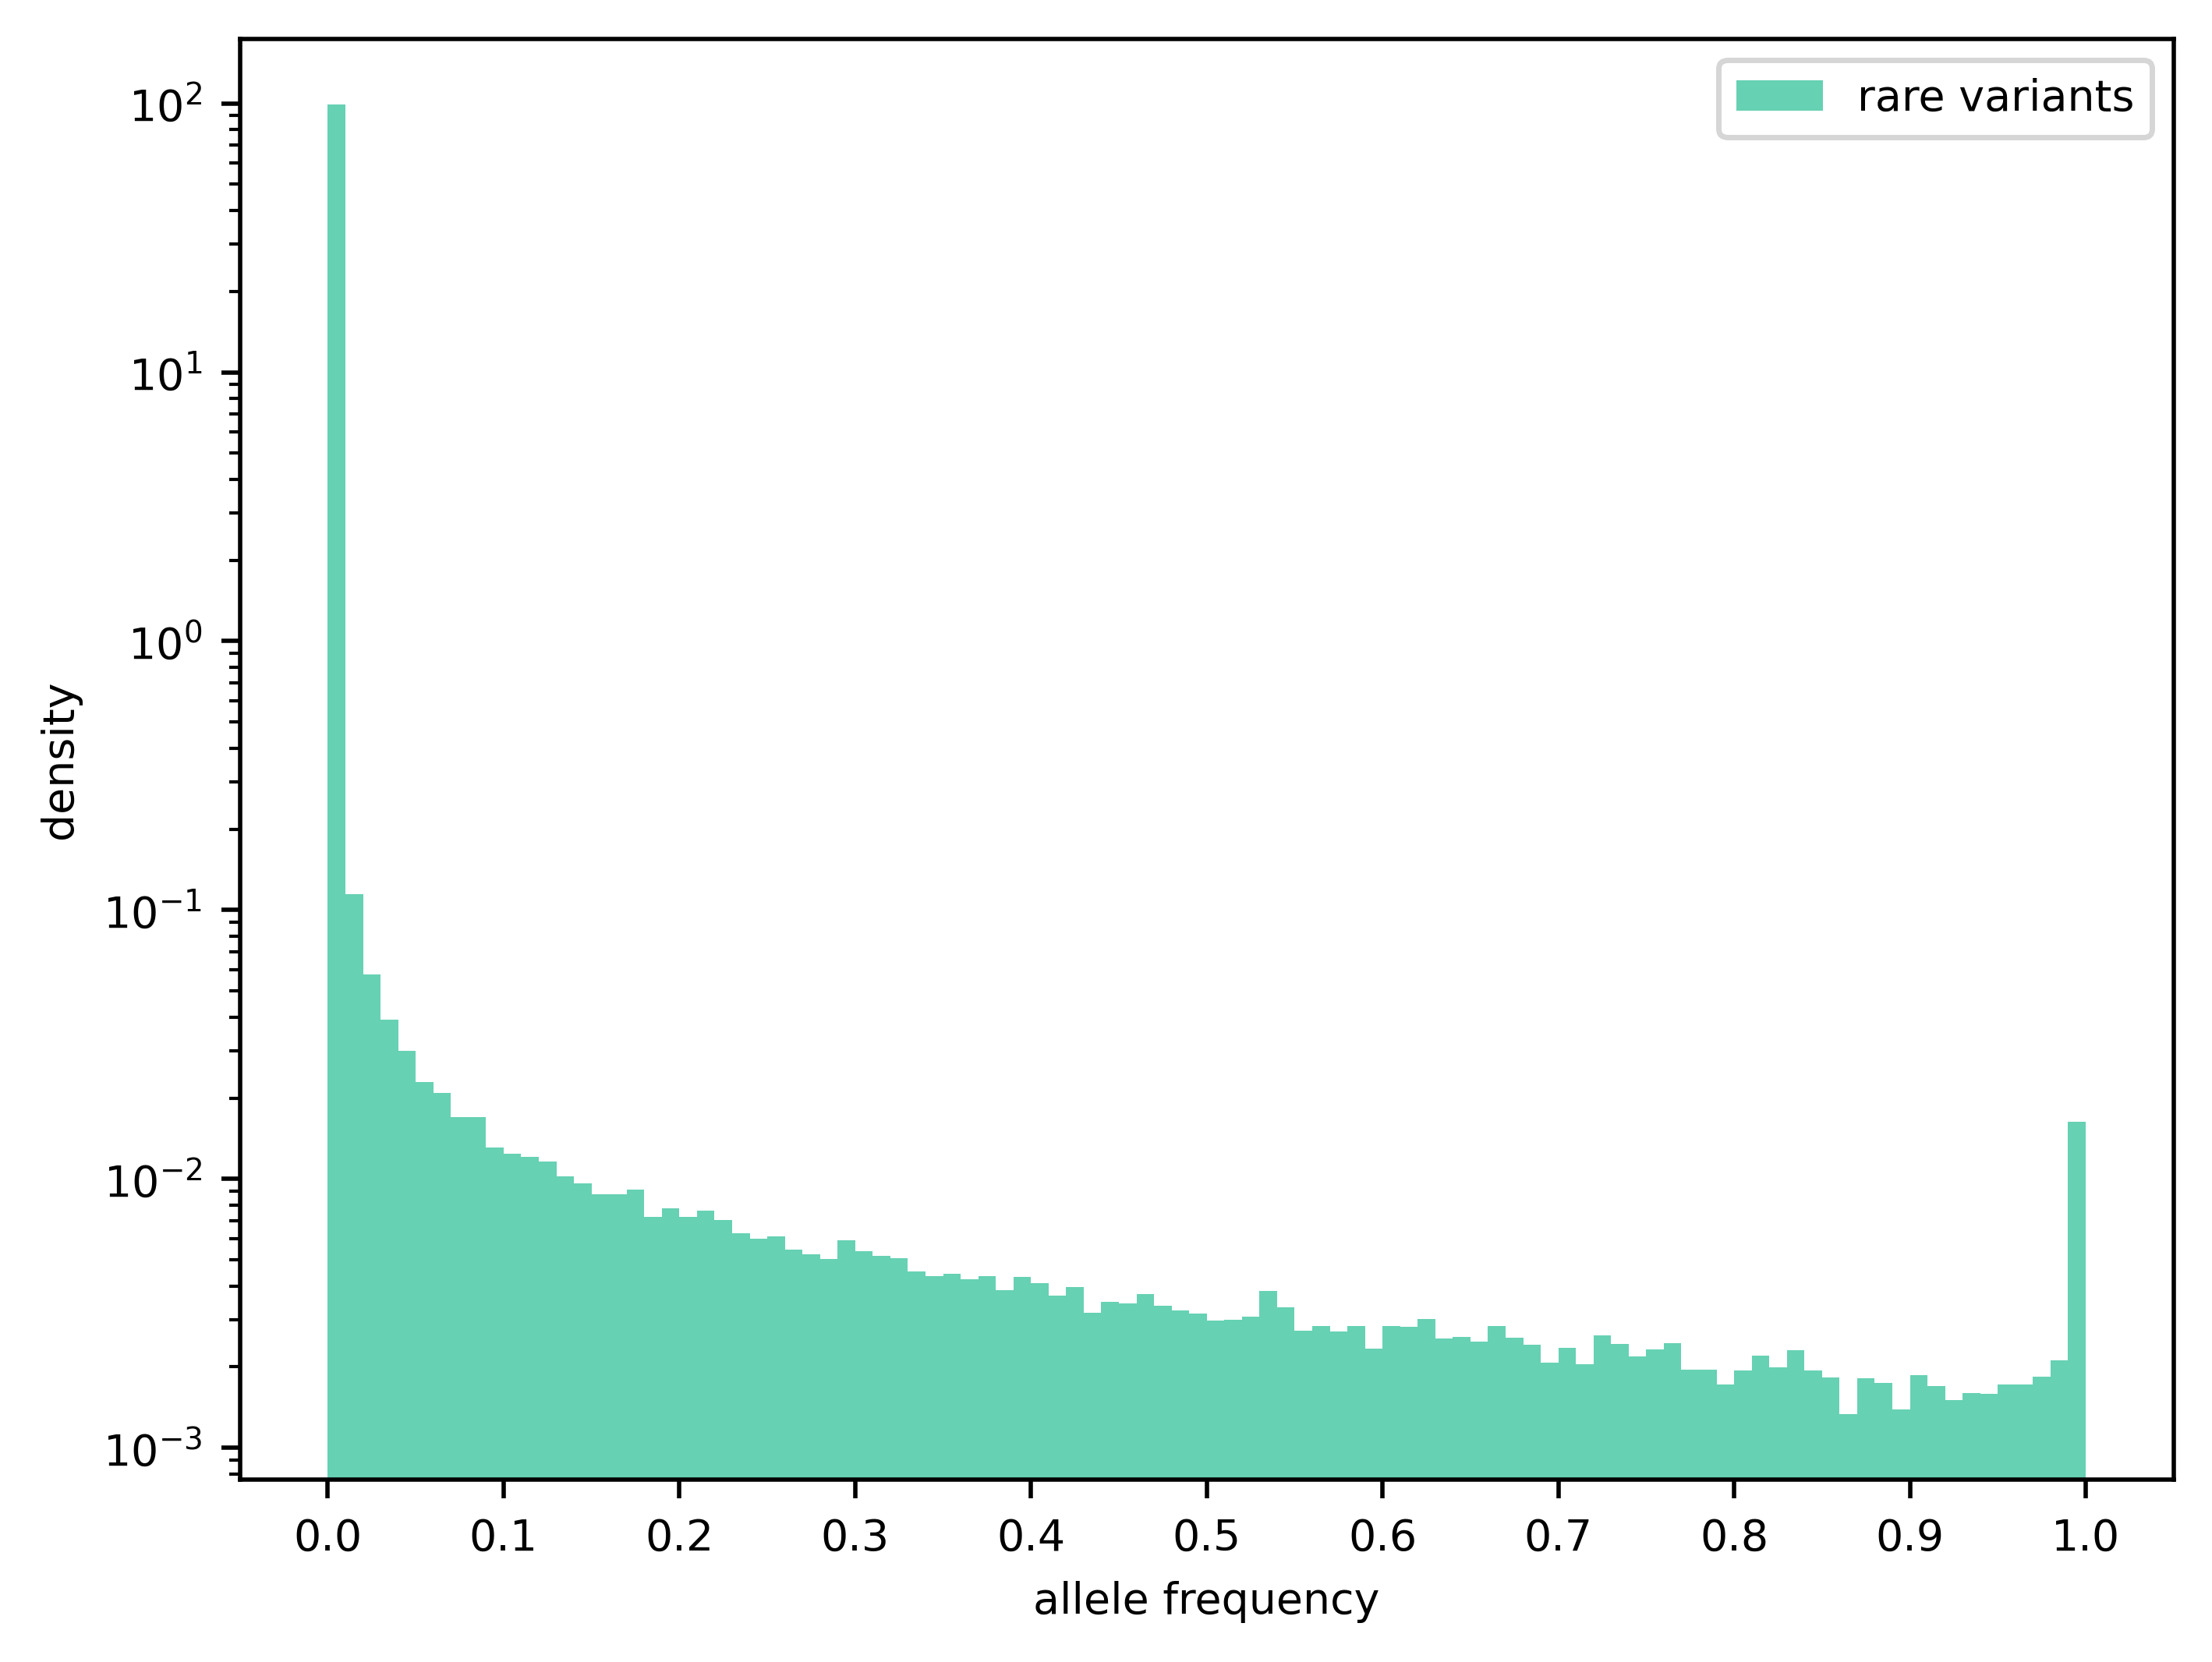

In [12]:
tblr=rare_raw['call_stats.AF']
tblr_label='rare variants'


ax1=plt
ax1.hist(tblr, bins=100,alpha=0.7, density=True, label=tblr_label, color=color_dict['rare'])
ax1.ylabel("density")
ax1.xticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax1.xlabel("allele frequency")
ax1.yscale('log')
ax1.legend()
if save_figs:
    ax1.savefig('figures/' + 'rare_variant_AF_hist.svg',bbox_inches='tight')

## plot odds ratio vs p-value for rare variants

In [13]:
rare_cutoff
rare_sig=rare[(rare.Pvalue<rare_cutoff)&(rare.AC>2)]
rare_sig

,locus,alleles,markerID,gene,annotation,call_stats.AC,call_stats.AF,call_stats.AN,call_stats.homozygote_count,n_cases,...,category,AC,AF,BETA,SE,AF.Cases,AF.Controls,Pvalue,CHR,POS
1872076,chr4:99318162,"[""T"",""C""]",chr4:99318162_T/C,ADH1B,missense,771750.0,0.977310,789664.0,377146.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,768359,0.977310,0.201370,0.007055,NaN,NaN,3.226100e-179,4,99318162
1872323,chr4:99347033,"[""C"",""A""]",chr4:99347033_C/A,ADH1C,pLoF,6489.0,0.008217,789680.0,27.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,6463,0.008221,-0.139440,0.011616,NaN,NaN,3.388300e-33,4,99347033
1875046,chr4:99653659,"[""T"",""C""]",chr4:99653659_T/C,C4orf54,synonymous,15610.0,0.019877,785314.0,140.0,393099,...,UK Biobank Assessment Centre > Touchscreen > L...,15631,0.019882,-0.046846,0.007548,NaN,NaN,5.418300e-10,4,99653659


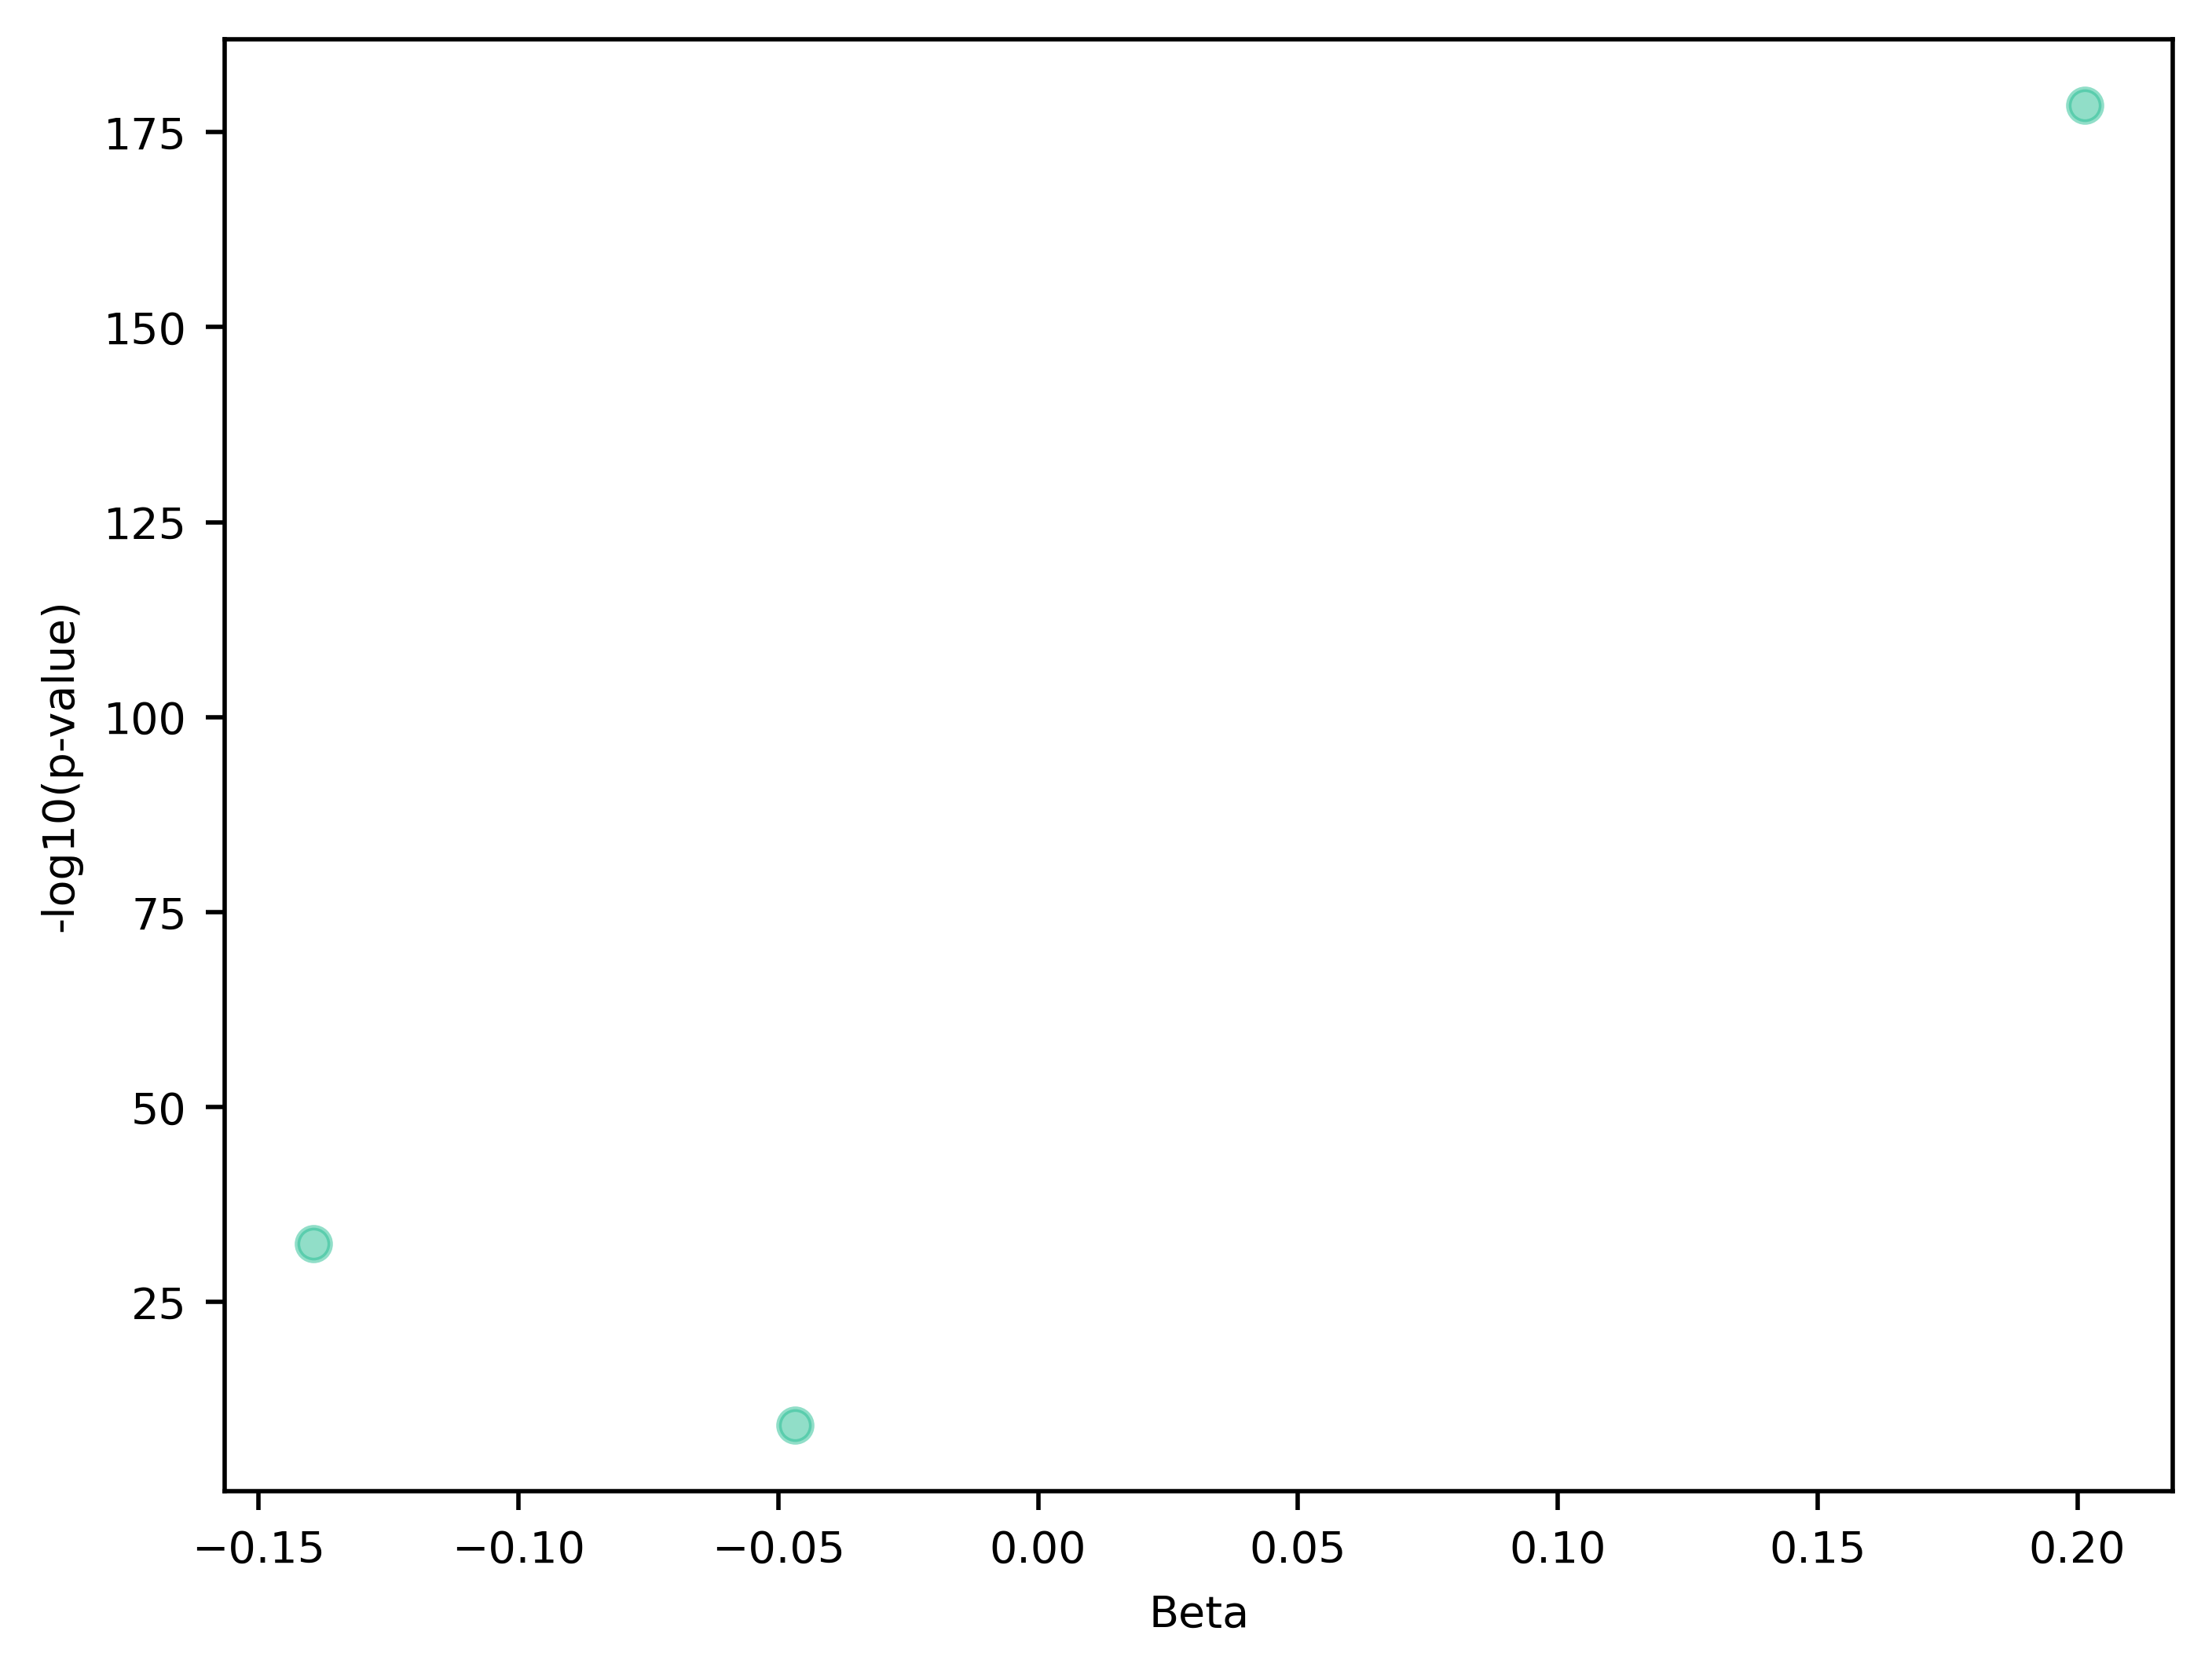

In [14]:
plt.scatter(rare_sig.BETA,-np.log10(rare_sig.Pvalue),color=color_dict['rare'],alpha=0.5)
plt.xlabel("Beta")
plt.ylabel("-log10(p-value)")
if save_figs:
    ax1.savefig('figures/' + 'rare_variant_beta_pval.svg',bbox_inches='tight')

# import gene tables

In [15]:
stringent_skato=2.5e-7
stringent_skat= 2.5e-7
stringent_burden=6.7e-7

In [16]:
skato_bonf=1.82E-07
burden_bonf=4.71E-07
skat_bonf=3.34E-33

In [17]:
common_datasets=pd.read_csv('common_datasets_prepub.csv',sep=',')
rare_datasets=pd.read_csv('rare_datasets_prepub.csv',sep=',')

### common

In [18]:
#read in gene level associations from common variants
row_common=common_datasets[common_datasets['label']=='GSCAN_DPW_magma'].index[0]
common_genes=pd.read_csv(common_datasets['seed_path'][row_common],sep=',')
common_genes_cutoff=0.05/len(common_genes)
common_genes['plt']=(common_genes['START']+common_genes['STOP'])/2
common_genes_sig=common_genes[common_genes['P']<common_genes_cutoff]
common_genes['pval_FDR']=statsmodels.stats.multitest.fdrcorrection(common_genes['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [19]:
common_genes

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,GENE_NAME,plt,pval_FDR
0,79501,1,59091,80008,6,3,436159,-0.399520,0.655250,OR4F5,69549.5,0.787474
1,100996442,1,131934,184394,5,3,437867,0.234300,0.407380,LOC100996442,158164.0,0.617712
2,105378947,1,576287,621297,7,4,444770,-0.458450,0.676680,LOC105378947,598792.0,0.800664
3,81399,1,675716,696654,2,1,405668,0.831440,0.202860,OR4F16,686185.0,0.430916
4,105378580,1,793398,815130,71,19,473562,0.522240,0.300750,LOC105378580,804264.0,0.529568
...,...,...,...,...,...,...,...,...,...,...,...,...
19047,105373099,22,50596999,50620205,129,23,627882,0.026656,0.489370,LOC105373099,50608602.0,0.677360
19048,410,22,50612754,50638173,147,34,634582,1.737800,0.041120,ARSA,50625463.5,0.179108
19049,85358,22,50664642,50743212,314,72,607426,1.520400,0.064199,SHANK3,50703927.0,0.229823
19050,49,22,50728224,50755299,124,34,561567,0.603230,0.273180,ACR,50741761.5,0.505000


### rare

In [20]:
#read in gene level associations from rare variants
rare_genes=pd.read_csv('rare_variant_genebass/alcohol_intake/alcohol_intake_variants_filtered.csv')
#rare_genes=rare_genes.reindex()
rare_genes

,Gene Name,Gene Id,P‑Value SKATO,P‑Value Burden,P‑Value SKAT,BETA Burden,Burden Set,Chrom : Position,Chrom,Position
0,PMM2,ENSG00000140650,1.350000e-07,2.370000e-07,0.000003,-0.002303,missense|LC,1.600880e+10,16,8795849.0
1,SLC29A1,ENSG00000112759,1.143640e-05,2.248690e-05,0.000036,0.002125,missense|LC,6.044220e+09,6,44219628.0
2,SCN7A,ENSG00000136546,2.273180e-05,5.111642e-02,0.000011,0.000497,missense|LC,2.166406e+09,2,166405531.0
3,ATP2B1,ENSG00000070961,2.806750e-05,4.360580e-05,0.000238,-0.002661,missense|LC,1.208959e+10,12,89590911.0
4,MMEL1,ENSG00000142606,3.676450e-05,1.690100e-05,0.002806,0.001404,missense|LC,1.002587e+09,1,2586658.0
...,...,...,...,...,...,...,...,...,...,...
56310,AC010197.2,ENSG00000285854,1.000000e+00,8.396620e-01,0.835495,-0.000271,synonymous,1.202153e+10,12,21531210.0
56311,AC083977.1,ENSG00000286131,1.000000e+00,8.710636e-01,0.982191,-0.000623,synonymous,8.032647e+09,8,32646604.0
56312,DERPC,ENSG00000286140,1.000000e+00,8.545748e-01,0.803689,-0.000922,synonymous,1.606911e+10,16,69113413.0
56313,AC022137.3,ENSG00000286261,1.000000e+00,9.306755e-01,0.963149,0.000259,synonymous,1.905344e+10,19,53441833.0


In [21]:
#expand rare genes table so each gene list listed individually- for porcupine plot
rare_genes['pvals']='Burden:'+rare_genes['P‑Value Burden'].astype('string')+','+'SKATO:'+rare_genes['P‑Value SKATO'].astype('string')+','+'SKAT:'+rare_genes['P‑Value SKAT'].astype('string')
rare_genes['pvals']=rare_genes['pvals'].str.split(',')
rare_genes_exploded=rare_genes.explode('pvals', ignore_index=True)
rare_genes_exploded[['test','pvals']]=rare_genes_exploded['pvals'].str.split(':',expand=True)
rare_genes_exploded['pvals']=rare_genes_exploded['pvals'].astype('float')

In [22]:
#calculate FDR for cutoffs
rare_genes['FDR_SKATO']=statsmodels.stats.multitest.fdrcorrection(rare_genes['P‑Value SKATO'],alpha=0.05,method='indep',is_sorted=False)[1]
rare_genes['FDR_SKAT']=statsmodels.stats.multitest.fdrcorrection(rare_genes['P‑Value SKAT'],alpha=0.05,method='indep',is_sorted=False)[1]
rare_genes['FDR_burden']=statsmodels.stats.multitest.fdrcorrection(rare_genes['P‑Value Burden'],alpha=0.05,method='indep',is_sorted=False)[1]

# histograms betas

## calculate variant beta zscores

In [23]:
rare['beta_zscore']=scipy.stats.zscore(rare['BETA'])

In [24]:
common['beta_zscore']=scipy.stats.zscore(common['BETA'])

In [25]:
#check if any common variants are rare- they arent
len(common)- len(common[common['AF_1000G']>0.001])

0

In [26]:
common_sig=common[common['P']<common_cutoff]

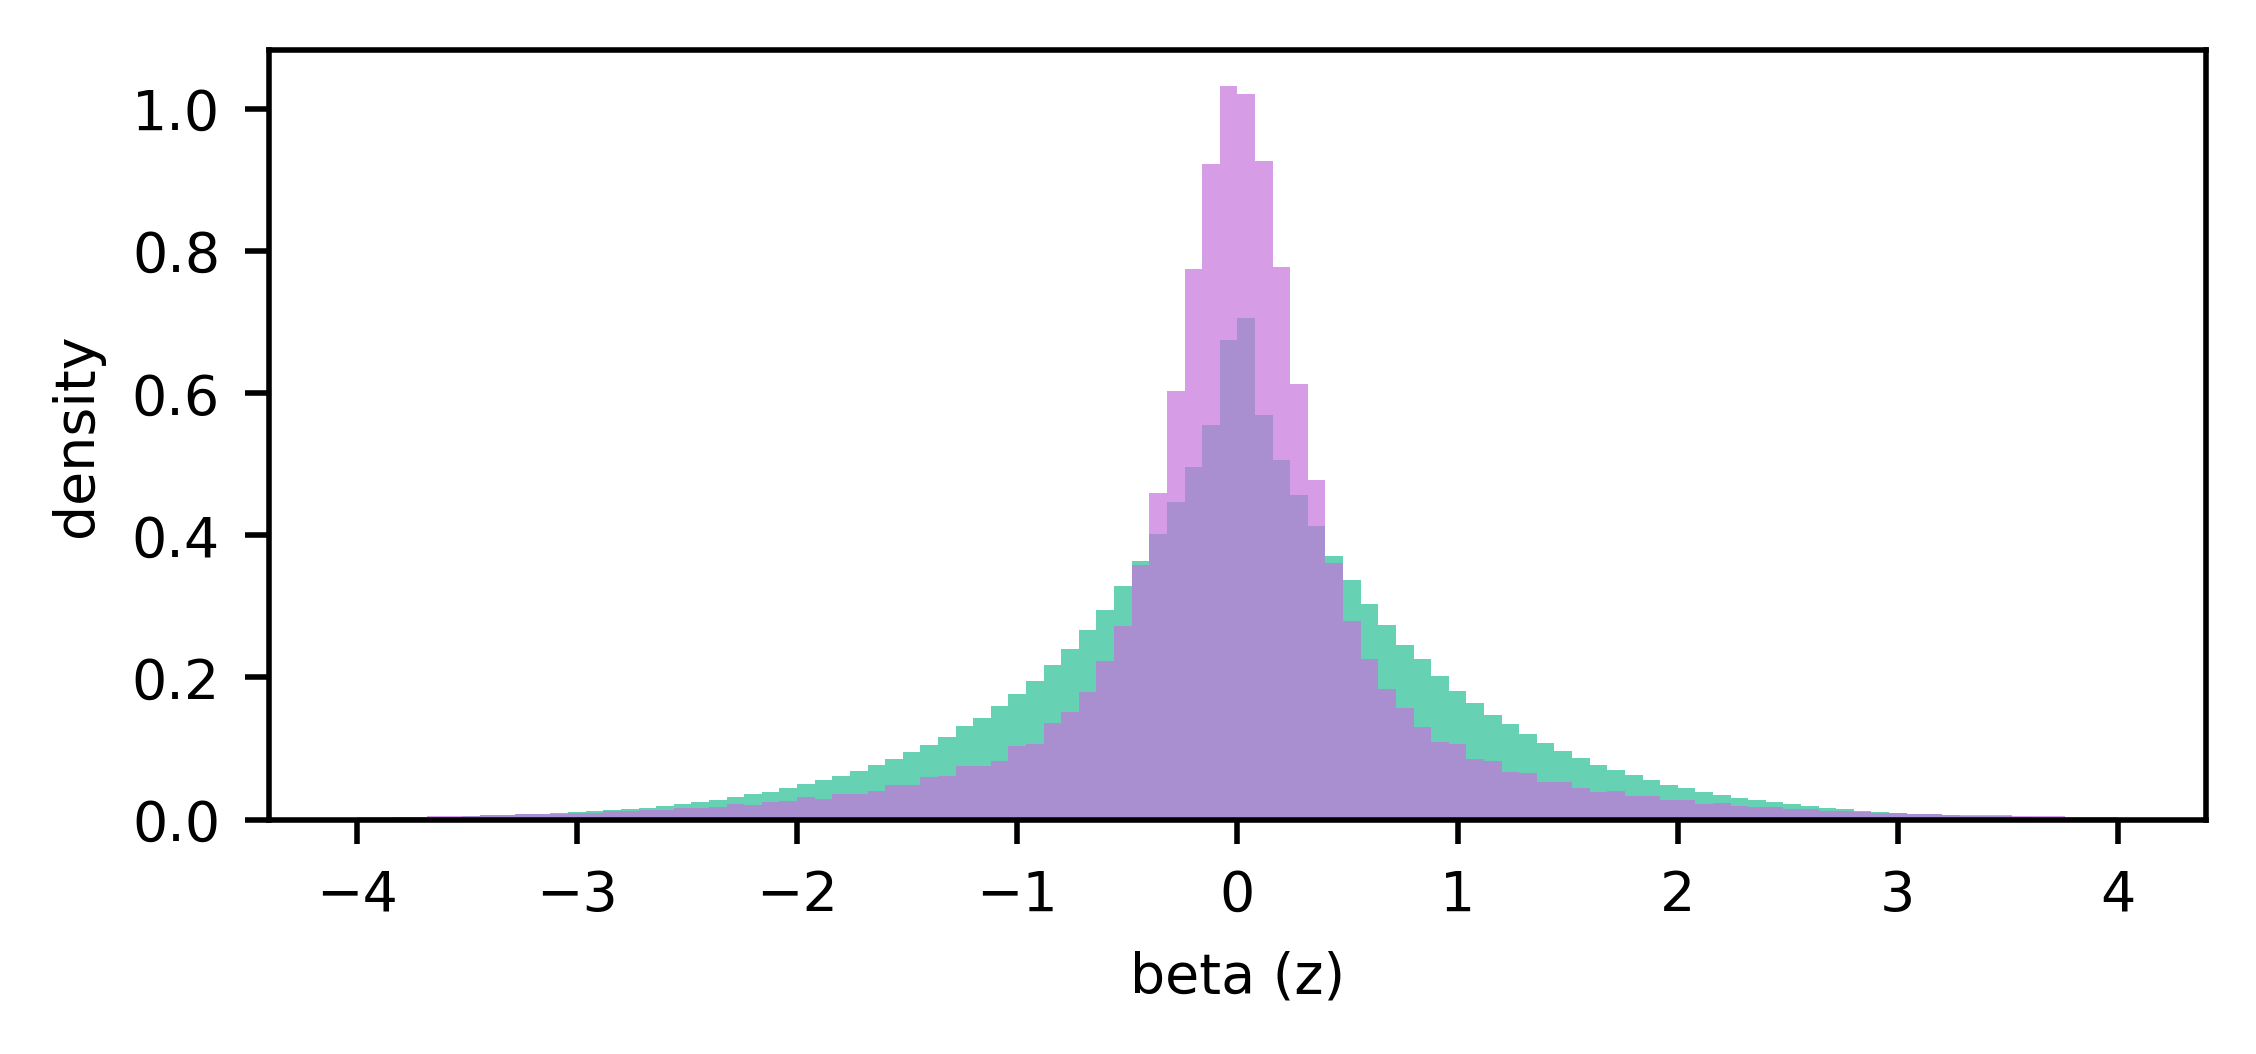

In [27]:
tblr=rare['beta_zscore']
tblc=common['beta_zscore']
tblr_label='rare variants'
tblc_label='common_variants'
bins=100

ax1=plt
ax1.figure(figsize=(5,2))
ax1.hist(tblr, bins=bins, alpha=0.7, density=True, label=tblr_label, color=color_dict['rare'], range=(-4,4))
ax1.hist(tblc,bins=bins, alpha=0.7, density=True, label=tblc_label, color=color_dict['common'], range=(-4,4))

ax1.ylabel("density")
ax1.xlabel("beta (z)")
if save_figs:
    plt.savefig('figures/' + 'betazscore_histogram_variants_long.svg',bbox_inches='tight')

In [28]:
#compute the variance of rare vs common 
print(np.var(tblr), np.var(tblc))

0.9999999999999994 0.9999999999999991


In [29]:
#test if there's a significant difference in the distributions of common and rare beta values (z-score normalized)
def f_test(group1, group2):
   f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
   nun = np.array(tblr).size-1
   dun = np.array(tblc).size-1
   p_value = 1-scipy.stats.f.cdf(f, nun, dun)
   return f, p_value
f=f_test(tblr, tblc)
print("rare over common variance: "+str(f[0]))
print("significance (p-value) of difference between rare and common variance: "+str(f[1]))
if f[1]<0.05:
    print("variance is significantly different")
else:
    print("variance is not significantly different")

rare over common variance: 1.0000002254122102
significance (p-value) of difference between rare and common variance: 0.49911069501371075
variance is not significantly different


# manhattan plot

## common variant level manhattan

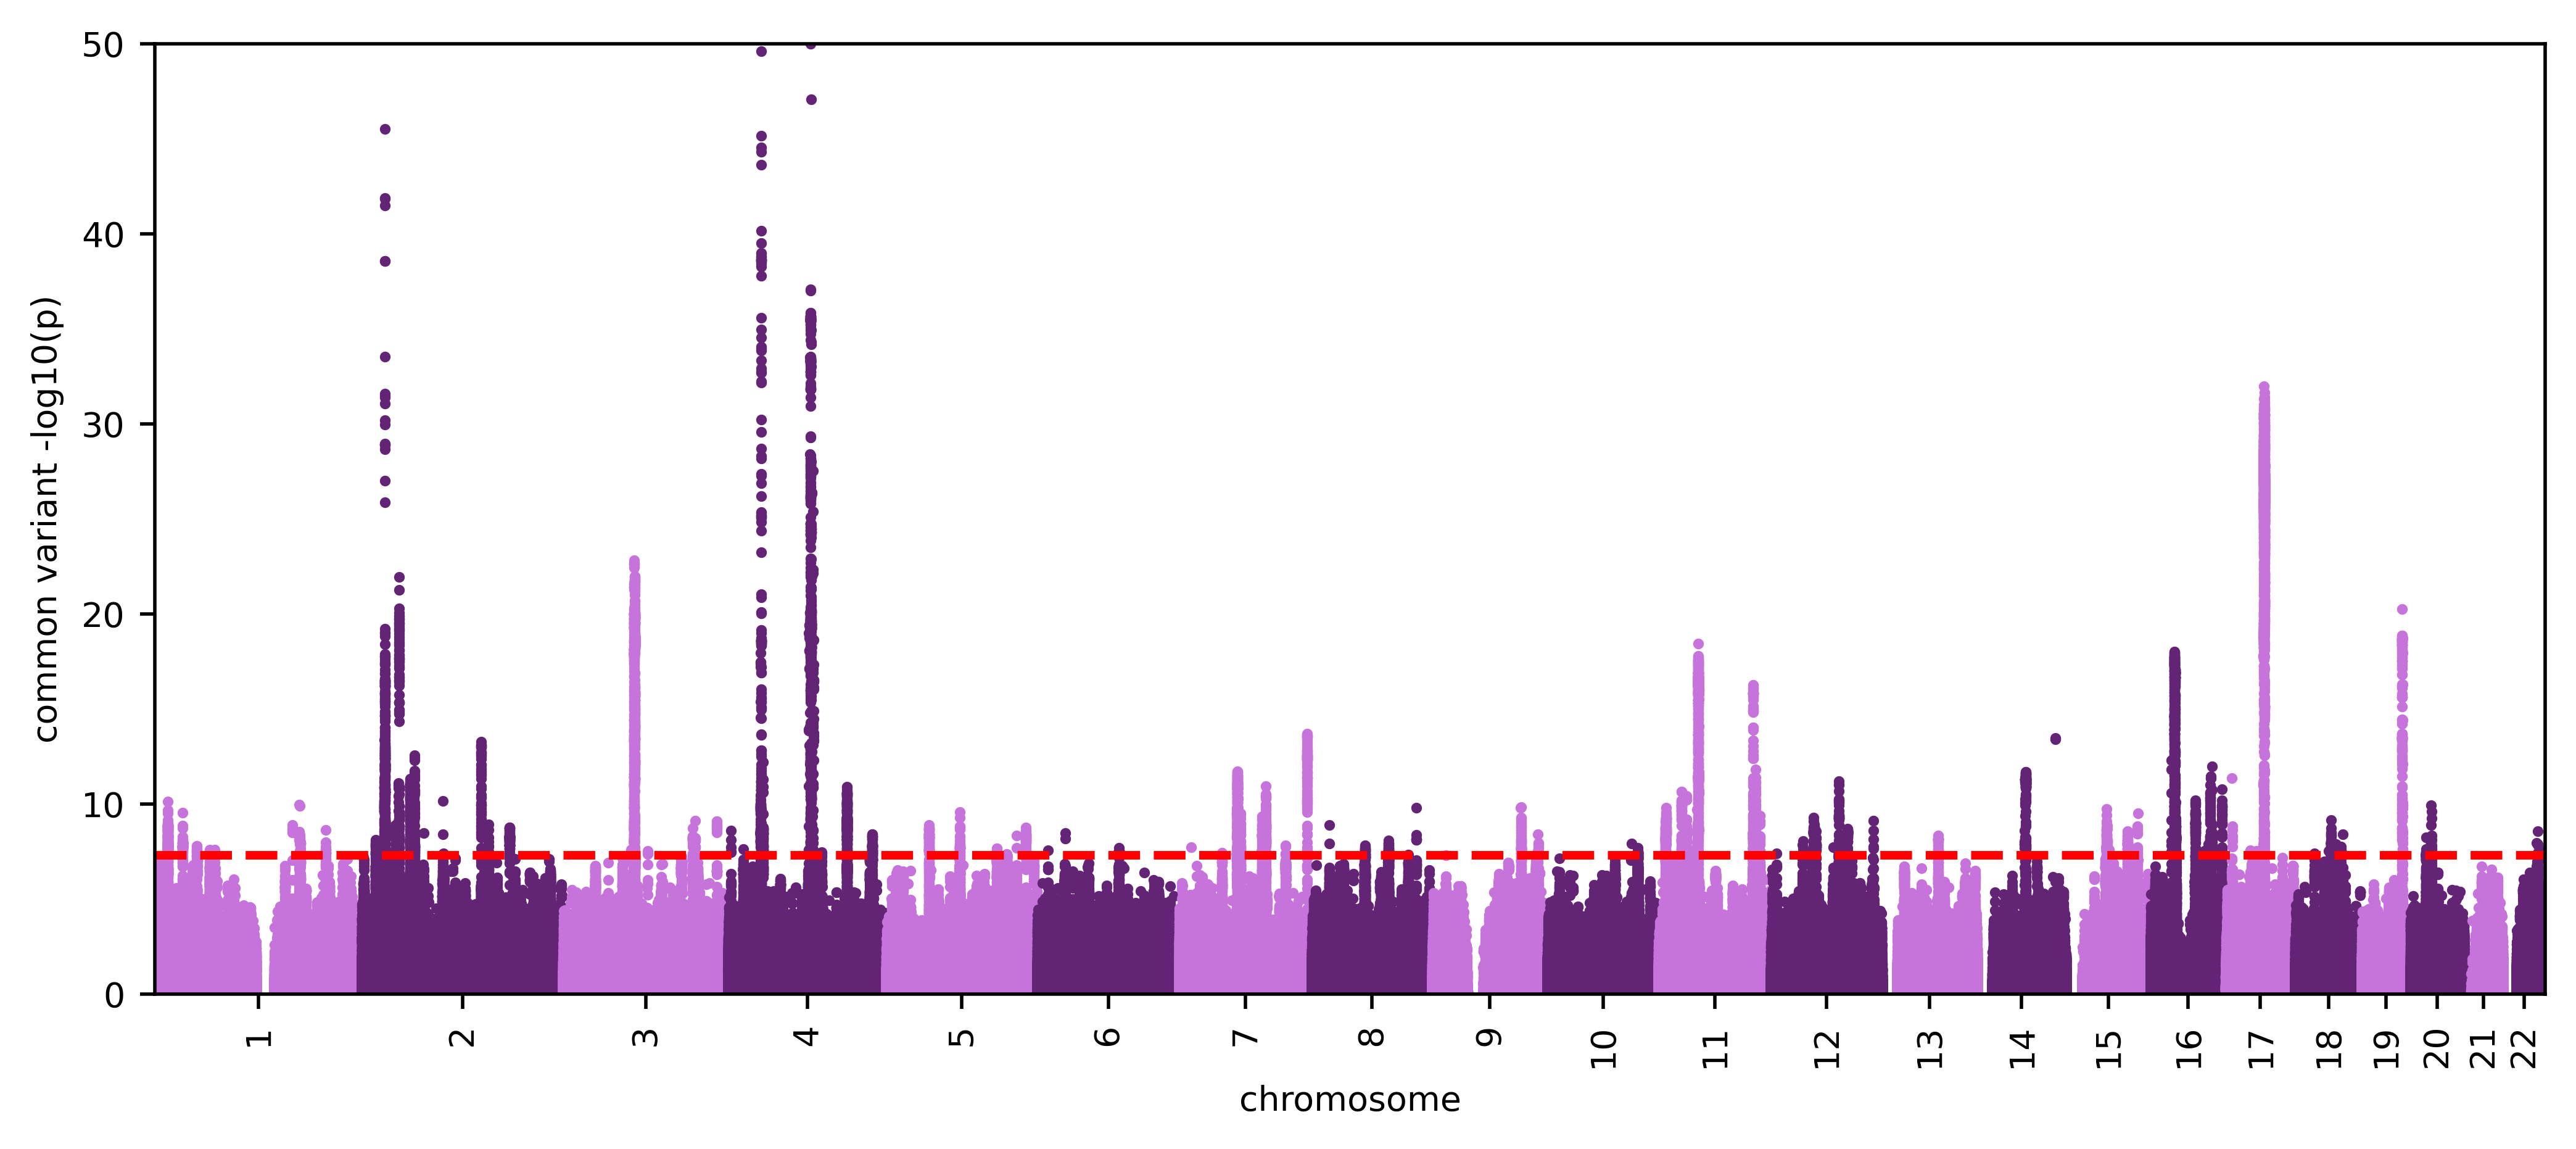

In [30]:
fig=plt.figure(figsize=(10,4))
manhattan(p1=common['P'],pos1=common['POS'],chr1=common['CHR'],label1='',
                    plot_type='single',cut=0,lines=[-np.log10(5e-8)],lines_colors=['red'], colors=[color_dict['common'], color_dict['common_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top1=50, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.xticks(rotation='vertical')
fig=plt.ylabel('common variant -log10(p)')
if save_figs:
    plt.savefig('figures/' + 'common_variants'+'_zoom50_5e-8'+'.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'common_variants'+'_zoom50_5e-8'+'_500dpi.png',dpi=500,bbox_inches='tight')

## common gene level manhattan

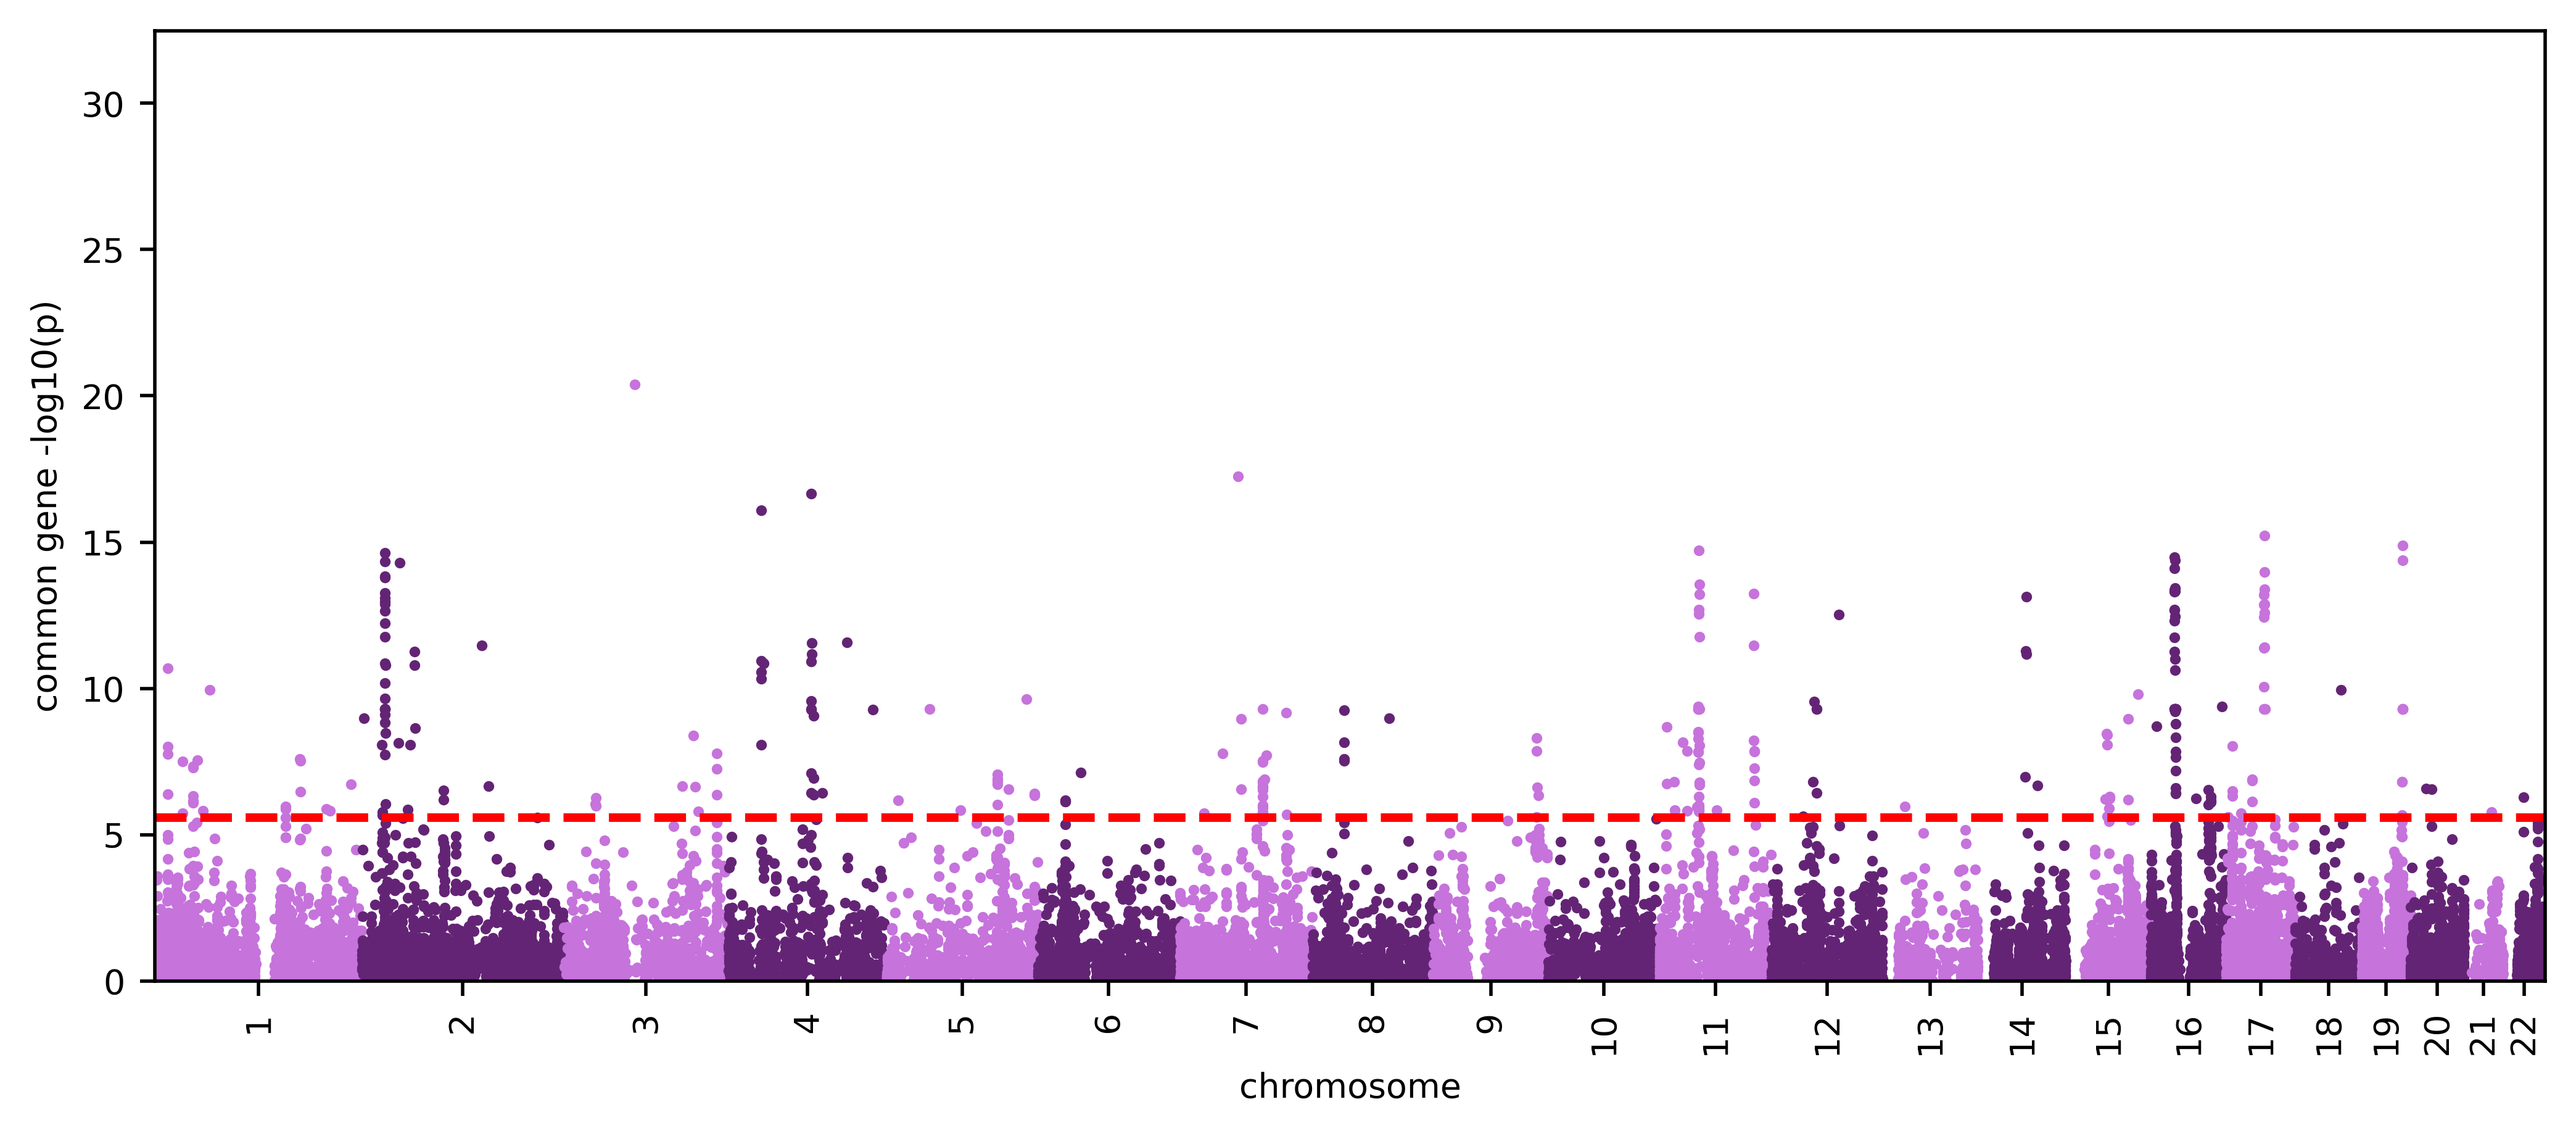

In [31]:
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(p1=common_genes['P'],pos1=common_genes['plt'],chr1=common_genes['CHR'],label1='',
                    plot_type='single',cut=0,lines=[-np.log10(0.05/len(common_genes))],lines_colors=['red'], colors=[color_dict['common'], color_dict['common_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top1=-np.log10(min(rare_genes_exploded['pvals'])), markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('common gene -log10(p)')

#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_figs:
    plt.savefig('figures/' + 'common_genes'+'_zoom35_bonf'+'.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'common_genes'+'_zoom35_bonf'+'_500dpi.png',dpi=500,bbox_inches='tight')

## rare variant manhattan

KeyError: '[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 25, 26, 28, 29, 30, 31, 32, 34, 35, 38, 39, 41, 44, 45, 46, 47, 48, 49, 51, 53, 55, 63, 65, 67, 69, 71, 72, 75, 79, 80, 81, 82, 83, 84, 86, 87, 93, 95, 96, 108, 110, 111, 115, 117, 118, 119, 121, 122, 123, 126, 127, 132, 135, 137, 140, 141, 142, 148, 149, 150, 152, 155, 157, 158, 160, 161, 163, 165, 166, 167, 168, 169, 173, 174, 175, 176, 180, 182, 183, 186, 188, 191, 192, 194, 196, 199, 204, 206, 209, 210, 212, 214, 216, 217, 219, 224, 225, 229, 233, 234, 238, 239, 242, 244, 245, 246, 248, 249, 256, 259, 260, 261, 262, 263, 265, 266, 268, 269, 271, 275, 279, 282, 283, 284, 285, 287, 288, 291, 294, 295, 296, 297, 298, 300, 301, 306, 307, 308, 309, 310, 311, 312, 313, 315, 319, 321, 322, 323, 325, 327, 331, 333, 335, 336, 338, 339, 340, 341, 344, 345, 348, 351, 357, 359, 360, 362, 365, 366, 370, 371, 372, 373, 374, 375, 376, 380, 381, 382, 383, 384, 387, 388, 389, 391, 393, 395, 396, 397, 398, 404, 406, 407, 410, 411, 413, 415, 416, 418, 419, 421, 422, 425, 426, 428, 429, 434, 436, 437, 438, 439, 441, 442, 443, 445, 447, 450, 453, 454, 455, 456, 457, 458, 460, 461, 462, 464, 466, 472, 474, 475, 477, 478, 479, 480, 482, 484, 485, 487, 488, 489, 491, 492, 493, 494, 496, 498, 499, 501, 502, 503, 504, 505, 506, 507, 508, 509, 512, 513, 514, 516, 518, 519, 520, 521, 525, 527, 530, 531, 532, 533, 539, 540, 543, 545, 549, 551, 552, 553, 556, 560, 561, 562, 567, 568, 569, 570, 571, 572, 578, 582, 583, 584, 585, 586, 590, 591, 592, 593, 595, 596, 597, 598, 599, 601, 603, 605, 606, 607, 608, 610, 611, 612, 613, 618, 619, 620, 621, 622, 623, 624, 627, 628, 629, 630, 631, 634, 635, 637, 638, 639, 641, 642, 643, 644, 648, 649, 650, 656, 658, 659, 660, 661, 662, 666, 668, 671, 672, 674, 675, 677, 682, 683, 684, 688, 691, 693, 694, 695, 696, 697, 700, 702, 703, 705, 706, 707, 708, 709, 711, 717, 718, 719, 721, 722, 723, 724, 725, 726, 728, 729, 731, 732, 733, 734, 737, 740, 741, 743, 745, 750, 752, 754, 755, 760, 761, 765, 768, 769, 771, 774, 775, 776, 778, 783, 784, 788, 792, 793, 794, 799, 801, 802, 803, 806, 808, 809, 813, 817, 819, 820, 825, 827, 830, 831, 836, 837, 841, 843, 844, 846, 847, 848, 849, 851, 853, 854, 857, 858, 859, 860, 864, 867, 868, 870, 871, 872, 874, 876, 877, 878, 879, 881, 885, 886, 888, 889, 891, 897, 898, 901, 905, 907, 909, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 926, 928, 931, 934, 937, 938, 939, 941, 943, 944, 946, 947, 948, 952, 953, 957, 958, 960, 962, 963, 964, 965, 966, 969, 970, 978, 981, 983, 984, 990, 995, 996, 999, 1001, 1006, 1008, 1009, 1013, 1015, 1016, 1020, 1021, 1022, 1024, 1027, 1028, 1029, 1030, 1031, 1033, 1037, 1039, 1040, 1042, 1044, 1045, 1048, 1049, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1062, 1064, 1065, 1066, 1067, 1071, 1072, 1074, 1075, 1078, 1079, 1080, 1082, 1084, 1085, 1089, 1090, 1091, 1093, 1094, 1096, 1099, 1100, 1101, 1102, 1103, 1104, 1107, 1108, 1110, 1112, 1114, 1117, 1118, 1120, 1125, 1127, 1131, 1132, 1134, 1136, 1138, 1139, 1140, 1141, 1144, 1145, 1146, 1147, 1149, 1154, 1156, 1157, 1158, 1159, 1160, 1162, 1164, 1165, 1169, 1170, 1173, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1183, 1185, 1190, 1191, 1192, 1194, 1195, 1196, 1198, 1201, 1202, 1203, 1205, 1207, 1209, 1214, 1215, 1218, 1221, 1222, 1225, 1226, 1227, 1229, 1232, 1238, 1239, 1240, 1241, 1242, 1245, 1246, 1251, 1253, 1255, 1256, 1257, 1258, 1259, 1260, 1267, 1269, 1271, 1274, 1276, 1281, 1284, 1285, 1289, 1291, 1292, 1293, 1294, 1296, 1298, 1299, 1302, 1303, 1304, 1310, 1313, 1315, 1327, 1330, 1333, 1334, 1336, 1337, 1340, 1344, 1345, 1346, 1347, 1348, 1350, 1352, 1353, 1355, 1357, 1359, 1360, 1362, 1364, 1366, 1367, 1369, 1371, 1374, 1375, 1378, 1380, 1382, 1383, 1392, 1393, 1397, 1399, 1401, 1404, 1406, 1407, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1422, 1424, 1426, 1428, 1429, 1430, 1431, 1432, 1435, 1438, 1440, 1442, 1443, 1445, 1447, 1449, 1450, 1451, 1452, 1456, 1457, 1458, 1459, 1461, 1463, 1466, 1467, 1468, 1470, 1471, 1474, 1477, 1479, 1481, 1483, 1484, 1487, 1489, 1491, 1495, 1496, 1497, 1498, 1500, 1502, 1506, 1513, 1515, 1516, 1522, 1523, 1525, 1526, 1527, 1535, 1537, 1538, 1540, 1543, 1544, 1546, 1550, 1552, 1553, 1554, 1556, 1557, 1559, 1560, 1562, 1565, 1566, 1567, 1570, 1571, 1572, 1573, 1574, 1575, 1577, 1580, 1582, 1586, 1589, 1590, 1593, 1595, 1596, 1597, 1599, 1601, 1602, 1605, 1607, 1609, 1611, 1612, 1613, 1614, 1615, 1617, 1618, 1619, 1622, 1623, 1625, 1626, 1628, 1630, 1633, 1637, 1639, 1640, 1646, 1649, 1650, 1654, 1657, 1658, 1659, 1662, 1663, 1664, 1665, 1666, 1668, 1669, 1671, 1676, 1681, 1682, 1683, 1685, 1687, 1689, 1693, 1695, 1696, 1697, 1698, 1699, 1700, 1702, 1703, 1704, 1706, 1707, 1708, 1709, 1710, 1711, 1713, 1714, 1717, 1718, 1720, 1722, 1723, 1724, 1727, 1729, 1732, 1733, 1734, 1735, 1736, 1743, 1744, 1749, 1750, 1751, 1752, 1757, 1762, 1764, 1765, 1767, 1769, 1770, 1771, 1773, 1774, 1775, 1776, 1777, 1780, 1783, 1784, 1787, 1788, 1790, 1793, 1794, 1796, 1800, 1801, 1802, 1803, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1814, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1832, 1833, 1836, 1837, 1838, 1841, 1843, 1844, 1845, 1846, 1847, 1848, 1850, 1853, 1854, 1855, 1857, 1858, 1859, 1860, 1861, 1863, 1865, 1868, 1869, 1870, 1872, 1873, 1875, 1877, 1878, 1881, 1882, 1885, 1887, 1888, 1889, 1890, 1891, 1893, 1895, 1896, 1900, 1901, 1902, 1903, 1907, 1908, 1909, 1910, 1911, 1914, 1916, 1917, 1919, 1924, 1926, 1930, 1931, 1935, 1936, 1937, 1938, 1939, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1949, 1950, 1951, 1952, 1953, 1956, 1960, 1962, 1965, 1967, 1970, 1972, 1973, 1974, 1975, 1978, 1980, 1981, 1985, 1987, 1988, 1991, 1992, 1995, 1997, 1998, 1999, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2011, 2016, 2017, 2018, 2019, 2020, 2023, 2024, 2027, 2029, 2030, 2031, 2033, 2037, 2038, 2039, 2040, 2043, 2044, 2047, 2048, 2052, 2054, 2055, 2057, 2058, 2059, 2063, 2069, 2070, 2073, 2075, 2076, 2077, 2080, 2084, 2085, 2086, 2090, 2091, 2092, 2094, 2095, 2098, 2100, 2102, 2104, 2106, 2108, 2113, 2115, 2116, 2120, 2121, 2122, 2123, 2125, 2126, 2127, 2128, 2129, 2131, 2134, 2135, 2136, 2139, 2140, 2144, 2146, 2147, 2149, 2150, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2161, 2164, 2166, 2168, 2171, 2175, 2179, 2180, 2181, 2182, 2186, 2187, 2188, 2190, 2191, 2192, 2197, 2198, 2201, 2202, 2203, 2206, 2208, 2209, 2212, 2214, 2215, 2216, 2218, 2219, 2220, 2221, 2223, 2224, 2226, 2228, 2235, 2236, 2237, 2239, 2240, 2246, 2249, 2250, 2254, 2257, 2261, 2267, 2271, 2274, 2277, 2278, 2279, 2281, 2285, 2286, 2288, 2294, 2295, 2297, 2298, 2299, 2303, 2308, 2310, 2312, 2317, 2318, 2319, 2320, 2324, 2326, 2327, 2329, 2330, 2333, 2334, 2337, 2338, 2339, 2340, 2341, 2342, 2344, 2345, 2347, 2348, 2350, 2351, 2354, 2359, 2363, 2367, 2370, 2371, 2375, 2379, 2380, 2381, 2382, 2384, 2386, 2390, 2393, 2394, 2395, 2397, 2406, 2411, 2417, 2419, 2429, 2432, 2434, 2435, 2436, 2437, 2438, 2439, 2445, 2446, 2448, 2450, 2451, 2452, 2453, 2454, 2456, 2457, 2458, 2459, 2461, 2462, 2463, 2464, 2466, 2467, 2469, 2472, 2475, 2477, 2478, 2479, 2482, 2486, 2487, 2493, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2505, 2510, 2512, 2514, 2515, 2516, 2517, 2519, 2520, 2527, 2528, 2531, 2533, 2534, 2535, 2539, 2541, 2542, 2544, 2548, 2549, 2552, 2555, 2556, 2558, 2560, 2562, 2564, 2565, 2570, 2575, 2576, 2579, 2580, 2581, 2583, 2586, 2587, 2588, 2589, 2591, 2592, 2593, 2594, 2595, 2598, 2599, 2602, 2604, 2605, 2606, 2608, 2610, 2612, 2614, 2615, 2616, 2617, 2618, 2619, 2621, 2622, 2623, 2629, 2633, 2634, 2637, 2639, 2644, 2645, 2647, 2650, 2651, 2652, 2654, 2659, 2662, 2664, 2665, 2666, 2667, 2671, 2672, 2679, 2683, 2684, 2685, 2686, 2688, 2689, 2690, 2691, 2695, 2698, 2699, 2700, 2702, 2706, 2707, 2708, 2710, 2712, 2721, 2724, 2726, 2727, 2728, 2730, 2732, 2733, 2734, 2736, 2737, 2738, 2739, 2740, 2742, 2746, 2748, 2749, 2750, 2752, 2753, 2755, 2760, 2761, 2762, 2765, 2769, 2770, 2774, 2776, 2778, 2780, 2781, 2785, 2786, 2788, 2790, 2791, 2797, 2798, 2799, 2801, 2802, 2803, 2804, 2805, 2807, 2808, 2809, 2814, 2815, 2816, 2818, 2821, 2828, 2829, 2831, 2833, 2845, 2847, 2848, 2850, 2853, 2856, 2857, 2858, 2859, 2863, 2864, 2866, 2869, 2870, 2871, 2872, 2875, 2877, 2879, 2880, 2882, 2883, 2886, 2890, 2892, 2893, 2894, 2895, 2896, 2897, 2899, 2903, 2904, 2905, 2907, 2908, 2909, 2913, 2916, 2917, 2923, 2926, 2929, 2930, 2931, 2932, 2933, 2939, 2941, 2942, 2943, 2944, 2947, 2948, 2949, 2951, 2952, 2953, 2958, 2960, 2961, 2971, 2973, 2975, 2977, 2978, 2981, 2983, 2985, 2987, 2989, 2991, 2992, 2993, 2994, 2995, 2999, 3003, 3004, 3006, 3007, 3008, 3009, 3010, 3013, 3014, 3021, 3023, 3024, 3026, 3028, 3031, 3034, 3035, 3036, 3038, 3041, 3044, 3047, 3057, 3058, 3059, 3062, 3063, 3069, 3073, 3075, 3078, 3081, 3082, 3084, 3086, 3087, 3088, 3092, 3093, 3094, 3095, 3096, 3097, 3099, 3101, 3102, 3104, 3107, 3108, 3112, 3113, 3119, 3120, 3121, 3122, 3124, 3125, 3127, 3128, 3131, 3132, 3134, 3138, 3139, 3144, 3145, 3146, 3148, 3150, 3151, 3153, 3155, 3156, 3157, 3158, 3166, 3169, 3170, 3172, 3173, 3174, 3178, 3179, 3184, 3185, 3186, 3190, 3191, 3192, 3196, 3197, 3205, 3207, 3213, 3215, 3218, 3219, 3222, 3227, 3228, 3230, 3231, 3235, 3236, 3241, 3244, 3246, 3247, 3248, 3249, 3251, 3253, 3254, 3256, 3257, 3260, 3261, 3267, 3271, 3272, 3273, 3276, 3277, 3282, 3286, 3287, 3288, 3291, 3292, 3293, 3294, 3295, 3297, 3298, 3299, 3300, 3304, 3307, 3308, 3309, 3310, 3318, 3323, 3324, 3325, 3328, 3329, 3331, 3334, 3338, 3339, 3340, 3342, 3344, 3345, 3346, 3350, 3351, 3352, 3353, 3359, 3360, 3362, 3365, 3366, 3367, 3372, 3373, 3377, 3381, 3382, 3383, 3384, 3385, 3387, 3389, 3390, 3391, 3393, 3394, 3395, 3398, 3401, 3402, 3409, 3412, 3415, 3416, 3417, 3420, 3422, 3424, 3426, 3427, 3428, 3431, 3433, 3434, 3435, 3437, 3444, 3447, 3448, 3449, 3453, 3454, 3458, 3459, 3460, 3461, 3462, 3463, 3466, 3467, 3468, 3471, 3473, 3477, 3478, 3479, 3483, 3487, 3488, 3492, 3493, 3494, 3496, 3505, 3506, 3509, 3510, 3513, 3515, 3516, 3519, 3521, 3522, 3523, 3524, 3533, 3534, 3535, 3536, 3537, 3538, 3541, 3542, 3545, 3546, 3547, 3548, 3550, 3552, 3553, 3557, 3558, 3563, 3564, 3565, 3566, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3577, 3579, 3580, 3581, 3583, 3584, 3585, 3586, 3588, 3590, 3591, 3592, 3593, 3594, 3595, 3597, 3601, 3602, 3607, 3608, 3610, 3611, 3613, 3614, 3615, 3616, 3620, 3622, 3626, 3627, 3630, 3634, 3636, 3638, 3641, 3642, 3644, 3647, 3650, 3651, 3653, 3654, 3655, 3656, 3658, 3659, 3661, 3662, 3665, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3681, 3682, 3683, 3684, 3685, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3697, 3698, 3699, 3701, 3702, 3704, 3707, 3708, 3711, 3712, 3715, 3718, 3720, 3726, 3728, 3729, 3733, 3735, 3738, 3740, 3741, 3742, 3743, 3744, 3746, 3749, 3753, 3754, 3755, 3758, 3765, 3766, 3767, 3770, 3772, 3775, 3779, 3789, 3792, 3797, 3799, 3804, 3805, 3811, 3812, 3814, 3824, 3825, 3826, 3827, 3828, 3829, 3832, 3833, 3837, 3839, 3840, 3841, 3842, 3845, 3846, 3847, 3848, 3850, 3852, 3855, 3856, 3858, 3861, 3865, 3868, 3872, 3874, 3875, 3876, 3881, 3884, 3885, 3889, 3891, 3893, 3895, 3898, 3899, 3902, 3903, 3904, 3905, 3908, 3909, 3913, 3915, 3918, 3919, 3922, 3923, 3925, 3926, 3928, 3929, 3930, 3931, 3934, 3936, 3938, 3940, 3942, 3943, 3944, 3947, 3951, 3952, 3953, 3954, 3955, 3956, 3962, 3963, 3964, 3965, 3972, 3974, 3975, 3977, 3978, 3980, 3984, 3985, 3986, 3988, 3990, 3991, 3993, 4001, 4002, 4003, 4004, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4015, 4016, 4018, 4019, 4020, 4021, 4022, 4023, 4030, 4033, 4034, 4036, 4037, 4038, 4039, 4043, 4044, 4046, 4048, 4052, 4054, 4056, 4060, 4061, 4062, 4065, 4066, 4067, 4070, 4071, 4072, 4075, 4077, 4080, 4081, 4083, 4084, 4085, 4087, 4091, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4109, 4110, 4111, 4112, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4123, 4126, 4127, 4128, 4129, 4131, 4132, 4133, 4134, 4140, 4141, 4143, 4145, 4149, 4150, 4152, 4153, 4154, 4156, 4157, 4158, 4162, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4181, 4182, 4184, 4186, 4187, 4189, 4193, 4195, 4196, 4199, 4200, 4202, 4203, 4206, 4208, 4209, 4210, 4211, 4212, 4215, 4218, 4220, 4221, 4222, 4223, 4224, 4228, 4229, 4230, 4231, 4234, 4235, 4236, 4240, 4241, 4242, 4248, 4249, 4251, 4252, 4254, 4256, 4258, 4260, 4261, 4262, 4263, 4264, 4269, 4270, 4272, 4274, 4277, 4278, 4286, 4288, 4290, 4291, 4293, 4294, 4297, 4299, 4300, 4302, 4305, 4309, 4310, 4316, 4318, 4321, 4322, 4324, 4325, 4327, 4330, 4332, 4333, 4336, 4337, 4339, 4341, 4342, 4346, 4347, 4348, 4351, 4352, 4353, 4356, 4358, 4359, 4360, 4364, 4365, 4368, 4369, 4370, 4371, 4373, 4374, 4378, 4379, 4380, 4382, 4383, 4394, 4395, 4397, 4399, 4401, 4402, 4403, 4404, 4405, 4407, 4408, 4411, 4414, 4418, 4419, 4421, 4422, 4424, 4425, 4426, 4429, 4430, 4432, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4443, 4446, 4450, 4451, 4453, 4455, 4457, 4460, 4461, 4462, 4465, 4467, 4468, 4469, 4472, 4476, 4477, 4478, 4479, 4480, 4481, 4485, 4488, 4489, 4491, 4492, 4493, 4494, 4496, 4497, 4498, 4502, 4505, 4509, 4511, 4512, 4513, 4514, 4515, 4517, 4518, 4519, 4520, 4521, 4523, 4528, 4529, 4530, 4532, 4534, 4535, 4537, 4538, 4540, 4541, 4543, 4544, 4545, 4550, 4554, 4555, 4556, 4558, 4562, 4565, 4566, 4567, 4569, 4571, 4572, 4579, 4583, 4588, 4591, 4592, 4593, 4595, 4596, 4598, 4599, 4600, 4603, 4604, 4605, 4607, 4608, 4609, 4610, 4616, 4617, 4618, 4622, 4623, 4624, 4628, 4630, 4631, 4632, 4633, 4635, 4637, 4642, 4643, 4644, 4646, 4647, 4650, 4651, 4652, 4654, 4655, 4662, 4663, 4664, 4665, 4666, 4669, 4670, 4671, 4673, 4674, 4675, 4677, 4678, 4681, 4683, 4684, 4685, 4686, 4688, 4689, 4690, 4692, 4693, 4694, 4697, 4699, 4700, 4701, 4703, 4706, 4707, 4709, 4711, 4712, 4715, 4716, 4718, 4719, 4724, 4725, 4726, 4729, 4730, 4731, 4735, 4739, 4742, 4744, 4746, 4749, 4750, 4752, 4753, 4754, 4757, 4760, 4761, 4764, 4765, 4766, 4767, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4780, 4781, 4782, 4784, 4787, 4792, 4793, 4795, 4797, 4799, 4800, 4803, 4804, 4805, 4806, 4810, 4812, 4813, 4814, 4815, 4816, 4817, 4819, 4822, 4823, 4825, 4826, 4827, 4830, 4832, 4834, 4835, 4836, 4837, 4840, 4842, 4843, 4844, 4849, 4850, 4856, 4859, 4860, 4861, 4867, 4868, 4869, 4876, 4879, 4882, 4886, 4888, 4892, 4896, 4897, 4898, 4899, 4900, 4901, 4905, 4909, 4910, 4911, 4913, 4914, 4915, 4917, 4918, 4919, 4920, 4922, 4925, 4930, 4931, 4935, 4936, 4937, 4938, 4940, 4941, 4943, 4944, 4946, 4947, 4948, 4951, 4952, 4953, 4955, 4956, 4959, 4961, 4963, 4967, 4970, 4971, 4972, 4975, 4978, 4980, 4981, 4984, 4986, 4989, 4990, 4993, 4996, 4997, 4998, 4999, 5000, 5001, 5003, 5005, 5006, 5007, 5008, 5011, 5012, 5014, 5016, 5018, 5019, 5020, 5022, 5023, 5025, 5029, 5030, 5033, 5035, 5036, 5037, 5038, 5039, 5040, 5043, 5045, 5046, 5047, 5048, 5050, 5053, 5054, 5057, 5061, 5067, 5068, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5085, 5086, 5095, 5098, 5099, 5100, 5102, 5104, 5109, 5110, 5113, 5116, 5117, 5118, 5119, 5121, 5122, 5127, 5128, 5129, 5130, 5131, 5134, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5145, 5146, 5151, 5152, 5154, 5156, 5160, 5163, 5164, 5166, 5167, 5168, 5169, 5171, 5173, 5175, 5176, 5177, 5178, 5179, 5181, 5184, 5185, 5187, 5188, 5189, 5190, 5191, 5192, 5195, 5196, 5197, 5199, 5200, 5201, 5202, 5203, 5205, 5206, 5207, 5211, 5212, 5213, 5214, 5215, 5217, 5218, 5220, 5221, 5223, 5227, 5228, 5229, 5231, 5232, 5233, 5234, 5237, 5238, 5240, 5241, 5242, 5243, 5246, 5247, 5248, 5249, 5250, 5257, 5258, 5260, 5263, 5267, 5268, 5269, 5272, 5273, 5274, 5278, 5279, 5280, 5281, 5282, 5283, 5287, 5289, 5291, 5292, 5293, 5294, 5295, 5300, 5303, 5304, 5305, 5306, 5307, 5308, 5312, 5313, 5317, 5318, 5324, 5325, 5327, 5329, 5332, 5333, 5337, 5340, 5341, 5342, 5345, 5346, 5347, 5349, 5350, 5351, 5353, 5354, 5355, 5357, 5359, 5363, 5364, 5365, 5370, 5371, 5374, 5376, 5381, 5384, 5387, 5389, 5390, 5391, 5396, 5397, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5409, 5412, 5413, 5415, 5424, 5428, 5429, 5430, 5433, 5434, 5435, 5436, 5438, 5440, 5445, 5450, 5453, 5454, 5455, 5456, 5461, 5465, 5467, 5469, 5470, 5472, 5475, 5480, 5481, 5482, 5486, 5487, 5488, 5489, 5490, 5493, 5494, 5495, 5496, 5500, 5501, 5504, 5511, 5512, 5513, 5514, 5519, 5520, 5525, 5526, 5527, 5531, 5532, 5533, 5534, 5535, 5537, 5538, 5539, 5540, 5541, 5542, 5546, 5547, 5548, 5549, 5551, 5557, 5558, 5559, 5560, 5562, 5566, 5569, 5570, 5572, 5573, 5574, 5575, 5577, 5578, 5581, 5583, 5584, 5585, 5587, 5588, 5592, 5596, 5597, 5599, 5606, 5608, 5611, 5614, 5615, 5616, 5617, 5620, 5621, 5623, 5624, 5625, 5628, 5629, 5632, 5633, 5634, 5637, 5639, 5640, 5641, 5642, 5647, 5649, 5652, 5655, 5658, 5660, 5664, 5665, 5666, 5668, 5671, 5673, 5674, 5675, 5677, 5680, 5681, 5683, 5684, 5688, 5689, 5690, 5693, 5695, 5697, 5699, 5700, 5703, 5704, 5705, 5706, 5707, 5708, 5711, 5712, 5715, 5716, 5717, 5718, 5720, 5722, 5723, 5725, 5730, 5733, 5734, 5738, 5740, 5742, 5744, 5751, 5752, 5754, 5756, 5759, 5764, 5765, 5767, 5768, 5769, 5773, 5774, 5775, 5776, 5777, 5778, 5784, 5785, 5793, 5794, 5800, 5803, 5804, 5807, 5811, 5814, 5816, 5817, 5818, 5819, 5826, 5828, 5830, 5832, 5833, 5835, 5837, 5841, 5842, 5843, 5844, 5845, 5849, 5850, 5851, 5852, 5854, 5855, 5858, 5860, 5861, 5862, 5863, 5865, 5871, 5872, 5875, 5876, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5887, 5889, 5890, 5893, 5895, 5896, 5899, 5905, 5906, 5907, 5911, 5916, 5917, 5924, 5926, 5927, 5928, 5929, 5930, 5931, 5935, 5937, 5938, 5939, 5941, 5945, 5954, 5955, 5956, 5957, 5961, 5963, 5965, 5967, 5969, 5971, 5972, 5978, 5979, 5980, 5981, 5982, 5983, 5988, 5992, 5993, 5994, 5995, 5996, 5999, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6010, 6012, 6015, 6016, 6018, 6021, 6023, 6024, 6026, 6030, 6033, 6034, 6035, 6038, 6042, 6044, 6046, 6047, 6048, 6051, 6053, 6063, 6066, 6068, 6070, 6077, 6079, 6080, 6082, 6083, 6088, 6089, 6090, 6092, 6095, 6098, 6099, 6102, 6103, 6104, 6110, 6111, 6112, 6115, 6123, 6124, 6125, 6126, 6127, 6129, 6130, 6131, 6134, 6136, 6139, 6141, 6143, 6144, 6145, 6146, 6147, 6149, 6161, 6162, 6163, 6165, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6179, 6183, 6185, 6188, 6189, 6190, 6193, 6197, 6200, 6206, 6208, 6210, 6212, 6214, 6216, 6220, 6224, 6225, 6227, 6229, 6230, 6232, 6235, 6239, 6241, 6242, 6243, 6250, 6252, 6253, 6254, 6258, 6264, 6267, 6268, 6270, 6271, 6275, 6278, 6279, 6282, 6283, 6284, 6286, 6287, 6288, 6290, 6291, 6292, 6294, 6297, 6301, 6303, 6304, 6307, 6310, 6311, 6312, 6313, 6314, 6315, 6317, 6318, 6320, 6323, 6328, 6329, 6330, 6333, 6335, 6336, 6339, 6340, 6341, 6342, 6343, 6344, 6348, 6349, 6355, 6356, 6357, 6362, 6365, 6367, 6368, 6369, 6370, 6371, 6372, 6375, 6376, 6377, 6380, 6384, 6387, 6388, 6389, 6391, 6393, 6401, 6406, 6409, 6412, 6413, 6414, 6418, 6419, 6420, 6422, 6425, 6427, 6428, 6432, 6433, 6434, 6437, 6441, 6443, 6444, 6446, 6448, 6450, 6457, 6461, 6470, 6472, 6473, 6476, 6477, 6480, 6481, 6483, 6484, 6492, 6494, 6496, 6497, 6501, 6502, 6503, 6504, 6509, 6511, 6512, 6513, 6517, 6518, 6525, 6527, 6528, 6532, 6533, 6537, 6538, 6542, 6546, 6547, 6548, 6550, 6552, 6553, 6554, 6555, 6559, 6560, 6563, 6564, 6570, 6577, 6578, 6579, 6581, 6584, 6585, 6586, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6598, 6601, 6604, 6605, 6606, 6608, 6617, 6620, 6622, 6624, 6626, 6627, 6628, 6629, 6632, 6634, 6635, 6636, 6638, 6639, 6640, 6641, 6645, 6646, 6648, 6649, 6651, 6654, 6658, 6659, 6664, 6673, 6677, 6679, 6680, 6681, 6682, 6684, 6685, 6686, 6691, 6697, 6698, 6705, 6706, 6707, 6708, 6713, 6715, 6716, 6720, 6724, 6727, 6728, 6729, 6730, 6731, 6735, 6736, 6738, 6741, 6745, 6746, 6748, 6753, 6754, 6759, 6764, 6765, 6767, 6768, 6769, 6771, 6774, 6775, 6777, 6778, 6782, 6783, 6784, 6785, 6789, 6790, 6798, 6799, 6800, 6803, 6804, 6810, 6817, 6818, 6820, 6823, 6826, 6827, 6828, 6829, 6830, 6831, 6834, 6835, 6839, 6840, 6842, 6843, 6845, 6846, 6849, 6851, 6854, 6857, 6860, 6864, 6865, 6866, 6868, 6869, 6872, 6874, 6876, 6880, 6881, 6882, 6886, 6889, 6893, 6896, 6897, 6898, 6899, 6901, 6904, 6905, 6908, 6909, 6910, 6917, 6918, 6920, 6921, 6922, 6923, 6925, 6927, 6929, 6930, 6932, 6934, 6938, 6941, 6943, 6947, 6950, 6951, 6952, 6957, 6958, 6959, 6960, 6962, 6963, 6964, 6966, 6969, 6970, 6971, 6972, 6974, 6977, 6982, 6985, 6987, 6990, 6991, 6993, 6994, 6995, 6998, 6999, 7001, 7002, 7004, 7006, 7007, 7008, 7009, 7010, 7013, 7016, 7017, 7018, 7019, 7020, 7023, 7026, 7031, 7032, 7034, 7035, 7038, 7039, 7040, 7041, 7042, 7043, 7047, 7048, 7051, 7055, 7056, 7060, 7061, 7065, 7067, 7072, 7073, 7076, 7077, 7078, 7079, 7081, 7084, 7089, 7093, 7095, 7096, 7100, 7101, 7104, 7105, 7106, 7107, 7108, 7109, 7111, 7120, 7125, 7129, 7131, 7133, 7138, 7140, 7143, 7146, 7147, 7151, 7152, 7155, 7157, 7158, 7160, 7162, 7163, 7166, 7176, 7177, 7179, 7180, 7181, 7184, 7185, 7187, 7188, 7189, 7190, 7192, 7196, 7201, 7202, 7203, 7204, 7208, 7209, 7212, 7213, 7215, 7218, 7228, 7230, 7231, 7233, 7234, 7236, 7237, 7239, 7241, 7242, 7244, 7245, 7246, 7250, 7253, 7254, 7255, 7258, 7260, 7263, 7265, 7266, 7267, 7268, 7269, 7272, 7277, 7278, 7279, 7281, 7282, 7283, 7284, 7285, 7288, 7291, 7292, 7293, 7296, 7297, 7300, 7302, 7303, 7304, 7306, 7307, 7313, 7314, 7319, 7320, 7325, 7326, 7333, 7338, 7343, 7346, 7353, 7357, 7358, 7360, 7361, 7365, 7366, 7368, 7369, 7370, 7371, 7372, 7377, 7379, 7380, 7384, 7387, 7390, 7392, 7393, 7394, 7396, 7397, 7398, 7400, 7402, 7403, 7408, 7411, 7417, 7418, 7419, 7421, 7422, 7424, 7425, 7428, 7431, 7442, 7443, 7447, 7448, 7450, 7451, 7452, 7458, 7459, 7460, 7461, 7462, 7468, 7470, 7471, 7475, 7476, 7477, 7479, 7480, 7484, 7486, 7487, 7489, 7490, 7491, 7493, 7494, 7495, 7496, 7498, 7499, 7502, 7503, 7505, 7507, 7508, 7511, 7513, 7519, 7522, 7523, 7525, 7528, 7529, 7530, 7532, 7534, 7535, 7536, 7537, 7539, 7540, 7545, 7553, 7554, 7555, 7558, 7560, 7566, 7569, 7571, 7576, 7581, 7582, 7583, 7584, 7586, 7588, 7589, 7590, 7592, 7593, 7596, 7597, 7599, 7600, 7608, 7609, 7615, 7618, 7621, 7623, 7624, 7627, 7628, 7633, 7634, 7638, 7639, 7640, 7642, 7644, 7645, 7646, 7647, 7648, 7651, 7652, 7655, 7657, 7658, 7659, 7662, 7663, 7665, 7668, 7670, 7671, 7674, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7690, 7691, 7692, 7693, 7694, 7698, 7700, 7703, 7704, 7705, 7708, 7711, 7712, 7713, 7714, 7715, 7717, 7718, 7719, 7721, 7725, 7728, 7729, 7730, 7731, 7738, 7739, 7740, 7741, 7743, 7745, 7746, 7747, 7750, 7753, 7755, 7756, 7758, 7760, 7761, 7762, 7768, 7769, 7771, 7772, 7776, 7777, 7781, 7783, 7784, 7785, 7788, 7789, 7794, 7797, 7799, 7803, 7804, 7805, 7808, 7809, 7810, 7812, 7813, 7815, 7817, 7820, 7821, 7822, 7824, 7825, 7829, 7832, 7833, 7834, 7835, 7836, 7839, 7841, 7843, 7844, 7847, 7850, 7851, 7852, 7855, 7858, 7861, 7862, 7863, 7865, 7866, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7876, 7878, 7879, 7882, 7887, 7890, 7891, 7894, 7895, 7899, 7900, 7902, 7904, 7905, 7908, 7910, 7911, 7915, 7922, 7925, 7926, 7929, 7931, 7932, 7934, 7935, 7939, 7940, 7942, 7943, 7944, 7948, 7953, 7956, 7964, 7965, 7968, 7969, 7972, 7974, 7975, 7976, 7977, 7978, 7980, 7981, 7982, 7984, 7985, 7987, 7988, 7990, 7994, 7995, 7997, 7998, 8005, 8007, 8008, 8009, 8015, 8020, 8022, 8023, 8024, 8025, 8027, 8028, 8033, 8038, 8039, 8042, 8043, 8044, 8046, 8047, 8048, 8049, 8050, 8051, 8053, 8054, 8057, 8058, 8060, 8062, 8063, 8066, 8067, 8068, 8069, 8072, 8075, 8076, 8078, 8079, 8080, 8081, 8082, 8088, 8090, 8091, 8092, 8094, 8095, 8097, 8099, 8100, 8101, 8102, 8105, 8106, 8109, 8114, 8115, 8117, 8118, 8119, 8122, 8127, 8128, 8130, 8133, 8134, 8138, 8140, 8144, 8148, 8150, 8151, 8152, 8153, 8155, 8156, 8159, 8160, 8162, 8163, 8164, 8165, 8166, 8172, 8173, 8177, 8180, 8182, 8183, 8184, 8191, 8194, 8195, 8196, 8197, 8198, 8200, 8204, 8205, 8207, 8208, 8212, 8213, 8217, 8220, 8223, 8224, 8225, 8229, 8230, 8231, 8235, 8239, 8243, 8244, 8248, 8249, 8251, 8253, 8255, 8256, 8257, 8258, 8259, 8260, 8263, 8265, 8266, 8267, 8268, 8269, 8270, 8274, 8276, 8277, 8278, 8279, 8280, 8283, 8284, 8286, 8288, 8289, 8292, 8293, 8295, 8298, 8300, 8304, 8308, 8309, 8312, 8313, 8314, 8315, 8317, 8318, 8321, 8322, 8324, 8333, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8352, 8359, 8361, 8362, 8364, 8365, 8367, 8368, 8369, 8370, 8373, 8375, 8377, 8378, 8379, 8386, 8388, 8389, 8390, 8392, 8393, 8399, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8414, 8415, 8419, 8420, 8421, 8423, 8424, 8426, 8427, 8430, 8433, 8434, 8435, 8437, 8443, 8444, 8446, 8447, 8448, 8449, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8465, 8467, 8468, 8469, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8485, 8487, 8488, 8490, 8491, 8493, 8494, 8495, 8503, 8504, 8505, 8509, 8513, 8517, 8520, 8521, 8522, 8523, 8527, 8528, 8529, 8530, 8533, 8536, 8539, 8541, 8542, 8544, 8547, 8549, 8555, 8556, 8557, 8558, 8560, 8561, 8563, 8565, 8566, 8569, 8571, 8573, 8574, 8577, 8578, 8579, 8582, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8595, 8596, 8597, 8599, 8600, 8601, 8602, 8604, 8607, 8608, 8610, 8616, 8617, 8618, 8621, 8624, 8630, 8632, 8633, 8639, 8643, 8651, 8652, 8657, 8660, 8661, 8662, 8665, 8667, 8672, 8673, 8676, 8682, 8683, 8684, 8689, 8692, 8694, 8695, 8696, 8697, 8699, 8700, 8703, 8705, 8706, 8707, 8708, 8710, 8712, 8713, 8715, 8717, 8718, 8720, 8721, 8722, 8723, 8724, 8726, 8728, 8730, 8735, 8736, 8737, 8742, 8743, 8746, 8747, 8749, 8754, 8755, 8757, 8758, 8759, 8762, 8763, 8764, 8769, 8770, 8772, 8775, 8777, 8780, 8781, 8784, 8785, 8787, 8789, 8790, 8798, 8802, 8804, 8807, 8808, 8810, 8812, 8813, 8814, 8815, 8818, 8819, 8821, 8822, 8823, 8824, 8827, 8829, 8832, 8833, 8834, 8835, 8842, 8845, 8846, 8847, 8850, 8851, 8854, 8856, 8860, 8861, 8862, 8865, 8866, 8868, 8871, 8872, 8876, 8880, 8882, 8885, 8889, 8890, 8893, 8894, 8895, 8899, 8900, 8902, 8904, 8906, 8907, 8911, 8912, 8916, 8917, 8918, 8919, 8922, 8923, 8925, 8927, 8930, 8933, 8935, 8938, 8939, 8944, 8946, 8947, 8948, 8949, 8953, 8955, 8956, 8957, 8960, 8961, 8962, 8963, 8966, 8968, 8969, 8970, 8972, 8976, 8977, 8982, 8983, 8984, 8985, 8986, 8989, 8992, 8993, 8994, 8998, 9001, 9002, 9006, 9009, 9010, 9011, 9012, 9013, 9014, 9016, 9017, 9019, 9023, 9028, 9031, 9032, 9033, 9038, 9041, 9042, 9043, 9044, 9045, 9051, 9052, 9053, 9055, 9056, 9057, 9060, 9064, 9065, 9066, 9068, 9071, 9074, 9075, 9080, 9081, 9083, 9084, 9085, 9087, 9089, 9090, 9091, 9092, 9094, 9097, 9098, 9099, 9103, 9104, 9105, 9106, 9113, 9115, 9116, 9118, 9119, 9120, 9121, 9126, 9127, 9128, 9130, 9131, 9132, 9137, 9138, 9141, 9142, 9144, 9145, 9146, 9149, 9150, 9151, 9152, 9156, 9157, 9158, 9159, 9162, 9164, 9167, 9168, 9169, 9175, 9184, 9187, 9189, 9191, 9192, 9194, 9196, 9200, 9202, 9203, 9204, 9205, 9207, 9210, 9212, 9213, 9217, 9218, 9227, 9229, 9230, 9231, 9234, 9235, 9236, 9238, 9239, 9241, 9243, 9244, 9249, 9252, 9253, 9254, 9255, 9259, 9260, 9265, 9266, 9269, 9270, 9271, 9275, 9276, 9277, 9280, 9285, 9286, 9287, 9288, 9293, 9294, 9299, 9305, 9308, 9309, 9313, 9314, 9315, 9317, 9318, 9319, 9320, 9321, 9322, 9329, 9333, 9334, 9335, 9337, 9342, 9344, 9347, 9349, 9352, 9353, 9355, 9364, 9365, 9368, 9371, 9372, 9374, 9375, 9380, 9381, 9382, 9386, 9387, 9388, 9390, 9392, 9393, 9394, 9395, 9396, 9400, 9401, 9403, 9405, 9407, 9408, 9412, 9413, 9415, 9416, 9418, 9419, 9420, 9422, 9423, 9424, 9425, 9426, 9429, 9430, 9431, 9432, 9433, 9435, 9440, 9441, 9442, 9443, 9445, 9447, 9448, 9450, 9451, 9452, 9454, 9455, 9457, 9459, 9461, 9465, 9468, 9469, 9471, 9473, 9475, 9476, 9477, 9479, 9480, 9481, 9482, 9483, 9484, 9486, 9489, 9494, 9495, 9498, 9500, 9505, 9507, 9508, 9513, 9514, 9515, 9516, 9517, 9518, 9520, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9533, 9534, 9535, 9537, 9541, 9543, 9545, 9550, 9551, 9553, 9555, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9568, 9569, 9572, 9574, 9576, 9577, 9579, 9580, 9583, 9584, 9585, 9586, 9588, 9590, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9604, 9609, 9611, 9612, 9613, 9614, 9617, 9618, 9621, 9623, 9624, 9625, 9627, 9628, 9630, 9631, 9633, 9636, 9638, 9639, 9641, 9644, 9646, 9647, 9648, 9650, 9652, 9654, 9656, 9658, 9659, 9660, 9661, 9662, 9664, 9665, 9666, 9667, 9669, 9671, 9674, 9675, 9676, 9679, 9680, 9685, 9686, 9689, 9691, 9692, 9696, 9698, 9700, 9701, 9703, 9704, 9705, 9706, 9708, 9709, 9710, 9711, 9713, 9714, 9715, 9717, 9719, 9724, 9725, 9726, 9728, 9734, 9735, 9740, 9741, 9743, 9744, 9745, 9746, 9748, 9751, 9753, 9754, 9756, 9757, 9762, 9763, 9765, 9768, 9769, 9770, 9774, 9775, 9777, 9781, 9782, 9785, 9787, 9789, 9793, 9796, 9797, 9800, 9803, 9805, 9808, 9815, 9816, 9817, 9819, 9820, 9821, 9825, 9826, 9829, 9831, 9832, 9833, 9835, 9837, 9839, 9844, 9846, 9847, 9848, 9849, 9850, 9851, 9855, 9858, 9859, 9861, 9864, 9871, 9872, 9875, 9878, 9881, 9882, 9883, 9884, 9885, 9890, 9893, 9896, 9897, 9901, 9905, 9907, 9910, 9914, 9916, 9917, 9918, 9920, 9921, 9922, 9925, 9927, 9930, 9931, 9934, 9937, 9938, 9940, 9941, 9943, 9944, 9945, 9948, 9955, 9957, 9959, 9960, 9961, 9962, 9963, 9964, 9966, 9967, 9968, 9969, 9975, 9978, 9982, 9983, 9984, 9987, 9988, 9990, 9995, 9996, 9997, 9998, 9999, 10000, 10002, 10005, 10012, 10013, 10014, 10015, 10016, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10033, 10034, 10035, 10037, 10038, 10039, 10041, 10044, 10045, 10046, 10049, 10050, 10052, 10053, 10054, 10055, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10067, 10068, 10069, 10070, 10081, 10082, 10083, 10084, 10085, 10087, 10088, 10089, 10091, 10093, 10095, 10097, 10098, 10100, 10105, 10106, 10107, 10111, 10115, 10117, 10119, 10120, 10122, 10123, 10125, 10126, 10128, 10129, 10135, 10138, 10139, 10142, 10144, 10148, 10150, 10154, 10155, 10158, 10159, 10160, 10164, 10168, 10170, 10171, 10172, 10173, 10174, 10176, 10177, 10178, 10180, 10183, 10184, 10185, 10186, 10187, 10188, 10190, 10193, 10197, 10199, 10201, 10205, 10206, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10220, 10221, 10223, 10224, 10225, 10226, 10228, 10229, 10230, 10231, 10232, 10233, 10235, 10239, 10241, 10245, 10246, 10247, 10248, 10249, 10251, 10252, 10254, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10265, 10271, 10275, 10278, 10279, 10284, 10285, 10286, 10289, 10290, 10291, 10293, 10294, 10295, 10296, 10303, 10308, 10312, 10314, 10316, 10319, 10320, 10322, 10323, 10326, 10327, 10329, 10330, 10331, 10332, 10334, 10335, 10338, 10340, 10342, 10344, 10348, 10349, 10351, 10352, 10353, 10354, 10356, 10357, 10359, 10360, 10364, 10366, 10368, 10371, 10375, 10376, 10380, 10383, 10387, 10390, 10392, 10393, 10398, 10400, 10401, 10403, 10410, 10412, 10416, 10417, 10418, 10419, 10420, 10421, 10423, 10424, 10427, 10428, 10429, 10430, 10431, 10435, 10436, 10437, 10438, 10439, 10441, 10444, 10446, 10447, 10448, 10451, 10452, 10454, 10456, 10457, 10458, 10459, 10467, 10476, 10477, 10478, 10479, 10482, 10483, 10486, 10490, 10493, 10495, 10496, 10497, 10501, 10502, 10503, 10504, 10506, 10507, 10508, 10510, 10513, 10515, 10519, 10521, 10522, 10524, 10527, 10530, 10531, 10532, 10541, 10542, 10543, 10544, 10547, 10548, 10550, 10559, 10561, 10572, 10573, 10575, 10579, 10580, 10581, 10582, 10584, 10588, 10590, 10591, 10593, 10594, 10596, 10599, 10602, 10603, 10604, 10605, 10608, 10609, 10613, 10616, 10622, 10623, 10624, 10629, 10630, 10636, 10642, 10643, 10645, 10646, 10651, 10656, 10657, 10658, 10662, 10664, 10669, 10673, 10674, 10676, 10681, 10682, 10684, 10686, 10690, 10693, 10695, 10696, 10697, 10700, 10702, 10705, 10708, 10711, 10712, 10716, 10717, 10720, 10724, 10725, 10727, 10729, 10730, 10731, 10733, 10735, 10736, 10737, 10740, 10741, 10743, 10747, 10749, 10750, 10752, 10754, 10755, 10758, 10761, 10765, 10767, 10768, 10769, 10773, 10783, 10787, 10788, 10793, 10795, 10803, 10805, 10808, 10810, 10813, 10817, 10823, 10824, 10826, 10827, 10828, 10829, 10830, 10837, 10838, 10839, 10840, 10841, 10842, 10843, 10848, 10852, 10853, 10854, 10860, 10861, 10863, 10864, 10865, 10867, 10869, 10871, 10873, 10876, 10877, 10878, 10879, 10880, 10882, 10883, 10887, 10888, 10889, 10891, 10892, 10893, 10894, 10896, 10897, 10899, 10900, 10901, 10903, 10906, 10907, 10908, 10910, 10912, 10913, 10914, 10917, 10919, 10921, 10922, 10928, 10929, 10936, 10937, 10938, 10939, 10940, 10941, 10943, 10946, 10951, 10952, 10953, 10954, 10955, 10959, 10960, 10963, 10964, 10965, 10966, 10969, 10970, 10971, 10973, 10974, 10980, 10982, 10985, 10986, 10987, 10989, 10990, 10996, 10997, 10999, 11000, 11005, 11006, 11008, 11011, 11013, 11018, 11019, 11021, 11022, 11023, 11026, 11029, 11032, 11036, 11038, 11039, 11043, 11044, 11045, 11048, 11050, 11051, 11056, 11057, 11059, 11061, 11062, 11064, 11068, 11070, 11071, 11072, 11073, 11075, 11079, 11081, 11082, 11084, 11086, 11087, 11088, 11090, 11094, 11097, 11098, 11100, 11102, 11108, 11111, 11115, 11118, 11119, 11122, 11124, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11137, 11139, 11143, 11146, 11147, 11148, 11149, 11151, 11152, 11153, 11156, 11157, 11158, 11160, 11161, 11163, 11165, 11166, 11167, 11168, 11175, 11176, 11178, 11180, 11183, 11184, 11188, 11189, 11190, 11191, 11194, 11196, 11199, 11200, 11201, 11202, 11203, 11205, 11206, 11207, 11208, 11213, 11214, 11215, 11216, 11217, 11219, 11221, 11223, 11226, 11229, 11230, 11231, 11232, 11233, 11235, 11238, 11239, 11240, 11241, 11243, 11244, 11246, 11247, 11248, 11249, 11250, 11252, 11259, 11260, 11261, 11264, 11265, 11266, 11268, 11269, 11273, 11276, 11278, 11280, 11283, 11285, 11286, 11288, 11289, 11292, 11293, 11294, 11295, 11297, 11298, 11300, 11301, 11302, 11303, 11305, 11306, 11308, 11309, 11310, 11311, 11313, 11314, 11315, 11316, 11317, 11319, 11320, 11322, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11332, 11333, 11334, 11335, 11337, 11339, 11340, 11341, 11342, 11343, 11345, 11346, 11348, 11350, 11352, 11354, 11356, 11357, 11358, 11359, 11360, 11363, 11367, 11368, 11369, 11371, 11372, 11373, 11374, 11375, 11378, 11379, 11380, 11382, 11384, 11385, 11386, 11387, 11388, 11391, 11392, 11394, 11396, 11398, 11399, 11400, 11401, 11404, 11406, 11407, 11408, 11409, 11412, 11414, 11417, 11418, 11423, 11426, 11428, 11431, 11432, 11434, 11436, 11437, 11441, 11444, 11445, 11447, 11448, 11449, 11450, 11454, 11455, 11456, 11459, 11460, 11461, 11462, 11464, 11465, 11466, 11467, 11468, 11469, 11471, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11479, 11481, 11482, 11483, 11486, 11487, 11488, 11494, 11496, 11499, 11502, 11503, 11504, 11506, 11507, 11511, 11513, 11516, 11517, 11520, 11521, 11526, 11528, 11529, 11530, 11533, 11534, 11535, 11536, 11541, 11542, 11543, 11544, 11545, 11546, 11548, 11549, 11553, 11554, 11555, 11558, 11560, 11561, 11564, 11567, 11570, 11572, 11573, 11574, 11575, 11576, 11577, 11580, 11581, 11585, 11587, 11589, 11595, 11599, 11601, 11603, 11604, 11605, 11608, 11609, 11610, 11611, 11614, 11618, 11620, 11621, 11624, 11625, 11626, 11629, 11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11640, 11641, 11642, 11643, 11644, 11645, 11647, 11651, 11655, 11657, 11658, 11659, 11660, 11662, 11665, 11666, 11667, 11669, 11670, 11671, 11677, 11678, 11679, 11682, 11689, 11692, 11694, 11695, 11696, 11698, 11699, 11700, 11702, 11705, 11708, 11709, 11711, 11712, 11715, 11718, 11719, 11720, 11721, 11723, 11724, 11725, 11728, 11731, 11734, 11735, 11737, 11739, 11740, 11743, 11744, 11748, 11750, 11752, 11753, 11754, 11755, 11756, 11757, 11759, 11762, 11766, 11767, 11768, 11769, 11770, 11776, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11788, 11789, 11793, 11794, 11796, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11807, 11808, 11809, 11810, 11812, 11813, 11814, 11816, 11817, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11830, 11831, 11835, 11836, 11838, 11840, 11841, 11842, 11844, 11845, 11846, 11847, 11850, 11851, 11852, 11853, 11856, 11859, 11860, 11863, 11866, 11867, 11868, 11869, 11871, 11872, 11874, 11875, 11878, 11879, 11881, 11883, 11887, 11888, 11889, 11890, 11892, 11896, 11897, 11898, 11899, 11902, 11907, 11908, 11913, 11914, 11920, 11921, 11926, 11927, 11928, 11930, 11931, 11933, 11934, 11936, 11937, 11938, 11940, 11942, 11946, 11948, 11950, 11952, 11953, 11954, 11955, 11956, 11958, 11960, 11961, 11963, 11964, 11965, 11966, 11968, 11969, 11970, 11972, 11974, 11975, 11976, 11978, 11979, 11980, 11985, 11987, 11988, 11989, 11993, 11996, 11997, 11999, 12000, 12001, 12002, 12003, 12005, 12008, 12010, 12015, 12016, 12017, 12018, 12019, 12021, 12022, 12024, 12025, 12027, 12028, 12030, 12031, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12047, 12051, 12053, 12054, 12057, 12058, 12059, 12060, 12061, 12062, 12066, 12069, 12072, 12074, 12075, 12076, 12078, 12079, 12080, 12082, 12086, 12092, 12097, 12104, 12105, 12106, 12108, 12111, 12112, 12114, 12115, 12119, 12120, 12123, 12124, 12125, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12136, 12139, 12140, 12143, 12144, 12145, 12146, 12149, 12151, 12152, 12153, 12156, 12157, 12158, 12159, 12160, 12168, 12172, 12177, 12179, 12180, 12185, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12202, 12205, 12206, 12209, 12210, 12212, 12213, 12214, 12219, 12220, 12222, 12224, 12225, 12227, 12228, 12230, 12232, 12234, 12235, 12236, 12237, 12238, 12239, 12240, 12241, 12242, 12244, 12245, 12246, 12248, 12250, 12251, 12252, 12253, 12254, 12257, 12258, 12261, 12262, 12264, 12265, 12267, 12268, 12270, 12272, 12273, 12275, 12276, 12277, 12279, 12280, 12283, 12284, 12285, 12287, 12288, 12293, 12295, 12301, 12303, 12304, 12308, 12309, 12310, 12311, 12312, 12314, 12315, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12327, 12330, 12331, 12332, 12334, 12336, 12337, 12341, 12342, 12343, 12344, 12345, 12346, 12348, 12349, 12353, 12357, 12358, 12359, 12360, 12361, 12363, 12364, 12365, 12367, 12368, 12370, 12371, 12376, 12377, 12378, 12380, 12381, 12382, 12384, 12389, 12390, 12391, 12392, 12393, 12395, 12396, 12399, 12401, 12403, 12404, 12405, 12406, 12407, 12409, 12410, 12412, 12413, 12414, 12415, 12419, 12420, 12423, 12426, 12427, 12428, 12430, 12435, 12438, 12439, 12441, 12446, 12448, 12449, 12450, 12452, 12453, 12456, 12457, 12458, 12461, 12462, 12463, 12464, 12465, 12466, 12467, 12472, 12473, 12474, 12476, 12479, 12481, 12482, 12488, 12489, 12491, 12492, 12493, 12494, 12497, 12498, 12499, 12500, 12501, 12507, 12509, 12518, 12519, 12522, 12524, 12525, 12526, 12527, 12528, 12529, 12530, 12532, 12533, 12534, 12535, 12536, 12537, 12540, 12546, 12548, 12549, 12550, 12552, 12554, 12555, 12556, 12559, 12560, 12562, 12564, 12565, 12566, 12567, 12568, 12569, 12570, 12571, 12572, 12577, 12578, 12579, 12580, 12581, 12583, 12584, 12587, 12590, 12591, 12594, 12598, 12601, 12602, 12603, 12604, 12607, 12608, 12609, 12610, 12611, 12614, 12615, 12617, 12618, 12625, 12626, 12627, 12629, 12633, 12634, 12637, 12638, 12642, 12643, 12645, 12646, 12647, 12648, 12649, 12650, 12653, 12656, 12661, 12663, 12665, 12666, 12668, 12669, 12670, 12673, 12674, 12675, 12676, 12677, 12679, 12680, 12681, 12682, 12684, 12687, 12688, 12692, 12693, 12695, 12699, 12700, 12702, 12703, 12705, 12707, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12720, 12721, 12726, 12733, 12734, 12735, 12737, 12738, 12739, 12743, 12745, 12746, 12748, 12749, 12751, 12752, 12753, 12754, 12758, 12761, 12762, 12767, 12768, 12771, 12773, 12774, 12776, 12777, 12779, 12780, 12781, 12784, 12786, 12787, 12791, 12792, 12794, 12795, 12796, 12797, 12800, 12803, 12804, 12805, 12808, 12814, 12815, 12819, 12820, 12823, 12824, 12826, 12827, 12828, 12832, 12833, 12834, 12835, 12837, 12839, 12840, 12842, 12843, 12845, 12846, 12851, 12853, 12854, 12855, 12856, 12863, 12864, 12866, 12867, 12870, 12872, 12873, 12876, 12877, 12878, 12880, 12881, 12883, 12884, 12885, 12887, 12888, 12889, 12891, 12892, 12893, 12897, 12899, 12902, 12903, 12905, 12906, 12907, 12913, 12914, 12916, 12918, 12922, 12925, 12926, 12927, 12928, 12930, 12931, 12933, 12935, 12936, 12939, 12940, 12942, 12943, 12954, 12955, 12957, 12962, 12963, 12964, 12966, 12967, 12968, 12969, 12973, 12975, 12976, 12978, 12979, 12980, 12981, 12983, 12985, 12986, 12988, 12989, 12990, 12992, 12993, 12994, 12996, 13001, 13002, 13004, 13008, 13011, 13012, 13015, 13016, 13017, 13018, 13019, 13020, 13021, 13023, 13024, 13026, 13027, 13028, 13030, 13031, 13032, 13034, 13035, 13038, 13040, 13042, 13046, 13047, 13049, 13050, 13051, 13054, 13058, 13059, 13061, 13062, 13064, 13065, 13069, 13070, 13071, 13072, 13075, 13076, 13077, 13078, 13081, 13083, 13085, 13088, 13089, 13090, 13091, 13095, 13096, 13097, 13098, 13099, 13103, 13112, 13114, 13115, 13119, 13120, 13122, 13123, 13124, 13125, 13127, 13128, 13129, 13130, 13131, 13133, 13134, 13135, 13137, 13139, 13141, 13142, 13144, 13145, 13148, 13149, 13150, 13151, 13154, 13156, 13158, 13159, 13160, 13161, 13163, 13165, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13179, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13189, 13193, 13196, 13198, 13199, 13200, 13201, 13203, 13204, 13205, 13207, 13209, 13210, 13212, 13214, 13216, 13217, 13219, 13220, 13221, 13224, 13225, 13227, 13228, 13230, 13231, 13232, 13235, 13237, 13239, 13242, 13244, 13246, 13248, 13249, 13252, 13253, 13255, 13257, 13259, 13260, 13261, 13262, 13264, 13265, 13266, 13270, 13276, 13278, 13279, 13280, 13281, 13283, 13284, 13285, 13286, 13287, 13290, 13291, 13292, 13294, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305, 13306, 13307, 13309, 13310, 13311, 13316, 13319, 13321, 13323, 13324, 13328, 13331, 13332, 13333, 13336, 13337, 13338, 13342, 13343, 13345, 13346, 13349, 13350, 13351, 13353, 13358, 13364, 13374, 13375, 13378, 13381, 13382, 13383, 13386, 13387, 13388, 13390, 13393, 13396, 13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13407, 13408, 13409, 13418, 13420, 13433, 13434, 13435, 13440, 13442, 13443, 13444, 13445, 13446, 13457, 13459, 13463, 13465, 13467, 13472, 13474, 13475, 13477, 13479, 13480, 13486, 13487, 13490, 13491, 13501, 13502, 13503, 13506, 13509, 13512, 13513, 13514, 13515, 13518, 13521, 13522, 13523, 13524, 13528, 13530, 13532, 13534, 13535, 13538, 13541, 13543, 13544, 13546, 13548, 13549, 13550, 13551, 13559, 13562, 13565, 13571, 13572, 13574, 13576, 13577, 13578, 13579, 13583, 13584, 13585, 13586, 13587, 13590, 13591, 13594, 13597, 13599, 13601, 13603, 13604, 13606, 13607, 13608, 13609, 13610, 13613, 13614, 13615, 13617, 13618, 13619, 13620, 13626, 13629, 13630, 13631, 13634, 13636, 13637, 13638, 13640, 13641, 13646, 13647, 13648, 13653, 13657, 13659, 13660, 13661, 13666, 13667, 13669, 13671, 13672, 13674, 13676, 13678, 13679, 13680, 13681, 13686, 13687, 13688, 13691, 13692, 13698, 13701, 13702, 13703, 13705, 13710, 13711, 13715, 13716, 13717, 13718, 13721, 13723, 13731, 13734, 13736, 13737, 13740, 13741, 13742, 13748, 13754, 13758, 13765, 13766, 13767, 13772, 13773, 13776, 13777, 13778, 13782, 13788, 13793, 13794, 13795, 13796, 13797, 13798, 13802, 13809, 13810, 13811, 13815, 13818, 13822, 13824, 13825, 13829, 13830, 13836, 13837, 13840, 13843, 13846, 13849, 13850, 13853, 13854, 13861, 13862, 13863, 13864, 13869, 13872, 13877, 13880, 13881, 13885, 13886, 13887, 13888, 13889, 13890, 13891, 13894, 13897, 13898, 13899, 13901, 13902, 13903, 13904, 13905, 13906, 13909, 13913, 13915, 13916, 13917, 13918, 13919, 13921, 13926, 13927, 13931, 13932, 13934, 13935, 13938, 13946, 13947, 13948, 13949, 13950, 13955, 13956, 13957, 13965, 13966, 13972, 13975, 13976, 13979, 13981, 13982, 13984, 13985, 13994, 13995, 14000, 14001, 14002, 14003, 14004, 14007, 14009, 14010, 14011, 14014, 14015, 14016, 14017, 14018, 14020, 14023, 14029, 14030, 14031, 14032, 14034, 14035, 14036, 14037, 14038, 14040, 14041, 14044, 14045, 14049, 14060, 14061, 14062, 14064, 14068, 14071, 14073, 14075, 14077, 14080, 14081, 14083, 14084, 14087, 14088, 14089, 14092, 14093, 14094, 14095, 14098, 14100, 14101, 14102, 14104, 14105, 14106, 14110, 14111, 14115, 14118, 14122, 14125, 14127, 14128, 14129, 14130, 14135, 14137, 14139, 14141, 14142, 14145, 14147, 14148, 14150, 14155, 14163, 14164, 14166, 14168, 14170, 14175, 14178, 14180, 14181, 14183, 14185, 14186, 14187, 14191, 14192, 14195, 14196, 14202, 14207, 14208, 14211, 14213, 14214, 14215, 14217, 14218, 14221, 14222, 14223, 14224, 14231, 14232, 14234, 14238, 14239, 14244, 14249, 14250, 14251, 14253, 14254, 14255, 14258, 14259, 14260, 14266, 14267, 14268, 14269, 14271, 14272, 14274, 14277, 14278, 14282, 14283, 14284, 14285, 14286, 14288, 14289, 14291, 14294, 14295, 14297, 14298, 14300, 14301, 14303, 14305, 14306, 14309, 14310, 14311, 14312, 14313, 14315, 14319, 14322, 14323, 14325, 14331, 14332, 14335, 14338, 14340, 14348, 14349, 14350, 14352, 14354, 14358, 14360, 14361, 14362, 14365, 14366, 14368, 14370, 14373, 14374, 14376, 14378, 14379, 14382, 14383, 14384, 14385, 14389, 14390, 14391, 14394, 14395, 14396, 14398, 14399, 14400, 14401, 14404, 14405, 14406, 14408, 14409, 14412, 14413, 14414, 14417, 14420, 14422, 14423, 14424, 14428, 14430, 14431, 14434, 14438, 14439, 14441, 14443, 14445, 14449, 14451, 14457, 14460, 14461, 14463, 14464, 14468, 14469, 14470, 14471, 14475, 14476, 14479, 14483, 14485, 14490, 14495, 14498, 14499, 14501, 14503, 14504, 14505, 14507, 14510, 14512, 14515, 14517, 14518, 14519, 14520, 14521, 14522, 14526, 14527, 14528, 14530, 14532, 14534, 14535, 14537, 14538, 14539, 14543, 14544, 14547, 14552, 14554, 14556, 14557, 14559, 14563, 14568, 14569, 14571, 14572, 14573, 14576, 14578, 14579, 14580, 14581, 14582, 14584, 14588, 14592, 14594, 14596, 14598, 14599, 14600, 14601, 14603, 14604, 14605, 14606, 14607, 14609, 14611, 14612, 14615, 14616, 14617, 14623, 14626, 14627, 14629, 14630, 14631, 14632, 14634, 14635, 14636, 14642, 14645, 14646, 14648, 14650, 14653, 14654, 14655, 14656, 14657, 14659, 14660, 14663, 14664, 14665, 14667, 14669, 14670, 14677, 14678, 14680, 14681, 14683, 14687, 14688, 14689, 14690, 14691, 14695, 14699, 14703, 14707, 14708, 14709, 14715, 14717, 14721, 14722, 14723, 14726, 14727, 14730, 14732, 14734, 14735, 14736, 14737, 14741, 14745, 14746, 14747, 14748, 14750, 14751, 14756, 14757, 14760, 14761, 14762, 14765, 14766, 14767, 14768, 14769, 14770, 14772, 14773, 14774, 14777, 14778, 14780, 14781, 14782, 14783, 14786, 14787, 14789, 14790, 14791, 14792, 14794, 14795, 14797, 14798, 14799, 14801, 14802, 14805, 14806, 14810, 14813, 14815, 14817, 14821, 14822, 14823, 14825, 14826, 14827, 14829, 14831, 14834, 14838, 14842, 14843, 14847, 14851, 14852, 14854, 14856, 14858, 14860, 14861, 14864, 14866, 14867, 14868, 14869, 14871, 14872, 14873, 14874, 14880, 14882, 14883, 14884, 14885, 14886, 14890, 14891, 14893, 14894, 14896, 14898, 14900, 14901, 14903, 14905, 14907, 14909, 14910, 14912, 14914, 14917, 14918, 14920, 14921, 14922, 14923, 14925, 14928, 14929, 14930, 14931, 14933, 14934, 14939, 14940, 14943, 14946, 14947, 14948, 14949, 14950, 14953, 14954, 14955, 14958, 14959, 14960, 14961, 14963, 14965, 14966, 14975, 14976, 14980, 14981, 14986, 14992, 14993, 14995, 14996, 15001, 15004, 15006, 15010, 15012, 15013, 15015, 15016, 15018, 15020, 15021, 15022, 15023, 15024, 15025, 15027, 15028, 15030, 15031, 15032, 15033, 15034, 15038, 15042, 15043, 15045, 15046, 15047, 15048, 15051, 15053, 15054, 15056, 15057, 15060, 15061, 15062, 15063, 15066, 15068, 15069, 15070, 15071, 15074, 15075, 15078, 15080, 15081, 15082, 15083, 15084, 15085, 15088, 15092, 15093, 15094, 15096, 15099, 15100, 15103, 15106, 15107, 15109, 15110, 15112, 15114, 15115, 15116, 15117, 15118, 15119, 15120, 15121, 15122, 15124, 15126, 15128, 15132, 15134, 15138, 15142, 15148, 15149, 15150, 15151, 15154, 15158, 15161, 15163, 15164, 15167, 15168, 15169, 15171, 15172, 15173, 15176, 15177, 15178, 15179, 15180, 15185, 15186, 15187, 15189, 15190, 15191, 15192, 15193, 15195, 15201, 15204, 15205, 15209, 15211, 15219, 15220, 15221, 15224, 15225, 15226, 15227, 15231, 15233, 15235, 15237, 15242, 15244, 15245, 15248, 15249, 15250, 15251, 15252, 15254, 15255, 15260, 15261, 15262, 15263, 15265, 15268, 15269, 15270, 15271, 15272, 15273, 15274, 15276, 15277, 15282, 15284, 15287, 15288, 15289, 15291, 15292, 15299, 15300, 15303, 15306, 15307, 15312, 15314, 15318, 15319, 15320, 15321, 15322, 15323, 15327, 15328, 15329, 15331, 15332, 15334, 15336, 15337, 15344, 15345, 15349, 15352, 15354, 15358, 15359, 15360, 15363, 15366, 15367, 15368, 15374, 15376, 15380, 15384, 15385, 15389, 15391, 15393, 15394, 15395, 15396, 15397, 15399, 15400, 15401, 15402, 15404, 15409, 15415, 15416, 15419, 15421, 15422, 15426, 15428, 15430, 15431, 15433, 15434, 15435, 15436, 15437, 15438, 15440, 15442, 15444, 15445, 15448, 15449, 15450, 15451, 15452, 15453, 15454, 15456, 15457, 15460, 15462, 15464, 15467, 15468, 15469, 15471, 15472, 15475, 15477, 15478, 15479, 15482, 15484, 15486, 15488, 15490, 15491, 15492, 15495, 15498, 15500, 15501, 15502, 15503, 15505, 15506, 15507, 15509, 15510, 15511, 15512, 15514, 15515, 15516, 15519, 15520, 15521, 15522, 15523, 15528, 15531, 15532, 15533, 15534, 15535, 15542, 15544, 15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 15553, 15556, 15559, 15560, 15561, 15563, 15564, 15567, 15572, 15575, 15577, 15578, 15579, 15580, 15582, 15583, 15585, 15586, 15588, 15589, 15590, 15592, 15593, 15594, 15595, 15596, 15597, 15598, 15599, 15600, 15601, 15602, 15603, 15605, 15606, 15607, 15608, 15609, 15610, 15611, 15612, 15613, 15615, 15616, 15617, 15618, 15619, 15620, 15621, 15623, 15624, 15625, 15630, 15632, 15637, 15638, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15649, 15651, 15652, 15654, 15657, 15659, 15662, 15665, 15666, 15667, 15668, 15669, 15672, 15675, 15676, 15677, 15680, 15681, 15684, 15685, 15686, 15687, 15689, 15690, 15692, 15694, 15696, 15700, 15703, 15704, 15705, 15706, 15707, 15708, 15709, 15711, 15712, 15714, 15715, 15716, 15717, 15718, 15719, 15720, 15721, 15722, 15723, 15725, 15730, 15731, 15736, 15738, 15742, 15743, 15744, 15751, 15752, 15753, 15754, 15755, 15757, 15758, 15759, 15760, 15764, 15765, 15768, 15772, 15773, 15774, 15776, 15778, 15780, 15781, 15782, 15784, 15786, 15787, 15788, 15790, 15792, 15793, 15794, 15796, 15801, 15802, 15803, 15804, 15807, 15808, 15809, 15810, 15812, 15813, 15814, 15815, 15816, 15817, 15818, 15819, 15820, 15821, 15823, 15826, 15831, 15834, 15835, 15837, 15838, 15839, 15841, 15843, 15844, 15845, 15849, 15851, 15852, 15854, 15856, 15859, 15860, 15863, 15864, 15865, 15866, 15867, 15868, 15869, 15873, 15874, 15875, 15876, 15879, 15881, 15884, 15885, 15887, 15888, 15889, 15890, 15892, 15893, 15894, 15895, 15897, 15898, 15899, 15900, 15901, 15905, 15907, 15909, 15912, 15913, 15915, 15916, 15918, 15919, 15920, 15921, 15922, 15924, 15925, 15926, 15930, 15933, 15934, 15936, 15938, 15939, 15944, 15946, 15948, 15950, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15961, 15962, 15963, 15964, 15966, 15968, 15970, 15973, 15974, 15975, 15979, 15980, 15983, 15985, 15987, 15988, 15989, 15991, 15993, 15995, 15997, 16003, 16004, 16005, 16007, 16009, 16010, 16013, 16014, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16025, 16027, 16028, 16029, 16030, 16031, 16032, 16035, 16036, 16037, 16038, 16039, 16042, 16043, 16046, 16047, 16048, 16049, 16051, 16052, 16053, 16054, 16055, 16056, 16057, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16070, 16071, 16072, 16074, 16075, 16077, 16078, 16079, 16081, 16082, 16084, 16085, 16087, 16088, 16089, 16090, 16093, 16096, 16097, 16098, 16102, 16103, 16104, 16105, 16106, 16107, 16110, 16111, 16112, 16114, 16118, 16121, 16122, 16124, 16125, 16130, 16132, 16133, 16134, 16135, 16137, 16139, 16140, 16141, 16142, 16143, 16144, 16146, 16147, 16148, 16149, 16150, 16151, 16152, 16153, 16154, 16156, 16159, 16160, 16162, 16163, 16165, 16167, 16168, 16170, 16171, 16172, 16173, 16174, 16176, 16177, 16178, 16179, 16180, 16182, 16183, 16188, 16189, 16190, 16191, 16196, 16200, 16202, 16216, 16219, 16220, 16222, 16226, 16227, 16228, 16229, 16230, 16231, 16233, 16236, 16238, 16244, 16245, 16246, 16247, 16249, 16253, 16254, 16258, 16259, 16262, 16265, 16266, 16268, 16269, 16270, 16271, 16272, 16273, 16274, 16275, 16278, 16281, 16282, 16283, 16284, 16286, 16287, 16292, 16294, 16296, 16297, 16298, 16300, 16301, 16302, 16304, 16305, 16307, 16308, 16310, 16312, 16313, 16314, 16316, 16318, 16323, 16324, 16325, 16326, 16327, 16328, 16330, 16333, 16335, 16336, 16341, 16342, 16343, 16345, 16346, 16348, 16350, 16351, 16352, 16353, 16354, 16355, 16358, 16361, 16367, 16368, 16371, 16373, 16374, 16378, 16379, 16380, 16381, 16384, 16390, 16392, 16394, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16408, 16409, 16411, 16413, 16417, 16418, 16420, 16421, 16422, 16423, 16424, 16426, 16427, 16428, 16429, 16432, 16433, 16434, 16435, 16436, 16437, 16439, 16441, 16442, 16444, 16445, 16446, 16447, 16451, 16452, 16453, 16455, 16456, 16458, 16459, 16460, 16461, 16462, 16463, 16466, 16468, 16471, 16473, 16474, 16475, 16479, 16480, 16481, 16482, 16483, 16485, 16486, 16487, 16488, 16489, 16490, 16491, 16492, 16493, 16494, 16495, 16496, 16498, 16499, 16500, 16505, 16506, 16507, 16508, 16510, 16511, 16513, 16514, 16515, 16516, 16519, 16520, 16521, 16523, 16526, 16527, 16529, 16530, 16531, 16533, 16535, 16537, 16539, 16540, 16542, 16543, 16547, 16548, 16549, 16550, 16551, 16552, 16553, 16554, 16556, 16557, 16558, 16559, 16560, 16562, 16564, 16565, 16567, 16569, 16570, 16571, 16572, 16575, 16576, 16577, 16578, 16579, 16580, 16582, 16583, 16586, 16588, 16589, 16590, 16593, 16594, 16599, 16600, 16601, 16603, 16604, 16605, 16606, 16607, 16611, 16612, 16613, 16614, 16619, 16620, 16623, 16624, 16626, 16628, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16637, 16639, 16640, 16641, 16643, 16644, 16648, 16649, 16653, 16654, 16655, 16656, 16658, 16660, 16662, 16663, 16665, 16666, 16667, 16669, 16670, 16671, 16672, 16674, 16677, 16680, 16681, 16683, 16684, 16685, 16688, 16689, 16697, 16703, 16704, 16706, 16711, 16712, 16713, 16714, 16715, 16716, 16717, 16718, 16720, 16721, 16722, 16724, 16725, 16726, 16727, 16728, 16731, 16734, 16737, 16742, 16743, 16745, 16751, 16753, 16755, 16757, 16760, 16761, 16763, 16765, 16769, 16771, 16773, 16774, 16776, 16779, 16780, 16781, 16783, 16785, 16786, 16787, 16788, 16793, 16794, 16795, 16796, 16797, 16798, 16799, 16802, 16803, 16807, 16811, 16812, 16813, 16814, 16815, 16816, 16817, 16819, 16820, 16821, 16823, 16825, 16826, 16827, 16829, 16831, 16832, 16834, 16835, 16836, 16839, 16842, 16843, 16844, 16845, 16847, 16848, 16849, 16850, 16851, 16852, 16854, 16855, 16856, 16857, 16858, 16859, 16861, 16862, 16863, 16865, 16866, 16871, 16872, 16873, 16874, 16876, 16878, 16879, 16880, 16885, 16886, 16889, 16891, 16892, 16894, 16896, 16897, 16900, 16904, 16906, 16907, 16910, 16911, 16924, 16926, 16930, 16931, 16935, 16936, 16937, 16940, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16953, 16954, 16957, 16958, 16959, 16960, 16964, 16965, 16966, 16967, 16968, 16969, 16972, 16973, 16974, 16975, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16985, 16988, 16989, 16990, 16991, 16992, 16993, 17000, 17001, 17003, 17006, 17007, 17013, 17014, 17015, 17018, 17022, 17026, 17027, 17028, 17029, 17030, 17032, 17033, 17034, 17035, 17036, 17039, 17040, 17041, 17042, 17051, 17053, 17054, 17057, 17065, 17066, 17067, 17069, 17071, 17072, 17073, 17075, 17078, 17080, 17081, 17082, 17085, 17086, 17087, 17089, 17090, 17091, 17092, 17094, 17095, 17096, 17097, 17098, 17099, 17101, 17102, 17103, 17104, 17106, 17108, 17110, 17111, 17116, 17117, 17118, 17120, 17122, 17123, 17124, 17127, 17129, 17131, 17132, 17133, 17139, 17142, 17143, 17144, 17148, 17149, 17150, 17151, 17152, 17154, 17155, 17156, 17157, 17159, 17162, 17163, 17165, 17166, 17169, 17171, 17172, 17174, 17175, 17179, 17181, 17184, 17185, 17186, 17187, 17189, 17190, 17191, 17193, 17194, 17196, 17198, 17199, 17204, 17206, 17207, 17208, 17209, 17211, 17213, 17216, 17218, 17219, 17220, 17221, 17223, 17229, 17231, 17232, 17235, 17240, 17241, 17244, 17245, 17248, 17250, 17252, 17253, 17254, 17257, 17258, 17263, 17264, 17265, 17266, 17267, 17271, 17273, 17274, 17275, 17276, 17279, 17282, 17283, 17285, 17286, 17287, 17288, 17289, 17290, 17292, 17293, 17294, 17295, 17298, 17300, 17302, 17306, 17307, 17310, 17313, 17314, 17316, 17317, 17318, 17321, 17322, 17324, 17328, 17330, 17337, 17338, 17340, 17342, 17345, 17346, 17347, 17350, 17351, 17353, 17355, 17359, 17360, 17361, 17363, 17364, 17366, 17367, 17368, 17371, 17374, 17378, 17380, 17381, 17382, 17386, 17387, 17391, 17392, 17393, 17396, 17397, 17401, 17403, 17404, 17406, 17408, 17409, 17414, 17415, 17416, 17417, 17421, 17423, 17424, 17426, 17428, 17430, 17431, 17432, 17434, 17435, 17440, 17441, 17442, 17444, 17446, 17447, 17452, 17454, 17457, 17460, 17461, 17464, 17465, 17466, 17467, 17469, 17470, 17473, 17475, 17477, 17478, 17482, 17484, 17485, 17486, 17490, 17492, 17493, 17494, 17498, 17500, 17503, 17505, 17506, 17507, 17509, 17512, 17513, 17514, 17515, 17516, 17519, 17521, 17523, 17524, 17525, 17526, 17527, 17528, 17529, 17530, 17532, 17534, 17536, 17538, 17539, 17542, 17543, 17546, 17547, 17549, 17551, 17553, 17554, 17555, 17556, 17557, 17558, 17559, 17561, 17562, 17566, 17568, 17575, 17577, 17578, 17580, 17581, 17584, 17586, 17588, 17589, 17590, 17592, 17595, 17596, 17597, 17603, 17609, 17612, 17614, 17616, 17618, 17619, 17621, 17622, 17623, 17629, 17630, 17633, 17635, 17636, 17637, 17639, 17640, 17645, 17646, 17648, 17652, 17653, 17655, 17656, 17659, 17660, 17661, 17665, 17669, 17671, 17672, 17673, 17674, 17676, 17677, 17685, 17686, 17688, 17690, 17691, 17693, 17694, 17695, 17698, 17700, 17701, 17704, 17705, 17706, 17707, 17708, 17709, 17711, 17715, 17716, 17720, 17721, 17723, 17724, 17725, 17727, 17729, 17730, 17731, 17734, 17737, 17739, 17740, 17744, 17745, 17746, 17749, 17750, 17751, 17752, 17755, 17758, 17759, 17760, 17762, 17764, 17765, 17767, 17768, 17769, 17770, 17772, 17773, 17775, 17779, 17781, 17783, 17784, 17788, 17790, 17792, 17795, 17797, 17798, 17800, 17801, 17803, 17804, 17806, 17810, 17811, 17813, 17814, 17815, 17816, 17817, 17820, 17822, 17823, 17824, 17825, 17827, 17829, 17832, 17833, 17834, 17835, 17842, 17843, 17847, 17848, 17851, 17852, 17853, 17857, 17858, 17859, 17863, 17868, 17869, 17870, 17874, 17877, 17880, 17881, 17882, 17883, 17884, 17887, 17888, 17889, 17892, 17893, 17895, 17896, 17897, 17899, 17901, 17902, 17903, 17905, 17907, 17908, 17909, 17913, 17914, 17915, 17916, 17919, 17922, 17925, 17928, 17929, 17930, 17932, 17933, 17934, 17935, 17936, 17937, 17938, 17939, 17940, 17943, 17944, 17945, 17947, 17948, 17949, 17950, 17951, 17954, 17955, 17957, 17959, 17961, 17964, 17968, 17969, 17970, 17971, 17972, 17974, 17975, 17976, 17978, 17980, 17981, 17986, 17987, 17988, 17990, 17996, 17997, 17999, 18000, 18002, 18003, 18004, 18006, 18007, 18009, 18010, 18011, 18018, 18021, 18022, 18025, 18026, 18030, 18035, 18036, 18037, 18038, 18039, 18040, 18043, 18045, 18049, 18050, 18055, 18061, 18064, 18065, 18066, 18067, 18072, 18073, 18078, 18079, 18080, 18081, 18085, 18086, 18087, 18090, 18091, 18092, 18093, 18099, 18100, 18107, 18109, 18110, 18113, 18117, 18120, 18121, 18131, 18134, 18135, 18138, 18139, 18143, 18146, 18148, 18154, 18155, 18156, 18158, 18160, 18161, 18165, 18168, 18169, 18170, 18171, 18172, 18173, 18174, 18179, 18181, 18184, 18187, 18189, 18191, 18193, 18194, 18198, 18203, 18204, 18207, 18208, 18210, 18211, 18212, 18213, 18214, 18218, 18220, 18229, 18230, 18231, 18232, 18233, 18236, 18237, 18238, 18239, 18240, 18241, 18242, 18243, 18245, 18251, 18253, 18258, 18263, 18264, 18267, 18268, 18269, 18270, 18272, 18274, 18276, 18279, 18293, 18296, 18298, 18301, 18302, 18304, 18306, 18307, 18310, 18311, 18316, 18319, 18322, 18323, 18325, 18326, 18327, 18331, 18333, 18334, 18339, 18340, 18345, 18346, 18349, 18350, 18351, 18355, 18356, 18360, 18362, 18364, 18366, 18369, 18370, 18371, 18372, 18376, 18379, 18383, 18387, 18391, 18395, 18396, 18398, 18399, 18403, 18406, 18407, 18409, 18413, 18416, 18417, 18418, 18427, 18428, 18429, 18431, 18435, 18437, 18438, 18441, 18447, 18448, 18453, 18454, 18455, 18456, 18458, 18460, 18462, 18465, 18471, 18472, 18476, 18478, 18479, 18481, 18485, 18487, 18488, 18489, 18492, 18493, 18494, 18496, 18497, 18500, 18506, 18507, 18508, 18509, 18513, 18515, 18516, 18518, 18519, 18520, 18521, 18526, 18527, 18529, 18530, 18532, 18534, 18537, 18538, 18540, 18541, 18542, 18544, 18546, 18547, 18548, 18549, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18565, 18566, 18567, 18569, 18570, 18574, 18575, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18585, 18587, 18588, 18590, 18591, 18594, 18595, 18597, 18598, 18599, 18600, 18601, 18602, 18607, 18608, 18611, 18613, 18614, 18615, 18616, 18620, 18622, 18623, 18629, 18634, 18635, 18638, 18642, 18644, 18646, 18647, 18652, 18655, 18656, 18657, 18658, 18659, 18660, 18661, 18672, 18674, 18677, 18678, 18682, 18685, 18686, 18687, 18691, 18694, 18695, 18697, 18698, 18704, 18705, 18709, 18711, 18714, 18715, 18716, 18721, 18723, 18724, 18726, 18730, 18731, 18734, 18739, 18744, 18745, 18747, 18749, 18753, 18754, 18755, 18756, 18758, 18760, 18761, 18763, 18765, 18766, 18767, 18771, 18779, 18780, 18781, 18782, 18783, 18784, 18786, 18787, 18790, 18791, 18793, 18795, 18805, 18807, 18808, 18812, 18814, 18817, 18819, 18820, 18821, 18825, 18828, 18830, 18833, 18837, 18841, 18842, 18844, 18847, 18854, 18856, 18857, 18859, 18861, 18862, 18863, 18868, 18872, 18873, 18874, 18875, 18876, 18878, 18879, 18880, 18882, 18884, 18885, 18886, 18887, 18890, 18893, 18894, 18897, 18899, 18900, 18904, 18907, 18909, 18914, 18915, 18916, 18918, 18919, 18920, 18923, 18924, 18926, 18931, 18932, 18940, 18946, 18947, 18949, 18951, 18953, 18957, 18959, 18961, 18962, 18965, 18966, 18967, 18968, 18970, 18971, 18974, 18976, 18977, 18978, 18984, 18985, 18986, 18989, 18990, 18991, 18993, 18996, 18997, 18998, 19005, 19007, 19008, 19010, 19013, 19014, 19016, 19017, 19021, 19025, 19026, 19029, 19031, 19033, 19038, 19039, 19041, 19042, 19043, 19044, 19045, 19047, 19049, 19050, 19052, 19053, 19060, 19061, 19062, 19064, 19065, 19067, 19068, 19071, 19072, 19074, 19077, 19079, 19080, 19082, 19083, 19084, 19086, 19087, 19088, 19092, 19094, 19095, 19097, 19098, 19099, 19100, 19101, 19103, 19104, 19107, 19108, 19109, 19110, 19112, 19113, 19117, 19118, 19119, 19120, 19121, 19123, 19129, 19130, 19132, 19133, 19134, 19135, 19139, 19141, 19142, 19144, 19145, 19146, 19147, 19148, 19149, 19151, 19155, 19156, 19158, 19159, 19160, 19162, 19163, 19167, 19168, 19169, 19170, 19175, 19177, 19180, 19183, 19184, 19185, 19186, 19187, 19188, 19191, 19192, 19199, 19200, 19202, 19207, 19208, 19209, 19210, 19212, 19213, 19219, 19220, 19221, 19225, 19228, 19229, 19235, 19236, 19237, 19238, 19239, 19240, 19244, 19245, 19248, 19249, 19252, 19259, 19266, 19268, 19269, 19270, 19271, 19272, 19273, 19276, 19277, 19278, 19282, 19283, 19285, 19289, 19291, 19293, 19297, 19298, 19299, 19300, 19301, 19302, 19304, 19306, 19310, 19311, 19313, 19315, 19316, 19317, 19318, 19321, 19324, 19325, 19326, 19327, 19328, 19329, 19333, 19335, 19340, 19341, 19345, 19348, 19349, 19350, 19351, 19352, 19354, 19356, 19357, 19359, 19362, 19363, 19364, 19368, 19370, 19371, 19373, 19374, 19380, 19382, 19383, 19385, 19386, 19387, 19388, 19390, 19391, 19392, 19393, 19395, 19399, 19401, 19402, 19404, 19405, 19406, 19408, 19411, 19412, 19418, 19423, 19426, 19432, 19433, 19434, 19435, 19438, 19441, 19442, 19443, 19444, 19445, 19446, 19447, 19450, 19451, 19453, 19458, 19464, 19465, 19471, 19474, 19476, 19477, 19479, 19481, 19489, 19491, 19492, 19493, 19494, 19496, 19498, 19500, 19501, 19503, 19506, 19507, 19509, 19510, 19511, 19512, 19514, 19515, 19519, 19520, 19522, 19523, 19524, 19528, 19534, 19536, 19537, 19542, 19543, 19544, 19546, 19547, 19548, 19549, 19559, 19561, 19562, 19563, 19567, 19568, 19570, 19572, 19573, 19577, 19578, 19581, 19583, 19585, 19586, 19588, 19589, 19592, 19593, 19596, 19597, 19600, 19604, 19605, 19607, 19611, 19612, 19614, 19615, 19617, 19619, 19621, 19622, 19623, 19625, 19632, 19638, 19639, 19641, 19643, 19646, 19648, 19649, 19653, 19659, 19661, 19662, 19664, 19666, 19667, 19668, 19671, 19672, 19674, 19676, 19678, 19679, 19683, 19684, 19686, 19687, 19692, 19693, 19695, 19698, 19700, 19701, 19702, 19705, 19706, 19712, 19717, 19718, 19722, 19724, 19730, 19731, 19732, 19734, 19735, 19736, 19739, 19741, 19743, 19746, 19748, 19750, 19751, 19754, 19755, 19756, 19757, 19758, 19759, 19766, 19768, 19770, 19776, 19777, 19779, 19780, 19782, 19783, 19786, 19791, 19792, 19793, 19794, 19796, 19800, 19801, 19807, 19810, 19811, 19812, 19815, 19818, 19819, 19822, 19824, 19829, 19830, 19833, 19835, 19837, 19839, 19840, 19841, 19842, 19843, 19844, 19847, 19848, 19850, 19851, 19852, 19854, 19855, 19856, 19857, 19862, 19863, 19864, 19865, 19866, 19867, 19868, 19869, 19870, 19871, 19872, 19874, 19875, 19877, 19878, 19879, 19881, 19882, 19883, 19884, 19885, 19887, 19888, 19889, 19892, 19893, 19894, 19895, 19897, 19898, 19900, 19902, 19903, 19904, 19907, 19908, 19909, 19912, 19916, 19918, 19919, 19921, 19923, 19924, 19925, 19932, 19934, 19935, 19940, 19944, 19948, 19949, 19951, 19955, 19956, 19962, 19963, 19965, 19966, 19968, 19971, 19974, 19976, 19979, 19980, 19981, 19989, 19991, 19996, 19999, 20000, 20001, 20006, 20007, 20011, 20012, 20013, 20017, 20018, 20021, 20025, 20028, 20029, 20035, 20036, 20038, 20039, 20045, 20046, 20048, 20051, 20052, 20053, 20063, 20066, 20070, 20073, 20074, 20076, 20077, 20079, 20080, 20081, 20082, 20084, 20088, 20089, 20090, 20093, 20094, 20097, 20099, 20100, 20103, 20105, 20107, 20108, 20114, 20115, 20119, 20122, 20124, 20125, 20126, 20128, 20132, 20135, 20137, 20138, 20139, 20142, 20143, 20144, 20145, 20146, 20147, 20156, 20157, 20160, 20161, 20163, 20168, 20169, 20173, 20175, 20179, 20181, 20182, 20183, 20184, 20185, 20187, 20191, 20192, 20193, 20195, 20196, 20199, 20202, 20204, 20207, 20209, 20210, 20212, 20213, 20216, 20218, 20220, 20221, 20222, 20225, 20226, 20227, 20229, 20230, 20232, 20233, 20234, 20236, 20238, 20240, 20241, 20242, 20244, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20263, 20264, 20265, 20266, 20270, 20271, 20272, 20273, 20274, 20275, 20276, 20278, 20279, 20280, 20281, 20283, 20285, 20286, 20287, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20300, 20302, 20303, 20304, 20305, 20307, 20308, 20310, 20312, 20313, 20314, 20316, 20317, 20320, 20322, 20324, 20325, 20327, 20328, 20329, 20331, 20332, 20334, 20337, 20339, 20341, 20342, 20345, 20346, 20350, 20351, 20352, 20353, 20356, 20359, 20361, 20365, 20366, 20367, 20368, 20369, 20370, 20371, 20372, 20373, 20374, 20378, 20379, 20381, 20382, 20383, 20385, 20387, 20389, 20390, 20391, 20392, 20393, 20396, 20397, 20398, 20399, 20400, 20401, 20402, 20403, 20404, 20405, 20406, 20408, 20409, 20410, 20411, 20412, 20413, 20414, 20416, 20417, 20418, 20419, 20421, 20422, 20423, 20424, 20426, 20427, 20428, 20429, 20430, 20431, 20432, 20434, 20435, 20437, 20438, 20441, 20443, 20446, 20447, 20448, 20449, 20450, 20451, 20453, 20455, 20457, 20458, 20459, 20460, 20461, 20462, 20463, 20465, 20467, 20468, 20472, 20473, 20474, 20475, 20476, 20478, 20480, 20481, 20482, 20483, 20484, 20487, 20488, 20489, 20491, 20492, 20493, 20495, 20496, 20498, 20499, 20500, 20504, 20505, 20507, 20508, 20509, 20510, 20512, 20514, 20517, 20518, 20519, 20520, 20521, 20523, 20524, 20526, 20529, 20532, 20533, 20538, 20539, 20540, 20543, 20544, 20546, 20547, 20548, 20551, 20552, 20553, 20556, 20558, 20561, 20562, 20563, 20565, 20567, 20570, 20571, 20572, 20574, 20576, 20580, 20581, 20582, 20583, 20584, 20586, 20587, 20588, 20589, 20591, 20592, 20593, 20594, 20595, 20596, 20597, 20603, 20604, 20607, 20609, 20610, 20612, 20613, 20615, 20616, 20617, 20618, 20620, 20627, 20628, 20632, 20633, 20634, 20636, 20637, 20639, 20641, 20642, 20643, 20644, 20645, 20646, 20648, 20649, 20651, 20652, 20653, 20656, 20661, 20662, 20663, 20664, 20665, 20666, 20667, 20668, 20669, 20671, 20672, 20673, 20674, 20675, 20676, 20678, 20679, 20681, 20682, 20684, 20685, 20687, 20689, 20691, 20695, 20696, 20698, 20699, 20701, 20705, 20706, 20707, 20710, 20713, 20714, 20715, 20718, 20719, 20720, 20721, 20722, 20724, 20725, 20728, 20729, 20730, 20731, 20733, 20736, 20739, 20740, 20745, 20749, 20752, 20753, 20754, 20761, 20765, 20766, 20771, 20772, 20774, 20775, 20776, 20778, 20781, 20785, 20787, 20788, 20796, 20797, 20800, 20801, 20802, 20808, 20809, 20811, 20813, 20815, 20818, 20819, 20821, 20822, 20825, 20828, 20833, 20835, 20840, 20842, 20845, 20846, 20847, 20849, 20851, 20853, 20854, 20859, 20861, 20868, 20869, 20874, 20877, 20882, 20884, 20886, 20887, 20889, 20891, 20892, 20893, 20896, 20898, 20900, 20902, 20903, 20905, 20906, 20908, 20909, 20911, 20914, 20915, 20916, 20918, 20922, 20924, 20925, 20926, 20927, 20931, 20932, 20934, 20937, 20938, 20939, 20940, 20942, 20943, 20945, 20948, 20949, 20950, 20951, 20952, 20953, 20954, 20955, 20956, 20960, 20964, 20965, 20970, 20971, 20972, 20973, 20975, 20978, 20979, 20980, 20981, 20982, 20983, 20987, 20993, 20995, 20997, 21000, 21001, 21002, 21003, 21006, 21007, 21010, 21011, 21012, 21013, 21014, 21015, 21018, 21020, 21024, 21025, 21026, 21027, 21029, 21032, 21035, 21036, 21038, 21048, 21049, 21050, 21053, 21054, 21055, 21056, 21058, 21060, 21062, 21063, 21068, 21072, 21079, 21083, 21084, 21085, 21086, 21088, 21089, 21090, 21096, 21097, 21098, 21099, 21101, 21102, 21103, 21105, 21106, 21107, 21109, 21110, 21115, 21116, 21117, 21120, 21123, 21124, 21125, 21126, 21127, 21128, 21130, 21131, 21132, 21133, 21134, 21138, 21139, 21140, 21141, 21142, 21144, 21146, 21147, 21151, 21152, 21153, 21154, 21155, 21156, 21159, 21162, 21165, 21167, 21168, 21170, 21173, 21177, 21181, 21182, 21183, 21184, 21185, 21186, 21188, 21189, 21192, 21193, 21194, 21196, 21199, 21200, 21201, 21204, 21207, 21208, 21209, 21210, 21212, 21214, 21215, 21221, 21222, 21224, 21226, 21235, 21236, 21237, 21238, 21239, 21240, 21243, 21244, 21248, 21251, 21253, 21254, 21255, 21256, 21258, 21264, 21265, 21267, 21268, 21271, 21273, 21274, 21276, 21279, 21282, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21293, 21294, 21295, 21297, 21298, 21299, 21300, 21302, 21306, 21310, 21312, 21313, 21314, 21316, 21321, 21324, 21325, 21326, 21329, 21330, 21336, 21337, 21338, 21344, 21348, 21351, 21352, 21355, 21356, 21357, 21358, 21359, 21366, 21368, 21369, 21372, 21373, 21375, 21376, 21378, 21381, 21382, 21386, 21387, 21390, 21392, 21393, 21397, 21399, 21400, 21404, 21405, 21411, 21412, 21413, 21414, 21415, 21417, 21419, 21420, 21421, 21422, 21423, 21425, 21426, 21429, 21432, 21434, 21438, 21439, 21440, 21441, 21446, 21447, 21448, 21449, 21450, 21451, 21454, 21455, 21456, 21458, 21459, 21477, 21479, 21480, 21481, 21483, 21485, 21490, 21491, 21492, 21494, 21495, 21498, 21499, 21500, 21501, 21502, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 21512, 21521, 21523, 21525, 21526, 21530, 21533, 21534, 21536, 21537, 21539, 21543, 21544, 21546, 21547, 21549, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559, 21560, 21561, 21562, 21565, 21569, 21570, 21572, 21574, 21575, 21578, 21579, 21580, 21581, 21583, 21585, 21586, 21590, 21591, 21592, 21593, 21594, 21595, 21597, 21599, 21600, 21601, 21603, 21604, 21606, 21607, 21612, 21616, 21619, 21620, 21622, 21624, 21626, 21628, 21632, 21635, 21636, 21637, 21638, 21640, 21641, 21642, 21644, 21645, 21648, 21649, 21650, 21651, 21652, 21653, 21654, 21655, 21657, 21658, 21659, 21660, 21663, 21664, 21666, 21668, 21669, 21670, 21671, 21672, 21674, 21675, 21676, 21681, 21682, 21683, 21687, 21690, 21693, 21694, 21695, 21696, 21700, 21701, 21702, 21704, 21705, 21708, 21709, 21710, 21711, 21712, 21713, 21716, 21717, 21718, 21720, 21722, 21724, 21726, 21727, 21728, 21729, 21731, 21733, 21735, 21736, 21738, 21739, 21741, 21742, 21743, 21744, 21745, 21746, 21751, 21752, 21758, 21759, 21760, 21761, 21763, 21764, 21766, 21771, 21772, 21773, 21776, 21777, 21779, 21780, 21783, 21785, 21786, 21787, 21790, 21791, 21793, 21794, 21796, 21797, 21800, 21802, 21803, 21804, 21806, 21807, 21808, 21809, 21810, 21811, 21812, 21814, 21817, 21818, 21820, 21823, 21824, 21825, 21827, 21828, 21829, 21830, 21831, 21832, 21833, 21834, 21836, 21837, 21839, 21841, 21842, 21848, 21849, 21850, 21852, 21853, 21855, 21856, 21857, 21858, 21859, 21860, 21861, 21862, 21863, 21864, 21865, 21868, 21872, 21873, 21874, 21877, 21879, 21881, 21882, 21890, 21893, 21897, 21898, 21899, 21900, 21901, 21902, 21903, 21905, 21908, 21909, 21910, 21911, 21912, 21913, 21915, 21916, 21917, 21918, 21919, 21921, 21922, 21923, 21924, 21926, 21930, 21931, 21932, 21936, 21937, 21938, 21940, 21941, 21942, 21945, 21946, 21947, 21949, 21950, 21953, 21954, 21955, 21956, 21958, 21959, 21960, 21961, 21962, 21967, 21970, 21972, 21974, 21981, 21982, 21983, 21985, 21987, 21990, 21991, 21992, 21993, 21994, 21996, 21998, 22001, 22002, 22003, 22005, 22006, 22007, 22009, 22012, 22013, 22015, 22016, 22018, 22019, 22022, 22023, 22027, 22029, 22031, 22032, 22033, 22036, 22037, 22043, 22045, 22047, 22048, 22049, 22051, 22052, 22053, 22057, 22059, 22060, 22062, 22063, 22066, 22068, 22069, 22070, 22071, 22072, 22073, 22075, 22077, 22078, 22082, 22086, 22088, 22089, 22090, 22095, 22098, 22099, 22100, 22101, 22104, 22106, 22108, 22109, 22110, 22111, 22112, 22113, 22114, 22117, 22119, 22120, 22123, 22126, 22127, 22132, 22133, 22135, 22138, 22139, 22140, 22143, 22145, 22146, 22147, 22148, 22149, 22151, 22153, 22154, 22155, 22156, 22157, 22160, 22161, 22162, 22163, 22164, 22166, 22168, 22169, 22172, 22173, 22175, 22176, 22178, 22180, 22181, 22183, 22184, 22187, 22188, 22189, 22190, 22192, 22193, 22194, 22195, 22196, 22198, 22199, 22200, 22201, 22203, 22206, 22207, 22209, 22210, 22212, 22213, 22214, 22215, 22218, 22219, 22221, 22224, 22226, 22227, 22228, 22229, 22231, 22232, 22233, 22234, 22235, 22241, 22245, 22247, 22248, 22249, 22251, 22253, 22257, 22258, 22259, 22260, 22268, 22269, 22272, 22273, 22274, 22275, 22278, 22280, 22281, 22282, 22284, 22287, 22293, 22298, 22299, 22303, 22304, 22305, 22306, 22307, 22308, 22309, 22310, 22313, 22314, 22317, 22321, 22322, 22323, 22324, 22331, 22332, 22334, 22335, 22337, 22342, 22344, 22345, 22346, 22348, 22349, 22352, 22354, 22357, 22359, 22362, 22363, 22364, 22365, 22368, 22369, 22370, 22371, 22372, 22373, 22375, 22376, 22377, 22378, 22379, 22380, 22381, 22383, 22384, 22385, 22390, 22393, 22396, 22397, 22399, 22400, 22401, 22402, 22404, 22406, 22407, 22409, 22411, 22412, 22413, 22416, 22418, 22419, 22420, 22421, 22424, 22425, 22427, 22428, 22429, 22430, 22433, 22434, 22437, 22438, 22439, 22440, 22442, 22443, 22444, 22445, 22446, 22448, 22450, 22452, 22453, 22454, 22455, 22456, 22459, 22460, 22461, 22462, 22463, 22464, 22465, 22466, 22468, 22470, 22472, 22475, 22481, 22484, 22485, 22486, 22487, 22489, 22491, 22496, 22497, 22498, 22499, 22500, 22501, 22503, 22505, 22507, 22508, 22515, 22516, 22517, 22518, 22519, 22521, 22523, 22524, 22529, 22533, 22535, 22536, 22537, 22538, 22539, 22540, 22545, 22548, 22551, 22552, 22554, 22556, 22558, 22561, 22563, 22567, 22572, 22577, 22580, 22581, 22583, 22587, 22588, 22590, 22591, 22592, 22597, 22600, 22601, 22602, 22606, 22607, 22611, 22612, 22613, 22616, 22619, 22620, 22624, 22625, 22631, 22635, 22636, 22637, 22638, 22640, 22642, 22643, 22651, 22652, 22653, 22654, 22659, 22660, 22661, 22668, 22669, 22670, 22671, 22676, 22679, 22690, 22693, 22694, 22695, 22696, 22697, 22698, 22700, 22701, 22702, 22703, 22704, 22705, 22708, 22710, 22711, 22715, 22717, 22719, 22727, 22729, 22732, 22733, 22738, 22740, 22743, 22745, 22746, 22747, 22749, 22750, 22753, 22756, 22758, 22761, 22762, 22764, 22770, 22773, 22776, 22778, 22780, 22781, 22783, 22788, 22792, 22793, 22794, 22797, 22798, 22799, 22801, 22806, 22807, 22812, 22813, 22816, 22817, 22819, 22820, 22821, 22825, 22826, 22829, 22832, 22833, 22836, 22837, 22839, 22843, 22844, 22846, 22848, 22849, 22851, 22852, 22853, 22856, 22857, 22858, 22859, 22866, 22867, 22868, 22869, 22870, 22871, 22876, 22879, 22881, 22882, 22884, 22886, 22887, 22888, 22890, 22895, 22896, 22897, 22898, 22899, 22903, 22904, 22906, 22907, 22909, 22910, 22911, 22912, 22913, 22922, 22923, 22924, 22925, 22927, 22930, 22936, 22938, 22939, 22940, 22941, 22944, 22946, 22947, 22948, 22950, 22955, 22956, 22958, 22959, 22960, 22961, 22965, 22967, 22974, 22975, 22976, 22977, 22978, 22979, 22981, 22986, 22988, 22989, 22990, 22994, 22995, 22996, 22997, 22998, 23000, 23002, 23003, 23008, 23010, 23011, 23013, 23014, 23017, 23020, 23022, 23024, 23026, 23027, 23029, 23032, 23033, 23034, 23035, 23036, 23038, 23040, 23041, 23042, 23046, 23054, 23058, 23059, 23060, 23062, 23065, 23066, 23067, 23068, 23070, 23071, 23072, 23074, 23076, 23080, 23082, 23084, 23088, 23089, 23090, 23092, 23095, 23099, 23100, 23101, 23103, 23104, 23105, 23109, 23110, 23111, 23113, 23115, 23117, 23120, 23121, 23123, 23125, 23128, 23129, 23133, 23134, 23136, 23137, 23138, 23140, 23147, 23148, 23149, 23150, 23156, 23157, 23158, 23159, 23163, 23167, 23168, 23170, 23171, 23172, 23173, 23174, 23175, 23177, 23178, 23179, 23182, 23183, 23184, 23187, 23188, 23189, 23191, 23192, 23193, 23195, 23196, 23200, 23201, 23202, 23206, 23207, 23208, 23213, 23214, 23216, 23217, 23218, 23219, 23221, 23222, 23226, 23227, 23229, 23231, 23233, 23234, 23236, 23239, 23241, 23242, 23243, 23244, 23248, 23249, 23253, 23254, 23255, 23256, 23259, 23260, 23261, 23266, 23270, 23271, 23272, 23277, 23285, 23286, 23290, 23293, 23296, 23297, 23299, 23301, 23302, 23306, 23310, 23311, 23317, 23320, 23322, 23324, 23327, 23329, 23332, 23333, 23334, 23335, 23336, 23337, 23339, 23340, 23341, 23345, 23346, 23348, 23349, 23350, 23352, 23354, 23355, 23356, 23357, 23358, 23359, 23361, 23367, 23368, 23369, 23371, 23372, 23373, 23374, 23377, 23380, 23381, 23384, 23385, 23386, 23391, 23392, 23396, 23399, 23400, 23406, 23407, 23410, 23411, 23412, 23413, 23418, 23419, 23421, 23424, 23425, 23426, 23427, 23428, 23431, 23432, 23433, 23435, 23438, 23442, 23443, 23444, 23447, 23448, 23449, 23452, 23453, 23454, 23455, 23457, 23458, 23461, 23462, 23466, 23467, 23469, 23473, 23474, 23476, 23478, 23479, 23481, 23484, 23485, 23487, 23488, 23492, 23493, 23494, 23495, 23498, 23500, 23501, 23502, 23503, 23508, 23509, 23511, 23515, 23516, 23517, 23523, 23525, 23526, 23528, 23531, 23532, 23533, 23534, 23535, 23537, 23539, 23540, 23542, 23545, 23548, 23549, 23550, 23551, 23553, 23554, 23555, 23556, 23558, 23559, 23560, 23564, 23568, 23571, 23573, 23575, 23577, 23578, 23590, 23591, 23597, 23598, 23600, 23605, 23606, 23613, 23616, 23618, 23619, 23621, 23622, 23623, 23624, 23625, 23626, 23627, 23630, 23631, 23632, 23633, 23634, 23635, 23639, 23640, 23642, 23644, 23649, 23654, 23660, 23662, 23663, 23664, 23665, 23666, 23667, 23669, 23676, 23677, 23683, 23685, 23689, 23690, 23692, 23695, 23696, 23698, 23699, 23703, 23704, 23706, 23709, 23712, 23713, 23714, 23715, 23717, 23718, 23720, 23721, 23726, 23727, 23729, 23731, 23732, 23733, 23735, 23736, 23739, 23742, 23743, 23745, 23748, 23752, 23756, 23758, 23759, 23760, 23761, 23764, 23765, 23766, 23767, 23769, 23774, 23775, 23776, 23777, 23781, 23782, 23783, 23786, 23792, 23793, 23794, 23795, 23797, 23799, 23800, 23803, 23806, 23809, 23811, 23812, 23813, 23814, 23817, 23819, 23821, 23824, 23827, 23829, 23830, 23832, 23835, 23836, 23837, 23839, 23840, 23841, 23842, 23845, 23846, 23847, 23850, 23851, 23852, 23853, 23855, 23856, 23858, 23860, 23861, 23862, 23864, 23865, 23867, 23874, 23877, 23878, 23880, 23882, 23883, 23884, 23885, 23886, 23887, 23891, 23893, 23894, 23895, 23896, 23897, 23898, 23901, 23902, 23904, 23906, 23908, 23911, 23912, 23913, 23916, 23917, 23918, 23919, 23923, 23925, 23926, 23927, 23928, 23929, 23930, 23931, 23932, 23935, 23939, 23940, 23941, 23943, 23945, 23946, 23947, 23948, 23949, 23950, 23951, 23953, 23954, 23955, 23956, 23957, 23958, 23961, 23962, 23963, 23964, 23965, 23966, 23967, 23969, 23970, 23971, 23973, 23974, 23976, 23977, 23978, 23980, 23983, 23985, 23988, 23989, 23990, 23992, 23993, 23994, 23996, 23998, 24001, 24004, 24005, 24006, 24007, 24009, 24011, 24013, 24016, 24017, 24021, 24025, 24029, 24032, 24033, 24034, 24035, 24036, 24038, 24039, 24047, 24048, 24050, 24051, 24052, 24053, 24057, 24058, 24067, 24069, 24070, 24071, 24073, 24074, 24075, 24077, 24078, 24080, 24082, 24083, 24089, 24090, 24091, 24098, 24101, 24102, 24103, 24106, 24107, 24112, 24113, 24114, 24115, 24117, 24118, 24119, 24121, 24123, 24124, 24125, 24127, 24129, 24132, 24133, 24134, 24137, 24138, 24139, 24140, 24142, 24143, 24144, 24153, 24156, 24157, 24158, 24159, 24160, 24163, 24164, 24165, 24166, 24170, 24172, 24175, 24178, 24181, 24182, 24183, 24187, 24191, 24193, 24194, 24195, 24197, 24198, 24203, 24205, 24206, 24207, 24208, 24210, 24212, 24214, 24215, 24216, 24221, 24222, 24223, 24224, 24228, 24229, 24230, 24231, 24233, 24237, 24239, 24242, 24243, 24245, 24246, 24247, 24248, 24249, 24250, 24253, 24258, 24262, 24263, 24265, 24269, 24273, 24276, 24277, 24279, 24281, 24282, 24284, 24286, 24288, 24289, 24290, 24292, 24293, 24294, 24295, 24296, 24297, 24301, 24304, 24305, 24306, 24307, 24308, 24309, 24310, 24311, 24312, 24315, 24316, 24322, 24324, 24327, 24328, 24329, 24333, 24335, 24336, 24337, 24338, 24339, 24341, 24342, 24344, 24345, 24346, 24347, 24348, 24349, 24355, 24356, 24359, 24360, 24361, 24362, 24364, 24365, 24366, 24368, 24369, 24371, 24372, 24375, 24377, 24378, 24379, 24381, 24382, 24384, 24385, 24387, 24388, 24391, 24394, 24395, 24396, 24397, 24399, 24401, 24402, 24407, 24410, 24412, 24415, 24416, 24419, 24422, 24423, 24424, 24425, 24426, 24430, 24431, 24432, 24434, 24435, 24437, 24438, 24440, 24441, 24444, 24445, 24446, 24447, 24448, 24450, 24453, 24456, 24462, 24463, 24464, 24466, 24467, 24469, 24473, 24474, 24475, 24476, 24477, 24478, 24479, 24485, 24490, 24497, 24500, 24501, 24502, 24503, 24505, 24507, 24508, 24512, 24514, 24515, 24517, 24521, 24522, 24524, 24527, 24529, 24530, 24531, 24532, 24534, 24535, 24536, 24537, 24541, 24542, 24547, 24548, 24549, 24550, 24556, 24557, 24558, 24559, 24561, 24563, 24570, 24572, 24573, 24574, 24576, 24578, 24579, 24580, 24581, 24583, 24584, 24585, 24586, 24589, 24591, 24592, 24594, 24595, 24598, 24599, 24600, 24601, 24604, 24612, 24615, 24616, 24621, 24624, 24625, 24628, 24629, 24633, 24635, 24637, 24639, 24643, 24644, 24647, 24652, 24655, 24656, 24659, 24661, 24664, 24667, 24668, 24669, 24671, 24674, 24677, 24678, 24680, 24681, 24682, 24685, 24690, 24693, 24697, 24699, 24700, 24703, 24704, 24706, 24707, 24710, 24711, 24712, 24714, 24715, 24718, 24719, 24720, 24723, 24724, 24725, 24727, 24728, 24729, 24730, 24736, 24738, 24739, 24740, 24741, 24742, 24744, 24745, 24746, 24747, 24748, 24749, 24750, 24753, 24754, 24755, 24756, 24759, 24762, 24764, 24765, 24766, 24768, 24769, 24772, 24773, 24777, 24778, 24783, 24785, 24786, 24789, 24794, 24795, 24803, 24805, 24810, 24812, 24814, 24816, 24817, 24819, 24822, 24826, 24829, 24830, 24833, 24835, 24836, 24843, 24844, 24846, 24847, 24849, 24850, 24852, 24853, 24857, 24862, 24866, 24869, 24870, 24872, 24874, 24876, 24881, 24882, 24883, 24885, 24886, 24887, 24890, 24897, 24898, 24900, 24903, 24906, 24907, 24908, 24909, 24910, 24912, 24913, 24914, 24917, 24918, 24923, 24924, 24925, 24926, 24928, 24929, 24930, 24933, 24935, 24936, 24937, 24941, 24944, 24947, 24948, 24950, 24951, 24952, 24955, 24957, 24958, 24961, 24964, 24965, 24967, 24968, 24969, 24970, 24973, 24976, 24978, 24979, 24981, 24982, 24983, 24984, 24987, 24990, 24995, 24998, 24999, 25001, 25002, 25004, 25006, 25009, 25011, 25012, 25021, 25024, 25028, 25032, 25033, 25034, 25037, 25043, 25044, 25047, 25049, 25051, 25052, 25056, 25060, 25061, 25071, 25072, 25074, 25077, 25081, 25082, 25084, 25085, 25089, 25091, 25095, 25101, 25104, 25105, 25109, 25110, 25111, 25112, 25113, 25114, 25118, 25119, 25120, 25121, 25122, 25123, 25125, 25126, 25128, 25129, 25134, 25140, 25141, 25145, 25146, 25151, 25152, 25153, 25154, 25155, 25156, 25158, 25159, 25160, 25161, 25163, 25164, 25165, 25166, 25169, 25172, 25173, 25177, 25180, 25181, 25182, 25183, 25187, 25188, 25194, 25197, 25201, 25204, 25205, 25206, 25207, 25210, 25211, 25212, 25214, 25216, 25217, 25218, 25219, 25221, 25225, 25226, 25229, 25230, 25234, 25236, 25238, 25239, 25240, 25241, 25243, 25247, 25251, 25253, 25254, 25257, 25258, 25260, 25267, 25268, 25269, 25271, 25272, 25273, 25274, 25276, 25280, 25281, 25284, 25286, 25287, 25288, 25289, 25293, 25294, 25295, 25300, 25304, 25305, 25306, 25310, 25311, 25313, 25315, 25319, 25320, 25328, 25329, 25330, 25331, 25342, 25343, 25344, 25346, 25351, 25352, 25354, 25358, 25359, 25362, 25363, 25365, 25366, 25367, 25370, 25372, 25375, 25376, 25380, 25381, 25382, 25383, 25386, 25388, 25389, 25390, 25392, 25393, 25394, 25397, 25399, 25400, 25401, 25402, 25406, 25413, 25414, 25415, 25417, 25418, 25419, 25420, 25422, 25424, 25425, 25426, 25427, 25428, 25429, 25431, 25432, 25437, 25438, 25439, 25441, 25443, 25444, 25446, 25449, 25452, 25453, 25458, 25462, 25465, 25467, 25468, 25469, 25472, 25473, 25474, 25479, 25480, 25481, 25482, 25483, 25484, 25488, 25490, 25491, 25492, 25498, 25499, 25505, 25506, 25511, 25518, 25519, 25522, 25525, 25526, 25532, 25533, 25534, 25536, 25540, 25541, 25543, 25546, 25550, 25551, 25552, 25553, 25557, 25565, 25568, 25569, 25572, 25573, 25575, 25576, 25577, 25578, 25579, 25581, 25583, 25588, 25590, 25591, 25592, 25593, 25595, 25596, 25597, 25606, 25607, 25609, 25611, 25619, 25622, 25624, 25625, 25629, 25634, 25635, 25636, 25637, 25638, 25640, 25641, 25642, 25644, 25645, 25650, 25651, 25656, 25657, 25659, 25661, 25662, 25664, 25665, 25666, 25671, 25675, 25676, 25679, 25681, 25682, 25684, 25687, 25688, 25690, 25691, 25693, 25694, 25696, 25700, 25701, 25705, 25706, 25708, 25712, 25713, 25716, 25717, 25720, 25723, 25724, 25726, 25730, 25733, 25735, 25736, 25738, 25739, 25740, 25743, 25745, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25757, 25760, 25764, 25765, 25766, 25767, 25768, 25769, 25771, 25773, 25776, 25777, 25778, 25779, 25780, 25781, 25787, 25790, 25791, 25792, 25794, 25797, 25798, 25801, 25802, 25803, 25805, 25806, 25807, 25809, 25810, 25812, 25813, 25814, 25815, 25818, 25821, 25822, 25825, 25826, 25828, 25831, 25832, 25833, 25834, 25836, 25839, 25841, 25843, 25844, 25846, 25847, 25851, 25854, 25857, 25858, 25859, 25862, 25863, 25864, 25865, 25866, 25867, 25868, 25869, 25870, 25871, 25872, 25873, 25874, 25875, 25879, 25886, 25887, 25888, 25889, 25892, 25893, 25894, 25895, 25896, 25901, 25902, 25904, 25907, 25908, 25910, 25912, 25914, 25916, 25920, 25923, 25924, 25925, 25926, 25927, 25929, 25930, 25931, 25932, 25934, 25936, 25937, 25939, 25942, 25947, 25949, 25951, 25953, 25955, 25958, 25961, 25962, 25963, 25964, 25966, 25969, 25970, 25972, 25974, 25976, 25977, 25978, 25979, 25980, 25981, 25985, 25986, 25988, 25991, 25992, 25993, 25995, 26000, 26004, 26006, 26009, 26010, 26012, 26013, 26014, 26016, 26017, 26021, 26023, 26024, 26025, 26030, 26032, 26033, 26036, 26037, 26038, 26039, 26042, 26044, 26047, 26048, 26049, 26053, 26056, 26057, 26060, 26061, 26062, 26063, 26064, 26065, 26066, 26067, 26070, 26071, 26072, 26073, 26075, 26076, 26078, 26081, 26082, 26084, 26085, 26091, 26092, 26093, 26095, 26096, 26097, 26098, 26101, 26103, 26105, 26107, 26109, 26110, 26117, 26119, 26120, 26124, 26129, 26132, 26135, 26139, 26141, 26142, 26144, 26148, 26151, 26155, 26156, 26158, 26160, 26162, 26166, 26170, 26174, 26175, 26176, 26177, 26178, 26189, 26191, 26192, 26194, 26197, 26199, 26202, 26206, 26208, 26211, 26217, 26225, 26226, 26227, 26228, 26229, 26230, 26231, 26233, 26236, 26237, 26238, 26241, 26242, 26244, 26245, 26246, 26247, 26248, 26249, 26258, 26259, 26260, 26261, 26267, 26268, 26269, 26271, 26273, 26277, 26278, 26281, 26282, 26284, 26285, 26290, 26291, 26297, 26299, 26300, 26302, 26306, 26307, 26308, 26310, 26311, 26315, 26318, 26322, 26325, 26329, 26330, 26331, 26332, 26333, 26336, 26337, 26338, 26339, 26341, 26342, 26346, 26347, 26349, 26350, 26351, 26355, 26356, 26357, 26360, 26364, 26366, 26371, 26372, 26373, 26374, 26376, 26377, 26379, 26380, 26382, 26385, 26386, 26392, 26393, 26394, 26395, 26396, 26398, 26400, 26402, 26409, 26411, 26412, 26413, 26418, 26419, 26420, 26421, 26423, 26425, 26426, 26428, 26429, 26433, 26435, 26438, 26439, 26441, 26442, 26443, 26444, 26445, 26447, 26449, 26451, 26453, 26455, 26456, 26461, 26463, 26464, 26465, 26467, 26468, 26472, 26473, 26474, 26476, 26478, 26485, 26487, 26489, 26491, 26492, 26494, 26497, 26498, 26500, 26501, 26502, 26504, 26506, 26507, 26513, 26514, 26515, 26517, 26518, 26519, 26520, 26521, 26524, 26525, 26526, 26527, 26530, 26532, 26535, 26536, 26537, 26539, 26540, 26542, 26545, 26547, 26549, 26552, 26553, 26554, 26555, 26556, 26557, 26558, 26560, 26561, 26563, 26564, 26565, 26566, 26567, 26569, 26570, 26577, 26578, 26579, 26583, 26585, 26586, 26587, 26588, 26589, 26591, 26592, 26594, 26596, 26597, 26600, 26601, 26602, 26603, 26604, 26606, 26608, 26609, 26611, 26614, 26615, 26616, 26618, 26619, 26621, 26622, 26623, 26624, 26631, 26632, 26634, 26636, 26641, 26642, 26644, 26645, 26646, 26647, 26651, 26652, 26654, 26655, 26656, 26657, 26658, 26659, 26662, 26664, 26666, 26667, 26668, 26669, 26674, 26677, 26678, 26679, 26680, 26685, 26687, 26693, 26695, 26696, 26698, 26704, 26708, 26709, 26710, 26711, 26712, 26714, 26715, 26717, 26719, 26721, 26723, 26724, 26725, 26726, 26728, 26729, 26732, 26735, 26736, 26739, 26740, 26741, 26742, 26743, 26744, 26745, 26747, 26748, 26749, 26751, 26752, 26756, 26757, 26758, 26759, 26760, 26762, 26763, 26765, 26768, 26769, 26770, 26771, 26772, 26773, 26774, 26775, 26776, 26779, 26781, 26782, 26784, 26785, 26786, 26787, 26789, 26792, 26793, 26795, 26796, 26800, 26802, 26803, 26805, 26807, 26808, 26809, 26810, 26811, 26812, 26813, 26815, 26816, 26817, 26819, 26820, 26821, 26824, 26828, 26833, 26834, 26836, 26837, 26839, 26840, 26841, 26842, 26843, 26844, 26845, 26847, 26849, 26852, 26856, 26858, 26859, 26861, 26863, 26865, 26866, 26867, 26868, 26869, 26873, 26874, 26875, 26876, 26877, 26879, 26880, 26881, 26882, 26884, 26885, 26886, 26889, 26890, 26891, 26892, 26893, 26895, 26896, 26897, 26901, 26903, 26904, 26905, 26907, 26910, 26911, 26913, 26914, 26916, 26917, 26919, 26922, 26924, 26926, 26927, 26928, 26932, 26933, 26935, 26936, 26937, 26938, 26940, 26941, 26942, 26943, 26944, 26946, 26947, 26948, 26950, 26951, 26952, 26954, 26955, 26956, 26957, 26958, 26959, 26960, 26961, 26962, 26963, 26968, 26969, 26971, 26973, 26975, 26977, 26978, 26979, 26980, 26981, 26982, 26984, 26985, 26988, 26989, 26990, 26991, 26993, 26994, 26995, 26999, 27000, 27003, 27005, 27006, 27007, 27008, 27009, 27010, 27011, 27015, 27016, 27018, 27020, 27022, 27024, 27025, 27027, 27028, 27030, 27031, 27032, 27033, 27034, 27035, 27040, 27041, 27044, 27045, 27046, 27047, 27048, 27049, 27050, 27051, 27053, 27054, 27056, 27057, 27059, 27060, 27066, 27067, 27068, 27071, 27072, 27074, 27075, 27078, 27079, 27081, 27083, 27084, 27086, 27088, 27091, 27092, 27094, 27095, 27097, 27098, 27100, 27103, 27106, 27109, 27110, 27111, 27120, 27124, 27128, 27129, 27130, 27133, 27135, 27140, 27142, 27143, 27145, 27146, 27149, 27150, 27151, 27152, 27153, 27155, 27156, 27157, 27158, 27159, 27161, 27163, 27167, 27168, 27169, 27170, 27173, 27176, 27180, 27181, 27184, 27185, 27186, 27187, 27188, 27191, 27196, 27197, 27202, 27203, 27207, 27208, 27210, 27211, 27212, 27213, 27214, 27220, 27223, 27224, 27230, 27233, 27234, 27236, 27237, 27238, 27239, 27243, 27244, 27246, 27247, 27249, 27250, 27252, 27254, 27255, 27256, 27257, 27260, 27261, 27264, 27265, 27266, 27269, 27271, 27272, 27273, 27279, 27281, 27284, 27285, 27289, 27292, 27295, 27297, 27298, 27299, 27300, 27303, 27311, 27312, 27313, 27321, 27322, 27323, 27324, 27328, 27329, 27330, 27331, 27332, 27333, 27334, 27335, 27337, 27338, 27339, 27340, 27346, 27350, 27351, 27353, 27356, 27357, 27358, 27360, 27361, 27362, 27368, 27369, 27373, 27374, 27376, 27377, 27378, 27379, 27380, 27384, 27387, 27388, 27389, 27390, 27391, 27392, 27395, 27396, 27397, 27399, 27400, 27401, 27405, 27406, 27409, 27411, 27412, 27415, 27419, 27420, 27421, 27422, 27424, 27427, 27428, 27429, 27430, 27431, 27432, 27433, 27436, 27438, 27439, 27441, 27443, 27444, 27445, 27446, 27448, 27450, 27451, 27452, 27454, 27455, 27456, 27457, 27458, 27460, 27462, 27463, 27464, 27466, 27467, 27468, 27469, 27472, 27475, 27479, 27482, 27483, 27484, 27485, 27486, 27488, 27489, 27492, 27493, 27495, 27497, 27499, 27500, 27501, 27502, 27504, 27506, 27508, 27509, 27511, 27512, 27513, 27514, 27515, 27516, 27517, 27520, 27521, 27522, 27524, 27526, 27527, 27528, 27530, 27533, 27536, 27537, 27539, 27541, 27544, 27545, 27546, 27547, 27548, 27550, 27553, 27554, 27556, 27563, 27565, 27566, 27569, 27570, 27572, 27573, 27574, 27576, 27577, 27578, 27579, 27580, 27581, 27583, 27586, 27588, 27591, 27594, 27597, 27601, 27606, 27609, 27610, 27611, 27617, 27620, 27621, 27623, 27625, 27626, 27628, 27636, 27637, 27641, 27642, 27647, 27648, 27652, 27656, 27657, 27658, 27659, 27661, 27664, 27671, 27672, 27673, 27678, 27681, 27682, 27684, 27685, 27688, 27689, 27691, 27692, 27695, 27696, 27698, 27700, 27709, 27710, 27712, 27713, 27714, 27715, 27718, 27719, 27720, 27722, 27723, 27724, 27725, 27729, 27730, 27733, 27735, 27736, 27737, 27738, 27743, 27745, 27747, 27748, 27752, 27755, 27756, 27758, 27759, 27760, 27763, 27765, 27768, 27769, 27770, 27772, 27773, 27775, 27777, 27778, 27780, 27781, 27782, 27783, 27790, 27792, 27793, 27794, 27797, 27799, 27800, 27801, 27806, 27807, 27809, 27810, 27813, 27814, 27821, 27822, 27824, 27826, 27827, 27837, 27838, 27844, 27845, 27848, 27852, 27853, 27854, 27857, 27860, 27863, 27864, 27865, 27878, 27880, 27883, 27884, 27885, 27887, 27890, 27892, 27894, 27897, 27898, 27899, 27901, 27902, 27908, 27909, 27912, 27914, 27915, 27916, 27922, 27923, 27925, 27926, 27927, 27931, 27936, 27941, 27942, 27945, 27947, 27949, 27950, 27951, 27952, 27953, 27954, 27960, 27962, 27964, 27965, 27968, 27969, 27970, 27971, 27974, 27979, 27981, 27983, 27984, 27985, 27986, 27990, 27991, 27994, 28000, 28001, 28003, 28004, 28006, 28007, 28009, 28011, 28012, 28013, 28014, 28015, 28017, 28019, 28023, 28024, 28026, 28028, 28031, 28032, 28034, 28036, 28037, 28038, 28039, 28040, 28041, 28044, 28046, 28047, 28048, 28050, 28051, 28052, 28054, 28056, 28059, 28062, 28064, 28065, 28068, 28070, 28073, 28074, 28075, 28077, 28078, 28083, 28084, 28085, 28087, 28088, 28090, 28091, 28095, 28096, 28098, 28100, 28101, 28103, 28104, 28106, 28108, 28110, 28111, 28112, 28113, 28114, 28115, 28118, 28119, 28120, 28121, 28122, 28123, 28124, 28129, 28130, 28131, 28132, 28135, 28137, 28138, 28139, 28140, 28143, 28144, 28145, 28146, 28148, 28149, 28151, 28152, 28153, 28158, 28160, 28163, 28164, 28165, 28166, 28167, 28168, 28170, 28172, 28173, 28175, 28176, 28177, 28181, 28186, 28187, 28188, 28195, 28196, 28198, 28199, 28200, 28205, 28207, 28210, 28212, 28214, 28218, 28220, 28221, 28222, 28224, 28226, 28227, 28228, 28230, 28231, 28233, 28235, 28239, 28240, 28245, 28247, 28248, 28252, 28257, 28261, 28262, 28265, 28267, 28268, 28269, 28270, 28272, 28278, 28279, 28280, 28281, 28283, 28287, 28289, 28291, 28292, 28293, 28294, 28297, 28299, 28301, 28307, 28308, 28310, 28312, 28313, 28314, 28315, 28316, 28317, 28318, 28321, 28322, 28324, 28326, 28327, 28330, 28333, 28334, 28335, 28338, 28339, 28343, 28344, 28345, 28347, 28352, 28353, 28354, 28357, 28360, 28361, 28362, 28364, 28367, 28368, 28369, 28371, 28374, 28377, 28378, 28384, 28387, 28388, 28391, 28393, 28395, 28396, 28397, 28406, 28412, 28414, 28417, 28419, 28420, 28421, 28423, 28426, 28427, 28428, 28429, 28432, 28433, 28434, 28435, 28438, 28441, 28442, 28443, 28447, 28448, 28452, 28454, 28457, 28460, 28464, 28465, 28466, 28467, 28469, 28470, 28472, 28473, 28475, 28479, 28480, 28481, 28482, 28483, 28485, 28487, 28490, 28492, 28494, 28495, 28496, 28497, 28499, 28500, 28501, 28503, 28504, 28505, 28506, 28507, 28508, 28510, 28511, 28512, 28514, 28515, 28516, 28518, 28519, 28520, 28521, 28522, 28523, 28524, 28525, 28527, 28528, 28529, 28530, 28531, 28532, 28538, 28539, 28540, 28544, 28545, 28548, 28552, 28553, 28554, 28555, 28558, 28559, 28560, 28561, 28564, 28567, 28568, 28569, 28573, 28575, 28576, 28577, 28578, 28585, 28588, 28590, 28591, 28592, 28595, 28596, 28597, 28598, 28600, 28603, 28604, 28606, 28608, 28609, 28610, 28611, 28612, 28613, 28618, 28619, 28620, 28622, 28624, 28630, 28631, 28639, 28644, 28645, 28648, 28649, 28650, 28651, 28652, 28654, 28657, 28663, 28664, 28666, 28667, 28668, 28669, 28671, 28673, 28676, 28677, 28678, 28680, 28683, 28684, 28687, 28693, 28695, 28697, 28702, 28706, 28707, 28708, 28713, 28714, 28715, 28716, 28717, 28719, 28720, 28721, 28723, 28725, 28729, 28732, 28733, 28737, 28738, 28740, 28742, 28744, 28746, 28747, 28749, 28750, 28752, 28753, 28754, 28755, 28758, 28768, 28769, 28770, 28773, 28774, 28775, 28776, 28779, 28780, 28781, 28782, 28784, 28785, 28786, 28787, 28790, 28792, 28793, 28795, 28796, 28797, 28798, 28799, 28800, 28803, 28804, 28805, 28806, 28807, 28808, 28809, 28812, 28813, 28815, 28818, 28819, 28822, 28823, 28824, 28827, 28828, 28829, 28831, 28835, 28836, 28837, 28840, 28847, 28848, 28853, 28854, 28857, 28858, 28862, 28865, 28867, 28868, 28870, 28874, 28877, 28879, 28882, 28883, 28887, 28888, 28889, 28890, 28891, 28892, 28894, 28895, 28897, 28900, 28903, 28909, 28911, 28913, 28914, 28916, 28917, 28919, 28924, 28925, 28926, 28927, 28928, 28929, 28933, 28935, 28936, 28937, 28938, 28939, 28942, 28944, 28946, 28950, 28951, 28952, 28954, 28955, 28957, 28958, 28959, 28961, 28962, 28963, 28966, 28967, 28970, 28971, 28972, 28974, 28975, 28978, 28979, 28980, 28981, 28982, 28985, 28986, 28987, 28990, 28991, 28992, 28995, 28997, 29001, 29005, 29006, 29007, 29009, 29015, 29018, 29021, 29024, 29025, 29026, 29027, 29028, 29029, 29031, 29037, 29038, 29046, 29050, 29056, 29057, 29058, 29062, 29066, 29067, 29069, 29072, 29073, 29074, 29075, 29076, 29077, 29081, 29082, 29088, 29089, 29090, 29092, 29094, 29096, 29100, 29102, 29103, 29104, 29110, 29111, 29112, 29113, 29117, 29119, 29120, 29124, 29125, 29126, 29127, 29130, 29131, 29132, 29134, 29136, 29137, 29140, 29141, 29142, 29143, 29147, 29150, 29152, 29153, 29154, 29155, 29158, 29159, 29160, 29161, 29162, 29164, 29168, 29169, 29172, 29176, 29177, 29178, 29179, 29180, 29182, 29183, 29185, 29186, 29191, 29192, 29195, 29196, 29199, 29202, 29203, 29206, 29207, 29210, 29211, 29212, 29213, 29214, 29215, 29217, 29218, 29222, 29224, 29225, 29226, 29227, 29230, 29232, 29237, 29238, 29240, 29241, 29242, 29244, 29246, 29248, 29252, 29253, 29255, 29258, 29259, 29260, 29261, 29263, 29265, 29268, 29269, 29271, 29272, 29273, 29276, 29277, 29278, 29281, 29282, 29283, 29284, 29285, 29288, 29291, 29293, 29298, 29300, 29301, 29302, 29305, 29306, 29310, 29311, 29312, 29313, 29315, 29316, 29317, 29318, 29320, 29323, 29324, 29325, 29327, 29328, 29332, 29338, 29339, 29341, 29342, 29343, 29344, 29345, 29349, 29350, 29352, 29353, 29354, 29355, 29356, 29357, 29358, 29359, 29361, 29366, 29367, 29368, 29371, 29372, 29373, 29375, 29377, 29381, 29383, 29384, 29389, 29392, 29394, 29398, 29399, 29400, 29404, 29407, 29408, 29410, 29414, 29415, 29416, 29417, 29418, 29420, 29421, 29425, 29429, 29430, 29436, 29438, 29439, 29440, 29441, 29448, 29449, 29451, 29453, 29454, 29455, 29458, 29464, 29468, 29471, 29475, 29476, 29477, 29478, 29480, 29484, 29485, 29493, 29496, 29497, 29501, 29502, 29504, 29507, 29510, 29511, 29512, 29514, 29515, 29518, 29519, 29520, 29521, 29525, 29526, 29531, 29533, 29535, 29538, 29539, 29540, 29541, 29543, 29546, 29547, 29549, 29550, 29553, 29556, 29559, 29563, 29565, 29567, 29575, 29576, 29580, 29581, 29582, 29585, 29586, 29587, 29588, 29589, 29591, 29593, 29595, 29596, 29597, 29598, 29599, 29602, 29605, 29608, 29609, 29610, 29614, 29616, 29622, 29624, 29632, 29633, 29634, 29638, 29640, 29645, 29648, 29649, 29653, 29655, 29656, 29657, 29658, 29661, 29666, 29667, 29669, 29670, 29672, 29673, 29675, 29676, 29678, 29680, 29685, 29686, 29687, 29688, 29689, 29690, 29697, 29699, 29707, 29708, 29709, 29712, 29713, 29715, 29716, 29718, 29719, 29720, 29721, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29734, 29736, 29737, 29738, 29740, 29742, 29744, 29745, 29746, 29748, 29749, 29750, 29751, 29754, 29756, 29757, 29761, 29762, 29766, 29767, 29769, 29773, 29774, 29776, 29782, 29784, 29785, 29786, 29787, 29788, 29789, 29790, 29791, 29792, 29794, 29795, 29797, 29798, 29800, 29803, 29807, 29809, 29820, 29824, 29825, 29826, 29827, 29829, 29830, 29832, 29834, 29835, 29836, 29837, 29839, 29841, 29842, 29843, 29844, 29845, 29846, 29847, 29848, 29852, 29855, 29856, 29859, 29860, 29861, 29863, 29865, 29866, 29869, 29870, 29872, 29873, 29875, 29877, 29878, 29879, 29881, 29887, 29888, 29889, 29890, 29891, 29893, 29895, 29896, 29897, 29898, 29899, 29900, 29901, 29906, 29907, 29908, 29911, 29913, 29914, 29925, 29926, 29930, 29931, 29933, 29934, 29936, 29937, 29938, 29939, 29940, 29941, 29944, 29945, 29946, 29947, 29948, 29952, 29956, 29959, 29960, 29961, 29962, 29963, 29964, 29965, 29968, 29973, 29974, 29977, 29978, 29979, 29984, 29985, 29987, 29988, 29989, 29992, 29993, 29994, 29995, 30000, 30004, 30008, 30009, 30013, 30014, 30015, 30017, 30018, 30019, 30020, 30022, 30023, 30024, 30025, 30030, 30033, 30035, 30040, 30042, 30043, 30044, 30045, 30046, 30051, 30055, 30059, 30060, 30061, 30063, 30064, 30065, 30072, 30073, 30074, 30078, 30079, 30080, 30083, 30085, 30086, 30087, 30088, 30089, 30090, 30091, 30092, 30098, 30103, 30104, 30105, 30107, 30108, 30110, 30111, 30112, 30114, 30115, 30116, 30122, 30127, 30132, 30135, 30138, 30139, 30140, 30141, 30142, 30144, 30145, 30147, 30148, 30149, 30151, 30153, 30154, 30157, 30161, 30162, 30163, 30164, 30165, 30166, 30167, 30168, 30172, 30173, 30176, 30178, 30179, 30180, 30181, 30182, 30188, 30190, 30193, 30197, 30198, 30199, 30200, 30205, 30206, 30207, 30208, 30209, 30211, 30214, 30215, 30217, 30219, 30221, 30223, 30224, 30226, 30228, 30231, 30237, 30242, 30244, 30245, 30246, 30248, 30250, 30253, 30254, 30255, 30256, 30257, 30258, 30259, 30260, 30261, 30263, 30266, 30267, 30268, 30269, 30273, 30276, 30281, 30285, 30290, 30291, 30292, 30293, 30294, 30296, 30297, 30298, 30299, 30300, 30302, 30305, 30306, 30309, 30310, 30312, 30313, 30316, 30317, 30321, 30328, 30332, 30333, 30334, 30338, 30340, 30342, 30344, 30345, 30347, 30349, 30350, 30353, 30354, 30355, 30356, 30359, 30360, 30361, 30363, 30364, 30366, 30368, 30369, 30370, 30371, 30372, 30376, 30378, 30379, 30380, 30382, 30386, 30387, 30389, 30390, 30393, 30394, 30395, 30398, 30403, 30404, 30407, 30409, 30412, 30414, 30415, 30416, 30422, 30424, 30425, 30427, 30428, 30429, 30433, 30435, 30437, 30439, 30441, 30443, 30444, 30445, 30447, 30448, 30451, 30452, 30454, 30456, 30459, 30460, 30462, 30464, 30467, 30470, 30471, 30474, 30475, 30476, 30479, 30482, 30483, 30487, 30488, 30489, 30490, 30491, 30494, 30495, 30498, 30499, 30500, 30504, 30506, 30508, 30509, 30510, 30511, 30512, 30513, 30514, 30517, 30518, 30520, 30522, 30525, 30529, 30531, 30532, 30533, 30534, 30535, 30539, 30540, 30541, 30542, 30547, 30548, 30551, 30553, 30555, 30556, 30557, 30558, 30560, 30561, 30562, 30563, 30568, 30569, 30570, 30571, 30572, 30574, 30576, 30577, 30578, 30584, 30585, 30587, 30589, 30590, 30591, 30593, 30595, 30596, 30598, 30602, 30606, 30607, 30608, 30609, 30610, 30611, 30614, 30621, 30622, 30623, 30624, 30625, 30627, 30628, 30629, 30631, 30632, 30634, 30635, 30637, 30639, 30641, 30642, 30644, 30646, 30647, 30651, 30652, 30653, 30656, 30657, 30659, 30661, 30662, 30663, 30664, 30666, 30667, 30668, 30672, 30673, 30674, 30675, 30677, 30680, 30681, 30684, 30685, 30686, 30689, 30691, 30692, 30693, 30694, 30695, 30696, 30698, 30699, 30700, 30702, 30704, 30705, 30707, 30710, 30711, 30713, 30716, 30717, 30719, 30720, 30721, 30722, 30723, 30724, 30725, 30727, 30728, 30729, 30737, 30738, 30740, 30743, 30748, 30750, 30751, 30753, 30755, 30756, 30757, 30758, 30762, 30766, 30768, 30769, 30770, 30771, 30772, 30773, 30774, 30775, 30776, 30780, 30781, 30782, 30783, 30784, 30786, 30789, 30790, 30792, 30794, 30795, 30797, 30798, 30799, 30800, 30801, 30802, 30804, 30805, 30808, 30811, 30812, 30814, 30815, 30816, 30820, 30821, 30826, 30827, 30830, 30832, 30834, 30836, 30837, 30838, 30839, 30841, 30842, 30843, 30844, 30845, 30847, 30848, 30851, 30852, 30854, 30855, 30856, 30857, 30858, 30860, 30862, 30866, 30867, 30868, 30869, 30871, 30872, 30874, 30876, 30878, 30882, 30883, 30884, 30885, 30887, 30888, 30890, 30893, 30896, 30898, 30899, 30900, 30901, 30902, 30907, 30909, 30911, 30914, 30915, 30918, 30920, 30922, 30923, 30924, 30925, 30926, 30927, 30930, 30932, 30935, 30936, 30939, 30941, 30944, 30945, 30946, 30947, 30948, 30949, 30952, 30954, 30957, 30958, 30959, 30960, 30961, 30962, 30964, 30966, 30967, 30968, 30969, 30973, 30974, 30979, 30981, 30982, 30983, 30984, 30988, 30991, 30992, 30993, 30994, 30996, 30997, 31000, 31001, 31003, 31007, 31009, 31012, 31015, 31016, 31019, 31022, 31024, 31025, 31027, 31029, 31030, 31032, 31034, 31035, 31038, 31040, 31045, 31047, 31051, 31052, 31053, 31057, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31070, 31071, 31074, 31075, 31077, 31079, 31080, 31083, 31084, 31085, 31087, 31088, 31092, 31093, 31094, 31097, 31098, 31099, 31100, 31101, 31104, 31105, 31106, 31107, 31108, 31109, 31112, 31113, 31114, 31117, 31126, 31127, 31130, 31132, 31134, 31135, 31136, 31137, 31138, 31139, 31140, 31141, 31144, 31146, 31147, 31148, 31152, 31154, 31156, 31157, 31160, 31162, 31166, 31167, 31169, 31172, 31173, 31174, 31176, 31179, 31180, 31182, 31183, 31189, 31190, 31192, 31193, 31194, 31197, 31198, 31199, 31200, 31205, 31206, 31208, 31209, 31210, 31212, 31215, 31217, 31219, 31220, 31221, 31222, 31223, 31225, 31226, 31229, 31230, 31231, 31234, 31237, 31238, 31239, 31243, 31244, 31248, 31249, 31253, 31254, 31256, 31257, 31258, 31260, 31261, 31266, 31268, 31270, 31272, 31273, 31274, 31275, 31276, 31277, 31279, 31280, 31281, 31285, 31287, 31288, 31289, 31292, 31293, 31294, 31295, 31298, 31302, 31304, 31305, 31309, 31310, 31311, 31314, 31315, 31318, 31319, 31321, 31323, 31325, 31326, 31327, 31330, 31332, 31339, 31341, 31343, 31344, 31345, 31346, 31347, 31350, 31360, 31363, 31367, 31368, 31372, 31375, 31380, 31381, 31383, 31385, 31386, 31389, 31390, 31396, 31399, 31401, 31405, 31414, 31417, 31419, 31420, 31421, 31422, 31424, 31425, 31426, 31427, 31429, 31432, 31433, 31434, 31440, 31441, 31442, 31443, 31446, 31447, 31450, 31451, 31452, 31453, 31455, 31457, 31462, 31463, 31464, 31465, 31468, 31469, 31471, 31473, 31475, 31477, 31478, 31479, 31480, 31483, 31488, 31489, 31492, 31498, 31499, 31500, 31504, 31505, 31506, 31510, 31515, 31517, 31518, 31519, 31520, 31521, 31524, 31525, 31527, 31529, 31533, 31535, 31536, 31538, 31539, 31541, 31543, 31548, 31551, 31552, 31553, 31554, 31555, 31556, 31559, 31560, 31561, 31564, 31568, 31569, 31571, 31573, 31574, 31575, 31576, 31578, 31581, 31582, 31583, 31588, 31589, 31591, 31593, 31597, 31601, 31605, 31606, 31607, 31608, 31609, 31611, 31615, 31616, 31618, 31622, 31625, 31628, 31630, 31633, 31636, 31637, 31643, 31645, 31649, 31650, 31653, 31654, 31655, 31660, 31662, 31664, 31665, 31668, 31669, 31670, 31673, 31677, 31687, 31688, 31689, 31690, 31692, 31693, 31697, 31699, 31700, 31703, 31704, 31705, 31706, 31707, 31708, 31712, 31713, 31715, 31716, 31717, 31718, 31720, 31723, 31725, 31726, 31727, 31729, 31731, 31734, 31735, 31737, 31738, 31739, 31740, 31741, 31742, 31745, 31746, 31748, 31750, 31752, 31754, 31758, 31759, 31762, 31767, 31768, 31769, 31770, 31771, 31773, 31780, 31781, 31782, 31785, 31790, 31791, 31793, 31798, 31799, 31800, 31802, 31803, 31805, 31810, 31813, 31814, 31816, 31818, 31819, 31820, 31821, 31823, 31832, 31837, 31842, 31843, 31844, 31845, 31850, 31851, 31852, 31854, 31855, 31856, 31858, 31859, 31860, 31861, 31862, 31863, 31867, 31869, 31871, 31872, 31873, 31874, 31876, 31879, 31881, 31884, 31885, 31886, 31887, 31890, 31892, 31893, 31901, 31905, 31906, 31908, 31909, 31912, 31917, 31918, 31920, 31921, 31922, 31925, 31928, 31929, 31931, 31933, 31934, 31936, 31937, 31938, 31939, 31940, 31942, 31943, 31944, 31946, 31950, 31951, 31953, 31956, 31958, 31959, 31960, 31961, 31963, 31966, 31969, 31971, 31973, 31974, 31976, 31977, 31978, 31979, 31981, 31983, 31986, 31987, 31991, 31993, 31994, 31995, 31996, 31997, 31999, 32000, 32002, 32005, 32006, 32007, 32008, 32009, 32010, 32012, 32018, 32019, 32020, 32021, 32023, 32024, 32025, 32026, 32027, 32028, 32029, 32030, 32033, 32034, 32035, 32036, 32037, 32039, 32040, 32042, 32045, 32055, 32056, 32061, 32062, 32063, 32067, 32068, 32071, 32072, 32075, 32079, 32080, 32081, 32082, 32083, 32084, 32088, 32089, 32090, 32092, 32094, 32096, 32097, 32099, 32104, 32105, 32106, 32109, 32110, 32112, 32117, 32118, 32119, 32120, 32121, 32125, 32126, 32127, 32128, 32129, 32130, 32133, 32134, 32135, 32137, 32141, 32142, 32144, 32145, 32146, 32147, 32148, 32152, 32153, 32154, 32155, 32156, 32160, 32162, 32163, 32165, 32166, 32167, 32168, 32169, 32173, 32175, 32176, 32177, 32178, 32183, 32185, 32189, 32190, 32192, 32193, 32198, 32202, 32204, 32205, 32209, 32210, 32212, 32214, 32216, 32217, 32218, 32219, 32220, 32221, 32222, 32224, 32227, 32229, 32230, 32231, 32232, 32233, 32236, 32240, 32241, 32244, 32247, 32248, 32249, 32250, 32252, 32253, 32255, 32259, 32261, 32262, 32263, 32266, 32267, 32268, 32269, 32270, 32271, 32277, 32279, 32281, 32282, 32283, 32284, 32285, 32286, 32287, 32288, 32290, 32291, 32292, 32293, 32294, 32295, 32296, 32297, 32298, 32302, 32304, 32305, 32308, 32309, 32310, 32311, 32316, 32319, 32320, 32323, 32324, 32325, 32329, 32335, 32336, 32338, 32339, 32351, 32352, 32353, 32357, 32358, 32359, 32364, 32368, 32371, 32372, 32373, 32374, 32375, 32377, 32378, 32381, 32382, 32385, 32386, 32388, 32389, 32392, 32393, 32397, 32399, 32405, 32412, 32416, 32422, 32426, 32428, 32431, 32432, 32435, 32441, 32445, 32446, 32447, 32448, 32449, 32450, 32451, 32452, 32455, 32456, 32462, 32463, 32465, 32468, 32469, 32473, 32476, 32477, 32479, 32483, 32488, 32492, 32493, 32494, 32497, 32498, 32499, 32500, 32504, 32508, 32509, 32510, 32511, 32512, 32514, 32525, 32528, 32530, 32532, 32533, 32534, 32537, 32538, 32539, 32540, 32543, 32544, 32549, 32550, 32551, 32554, 32556, 32557, 32560, 32562, 32563, 32564, 32565, 32567, 32568, 32570, 32580, 32583, 32587, 32588, 32589, 32594, 32595, 32596, 32597, 32600, 32601, 32602, 32603, 32605, 32606, 32607, 32610, 32614, 32615, 32617, 32619, 32620, 32621, 32622, 32623, 32625, 32626, 32628, 32629, 32630, 32632, 32634, 32636, 32637, 32638, 32639, 32641, 32642, 32647, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32657, 32658, 32659, 32660, 32665, 32668, 32669, 32671, 32676, 32677, 32678, 32679, 32681, 32695, 32696, 32698, 32700, 32701, 32703, 32704, 32707, 32714, 32715, 32718, 32720, 32721, 32722, 32723, 32724, 32725, 32726, 32728, 32729, 32731, 32734, 32735, 32739, 32744, 32745, 32747, 32748, 32751, 32753, 32754, 32755, 32756, 32757, 32758, 32764, 32765, 32766, 32767, 32768, 32777, 32778, 32782, 32784, 32785, 32786, 32787, 32788, 32790, 32791, 32793, 32794, 32795, 32796, 32797, 32798, 32800, 32801, 32802, 32806, 32807, 32808, 32811, 32812, 32814, 32820, 32821, 32823, 32825, 32827, 32830, 32831, 32832, 32833, 32835, 32836, 32837, 32838, 32839, 32841, 32845, 32846, 32849, 32850, 32851, 32853, 32854, 32857, 32858, 32861, 32862, 32863, 32864, 32865, 32867, 32869, 32872, 32873, 32875, 32876, 32878, 32879, 32881, 32883, 32886, 32887, 32894, 32895, 32898, 32900, 32903, 32905, 32908, 32909, 32911, 32914, 32918, 32919, 32922, 32923, 32924, 32925, 32928, 32930, 32931, 32933, 32937, 32939, 32940, 32941, 32942, 32946, 32947, 32949, 32950, 32960, 32964, 32965, 32966, 32969, 32970, 32975, 32976, 32977, 32980, 32985, 32986, 32988, 32993, 32994, 32995, 32998, 33003, 33005, 33008, 33010, 33012, 33016, 33017, 33025, 33026, 33033, 33035, 33044, 33045, 33047, 33049, 33050, 33053, 33054, 33055, 33063, 33065, 33070, 33071, 33074, 33075, 33076, 33078, 33079, 33081, 33083, 33084, 33085, 33087, 33097, 33098, 33103, 33104, 33105, 33106, 33110, 33111, 33114, 33123, 33124, 33125, 33126, 33130, 33131, 33132, 33133, 33134, 33135, 33137, 33143, 33144, 33145, 33146, 33156, 33157, 33161, 33163, 33164, 33165, 33170, 33174, 33178, 33179, 33181, 33185, 33187, 33188, 33191, 33192, 33193, 33194, 33195, 33196, 33197, 33198, 33200, 33201, 33202, 33204, 33208, 33209, 33211, 33212, 33214, 33216, 33220, 33221, 33222, 33224, 33230, 33232, 33233, 33235, 33237, 33238, 33241, 33243, 33244, 33247, 33249, 33252, 33253, 33255, 33257, 33258, 33259, 33262, 33263, 33264, 33265, 33266, 33268, 33269, 33272, 33273, 33274, 33275, 33276, 33277, 33278, 33279, 33280, 33281, 33282, 33283, 33284, 33285, 33286, 33287, 33289, 33290, 33292, 33293, 33294, 33295, 33297, 33298, 33300, 33302, 33305, 33309, 33310, 33311, 33314, 33317, 33319, 33322, 33323, 33324, 33326, 33327, 33328, 33330, 33331, 33336, 33337, 33339, 33340, 33341, 33345, 33346, 33348, 33349, 33350, 33351, 33352, 33353, 33357, 33358, 33359, 33366, 33369, 33372, 33373, 33374, 33376, 33383, 33384, 33389, 33390, 33391, 33393, 33394, 33395, 33396, 33399, 33401, 33402, 33403, 33408, 33410, 33411, 33413, 33414, 33419, 33423, 33424, 33429, 33430, 33434, 33435, 33436, 33439, 33440, 33441, 33449, 33450, 33456, 33457, 33459, 33465, 33467, 33468, 33471, 33472, 33484, 33486, 33490, 33494, 33495, 33497, 33502, 33503, 33505, 33510, 33511, 33512, 33513, 33519, 33523, 33524, 33525, 33526, 33527, 33528, 33529, 33532, 33535, 33536, 33537, 33538, 33539, 33540, 33543, 33549, 33551, 33553, 33554, 33560, 33561, 33563, 33564, 33565, 33567, 33571, 33572, 33573, 33574, 33575, 33582, 33584, 33586, 33587, 33588, 33589, 33593, 33594, 33595, 33596, 33603, 33609, 33610, 33613, 33614, 33615, 33617, 33619, 33623, 33626, 33628, 33629, 33630, 33631, 33633, 33634, 33635, 33636, 33637, 33638, 33640, 33641, 33642, 33643, 33647, 33648, 33654, 33655, 33660, 33663, 33664, 33666, 33671, 33672, 33674, 33686, 33687, 33691, 33694, 33698, 33704, 33705, 33707, 33708, 33719, 33720, 33721, 33722, 33724, 33725, 33728, 33730, 33731, 33734, 33735, 33737, 33741, 33742, 33743, 33747, 33749, 33750, 33751, 33753, 33754, 33756, 33758, 33759, 33761, 33762, 33764, 33765, 33766, 33768, 33771, 33772, 33773, 33776, 33777, 33778, 33781, 33783, 33784, 33785, 33789, 33793, 33794, 33795, 33796, 33802, 33803, 33804, 33805, 33806, 33810, 33816, 33817, 33818, 33821, 33825, 33826, 33828, 33829, 33832, 33834, 33836, 33838, 33839, 33842, 33844, 33845, 33846, 33847, 33848, 33849, 33852, 33859, 33861, 33864, 33865, 33869, 33870, 33871, 33875, 33877, 33878, 33879, 33880, 33881, 33884, 33892, 33893, 33895, 33896, 33897, 33899, 33900, 33901, 33902, 33904, 33905, 33909, 33910, 33912, 33918, 33919, 33926, 33927, 33932, 33933, 33934, 33937, 33942, 33943, 33946, 33952, 33953, 33959, 33960, 33967, 33973, 33975, 33978, 33981, 33982, 33983, 33985, 33988, 33991, 33993, 33994, 33995, 33996, 33999, 34000, 34001, 34004, 34006, 34007, 34008, 34009, 34011, 34012, 34013, 34014, 34017, 34023, 34024, 34026, 34028, 34030, 34031, 34032, 34033, 34036, 34037, 34038, 34039, 34040, 34041, 34044, 34045, 34047, 34048, 34051, 34052, 34055, 34057, 34058, 34059, 34060, 34064, 34066, 34069, 34073, 34074, 34076, 34077, 34082, 34086, 34087, 34089, 34090, 34091, 34093, 34102, 34103, 34104, 34105, 34106, 34108, 34111, 34114, 34116, 34117, 34120, 34121, 34123, 34124, 34126, 34127, 34129, 34131, 34133, 34134, 34143, 34147, 34148, 34150, 34151, 34159, 34162, 34164, 34165, 34166, 34167, 34171, 34172, 34174, 34177, 34180, 34182, 34188, 34194, 34195, 34196, 34197, 34198, 34199, 34200, 34201, 34202, 34203, 34204, 34207, 34208, 34209, 34211, 34213, 34214, 34216, 34217, 34218, 34221, 34222, 34224, 34225, 34226, 34228, 34229, 34231, 34235, 34236, 34238, 34240, 34243, 34246, 34247, 34256, 34257, 34260, 34261, 34262, 34268, 34270, 34272, 34273, 34277, 34278, 34279, 34280, 34281, 34283, 34284, 34285, 34286, 34287, 34288, 34289, 34290, 34291, 34294, 34296, 34297, 34300, 34302, 34304, 34311, 34313, 34321, 34323, 34324, 34327, 34328, 34329, 34335, 34336, 34340, 34343, 34344, 34347, 34349, 34350, 34354, 34356, 34357, 34358, 34359, 34362, 34363, 34364, 34365, 34369, 34377, 34378, 34380, 34382, 34383, 34384, 34385, 34386, 34387, 34390, 34391, 34392, 34393, 34394, 34396, 34397, 34398, 34399, 34400, 34401, 34403, 34404, 34407, 34408, 34409, 34410, 34411, 34412, 34413, 34418, 34420, 34423, 34425, 34427, 34429, 34430, 34432, 34433, 34436, 34437, 34439, 34440, 34442, 34444, 34447, 34448, 34452, 34454, 34455, 34457, 34461, 34462, 34465, 34466, 34468, 34469, 34473, 34476, 34478, 34480, 34482, 34483, 34484, 34486, 34488, 34491, 34493, 34494, 34503, 34504, 34507, 34509, 34512, 34513, 34516, 34518, 34520, 34526, 34528, 34529, 34531, 34533, 34537, 34538, 34539, 34541, 34544, 34546, 34547, 34555, 34556, 34557, 34559, 34562, 34565, 34569, 34571, 34572, 34573, 34574, 34577, 34579, 34580, 34585, 34586, 34588, 34589, 34590, 34591, 34592, 34594, 34595, 34599, 34602, 34603, 34610, 34613, 34615, 34619, 34620, 34621, 34623, 34626, 34629, 34632, 34639, 34640, 34644, 34646, 34647, 34649, 34651, 34653, 34654, 34656, 34657, 34659, 34661, 34662, 34663, 34665, 34668, 34669, 34671, 34672, 34673, 34674, 34675, 34676, 34677, 34680, 34682, 34686, 34688, 34690, 34694, 34696, 34698, 34700, 34701, 34705, 34708, 34709, 34713, 34714, 34717, 34720, 34722, 34726, 34730, 34731, 34736, 34739, 34741, 34745, 34749, 34751, 34752, 34755, 34760, 34762, 34763, 34765, 34769, 34771, 34772, 34773, 34776, 34777, 34778, 34779, 34780, 34782, 34783, 34784, 34786, 34787, 34789, 34790, 34791, 34792, 34793, 34794, 34796, 34800, 34801, 34802, 34805, 34808, 34809, 34810, 34811, 34812, 34813, 34816, 34818, 34819, 34820, 34822, 34825, 34826, 34827, 34828, 34830, 34832, 34835, 34839, 34840, 34841, 34842, 34843, 34845, 34849, 34852, 34855, 34856, 34858, 34859, 34861, 34862, 34863, 34864, 34870, 34872, 34876, 34877, 34878, 34883, 34884, 34888, 34889, 34890, 34892, 34893, 34894, 34896, 34897, 34898, 34899, 34900, 34901, 34902, 34904, 34905, 34907, 34908, 34909, 34910, 34913, 34914, 34916, 34922, 34923, 34925, 34927, 34928, 34929, 34932, 34936, 34937, 34938, 34939, 34942, 34946, 34949, 34954, 34957, 34958, 34959, 34960, 34962, 34966, 34971, 34974, 34979, 34980, 34983, 34984, 34985, 34987, 34988, 34989, 34990, 34997, 34998, 34999, 35000, 35001, 35005, 35006, 35007, 35010, 35012, 35018, 35020, 35021, 35029, 35031, 35032, 35036, 35040, 35041, 35042, 35048, 35050, 35053, 35054, 35055, 35056, 35058, 35059, 35063, 35065, 35066, 35067, 35068, 35069, 35071, 35072, 35074, 35080, 35083, 35084, 35090, 35093, 35094, 35096, 35101, 35102, 35106, 35107, 35108, 35109, 35111, 35112, 35113, 35115, 35118, 35120, 35123, 35126, 35129, 35130, 35137, 35139, 35143, 35144, 35157, 35159, 35161, 35162, 35164, 35165, 35166, 35169, 35171, 35173, 35175, 35177, 35181, 35182, 35185, 35186, 35188, 35190, 35192, 35195, 35196, 35197, 35198, 35199, 35202, 35203, 35204, 35209, 35212, 35213, 35215, 35218, 35222, 35224, 35225, 35227, 35230, 35231, 35235, 35239, 35244, 35245, 35246, 35247, 35248, 35249, 35251, 35252, 35255, 35256, 35260, 35261, 35266, 35269, 35271, 35275, 35276, 35277, 35278, 35281, 35282, 35285, 35287, 35288, 35291, 35292, 35293, 35294, 35298, 35301, 35302, 35303, 35304, 35309, 35310, 35313, 35316, 35317, 35321, 35324, 35325, 35327, 35328, 35329, 35332, 35338, 35340, 35341, 35342, 35343, 35344, 35350, 35355, 35358, 35359, 35363, 35365, 35366, 35368, 35371, 35374, 35376, 35377, 35378, 35379, 35380, 35382, 35386, 35388, 35389, 35394, 35395, 35396, 35397, 35398, 35400, 35402, 35403, 35404, 35408, 35409, 35411, 35418, 35421, 35425, 35426, 35428, 35429, 35430, 35431, 35434, 35435, 35436, 35438, 35439, 35440, 35441, 35442, 35445, 35447, 35449, 35450, 35452, 35453, 35454, 35456, 35457, 35459, 35461, 35462, 35464, 35470, 35473, 35475, 35476, 35478, 35479, 35480, 35481, 35482, 35483, 35484, 35485, 35486, 35487, 35492, 35493, 35494, 35495, 35496, 35502, 35505, 35507, 35514, 35515, 35517, 35518, 35519, 35520, 35521, 35524, 35526, 35527, 35531, 35537, 35539, 35541, 35542, 35544, 35545, 35546, 35547, 35550, 35554, 35555, 35556, 35558, 35561, 35562, 35563, 35564, 35565, 35568, 35569, 35571, 35572, 35575, 35576, 35580, 35581, 35582, 35584, 35586, 35587, 35592, 35596, 35597, 35598, 35599, 35601, 35604, 35605, 35606, 35611, 35614, 35616, 35617, 35618, 35621, 35622, 35623, 35624, 35625, 35627, 35628, 35630, 35631, 35632, 35633, 35635, 35636, 35638, 35640, 35641, 35644, 35646, 35647, 35648, 35650, 35652, 35654, 35655, 35656, 35657, 35661, 35662, 35663, 35670, 35671, 35674, 35675, 35677, 35678, 35679, 35680, 35681, 35686, 35687, 35688, 35690, 35692, 35695, 35698, 35702, 35703, 35704, 35705, 35709, 35711, 35712, 35714, 35717, 35718, 35719, 35721, 35725, 35729, 35731, 35734, 35735, 35738, 35739, 35740, 35741, 35743, 35744, 35748, 35750, 35752, 35753, 35754, 35756, 35759, 35763, 35766, 35767, 35768, 35771, 35772, 35774, 35775, 35777, 35778, 35780, 35782, 35783, 35786, 35787, 35788, 35790, 35791, 35793, 35796, 35798, 35799, 35805, 35807, 35809, 35816, 35817, 35818, 35823, 35824, 35825, 35828, 35829, 35830, 35831, 35840, 35842, 35846, 35847, 35848, 35849, 35850, 35851, 35854, 35855, 35861, 35863, 35865, 35866, 35867, 35869, 35871, 35872, 35873, 35874, 35877, 35883, 35887, 35888, 35894, 35895, 35899, 35900, 35902, 35904, 35906, 35908, 35909, 35910, 35911, 35916, 35917, 35919, 35921, 35923, 35927, 35928, 35932, 35933, 35936, 35937, 35939, 35942, 35943, 35946, 35947, 35950, 35953, 35954, 35955, 35956, 35958, 35959, 35960, 35964, 35967, 35969, 35970, 35972, 35976, 35981, 35984, 35985, 35986, 35987, 35988, 35991, 35992, 35994, 35995, 35996, 35998, 36001, 36003, 36004, 36005, 36006, 36008, 36016, 36017, 36020, 36021, 36022, 36023, 36025, 36029, 36030, 36034, 36037, 36040, 36044, 36046, 36047, 36049, 36050, 36053, 36055, 36056, 36058, 36061, 36062, 36063, 36064, 36065, 36066, 36067, 36068, 36069, 36071, 36072, 36075, 36079, 36081, 36087, 36088, 36091, 36094, 36096, 36097, 36098, 36099, 36102, 36103, 36104, 36105, 36109, 36112, 36113, 36118, 36123, 36124, 36125, 36127, 36129, 36130, 36133, 36139, 36142, 36143, 36144, 36146, 36147, 36148, 36151, 36152, 36153, 36154, 36155, 36156, 36160, 36163, 36167, 36168, 36174, 36175, 36176, 36177, 36178, 36179, 36181, 36182, 36185, 36186, 36188, 36189, 36191, 36196, 36197, 36201, 36205, 36206, 36207, 36209, 36210, 36213, 36215, 36216, 36217, 36224, 36226, 36227, 36232, 36233, 36236, 36244, 36245, 36252, 36256, 36259, 36260, 36264, 36266, 36267, 36268, 36269, 36270, 36271, 36272, 36275, 36276, 36277, 36284, 36285, 36288, 36290, 36292, 36293, 36295, 36296, 36297, 36299, 36300, 36301, 36302, 36304, 36306, 36307, 36308, 36309, 36310, 36311, 36312, 36313, 36315, 36316, 36319, 36321, 36323, 36326, 36327, 36328, 36329, 36330, 36331, 36333, 36334, 36336, 36338, 36339, 36340, 36341, 36343, 36344, 36346, 36347, 36348, 36350, 36352, 36354, 36356, 36359, 36360, 36363, 36364, 36366, 36368, 36369, 36371, 36374, 36375, 36377, 36379, 36380, 36381, 36383, 36385, 36387, 36391, 36392, 36397, 36399, 36400, 36401, 36402, 36409, 36414, 36415, 36416, 36417, 36418, 36419, 36420, 36425, 36428, 36430, 36433, 36436, 36437, 36439, 36440, 36442, 36443, 36444, 36449, 36453, 36454, 36457, 36458, 36459, 36462, 36463, 36465, 36468, 36469, 36470, 36471, 36474, 36477, 36478, 36479, 36480, 36481, 36483, 36484, 36486, 36487, 36489, 36491, 36492, 36493, 36494, 36496, 36498, 36500, 36503, 36506, 36507, 36508, 36509, 36510, 36513, 36515, 36517, 36521, 36522, 36523, 36526, 36527, 36528, 36535, 36537, 36538, 36539, 36540, 36541, 36542, 36543, 36550, 36551, 36553, 36554, 36555, 36556, 36557, 36560, 36562, 36563, 36564, 36570, 36571, 36572, 36573, 36574, 36575, 36577, 36578, 36579, 36583, 36585, 36587, 36588, 36589, 36592, 36593, 36594, 36596, 36597, 36599, 36600, 36601, 36602, 36604, 36605, 36607, 36609, 36611, 36613, 36616, 36617, 36620, 36621, 36625, 36628, 36629, 36631, 36634, 36635, 36639, 36644, 36645, 36647, 36648, 36651, 36653, 36657, 36658, 36659, 36662, 36663, 36669, 36671, 36672, 36673, 36674, 36675, 36676, 36677, 36678, 36685, 36688, 36690, 36691, 36692, 36693, 36694, 36695, 36696, 36699, 36703, 36704, 36705, 36706, 36707, 36708, 36709, 36710, 36712, 36716, 36722, 36724, 36728, 36729, 36730, 36732, 36733, 36738, 36739, 36740, 36741, 36744, 36745, 36746, 36749, 36752, 36755, 36757, 36758, 36759, 36760, 36761, 36764, 36765, 36767, 36769, 36777, 36782, 36783, 36784, 36789, 36790, 36792, 36793, 36794, 36795, 36796, 36800, 36802, 36803, 36805, 36807, 36814, 36818, 36819, 36820, 36822, 36826, 36828, 36832, 36833, 36834, 36835, 36839, 36841, 36843, 36844, 36845, 36846, 36848, 36851, 36853, 36854, 36856, 36861, 36863, 36864, 36869, 36873, 36874, 36875, 36877, 36879, 36881, 36882, 36888, 36892, 36894, 36900, 36904, 36905, 36906, 36907, 36908, 36909, 36910, 36911, 36916, 36917, 36921, 36922, 36924, 36925, 36926, 36927, 36928, 36929, 36930, 36933, 36936, 36937, 36938, 36940, 36941, 36944, 36945, 36946, 36949, 36950, 36951, 36954, 36955, 36956, 36959, 36960, 36962, 36963, 36964, 36965, 36966, 36967, 36971, 36973, 36974, 36975, 36977, 36978, 36979, 36980, 36984, 36985, 36988, 36989, 36991, 36996, 36997, 36998, 36999, 37000, 37002, 37003, 37004, 37005, 37006, 37007, 37008, 37011, 37012, 37013, 37014, 37015, 37022, 37023, 37024, 37025, 37026, 37028, 37031, 37034, 37037, 37039, 37040, 37041, 37042, 37043, 37044, 37046, 37048, 37054, 37055, 37058, 37059, 37062, 37063, 37064, 37066, 37069, 37071, 37076, 37080, 37081, 37083, 37084, 37085, 37087, 37088, 37090, 37091, 37092, 37097, 37098, 37100, 37101, 37102, 37103, 37105, 37106, 37107, 37108, 37112, 37113, 37115, 37116, 37118, 37121, 37122, 37124, 37125, 37126, 37128, 37129, 37131, 37132, 37133, 37134, 37135, 37138, 37139, 37140, 37141, 37142, 37144, 37146, 37153, 37154, 37155, 37159, 37160, 37161, 37162, 37164, 37165, 37166, 37167, 37168, 37169, 37175, 37177, 37178, 37180, 37181, 37186, 37187, 37188, 37193, 37194, 37198, 37201, 37203, 37205, 37206, 37207, 37208, 37211, 37212, 37213, 37214, 37216, 37218, 37221, 37222, 37225, 37226, 37227, 37228, 37229, 37232, 37237, 37240, 37242, 37243, 37244, 37250, 37251, 37254, 37256, 37260, 37261, 37262, 37266, 37268, 37270, 37272, 37281, 37282, 37283, 37289, 37290, 37291, 37292, 37295, 37302, 37303, 37310, 37311, 37313, 37314, 37315, 37316, 37319, 37320, 37323, 37324, 37325, 37330, 37332, 37334, 37336, 37337, 37344, 37345, 37347, 37348, 37350, 37352, 37353, 37355, 37356, 37357, 37359, 37360, 37361, 37363, 37365, 37366, 37367, 37369, 37373, 37376, 37378, 37379, 37382, 37387, 37388, 37390, 37391, 37397, 37400, 37402, 37405, 37406, 37408, 37415, 37416, 37418, 37419, 37420, 37425, 37426, 37427, 37428, 37431, 37434, 37436, 37437, 37441, 37442, 37443, 37444, 37448, 37452, 37455, 37456, 37460, 37461, 37462, 37463, 37464, 37465, 37469, 37470, 37473, 37474, 37476, 37477, 37478, 37480, 37481, 37482, 37483, 37487, 37491, 37492, 37493, 37497, 37498, 37505, 37506, 37507, 37513, 37516, 37517, 37519, 37523, 37524, 37525, 37528, 37530, 37535, 37536, 37540, 37542, 37543, 37544, 37545, 37546, 37549, 37550, 37551, 37553, 37554, 37555, 37556, 37557, 37558, 37564, 37567, 37571, 37574, 37577, 37578, 37579, 37581, 37582, 37583, 37584, 37586, 37587, 37590, 37592, 37594, 37595, 37596, 37598, 37602, 37606, 37609, 37613, 37614, 37621, 37622, 37623, 37624, 37625, 37631, 37634, 37640, 37641, 37643, 37647, 37649, 37650, 37651, 37652, 37653, 37654, 37655, 37656, 37659, 37660, 37661, 37662, 37663, 37664, 37668, 37669, 37670, 37673, 37675, 37676, 37684, 37685, 37688, 37690, 37693, 37696, 37698, 37700, 37702, 37705, 37706, 37708, 37711, 37712, 37714, 37717, 37720, 37723, 37724, 37727, 37728, 37732, 37739, 37741, 37742, 37743, 37745, 37747, 37748, 37749, 37750, 37751, 37752, 37756, 37762, 37763, 37764, 37765, 37766, 37768, 37769, 37771, 37772, 37773, 37776, 37777, 37778, 37779, 37780, 37783, 37784, 37785, 37786, 37788, 37789, 37790, 37791, 37793, 37794, 37795, 37797, 37799, 37801, 37803, 37804, 37805, 37806, 37810, 37816, 37817, 37820, 37821, 37822, 37826, 37827, 37831, 37832, 37833, 37835, 37836, 37837, 37842, 37846, 37847, 37848, 37849, 37852, 37854, 37855, 37856, 37857, 37858, 37860, 37861, 37864, 37865, 37867, 37870, 37871, 37873, 37875, 37877, 37878, 37879, 37880, 37881, 37885, 37886, 37887, 37888, 37890, 37895, 37896, 37903, 37905, 37908, 37909, 37910, 37911, 37912, 37913, 37916, 37917, 37923, 37924, 37926, 37927, 37929, 37930, 37931, 37933, 37935, 37937, 37939, 37940, 37941, 37943, 37946, 37947, 37948, 37951, 37953, 37954, 37957, 37958, 37959, 37961, 37962, 37966, 37967, 37969, 37972, 37973, 37974, 37977, 37978, 37982, 37984, 37990, 37991, 37992, 37993, 37995, 37997, 37999, 38003, 38006, 38008, 38010, 38012, 38014, 38017, 38018, 38020, 38023, 38024, 38025, 38029, 38030, 38031, 38033, 38034, 38036, 38037, 38039, 38040, 38043, 38044, 38046, 38048, 38049, 38050, 38051, 38053, 38061, 38063, 38064, 38065, 38066, 38073, 38074, 38076, 38077, 38078, 38080, 38081, 38082, 38086, 38087, 38088, 38090, 38091, 38092, 38093, 38096, 38098, 38099, 38101, 38102, 38104, 38106, 38107, 38108, 38109, 38110, 38111, 38112, 38113, 38114, 38116, 38117, 38118, 38119, 38120, 38121, 38122, 38124, 38125, 38127, 38129, 38131, 38132, 38134, 38135, 38137, 38140, 38141, 38142, 38146, 38149, 38150, 38152, 38154, 38155, 38157, 38158, 38159, 38160, 38163, 38164, 38165, 38166, 38168, 38170, 38171, 38172, 38176, 38178, 38179, 38180, 38187, 38189, 38192, 38195, 38196, 38197, 38199, 38201, 38206, 38209, 38211, 38213, 38214, 38216, 38217, 38218, 38219, 38220, 38225, 38229, 38230, 38234, 38235, 38236, 38239, 38243, 38244, 38246, 38248, 38249, 38251, 38254, 38255, 38256, 38257, 38258, 38259, 38262, 38265, 38266, 38268, 38269, 38270, 38272, 38274, 38275, 38276, 38278, 38279, 38281, 38282, 38283, 38287, 38288, 38289, 38290, 38291, 38294, 38295, 38296, 38300, 38301, 38305, 38306, 38307, 38310, 38313, 38315, 38317, 38323, 38326, 38327, 38328, 38329, 38330, 38333, 38335, 38336, 38337, 38338, 38340, 38341, 38342, 38344, 38345, 38349, 38350, 38351, 38354, 38358, 38362, 38363, 38364, 38366, 38367, 38368, 38369, 38370, 38371, 38372, 38373, 38374, 38376, 38378, 38379, 38381, 38382, 38386, 38387, 38388, 38389, 38391, 38393, 38395, 38396, 38397, 38399, 38403, 38404, 38405, 38412, 38413, 38415, 38421, 38422, 38423, 38424, 38426, 38427, 38428, 38433, 38434, 38437, 38438, 38439, 38440, 38444, 38445, 38450, 38451, 38452, 38453, 38456, 38457, 38463, 38465, 38466, 38467, 38468, 38472, 38474, 38475, 38478, 38487, 38490, 38496, 38497, 38503, 38508, 38510, 38512, 38514, 38515, 38516, 38517, 38521, 38522, 38523, 38524, 38525, 38527, 38530, 38532, 38533, 38534, 38535, 38541, 38542, 38543, 38544, 38545, 38546, 38549, 38550, 38552, 38554, 38555, 38556, 38557, 38559, 38560, 38561, 38562, 38563, 38564, 38566, 38570, 38571, 38572, 38573, 38574, 38575, 38578, 38579, 38580, 38582, 38583, 38584, 38587, 38588, 38589, 38590, 38594, 38595, 38598, 38599, 38600, 38601, 38603, 38607, 38610, 38611, 38612, 38613, 38614, 38615, 38616, 38617, 38618, 38619, 38620, 38621, 38623, 38624, 38625, 38626, 38629, 38631, 38632, 38633, 38635, 38636, 38637, 38638, 38639, 38640, 38641, 38643, 38644, 38646, 38647, 38648, 38650, 38651, 38653, 38654, 38656, 38657, 38659, 38660, 38661, 38663, 38664, 38668, 38669, 38670, 38671, 38673, 38674, 38676, 38677, 38678, 38679, 38680, 38682, 38683, 38684, 38685, 38686, 38687, 38688, 38690, 38692, 38693, 38694, 38696, 38698, 38699, 38700, 38704, 38706, 38707, 38708, 38709, 38710, 38712, 38713, 38714, 38716, 38717, 38719, 38720, 38723, 38724, 38731, 38732, 38733, 38734, 38735, 38736, 38737, 38738, 38741, 38747, 38748, 38750, 38751, 38754, 38755, 38756, 38758, 38759, 38762, 38763, 38765, 38766, 38767, 38773, 38774, 38775, 38776, 38778, 38782, 38783, 38784, 38785, 38786, 38787, 38790, 38792, 38794, 38795, 38798, 38799, 38800, 38802, 38803, 38805, 38806, 38807, 38808, 38809, 38815, 38816, 38819, 38821, 38823, 38827, 38829, 38832, 38833, 38834, 38835, 38836, 38837, 38840, 38842, 38843, 38844, 38846, 38847, 38849, 38852, 38854, 38855, 38856, 38857, 38859, 38860, 38861, 38862, 38863, 38868, 38870, 38874, 38875, 38878, 38880, 38881, 38882, 38883, 38884, 38886, 38887, 38888, 38889, 38890, 38894, 38896, 38898, 38899, 38901, 38902, 38903, 38904, 38906, 38907, 38908, 38911, 38915, 38916, 38917, 38918, 38920, 38922, 38923, 38924, 38926, 38927, 38930, 38932, 38937, 38938, 38939, 38941, 38942, 38943, 38944, 38945, 38947, 38951, 38952, 38953, 38954, 38955, 38958, 38959, 38968, 38970, 38972, 38975, 38977, 38979, 38982, 38983, 38984, 38988, 38989, 38990, 38992, 38994, 38995, 38996, 38998, 38999, 39001, 39003, 39004, 39005, 39006, 39007, 39009, 39011, 39012, 39021, 39022, 39023, 39024, 39025, 39028, 39029, 39030, 39031, 39032, 39033, 39034, 39035, 39036, 39037, 39038, 39039, 39040, 39041, 39042, 39043, 39045, 39046, 39048, 39050, 39051, 39052, 39057, 39060, 39064, 39065, 39071, 39082, 39083, 39087, 39088, 39090, 39091, 39092, 39093, 39097, 39099, 39100, 39104, 39105, 39106, 39107, 39110, 39111, 39112, 39115, 39117, 39118, 39119, 39120, 39122, 39123, 39124, 39125, 39126, 39127, 39128, 39129, 39130, 39132, 39133, 39136, 39137, 39140, 39141, 39142, 39143, 39146, 39147, 39150, 39153, 39154, 39156, 39157, 39158, 39161, 39165, 39166, 39168, 39172, 39173, 39174, 39175, 39176, 39177, 39178, 39182, 39183, 39190, 39192, 39194, 39197, 39199, 39200, 39201, 39202, 39204, 39205, 39209, 39210, 39214, 39215, 39216, 39219, 39227, 39228, 39235, 39238, 39240, 39242, 39243, 39244, 39246, 39247, 39252, 39253, 39255, 39256, 39263, 39264, 39266, 39268, 39270, 39271, 39273, 39275, 39276, 39280, 39282, 39287, 39291, 39292, 39294, 39297, 39298, 39299, 39300, 39303, 39305, 39306, 39307, 39309, 39311, 39312, 39313, 39314, 39317, 39318, 39319, 39320, 39321, 39322, 39324, 39325, 39329, 39330, 39331, 39332, 39333, 39335, 39336, 39337, 39343, 39345, 39346, 39347, 39352, 39353, 39356, 39359, 39360, 39361, 39362, 39363, 39364, 39366, 39367, 39370, 39371, 39372, 39373, 39374, 39378, 39380, 39381, 39382, 39387, 39389, 39393, 39397, 39399, 39400, 39401, 39406, 39407, 39408, 39412, 39416, 39417, 39421, 39422, 39427, 39429, 39430, 39431, 39432, 39433, 39434, 39435, 39438, 39439, 39440, 39444, 39445, 39446, 39448, 39449, 39450, 39451, 39452, 39453, 39454, 39455, 39457, 39458, 39459, 39461, 39462, 39463, 39467, 39470, 39472, 39476, 39477, 39478, 39481, 39482, 39484, 39486, 39489, 39490, 39491, 39492, 39493, 39496, 39497, 39498, 39499, 39500, 39501, 39502, 39503, 39504, 39505, 39507, 39509, 39511, 39512, 39514, 39517, 39519, 39522, 39523, 39526, 39534, 39535, 39537, 39541, 39543, 39547, 39550, 39552, 39553, 39555, 39556, 39557, 39558, 39559, 39560, 39561, 39562, 39567, 39570, 39574, 39577, 39583, 39584, 39585, 39589, 39590, 39591, 39592, 39593, 39595, 39598, 39599, 39602, 39603, 39604, 39608, 39611, 39612, 39613, 39615, 39617, 39619, 39620, 39621, 39624, 39625, 39626, 39627, 39628, 39631, 39632, 39634, 39635, 39636, 39640, 39641, 39642, 39643, 39644, 39646, 39649, 39651, 39652, 39654, 39655, 39657, 39658, 39659, 39662, 39666, 39667, 39669, 39670, 39671, 39676, 39677, 39678, 39680, 39681, 39682, 39683, 39684, 39687, 39688, 39689, 39694, 39697, 39698, 39700, 39706, 39711, 39712, 39713, 39714, 39717, 39720, 39721, 39727, 39729, 39732, 39733, 39734, 39736, 39739, 39740, 39741, 39745, 39747, 39748, 39749, 39752, 39759, 39760, 39761, 39763, 39765, 39767, 39770, 39771, 39772, 39773, 39774, 39776, 39778, 39779, 39780, 39782, 39783, 39785, 39786, 39789, 39790, 39791, 39792, 39793, 39794, 39796, 39797, 39799, 39802, 39804, 39805, 39806, 39809, 39810, 39812, 39814, 39815, 39816, 39820, 39823, 39824, 39825, 39828, 39834, 39835, 39836, 39840, 39841, 39842, 39845, 39846, 39847, 39848, 39852, 39854, 39855, 39856, 39857, 39861, 39863, 39864, 39865, 39866, 39867, 39869, 39873, 39874, 39875, 39884, 39885, 39890, 39891, 39892, 39893, 39894, 39897, 39898, 39899, 39900, 39904, 39905, 39906, 39907, 39908, 39909, 39912, 39913, 39914, 39915, 39916, 39920, 39921, 39924, 39926, 39927, 39928, 39929, 39930, 39931, 39935, 39941, 39943, 39944, 39945, 39946, 39947, 39948, 39951, 39952, 39954, 39955, 39958, 39961, 39962, 39963, 39971, 39973, 39974, 39975, 39977, 39979, 39980, 39981, 39982, 39984, 39986, 39988, 39989, 39990, 39991, 39992, 39993, 39995, 39997, 40000, 40001, 40002, 40005, 40006, 40007, 40009, 40012, 40013, 40014, 40015, 40017, 40019, 40023, 40024, 40025, 40028, 40029, 40031, 40033, 40034, 40035, 40037, 40043, 40044, 40045, 40046, 40047, 40048, 40051, 40052, 40054, 40055, 40056, 40057, 40058, 40059, 40061, 40063, 40065, 40067, 40068, 40069, 40070, 40071, 40074, 40075, 40077, 40079, 40084, 40085, 40088, 40094, 40096, 40098, 40099, 40101, 40102, 40103, 40104, 40111, 40114, 40116, 40118, 40122, 40123, 40124, 40126, 40127, 40128, 40129, 40131, 40132, 40133, 40134, 40135, 40136, 40137, 40138, 40139, 40140, 40141, 40142, 40143, 40144, 40145, 40146, 40151, 40152, 40153, 40154, 40155, 40156, 40159, 40161, 40162, 40165, 40166, 40167, 40168, 40169, 40170, 40171, 40172, 40173, 40174, 40175, 40178, 40179, 40180, 40182, 40183, 40185, 40186, 40187, 40189, 40190, 40192, 40194, 40196, 40197, 40198, 40199, 40202, 40203, 40205, 40206, 40208, 40209, 40210, 40212, 40214, 40217, 40218, 40220, 40226, 40228, 40229, 40230, 40232, 40233, 40236, 40237, 40238, 40241, 40242, 40246, 40247, 40248, 40251, 40255, 40259, 40261, 40263, 40264, 40266, 40267, 40268, 40275, 40278, 40279, 40280, 40281, 40282, 40283, 40284, 40285, 40286, 40287, 40293, 40294, 40297, 40298, 40299, 40300, 40301, 40302, 40304, 40306, 40307, 40323, 40324, 40325, 40326, 40327, 40328, 40330, 40331, 40333, 40336, 40339, 40344, 40346, 40347, 40351, 40352, 40353, 40359, 40361, 40362, 40364, 40365, 40366, 40369, 40370, 40374, 40379, 40380, 40381, 40383, 40385, 40389, 40390, 40391, 40393, 40396, 40397, 40398, 40399, 40401, 40402, 40404, 40405, 40406, 40407, 40409, 40410, 40411, 40412, 40416, 40417, 40418, 40425, 40426, 40427, 40428, 40429, 40430, 40431, 40434, 40438, 40439, 40440, 40441, 40445, 40446, 40448, 40451, 40452, 40454, 40455, 40456, 40459, 40460, 40467, 40471, 40472, 40475, 40476, 40477, 40478, 40482, 40485, 40487, 40490, 40493, 40495, 40498, 40500, 40503, 40506, 40507, 40508, 40513, 40516, 40518, 40520, 40521, 40523, 40527, 40529, 40531, 40532, 40533, 40534, 40536, 40537, 40538, 40539, 40540, 40542, 40545, 40547, 40549, 40550, 40553, 40554, 40555, 40557, 40559, 40561, 40563, 40565, 40567, 40570, 40572, 40573, 40578, 40580, 40582, 40583, 40584, 40585, 40587, 40588, 40595, 40597, 40600, 40606, 40607, 40608, 40609, 40611, 40612, 40615, 40618, 40624, 40625, 40630, 40631, 40632, 40633, 40634, 40635, 40636, 40637, 40639, 40642, 40646, 40647, 40648, 40651, 40652, 40653, 40657, 40662, 40663, 40665, 40667, 40671, 40672, 40675, 40677, 40678, 40683, 40684, 40687, 40691, 40693, 40695, 40698, 40699, 40703, 40705, 40709, 40710, 40711, 40716, 40717, 40718, 40719, 40721, 40722, 40726, 40727, 40740, 40741, 40745, 40746, 40748, 40749, 40750, 40751, 40752, 40753, 40755, 40756, 40758, 40759, 40760, 40761, 40771, 40772, 40783, 40785, 40786, 40787, 40788, 40790, 40791, 40794, 40799, 40801, 40808, 40810, 40811, 40816, 40817, 40818, 40820, 40823, 40824, 40827, 40829, 40830, 40834, 40835, 40837, 40840, 40841, 40844, 40845, 40849, 40852, 40853, 40856, 40859, 40864, 40865, 40869, 40872, 40873, 40875, 40876, 40877, 40878, 40886, 40887, 40889, 40893, 40894, 40896, 40897, 40901, 40902, 40906, 40907, 40908, 40909, 40912, 40914, 40915, 40916, 40917, 40918, 40923, 40927, 40928, 40930, 40933, 40934, 40938, 40940, 40941, 40942, 40946, 40948, 40950, 40951, 40952, 40953, 40954, 40961, 40962, 40965, 40967, 40968, 40969, 40973, 40977, 40979, 40980, 40983, 40986, 40989, 40991, 40993, 40994, 40995, 40996, 40997, 41000, 41001, 41003, 41006, 41007, 41008, 41018, 41019, 41020, 41022, 41024, 41026, 41031, 41032, 41033, 41034, 41037, 41039, 41040, 41041, 41046, 41049, 41050, 41051, 41052, 41056, 41057, 41060, 41061, 41062, 41065, 41066, 41072, 41076, 41077, 41078, 41081, 41082, 41083, 41086, 41087, 41088, 41089, 41090, 41093, 41094, 41095, 41096, 41100, 41101, 41102, 41104, 41107, 41108, 41109, 41112, 41114, 41115, 41118, 41123, 41125, 41126, 41130, 41131, 41134, 41137, 41139, 41140, 41141, 41142, 41143, 41144, 41145, 41149, 41151, 41154, 41155, 41156, 41158, 41159, 41160, 41163, 41164, 41165, 41167, 41168, 41171, 41172, 41173, 41176, 41178, 41181, 41183, 41184, 41186, 41187, 41189, 41192, 41193, 41198, 41200, 41202, 41203, 41204, 41205, 41206, 41207, 41210, 41211, 41212, 41216, 41219, 41220, 41222, 41226, 41227, 41228, 41230, 41233, 41234, 41235, 41236, 41237, 41245, 41253, 41254, 41256, 41259, 41260, 41261, 41266, 41268, 41269, 41272, 41274, 41275, 41277, 41281, 41284, 41285, 41286, 41291, 41292, 41293, 41294, 41295, 41296, 41297, 41298, 41299, 41304, 41306, 41308, 41311, 41312, 41313, 41314, 41316, 41318, 41319, 41322, 41323, 41324, 41325, 41326, 41330, 41331, 41332, 41333, 41334, 41336, 41337, 41342, 41343, 41344, 41347, 41348, 41349, 41350, 41351, 41352, 41354, 41356, 41358, 41359, 41364, 41366, 41370, 41371, 41374, 41377, 41381, 41383, 41384, 41385, 41386, 41388, 41390, 41391, 41393, 41394, 41396, 41401, 41402, 41404, 41407, 41410, 41412, 41420, 41422, 41423, 41430, 41441, 41442, 41443, 41445, 41446, 41448, 41449, 41452, 41453, 41454, 41455, 41456, 41457, 41458, 41459, 41461, 41462, 41463, 41466, 41469, 41470, 41471, 41474, 41476, 41478, 41479, 41482, 41484, 41486, 41487, 41491, 41492, 41493, 41494, 41498, 41499, 41500, 41501, 41503, 41507, 41511, 41512, 41514, 41516, 41517, 41518, 41521, 41522, 41523, 41524, 41527, 41528, 41530, 41536, 41537, 41538, 41539, 41540, 41541, 41547, 41548, 41549, 41552, 41554, 41555, 41556, 41557, 41560, 41565, 41566, 41567, 41568, 41571, 41572, 41575, 41576, 41577, 41578, 41581, 41582, 41584, 41586, 41589, 41590, 41594, 41595, 41597, 41601, 41603, 41604, 41606, 41607, 41608, 41609, 41610, 41611, 41612, 41613, 41614, 41618, 41619, 41621, 41623, 41624, 41626, 41627, 41630, 41631, 41636, 41638, 41639, 41641, 41642, 41643, 41644, 41648, 41649, 41650, 41651, 41653, 41654, 41655, 41656, 41657, 41659, 41660, 41661, 41662, 41663, 41666, 41667, 41671, 41673, 41680, 41683, 41687, 41688, 41689, 41690, 41694, 41698, 41701, 41704, 41708, 41709, 41714, 41717, 41718, 41727, 41731, 41732, 41733, 41734, 41737, 41740, 41741, 41742, 41745, 41746, 41747, 41748, 41750, 41751, 41752, 41754, 41755, 41756, 41757, 41758, 41759, 41760, 41761, 41762, 41763, 41764, 41765, 41766, 41767, 41769, 41770, 41771, 41772, 41773, 41774, 41776, 41777, 41778, 41779, 41782, 41787, 41789, 41790, 41791, 41793, 41798, 41803, 41804, 41805, 41806, 41807, 41811, 41815, 41816, 41817, 41819, 41822, 41823, 41824, 41826, 41827, 41828, 41829, 41839, 41840, 41841, 41842, 41843, 41844, 41845, 41847, 41848, 41850, 41851, 41852, 41853, 41855, 41856, 41857, 41859, 41860, 41861, 41862, 41863, 41864, 41866, 41870, 41872, 41873, 41874, 41875, 41879, 41887, 41888, 41890, 41893, 41894, 41897, 41898, 41900, 41902, 41903, 41905, 41906, 41907, 41910, 41915, 41916, 41917, 41920, 41921, 41922, 41923, 41924, 41925, 41927, 41928, 41929, 41930, 41931, 41933, 41934, 41935, 41937, 41941, 41944, 41945, 41948, 41949, 41951, 41953, 41954, 41955, 41956, 41957, 41959, 41960, 41964, 41965, 41969, 41970, 41971, 41973, 41976, 41978, 41979, 41980, 41981, 41983, 41987, 41989, 41991, 41992, 41993, 41996, 41997, 41998, 42000, 42001, 42002, 42003, 42005, 42006, 42010, 42013, 42014, 42017, 42018, 42019, 42022, 42023, 42025, 42026, 42027, 42029, 42030, 42032, 42033, 42034, 42035, 42036, 42037, 42040, 42041, 42042, 42043, 42044, 42045, 42047, 42049, 42053, 42054, 42055, 42057, 42058, 42060, 42061, 42062, 42064, 42065, 42067, 42068, 42070, 42071, 42073, 42074, 42076, 42078, 42080, 42081, 42082, 42084, 42087, 42088, 42089, 42090, 42092, 42093, 42094, 42096, 42097, 42100, 42101, 42106, 42108, 42112, 42113, 42114, 42115, 42116, 42117, 42118, 42119, 42121, 42122, 42123, 42124, 42126, 42128, 42131, 42132, 42135, 42136, 42138, 42140, 42142, 42146, 42149, 42151, 42153, 42156, 42157, 42158, 42159, 42160, 42161, 42163, 42164, 42166, 42167, 42168, 42169, 42170, 42172, 42173, 42176, 42179, 42180, 42181, 42183, 42187, 42190, 42192, 42193, 42194, 42196, 42198, 42206, 42208, 42211, 42213, 42214, 42215, 42219, 42220, 42222, 42224, 42226, 42227, 42232, 42233, 42234, 42236, 42237, 42238, 42241, 42243, 42244, 42245, 42246, 42248, 42249, 42250, 42252, 42254, 42255, 42256, 42257, 42260, 42263, 42266, 42267, 42269, 42271, 42272, 42273, 42274, 42275, 42279, 42280, 42281, 42284, 42285, 42287, 42289, 42291, 42293, 42294, 42296, 42298, 42299, 42301, 42302, 42304, 42305, 42306, 42308, 42309, 42312, 42314, 42315, 42318, 42320, 42321, 42323, 42327, 42331, 42333, 42334, 42337, 42338, 42340, 42342, 42343, 42344, 42345, 42346, 42347, 42349, 42350, 42351, 42354, 42357, 42358, 42361, 42362, 42363, 42367, 42368, 42369, 42370, 42374, 42375, 42376, 42377, 42379, 42380, 42381, 42382, 42385, 42386, 42387, 42389, 42390, 42394, 42395, 42396, 42397, 42399, 42400, 42401, 42404, 42406, 42408, 42409, 42411, 42412, 42413, 42415, 42416, 42418, 42419, 42420, 42422, 42423, 42424, 42426, 42427, 42430, 42431, 42434, 42436, 42437, 42438, 42439, 42440, 42442, 42443, 42444, 42445, 42446, 42450, 42451, 42454, 42456, 42458, 42459, 42460, 42462, 42465, 42467, 42471, 42472, 42473, 42474, 42475, 42477, 42479, 42480, 42482, 42485, 42486, 42488, 42489, 42490, 42492, 42493, 42494, 42496, 42498, 42499, 42500, 42502, 42504, 42505, 42512, 42513, 42514, 42515, 42517, 42518, 42519, 42520, 42523, 42524, 42526, 42528, 42531, 42532, 42535, 42536, 42537, 42538, 42543, 42545, 42547, 42550, 42551, 42552, 42554, 42556, 42557, 42558, 42560, 42562, 42563, 42565, 42567, 42568, 42570, 42571, 42574, 42575, 42577, 42578, 42580, 42582, 42586, 42588, 42590, 42591, 42592, 42595, 42596, 42600, 42601, 42604, 42605, 42607, 42608, 42609, 42613, 42615, 42616, 42617, 42618, 42619, 42621, 42622, 42623, 42624, 42625, 42626, 42627, 42629, 42630, 42631, 42634, 42637, 42638, 42639, 42640, 42642, 42646, 42647, 42648, 42650, 42651, 42654, 42656, 42657, 42658, 42659, 42660, 42661, 42662, 42663, 42664, 42665, 42670, 42671, 42675, 42676, 42678, 42679, 42680, 42684, 42685, 42686, 42687, 42688, 42692, 42693, 42694, 42696, 42697, 42698, 42699, 42700, 42701, 42706, 42709, 42711, 42713, 42715, 42717, 42719, 42720, 42722, 42723, 42724, 42725, 42728, 42729, 42731, 42732, 42733, 42736, 42737, 42738, 42739, 42743, 42746, 42747, 42748, 42749, 42752, 42753, 42755, 42756, 42757, 42759, 42762, 42765, 42766, 42769, 42771, 42772, 42776, 42777, 42778, 42779, 42780, 42781, 42782, 42783, 42784, 42789, 42791, 42793, 42797, 42798, 42799, 42803, 42804, 42807, 42808, 42811, 42812, 42813, 42815, 42818, 42825, 42830, 42831, 42835, 42836, 42837, 42840, 42841, 42842, 42843, 42846, 42847, 42850, 42851, 42852, 42853, 42854, 42855, 42856, 42857, 42861, 42863, 42867, 42870, 42872, 42873, 42874, 42875, 42876, 42877, 42878, 42879, 42883, 42884, 42886, 42888, 42889, 42891, 42892, 42894, 42895, 42897, 42902, 42904, 42905, 42906, 42908, 42909, 42910, 42911, 42916, 42920, 42925, 42926, 42928, 42930, 42931, 42933, 42935, 42936, 42937, 42938, 42939, 42940, 42942, 42946, 42948, 42949, 42950, 42954, 42955, 42960, 42963, 42964, 42968, 42969, 42970, 42972, 42973, 42974, 42975, 42976, 42977, 42978, 42979, 42980, 42981, 42982, 42986, 42987, 42988, 42989, 42990, 42991, 42992, 42993, 42994, 42995, 42996, 42997, 43000, 43002, 43003, 43005, 43006, 43007, 43009, 43012, 43014, 43015, 43016, 43020, 43021, 43022, 43023, 43024, 43025, 43026, 43029, 43030, 43031, 43032, 43033, 43035, 43036, 43037, 43039, 43043, 43044, 43046, 43047, 43048, 43049, 43050, 43052, 43053, 43054, 43056, 43057, 43058, 43061, 43062, 43064, 43065, 43067, 43068, 43069, 43071, 43072, 43074, 43075, 43077, 43080, 43081, 43084, 43085, 43086, 43087, 43090, 43091, 43095, 43096, 43098, 43102, 43103, 43105, 43106, 43107, 43108, 43112, 43113, 43114, 43121, 43122, 43123, 43124, 43125, 43127, 43129, 43130, 43131, 43132, 43133, 43134, 43137, 43138, 43139, 43140, 43141, 43142, 43143, 43149, 43150, 43151, 43153, 43158, 43159, 43160, 43161, 43164, 43167, 43168, 43170, 43171, 43172, 43173, 43174, 43175, 43177, 43181, 43182, 43183, 43184, 43187, 43190, 43192, 43194, 43195, 43196, 43197, 43200, 43201, 43203, 43204, 43207, 43208, 43209, 43212, 43214, 43218, 43219, 43222, 43223, 43224, 43225, 43230, 43231, 43233, 43234, 43237, 43238, 43239, 43241, 43242, 43245, 43247, 43249, 43250, 43254, 43256, 43257, 43258, 43259, 43261, 43274, 43275, 43277, 43279, 43285, 43286, 43287, 43291, 43293, 43296, 43299, 43303, 43304, 43307, 43309, 43312, 43313, 43314, 43319, 43320, 43321, 43323, 43324, 43325, 43327, 43333, 43334, 43335, 43336, 43339, 43340, 43341, 43342, 43343, 43344, 43345, 43346, 43349, 43351, 43355, 43359, 43361, 43362, 43363, 43364, 43365, 43369, 43370, 43372, 43374, 43375, 43377, 43378, 43380, 43381, 43382, 43385, 43389, 43390, 43392, 43393, 43394, 43395, 43399, 43400, 43402, 43405, 43406, 43407, 43408, 43410, 43411, 43413, 43416, 43418, 43419, 43421, 43422, 43430, 43431, 43434, 43437, 43440, 43442, 43443, 43445, 43446, 43451, 43452, 43454, 43455, 43456, 43460, 43463, 43469, 43470, 43472, 43473, 43474, 43475, 43477, 43479, 43480, 43481, 43482, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43493, 43494, 43496, 43497, 43498, 43502, 43504, 43507, 43508, 43509, 43511, 43512, 43514, 43515, 43518, 43519, 43520, 43521, 43524, 43525, 43526, 43529, 43530, 43531, 43532, 43533, 43534, 43536, 43539, 43540, 43541, 43543, 43544, 43545, 43547, 43550, 43551, 43552, 43554, 43555, 43558, 43560, 43561, 43564, 43565, 43567, 43568, 43570, 43573, 43574, 43575, 43576, 43577, 43578, 43579, 43580, 43582, 43583, 43584, 43590, 43592, 43594, 43595, 43596, 43597, 43598, 43599, 43603, 43605, 43606, 43607, 43609, 43611, 43612, 43614, 43616, 43618, 43619, 43624, 43625, 43626, 43627, 43628, 43629, 43630, 43633, 43634, 43638, 43639, 43640, 43641, 43642, 43643, 43645, 43646, 43648, 43649, 43650, 43651, 43653, 43655, 43659, 43660, 43661, 43663, 43664, 43670, 43673, 43674, 43675, 43681, 43685, 43688, 43691, 43692, 43694, 43695, 43696, 43698, 43699, 43703, 43704, 43705, 43708, 43710, 43711, 43713, 43715, 43716, 43719, 43721, 43722, 43724, 43725, 43726, 43727, 43734, 43735, 43736, 43737, 43738, 43739, 43741, 43742, 43747, 43748, 43750, 43751, 43752, 43753, 43759, 43760, 43765, 43767, 43768, 43769, 43772, 43773, 43776, 43777, 43779, 43780, 43781, 43788, 43795, 43803, 43804, 43807, 43810, 43812, 43813, 43814, 43815, 43816, 43818, 43819, 43822, 43825, 43826, 43827, 43828, 43830, 43831, 43832, 43833, 43834, 43837, 43842, 43843, 43845, 43848, 43855, 43857, 43858, 43859, 43860, 43863, 43865, 43866, 43867, 43870, 43874, 43876, 43878, 43880, 43883, 43884, 43889, 43897, 43900, 43901, 43902, 43905, 43906, 43907, 43912, 43913, 43914, 43915, 43916, 43917, 43919, 43920, 43923, 43928, 43930, 43933, 43934, 43936, 43939, 43941, 43942, 43943, 43946, 43947, 43948, 43952, 43953, 43954, 43957, 43959, 43960, 43962, 43964, 43965, 43968, 43969, 43970, 43972, 43973, 43974, 43977, 43978, 43979, 43981, 43982, 43985, 43986, 43991, 43992, 43994, 43995, 43996, 43998, 44001, 44002, 44004, 44006, 44008, 44009, 44011, 44014, 44015, 44016, 44017, 44020, 44022, 44023, 44024, 44025, 44027, 44028, 44029, 44031, 44035, 44036, 44037, 44040, 44043, 44044, 44045, 44046, 44047, 44048, 44049, 44050, 44051, 44053, 44055, 44057, 44058, 44059, 44060, 44061, 44062, 44065, 44066, 44067, 44068, 44070, 44071, 44076, 44078, 44080, 44081, 44082, 44083, 44084, 44085, 44088, 44090, 44092, 44094, 44095, 44096, 44097, 44099, 44100, 44101, 44103, 44104, 44105, 44109, 44111, 44113, 44115, 44116, 44117, 44121, 44122, 44123, 44124, 44126, 44127, 44129, 44130, 44132, 44133, 44136, 44137, 44138, 44139, 44141, 44142, 44145, 44146, 44149, 44151, 44152, 44153, 44154, 44157, 44160, 44161, 44162, 44163, 44165, 44166, 44169, 44170, 44171, 44172, 44173, 44174, 44175, 44177, 44178, 44179, 44181, 44182, 44184, 44185, 44187, 44189, 44194, 44195, 44196, 44197, 44199, 44201, 44202, 44204, 44205, 44206, 44207, 44208, 44209, 44211, 44215, 44216, 44217, 44220, 44221, 44224, 44225, 44226, 44228, 44229, 44230, 44235, 44239, 44241, 44243, 44244, 44246, 44251, 44252, 44253, 44254, 44255, 44259, 44260, 44263, 44265, 44267, 44269, 44270, 44271, 44273, 44274, 44277, 44278, 44279, 44280, 44281, 44285, 44286, 44287, 44288, 44290, 44292, 44293, 44295, 44298, 44299, 44301, 44303, 44306, 44307, 44308, 44309, 44310, 44314, 44315, 44317, 44322, 44323, 44326, 44327, 44328, 44330, 44332, 44333, 44336, 44337, 44338, 44340, 44342, 44344, 44345, 44346, 44347, 44348, 44350, 44354, 44355, 44357, 44361, 44363, 44364, 44365, 44367, 44369, 44370, 44373, 44374, 44375, 44376, 44377, 44380, 44381, 44383, 44384, 44386, 44388, 44389, 44390, 44391, 44397, 44398, 44399, 44400, 44401, 44404, 44406, 44407, 44408, 44409, 44411, 44412, 44414, 44415, 44416, 44417, 44421, 44424, 44426, 44427, 44428, 44432, 44433, 44434, 44436, 44437, 44438, 44439, 44440, 44443, 44444, 44445, 44446, 44448, 44450, 44451, 44456, 44458, 44459, 44461, 44462, 44464, 44465, 44466, 44467, 44469, 44470, 44471, 44472, 44474, 44477, 44478, 44479, 44480, 44481, 44484, 44489, 44490, 44493, 44494, 44495, 44497, 44500, 44502, 44503, 44505, 44507, 44508, 44510, 44511, 44512, 44514, 44516, 44519, 44520, 44523, 44524, 44525, 44529, 44530, 44531, 44534, 44537, 44538, 44539, 44544, 44546, 44548, 44551, 44555, 44556, 44558, 44561, 44562, 44563, 44564, 44565, 44569, 44570, 44571, 44573, 44575, 44576, 44577, 44581, 44583, 44587, 44590, 44591, 44592, 44593, 44594, 44595, 44596, 44599, 44608, 44611, 44612, 44615, 44617, 44620, 44623, 44624, 44625, 44626, 44627, 44628, 44630, 44632, 44633, 44634, 44635, 44636, 44637, 44639, 44640, 44641, 44644, 44654, 44657, 44660, 44661, 44662, 44664, 44666, 44667, 44668, 44669, 44673, 44676, 44677, 44678, 44683, 44686, 44688, 44690, 44695, 44696, 44697, 44698, 44700, 44703, 44704, 44705, 44706, 44708, 44712, 44713, 44719, 44720, 44723, 44725, 44726, 44727, 44731, 44734, 44737, 44738, 44739, 44743, 44744, 44747, 44748, 44749, 44750, 44751, 44754, 44755, 44756, 44758, 44759, 44760, 44762, 44763, 44766, 44767, 44768, 44770, 44771, 44773, 44774, 44775, 44777, 44779, 44782, 44783, 44785, 44786, 44788, 44789, 44790, 44792, 44793, 44796, 44797, 44800, 44804, 44805, 44810, 44812, 44817, 44819, 44820, 44822, 44826, 44831, 44833, 44834, 44835, 44837, 44839, 44841, 44842, 44843, 44846, 44848, 44850, 44852, 44854, 44855, 44856, 44861, 44862, 44863, 44865, 44866, 44868, 44877, 44879, 44880, 44881, 44884, 44886, 44887, 44890, 44894, 44895, 44896, 44898, 44903, 44906, 44908, 44909, 44910, 44911, 44915, 44916, 44919, 44921, 44922, 44923, 44924, 44925, 44926, 44927, 44930, 44931, 44932, 44933, 44935, 44936, 44937, 44940, 44941, 44942, 44945, 44946, 44949, 44950, 44952, 44953, 44955, 44956, 44958, 44959, 44960, 44967, 44968, 44969, 44970, 44971, 44973, 44974, 44975, 44976, 44977, 44978, 44980, 44981, 44983, 44984, 44985, 44989, 44990, 44991, 44994, 44997, 44998, 44999, 45000, 45003, 45004, 45005, 45009, 45010, 45011, 45012, 45013, 45017, 45018, 45020, 45021, 45022, 45023, 45024, 45025, 45027, 45029, 45030, 45031, 45032, 45033, 45034, 45035, 45036, 45037, 45038, 45039, 45040, 45041, 45045, 45049, 45051, 45052, 45056, 45057, 45058, 45059, 45060, 45061, 45063, 45064, 45067, 45068, 45073, 45074, 45078, 45079, 45082, 45083, 45086, 45088, 45099, 45100, 45101, 45102, 45103, 45104, 45105, 45107, 45108, 45110, 45113, 45114, 45115, 45117, 45118, 45119, 45122, 45124, 45128, 45131, 45134, 45136, 45137, 45140, 45141, 45142, 45143, 45144, 45146, 45149, 45151, 45152, 45153, 45159, 45162, 45165, 45169, 45171, 45172, 45173, 45174, 45176, 45177, 45178, 45179, 45181, 45184, 45185, 45186, 45187, 45188, 45189, 45190, 45191, 45196, 45200, 45204, 45205, 45206, 45207, 45209, 45210, 45211, 45214, 45216, 45218, 45219, 45220, 45221, 45223, 45227, 45228, 45229, 45230, 45231, 45234, 45236, 45238, 45239, 45240, 45242, 45243, 45245, 45246, 45247, 45251, 45253, 45255, 45261, 45264, 45265, 45266, 45268, 45271, 45275, 45276, 45279, 45280, 45281, 45283, 45284, 45285, 45286, 45287, 45288, 45289, 45292, 45293, 45294, 45295, 45297, 45298, 45299, 45302, 45303, 45305, 45306, 45309, 45310, 45311, 45312, 45313, 45314, 45315, 45316, 45318, 45324, 45326, 45327, 45328, 45334, 45335, 45336, 45338, 45339, 45340, 45341, 45342, 45343, 45344, 45345, 45346, 45347, 45348, 45349, 45350, 45351, 45353, 45354, 45356, 45357, 45358, 45359, 45361, 45362, 45364, 45366, 45367, 45368, 45369, 45372, 45373, 45374, 45375, 45376, 45377, 45381, 45382, 45383, 45390, 45391, 45392, 45394, 45395, 45403, 45405, 45409, 45411, 45413, 45414, 45418, 45420, 45421, 45422, 45423, 45425, 45426, 45431, 45432, 45435, 45438, 45439, 45441, 45444, 45445, 45446, 45447, 45448, 45450, 45451, 45453, 45454, 45455, 45456, 45457, 45458, 45459, 45460, 45461, 45467, 45469, 45470, 45471, 45472, 45473, 45474, 45477, 45481, 45482, 45483, 45484, 45485, 45486, 45487, 45490, 45491, 45492, 45496, 45497, 45500, 45501, 45503, 45507, 45509, 45510, 45511, 45514, 45515, 45516, 45517, 45519, 45520, 45521, 45522, 45524, 45525, 45526, 45527, 45528, 45530, 45533, 45534, 45535, 45539, 45540, 45541, 45543, 45544, 45548, 45549, 45550, 45551, 45552, 45554, 45555, 45556, 45560, 45561, 45564, 45566, 45568, 45569, 45570, 45573, 45574, 45575, 45576, 45579, 45581, 45582, 45583, 45584, 45585, 45586, 45587, 45590, 45595, 45597, 45600, 45601, 45603, 45604, 45605, 45606, 45611, 45612, 45614, 45616, 45617, 45619, 45621, 45623, 45624, 45626, 45627, 45631, 45635, 45636, 45637, 45640, 45642, 45644, 45645, 45646, 45650, 45651, 45652, 45653, 45654, 45655, 45656, 45657, 45658, 45660, 45663, 45667, 45672, 45673, 45674, 45675, 45676, 45681, 45682, 45683, 45684, 45688, 45689, 45690, 45692, 45694, 45696, 45697, 45698, 45699, 45705, 45706, 45707, 45708, 45709, 45712, 45716, 45717, 45722, 45723, 45724, 45725, 45727, 45728, 45732, 45734, 45736, 45737, 45742, 45743, 45745, 45748, 45749, 45752, 45754, 45756, 45757, 45758, 45759, 45760, 45763, 45766, 45770, 45771, 45772, 45777, 45779, 45781, 45784, 45787, 45790, 45791, 45792, 45793, 45794, 45795, 45797, 45802, 45807, 45809, 45810, 45812, 45815, 45816, 45818, 45819, 45821, 45825, 45826, 45827, 45828, 45831, 45832, 45836, 45838, 45839, 45841, 45842, 45843, 45845, 45846, 45847, 45849, 45853, 45854, 45857, 45859, 45860, 45862, 45863, 45865, 45866, 45872, 45873, 45875, 45876, 45880, 45883, 45884, 45885, 45887, 45888, 45891, 45893, 45894, 45895, 45902, 45905, 45906, 45907, 45910, 45912, 45913, 45916, 45920, 45922, 45923, 45924, 45925, 45926, 45927, 45928, 45931, 45932, 45933, 45937, 45940, 45942, 45947, 45954, 45956, 45958, 45959, 45960, 45964, 45965, 45968, 45970, 45972, 45975, 45978, 45980, 45981, 45988, 45990, 45992, 46001, 46003, 46005, 46007, 46008, 46010, 46013, 46016, 46018, 46019, 46021, 46025, 46030, 46031, 46034, 46035, 46036, 46037, 46038, 46039, 46040, 46041, 46042, 46043, 46044, 46045, 46046, 46053, 46054, 46057, 46058, 46059, 46060, 46061, 46063, 46067, 46068, 46070, 46071, 46072, 46074, 46075, 46076, 46078, 46079, 46080, 46081, 46082, 46083, 46085, 46086, 46087, 46088, 46089, 46092, 46096, 46098, 46099, 46101, 46102, 46105, 46108, 46110, 46113, 46115, 46117, 46118, 46121, 46122, 46123, 46125, 46126, 46127, 46128, 46130, 46131, 46132, 46133, 46134, 46135, 46136, 46137, 46138, 46140, 46141, 46143, 46145, 46147, 46150, 46151, 46153, 46154, 46155, 46157, 46161, 46162, 46163, 46165, 46168, 46169, 46171, 46172, 46173, 46175, 46176, 46177, 46180, 46182, 46185, 46189, 46192, 46193, 46194, 46195, 46196, 46199, 46201, 46202, 46205, 46206, 46208, 46211, 46212, 46213, 46216, 46217, 46218, 46219, 46221, 46223, 46224, 46225, 46226, 46228, 46229, 46232, 46234, 46236, 46239, 46240, 46242, 46243, 46244, 46245, 46247, 46248, 46249, 46250, 46251, 46253, 46255, 46257, 46258, 46260, 46261, 46262, 46263, 46264, 46267, 46268, 46269, 46271, 46272, 46274, 46277, 46278, 46281, 46284, 46286, 46287, 46290, 46291, 46293, 46294, 46296, 46297, 46300, 46301, 46305, 46307, 46308, 46310, 46311, 46312, 46313, 46315, 46316, 46317, 46319, 46322, 46323, 46328, 46329, 46330, 46333, 46339, 46340, 46341, 46342, 46344, 46346, 46347, 46349, 46350, 46352, 46353, 46357, 46358, 46362, 46363, 46364, 46365, 46366, 46367, 46368, 46371, 46372, 46373, 46374, 46375, 46376, 46377, 46381, 46382, 46383, 46384, 46385, 46386, 46394, 46395, 46400, 46403, 46404, 46405, 46406, 46407, 46408, 46410, 46412, 46415, 46416, 46417, 46419, 46421, 46426, 46427, 46430, 46432, 46437, 46439, 46440, 46442, 46443, 46445, 46446, 46448, 46449, 46451, 46452, 46454, 46455, 46456, 46457, 46459, 46460, 46461, 46462, 46463, 46464, 46465, 46466, 46467, 46469, 46472, 46475, 46477, 46479, 46480, 46481, 46483, 46484, 46489, 46490, 46491, 46492, 46503, 46504, 46507, 46508, 46510, 46513, 46516, 46518, 46519, 46521, 46522, 46525, 46528, 46529, 46534, 46535, 46537, 46538, 46540, 46542, 46545, 46551, 46558, 46561, 46567, 46569, 46571, 46572, 46573, 46576, 46577, 46578, 46579, 46580, 46582, 46586, 46587, 46590, 46593, 46596, 46597, 46600, 46603, 46605, 46606, 46607, 46608, 46609, 46610, 46612, 46613, 46616, 46617, 46618, 46619, 46622, 46623, 46625, 46626, 46627, 46628, 46630, 46631, 46633, 46635, 46638, 46639, 46640, 46643, 46644, 46646, 46648, 46652, 46656, 46657, 46658, 46659, 46660, 46662, 46663, 46664, 46665, 46668, 46671, 46674, 46675, 46677, 46678, 46680, 46681, 46682, 46683, 46684, 46686, 46690, 46691, 46692, 46693, 46695, 46696, 46697, 46701, 46702, 46703, 46704, 46705, 46706, 46708, 46711, 46712, 46714, 46715, 46717, 46718, 46720, 46721, 46722, 46723, 46724, 46727, 46729, 46731, 46733, 46735, 46736, 46738, 46740, 46742, 46747, 46748, 46749, 46750, 46752, 46753, 46754, 46755, 46757, 46761, 46762, 46763, 46767, 46770, 46771, 46773, 46774, 46775, 46777, 46780, 46782, 46783, 46784, 46785, 46786, 46788, 46790, 46795, 46796, 46798, 46799, 46800, 46803, 46804, 46805, 46806, 46807, 46812, 46815, 46816, 46817, 46820, 46821, 46822, 46827, 46828, 46830, 46831, 46832, 46833, 46835, 46836, 46838, 46839, 46840, 46841, 46842, 46843, 46844, 46845, 46847, 46848, 46852, 46853, 46856, 46857, 46858, 46860, 46862, 46863, 46865, 46867, 46869, 46870, 46871, 46873, 46874, 46875, 46876, 46877, 46879, 46880, 46881, 46883, 46885, 46886, 46889, 46890, 46891, 46892, 46899, 46901, 46902, 46903, 46904, 46906, 46911, 46913, 46914, 46916, 46917, 46921, 46922, 46923, 46925, 46928, 46929, 46933, 46935, 46936, 46938, 46940, 46942, 46943, 46947, 46948, 46949, 46950, 46951, 46958, 46959, 46962, 46963, 46967, 46970, 46973, 46975, 46976, 46977, 46980, 46982, 46983, 46984, 46985, 46989, 46991, 46992, 46993, 46995, 46996, 46998, 47001, 47002, 47005, 47007, 47008, 47011, 47014, 47015, 47017, 47022, 47026, 47029, 47030, 47031, 47034, 47040, 47043, 47045, 47046, 47047, 47049, 47052, 47055, 47057, 47059, 47060, 47061, 47063, 47071, 47072, 47075, 47076, 47078, 47079, 47080, 47083, 47084, 47085, 47086, 47089, 47091, 47092, 47095, 47096, 47098, 47099, 47100, 47102, 47103, 47106, 47108, 47109, 47110, 47111, 47113, 47114, 47115, 47118, 47123, 47124, 47126, 47128, 47129, 47131, 47135, 47136, 47139, 47141, 47142, 47143, 47149, 47150, 47151, 47152, 47153, 47156, 47157, 47158, 47164, 47170, 47171, 47173, 47174, 47178, 47180, 47182, 47183, 47184, 47185, 47188, 47190, 47195, 47198, 47199, 47201, 47204, 47205, 47206, 47207, 47208, 47210, 47211, 47212, 47216, 47218, 47219, 47221, 47222, 47223, 47227, 47229, 47232, 47233, 47237, 47238, 47241, 47242, 47243, 47244, 47248, 47249, 47250, 47252, 47253, 47254, 47255, 47256, 47258, 47259, 47261, 47262, 47263, 47266, 47267, 47268, 47269, 47271, 47272, 47273, 47274, 47275, 47276, 47278, 47281, 47283, 47284, 47285, 47287, 47288, 47291, 47294, 47296, 47297, 47298, 47300, 47302, 47303, 47304, 47308, 47313, 47318, 47319, 47320, 47321, 47323, 47324, 47327, 47328, 47332, 47335, 47338, 47341, 47342, 47344, 47345, 47346, 47349, 47351, 47356, 47358, 47360, 47361, 47362, 47365, 47369, 47370, 47372, 47374, 47376, 47379, 47380, 47381, 47382, 47385, 47386, 47389, 47391, 47393, 47396, 47401, 47403, 47406, 47407, 47408, 47409, 47410, 47415, 47417, 47418, 47419, 47428, 47433, 47434, 47436, 47437, 47438, 47439, 47440, 47441, 47442, 47445, 47446, 47447, 47449, 47450, 47452, 47453, 47456, 47457, 47460, 47461, 47462, 47463, 47466, 47468, 47469, 47471, 47472, 47474, 47475, 47476, 47477, 47479, 47480, 47482, 47483, 47484, 47485, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47495, 47496, 47501, 47502, 47505, 47506, 47507, 47508, 47509, 47511, 47512, 47513, 47514, 47515, 47517, 47518, 47519, 47520, 47521, 47522, 47523, 47524, 47525, 47526, 47528, 47529, 47530, 47531, 47533, 47534, 47535, 47536, 47537, 47540, 47541, 47542, 47543, 47544, 47545, 47546, 47547, 47552, 47553, 47554, 47556, 47558, 47560, 47562, 47563, 47564, 47565, 47567, 47569, 47570, 47572, 47573, 47574, 47576, 47578, 47579, 47584, 47585, 47586, 47588, 47590, 47592, 47594, 47597, 47598, 47600, 47601, 47606, 47607, 47608, 47609, 47610, 47613, 47614, 47616, 47617, 47618, 47619, 47621, 47622, 47625, 47626, 47627, 47632, 47634, 47636, 47637, 47638, 47641, 47642, 47643, 47645, 47647, 47648, 47650, 47651, 47652, 47654, 47657, 47660, 47661, 47663, 47664, 47666, 47667, 47669, 47670, 47672, 47674, 47675, 47677, 47678, 47679, 47682, 47683, 47684, 47685, 47686, 47689, 47690, 47691, 47695, 47697, 47698, 47699, 47701, 47703, 47704, 47705, 47707, 47708, 47710, 47711, 47712, 47714, 47715, 47716, 47719, 47720, 47721, 47723, 47724, 47728, 47729, 47731, 47732, 47733, 47736, 47737, 47738, 47740, 47748, 47749, 47750, 47751, 47752, 47754, 47755, 47756, 47757, 47758, 47760, 47761, 47762, 47763, 47764, 47765, 47766, 47767, 47768, 47771, 47774, 47775, 47776, 47779, 47783, 47788, 47789, 47791, 47797, 47798, 47799, 47801, 47802, 47803, 47804, 47807, 47808, 47809, 47812, 47813, 47814, 47818, 47819, 47820, 47821, 47822, 47823, 47824, 47825, 47826, 47827, 47829, 47831, 47836, 47837, 47838, 47840, 47843, 47844, 47846, 47848, 47849, 47851, 47852, 47853, 47854, 47860, 47863, 47864, 47867, 47869, 47870, 47875, 47876, 47881, 47882, 47883, 47890, 47892, 47893, 47896, 47897, 47899, 47900, 47901, 47906, 47907, 47911, 47912, 47913, 47914, 47917, 47918, 47920, 47926, 47928, 47931, 47932, 47935, 47936, 47941, 47942, 47946, 47947, 47948, 47949, 47950, 47953, 47954, 47955, 47958, 47959, 47960, 47964, 47968, 47970, 47973, 47974, 47975, 47976, 47978, 47979, 47980, 47981, 47982, 47983, 47987, 47988, 47989, 47990, 47991, 47994, 47996, 47997, 48000, 48001, 48002, 48009, 48010, 48013, 48015, 48016, 48017, 48018, 48020, 48021, 48025, 48029, 48032, 48033, 48035, 48038, 48039, 48041, 48042, 48045, 48047, 48048, 48049, 48050, 48053, 48054, 48055, 48057, 48058, 48060, 48061, 48064, 48065, 48068, 48071, 48072, 48073, 48076, 48077, 48078, 48080, 48082, 48083, 48089, 48090, 48091, 48092, 48093, 48094, 48095, 48096, 48100, 48101, 48104, 48106, 48108, 48109, 48112, 48114, 48115, 48117, 48120, 48121, 48122, 48128, 48129, 48130, 48132, 48137, 48138, 48140, 48141, 48143, 48146, 48147, 48150, 48151, 48153, 48154, 48158, 48161, 48162, 48164, 48166, 48167, 48170, 48171, 48176, 48177, 48178, 48179, 48181, 48183, 48185, 48188, 48195, 48197, 48200, 48202, 48203, 48204, 48205, 48210, 48213, 48216, 48219, 48221, 48222, 48223, 48224, 48225, 48226, 48227, 48228, 48229, 48230, 48233, 48234, 48235, 48237, 48240, 48241, 48242, 48243, 48244, 48245, 48248, 48249, 48253, 48257, 48260, 48262, 48264, 48266, 48267, 48269, 48270, 48272, 48274, 48275, 48278, 48279, 48280, 48282, 48283, 48284, 48285, 48286, 48287, 48290, 48291, 48293, 48294, 48295, 48297, 48298, 48300, 48301, 48302, 48303, 48306, 48307, 48310, 48313, 48314, 48316, 48317, 48319, 48320, 48321, 48323, 48325, 48326, 48328, 48329, 48330, 48332, 48333, 48334, 48336, 48338, 48339, 48340, 48341, 48342, 48343, 48344, 48345, 48346, 48347, 48351, 48352, 48353, 48355, 48356, 48357, 48358, 48359, 48360, 48365, 48369, 48370, 48372, 48374, 48376, 48377, 48378, 48381, 48383, 48384, 48386, 48388, 48389, 48390, 48392, 48393, 48395, 48396, 48397, 48398, 48399, 48401, 48402, 48403, 48404, 48406, 48407, 48408, 48410, 48411, 48412, 48413, 48414, 48417, 48419, 48421, 48422, 48423, 48426, 48428, 48431, 48434, 48435, 48436, 48438, 48439, 48440, 48441, 48442, 48443, 48444, 48445, 48446, 48447, 48449, 48451, 48452, 48453, 48454, 48457, 48459, 48461, 48462, 48465, 48466, 48467, 48470, 48471, 48474, 48475, 48477, 48478, 48479, 48480, 48481, 48483, 48486, 48488, 48489, 48492, 48493, 48494, 48496, 48497, 48498, 48500, 48501, 48503, 48504, 48506, 48507, 48509, 48511, 48513, 48516, 48517, 48519, 48520, 48523, 48524, 48525, 48527, 48529, 48530, 48531, 48533, 48535, 48536, 48539, 48544, 48545, 48548, 48549, 48550, 48551, 48552, 48553, 48554, 48556, 48558, 48563, 48566, 48567, 48569, 48570, 48571, 48573, 48574, 48575, 48576, 48577, 48578, 48580, 48581, 48585, 48586, 48587, 48588, 48589, 48590, 48591, 48592, 48595, 48596, 48598, 48599, 48602, 48604, 48605, 48606, 48608, 48609, 48611, 48613, 48614, 48615, 48616, 48621, 48622, 48623, 48624, 48625, 48628, 48629, 48633, 48634, 48635, 48637, 48638, 48640, 48641, 48642, 48643, 48644, 48649, 48650, 48651, 48652, 48653, 48654, 48656, 48657, 48658, 48659, 48660, 48661, 48662, 48668, 48674, 48675, 48676, 48677, 48678, 48679, 48681, 48684, 48685, 48686, 48689, 48691, 48692, 48694, 48695, 48696, 48699, 48700, 48701, 48702, 48706, 48707, 48708, 48710, 48711, 48712, 48715, 48716, 48720, 48722, 48724, 48725, 48728, 48730, 48733, 48734, 48735, 48737, 48738, 48739, 48740, 48741, 48743, 48744, 48747, 48748, 48749, 48750, 48751, 48752, 48754, 48756, 48757, 48763, 48765, 48766, 48767, 48770, 48773, 48774, 48775, 48777, 48778, 48780, 48781, 48782, 48783, 48785, 48787, 48788, 48790, 48791, 48794, 48796, 48797, 48798, 48799, 48800, 48801, 48802, 48803, 48805, 48807, 48809, 48810, 48811, 48814, 48815, 48816, 48817, 48819, 48820, 48821, 48823, 48825, 48826, 48828, 48830, 48831, 48832, 48833, 48835, 48836, 48837, 48838, 48839, 48841, 48842, 48843, 48844, 48849, 48850, 48851, 48852, 48853, 48856, 48858, 48859, 48860, 48863, 48864, 48865, 48868, 48870, 48872, 48875, 48876, 48880, 48881, 48882, 48883, 48884, 48886, 48890, 48891, 48892, 48893, 48895, 48896, 48897, 48898, 48901, 48904, 48905, 48908, 48909, 48915, 48917, 48923, 48924, 48925, 48926, 48929, 48930, 48931, 48933, 48934, 48935, 48936, 48939, 48940, 48941, 48942, 48943, 48944, 48945, 48950, 48952, 48956, 48957, 48959, 48960, 48961, 48963, 48965, 48966, 48968, 48969, 48972, 48973, 48975, 48976, 48977, 48980, 48981, 48984, 48986, 48987, 48989, 48991, 48993, 48996, 48997, 48998, 48999, 49004, 49006, 49021, 49022, 49023, 49024, 49025, 49032, 49033, 49035, 49038, 49040, 49041, 49044, 49045, 49048, 49049, 49050, 49051, 49052, 49053, 49054, 49055, 49056, 49057, 49059, 49062, 49063, 49070, 49071, 49074, 49075, 49076, 49081, 49083, 49084, 49086, 49087, 49088, 49091, 49092, 49093, 49094, 49095, 49096, 49097, 49099, 49100, 49102, 49103, 49108, 49111, 49112, 49115, 49117, 49118, 49119, 49123, 49124, 49125, 49126, 49127, 49130, 49133, 49134, 49137, 49138, 49141, 49144, 49146, 49147, 49149, 49152, 49153, 49154, 49156, 49157, 49158, 49160, 49161, 49162, 49163, 49164, 49165, 49169, 49170, 49172, 49175, 49179, 49180, 49182, 49184, 49188, 49189, 49190, 49198, 49199, 49201, 49203, 49204, 49205, 49206, 49209, 49211, 49212, 49214, 49216, 49218, 49220, 49221, 49222, 49223, 49224, 49228, 49233, 49235, 49237, 49238, 49240, 49244, 49245, 49246, 49247, 49249, 49250, 49251, 49253, 49258, 49259, 49260, 49261, 49265, 49266, 49267, 49268, 49269, 49271, 49272, 49274, 49278, 49279, 49280, 49286, 49288, 49289, 49290, 49292, 49294, 49296, 49297, 49299, 49300, 49301, 49302, 49305, 49307, 49309, 49311, 49313, 49317, 49318, 49319, 49320, 49322, 49323, 49324, 49327, 49328, 49329, 49330, 49331, 49333, 49335, 49337, 49338, 49339, 49340, 49341, 49343, 49346, 49348, 49349, 49352, 49353, 49356, 49358, 49359, 49361, 49364, 49366, 49367, 49368, 49370, 49371, 49372, 49373, 49375, 49376, 49377, 49379, 49380, 49381, 49382, 49383, 49384, 49385, 49387, 49388, 49389, 49390, 49392, 49394, 49395, 49396, 49398, 49399, 49400, 49402, 49403, 49404, 49405, 49407, 49409, 49410, 49411, 49412, 49413, 49416, 49417, 49418, 49421, 49424, 49425, 49427, 49428, 49431, 49432, 49435, 49436, 49437, 49438, 49439, 49440, 49442, 49444, 49445, 49446, 49447, 49449, 49451, 49456, 49458, 49459, 49461, 49462, 49465, 49466, 49467, 49468, 49469, 49471, 49473, 49474, 49476, 49484, 49486, 49488, 49489, 49491, 49492, 49493, 49495, 49496, 49498, 49499, 49500, 49503, 49506, 49507, 49508, 49509, 49511, 49512, 49513, 49514, 49516, 49517, 49518, 49522, 49523, 49525, 49526, 49527, 49529, 49532, 49538, 49539, 49542, 49543, 49545, 49547, 49548, 49549, 49550, 49551, 49552, 49553, 49559, 49560, 49562, 49565, 49566, 49568, 49571, 49572, 49573, 49575, 49577, 49579, 49580, 49581, 49582, 49584, 49587, 49588, 49589, 49590, 49591, 49593, 49594, 49596, 49597, 49599, 49601, 49602, 49603, 49608, 49609, 49611, 49617, 49618, 49619, 49623, 49624, 49625, 49628, 49629, 49630, 49631, 49632, 49633, 49634, 49635, 49637, 49638, 49641, 49642, 49646, 49647, 49650, 49651, 49652, 49653, 49655, 49656, 49657, 49659, 49660, 49662, 49663, 49665, 49666, 49667, 49672, 49673, 49674, 49676, 49678, 49681, 49683, 49685, 49686, 49690, 49691, 49692, 49694, 49695, 49696, 49697, 49698, 49699, 49707, 49710, 49711, 49712, 49713, 49720, 49721, 49722, 49724, 49725, 49726, 49728, 49729, 49732, 49733, 49734, 49736, 49737, 49738, 49739, 49740, 49741, 49744, 49745, 49751, 49752, 49754, 49756, 49757, 49760, 49762, 49763, 49765, 49766, 49768, 49770, 49772, 49773, 49774, 49775, 49777, 49781, 49783, 49784, 49787, 49789, 49790, 49791, 49792, 49793, 49794, 49796, 49797, 49798, 49799, 49800, 49804, 49805, 49806, 49808, 49809, 49810, 49811, 49812, 49815, 49819, 49821, 49822, 49823, 49824, 49826, 49827, 49829, 49830, 49831, 49836, 49837, 49838, 49839, 49840, 49841, 49844, 49845, 49850, 49851, 49852, 49856, 49857, 49860, 49862, 49863, 49865, 49866, 49868, 49869, 49871, 49872, 49873, 49875, 49879, 49880, 49885, 49887, 49889, 49890, 49892, 49896, 49897, 49898, 49899, 49901, 49905, 49906, 49907, 49909, 49910, 49911, 49912, 49914, 49915, 49916, 49918, 49921, 49923, 49925, 49926, 49927, 49929, 49930, 49931, 49935, 49936, 49937, 49938, 49942, 49943, 49944, 49945, 49946, 49950, 49951, 49955, 49956, 49957, 49958, 49959, 49963, 49964, 49968, 49971, 49973, 49977, 49981, 49984, 49985, 49988, 49989, 49990, 49991, 49992, 49993, 49995, 49996, 49997, 49999, 50003, 50007, 50008, 50009, 50010, 50011, 50013, 50015, 50017, 50018, 50022, 50024, 50025, 50027, 50028, 50029, 50030, 50037, 50038, 50040, 50042, 50043, 50044, 50048, 50050, 50051, 50054, 50056, 50057, 50059, 50060, 50061, 50062, 50063, 50064, 50066, 50067, 50068, 50070, 50071, 50072, 50073, 50077, 50078, 50079, 50080, 50082, 50083, 50089, 50092, 50093, 50096, 50098, 50101, 50103, 50104, 50105, 50106, 50107, 50108, 50109, 50113, 50114, 50117, 50118, 50120, 50121, 50125, 50127, 50128, 50129, 50130, 50132, 50133, 50135, 50138, 50140, 50141, 50142, 50146, 50147, 50148, 50149, 50150, 50151, 50152, 50153, 50154, 50156, 50157, 50158, 50159, 50160, 50161, 50162, 50163, 50164, 50166, 50168, 50170, 50172, 50177, 50178, 50181, 50182, 50183, 50184, 50185, 50186, 50187, 50189, 50190, 50192, 50196, 50197, 50199, 50201, 50205, 50207, 50208, 50211, 50213, 50214, 50216, 50217, 50220, 50221, 50222, 50223, 50226, 50227, 50229, 50230, 50231, 50235, 50236, 50240, 50241, 50242, 50244, 50245, 50246, 50247, 50248, 50250, 50251, 50256, 50257, 50258, 50259, 50260, 50261, 50262, 50264, 50265, 50267, 50269, 50270, 50271, 50274, 50275, 50277, 50279, 50284, 50285, 50286, 50288, 50289, 50290, 50291, 50292, 50297, 50299, 50301, 50302, 50303, 50304, 50305, 50306, 50307, 50310, 50313, 50316, 50318, 50319, 50322, 50324, 50327, 50331, 50338, 50339, 50340, 50345, 50346, 50348, 50351, 50352, 50355, 50356, 50360, 50361, 50363, 50364, 50365, 50367, 50368, 50369, 50370, 50371, 50373, 50374, 50375, 50376, 50377, 50378, 50379, 50380, 50381, 50384, 50385, 50386, 50387, 50388, 50389, 50390, 50391, 50392, 50393, 50395, 50396, 50399, 50402, 50403, 50406, 50407, 50408, 50411, 50414, 50417, 50418, 50420, 50421, 50422, 50425, 50427, 50430, 50431, 50433, 50436, 50438, 50441, 50442, 50443, 50445, 50446, 50447, 50449, 50450, 50451, 50455, 50457, 50458, 50459, 50461, 50462, 50464, 50467, 50468, 50469, 50471, 50472, 50473, 50474, 50477, 50478, 50480, 50481, 50482, 50483, 50484, 50485, 50487, 50488, 50496, 50498, 50502, 50503, 50506, 50507, 50508, 50510, 50511, 50512, 50513, 50514, 50516, 50517, 50518, 50521, 50523, 50524, 50525, 50527, 50528, 50531, 50532, 50533, 50536, 50537, 50538, 50539, 50540, 50541, 50542, 50543, 50546, 50547, 50549, 50550, 50551, 50552, 50553, 50555, 50556, 50557, 50558, 50565, 50566, 50567, 50568, 50569, 50573, 50574, 50575, 50577, 50579, 50580, 50581, 50584, 50585, 50590, 50591, 50593, 50594, 50597, 50598, 50601, 50603, 50606, 50607, 50609, 50614, 50615, 50617, 50618, 50621, 50622, 50623, 50624, 50625, 50626, 50629, 50630, 50631, 50634, 50635, 50636, 50637, 50638, 50640, 50641, 50643, 50645, 50646, 50647, 50650, 50653, 50654, 50655, 50656, 50657, 50658, 50660, 50661, 50662, 50664, 50667, 50668, 50671, 50672, 50673, 50674, 50675, 50676, 50677, 50678, 50680, 50681, 50685, 50686, 50688, 50690, 50693, 50694, 50695, 50696, 50698, 50699, 50702, 50704, 50705, 50707, 50710, 50712, 50713, 50714, 50716, 50721, 50723, 50724, 50725, 50727, 50728, 50731, 50733, 50735, 50737, 50739, 50740, 50743, 50745, 50747, 50748, 50750, 50753, 50754, 50757, 50758, 50759, 50763, 50764, 50765, 50766, 50767, 50768, 50769, 50771, 50773, 50777, 50778, 50779, 50780, 50782, 50783, 50786, 50788, 50789, 50792, 50798, 50799, 50801, 50802, 50804, 50805, 50809, 50811, 50812, 50813, 50816, 50817, 50823, 50824, 50825, 50828, 50829, 50831, 50832, 50833, 50835, 50836, 50839, 50840, 50841, 50842, 50847, 50849, 50850, 50851, 50852, 50853, 50857, 50858, 50862, 50863, 50865, 50866, 50869, 50870, 50872, 50875, 50879, 50882, 50883, 50884, 50885, 50886, 50888, 50889, 50891, 50892, 50895, 50897, 50899, 50901, 50902, 50903, 50906, 50907, 50908, 50910, 50912, 50913, 50914, 50915, 50916, 50917, 50918, 50922, 50923, 50924, 50927, 50929, 50931, 50935, 50936, 50937, 50938, 50939, 50940, 50941, 50942, 50945, 50946, 50947, 50948, 50949, 50951, 50952, 50955, 50956, 50960, 50962, 50963, 50965, 50969, 50970, 50971, 50972, 50973, 50975, 50976, 50979, 50981, 50982, 50986, 50987, 50991, 50992, 50994, 50996, 50998, 50999, 51000, 51002, 51004, 51005, 51007, 51010, 51011, 51012, 51014, 51016, 51017, 51018, 51019, 51020, 51023, 51024, 51026, 51028, 51031, 51032, 51033, 51035, 51045, 51048, 51051, 51052, 51057, 51058, 51062, 51063, 51064, 51065, 51066, 51067, 51068, 51070, 51071, 51073, 51074, 51076, 51078, 51081, 51084, 51087, 51088, 51089, 51091, 51093, 51094, 51095, 51096, 51098, 51103, 51105, 51107, 51108, 51110, 51111, 51114, 51117, 51118, 51119, 51120, 51121, 51122, 51123, 51129, 51133, 51134, 51136, 51137, 51138, 51140, 51141, 51142, 51143, 51144, 51146, 51147, 51149, 51152, 51155, 51156, 51157, 51162, 51163, 51164, 51167, 51168, 51169, 51170, 51171, 51172, 51174, 51177, 51179, 51180, 51181, 51182, 51183, 51184, 51186, 51188, 51189, 51190, 51192, 51195, 51198, 51203, 51204, 51208, 51209, 51210, 51212, 51213, 51216, 51217, 51218, 51219, 51220, 51222, 51223, 51225, 51226, 51227, 51228, 51229, 51230, 51232, 51233, 51234, 51235, 51236, 51237, 51238, 51239, 51240, 51241, 51242, 51244, 51247, 51251, 51252, 51254, 51256, 51257, 51258, 51261, 51264, 51265, 51267, 51269, 51272, 51274, 51275, 51276, 51277, 51278, 51279, 51282, 51283, 51285, 51286, 51287, 51289, 51291, 51294, 51296, 51300, 51302, 51304, 51305, 51306, 51308, 51309, 51312, 51314, 51315, 51318, 51320, 51322, 51323, 51328, 51330, 51332, 51333, 51334, 51336, 51337, 51339, 51340, 51341, 51343, 51344, 51345, 51346, 51347, 51348, 51349, 51350, 51351, 51352, 51355, 51356, 51357, 51359, 51360, 51361, 51362, 51364, 51365, 51366, 51368, 51369, 51375, 51380, 51381, 51382, 51387, 51389, 51391, 51392, 51393, 51394, 51400, 51401, 51402, 51403, 51404, 51408, 51410, 51416, 51417, 51418, 51420, 51421, 51422, 51423, 51424, 51426, 51430, 51431, 51432, 51433, 51434, 51436, 51439, 51441, 51442, 51443, 51445, 51447, 51450, 51451, 51452, 51453, 51454, 51456, 51460, 51462, 51463, 51465, 51468, 51469, 51473, 51475, 51476, 51477, 51481, 51482, 51483, 51485, 51487, 51489, 51493, 51494, 51495, 51497, 51499, 51502, 51503, 51508, 51511, 51512, 51513, 51515, 51516, 51518, 51520, 51521, 51522, 51523, 51525, 51530, 51531, 51532, 51534, 51535, 51537, 51538, 51540, 51541, 51542, 51543, 51546, 51547, 51548, 51549, 51550, 51551, 51552, 51553, 51556, 51557, 51559, 51561, 51562, 51566, 51568, 51569, 51574, 51575, 51577, 51578, 51579, 51580, 51581, 51583, 51591, 51594, 51596, 51597, 51599, 51602, 51603, 51604, 51605, 51608, 51610, 51614, 51615, 51619, 51620, 51621, 51623, 51624, 51625, 51628, 51633, 51635, 51637, 51641, 51643, 51650, 51653, 51654, 51655, 51656, 51657, 51660, 51662, 51663, 51664, 51666, 51669, 51670, 51671, 51672, 51674, 51676, 51680, 51681, 51683, 51684, 51686, 51689, 51690, 51693, 51695, 51696, 51697, 51698, 51699, 51700, 51702, 51706, 51707, 51708, 51712, 51713, 51716, 51724, 51728, 51729, 51731, 51732, 51733, 51734, 51736, 51738, 51739, 51740, 51743, 51744, 51745, 51746, 51747, 51748, 51750, 51752, 51753, 51755, 51758, 51759, 51760, 51763, 51764, 51766, 51767, 51770, 51771, 51775, 51777, 51779, 51780, 51784, 51789, 51794, 51795, 51797, 51800, 51802, 51804, 51805, 51806, 51809, 51811, 51814, 51815, 51816, 51820, 51826, 51828, 51832, 51833, 51836, 51838, 51840, 51842, 51844, 51852, 51855, 51858, 51860, 51861, 51864, 51865, 51866, 51867, 51868, 51869, 51870, 51872, 51873, 51876, 51877, 51880, 51881, 51882, 51883, 51884, 51888, 51889, 51890, 51891, 51892, 51893, 51894, 51896, 51897, 51898, 51899, 51900, 51901, 51904, 51905, 51909, 51910, 51913, 51914, 51915, 51917, 51918, 51919, 51920, 51925, 51929, 51930, 51931, 51932, 51934, 51936, 51937, 51938, 51941, 51942, 51947, 51948, 51949, 51951, 51954, 51955, 51960, 51963, 51964, 51966, 51967, 51968, 51969, 51971, 51972, 51973, 51974, 51975, 51977, 51979, 51981, 51983, 51984, 51987, 51988, 51989, 51990, 51991, 51992, 51994, 51997, 51999, 52005, 52006, 52007, 52008, 52009, 52012, 52013, 52014, 52019, 52020, 52022, 52025, 52026, 52028, 52032, 52035, 52037, 52039, 52040, 52044, 52046, 52047, 52051, 52052, 52055, 52056, 52058, 52059, 52061, 52062, 52063, 52065, 52066, 52067, 52070, 52071, 52072, 52075, 52079, 52081, 52082, 52083, 52084, 52085, 52087, 52088, 52089, 52092, 52093, 52096, 52101, 52102, 52103, 52105, 52106, 52109, 52112, 52114, 52116, 52118, 52122, 52123, 52127, 52128, 52129, 52132, 52134, 52135, 52138, 52139, 52142, 52146, 52147, 52149, 52150, 52151, 52152, 52153, 52154, 52156, 52158, 52159, 52160, 52163, 52165, 52166, 52169, 52171, 52174, 52175, 52177, 52178, 52179, 52181, 52184, 52188, 52189, 52190, 52191, 52192, 52193, 52194, 52195, 52196, 52197, 52198, 52201, 52204, 52205, 52206, 52208, 52210, 52213, 52214, 52216, 52218, 52219, 52222, 52224, 52226, 52231, 52232, 52233, 52236, 52237, 52238, 52239, 52241, 52242, 52244, 52246, 52247, 52248, 52249, 52250, 52252, 52253, 52255, 52256, 52257, 52260, 52261, 52262, 52263, 52266, 52267, 52269, 52270, 52271, 52274, 52275, 52279, 52281, 52283, 52285, 52287, 52290, 52293, 52294, 52299, 52301, 52302, 52303, 52304, 52305, 52307, 52311, 52312, 52313, 52314, 52315, 52318, 52320, 52322, 52324, 52325, 52326, 52330, 52331, 52332, 52333, 52334, 52335, 52336, 52337, 52339, 52342, 52345, 52347, 52349, 52350, 52351, 52359, 52360, 52361, 52362, 52363, 52365, 52366, 52367, 52368, 52369, 52370, 52373, 52374, 52375, 52377, 52378, 52380, 52381, 52384, 52385, 52387, 52388, 52390, 52393, 52394, 52395, 52398, 52399, 52400, 52401, 52402, 52403, 52407, 52408, 52409, 52414, 52415, 52416, 52420, 52421, 52424, 52425, 52427, 52428, 52429, 52436, 52437, 52441, 52445, 52450, 52451, 52452, 52453, 52455, 52456, 52457, 52458, 52459, 52460, 52461, 52463, 52464, 52465, 52468, 52471, 52472, 52475, 52476, 52478, 52481, 52482, 52483, 52484, 52485, 52486, 52487, 52488, 52490, 52494, 52498, 52503, 52504, 52506, 52507, 52508, 52509, 52511, 52513, 52515, 52516, 52517, 52518, 52519, 52523, 52524, 52528, 52529, 52530, 52533, 52540, 52542, 52543, 52544, 52547, 52548, 52549, 52551, 52552, 52554, 52555, 52556, 52559, 52560, 52561, 52562, 52564, 52565, 52567, 52570, 52573, 52575, 52576, 52578, 52579, 52580, 52582, 52584, 52590, 52591, 52592, 52593, 52595, 52597, 52598, 52599, 52602, 52604, 52605, 52606, 52607, 52608, 52612, 52613, 52614, 52622, 52627, 52628, 52629, 52630, 52631, 52632, 52634, 52635, 52636, 52637, 52638, 52639, 52640, 52641, 52642, 52643, 52645, 52646, 52647, 52648, 52649, 52652, 52653, 52654, 52660, 52662, 52663, 52666, 52673, 52675, 52676, 52677, 52679, 52681, 52682, 52683, 52685, 52686, 52688, 52690, 52692, 52696, 52697, 52699, 52700, 52701, 52704, 52710, 52713, 52714, 52716, 52718, 52722, 52729, 52730, 52736, 52741, 52742, 52743, 52745, 52746, 52748, 52750, 52752, 52755, 52756, 52758, 52766, 52770, 52773, 52776, 52779, 52780, 52784, 52787, 52793, 52794, 52797, 52798, 52799, 52804, 52808, 52809, 52810, 52811, 52812, 52817, 52818, 52819, 52820, 52821, 52822, 52823, 52825, 52826, 52827, 52829, 52831, 52832, 52833, 52835, 52836, 52838, 52840, 52841, 52842, 52846, 52848, 52849, 52852, 52853, 52854, 52857, 52858, 52864, 52866, 52873, 52875, 52876, 52877, 52881, 52885, 52886, 52889, 52891, 52894, 52895, 52897, 52900, 52901, 52905, 52906, 52908, 52909, 52912, 52913, 52914, 52916, 52917, 52918, 52922, 52923, 52927, 52928, 52933, 52937, 52940, 52941, 52942, 52945, 52946, 52948, 52949, 52950, 52951, 52954, 52955, 52962, 52965, 52970, 52971, 52972, 52973, 52974, 52978, 52981, 52982, 52985, 52986, 52988, 52989, 52990, 52992, 52993, 52994, 52996, 52997, 53002, 53003, 53012, 53013, 53015, 53016, 53017, 53020, 53022, 53023, 53024, 53026, 53027, 53028, 53031, 53032, 53033, 53035, 53036, 53037, 53038, 53041, 53043, 53044, 53046, 53052, 53055, 53058, 53059, 53060, 53062, 53065, 53067, 53069, 53070, 53071, 53075, 53076, 53077, 53079, 53082, 53083, 53084, 53086, 53088, 53091, 53092, 53093, 53094, 53095, 53099, 53101, 53102, 53103, 53104, 53105, 53106, 53107, 53109, 53111, 53112, 53113, 53115, 53118, 53119, 53122, 53125, 53126, 53131, 53132, 53133, 53134, 53135, 53136, 53137, 53138, 53141, 53142, 53143, 53144, 53147, 53148, 53149, 53152, 53154, 53155, 53156, 53158, 53159, 53161, 53162, 53163, 53164, 53165, 53167, 53168, 53173, 53175, 53176, 53177, 53178, 53181, 53182, 53185, 53187, 53188, 53191, 53192, 53195, 53197, 53198, 53200, 53206, 53208, 53209, 53212, 53214, 53217, 53218, 53219, 53220, 53225, 53227, 53228, 53231, 53232, 53235, 53239, 53241, 53242, 53244, 53248, 53249, 53250, 53254, 53255, 53256, 53257, 53258, 53259, 53260, 53264, 53267, 53269, 53271, 53272, 53273, 53274, 53275, 53276, 53277, 53278, 53281, 53282, 53283, 53284, 53285, 53286, 53289, 53295, 53296, 53297, 53299, 53302, 53303, 53304, 53306, 53310, 53311, 53313, 53315, 53319, 53321, 53322, 53331, 53333, 53334, 53335, 53336, 53337, 53338, 53339, 53340, 53342, 53346, 53348, 53349, 53350, 53353, 53355, 53356, 53357, 53358, 53360, 53361, 53364, 53365, 53366, 53368, 53369, 53370, 53373, 53374, 53376, 53380, 53381, 53382, 53386, 53387, 53388, 53389, 53390, 53392, 53395, 53396, 53398, 53399, 53400, 53408, 53412, 53413, 53414, 53415, 53416, 53417, 53421, 53426, 53427, 53430, 53434, 53438, 53444, 53449, 53451, 53453, 53460, 53461, 53462, 53463, 53465, 53467, 53479, 53481, 53483, 53488, 53492, 53493, 53497, 53498, 53500, 53501, 53503, 53504, 53505, 53507, 53508, 53509, 53510, 53511, 53512, 53513, 53514, 53515, 53521, 53522, 53523, 53524, 53525, 53527, 53528, 53531, 53532, 53533, 53536, 53537, 53539, 53542, 53543, 53544, 53545, 53546, 53549, 53550, 53551, 53552, 53556, 53558, 53559, 53560, 53562, 53563, 53567, 53569, 53570, 53571, 53572, 53574, 53577, 53578, 53579, 53581, 53582, 53584, 53585, 53588, 53589, 53593, 53596, 53600, 53601, 53602, 53604, 53605, 53608, 53609, 53610, 53612, 53616, 53618, 53619, 53620, 53623, 53624, 53625, 53626, 53632, 53635, 53641, 53642, 53646, 53649, 53654, 53655, 53658, 53660, 53664, 53665, 53666, 53667, 53668, 53671, 53673, 53674, 53675, 53676, 53677, 53680, 53681, 53682, 53683, 53684, 53685, 53686, 53687, 53688, 53689, 53690, 53691, 53696, 53697, 53701, 53702, 53703, 53704, 53705, 53706, 53707, 53708, 53709, 53710, 53712, 53716, 53717, 53718, 53719, 53720, 53724, 53726, 53727, 53728, 53729, 53731, 53734, 53735, 53738, 53740, 53741, 53742, 53745, 53748, 53749, 53751, 53753, 53754, 53755, 53756, 53757, 53758, 53761, 53762, 53763, 53764, 53765, 53766, 53767, 53768, 53774, 53775, 53778, 53779, 53780, 53782, 53785, 53788, 53790, 53791, 53792, 53797, 53799, 53802, 53805, 53807, 53810, 53815, 53816, 53817, 53818, 53819, 53823, 53826, 53828, 53832, 53833, 53836, 53839, 53842, 53844, 53845, 53852, 53855, 53857, 53858, 53859, 53860, 53862, 53864, 53865, 53866, 53873, 53874, 53878, 53884, 53885, 53887, 53888, 53891, 53893, 53894, 53900, 53901, 53904, 53905, 53906, 53914, 53916, 53917, 53919, 53921, 53922, 53924, 53926, 53930, 53931, 53932, 53934, 53936, 53937, 53938, 53940, 53941, 53942, 53947, 53948, 53949, 53950, 53951, 53953, 53957, 53958, 53959, 53961, 53963, 53967, 53968, 53971, 53974, 53977, 53979, 53980, 53982, 53984, 53986, 53987, 53996, 53997, 53998, 53999, 54001, 54002, 54003, 54004, 54005, 54008, 54009, 54011, 54012, 54013, 54014, 54015, 54016, 54020, 54023, 54024, 54026, 54027, 54029, 54030, 54031, 54032, 54035, 54036, 54037, 54039, 54040, 54043, 54044, 54047, 54048, 54049, 54050, 54051, 54052, 54054, 54055, 54060, 54062, 54065, 54072, 54073, 54074, 54075, 54077, 54082, 54083, 54084, 54085, 54086, 54088, 54089, 54090, 54091, 54093, 54095, 54096, 54099, 54101, 54104, 54105, 54106, 54107, 54109, 54112, 54113, 54114, 54116, 54123, 54124, 54125, 54126, 54127, 54128, 54129, 54133, 54135, 54136, 54137, 54139, 54140, 54143, 54147, 54149, 54150, 54151, 54154, 54156, 54157, 54159, 54161, 54163, 54164, 54165, 54166, 54167, 54172, 54173, 54174, 54175, 54176, 54177, 54178, 54179, 54180, 54181, 54187, 54188, 54189, 54192, 54193, 54194, 54195, 54197, 54201, 54205, 54206, 54207, 54209, 54215, 54216, 54218, 54221, 54222, 54227, 54232, 54233, 54238, 54240, 54241, 54243, 54245, 54246, 54249, 54250, 54251, 54252, 54254, 54256, 54257, 54258, 54259, 54263, 54265, 54267, 54268, 54270, 54271, 54272, 54273, 54274, 54276, 54278, 54284, 54285, 54286, 54287, 54288, 54292, 54293, 54296, 54297, 54298, 54299, 54300, 54301, 54302, 54304, 54308, 54309, 54310, 54312, 54314, 54316, 54319, 54320, 54322, 54323, 54324, 54326, 54327, 54328, 54329, 54330, 54331, 54332, 54333, 54336, 54337, 54340, 54341, 54342, 54344, 54345, 54346, 54347, 54350, 54351, 54353, 54354, 54355, 54356, 54358, 54359, 54360, 54362, 54363, 54364, 54365, 54368, 54369, 54370, 54371, 54372, 54373, 54375, 54376, 54377, 54378, 54380, 54383, 54385, 54390, 54392, 54395, 54396, 54397, 54398, 54399, 54403, 54404, 54405, 54406, 54407, 54408, 54409, 54410, 54413, 54414, 54415, 54416, 54417, 54419, 54420, 54421, 54423, 54425, 54427, 54428, 54429, 54431, 54432, 54433, 54434, 54437, 54438, 54439, 54443, 54444, 54445, 54446, 54447, 54449, 54450, 54452, 54453, 54454, 54458, 54460, 54465, 54466, 54467, 54468, 54471, 54472, 54473, 54474, 54478, 54480, 54481, 54482, 54485, 54487, 54488, 54491, 54493, 54494, 54497, 54500, 54506, 54507, 54508, 54511, 54515, 54516, 54517, 54521, 54522, 54524, 54525, 54526, 54527, 54528, 54529, 54530, 54531, 54532, 54533, 54535, 54537, 54539, 54542, 54545, 54547, 54548, 54551, 54552, 54555, 54556, 54558, 54561, 54562, 54563, 54566, 54567, 54568, 54571, 54573, 54575, 54578, 54579, 54580, 54582, 54586, 54588, 54589, 54590, 54592, 54593, 54595, 54596, 54597, 54598, 54599, 54601, 54602, 54604, 54607, 54608, 54609, 54610, 54611, 54616, 54617, 54618, 54620, 54621, 54622, 54623, 54625, 54626, 54627, 54630, 54632, 54634, 54635, 54636, 54637, 54639, 54641, 54642, 54643, 54644, 54646, 54647, 54648, 54649, 54650, 54651, 54654, 54660, 54663, 54665, 54666, 54668, 54669, 54670, 54671, 54672, 54673, 54674, 54675, 54678, 54680, 54681, 54683, 54684, 54685, 54690, 54692, 54693, 54698, 54699, 54700, 54701, 54703, 54704, 54705, 54706, 54709, 54712, 54715, 54716, 54717, 54718, 54719, 54722, 54723, 54726, 54729, 54730, 54731, 54733, 54734, 54736, 54737, 54738, 54741, 54742, 54747, 54748, 54749, 54750, 54751, 54755, 54756, 54757, 54760, 54761, 54763, 54765, 54766, 54767, 54768, 54769, 54772, 54773, 54774, 54775, 54777, 54778, 54780, 54781, 54782, 54785, 54789, 54793, 54794, 54795, 54797, 54798, 54799, 54801, 54803, 54804, 54807, 54808, 54809, 54810, 54811, 54812, 54813, 54814, 54815, 54816, 54819, 54820, 54821, 54822, 54823, 54824, 54825, 54826, 54827, 54829, 54830, 54831, 54832, 54833, 54839, 54840, 54842, 54843, 54845, 54849, 54851, 54853, 54854, 54860, 54861, 54862, 54863, 54864, 54865, 54867, 54872, 54873, 54879, 54880, 54881, 54885, 54886, 54887, 54889, 54891, 54894, 54895, 54896, 54898, 54900, 54904, 54905, 54906, 54907, 54910, 54911, 54913, 54915, 54916, 54918, 54920, 54921, 54924, 54925, 54926, 54927, 54928, 54931, 54932, 54933, 54934, 54935, 54936, 54937, 54939, 54943, 54946, 54947, 54949, 54953, 54954, 54955, 54957, 54958, 54960, 54965, 54967, 54968, 54969, 54972, 54973, 54976, 54977, 54978, 54983, 54984, 54988, 54990, 54992, 54994, 54995, 54996, 54997, 54999, 55001, 55002, 55003, 55006, 55008, 55010, 55011, 55012, 55014, 55017, 55020, 55021, 55022, 55023, 55024, 55025, 55027, 55030, 55031, 55034, 55036, 55039, 55041, 55044, 55048, 55049, 55054, 55057, 55060, 55061, 55063, 55064, 55065, 55069, 55070, 55072, 55074, 55075, 55076, 55078, 55079, 55080, 55082, 55084, 55087, 55089, 55091, 55092, 55093, 55095, 55096, 55097, 55099, 55100, 55101, 55105, 55110, 55113, 55116, 55118, 55120, 55121, 55122, 55127, 55129, 55135, 55136, 55137, 55138, 55139, 55146, 55152, 55155, 55156, 55160, 55161, 55162, 55163, 55165, 55168, 55170, 55176, 55179, 55180, 55181, 55185, 55187, 55189, 55190, 55193, 55194, 55196, 55198, 55200, 55201, 55205, 55209, 55211, 55213, 55216, 55217, 55219, 55221, 55222, 55225, 55228, 55229, 55231, 55239, 55242, 55243, 55247, 55250, 55253, 55254, 55255, 55256, 55257, 55258, 55261, 55263, 55265, 55268, 55269, 55270, 55275, 55276, 55280, 55281, 55284, 55285, 55286, 55287, 55288, 55290, 55297, 55298, 55299, 55300, 55301, 55302, 55303, 55304, 55307, 55311, 55319, 55320, 55322, 55328, 55329, 55330, 55331, 55332, 55335, 55337, 55341, 55342, 55343, 55347, 55353, 55354, 55358, 55361, 55362, 55363, 55364, 55365, 55366, 55367, 55368, 55369, 55373, 55380, 55382, 55385, 55387, 55388, 55389, 55390, 55391, 55397, 55402, 55403, 55405, 55406, 55407, 55408, 55409, 55411, 55412, 55413, 55414, 55415, 55420, 55421, 55422, 55423, 55425, 55426, 55427, 55428, 55429, 55433, 55435, 55436, 55437, 55438, 55439, 55440, 55441, 55442, 55443, 55444, 55447, 55451, 55454, 55455, 55462, 55463, 55464, 55467, 55468, 55470, 55471, 55474, 55475, 55476, 55478, 55480, 55481, 55482, 55485, 55487, 55488, 55491, 55492, 55494, 55495, 55497, 55505, 55507, 55508, 55511, 55514, 55515, 55517, 55518, 55522, 55525, 55526, 55528, 55531, 55534, 55535, 55539, 55544, 55547, 55548, 55551, 55553, 55558, 55562, 55563, 55564, 55566, 55567, 55568, 55569, 55570, 55572, 55576, 55578, 55579, 55581, 55583, 55584, 55586, 55590, 55592, 55595, 55596, 55599, 55604, 55605, 55606, 55608, 55609, 55611, 55613, 55615, 55617, 55620, 55621, 55622, 55626, 55627, 55628, 55632, 55633, 55634, 55636, 55637, 55638, 55640, 55641, 55642, 55645, 55646, 55648, 55653, 55654, 55656, 55657, 55661, 55662, 55664, 55665, 55666, 55670, 55671, 55672, 55674, 55675, 55678, 55679, 55680, 55681, 55682, 55683, 55685, 55687, 55691, 55693, 55696, 55697, 55702, 55705, 55707, 55708, 55710, 55711, 55712, 55714, 55716, 55718, 55719, 55720, 55723, 55724, 55725, 55726, 55727, 55731, 55732, 55733, 55734, 55737, 55739, 55740, 55741, 55744, 55747, 55748, 55750, 55753, 55754, 55755, 55757, 55759, 55762, 55764, 55767, 55770, 55771, 55772, 55773, 55775, 55777, 55780, 55781, 55783, 55784, 55785, 55786, 55787, 55788, 55789, 55793, 55794, 55796, 55799, 55802, 55803, 55804, 55806, 55807, 55808, 55809, 55810, 55813, 55814, 55816, 55820, 55822, 55824, 55825, 55826, 55827, 55833, 55835, 55840, 55841, 55842, 55846, 55847, 55848, 55849, 55850, 55853, 55855, 55857, 55861, 55862, 55864, 55868, 55869, 55870, 55871, 55872, 55873, 55876, 55877, 55878, 55879, 55881, 55882, 55885, 55887, 55888, 55889, 55891, 55893, 55894, 55895, 55896, 55898, 55901, 55911, 55912, 55915, 55916, 55920, 55924, 55929, 55932, 55933, 55934, 55936, 55937, 55940, 55941, 55944, 55945, 55946, 55947, 55948, 55949, 55950, 55951, 55956, 55959, 55961, 55962, 55963, 55967, 55970, 55972, 55975, 55977, 55978, 55979, 55980, 55989, 55995, 55996, 55998, 55999, 56000, 56002, 56003, 56004, 56008, 56010, 56012, 56013, 56018, 56024, 56025, 56026, 56027, 56028, 56029, 56034, 56037, 56042, 56043, 56045, 56046, 56050, 56051, 56055, 56058, 56059, 56061, 56063, 56064, 56065, 56066, 56067, 56068, 56069, 56073, 56074, 56075, 56076, 56079, 56081, 56082, 56083, 56086, 56088, 56090, 56091, 56093, 56095, 56097, 56099, 56101, 56102, 56103, 56108, 56109, 56110, 56111, 56113, 56116, 56118, 56120, 56121, 56125, 56126, 56129, 56130, 56131, 56135, 56138, 56140, 56141, 56142, 56143, 56144, 56145, 56149, 56156, 56157, 56159, 56161, 56164, 56166, 56167, 56168, 56170, 56172, 56176, 56177, 56179, 56183, 56184, 56186, 56187, 56188, 56190, 56191, 56192, 56193, 56196, 56197, 56199, 56200, 56202, 56203, 56204, 56207, 56208, 56209, 56210, 56214, 56215, 56216, 56219, 56221, 56224, 56226, 56228, 56230, 56232, 56233, 56234, 56235, 56238, 56239, 56242, 56243, 56244, 56246, 56247, 56248, 56249, 56250, 56251, 56252, 56253, 56255, 56256, 56257, 56258, 56261, 56262, 56264, 56268, 56269, 56270, 56271, 56272, 56274, 56275, 56276, 56277, 56279, 56280, 56281, 56285, 56286, 56287, 56288, 56291, 56294, 56297, 56300, 56305, 56306, 56307, 56309, 56310, 56312, 56313, 56314, 56319, 56322, 56323, 56324, 56325, 56326, 56333, 56336, 56337, 56338, 56341, 56342, 56345, 56346, 56347, 56349, 56350, 56351, 56352, 56356, 56360, 56361, 56362, 56363, 56364, 56367, 56369, 56370, 56371, 56373, 56378, 56380, 56381, 56390, 56391, 56392, 56393, 56395, 56397, 56399, 56402, 56403, 56404, 56405, 56406, 56407, 56408, 56409, 56410, 56413, 56414, 56416, 56420, 56421, 56424, 56425, 56426, 56429, 56431, 56433, 56434, 56435, 56438, 56440, 56444, 56445, 56446, 56454, 56456, 56458, 56459, 56467, 56469, 56470, 56471, 56472, 56473, 56474, 56476, 56479, 56481, 56482, 56483, 56484, 56485, 56486, 56487, 56489, 56490, 56495, 56501, 56502, 56503, 56504, 56507, 56508, 56509, 56511, 56515, 56516, 56518, 56519, 56521, 56522, 56523, 56526, 56530, 56532, 56535, 56536, 56537, 56540, 56541, 56542, 56543, 56544, 56550, 56551, 56552, 56553, 56554, 56555, 56556, 56557, 56561, 56564, 56567, 56568, 56570, 56571, 56574, 56578, 56580, 56581, 56598, 56599, 56602, 56614, 56615, 56617, 56618, 56620, 56622, 56623, 56628, 56631, 56632, 56633, 56634, 56636, 56637, 56644, 56645, 56648, 56655, 56656, 56657, 56661, 56663, 56669, 56670, 56671, 56673, 56676, 56677, 56679, 56680, 56682, 56684, 56685, 56689, 56690, 56692, 56693, 56696, 56697, 56699, 56700, 56703, 56705, 56706, 56707, 56708, 56709, 56710, 56711, 56712, 56714, 56719, 56721, 56726, 56728, 56733, 56736, 56739, 56740, 56744, 56747, 56748, 56749, 56751, 56752, 56753, 56758, 56759, 56762, 56763, 56764, 56768, 56769, 56771, 56775, 56779, 56781, 56782, 56783, 56787, 56788, 56789, 56792, 56793, 56797, 56798, 56802, 56806, 56810, 56814, 56816, 56820, 56821, 56822, 56823, 56824, 56825, 56828, 56829, 56831, 56835, 56837, 56838, 56849, 56850, 56858, 56861, 56864, 56865, 56867, 56868, 56871, 56874, 56875, 56876, 56877, 56878, 56879, 56880, 56881, 56882, 56883, 56884, 56887, 56891, 56892, 56895, 56897, 56901, 56905, 56906, 56907, 56912, 56914, 56916, 56918, 56920, 56926, 56927, 56928, 56929, 56932, 56933, 56935, 56937, 56939, 56942, 56943, 56944, 56945, 56948, 56951, 56952, 56956, 56957, 56959, 56962, 56963, 56964, 56967, 56974, 56976, 56977, 56978, 56983, 56986, 56988, 56990, 56993, 56997, 57001, 57004, 57005, 57010, 57012, 57016, 57019, 57022, 57024, 57026, 57029, 57031, 57032, 57035, 57037, 57038, 57040, 57041, 57044, 57045, 57046, 57048, 57049, 57050, 57051, 57052, 57053, 57055, 57056, 57059, 57061, 57064, 57068, 57069, 57071, 57074, 57076, 57078, 57080, 57081, 57082, 57083, 57084, 57089, 57090, 57091, 57094, 57095, 57097, 57098, 57099, 57100, 57102, 57105, 57106, 57107, 57108, 57109, 57110, 57113, 57114, 57116, 57117, 57118, 57119, 57124, 57126, 57128, 57130, 57133, 57134, 57135, 57139, 57140, 57141, 57143, 57144, 57147, 57148, 57149, 57151, 57153, 57155, 57156, 57158, 57159, 57161, 57164, 57166, 57167, 57168, 57169, 57171, 57173, 57174, 57176, 57182, 57183, 57184, 57185, 57190, 57192, 57195, 57198, 57200, 57202, 57204, 57205, 57207, 57211, 57212, 57213, 57218, 57220, 57221, 57223, 57224, 57230, 57231, 57232, 57233, 57234, 57235, 57236, 57237, 57238, 57245, 57249, 57250, 57251, 57253, 57254, 57256, 57258, 57260, 57261, 57262, 57263, 57264, 57265, 57266, 57268, 57269, 57270, 57272, 57273, 57274, 57275, 57276, 57277, 57281, 57282, 57284, 57285, 57288, 57290, 57293, 57295, 57298, 57299, 57306, 57307, 57310, 57311, 57312, 57313, 57316, 57317, 57319, 57320, 57321, 57322, 57325, 57326, 57327, 57328, 57330, 57331, 57332, 57333, 57334, 57335, 57337, 57338, 57339, 57340, 57341, 57343, 57344, 57345, 57348, 57350, 57351, 57354, 57355, 57356, 57357, 57358, 57361, 57364, 57366, 57367, 57372, 57376, 57377, 57383, 57385, 57388, 57389, 57390, 57391, 57392, 57393, 57395, 57397, 57400, 57401, 57404, 57406, 57407, 57408, 57409, 57410, 57411, 57417, 57420, 57421, 57423, 57425, 57426, 57438, 57440, 57445, 57446, 57448, 57449, 57450, 57453, 57455, 57460, 57461, 57462, 57463, 57466, 57467, 57471, 57472, 57476, 57477, 57480, 57481, 57483, 57489, 57493, 57496, 57497, 57499, 57500, 57502, 57504, 57505, 57506, 57509, 57511, 57512, 57513, 57514, 57516, 57521, 57524, 57527, 57528, 57529, 57530, 57532, 57535, 57536, 57537, 57538, 57540, 57541, 57545, 57548, 57549, 57555, 57558, 57559, 57561, 57563, 57566, 57569, 57574, 57577, 57578, 57580, 57583, 57584, 57585, 57586, 57587, 57588, 57590, 57591, 57597, 57598, 57599, 57600, 57601, 57602, 57603, 57604, 57605, 57606, 57607, 57608, 57612, 57613, 57615, 57616, 57617, 57622, 57626, 57630, 57631, 57634, 57636, 57638, 57639, 57640, 57642, 57643, 57645, 57648, 57650, 57655, 57660, 57664, 57669, 57671, 57672, 57674, 57675, 57679, 57682, 57683, 57684, 57686, 57687, 57689, 57690, 57693, 57694, 57695, 57696, 57700, 57701, 57702, 57703, 57705, 57708, 57710, 57711, 57716, 57718, 57728, 57729, 57731, 57732, 57733, 57734, 57735, 57736, 57737, 57739, 57744, 57746, 57748, 57749, 57751, 57754, 57757, 57758, 57761, 57763, 57765, 57766, 57767, 57769, 57771, 57772, 57776, 57783, 57784, 57785, 57787, 57791, 57792, 57795, 57796, 57798, 57802, 57804, 57805, 57806, 57807, 57809, 57810, 57814, 57816, 57824, 57829, 57834, 57835, 57839, 57840, 57842, 57843, 57844, 57845, 57850, 57851, 57853, 57855, 57858, 57859, 57862, 57864, 57868, 57869, 57871, 57872, 57874, 57878, 57880, 57881, 57883, 57887, 57891, 57892, 57895, 57898, 57899, 57901, 57902, 57903, 57904, 57906, 57909, 57911, 57916, 57917, 57919, 57920, 57922, 57926, 57928, 57930, 57935, 57937, 57938, 57940, 57941, 57942, 57943, 57949, 57950, 57951, 57953, 57954, 57956, 57957, 57958, 57959, 57960, 57963, 57966, 57967, 57968, 57973, 57975, 57976, 57978, 57979, 57983, 57984, 57987, 57991, 57992, 57993, 57995, 57998, 57999, 58000, 58001, 58002, 58003, 58004, 58006, 58009, 58010, 58013, 58016, 58019, 58021, 58023, 58025, 58026, 58027, 58028, 58029, 58030, 58037, 58038, 58041, 58045, 58046, 58049, 58050, 58051, 58054, 58055, 58057, 58058, 58059, 58060, 58061, 58063, 58064, 58066, 58067, 58068, 58069, 58070, 58071, 58072, 58077, 58078, 58081, 58085, 58086, 58088, 58089, 58091, 58092, 58093, 58096, 58098, 58099, 58100, 58101, 58102, 58103, 58104, 58105, 58106, 58108, 58111, 58112, 58113, 58115, 58117, 58120, 58121, 58123, 58124, 58125, 58127, 58129, 58133, 58134, 58136, 58137, 58138, 58142, 58143, 58144, 58145, 58151, 58152, 58153, 58154, 58155, 58158, 58160, 58162, 58163, 58166, 58170, 58171, 58173, 58174, 58175, 58177, 58178, 58180, 58181, 58182, 58185, 58186, 58187, 58189, 58191, 58192, 58193, 58197, 58201, 58202, 58205, 58209, 58211, 58215, 58217, 58218, 58222, 58225, 58228, 58230, 58233, 58236, 58238, 58239, 58240, 58241, 58242, 58243, 58244, 58245, 58246, 58248, 58249, 58251, 58256, 58257, 58258, 58260, 58263, 58265, 58269, 58270, 58273, 58274, 58275, 58276, 58277, 58278, 58280, 58281, 58282, 58287, 58291, 58296, 58299, 58300, 58302, 58303, 58305, 58306, 58307, 58309, 58311, 58312, 58313, 58315, 58318, 58322, 58323, 58326, 58328, 58331, 58334, 58335, 58338, 58339, 58340, 58341, 58342, 58343, 58344, 58345, 58346, 58347, 58351, 58357, 58358, 58359, 58361, 58364, 58365, 58366, 58367, 58368, 58371, 58372, 58375, 58376, 58377, 58378, 58379, 58380, 58381, 58386, 58387, 58389, 58390, 58392, 58393, 58394, 58397, 58400, 58401, 58406, 58408, 58409, 58411, 58412, 58413, 58415, 58416, 58417, 58420, 58421, 58424, 58427, 58428, 58435, 58436, 58437, 58439, 58440, 58441, 58443, 58444, 58445, 58446, 58448, 58449, 58450, 58452, 58453, 58454, 58456, 58457, 58458, 58459, 58460, 58462, 58463, 58464, 58467, 58472, 58473, 58474, 58477, 58478, 58480, 58482, 58485, 58487, 58488, 58491, 58492, 58495, 58496, 58498, 58500, 58501, 58502, 58506, 58510, 58514, 58516, 58517, 58521, 58523, 58524, 58525, 58526, 58527, 58528, 58529, 58530, 58531, 58532, 58533, 58534, 58535, 58537, 58538, 58539, 58541, 58548, 58552, 58553, 58555, 58556, 58557, 58558, 58559, 58560, 58561, 58562, 58563, 58564, 58565, 58566, 58571, 58572, 58574, 58576, 58577, 58579, 58581, 58583, 58587, 58588, 58591, 58592, 58593, 58594, 58597, 58598, 58600, 58601, 58603, 58609, 58612, 58613, 58615, 58617, 58618, 58619, 58620, 58622, 58623, 58625, 58626, 58627, 58629, 58631, 58634, 58641, 58643, 58645, 58647, 58648, 58649, 58650, 58651, 58652, 58655, 58656, 58657, 58658, 58659, 58660, 58662, 58664, 58665, 58666, 58667, 58673, 58674, 58676, 58677, 58678, 58679, 58682, 58683, 58686, 58687, 58688, 58689, 58691, 58692, 58694, 58697, 58699, 58700, 58701, 58707, 58708, 58711, 58714, 58715, 58716, 58717, 58719, 58721, 58722, 58723, 58724, 58730, 58731, 58732, 58733, 58734, 58737, 58738, 58740, 58741, 58743, 58747, 58748, 58750, 58752, 58753, 58754, 58755, 58757, 58758, 58759, 58760, 58761, 58762, 58764, 58765, 58767, 58772, 58773, 58776, 58777, 58779, 58781, 58785, 58786, 58793, 58795, 58796, 58797, 58798, 58799, 58800, 58801, 58807, 58811, 58814, 58816, 58818, 58821, 58823, 58824, 58825, 58828, 58829, 58830, 58833, 58834, 58839, 58840, 58841, 58843, 58846, 58850, 58851, 58856, 58857, 58860, 58861, 58862, 58864, 58865, 58866, 58870, 58871, 58873, 58874, 58875, 58877, 58878, 58879, 58880, 58883, 58886, 58892, 58894, 58895, 58896, 58902, 58903, 58905, 58906, 58908, 58910, 58919, 58922, 58924, 58926, 58927, 58928, 58929, 58930, 58934, 58938, 58942, 58944, 58948, 58949, 58950, 58954, 58956, 58957, 58958, 58959, 58961, 58962, 58963, 58964, 58965, 58968, 58969, 58973, 58974, 58975, 58978, 58981, 58983, 58984, 58985, 58986, 58988, 58989, 58991, 58993, 58994, 58997, 58998, 58999, 59000, 59003, 59005, 59006, 59009, 59010, 59013, 59018, 59020, 59022, 59023, 59024, 59025, 59027, 59030, 59033, 59034, 59037, 59038, 59040, 59041, 59042, 59043, 59044, 59045, 59048, 59049, 59050, 59051, 59052, 59053, 59055, 59056, 59057, 59058, 59059, 59060, 59061, 59065, 59067, 59068, 59069, 59071, 59072, 59073, 59075, 59076, 59077, 59079, 59081, 59082, 59083, 59084, 59086, 59087, 59088, 59089, 59091, 59092, 59093, 59097, 59098, 59099, 59100, 59102, 59103, 59105, 59107, 59109, 59111, 59112, 59115, 59116, 59118, 59120, 59121, 59123, 59124, 59125, 59126, 59128, 59129, 59130, 59132, 59133, 59134, 59137, 59142, 59145, 59146, 59147, 59148, 59149, 59151, 59152, 59157, 59164, 59167, 59168, 59169, 59170, 59175, 59179, 59181, 59182, 59183, 59184, 59185, 59186, 59187, 59188, 59194, 59195, 59196, 59197, 59199, 59200, 59201, 59202, 59203, 59206, 59208, 59209, 59210, 59211, 59212, 59216, 59217, 59222, 59224, 59227, 59232, 59233, 59234, 59238, 59239, 59240, 59242, 59244, 59246, 59247, 59248, 59249, 59250, 59255, 59256, 59258, 59262, 59264, 59265, 59266, 59267, 59268, 59269, 59271, 59273, 59274, 59275, 59276, 59277, 59279, 59284, 59285, 59287, 59290, 59291, 59296, 59298, 59299, 59302, 59303, 59304, 59305, 59314, 59317, 59319, 59320, 59321, 59322, 59327, 59331, 59334, 59337, 59338, 59341, 59344, 59348, 59350, 59353, 59354, 59358, 59359, 59360, 59361, 59363, 59364, 59367, 59368, 59369, 59373, 59377, 59378, 59381, 59382, 59383, 59384, 59386, 59388, 59389, 59392, 59395, 59398, 59399, 59400, 59401, 59403, 59404, 59405, 59407, 59408, 59409, 59415, 59419, 59420, 59422, 59424, 59427, 59428, 59432, 59433, 59435, 59436, 59439, 59440, 59442, 59443, 59445, 59447, 59448, 59451, 59453, 59459, 59460, 59462, 59465, 59467, 59468, 59469, 59473, 59477, 59478, 59481, 59483, 59486, 59487, 59488, 59489, 59490, 59491, 59493, 59495, 59498, 59499, 59500, 59502, 59504, 59506, 59508, 59509, 59510, 59512, 59513, 59516, 59517, 59519, 59522, 59524, 59525, 59526, 59527, 59530, 59531, 59532, 59534, 59535, 59540, 59541, 59542, 59543, 59544, 59545, 59547, 59549, 59551, 59552, 59554, 59558, 59560, 59562, 59563, 59564, 59565, 59567, 59569, 59571, 59573, 59575, 59576, 59578, 59579, 59580, 59581, 59583, 59584, 59585, 59586, 59587, 59588, 59589, 59592, 59593, 59595, 59596, 59597, 59600, 59601, 59602, 59603, 59604, 59605, 59606, 59608, 59613, 59616, 59617, 59618, 59620, 59621, 59622, 59623, 59626, 59627, 59628, 59630, 59631, 59632, 59634, 59635, 59637, 59641, 59643, 59644, 59646, 59649, 59650, 59651, 59654, 59655, 59656, 59660, 59662, 59664, 59667, 59670, 59671, 59672, 59674, 59675, 59676, 59678, 59679, 59680, 59681, 59682, 59683, 59684, 59685, 59687, 59693, 59694, 59701, 59702, 59703, 59704, 59707, 59708, 59709, 59711, 59712, 59714, 59715, 59716, 59718, 59719, 59721, 59722, 59723, 59724, 59725, 59726, 59727, 59728, 59730, 59732, 59733, 59735, 59736, 59738, 59740, 59741, 59743, 59744, 59745, 59746, 59748, 59749, 59750, 59751, 59752, 59754, 59759, 59762, 59763, 59764, 59770, 59772, 59773, 59774, 59775, 59780, 59781, 59784, 59785, 59786, 59788, 59792, 59793, 59795, 59796, 59797, 59798, 59799, 59802, 59803, 59806, 59807, 59808, 59809, 59810, 59811, 59812, 59814, 59819, 59822, 59825, 59827, 59828, 59830, 59832, 59834, 59835, 59836, 59837, 59839, 59840, 59841, 59842, 59843, 59844, 59845, 59846, 59849, 59850, 59851, 59852, 59855, 59856, 59858, 59859, 59860, 59861, 59862, 59863, 59864, 59866, 59869, 59870, 59872, 59873, 59878, 59879, 59883, 59884, 59885, 59886, 59887, 59889, 59891, 59897, 59898, 59899, 59900, 59905, 59906, 59909, 59912, 59913, 59916, 59917, 59918, 59919, 59926, 59929, 59930, 59932, 59934, 59936, 59937, 59938, 59939, 59941, 59943, 59944, 59946, 59949, 59951, 59953, 59954, 59955, 59956, 59957, 59958, 59959, 59960, 59962, 59963, 59964, 59966, 59969, 59971, 59972, 59973, 59975, 59976, 59978, 59979, 59980, 59984, 59985, 59988, 59989, 59990, 59991, 59992, 59993, 59994, 59995, 59997, 59998, 59999, 60000, 60001, 60002, 60003, 60004, 60005, 60007, 60014, 60017, 60018, 60020, 60021, 60022, 60023, 60028, 60030, 60035, 60036, 60037, 60042, 60043, 60046, 60047, 60048, 60050, 60051, 60052, 60054, 60055, 60056, 60058, 60059, 60060, 60062, 60064, 60065, 60066, 60067, 60069, 60070, 60071, 60072, 60073, 60075, 60076, 60078, 60079, 60082, 60083, 60084, 60085, 60086, 60088, 60090, 60093, 60095, 60096, 60097, 60098, 60099, 60100, 60101, 60102, 60107, 60109, 60112, 60113, 60114, 60115, 60118, 60119, 60120, 60121, 60123, 60124, 60125, 60126, 60129, 60130, 60132, 60133, 60134, 60135, 60141, 60143, 60144, 60145, 60146, 60148, 60149, 60150, 60153, 60154, 60155, 60156, 60157, 60158, 60160, 60162, 60165, 60166, 60167, 60169, 60172, 60174, 60175, 60176, 60179, 60180, 60182, 60185, 60186, 60188, 60190, 60192, 60193, 60196, 60199, 60200, 60201, 60202, 60204, 60205, 60206, 60207, 60208, 60212, 60214, 60217, 60218, 60221, 60222, 60224, 60226, 60227, 60228, 60229, 60230, 60231, 60234, 60235, 60236, 60237, 60238, 60240, 60241, 60242, 60247, 60248, 60255, 60256, 60257, 60261, 60262, 60263, 60264, 60266, 60268, 60269, 60270, 60271, 60272, 60273, 60274, 60276, 60277, 60278, 60280, 60281, 60285, 60287, 60289, 60292, 60298, 60301, 60302, 60304, 60305, 60306, 60307, 60311, 60312, 60316, 60318, 60319, 60321, 60322, 60325, 60326, 60327, 60328, 60329, 60330, 60331, 60334, 60336, 60338, 60339, 60342, 60343, 60345, 60348, 60350, 60351, 60352, 60355, 60356, 60357, 60358, 60364, 60365, 60367, 60368, 60370, 60371, 60372, 60373, 60374, 60375, 60377, 60379, 60380, 60385, 60389, 60390, 60391, 60392, 60394, 60395, 60397, 60399, 60400, 60402, 60404, 60405, 60406, 60409, 60411, 60412, 60414, 60415, 60416, 60417, 60418, 60420, 60421, 60422, 60423, 60426, 60427, 60428, 60430, 60433, 60434, 60437, 60440, 60441, 60442, 60443, 60446, 60447, 60448, 60450, 60451, 60454, 60456, 60458, 60459, 60460, 60461, 60463, 60465, 60467, 60468, 60470, 60471, 60473, 60474, 60475, 60478, 60479, 60485, 60486, 60487, 60490, 60493, 60494, 60495, 60496, 60497, 60498, 60502, 60503, 60504, 60505, 60506, 60507, 60508, 60509, 60512, 60513, 60514, 60517, 60520, 60521, 60522, 60524, 60528, 60531, 60532, 60534, 60535, 60536, 60538, 60541, 60543, 60544, 60545, 60546, 60548, 60549, 60550, 60551, 60552, 60554, 60555, 60556, 60557, 60559, 60563, 60564, 60565, 60566, 60567, 60568, 60569, 60573, 60574, 60575, 60576, 60577, 60579, 60580, 60581, 60582, 60584, 60585, 60588, 60589, 60592, 60594, 60595, 60596, 60597, 60598, 60600, 60604, 60605, 60607, 60608, 60610, 60611, 60612, 60616, 60617, 60620, 60621, 60622, 60624, 60626, 60629, 60631, 60632, 60633, 60634, 60635, 60637, 60638, 60639, 60641, 60644, 60646, 60650, 60651, 60652, 60653, 60654, 60657, 60658, 60659, 60665, 60667, 60668, 60669, 60670, 60673, 60676, 60678, 60679, 60680, 60681, 60684, 60687, 60688, 60689, 60690, 60694, 60696, 60697, 60700, 60706, 60716, 60717, 60720, 60721, 60723, 60724, 60727, 60728, 60729, 60730, 60732, 60734, 60735, 60736, 60738, 60740, 60744, 60745, 60746, 60747, 60748, 60751, 60752, 60753, 60755, 60756, 60757, 60759, 60760, 60764, 60765, 60767, 60768, 60769, 60770, 60778, 60780, 60782, 60783, 60784, 60785, 60787, 60789, 60791, 60792, 60793, 60795, 60796, 60797, 60801, 60802, 60803, 60805, 60806, 60807, 60809, 60812, 60813, 60816, 60817, 60821, 60824, 60825, 60826, 60829, 60831, 60833, 60834, 60835, 60836, 60837, 60839, 60840, 60842, 60843, 60844, 60845, 60847, 60848, 60849, 60850, 60851, 60852, 60853, 60854, 60855, 60856, 60857, 60858, 60859, 60860, 60861, 60863, 60864, 60866, 60867, 60868, 60869, 60872, 60873, 60874, 60875, 60876, 60877, 60878, 60879, 60880, 60882, 60883, 60885, 60886, 60888, 60891, 60892, 60893, 60894, 60895, 60896, 60897, 60898, 60900, 60901, 60902, 60903, 60905, 60906, 60907, 60908, 60909, 60910, 60911, 60913, 60914, 60915, 60917, 60920, 60921, 60922, 60923, 60924, 60926, 60927, 60928, 60929, 60930, 60931, 60932, 60933, 60934, 60935, 60941, 60942, 60944, 60947, 60948, 60951, 60952, 60954, 60963, 60964, 60965, 60966, 60967, 60968, 60969, 60970, 60973, 60974, 60975, 60977, 60980, 60981, 60983, 60984, 60986, 60987, 60989, 60991, 60993, 60994, 60995, 60998, 61001, 61007, 61008, 61010, 61011, 61013, 61014, 61016, 61017, 61018, 61020, 61023, 61024, 61025, 61026, 61027, 61031, 61032, 61033, 61034, 61035, 61037, 61038, 61041, 61043, 61048, 61050, 61051, 61052, 61053, 61054, 61055, 61058, 61061, 61062, 61063, 61064, 61065, 61066, 61069, 61070, 61071, 61072, 61073, 61075, 61076, 61077, 61078, 61080, 61081, 61082, 61083, 61084, 61085, 61087, 61088, 61089, 61091, 61093, 61095, 61096, 61098, 61099, 61100, 61101, 61105, 61106, 61107, 61109, 61110, 61111, 61112, 61113, 61114, 61115, 61116, 61117, 61119, 61120, 61123, 61124, 61125, 61126, 61127, 61128, 61129, 61130, 61131, 61132, 61136, 61137, 61139, 61140, 61141, 61142, 61143, 61144, 61146, 61148, 61156, 61157, 61161, 61164, 61167, 61171, 61172, 61175, 61177, 61178, 61181, 61184, 61186, 61188, 61189, 61190, 61191, 61193, 61196, 61197, 61198, 61201, 61202, 61205, 61206, 61207, 61208, 61209, 61210, 61212, 61213, 61217, 61219, 61220, 61221, 61224, 61225, 61226, 61227, 61228, 61229, 61233, 61236, 61241, 61242, 61245, 61247, 61249, 61251, 61252, 61253, 61254, 61261, 61262, 61263, 61264, 61268, 61269, 61271, 61272, 61273, 61276, 61277, 61282, 61283, 61284, 61285, 61286, 61287, 61288, 61289, 61298, 61300, 61302, 61303, 61304, 61305, 61306, 61307, 61308, 61310, 61311, 61312, 61315, 61317, 61319, 61321, 61325, 61326, 61328, 61329, 61331, 61336, 61338, 61339, 61340, 61341, 61343, 61344, 61345, 61347, 61352, 61353, 61356, 61357, 61358, 61360, 61361, 61363, 61364, 61365, 61366, 61369, 61371, 61373, 61374, 61375, 61376, 61377, 61379, 61381, 61382, 61383, 61387, 61390, 61395, 61399, 61401, 61402, 61403, 61404, 61406, 61407, 61410, 61411, 61414, 61415, 61417, 61418, 61419, 61421, 61422, 61424, 61425, 61426, 61427, 61428, 61429, 61430, 61432, 61435, 61436, 61437, 61439, 61440, 61443, 61444, 61446, 61448, 61449, 61450, 61451, 61452, 61453, 61454, 61455, 61456, 61457, 61458, 61459, 61461, 61462, 61463, 61465, 61466, 61467, 61470, 61471, 61472, 61473, 61478, 61480, 61481, 61482, 61483, 61485, 61489, 61490, 61491, 61493, 61497, 61498, 61499, 61500, 61501, 61502, 61503, 61504, 61505, 61509, 61510, 61514, 61515, 61518, 61519, 61521, 61522, 61523, 61527, 61528, 61530, 61532, 61534, 61535, 61540, 61543, 61544, 61546, 61547, 61548, 61549, 61550, 61552, 61553, 61554, 61556, 61557, 61559, 61560, 61562, 61563, 61566, 61567, 61569, 61572, 61574, 61578, 61580, 61581, 61582, 61586, 61587, 61588, 61590, 61591, 61592, 61593, 61597, 61600, 61602, 61608, 61609, 61610, 61611, 61614, 61615, 61617, 61618, 61619, 61621, 61624, 61625, 61628, 61629, 61630, 61631, 61632, 61634, 61635, 61637, 61638, 61639, 61641, 61642, 61643, 61644, 61648, 61649, 61651, 61654, 61661, 61662, 61666, 61669, 61670, 61671, 61673, 61674, 61675, 61676, 61677, 61679, 61680, 61681, 61682, 61683, 61685, 61687, 61688, 61692, 61694, 61695, 61696, 61698, 61699, 61702, 61703, 61705, 61706, 61708, 61710, 61711, 61712, 61715, 61716, 61717, 61718, 61719, 61720, 61721, 61722, 61723, 61724, 61725, 61727, 61730, 61731, 61733, 61734, 61737, 61739, 61740, 61741, 61742, 61749, 61752, 61753, 61754, 61755, 61757, 61759, 61760, 61761, 61762, 61763, 61764, 61766, 61767, 61768, 61769, 61772, 61773, 61775, 61776, 61777, 61779, 61780, 61781, 61782, 61784, 61788, 61791, 61794, 61798, 61799, 61801, 61802, 61803, 61804, 61805, 61807, 61809, 61811, 61812, 61813, 61815, 61817, 61819, 61820, 61822, 61823, 61824, 61825, 61829, 61831, 61832, 61833, 61834, 61835, 61838, 61839, 61840, 61841, 61842, 61845, 61847, 61848, 61849, 61850, 61852, 61854, 61856, 61857, 61858, 61861, 61862, 61864, 61867, 61868, 61869, 61870, 61871, 61872, 61873, 61874, 61876, 61878, 61879, 61880, 61882, 61883, 61884, 61886, 61888, 61892, 61893, 61894, 61897, 61899, 61900, 61902, 61903, 61904, 61905, 61906, 61908, 61909, 61910, 61912, 61913, 61914, 61916, 61917, 61918, 61920, 61921, 61923, 61925, 61928, 61929, 61931, 61937, 61939, 61940, 61941, 61943, 61946, 61947, 61948, 61950, 61951, 61956, 61961, 61962, 61966, 61967, 61968, 61970, 61972, 61973, 61974, 61975, 61976, 61978, 61985, 61987, 61989, 61990, 61992, 61996, 61997, 61998, 62000, 62003, 62006, 62009, 62014, 62016, 62018, 62019, 62020, 62021, 62022, 62023, 62025, 62026, 62027, 62029, 62030, 62032, 62036, 62037, 62038, 62039, 62043, 62044, 62046, 62047, 62048, 62049, 62050, 62054, 62056, 62057, 62060, 62061, 62063, 62064, 62068, 62072, 62073, 62076, 62077, 62079, 62081, 62083, 62084, 62086, 62087, 62088, 62089, 62092, 62093, 62095, 62096, 62097, 62098, 62099, 62100, 62101, 62102, 62103, 62104, 62105, 62106, 62109, 62114, 62116, 62117, 62118, 62119, 62121, 62122, 62124, 62125, 62133, 62134, 62135, 62137, 62138, 62140, 62141, 62142, 62143, 62144, 62147, 62148, 62152, 62154, 62155, 62156, 62157, 62160, 62161, 62164, 62167, 62169, 62170, 62176, 62178, 62179, 62180, 62181, 62182, 62183, 62184, 62185, 62186, 62189, 62190, 62191, 62193, 62195, 62196, 62198, 62201, 62202, 62203, 62207, 62208, 62209, 62211, 62212, 62214, 62215, 62216, 62218, 62219, 62220, 62221, 62222, 62223, 62225, 62226, 62229, 62231, 62239, 62241, 62242, 62247, 62249, 62250, 62252, 62253, 62254, 62256, 62257, 62258, 62259, 62261, 62263, 62265, 62266, 62271, 62273, 62275, 62277, 62280, 62281, 62282, 62283, 62284, 62285, 62288, 62291, 62292, 62293, 62294, 62296, 62298, 62300, 62305, 62306, 62307, 62313, 62315, 62318, 62319, 62322, 62323, 62324, 62325, 62327, 62332, 62337, 62338, 62339, 62342, 62344, 62346, 62347, 62350, 62351, 62353, 62354, 62355, 62356, 62359, 62360, 62362, 62365, 62366, 62368, 62369, 62370, 62374, 62375, 62379, 62388, 62390, 62393, 62394, 62396, 62398, 62399, 62400, 62402, 62403, 62404, 62405, 62406, 62409, 62411, 62412, 62415, 62418, 62420, 62421, 62423, 62424, 62425, 62426, 62427, 62429, 62430, 62432, 62436, 62439, 62440, 62441, 62442, 62443, 62444, 62445, 62451, 62452, 62453, 62455, 62456, 62457, 62458, 62461, 62464, 62465, 62466, 62467, 62469, 62470, 62472, 62474, 62475, 62476, 62478, 62479, 62481, 62482, 62483, 62484, 62488, 62489, 62491, 62494, 62495, 62500, 62501, 62504, 62505, 62506, 62511, 62512, 62514, 62515, 62517, 62518, 62520, 62521, 62523, 62527, 62528, 62529, 62532, 62533, 62534, 62535, 62536, 62540, 62541, 62542, 62544, 62545, 62546, 62547, 62548, 62550, 62552, 62553, 62554, 62555, 62561, 62562, 62563, 62566, 62569, 62570, 62571, 62573, 62574, 62577, 62579, 62580, 62581, 62582, 62583, 62584, 62586, 62588, 62593, 62595, 62597, 62598, 62599, 62601, 62603, 62607, 62609, 62613, 62616, 62617, 62620, 62622, 62624, 62625, 62627, 62630, 62631, 62633, 62635, 62636, 62640, 62643, 62644, 62647, 62649, 62650, 62651, 62652, 62653, 62656, 62657, 62659, 62660, 62661, 62663, 62664, 62665, 62667, 62669, 62674, 62682, 62683, 62684, 62690, 62691, 62693, 62695, 62696, 62699, 62701, 62703, 62704, 62707, 62710, 62712, 62713, 62714, 62717, 62718, 62720, 62722, 62725, 62726, 62727, 62728, 62729, 62731, 62735, 62736, 62737, 62740, 62741, 62743, 62745, 62750, 62751, 62755, 62756, 62757, 62759, 62760, 62761, 62762, 62766, 62768, 62769, 62770, 62773, 62774, 62775, 62781, 62783, 62785, 62786, 62788, 62789, 62791, 62792, 62795, 62799, 62800, 62801, 62802, 62810, 62811, 62817, 62818, 62821, 62824, 62825, 62826, 62830, 62832, 62835, 62838, 62842, 62843, 62844, 62849, 62850, 62852, 62853, 62854, 62855, 62859, 62860, 62862, 62868, 62869, 62870, 62871, 62872, 62873, 62874, 62875, 62877, 62880, 62885, 62886, 62887, 62888, 62889, 62890, 62894, 62895, 62897, 62898, 62899, 62901, 62902, 62903, 62908, 62910, 62911, 62912, 62915, 62918, 62919, 62920, 62924, 62926, 62929, 62930, 62931, 62932, 62933, 62935, 62936, 62940, 62941, 62944, 62946, 62948, 62949, 62952, 62957, 62962, 62967, 62968, 62970, 62971, 62976, 62977, 62979, 62980, 62981, 62982, 62983, 62984, 62985, 62986, 62994, 63003, 63005, 63009, 63010, 63017, 63022, 63025, 63026, 63028, 63030, 63031, 63032, 63040, 63043, 63044, 63045, 63047, 63048, 63049, 63050, 63051, 63053, 63054, 63058, 63059, 63060, 63063, 63068, 63069, 63070, 63071, 63074, 63078, 63079, 63083, 63085, 63086, 63087, 63088, 63089, 63090, 63091, 63093, 63094, 63095, 63100, 63101, 63103, 63105, 63106, 63108, 63110, 63112, 63114, 63115, 63116, 63117, 63118, 63119, 63120, 63122, 63124, 63125, 63126, 63128, 63129, 63130, 63133, 63134, 63135, 63136, 63137, 63138, 63141, 63142, 63144, 63147, 63148, 63150, 63151, 63152, 63154, 63156, 63157, 63159, 63160, 63161, 63162, 63163, 63164, 63166, 63168, 63169, 63170, 63171, 63172, 63174, 63176, 63177, 63181, 63182, 63185, 63187, 63188, 63189, 63190, 63191, 63192, 63194, 63197, 63200, 63201, 63202, 63203, 63204, 63205, 63206, 63207, 63208, 63209, 63211, 63212, 63213, 63214, 63215, 63216, 63217, 63218, 63220, 63222, 63223, 63225, 63226, 63229, 63230, 63234, 63236, 63237, 63238, 63239, 63240, 63241, 63242, 63245, 63246, 63249, 63250, 63251, 63253, 63256, 63257, 63262, 63264, 63265, 63266, 63267, 63268, 63271, 63273, 63274, 63277, 63278, 63279, 63280, 63281, 63282, 63286, 63287, 63288, 63289, 63290, 63291, 63296, 63298, 63299, 63300, 63303, 63304, 63305, 63309, 63311, 63312, 63313, 63314, 63319, 63320, 63321, 63322, 63323, 63325, 63326, 63327, 63328, 63330, 63331, 63332, 63333, 63334, 63335, 63340, 63341, 63343, 63344, 63346, 63347, 63349, 63350, 63355, 63358, 63359, 63362, 63363, 63364, 63365, 63367, 63371, 63373, 63374, 63375, 63376, 63377, 63381, 63383, 63384, 63388, 63392, 63393, 63395, 63396, 63397, 63399, 63400, 63401, 63404, 63405, 63411, 63413, 63414, 63418, 63420, 63424, 63428, 63429, 63430, 63431, 63433, 63434, 63439, 63440, 63443, 63444, 63448, 63452, 63453, 63455, 63456, 63457, 63458, 63463, 63464, 63465, 63467, 63471, 63473, 63474, 63475, 63477, 63478, 63481, 63485, 63491, 63494, 63497, 63499, 63500, 63501, 63508, 63509, 63510, 63512, 63518, 63519, 63521, 63523, 63524, 63529, 63530, 63531, 63532, 63535, 63536, 63541, 63542, 63544, 63545, 63550, 63551, 63552, 63561, 63562, 63563, 63564, 63566, 63567, 63570, 63572, 63574, 63575, 63579, 63580, 63581, 63585, 63586, 63587, 63588, 63589, 63592, 63594, 63595, 63598, 63602, 63603, 63604, 63607, 63608, 63609, 63610, 63620, 63622, 63623, 63624, 63626, 63629, 63635, 63636, 63639, 63644, 63646, 63650, 63653, 63656, 63659, 63661, 63662, 63663, 63664, 63665, 63671, 63673, 63674, 63680, 63681, 63684, 63687, 63688, 63694, 63697, 63698, 63701, 63705, 63707, 63709, 63711, 63712, 63713, 63715, 63716, 63720, 63722, 63723, 63724, 63725, 63726, 63729, 63730, 63731, 63737, 63740, 63741, 63742, 63744, 63749, 63751, 63754, 63756, 63757, 63758, 63762, 63764, 63765, 63767, 63768, 63771, 63772, 63773, 63774, 63775, 63780, 63782, 63783, 63784, 63786, 63787, 63791, 63792, 63794, 63796, 63797, 63798, 63799, 63800, 63802, 63803, 63805, 63806, 63807, 63811, 63812, 63813, 63816, 63818, 63821, 63823, 63825, 63826, 63827, 63830, 63831, 63832, 63833, 63835, 63839, 63840, 63841, 63845, 63851, 63852, 63853, 63854, 63857, 63860, 63862, 63867, 63868, 63869, 63870, 63873, 63878, 63880, 63881, 63882, 63883, 63884, 63885, 63888, 63889, 63890, 63892, 63893, 63897, 63898, 63899, 63902, 63905, 63906, 63908, 63909, 63913, 63914, 63916, 63917, 63918, 63922, 63926, 63927, 63929, 63932, 63933, 63934, 63937, 63938, 63939, 63941, 63943, 63944, 63945, 63946, 63948, 63949, 63952, 63953, 63955, 63957, 63958, 63959, 63960, 63961, 63964, 63965, 63966, 63967, 63971, 63976, 63977, 63978, 63979, 63980, 63981, 63982, 63985, 63986, 63989, 63990, 63995, 63998, 63999, 64000, 64001, 64002, 64003, 64005, 64006, 64007, 64008, 64009, 64010, 64012, 64015, 64016, 64017, 64018, 64019, 64022, 64027, 64031, 64032, 64033, 64035, 64038, 64042, 64043, 64044, 64047, 64048, 64050, 64055, 64059, 64064, 64066, 64067, 64068, 64069, 64071, 64078, 64079, 64081, 64083, 64089, 64092, 64093, 64101, 64103, 64104, 64105, 64106, 64110, 64111, 64112, 64113, 64115, 64116, 64117, 64118, 64121, 64122, 64127, 64130, 64131, 64132, 64133, 64136, 64137, 64142, 64143, 64144, 64145, 64146, 64148, 64149, 64152, 64157, 64160, 64161, 64166, 64171, 64173, 64174, 64175, 64176, 64179, 64180, 64181, 64182, 64183, 64185, 64186, 64187, 64189, 64190, 64192, 64193, 64196, 64198, 64200, 64203, 64204, 64206, 64208, 64212, 64213, 64214, 64216, 64218, 64219, 64220, 64221, 64222, 64225, 64226, 64227, 64228, 64229, 64234, 64236, 64239, 64241, 64242, 64243, 64245, 64247, 64248, 64250, 64251, 64254, 64255, 64256, 64258, 64264, 64265, 64267, 64268, 64269, 64270, 64271, 64272, 64273, 64275, 64276, 64277, 64278, 64279, 64286, 64287, 64288, 64289, 64291, 64292, 64294, 64299, 64302, 64306, 64307, 64308, 64309, 64312, 64313, 64314, 64318, 64323, 64324, 64325, 64330, 64331, 64335, 64337, 64338, 64339, 64342, 64343, 64347, 64348, 64357, 64362, 64364, 64365, 64368, 64372, 64374, 64377, 64378, 64379, 64381, 64382, 64383, 64384, 64385, 64386, 64387, 64388, 64392, 64393, 64394, 64396, 64397, 64398, 64401, 64402, 64405, 64407, 64409, 64412, 64413, 64416, 64418, 64419, 64421, 64422, 64427, 64428, 64429, 64431, 64432, 64433, 64434, 64436, 64440, 64441, 64442, 64443, 64446, 64448, 64449, 64450, 64451, 64452, 64453, 64454, 64456, 64457, 64458, 64459, 64462, 64465, 64466, 64467, 64468, 64469, 64472, 64473, 64475, 64476, 64478, 64479, 64480, 64483, 64484, 64487, 64490, 64492, 64493, 64496, 64499, 64501, 64502, 64503, 64505, 64506, 64508, 64510, 64511, 64512, 64513, 64517, 64519, 64520, 64523, 64526, 64527, 64530, 64534, 64535, 64536, 64541, 64545, 64547, 64548, 64549, 64552, 64553, 64557, 64558, 64559, 64561, 64563, 64564, 64565, 64572, 64573, 64574, 64575, 64577, 64578, 64582, 64583, 64585, 64587, 64590, 64591, 64593, 64594, 64595, 64598, 64599, 64605, 64609, 64610, 64611, 64612, 64613, 64614, 64615, 64616, 64617, 64618, 64622, 64624, 64627, 64628, 64629, 64635, 64636, 64637, 64639, 64642, 64643, 64645, 64647, 64648, 64649, 64651, 64652, 64654, 64655, 64656, 64657, 64658, 64659, 64660, 64661, 64662, 64666, 64667, 64669, 64671, 64672, 64673, 64674, 64675, 64676, 64679, 64680, 64681, 64682, 64684, 64685, 64686, 64687, 64688, 64689, 64691, 64693, 64696, 64702, 64707, 64708, 64710, 64714, 64716, 64717, 64720, 64722, 64724, 64726, 64727, 64732, 64734, 64736, 64737, 64739, 64742, 64743, 64747, 64748, 64750, 64751, 64756, 64757, 64758, 64763, 64766, 64767, 64771, 64774, 64780, 64781, 64782, 64785, 64786, 64788, 64792, 64793, 64796, 64797, 64798, 64802, 64803, 64804, 64805, 64806, 64807, 64808, 64810, 64811, 64812, 64814, 64818, 64821, 64822, 64823, 64824, 64825, 64826, 64827, 64829, 64830, 64834, 64836, 64837, 64839, 64841, 64843, 64844, 64846, 64847, 64850, 64852, 64853, 64856, 64858, 64859, 64861, 64863, 64866, 64868, 64872, 64874, 64875, 64876, 64877, 64878, 64879, 64880, 64881, 64884, 64890, 64891, 64892, 64893, 64894, 64899, 64901, 64902, 64904, 64905, 64907, 64908, 64909, 64910, 64911, 64912, 64914, 64916, 64919, 64922, 64923, 64925, 64926, 64927, 64929, 64930, 64932, 64933, 64935, 64936, 64938, 64939, 64941, 64942, 64950, 64951, 64953, 64954, 64958, 64961, 64965, 64966, 64967, 64968, 64969, 64973, 64975, 64977, 64978, 64979, 64980, 64981, 64982, 64984, 64985, 64986, 64988, 64989, 64990, 64991, 64992, 64993, 64994, 65001, 65002, 65003, 65004, 65008, 65009, 65010, 65013, 65016, 65017, 65018, 65019, 65020, 65021, 65022, 65023, 65024, 65025, 65030, 65033, 65039, 65040, 65041, 65044, 65045, 65046, 65047, 65048, 65049, 65050, 65051, 65052, 65053, 65055, 65056, 65057, 65058, 65060, 65061, 65063, 65064, 65065, 65066, 65067, 65069, 65070, 65076, 65077, 65078, 65079, 65080, 65081, 65082, 65086, 65091, 65092, 65094, 65095, 65096, 65101, 65105, 65106, 65107, 65108, 65109, 65110, 65111, 65112, 65114, 65115, 65116, 65117, 65118, 65120, 65121, 65122, 65126, 65127, 65129, 65130, 65131, 65132, 65133, 65134, 65136, 65137, 65138, 65139, 65140, 65141, 65143, 65145, 65146, 65149, 65150, 65151, 65153, 65156, 65157, 65158, 65162, 65164, 65165, 65166, 65167, 65170, 65172, 65174, 65176, 65177, 65178, 65179, 65180, 65181, 65182, 65184, 65185, 65186, 65187, 65188, 65189, 65190, 65191, 65192, 65193, 65194, 65195, 65197, 65199, 65200, 65206, 65207, 65209, 65210, 65211, 65212, 65215, 65216, 65217, 65218, 65219, 65221, 65222, 65223, 65224, 65225, 65226, 65227, 65229, 65230, 65231, 65233, 65235, 65237, 65239, 65240, 65242, 65243, 65244, 65245, 65246, 65248, 65251, 65252, 65253, 65254, 65256, 65257, 65258, 65259, 65260, 65262, 65263, 65264, 65267, 65268, 65269, 65272, 65274, 65276, 65278, 65279, 65281, 65282, 65283, 65284, 65286, 65288, 65289, 65290, 65291, 65294, 65295, 65296, 65297, 65298, 65301, 65302, 65306, 65308, 65309, 65310, 65311, 65312, 65313, 65314, 65315, 65318, 65320, 65324, 65325, 65326, 65327, 65330, 65335, 65336, 65338, 65339, 65340, 65342, 65343, 65348, 65349, 65350, 65352, 65355, 65356, 65357, 65359, 65361, 65364, 65366, 65367, 65369, 65372, 65373, 65375, 65376, 65377, 65379, 65388, 65389, 65391, 65392, 65394, 65400, 65401, 65402, 65403, 65404, 65407, 65410, 65412, 65414, 65415, 65419, 65420, 65421, 65422, 65423, 65428, 65431, 65433, 65434, 65436, 65437, 65438, 65439, 65441, 65442, 65443, 65444, 65445, 65447, 65448, 65449, 65450, 65451, 65454, 65455, 65456, 65457, 65458, 65460, 65463, 65465, 65467, 65468, 65470, 65473, 65475, 65477, 65478, 65479, 65480, 65482, 65483, 65484, 65486, 65487, 65490, 65491, 65492, 65496, 65498, 65499, 65500, 65502, 65503, 65504, 65505, 65506, 65507, 65508, 65509, 65515, 65516, 65519, 65521, 65523, 65524, 65525, 65527, 65528, 65529, 65534, 65538, 65546, 65550, 65551, 65554, 65556, 65557, 65558, 65560, 65561, 65563, 65564, 65565, 65566, 65567, 65572, 65573, 65574, 65575, 65576, 65577, 65578, 65579, 65584, 65585, 65589, 65590, 65591, 65593, 65595, 65596, 65597, 65600, 65602, 65603, 65609, 65610, 65611, 65616, 65617, 65618, 65619, 65622, 65623, 65625, 65628, 65634, 65635, 65636, 65638, 65642, 65643, 65644, 65648, 65649, 65650, 65651, 65655, 65656, 65657, 65659, 65663, 65666, 65667, 65668, 65669, 65670, 65672, 65674, 65675, 65678, 65680, 65681, 65682, 65684, 65685, 65686, 65687, 65688, 65690, 65691, 65694, 65697, 65698, 65699, 65700, 65702, 65703, 65704, 65705, 65707, 65708, 65709, 65710, 65712, 65713, 65714, 65716, 65718, 65719, 65720, 65722, 65725, 65732, 65737, 65738, 65739, 65740, 65744, 65745, 65747, 65748, 65751, 65752, 65753, 65757, 65765, 65767, 65768, 65769, 65772, 65775, 65776, 65778, 65782, 65783, 65784, 65788, 65790, 65791, 65792, 65794, 65797, 65798, 65801, 65802, 65805, 65806, 65807, 65808, 65810, 65818, 65822, 65825, 65828, 65830, 65831, 65833, 65837, 65840, 65843, 65845, 65846, 65848, 65849, 65850, 65852, 65855, 65863, 65865, 65867, 65869, 65870, 65872, 65875, 65877, 65878, 65879, 65882, 65883, 65884, 65886, 65888, 65889, 65895, 65898, 65900, 65901, 65903, 65906, 65909, 65910, 65914, 65915, 65916, 65917, 65919, 65920, 65921, 65922, 65928, 65929, 65930, 65931, 65932, 65935, 65936, 65937, 65938, 65940, 65942, 65944, 65945, 65946, 65948, 65949, 65950, 65951, 65955, 65957, 65961, 65962, 65968, 65970, 65972, 65973, 65975, 65976, 65980, 65981, 65984, 65985, 65986, 65987, 65991, 65994, 65995, 65996, 65998, 66000, 66001, 66002, 66004, 66005, 66007, 66008, 66010, 66011, 66012, 66013, 66014, 66015, 66017, 66018, 66019, 66020, 66022, 66027, 66029, 66030, 66031, 66033, 66035, 66036, 66037, 66040, 66042, 66043, 66044, 66046, 66047, 66048, 66049, 66051, 66053, 66054, 66055, 66060, 66063, 66064, 66065, 66067, 66068, 66070, 66071, 66072, 66074, 66075, 66076, 66077, 66078, 66079, 66080, 66083, 66085, 66086, 66088, 66089, 66090, 66094, 66096, 66097, 66098, 66099, 66102, 66103, 66104, 66107, 66110, 66111, 66112, 66113, 66114, 66115, 66117, 66118, 66120, 66123, 66124, 66125, 66126, 66127, 66129, 66131, 66132, 66133, 66134, 66135, 66137, 66138, 66140, 66142, 66143, 66144, 66145, 66147, 66148, 66150, 66151, 66152, 66153, 66154, 66158, 66159, 66161, 66162, 66163, 66166, 66168, 66170, 66171, 66172, 66175, 66176, 66178, 66182, 66184, 66185, 66191, 66192, 66193, 66194, 66199, 66201, 66202, 66203, 66206, 66208, 66210, 66211, 66212, 66213, 66215, 66216, 66217, 66218, 66220, 66221, 66222, 66223, 66226, 66227, 66229, 66232, 66234, 66236, 66237, 66240, 66243, 66244, 66245, 66246, 66248, 66250, 66254, 66255, 66256, 66258, 66259, 66260, 66261, 66262, 66263, 66266, 66273, 66276, 66277, 66286, 66287, 66289, 66290, 66291, 66292, 66293, 66294, 66295, 66297, 66300, 66302, 66304, 66306, 66307, 66308, 66309, 66310, 66312, 66313, 66314, 66316, 66318, 66319, 66320, 66323, 66326, 66327, 66330, 66331, 66332, 66334, 66337, 66340, 66341, 66343, 66345, 66347, 66349, 66353, 66355, 66356, 66357, 66358, 66359, 66360, 66363, 66364, 66366, 66368, 66370, 66372, 66374, 66375, 66376, 66385, 66386, 66387, 66388, 66389, 66390, 66392, 66394, 66395, 66399, 66400, 66404, 66405, 66406, 66407, 66408, 66412, 66413, 66414, 66415, 66418, 66419, 66426, 66427, 66428, 66429, 66430, 66431, 66433, 66435, 66437, 66438, 66444, 66445, 66447, 66448, 66452, 66453, 66454, 66455, 66456, 66457, 66458, 66460, 66464, 66465, 66471, 66472, 66474, 66475, 66477, 66479, 66480, 66482, 66483, 66488, 66489, 66490, 66494, 66495, 66497, 66498, 66499, 66500, 66501, 66502, 66503, 66504, 66505, 66511, 66512, 66513, 66516, 66518, 66519, 66521, 66523, 66524, 66527, 66528, 66529, 66530, 66531, 66532, 66533, 66535, 66536, 66537, 66538, 66543, 66544, 66547, 66549, 66550, 66551, 66552, 66555, 66556, 66558, 66559, 66561, 66562, 66563, 66565, 66568, 66569, 66572, 66574, 66575, 66576, 66578, 66579, 66580, 66581, 66582, 66584, 66586, 66588, 66589, 66590, 66591, 66594, 66596, 66597, 66600, 66602, 66604, 66606, 66608, 66610, 66614, 66621, 66622, 66627, 66628, 66630, 66633, 66635, 66637, 66638, 66640, 66641, 66642, 66643, 66646, 66648, 66649, 66651, 66653, 66654, 66655, 66656, 66660, 66661, 66662, 66665, 66667, 66668, 66670, 66671, 66672, 66674, 66675, 66677, 66678, 66679, 66681, 66683, 66684, 66686, 66687, 66690, 66691, 66693, 66694, 66701, 66702, 66703, 66704, 66706, 66707, 66708, 66711, 66712, 66713, 66714, 66715, 66718, 66719, 66720, 66721, 66722, 66723, 66725, 66726, 66729, 66730, 66732, 66733, 66734, 66736, 66737, 66740, 66741, 66743, 66746, 66747, 66749, 66750, 66751, 66752, 66753, 66757, 66758, 66762, 66763, 66764, 66766, 66767, 66769, 66771, 66772, 66775, 66776, 66778, 66780, 66781, 66784, 66785, 66786, 66787, 66789, 66791, 66792, 66793, 66798, 66799, 66801, 66803, 66805, 66807, 66809, 66810, 66814, 66815, 66816, 66817, 66818, 66822, 66823, 66825, 66826, 66827, 66828, 66829, 66832, 66833, 66834, 66835, 66836, 66839, 66841, 66842, 66843, 66845, 66849, 66850, 66851, 66853, 66857, 66861, 66862, 66863, 66864, 66866, 66867, 66868, 66870, 66872, 66873, 66875, 66879, 66880, 66881, 66882, 66883, 66885, 66887, 66888, 66889, 66893, 66895, 66896, 66897, 66898, 66899, 66900, 66901, 66903, 66904, 66905, 66906, 66907, 66908, 66909, 66910, 66911, 66912, 66914, 66915, 66916, 66917, 66918, 66921, 66922, 66923, 66925, 66926, 66927, 66929, 66930, 66931, 66932, 66934, 66935, 66939, 66941, 66943, 66944, 66945, 66946, 66947, 66948, 66949, 66950, 66951, 66952, 66955, 66956, 66957, 66958, 66959, 66960, 66962, 66967, 66968, 66969, 66970, 66971, 66972, 66973, 66974, 66976, 66977, 66978, 66979, 66981, 66982, 66984, 66985, 66987, 66993, 66995, 66996, 66997, 66998, 67006, 67007, 67008, 67009, 67010, 67011, 67012, 67013, 67015, 67016, 67017, 67018, 67021, 67022, 67024, 67025, 67029, 67030, 67031, 67034, 67035, 67037, 67039, 67043, 67044, 67045, 67048, 67049, 67050, 67051, 67053, 67055, 67057, 67058, 67059, 67060, 67062, 67063, 67064, 67065, 67067, 67068, 67070, 67072, 67074, 67075, 67077, 67078, 67079, 67080, 67083, 67084, 67085, 67086, 67087, 67090, 67091, 67093, 67094, 67096, 67097, 67098, 67101, 67102, 67105, 67106, 67107, 67108, 67109, 67110, 67111, 67112, 67113, 67115, 67117, 67119, 67120, 67122, 67123, 67124, 67125, 67127, 67128, 67130, 67131, 67133, 67134, 67135, 67138, 67140, 67141, 67143, 67145, 67146, 67147, 67148, 67149, 67151, 67152, 67153, 67157, 67158, 67160, 67164, 67169, 67174, 67175, 67176, 67177, 67178, 67180, 67186, 67188, 67189, 67190, 67191, 67192, 67194, 67195, 67198, 67199, 67201, 67204, 67206, 67207, 67212, 67213, 67216, 67217, 67219, 67221, 67222, 67223, 67227, 67228, 67230, 67231, 67232, 67234, 67235, 67236, 67237, 67239, 67241, 67242, 67245, 67246, 67247, 67248, 67249, 67252, 67254, 67255, 67256, 67261, 67263, 67270, 67271, 67272, 67275, 67278, 67283, 67285, 67286, 67289, 67290, 67291, 67294, 67295, 67296, 67297, 67298, 67300, 67301, 67302, 67303, 67304, 67305, 67307, 67308, 67309, 67311, 67312, 67314, 67316, 67317, 67318, 67319, 67320, 67322, 67323, 67326, 67327, 67328, 67331, 67333, 67339, 67340, 67345, 67346, 67347, 67353, 67355, 67358, 67359, 67360, 67361, 67362, 67363, 67364, 67368, 67369, 67370, 67371, 67372, 67374, 67375, 67377, 67378, 67379, 67380, 67381, 67384, 67385, 67387, 67388, 67389, 67390, 67391, 67392, 67393, 67394, 67396, 67398, 67399, 67400, 67401, 67402, 67403, 67404, 67406, 67408, 67409, 67410, 67411, 67412, 67413, 67414, 67417, 67418, 67419, 67422, 67423, 67424, 67425, 67426, 67429, 67432, 67433, 67434, 67435, 67436, 67439, 67440, 67441, 67442, 67444, 67446, 67447, 67448, 67450, 67451, 67452, 67453, 67455, 67456, 67458, 67459, 67460, 67462, 67463, 67465, 67466, 67467, 67475, 67476, 67479, 67480, 67481, 67482, 67483, 67484, 67485, 67486, 67487, 67490, 67491, 67494, 67495, 67497, 67499, 67500, 67503, 67504, 67505, 67506, 67507, 67510, 67511, 67512, 67513, 67515, 67520, 67522, 67525, 67526, 67527, 67529, 67531, 67533, 67534, 67536, 67537, 67538, 67539, 67541, 67543, 67545, 67548, 67549, 67550, 67551, 67552, 67561, 67562, 67564, 67565, 67566, 67567, 67568, 67569, 67570, 67571, 67572, 67574, 67575, 67576, 67577, 67580, 67582, 67585, 67586, 67590, 67591, 67593, 67595, 67596, 67602, 67604, 67607, 67609, 67612, 67618, 67619, 67623, 67624, 67626, 67628, 67630, 67632, 67633, 67634, 67637, 67638, 67640, 67641, 67642, 67646, 67647, 67650, 67653, 67654, 67656, 67659, 67662, 67664, 67665, 67667, 67668, 67669, 67672, 67677, 67679, 67680, 67681, 67682, 67683, 67684, 67686, 67687, 67689, 67691, 67693, 67694, 67695, 67696, 67698, 67700, 67701, 67702, 67703, 67704, 67707, 67709, 67710, 67711, 67712, 67713, 67717, 67720, 67722, 67723, 67725, 67728, 67730, 67731, 67733, 67734, 67737, 67738, 67739, 67740, 67743, 67744, 67745, 67747, 67750, 67751, 67754, 67756, 67757, 67758, 67759, 67760, 67763, 67764, 67765, 67768, 67769, 67771, 67772, 67773, 67776, 67777, 67778, 67779, 67780, 67783, 67787, 67788, 67789, 67792, 67793, 67795, 67797, 67798, 67799, 67800, 67803, 67804, 67805, 67806, 67807, 67808, 67809, 67810, 67811, 67812, 67814, 67815, 67816, 67818, 67820, 67822, 67823, 67824, 67825, 67827, 67828, 67829, 67832, 67834, 67836, 67838, 67839, 67840, 67841, 67843, 67844, 67847, 67849, 67851, 67852, 67853, 67854, 67856, 67857, 67859, 67865, 67867, 67868, 67869, 67872, 67874, 67875, 67876, 67878, 67879, 67881, 67884, 67886, 67887, 67892, 67893, 67894, 67895, 67897, 67898, 67902, 67910, 67911, 67913, 67914, 67916, 67918, 67921, 67923, 67925, 67927, 67928, 67929, 67930, 67931, 67933, 67934, 67935, 67936, 67937, 67938, 67941, 67943, 67944, 67945, 67946, 67947, 67948, 67951, 67952, 67954, 67955, 67956, 67957, 67959, 67961, 67962, 67963, 67964, 67965, 67967, 67968, 67970, 67971, 67972, 67973, 67975, 67976, 67978, 67980, 67982, 67983, 67984, 67985, 67986, 67987, 67988, 67989, 67992, 67993, 67994, 67995, 67997, 67999, 68000, 68002, 68003, 68004, 68005, 68007, 68008, 68009, 68010, 68011, 68012, 68013, 68014, 68015, 68016, 68017, 68019, 68020, 68021, 68022, 68023, 68024, 68027, 68028, 68029, 68031, 68034, 68035, 68037, 68038, 68039, 68041, 68042, 68046, 68047, 68048, 68051, 68052, 68053, 68054, 68055, 68056, 68057, 68060, 68061, 68062, 68064, 68065, 68068, 68069, 68070, 68074, 68075, 68077, 68078, 68079, 68080, 68082, 68083, 68085, 68086, 68087, 68088, 68089, 68090, 68091, 68093, 68094, 68095, 68098, 68100, 68101, 68107, 68108, 68109, 68113, 68114, 68115, 68117, 68118, 68119, 68123, 68124, 68126, 68127, 68128, 68129, 68131, 68132, 68136, 68137, 68138, 68139, 68140, 68141, 68142, 68143, 68144, 68148, 68149, 68150, 68151, 68152, 68154, 68155, 68158, 68161, 68164, 68166, 68167, 68168, 68169, 68170, 68172, 68173, 68175, 68176, 68177, 68178, 68179, 68180, 68184, 68185, 68186, 68188, 68190, 68192, 68193, 68194, 68195, 68196, 68199, 68200, 68201, 68204, 68209, 68210, 68211, 68212, 68213, 68214, 68215, 68219, 68220, 68221, 68222, 68225, 68226, 68227, 68228, 68229, 68230, 68232, 68233, 68234, 68235, 68236, 68237, 68238, 68240, 68244, 68245, 68247, 68248, 68250, 68251, 68252, 68253, 68254, 68255, 68256, 68259, 68260, 68262, 68263, 68264, 68265, 68266, 68267, 68268, 68271, 68273, 68274, 68275, 68277, 68278, 68285, 68287, 68288, 68289, 68290, 68291, 68292, 68293, 68294, 68295, 68296, 68297, 68298, 68301, 68302, 68305, 68306, 68307, 68308, 68310, 68314, 68320, 68322, 68323, 68325, 68332, 68333, 68334, 68335, 68337, 68338, 68339, 68341, 68343, 68346, 68347, 68349, 68350, 68352, 68353, 68355, 68357, 68359, 68360, 68362, 68363, 68364, 68368, 68370, 68371, 68373, 68374, 68376, 68379, 68381, 68382, 68384, 68385, 68386, 68387, 68389, 68391, 68392, 68393, 68394, 68395, 68396, 68398, 68399, 68401, 68402, 68403, 68408, 68409, 68411, 68414, 68415, 68416, 68417, 68418, 68419, 68422, 68423, 68424, 68425, 68427, 68428, 68429, 68431, 68433, 68434, 68436, 68437, 68438, 68439, 68441, 68442, 68443, 68444, 68447, 68449, 68450, 68451, 68456, 68457, 68458, 68460, 68461, 68462, 68464, 68466, 68469, 68470, 68471, 68472, 68473, 68475, 68476, 68479, 68483, 68486, 68487, 68488, 68490, 68492, 68493, 68497, 68498, 68500, 68501, 68502, 68503, 68504, 68506, 68508, 68509, 68510, 68511, 68513, 68514, 68515, 68516, 68517, 68518, 68519, 68522, 68524, 68525, 68526, 68528, 68532, 68533, 68534, 68535, 68536, 68537, 68538, 68539, 68540, 68541, 68542, 68543, 68545, 68546, 68549, 68552, 68553, 68554, 68555, 68556, 68557, 68558, 68559, 68564, 68565, 68568, 68569, 68570, 68571, 68573, 68575, 68576, 68581, 68583, 68584, 68586, 68587, 68588, 68589, 68590, 68591, 68592, 68593, 68594, 68597, 68600, 68603, 68605, 68607, 68611, 68613, 68614, 68617, 68618, 68619, 68621, 68623, 68624, 68625, 68626, 68627, 68628, 68629, 68630, 68631, 68632, 68633, 68634, 68635, 68637, 68638, 68639, 68640, 68641, 68642, 68643, 68644, 68646, 68648, 68650, 68651, 68654, 68655, 68656, 68658, 68660, 68661, 68663, 68664, 68667, 68668, 68669, 68670, 68671, 68673, 68674, 68676, 68679, 68680, 68683, 68685, 68686, 68688, 68689, 68691, 68695, 68696, 68697, 68698, 68700, 68703, 68704, 68705, 68707, 68708, 68710, 68711, 68714, 68715, 68716, 68717, 68719, 68720, 68721, 68722, 68723, 68725, 68730, 68732, 68734, 68737, 68739, 68740, 68742, 68743, 68744, 68747, 68748, 68749, 68750, 68752, 68755, 68756, 68757, 68760, 68762, 68763, 68764, 68765, 68766, 68767, 68769, 68770, 68771, 68772, 68775, 68776, 68780, 68781, 68782, 68783, 68784, 68786, 68787, 68788, 68789, 68790, 68791, 68792, 68793, 68796, 68799, 68802, 68803, 68804, 68808, 68813, 68814, 68816, 68817, 68818, 68820, 68821, 68823, 68827, 68828, 68829, 68830, 68832, 68834, 68836, 68838, 68839, 68840, 68841, 68842, 68843, 68847, 68848, 68851, 68852, 68854, 68855, 68858, 68859, 68860, 68861, 68862, 68863, 68864, 68865, 68866, 68868, 68869, 68870, 68873, 68875, 68876, 68877, 68881, 68882, 68883, 68886, 68887, 68889, 68892, 68893, 68895, 68896, 68897, 68899, 68904, 68906, 68907, 68908, 68910, 68911, 68913, 68915, 68917, 68918, 68920, 68921, 68922, 68925, 68926, 68927, 68928, 68929, 68931, 68933, 68934, 68935, 68936, 68937, 68938, 68939, 68941, 68943, 68946, 68949, 68950, 68951, 68953, 68958, 68959, 68960, 68965, 68966, 68969, 68970, 68971, 68972, 68973, 68974, 68975, 68976, 68977, 68978, 68979, 68980, 68982, 68983, 68984, 68986, 68987, 68988, 68989, 68990, 68991, 68992, 68993, 68994, 68996, 68997, 68998, 68999, 69001, 69002, 69005, 69006, 69007, 69008, 69010, 69012, 69018, 69024, 69028, 69029, 69031, 69036, 69038, 69040, 69042, 69043, 69045, 69047, 69049, 69050, 69051, 69052, 69053, 69054, 69055, 69056, 69058, 69059, 69060, 69061, 69062, 69064, 69066, 69067, 69070, 69073, 69075, 69076, 69077, 69079, 69080, 69081, 69082, 69084, 69088, 69090, 69091, 69092, 69093, 69094, 69098, 69099, 69100, 69101, 69102, 69103, 69105, 69106, 69107, 69108, 69110, 69113, 69114, 69115, 69116, 69117, 69120, 69121, 69122, 69126, 69127, 69130, 69131, 69132, 69133, 69135, 69137, 69140, 69141, 69145, 69146, 69148, 69149, 69150, 69151, 69152, 69153, 69154, 69156, 69157, 69158, 69162, 69165, 69167, 69168, 69169, 69172, 69175, 69177, 69178, 69179, 69180, 69181, 69182, 69184, 69185, 69186, 69187, 69189, 69192, 69193, 69194, 69196, 69197, 69198, 69199, 69200, 69206, 69207, 69208, 69209, 69211, 69212, 69215, 69216, 69218, 69219, 69220, 69224, 69225, 69227, 69228, 69229, 69231, 69232, 69233, 69236, 69239, 69242, 69243, 69245, 69246, 69248, 69250, 69251, 69252, 69254, 69258, 69259, 69260, 69262, 69263, 69264, 69265, 69267, 69268, 69269, 69272, 69275, 69277, 69278, 69279, 69282, 69283, 69286, 69288, 69290, 69291, 69292, 69296, 69297, 69298, 69299, 69303, 69305, 69306, 69307, 69308, 69309, 69310, 69311, 69313, 69315, 69318, 69319, 69320, 69322, 69323, 69324, 69325, 69326, 69331, 69334, 69339, 69340, 69341, 69342, 69343, 69346, 69348, 69350, 69353, 69354, 69356, 69357, 69360, 69361, 69365, 69366, 69367, 69369, 69371, 69372, 69374, 69375, 69376, 69377, 69379, 69380, 69382, 69385, 69389, 69390, 69393, 69394, 69395, 69396, 69401, 69402, 69404, 69406, 69407, 69408, 69409, 69411, 69412, 69414, 69415, 69419, 69420, 69421, 69424, 69425, 69426, 69427, 69428, 69430, 69431, 69434, 69436, 69444, 69447, 69448, 69449, 69450, 69451, 69454, 69458, 69459, 69462, 69464, 69465, 69466, 69468, 69470, 69478, 69479, 69483, 69484, 69485, 69486, 69488, 69489, 69490, 69496, 69499, 69500, 69501, 69502, 69503, 69504, 69505, 69506, 69507, 69508, 69510, 69514, 69515, 69516, 69517, 69520, 69521, 69523, 69525, 69526, 69527, 69528, 69529, 69532, 69535, 69537, 69538, 69539, 69542, 69543, 69544, 69552, 69553, 69555, 69557, 69558, 69559, 69560, 69561, 69563, 69564, 69565, 69566, 69568, 69569, 69570, 69571, 69572, 69573, 69574, 69579, 69584, 69586, 69589, 69591, 69592, 69593, 69595, 69596, 69597, 69598, 69599, 69600, 69603, 69605, 69609, 69617, 69620, 69625, 69628, 69629, 69630, 69631, 69633, 69634, 69635, 69636, 69637, 69638, 69639, 69640, 69641, 69643, 69644, 69645, 69647, 69648, 69650, 69651, 69652, 69653, 69658, 69659, 69660, 69661, 69662, 69663, 69664, 69667, 69668, 69673, 69674, 69677, 69678, 69685, 69689, 69690, 69691, 69697, 69699, 69701, 69702, 69704, 69709, 69710, 69712, 69714, 69715, 69719, 69721, 69722, 69723, 69724, 69725, 69727, 69730, 69731, 69732, 69735, 69736, 69737, 69738, 69739, 69740, 69741, 69743, 69744, 69746, 69747, 69748, 69749, 69751, 69752, 69754, 69757, 69758, 69760, 69761, 69763, 69764, 69765, 69768, 69770, 69771, 69772, 69773, 69775, 69776, 69780, 69781, 69782, 69783, 69784, 69786, 69787, 69792, 69793, 69794, 69795, 69796, 69799, 69801, 69802, 69803, 69805, 69808, 69809, 69814, 69815, 69817, 69819, 69820, 69821, 69822, 69824, 69825, 69827, 69829, 69830, 69831, 69832, 69834, 69837, 69838, 69840, 69841, 69842, 69844, 69845, 69846, 69847, 69848, 69850, 69851, 69853, 69859, 69860, 69861, 69864, 69865, 69867, 69868, 69869, 69870, 69871, 69872, 69876, 69877, 69880, 69882, 69885, 69887, 69890, 69892, 69894, 69895, 69898, 69899, 69902, 69903, 69906, 69910, 69911, 69912, 69913, 69914, 69918, 69919, 69920, 69922, 69924, 69925, 69926, 69929, 69930, 69931, 69932, 69935, 69937, 69940, 69941, 69942, 69943, 69947, 69948, 69950, 69952, 69955, 69956, 69958, 69962, 69965, 69966, 69967, 69968, 69972, 69973, 69977, 69982, 69983, 69984, 69987, 69990, 69992, 69993, 69994, 69995, 69996, 69998, 70003, 70005, 70006, 70007, 70008, 70009, 70010, 70011, 70013, 70014, 70017, 70021, 70026, 70027, 70028, 70031, 70034, 70035, 70038, 70042, 70043, 70045, 70046, 70048, 70050, 70054, 70057, 70058, 70061, 70062, 70067, 70068, 70069, 70070, 70073, 70077, 70078, 70081, 70083, 70084, 70085, 70086, 70087, 70088, 70090, 70091, 70092, 70094, 70095, 70096, 70097, 70098, 70099, 70100, 70101, 70104, 70107, 70108, 70109, 70110, 70111, 70116, 70117, 70120, 70122, 70123, 70124, 70125, 70126, 70127, 70128, 70131, 70132, 70133, 70137, 70138, 70139, 70140, 70142, 70144, 70145, 70146, 70149, 70150, 70151, 70152, 70157, 70158, 70160, 70161, 70163, 70165, 70167, 70169, 70171, 70172, 70173, 70176, 70178, 70180, 70181, 70182, 70183, 70184, 70185, 70186, 70189, 70190, 70193, 70195, 70196, 70197, 70199, 70202, 70205, 70206, 70208, 70210, 70215, 70216, 70218, 70219, 70220, 70222, 70223, 70225, 70226, 70229, 70231, 70232, 70234, 70235, 70237, 70239, 70240, 70241, 70243, 70246, 70248, 70250, 70252, 70253, 70254, 70255, 70257, 70261, 70262, 70265, 70267, 70269, 70270, 70272, 70274, 70276, 70282, 70283, 70284, 70286, 70287, 70289, 70290, 70291, 70293, 70294, 70295, 70296, 70298, 70299, 70300, 70301, 70302, 70304, 70305, 70306, 70308, 70309, 70311, 70312, 70316, 70317, 70320, 70322, 70324, 70328, 70330, 70331, 70332, 70333, 70334, 70335, 70338, 70339, 70340, 70344, 70346, 70348, 70349, 70351, 70354, 70356, 70358, 70359, 70360, 70362, 70363, 70364, 70366, 70368, 70369, 70370, 70371, 70373, 70375, 70376, 70379, 70383, 70384, 70385, 70387, 70390, 70392, 70393, 70394, 70396, 70401, 70407, 70408, 70414, 70415, 70417, 70422, 70423, 70424, 70427, 70428, 70431, 70432, 70433, 70439, 70441, 70442, 70443, 70444, 70449, 70451, 70456, 70458, 70459, 70460, 70461, 70464, 70466, 70467, 70468, 70469, 70470, 70471, 70472, 70473, 70474, 70477, 70480, 70485, 70489, 70490, 70491, 70492, 70493, 70501, 70504, 70506, 70507, 70513, 70514, 70515, 70516, 70524, 70525, 70526, 70531, 70533, 70536, 70538, 70539, 70540, 70541, 70542, 70544, 70545, 70547, 70548, 70549, 70550, 70554, 70558, 70560, 70561, 70563, 70567, 70573, 70577, 70578, 70579, 70581, 70583, 70584, 70589, 70591, 70593, 70595, 70596, 70597, 70600, 70607, 70608, 70612, 70616, 70620, 70621, 70622, 70624, 70629, 70632, 70633, 70634, 70635, 70636, 70638, 70640, 70644, 70647, 70651, 70653, 70654, 70655, 70657, 70658, 70659, 70662, 70663, 70664, 70665, 70666, 70667, 70670, 70672, 70673, 70674, 70676, 70678, 70679, 70681, 70686, 70688, 70691, 70692, 70693, 70695, 70696, 70698, 70699, 70700, 70701, 70703, 70704, 70706, 70707, 70709, 70710, 70712, 70714, 70716, 70717, 70718, 70719, 70722, 70723, 70727, 70728, 70729, 70730, 70731, 70733, 70734, 70736, 70737, 70738, 70742, 70743, 70745, 70749, 70752, 70753, 70756, 70759, 70760, 70762, 70763, 70764, 70766, 70770, 70772, 70774, 70776, 70777, 70780, 70781, 70783, 70784, 70785, 70786, 70787, 70790, 70792, 70794, 70795, 70796, 70802, 70803, 70811, 70812, 70813, 70814, 70815, 70816, 70817, 70818, 70819, 70820, 70821, 70822, 70823, 70826, 70831, 70833, 70834, 70835, 70836, 70838, 70839, 70841, 70844, 70845, 70849, 70852, 70853, 70854, 70859, 70862, 70863, 70864, 70866, 70867, 70873, 70877, 70878, 70879, 70883, 70886, 70887, 70889, 70890, 70891, 70893, 70895, 70896, 70897, 70899, 70900, 70901, 70902, 70907, 70908, 70911, 70914, 70915, 70916, 70918, 70919, 70920, 70921, 70922, 70924, 70926, 70927, 70929, 70931, 70932, 70933, 70935, 70936, 70937, 70938, 70939, 70941, 70942, 70944, 70948, 70949, 70950, 70955, 70956, 70959, 70963, 70966, 70974, 70975, 70976, 70977, 70979, 70980, 70981, 70982, 70984, 70985, 70988, 70990, 70992, 70995, 71000, 71003, 71004, 71009, 71010, 71011, 71014, 71016, 71018, 71019, 71021, 71025, 71031, 71032, 71034, 71036, 71037, 71038, 71039, 71041, 71042, 71044, 71045, 71046, 71050, 71054, 71057, 71058, 71061, 71062, 71063, 71068, 71069, 71071, 71073, 71080, 71083, 71084, 71085, 71086, 71090, 71092, 71096, 71098, 71099, 71100, 71103, 71105, 71106, 71112, 71114, 71115, 71122, 71124, 71129, 71132, 71133, 71134, 71135, 71137, 71138, 71143, 71144, 71147, 71152, 71153, 71154, 71157, 71158, 71159, 71168, 71170, 71171, 71174, 71175, 71176, 71177, 71178, 71180, 71183, 71184, 71189, 71190, 71191, 71194, 71196, 71197, 71198, 71199, 71200, 71202, 71204, 71205, 71206, 71208, 71209, 71211, 71212, 71213, 71214, 71215, 71217, 71218, 71219, 71220, 71221, 71224, 71225, 71227, 71228, 71229, 71230, 71231, 71235, 71236, 71237, 71241, 71243, 71244, 71245, 71247, 71250, 71252, 71255, 71256, 71264, 71265, 71268, 71269, 71271, 71272, 71273, 71279, 71280, 71281, 71284, 71286, 71287, 71288, 71292, 71293, 71294, 71300, 71301, 71305, 71306, 71308, 71311, 71312, 71314, 71315, 71316, 71317, 71318, 71319, 71321, 71322, 71323, 71324, 71325, 71326, 71329, 71331, 71332, 71335, 71341, 71343, 71345, 71346, 71347, 71350, 71352, 71353, 71354, 71356, 71361, 71362, 71363, 71364, 71365, 71366, 71369, 71370, 71371, 71372, 71373, 71375, 71380, 71383, 71384, 71386, 71389, 71392, 71394, 71397, 71399, 71401, 71402, 71404, 71405, 71406, 71407, 71408, 71411, 71413, 71414, 71416, 71417, 71418, 71419, 71421, 71422, 71423, 71427, 71428, 71429, 71430, 71431, 71434, 71438, 71441, 71444, 71447, 71451, 71452, 71456, 71457, 71461, 71462, 71464, 71466, 71468, 71471, 71472, 71473, 71475, 71476, 71477, 71478, 71479, 71480, 71482, 71483, 71484, 71486, 71487, 71488, 71491, 71492, 71493, 71498, 71499, 71500, 71502, 71503, 71506, 71507, 71510, 71512, 71513, 71515, 71516, 71520, 71521, 71522, 71523, 71524, 71525, 71527, 71529, 71530, 71531, 71532, 71533, 71536, 71540, 71541, 71542, 71543, 71544, 71547, 71548, 71549, 71550, 71552, 71553, 71556, 71560, 71561, 71562, 71563, 71564, 71565, 71573, 71574, 71578, 71579, 71581, 71587, 71592, 71594, 71595, 71597, 71600, 71601, 71602, 71604, 71608, 71616, 71620, 71623, 71629, 71630, 71631, 71635, 71636, 71637, 71638, 71639, 71643, 71647, 71648, 71655, 71656, 71658, 71660, 71662, 71665, 71666, 71667, 71668, 71669, 71670, 71671, 71673, 71674, 71675, 71677, 71678, 71680, 71681, 71687, 71688, 71689, 71693, 71694, 71697, 71699, 71700, 71701, 71702, 71703, 71705, 71707, 71708, 71709, 71713, 71715, 71719, 71721, 71722, 71723, 71725, 71726, 71727, 71729, 71730, 71732, 71736, 71737, 71738, 71746, 71747, 71749, 71750, 71751, 71752, 71753, 71754, 71755, 71762, 71765, 71773, 71774, 71775, 71778, 71780, 71783, 71787, 71788, 71789, 71791, 71792, 71796, 71798, 71799, 71800, 71803, 71804, 71805, 71806, 71811, 71815, 71816, 71817, 71822, 71825, 71826, 71829, 71834, 71835, 71836, 71838, 71840, 71842, 71844, 71846, 71848, 71851, 71852, 71853, 71854, 71856, 71860, 71862, 71863, 71864, 71865, 71866, 71869, 71870, 71872, 71873, 71875, 71876, 71877, 71882, 71883, 71884, 71885, 71886, 71888, 71889, 71891, 71892, 71894, 71906, 71907, 71910, 71911, 71912, 71915, 71916, 71917, 71918, 71919, 71921, 71922, 71925, 71928, 71930, 71932, 71933, 71935, 71939, 71940, 71941, 71942, 71944, 71945, 71946, 71947, 71950, 71951, 71952, 71954, 71956, 71957, 71958, 71963, 71964, 71967, 71968, 71969, 71970, 71971, 71972, 71977, 71980, 71983, 71985, 71986, 71988, 71989, 71991, 71993, 71996, 71997, 71999, 72000, 72002, 72003, 72004, 72006, 72008, 72009, 72010, 72011, 72014, 72016, 72017, 72018, 72019, 72021, 72022, 72023, 72024, 72031, 72033, 72036, 72038, 72040, 72041, 72044, 72045, 72047, 72048, 72049, 72050, 72054, 72055, 72056, 72057, 72058, 72060, 72063, 72064, 72066, 72067, 72070, 72072, 72073, 72076, 72077, 72078, 72080, 72081, 72082, 72083, 72087, 72089, 72091, 72094, 72098, 72099, 72101, 72102, 72103, 72108, 72109, 72111, 72112, 72113, 72114, 72115, 72116, 72118, 72126, 72131, 72133, 72139, 72140, 72141, 72142, 72143, 72145, 72146, 72149, 72152, 72154, 72158, 72161, 72163, 72164, 72165, 72170, 72172, 72174, 72175, 72178, 72183, 72184, 72186, 72188, 72190, 72193, 72195, 72196, 72202, 72203, 72204, 72205, 72209, 72211, 72212, 72214, 72215, 72216, 72217, 72219, 72220, 72224, 72226, 72229, 72230, 72232, 72233, 72234, 72237, 72239, 72244, 72245, 72248, 72251, 72253, 72254, 72257, 72259, 72262, 72264, 72265, 72266, 72267, 72268, 72269, 72270, 72274, 72277, 72278, 72279, 72282, 72283, 72285, 72287, 72289, 72290, 72291, 72292, 72293, 72295, 72296, 72299, 72300, 72302, 72303, 72304, 72305, 72306, 72309, 72310, 72311, 72312, 72313, 72314, 72315, 72316, 72317, 72321, 72322, 72323, 72325, 72328, 72333, 72336, 72337, 72338, 72339, 72340, 72341, 72343, 72344, 72348, 72350, 72352, 72354, 72355, 72356, 72357, 72358, 72359, 72362, 72364, 72369, 72371, 72373, 72374, 72379, 72380, 72381, 72383, 72384, 72385, 72388, 72393, 72394, 72395, 72396, 72397, 72398, 72400, 72401, 72403, 72404, 72405, 72407, 72408, 72410, 72411, 72412, 72415, 72418, 72419, 72422, 72423, 72424, 72425, 72427, 72428, 72433, 72439, 72443, 72446, 72447, 72449, 72450, 72451, 72457, 72458, 72459, 72460, 72462, 72463, 72464, 72466, 72467, 72468, 72472, 72473, 72475, 72476, 72478, 72479, 72484, 72485, 72486, 72496, 72502, 72503, 72504, 72507, 72509, 72510, 72511, 72514, 72515, 72519, 72522, 72523, 72525, 72526, 72527, 72528, 72529, 72530, 72531, 72535, 72539, 72540, 72542, 72543, 72545, 72548, 72550, 72551, 72552, 72554, 72557, 72559, 72561, 72562, 72563, 72564, 72565, 72566, 72567, 72570, 72574, 72577, 72578, 72581, 72582, 72584, 72585, 72586, 72587, 72588, 72589, 72591, 72592, 72593, 72594, 72595, 72597, 72599, 72601, 72605, 72606, 72607, 72608, 72609, 72610, 72611, 72612, 72614, 72620, 72621, 72622, 72624, 72625, 72626, 72627, 72628, 72629, 72630, 72631, 72635, 72639, 72640, 72641, 72642, 72645, 72647, 72648, 72652, 72653, 72655, 72658, 72661, 72662, 72663, 72664, 72665, 72667, 72668, 72672, 72673, 72674, 72677, 72679, 72681, 72682, 72683, 72684, 72688, 72689, 72690, 72694, 72695, 72696, 72697, 72698, 72699, 72704, 72706, 72707, 72708, 72711, 72716, 72717, 72718, 72719, 72721, 72722, 72725, 72726, 72729, 72732, 72733, 72734, 72735, 72736, 72737, 72738, 72740, 72741, 72743, 72748, 72750, 72752, 72753, 72754, 72756, 72757, 72760, 72761, 72762, 72763, 72764, 72765, 72769, 72770, 72772, 72774, 72776, 72780, 72781, 72782, 72783, 72786, 72789, 72790, 72791, 72793, 72796, 72797, 72798, 72799, 72805, 72809, 72811, 72812, 72814, 72817, 72818, 72820, 72822, 72823, 72825, 72826, 72827, 72828, 72829, 72831, 72833, 72834, 72836, 72837, 72839, 72840, 72842, 72843, 72844, 72853, 72856, 72858, 72860, 72862, 72864, 72866, 72870, 72871, 72873, 72874, 72875, 72876, 72877, 72878, 72879, 72880, 72881, 72882, 72884, 72885, 72886, 72889, 72890, 72895, 72896, 72897, 72898, 72900, 72901, 72902, 72904, 72905, 72906, 72907, 72908, 72910, 72915, 72917, 72918, 72919, 72920, 72921, 72924, 72925, 72927, 72928, 72931, 72934, 72935, 72936, 72937, 72940, 72941, 72942, 72943, 72944, 72945, 72946, 72947, 72948, 72949, 72950, 72952, 72955, 72956, 72958, 72960, 72962, 72965, 72967, 72968, 72970, 72971, 72972, 72974, 72976, 72979, 72980, 72981, 72984, 72986, 72988, 72989, 72991, 72993, 72995, 72997, 72999, 73000, 73001, 73002, 73003, 73005, 73006, 73007, 73009, 73010, 73011, 73013, 73014, 73015, 73017, 73018, 73022, 73023, 73025, 73026, 73027, 73028, 73029, 73033, 73034, 73035, 73039, 73040, 73041, 73042, 73043, 73046, 73048, 73049, 73050, 73052, 73053, 73055, 73056, 73058, 73059, 73060, 73064, 73066, 73071, 73072, 73073, 73074, 73075, 73076, 73081, 73082, 73087, 73088, 73090, 73091, 73097, 73098, 73102, 73103, 73105, 73107, 73110, 73111, 73113, 73114, 73118, 73119, 73120, 73122, 73123, 73124, 73125, 73126, 73128, 73129, 73133, 73136, 73137, 73139, 73140, 73142, 73143, 73145, 73148, 73149, 73150, 73151, 73152, 73155, 73156, 73157, 73158, 73160, 73164, 73165, 73166, 73169, 73171, 73172, 73173, 73174, 73176, 73177, 73178, 73179, 73183, 73184, 73185, 73188, 73191, 73192, 73195, 73198, 73199, 73200, 73201, 73204, 73206, 73207, 73209, 73210, 73211, 73212, 73213, 73217, 73218, 73219, 73220, 73223, 73225, 73228, 73229, 73234, 73235, 73236, 73238, 73239, 73240, 73241, 73242, 73244, 73247, 73248, 73250, 73252, 73253, 73255, 73256, 73258, 73259, 73261, 73262, 73263, 73265, 73266, 73267, 73268, 73269, 73271, 73272, 73273, 73274, 73275, 73279, 73280, 73281, 73284, 73285, 73287, 73289, 73290, 73291, 73292, 73293, 73294, 73295, 73298, 73299, 73301, 73304, 73305, 73306, 73309, 73310, 73311, 73312, 73313, 73314, 73315, 73316, 73317, 73319, 73320, 73321, 73323, 73325, 73326, 73330, 73332, 73334, 73335, 73336, 73337, 73339, 73341, 73342, 73344, 73345, 73349, 73350, 73354, 73356, 73358, 73362, 73363, 73367, 73368, 73370, 73371, 73372, 73373, 73374, 73376, 73377, 73378, 73384, 73385, 73386, 73388, 73390, 73396, 73398, 73400, 73401, 73402, 73403, 73404, 73405, 73408, 73414, 73417, 73418, 73419, 73420, 73421, 73422, 73423, 73425, 73427, 73428, 73429, 73432, 73436, 73438, 73440, 73441, 73445, 73446, 73447, 73448, 73449, 73450, 73451, 73453, 73454, 73455, 73456, 73457, 73458, 73460, 73461, 73464, 73466, 73468, 73470, 73471, 73472, 73473, 73475, 73476, 73488, 73489, 73490, 73492, 73493, 73496, 73497, 73498, 73501, 73502, 73504, 73505, 73506, 73507, 73508, 73509, 73510, 73511, 73512, 73514, 73515, 73516, 73517, 73518, 73519, 73523, 73524, 73525, 73528, 73529, 73532, 73535, 73536, 73537, 73539, 73540, 73543, 73544, 73545, 73546, 73548, 73550, 73554, 73557, 73558, 73561, 73566, 73567, 73568, 73569, 73573, 73574, 73576, 73578, 73579, 73580, 73582, 73585, 73587, 73591, 73592, 73596, 73597, 73600, 73602, 73604, 73605, 73607, 73609, 73613, 73614, 73615, 73618, 73619, 73622, 73623, 73628, 73629, 73631, 73633, 73635, 73636, 73639, 73640, 73641, 73642, 73643, 73646, 73647, 73650, 73651, 73653, 73654, 73655, 73656, 73657, 73658, 73664, 73667, 73668, 73669, 73670, 73671, 73672, 73673, 73678, 73679, 73682, 73683, 73684, 73687, 73688, 73695, 73697, 73699, 73700, 73701, 73703, 73704, 73705, 73706, 73708, 73714, 73715, 73716, 73718, 73719, 73720, 73722, 73723, 73724, 73729, 73731, 73735, 73737, 73738, 73739, 73741, 73742, 73744, 73747, 73748, 73750, 73753, 73754, 73756, 73757, 73758, 73760, 73761, 73764, 73765, 73766, 73767, 73768, 73769, 73771, 73774, 73775, 73776, 73778, 73782, 73785, 73788, 73794, 73795, 73796, 73797, 73798, 73799, 73800, 73803, 73804, 73806, 73807, 73808, 73810, 73816, 73818, 73820, 73822, 73825, 73826, 73827, 73828, 73830, 73831, 73834, 73837, 73839, 73841, 73842, 73845, 73847, 73848, 73852, 73857, 73860, 73862, 73864, 73865, 73867, 73871, 73875, 73877, 73879, 73880, 73882, 73884, 73886, 73889, 73890, 73891, 73892, 73893, 73895, 73896, 73897, 73898, 73899, 73902, 73903, 73904, 73905, 73906, 73911, 73912, 73913, 73914, 73915, 73916, 73917, 73920, 73922, 73924, 73925, 73929, 73932, 73934, 73938, 73940, 73946, 73947, 73948, 73949, 73951, 73952, 73953, 73955, 73956, 73960, 73961, 73963, 73967, 73972, 73973, 73974, 73975, 73977, 73981, 73982, 73985, 73986, 73987, 73988, 73990, 73991, 73992, 73996, 73997, 73998, 73999, 74003, 74007, 74015, 74016, 74018, 74020, 74025, 74027, 74028, 74029, 74030, 74031, 74032, 74035, 74038, 74043, 74044, 74045, 74048, 74049, 74050, 74055, 74056, 74057, 74058, 74059, 74063, 74070, 74071, 74073, 74074, 74076, 74077, 74079, 74080, 74081, 74082, 74083, 74087, 74089, 74090, 74091, 74099, 74100, 74101, 74109, 74112, 74114, 74117, 74118, 74119, 74120, 74123, 74127, 74128, 74132, 74133, 74134, 74135, 74138, 74139, 74140, 74141, 74143, 74144, 74145, 74147, 74148, 74149, 74150, 74152, 74154, 74157, 74159, 74160, 74163, 74166, 74170, 74172, 74176, 74177, 74179, 74180, 74181, 74182, 74183, 74184, 74185, 74188, 74189, 74190, 74196, 74197, 74199, 74201, 74204, 74205, 74206, 74208, 74209, 74210, 74211, 74213, 74214, 74215, 74217, 74219, 74221, 74222, 74223, 74224, 74228, 74229, 74230, 74231, 74232, 74235, 74236, 74237, 74238, 74239, 74241, 74244, 74247, 74248, 74249, 74250, 74251, 74257, 74258, 74259, 74262, 74263, 74264, 74266, 74267, 74268, 74270, 74271, 74274, 74275, 74277, 74279, 74280, 74281, 74282, 74287, 74288, 74289, 74290, 74293, 74294, 74299, 74302, 74303, 74305, 74307, 74308, 74312, 74313, 74314, 74317, 74319, 74320, 74326, 74327, 74328, 74329, 74330, 74332, 74333, 74335, 74336, 74337, 74339, 74340, 74341, 74342, 74343, 74345, 74347, 74348, 74350, 74351, 74352, 74353, 74355, 74356, 74357, 74358, 74359, 74360, 74363, 74364, 74365, 74366, 74369, 74370, 74371, 74372, 74374, 74375, 74376, 74379, 74382, 74383, 74384, 74385, 74386, 74387, 74388, 74389, 74391, 74392, 74393, 74394, 74396, 74397, 74399, 74400, 74401, 74402, 74407, 74411, 74412, 74416, 74417, 74418, 74420, 74421, 74424, 74425, 74427, 74430, 74431, 74433, 74434, 74436, 74438, 74439, 74440, 74441, 74442, 74443, 74445, 74447, 74448, 74449, 74450, 74452, 74453, 74454, 74455, 74456, 74457, 74458, 74459, 74460, 74462, 74464, 74466, 74467, 74468, 74469, 74471, 74472, 74475, 74479, 74480, 74481, 74483, 74487, 74490, 74492, 74493, 74500, 74501, 74502, 74504, 74505, 74508, 74509, 74513, 74514, 74518, 74520, 74521, 74522, 74523, 74524, 74528, 74531, 74532, 74542, 74544, 74546, 74547, 74548, 74549, 74551, 74552, 74553, 74555, 74561, 74564, 74565, 74567, 74572, 74573, 74575, 74576, 74578, 74582, 74583, 74586, 74589, 74590, 74591, 74592, 74593, 74594, 74597, 74600, 74604, 74606, 74608, 74609, 74611, 74612, 74613, 74617, 74618, 74620, 74622, 74624, 74627, 74628, 74629, 74632, 74633, 74635, 74638, 74639, 74640, 74641, 74642, 74643, 74645, 74646, 74647, 74650, 74651, 74652, 74654, 74655, 74656, 74657, 74660, 74664, 74665, 74668, 74669, 74670, 74671, 74672, 74673, 74679, 74680, 74681, 74682, 74685, 74686, 74690, 74692, 74694, 74695, 74696, 74699, 74700, 74701, 74703, 74704, 74705, 74706, 74709, 74710, 74713, 74716, 74719, 74724, 74727, 74731, 74734, 74739, 74742, 74744, 74746, 74749, 74750, 74754, 74755, 74758, 74761, 74762, 74764, 74767, 74768, 74772, 74773, 74774, 74779, 74782, 74783, 74785, 74789, 74792, 74798, 74802, 74805, 74808, 74809, 74813, 74820, 74821, 74822, 74823, 74824, 74825, 74827, 74828, 74829, 74830, 74832, 74834, 74840, 74846, 74849, 74850, 74851, 74853, 74855, 74858, 74859, 74860, 74861, 74865, 74866, 74868, 74870, 74871, 74874, 74875, 74876, 74878, 74879, 74880, 74882, 74885, 74886, 74889, 74890, 74893, 74894, 74898, 74899, 74900, 74901, 74903, 74904, 74906, 74909, 74910, 74912, 74913, 74915, 74917, 74918, 74919, 74921, 74922, 74923, 74924, 74925, 74927, 74931, 74932, 74934, 74936, 74937, 74938, 74940, 74942, 74943, 74944, 74945, 74947, 74948, 74949, 74950, 74952, 74953, 74954, 74955, 74956, 74959, 74960, 74962, 74967, 74968, 74974, 74975, 74976, 74978, 74979, 74980, 74984, 74986, 74989, 74991, 74992, 74993, 74994, 74995, 74997, 74998, 74999, 75001, 75007, 75008, 75009, 75010, 75011, 75012, 75013, 75015, 75017, 75018, 75022, 75023, 75024, 75026, 75029, 75030, 75032, 75033, 75034, 75036, 75038, 75039, 75040, 75042, 75045, 75050, 75052, 75053, 75054, 75055, 75057, 75060, 75061, 75064, 75065, 75067, 75069, 75070, 75071, 75074, 75076, 75080, 75082, 75083, 75084, 75087, 75088, 75091, 75092, 75093, 75094, 75098, 75101, 75102, 75103, 75107, 75108, 75109, 75111, 75112, 75113, 75115, 75117, 75123, 75124, 75125, 75126, 75127, 75128, 75129, 75130, 75131, 75136, 75139, 75145, 75146, 75147, 75149, 75153, 75154, 75155, 75160, 75162, 75164, 75165, 75166, 75167, 75168, 75170, 75171, 75173, 75174, 75175, 75176, 75177, 75178, 75179, 75180, 75183, 75184, 75185, 75189, 75191, 75192, 75195, 75196, 75198, 75200, 75204, 75209, 75211, 75212, 75213, 75216, 75217, 75220, 75221, 75224, 75226, 75227, 75228, 75229, 75230, 75231, 75235, 75236, 75238, 75243, 75244, 75246, 75248, 75249, 75250, 75252, 75253, 75254, 75255, 75257, 75258, 75264, 75266, 75267, 75268, 75269, 75270, 75273, 75274, 75277, 75278, 75280, 75282, 75283, 75284, 75289, 75293, 75294, 75299, 75301, 75304, 75311, 75314, 75315, 75317, 75318, 75319, 75323, 75327, 75328, 75330, 75334, 75337, 75341, 75342, 75344, 75346, 75348, 75350, 75353, 75354, 75355, 75358, 75362, 75363, 75364, 75365, 75366, 75367, 75368, 75369, 75371, 75372, 75373, 75375, 75378, 75379, 75381, 75382, 75385, 75387, 75388, 75389, 75392, 75393, 75394, 75399, 75402, 75403, 75405, 75406, 75407, 75409, 75410, 75412, 75414, 75417, 75419, 75421, 75422, 75423, 75424, 75425, 75426, 75427, 75432, 75433, 75434, 75435, 75437, 75438, 75441, 75443, 75445, 75447, 75448, 75450, 75451, 75453, 75454, 75455, 75458, 75459, 75462, 75463, 75465, 75468, 75471, 75472, 75473, 75474, 75475, 75478, 75479, 75480, 75481, 75485, 75492, 75493, 75494, 75500, 75503, 75504, 75505, 75507, 75509, 75512, 75514, 75515, 75516, 75520, 75521, 75524, 75525, 75527, 75529, 75531, 75532, 75534, 75536, 75542, 75544, 75547, 75550, 75555, 75556, 75557, 75558, 75559, 75560, 75561, 75562, 75563, 75566, 75568, 75569, 75574, 75577, 75578, 75579, 75580, 75581, 75585, 75586, 75588, 75589, 75592, 75593, 75595, 75596, 75598, 75600, 75601, 75602, 75607, 75612, 75615, 75616, 75617, 75618, 75620, 75622, 75624, 75625, 75629, 75630, 75632, 75634, 75638, 75639, 75640, 75641, 75642, 75643, 75646, 75647, 75649, 75651, 75654, 75656, 75657, 75658, 75659, 75660, 75661, 75662, 75663, 75665, 75670, 75671, 75672, 75673, 75675, 75676, 75678, 75682, 75683, 75685, 75688, 75693, 75694, 75695, 75696, 75697, 75701, 75702, 75703, 75706, 75707, 75708, 75710, 75711, 75713, 75715, 75719, 75720, 75722, 75724, 75725, 75727, 75728, 75733, 75734, 75735, 75736, 75737, 75738, 75739, 75741, 75743, 75744, 75749, 75750, 75751, 75755, 75756, 75757, 75760, 75761, 75762, 75764, 75765, 75768, 75770, 75772, 75777, 75780, 75781, 75783, 75784, 75788, 75789, 75790, 75793, 75795, 75799, 75800, 75801, 75802, 75812, 75817, 75818, 75819, 75821, 75822, 75825, 75829, 75830, 75831, 75832, 75833, 75835, 75836, 75840, 75841, 75843, 75845, 75847, 75848, 75850, 75851, 75852, 75853, 75855, 75857, 75859, 75861, 75863, 75864, 75865, 75867, 75869, 75871, 75876, 75879, 75880, 75881, 75883, 75884, 75885, 75886, 75889, 75891, 75892, 75893, 75894, 75895, 75900, 75901, 75902, 75905, 75906, 75907, 75909, 75911, 75912, 75917, 75919, 75920, 75921, 75922, 75925, 75928, 75929, 75931, 75933, 75934, 75935, 75938, 75939, 75940, 75941, 75947, 75950, 75951, 75954, 75955, 75957, 75959, 75960, 75965, 75966, 75967, 75968, 75969, 75971, 75972, 75973, 75974, 75977, 75978, 75980, 75981, 75982, 75983, 75984, 75985, 75989, 75997, 75999, 76001, 76003, 76004, 76007, 76009, 76011, 76016, 76018, 76019, 76020, 76021, 76023, 76026, 76027, 76028, 76031, 76033, 76037, 76044, 76047, 76051, 76052, 76053, 76055, 76056, 76057, 76058, 76060, 76062, 76063, 76067, 76068, 76074, 76077, 76078, 76079, 76080, 76081, 76085, 76088, 76091, 76092, 76093, 76094, 76095, 76097, 76098, 76102, 76103, 76104, 76105, 76106, 76108, 76110, 76111, 76113, 76115, 76117, 76118, 76119, 76122, 76123, 76124, 76125, 76129, 76130, 76131, 76132, 76134, 76135, 76137, 76138, 76139, 76141, 76142, 76146, 76152, 76153, 76154, 76155, 76157, 76158, 76165, 76166, 76167, 76170, 76171, 76172, 76173, 76176, 76177, 76179, 76180, 76182, 76185, 76186, 76192, 76193, 76194, 76195, 76198, 76199, 76200, 76202, 76203, 76205, 76207, 76208, 76209, 76210, 76213, 76216, 76218, 76220, 76222, 76223, 76224, 76225, 76229, 76231, 76232, 76233, 76236, 76238, 76239, 76240, 76241, 76242, 76243, 76244, 76245, 76247, 76251, 76253, 76254, 76256, 76258, 76260, 76261, 76263, 76265, 76267, 76269, 76273, 76274, 76275, 76276, 76278, 76279, 76283, 76285, 76287, 76288, 76290, 76295, 76297, 76300, 76302, 76305, 76306, 76309, 76311, 76314, 76315, 76317, 76318, 76320, 76321, 76323, 76325, 76326, 76330, 76331, 76334, 76336, 76337, 76339, 76340, 76341, 76342, 76343, 76344, 76346, 76349, 76350, 76352, 76353, 76354, 76356, 76357, 76358, 76359, 76360, 76363, 76364, 76368, 76369, 76370, 76373, 76377, 76378, 76381, 76382, 76384, 76386, 76388, 76389, 76392, 76394, 76397, 76400, 76402, 76403, 76405, 76406, 76409, 76410, 76411, 76412, 76415, 76417, 76418, 76420, 76421, 76422, 76423, 76426, 76434, 76435, 76436, 76438, 76441, 76442, 76443, 76444, 76447, 76448, 76449, 76450, 76451, 76452, 76453, 76456, 76457, 76458, 76461, 76462, 76463, 76464, 76465, 76466, 76467, 76469, 76471, 76472, 76474, 76478, 76479, 76480, 76481, 76482, 76485, 76487, 76489, 76491, 76492, 76493, 76495, 76496, 76497, 76498, 76501, 76503, 76505, 76507, 76508, 76511, 76512, 76513, 76514, 76517, 76519, 76520, 76521, 76522, 76523, 76524, 76526, 76527, 76528, 76529, 76532, 76539, 76541, 76542, 76543, 76545, 76546, 76551, 76552, 76554, 76555, 76556, 76557, 76558, 76561, 76564, 76565, 76566, 76567, 76568, 76569, 76570, 76572, 76573, 76576, 76584, 76585, 76586, 76594, 76595, 76597, 76598, 76599, 76600, 76601, 76602, 76603, 76604, 76605, 76606, 76607, 76612, 76613, 76614, 76615, 76616, 76619, 76621, 76624, 76625, 76629, 76630, 76632, 76634, 76636, 76638, 76643, 76645, 76649, 76650, 76655, 76656, 76657, 76658, 76662, 76663, 76664, 76667, 76669, 76670, 76671, 76673, 76674, 76675, 76676, 76677, 76678, 76679, 76680, 76681, 76682, 76683, 76684, 76685, 76691, 76694, 76695, 76696, 76699, 76700, 76702, 76703, 76705, 76706, 76711, 76713, 76716, 76718, 76719, 76720, 76721, 76722, 76725, 76726, 76730, 76733, 76737, 76739, 76740, 76742, 76743, 76745, 76746, 76747, 76751, 76754, 76757, 76760, 76761, 76765, 76766, 76767, 76770, 76771, 76772, 76773, 76774, 76778, 76782, 76785, 76786, 76788, 76789, 76790, 76792, 76793, 76794, 76795, 76803, 76804, 76806, 76807, 76811, 76813, 76816, 76818, 76819, 76820, 76824, 76825, 76826, 76827, 76828, 76829, 76830, 76832, 76833, 76835, 76837, 76840, 76842, 76847, 76848, 76851, 76852, 76853, 76855, 76856, 76858, 76859, 76860, 76861, 76862, 76863, 76867, 76868, 76869, 76870, 76873, 76875, 76876, 76877, 76878, 76882, 76883, 76888, 76889, 76892, 76894, 76895, 76897, 76899, 76901, 76904, 76906, 76907, 76909, 76911, 76912, 76913, 76914, 76917, 76918, 76919, 76921, 76922, 76923, 76924, 76926, 76927, 76931, 76932, 76934, 76935, 76936, 76937, 76938, 76939, 76941, 76943, 76946, 76947, 76948, 76949, 76950, 76952, 76953, 76956, 76959, 76961, 76962, 76963, 76964, 76967, 76968, 76977, 76978, 76979, 76981, 76982, 76984, 76985, 76987, 76988, 76989, 76991, 76992, 76993, 76996, 76997, 76998, 76999, 77000, 77006, 77007, 77009, 77014, 77015, 77016, 77018, 77020, 77021, 77023, 77025, 77028, 77029, 77031, 77032, 77034, 77036, 77037, 77038, 77042, 77043, 77046, 77047, 77049, 77051, 77053, 77054, 77055, 77056, 77057, 77058, 77059, 77060, 77062, 77064, 77065, 77067, 77069, 77070, 77071, 77073, 77074, 77076, 77079, 77080, 77082, 77084, 77085, 77087, 77088, 77090, 77091, 77092, 77093, 77095, 77096, 77100, 77102, 77104, 77106, 77113, 77114, 77115, 77116, 77117, 77119, 77120, 77121, 77123, 77124, 77128, 77130, 77132, 77133, 77134, 77139, 77143, 77144, 77145, 77147, 77148, 77152, 77153, 77154, 77155, 77157, 77158, 77159, 77162, 77163, 77166, 77168, 77169, 77170, 77171, 77172, 77173, 77174, 77176, 77179, 77180, 77182, 77183, 77186, 77189, 77190, 77193, 77194, 77195, 77196, 77198, 77201, 77203, 77204, 77205, 77206, 77207, 77208, 77209, 77210, 77218, 77219, 77220, 77222, 77225, 77226, 77227, 77228, 77232, 77233, 77234, 77241, 77244, 77245, 77246, 77250, 77251, 77252, 77253, 77255, 77256, 77257, 77259, 77260, 77261, 77262, 77263, 77268, 77270, 77271, 77272, 77273, 77274, 77277, 77278, 77279, 77280, 77281, 77282, 77283, 77284, 77285, 77286, 77287, 77289, 77292, 77293, 77294, 77295, 77296, 77297, 77298, 77301, 77302, 77303, 77305, 77306, 77307, 77308, 77309, 77310, 77312, 77313, 77316, 77319, 77320, 77321, 77322, 77323, 77324, 77325, 77326, 77327, 77331, 77334, 77335, 77336, 77337, 77338, 77339, 77340, 77341, 77342, 77346, 77347, 77349, 77350, 77353, 77355, 77356, 77359, 77360, 77361, 77362, 77363, 77364, 77365, 77369, 77370, 77371, 77374, 77375, 77377, 77380, 77381, 77383, 77385, 77386, 77388, 77389, 77390, 77391, 77395, 77396, 77397, 77399, 77400, 77403, 77404, 77405, 77406, 77408, 77409, 77412, 77416, 77418, 77419, 77420, 77421, 77422, 77423, 77424, 77425, 77427, 77428, 77430, 77431, 77432, 77433, 77434, 77435, 77436, 77437, 77438, 77441, 77443, 77444, 77447, 77448, 77449, 77451, 77454, 77455, 77457, 77459, 77460, 77462, 77463, 77464, 77465, 77467, 77468, 77469, 77472, 77474, 77477, 77479, 77480, 77481, 77485, 77486, 77487, 77488, 77489, 77490, 77493, 77494, 77495, 77496, 77497, 77498, 77500, 77502, 77504, 77505, 77506, 77507, 77510, 77511, 77513, 77514, 77517, 77518, 77521, 77522, 77525, 77526, 77527, 77531, 77534, 77536, 77538, 77539, 77540, 77541, 77543, 77544, 77545, 77547, 77548, 77549, 77550, 77551, 77553, 77554, 77555, 77557, 77560, 77561, 77562, 77563, 77564, 77565, 77566, 77568, 77569, 77570, 77571, 77572, 77574, 77577, 77578, 77580, 77581, 77583, 77584, 77585, 77587, 77590, 77593, 77595, 77597, 77598, 77600, 77602, 77605, 77609, 77610, 77612, 77615, 77616, 77617, 77619, 77623, 77624, 77625, 77627, 77629, 77630, 77633, 77634, 77635, 77639, 77641, 77642, 77644, 77648, 77650, 77651, 77652, 77653, 77656, 77657, 77658, 77659, 77660, 77662, 77664, 77665, 77666, 77667, 77668, 77672, 77673, 77674, 77676, 77680, 77681, 77685, 77687, 77692, 77695, 77696, 77697, 77700, 77703, 77707, 77710, 77711, 77712, 77713, 77714, 77717, 77719, 77720, 77721, 77722, 77723, 77724, 77726, 77727, 77728, 77729, 77730, 77731, 77733, 77734, 77735, 77737, 77738, 77739, 77741, 77742, 77743, 77745, 77746, 77748, 77751, 77753, 77755, 77756, 77758, 77759, 77761, 77762, 77765, 77767, 77769, 77770, 77772, 77774, 77775, 77776, 77777, 77778, 77779, 77781, 77782, 77788, 77790, 77792, 77793, 77794, 77799, 77801, 77802, 77803, 77805, 77807, 77809, 77810, 77813, 77816, 77819, 77820, 77821, 77822, 77823, 77826, 77830, 77833, 77834, 77835, 77836, 77837, 77840, 77842, 77843, 77846, 77848, 77852, 77854, 77855, 77856, 77859, 77860, 77861, 77864, 77865, 77866, 77867, 77868, 77869, 77870, 77871, 77872, 77873, 77877, 77878, 77879, 77880, 77881, 77882, 77883, 77884, 77885, 77887, 77891, 77892, 77898, 77900, 77902, 77903, 77904, 77905, 77906, 77907, 77908, 77909, 77913, 77916, 77917, 77918, 77920, 77923, 77924, 77927, 77928, 77929, 77930, 77931, 77936, 77937, 77938, 77939, 77943, 77945, 77946, 77949, 77952, 77954, 77955, 77957, 77958, 77965, 77969, 77970, 77971, 77972, 77973, 77977, 77978, 77979, 77980, 77981, 77982, 77983, 77984, 77985, 77986, 77987, 77988, 77992, 77994, 77995, 77997, 77999, 78001, 78002, 78005, 78006, 78007, 78008, 78011, 78012, 78015, 78016, 78017, 78018, 78019, 78022, 78023, 78025, 78026, 78027, 78028, 78029, 78031, 78032, 78033, 78034, 78035, 78036, 78038, 78039, 78040, 78041, 78042, 78044, 78047, 78048, 78049, 78051, 78052, 78054, 78056, 78057, 78058, 78059, 78063, 78065, 78068, 78072, 78074, 78077, 78078, 78079, 78080, 78081, 78082, 78083, 78087, 78088, 78089, 78090, 78093, 78096, 78097, 78101, 78102, 78104, 78107, 78109, 78110, 78115, 78117, 78118, 78119, 78121, 78122, 78123, 78124, 78126, 78127, 78128, 78129, 78131, 78136, 78138, 78140, 78141, 78143, 78144, 78146, 78149, 78150, 78155, 78156, 78157, 78158, 78160, 78163, 78164, 78166, 78167, 78168, 78169, 78170, 78171, 78173, 78175, 78176, 78177, 78178, 78179, 78180, 78181, 78183, 78184, 78185, 78188, 78192, 78193, 78194, 78195, 78196, 78199, 78201, 78202, 78203, 78205, 78206, 78207, 78208, 78209, 78211, 78212, 78213, 78214, 78215, 78216, 78217, 78218, 78219, 78220, 78221, 78223, 78224, 78226, 78227, 78228, 78229, 78231, 78232, 78238, 78240, 78243, 78244, 78245, 78247, 78248, 78249, 78250, 78251, 78256, 78258, 78259, 78262, 78264, 78265, 78266, 78268, 78269, 78273, 78274, 78275, 78276, 78277, 78281, 78282, 78283, 78286, 78288, 78289, 78290, 78293, 78294, 78296, 78298, 78300, 78303, 78305, 78307, 78309, 78313, 78315, 78316, 78318, 78319, 78320, 78322, 78328, 78332, 78335, 78337, 78341, 78343, 78344, 78345, 78349, 78350, 78352, 78353, 78354, 78357, 78360, 78361, 78364, 78367, 78368, 78369, 78370, 78371, 78372, 78378, 78383, 78386, 78387, 78388, 78390, 78391, 78393, 78394, 78395, 78401, 78402, 78403, 78404, 78405, 78406, 78407, 78410, 78411, 78412, 78415, 78416, 78417, 78419, 78420, 78421, 78424, 78427, 78429, 78430, 78431, 78436, 78437, 78438, 78439, 78440, 78443, 78445, 78446, 78447, 78448, 78450, 78451, 78453, 78454, 78455, 78457, 78458, 78461, 78462, 78466, 78467, 78468, 78469, 78470, 78472, 78473, 78474, 78475, 78476, 78480, 78481, 78482, 78483, 78484, 78485, 78488, 78489, 78490, 78491, 78492, 78493, 78494, 78496, 78497, 78498, 78499, 78500, 78501, 78504, 78507, 78508, 78511, 78512, 78513, 78516, 78518, 78519, 78521, 78522, 78523, 78524, 78528, 78529, 78530, 78531, 78532, 78537, 78540, 78541, 78542, 78543, 78546, 78547, 78548, 78549, 78550, 78551, 78552, 78553, 78555, 78556, 78559, 78560, 78561, 78567, 78568, 78570, 78572, 78573, 78574, 78575, 78576, 78577, 78578, 78579, 78580, 78582, 78583, 78590, 78591, 78592, 78594, 78597, 78598, 78599, 78600, 78602, 78604, 78605, 78606, 78607, 78610, 78614, 78615, 78616, 78617, 78619, 78620, 78621, 78625, 78628, 78633, 78634, 78635, 78636, 78638, 78639, 78640, 78641, 78642, 78643, 78644, 78647, 78649, 78651, 78652, 78654, 78655, 78657, 78658, 78661, 78662, 78664, 78666, 78671, 78673, 78674, 78676, 78677, 78678, 78680, 78682, 78684, 78685, 78688, 78690, 78691, 78693, 78694, 78695, 78697, 78698, 78700, 78701, 78702, 78704, 78705, 78707, 78710, 78712, 78713, 78715, 78716, 78717, 78718, 78719, 78721, 78722, 78724, 78725, 78726, 78727, 78728, 78729, 78732, 78735, 78736, 78737, 78738, 78739, 78742, 78745, 78748, 78751, 78753, 78756, 78757, 78758, 78761, 78763, 78765, 78766, 78769, 78771, 78772, 78779, 78780, 78781, 78783, 78786, 78788, 78789, 78790, 78791, 78792, 78793, 78794, 78795, 78797, 78798, 78801, 78808, 78809, 78815, 78816, 78817, 78818, 78819, 78820, 78822, 78824, 78827, 78828, 78831, 78832, 78836, 78838, 78839, 78840, 78845, 78847, 78848, 78849, 78852, 78854, 78855, 78856, 78857, 78860, 78861, 78864, 78865, 78866, 78872, 78875, 78877, 78880, 78882, 78883, 78888, 78890, 78891, 78895, 78896, 78897, 78901, 78903, 78904, 78905, 78906, 78907, 78908, 78909, 78910, 78911, 78913, 78914, 78916, 78917, 78918, 78919, 78921, 78924, 78926, 78927, 78929, 78930, 78934, 78935, 78936, 78937, 78938, 78939, 78941, 78942, 78943, 78944, 78945, 78947, 78950, 78951, 78952, 78955, 78956, 78957, 78958, 78959, 78960, 78964, 78965, 78966, 78967, 78969, 78970, 78971, 78972, 78973, 78976, 78981, 78983, 78985, 78986, 78987, 78988, 78989, 78990, 78991, 78993, 78994, 78995, 78996, 78998, 79000, 79002, 79003, 79005, 79007, 79008, 79009, 79011, 79014, 79015, 79016, 79017, 79019, 79020, 79022, 79023, 79024, 79025, 79026, 79029, 79030, 79032, 79033, 79034, 79036, 79039, 79040, 79041, 79042, 79048, 79049, 79053, 79054, 79055, 79057, 79058, 79059, 79061, 79062, 79063, 79064, 79066, 79067, 79070, 79071, 79072, 79074, 79076, 79078, 79079, 79081, 79083, 79085, 79086, 79087, 79092, 79093, 79094, 79096, 79097, 79098, 79100, 79101, 79102, 79104, 79106, 79111, 79112, 79115, 79118, 79121, 79125, 79127, 79128, 79131, 79132, 79133, 79136, 79141, 79143, 79146, 79149, 79150, 79151, 79152, 79157, 79159, 79160, 79161, 79162, 79164, 79165, 79166, 79167, 79168, 79169, 79171, 79172, 79174, 79175, 79176, 79179, 79181, 79182, 79184, 79185, 79188, 79191, 79192, 79193, 79195, 79196, 79197, 79199, 79202, 79205, 79206, 79207, 79210, 79213, 79214, 79217, 79218, 79219, 79221, 79222, 79223, 79224, 79225, 79226, 79229, 79230, 79233, 79234, 79235, 79236, 79237, 79244, 79245, 79246, 79247, 79250, 79251, 79252, 79253, 79254, 79256, 79257, 79260, 79261, 79262, 79264, 79265, 79266, 79267, 79268, 79269, 79270, 79271, 79272, 79274, 79275, 79276, 79277, 79278, 79279, 79280, 79281, 79282, 79283, 79284, 79286, 79287, 79288, 79291, 79292, 79293, 79294, 79295, 79296, 79297, 79298, 79302, 79303, 79304, 79305, 79306, 79307, 79308, 79309, 79311, 79312, 79313, 79314, 79317, 79320, 79321, 79323, 79325, 79326, 79327, 79329, 79331, 79333, 79334, 79336, 79338, 79339, 79341, 79344, 79347, 79349, 79351, 79352, 79353, 79354, 79357, 79358, 79359, 79360, 79361, 79363, 79364, 79365, 79366, 79368, 79370, 79371, 79372, 79373, 79374, 79375, 79378, 79379, 79381, 79382, 79383, 79384, 79385, 79387, 79388, 79392, 79393, 79396, 79397, 79400, 79403, 79404, 79405, 79407, 79408, 79409, 79410, 79413, 79415, 79416, 79417, 79418, 79420, 79421, 79422, 79424, 79425, 79427, 79430, 79432, 79433, 79435, 79436, 79437, 79438, 79439, 79440, 79441, 79442, 79444, 79445, 79446, 79449, 79450, 79451, 79454, 79456, 79457, 79458, 79462, 79466, 79467, 79468, 79469, 79470, 79471, 79472, 79474, 79475, 79479, 79484, 79485, 79487, 79488, 79489, 79490, 79491, 79492, 79493, 79496, 79499, 79503, 79504, 79507, 79509, 79510, 79511, 79514, 79515, 79516, 79517, 79518, 79521, 79522, 79524, 79525, 79526, 79527, 79531, 79533, 79534, 79535, 79536, 79537, 79538, 79540, 79541, 79542, 79545, 79547, 79552, 79553, 79555, 79559, 79561, 79562, 79563, 79564, 79565, 79566, 79568, 79569, 79570, 79571, 79574, 79578, 79581, 79582, 79583, 79584, 79585, 79586, 79590, 79591, 79592, 79594, 79595, 79597, 79600, 79604, 79605, 79606, 79608, 79609, 79610, 79613, 79616, 79617, 79618, 79619, 79623, 79624, 79625, 79627, 79628, 79630, 79631, 79633, 79634, 79635, 79638, 79639, 79641, 79644, 79645, 79646, 79647, 79648, 79650, 79651, 79655, 79656, 79658, 79659, 79660, 79661, 79663, 79664, 79665, 79668, 79669, 79670, 79671, 79673, 79676, 79677, 79678, 79679, 79680, 79681, 79684, 79690, 79694, 79695, 79697, 79698, 79699, 79700, 79703, 79705, 79707, 79709, 79711, 79713, 79714, 79715, 79719, 79720, 79722, 79725, 79727, 79729, 79734, 79736, 79737, 79738, 79739, 79740, 79743, 79744, 79745, 79747, 79751, 79754, 79759, 79763, 79764, 79765, 79766, 79767, 79771, 79776, 79777, 79778, 79779, 79781, 79782, 79785, 79787, 79791, 79794, 79795, 79796, 79798, 79799, 79801, 79802, 79803, 79806, 79807, 79809, 79813, 79815, 79817, 79819, 79820, 79821, 79822, 79823, 79826, 79829, 79830, 79831, 79837, 79838, 79842, 79847, 79849, 79850, 79852, 79854, 79856, 79857, 79859, 79862, 79865, 79867, 79868, 79869, 79871, 79872, 79873, 79876, 79877, 79880, 79881, 79882, 79883, 79884, 79885, 79886, 79887, 79890, 79897, 79903, 79904, 79905, 79906, 79907, 79908, 79909, 79912, 79919, 79922, 79923, 79924, 79928, 79929, 79930, 79931, 79932, 79933, 79935, 79936, 79938, 79941, 79943, 79945, 79947, 79948, 79951, 79952, 79954, 79955, 79958, 79960, 79962, 79966, 79967, 79971, 79975, 79977, 79978, 79979, 79980, 79986, 79987, 79990, 79991, 79992, 79997, 80000, 80001, 80004, 80005, 80006, 80007, 80014, 80018, 80022, 80024, 80028, 80029, 80030, 80031, 80033, 80034, 80035, 80037, 80038, 80039, 80041, 80042, 80043, 80044, 80046, 80049, 80054, 80058, 80061, 80062, 80063, 80066, 80067, 80068, 80069, 80070, 80071, 80072, 80073, 80074, 80076, 80077, 80078, 80079, 80084, 80091, 80092, 80093, 80094, 80096, 80097, 80098, 80099, 80100, 80102, 80103, 80105, 80106, 80108, 80109, 80110, 80112, 80114, 80115, 80122, 80124, 80126, 80128, 80129, 80130, 80131, 80133, 80137, 80138, 80139, 80141, 80144, 80146, 80149, 80150, 80152, 80153, 80156, 80157, 80158, 80159, 80160, 80161, 80162, 80164, 80165, 80167, 80169, 80170, 80173, 80175, 80180, 80181, 80182, 80183, 80185, 80186, 80188, 80189, 80191, 80192, 80195, 80198, 80200, 80201, 80202, 80203, 80206, 80208, 80209, 80210, 80211, 80213, 80214, 80216, 80218, 80219, 80221, 80224, 80225, 80227, 80229, 80231, 80234, 80236, 80238, 80240, 80242, 80244, 80248, 80249, 80250, 80251, 80252, 80255, 80256, 80257, 80258, 80260, 80262, 80263, 80264, 80265, 80267, 80268, 80270, 80274, 80275, 80276, 80277, 80279, 80281, 80282, 80283, 80284, 80285, 80287, 80289, 80291, 80292, 80293, 80294, 80295, 80297, 80298, 80299, 80300, 80302, 80304, 80305, 80306, 80307, 80309, 80311, 80312, 80313, 80314, 80315, 80317, 80319, 80323, 80324, 80325, 80326, 80328, 80331, 80332, 80334, 80335, 80336, 80338, 80339, 80345, 80347, 80350, 80351, 80354, 80355, 80356, 80358, 80359, 80361, 80362, 80363, 80365, 80366, 80368, 80369, 80370, 80371, 80377, 80378, 80382, 80385, 80386, 80388, 80391, 80393, 80396, 80397, 80398, 80399, 80401, 80402, 80403, 80404, 80405, 80406, 80409, 80410, 80411, 80414, 80416, 80417, 80421, 80422, 80423, 80425, 80428, 80429, 80430, 80431, 80432, 80435, 80436, 80437, 80438, 80441, 80443, 80444, 80447, 80451, 80452, 80453, 80454, 80455, 80459, 80461, 80462, 80463, 80465, 80468, 80469, 80470, 80471, 80473, 80474, 80475, 80477, 80479, 80480, 80482, 80486, 80488, 80489, 80490, 80492, 80495, 80496, 80497, 80498, 80500, 80507, 80508, 80509, 80510, 80512, 80513, 80514, 80517, 80518, 80523, 80525, 80526, 80527, 80528, 80529, 80532, 80535, 80537, 80541, 80542, 80543, 80544, 80547, 80548, 80549, 80550, 80554, 80556, 80559, 80561, 80562, 80563, 80565, 80566, 80567, 80569, 80570, 80571, 80573, 80574, 80575, 80576, 80577, 80580, 80581, 80583, 80585, 80587, 80591, 80592, 80595, 80596, 80597, 80598, 80599, 80600, 80601, 80603, 80604, 80606, 80610, 80611, 80612, 80616, 80617, 80619, 80622, 80623, 80624, 80628, 80631, 80635, 80636, 80639, 80642, 80644, 80646, 80647, 80648, 80652, 80653, 80654, 80657, 80659, 80660, 80662, 80664, 80665, 80669, 80670, 80674, 80675, 80676, 80677, 80680, 80682, 80683, 80685, 80686, 80687, 80690, 80691, 80692, 80694, 80695, 80697, 80700, 80702, 80703, 80704, 80705, 80706, 80707, 80708, 80710, 80711, 80713, 80714, 80715, 80716, 80718, 80720, 80721, 80724, 80725, 80726, 80727, 80728, 80730, 80731, 80733, 80737, 80740, 80745, 80748, 80749, 80751, 80753, 80757, 80761, 80762, 80763, 80767, 80769, 80775, 80777, 80778, 80781, 80782, 80784, 80785, 80788, 80792, 80795, 80797, 80801, 80807, 80809, 80812, 80819, 80820, 80821, 80822, 80823, 80824, 80825, 80827, 80828, 80829, 80830, 80831, 80832, 80833, 80834, 80837, 80838, 80839, 80841, 80843, 80845, 80846, 80848, 80850, 80852, 80854, 80859, 80860, 80861, 80863, 80864, 80865, 80868, 80869, 80871, 80873, 80875, 80876, 80877, 80880, 80881, 80882, 80885, 80886, 80888, 80890, 80891, 80893, 80894, 80895, 80897, 80899, 80902, 80904, 80906, 80907, 80908, 80909, 80912, 80913, 80915, 80916, 80917, 80918, 80919, 80920, 80923, 80926, 80928, 80930, 80931, 80932, 80934, 80939, 80945, 80947, 80949, 80951, 80954, 80956, 80957, 80958, 80959, 80960, 80964, 80965, 80969, 80971, 80972, 80973, 80974, 80975, 80976, 80977, 80980, 80981, 80982, 80983, 80984, 80985, 80986, 80990, 80996, 80997, 80999, 81001, 81002, 81007, 81008, 81010, 81011, 81012, 81016, 81018, 81022, 81023, 81028, 81029, 81030, 81038, 81039, 81040, 81044, 81046, 81050, 81051, 81056, 81057, 81061, 81068, 81073, 81075, 81076, 81078, 81080, 81081, 81082, 81083, 81084, 81085, 81088, 81089, 81091, 81094, 81099, 81100, 81101, 81102, 81103, 81105, 81106, 81108, 81110, 81113, 81114, 81116, 81117, 81119, 81120, 81121, 81123, 81124, 81125, 81130, 81131, 81132, 81133, 81134, 81137, 81141, 81142, 81144, 81145, 81147, 81148, 81153, 81157, 81158, 81159, 81160, 81161, 81162, 81166, 81168, 81169, 81170, 81171, 81172, 81174, 81175, 81178, 81180, 81181, 81182, 81185, 81186, 81188, 81191, 81192, 81193, 81194, 81197, 81199, 81200, 81204, 81205, 81206, 81212, 81216, 81217, 81218, 81221, 81225, 81226, 81228, 81229, 81230, 81231, 81234, 81236, 81238, 81242, 81243, 81245, 81247, 81248, 81251, 81252, 81253, 81254, 81259, 81260, 81261, 81263, 81265, 81266, 81268, 81269, 81273, 81275, 81279, 81282, 81284, 81286, 81293, 81294, 81295, 81296, 81298, 81299, 81300, 81301, 81302, 81310, 81312, 81314, 81316, 81319, 81320, 81323, 81324, 81325, 81327, 81328, 81330, 81333, 81334, 81335, 81338, 81340, 81342, 81344, 81346, 81352, 81353, 81355, 81357, 81358, 81361, 81362, 81363, 81366, 81367, 81368, 81370, 81375, 81376, 81377, 81378, 81379, 81381, 81382, 81386, 81387, 81389, 81391, 81392, 81394, 81395, 81396, 81398, 81402, 81403, 81405, 81407, 81408, 81409, 81410, 81416, 81417, 81424, 81425, 81426, 81427, 81428, 81431, 81434, 81436, 81441, 81444, 81445, 81446, 81448, 81449, 81451, 81453, 81458, 81461, 81463, 81464, 81465, 81466, 81467, 81473, 81474, 81480, 81481, 81485, 81486, 81489, 81490, 81494, 81496, 81498, 81499, 81501, 81502, 81503, 81505, 81506, 81507, 81508, 81514, 81515, 81517, 81520, 81523, 81524, 81525, 81526, 81528, 81531, 81532, 81535, 81537, 81539, 81540, 81541, 81544, 81545, 81546, 81548, 81549, 81553, 81555, 81557, 81561, 81565, 81566, 81567, 81569, 81570, 81573, 81576, 81578, 81580, 81582, 81583, 81584, 81585, 81586, 81590, 81591, 81592, 81593, 81595, 81598, 81601, 81602, 81604, 81612, 81613, 81616, 81619, 81620, 81622, 81628, 81629, 81633, 81635, 81636, 81637, 81640, 81642, 81643, 81645, 81646, 81649, 81652, 81653, 81654, 81657, 81658, 81659, 81661, 81663, 81665, 81667, 81670, 81672, 81673, 81678, 81680, 81683, 81685, 81688, 81692, 81693, 81694, 81695, 81698, 81699, 81705, 81709, 81713, 81717, 81719, 81720, 81724, 81725, 81733, 81736, 81737, 81739, 81741, 81743, 81744, 81747, 81749, 81752, 81753, 81754, 81757, 81761, 81763, 81764, 81765, 81770, 81771, 81775, 81776, 81780, 81781, 81782, 81784, 81785, 81786, 81787, 81789, 81794, 81795, 81799, 81800, 81803, 81804, 81805, 81806, 81808, 81809, 81810, 81813, 81815, 81816, 81817, 81818, 81820, 81822, 81824, 81825, 81826, 81828, 81829, 81830, 81832, 81833, 81834, 81837, 81838, 81842, 81843, 81845, 81847, 81849, 81851, 81854, 81855, 81856, 81857, 81859, 81861, 81865, 81867, 81869, 81870, 81872, 81875, 81879, 81880, 81883, 81884, 81885, 81886, 81887, 81888, 81892, 81894, 81895, 81898, 81899, 81901, 81906, 81907, 81910, 81912, 81913, 81915, 81916, 81917, 81918, 81919, 81920, 81921, 81922, 81923, 81926, 81931, 81934, 81938, 81939, 81941, 81943, 81946, 81948, 81951, 81952, 81956, 81960, 81961, 81963, 81965, 81966, 81967, 81972, 81973, 81974, 81975, 81978, 81979, 81985, 81991, 81993, 81995, 81997, 81998, 82000, 82003, 82006, 82007, 82008, 82010, 82011, 82012, 82013, 82015, 82016, 82017, 82018, 82020, 82021, 82022, 82023, 82025, 82026, 82029, 82031, 82032, 82033, 82035, 82036, 82037, 82039, 82040, 82041, 82042, 82043, 82044, 82046, 82048, 82049, 82050, 82059, 82060, 82062, 82064, 82065, 82066, 82067, 82073, 82075, 82076, 82080, 82082, 82083, 82084, 82085, 82086, 82087, 82088, 82091, 82092, 82093, 82094, 82095, 82096, 82099, 82102, 82103, 82105, 82108, 82109, 82111, 82115, 82117, 82126, 82127, 82129, 82130, 82134, 82135, 82136, 82137, 82141, 82142, 82147, 82152, 82153, 82154, 82155, 82156, 82158, 82164, 82166, 82167, 82169, 82171, 82174, 82175, 82176, 82177, 82180, 82182, 82184, 82186, 82189, 82190, 82192, 82193, 82197, 82199, 82200, 82201, 82202, 82206, 82207, 82208, 82215, 82217, 82222, 82224, 82225, 82226, 82229, 82231, 82232, 82233, 82234, 82235, 82239, 82242, 82244, 82245, 82246, 82247, 82248, 82249, 82250, 82251, 82252, 82253, 82255, 82256, 82258, 82259, 82260, 82261, 82263, 82266, 82268, 82272, 82273, 82274, 82277, 82278, 82281, 82284, 82285, 82286, 82287, 82288, 82289, 82290, 82291, 82292, 82294, 82295, 82296, 82299, 82305, 82306, 82307, 82310, 82311, 82312, 82318, 82319, 82321, 82322, 82323, 82324, 82325, 82327, 82328, 82334, 82335, 82338, 82342, 82343, 82344, 82347, 82351, 82352, 82353, 82354, 82355, 82357, 82359, 82360, 82361, 82366, 82368, 82369, 82370, 82372, 82375, 82376, 82379, 82380, 82381, 82383, 82384, 82390, 82392, 82393, 82398, 82399, 82400, 82404, 82405, 82407, 82408, 82409, 82414, 82416, 82417, 82425, 82426, 82427, 82428, 82435, 82436, 82441, 82442, 82443, 82444, 82448, 82449, 82452, 82455, 82456, 82463, 82465, 82469, 82470, 82471, 82472, 82474, 82475, 82476, 82477, 82478, 82480, 82481, 82482, 82486, 82487, 82488, 82490, 82491, 82494, 82495, 82499, 82500, 82503, 82504, 82506, 82508, 82509, 82512, 82513, 82516, 82517, 82518, 82520, 82523, 82524, 82527, 82528, 82529, 82530, 82534, 82535, 82537, 82538, 82542, 82544, 82546, 82547, 82549, 82550, 82552, 82553, 82555, 82556, 82558, 82560, 82563, 82566, 82567, 82568, 82571, 82573, 82574, 82576, 82579, 82580, 82581, 82582, 82584, 82585, 82589, 82590, 82594, 82598, 82600, 82601, 82603, 82606, 82607, 82608, 82609, 82611, 82616, 82617, 82618, 82619, 82620, 82621, 82623, 82624, 82625, 82627, 82628, 82630, 82632, 82633, 82634, 82638, 82640, 82641, 82643, 82645, 82649, 82651, 82652, 82653, 82654, 82658, 82660, 82661, 82662, 82664, 82665, 82669, 82671, 82672, 82673, 82680, 82681, 82685, 82690, 82692, 82693, 82694, 82695, 82697, 82698, 82700, 82704, 82707, 82708, 82710, 82711, 82712, 82713, 82715, 82720, 82721, 82722, 82723, 82725, 82727, 82728, 82729, 82733, 82737, 82739, 82740, 82742, 82749, 82750, 82751, 82752, 82759, 82760, 82765, 82767, 82768, 82770, 82771, 82772, 82775, 82782, 82784, 82786, 82787, 82788, 82789, 82790, 82793, 82794, 82796, 82797, 82799, 82800, 82803, 82806, 82807, 82808, 82809, 82813, 82814, 82815, 82818, 82821, 82823, 82825, 82826, 82827, 82829, 82830, 82831, 82832, 82834, 82835, 82837, 82839, 82844, 82852, 82854, 82857, 82858, 82860, 82864, 82865, 82868, 82870, 82872, 82875, 82877, 82878, 82880, 82881, 82883, 82885, 82887, 82888, 82890, 82892, 82893, 82894, 82895, 82899, 82905, 82906, 82907, 82908, 82909, 82910, 82911, 82913, 82915, 82916, 82928, 82929, 82936, 82937, 82941, 82942, 82944, 82946, 82949, 82950, 82952, 82954, 82955, 82956, 82958, 82959, 82963, 82967, 82969, 82970, 82971, 82972, 82973, 82978, 82979, 82981, 82988, 82990, 82991, 82992, 82994, 82995, 82997, 83000, 83001, 83009, 83010, 83012, 83013, 83014, 83019, 83020, 83021, 83023, 83024, 83025, 83028, 83029, 83030, 83032, 83034, 83035, 83037, 83043, 83044, 83048, 83051, 83052, 83053, 83055, 83060, 83062, 83063, 83064, 83065, 83066, 83067, 83075, 83076, 83082, 83083, 83085, 83086, 83087, 83089, 83090, 83091, 83092, 83093, 83094, 83097, 83098, 83099, 83101, 83103, 83104, 83105, 83107, 83108, 83109, 83110, 83113, 83116, 83117, 83118, 83119, 83123, 83124, 83128, 83133, 83134, 83135, 83140, 83142, 83144, 83152, 83153, 83154, 83158, 83159, 83162, 83169, 83175, 83176, 83180, 83187, 83194, 83195, 83209, 83210, 83212, 83217, 83218, 83219, 83223, 83227, 83228, 83232, 83234, 83237, 83239, 83241, 83244, 83245, 83247, 83248, 83249, 83252, 83253, 83255, 83258, 83262, 83264, 83268, 83269, 83271, 83273, 83275, 83279, 83285, 83286, 83288, 83289, 83290, 83291, 83292, 83295, 83296, 83297, 83298, 83299, 83301, 83311, 83313, 83314, 83316, 83320, 83326, 83327, 83328, 83329, 83330, 83332, 83333, 83334, 83335, 83336, 83337, 83339, 83341, 83342, 83347, 83349, 83355, 83356, 83357, 83358, 83370, 83372, 83373, 83377, 83380, 83382, 83383, 83385, 83387, 83388, 83389, 83392, 83393, 83396, 83397, 83407, 83409, 83413, 83414, 83427, 83430, 83434, 83437, 83438, 83441, 83443, 83444, 83447, 83450, 83451, 83453, 83454, 83455, 83457, 83459, 83462, 83463, 83465, 83466, 83467, 83468, 83472, 83476, 83480, 83481, 83482, 83484, 83485, 83488, 83489, 83491, 83493, 83496, 83497, 83500, 83503, 83505, 83508, 83509, 83510, 83511, 83513, 83514, 83517, 83519, 83521, 83522, 83525, 83526, 83527, 83528, 83529, 83530, 83531, 83532, 83535, 83537, 83539, 83541, 83544, 83546, 83547, 83548, 83549, 83550, 83551, 83552, 83555, 83557, 83560, 83561, 83563, 83564, 83565, 83566, 83572, 83577, 83578, 83580, 83581, 83582, 83583, 83584, 83591, 83593, 83596, 83597, 83601, 83604, 83605, 83606, 83607, 83608, 83613, 83615, 83620, 83621, 83623, 83626, 83628, 83634, 83635, 83637, 83638, 83639, 83641, 83642, 83643, 83644, 83645, 83646, 83648, 83649, 83650, 83651, 83652, 83653, 83654, 83658, 83661, 83663, 83664, 83668, 83669, 83670, 83672, 83676, 83678, 83679, 83680, 83681, 83682, 83686, 83688, 83692, 83695, 83696, 83697, 83698, 83702, 83703, 83707, 83709, 83710, 83711, 83712, 83714, 83718, 83719, 83721, 83722, 83723, 83724, 83729, 83731, 83732, 83733, 83739, 83740, 83741, 83742, 83743, 83750, 83751, 83754, 83759, 83761, 83763, 83764, 83765, 83767, 83768, 83771, 83772, 83778, 83779, 83780, 83781, 83782, 83788, 83790, 83794, 83795, 83798, 83799, 83800, 83802, 83804, 83805, 83810, 83811, 83813, 83814, 83817, 83819, 83820, 83823, 83824, 83826, 83827, 83829, 83830, 83832, 83836, 83838, 83839, 83843, 83847, 83857, 83859, 83860, 83862, 83863, 83864, 83865, 83873, 83875, 83879, 83881, 83885, 83886, 83887, 83888, 83890, 83891, 83893, 83895, 83898, 83899, 83900, 83901, 83902, 83904, 83906, 83907, 83908, 83912, 83913, 83914, 83915, 83916, 83917, 83919, 83920, 83923, 83924, 83926, 83928, 83929, 83930, 83931, 83933, 83938, 83941, 83944, 83945, 83946, 83947, 83948, 83949, 83953, 83954, 83955, 83957, 83961, 83962, 83963, 83964, 83965, 83966, 83968, 83971, 83976, 83977, 83978, 83980, 83983, 83986, 83987, 83990, 83993, 83994, 83996, 83999, 84001, 84002, 84003, 84005, 84006, 84007, 84008, 84009, 84010, 84011, 84015, 84016, 84017, 84019, 84020, 84021, 84022, 84024, 84025, 84026, 84027, 84028, 84029, 84030, 84031, 84032, 84036, 84040, 84043, 84045, 84047, 84048, 84050, 84051, 84052, 84053, 84055, 84056, 84057, 84059, 84060, 84061, 84062, 84063, 84064, 84065, 84066, 84069, 84072, 84075, 84076, 84077, 84079, 84082, 84083, 84084, 84085, 84086, 84087, 84088, 84090, 84091, 84092, 84097, 84098, 84100, 84105, 84106, 84109, 84110, 84112, 84118, 84135, 84137, 84139, 84144, 84146, 84148, 84149, 84150, 84151, 84156, 84157, 84161, 84162, 84164, 84165, 84166, 84168, 84169, 84171, 84173, 84174, 84176, 84179, 84180, 84181, 84182, 84185, 84186, 84189, 84191, 84192, 84194, 84195, 84198, 84202, 84205, 84206, 84208, 84210, 84211, 84212, 84215, 84219, 84221, 84223, 84224, 84226, 84234, 84237, 84238, 84241, 84242, 84243, 84246, 84247, 84249, 84253, 84254, 84255, 84258, 84259, 84261, 84262, 84264, 84265, 84270, 84272, 84273, 84275, 84279, 84280, 84281, 84282, 84283, 84285, 84286, 84287, 84288, 84290, 84296, 84302, 84303, 84305, 84307, 84310, 84312, 84313, 84314, 84315, 84317, 84319, 84322, 84331, 84333, 84334, 84335, 84336, 84339, 84344, 84345, 84346, 84347, 84348, 84351, 84352, 84354, 84357, 84359, 84361, 84368, 84373, 84376, 84378, 84381, 84382, 84384, 84387, 84388, 84389, 84395, 84397, 84398, 84399, 84400, 84402, 84404, 84407, 84409, 84413, 84414, 84415, 84416, 84417, 84420, 84421, 84423, 84424, 84426, 84430, 84437, 84441, 84442, 84447, 84448, 84449, 84450, 84451, 84452, 84454, 84462, 84464, 84465, 84468, 84471, 84474, 84475, 84477, 84478, 84479, 84480, 84481, 84482, 84483, 84484, 84485, 84486, 84487, 84489, 84493, 84494, 84495, 84496, 84497, 84499, 84501, 84503, 84507, 84510, 84511, 84512, 84514, 84515, 84516, 84517, 84519, 84521, 84524, 84525, 84526, 84527, 84528, 84529, 84530, 84531, 84533, 84534, 84536, 84540, 84542, 84543, 84544, 84545, 84546, 84547, 84553, 84556, 84557, 84558, 84559, 84560, 84564, 84571, 84572, 84574, 84575, 84576, 84577, 84578, 84579, 84580, 84585, 84588, 84591, 84592, 84593, 84596, 84597, 84598, 84600, 84602, 84603, 84604, 84608, 84610, 84612, 84618, 84620, 84622, 84625, 84627, 84628, 84630, 84634, 84637, 84639, 84644, 84650, 84651, 84654, 84655, 84656, 84657, 84661, 84664, 84665, 84666, 84673, 84675, 84676, 84680, 84681, 84687, 84690, 84691, 84699, 84700, 84701, 84704, 84709, 84710, 84712, 84713, 84715, 84718, 84723, 84724, 84727, 84731, 84735, 84737, 84739, 84740, 84741, 84749, 84754, 84755, 84756, 84757, 84758, 84760, 84761, 84763, 84768, 84771, 84772, 84775, 84780, 84788, 84789, 84791, 84793, 84794, 84795, 84796, 84797, 84798, 84799, 84803, 84804, 84805, 84806, 84807, 84808, 84811, 84816, 84817, 84821, 84822, 84823, 84827, 84829, 84839, 84840, 84844, 84845, 84848, 84849, 84850, 84855, 84859, 84860, 84861, 84865, 84868, 84869, 84871, 84875, 84877, 84881, 84882, 84883, 84884, 84892, 84893, 84896, 84897, 84901, 84903, 84905, 84906, 84907, 84908, 84912, 84914, 84916, 84917, 84918, 84919, 84920, 84921, 84922, 84924, 84925, 84926, 84928, 84930, 84931, 84932, 84933, 84934, 84935, 84938, 84939, 84941, 84945, 84947, 84950, 84951, 84953, 84954, 84955, 84958, 84962, 84963, 84964, 84965, 84967, 84973, 84974, 84975, 84979, 84981, 84982, 84983, 84985, 84994, 84996, 84998, 84999, 85001, 85002, 85009, 85011, 85012, 85013, 85014, 85015, 85016, 85017, 85019, 85020, 85021, 85023, 85025, 85028, 85029, 85030, 85031, 85033, 85034, 85035, 85036, 85037, 85039, 85040, 85041, 85042, 85046, 85047, 85048, 85049, 85050, 85052, 85057, 85059, 85060, 85064, 85066, 85067, 85068, 85069, 85071, 85072, 85073, 85074, 85075, 85077, 85078, 85083, 85088, 85089, 85092, 85098, 85100, 85101, 85104, 85106, 85108, 85111, 85114, 85117, 85119, 85121, 85123, 85124, 85125, 85126, 85127, 85128, 85129, 85130, 85136, 85138, 85147, 85148, 85150, 85154, 85156, 85161, 85162, 85163, 85165, 85166, 85167, 85170, 85171, 85172, 85173, 85174, 85175, 85177, 85179, 85182, 85183, 85184, 85190, 85192, 85193, 85194, 85195, 85197, 85198, 85201, 85204, 85206, 85210, 85211, 85212, 85213, 85214, 85215, 85216, 85219, 85220, 85223, 85226, 85227, 85234, 85237, 85239, 85240, 85241, 85243, 85244, 85245, 85246, 85247, 85252, 85253, 85254, 85257, 85258, 85260, 85261, 85263, 85264, 85265, 85267, 85268, 85270, 85275, 85277, 85278, 85279, 85280, 85281, 85285, 85286, 85292, 85293, 85296, 85301, 85302, 85307, 85311, 85312, 85313, 85315, 85318, 85319, 85324, 85325, 85327, 85328, 85332, 85333, 85335, 85337, 85338, 85339, 85341, 85342, 85343, 85346, 85347, 85351, 85353, 85355, 85358, 85359, 85360, 85361, 85362, 85363, 85367, 85370, 85371, 85374, 85376, 85382, 85383, 85384, 85386, 85389, 85390, 85392, 85393, 85394, 85396, 85397, 85399, 85400, 85403, 85404, 85405, 85411, 85413, 85417, 85422, 85423, 85424, 85425, 85432, 85433, 85438, 85439, 85440, 85442, 85444, 85446, 85448, 85450, 85451, 85452, 85453, 85455, 85458, 85459, 85461, 85463, 85465, 85466, 85471, 85474, 85475, 85476, 85479, 85480, 85481, 85483, 85484, 85488, 85489, 85490, 85492, 85493, 85497, 85499, 85500, 85502, 85503, 85504, 85507, 85510, 85511, 85512, 85513, 85514, 85517, 85518, 85519, 85522, 85524, 85525, 85526, 85527, 85530, 85532, 85533, 85537, 85538, 85539, 85540, 85542, 85546, 85547, 85550, 85551, 85552, 85553, 85554, 85556, 85558, 85560, 85564, 85565, 85567, 85570, 85579, 85583, 85587, 85588, 85589, 85590, 85595, 85596, 85601, 85603, 85607, 85612, 85615, 85616, 85623, 85624, 85625, 85626, 85628, 85629, 85632, 85633, 85634, 85635, 85636, 85638, 85642, 85644, 85645, 85646, 85650, 85651, 85655, 85656, 85657, 85660, 85661, 85664, 85667, 85668, 85670, 85671, 85673, 85674, 85676, 85678, 85680, 85681, 85682, 85683, 85684, 85686, 85688, 85691, 85693, 85694, 85705, 85706, 85708, 85709, 85711, 85712, 85715, 85718, 85719, 85721, 85722, 85725, 85728, 85729, 85730, 85732, 85735, 85739, 85740, 85741, 85743, 85745, 85749, 85750, 85752, 85753, 85755, 85756, 85759, 85761, 85762, 85763, 85766, 85772, 85773, 85774, 85775, 85776, 85783, 85784, 85785, 85786, 85787, 85788, 85789, 85790, 85791, 85793, 85794, 85795, 85796, 85797, 85799, 85800, 85804, 85806, 85807, 85808, 85809, 85812, 85813, 85816, 85817, 85825, 85828, 85833, 85834, 85835, 85837, 85841, 85845, 85847, 85848, 85850, 85851, 85854, 85855, 85856, 85858, 85859, 85860, 85861, 85867, 85868, 85869, 85872, 85873, 85875, 85876, 85878, 85880, 85882, 85883, 85885, 85887, 85889, 85893, 85894, 85897, 85899, 85901, 85903, 85904, 85908, 85910, 85911, 85913, 85915, 85916, 85920, 85922, 85928, 85929, 85932, 85933, 85934, 85935, 85936, 85937, 85939, 85943, 85944, 85946, 85949, 85950, 85951, 85952, 85953, 85957, 85958, 85959, 85961, 85963, 85968, 85969, 85970, 85971, 85973, 85975, 85976, 85979, 85981, 85984, 85989, 85994, 85996, 85998, 85999, 86002, 86012, 86014, 86015, 86016, 86022, 86023, 86024, 86025, 86026, 86029, 86030, 86031, 86033, 86034, 86035, 86037, 86038, 86039, 86042, 86043, 86049, 86050, 86051, 86054, 86055, 86056, 86057, 86059, 86060, 86064, 86066, 86069, 86070, 86071, 86073, 86074, 86075, 86078, 86079, 86080, 86081, 86082, 86085, 86086, 86089, 86090, 86091, 86095, 86097, 86100, 86101, 86104, 86105, 86107, 86108, 86110, 86111, 86112, 86113, 86115, 86116, 86117, 86118, 86121, 86122, 86124, 86127, 86128, 86129, 86136, 86137, 86139, 86140, 86142, 86146, 86148, 86149, 86151, 86152, 86155, 86161, 86162, 86163, 86164, 86170, 86175, 86176, 86179, 86182, 86184, 86185, 86186, 86193, 86194, 86196, 86197, 86198, 86199, 86200, 86201, 86203, 86210, 86211, 86214, 86216, 86217, 86219, 86221, 86222, 86223, 86226, 86227, 86228, 86229, 86230, 86234, 86236, 86237, 86238, 86239, 86240, 86241, 86242, 86247, 86248, 86249, 86250, 86251, 86252, 86258, 86259, 86260, 86261, 86262, 86263, 86267, 86268, 86272, 86273, 86274, 86275, 86282, 86285, 86287, 86288, 86289, 86290, 86292, 86293, 86294, 86295, 86296, 86297, 86299, 86301, 86302, 86306, 86308, 86312, 86313, 86316, 86317, 86318, 86319, 86321, 86322, 86323, 86326, 86327, 86328, 86329, 86330, 86335, 86336, 86339, 86340, 86342, 86344, 86345, 86350, 86352, 86355, 86357, 86361, 86370, 86371, 86372, 86374, 86377, 86380, 86384, 86385, 86389, 86390, 86393, 86395, 86396, 86399, 86400, 86402, 86403, 86404, 86405, 86406, 86408, 86409, 86410, 86413, 86417, 86418, 86419, 86420, 86422, 86423, 86424, 86426, 86428, 86430, 86432, 86433, 86435, 86436, 86438, 86440, 86441, 86443, 86448, 86453, 86455, 86457, 86459, 86460, 86461, 86462, 86466, 86467, 86469, 86474, 86475, 86477, 86482, 86484, 86485, 86487, 86488, 86491, 86492, 86493, 86498, 86499, 86500, 86501, 86502, 86503, 86504, 86505, 86506, 86507, 86508, 86509, 86510, 86512, 86513, 86514, 86515, 86519, 86524, 86525, 86526, 86528, 86536, 86537, 86545, 86546, 86553, 86554, 86555, 86556, 86559, 86562, 86565, 86566, 86569, 86570, 86577, 86579, 86583, 86584, 86585, 86586, 86588, 86589, 86590, 86591, 86593, 86596, 86597, 86598, 86600, 86601, 86602, 86603, 86605, 86606, 86609, 86611, 86616, 86617, 86618, 86619, 86622, 86623, 86625, 86631, 86633, 86634, 86637, 86638, 86639, 86640, 86642, 86643, 86644, 86648, 86649, 86651, 86653, 86654, 86657, 86659, 86660, 86661, 86662, 86664, 86665, 86666, 86667, 86668, 86670, 86673, 86674, 86676, 86679, 86680, 86683, 86684, 86685, 86686, 86688, 86691, 86693, 86694, 86696, 86697, 86698, 86703, 86704, 86705, 86706, 86708, 86709, 86710, 86711, 86712, 86715, 86716, 86717, 86718, 86721, 86722, 86723, 86724, 86725, 86727, 86730, 86731, 86734, 86735, 86736, 86737, 86738, 86739, 86740, 86741, 86742, 86743, 86745, 86746, 86747, 86749, 86751, 86752, 86753, 86755, 86757, 86760, 86761, 86762, 86763, 86766, 86767, 86769, 86772, 86775, 86776, 86777, 86778, 86779, 86781, 86786, 86787, 86788, 86789, 86792, 86793, 86795, 86796, 86797, 86798, 86799, 86801, 86802, 86803, 86804, 86806, 86807, 86808, 86812, 86813, 86815, 86817, 86819, 86820, 86821, 86822, 86823, 86824, 86827, 86829, 86839, 86840, 86842, 86843, 86846, 86848, 86849, 86850, 86852, 86853, 86854, 86855, 86859, 86861, 86862, 86863, 86864, 86865, 86868, 86871, 86872, 86874, 86878, 86881, 86883, 86884, 86887, 86888, 86889, 86890, 86892, 86893, 86897, 86900, 86902, 86903, 86904, 86905, 86906, 86908, 86909, 86911, 86912, 86913, 86914, 86917, 86918, 86919, 86920, 86922, 86923, 86924, 86926, 86927, 86928, 86929, 86931, 86933, 86940, 86942, 86943, 86945, 86950, 86952, 86953, 86956, 86959, 86960, 86961, 86970, 86971, 86972, 86975, 86976, 86979, 86981, 86983, 86987, 86988, 86989, 86990, 86991, 86992, 86995, 86996, 86997, 86998, 87002, 87006, 87007, 87008, 87009, 87010, 87011, 87015, 87016, 87017, 87022, 87023, 87024, 87025, 87030, 87035, 87039, 87041, 87046, 87047, 87048, 87049, 87052, 87055, 87061, 87062, 87064, 87066, 87067, 87069, 87071, 87072, 87073, 87075, 87076, 87078, 87079, 87080, 87082, 87085, 87086, 87087, 87088, 87089, 87092, 87093, 87096, 87097, 87098, 87100, 87103, 87104, 87105, 87106, 87108, 87109, 87110, 87111, 87112, 87113, 87114, 87116, 87117, 87118, 87119, 87120, 87121, 87122, 87125, 87126, 87127, 87128, 87131, 87135, 87136, 87137, 87138, 87139, 87140, 87141, 87142, 87146, 87149, 87150, 87151, 87152, 87155, 87157, 87158, 87159, 87160, 87161, 87162, 87165, 87167, 87168, 87170, 87172, 87173, 87174, 87175, 87176, 87178, 87179, 87180, 87181, 87182, 87183, 87184, 87186, 87187, 87188, 87190, 87192, 87193, 87194, 87196, 87197, 87198, 87199, 87202, 87203, 87205, 87209, 87210, 87213, 87215, 87218, 87220, 87221, 87222, 87223, 87225, 87226, 87227, 87228, 87230, 87235, 87237, 87239, 87241, 87244, 87245, 87246, 87248, 87250, 87253, 87256, 87258, 87259, 87260, 87261, 87262, 87263, 87268, 87273, 87274, 87276, 87279, 87280, 87281, 87283, 87284, 87285, 87286, 87287, 87289, 87290, 87294, 87295, 87296, 87298, 87302, 87303, 87306, 87307, 87309, 87310, 87311, 87313, 87316, 87319, 87320, 87325, 87327, 87328, 87331, 87332, 87333, 87334, 87342, 87344, 87345, 87349, 87350, 87351, 87355, 87357, 87358, 87359, 87360, 87361, 87364, 87365, 87366, 87367, 87368, 87370, 87372, 87374, 87377, 87379, 87386, 87388, 87389, 87390, 87395, 87398, 87399, 87401, 87402, 87403, 87405, 87406, 87408, 87410, 87411, 87412, 87413, 87414, 87415, 87417, 87423, 87424, 87427, 87430, 87433, 87437, 87438, 87439, 87443, 87444, 87445, 87447, 87448, 87451, 87453, 87454, 87455, 87456, 87457, 87459, 87461, 87462, 87464, 87466, 87472, 87479, 87480, 87481, 87483, 87485, 87489, 87492, 87494, 87495, 87496, 87500, 87501, 87503, 87504, 87506, 87507, 87508, 87510, 87513, 87515, 87516, 87517, 87520, 87521, 87523, 87525, 87526, 87527, 87528, 87530, 87531, 87532, 87533, 87534, 87537, 87538, 87542, 87543, 87547, 87549, 87550, 87552, 87554, 87555, 87556, 87557, 87558, 87559, 87560, 87563, 87565, 87566, 87568, 87569, 87570, 87572, 87573, 87574, 87576, 87580, 87581, 87582, 87590, 87591, 87592, 87593, 87594, 87595, 87596, 87597, 87598, 87599, 87602, 87604, 87605, 87607, 87608, 87609, 87610, 87611, 87612, 87615, 87616, 87617, 87620, 87621, 87622, 87623, 87624, 87625, 87629, 87630, 87631, 87635, 87636, 87637, 87638, 87640, 87641, 87642, 87643, 87646, 87648, 87649, 87650, 87653, 87655, 87659, 87660, 87664, 87669, 87673, 87674, 87675, 87676, 87678, 87679, 87681, 87682, 87683, 87688, 87692, 87694, 87695, 87705, 87712, 87713, 87715, 87716, 87717, 87719, 87722, 87724, 87726, 87727, 87728, 87729, 87732, 87733, 87734, 87740, 87742, 87745, 87746, 87747, 87748, 87749, 87750, 87751, 87753, 87754, 87755, 87762, 87763, 87765, 87767, 87768, 87770, 87771, 87776, 87781, 87786, 87787, 87788, 87789, 87790, 87792, 87793, 87795, 87798, 87802, 87803, 87805, 87806, 87807, 87808, 87809, 87810, 87811, 87813, 87815, 87818, 87819, 87821, 87823, 87824, 87830, 87831, 87833, 87834, 87835, 87836, 87837, 87838, 87841, 87843, 87844, 87846, 87847, 87848, 87849, 87850, 87851, 87854, 87858, 87860, 87863, 87864, 87868, 87872, 87874, 87875, 87876, 87878, 87879, 87882, 87883, 87884, 87888, 87890, 87893, 87895, 87896, 87898, 87901, 87902, 87904, 87905, 87907, 87909, 87917, 87920, 87922, 87923, 87924, 87926, 87927, 87928, 87929, 87931, 87932, 87935, 87936, 87937, 87939, 87941, 87942, 87945, 87952, 87955, 87956, 87957, 87960, 87962, 87966, 87972, 87973, 87974, 87975, 87977, 87979, 87980, 87981, 87982, 87986, 87987, 87988, 87989, 87990, 87991, 87994, 87995, 87997, 88000, 88002, 88003, 88007, 88010, 88011, 88013, 88015, 88016, 88017, 88022, 88026, 88027, 88029, 88030, 88033, 88034, 88035, 88036, 88037, 88038, 88039, 88040, 88041, 88042, 88043, 88044, 88047, 88051, 88052, 88056, 88057, 88058, 88060, 88062, 88063, 88064, 88065, 88066, 88067, 88068, 88069, 88073, 88075, 88078, 88079, 88085, 88086, 88087, 88089, 88090, 88093, 88094, 88095, 88097, 88100, 88101, 88102, 88103, 88104, 88105, 88106, 88107, 88108, 88110, 88111, 88113, 88114, 88117, 88118, 88120, 88121, 88122, 88123, 88124, 88127, 88129, 88131, 88133, 88134, 88135, 88136, 88137, 88139, 88142, 88145, 88146, 88148, 88149, 88150, 88151, 88152, 88153, 88154, 88156, 88159, 88165, 88168, 88170, 88171, 88172, 88179, 88180, 88183, 88185, 88188, 88190, 88193, 88194, 88195, 88197, 88200, 88201, 88202, 88204, 88206, 88208, 88212, 88213, 88214, 88216, 88218, 88219, 88220, 88221, 88224, 88227, 88228, 88229, 88230, 88231, 88233, 88237, 88238, 88246, 88247, 88248, 88249, 88250, 88253, 88256, 88259, 88260, 88261, 88264, 88265, 88266, 88267, 88268, 88269, 88272, 88273, 88276, 88278, 88280, 88281, 88284, 88286, 88287, 88288, 88289, 88290, 88292, 88293, 88295, 88297, 88298, 88302, 88305, 88307, 88308, 88310, 88314, 88319, 88320, 88322, 88324, 88325, 88326, 88327, 88328, 88329, 88330, 88331, 88333, 88335, 88338, 88339, 88343, 88345, 88347, 88348, 88349, 88351, 88353, 88358, 88359, 88360, 88364, 88368, 88369, 88371, 88372, 88373, 88375, 88376, 88377, 88379, 88380, 88383, 88384, 88386, 88393, 88394, 88395, 88397, 88399, 88400, 88401, 88402, 88407, 88408, 88410, 88411, 88412, 88414, 88419, 88421, 88422, 88423, 88424, 88425, 88427, 88428, 88429, 88430, 88431, 88432, 88433, 88434, 88435, 88437, 88438, 88439, 88440, 88445, 88446, 88450, 88451, 88452, 88453, 88454, 88455, 88456, 88457, 88458, 88459, 88460, 88462, 88463, 88465, 88469, 88470, 88471, 88472, 88473, 88477, 88478, 88480, 88481, 88482, 88483, 88484, 88487, 88488, 88490, 88491, 88492, 88496, 88497, 88498, 88499, 88500, 88501, 88502, 88503, 88506, 88507, 88508, 88509, 88512, 88515, 88516, 88517, 88520, 88522, 88524, 88525, 88527, 88529, 88530, 88532, 88534, 88537, 88539, 88540, 88541, 88542, 88543, 88545, 88546, 88547, 88548, 88549, 88553, 88556, 88557, 88561, 88564, 88566, 88567, 88568, 88569, 88570, 88572, 88573, 88575, 88576, 88577, 88578, 88581, 88582, 88584, 88590, 88591, 88592, 88594, 88595, 88596, 88597, 88599, 88600, 88601, 88602, 88603, 88604, 88605, 88607, 88608, 88610, 88611, 88614, 88615, 88616, 88618, 88619, 88621, 88622, 88625, 88626, 88628, 88630, 88631, 88634, 88635, 88639, 88641, 88643, 88645, 88646, 88647, 88649, 88650, 88651, 88653, 88656, 88657, 88658, 88660, 88661, 88662, 88663, 88665, 88666, 88667, 88669, 88670, 88671, 88672, 88673, 88674, 88676, 88677, 88678, 88684, 88685, 88686, 88688, 88689, 88692, 88693, 88695, 88696, 88697, 88698, 88703, 88704, 88705, 88706, 88708, 88709, 88712, 88713, 88714, 88715, 88716, 88717, 88719, 88720, 88724, 88725, 88730, 88731, 88734, 88737, 88740, 88741, 88742, 88743, 88747, 88748, 88749, 88750, 88756, 88757, 88758, 88760, 88761, 88763, 88764, 88765, 88766, 88767, 88768, 88770, 88771, 88772, 88773, 88774, 88778, 88779, 88781, 88783, 88784, 88785, 88788, 88793, 88794, 88795, 88798, 88799, 88801, 88803, 88806, 88807, 88809, 88810, 88811, 88812, 88813, 88815, 88818, 88819, 88820, 88822, 88823, 88826, 88830, 88832, 88833, 88834, 88835, 88836, 88839, 88841, 88843, 88844, 88846, 88851, 88852, 88859, 88866, 88868, 88869, 88870, 88871, 88872, 88873, 88874, 88875, 88876, 88878, 88880, 88881, 88882, 88885, 88886, 88887, 88889, 88890, 88892, 88893, 88896, 88899, 88900, 88901, 88905, 88909, 88913, 88914, 88920, 88921, 88922, 88923, 88925, 88929, 88930, 88931, 88932, 88934, 88936, 88937, 88938, 88939, 88940, 88941, 88944, 88945, 88947, 88949, 88950, 88951, 88957, 88958, 88961, 88963, 88964, 88966, 88967, 88968, 88969, 88972, 88973, 88976, 88979, 88981, 88982, 88983, 88984, 88985, 88986, 88987, 88988, 88991, 88992, 88993, 88994, 88996, 88999, 89000, 89001, 89006, 89007, 89008, 89009, 89010, 89011, 89012, 89013, 89014, 89015, 89016, 89017, 89018, 89019, 89021, 89022, 89023, 89028, 89031, 89032, 89033, 89037, 89038, 89040, 89043, 89044, 89045, 89046, 89048, 89049, 89051, 89052, 89053, 89054, 89055, 89056, 89057, 89058, 89063, 89064, 89070, 89077, 89079, 89080, 89081, 89084, 89086, 89091, 89092, 89093, 89094, 89095, 89105, 89107, 89108, 89109, 89110, 89112, 89113, 89117, 89121, 89123, 89124, 89129, 89130, 89131, 89132, 89133, 89134, 89137, 89140, 89145, 89147, 89149, 89152, 89153, 89154, 89155, 89157, 89158, 89159, 89160, 89161, 89162, 89166, 89169, 89174, 89175, 89176, 89177, 89179, 89181, 89183, 89184, 89188, 89190, 89191, 89192, 89193, 89194, 89196, 89197, 89200, 89203, 89205, 89206, 89207, 89209, 89211, 89212, 89213, 89214, 89216, 89219, 89225, 89227, 89228, 89229, 89230, 89231, 89234, 89237, 89241, 89242, 89245, 89247, 89249, 89254, 89256, 89257, 89258, 89259, 89260, 89261, 89263, 89264, 89265, 89266, 89268, 89269, 89270, 89271, 89272, 89275, 89276, 89278, 89279, 89284, 89289, 89294, 89304, 89305, 89310, 89312, 89314, 89315, 89320, 89323, 89324, 89325, 89326, 89328, 89329, 89330, 89331, 89332, 89333, 89336, 89337, 89338, 89340, 89342, 89343, 89344, 89345, 89346, 89347, 89348, 89349, 89351, 89354, 89355, 89356, 89357, 89358, 89359, 89361, 89362, 89363, 89364, 89366, 89367, 89368, 89370, 89371, 89374, 89375, 89377, 89378, 89380, 89383, 89384, 89386, 89387, 89389, 89391, 89393, 89394, 89395, 89396, 89397, 89398, 89399, 89400, 89402, 89407, 89409, 89410, 89411, 89413, 89420, 89421, 89424, 89426, 89428, 89429, 89430, 89431, 89433, 89434, 89435, 89439, 89440, 89441, 89442, 89445, 89447, 89449, 89452, 89456, 89457, 89458, 89459, 89463, 89464, 89465, 89466, 89467, 89471, 89472, 89473, 89478, 89479, 89480, 89481, 89482, 89483, 89486, 89488, 89489, 89490, 89491, 89492, 89496, 89497, 89499, 89500, 89507, 89509, 89510, 89512, 89517, 89520, 89522, 89524, 89525, 89526, 89527, 89528, 89529, 89534, 89535, 89537, 89538, 89539, 89541, 89546, 89547, 89548, 89549, 89550, 89551, 89552, 89557, 89558, 89559, 89560, 89563, 89564, 89566, 89573, 89574, 89580, 89582, 89587, 89588, 89589, 89590, 89591, 89593, 89594, 89598, 89599, 89601, 89603, 89604, 89605, 89607, 89608, 89610, 89611, 89613, 89617, 89618, 89620, 89621, 89622, 89626, 89627, 89630, 89634, 89635, 89638, 89640, 89641, 89644, 89645, 89649, 89650, 89652, 89653, 89655, 89657, 89661, 89662, 89664, 89665, 89666, 89669, 89670, 89673, 89674, 89675, 89677, 89678, 89679, 89682, 89683, 89684, 89688, 89690, 89691, 89692, 89696, 89698, 89699, 89701, 89702, 89703, 89704, 89705, 89712, 89717, 89719, 89723, 89724, 89725, 89726, 89727, 89729, 89730, 89731, 89732, 89734, 89735, 89737, 89738, 89739, 89740, 89742, 89746, 89747, 89750, 89753, 89754, 89755, 89756, 89759, 89760, 89761, 89765, 89768, 89771, 89775, 89778, 89779, 89784, 89785, 89786, 89788, 89790, 89792, 89793, 89795, 89796, 89800, 89801, 89802, 89804, 89805, 89807, 89808, 89811, 89817, 89818, 89824, 89825, 89826, 89828, 89829, 89832, 89834, 89835, 89838, 89840, 89843, 89846, 89847, 89849, 89850, 89855, 89856, 89857, 89858, 89862, 89865, 89867, 89868, 89870, 89871, 89872, 89874, 89878, 89880, 89881, 89882, 89883, 89884, 89885, 89886, 89887, 89888, 89892, 89893, 89897, 89898, 89903, 89907, 89910, 89911, 89915, 89918, 89920, 89921, 89922, 89923, 89924, 89925, 89926, 89927, 89928, 89929, 89930, 89932, 89934, 89935, 89938, 89940, 89942, 89943, 89946, 89948, 89949, 89950, 89952, 89953, 89954, 89955, 89957, 89958, 89959, 89961, 89963, 89970, 89972, 89973, 89976, 89977, 89978, 89981, 89983, 89989, 89990, 89991, 89993, 89996, 90001, 90002, 90003, 90004, 90005, 90009, 90010, 90011, 90012, 90013, 90016, 90017, 90018, 90019, 90020, 90022, 90023, 90024, 90025, 90027, 90029, 90031, 90033, 90036, 90037, 90038, 90039, 90040, 90045, 90046, 90047, 90048, 90050, 90051, 90055, 90056, 90057, 90058, 90059, 90060, 90064, 90065, 90068, 90070, 90071, 90072, 90074, 90079, 90080, 90083, 90084, 90085, 90086, 90087, 90088, 90089, 90091, 90092, 90093, 90094, 90095, 90096, 90097, 90098, 90099, 90100, 90102, 90107, 90108, 90109, 90110, 90113, 90118, 90119, 90120, 90122, 90123, 90126, 90127, 90128, 90129, 90130, 90131, 90134, 90136, 90137, 90139, 90140, 90141, 90142, 90150, 90152, 90153, 90155, 90158, 90160, 90162, 90163, 90166, 90168, 90171, 90173, 90174, 90175, 90177, 90179, 90180, 90181, 90183, 90184, 90185, 90188, 90189, 90193, 90195, 90197, 90199, 90202, 90206, 90207, 90208, 90210, 90211, 90212, 90213, 90214, 90215, 90216, 90219, 90220, 90222, 90226, 90228, 90229, 90231, 90232, 90233, 90234, 90235, 90236, 90238, 90239, 90240, 90241, 90242, 90243, 90244, 90247, 90253, 90254, 90255, 90256, 90259, 90260, 90261, 90263, 90264, 90267, 90270, 90271, 90272, 90273, 90275, 90276, 90277, 90278, 90282, 90283, 90284, 90290, 90291, 90294, 90295, 90298, 90302, 90305, 90306, 90310, 90311, 90314, 90315, 90320, 90321, 90323, 90325, 90326, 90329, 90333, 90335, 90336, 90337, 90339, 90341, 90343, 90346, 90347, 90349, 90350, 90351, 90352, 90354, 90355, 90356, 90361, 90363, 90367, 90369, 90370, 90372, 90373, 90379, 90380, 90381, 90382, 90383, 90386, 90388, 90390, 90394, 90399, 90410, 90411, 90414, 90415, 90417, 90418, 90419, 90421, 90424, 90425, 90426, 90427, 90428, 90432, 90433, 90434, 90435, 90436, 90437, 90440, 90441, 90442, 90447, 90450, 90452, 90454, 90455, 90456, 90457, 90459, 90463, 90466, 90469, 90471, 90473, 90477, 90478, 90483, 90484, 90485, 90488, 90489, 90497, 90499, 90501, 90502, 90503, 90504, 90511, 90513, 90515, 90516, 90517, 90518, 90519, 90522, 90523, 90525, 90529, 90531, 90533, 90535, 90537, 90538, 90539, 90540, 90546, 90547, 90548, 90549, 90550, 90551, 90554, 90555, 90556, 90558, 90560, 90562, 90565, 90567, 90568, 90569, 90571, 90572, 90574, 90577, 90578, 90579, 90580, 90581, 90583, 90584, 90586, 90588, 90590, 90595, 90596, 90600, 90601, 90602, 90607, 90608, 90611, 90612, 90613, 90615, 90616, 90617, 90618, 90621, 90627, 90631, 90633, 90634, 90637, 90638, 90639, 90640, 90641, 90643, 90644, 90646, 90648, 90655, 90656, 90660, 90661, 90662, 90663, 90664, 90672, 90673, 90675, 90677, 90678, 90679, 90680, 90682, 90685, 90686, 90687, 90688, 90690, 90691, 90692, 90693, 90695, 90699, 90702, 90704, 90705, 90706, 90709, 90710, 90717, 90719, 90720, 90721, 90722, 90724, 90726, 90728, 90729, 90730, 90733, 90734, 90735, 90736, 90740, 90741, 90745, 90751, 90753, 90754, 90757, 90760, 90763, 90764, 90765, 90767, 90768, 90770, 90772, 90773, 90774, 90775, 90776, 90777, 90778, 90780, 90783, 90786, 90789, 90790, 90792, 90793, 90794, 90797, 90802, 90804, 90805, 90806, 90807, 90808, 90811, 90812, 90813, 90815, 90819, 90823, 90824, 90827, 90829, 90831, 90832, 90837, 90838, 90839, 90841, 90842, 90843, 90845, 90846, 90851, 90853, 90855, 90858, 90859, 90862, 90863, 90872, 90874, 90876, 90879, 90880, 90881, 90882, 90883, 90884, 90885, 90889, 90890, 90891, 90897, 90898, 90899, 90903, 90904, 90909, 90912, 90913, 90914, 90917, 90923, 90925, 90926, 90927, 90928, 90929, 90932, 90933, 90937, 90940, 90941, 90943, 90945, 90947, 90949, 90951, 90952, 90956, 90959, 90960, 90964, 90965, 90967, 90970, 90973, 90975, 90977, 90980, 90983, 90987, 90988, 90990, 90993, 90995, 90996, 90999, 91007, 91008, 91011, 91012, 91013, 91014, 91015, 91017, 91018, 91019, 91020, 91021, 91022, 91023, 91025, 91026, 91031, 91034, 91035, 91038, 91043, 91045, 91046, 91054, 91055, 91058, 91059, 91060, 91062, 91063, 91066, 91067, 91073, 91074, 91075, 91076, 91079, 91080, 91081, 91086, 91087, 91088, 91090, 91091, 91092, 91095, 91096, 91097, 91098, 91099, 91100, 91101, 91104, 91105, 91106, 91110, 91111, 91112, 91114, 91115, 91116, 91119, 91122, 91123, 91128, 91129, 91131, 91133, 91134, 91135, 91137, 91139, 91140, 91142, 91144, 91145, 91146, 91149, 91155, 91156, 91162, 91163, 91164, 91166, 91167, 91168, 91171, 91172, 91173, 91176, 91178, 91180, 91181, 91182, 91184, 91187, 91188, 91189, 91190, 91192, 91194, 91195, 91196, 91197, 91201, 91202, 91203, 91204, 91205, 91206, 91211, 91216, 91218, 91221, 91222, 91223, 91224, 91225, 91226, 91239, 91243, 91245, 91248, 91254, 91255, 91257, 91259, 91260, 91262, 91264, 91265, 91270, 91271, 91277, 91279, 91282, 91284, 91288, 91289, 91293, 91294, 91295, 91296, 91298, 91299, 91300, 91301, 91304, 91306, 91307, 91308, 91309, 91311, 91314, 91318, 91320, 91321, 91324, 91325, 91328, 91329, 91332, 91333, 91335, 91336, 91339, 91340, 91341, 91344, 91350, 91351, 91352, 91354, 91359, 91361, 91362, 91365, 91367, 91369, 91371, 91375, 91376, 91381, 91382, 91384, 91386, 91387, 91388, 91389, 91391, 91394, 91398, 91399, 91400, 91402, 91404, 91405, 91407, 91408, 91410, 91412, 91413, 91414, 91415, 91418, 91419, 91420, 91421, 91422, 91423, 91426, 91427, 91428, 91432, 91433, 91434, 91435, 91436, 91437, 91438, 91439, 91441, 91442, 91444, 91445, 91447, 91448, 91451, 91453, 91454, 91455, 91458, 91459, 91461, 91471, 91473, 91476, 91478, 91479, 91481, 91482, 91484, 91485, 91490, 91491, 91495, 91498, 91500, 91501, 91502, 91503, 91504, 91506, 91507, 91508, 91510, 91514, 91515, 91516, 91518, 91521, 91524, 91525, 91526, 91531, 91533, 91534, 91535, 91537, 91538, 91539, 91541, 91542, 91543, 91546, 91548, 91549, 91550, 91551, 91552, 91555, 91556, 91558, 91562, 91563, 91565, 91567, 91568, 91569, 91570, 91571, 91572, 91573, 91577, 91579, 91580, 91583, 91585, 91586, 91587, 91588, 91589, 91592, 91593, 91594, 91598, 91601, 91605, 91606, 91610, 91613, 91614, 91618, 91619, 91621, 91622, 91624, 91625, 91628, 91630, 91631, 91632, 91636, 91637, 91638, 91641, 91642, 91644, 91647, 91649, 91650, 91651, 91652, 91653, 91654, 91659, 91660, 91662, 91663, 91664, 91668, 91671, 91676, 91677, 91679, 91680, 91682, 91683, 91687, 91689, 91690, 91691, 91694, 91696, 91700, 91701, 91702, 91703, 91708, 91709, 91711, 91715, 91717, 91719, 91720, 91722, 91723, 91725, 91726, 91727, 91731, 91732, 91735, 91736, 91737, 91738, 91739, 91741, 91742, 91743, 91744, 91745, 91747, 91748, 91749, 91750, 91751, 91752, 91754, 91755, 91758, 91761, 91762, 91767, 91770, 91772, 91774, 91776, 91777, 91783, 91784, 91790, 91791, 91792, 91793, 91794, 91795, 91798, 91799, 91803, 91805, 91809, 91810, 91813, 91814, 91815, 91821, 91822, 91826, 91827, 91829, 91831, 91832, 91833, 91835, 91837, 91838, 91842, 91843, 91844, 91845, 91846, 91848, 91849, 91850, 91851, 91852, 91853, 91854, 91860, 91861, 91862, 91867, 91868, 91869, 91870, 91871, 91872, 91873, 91874, 91876, 91877, 91878, 91879, 91880, 91881, 91883, 91884, 91885, 91886, 91889, 91890, 91892, 91894, 91897, 91901, 91902, 91903, 91904, 91908, 91909, 91912, 91913, 91914, 91916, 91917, 91920, 91921, 91922, 91924, 91928, 91931, 91932, 91933, 91935, 91936, 91937, 91938, 91939, 91940, 91941, 91942, 91943, 91946, 91947, 91949, 91950, 91951, 91952, 91953, 91954, 91955, 91956, 91957, 91960, 91961, 91962, 91965, 91966, 91969, 91970, 91971, 91972, 91974, 91975, 91976, 91977, 91981, 91988, 91989, 91991, 91992, 91993, 91997, 91998, 91999, 92001, 92004, 92005, 92007, 92008, 92009, 92016, 92017, 92020, 92021, 92024, 92027, 92028, 92029, 92031, 92032, 92033, 92034, 92036, 92040, 92041, 92042, 92043, 92045, 92047, 92048, 92049, 92050, 92052, 92053, 92054, 92055, 92056, 92057, 92059, 92060, 92063, 92064, 92069, 92070, 92073, 92074, 92075, 92076, 92077, 92078, 92079, 92080, 92081, 92082, 92085, 92087, 92088, 92089, 92090, 92091, 92095, 92098, 92102, 92104, 92105, 92106, 92110, 92112, 92113, 92116, 92117, 92119, 92120, 92122, 92126, 92129, 92130, 92134, 92135, 92138, 92140, 92141, 92142, 92144, 92151, 92154, 92155, 92156, 92157, 92158, 92161, 92162, 92164, 92165, 92167, 92169, 92170, 92172, 92173, 92175, 92176, 92177, 92178, 92179, 92180, 92181, 92182, 92183, 92185, 92187, 92188, 92189, 92190, 92192, 92195, 92201, 92202, 92205, 92207, 92209, 92211, 92214, 92216, 92217, 92218, 92220, 92221, 92225, 92227, 92228, 92229, 92230, 92232, 92233, 92234, 92236, 92237, 92239, 92241, 92243, 92244, 92245, 92247, 92249, 92253, 92254, 92256, 92258, 92260, 92261, 92262, 92265, 92266, 92267, 92268, 92269, 92270, 92271, 92276, 92277, 92279, 92281, 92282, 92284, 92285, 92286, 92290, 92295, 92299, 92300, 92301, 92302, 92307, 92308, 92310, 92311, 92312, 92313, 92315, 92316, 92317, 92319, 92320, 92322, 92326, 92327, 92331, 92332, 92333, 92334, 92336, 92339, 92340, 92343, 92344, 92345, 92346, 92348, 92349, 92351, 92353, 92354, 92356, 92357, 92358, 92359, 92361, 92363, 92367, 92368, 92370, 92371, 92372, 92376, 92378, 92382, 92383, 92384, 92386, 92387, 92388, 92393, 92395, 92397, 92398, 92399, 92400, 92402, 92404, 92405, 92406, 92407, 92408, 92410, 92412, 92414, 92415, 92416, 92418, 92420, 92423, 92424, 92425, 92426, 92428, 92429, 92431, 92434, 92436, 92437, 92438, 92440, 92441, 92442, 92444, 92445, 92447, 92453, 92454, 92455, 92457, 92458, 92459, 92460, 92461, 92462, 92463, 92464, 92465, 92466, 92467, 92469, 92470, 92471, 92472, 92473, 92474, 92476, 92477, 92479, 92480, 92481, 92482, 92483, 92484, 92485, 92486, 92487, 92490, 92491, 92492, 92495, 92501, 92504, 92506, 92508, 92510, 92512, 92514, 92517, 92518, 92519, 92521, 92522, 92524, 92525, 92526, 92527, 92529, 92531, 92532, 92533, 92535, 92536, 92538, 92539, 92541, 92543, 92545, 92548, 92549, 92550, 92551, 92552, 92553, 92554, 92557, 92558, 92559, 92560, 92562, 92563, 92564, 92565, 92566, 92567, 92568, 92570, 92573, 92575, 92576, 92577, 92578, 92581, 92582, 92583, 92587, 92588, 92589, 92592, 92595, 92596, 92597, 92598, 92599, 92600, 92602, 92603, 92604, 92605, 92606, 92607, 92608, 92609, 92610, 92611, 92612, 92615, 92616, 92617, 92622, 92623, 92625, 92626, 92627, 92628, 92629, 92632, 92633, 92634, 92638, 92639, 92641, 92647, 92649, 92652, 92653, 92654, 92655, 92656, 92657, 92658, 92660, 92661, 92664, 92667, 92668, 92669, 92672, 92673, 92675, 92680, 92682, 92683, 92684, 92685, 92686, 92687, 92688, 92691, 92692, 92693, 92695, 92696, 92697, 92698, 92701, 92705, 92706, 92707, 92710, 92711, 92712, 92713, 92714, 92715, 92716, 92718, 92721, 92723, 92725, 92726, 92727, 92728, 92731, 92732, 92733, 92734, 92735, 92738, 92740, 92741, 92742, 92743, 92744, 92745, 92748, 92750, 92752, 92753, 92755, 92757, 92759, 92760, 92762, 92763, 92765, 92767, 92768, 92769, 92772, 92773, 92776, 92779, 92780, 92783, 92784, 92787, 92791, 92792, 92793, 92794, 92795, 92796, 92797, 92798, 92800, 92801, 92802, 92810, 92811, 92813, 92814, 92815, 92818, 92820, 92824, 92825, 92826, 92828, 92829, 92830, 92831, 92832, 92834, 92836, 92838, 92839, 92840, 92843, 92847, 92849, 92851, 92854, 92855, 92856, 92857, 92858, 92863, 92864, 92865, 92866, 92868, 92873, 92875, 92876, 92877, 92880, 92883, 92885, 92887, 92891, 92893, 92894, 92895, 92896, 92898, 92899, 92900, 92901, 92902, 92906, 92907, 92908, 92909, 92911, 92913, 92918, 92919, 92920, 92922, 92925, 92926, 92928, 92930, 92931, 92933, 92934, 92935, 92936, 92937, 92938, 92939, 92940, 92941, 92943, 92944, 92945, 92948, 92949, 92950, 92951, 92953, 92954, 92955, 92956, 92959, 92961, 92962, 92963, 92964, 92966, 92972, 92974, 92975, 92976, 92979, 92980, 92981, 92984, 92987, 92988, 92989, 92997, 92998, 92999, 93000, 93003, 93005, 93006, 93009, 93010, 93011, 93012, 93014, 93016, 93017, 93019, 93021, 93023, 93025, 93026, 93027, 93028, 93030, 93031, 93032, 93035, 93037, 93038, 93039, 93041, 93042, 93043, 93044, 93046, 93049, 93050, 93054, 93056, 93057, 93058, 93059, 93060, 93062, 93065, 93067, 93070, 93073, 93074, 93075, 93078, 93079, 93082, 93083, 93086, 93088, 93090, 93095, 93098, 93099, 93100, 93104, 93106, 93109, 93110, 93111, 93112, 93115, 93119, 93120, 93121, 93123, 93130, 93131, 93136, 93139, 93141, 93142, 93143, 93145, 93146, 93147, 93152, 93154, 93155, 93157, 93158, 93159, 93162, 93166, 93167, 93168, 93169, 93170, 93171, 93172, 93173, 93174, 93178, 93179, 93181, 93182, 93183, 93189, 93190, 93196, 93197, 93198, 93200, 93202, 93206, 93209, 93211, 93213, 93215, 93217, 93219, 93223, 93224, 93225, 93228, 93229, 93231, 93232, 93234, 93235, 93238, 93241, 93242, 93245, 93246, 93248, 93250, 93252, 93254, 93255, 93259, 93261, 93263, 93266, 93267, 93268, 93270, 93273, 93274, 93283, 93286, 93290, 93291, 93293, 93296, 93297, 93299, 93300, 93302, 93307, 93308, 93309, 93312, 93313, 93314, 93315, 93317, 93318, 93319, 93321, 93324, 93326, 93328, 93330, 93331, 93332, 93333, 93334, 93335, 93337, 93339, 93340, 93342, 93343, 93345, 93347, 93348, 93349, 93350, 93351, 93353, 93357, 93358, 93360, 93361, 93362, 93367, 93370, 93371, 93372, 93373, 93375, 93377, 93378, 93381, 93383, 93384, 93386, 93388, 93389, 93391, 93392, 93393, 93399, 93400, 93401, 93402, 93403, 93404, 93405, 93406, 93409, 93410, 93413, 93414, 93415, 93416, 93422, 93423, 93424, 93425, 93426, 93427, 93431, 93436, 93437, 93440, 93441, 93445, 93446, 93447, 93449, 93450, 93451, 93454, 93455, 93457, 93458, 93459, 93460, 93461, 93462, 93464, 93469, 93475, 93477, 93478, 93479, 93484, 93485, 93487, 93488, 93489, 93490, 93491, 93495, 93496, 93497, 93499, 93500, 93501, 93503, 93504, 93505, 93508, 93509, 93511, 93515, 93516, 93517, 93519, 93524, 93525, 93532, 93533, 93535, 93536, 93539, 93540, 93543, 93545, 93547, 93551, 93553, 93556, 93559, 93563, 93564, 93566, 93572, 93575, 93576, 93582, 93585, 93586, 93587, 93588, 93589, 93591, 93594, 93596, 93598, 93600, 93601, 93602, 93610, 93613, 93614, 93615, 93616, 93618, 93619, 93620, 93621, 93625, 93626, 93633, 93636, 93638, 93641, 93642, 93643, 93644, 93645, 93647, 93649, 93650, 93652, 93653, 93654, 93656, 93657, 93658, 93660, 93662, 93664, 93666, 93670, 93675, 93680, 93682, 93683, 93684, 93685, 93687, 93688, 93689, 93692, 93693, 93696, 93700, 93702, 93704, 93705, 93706, 93707, 93712, 93713, 93717, 93719, 93721, 93723, 93724, 93725, 93727, 93731, 93732, 93735, 93736, 93738, 93740, 93741, 93744, 93748, 93749, 93750, 93753, 93754, 93755, 93757, 93758, 93759, 93760, 93761, 93768, 93769, 93771, 93772, 93776, 93780, 93781, 93782, 93785, 93786, 93787, 93792, 93798, 93802, 93803, 93804, 93805, 93806, 93810, 93812, 93820, 93821, 93823, 93824, 93826, 93828, 93829, 93831, 93833, 93834, 93837, 93838, 93839, 93841, 93842, 93843, 93844, 93845, 93847, 93849, 93850, 93855, 93856, 93860, 93862, 93864, 93866, 93867, 93873, 93875, 93876, 93879, 93881, 93883, 93885, 93886, 93889, 93890, 93891, 93892, 93895, 93896, 93897, 93900, 93905, 93906, 93907, 93909, 93912, 93915, 93916, 93918, 93920, 93923, 93924, 93927, 93929, 93931, 93934, 93935, 93936, 93937, 93938, 93939, 93940, 93941, 93942, 93943, 93948, 93950, 93951, 93953, 93954, 93957, 93958, 93964, 93966, 93967, 93968, 93969, 93970, 93974, 93976, 93977, 93981, 93983, 93990, 93991, 93992, 93993, 93994, 93995, 94000, 94001, 94002, 94003, 94004, 94006, 94007, 94008, 94011, 94012, 94013, 94014, 94015, 94016, 94017, 94018, 94020, 94021, 94026, 94027, 94028, 94029, 94030, 94037, 94040, 94041, 94042, 94043, 94044, 94055, 94056, 94057, 94059, 94061, 94062, 94063, 94074, 94080, 94081, 94083, 94086, 94087, 94089, 94090, 94092, 94094, 94096, 94099, 94101, 94103, 94105, 94108, 94109, 94111, 94118, 94119, 94121, 94125, 94126, 94130, 94135, 94140, 94144, 94145, 94146, 94147, 94149, 94150, 94151, 94155, 94157, 94158, 94159, 94161, 94166, 94167, 94169, 94171, 94172, 94173, 94181, 94182, 94188, 94189, 94190, 94191, 94192, 94193, 94194, 94195, 94196, 94199, 94200, 94201, 94208, 94210, 94212, 94213, 94214, 94217, 94219, 94220, 94223, 94224, 94225, 94228, 94229, 94240, 94242, 94243, 94246, 94247, 94248, 94249, 94251, 94253, 94254, 94258, 94259, 94263, 94265, 94267, 94270, 94272, 94273, 94274, 94276, 94277, 94278, 94280, 94281, 94283, 94284, 94290, 94303, 94307, 94308, 94312, 94313, 94314, 94316, 94317, 94318, 94320, 94321, 94322, 94325, 94326, 94328, 94329, 94331, 94334, 94335, 94336, 94337, 94338, 94339, 94340, 94341, 94342, 94345, 94346, 94351, 94355, 94358, 94359, 94360, 94362, 94365, 94366, 94367, 94368, 94371, 94372, 94373, 94374, 94375, 94376, 94380, 94381, 94382, 94383, 94387, 94390, 94391, 94397, 94398, 94399, 94402, 94403, 94405, 94407, 94408, 94411, 94412, 94415, 94420, 94421, 94422, 94423, 94426, 94429, 94432, 94434, 94435, 94438, 94439, 94440, 94441, 94444, 94445, 94449, 94450, 94451, 94453, 94454, 94455, 94456, 94457, 94460, 94464, 94470, 94471, 94472, 94473, 94475, 94476, 94477, 94479, 94480, 94482, 94484, 94486, 94488, 94489, 94491, 94492, 94494, 94495, 94497, 94500, 94505, 94507, 94508, 94511, 94517, 94518, 94519, 94520, 94526, 94527, 94530, 94532, 94533, 94534, 94536, 94537, 94538, 94539, 94543, 94553, 94555, 94558, 94559, 94562, 94563, 94564, 94565, 94567, 94568, 94569, 94570, 94571, 94573, 94575, 94576, 94578, 94579, 94581, 94582, 94583, 94585, 94586, 94587, 94590, 94591, 94596, 94597, 94601, 94604, 94605, 94606, 94609, 94613, 94616, 94618, 94620, 94623, 94624, 94626, 94628, 94629, 94634, 94635, 94636, 94637, 94641, 94642, 94643, 94644, 94645, 94646, 94650, 94651, 94652, 94653, 94654, 94655, 94656, 94658, 94659, 94660, 94662, 94663, 94668, 94669, 94672, 94673, 94674, 94676, 94677, 94678, 94680, 94681, 94682, 94683, 94684, 94685, 94688, 94689, 94690, 94691, 94692, 94695, 94696, 94697, 94698, 94702, 94704, 94706, 94708, 94713, 94714, 94718, 94719, 94720, 94721, 94722, 94723, 94727, 94728, 94729, 94730, 94732, 94735, 94736, 94737, 94738, 94740, 94744, 94745, 94746, 94748, 94750, 94751, 94752, 94754, 94755, 94756, 94757, 94758, 94759, 94760, 94763, 94767, 94769, 94770, 94771, 94774, 94775, 94777, 94780, 94783, 94788, 94789, 94790, 94791, 94792, 94793, 94796, 94797, 94800, 94804, 94806, 94807, 94808, 94811, 94812, 94813, 94814, 94815, 94816, 94818, 94820, 94821, 94824, 94827, 94829, 94830, 94831, 94834, 94835, 94840, 94841, 94842, 94844, 94847, 94849, 94854, 94855, 94856, 94857, 94858, 94859, 94860, 94861, 94863, 94864, 94865, 94866, 94869, 94870, 94871, 94873, 94877, 94878, 94879, 94880, 94882, 94883, 94884, 94887, 94888, 94891, 94892, 94894, 94895, 94896, 94897, 94899, 94900, 94901, 94902, 94904, 94905, 94906, 94907, 94908, 94909, 94911, 94912, 94913, 94914, 94915, 94916, 94917, 94919, 94920, 94921, 94923, 94924, 94925, 94926, 94928, 94929, 94930, 94931, 94932, 94933, 94934, 94936, 94938, 94939, 94941, 94942, 94943, 94944, 94946, 94947, 94948, 94949, 94950, 94951, 94952, 94954, 94959, 94960, 94961, 94963, 94964, 94965, 94966, 94967, 94969, 94970, 94971, 94975, 94977, 94979, 94980, 94981, 94984, 94986, 94987, 94997, 94999, 95000, 95001, 95002, 95006, 95007, 95008, 95009, 95010, 95011, 95016, 95017, 95019, 95022, 95023, 95025, 95029, 95030, 95032, 95035, 95036, 95037, 95039, 95043, 95047, 95050, 95052, 95054, 95055, 95056, 95057, 95058, 95059, 95061, 95062, 95063, 95066, 95067, 95068, 95071, 95074, 95075, 95076, 95078, 95080, 95081, 95082, 95083, 95084, 95087, 95088, 95089, 95092, 95093, 95094, 95095, 95100, 95101, 95102, 95108, 95109, 95112, 95113, 95115, 95116, 95120, 95121, 95125, 95126, 95127, 95130, 95131, 95132, 95133, 95134, 95136, 95138, 95141, 95143, 95145, 95146, 95147, 95148, 95149, 95151, 95152, 95154, 95157, 95158, 95159, 95162, 95163, 95164, 95170, 95171, 95172, 95175, 95176, 95181, 95182, 95183, 95185, 95186, 95188, 95190, 95191, 95192, 95193, 95194, 95195, 95197, 95198, 95201, 95206, 95207, 95209, 95213, 95215, 95216, 95218, 95220, 95221, 95224, 95227, 95228, 95231, 95232, 95235, 95238, 95244, 95246, 95248, 95250, 95251, 95252, 95254, 95255, 95260, 95261, 95262, 95265, 95267, 95269, 95273, 95274, 95275, 95277, 95279, 95282, 95283, 95285, 95288, 95289, 95290, 95292, 95294, 95295, 95296, 95298, 95299, 95300, 95303, 95306, 95307, 95310, 95312, 95315, 95318, 95320, 95322, 95323, 95328, 95329, 95331, 95332, 95333, 95334, 95335, 95336, 95337, 95339, 95343, 95345, 95346, 95348, 95349, 95351, 95353, 95355, 95358, 95360, 95363, 95364, 95366, 95367, 95368, 95372, 95373, 95374, 95377, 95378, 95379, 95380, 95381, 95382, 95384, 95385, 95388, 95391, 95392, 95393, 95394, 95396, 95398, 95400, 95402, 95403, 95404, 95405, 95410, 95411, 95416, 95417, 95419, 95420, 95421, 95423, 95425, 95428, 95430, 95431, 95432, 95433, 95434, 95436, 95437, 95439, 95440, 95442, 95444, 95446, 95449, 95451, 95452, 95453, 95454, 95457, 95459, 95460, 95462, 95463, 95464, 95465, 95469, 95470, 95472, 95473, 95474, 95475, 95476, 95477, 95479, 95484, 95485, 95490, 95491, 95493, 95497, 95498, 95499, 95500, 95501, 95502, 95504, 95505, 95506, 95508, 95510, 95512, 95514, 95515, 95517, 95521, 95523, 95525, 95527, 95528, 95530, 95532, 95536, 95537, 95538, 95539, 95540, 95541, 95544, 95545, 95546, 95548, 95550, 95552, 95553, 95554, 95555, 95556, 95559, 95561, 95562, 95563, 95565, 95566, 95567, 95568, 95571, 95573, 95574, 95576, 95578, 95579, 95580, 95581, 95582, 95584, 95585, 95586, 95587, 95590, 95592, 95596, 95597, 95598, 95599, 95603, 95604, 95605, 95606, 95607, 95608, 95609, 95610, 95611, 95612, 95616, 95617, 95622, 95631, 95634, 95635, 95637, 95639, 95640, 95642, 95643, 95645, 95647, 95649, 95652, 95656, 95657, 95658, 95659, 95660, 95661, 95662, 95663, 95664, 95668, 95669, 95670, 95671, 95672, 95673, 95675, 95676, 95679, 95680, 95682, 95683, 95684, 95685, 95688, 95689, 95690, 95692, 95693, 95694, 95695, 95696, 95697, 95698, 95699, 95700, 95703, 95704, 95708, 95710, 95712, 95716, 95717, 95718, 95719, 95720, 95721, 95723, 95724, 95727, 95730, 95731, 95735, 95736, 95738, 95739, 95741, 95744, 95746, 95747, 95749, 95750, 95755, 95758, 95759, 95760, 95762, 95764, 95765, 95768, 95769, 95771, 95772, 95774, 95775, 95776, 95779, 95784, 95785, 95787, 95792, 95796, 95798, 95799, 95803, 95805, 95808, 95810, 95814, 95815, 95816, 95820, 95821, 95823, 95825, 95827, 95828, 95829, 95830, 95834, 95839, 95840, 95843, 95844, 95845, 95846, 95847, 95849, 95851, 95852, 95853, 95854, 95855, 95856, 95858, 95861, 95863, 95864, 95868, 95869, 95875, 95879, 95880, 95884, 95886, 95887, 95888, 95889, 95890, 95892, 95895, 95897, 95898, 95900, 95901, 95903, 95904, 95911, 95916, 95917, 95918, 95919, 95920, 95924, 95925, 95927, 95928, 95932, 95933, 95934, 95938, 95940, 95943, 95946, 95947, 95949, 95950, 95952, 95954, 95958, 95959, 95960, 95962, 95963, 95964, 95965, 95966, 95967, 95969, 95972, 95973, 95975, 95977, 95979, 95980, 95981, 95985, 95986, 95988, 95989, 95990, 95992, 95994, 95995, 95996, 95997, 96001, 96002, 96003, 96005, 96007, 96010, 96011, 96013, 96014, 96015, 96017, 96021, 96022, 96023, 96025, 96026, 96027, 96030, 96031, 96032, 96034, 96036, 96038, 96039, 96040, 96041, 96042, 96043, 96047, 96048, 96049, 96050, 96054, 96056, 96057, 96058, 96059, 96064, 96066, 96067, 96068, 96069, 96070, 96074, 96075, 96079, 96081, 96083, 96085, 96086, 96087, 96088, 96089, 96090, 96092, 96093, 96094, 96095, 96099, 96100, 96101, 96102, 96103, 96104, 96105, 96108, 96110, 96111, 96112, 96113, 96114, 96115, 96118, 96119, 96121, 96122, 96123, 96125, 96129, 96132, 96135, 96138, 96141, 96142, 96143, 96144, 96145, 96146, 96147, 96149, 96153, 96154, 96156, 96157, 96158, 96159, 96161, 96162, 96163, 96164, 96165, 96167, 96168, 96171, 96174, 96177, 96179, 96181, 96182, 96183, 96186, 96187, 96188, 96189, 96194, 96195, 96198, 96200, 96202, 96207, 96209, 96212, 96219, 96220, 96222, 96223, 96224, 96226, 96227, 96228, 96229, 96231, 96232, 96234, 96236, 96237, 96238, 96240, 96242, 96243, 96245, 96246, 96248, 96251, 96252, 96253, 96255, 96256, 96257, 96261, 96262, 96263, 96264, 96265, 96267, 96271, 96273, 96274, 96277, 96278, 96279, 96281, 96284, 96286, 96289, 96290, 96291, 96294, 96296, 96302, 96303, 96304, 96305, 96306, 96307, 96309, 96311, 96312, 96313, 96315, 96316, 96317, 96320, 96321, 96322, 96323, 96324, 96327, 96328, 96330, 96333, 96334, 96335, 96336, 96337, 96338, 96340, 96347, 96349, 96350, 96351, 96352, 96353, 96354, 96355, 96358, 96360, 96361, 96362, 96364, 96365, 96366, 96367, 96370, 96372, 96373, 96374, 96375, 96383, 96385, 96386, 96387, 96388, 96390, 96392, 96394, 96395, 96397, 96403, 96404, 96405, 96406, 96408, 96409, 96412, 96413, 96418, 96420, 96422, 96423, 96424, 96430, 96431, 96433, 96435, 96438, 96439, 96440, 96443, 96445, 96458, 96459, 96461, 96462, 96463, 96465, 96470, 96476, 96479, 96485, 96486, 96489, 96490, 96492, 96493, 96495, 96497, 96498, 96500, 96513, 96515, 96516, 96518, 96519, 96521, 96524, 96525, 96527, 96528, 96529, 96530, 96531, 96533, 96535, 96536, 96537, 96538, 96542, 96543, 96544, 96546, 96547, 96548, 96551, 96552, 96554, 96555, 96556, 96557, 96558, 96560, 96564, 96565, 96566, 96569, 96570, 96571, 96572, 96573, 96575, 96576, 96577, 96579, 96581, 96583, 96584, 96587, 96588, 96589, 96591, 96593, 96594, 96596, 96597, 96602, 96604, 96607, 96608, 96609, 96611, 96613, 96614, 96615, 96617, 96618, 96619, 96620, 96621, 96622, 96626, 96629, 96631, 96634, 96635, 96638, 96639, 96640, 96642, 96647, 96648, 96650, 96654, 96655, 96659, 96660, 96665, 96666, 96667, 96668, 96670, 96673, 96674, 96676, 96677, 96678, 96679, 96680, 96681, 96682, 96683, 96690, 96692, 96693, 96696, 96698, 96699, 96700, 96703, 96704, 96707, 96709, 96710, 96712, 96714, 96715, 96718, 96723, 96725, 96726, 96727, 96731, 96733, 96734, 96735, 96740, 96741, 96743, 96746, 96748, 96749, 96753, 96754, 96756, 96757, 96759, 96760, 96765, 96766, 96768, 96769, 96770, 96772, 96773, 96774, 96775, 96776, 96777, 96780, 96781, 96784, 96785, 96788, 96790, 96791, 96793, 96794, 96796, 96797, 96800, 96801, 96802, 96803, 96805, 96806, 96807, 96808, 96811, 96812, 96814, 96817, 96819, 96820, 96821, 96822, 96823, 96827, 96830, 96832, 96834, 96835, 96840, 96841, 96848, 96850, 96851, 96852, 96854, 96858, 96859, 96860, 96861, 96862, 96867, 96869, 96870, 96871, 96872, 96873, 96874, 96876, 96877, 96878, 96883, 96885, 96886, 96888, 96889, 96890, 96893, 96894, 96895, 96900, 96903, 96905, 96907, 96908, 96910, 96911, 96912, 96913, 96915, 96918, 96919, 96922, 96926, 96927, 96929, 96931, 96935, 96936, 96938, 96940, 96942, 96944, 96951, 96954, 96956, 96959, 96961, 96963, 96964, 96965, 96966, 96967, 96969, 96972, 96974, 96975, 96976, 96978, 96980, 96981, 96983, 96985, 96986, 96987, 96988, 96989, 96991, 96994, 96995, 96998, 96999, 97002, 97003, 97005, 97008, 97010, 97011, 97015, 97018, 97020, 97021, 97022, 97023, 97026, 97027, 97029, 97031, 97033, 97034, 97035, 97037, 97038, 97042, 97044, 97046, 97048, 97051, 97052, 97055, 97057, 97058, 97059, 97063, 97066, 97067, 97068, 97071, 97072, 97076, 97077, 97078, 97079, 97080, 97082, 97083, 97084, 97085, 97086, 97089, 97094, 97095, 97098, 97103, 97104, 97105, 97106, 97108, 97109, 97110, 97111, 97112, 97113, 97114, 97118, 97119, 97122, 97124, 97127, 97128, 97130, 97131, 97132, 97133, 97134, 97137, 97140, 97141, 97143, 97144, 97145, 97149, 97150, 97153, 97155, 97158, 97159, 97160, 97161, 97162, 97164, 97167, 97169, 97179, 97183, 97185, 97186, 97187, 97189, 97192, 97198, 97199, 97202, 97203, 97206, 97207, 97208, 97209, 97210, 97211, 97216, 97217, 97221, 97222, 97224, 97228, 97229, 97231, 97232, 97233, 97234, 97236, 97238, 97239, 97240, 97242, 97243, 97246, 97247, 97248, 97249, 97250, 97251, 97253, 97254, 97256, 97257, 97258, 97260, 97262, 97263, 97264, 97265, 97266, 97267, 97268, 97269, 97270, 97271, 97272, 97273, 97275, 97276, 97277, 97278, 97279, 97280, 97281, 97284, 97287, 97288, 97289, 97291, 97294, 97295, 97297, 97298, 97299, 97300, 97301, 97303, 97304, 97305, 97307, 97308, 97309, 97310, 97311, 97312, 97313, 97314, 97315, 97317, 97318, 97319, 97320, 97321, 97322, 97324, 97326, 97328, 97330, 97332, 97335, 97336, 97338, 97340, 97341, 97342, 97345, 97348, 97349, 97350, 97351, 97352, 97354, 97355, 97356, 97357, 97358, 97359, 97361, 97362, 97363, 97364, 97365, 97366, 97368, 97371, 97372, 97373, 97374, 97375, 97376, 97377, 97378, 97379, 97380, 97381, 97383, 97384, 97385, 97386, 97387, 97388, 97389, 97390, 97391, 97393, 97396, 97397, 97398, 97399, 97400, 97402, 97403, 97404, 97405, 97406, 97407, 97408, 97409, 97414, 97416, 97417, 97419, 97420, 97424, 97425, 97426, 97430, 97432, 97435, 97436, 97437, 97438, 97440, 97441, 97444, 97445, 97448, 97449, 97452, 97455, 97456, 97460, 97461, 97463, 97465, 97466, 97468, 97469, 97470, 97476, 97477, 97478, 97479, 97480, 97484, 97485, 97486, 97487, 97488, 97491, 97492, 97494, 97495, 97497, 97501, 97503, 97504, 97508, 97509, 97513, 97517, 97519, 97521, 97524, 97525, 97526, 97527, 97529, 97530, 97532, 97533, 97538, 97539, 97541, 97544, 97546, 97547, 97548, 97549, 97550, 97551, 97554, 97555, 97556, 97557, 97558, 97563, 97565, 97566, 97568, 97569, 97570, 97571, 97572, 97573, 97575, 97578, 97579, 97580, 97583, 97584, 97585, 97586, 97588, 97593, 97594, 97595, 97596, 97598, 97599, 97601, 97602, 97603, 97604, 97606, 97609, 97610, 97611, 97612, 97613, 97614, 97617, 97618, 97619, 97620, 97621, 97622, 97624, 97625, 97626, 97627, 97630, 97631, 97632, 97634, 97636, 97638, 97640, 97641, 97642, 97644, 97646, 97648, 97651, 97652, 97653, 97657, 97660, 97663, 97665, 97667, 97670, 97673, 97677, 97683, 97684, 97687, 97688, 97689, 97694, 97696, 97697, 97698, 97701, 97703, 97705, 97709, 97710, 97712, 97713, 97714, 97715, 97716, 97717, 97718, 97719, 97720, 97724, 97725, 97728, 97729, 97730, 97734, 97735, 97739, 97741, 97743, 97745, 97747, 97751, 97753, 97755, 97757, 97759, 97760, 97766, 97767, 97774, 97775, 97778, 97780, 97781, 97782, 97785, 97786, 97787, 97789, 97791, 97792, 97793, 97796, 97797, 97800, 97803, 97804, 97807, 97808, 97810, 97812, 97815, 97819, 97820, 97823, 97824, 97825, 97826, 97828, 97829, 97830, 97831, 97832, 97838, 97841, 97842, 97843, 97846, 97850, 97851, 97854, 97858, 97860, 97861, 97862, 97866, 97867, 97870, 97871, 97872, 97873, 97877, 97878, 97884, 97885, 97887, 97889, 97890, 97891, 97892, 97893, 97894, 97895, 97896, 97897, 97901, 97902, 97904, 97908, 97909, 97910, 97914, 97918, 97919, 97920, 97921, 97922, 97927, 97928, 97929, 97930, 97932, 97933, 97934, 97935, 97936, 97937, 97939, 97940, 97943, 97944, 97945, 97948, 97949, 97950, 97953, 97954, 97955, 97956, 97957, 97959, 97962, 97964, 97967, 97968, 97970, 97972, 97973, 97974, 97977, 97978, 97980, 97982, 97984, 97985, 97986, 97987, 97988, 97989, 97990, 97993, 97994, 97996, 98000, 98003, 98015, 98016, 98020, 98022, 98023, 98029, 98030, 98036, 98037, 98038, 98041, 98042, 98043, 98045, 98046, 98050, 98052, 98053, 98054, 98055, 98056, 98058, 98059, 98060, 98068, 98069, 98070, 98072, 98073, 98075, 98078, 98079, 98080, 98082, 98085, 98086, 98089, 98090, 98091, 98092, 98095, 98100, 98103, 98104, 98107, 98110, 98112, 98113, 98117, 98118, 98121, 98122, 98123, 98124, 98125, 98126, 98129, 98130, 98132, 98133, 98135, 98137, 98138, 98139, 98140, 98141, 98142, 98144, 98145, 98146, 98147, 98148, 98149, 98150, 98151, 98152, 98153, 98154, 98155, 98158, 98160, 98161, 98162, 98164, 98169, 98170, 98171, 98172, 98173, 98175, 98176, 98180, 98181, 98182, 98184, 98187, 98192, 98193, 98194, 98197, 98198, 98201, 98203, 98204, 98208, 98209, 98212, 98214, 98218, 98219, 98221, 98222, 98223, 98224, 98228, 98230, 98237, 98240, 98242, 98243, 98244, 98245, 98247, 98250, 98251, 98253, 98254, 98255, 98256, 98261, 98262, 98263, 98264, 98266, 98267, 98269, 98272, 98276, 98277, 98278, 98281, 98282, 98283, 98286, 98288, 98290, 98291, 98292, 98293, 98294, 98295, 98297, 98301, 98302, 98303, 98304, 98307, 98309, 98311, 98312, 98313, 98315, 98317, 98318, 98320, 98323, 98330, 98333, 98334, 98335, 98338, 98339, 98340, 98341, 98342, 98343, 98345, 98347, 98348, 98349, 98350, 98351, 98352, 98354, 98362, 98364, 98365, 98366, 98367, 98368, 98371, 98372, 98373, 98375, 98378, 98379, 98380, 98386, 98389, 98396, 98397, 98398, 98401, 98403, 98406, 98408, 98409, 98410, 98412, 98414, 98416, 98418, 98421, 98422, 98423, 98424, 98426, 98428, 98431, 98433, 98434, 98435, 98437, 98439, 98440, 98441, 98442, 98443, 98444, 98445, 98446, 98451, 98453, 98454, 98457, 98460, 98464, 98465, 98466, 98470, 98472, 98474, 98475, 98476, 98478, 98481, 98484, 98487, 98488, 98489, 98490, 98491, 98492, 98493, 98496, 98499, 98501, 98502, 98504, 98505, 98506, 98507, 98509, 98510, 98511, 98512, 98515, 98520, 98521, 98522, 98523, 98524, 98525, 98526, 98528, 98534, 98535, 98538, 98539, 98541, 98543, 98546, 98547, 98548, 98549, 98550, 98551, 98554, 98556, 98558, 98560, 98561, 98562, 98566, 98567, 98568, 98569, 98573, 98574, 98575, 98576, 98577, 98578, 98579, 98582, 98583, 98585, 98590, 98591, 98592, 98595, 98596, 98598, 98600, 98601, 98603, 98605, 98607, 98608, 98611, 98613, 98614, 98617, 98618, 98621, 98625, 98626, 98627, 98628, 98630, 98633, 98635, 98636, 98639, 98641, 98644, 98645, 98647, 98649, 98651, 98654, 98656, 98658, 98661, 98662, 98663, 98665, 98666, 98669, 98674, 98675, 98677, 98678, 98679, 98680, 98683, 98684, 98687, 98690, 98691, 98692, 98693, 98694, 98695, 98697, 98701, 98703, 98706, 98709, 98710, 98712, 98713, 98714, 98722, 98723, 98724, 98725, 98726, 98729, 98731, 98734, 98740, 98741, 98743, 98744, 98746, 98750, 98752, 98755, 98759, 98760, 98762, 98765, 98766, 98767, 98769, 98772, 98773, 98774, 98778, 98782, 98783, 98784, 98790, 98791, 98793, 98794, 98797, 98800, 98801, 98804, 98807, 98808, 98809, 98810, 98819, 98820, 98821, 98822, 98825, 98826, 98829, 98830, 98832, 98835, 98838, 98839, 98840, 98844, 98845, 98846, 98847, 98849, 98850, 98851, 98852, 98855, 98858, 98859, 98862, 98863, 98869, 98872, 98873, 98877, 98878, 98879, 98880, 98881, 98882, 98883, 98885, 98887, 98888, 98889, 98890, 98891, 98892, 98894, 98896, 98897, 98899, 98900, 98901, 98903, 98905, 98907, 98908, 98911, 98913, 98914, 98917, 98918, 98921, 98924, 98926, 98932, 98933, 98934, 98935, 98938, 98939, 98940, 98943, 98944, 98947, 98949, 98953, 98954, 98958, 98959, 98961, 98964, 98966, 98971, 98972, 98973, 98976, 98979, 98982, 98983, 98985, 98988, 98992, 98995, 98998, 98999, 99007, 99008, 99009, 99012, 99013, 99015, 99016, 99018, 99021, 99022, 99023, 99024, 99026, 99029, 99031, 99032, 99034, 99036, 99037, 99038, 99041, 99044, 99045, 99046, 99047, 99049, 99052, 99054, 99055, 99057, 99061, 99062, 99063, 99068, 99070, 99072, 99076, 99078, 99080, 99081, 99084, 99086, 99089, 99090, 99092, 99094, 99095, 99096, 99097, 99098, 99099, 99100, 99102, 99107, 99109, 99110, 99112, 99115, 99119, 99122, 99123, 99124, 99127, 99128, 99132, 99133, 99134, 99135, 99139, 99142, 99145, 99146, 99148, 99154, 99155, 99159, 99161, 99162, 99169, 99171, 99172, 99173, 99177, 99179, 99182, 99183, 99184, 99188, 99192, 99193, 99195, 99196, 99197, 99199, 99203, 99205, 99206, 99207, 99211, 99214, 99215, 99217, 99218, 99219, 99222, 99223, 99224, 99226, 99229, 99230, 99231, 99232, 99234, 99236, 99239, 99240, 99241, 99246, 99248, 99249, 99254, 99256, 99257, 99259, 99261, 99262, 99264, 99266, 99275, 99276, 99279, 99280, 99281, 99283, 99284, 99285, 99286, 99288, 99289, 99291, 99293, 99301, 99302, 99306, 99308, 99311, 99317, 99318, 99319, 99322, 99323, 99324, 99327, 99328, 99333, 99335, 99345, 99347, 99350, 99351, 99352, 99353, 99355, 99360, 99363, 99368, 99371, 99374, 99376, 99378, 99379, 99380, 99381, 99383, 99385, 99389, 99390, 99393, 99394, 99397, 99401, 99407, 99409, 99414, 99415, 99418, 99419, 99421, 99423, 99425, 99431, 99432, 99434, 99435, 99437, 99439, 99440, 99441, 99442, 99444, 99446, 99447, 99449, 99451, 99452, 99455, 99456, 99458, 99460, 99461, 99462, 99463, 99464, 99465, 99467, 99468, 99470, 99473, 99477, 99480, 99481, 99482, 99483, 99484, 99485, 99488, 99490, 99492, 99495, 99496, 99500, 99501, 99502, 99503, 99507, 99508, 99512, 99515, 99517, 99520, 99521, 99522, 99524, 99526, 99528, 99529, 99531, 99532, 99533, 99534, 99537, 99539, 99540, 99541, 99544, 99547, 99551, 99554, 99558, 99559, 99560, 99561, 99564, 99571, 99572, 99576, 99577, 99581, 99583, 99584, 99589, 99594, 99596, 99597, 99599, 99601, 99602, 99603, 99605, 99606, 99607, 99608, 99610, 99612, 99614, 99617, 99618, 99619, 99621, 99622, 99629, 99631, 99632, 99634, 99637, 99639, 99643, 99644, 99646, 99647, 99648, 99651, 99653, 99655, 99656, 99659, 99660, 99662, 99663, 99664, 99667, 99668, 99669, 99670, 99672, 99674, 99676, 99677, 99678, 99680, 99682, 99686, 99689, 99691, 99692, 99694, 99695, 99697, 99698, 99699, 99701, 99702, 99703, 99710, 99711, 99712, 99713, 99714, 99717, 99719, 99722, 99726, 99727, 99729, 99730, 99731, 99733, 99734, 99736, 99741, 99742, 99743, 99745, 99746, 99747, 99751, 99754, 99755, 99758, 99762, 99763, 99764, 99765, 99766, 99767, 99769, 99771, 99772, 99773, 99779, 99781, 99782, 99783, 99786, 99788, 99790, 99791, 99792, 99793, 99797, 99798, 99799, 99800, 99801, 99803, 99804, 99807, 99808, 99810, 99811, 99813, 99816, 99818, 99821, 99823, 99824, 99826, 99834, 99840, 99841, 99842, 99843, 99844, 99845, 99847, 99848, 99849, 99850, 99851, 99852, 99854, 99855, 99858, 99861, 99864, 99865, 99866, 99868, 99869, 99872, 99873, 99874, 99875, 99876, 99877, 99878, 99880, 99881, 99882, 99883, 99885, 99888, 99889, 99890, 99891, 99894, 99895, 99896, 99899, 99900, 99901, 99903, 99905, 99906, 99907, 99908, 99909, 99911, 99914, 99916, 99917, 99918, 99921, 99923, 99924, 99925, 99927, 99929, 99931, 99934, 99935, 99936, 99938, 99940, 99943, 99945, 99946, 99947, 99948, 99950, 99951, 99952, 99953, 99954, 99955, 99956, 99957, 99959, 99962, 99967, 99968, 99970, 99971, 99976, 99977, 99978, 99979, 99982, 99984, 99985, 99986, 99987, 99991, 99994, 99997, 99999, 100000, 100004, 100005, 100008, 100009, 100010, 100011, 100012, 100015, 100018, 100022, 100023, 100024, 100025, 100026, 100030, 100031, 100036, 100038, 100039, 100040, 100041, 100044, 100046, 100048, 100049, 100053, 100057, 100058, 100061, 100063, 100065, 100066, 100068, 100071, 100072, 100073, 100074, 100077, 100079, 100080, 100081, 100083, 100084, 100085, 100087, 100090, 100091, 100092, 100094, 100095, 100096, 100098, 100100, 100101, 100104, 100105, 100111, 100112, 100113, 100115, 100119, 100121, 100122, 100123, 100124, 100125, 100126, 100128, 100131, 100132, 100133, 100134, 100135, 100138, 100139, 100140, 100143, 100146, 100147, 100148, 100149, 100151, 100157, 100159, 100160, 100166, 100167, 100168, 100169, 100170, 100171, 100175, 100180, 100181, 100183, 100184, 100185, 100186, 100188, 100189, 100190, 100192, 100195, 100198, 100199, 100202, 100204, 100207, 100210, 100211, 100213, 100214, 100215, 100216, 100219, 100220, 100232, 100233, 100236, 100237, 100238, 100239, 100242, 100243, 100246, 100252, 100253, 100258, 100259, 100260, 100264, 100266, 100268, 100269, 100270, 100271, 100272, 100274, 100275, 100277, 100280, 100281, 100282, 100285, 100289, 100292, 100294, 100295, 100303, 100304, 100305, 100306, 100308, 100309, 100310, 100311, 100312, 100313, 100314, 100315, 100317, 100318, 100321, 100322, 100325, 100328, 100331, 100332, 100333, 100334, 100337, 100338, 100339, 100340, 100342, 100345, 100347, 100348, 100351, 100352, 100355, 100356, 100357, 100359, 100363, 100364, 100365, 100367, 100369, 100371, 100372, 100373, 100374, 100377, 100378, 100379, 100383, 100386, 100387, 100389, 100390, 100391, 100392, 100393, 100394, 100396, 100397, 100398, 100399, 100400, 100401, 100402, 100403, 100404, 100406, 100407, 100409, 100411, 100415, 100416, 100417, 100421, 100422, 100427, 100432, 100433, 100434, 100436, 100437, 100438, 100440, 100441, 100444, 100446, 100447, 100448, 100449, 100450, 100451, 100452, 100457, 100458, 100459, 100461, 100467, 100468, 100469, 100470, 100471, 100472, 100473, 100476, 100477, 100478, 100479, 100480, 100481, 100482, 100484, 100485, 100486, 100488, 100489, 100492, 100497, 100498, 100501, 100502, 100503, 100504, 100507, 100509, 100510, 100512, 100513, 100514, 100515, 100516, 100519, 100520, 100521, 100525, 100526, 100527, 100528, 100531, 100532, 100535, 100536, 100537, 100542, 100543, 100544, 100545, 100549, 100553, 100557, 100558, 100559, 100562, 100563, 100565, 100567, 100568, 100570, 100571, 100572, 100573, 100575, 100576, 100577, 100578, 100579, 100583, 100591, 100592, 100593, 100594, 100595, 100596, 100597, 100598, 100599, 100600, 100601, 100602, 100606, 100608, 100609, 100610, 100611, 100612, 100614, 100615, 100616, 100618, 100619, 100622, 100624, 100626, 100627, 100629, 100631, 100634, 100638, 100640, 100641, 100643, 100645, 100646, 100648, 100649, 100650, 100652, 100653, 100654, 100656, 100657, 100659, 100660, 100661, 100663, 100664, 100665, 100666, 100667, 100668, 100670, 100671, 100672, 100673, 100676, 100677, 100678, 100679, 100680, 100682, 100683, 100684, 100685, 100686, 100687, 100688, 100693, 100695, 100696, 100697, 100698, 100699, 100701, 100702, 100703, 100704, 100706, 100708, 100710, 100711, 100712, 100714, 100715, 100719, 100720, 100721, 100722, 100724, 100725, 100726, 100727, 100728, 100730, 100731, 100732, 100733, 100734, 100735, 100736, 100737, 100739, 100742, 100743, 100744, 100747, 100748, 100751, 100752, 100753, 100754, 100756, 100758, 100759, 100762, 100763, 100764, 100767, 100768, 100772, 100775, 100779, 100780, 100781, 100782, 100786, 100787, 100788, 100789, 100790, 100793, 100795, 100796, 100798, 100800, 100803, 100806, 100807, 100808, 100810, 100811, 100812, 100813, 100814, 100815, 100816, 100817, 100818, 100821, 100822, 100826, 100827, 100829, 100830, 100831, 100833, 100837, 100839, 100840, 100842, 100845, 100846, 100849, 100850, 100851, 100853, 100854, 100855, 100856, 100857, 100858, 100859, 100860, 100861, 100862, 100863, 100864, 100865, 100870, 100871, 100876, 100878, 100882, 100883, 100886, 100888, 100889, 100895, 100900, 100901, 100902, 100904, 100905, 100907, 100908, 100910, 100911, 100912, 100913, 100914, 100915, 100916, 100917, 100921, 100924, 100925, 100929, 100930, 100932, 100933, 100935, 100936, 100937, 100940, 100941, 100942, 100943, 100949, 100952, 100955, 100958, 100966, 100968, 100969, 100970, 100972, 100974, 100975, 100979, 100980, 100981, 100984, 100985, 100986, 100988, 100989, 100991, 100992, 100995, 100997, 101000, 101001, 101002, 101008, 101009, 101010, 101011, 101018, 101020, 101021, 101024, 101028, 101029, 101031, 101032, 101034, 101037, 101038, 101039, 101040, 101041, 101042, 101045, 101046, 101047, 101048, 101050, 101054, 101057, 101059, 101060, 101061, 101063, 101064, 101065, 101066, 101067, 101069, 101075, 101076, 101077, 101078, 101079, 101081, 101082, 101085, 101087, 101091, 101093, 101094, 101095, 101096, 101103, 101106, 101108, 101109, 101110, 101111, 101115, 101117, 101120, 101122, 101123, 101126, 101127, 101128, 101130, 101133, 101134, 101137, 101138, 101139, 101140, 101141, 101142, 101143, 101145, 101146, 101147, 101149, 101152, 101153, 101155, 101157, 101158, 101162, 101163, 101164, 101167, 101169, 101170, 101171, 101172, 101176, 101177, 101178, 101184, 101190, 101192, 101195, 101197, 101199, 101201, 101203, 101205, 101206, 101208, 101210, 101211, 101212, 101213, 101215, 101219, 101221, 101223, 101224, 101225, 101226, 101227, 101228, 101229, 101237, 101239, 101240, 101242, 101243, 101246, 101250, 101251, 101252, 101253, 101254, 101256, 101258, 101259, 101261, 101266, 101267, 101269, 101273, 101276, 101278, 101280, 101281, 101282, 101283, 101284, 101286, 101287, 101288, 101290, 101291, 101292, 101293, 101294, 101295, 101296, 101298, 101301, 101302, 101303, 101304, 101308, 101309, 101313, 101314, 101315, 101316, 101319, 101320, 101323, 101324, 101325, 101326, 101327, 101330, 101333, 101336, 101339, 101341, 101342, 101343, 101344, 101345, 101346, 101347, 101348, 101354, 101355, 101357, 101358, 101359, 101362, 101363, 101365, 101366, 101367, 101368, 101371, 101372, 101374, 101375, 101376, 101377, 101379, 101380, 101381, 101382, 101383, 101385, 101386, 101388, 101389, 101391, 101392, 101394, 101395, 101396, 101397, 101398, 101399, 101400, 101401, 101405, 101406, 101407, 101409, 101411, 101412, 101414, 101417, 101418, 101421, 101422, 101430, 101431, 101433, 101434, 101435, 101436, 101439, 101440, 101441, 101443, 101445, 101446, 101451, 101457, 101458, 101459, 101461, 101464, 101466, 101467, 101468, 101471, 101473, 101475, 101476, 101477, 101478, 101479, 101481, 101483, 101484, 101489, 101491, 101492, 101494, 101496, 101497, 101498, 101499, 101500, 101502, 101504, 101507, 101508, 101509, 101510, 101514, 101515, 101517, 101518, 101520, 101522, 101523, 101524, 101525, 101529, 101531, 101534, 101535, 101536, 101540, 101541, 101542, 101544, 101546, 101548, 101549, 101550, 101551, 101552, 101553, 101554, 101556, 101557, 101559, 101560, 101561, 101566, 101567, 101569, 101570, 101571, 101572, 101573, 101574, 101577, 101578, 101579, 101582, 101583, 101584, 101585, 101586, 101587, 101588, 101589, 101590, 101591, 101593, 101596, 101597, 101600, 101601, 101604, 101607, 101608, 101609, 101610, 101611, 101612, 101613, 101614, 101615, 101616, 101618, 101619, 101620, 101621, 101624, 101625, 101626, 101628, 101629, 101633, 101634, 101636, 101637, 101639, 101641, 101642, 101645, 101646, 101647, 101650, 101652, 101655, 101656, 101657, 101658, 101659, 101660, 101661, 101663, 101664, 101665, 101666, 101667, 101668, 101669, 101670, 101673, 101674, 101676, 101677, 101678, 101679, 101681, 101684, 101685, 101687, 101689, 101690, 101691, 101692, 101695, 101697, 101698, 101703, 101704, 101707, 101708, 101709, 101711, 101712, 101713, 101714, 101717, 101720, 101722, 101723, 101724, 101726, 101727, 101728, 101733, 101735, 101736, 101738, 101739, 101740, 101743, 101745, 101746, 101748, 101749, 101751, 101753, 101754, 101755, 101756, 101757, 101761, 101762, 101763, 101764, 101766, 101767, 101769, 101770, 101773, 101775, 101776, 101778, 101781, 101782, 101783, 101784, 101785, 101786, 101794, 101796, 101797, 101798, 101800, 101801, 101803, 101807, 101808, 101809, 101810, 101811, 101813, 101815, 101817, 101818, 101820, 101823, 101824, 101825, 101826, 101829, 101832, 101833, 101834, 101835, 101836, 101837, 101838, 101841, 101845, 101848, 101849, 101850, 101852, 101853, 101854, 101855, 101856, 101857, 101858, 101862, 101863, 101867, 101868, 101869, 101870, 101871, 101872, 101873, 101875, 101879, 101880, 101881, 101882, 101886, 101887, 101892, 101893, 101894, 101895, 101896, 101898, 101900, 101903, 101904, 101905, 101906, 101908, 101909, 101911, 101912, 101913, 101914, 101915, 101917, 101918, 101919, 101920, 101921, 101922, 101924, 101929, 101931, 101932, 101933, 101935, 101936, 101940, 101946, 101949, 101950, 101953, 101954, 101955, 101959, 101963, 101966, 101967, 101968, 101972, 101974, 101976, 101977, 101979, 101981, 101982, 101984, 101987, 101989, 101990, 101991, 101994, 101995, 101996, 101997, 101998, 101999, 102000, 102002, 102005, 102006, 102007, 102009, 102011, 102012, 102013, 102014, 102015, 102016, 102017, 102018, 102019, 102021, 102022, 102023, 102024, 102025, 102028, 102029, 102031, 102034, 102038, 102039, 102040, 102042, 102048, 102051, 102052, 102053, 102054, 102056, 102058, 102059, 102062, 102063, 102064, 102065, 102066, 102067, 102069, 102070, 102072, 102076, 102079, 102080, 102081, 102082, 102084, 102085, 102086, 102087, 102088, 102090, 102092, 102093, 102094, 102096, 102097, 102098, 102099, 102100, 102101, 102103, 102104, 102107, 102108, 102110, 102115, 102119, 102120, 102121, 102123, 102124, 102128, 102132, 102134, 102136, 102137, 102138, 102139, 102140, 102141, 102142, 102145, 102148, 102150, 102151, 102157, 102159, 102162, 102165, 102168, 102173, 102176, 102177, 102180, 102181, 102183, 102184, 102188, 102190, 102195, 102196, 102197, 102199, 102200, 102201, 102203, 102208, 102209, 102210, 102212, 102213, 102214, 102216, 102217, 102218, 102219, 102224, 102226, 102232, 102236, 102237, 102238, 102239, 102240, 102242, 102243, 102244, 102245, 102246, 102247, 102248, 102251, 102252, 102253, 102254, 102257, 102263, 102267, 102270, 102271, 102275, 102276, 102277, 102278, 102279, 102280, 102281, 102284, 102287, 102288, 102289, 102290, 102291, 102292, 102295, 102296, 102297, 102298, 102300, 102301, 102303, 102308, 102310, 102312, 102313, 102314, 102315, 102316, 102317, 102318, 102321, 102322, 102323, 102326, 102327, 102331, 102332, 102334, 102335, 102342, 102343, 102344, 102346, 102347, 102351, 102352, 102354, 102355, 102357, 102358, 102359, 102363, 102364, 102365, 102366, 102369, 102370, 102371, 102372, 102373, 102374, 102375, 102376, 102382, 102387, 102391, 102392, 102394, 102395, 102397, 102405, 102406, 102407, 102408, 102417, 102421, 102423, 102426, 102428, 102432, 102435, 102438, 102440, 102441, 102444, 102449, 102451, 102456, 102457, 102458, 102460, 102463, 102465, 102467, 102468, 102469, 102470, 102471, 102472, 102473, 102474, 102476, 102481, 102486, 102492, 102493, 102494, 102495, 102496, 102497, 102498, 102502, 102504, 102505, 102507, 102511, 102512, 102515, 102516, 102518, 102519, 102522, 102523, 102524, 102528, 102530, 102532, 102533, 102542, 102545, 102551, 102552, 102554, 102555, 102556, 102557, 102563, 102565, 102566, 102567, 102568, 102573, 102575, 102576, 102579, 102581, 102583, 102584, 102585, 102589, 102590, 102591, 102593, 102596, 102602, 102603, 102604, 102606, 102608, 102611, 102612, 102614, 102617, 102618, 102620, 102622, 102626, 102629, 102630, 102631, 102632, 102633, 102634, 102635, 102638, 102640, 102642, 102645, 102648, 102652, 102653, 102655, 102658, 102666, 102667, 102668, 102669, 102670, 102673, 102676, 102677, 102679, 102680, 102682, 102683, 102691, 102695, 102696, 102698, 102702, 102706, 102707, 102709, 102711, 102712, 102715, 102716, 102718, 102726, 102733, 102734, 102735, 102736, 102738, 102739, 102743, 102749, 102755, 102756, 102759, 102760, 102762, 102763, 102767, 102771, 102772, 102773, 102774, 102775, 102777, 102778, 102779, 102785, 102788, 102789, 102791, 102794, 102798, 102799, 102803, 102804, 102806, 102808, 102809, 102810, 102814, 102815, 102816, 102817, 102821, 102831, 102832, 102836, 102837, 102839, 102842, 102844, 102846, 102848, 102850, 102853, 102855, 102856, 102858, 102861, 102864, 102865, 102869, 102872, 102877, 102879, 102880, 102886, 102887, 102890, 102892, 102893, 102894, 102899, 102900, 102901, 102902, 102905, 102910, 102911, 102913, 102915, 102917, 102920, 102921, 102922, 102924, 102927, 102929, 102930, 102936, 102940, 102944, 102946, 102947, 102952, 102953, 102954, 102956, 102959, 102960, 102963, 102965, 102968, 102969, 102972, 102975, 102981, 102983, 102985, 102987, 102988, 102991, 102993, 102995, 102996, 103002, 103004, 103006, 103009, 103012, 103013, 103014, 103017, 103018, 103022, 103023, 103024, 103025, 103029, 103030, 103031, 103036, 103041, 103045, 103046, 103049, 103050, 103052, 103056, 103058, 103061, 103064, 103065, 103067, 103069, 103071, 103072, 103073, 103076, 103077, 103081, 103083, 103084, 103085, 103088, 103089, 103094, 103101, 103102, 103105, 103106, 103108, 103111, 103112, 103113, 103114, 103118, 103121, 103122, 103124, 103129, 103131, 103132, 103133, 103136, 103138, 103139, 103141, 103142, 103144, 103145, 103149, 103151, 103152, 103153, 103154, 103156, 103157, 103159, 103160, 103162, 103163, 103164, 103170, 103171, 103173, 103174, 103176, 103177, 103180, 103182, 103185, 103187, 103188, 103191, 103192, 103193, 103196, 103198, 103199, 103201, 103202, 103204, 103205, 103206, 103207, 103208, 103209, 103212, 103213, 103214, 103215, 103217, 103218, 103219, 103221, 103223, 103225, 103229, 103232, 103235, 103240, 103242, 103243, 103244, 103246, 103247, 103249, 103250, 103252, 103253, 103254, 103256, 103257, 103260, 103264, 103265, 103269, 103270, 103271, 103274, 103275, 103278, 103282, 103291, 103293, 103297, 103300, 103302, 103309, 103312, 103313, 103319, 103321, 103322, 103326, 103328, 103337, 103338, 103341, 103345, 103355, 103357, 103361, 103362, 103363, 103366, 103367, 103368, 103373, 103375, 103377, 103378, 103379, 103383, 103384, 103386, 103388, 103389, 103392, 103399, 103402, 103410, 103412, 103416, 103420, 103423, 103424, 103426, 103427, 103429, 103430, 103431, 103434, 103435, 103436, 103438, 103441, 103444, 103445, 103447, 103448, 103449, 103450, 103454, 103455, 103458, 103461, 103462, 103465, 103467, 103468, 103470, 103474, 103477, 103479, 103482, 103488, 103493, 103495, 103498, 103507, 103509, 103512, 103513, 103516, 103520, 103522, 103523, 103525, 103526, 103533, 103537, 103539, 103541, 103542, 103543, 103544, 103547, 103549, 103550, 103551, 103552, 103553, 103554, 103558, 103559, 103560, 103563, 103564, 103566, 103568, 103569, 103570, 103571, 103575, 103578, 103579, 103581, 103582, 103583, 103584, 103586, 103592, 103594, 103595, 103598, 103599, 103600, 103601, 103602, 103603, 103605, 103606, 103612, 103613, 103617, 103618, 103621, 103622, 103623, 103624, 103625, 103631, 103634, 103638, 103644, 103645, 103646, 103648, 103649, 103654, 103655, 103658, 103659, 103662, 103663, 103665, 103666, 103667, 103668, 103670, 103681, 103682, 103685, 103686, 103691, 103692, 103693, 103694, 103695, 103696, 103697, 103701, 103702, 103703, 103704, 103705, 103708, 103709, 103713, 103714, 103717, 103719, 103723, 103727, 103733, 103734, 103735, 103737, 103738, 103740, 103743, 103744, 103748, 103750, 103751, 103752, 103753, 103756, 103757, 103758, 103760, 103762, 103763, 103764, 103771, 103773, 103779, 103780, 103781, 103782, 103783, 103785, 103788, 103789, 103790, 103791, 103792, 103794, 103796, 103797, 103798, 103799, 103806, 103808, 103809, 103811, 103812, 103820, 103824, 103827, 103829, 103830, 103831, 103832, 103837, 103839, 103840, 103841, 103843, 103844, 103845, 103851, 103854, 103856, 103857, 103858, 103859, 103860, 103862, 103863, 103864, 103867, 103869, 103872, 103873, 103875, 103876, 103879, 103880, 103881, 103882, 103883, 103884, 103885, 103886, 103887, 103888, 103889, 103890, 103892, 103894, 103895, 103896, 103899, 103900, 103905, 103906, 103907, 103908, 103909, 103910, 103912, 103913, 103915, 103916, 103917, 103918, 103919, 103920, 103921, 103922, 103924, 103925, 103926, 103927, 103928, 103930, 103932, 103934, 103935, 103938, 103945, 103946, 103948, 103949, 103956, 103957, 103958, 103959, 103960, 103961, 103963, 103964, 103966, 103968, 103969, 103970, 103971, 103972, 103976, 103977, 103978, 103980, 103982, 103985, 103988, 103989, 103990, 103991, 103992, 103993, 103994, 103995, 103996, 104002, 104003, 104006, 104007, 104009, 104010, 104013, 104014, 104015, 104018, 104019, 104021, 104024, 104025, 104026, 104027, 104029, 104031, 104033, 104035, 104037, 104038, 104039, 104043, 104044, 104048, 104051, 104052, 104054, 104056, 104057, 104064, 104065, 104066, 104069, 104073, 104074, 104078, 104080, 104083, 104084, 104090, 104091, 104094, 104102, 104103, 104104, 104105, 104106, 104108, 104109, 104114, 104115, 104116, 104118, 104121, 104123, 104125, 104126, 104128, 104136, 104137, 104139, 104140, 104141, 104144, 104148, 104157, 104159, 104164, 104165, 104167, 104168, 104169, 104175, 104176, 104180, 104183, 104184, 104189, 104190, 104193, 104195, 104196, 104197, 104200, 104203, 104204, 104208, 104209, 104211, 104213, 104216, 104217, 104218, 104221, 104222, 104224, 104226, 104227, 104228, 104230, 104231, 104232, 104234, 104237, 104241, 104242, 104249, 104250, 104251, 104253, 104256, 104257, 104259, 104260, 104262, 104265, 104266, 104267, 104271, 104275, 104278, 104279, 104281, 104282, 104284, 104288, 104289, 104290, 104292, 104295, 104298, 104299, 104300, 104304, 104309, 104310, 104320, 104321, 104322, 104323, 104324, 104326, 104328, 104331, 104333, 104335, 104336, 104339, 104340, 104343, 104347, 104348, 104350, 104354, 104356, 104360, 104362, 104364, 104365, 104366, 104367, 104369, 104370, 104371, 104373, 104376, 104382, 104384, 104386, 104393, 104394, 104395, 104396, 104397, 104400, 104402, 104403, 104405, 104406, 104407, 104408, 104413, 104415, 104417, 104418, 104421, 104422, 104423, 104425, 104430, 104432, 104434, 104436, 104441, 104444, 104446, 104447, 104448, 104452, 104458, 104459, 104462, 104463, 104464, 104466, 104471, 104472, 104474, 104475, 104479, 104482, 104483, 104484, 104486, 104488, 104490, 104491, 104492, 104493, 104494, 104496, 104498, 104499, 104502, 104504, 104505, 104506, 104507, 104510, 104511, 104515, 104518, 104519, 104520, 104521, 104522, 104523, 104526, 104528, 104529, 104531, 104535, 104536, 104542, 104544, 104545, 104547, 104549, 104551, 104552, 104554, 104555, 104556, 104558, 104560, 104561, 104562, 104563, 104564, 104566, 104568, 104571, 104572, 104574, 104575, 104576, 104577, 104578, 104579, 104580, 104581, 104584, 104585, 104586, 104587, 104589, 104590, 104591, 104592, 104593, 104595, 104596, 104601, 104605, 104606, 104607, 104608, 104611, 104612, 104615, 104616, 104617, 104618, 104619, 104620, 104621, 104625, 104630, 104631, 104632, 104633, 104635, 104637, 104638, 104639, 104643, 104644, 104647, 104651, 104652, 104655, 104656, 104660, 104661, 104662, 104664, 104665, 104668, 104669, 104671, 104672, 104674, 104676, 104677, 104678, 104679, 104680, 104681, 104682, 104683, 104685, 104688, 104689, 104690, 104694, 104698, 104699, 104701, 104702, 104703, 104704, 104705, 104707, 104709, 104711, 104712, 104713, 104714, 104715, 104716, 104717, 104725, 104727, 104733, 104734, 104736, 104740, 104741, 104744, 104745, 104746, 104747, 104748, 104749, 104751, 104752, 104755, 104756, 104760, 104764, 104765, 104767, 104769, 104771, 104773, 104779, 104780, 104782, 104784, 104785, 104786, 104794, 104795, 104801, 104804, 104805, 104807, 104809, 104811, 104812, 104817, 104818, 104819, 104820, 104822, 104824, 104825, 104829, 104831, 104832, 104834, 104835, 104837, 104842, 104843, 104844, 104847, 104850, 104851, 104856, 104859, 104860, 104861, 104862, 104863, 104868, 104871, 104873, 104874, 104877, 104878, 104879, 104880, 104882, 104883, 104884, 104887, 104889, 104890, 104891, 104892, 104893, 104894, 104895, 104896, 104898, 104901, 104902, 104903, 104904, 104905, 104909, 104912, 104915, 104919, 104923, 104929, 104930, 104931, 104933, 104935, 104936, 104940, 104941, 104942, 104948, 104951, 104953, 104956, 104957, 104959, 104962, 104963, 104964, 104965, 104974, 104976, 104980, 104983, 104984, 104986, 104987, 104988, 104990, 104991, 104993, 104994, 104995, 104996, 104997, 105000, 105001, 105002, 105003, 105004, 105005, 105006, 105008, 105010, 105014, 105015, 105016, 105017, 105020, 105021, 105024, 105025, 105027, 105028, 105031, 105032, 105035, 105036, 105038, 105039, 105040, 105041, 105043, 105044, 105050, 105052, 105056, 105061, 105063, 105065, 105072, 105074, 105076, 105077, 105078, 105079, 105082, 105083, 105084, 105085, 105089, 105090, 105091, 105092, 105093, 105094, 105095, 105096, 105098, 105103, 105107, 105108, 105109, 105111, 105113, 105114, 105117, 105119, 105123, 105126, 105127, 105128, 105129, 105130, 105131, 105132, 105133, 105136, 105138, 105139, 105140, 105141, 105142, 105143, 105145, 105147, 105148, 105149, 105150, 105151, 105156, 105157, 105159, 105160, 105161, 105164, 105165, 105166, 105168, 105169, 105171, 105175, 105176, 105178, 105180, 105181, 105187, 105188, 105196, 105198, 105199, 105202, 105203, 105204, 105205, 105208, 105209, 105213, 105214, 105215, 105216, 105217, 105218, 105219, 105222, 105223, 105224, 105226, 105228, 105229, 105234, 105235, 105238, 105240, 105241, 105247, 105248, 105252, 105253, 105254, 105255, 105257, 105259, 105262, 105266, 105271, 105275, 105276, 105277, 105280, 105282, 105283, 105287, 105288, 105289, 105290, 105294, 105296, 105298, 105299, 105300, 105306, 105307, 105313, 105314, 105316, 105318, 105319, 105322, 105325, 105328, 105329, 105331, 105332, 105336, 105337, 105342, 105344, 105345, 105346, 105347, 105348, 105349, 105351, 105353, 105361, 105364, 105365, 105371, 105372, 105373, 105374, 105375, 105377, 105379, 105385, 105389, 105392, 105393, 105396, 105397, 105398, 105399, 105401, 105404, 105405, 105406, 105407, 105409, 105410, 105411, 105412, 105414, 105417, 105423, 105425, 105426, 105427, 105431, 105432, 105433, 105434, 105435, 105436, 105437, 105438, 105439, 105440, 105441, 105442, 105443, 105445, 105446, 105448, 105450, 105453, 105455, 105458, 105459, 105460, 105463, 105464, 105466, 105468, 105469, 105471, 105472, 105477, 105481, 105482, 105483, 105485, 105486, 105487, 105488, 105493, 105494, 105495, 105496, 105497, 105499, 105500, 105502, 105503, 105504, 105507, 105509, 105510, 105511, 105512, 105513, 105514, 105515, 105516, 105517, 105519, 105520, 105521, 105522, 105523, 105527, 105528, 105529, 105533, 105534, 105535, 105536, 105537, 105538, 105543, 105544, 105545, 105547, 105549, 105550, 105552, 105553, 105555, 105557, 105558, 105559, 105560, 105563, 105564, 105565, 105567, 105568, 105569, 105573, 105574, 105575, 105576, 105581, 105582, 105583, 105587, 105588, 105591, 105595, 105596, 105599, 105601, 105603, 105604, 105610, 105611, 105612, 105622, 105623, 105625, 105626, 105631, 105632, 105633, 105634, 105635, 105636, 105637, 105643, 105645, 105647, 105648, 105649, 105650, 105655, 105656, 105658, 105662, 105663, 105667, 105671, 105672, 105673, 105674, 105677, 105678, 105679, 105682, 105683, 105685, 105686, 105687, 105688, 105692, 105695, 105697, 105698, 105699, 105700, 105701, 105703, 105704, 105706, 105708, 105715, 105717, 105720, 105726, 105731, 105732, 105734, 105736, 105737, 105739, 105741, 105742, 105743, 105745, 105747, 105749, 105750, 105751, 105753, 105754, 105757, 105759, 105760, 105761, 105764, 105765, 105766, 105767, 105768, 105771, 105772, 105774, 105777, 105780, 105781, 105783, 105789, 105790, 105793, 105796, 105798, 105799, 105801, 105803, 105804, 105805, 105808, 105809, 105811, 105812, 105814, 105816, 105819, 105821, 105823, 105827, 105828, 105829, 105832, 105833, 105836, 105841, 105846, 105848, 105849, 105852, 105853, 105857, 105859, 105860, 105863, 105864, 105866, 105867, 105868, 105869, 105870, 105872, 105874, 105875, 105878, 105879, 105880, 105881, 105882, 105889, 105891, 105892, 105894, 105895, 105897, 105900, 105901, 105903, 105904, 105906, 105907, 105909, 105911, 105912, 105913, 105914, 105915, 105916, 105917, 105918, 105919, 105920, 105922, 105926, 105928, 105930, 105937, 105944, 105945, 105947, 105950, 105951, 105952, 105953, 105957, 105959, 105962, 105963, 105965, 105968, 105969, 105970, 105976, 105978, 105980, 105981, 105983, 105988, 105989, 105990, 105991, 105998, 106001, 106004, 106005, 106006, 106009, 106010, 106013, 106019, 106021, 106022, 106025, 106026, 106028, 106029, 106030, 106031, 106033, 106034, 106035, 106037, 106038, 106040, 106042, 106044, 106045, 106047, 106051, 106052, 106054, 106055, 106057, 106058, 106059, 106060, 106063, 106064, 106065, 106066, 106067, 106068, 106069, 106071, 106072, 106076, 106077, 106078, 106081, 106082, 106084, 106086, 106090, 106091, 106094, 106098, 106099, 106100, 106101, 106103, 106104, 106108, 106115, 106117, 106120, 106121, 106122, 106127, 106130, 106132, 106135, 106136, 106137, 106141, 106143, 106144, 106145, 106146, 106147, 106148, 106155, 106156, 106160, 106163, 106169, 106170, 106172, 106173, 106174, 106176, 106178, 106179, 106180, 106181, 106182, 106185, 106186, 106188, 106193, 106194, 106199, 106200, 106201, 106205, 106206, 106211, 106213, 106214, 106215, 106220, 106225, 106226, 106232, 106233, 106234, 106235, 106236, 106237, 106238, 106240, 106241, 106244, 106245, 106246, 106248, 106253, 106255, 106256, 106258, 106263, 106265, 106268, 106271, 106272, 106273, 106274, 106276, 106279, 106280, 106282, 106283, 106287, 106291, 106293, 106294, 106295, 106296, 106298, 106299, 106301, 106302, 106305, 106306, 106308, 106310, 106311, 106312, 106313, 106314, 106315, 106318, 106319, 106320, 106321, 106325, 106326, 106327, 106328, 106330, 106331, 106334, 106335, 106336, 106337, 106338, 106340, 106341, 106342, 106343, 106345, 106351, 106355, 106356, 106359, 106361, 106365, 106366, 106367, 106370, 106372, 106373, 106374, 106375, 106376, 106377, 106379, 106380, 106381, 106382, 106383, 106385, 106386, 106387, 106389, 106391, 106392, 106394, 106397, 106398, 106400, 106401, 106402, 106403, 106407, 106408, 106409, 106410, 106411, 106412, 106416, 106422, 106423, 106425, 106426, 106431, 106433, 106436, 106437, 106438, 106441, 106446, 106449, 106450, 106454, 106456, 106458, 106463, 106464, 106465, 106468, 106470, 106471, 106474, 106475, 106477, 106478, 106480, 106482, 106483, 106484, 106485, 106488, 106489, 106490, 106491, 106492, 106493, 106494, 106495, 106499, 106502, 106503, 106504, 106509, 106512, 106513, 106517, 106520, 106523, 106524, 106525, 106530, 106531, 106532, 106533, 106535, 106536, 106538, 106540, 106541, 106542, 106543, 106545, 106557, 106559, 106560, 106561, 106563, 106564, 106567, 106568, 106569, 106572, 106573, 106576, 106578, 106579, 106581, 106584, 106585, 106586, 106588, 106590, 106591, 106594, 106595, 106597, 106598, 106602, 106603, 106604, 106605, 106606, 106609, 106612, 106613, 106614, 106616, 106617, 106618, 106619, 106620, 106621, 106624, 106625, 106626, 106630, 106631, 106632, 106633, 106634, 106636, 106637, 106638, 106640, 106642, 106645, 106648, 106650, 106651, 106654, 106655, 106656, 106659, 106663, 106665, 106666, 106668, 106671, 106672, 106676, 106679, 106681, 106683, 106685, 106686, 106689, 106690, 106693, 106694, 106700, 106701, 106702, 106706, 106710, 106711, 106712, 106714, 106715, 106719, 106720, 106721, 106729, 106731, 106732, 106733, 106734, 106736, 106738, 106741, 106742, 106744, 106745, 106747, 106750, 106751, 106752, 106753, 106755, 106758, 106759, 106763, 106767, 106769, 106770, 106771, 106773, 106774, 106776, 106779, 106780, 106781, 106782, 106783, 106785, 106788, 106789, 106793, 106795, 106796, 106800, 106801, 106805, 106806, 106807, 106811, 106816, 106818, 106820, 106821, 106824, 106825, 106827, 106829, 106830, 106834, 106842, 106844, 106846, 106847, 106849, 106851, 106853, 106854, 106855, 106856, 106857, 106859, 106860, 106862, 106863, 106865, 106866, 106867, 106868, 106869, 106872, 106876, 106877, 106878, 106880, 106881, 106884, 106885, 106889, 106893, 106894, 106896, 106897, 106901, 106906, 106910, 106911, 106915, 106916, 106917, 106918, 106920, 106922, 106923, 106924, 106925, 106928, 106929, 106931, 106932, 106934, 106939, 106942, 106943, 106944, 106946, 106949, 106955, 106959, 106964, 106965, 106967, 106969, 106970, 106971, 106972, 106973, 106976, 106977, 106982, 106983, 106984, 106985, 106986, 106990, 106991, 106992, 106994, 107000, 107001, 107002, 107006, 107007, 107008, 107015, 107018, 107020, 107023, 107024, 107025, 107026, 107027, 107028, 107030, 107034, 107035, 107036, 107038, 107042, 107047, 107050, 107051, 107054, 107055, 107057, 107058, 107061, 107062, 107070, 107071, 107072, 107075, 107076, 107077, 107078, 107079, 107080, 107085, 107088, 107090, 107091, 107094, 107097, 107101, 107102, 107115, 107116, 107118, 107120, 107122, 107123, 107127, 107128, 107129, 107132, 107133, 107139, 107140, 107142, 107143, 107146, 107147, 107149, 107151, 107152, 107153, 107154, 107155, 107157, 107158, 107160, 107161, 107162, 107164, 107165, 107166, 107167, 107168, 107169, 107171, 107172, 107173, 107174, 107175, 107179, 107180, 107182, 107184, 107185, 107187, 107188, 107192, 107193, 107196, 107200, 107201, 107203, 107205, 107210, 107211, 107212, 107216, 107217, 107219, 107221, 107223, 107224, 107225, 107228, 107229, 107231, 107232, 107234, 107235, 107236, 107237, 107239, 107240, 107242, 107244, 107245, 107246, 107249, 107252, 107254, 107255, 107256, 107259, 107260, 107261, 107262, 107264, 107268, 107271, 107272, 107273, 107274, 107280, 107281, 107282, 107283, 107285, 107287, 107288, 107289, 107290, 107291, 107294, 107296, 107297, 107299, 107301, 107304, 107305, 107306, 107307, 107308, 107311, 107312, 107314, 107318, 107319, 107320, 107322, 107323, 107324, 107329, 107330, 107331, 107332, 107333, 107334, 107336, 107338, 107340, 107342, 107343, 107344, 107348, 107350, 107351, 107353, 107354, 107355, 107356, 107357, 107358, 107359, 107360, 107364, 107367, 107372, 107374, 107375, 107377, 107379, 107380, 107383, 107386, 107387, 107390, 107391, 107392, 107396, 107397, 107400, 107401, 107404, 107408, 107410, 107413, 107414, 107417, 107418, 107422, 107428, 107429, 107432, 107434, 107437, 107440, 107441, 107443, 107444, 107445, 107447, 107449, 107450, 107451, 107452, 107453, 107455, 107462, 107465, 107466, 107468, 107470, 107474, 107475, 107476, 107478, 107480, 107482, 107484, 107485, 107488, 107489, 107492, 107493, 107496, 107497, 107498, 107499, 107501, 107503, 107505, 107506, 107507, 107509, 107510, 107512, 107514, 107515, 107516, 107517, 107518, 107519, 107520, 107521, 107523, 107526, 107528, 107530, 107531, 107532, 107533, 107534, 107536, 107537, 107538, 107540, 107542, 107546, 107547, 107549, 107550, 107556, 107557, 107559, 107560, 107563, 107566, 107568, 107569, 107571, 107573, 107575, 107576, 107577, 107581, 107582, 107583, 107591, 107597, 107599, 107600, 107601, 107602, 107603, 107604, 107605, 107607, 107608, 107614, 107616, 107617, 107619, 107620, 107621, 107624, 107626, 107630, 107634, 107636, 107637, 107641, 107645, 107646, 107650, 107651, 107652, 107653, 107661, 107662, 107663, 107665, 107666, 107669, 107671, 107673, 107674, 107678, 107679, 107681, 107683, 107684, 107685, 107688, 107689, 107690, 107692, 107697, 107698, 107700, 107701, 107702, 107703, 107704, 107705, 107707, 107709, 107711, 107712, 107713, 107714, 107718, 107719, 107722, 107725, 107727, 107728, 107731, 107732, 107736, 107742, 107744, 107745, 107747, 107748, 107749, 107750, 107753, 107755, 107756, 107757, 107758, 107759, 107760, 107763, 107765, 107766, 107767, 107769, 107770, 107773, 107774, 107776, 107779, 107784, 107785, 107786, 107787, 107792, 107794, 107795, 107800, 107802, 107803, 107804, 107805, 107806, 107807, 107808, 107809, 107810, 107812, 107813, 107814, 107815, 107816, 107822, 107824, 107827, 107828, 107829, 107830, 107834, 107835, 107836, 107838, 107839, 107840, 107841, 107842, 107846, 107849, 107850, 107852, 107853, 107858, 107860, 107862, 107869, 107870, 107871, 107872, 107874, 107875, 107877, 107880, 107885, 107887, 107890, 107891, 107892, 107893, 107894, 107895, 107896, 107898, 107900, 107903, 107905, 107906, 107907, 107910, 107911, 107912, 107915, 107916, 107917, 107918, 107920, 107923, 107924, 107925, 107926, 107927, 107928, 107932, 107935, 107936, 107937, 107941, 107942, 107944, 107946, 107947, 107948, 107950, 107951, 107955, 107959, 107962, 107963, 107965, 107967, 107976, 107977, 107978, 107981, 107983, 107984, 107987, 107988, 107989, 107990, 107993, 107995, 107997, 107998, 108004, 108005, 108008, 108009, 108010, 108011, 108012, 108013, 108014, 108016, 108019, 108020, 108024, 108026, 108027, 108029, 108030, 108031, 108032, 108033, 108036, 108039, 108040, 108044, 108045, 108046, 108052, 108054, 108055, 108056, 108058, 108063, 108066, 108067, 108073, 108075, 108077, 108078, 108079, 108081, 108082, 108083, 108084, 108085, 108087, 108088, 108090, 108091, 108097, 108098, 108101, 108103, 108104, 108105, 108107, 108108, 108109, 108110, 108111, 108112, 108114, 108118, 108119, 108124, 108126, 108128, 108129, 108130, 108131, 108133, 108134, 108135, 108137, 108138, 108139, 108141, 108142, 108144, 108145, 108146, 108148, 108149, 108150, 108151, 108156, 108159, 108161, 108162, 108164, 108165, 108167, 108168, 108171, 108175, 108177, 108180, 108181, 108182, 108183, 108185, 108186, 108187, 108190, 108194, 108195, 108196, 108197, 108200, 108201, 108202, 108203, 108204, 108205, 108209, 108210, 108213, 108217, 108218, 108220, 108221, 108228, 108229, 108230, 108231, 108233, 108234, 108236, 108237, 108238, 108239, 108240, 108241, 108243, 108244, 108245, 108248, 108249, 108251, 108253, 108254, 108255, 108256, 108257, 108261, 108262, 108266, 108267, 108268, 108269, 108270, 108271, 108273, 108276, 108278, 108281, 108288, 108290, 108291, 108292, 108293, 108294, 108296, 108297, 108299, 108301, 108302, 108303, 108304, 108305, 108307, 108310, 108314, 108315, 108316, 108318, 108319, 108320, 108326, 108328, 108329, 108330, 108334, 108335, 108336, 108337, 108338, 108339, 108340, 108342, 108346, 108347, 108348, 108349, 108351, 108352, 108354, 108359, 108362, 108363, 108364, 108365, 108366, 108367, 108368, 108370, 108372, 108373, 108375, 108376, 108378, 108379, 108380, 108388, 108389, 108392, 108394, 108395, 108398, 108399, 108400, 108402, 108403, 108404, 108405, 108406, 108407, 108408, 108409, 108410, 108411, 108413, 108414, 108415, 108416, 108418, 108419, 108422, 108428, 108429, 108431, 108432, 108435, 108436, 108437, 108438, 108439, 108442, 108443, 108447, 108448, 108449, 108451, 108453, 108454, 108456, 108457, 108459, 108461, 108463, 108465, 108469, 108470, 108473, 108474, 108475, 108476, 108477, 108478, 108479, 108480, 108481, 108482, 108486, 108490, 108491, 108492, 108494, 108498, 108500, 108501, 108505, 108506, 108507, 108509, 108511, 108512, 108516, 108517, 108519, 108520, 108521, 108526, 108527, 108529, 108530, 108531, 108532, 108534, 108537, 108538, 108539, 108540, 108543, 108545, 108549, 108550, 108551, 108554, 108555, 108556, 108557, 108558, 108561, 108562, 108563, 108564, 108565, 108566, 108568, 108571, 108572, 108574, 108575, 108576, 108577, 108578, 108580, 108582, 108583, 108584, 108587, 108588, 108589, 108590, 108593, 108595, 108597, 108598, 108599, 108601, 108603, 108606, 108612, 108613, 108615, 108620, 108621, 108622, 108624, 108625, 108627, 108628, 108629, 108630, 108631, 108632, 108633, 108638, 108640, 108641, 108642, 108644, 108645, 108647, 108649, 108650, 108652, 108653, 108654, 108655, 108656, 108657, 108658, 108659, 108660, 108662, 108663, 108664, 108665, 108666, 108667, 108668, 108669, 108670, 108672, 108675, 108676, 108678, 108679, 108680, 108681, 108682, 108684, 108691, 108692, 108693, 108696, 108697, 108698, 108701, 108702, 108704, 108705, 108706, 108707, 108710, 108713, 108720, 108721, 108723, 108724, 108725, 108728, 108729, 108734, 108737, 108738, 108739, 108740, 108741, 108743, 108744, 108745, 108746, 108747, 108748, 108749, 108750, 108751, 108753, 108754, 108755, 108756, 108757, 108758, 108760, 108761, 108762, 108763, 108766, 108769, 108772, 108774, 108775, 108777, 108781, 108782, 108783, 108784, 108785, 108788, 108789, 108790, 108792, 108793, 108794, 108795, 108796, 108797, 108798, 108799, 108800, 108801, 108802, 108803, 108806, 108807, 108808, 108809, 108810, 108819, 108820, 108821, 108823, 108824, 108828, 108829, 108830, 108831, 108832, 108833, 108835, 108838, 108840, 108842, 108845, 108847, 108848, 108851, 108852, 108853, 108855, 108857, 108858, 108859, 108860, 108862, 108863, 108865, 108868, 108870, 108872, 108874, 108877, 108879, 108882, 108885, 108886, 108887, 108888, 108892, 108895, 108897, 108898, 108899, 108900, 108901, 108903, 108905, 108906, 108910, 108916, 108918, 108919, 108921, 108923, 108928, 108930, 108931, 108937, 108940, 108942, 108944, 108945, 108947, 108948, 108951, 108953, 108954, 108956, 108957, 108962, 108964, 108967, 108968, 108971, 108972, 108973, 108974, 108975, 108976, 108978, 108980, 108982, 108983, 108986, 108989, 108993, 108997, 108998, 109001, 109002, 109005, 109006, 109008, 109009, 109012, 109013, 109018, 109019, 109020, 109023, 109024, 109025, 109026, 109029, 109033, 109034, 109035, 109036, 109037, 109038, 109039, 109042, 109043, 109044, 109048, 109053, 109054, 109055, 109056, 109057, 109058, 109059, 109061, 109063, 109064, 109066, 109068, 109069, 109070, 109073, 109076, 109077, 109080, 109081, 109082, 109084, 109087, 109088, 109092, 109094, 109096, 109099, 109103, 109104, 109106, 109108, 109109, 109119, 109120, 109121, 109126, 109129, 109130, 109131, 109134, 109135, 109136, 109137, 109139, 109140, 109141, 109143, 109147, 109148, 109150, 109151, 109152, 109154, 109155, 109156, 109159, 109160, 109161, 109162, 109164, 109166, 109167, 109168, 109170, 109171, 109172, 109175, 109176, 109177, 109179, 109180, 109182, 109185, 109186, 109187, 109190, 109194, 109195, 109197, 109198, 109199, 109201, 109202, 109205, 109209, 109211, 109212, 109215, 109219, 109220, 109221, 109223, 109224, 109227, 109231, 109232, 109235, 109236, 109237, 109240, 109242, 109243, 109244, 109245, 109246, 109247, 109253, 109254, 109255, 109259, 109262, 109263, 109266, 109269, 109270, 109275, 109276, 109277, 109278, 109279, 109281, 109282, 109284, 109285, 109287, 109288, 109289, 109290, 109292, 109293, 109295, 109298, 109299, 109301, 109302, 109303, 109306, 109307, 109309, 109310, 109312, 109313, 109314, 109315, 109317, 109321, 109322, 109326, 109327, 109329, 109330, 109332, 109334, 109337, 109338, 109339, 109342, 109345, 109349, 109350, 109351, 109352, 109353, 109354, 109357, 109358, 109366, 109371, 109374, 109377, 109378, 109380, 109382, 109384, 109385, 109388, 109389, 109391, 109392, 109393, 109394, 109395, 109397, 109398, 109399, 109400, 109401, 109405, 109406, 109413, 109414, 109416, 109417, 109421, 109422, 109423, 109424, 109425, 109427, 109428, 109429, 109430, 109431, 109434, 109437, 109438, 109439, 109440, 109442, 109444, 109445, 109446, 109448, 109451, 109452, 109454, 109456, 109457, 109458, 109460, 109461, 109462, 109463, 109464, 109466, 109467, 109468, 109470, 109472, 109476, 109477, 109479, 109480, 109481, 109482, 109483, 109484, 109486, 109491, 109492, 109494, 109498, 109500, 109502, 109505, 109506, 109508, 109510, 109511, 109512, 109514, 109515, 109517, 109519, 109521, 109522, 109523, 109524, 109525, 109527, 109528, 109529, 109530, 109531, 109532, 109534, 109537, 109538, 109539, 109541, 109546, 109547, 109548, 109549, 109552, 109553, 109554, 109555, 109561, 109562, 109563, 109564, 109565, 109567, 109568, 109569, 109571, 109572, 109573, 109574, 109575, 109578, 109579, 109580, 109582, 109583, 109584, 109588, 109596, 109597, 109601, 109603, 109604, 109605, 109608, 109611, 109613, 109614, 109615, 109616, 109617, 109618, 109624, 109627, 109628, 109630, 109632, 109634, 109636, 109637, 109640, 109642, 109643, 109644, 109645, 109648, 109651, 109653, 109655, 109656, 109657, 109661, 109663, 109665, 109666, 109667, 109668, 109671, 109673, 109677, 109679, 109681, 109684, 109685, 109686, 109687, 109688, 109690, 109695, 109696, 109700, 109701, 109702, 109704, 109706, 109707, 109708, 109711, 109717, 109718, 109721, 109724, 109726, 109729, 109730, 109734, 109738, 109740, 109743, 109744, 109746, 109749, 109750, 109754, 109755, 109756, 109758, 109759, 109760, 109761, 109764, 109766, 109767, 109768, 109770, 109772, 109773, 109776, 109779, 109780, 109782, 109784, 109785, 109788, 109789, 109792, 109793, 109799, 109801, 109803, 109804, 109805, 109806, 109807, 109809, 109812, 109813, 109815, 109816, 109817, 109818, 109820, 109824, 109825, 109829, 109835, 109838, 109839, 109841, 109843, 109846, 109854, 109855, 109858, 109859, 109861, 109862, 109868, 109869, 109874, 109876, 109877, 109883, 109887, 109888, 109889, 109891, 109895, 109901, 109905, 109908, 109909, 109910, 109912, 109914, 109917, 109919, 109920, 109921, 109922, 109924, 109927, 109931, 109935, 109938, 109939, 109940, 109941, 109942, 109943, 109945, 109946, 109947, 109949, 109951, 109955, 109958, 109964, 109966, 109967, 109970, 109973, 109974, 109976, 109977, 109978, 109980, 109987, 109988, 109990, 109991, 109993, 109994, 109995, 109999, 110001, 110004, 110005, 110007, 110011, 110012, 110013, 110015, 110016, 110017, 110018, 110020, 110021, 110022, 110026, 110028, 110029, 110030, 110032, 110035, 110037, 110038, 110039, 110041, 110042, 110044, 110045, 110046, 110047, 110048, 110051, 110053, 110055, 110056, 110058, 110059, 110061, 110065, 110066, 110068, 110070, 110071, 110073, 110075, 110076, 110077, 110078, 110079, 110084, 110085, 110087, 110088, 110089, 110091, 110093, 110095, 110099, 110101, 110105, 110106, 110107, 110110, 110111, 110112, 110113, 110116, 110120, 110121, 110124, 110126, 110127, 110133, 110134, 110135, 110137, 110140, 110142, 110143, 110144, 110150, 110153, 110154, 110155, 110156, 110157, 110158, 110162, 110165, 110166, 110167, 110168, 110171, 110174, 110175, 110176, 110177, 110178, 110185, 110186, 110187, 110190, 110191, 110193, 110194, 110195, 110197, 110203, 110204, 110206, 110207, 110209, 110210, 110211, 110212, 110213, 110214, 110215, 110217, 110218, 110219, 110225, 110226, 110230, 110231, 110232, 110233, 110237, 110238, 110239, 110240, 110242, 110245, 110248, 110249, 110250, 110252, 110254, 110255, 110256, 110258, 110260, 110261, 110262, 110265, 110267, 110268, 110269, 110272, 110277, 110279, 110280, 110286, 110287, 110288, 110292, 110296, 110297, 110300, 110304, 110305, 110307, 110309, 110310, 110311, 110314, 110315, 110316, 110317, 110318, 110319, 110323, 110324, 110328, 110330, 110331, 110334, 110338, 110339, 110341, 110343, 110345, 110354, 110355, 110356, 110357, 110358, 110361, 110362, 110363, 110364, 110366, 110367, 110371, 110372, 110373, 110375, 110376, 110377, 110381, 110382, 110383, 110384, 110385, 110387, 110391, 110392, 110395, 110397, 110399, 110400, 110402, 110403, 110405, 110407, 110408, 110409, 110411, 110413, 110417, 110420, 110423, 110427, 110428, 110430, 110431, 110434, 110437, 110438, 110445, 110447, 110449, 110453, 110456, 110457, 110463, 110464, 110468, 110469, 110472, 110474, 110477, 110478, 110480, 110482, 110483, 110485, 110492, 110493, 110494, 110495, 110497, 110502, 110503, 110504, 110506, 110507, 110508, 110509, 110510, 110512, 110513, 110517, 110519, 110520, 110524, 110526, 110527, 110528, 110531, 110532, 110533, 110535, 110538, 110542, 110543, 110544, 110545, 110546, 110551, 110552, 110555, 110558, 110560, 110563, 110564, 110565, 110566, 110568, 110569, 110576, 110578, 110585, 110586, 110594, 110595, 110596, 110599, 110602, 110604, 110606, 110607, 110608, 110609, 110610, 110615, 110619, 110622, 110626, 110628, 110629, 110632, 110633, 110642, 110645, 110647, 110648, 110652, 110653, 110654, 110656, 110657, 110658, 110659, 110660, 110662, 110668, 110669, 110672, 110673, 110678, 110683, 110684, 110685, 110686, 110687, 110689, 110693, 110694, 110697, 110700, 110703, 110704, 110706, 110708, 110709, 110711, 110712, 110715, 110716, 110719, 110720, 110721, 110723, 110731, 110732, 110734, 110737, 110739, 110740, 110741, 110743, 110744, 110745, 110747, 110748, 110749, 110750, 110755, 110757, 110758, 110761, 110765, 110766, 110769, 110770, 110773, 110774, 110777, 110781, 110782, 110783, 110784, 110785, 110786, 110787, 110788, 110789, 110793, 110794, 110795, 110798, 110799, 110800, 110801, 110802, 110804, 110805, 110806, 110807, 110809, 110812, 110813, 110815, 110816, 110817, 110819, 110820, 110821, 110822, 110824, 110826, 110828, 110829, 110830, 110836, 110837, 110839, 110845, 110847, 110848, 110849, 110850, 110851, 110854, 110855, 110857, 110858, 110860, 110862, 110867, 110868, 110871, 110873, 110874, 110875, 110876, 110878, 110879, 110880, 110881, 110882, 110884, 110885, 110886, 110887, 110888, 110890, 110895, 110896, 110897, 110898, 110899, 110902, 110903, 110904, 110905, 110906, 110907, 110908, 110909, 110910, 110914, 110916, 110917, 110919, 110921, 110922, 110923, 110924, 110927, 110929, 110931, 110933, 110934, 110936, 110937, 110939, 110940, 110942, 110943, 110946, 110951, 110953, 110954, 110962, 110964, 110965, 110966, 110967, 110969, 110970, 110971, 110972, 110974, 110975, 110976, 110979, 110980, 110981, 110984, 110985, 110986, 110988, 110990, 110991, 110992, 110993, 110994, 110996, 111000, 111001, 111002, 111003, 111004, 111005, 111006, 111012, 111013, 111014, 111015, 111016, 111019, 111020, 111021, 111023, 111027, 111029, 111030, 111031, 111032, 111034, 111035, 111036, 111037, 111041, 111042, 111045, 111046, 111048, 111050, 111054, 111056, 111059, 111065, 111074, 111076, 111077, 111078, 111079, 111080, 111081, 111084, 111086, 111088, 111090, 111092, 111093, 111094, 111096, 111098, 111099, 111100, 111102, 111103, 111105, 111107, 111108, 111110, 111112, 111115, 111116, 111117, 111118, 111120, 111123, 111124, 111125, 111128, 111132, 111134, 111136, 111139, 111140, 111143, 111144, 111145, 111146, 111149, 111150, 111151, 111152, 111154, 111155, 111156, 111160, 111161, 111162, 111164, 111167, 111172, 111173, 111174, 111175, 111178, 111179, 111181, 111185, 111188, 111189, 111191, 111194, 111196, 111198, 111200, 111201, 111204, 111208, 111211, 111212, 111213, 111217, 111219, 111220, 111221, 111224, 111225, 111226, 111227, 111228, 111229, 111232, 111234, 111237, 111238, 111242, 111243, 111248, 111249, 111250, 111252, 111253, 111254, 111256, 111257, 111258, 111259, 111260, 111262, 111266, 111268, 111271, 111272, 111274, 111280, 111281, 111283, 111284, 111285, 111286, 111288, 111289, 111290, 111291, 111293, 111294, 111295, 111299, 111301, 111302, 111303, 111304, 111306, 111310, 111311, 111312, 111314, 111316, 111319, 111321, 111323, 111324, 111326, 111327, 111328, 111329, 111333, 111334, 111337, 111338, 111339, 111340, 111341, 111342, 111343, 111345, 111346, 111347, 111348, 111349, 111352, 111353, 111354, 111358, 111360, 111361, 111363, 111364, 111365, 111366, 111369, 111371, 111373, 111374, 111375, 111376, 111377, 111378, 111380, 111381, 111382, 111383, 111386, 111389, 111391, 111394, 111399, 111404, 111405, 111406, 111407, 111413, 111415, 111416, 111417, 111418, 111423, 111427, 111428, 111430, 111433, 111434, 111435, 111436, 111438, 111440, 111441, 111444, 111445, 111446, 111448, 111449, 111450, 111451, 111452, 111454, 111455, 111456, 111458, 111460, 111461, 111462, 111463, 111465, 111466, 111468, 111470, 111471, 111474, 111476, 111478, 111480, 111481, 111482, 111484, 111486, 111487, 111490, 111494, 111495, 111496, 111500, 111503, 111505, 111506, 111507, 111508, 111511, 111514, 111515, 111516, 111518, 111520, 111521, 111522, 111526, 111528, 111533, 111534, 111535, 111537, 111539, 111540, 111544, 111549, 111551, 111552, 111560, 111564, 111565, 111566, 111567, 111568, 111569, 111570, 111571, 111572, 111573, 111580, 111581, 111582, 111583, 111584, 111585, 111586, 111587, 111588, 111590, 111591, 111592, 111594, 111595, 111596, 111600, 111601, 111603, 111604, 111605, 111606, 111608, 111610, 111612, 111613, 111615, 111616, 111618, 111620, 111622, 111623, 111625, 111626, 111628, 111634, 111635, 111637, 111643, 111646, 111647, 111650, 111651, 111652, 111653, 111656, 111659, 111660, 111661, 111662, 111663, 111664, 111665, 111666, 111667, 111669, 111670, 111677, 111679, 111682, 111686, 111692, 111695, 111696, 111697, 111702, 111704, 111705, 111706, 111709, 111710, 111711, 111712, 111713, 111714, 111715, 111717, 111720, 111721, 111722, 111723, 111724, 111726, 111727, 111728, 111729, 111730, 111732, 111736, 111737, 111738, 111739, 111741, 111744, 111748, 111751, 111754, 111757, 111758, 111762, 111763, 111765, 111766, 111772, 111774, 111776, 111777, 111778, 111780, 111781, 111782, 111783, 111785, 111786, 111787, 111789, 111791, 111792, 111794, 111797, 111798, 111799, 111800, 111802, 111805, 111808, 111809, 111810, 111814, 111815, 111816, 111819, 111820, 111821, 111824, 111825, 111829, 111830, 111831, 111832, 111834, 111835, 111836, 111838, 111840, 111849, 111850, 111853, 111854, 111855, 111862, 111863, 111864, 111869, 111870, 111872, 111873, 111877, 111888, 111889, 111903, 111904, 111905, 111906, 111908, 111909, 111911, 111913, 111914, 111915, 111916, 111922, 111923, 111924, 111925, 111926, 111928, 111931, 111932, 111935, 111938, 111941, 111942, 111944, 111945, 111949, 111952, 111953, 111955, 111956, 111961, 111962, 111964, 111966, 111967, 111968, 111969, 111970, 111971, 111972, 111976, 111977, 111979, 111984, 111990, 111991, 111993, 111996, 111997, 111998, 111999, 112001, 112002, 112003, 112008, 112009, 112011, 112012, 112013, 112014, 112015, 112017, 112018, 112019, 112021, 112022, 112023, 112024, 112025, 112027, 112030, 112031, 112036, 112038, 112039, 112042, 112043, 112045, 112048, 112050, 112052, 112053, 112054, 112055, 112056, 112057, 112059, 112060, 112062, 112065, 112066, 112067, 112068, 112069, 112070, 112072, 112073, 112077, 112078, 112080, 112081, 112083, 112086, 112089, 112093, 112094, 112095, 112099, 112100, 112101, 112102, 112103, 112104, 112105, 112108, 112110, 112114, 112116, 112118, 112119, 112120, 112124, 112125, 112127, 112128, 112130, 112131, 112132, 112133, 112135, 112136, 112137, 112138, 112140, 112142, 112143, 112144, 112145, 112146, 112147, 112148, 112149, 112152, 112157, 112164, 112166, 112167, 112168, 112169, 112170, 112171, 112172, 112173, 112176, 112177, 112178, 112179, 112183, 112184, 112185, 112187, 112189, 112190, 112191, 112194, 112198, 112200, 112203, 112206, 112208, 112213, 112214, 112217, 112219, 112220, 112221, 112222, 112223, 112228, 112231, 112233, 112234, 112237, 112239, 112240, 112241, 112243, 112246, 112252, 112259, 112260, 112262, 112268, 112269, 112270, 112272, 112275, 112276, 112281, 112285, 112286, 112287, 112288, 112289, 112293, 112295, 112298, 112299, 112301, 112302, 112303, 112306, 112307, 112308, 112310, 112313, 112316, 112322, 112323, 112326, 112329, 112331, 112332, 112333, 112334, 112336, 112338, 112339, 112341, 112343, 112344, 112347, 112348, 112350, 112351, 112352, 112353, 112356, 112357, 112362, 112363, 112364, 112365, 112368, 112369, 112370, 112371, 112376, 112377, 112380, 112382, 112384, 112386, 112387, 112390, 112395, 112400, 112401, 112402, 112408, 112409, 112411, 112413, 112414, 112415, 112416, 112417, 112419, 112420, 112421, 112422, 112423, 112429, 112430, 112431, 112432, 112435, 112439, 112440, 112443, 112446, 112449, 112453, 112464, 112467, 112468, 112470, 112472, 112476, 112482, 112483, 112484, 112486, 112487, 112488, 112492, 112494, 112496, 112497, 112498, 112499, 112500, 112502, 112505, 112507, 112508, 112511, 112512, 112513, 112515, 112516, 112517, 112518, 112519, 112520, 112521, 112522, 112525, 112527, 112535, 112536, 112537, 112538, 112542, 112543, 112544, 112546, 112548, 112549, 112550, 112551, 112552, 112555, 112557, 112560, 112563, 112565, 112566, 112567, 112568, 112569, 112571, 112572, 112573, 112574, 112576, 112578, 112581, 112586, 112588, 112589, 112590, 112592, 112593, 112595, 112598, 112602, 112605, 112606, 112607, 112608, 112612, 112619, 112620, 112622, 112623, 112626, 112628, 112630, 112631, 112632, 112633, 112635, 112639, 112641, 112644, 112646, 112647, 112648, 112649, 112650, 112656, 112658, 112659, 112660, 112663, 112664, 112666, 112668, 112669, 112673, 112676, 112679, 112682, 112685, 112686, 112690, 112691, 112692, 112693, 112698, 112699, 112704, 112708, 112710, 112712, 112718, 112719, 112723, 112725, 112726, 112727, 112730, 112731, 112732, 112734, 112736, 112739, 112741, 112743, 112745, 112746, 112754, 112756, 112757, 112759, 112760, 112765, 112769, 112770, 112771, 112775, 112776, 112777, 112780, 112783, 112784, 112785, 112786, 112787, 112789, 112799, 112800, 112802, 112804, 112806, 112809, 112810, 112811, 112813, 112817, 112819, 112821, 112827, 112829, 112830, 112834, 112837, 112838, 112840, 112842, 112844, 112845, 112848, 112852, 112855, 112856, 112857, 112862, 112865, 112867, 112869, 112873, 112875, 112879, 112882, 112883, 112884, 112886, 112887, 112889, 112890, 112893, 112897, 112898, 112899, 112907, 112910, 112912, 112914, 112915, 112921, 112927, 112929, 112930, 112932, 112934, 112937, 112938, 112940, 112942, 112943, 112944, 112945, 112947, 112952, 112954, 112955, 112957, 112959, 112960, 112965, 112967, 112974, 112975, 112979, 112980, 112983, 112985, 112987, 112989, 112991, 112995, 112997, 112998, 112999, 113000, 113001, 113002, 113003, 113004, 113007, 113008, 113009, 113011, 113012, 113013, 113015, 113016, 113018, 113022, 113025, 113027, 113032, 113033, 113034, 113035, 113037, 113038, 113042, 113043, 113044, 113045, 113049, 113051, 113055, 113056, 113061, 113062, 113065, 113066, 113067, 113068, 113069, 113070, 113072, 113073, 113077, 113078, 113079, 113081, 113082, 113084, 113087, 113089, 113090, 113092, 113095, 113096, 113098, 113100, 113102, 113103, 113107, 113108, 113110, 113113, 113114, 113119, 113120, 113121, 113124, 113128, 113129, 113130, 113132, 113136, 113139, 113140, 113141, 113145, 113147, 113153, 113155, 113157, 113159, 113161, 113163, 113166, 113167, 113170, 113172, 113173, 113174, 113179, 113180, 113183, 113184, 113185, 113187, 113188, 113189, 113190, 113191, 113195, 113196, 113197, 113199, 113201, 113202, 113204, 113205, 113207, 113208, 113209, 113211, 113213, 113215, 113216, 113217, 113218, 113219, 113221, 113222, 113227, 113229, 113231, 113233, 113234, 113237, 113239, 113240, 113242, 113245, 113246, 113249, 113250, 113251, 113252, 113255, 113258, 113259, 113260, 113261, 113264, 113265, 113267, 113268, 113269, 113270, 113271, 113273, 113274, 113275, 113276, 113278, 113282, 113283, 113284, 113286, 113289, 113290, 113291, 113292, 113293, 113295, 113296, 113297, 113298, 113299, 113300, 113301, 113308, 113310, 113311, 113314, 113315, 113316, 113318, 113320, 113322, 113323, 113324, 113325, 113326, 113328, 113330, 113331, 113335, 113336, 113338, 113339, 113341, 113343, 113345, 113346, 113347, 113349, 113356, 113360, 113364, 113365, 113367, 113370, 113371, 113372, 113374, 113377, 113378, 113379, 113381, 113383, 113384, 113390, 113391, 113392, 113393, 113397, 113399, 113401, 113404, 113406, 113409, 113410, 113413, 113414, 113416, 113418, 113419, 113420, 113421, 113423, 113425, 113426, 113429, 113432, 113433, 113435, 113436, 113437, 113439, 113440, 113442, 113443, 113444, 113448, 113449, 113450, 113454, 113455, 113456, 113458, 113464, 113465, 113466, 113468, 113469, 113471, 113475, 113476, 113477, 113478, 113484, 113485, 113486, 113489, 113493, 113495, 113496, 113498, 113500, 113501, 113502, 113504, 113507, 113508, 113510, 113514, 113519, 113520, 113521, 113522, 113523, 113524, 113525, 113527, 113528, 113529, 113530, 113531, 113532, 113533, 113535, 113536, 113537, 113539, 113540, 113543, 113545, 113546, 113548, 113549, 113551, 113552, 113553, 113556, 113562, 113564, 113565, 113568, 113569, 113570, 113572, 113573, 113575, 113576, 113580, 113582, 113583, 113585, 113588, 113589, 113590, 113591, 113592, 113594, 113595, 113596, 113598, 113600, 113601, 113602, 113604, 113605, 113606, 113607, 113608, 113609, 113610, 113611, 113612, 113613, 113614, 113616, 113618, 113619, 113620, 113624, 113625, 113627, 113630, 113631, 113632, 113633, 113640, 113641, 113642, 113643, 113644, 113646, 113649, 113653, 113654, 113655, 113656, 113658, 113661, 113662, 113667, 113668, 113669, 113671, 113672, 113674, 113677, 113679, 113680, 113681, 113682, 113684, 113687, 113689, 113690, 113692, 113694, 113697, 113700, 113703, 113704, 113705, 113706, 113707, 113708, 113712, 113714, 113716, 113717, 113718, 113719, 113722, 113723, 113725, 113726, 113727, 113728, 113729, 113730, 113734, 113737, 113738, 113739, 113741, 113743, 113744, 113745, 113746, 113749, 113750, 113752, 113753, 113754, 113755, 113756, 113757, 113758, 113759, 113761, 113762, 113764, 113766, 113771, 113772, 113773, 113775, 113778, 113779, 113780, 113781, 113784, 113785, 113786, 113787, 113788, 113789, 113790, 113791, 113794, 113795, 113796, 113797, 113798, 113799, 113801, 113802, 113804, 113806, 113807, 113808, 113809, 113812, 113815, 113817, 113818, 113819, 113820, 113821, 113824, 113826, 113827, 113828, 113829, 113830, 113831, 113833, 113834, 113835, 113839, 113840, 113841, 113842, 113843, 113844, 113845, 113846, 113847, 113848, 113851, 113853, 113854, 113856, 113857, 113858, 113859, 113862, 113864, 113866, 113867, 113868, 113869, 113871, 113872, 113874, 113875, 113876, 113882, 113883, 113884, 113885, 113886, 113887, 113888, 113889, 113891, 113892, 113893, 113894, 113897, 113898, 113899, 113900, 113902, 113903, 113904, 113905, 113906, 113907, 113908, 113909, 113911, 113912, 113913, 113917, 113918, 113919, 113923, 113924, 113927, 113930, 113931, 113933, 113936, 113937, 113938, 113939, 113941, 113942, 113943, 113946, 113947, 113948, 113949, 113950, 113951, 113952, 113953, 113955, 113957, 113959, 113961, 113963, 113964, 113965, 113966, 113967, 113968, 113969, 113971, 113973, 113974, 113975, 113976, 113980, 113982, 113983, 113984, 113985, 113988, 113990, 113992, 113993, 113994, 113995, 113996, 113998, 113999, 114003, 114004, 114005, 114008, 114011, 114012, 114013, 114014, 114015, 114016, 114017, 114018, 114020, 114021, 114025, 114026, 114028, 114030, 114032, 114036, 114040, 114043, 114044, 114045, 114047, 114048, 114050, 114051, 114056, 114059, 114061, 114062, 114064, 114066, 114068, 114070, 114071, 114072, 114073, 114075, 114076, 114077, 114078, 114080, 114084, 114086, 114087, 114088, 114089, 114091, 114092, 114093, 114094, 114095, 114096, 114097, 114100, 114101, 114102, 114103, 114104, 114105, 114106, 114107, 114108, 114109, 114110, 114112, 114114, 114116, 114119, 114120, 114121, 114124, 114125, 114131, 114136, 114139, 114141, 114142, 114144, 114147, 114149, 114150, 114152, 114153, 114156, 114157, 114159, 114161, 114163, 114164, 114165, 114167, 114169, 114170, 114171, 114172, 114174, 114175, 114178, 114180, 114181, 114182, 114184, 114185, 114187, 114188, 114189, 114190, 114191, 114192, 114193, 114195, 114196, 114198, 114199, 114201, 114203, 114204, 114205, 114207, 114209, 114212, 114213, 114214, 114219, 114220, 114221, 114222, 114223, 114227, 114228, 114229, 114230, 114231, 114232, 114233, 114234, 114235, 114236, 114239, 114241, 114243, 114244, 114245, 114248, 114249, 114253, 114254, 114257, 114261, 114263, 114264, 114265, 114267, 114269, 114271, 114272, 114274, 114276, 114277, 114280, 114281, 114282, 114283, 114286, 114288, 114293, 114294, 114295, 114297, 114298, 114299, 114300, 114302, 114303, 114306, 114307, 114309, 114311, 114312, 114314, 114317, 114319, 114321, 114323, 114324, 114326, 114327, 114328, 114330, 114331, 114332, 114333, 114334, 114335, 114337, 114341, 114342, 114344, 114345, 114348, 114349, 114350, 114351, 114352, 114354, 114355, 114356, 114357, 114358, 114362, 114363, 114364, 114365, 114368, 114369, 114370, 114371, 114372, 114373, 114374, 114377, 114379, 114380, 114383, 114384, 114385, 114386, 114389, 114390, 114393, 114397, 114400, 114402, 114403, 114408, 114409, 114413, 114414, 114416, 114417, 114418, 114420, 114421, 114422, 114423, 114424, 114425, 114428, 114429, 114430, 114431, 114432, 114433, 114434, 114436, 114437, 114439, 114440, 114442, 114445, 114447, 114449, 114451, 114452, 114453, 114454, 114456, 114458, 114459, 114460, 114461, 114462, 114463, 114464, 114467, 114469, 114470, 114477, 114479, 114480, 114481, 114486, 114492, 114494, 114495, 114496, 114498, 114500, 114501, 114502, 114504, 114507, 114508, 114509, 114510, 114511, 114515, 114516, 114519, 114520, 114521, 114522, 114523, 114524, 114528, 114529, 114530, 114533, 114534, 114536, 114539, 114541, 114543, 114544, 114547, 114548, 114549, 114552, 114553, 114555, 114556, 114557, 114559, 114560, 114561, 114563, 114564, 114565, 114567, 114568, 114571, 114573, 114574, 114575, 114576, 114581, 114582, 114583, 114585, 114587, 114588, 114589, 114590, 114591, 114592, 114593, 114597, 114600, 114601, 114603, 114604, 114605, 114606, 114608, 114609, 114610, 114611, 114612, 114613, 114614, 114615, 114616, 114617, 114618, 114625, 114630, 114631, 114633, 114637, 114638, 114639, 114640, 114641, 114645, 114646, 114648, 114649, 114652, 114653, 114655, 114656, 114659, 114661, 114662, 114663, 114665, 114666, 114667, 114668, 114670, 114673, 114679, 114682, 114683, 114684, 114685, 114688, 114690, 114691, 114694, 114696, 114697, 114701, 114703, 114706, 114707, 114708, 114709, 114710, 114712, 114713, 114715, 114716, 114717, 114718, 114719, 114720, 114721, 114724, 114725, 114726, 114727, 114728, 114729, 114730, 114732, 114733, 114734, 114736, 114737, 114738, 114740, 114743, 114745, 114747, 114749, 114750, 114751, 114752, 114753, 114754, 114756, 114757, 114760, 114762, 114763, 114764, 114765, 114766, 114768, 114771, 114772, 114773, 114774, 114775, 114777, 114780, 114781, 114782, 114783, 114784, 114785, 114787, 114788, 114789, 114792, 114795, 114799, 114802, 114803, 114804, 114805, 114806, 114807, 114808, 114811, 114814, 114815, 114816, 114817, 114818, 114820, 114821, 114822, 114824, 114825, 114827, 114828, 114829, 114830, 114831, 114834, 114835, 114836, 114837, 114839, 114841, 114842, 114843, 114844, 114845, 114846, 114847, 114848, 114849, 114850, 114851, 114852, 114854, 114855, 114856, 114857, 114858, 114859, 114860, 114861, 114863, 114872, 114873, 114874, 114879, 114880, 114883, 114884, 114886, 114887, 114888, 114889, 114892, 114894, 114895, 114898, 114901, 114902, 114906, 114909, 114912, 114913, 114914, 114915, 114916, 114917, 114918, 114920, 114922, 114923, 114926, 114929, 114930, 114931, 114932, 114934, 114935, 114936, 114937, 114938, 114940, 114942, 114944, 114946, 114948, 114949, 114950, 114954, 114957, 114959, 114963, 114966, 114967, 114968, 114970, 114971, 114972, 114973, 114975, 114976, 114977, 114978, 114979, 114980, 114985, 114987, 114988, 114991, 114994, 115000, 115001, 115003, 115004, 115005, 115007, 115008, 115009, 115010, 115011, 115012, 115014, 115016, 115017, 115018, 115019, 115020, 115022, 115023, 115024, 115025, 115028, 115029, 115031, 115034, 115037, 115039, 115042, 115045, 115046, 115049, 115050, 115052, 115053, 115056, 115057, 115059, 115060, 115062, 115063, 115068, 115069, 115070, 115071, 115073, 115074, 115075, 115076, 115077, 115078, 115079, 115081, 115082, 115084, 115085, 115088, 115090, 115096, 115097, 115100, 115104, 115105, 115106, 115113, 115114, 115116, 115118, 115123, 115124, 115125, 115126, 115128, 115131, 115132, 115136, 115137, 115140, 115141, 115142, 115143, 115144, 115147, 115149, 115151, 115158, 115159, 115162, 115163, 115164, 115165, 115167, 115168, 115169, 115170, 115171, 115173, 115174, 115175, 115176, 115177, 115179, 115180, 115181, 115182, 115183, 115184, 115185, 115186, 115189, 115190, 115191, 115193, 115194, 115196, 115197, 115198, 115199, 115201, 115207, 115208, 115209, 115210, 115214, 115215, 115216, 115220, 115221, 115222, 115224, 115225, 115226, 115229, 115230, 115231, 115232, 115234, 115237, 115238, 115239, 115240, 115241, 115242, 115246, 115248, 115256, 115257, 115258, 115259, 115261, 115263, 115265, 115266, 115268, 115269, 115270, 115271, 115272, 115274, 115275, 115276, 115277, 115278, 115280, 115282, 115283, 115287, 115288, 115289, 115296, 115297, 115300, 115301, 115302, 115303, 115307, 115308, 115309, 115310, 115314, 115315, 115316, 115317, 115318, 115319, 115320, 115323, 115324, 115329, 115330, 115332, 115333, 115337, 115338, 115340, 115341, 115342, 115343, 115344, 115346, 115347, 115348, 115351, 115352, 115354, 115355, 115356, 115357, 115358, 115361, 115362, 115363, 115364, 115366, 115368, 115369, 115370, 115372, 115373, 115374, 115375, 115376, 115380, 115382, 115383, 115385, 115388, 115389, 115390, 115393, 115395, 115396, 115399, 115400, 115401, 115402, 115403, 115404, 115405, 115408, 115410, 115411, 115412, 115413, 115416, 115417, 115419, 115420, 115422, 115425, 115426, 115427, 115430, 115431, 115432, 115433, 115438, 115439, 115440, 115442, 115443, 115444, 115445, 115446, 115447, 115448, 115449, 115450, 115453, 115454, 115455, 115457, 115459, 115460, 115461, 115462, 115463, 115467, 115468, 115469, 115470, 115474, 115475, 115476, 115477, 115478, 115479, 115480, 115482, 115483, 115485, 115487, 115488, 115489, 115490, 115491, 115492, 115494, 115495, 115496, 115499, 115500, 115503, 115504, 115505, 115506, 115507, 115508, 115511, 115512, 115515, 115516, 115517, 115520, 115521, 115523, 115524, 115525, 115526, 115527, 115528, 115529, 115530, 115531, 115535, 115536, 115537, 115540, 115541, 115544, 115546, 115548, 115549, 115552, 115553, 115555, 115556, 115557, 115558, 115559, 115560, 115562, 115563, 115566, 115567, 115568, 115569, 115570, 115574, 115575, 115576, 115577, 115579, 115580, 115581, 115582, 115583, 115584, 115585, 115587, 115588, 115590, 115593, 115596, 115597, 115598, 115599, 115600, 115601, 115603, 115604, 115605, 115607, 115609, 115612, 115613, 115616, 115617, 115618, 115620, 115621, 115622, 115623, 115625, 115628, 115634, 115637, 115638, 115639, 115640, 115641, 115642, 115645, 115646, 115647, 115648, 115652, 115656, 115657, 115658, 115661, 115663, 115666, 115667, 115668, 115669, 115670, 115672, 115674, 115675, 115676, 115678, 115679, 115680, 115683, 115686, 115687, 115689, 115691, 115692, 115694, 115695, 115696, 115697, 115698, 115699, 115700, 115701, 115703, 115704, 115706, 115707, 115708, 115711, 115713, 115715, 115718, 115720, 115721, 115723, 115726, 115727, 115728, 115731, 115733, 115734, 115735, 115736, 115739, 115740, 115741, 115742, 115744, 115745, 115746, 115747, 115749, 115750, 115751, 115752, 115754, 115757, 115760, 115761, 115762, 115763, 115764, 115765, 115766, 115768, 115774, 115777, 115778, 115780, 115782, 115785, 115786, 115788, 115790, 115791, 115792, 115794, 115796, 115797, 115799, 115800, 115801, 115802, 115806, 115807, 115808, 115809, 115812, 115814, 115818, 115819, 115820, 115821, 115822, 115823, 115824, 115825, 115828, 115830, 115831, 115833, 115834, 115836, 115837, 115838, 115841, 115842, 115843, 115845, 115849, 115850, 115853, 115854, 115855, 115857, 115858, 115859, 115860, 115862, 115863, 115864, 115867, 115868, 115869, 115871, 115872, 115873, 115874, 115877, 115880, 115881, 115882, 115883, 115886, 115888, 115891, 115892, 115893, 115894, 115895, 115896, 115897, 115899, 115900, 115902, 115904, 115906, 115909, 115910, 115911, 115912, 115914, 115917, 115920, 115921, 115924, 115925, 115927, 115928, 115929, 115932, 115933, 115934, 115935, 115936, 115939, 115941, 115942, 115943, 115949, 115950, 115951, 115952, 115953, 115954, 115955, 115957, 115958, 115959, 115963, 115964, 115965, 115966, 115967, 115968, 115969, 115970, 115975, 115976, 115979, 115980, 115981, 115982, 115985, 115987, 115988, 115989, 115990, 115992, 115993, 115994, 115995, 115996, 115997, 115999, 116000, 116003, 116007, 116010, 116014, 116016, 116019, 116021, 116022, 116023, 116027, 116028, 116030, 116032, 116033, 116036, 116038, 116041, 116042, 116043, 116044, 116045, 116049, 116050, 116051, 116054, 116055, 116056, 116060, 116062, 116064, 116065, 116066, 116067, 116068, 116070, 116071, 116074, 116076, 116077, 116079, 116084, 116097, 116100, 116102, 116103, 116104, 116105, 116107, 116109, 116111, 116113, 116115, 116118, 116121, 116123, 116127, 116130, 116131, 116132, 116133, 116134, 116138, 116140, 116141, 116142, 116143, 116144, 116145, 116151, 116153, 116154, 116158, 116159, 116160, 116161, 116162, 116163, 116164, 116165, 116167, 116169, 116172, 116173, 116175, 116176, 116179, 116181, 116182, 116184, 116185, 116186, 116187, 116189, 116190, 116191, 116192, 116193, 116194, 116197, 116201, 116202, 116203, 116204, 116205, 116207, 116208, 116209, 116210, 116212, 116213, 116215, 116216, 116217, 116218, 116221, 116222, 116224, 116225, 116226, 116227, 116233, 116234, 116236, 116238, 116240, 116242, 116243, 116244, 116247, 116248, 116249, 116250, 116253, 116254, 116255, 116256, 116257, 116261, 116262, 116263, 116264, 116265, 116266, 116267, 116268, 116270, 116271, 116274, 116276, 116277, 116282, 116285, 116287, 116289, 116290, 116292, 116293, 116296, 116297, 116300, 116301, 116302, 116303, 116306, 116307, 116310, 116311, 116312, 116313, 116315, 116316, 116317, 116321, 116323, 116325, 116326, 116327, 116328, 116329, 116330, 116331, 116333, 116339, 116340, 116341, 116344, 116345, 116346, 116352, 116353, 116354, 116356, 116357, 116358, 116359, 116362, 116363, 116364, 116365, 116366, 116367, 116368, 116369, 116370, 116373, 116374, 116375, 116376, 116377, 116378, 116380, 116381, 116382, 116383, 116384, 116385, 116387, 116389, 116391, 116392, 116394, 116395, 116396, 116397, 116398, 116399, 116401, 116404, 116407, 116408, 116410, 116412, 116413, 116415, 116417, 116420, 116423, 116424, 116429, 116430, 116431, 116432, 116433, 116434, 116435, 116436, 116437, 116438, 116439, 116445, 116446, 116447, 116448, 116449, 116451, 116455, 116456, 116460, 116461, 116462, 116463, 116464, 116466, 116467, 116468, 116470, 116471, 116472, 116475, 116477, 116480, 116481, 116482, 116483, 116484, 116486, 116487, 116489, 116493, 116494, 116495, 116496, 116498, 116503, 116505, 116506, 116509, 116510, 116511, 116513, 116514, 116515, 116516, 116518, 116522, 116523, 116525, 116526, 116527, 116528, 116529, 116530, 116531, 116533, 116535, 116536, 116537, 116538, 116539, 116540, 116541, 116542, 116546, 116547, 116548, 116550, 116551, 116553, 116554, 116555, 116557, 116558, 116559, 116560, 116561, 116562, 116564, 116565, 116566, 116567, 116569, 116570, 116571, 116573, 116574, 116575, 116576, 116577, 116579, 116580, 116582, 116584, 116589, 116591, 116593, 116594, 116596, 116597, 116599, 116600, 116602, 116603, 116605, 116609, 116610, 116611, 116613, 116614, 116616, 116618, 116620, 116622, 116623, 116624, 116625, 116626, 116627, 116628, 116629, 116631, 116633, 116634, 116635, 116636, 116638, 116639, 116640, 116648, 116651, 116653, 116654, 116655, 116658, 116661, 116664, 116666, 116667, 116671, 116674, 116675, 116676, 116677, 116680, 116681, 116682, 116684, 116688, 116690, 116692, 116693, 116695, 116696, 116697, 116698, 116699, 116700, 116702, 116703, 116704, 116705, 116706, 116709, 116710, 116711, 116712, 116713, 116714, 116716, 116717, 116718, 116722, 116726, 116727, 116728, 116729, 116730, 116732, 116734, 116735, 116739, 116742, 116743, 116744, 116745, 116746, 116747, 116748, 116749, 116750, 116751, 116752, 116756, 116758, 116759, 116760, 116761, 116762, 116763, 116768, 116771, 116772, 116773, 116774, 116775, 116776, 116777, 116778, 116780, 116783, 116784, 116785, 116786, 116790, 116791, 116794, 116796, 116797, 116799, 116800, 116804, 116808, 116811, 116812, 116814, 116816, 116817, 116819, 116820, 116821, 116822, 116824, 116825, 116828, 116829, 116830, 116831, 116834, 116835, 116839, 116843, 116844, 116846, 116847, 116849, 116853, 116854, 116855, 116856, 116857, 116859, 116861, 116862, 116864, 116866, 116867, 116870, 116873, 116876, 116877, 116880, 116883, 116884, 116890, 116892, 116897, 116899, 116901, 116903, 116904, 116905, 116907, 116908, 116909, 116911, 116912, 116915, 116917, 116918, 116923, 116927, 116928, 116933, 116934, 116936, 116938, 116939, 116941, 116943, 116944, 116947, 116948, 116952, 116954, 116955, 116957, 116959, 116962, 116965, 116968, 116971, 116972, 116973, 116975, 116976, 116977, 116978, 116979, 116980, 116983, 116984, 116985, 116986, 116987, 116988, 116990, 116992, 116995, 116996, 116997, 116998, 117000, 117001, 117005, 117007, 117008, 117011, 117012, 117014, 117015, 117016, 117017, 117019, 117020, 117021, 117022, 117025, 117027, 117028, 117033, 117034, 117035, 117036, 117040, 117041, 117042, 117044, 117045, 117048, 117049, 117050, 117052, 117053, 117054, 117056, 117058, 117059, 117063, 117065, 117067, 117068, 117069, 117070, 117073, 117076, 117077, 117078, 117079, 117080, 117081, 117083, 117086, 117087, 117088, 117089, 117092, 117093, 117094, 117095, 117096, 117097, 117098, 117099, 117100, 117101, 117102, 117103, 117104, 117105, 117106, 117107, 117109, 117110, 117111, 117113, 117118, 117123, 117124, 117125, 117131, 117132, 117134, 117135, 117137, 117139, 117143, 117144, 117145, 117149, 117152, 117153, 117154, 117156, 117157, 117158, 117159, 117161, 117162, 117163, 117166, 117168, 117169, 117171, 117181, 117183, 117184, 117185, 117187, 117188, 117189, 117190, 117191, 117193, 117195, 117198, 117203, 117204, 117206, 117207, 117209, 117210, 117211, 117213, 117214, 117215, 117216, 117219, 117233, 117234, 117236, 117237, 117238, 117240, 117241, 117242, 117244, 117245, 117247, 117250, 117258, 117261, 117262, 117263, 117267, 117268, 117270, 117271, 117272, 117273, 117275, 117277, 117278, 117283, 117285, 117286, 117287, 117289, 117290, 117292, 117293, 117294, 117297, 117299, 117300, 117301, 117302, 117303, 117305, 117306, 117308, 117312, 117315, 117316, 117317, 117319, 117320, 117325, 117327, 117328, 117329, 117331, 117332, 117334, 117335, 117339, 117341, 117344, 117346, 117347, 117348, 117350, 117351, 117352, 117353, 117356, 117358, 117359, 117360, 117363, 117364, 117366, 117370, 117371, 117372, 117373, 117375, 117376, 117377, 117379, 117380, 117381, 117383, 117384, 117385, 117386, 117388, 117389, 117390, 117393, 117394, 117395, 117396, 117398, 117400, 117401, 117404, 117405, 117407, 117408, 117409, 117410, 117412, 117414, 117418, 117419, 117420, 117421, 117422, 117423, 117424, 117425, 117426, 117428, 117430, 117432, 117433, 117434, 117435, 117436, 117437, 117438, 117439, 117440, 117441, 117442, 117443, 117444, 117450, 117451, 117452, 117453, 117454, 117455, 117456, 117459, 117462, 117465, 117466, 117468, 117470, 117471, 117477, 117480, 117482, 117483, 117485, 117487, 117488, 117490, 117492, 117494, 117501, 117502, 117504, 117508, 117510, 117511, 117516, 117517, 117518, 117519, 117520, 117523, 117525, 117526, 117527, 117528, 117530, 117531, 117533, 117534, 117536, 117537, 117540, 117541, 117544, 117545, 117546, 117547, 117549, 117553, 117555, 117557, 117558, 117559, 117561, 117562, 117563, 117564, 117565, 117566, 117568, 117569, 117572, 117576, 117577, 117578, 117579, 117581, 117582, 117584, 117588, 117589, 117590, 117593, 117598, 117601, 117602, 117610, 117611, 117612, 117613, 117614, 117616, 117617, 117618, 117619, 117620, 117621, 117627, 117629, 117632, 117634, 117635, 117636, 117637, 117638, 117640, 117646, 117647, 117648, 117649, 117652, 117658, 117659, 117662, 117663, 117667, 117668, 117671, 117674, 117675, 117678, 117684, 117685, 117686, 117687, 117688, 117689, 117693, 117694, 117695, 117696, 117701, 117710, 117712, 117713, 117716, 117720, 117723, 117724, 117725, 117726, 117728, 117731, 117733, 117734, 117735, 117737, 117741, 117744, 117745, 117747, 117748, 117749, 117750, 117762, 117764, 117766, 117767, 117770, 117771, 117775, 117777, 117778, 117779, 117781, 117782, 117786, 117790, 117791, 117792, 117796, 117798, 117811, 117812, 117813, 117814, 117815, 117816, 117817, 117819, 117822, 117823, 117826, 117827, 117828, 117829, 117831, 117832, 117839, 117840, 117841, 117842, 117843, 117845, 117851, 117852, 117854, 117858, 117859, 117860, 117863, 117865, 117866, 117867, 117869, 117872, 117874, 117875, 117876, 117880, 117882, 117884, 117885, 117887, 117888, 117891, 117905, 117906, 117908, 117909, 117914, 117917, 117918, 117920, 117922, 117924, 117928, 117929, 117930, 117936, 117938, 117940, 117942, 117945, 117947, 117948, 117949, 117953, 117954, 117959, 117961, 117963, 117967, 117970, 117973, 117974, 117978, 117979, 117980, 117982, 117985, 117986, 117987, 117988, 117990, 117991, 117993, 117994, 117995, 117996, 117998, 117999, 118000, 118004, 118005, 118006, 118007, 118011, 118013, 118014, 118016, 118019, 118021, 118022, 118025, 118030, 118033, 118034, 118036, 118037, 118039, 118041, 118042, 118043, 118045, 118046, 118049, 118052, 118058, 118059, 118062, 118066, 118067, 118068, 118069, 118071, 118072, 118073, 118074, 118079, 118084, 118085, 118086, 118091, 118092, 118094, 118096, 118100, 118101, 118102, 118105, 118107, 118108, 118109, 118110, 118111, 118117, 118119, 118120, 118122, 118126, 118127, 118128, 118129, 118130, 118131, 118134, 118135, 118137, 118138, 118139, 118140, 118141, 118143, 118144, 118147, 118151, 118153, 118155, 118158, 118161, 118162, 118164, 118166, 118167, 118170, 118174, 118175, 118178, 118179, 118182, 118183, 118185, 118187, 118189, 118190, 118191, 118192, 118193, 118194, 118196, 118197, 118199, 118200, 118202, 118203, 118204, 118205, 118208, 118210, 118215, 118216, 118218, 118221, 118223, 118226, 118230, 118231, 118233, 118234, 118237, 118240, 118241, 118242, 118243, 118245, 118246, 118247, 118250, 118256, 118258, 118259, 118260, 118261, 118262, 118263, 118266, 118268, 118269, 118270, 118272, 118276, 118278, 118280, 118281, 118282, 118283, 118284, 118285, 118287, 118290, 118294, 118297, 118298, 118302, 118303, 118310, 118311, 118312, 118313, 118317, 118318, 118319, 118320, 118322, 118327, 118328, 118329, 118330, 118332, 118333, 118334, 118337, 118339, 118348, 118354, 118355, 118361, 118366, 118369, 118370, 118371, 118373, 118378, 118379, 118380, 118381, 118385, 118386, 118387, 118388, 118390, 118391, 118393, 118394, 118396, 118399, 118404, 118407, 118409, 118414, 118415, 118419, 118421, 118423, 118425, 118429, 118430, 118431, 118434, 118435, 118437, 118438, 118439, 118443, 118444, 118449, 118450, 118451, 118452, 118455, 118458, 118460, 118461, 118463, 118464, 118468, 118469, 118470, 118472, 118473, 118474, 118475, 118476, 118478, 118479, 118480, 118481, 118483, 118486, 118487, 118488, 118490, 118492, 118493, 118495, 118497, 118499, 118500, 118503, 118506, 118508, 118510, 118511, 118512, 118513, 118514, 118516, 118517, 118519, 118522, 118524, 118525, 118526, 118527, 118530, 118534, 118535, 118539, 118540, 118541, 118544, 118546, 118547, 118549, 118555, 118559, 118561, 118564, 118565, 118568, 118574, 118576, 118577, 118578, 118579, 118582, 118584, 118585, 118588, 118589, 118590, 118592, 118594, 118598, 118599, 118600, 118604, 118605, 118606, 118613, 118614, 118615, 118616, 118620, 118622, 118626, 118627, 118628, 118629, 118631, 118632, 118633, 118634, 118636, 118637, 118639, 118641, 118642, 118645, 118647, 118648, 118649, 118650, 118651, 118655, 118656, 118657, 118658, 118662, 118663, 118664, 118665, 118666, 118668, 118669, 118670, 118671, 118674, 118675, 118676, 118681, 118682, 118684, 118685, 118686, 118687, 118688, 118689, 118694, 118696, 118699, 118700, 118702, 118705, 118709, 118712, 118716, 118719, 118721, 118724, 118725, 118730, 118731, 118733, 118736, 118737, 118738, 118741, 118745, 118747, 118748, 118750, 118752, 118756, 118757, 118758, 118761, 118762, 118763, 118770, 118771, 118774, 118775, 118776, 118777, 118779, 118780, 118782, 118784, 118785, 118786, 118787, 118788, 118789, 118790, 118791, 118794, 118795, 118796, 118797, 118798, 118799, 118800, 118801, 118806, 118808, 118809, 118815, 118817, 118818, 118820, 118822, 118823, 118824, 118826, 118828, 118830, 118831, 118834, 118835, 118836, 118839, 118840, 118842, 118845, 118846, 118850, 118852, 118856, 118857, 118859, 118861, 118863, 118864, 118866, 118868, 118870, 118871, 118872, 118876, 118878, 118879, 118880, 118881, 118882, 118883, 118884, 118885, 118886, 118887, 118888, 118890, 118892, 118893, 118896, 118897, 118898, 118899, 118901, 118902, 118903, 118904, 118905, 118907, 118908, 118909, 118910, 118911, 118912, 118913, 118914, 118915, 118916, 118918, 118919, 118920, 118922, 118927, 118930, 118932, 118933, 118934, 118935, 118936, 118937, 118939, 118940, 118941, 118942, 118943, 118944, 118945, 118946, 118947, 118949, 118950, 118952, 118954, 118955, 118957, 118958, 118959, 118962, 118963, 118965, 118967, 118968, 118969, 118970, 118971, 118972, 118974, 118975, 118979, 118982, 118983, 118984, 118985, 118990, 118991, 118995, 118996, 118997, 118998, 118999, 119002, 119003, 119007, 119008, 119010, 119014, 119016, 119020, 119021, 119025, 119027, 119028, 119029, 119030, 119031, 119032, 119034, 119035, 119036, 119039, 119042, 119043, 119044, 119045, 119046, 119048, 119050, 119054, 119055, 119058, 119059, 119061, 119062, 119063, 119064, 119066, 119069, 119070, 119073, 119075, 119076, 119077, 119081, 119084, 119086, 119087, 119088, 119089, 119090, 119091, 119092, 119093, 119094, 119097, 119100, 119101, 119102, 119103, 119104, 119105, 119106, 119107, 119108, 119109, 119110, 119111, 119113, 119114, 119115, 119116, 119118, 119119, 119120, 119124, 119125, 119126, 119127, 119129, 119130, 119132, 119134, 119135, 119138, 119139, 119140, 119142, 119146, 119147, 119149, 119152, 119155, 119156, 119158, 119160, 119161, 119162, 119167, 119170, 119171, 119173, 119177, 119181, 119182, 119183, 119186, 119187, 119192, 119194, 119195, 119196, 119198, 119204, 119207, 119211, 119212, 119214, 119215, 119216, 119218, 119219, 119220, 119221, 119222, 119223, 119225, 119227, 119229, 119234, 119235, 119243, 119247, 119248, 119250, 119251, 119252, 119253, 119255, 119257, 119261, 119262, 119266, 119267, 119271, 119273, 119274, 119278, 119279, 119281, 119282, 119283, 119284, 119285, 119286, 119287, 119289, 119290, 119291, 119293, 119295, 119297, 119298, 119299, 119300, 119304, 119308, 119309, 119310, 119311, 119312, 119314, 119315, 119316, 119317, 119318, 119319, 119320, 119322, 119324, 119329, 119331, 119332, 119335, 119336, 119338, 119340, 119341, 119342, 119343, 119346, 119347, 119349, 119350, 119351, 119352, 119353, 119354, 119358, 119359, 119360, 119361, 119364, 119365, 119366, 119367, 119368, 119370, 119371, 119373, 119374, 119377, 119379, 119380, 119381, 119383, 119384, 119385, 119386, 119387, 119388, 119392, 119393, 119394, 119395, 119396, 119397, 119398, 119399, 119402, 119406, 119407, 119409, 119412, 119414, 119415, 119416, 119419, 119420, 119421, 119423, 119424, 119428, 119433, 119434, 119438, 119442, 119443, 119445, 119446, 119447, 119448, 119449, 119450, 119451, 119454, 119455, 119457, 119458, 119459, 119461, 119464, 119465, 119466, 119467, 119468, 119473, 119476, 119477, 119482, 119483, 119484, 119485, 119487, 119490, 119493, 119498, 119499, 119501, 119505, 119506, 119511, 119514, 119520, 119523, 119524, 119525, 119528, 119529, 119534, 119535, 119538, 119541, 119542, 119544, 119545, 119553, 119554, 119556, 119558, 119562, 119564, 119569, 119570, 119571, 119572, 119573, 119574, 119577, 119578, 119581, 119582, 119583, 119584, 119585, 119588, 119589, 119593, 119596, 119599, 119600, 119601, 119602, 119607, 119609, 119610, 119613, 119615, 119618, 119620, 119622, 119623, 119626, 119627, 119628, 119629, 119630, 119632, 119633, 119634, 119637, 119638, 119640, 119642, 119643, 119644, 119649, 119651, 119655, 119656, 119657, 119658, 119659, 119660, 119661, 119663, 119666, 119667, 119671, 119675, 119677, 119678, 119680, 119681, 119682, 119683, 119686, 119689, 119690, 119694, 119698, 119699, 119702, 119707, 119710, 119714, 119715, 119716, 119717, 119718, 119719, 119721, 119723, 119724, 119725, 119726, 119727, 119728, 119729, 119730, 119731, 119733, 119735, 119736, 119737, 119738, 119739, 119740, 119745, 119747, 119749, 119751, 119752, 119757, 119758, 119760, 119761, 119764, 119766, 119767, 119768, 119770, 119771, 119772, 119773, 119774, 119775, 119777, 119779, 119783, 119784, 119789, 119791, 119793, 119795, 119800, 119804, 119807, 119808, 119810, 119814, 119816, 119817, 119818, 119819, 119820, 119821, 119823, 119824, 119828, 119829, 119833, 119834, 119835, 119836, 119837, 119838, 119840, 119842, 119843, 119847, 119848, 119849, 119851, 119852, 119853, 119856, 119860, 119861, 119863, 119865, 119868, 119870, 119871, 119874, 119876, 119877, 119878, 119880, 119881, 119882, 119883, 119886, 119889, 119891, 119894, 119895, 119897, 119898, 119902, 119903, 119905, 119906, 119909, 119911, 119912, 119915, 119916, 119917, 119920, 119924, 119925, 119926, 119927, 119929, 119930, 119931, 119935, 119936, 119939, 119940, 119941, 119949, 119950, 119953, 119956, 119958, 119961, 119964, 119969, 119970, 119972, 119977, 119978, 119980, 119981, 119984, 119985, 119986, 119987, 119989, 119991, 119993, 119996, 119998, 120001, 120006, 120007, 120010, 120011, 120012, 120014, 120015, 120016, 120018, 120019, 120020, 120023, 120024, 120025, 120026, 120027, 120028, 120029, 120031, 120032, 120033, 120037, 120038, 120041, 120048, 120049, 120050, 120052, 120053, 120057, 120058, 120062, 120063, 120064, 120065, 120066, 120069, 120070, 120071, 120072, 120073, 120079, 120080, 120081, 120082, 120083, 120084, 120086, 120087, 120089, 120091, 120092, 120097, 120098, 120099, 120102, 120103, 120105, 120111, 120112, 120113, 120115, 120116, 120117, 120118, 120123, 120124, 120127, 120132, 120133, 120135, 120139, 120140, 120141, 120142, 120143, 120144, 120145, 120146, 120147, 120148, 120151, 120152, 120155, 120158, 120159, 120160, 120164, 120165, 120167, 120168, 120169, 120172, 120173, 120175, 120176, 120177, 120179, 120180, 120181, 120182, 120183, 120186, 120189, 120191, 120192, 120197, 120201, 120202, 120203, 120206, 120207, 120208, 120210, 120211, 120212, 120213, 120218, 120223, 120226, 120227, 120230, 120231, 120232, 120233, 120235, 120236, 120238, 120242, 120244, 120245, 120251, 120252, 120256, 120257, 120258, 120260, 120261, 120262, 120263, 120266, 120267, 120273, 120274, 120275, 120276, 120287, 120289, 120294, 120296, 120297, 120298, 120299, 120302, 120303, 120304, 120305, 120308, 120309, 120311, 120312, 120315, 120316, 120317, 120322, 120323, 120324, 120325, 120329, 120330, 120332, 120333, 120334, 120336, 120337, 120338, 120339, 120340, 120344, 120346, 120348, 120351, 120352, 120353, 120355, 120357, 120363, 120364, 120365, 120370, 120372, 120373, 120374, 120376, 120379, 120381, 120382, 120383, 120385, 120387, 120388, 120391, 120393, 120398, 120399, 120400, 120401, 120402, 120403, 120404, 120405, 120406, 120407, 120408, 120409, 120410, 120411, 120412, 120413, 120414, 120415, 120416, 120417, 120419, 120420, 120422, 120423, 120424, 120425, 120426, 120433, 120434, 120435, 120436, 120438, 120440, 120442, 120443, 120444, 120445, 120447, 120448, 120450, 120452, 120453, 120454, 120455, 120458, 120459, 120461, 120462, 120463, 120465, 120466, 120467, 120468, 120469, 120471, 120472, 120475, 120476, 120480, 120481, 120483, 120485, 120489, 120492, 120493, 120497, 120498, 120499, 120500, 120501, 120502, 120503, 120505, 120506, 120508, 120509, 120511, 120513, 120514, 120518, 120520, 120521, 120522, 120525, 120526, 120527, 120529, 120530, 120531, 120532, 120535, 120536, 120539, 120540, 120541, 120546, 120549, 120551, 120552, 120553, 120559, 120561, 120562, 120563, 120564, 120565, 120566, 120567, 120569, 120571, 120573, 120574, 120575, 120576, 120577, 120583, 120585, 120587, 120589, 120590, 120591, 120594, 120595, 120598, 120599, 120600, 120601, 120603, 120604, 120605, 120606, 120608, 120611, 120612, 120617, 120620, 120622, 120623, 120625, 120626, 120627, 120628, 120629, 120634, 120636, 120639, 120641, 120642, 120649, 120650, 120653, 120657, 120658, 120661, 120662, 120664, 120665, 120672, 120673, 120674, 120676, 120678, 120679, 120683, 120684, 120685, 120687, 120690, 120691, 120692, 120694, 120695, 120696, 120697, 120698, 120699, 120700, 120704, 120705, 120709, 120710, 120712, 120713, 120717, 120720, 120722, 120723, 120724, 120725, 120726, 120728, 120729, 120730, 120731, 120735, 120739, 120740, 120742, 120744, 120745, 120746, 120747, 120750, 120751, 120753, 120755, 120756, 120757, 120758, 120759, 120762, 120763, 120764, 120765, 120766, 120769, 120771, 120773, 120774, 120778, 120779, 120780, 120781, 120782, 120785, 120788, 120789, 120790, 120792, 120793, 120794, 120796, 120800, 120802, 120805, 120810, 120811, 120813, 120816, 120818, 120819, 120820, 120821, 120822, 120823, 120824, 120827, 120832, 120834, 120836, 120837, 120840, 120842, 120845, 120847, 120848, 120849, 120853, 120855, 120856, 120857, 120858, 120861, 120862, 120863, 120864, 120865, 120866, 120867, 120870, 120871, 120873, 120874, 120875, 120878, 120881, 120882, 120884, 120888, 120889, 120891, 120892, 120893, 120896, 120897, 120898, 120899, 120900, 120902, 120903, 120905, 120907, 120910, 120911, 120912, 120913, 120914, 120915, 120916, 120917, 120918, 120922, 120923, 120924, 120925, 120926, 120933, 120935, 120937, 120938, 120940, 120943, 120945, 120946, 120947, 120949, 120951, 120952, 120954, 120956, 120959, 120960, 120961, 120962, 120964, 120965, 120967, 120969, 120970, 120971, 120973, 120974, 120976, 120979, 120980, 120982, 120984, 120986, 120987, 120990, 120991, 120997, 120998, 120999, 121001, 121005, 121007, 121008, 121009, 121012, 121013, 121014, 121017, 121018, 121019, 121023, 121024, 121025, 121027, 121028, 121029, 121032, 121035, 121039, 121040, 121043, 121044, 121047, 121053, 121056, 121064, 121069, 121070, 121071, 121073, 121076, 121079, 121080, 121083, 121084, 121085, 121086, 121087, 121088, 121089, 121090, 121094, 121097, 121099, 121100, 121101, 121102, 121104, 121108, 121110, 121111, 121114, 121117, 121120, 121122, 121124, 121125, 121127, 121129, 121130, 121133, 121134, 121136, 121137, 121140, 121141, 121143, 121145, 121148, 121150, 121151, 121152, 121155, 121156, 121160, 121163, 121165, 121167, 121176, 121177, 121179, 121181, 121182, 121185, 121186, 121187, 121189, 121190, 121191, 121193, 121194, 121196, 121201, 121202, 121203, 121204, 121206, 121207, 121208, 121209, 121210, 121212, 121213, 121214, 121215, 121216, 121217, 121220, 121224, 121225, 121227, 121231, 121232, 121233, 121234, 121237, 121238, 121239, 121242, 121243, 121244, 121245, 121246, 121248, 121251, 121252, 121253, 121258, 121259, 121260, 121261, 121265, 121267, 121268, 121269, 121270, 121271, 121272, 121273, 121275, 121278, 121279, 121280, 121288, 121289, 121290, 121292, 121295, 121297, 121298, 121300, 121308, 121310, 121311, 121312, 121313, 121317, 121318, 121322, 121323, 121324, 121325, 121326, 121328, 121329, 121331, 121332, 121333, 121334, 121335, 121338, 121340, 121341, 121344, 121346, 121347, 121348, 121349, 121350, 121351, 121352, 121353, 121354, 121355, 121356, 121357, 121358, 121361, 121362, 121363, 121366, 121367, 121368, 121373, 121374, 121375, 121376, 121377, 121378, 121384, 121385, 121387, 121388, 121389, 121390, 121391, 121392, 121394, 121396, 121398, 121399, 121403, 121407, 121408, 121411, 121413, 121417, 121418, 121419, 121420, 121423, 121425, 121426, 121427, 121435, 121436, 121437, 121438, 121439, 121441, 121442, 121444, 121446, 121447, 121453, 121454, 121457, 121458, 121459, 121461, 121462, 121463, 121465, 121466, 121467, 121468, 121469, 121472, 121473, 121476, 121477, 121479, 121482, 121485, 121488, 121491, 121497, 121498, 121500, 121503, 121505, 121506, 121507, 121510, 121512, 121513, 121514, 121516, 121519, 121520, 121522, 121523, 121525, 121527, 121528, 121532, 121533, 121534, 121535, 121538, 121540, 121541, 121543, 121544, 121551, 121554, 121555, 121556, 121557, 121558, 121559, 121560, 121561, 121562, 121563, 121564, 121569, 121575, 121576, 121577, 121578, 121579, 121580, 121585, 121586, 121590, 121591, 121593, 121594, 121595, 121596, 121597, 121598, 121599, 121600, 121603, 121604, 121605, 121608, 121610, 121613, 121615, 121617, 121621, 121622, 121627, 121631, 121633, 121635, 121636, 121637, 121638, 121639, 121640, 121641, 121647, 121649, 121650, 121653, 121655, 121658, 121660, 121663, 121664, 121665, 121666, 121667, 121668, 121670, 121671, 121673, 121674, 121677, 121679, 121681, 121682, 121683, 121686, 121689, 121690, 121691, 121693, 121694, 121695, 121703, 121705, 121707, 121708, 121710, 121712, 121713, 121714, 121715, 121719, 121720, 121721, 121726, 121727, 121729, 121731, 121733, 121735, 121737, 121741, 121742, 121743, 121744, 121745, 121747, 121748, 121751, 121752, 121754, 121755, 121756, 121757, 121758, 121759, 121762, 121765, 121766, 121767, 121768, 121769, 121770, 121772, 121773, 121775, 121778, 121783, 121784, 121787, 121788, 121790, 121791, 121792, 121793, 121794, 121795, 121798, 121802, 121809, 121811, 121813, 121814, 121815, 121818, 121823, 121829, 121830, 121833, 121835, 121838, 121839, 121840, 121841, 121843, 121844, 121846, 121847, 121848, 121849, 121850, 121851, 121852, 121854, 121859, 121860, 121861, 121862, 121863, 121865, 121866, 121867, 121868, 121869, 121870, 121874, 121875, 121876, 121880, 121882, 121884, 121888, 121889, 121890, 121891, 121892, 121895, 121898, 121899, 121900, 121906, 121913, 121914, 121915, 121916, 121918, 121920, 121921, 121922, 121924, 121925, 121927, 121932, 121935, 121939, 121941, 121942, 121944, 121945, 121946, 121949, 121950, 121951, 121953, 121956, 121958, 121962, 121963, 121964, 121968, 121969, 121971, 121972, 121975, 121976, 121977, 121979, 121983, 121986, 121990, 121991, 121993, 121998, 122000, 122004, 122010, 122012, 122015, 122016, 122019, 122020, 122021, 122026, 122028, 122030, 122031, 122034, 122036, 122037, 122038, 122040, 122041, 122046, 122048, 122053, 122058, 122059, 122060, 122061, 122064, 122068, 122069, 122070, 122071, 122072, 122073, 122076, 122077, 122079, 122080, 122081, 122083, 122084, 122089, 122092, 122093, 122097, 122098, 122099, 122100, 122113, 122114, 122115, 122116, 122117, 122119, 122120, 122121, 122122, 122123, 122128, 122129, 122130, 122131, 122135, 122137, 122138, 122139, 122140, 122141, 122142, 122144, 122146, 122150, 122151, 122152, 122153, 122155, 122156, 122158, 122159, 122160, 122163, 122164, 122165, 122166, 122167, 122171, 122172, 122174, 122175, 122176, 122177, 122178, 122180, 122181, 122184, 122185, 122186, 122187, 122193, 122194, 122197, 122199, 122201, 122202, 122203, 122204, 122206, 122207, 122212, 122213, 122214, 122215, 122216, 122218, 122220, 122221, 122222, 122229, 122230, 122231, 122234, 122235, 122236, 122239, 122240, 122241, 122242, 122244, 122247, 122248, 122249, 122250, 122251, 122252, 122253, 122254, 122255, 122257, 122260, 122264, 122265, 122266, 122268, 122270, 122272, 122275, 122277, 122278, 122279, 122282, 122285, 122289, 122290, 122294, 122298, 122299, 122300, 122302, 122304, 122306, 122309, 122310, 122311, 122313, 122314, 122315, 122321, 122323, 122324, 122325, 122327, 122332, 122334, 122337, 122341, 122343, 122344, 122347, 122348, 122350, 122352, 122353, 122354, 122355, 122356, 122358, 122362, 122363, 122364, 122365, 122366, 122378, 122379, 122382, 122386, 122387, 122388, 122389, 122391, 122392, 122395, 122396, 122397, 122399, 122403, 122405, 122406, 122407, 122408, 122412, 122414, 122418, 122420, 122422, 122424, 122427, 122429, 122431, 122432, 122438, 122439, 122440, 122445, 122448, 122449, 122451, 122452, 122454, 122458, 122459, 122460, 122468, 122469, 122470, 122473, 122475, 122478, 122479, 122482, 122486, 122487, 122488, 122490, 122492, 122495, 122499, 122502, 122503, 122505, 122506, 122509, 122513, 122515, 122519, 122522, 122523, 122526, 122530, 122532, 122535, 122538, 122539, 122542, 122545, 122546, 122550, 122553, 122556, 122559, 122560, 122561, 122562, 122563, 122566, 122567, 122568, 122569, 122570, 122571, 122572, 122573, 122574, 122576, 122577, 122582, 122583, 122584, 122585, 122586, 122588, 122590, 122591, 122593, 122596, 122597, 122598, 122599, 122601, 122602, 122603, 122604, 122605, 122608, 122610, 122613, 122615, 122616, 122617, 122618, 122619, 122621, 122622, 122623, 122628, 122631, 122632, 122633, 122639, 122640, 122641, 122642, 122643, 122644, 122645, 122646, 122648, 122649, 122651, 122655, 122660, 122661, 122663, 122664, 122665, 122666, 122667, 122668, 122669, 122671, 122674, 122675, 122678, 122680, 122683, 122686, 122687, 122688, 122691, 122693, 122694, 122696, 122698, 122699, 122701, 122706, 122709, 122710, 122711, 122712, 122716, 122717, 122722, 122723, 122725, 122727, 122728, 122730, 122734, 122735, 122736, 122739, 122740, 122741, 122743, 122744, 122747, 122750, 122754, 122755, 122756, 122758, 122759, 122760, 122762, 122765, 122766, 122767, 122769, 122777, 122778, 122781, 122782, 122784, 122786, 122787, 122791, 122794, 122795, 122796, 122797, 122800, 122801, 122802, 122803, 122804, 122805, 122806, 122807, 122808, 122809, 122811, 122812, 122813, 122816, 122817, 122821, 122822, 122823, 122830, 122831, 122832, 122833, 122835, 122836, 122837, 122838, 122842, 122843, 122845, 122846, 122856, 122857, 122860, 122863, 122865, 122868, 122871, 122873, 122875, 122877, 122878, 122881, 122883, 122885, 122886, 122887, 122888, 122892, 122895, 122896, 122897, 122898, 122901, 122902, 122903, 122905, 122907, 122908, 122913, 122916, 122918, 122920, 122921, 122922, 122924, 122925, 122926, 122928, 122930, 122931, 122932, 122933, 122934, 122935, 122936, 122938, 122939, 122941, 122944, 122945, 122946, 122948, 122950, 122951, 122953, 122954, 122956, 122958, 122959, 122961, 122962, 122963, 122964, 122965, 122966, 122967, 122970, 122971, 122972, 122974, 122975, 122976, 122978, 122980, 122981, 122982, 122984, 122986, 122987, 122988, 122989, 122991, 122992, 122994, 122996, 122997, 122999, 123000, 123001, 123002, 123003, 123006, 123007, 123010, 123012, 123013, 123015, 123017, 123018, 123019, 123020, 123023, 123024, 123027, 123028, 123029, 123030, 123031, 123033, 123034, 123036, 123038, 123041, 123043, 123044, 123046, 123047, 123048, 123049, 123051, 123052, 123053, 123054, 123055, 123056, 123057, 123059, 123060, 123061, 123062, 123064, 123067, 123068, 123069, 123076, 123077, 123078, 123081, 123086, 123088, 123090, 123091, 123092, 123093, 123094, 123097, 123098, 123099, 123100, 123101, 123103, 123104, 123105, 123106, 123107, 123108, 123109, 123110, 123111, 123112, 123115, 123116, 123117, 123118, 123120, 123122, 123123, 123124, 123126, 123127, 123128, 123129, 123131, 123132, 123135, 123137, 123138, 123140, 123141, 123142, 123143, 123144, 123145, 123147, 123152, 123155, 123157, 123158, 123162, 123173, 123174, 123176, 123177, 123182, 123184, 123185, 123188, 123193, 123194, 123197, 123200, 123202, 123204, 123205, 123206, 123211, 123212, 123214, 123216, 123218, 123219, 123222, 123225, 123227, 123228, 123230, 123231, 123232, 123233, 123238, 123240, 123242, 123243, 123244, 123248, 123249, 123250, 123251, 123254, 123255, 123259, 123261, 123262, 123265, 123267, 123271, 123273, 123276, 123277, 123278, 123282, 123283, 123287, 123288, 123289, 123290, 123291, 123292, 123293, 123299, 123300, 123301, 123302, 123304, 123309, 123311, 123313, 123314, 123315, 123317, 123318, 123319, 123322, 123323, 123325, 123326, 123328, 123329, 123331, 123332, 123333, 123334, 123335, 123338, 123340, 123341, 123343, 123346, 123351, 123352, 123356, 123359, 123360, 123361, 123363, 123364, 123365, 123366, 123367, 123368, 123370, 123371, 123373, 123375, 123376, 123377, 123380, 123381, 123384, 123386, 123390, 123393, 123394, 123395, 123396, 123397, 123402, 123403, 123407, 123409, 123410, 123414, 123415, 123419, 123422, 123423, 123424, 123426, 123427, 123428, 123429, 123430, 123431, 123432, 123434, 123435, 123436, 123442, 123443, 123445, 123446, 123447, 123456, 123458, 123459, 123463, 123472, 123474, 123478, 123481, 123482, 123488, 123491, 123494, 123497, 123498, 123500, 123501, 123504, 123505, 123506, 123507, 123508, 123509, 123510, 123512, 123518, 123522, 123526, 123527, 123529, 123531, 123533, 123534, 123535, 123537, 123538, 123539, 123541, 123542, 123546, 123547, 123548, 123549, 123550, 123554, 123556, 123559, 123562, 123566, 123567, 123568, 123570, 123571, 123572, 123573, 123574, 123575, 123580, 123582, 123586, 123587, 123588, 123590, 123593, 123600, 123602, 123604, 123607, 123608, 123609, 123612, 123616, 123618, 123619, 123622, 123623, 123624, 123625, 123629, 123630, 123631, 123633, 123640, 123641, 123643, 123644, 123646, 123647, 123648, 123649, 123650, 123651, 123654, 123657, 123658, 123659, 123660, 123662, 123663, 123665, 123666, 123669, 123672, 123673, 123674, 123675, 123679, 123680, 123685, 123687, 123688, 123689, 123690, 123694, 123696, 123699, 123703, 123704, 123705, 123706, 123707, 123708, 123710, 123711, 123712, 123716, 123717, 123718, 123723, 123727, 123729, 123730, 123731, 123732, 123733, 123734, 123735, 123736, 123737, 123739, 123740, 123741, 123742, 123746, 123747, 123749, 123750, 123751, 123754, 123758, 123759, 123760, 123762, 123763, 123769, 123770, 123771, 123772, 123773, 123774, 123776, 123777, 123779, 123780, 123781, 123783, 123784, 123785, 123786, 123787, 123788, 123790, 123792, 123794, 123796, 123799, 123800, 123802, 123803, 123804, 123805, 123807, 123809, 123812, 123813, 123814, 123818, 123819, 123820, 123821, 123823, 123825, 123826, 123827, 123828, 123829, 123830, 123831, 123835, 123836, 123837, 123839, 123840, 123847, 123848, 123850, 123851, 123853, 123856, 123860, 123865, 123867, 123868, 123870, 123871, 123872, 123873, 123875, 123877, 123879, 123880, 123883, 123888, 123890, 123894, 123897, 123900, 123905, 123906, 123907, 123909, 123911, 123913, 123914, 123915, 123916, 123917, 123919, 123921, 123922, 123926, 123928, 123929, 123931, 123934, 123935, 123937, 123938, 123940, 123944, 123946, 123948, 123949, 123950, 123952, 123954, 123955, 123957, 123959, 123960, 123961, 123962, 123964, 123965, 123970, 123972, 123973, 123974, 123975, 123976, 123980, 123984, 123986, 123989, 123990, 123992, 123995, 123996, 123998, 124000, 124001, 124002, 124004, 124005, 124007, 124010, 124013, 124014, 124017, 124018, 124019, 124022, 124023, 124024, 124026, 124028, 124031, 124033, 124036, 124037, 124040, 124046, 124047, 124048, 124049, 124050, 124056, 124057, 124058, 124059, 124061, 124063, 124064, 124065, 124066, 124069, 124071, 124073, 124075, 124078, 124079, 124081, 124084, 124087, 124088, 124090, 124092, 124093, 124094, 124095, 124096, 124097, 124098, 124099, 124100, 124102, 124103, 124105, 124106, 124107, 124108, 124110, 124111, 124112, 124115, 124116, 124117, 124120, 124121, 124123, 124124, 124126, 124128, 124130, 124131, 124132, 124133, 124134, 124135, 124137, 124138, 124139, 124140, 124141, 124144, 124145, 124147, 124148, 124149, 124151, 124153, 124155, 124158, 124160, 124161, 124162, 124163, 124164, 124165, 124167, 124168, 124170, 124171, 124172, 124173, 124174, 124177, 124179, 124181, 124182, 124184, 124187, 124190, 124194, 124196, 124197, 124198, 124200, 124201, 124203, 124208, 124210, 124211, 124212, 124214, 124216, 124219, 124220, 124222, 124227, 124229, 124232, 124234, 124235, 124239, 124245, 124248, 124249, 124253, 124254, 124255, 124256, 124257, 124258, 124259, 124260, 124261, 124262, 124267, 124274, 124277, 124279, 124280, 124285, 124286, 124287, 124290, 124291, 124293, 124294, 124295, 124301, 124302, 124304, 124305, 124307, 124308, 124309, 124310, 124313, 124316, 124317, 124318, 124320, 124326, 124330, 124331, 124332, 124333, 124334, 124336, 124337, 124338, 124341, 124342, 124344, 124345, 124352, 124353, 124355, 124362, 124364, 124366, 124367, 124368, 124369, 124371, 124373, 124375, 124378, 124379, 124381, 124382, 124383, 124386, 124387, 124388, 124391, 124392, 124393, 124394, 124397, 124398, 124399, 124400, 124401, 124402, 124404, 124405, 124407, 124408, 124409, 124411, 124420, 124425, 124427, 124428, 124430, 124431, 124436, 124439, 124441, 124442, 124443, 124445, 124447, 124452, 124455, 124458, 124462, 124463, 124464, 124467, 124470, 124471, 124472, 124473, 124478, 124479, 124481, 124482, 124487, 124488, 124491, 124493, 124494, 124495, 124496, 124497, 124502, 124504, 124506, 124508, 124509, 124511, 124516, 124518, 124521, 124523, 124526, 124529, 124531, 124532, 124533, 124534, 124536, 124540, 124541, 124542, 124543, 124546, 124548, 124550, 124551, 124552, 124553, 124554, 124556, 124563, 124567, 124568, 124572, 124574, 124575, 124579, 124582, 124585, 124590, 124591, 124592, 124594, 124595, 124597, 124600, 124601, 124603, 124605, 124606, 124607, 124608, 124609, 124613, 124614, 124615, 124617, 124619, 124622, 124623, 124624, 124625, 124626, 124627, 124628, 124629, 124632, 124634, 124635, 124636, 124638, 124639, 124640, 124642, 124643, 124645, 124646, 124653, 124654, 124655, 124656, 124657, 124658, 124659, 124661, 124662, 124663, 124664, 124668, 124671, 124675, 124676, 124677, 124678, 124680, 124682, 124685, 124687, 124690, 124692, 124694, 124697, 124698, 124699, 124700, 124702, 124703, 124706, 124708, 124712, 124722, 124725, 124726, 124727, 124732, 124733, 124736, 124738, 124739, 124746, 124750, 124751, 124752, 124753, 124755, 124760, 124761, 124766, 124768, 124775, 124778, 124781, 124783, 124784, 124785, 124786, 124788, 124790, 124791, 124792, 124795, 124799, 124804, 124805, 124807, 124808, 124811, 124813, 124814, 124815, 124816, 124817, 124823, 124825, 124826, 124827, 124828, 124832, 124834, 124836, 124837, 124839, 124841, 124845, 124847, 124850, 124851, 124852, 124854, 124856, 124857, 124858, 124860, 124864, 124867, 124870, 124873, 124877, 124879, 124886, 124887, 124888, 124891, 124892, 124893, 124896, 124899, 124900, 124901, 124902, 124903, 124906, 124907, 124908, 124909, 124911, 124913, 124914, 124919, 124920, 124921, 124922, 124923, 124926, 124927, 124928, 124929, 124930, 124931, 124932, 124933, 124934, 124935, 124936, 124938, 124941, 124942, 124943, 124945, 124946, 124947, 124948, 124949, 124950, 124955, 124956, 124957, 124959, 124960, 124970, 124975, 124976, 124977, 124978, 124979, 124980, 124981, 124982, 124983, 124988, 124989, 124990, 124991, 124993, 124996, 124997, 124998, 124999, 125000, 125001, 125006, 125007, 125010, 125011, 125013, 125014, 125015, 125017, 125020, 125022, 125023, 125026, 125027, 125028, 125030, 125031, 125032, 125034, 125035, 125036, 125037, 125038, 125041, 125044, 125045, 125048, 125049, 125050, 125051, 125052, 125054, 125055, 125056, 125057, 125058, 125059, 125060, 125062, 125064, 125065, 125066, 125070, 125071, 125074, 125075, 125080, 125081, 125082, 125086, 125087, 125088, 125089, 125094, 125095, 125097, 125098, 125099, 125100, 125104, 125105, 125108, 125117, 125120, 125123, 125125, 125126, 125127, 125130, 125131, 125132, 125136, 125139, 125143, 125144, 125147, 125149, 125153, 125157, 125159, 125160, 125162, 125166, 125168, 125171, 125175, 125176, 125177, 125178, 125179, 125180, 125182, 125184, 125185, 125187, 125188, 125189, 125190, 125193, 125194, 125195, 125197, 125198, 125200, 125201, 125202, 125204, 125205, 125206, 125209, 125210, 125218, 125219, 125220, 125223, 125225, 125227, 125229, 125230, 125231, 125232, 125242, 125243, 125246, 125250, 125252, 125254, 125255, 125256, 125261, 125264, 125265, 125267, 125268, 125269, 125270, 125272, 125273, 125274, 125275, 125276, 125277, 125278, 125283, 125285, 125286, 125287, 125291, 125292, 125293, 125295, 125296, 125297, 125298, 125303, 125304, 125306, 125307, 125308, 125309, 125311, 125314, 125315, 125316, 125319, 125322, 125324, 125326, 125327, 125328, 125334, 125335, 125336, 125337, 125340, 125344, 125346, 125347, 125349, 125350, 125351, 125353, 125357, 125358, 125359, 125360, 125362, 125363, 125364, 125365, 125366, 125367, 125369, 125370, 125371, 125373, 125375, 125376, 125377, 125379, 125380, 125384, 125388, 125390, 125391, 125392, 125395, 125396, 125397, 125400, 125402, 125403, 125406, 125408, 125409, 125410, 125411, 125412, 125413, 125416, 125417, 125419, 125420, 125421, 125423, 125425, 125426, 125427, 125429, 125431, 125432, 125433, 125434, 125436, 125437, 125438, 125439, 125442, 125443, 125444, 125445, 125446, 125448, 125449, 125450, 125451, 125458, 125459, 125460, 125464, 125465, 125469, 125470, 125471, 125472, 125473, 125474, 125476, 125479, 125482, 125484, 125485, 125486, 125488, 125489, 125490, 125492, 125493, 125496, 125498, 125499, 125500, 125501, 125503, 125504, 125505, 125506, 125509, 125510, 125512, 125517, 125518, 125519, 125522, 125524, 125525, 125527, 125530, 125532, 125536, 125537, 125539, 125540, 125541, 125542, 125546, 125548, 125551, 125552, 125553, 125556, 125558, 125559, 125560, 125561, 125562, 125564, 125565, 125567, 125568, 125569, 125571, 125572, 125573, 125575, 125576, 125578, 125579, 125582, 125584, 125585, 125586, 125587, 125589, 125592, 125595, 125597, 125598, 125601, 125607, 125608, 125609, 125611, 125613, 125614, 125615, 125616, 125617, 125621, 125624, 125627, 125628, 125634, 125635, 125637, 125639, 125640, 125642, 125650, 125651, 125653, 125654, 125655, 125656, 125658, 125661, 125662, 125664, 125667, 125668, 125669, 125671, 125672, 125674, 125675, 125676, 125677, 125678, 125679, 125680, 125686, 125689, 125690, 125691, 125693, 125694, 125695, 125697, 125698, 125699, 125702, 125704, 125705, 125706, 125709, 125710, 125713, 125715, 125716, 125717, 125718, 125722, 125726, 125728, 125730, 125732, 125735, 125736, 125737, 125738, 125739, 125740, 125743, 125745, 125749, 125751, 125752, 125754, 125756, 125759, 125760, 125761, 125762, 125764, 125765, 125766, 125769, 125770, 125772, 125773, 125774, 125775, 125777, 125780, 125781, 125783, 125784, 125785, 125786, 125787, 125788, 125789, 125790, 125792, 125793, 125794, 125795, 125797, 125798, 125799, 125800, 125802, 125803, 125806, 125807, 125808, 125811, 125812, 125814, 125816, 125817, 125819, 125820, 125823, 125824, 125827, 125828, 125829, 125830, 125831, 125833, 125834, 125836, 125841, 125843, 125844, 125845, 125846, 125848, 125849, 125850, 125852, 125853, 125854, 125856, 125857, 125858, 125859, 125864, 125866, 125868, 125869, 125873, 125874, 125875, 125879, 125881, 125883, 125884, 125885, 125891, 125892, 125895, 125899, 125900, 125902, 125904, 125905, 125906, 125908, 125909, 125911, 125912, 125913, 125915, 125916, 125917, 125919, 125923, 125927, 125928, 125931, 125932, 125934, 125935, 125938, 125939, 125940, 125941, 125943, 125944, 125945, 125946, 125948, 125950, 125951, 125956, 125959, 125961, 125962, 125963, 125964, 125965, 125967, 125968, 125970, 125973, 125975, 125977, 125978, 125979, 125980, 125981, 125982, 125984, 125988, 125989, 125990, 125992, 125993, 125996, 125997, 126000, 126003, 126004, 126005, 126008, 126009, 126010, 126011, 126012, 126013, 126014, 126017, 126019, 126020, 126021, 126023, 126025, 126026, 126027, 126029, 126031, 126033, 126034, 126036, 126037, 126040, 126041, 126042, 126043, 126045, 126048, 126050, 126051, 126053, 126054, 126055, 126058, 126059, 126061, 126066, 126067, 126068, 126069, 126071, 126072, 126073, 126074, 126075, 126076, 126078, 126079, 126080, 126086, 126087, 126090, 126092, 126093, 126094, 126095, 126098, 126099, 126101, 126102, 126103, 126105, 126109, 126112, 126116, 126118, 126119, 126120, 126121, 126122, 126123, 126124, 126125, 126129, 126130, 126134, 126136, 126137, 126139, 126140, 126142, 126143, 126144, 126146, 126147, 126150, 126151, 126153, 126154, 126156, 126157, 126159, 126164, 126165, 126166, 126167, 126170, 126172, 126173, 126174, 126176, 126177, 126178, 126181, 126182, 126184, 126185, 126186, 126188, 126189, 126190, 126192, 126193, 126194, 126195, 126196, 126197, 126199, 126201, 126206, 126207, 126209, 126210, 126211, 126212, 126213, 126214, 126215, 126216, 126217, 126218, 126221, 126222, 126224, 126230, 126231, 126237, 126243, 126244, 126246, 126247, 126248, 126250, 126251, 126254, 126255, 126256, 126258, 126259, 126260, 126261, 126262, 126263, 126267, 126268, 126272, 126273, 126275, 126278, 126280, 126283, 126285, 126287, 126288, 126289, 126291, 126292, 126295, 126297, 126298, 126299, 126300, 126301, 126303, 126304, 126306, 126309, 126310, 126312, 126313, 126314, 126317, 126318, 126320, 126324, 126328, 126330, 126331, 126334, 126335, 126336, 126337, 126340, 126341, 126342, 126343, 126344, 126346, 126347, 126348, 126349, 126350, 126351, 126352, 126353, 126357, 126358, 126359, 126363, 126364, 126365, 126366, 126367, 126368, 126369, 126370, 126372, 126373, 126375, 126377, 126382, 126383, 126384, 126385, 126386, 126388, 126392, 126399, 126403, 126404, 126405, 126407, 126411, 126414, 126416, 126418, 126419, 126421, 126422, 126423, 126426, 126429, 126431, 126432, 126433, 126435, 126436, 126437, 126438, 126439, 126440, 126441, 126444, 126447, 126448, 126449, 126451, 126452, 126453, 126454, 126455, 126456, 126457, 126459, 126460, 126464, 126466, 126468, 126470, 126473, 126474, 126475, 126476, 126479, 126480, 126481, 126482, 126484, 126485, 126486, 126487, 126490, 126492, 126493, 126496, 126497, 126499, 126501, 126502, 126504, 126506, 126507, 126508, 126509, 126510, 126512, 126515, 126516, 126518, 126519, 126521, 126522, 126523, 126524, 126525, 126526, 126532, 126533, 126535, 126540, 126541, 126542, 126543, 126544, 126545, 126548, 126551, 126552, 126557, 126558, 126559, 126560, 126562, 126563, 126564, 126565, 126567, 126568, 126569, 126571, 126572, 126574, 126575, 126578, 126580, 126581, 126582, 126583, 126584, 126586, 126587, 126588, 126589, 126592, 126593, 126594, 126595, 126597, 126599, 126600, 126601, 126602, 126603, 126605, 126606, 126607, 126609, 126610, 126611, 126613, 126614, 126618, 126619, 126620, 126621, 126622, 126623, 126624, 126625, 126627, 126629, 126632, 126634, 126635, 126637, 126641, 126642, 126643, 126645, 126648, 126649, 126651, 126652, 126653, 126654, 126657, 126658, 126659, 126663, 126666, 126667, 126668, 126669, 126670, 126678, 126679, 126683, 126684, 126685, 126686, 126687, 126689, 126693, 126694, 126695, 126697, 126698, 126700, 126702, 126703, 126705, 126706, 126709, 126711, 126712, 126713, 126714, 126715, 126717, 126718, 126721, 126723, 126725, 126726, 126727, 126728, 126729, 126730, 126731, 126732, 126735, 126736, 126737, 126738, 126739, 126740, 126742, 126743, 126744, 126745, 126747, 126749, 126751, 126752, 126753, 126755, 126756, 126758, 126759, 126763, 126764, 126766, 126767, 126768, 126769, 126771, 126772, 126773, 126774, 126775, 126776, 126777, 126778, 126779, 126781, 126782, 126783, 126784, 126787, 126789, 126790, 126791, 126792, 126797, 126800, 126804, 126807, 126808, 126809, 126811, 126812, 126813, 126814, 126815, 126816, 126817, 126818, 126819, 126820, 126821, 126822, 126823, 126825, 126828, 126829, 126831, 126833, 126834, 126835, 126837, 126838, 126841, 126843, 126844, 126845, 126847, 126848, 126849, 126850, 126851, 126852, 126854, 126856, 126857, 126858, 126860, 126861, 126864, 126865, 126868, 126870, 126871, 126872, 126873, 126874, 126875, 126879, 126881, 126882, 126884, 126885, 126886, 126887, 126888, 126889, 126890, 126891, 126893, 126894, 126901, 126902, 126903, 126904, 126905, 126908, 126909, 126915, 126916, 126917, 126918, 126922, 126923, 126924, 126926, 126929, 126930, 126931, 126932, 126934, 126935, 126937, 126938, 126939, 126941, 126942, 126943, 126944, 126945, 126949, 126950, 126951, 126953, 126954, 126956, 126957, 126958, 126961, 126962, 126964, 126965, 126966, 126967, 126968, 126969, 126970, 126972, 126973, 126974, 126975, 126976, 126977, 126978, 126979, 126981, 126982, 126983, 126984, 126985, 126986, 126989, 126990, 126991, 126992, 126993, 126994, 126996, 126999, 127002, 127003, 127009, 127010, 127011, 127012, 127015, 127018, 127019, 127020, 127021, 127022, 127024, 127026, 127027, 127028, 127029, 127030, 127031, 127032, 127036, 127037, 127038, 127040, 127041, 127042, 127043, 127048, 127049, 127050, 127051, 127053, 127054, 127055, 127056, 127059, 127060, 127061, 127062, 127063, 127067, 127068, 127069, 127070, 127071, 127072, 127073, 127076, 127077, 127078, 127080, 127083, 127084, 127085, 127086, 127089, 127091, 127092, 127095, 127096, 127097, 127098, 127099, 127101, 127103, 127106, 127107, 127110, 127112, 127113, 127115, 127116, 127119, 127120, 127121, 127123, 127125, 127127, 127128, 127130, 127131, 127134, 127135, 127137, 127139, 127140, 127141, 127143, 127144, 127146, 127147, 127149, 127150, 127152, 127153, 127154, 127158, 127160, 127164, 127165, 127166, 127167, 127170, 127171, 127172, 127176, 127179, 127182, 127183, 127185, 127191, 127192, 127198, 127199, 127200, 127202, 127203, 127208, 127211, 127212, 127213, 127214, 127215, 127216, 127217, 127223, 127226, 127227, 127231, 127233, 127234, 127235, 127237, 127238, 127241, 127242, 127244, 127246, 127247, 127248, 127249, 127250, 127251, 127252, 127254, 127255, 127257, 127259, 127265, 127266, 127267, 127271, 127272, 127273, 127274, 127275, 127276, 127277, 127278, 127279, 127280, 127281, 127282, 127288, 127289, 127304, 127305, 127309, 127311, 127312, 127313, 127314, 127316, 127318, 127321, 127323, 127324, 127328, 127330, 127331, 127332, 127333, 127334, 127336, 127337, 127338, 127339, 127341, 127342, 127343, 127348, 127349, 127350, 127351, 127353, 127354, 127355, 127358, 127359, 127362, 127363, 127364, 127367, 127369, 127371, 127372, 127373, 127376, 127377, 127378, 127379, 127380, 127383, 127384, 127388, 127389, 127390, 127391, 127396, 127397, 127398, 127399, 127400, 127401, 127402, 127403, 127404, 127405, 127406, 127407, 127408, 127409, 127415, 127419, 127420, 127422, 127423, 127424, 127425, 127426, 127428, 127429, 127430, 127431, 127432, 127434, 127436, 127437, 127438, 127441, 127442, 127444, 127449, 127452, 127456, 127457, 127462, 127463, 127466, 127468, 127469, 127470, 127472, 127473, 127474, 127476, 127477, 127480, 127481, 127482, 127483, 127485, 127486, 127488, 127490, 127493, 127494, 127495, 127496, 127498, 127500, 127501, 127502, 127504, 127506, 127507, 127509, 127511, 127512, 127513, 127522, 127524, 127525, 127527, 127528, 127529, 127536, 127537, 127539, 127543, 127544, 127546, 127549, 127552, 127553, 127555, 127557, 127558, 127561, 127562, 127563, 127565, 127566, 127571, 127573, 127574, 127576, 127578, 127581, 127582, 127585, 127586, 127589, 127590, 127591, 127592, 127593, 127598, 127599, 127602, 127604, 127607, 127610, 127611, 127613, 127615, 127617, 127622, 127626, 127634, 127639, 127642, 127645, 127646, 127647, 127648, 127650, 127651, 127652, 127653, 127657, 127659, 127661, 127663, 127665, 127667, 127669, 127671, 127672, 127675, 127676, 127677, 127680, 127681, 127683, 127684, 127687, 127688, 127689, 127690, 127691, 127693, 127695, 127698, 127699, 127700, 127701, 127704, 127708, 127709, 127712, 127714, 127715, 127716, 127717, 127718, 127721, 127722, 127724, 127725, 127726, 127731, 127732, 127733, 127734, 127735, 127738, 127739, 127741, 127742, 127743, 127744, 127745, 127747, 127749, 127750, 127756, 127758, 127759, 127763, 127764, 127765, 127766, 127767, 127769, 127770, 127772, 127773, 127779, 127782, 127783, 127788, 127790, 127792, 127795, 127796, 127797, 127798, 127799, 127800, 127801, 127803, 127804, 127806, 127808, 127809, 127810, 127812, 127814, 127818, 127819, 127820, 127822, 127823, 127824, 127825, 127830, 127834, 127835, 127844, 127846, 127847, 127849, 127850, 127851, 127852, 127853, 127855, 127856, 127857, 127858, 127860, 127862, 127864, 127865, 127867, 127868, 127870, 127872, 127873, 127878, 127880, 127882, 127883, 127884, 127885, 127887, 127889, 127893, 127894, 127898, 127899, 127902, 127905, 127909, 127910, 127912, 127915, 127919, 127921, 127922, 127928, 127931, 127932, 127933, 127934, 127935, 127939, 127946, 127948, 127949, 127951, 127952, 127953, 127955, 127959, 127965, 127966, 127967, 127970, 127972, 127974, 127975, 127977, 127978, 127979, 127981, 127982, 127984, 127988, 127990, 127992, 127994, 127997, 128000, 128002, 128004, 128006, 128007, 128010, 128011, 128012, 128013, 128018, 128019, 128023, 128026, 128027, 128028, 128031, 128032, 128033, 128035, 128036, 128037, 128039, 128042, 128043, 128044, 128045, 128046, 128051, 128052, 128054, 128058, 128060, 128062, 128065, 128066, 128073, 128074, 128077, 128080, 128082, 128083, 128084, 128085, 128086, 128087, 128089, 128091, 128092, 128093, 128094, 128095, 128098, 128100, 128101, 128104, 128105, 128106, 128108, 128111, 128113, 128118, 128119, 128120, 128121, 128123, 128124, 128125, 128126, 128127, 128128, 128131, 128133, 128135, 128136, 128139, 128141, 128142, 128143, 128145, 128146, 128147, 128148, 128149, 128150, 128151, 128154, 128155, 128157, 128158, 128165, 128167, 128174, 128176, 128179, 128180, 128185, 128186, 128187, 128188, 128189, 128191, 128192, 128194, 128196, 128198, 128202, 128205, 128206, 128207, 128209, 128210, 128211, 128212, 128213, 128214, 128215, 128216, 128217, 128218, 128219, 128225, 128226, 128227, 128228, 128229, 128230, 128231, 128233, 128234, 128237, 128238, 128239, 128242, 128244, 128246, 128247, 128249, 128252, 128253, 128255, 128259, 128260, 128261, 128262, 128263, 128265, 128266, 128269, 128270, 128271, 128272, 128273, 128274, 128277, 128279, 128285, 128286, 128287, 128294, 128296, 128299, 128300, 128301, 128304, 128306, 128308, 128310, 128311, 128312, 128313, 128315, 128316, 128319, 128321, 128323, 128325, 128328, 128329, 128331, 128332, 128333, 128334, 128337, 128340, 128341, 128350, 128353, 128356, 128357, 128359, 128360, 128364, 128365, 128368, 128370, 128371, 128372, 128374, 128376, 128379, 128380, 128384, 128386, 128390, 128395, 128396, 128397, 128399, 128402, 128403, 128404, 128407, 128408, 128409, 128411, 128413, 128414, 128416, 128420, 128421, 128422, 128423, 128424, 128425, 128427, 128428, 128429, 128432, 128433, 128434, 128438, 128440, 128441, 128442, 128443, 128444, 128445, 128449, 128451, 128452, 128453, 128454, 128460, 128462, 128463, 128466, 128468, 128469, 128470, 128471, 128472, 128473, 128475, 128476, 128479, 128481, 128483, 128484, 128485, 128487, 128488, 128489, 128490, 128491, 128492, 128493, 128494, 128496, 128497, 128499, 128503, 128504, 128506, 128507, 128509, 128510, 128511, 128514, 128515, 128516, 128517, 128521, 128522, 128523, 128524, 128526, 128527, 128528, 128529, 128530, 128532, 128533, 128534, 128535, 128536, 128537, 128541, 128542, 128543, 128544, 128545, 128547, 128549, 128550, 128552, 128553, 128554, 128555, 128556, 128557, 128558, 128561, 128562, 128563, 128564, 128565, 128566, 128568, 128569, 128570, 128571, 128573, 128575, 128576, 128577, 128578, 128581, 128582, 128583, 128585, 128586, 128587, 128588, 128593, 128594, 128596, 128597, 128598, 128599, 128600, 128602, 128606, 128607, 128608, 128610, 128612, 128613, 128614, 128615, 128617, 128618, 128619, 128621, 128622, 128624, 128625, 128630, 128632, 128633, 128634, 128635, 128636, 128638, 128639, 128640, 128641, 128642, 128645, 128648, 128649, 128650, 128654, 128655, 128656, 128657, 128658, 128659, 128660, 128663, 128664, 128665, 128667, 128668, 128669, 128670, 128672, 128674, 128675, 128678, 128679, 128680, 128681, 128682, 128683, 128686, 128687, 128689, 128690, 128691, 128692, 128695, 128696, 128697, 128698, 128699, 128701, 128702, 128703, 128704, 128707, 128708, 128712, 128713, 128715, 128717, 128719, 128720, 128722, 128725, 128726, 128728, 128729, 128731, 128733, 128734, 128735, 128740, 128741, 128742, 128744, 128746, 128748, 128749, 128750, 128752, 128753, 128754, 128758, 128760, 128761, 128765, 128766, 128767, 128768, 128769, 128770, 128771, 128772, 128774, 128776, 128777, 128781, 128782, 128785, 128787, 128788, 128791, 128792, 128793, 128795, 128796, 128798, 128800, 128801, 128802, 128803, 128804, 128805, 128806, 128809, 128811, 128812, 128813, 128814, 128816, 128817, 128818, 128820, 128821, 128822, 128824, 128825, 128826, 128827, 128828, 128829, 128831, 128834, 128837, 128838, 128839, 128840, 128841, 128842, 128846, 128847, 128848, 128849, 128850, 128851, 128852, 128853, 128854, 128855, 128856, 128857, 128859, 128860, 128862, 128863, 128864, 128866, 128867, 128868, 128869, 128873, 128874, 128875, 128877, 128878, 128880, 128881, 128883, 128885, 128887, 128888, 128890, 128891, 128892, 128895, 128896, 128897, 128898, 128899, 128900, 128901, 128902, 128903, 128904, 128905, 128908, 128909, 128910, 128911, 128912, 128914, 128916, 128917, 128918, 128919, 128920, 128921, 128926, 128927, 128928, 128931, 128932, 128934, 128936, 128937, 128938, 128941, 128942, 128943, 128944, 128945, 128946, 128947, 128948, 128949, 128950, 128951, 128952, 128954, 128955, 128956, 128957, 128958, 128960, 128961, 128962, 128963, 128964, 128965, 128966, 128968, 128969, 128970, 128974, 128975, 128976, 128981, 128983, 128985, 128986, 128987, 128988, 128990, 128991, 128992, 128994, 128995, 128997, 128998, 128999, 129000, 129005, 129006, 129007, 129009, 129010, 129011, 129012, 129013, 129015, 129016, 129017, 129018, 129019, 129020, 129022, 129023, 129025, 129026, 129027, 129028, 129030, 129031, 129032, 129035, 129036, 129037, 129038, 129040, 129042, 129043, 129044, 129045, 129046, 129049, 129051, 129052, 129053, 129054, 129056, 129057, 129058, 129059, 129060, 129061, 129063, 129064, 129065, 129066, 129067, 129069, 129070, 129071, 129072, 129073, 129074, 129075, 129077, 129079, 129081, 129082, 129083, 129086, 129087, 129089, 129092, 129093, 129094, 129096, 129098, 129099, 129101, 129103, 129104, 129105, 129108, 129109, 129111, 129113, 129114, 129115, 129116, 129119, 129120, 129121, 129122, 129125, 129127, 129130, 129131, 129134, 129137, 129138, 129139, 129140, 129144, 129145, 129148, 129149, 129150, 129153, 129157, 129158, 129160, 129163, 129164, 129166, 129171, 129172, 129176, 129177, 129178, 129179, 129182, 129183, 129184, 129187, 129188, 129190, 129191, 129192, 129194, 129195, 129196, 129197, 129199, 129200, 129201, 129203, 129204, 129205, 129206, 129214, 129216, 129219, 129223, 129224, 129225, 129226, 129227, 129228, 129229, 129230, 129231, 129232, 129235, 129236, 129237, 129238, 129241, 129243, 129244, 129246, 129248, 129249, 129250, 129253, 129254, 129255, 129259, 129260, 129261, 129265, 129266, 129268, 129270, 129271, 129272, 129273, 129280, 129284, 129285, 129288, 129289, 129292, 129295, 129296, 129297, 129298, 129300, 129302, 129304, 129307, 129311, 129315, 129317, 129318, 129319, 129324, 129325, 129326, 129327, 129328, 129329, 129330, 129331, 129332, 129333, 129334, 129341, 129345, 129346, 129347, 129356, 129357, 129359, 129360, 129363, 129365, 129367, 129374, 129379, 129383, 129384, 129385, 129386, 129387, 129388, 129392, 129394, 129396, 129400, 129405, 129411, 129412, 129414, 129416, 129419, 129426, 129427, 129428, 129429, 129430, 129433, 129435, 129437, 129438, 129440, 129441, 129443, 129445, 129448, 129449, 129450, 129452, 129453, 129455, 129456, 129458, 129459, 129460, 129461, 129464, 129466, 129467, 129468, 129469, 129470, 129473, 129474, 129476, 129477, 129478, 129479, 129481, 129485, 129486, 129487, 129488, 129491, 129492, 129500, 129501, 129504, 129509, 129512, 129513, 129515, 129516, 129517, 129520, 129522, 129523, 129524, 129532, 129533, 129540, 129548, 129551, 129553, 129556, 129557, 129558, 129559, 129565, 129567, 129571, 129572, 129573, 129578, 129581, 129582, 129585, 129586, 129587, 129588, 129589, 129591, 129592, 129594, 129595, 129599, 129600, 129602, 129612, 129616, 129619, 129623, 129624, 129625, 129627, 129628, 129632, 129633, 129635, 129637, 129639, 129642, 129645, 129646, 129647, 129648, 129649, 129652, 129654, 129660, 129661, 129665, 129666, 129667, 129668, 129669, 129673, 129674, 129677, 129683, 129684, 129686, 129687, 129688, 129695, 129698, 129699, 129700, 129703, 129705, 129708, 129711, 129714, 129717, 129718, 129727, 129728, 129730, 129733, 129734, 129735, 129736, 129737, 129740, 129741, 129745, 129749, 129752, 129754, 129755, 129758, 129765, 129768, 129769, 129774, 129779, 129781, 129782, 129783, 129784, 129786, 129787, 129790, 129791, 129792, 129794, 129795, 129796, 129797, 129798, 129799, 129802, 129803, 129805, 129806, 129807, 129812, 129814, 129817, 129819, 129822, 129823, 129824, 129828, 129829, 129830, 129833, 129835, 129836, 129837, 129839, 129840, 129841, 129843, 129845, 129848, 129849, 129850, 129853, 129854, 129855, 129856, 129863, 129866, 129868, 129871, 129874, 129876, 129879, 129880, 129882, 129884, 129885, 129886, 129889, 129890, 129892, 129894, 129895, 129896, 129898, 129899, 129900, 129901, 129902, 129904, 129905, 129906, 129907, 129908, 129909, 129913, 129914, 129915, 129917, 129918, 129919, 129920, 129921, 129922, 129925, 129926, 129928, 129929, 129931, 129933, 129934, 129935, 129937, 129938, 129943, 129946, 129947, 129948, 129949, 129953, 129954, 129955, 129957, 129958, 129960, 129962, 129965, 129966, 129968, 129969, 129970, 129972, 129973, 129974, 129975, 129976, 129977, 129979, 129980, 129983, 129987, 129989, 129991, 129995, 129997, 129998, 130002, 130003, 130005, 130006, 130007, 130008, 130011, 130014, 130018, 130019, 130023, 130028, 130031, 130032, 130033, 130034, 130035, 130036, 130037, 130041, 130046, 130047, 130048, 130056, 130059, 130060, 130061, 130065, 130068, 130070, 130072, 130073, 130075, 130076, 130079, 130081, 130085, 130090, 130091, 130095, 130097, 130098, 130100, 130107, 130108, 130109, 130111, 130112, 130113, 130115, 130116, 130118, 130119, 130122, 130123, 130124, 130127, 130128, 130129, 130132, 130135, 130142, 130145, 130149, 130150, 130153, 130154, 130156, 130158, 130159, 130160, 130161, 130163, 130165, 130166, 130167, 130168, 130169, 130170, 130172, 130173, 130177, 130182, 130183, 130186, 130187, 130190, 130191, 130192, 130196, 130197, 130198, 130199, 130200, 130202, 130204, 130206, 130207, 130208, 130213, 130215, 130216, 130220, 130223, 130225, 130226, 130227, 130230, 130232, 130233, 130234, 130235, 130239, 130242, 130243, 130244, 130247, 130252, 130253, 130255, 130257, 130260, 130261, 130263, 130265, 130268, 130273, 130274, 130276, 130277, 130278, 130279, 130281, 130282, 130286, 130288, 130290, 130292, 130294, 130299, 130300, 130302, 130304, 130305, 130306, 130310, 130312, 130313, 130314, 130317, 130318, 130319, 130320, 130325, 130326, 130327, 130328, 130329, 130333, 130334, 130341, 130342, 130343, 130346, 130347, 130348, 130349, 130353, 130354, 130355, 130356, 130357, 130359, 130361, 130362, 130363, 130364, 130365, 130366, 130367, 130368, 130371, 130372, 130377, 130379, 130381, 130382, 130385, 130387, 130390, 130395, 130396, 130403, 130405, 130406, 130407, 130410, 130411, 130412, 130413, 130416, 130420, 130422, 130423, 130427, 130429, 130431, 130432, 130435, 130437, 130442, 130443, 130444, 130445, 130446, 130449, 130452, 130454, 130456, 130460, 130461, 130462, 130463, 130464, 130465, 130466, 130467, 130469, 130471, 130472, 130474, 130479, 130481, 130486, 130494, 130495, 130498, 130499, 130502, 130503, 130506, 130507, 130508, 130510, 130511, 130515, 130518, 130521, 130527, 130528, 130529, 130531, 130535, 130536, 130537, 130538, 130540, 130541, 130545, 130547, 130548, 130550, 130553, 130554, 130558, 130559, 130560, 130563, 130570, 130571, 130572, 130573, 130574, 130576, 130582, 130583, 130585, 130592, 130593, 130594, 130596, 130597, 130599, 130600, 130602, 130606, 130608, 130610, 130612, 130619, 130620, 130621, 130625, 130626, 130628, 130629, 130632, 130633, 130634, 130635, 130636, 130638, 130639, 130641, 130645, 130646, 130648, 130649, 130650, 130651, 130652, 130662, 130665, 130666, 130668, 130670, 130671, 130673, 130674, 130677, 130679, 130682, 130684, 130685, 130686, 130687, 130688, 130689, 130691, 130693, 130694, 130699, 130700, 130702, 130703, 130706, 130708, 130709, 130711, 130714, 130718, 130721, 130724, 130726, 130727, 130728, 130729, 130731, 130733, 130734, 130741, 130743, 130745, 130751, 130755, 130756, 130758, 130760, 130761, 130762, 130765, 130766, 130770, 130771, 130772, 130776, 130777, 130778, 130782, 130788, 130790, 130796, 130798, 130800, 130805, 130807, 130808, 130809, 130814, 130819, 130821, 130822, 130823, 130826, 130828, 130830, 130832, 130834, 130835, 130836, 130838, 130840, 130842, 130844, 130848, 130849, 130853, 130858, 130859, 130862, 130863, 130864, 130865, 130867, 130868, 130873, 130875, 130881, 130882, 130883, 130885, 130886, 130887, 130889, 130892, 130896, 130899, 130900, 130901, 130907, 130909, 130910, 130911, 130913, 130914, 130915, 130916, 130918, 130920, 130921, 130922, 130923, 130925, 130926, 130930, 130933, 130934, 130937, 130938, 130939, 130940, 130941, 130942, 130947, 130948, 130949, 130950, 130951, 130954, 130956, 130957, 130959, 130962, 130966, 130969, 130972, 130973, 130975, 130978, 130980, 130985, 130988, 130991, 130992, 130994, 130995, 131001, 131002, 131004, 131005, 131006, 131009, 131011, 131012, 131016, 131021, 131022, 131023, 131025, 131026, 131027, 131036, 131037, 131038, 131042, 131043, 131044, 131047, 131048, 131049, 131051, 131053, 131054, 131056, 131057, 131059, 131062, 131064, 131065, 131067, 131071, 131072, 131073, 131074, 131077, 131079, 131082, 131085, 131089, 131090, 131094, 131095, 131098, 131099, 131100, 131101, 131102, 131103, 131107, 131108, 131109, 131111, 131114, 131117, 131120, 131121, 131124, 131128, 131129, 131130, 131131, 131133, 131134, 131136, 131137, 131138, 131140, 131141, 131142, 131143, 131145, 131146, 131148, 131150, 131153, 131154, 131155, 131156, 131157, 131158, 131162, 131165, 131168, 131170, 131172, 131173, 131174, 131175, 131176, 131177, 131178, 131179, 131181, 131182, 131186, 131188, 131190, 131192, 131194, 131196, 131197, 131198, 131199, 131200, 131201, 131202, 131207, 131208, 131210, 131212, 131217, 131218, 131221, 131223, 131225, 131228, 131231, 131235, 131237, 131238, 131240, 131243, 131244, 131246, 131248, 131251, 131252, 131253, 131254, 131255, 131256, 131260, 131261, 131262, 131263, 131264, 131265, 131268, 131270, 131271, 131272, 131276, 131277, 131278, 131280, 131282, 131285, 131286, 131287, 131289, 131291, 131295, 131296, 131299, 131301, 131302, 131303, 131304, 131307, 131308, 131309, 131311, 131314, 131316, 131317, 131318, 131320, 131324, 131326, 131331, 131332, 131335, 131336, 131337, 131338, 131339, 131340, 131342, 131345, 131346, 131347, 131348, 131350, 131351, 131353, 131354, 131356, 131362, 131364, 131365, 131366, 131370, 131371, 131374, 131375, 131378, 131380, 131381, 131384, 131386, 131387, 131388, 131390, 131395, 131397, 131398, 131400, 131405, 131406, 131414, 131415, 131416, 131417, 131418, 131419, 131421, 131423, 131424, 131425, 131426, 131430, 131432, 131433, 131434, 131439, 131440, 131443, 131446, 131447, 131448, 131449, 131452, 131453, 131454, 131455, 131458, 131459, 131460, 131465, 131466, 131470, 131473, 131474, 131476, 131477, 131478, 131479, 131480, 131483, 131484, 131490, 131494, 131498, 131500, 131501, 131506, 131507, 131509, 131512, 131513, 131514, 131516, 131517, 131518, 131519, 131520, 131521, 131525, 131527, 131528, 131532, 131535, 131538, 131539, 131542, 131546, 131548, 131550, 131551, 131554, 131557, 131559, 131561, 131563, 131566, 131568, 131570, 131572, 131574, 131577, 131580, 131586, 131587, 131588, 131591, 131593, 131595, 131597, 131598, 131599, 131601, 131602, 131604, 131605, 131611, 131612, 131613, 131618, 131620, 131625, 131629, 131631, 131635, 131636, 131638, 131639, 131640, 131641, 131644, 131646, 131647, 131648, 131649, 131650, 131652, 131654, 131655, 131656, 131658, 131660, 131662, 131663, 131664, 131666, 131667, 131668, 131670, 131671, 131672, 131673, 131675, 131676, 131677, 131680, 131681, 131683, 131687, 131688, 131689, 131691, 131692, 131697, 131700, 131705, 131709, 131712, 131715, 131718, 131719, 131721, 131722, 131723, 131725, 131727, 131731, 131732, 131733, 131736, 131737, 131738, 131740, 131743, 131744, 131745, 131747, 131755, 131756, 131757, 131758, 131759, 131760, 131761, 131763, 131764, 131765, 131766, 131767, 131770, 131771, 131773, 131774, 131775, 131779, 131780, 131781, 131782, 131785, 131786, 131789, 131793, 131794, 131795, 131796, 131797, 131798, 131802, 131805, 131808, 131810, 131811, 131812, 131815, 131817, 131819, 131821, 131823, 131828, 131829, 131830, 131837, 131839, 131841, 131845, 131848, 131850, 131852, 131853, 131854, 131860, 131862, 131866, 131868, 131869, 131870, 131872, 131874, 131876, 131877, 131878, 131879, 131880, 131881, 131883, 131884, 131886, 131887, 131888, 131889, 131890, 131891, 131892, 131895, 131896, 131900, 131901, 131902, 131904, 131905, 131908, 131909, 131910, 131911, 131913, 131914, 131915, 131916, 131917, 131918, 131926, 131930, 131931, 131932, 131933, 131934, 131937, 131940, 131941, 131942, 131944, 131946, 131949, 131950, 131952, 131954, 131956, 131957, 131959, 131962, 131964, 131965, 131966, 131971, 131972, 131973, 131974, 131975, 131976, 131979, 131980, 131982, 131983, 131985, 131986, 131987, 131988, 131989, 131991, 131995, 131996, 131999, 132001, 132003, 132004, 132006, 132008, 132010, 132011, 132012, 132013, 132017, 132018, 132021, 132022, 132030, 132031, 132032, 132033, 132034, 132035, 132038, 132039, 132044, 132045, 132046, 132048, 132049, 132059, 132062, 132063, 132065, 132066, 132067, 132068, 132071, 132072, 132076, 132080, 132081, 132083, 132084, 132085, 132088, 132089, 132094, 132095, 132096, 132097, 132098, 132102, 132104, 132105, 132106, 132110, 132112, 132113, 132117, 132122, 132123, 132125, 132130, 132132, 132134, 132136, 132139, 132145, 132146, 132147, 132148, 132150, 132153, 132154, 132155, 132157, 132158, 132160, 132161, 132164, 132166, 132169, 132170, 132172, 132173, 132176, 132177, 132180, 132181, 132183, 132184, 132185, 132186, 132187, 132191, 132193, 132195, 132198, 132200, 132202, 132203, 132207, 132208, 132209, 132211, 132213, 132214, 132215, 132216, 132217, 132220, 132223, 132224, 132226, 132227, 132228, 132231, 132233, 132234, 132235, 132236, 132237, 132239, 132240, 132242, 132244, 132247, 132249, 132255, 132257, 132260, 132261, 132262, 132264, 132267, 132268, 132269, 132272, 132273, 132274, 132276, 132279, 132281, 132282, 132284, 132289, 132290, 132291, 132292, 132294, 132295, 132297, 132298, 132299, 132300, 132302, 132303, 132304, 132307, 132308, 132312, 132318, 132319, 132323, 132325, 132326, 132331, 132332, 132334, 132336, 132340, 132341, 132342, 132343, 132345, 132347, 132348, 132351, 132352, 132354, 132359, 132360, 132361, 132362, 132365, 132366, 132368, 132369, 132370, 132371, 132372, 132373, 132374, 132375, 132378, 132381, 132382, 132391, 132394, 132398, 132401, 132402, 132405, 132406, 132407, 132409, 132410, 132411, 132412, 132413, 132415, 132417, 132419, 132420, 132421, 132422, 132424, 132425, 132428, 132429, 132430, 132432, 132433, 132434, 132436, 132439, 132440, 132443, 132446, 132448, 132449, 132450, 132452, 132455, 132456, 132458, 132461, 132464, 132467, 132468, 132469, 132474, 132476, 132480, 132489, 132491, 132495, 132496, 132498, 132499, 132500, 132504, 132507, 132508, 132509, 132512, 132513, 132514, 132519, 132522, 132523, 132524, 132527, 132532, 132534, 132536, 132539, 132540, 132541, 132542, 132543, 132546, 132551, 132552, 132553, 132561, 132564, 132567, 132568, 132575, 132577, 132578, 132582, 132583, 132584, 132587, 132590, 132593, 132595, 132596, 132598, 132601, 132602, 132604, 132605, 132610, 132611, 132612, 132614, 132617, 132622, 132624, 132625, 132626, 132631, 132632, 132634, 132635, 132636, 132639, 132640, 132642, 132643, 132644, 132645, 132648, 132660, 132661, 132662, 132663, 132665, 132666, 132670, 132671, 132672, 132675, 132678, 132680, 132681, 132683, 132684, 132685, 132686, 132687, 132688, 132690, 132691, 132692, 132695, 132698, 132699, 132701, 132702, 132703, 132711, 132713, 132714, 132715, 132716, 132717, 132718, 132719, 132723, 132724, 132728, 132731, 132732, 132734, 132735, 132738, 132739, 132742, 132750, 132757, 132758, 132759, 132760, 132762, 132763, 132764, 132765, 132766, 132767, 132768, 132769, 132770, 132771, 132772, 132774, 132775, 132776, 132777, 132778, 132779, 132780, 132783, 132785, 132787, 132788, 132790, 132791, 132792, 132793, 132796, 132799, 132800, 132801, 132808, 132809, 132810, 132816, 132817, 132818, 132819, 132820, 132821, 132822, 132823, 132826, 132827, 132833, 132834, 132835, 132836, 132838, 132839, 132848, 132849, 132850, 132853, 132855, 132857, 132858, 132859, 132860, 132861, 132863, 132864, 132870, 132872, 132873, 132877, 132878, 132879, 132882, 132885, 132887, 132891, 132892, 132894, 132895, 132896, 132897, 132898, 132901, 132904, 132906, 132913, 132914, 132921, 132928, 132929, 132930, 132931, 132932, 132934, 132935, 132937, 132939, 132940, 132941, 132942, 132944, 132945, 132946, 132947, 132948, 132949, 132950, 132952, 132953, 132954, 132955, 132959, 132960, 132964, 132972, 132974, 132982, 132983, 132984, 132985, 132986, 132989, 132990, 132992, 132993, 132997, 132998, 133000, 133001, 133002, 133003, 133004, 133005, 133006, 133007, 133011, 133012, 133014, 133017, 133018, 133019, 133021, 133022, 133028, 133030, 133031, 133033, 133040, 133041, 133042, 133043, 133044, 133045, 133046, 133047, 133052, 133054, 133057, 133058, 133060, 133061, 133062, 133064, 133065, 133066, 133072, 133073, 133074, 133076, 133078, 133080, 133081, 133082, 133086, 133090, 133095, 133096, 133099, 133101, 133106, 133111, 133114, 133117, 133119, 133120, 133123, 133126, 133127, 133129, 133134, 133137, 133138, 133139, 133140, 133143, 133144, 133145, 133146, 133147, 133151, 133161, 133163, 133164, 133166, 133167, 133169, 133170, 133171, 133174, 133176, 133177, 133179, 133180, 133181, 133182, 133183, 133184, 133185, 133186, 133189, 133190, 133191, 133194, 133197, 133198, 133199, 133200, 133203, 133204, 133206, 133208, 133210, 133212, 133221, 133222, 133223, 133226, 133228, 133229, 133231, 133234, 133237, 133238, 133240, 133244, 133245, 133246, 133248, 133251, 133252, 133253, 133254, 133256, 133259, 133261, 133262, 133265, 133266, 133268, 133269, 133270, 133271, 133272, 133276, 133279, 133286, 133287, 133290, 133291, 133293, 133295, 133300, 133301, 133303, 133305, 133306, 133307, 133308, 133309, 133313, 133317, 133320, 133322, 133323, 133327, 133335, 133337, 133338, 133339, 133342, 133344, 133347, 133349, 133350, 133351, 133352, 133354, 133355, 133359, 133360, 133362, 133363, 133364, 133365, 133367, 133369, 133370, 133371, 133373, 133379, 133385, 133386, 133388, 133389, 133392, 133397, 133399, 133401, 133406, 133408, 133411, 133412, 133414, 133415, 133419, 133420, 133421, 133422, 133423, 133425, 133426, 133427, 133429, 133432, 133438, 133439, 133440, 133441, 133443, 133445, 133446, 133447, 133448, 133450, 133453, 133454, 133455, 133457, 133458, 133460, 133461, 133463, 133467, 133468, 133471, 133473, 133475, 133477, 133479, 133480, 133486, 133490, 133491, 133494, 133499, 133500, 133501, 133502, 133504, 133505, 133506, 133510, 133513, 133516, 133517, 133518, 133519, 133522, 133523, 133524, 133527, 133529, 133530, 133534, 133539, 133546, 133547, 133548, 133549, 133550, 133552, 133555, 133558, 133563, 133570, 133573, 133578, 133579, 133580, 133581, 133582, 133583, 133585, 133588, 133591, 133593, 133595, 133596, 133597, 133598, 133599, 133600, 133602, 133603, 133606, 133607, 133610, 133617, 133618, 133619, 133620, 133622, 133624, 133625, 133626, 133627, 133629, 133630, 133631, 133632, 133633, 133634, 133636, 133637, 133638, 133639, 133641, 133645, 133646, 133647, 133648, 133649, 133655, 133656, 133657, 133658, 133659, 133661, 133663, 133664, 133666, 133667, 133668, 133673, 133675, 133678, 133679, 133680, 133681, 133682, 133683, 133684, 133685, 133686, 133689, 133691, 133692, 133697, 133698, 133700, 133704, 133705, 133706, 133707, 133710, 133711, 133714, 133715, 133718, 133725, 133729, 133730, 133731, 133732, 133736, 133737, 133741, 133743, 133744, 133746, 133749, 133751, 133752, 133754, 133756, 133758, 133760, 133762, 133763, 133764, 133766, 133767, 133770, 133773, 133774, 133775, 133776, 133777, 133778, 133779, 133780, 133781, 133786, 133788, 133789, 133790, 133791, 133794, 133797, 133800, 133802, 133804, 133806, 133807, 133808, 133810, 133811, 133814, 133816, 133817, 133818, 133822, 133825, 133828, 133830, 133835, 133836, 133838, 133839, 133841, 133843, 133844, 133845, 133847, 133849, 133850, 133853, 133854, 133855, 133856, 133857, 133858, 133861, 133862, 133863, 133864, 133869, 133872, 133873, 133874, 133875, 133876, 133878, 133880, 133881, 133882, 133885, 133887, 133888, 133890, 133897, 133899, 133901, 133902, 133903, 133905, 133906, 133907, 133908, 133909, 133910, 133911, 133914, 133918, 133920, 133921, 133922, 133923, 133924, 133926, 133930, 133931, 133933, 133936, 133937, 133939, 133940, 133941, 133942, 133943, 133944, 133945, 133948, 133950, 133952, 133955, 133958, 133961, 133962, 133965, 133966, 133969, 133970, 133971, 133972, 133973, 133974, 133976, 133977, 133978, 133981, 133982, 133983, 133989, 133991, 133992, 133993, 133994, 133995, 133996, 133998, 133999, 134001, 134003, 134004, 134006, 134007, 134008, 134009, 134010, 134011, 134014, 134015, 134017, 134018, 134020, 134021, 134023, 134029, 134031, 134032, 134033, 134034, 134036, 134038, 134041, 134042, 134043, 134044, 134046, 134048, 134050, 134053, 134055, 134057, 134058, 134059, 134060, 134061, 134062, 134063, 134065, 134066, 134068, 134069, 134071, 134075, 134076, 134079, 134080, 134084, 134085, 134087, 134089, 134090, 134091, 134092, 134093, 134094, 134095, 134096, 134097, 134099, 134103, 134104, 134105, 134106, 134107, 134108, 134109, 134114, 134115, 134122, 134124, 134128, 134129, 134130, 134131, 134134, 134136, 134138, 134139, 134144, 134145, 134147, 134148, 134152, 134153, 134154, 134156, 134159, 134160, 134161, 134163, 134167, 134169, 134171, 134175, 134176, 134183, 134184, 134185, 134187, 134189, 134191, 134192, 134193, 134196, 134197, 134198, 134199, 134200, 134201, 134202, 134203, 134205, 134207, 134209, 134211, 134212, 134213, 134215, 134217, 134218, 134222, 134223, 134225, 134227, 134229, 134230, 134231, 134233, 134234, 134235, 134236, 134243, 134244, 134245, 134246, 134247, 134250, 134251, 134252, 134253, 134256, 134257, 134258, 134259, 134260, 134262, 134264, 134266, 134267, 134268, 134269, 134270, 134273, 134277, 134278, 134279, 134282, 134284, 134285, 134287, 134288, 134292, 134294, 134296, 134300, 134307, 134308, 134310, 134311, 134313, 134314, 134315, 134316, 134317, 134321, 134322, 134323, 134325, 134328, 134330, 134331, 134333, 134336, 134337, 134338, 134339, 134340, 134341, 134342, 134344, 134345, 134346, 134348, 134357, 134358, 134359, 134360, 134361, 134363, 134364, 134367, 134370, 134373, 134375, 134377, 134378, 134379, 134380, 134381, 134382, 134383, 134384, 134385, 134387, 134389, 134391, 134392, 134393, 134394, 134395, 134397, 134401, 134404, 134407, 134408, 134409, 134410, 134411, 134413, 134414, 134415, 134417, 134419, 134420, 134421, 134423, 134425, 134428, 134430, 134434, 134435, 134437, 134438, 134441, 134442, 134443, 134444, 134445, 134446, 134450, 134452, 134454, 134456, 134457, 134458, 134460, 134462, 134463, 134466, 134468, 134469, 134470, 134471, 134472, 134474, 134475, 134476, 134477, 134478, 134479, 134481, 134482, 134486, 134487, 134488, 134492, 134493, 134494, 134495, 134496, 134497, 134498, 134503, 134504, 134505, 134507, 134508, 134510, 134512, 134516, 134517, 134518, 134519, 134520, 134521, 134523, 134525, 134526, 134528, 134529, 134539, 134540, 134541, 134543, 134544, 134546, 134547, 134548, 134550, 134551, 134552, 134553, 134554, 134555, 134559, 134560, 134561, 134564, 134565, 134566, 134569, 134570, 134572, 134574, 134575, 134576, 134577, 134578, 134579, 134581, 134583, 134584, 134585, 134586, 134587, 134588, 134589, 134590, 134592, 134593, 134594, 134596, 134597, 134600, 134601, 134602, 134603, 134604, 134605, 134607, 134611, 134612, 134613, 134615, 134617, 134618, 134621, 134622, 134623, 134624, 134626, 134629, 134630, 134632, 134634, 134636, 134639, 134640, 134641, 134643, 134644, 134645, 134647, 134651, 134652, 134653, 134654, 134655, 134663, 134664, 134665, 134666, 134667, 134668, 134670, 134672, 134673, 134674, 134675, 134677, 134678, 134679, 134681, 134682, 134683, 134685, 134687, 134698, 134699, 134700, 134701, 134702, 134703, 134705, 134706, 134707, 134709, 134711, 134715, 134718, 134719, 134723, 134724, 134725, 134726, 134727, 134728, 134730, 134731, 134736, 134738, 134739, 134741, 134743, 134745, 134747, 134750, 134753, 134754, 134756, 134757, 134761, 134763, 134768, 134769, 134770, 134772, 134773, 134778, 134779, 134781, 134782, 134784, 134789, 134790, 134791, 134795, 134796, 134797, 134798, 134799, 134800, 134802, 134804, 134805, 134810, 134813, 134814, 134815, 134816, 134818, 134819, 134820, 134821, 134823, 134824, 134826, 134827, 134828, 134829, 134830, 134832, 134835, 134838, 134840, 134842, 134843, 134845, 134846, 134847, 134849, 134850, 134851, 134853, 134854, 134855, 134859, 134860, 134862, 134864, 134865, 134867, 134869, 134870, 134871, 134872, 134876, 134879, 134883, 134885, 134886, 134887, 134888, 134889, 134892, 134894, 134895, 134904, 134907, 134908, 134909, 134910, 134911, 134912, 134913, 134915, 134916, 134919, 134920, 134921, 134922, 134923, 134927, 134928, 134932, 134935, 134937, 134938, 134939, 134945, 134946, 134947, 134948, 134949, 134951, 134953, 134954, 134956, 134957, 134961, 134963, 134965, 134967, 134968, 134970, 134972, 134973, 134975, 134976, 134978, 134980, 134982, 134983, 134985, 134986, 134987, 134988, 134989, 134990, 134991, 134994, 134995, 134996, 134997, 134999, 135000, 135002, 135005, 135006, 135007, 135008, 135009, 135010, 135011, 135012, 135016, 135021, 135022, 135023, 135024, 135025, 135026, 135028, 135030, 135031, 135032, 135033, 135034, 135035, 135036, 135037, 135039, 135040, 135042, 135043, 135044, 135045, 135046, 135047, 135048, 135050, 135051, 135053, 135054, 135055, 135056, 135058, 135059, 135061, 135064, 135065, 135067, 135068, 135071, 135072, 135073, 135074, 135075, 135076, 135077, 135079, 135081, 135083, 135084, 135086, 135088, 135089, 135090, 135091, 135093, 135094, 135096, 135097, 135099, 135101, 135104, 135105, 135109, 135110, 135114, 135115, 135121, 135122, 135123, 135124, 135128, 135131, 135132, 135136, 135137, 135141, 135142, 135144, 135146, 135147, 135149, 135151, 135153, 135154, 135155, 135157, 135159, 135162, 135163, 135164, 135169, 135170, 135171, 135174, 135178, 135180, 135183, 135184, 135185, 135187, 135188, 135189, 135190, 135191, 135193, 135195, 135196, 135198, 135199, 135200, 135203, 135204, 135206, 135207, 135208, 135209, 135215, 135217, 135218, 135220, 135221, 135222, 135225, 135228, 135229, 135230, 135231, 135232, 135235, 135248, 135250, 135251, 135252, 135253, 135255, 135257, 135259, 135261, 135264, 135273, 135277, 135280, 135281, 135282, 135283, 135284, 135285, 135286, 135289, 135291, 135292, 135293, 135296, 135297, 135299, 135301, 135302, 135303, 135304, 135305, 135306, 135310, 135312, 135313, 135314, 135315, 135317, 135318, 135319, 135320, 135321, 135322, 135324, 135328, 135329, 135330, 135331, 135332, 135333, 135335, 135341, 135342, 135348, 135350, 135352, 135356, 135357, 135358, 135360, 135362, 135363, 135364, 135365, 135368, 135370, 135372, 135375, 135376, 135378, 135381, 135382, 135383, 135385, 135386, 135389, 135391, 135394, 135397, 135398, 135399, 135401, 135402, 135404, 135405, 135406, 135410, 135411, 135412, 135415, 135416, 135417, 135418, 135425, 135430, 135432, 135433, 135436, 135440, 135441, 135443, 135445, 135446, 135448, 135453, 135454, 135456, 135457, 135461, 135464, 135468, 135469, 135470, 135472, 135474, 135476, 135478, 135487, 135489, 135490, 135491, 135492, 135494, 135495, 135498, 135502, 135503, 135504, 135505, 135508, 135512, 135514, 135515, 135517, 135518, 135519, 135521, 135526, 135528, 135531, 135533, 135534, 135536, 135538, 135543, 135555, 135557, 135559, 135560, 135561, 135563, 135567, 135576, 135579, 135581, 135582, 135583, 135584, 135586, 135587, 135595, 135596, 135600, 135602, 135603, 135604, 135606, 135608, 135610, 135611, 135615, 135619, 135620, 135623, 135624, 135626, 135627, 135630, 135631, 135632, 135636, 135640, 135641, 135643, 135644, 135647, 135652, 135653, 135656, 135659, 135665, 135667, 135668, 135671, 135675, 135676, 135677, 135678, 135679, 135684, 135686, 135687, 135688, 135690, 135698, 135699, 135702, 135703, 135706, 135708, 135709, 135717, 135718, 135720, 135726, 135727, 135730, 135734, 135735, 135737, 135745, 135746, 135747, 135750, 135752, 135755, 135756, 135758, 135759, 135762, 135764, 135765, 135768, 135769, 135770, 135771, 135774, 135775, 135776, 135777, 135778, 135781, 135782, 135783, 135784, 135787, 135788, 135789, 135790, 135791, 135793, 135794, 135795, 135796, 135797, 135800, 135801, 135802, 135803, 135805, 135807, 135809, 135810, 135811, 135812, 135813, 135814, 135815, 135817, 135818, 135819, 135823, 135826, 135828, 135830, 135832, 135833, 135834, 135835, 135836, 135837, 135838, 135839, 135840, 135841, 135842, 135843, 135844, 135847, 135848, 135849, 135850, 135852, 135854, 135856, 135858, 135859, 135861, 135862, 135865, 135867, 135869, 135872, 135874, 135877, 135881, 135883, 135884, 135888, 135890, 135891, 135892, 135893, 135895, 135898, 135899, 135901, 135902, 135906, 135909, 135910, 135911, 135913, 135914, 135915, 135916, 135917, 135918, 135919, 135920, 135921, 135923, 135924, 135925, 135926, 135927, 135928, 135931, 135933, 135934, 135935, 135936, 135937, 135940, 135941, 135942, 135944, 135947, 135948, 135949, 135953, 135955, 135956, 135959, 135960, 135961, 135962, 135963, 135964, 135965, 135967, 135971, 135972, 135973, 135974, 135975, 135977, 135978, 135979, 135980, 135981, 135982, 135983, 135984, 135988, 135989, 135995, 135996, 135997, 135998, 135999, 136000, 136006, 136008, 136010, 136013, 136015, 136016, 136017, 136019, 136021, 136023, 136024, 136026, 136027, 136028, 136031, 136032, 136033, 136036, 136039, 136040, 136043, 136044, 136045, 136046, 136047, 136054, 136055, 136056, 136057, 136060, 136061, 136063, 136066, 136067, 136068, 136071, 136072, 136077, 136078, 136083, 136084, 136085, 136086, 136087, 136088, 136089, 136091, 136092, 136094, 136095, 136098, 136099, 136101, 136103, 136105, 136111, 136112, 136114, 136115, 136116, 136118, 136120, 136121, 136123, 136125, 136126, 136127, 136130, 136133, 136134, 136135, 136136, 136137, 136138, 136139, 136141, 136145, 136146, 136147, 136149, 136154, 136155, 136157, 136161, 136162, 136163, 136166, 136167, 136168, 136169, 136171, 136172, 136173, 136174, 136176, 136178, 136179, 136180, 136181, 136182, 136184, 136185, 136190, 136192, 136194, 136195, 136196, 136197, 136198, 136200, 136201, 136202, 136203, 136204, 136205, 136206, 136207, 136208, 136210, 136211, 136212, 136214, 136216, 136219, 136221, 136223, 136225, 136226, 136227, 136230, 136231, 136236, 136237, 136243, 136245, 136248, 136250, 136252, 136253, 136254, 136255, 136257, 136258, 136259, 136261, 136262, 136263, 136264, 136267, 136270, 136271, 136273, 136275, 136276, 136277, 136280, 136284, 136285, 136286, 136287, 136291, 136292, 136294, 136295, 136296, 136298, 136299, 136300, 136302, 136303, 136305, 136306, 136307, 136308, 136315, 136316, 136317, 136318, 136319, 136320, 136321, 136323, 136324, 136325, 136326, 136330, 136332, 136333, 136334, 136335, 136338, 136341, 136342, 136343, 136344, 136345, 136346, 136347, 136348, 136349, 136351, 136352, 136354, 136355, 136358, 136360, 136362, 136363, 136364, 136366, 136370, 136371, 136372, 136373, 136375, 136378, 136382, 136383, 136384, 136385, 136389, 136390, 136392, 136398, 136399, 136401, 136402, 136403, 136406, 136409, 136410, 136411, 136412, 136413, 136414, 136417, 136420, 136421, 136423, 136426, 136429, 136430, 136431, 136432, 136433, 136434, 136435, 136436, 136437, 136438, 136439, 136443, 136444, 136445, 136452, 136454, 136455, 136459, 136461, 136462, 136464, 136465, 136467, 136468, 136471, 136473, 136476, 136477, 136478, 136480, 136481, 136483, 136484, 136485, 136488, 136490, 136491, 136493, 136494, 136495, 136496, 136497, 136498, 136499, 136500, 136501, 136502, 136510, 136511, 136513, 136515, 136517, 136520, 136521, 136522, 136523, 136530, 136531, 136532, 136535, 136536, 136537, 136540, 136542, 136544, 136545, 136548, 136549, 136550, 136551, 136552, 136557, 136558, 136561, 136563, 136565, 136566, 136567, 136570, 136571, 136572, 136573, 136574, 136575, 136577, 136579, 136580, 136582, 136584, 136585, 136586, 136587, 136588, 136589, 136590, 136592, 136593, 136598, 136599, 136601, 136602, 136605, 136607, 136608, 136609, 136612, 136613, 136616, 136617, 136619, 136624, 136628, 136629, 136630, 136631, 136635, 136636, 136638, 136639, 136640, 136641, 136644, 136645, 136648, 136654, 136656, 136660, 136661, 136663, 136664, 136665, 136666, 136667, 136668, 136669, 136672, 136679, 136681, 136682, 136684, 136685, 136687, 136688, 136689, 136691, 136693, 136694, 136695, 136697, 136698, 136700, 136701, 136702, 136705, 136711, 136714, 136716, 136719, 136722, 136725, 136726, 136728, 136729, 136730, 136736, 136737, 136739, 136741, 136743, 136747, 136748, 136754, 136757, 136759, 136760, 136762, 136764, 136766, 136767, 136770, 136771, 136776, 136779, 136780, 136781, 136784, 136787, 136790, 136791, 136792, 136793, 136794, 136795, 136796, 136798, 136799, 136801, 136802, 136805, 136808, 136812, 136815, 136819, 136820, 136822, 136825, 136827, 136831, 136832, 136833, 136834, 136835, 136836, 136838, 136839, 136840, 136842, 136844, 136845, 136848, 136856, 136860, 136861, 136862, 136863, 136867, 136870, 136871, 136872, 136874, 136876, 136877, 136878, 136880, 136881, 136882, 136885, 136887, 136888, 136890, 136893, 136895, 136898, 136902, 136903, 136905, 136906, 136907, 136908, 136909, 136910, 136911, 136912, 136913, 136915, 136916, 136917, 136921, 136922, 136925, 136927, 136928, 136929, 136930, 136931, 136933, 136934, 136938, 136940, 136942, 136943, 136944, 136945, 136946, 136947, 136949, 136950, 136951, 136952, 136953, 136954, 136956, 136959, 136960, 136961, 136964, 136966, 136967, 136968, 136969, 136971, 136974, 136976, 136977, 136979, 136983, 136985, 136986, 136988, 136991, 136994, 136995, 136997, 136998, 136999, 137000, 137001, 137002, 137003, 137004, 137005, 137008, 137011, 137014, 137015, 137018, 137020, 137021, 137025, 137026, 137028, 137029, 137031, 137032, 137033, 137036, 137037, 137039, 137040, 137041, 137045, 137046, 137047, 137048, 137049, 137055, 137057, 137058, 137059, 137061, 137062, 137063, 137064, 137065, 137067, 137070, 137072, 137075, 137076, 137077, 137079, 137080, 137085, 137086, 137088, 137089, 137091, 137096, 137097, 137099, 137100, 137103, 137105, 137106, 137109, 137110, 137112, 137113, 137114, 137115, 137117, 137118, 137125, 137126, 137129, 137136, 137138, 137140, 137141, 137142, 137143, 137144, 137147, 137148, 137150, 137154, 137155, 137157, 137158, 137160, 137162, 137163, 137164, 137165, 137166, 137170, 137175, 137176, 137177, 137178, 137179, 137185, 137186, 137187, 137193, 137194, 137196, 137197, 137198, 137200, 137202, 137203, 137204, 137206, 137208, 137209, 137210, 137211, 137212, 137213, 137215, 137216, 137217, 137218, 137223, 137224, 137225, 137229, 137230, 137234, 137237, 137239, 137240, 137242, 137244, 137245, 137247, 137251, 137252, 137253, 137254, 137255, 137257, 137258, 137260, 137261, 137267, 137270, 137271, 137273, 137275, 137276, 137277, 137279, 137280, 137282, 137283, 137285, 137286, 137287, 137288, 137289, 137290, 137291, 137292, 137293, 137295, 137296, 137299, 137300, 137301, 137304, 137305, 137306, 137307, 137308, 137310, 137311, 137317, 137318, 137319, 137323, 137324, 137325, 137326, 137327, 137328, 137330, 137331, 137333, 137334, 137335, 137337, 137338, 137339, 137340, 137341, 137342, 137343, 137344, 137345, 137346, 137350, 137352, 137353, 137354, 137355, 137357, 137359, 137360, 137364, 137366, 137369, 137372, 137373, 137374, 137375, 137376, 137377, 137378, 137379, 137380, 137381, 137384, 137386, 137388, 137389, 137390, 137391, 137392, 137393, 137394, 137395, 137400, 137401, 137403, 137404, 137407, 137408, 137409, 137410, 137411, 137414, 137415, 137416, 137419, 137421, 137422, 137424, 137425, 137431, 137433, 137435, 137438, 137439, 137440, 137441, 137443, 137444, 137445, 137446, 137448, 137450, 137451, 137452, 137453, 137454, 137456, 137463, 137465, 137468, 137469, 137470, 137472, 137473, 137475, 137476, 137477, 137478, 137480, 137481, 137482, 137483, 137484, 137485, 137486, 137488, 137489, 137490, 137491, 137492, 137495, 137496, 137498, 137499, 137500, 137501, 137502, 137512, 137517, 137519, 137521, 137527, 137530, 137531, 137533, 137537, 137538, 137541, 137542, 137543, 137545, 137547, 137548, 137549, 137550, 137551, 137553, 137554, 137556, 137558, 137559, 137560, 137562, 137563, 137564, 137569, 137571, 137572, 137575, 137580, 137581, 137582, 137584, 137585, 137586, 137592, 137593, 137595, 137596, 137597, 137599, 137600, 137602, 137605, 137608, 137612, 137613, 137614, 137618, 137620, 137622, 137623, 137626, 137627, 137629, 137630, 137635, 137636, 137637, 137643, 137644, 137647, 137652, 137653, 137654, 137659, 137660, 137661, 137662, 137663, 137666, 137667, 137668, 137671, 137674, 137675, 137676, 137677, 137678, 137680, 137681, 137684, 137685, 137687, 137688, 137689, 137691, 137692, 137693, 137694, 137695, 137696, 137698, 137699, 137702, 137703, 137704, 137706, 137707, 137708, 137711, 137714, 137715, 137716, 137717, 137718, 137719, 137720, 137722, 137723, 137724, 137725, 137727, 137728, 137730, 137731, 137733, 137734, 137737, 137740, 137742, 137743, 137745, 137746, 137751, 137753, 137754, 137755, 137756, 137757, 137758, 137761, 137763, 137764, 137766, 137767, 137769, 137770, 137771, 137773, 137775, 137776, 137779, 137780, 137781, 137782, 137783, 137784, 137785, 137787, 137789, 137792, 137793, 137794, 137796, 137798, 137799, 137803, 137805, 137806, 137807, 137808, 137809, 137810, 137811, 137812, 137813, 137816, 137818, 137819, 137821, 137822, 137823, 137824, 137825, 137826, 137830, 137831, 137832, 137833, 137834, 137836, 137838, 137840, 137841, 137844, 137847, 137849, 137851, 137855, 137856, 137858, 137859, 137860, 137861, 137862, 137863, 137865, 137868, 137871, 137872, 137875, 137876, 137877, 137879, 137880, 137881, 137882, 137883, 137885, 137887, 137888, 137890, 137892, 137894, 137895, 137897, 137899, 137901, 137902, 137904, 137906, 137907, 137908, 137910, 137913, 137914, 137915, 137916, 137917, 137921, 137922, 137923, 137924, 137925, 137926, 137928, 137929, 137930, 137931, 137932, 137933, 137935, 137938, 137941, 137944, 137946, 137948, 137949, 137950, 137951, 137952, 137953, 137954, 137955, 137956, 137957, 137958, 137959, 137960, 137961, 137965, 137967, 137968, 137969, 137970, 137971, 137974, 137976, 137979, 137980, 137981, 137982, 137983, 137987, 137989, 137990, 137991, 137992, 137993, 137994, 137995, 137999, 138000, 138001, 138004, 138005, 138006, 138009, 138010, 138011, 138012, 138016, 138018, 138019, 138020, 138021, 138022, 138024, 138025, 138026, 138027, 138029, 138030, 138031, 138032, 138033, 138034, 138035, 138036, 138037, 138038, 138040, 138041, 138042, 138044, 138045, 138046, 138049, 138051, 138052, 138053, 138055, 138057, 138060, 138062, 138063, 138064, 138065, 138066, 138067, 138068, 138069, 138070, 138071, 138074, 138075, 138076, 138077, 138080, 138081, 138082, 138083, 138085, 138088, 138089, 138090, 138091, 138093, 138094, 138096, 138098, 138099, 138101, 138102, 138103, 138104, 138105, 138106, 138107, 138108, 138111, 138114, 138115, 138116, 138117, 138119, 138120, 138121, 138122, 138123, 138124, 138125, 138126, 138127, 138128, 138129, 138130, 138131, 138132, 138133, 138134, 138136, 138137, 138140, 138141, 138143, 138144, 138145, 138146, 138147, 138148, 138149, 138150, 138152, 138153, 138154, 138155, 138157, 138158, 138159, 138160, 138161, 138164, 138165, 138166, 138167, 138168, 138169, 138172, 138173, 138174, 138175, 138176, 138177, 138179, 138180, 138182, 138183, 138185, 138190, 138193, 138194, 138195, 138197, 138198, 138200, 138201, 138202, 138204, 138207, 138208, 138209, 138210, 138212, 138214, 138218, 138220, 138221, 138222, 138225, 138226, 138227, 138230, 138234, 138237, 138240, 138241, 138242, 138245, 138246, 138252, 138255, 138257, 138258, 138260, 138266, 138268, 138269, 138270, 138271, 138274, 138277, 138278, 138280, 138284, 138285, 138288, 138289, 138290, 138291, 138292, 138294, 138295, 138298, 138300, 138301, 138307, 138314, 138316, 138317, 138320, 138322, 138323, 138324, 138325, 138328, 138330, 138331, 138332, 138333, 138334, 138335, 138336, 138337, 138339, 138341, 138343, 138344, 138349, 138350, 138353, 138354, 138357, 138362, 138363, 138364, 138366, 138372, 138373, 138374, 138377, 138378, 138379, 138380, 138381, 138382, 138383, 138385, 138386, 138387, 138389, 138391, 138392, 138393, 138396, 138397, 138398, 138400, 138401, 138403, 138407, 138408, 138409, 138410, 138412, 138413, 138418, 138420, 138421, 138424, 138425, 138426, 138428, 138429, 138430, 138432, 138433, 138434, 138436, 138437, 138438, 138439, 138440, 138441, 138444, 138447, 138452, 138453, 138454, 138456, 138457, 138458, 138459, 138461, 138462, 138463, 138464, 138465, 138467, 138469, 138472, 138478, 138479, 138480, 138481, 138482, 138483, 138484, 138486, 138489, 138491, 138492, 138493, 138494, 138496, 138497, 138498, 138499, 138500, 138501, 138503, 138506, 138508, 138509, 138512, 138513, 138514, 138519, 138520, 138524, 138525, 138527, 138529, 138531, 138533, 138534, 138535, 138540, 138542, 138544, 138545, 138549, 138550, 138552, 138555, 138557, 138559, 138560, 138561, 138562, 138564, 138565, 138566, 138567, 138568, 138569, 138570, 138572, 138573, 138575, 138577, 138578, 138579, 138580, 138581, 138585, 138586, 138587, 138590, 138592, 138593, 138594, 138595, 138597, 138599, 138600, 138601, 138602, 138604, 138605, 138606, 138607, 138608, 138609, 138610, 138613, 138614, 138615, 138617, 138618, 138619, 138622, 138623, 138629, 138630, 138633, 138637, 138639, 138640, 138642, 138645, 138648, 138651, 138652, 138654, 138655, 138657, 138661, 138662, 138663, 138668, 138669, 138670, 138671, 138672, 138674, 138676, 138678, 138679, 138681, 138683, 138684, 138691, 138696, 138697, 138698, 138699, 138700, 138702, 138703, 138704, 138705, 138706, 138709, 138710, 138714, 138717, 138718, 138720, 138721, 138723, 138724, 138725, 138727, 138729, 138730, 138732, 138735, 138736, 138737, 138740, 138741, 138742, 138745, 138747, 138748, 138752, 138754, 138755, 138756, 138757, 138758, 138761, 138764, 138765, 138766, 138767, 138769, 138770, 138772, 138774, 138775, 138776, 138777, 138778, 138779, 138780, 138783, 138784, 138785, 138787, 138789, 138792, 138793, 138802, 138803, 138805, 138806, 138807, 138808, 138809, 138810, 138813, 138814, 138815, 138817, 138818, 138820, 138822, 138823, 138826, 138827, 138828, 138829, 138830, 138831, 138832, 138834, 138835, 138836, 138841, 138842, 138843, 138844, 138845, 138846, 138848, 138849, 138852, 138853, 138854, 138855, 138857, 138858, 138861, 138864, 138872, 138873, 138874, 138875, 138877, 138878, 138880, 138882, 138883, 138885, 138886, 138889, 138892, 138893, 138894, 138897, 138900, 138902, 138903, 138904, 138905, 138906, 138907, 138908, 138911, 138914, 138915, 138916, 138918, 138919, 138920, 138924, 138925, 138926, 138927, 138928, 138933, 138937, 138938, 138939, 138940, 138942, 138943, 138947, 138949, 138951, 138952, 138953, 138957, 138959, 138960, 138962, 138964, 138967, 138968, 138970, 138971, 138972, 138978, 138979, 138980, 138981, 138982, 138983, 138984, 138985, 138987, 138991, 138992, 138995, 139003, 139004, 139005, 139006, 139007, 139008, 139009, 139011, 139012, 139013, 139014, 139017, 139023, 139024, 139025, 139026, 139028, 139029, 139030, 139033, 139036, 139044, 139045, 139046, 139048, 139055, 139056, 139057, 139058, 139061, 139063, 139068, 139071, 139073, 139074, 139075, 139077, 139078, 139080, 139081, 139085, 139086, 139087, 139088, 139089, 139090, 139091, 139093, 139096, 139099, 139100, 139101, 139104, 139105, 139106, 139107, 139109, 139112, 139113, 139115, 139117, 139118, 139119, 139120, 139124, 139125, 139127, 139129, 139134, 139135, 139136, 139137, 139138, 139140, 139143, 139145, 139149, 139150, 139151, 139153, 139154, 139157, 139158, 139159, 139162, 139163, 139164, 139168, 139170, 139172, 139174, 139175, 139178, 139182, 139183, 139184, 139185, 139186, 139187, 139188, 139190, 139191, 139194, 139195, 139199, 139200, 139203, 139211, 139216, 139217, 139218, 139220, 139221, 139222, 139223, 139224, 139226, 139227, 139229, 139231, 139232, 139234, 139235, 139237, 139238, 139244, 139245, 139246, 139248, 139249, 139250, 139251, 139253, 139254, 139255, 139257, 139258, 139259, 139260, 139261, 139262, 139264, 139265, 139266, 139268, 139269, 139270, 139271, 139272, 139274, 139276, 139277, 139278, 139279, 139280, 139281, 139283, 139284, 139285, 139286, 139287, 139288, 139291, 139292, 139293, 139294, 139295, 139296, 139300, 139302, 139303, 139304, 139307, 139308, 139309, 139310, 139311, 139313, 139314, 139317, 139318, 139321, 139322, 139324, 139325, 139326, 139327, 139328, 139329, 139330, 139331, 139332, 139333, 139334, 139335, 139336, 139337, 139338, 139339, 139346, 139347, 139348, 139349, 139354, 139358, 139359, 139361, 139362, 139363, 139365, 139366, 139367, 139371, 139374, 139375, 139377, 139378, 139379, 139383, 139384, 139386, 139387, 139388, 139390, 139392, 139393, 139395, 139396, 139398, 139399, 139400, 139401, 139403, 139406, 139407, 139408, 139409, 139410, 139411, 139412, 139413, 139414, 139415, 139417, 139419, 139420, 139423, 139424, 139425, 139426, 139427, 139428, 139430, 139431, 139432, 139433, 139434, 139436, 139437, 139438, 139439, 139441, 139442, 139446, 139447, 139449, 139451, 139454, 139455, 139456, 139457, 139458, 139460, 139461, 139463, 139467, 139472, 139473, 139475, 139476, 139477, 139480, 139481, 139482, 139484, 139485, 139487, 139490, 139492, 139493, 139494, 139495, 139497, 139498, 139499, 139504, 139505, 139506, 139508, 139509, 139511, 139512, 139514, 139516, 139517, 139518, 139519, 139521, 139524, 139525, 139526, 139527, 139528, 139529, 139534, 139535, 139536, 139540, 139541, 139542, 139543, 139544, 139545, 139546, 139547, 139549, 139550, 139551, 139552, 139553, 139556, 139557, 139558, 139559, 139560, 139561, 139562, 139563, 139564, 139569, 139570, 139571, 139572, 139573, 139575, 139577, 139578, 139579, 139581, 139583, 139584, 139585, 139586, 139590, 139591, 139592, 139593, 139594, 139595, 139596, 139597, 139599, 139600, 139602, 139603, 139604, 139605, 139608, 139609, 139610, 139611, 139612, 139613, 139614, 139619, 139621, 139623, 139624, 139625, 139627, 139628, 139629, 139630, 139631, 139632, 139633, 139634, 139636, 139637, 139638, 139639, 139640, 139642, 139643, 139648, 139649, 139652, 139653, 139658, 139659, 139661, 139662, 139663, 139664, 139668, 139669, 139671, 139672, 139676, 139677, 139679, 139680, 139681, 139682, 139688, 139690, 139691, 139692, 139693, 139694, 139695, 139696, 139697, 139700, 139702, 139703, 139704, 139705, 139707, 139708, 139709, 139710, 139711, 139717, 139720, 139721, 139723, 139724, 139725, 139728, 139729, 139730, 139731, 139732, 139733, 139734, 139735, 139738, 139740, 139741, 139743, 139744, 139745, 139746, 139747, 139749, 139751, 139756, 139758, 139759, 139760, 139763, 139764, 139765, 139766, 139767, 139768, 139769, 139770, 139773, 139775, 139777, 139778, 139779, 139780, 139781, 139783, 139784, 139786, 139788, 139789, 139790, 139793, 139794, 139795, 139798, 139799, 139801, 139802, 139803, 139805, 139809, 139814, 139815, 139819, 139820, 139821, 139822, 139826, 139827, 139830, 139831, 139832, 139833, 139834, 139835, 139836, 139840, 139842, 139843, 139844, 139845, 139847, 139848, 139850, 139852, 139855, 139857, 139858, 139859, 139860, 139861, 139866, 139867, 139868, 139870, 139871, 139872, 139873, 139874, 139875, 139876, 139877, 139881, 139882, 139884, 139885, 139889, 139890, 139891, 139892, 139895, 139896, 139897, 139898, 139899, 139900, 139901, 139902, 139903, 139904, 139905, 139906, 139909, 139915, 139916, 139917, 139919, 139921, 139923, 139924, 139925, 139927, 139928, 139930, 139931, 139932, 139933, 139934, 139935, 139937, 139939, 139942, 139944, 139945, 139947, 139948, 139951, 139952, 139953, 139957, 139958, 139960, 139963, 139967, 139968, 139975, 139976, 139979, 139983, 139985, 139986, 139987, 139988, 139990, 139991, 139992, 139996, 139997, 140002, 140004, 140009, 140010, 140011, 140014, 140015, 140016, 140019, 140020, 140021, 140022, 140023, 140024, 140025, 140026, 140029, 140031, 140032, 140033, 140034, 140035, 140039, 140042, 140043, 140044, 140045, 140046, 140050, 140051, 140052, 140055, 140056, 140057, 140058, 140059, 140064, 140066, 140068, 140069, 140070, 140071, 140072, 140073, 140074, 140078, 140079, 140080, 140082, 140086, 140088, 140089, 140094, 140100, 140101, 140107, 140109, 140110, 140111, 140112, 140114, 140115, 140116, 140117, 140123, 140124, 140125, 140127, 140128, 140130, 140131, 140133, 140134, 140135, 140136, 140137, 140138, 140141, 140142, 140143, 140145, 140147, 140149, 140150, 140154, 140155, 140159, 140162, 140165, 140166, 140172, 140173, 140175, 140178, 140180, 140185, 140187, 140188, 140189, 140190, 140191, 140192, 140194, 140197, 140206, 140207, 140208, 140209, 140212, 140213, 140214, 140215, 140217, 140225, 140227, 140228, 140229, 140230, 140231, 140232, 140233, 140235, 140238, 140239, 140240, 140242, 140243, 140244, 140245, 140246, 140247, 140252, 140253, 140254, 140255, 140256, 140259, 140261, 140265, 140266, 140267, 140268, 140269, 140270, 140275, 140278, 140279, 140283, 140284, 140285, 140287, 140288, 140290, 140292, 140294, 140297, 140298, 140302, 140307, 140312, 140315, 140317, 140319, 140321, 140323, 140324, 140326, 140329, 140331, 140332, 140334, 140335, 140336, 140340, 140342, 140343, 140345, 140347, 140349, 140350, 140351, 140352, 140353, 140355, 140356, 140360, 140361, 140362, 140363, 140367, 140369, 140375, 140380, 140381, 140382, 140385, 140386, 140387, 140389, 140391, 140394, 140395, 140396, 140397, 140399, 140401, 140402, 140403, 140404, 140407, 140412, 140415, 140416, 140419, 140420, 140421, 140423, 140424, 140426, 140430, 140431, 140436, 140437, 140438, 140441, 140442, 140443, 140444, 140445, 140446, 140447, 140448, 140452, 140453, 140456, 140457, 140459, 140463, 140464, 140465, 140466, 140471, 140475, 140476, 140477, 140479, 140481, 140485, 140486, 140487, 140488, 140489, 140490, 140491, 140494, 140495, 140496, 140497, 140498, 140499, 140501, 140503, 140505, 140506, 140507, 140510, 140511, 140512, 140513, 140514, 140515, 140516, 140519, 140520, 140522, 140524, 140525, 140527, 140528, 140529, 140530, 140532, 140536, 140537, 140538, 140540, 140541, 140542, 140543, 140544, 140545, 140546, 140547, 140550, 140556, 140557, 140558, 140560, 140563, 140566, 140568, 140571, 140574, 140577, 140578, 140581, 140582, 140585, 140586, 140588, 140590, 140592, 140594, 140595, 140596, 140597, 140598, 140600, 140601, 140604, 140606, 140607, 140609, 140611, 140614, 140618, 140619, 140620, 140621, 140622, 140623, 140624, 140628, 140629, 140630, 140633, 140635, 140636, 140637, 140638, 140639, 140645, 140646, 140647, 140648, 140649, 140650, 140651, 140655, 140656, 140657, 140659, 140660, 140661, 140667, 140669, 140671, 140672, 140673, 140675, 140677, 140679, 140680, 140682, 140684, 140690, 140692, 140694, 140696, 140698, 140699, 140703, 140707, 140708, 140710, 140711, 140712, 140713, 140714, 140716, 140718, 140719, 140720, 140727, 140728, 140733, 140734, 140737, 140738, 140740, 140741, 140749, 140751, 140752, 140753, 140755, 140756, 140757, 140758, 140760, 140761, 140763, 140764, 140765, 140768, 140769, 140771, 140775, 140776, 140777, 140778, 140781, 140783, 140784, 140787, 140788, 140790, 140793, 140795, 140796, 140797, 140798, 140799, 140800, 140802, 140803, 140804, 140807, 140808, 140809, 140810, 140811, 140812, 140813, 140814, 140819, 140820, 140821, 140823, 140824, 140825, 140826, 140828, 140829, 140836, 140837, 140839, 140842, 140846, 140847, 140849, 140850, 140851, 140852, 140858, 140859, 140862, 140864, 140865, 140866, 140867, 140868, 140869, 140870, 140871, 140872, 140873, 140874, 140875, 140876, 140877, 140878, 140879, 140880, 140881, 140885, 140887, 140888, 140889, 140892, 140893, 140894, 140895, 140896, 140897, 140899, 140902, 140903, 140905, 140906, 140907, 140908, 140909, 140910, 140913, 140916, 140919, 140922, 140923, 140924, 140925, 140927, 140934, 140935, 140936, 140939, 140942, 140946, 140949, 140951, 140952, 140955, 140956, 140966, 140967, 140969, 140971, 140975, 140976, 140978, 140984, 140986, 140987, 140988, 140991, 140992, 140995, 140996, 140997, 140998, 140999, 141001, 141002, 141006, 141007, 141010, 141013, 141014, 141016, 141017, 141018, 141021, 141023, 141024, 141025, 141026, 141027, 141028, 141029, 141030, 141031, 141032, 141033, 141034, 141036, 141037, 141038, 141039, 141041, 141047, 141048, 141049, 141064, 141065, 141066, 141069, 141070, 141072, 141073, 141074, 141075, 141076, 141079, 141082, 141083, 141087, 141088, 141089, 141092, 141093, 141095, 141097, 141098, 141099, 141100, 141101, 141102, 141105, 141108, 141111, 141112, 141114, 141115, 141116, 141117, 141118, 141119, 141120, 141122, 141124, 141126, 141127, 141128, 141129, 141130, 141132, 141133, 141140, 141141, 141142, 141143, 141151, 141152, 141154, 141155, 141156, 141157, 141158, 141162, 141165, 141166, 141167, 141168, 141169, 141174, 141175, 141179, 141181, 141186, 141187, 141189, 141190, 141192, 141194, 141197, 141199, 141202, 141203, 141204, 141206, 141207, 141208, 141209, 141210, 141211, 141213, 141215, 141217, 141218, 141219, 141220, 141221, 141223, 141224, 141225, 141226, 141227, 141229, 141231, 141235, 141236, 141239, 141243, 141244, 141245, 141246, 141247, 141250, 141251, 141253, 141255, 141256, 141257, 141260, 141261, 141262, 141267, 141268, 141270, 141275, 141277, 141278, 141279, 141280, 141281, 141286, 141287, 141289, 141290, 141292, 141296, 141297, 141298, 141300, 141303, 141305, 141306, 141309, 141311, 141312, 141313, 141314, 141315, 141317, 141318, 141319, 141320, 141323, 141324, 141325, 141326, 141327, 141329, 141330, 141331, 141332, 141333, 141334, 141336, 141337, 141338, 141339, 141341, 141342, 141343, 141344, 141345, 141346, 141347, 141348, 141350, 141351, 141352, 141353, 141354, 141355, 141358, 141359, 141360, 141362, 141363, 141364, 141366, 141370, 141371, 141372, 141375, 141378, 141382, 141384, 141390, 141393, 141394, 141396, 141397, 141401, 141402, 141403, 141404, 141407, 141408, 141413, 141416, 141420, 141421, 141426, 141428, 141431, 141433, 141434, 141436, 141437, 141438, 141439, 141443, 141444, 141446, 141449, 141453, 141454, 141455, 141456, 141457, 141461, 141463, 141464, 141466, 141467, 141468, 141469, 141470, 141471, 141472, 141473, 141477, 141480, 141481, 141485, 141486, 141487, 141488, 141489, 141490, 141492, 141494, 141496, 141498, 141499, 141500, 141501, 141502, 141503, 141510, 141511, 141514, 141515, 141516, 141518, 141519, 141520, 141521, 141522, 141523, 141524, 141526, 141527, 141528, 141531, 141532, 141533, 141534, 141535, 141537, 141538, 141539, 141540, 141541, 141543, 141546, 141548, 141549, 141550, 141551, 141553, 141554, 141556, 141557, 141558, 141559, 141560, 141561, 141562, 141563, 141564, 141565, 141566, 141570, 141572, 141573, 141575, 141579, 141580, 141583, 141584, 141585, 141593, 141594, 141595, 141596, 141598, 141599, 141600, 141601, 141602, 141603, 141604, 141606, 141607, 141609, 141611, 141612, 141613, 141618, 141620, 141621, 141622, 141623, 141624, 141627, 141628, 141630, 141631, 141633, 141635, 141637, 141641, 141642, 141647, 141648, 141654, 141657, 141658, 141659, 141660, 141662, 141663, 141664, 141665, 141666, 141668, 141670, 141672, 141673, 141674, 141676, 141679, 141681, 141685, 141686, 141687, 141688, 141690, 141691, 141692, 141693, 141695, 141696, 141697, 141698, 141700, 141701, 141702, 141705, 141706, 141711, 141715, 141717, 141719, 141720, 141721, 141722, 141726, 141727, 141734, 141737, 141739, 141740, 141745, 141746, 141747, 141748, 141751, 141752, 141753, 141756, 141757, 141760, 141761, 141762, 141763, 141765, 141770, 141771, 141778, 141780, 141781, 141783, 141784, 141787, 141788, 141790, 141796, 141797, 141798, 141800, 141801, 141802, 141804, 141805, 141806, 141808, 141813, 141815, 141818, 141820, 141822, 141823, 141825, 141826, 141828, 141829, 141831, 141832, 141833, 141835, 141839, 141841, 141842, 141845, 141846, 141852, 141853, 141862, 141867, 141868, 141869, 141874, 141875, 141877, 141879, 141881, 141882, 141884, 141885, 141889, 141891, 141893, 141894, 141896, 141898, 141900, 141902, 141903, 141904, 141905, 141906, 141907, 141908, 141912, 141914, 141915, 141916, 141917, 141918, 141922, 141923, 141924, 141925, 141926, 141927, 141930, 141933, 141934, 141936, 141937, 141939, 141941, 141942, 141943, 141944, 141945, 141946, 141947, 141948, 141951, 141954, 141956, 141957, 141958, 141959, 141960, 141962, 141963, 141965, 141966, 141967, 141970, 141971, 141972, 141973, 141975, 141976, 141977, 141979, 141982, 141983, 141984, 141985, 141986, 141987, 141988, 141989, 141990, 141993, 141995, 141996, 141997, 141999, 142000, 142001, 142003, 142005, 142010, 142011, 142012, 142013, 142014, 142016, 142020, 142022, 142024, 142028, 142029, 142030, 142031, 142033, 142036, 142038, 142043, 142048, 142049, 142051, 142052, 142053, 142056, 142061, 142063, 142064, 142065, 142066, 142068, 142069, 142070, 142072, 142073, 142074, 142079, 142080, 142082, 142084, 142085, 142086, 142087, 142088, 142089, 142090, 142092, 142093, 142096, 142099, 142100, 142101, 142103, 142106, 142108, 142109, 142110, 142111, 142112, 142115, 142116, 142118, 142119, 142120, 142121, 142123, 142124, 142126, 142129, 142131, 142132, 142133, 142135, 142136, 142138, 142139, 142140, 142142, 142143, 142144, 142146, 142147, 142148, 142149, 142151, 142152, 142156, 142158, 142159, 142163, 142166, 142168, 142171, 142172, 142174, 142175, 142177, 142178, 142179, 142180, 142181, 142182, 142183, 142184, 142185, 142191, 142192, 142194, 142195, 142196, 142198, 142201, 142203, 142204, 142206, 142210, 142211, 142213, 142214, 142216, 142217, 142218, 142221, 142223, 142224, 142225, 142226, 142227, 142230, 142232, 142233, 142234, 142239, 142240, 142241, 142245, 142246, 142247, 142248, 142249, 142251, 142253, 142254, 142255, 142256, 142257, 142259, 142261, 142265, 142271, 142272, 142273, 142276, 142277, 142278, 142280, 142281, 142283, 142285, 142286, 142287, 142288, 142289, 142291, 142295, 142296, 142297, 142300, 142301, 142302, 142304, 142309, 142313, 142314, 142318, 142319, 142321, 142322, 142323, 142324, 142325, 142326, 142328, 142333, 142335, 142337, 142338, 142342, 142343, 142345, 142346, 142350, 142351, 142354, 142355, 142356, 142360, 142361, 142362, 142363, 142366, 142367, 142368, 142370, 142375, 142376, 142381, 142383, 142384, 142389, 142390, 142394, 142397, 142399, 142401, 142404, 142406, 142407, 142408, 142411, 142412, 142413, 142415, 142423, 142424, 142426, 142428, 142430, 142433, 142434, 142436, 142437, 142440, 142445, 142446, 142447, 142448, 142449, 142453, 142458, 142460, 142462, 142463, 142465, 142470, 142473, 142474, 142480, 142483, 142484, 142487, 142489, 142490, 142493, 142496, 142498, 142499, 142504, 142506, 142507, 142509, 142510, 142513, 142514, 142515, 142516, 142517, 142519, 142521, 142522, 142523, 142524, 142525, 142526, 142527, 142528, 142529, 142530, 142531, 142532, 142533, 142534, 142535, 142536, 142538, 142540, 142541, 142546, 142549, 142551, 142557, 142558, 142559, 142560, 142561, 142564, 142566, 142567, 142568, 142569, 142570, 142572, 142574, 142578, 142579, 142580, 142581, 142582, 142583, 142584, 142585, 142587, 142588, 142589, 142590, 142591, 142592, 142594, 142596, 142598, 142599, 142600, 142602, 142603, 142607, 142609, 142612, 142613, 142615, 142616, 142617, 142619, 142622, 142623, 142624, 142626, 142628, 142630, 142632, 142635, 142637, 142639, 142640, 142642, 142643, 142645, 142647, 142648, 142651, 142655, 142656, 142660, 142661, 142662, 142664, 142665, 142666, 142667, 142668, 142669, 142670, 142675, 142676, 142678, 142679, 142681, 142684, 142686, 142688, 142692, 142693, 142696, 142698, 142699, 142701, 142702, 142703, 142704, 142705, 142706, 142707, 142708, 142714, 142715, 142716, 142718, 142721, 142722, 142724, 142725, 142726, 142728, 142730, 142731, 142733, 142734, 142738, 142740, 142741, 142742, 142744, 142745, 142748, 142749, 142750, 142751, 142752, 142753, 142755, 142758, 142760, 142761, 142764, 142766, 142767, 142768, 142769, 142770, 142771, 142772, 142773, 142774, 142778, 142779, 142781, 142782, 142783, 142785, 142786, 142787, 142790, 142792, 142794, 142795, 142796, 142797, 142798, 142801, 142803, 142805, 142807, 142808, 142809, 142814, 142816, 142817, 142819, 142820, 142821, 142824, 142826, 142828, 142831, 142832, 142833, 142834, 142836, 142841, 142844, 142845, 142847, 142848, 142851, 142855, 142856, 142859, 142861, 142863, 142864, 142865, 142866, 142867, 142868, 142870, 142871, 142873, 142874, 142875, 142877, 142878, 142879, 142881, 142886, 142887, 142888, 142890, 142891, 142892, 142896, 142897, 142898, 142899, 142900, 142902, 142905, 142909, 142910, 142913, 142915, 142916, 142917, 142919, 142922, 142925, 142927, 142929, 142930, 142933, 142935, 142937, 142941, 142944, 142949, 142951, 142953, 142954, 142956, 142957, 142958, 142959, 142960, 142961, 142962, 142963, 142970, 142972, 142973, 142974, 142977, 142981, 142983, 142987, 142988, 142991, 142992, 142993, 142994, 142996, 142997, 142999, 143000, 143004, 143005, 143006, 143007, 143009, 143011, 143012, 143015, 143016, 143018, 143020, 143023, 143024, 143027, 143028, 143030, 143031, 143032, 143033, 143034, 143039, 143040, 143042, 143043, 143044, 143045, 143046, 143047, 143048, 143051, 143052, 143053, 143055, 143056, 143057, 143058, 143060, 143061, 143062, 143063, 143064, 143067, 143068, 143070, 143073, 143075, 143076, 143078, 143079, 143081, 143082, 143083, 143084, 143085, 143086, 143090, 143093, 143095, 143098, 143099, 143103, 143108, 143110, 143111, 143112, 143113, 143116, 143117, 143118, 143119, 143122, 143123, 143124, 143125, 143127, 143129, 143130, 143132, 143133, 143135, 143136, 143138, 143140, 143141, 143142, 143146, 143150, 143151, 143152, 143155, 143156, 143157, 143158, 143159, 143161, 143164, 143170, 143171, 143174, 143176, 143178, 143179, 143180, 143183, 143184, 143185, 143186, 143187, 143188, 143192, 143193, 143195, 143196, 143197, 143198, 143199, 143205, 143206, 143209, 143210, 143212, 143213, 143214, 143217, 143218, 143220, 143221, 143222, 143223, 143224, 143225, 143227, 143229, 143231, 143232, 143236, 143239, 143240, 143243, 143245, 143246, 143249, 143251, 143252, 143253, 143260, 143261, 143262, 143264, 143265, 143267, 143268, 143270, 143273, 143276, 143277, 143279, 143280, 143281, 143283, 143284, 143285, 143287, 143288, 143294, 143297, 143298, 143299, 143300, 143303, 143306, 143307, 143308, 143309, 143310, 143311, 143312, 143313, 143315, 143316, 143318, 143320, 143323, 143324, 143331, 143333, 143336, 143337, 143338, 143341, 143343, 143345, 143346, 143348, 143351, 143352, 143354, 143355, 143356, 143357, 143365, 143367, 143368, 143369, 143371, 143375, 143378, 143379, 143380, 143381, 143382, 143383, 143385, 143386, 143389, 143396, 143398, 143399, 143400, 143401, 143405, 143406, 143408, 143409, 143411, 143412, 143416, 143417, 143418, 143419, 143420, 143422, 143426, 143428, 143430, 143432, 143433, 143435, 143437, 143439, 143440, 143441, 143443, 143444, 143445, 143447, 143448, 143449, 143451, 143452, 143453, 143454, 143455, 143456, 143457, 143458, 143459, 143460, 143461, 143462, 143463, 143464, 143465, 143466, 143469, 143471, 143472, 143473, 143474, 143475, 143476, 143479, 143480, 143482, 143483, 143484, 143485, 143487, 143488, 143490, 143491, 143496, 143497, 143498, 143500, 143501, 143503, 143504, 143507, 143509, 143510, 143515, 143517, 143518, 143521, 143522, 143524, 143526, 143528, 143529, 143530, 143532, 143533, 143534, 143535, 143537, 143538, 143539, 143540, 143541, 143542, 143543, 143544, 143545, 143547, 143548, 143549, 143550, 143551, 143553, 143555, 143556, 143558, 143559, 143561, 143562, 143563, 143565, 143566, 143568, 143569, 143570, 143571, 143573, 143574, 143576, 143577, 143578, 143579, 143580, 143583, 143587, 143589, 143591, 143592, 143593, 143595, 143598, 143600, 143602, 143603, 143604, 143605, 143607, 143612, 143620, 143621, 143622, 143623, 143624, 143625, 143626, 143627, 143628, 143630, 143631, 143632, 143634, 143635, 143636, 143639, 143640, 143642, 143643, 143644, 143646, 143648, 143649, 143651, 143653, 143655, 143659, 143662, 143664, 143665, 143666, 143670, 143672, 143675, 143676, 143679, 143680, 143683, 143684, 143685, 143686, 143687, 143688, 143690, 143693, 143694, 143698, 143699, 143701, 143703, 143706, 143707, 143709, 143710, 143712, 143713, 143714, 143715, 143717, 143718, 143721, 143722, 143727, 143728, 143731, 143734, 143735, 143736, 143737, 143738, 143739, 143742, 143743, 143744, 143747, 143748, 143749, 143753, 143757, 143761, 143763, 143765, 143769, 143770, 143772, 143773, 143776, 143779, 143780, 143781, 143784, 143788, 143789, 143792, 143794, 143795, 143800, 143802, 143804, 143805, 143807, 143808, 143809, 143813, 143815, 143817, 143820, 143821, 143822, 143823, 143824, 143825, 143826, 143827, 143831, 143832, 143833, 143834, 143835, 143837, 143841, 143844, 143847, 143848, 143853, 143854, 143855, 143857, 143858, 143860, 143862, 143863, 143865, 143866, 143867, 143868, 143869, 143871, 143877, 143878, 143879, 143880, 143881, 143882, 143883, 143884, 143885, 143887, 143888, 143890, 143891, 143894, 143895, 143896, 143898, 143900, 143901, 143902, 143903, 143905, 143908, 143910, 143912, 143913, 143917, 143918, 143919, 143922, 143925, 143926, 143927, 143928, 143929, 143930, 143931, 143932, 143933, 143934, 143935, 143936, 143939, 143941, 143943, 143944, 143946, 143947, 143950, 143951, 143952, 143953, 143954, 143955, 143956, 143957, 143958, 143960, 143962, 143965, 143966, 143968, 143970, 143971, 143974, 143975, 143976, 143977, 143979, 143980, 143982, 143984, 143985, 143986, 143988, 143991, 143993, 143994, 143995, 143997, 143998, 143999, 144003, 144005, 144006, 144007, 144010, 144012, 144014, 144015, 144016, 144017, 144020, 144021, 144022, 144024, 144026, 144030, 144032, 144033, 144035, 144036, 144037, 144038, 144041, 144045, 144046, 144047, 144050, 144052, 144053, 144054, 144055, 144056, 144057, 144058, 144059, 144063, 144064, 144065, 144066, 144067, 144068, 144069, 144070, 144071, 144072, 144073, 144074, 144075, 144076, 144081, 144085, 144086, 144088, 144089, 144090, 144091, 144096, 144100, 144101, 144102, 144111, 144115, 144116, 144118, 144119, 144121, 144123, 144124, 144130, 144133, 144136, 144139, 144140, 144146, 144147, 144148, 144149, 144150, 144153, 144155, 144157, 144158, 144161, 144164, 144166, 144167, 144168, 144169, 144172, 144173, 144176, 144177, 144181, 144185, 144186, 144187, 144188, 144189, 144190, 144191, 144196, 144197, 144199, 144204, 144205, 144207, 144208, 144209, 144214, 144215, 144217, 144218, 144220, 144223, 144224, 144225, 144226, 144227, 144230, 144231, 144232, 144234, 144235, 144237, 144245, 144246, 144247, 144252, 144253, 144255, 144256, 144257, 144259, 144260, 144261, 144262, 144267, 144268, 144274, 144275, 144276, 144277, 144281, 144282, 144283, 144284, 144285, 144287, 144290, 144294, 144295, 144296, 144298, 144299, 144300, 144305, 144307, 144309, 144310, 144312, 144313, 144314, 144317, 144319, 144320, 144326, 144327, 144336, 144337, 144338, 144339, 144340, 144341, 144342, 144343, 144346, 144348, 144349, 144350, 144351, 144352, 144354, 144355, 144357, 144358, 144361, 144364, 144365, 144366, 144368, 144369, 144370, 144372, 144373, 144374, 144375, 144376, 144377, 144380, 144381, 144384, 144385, 144388, 144395, 144398, 144401, 144405, 144406, 144415, 144416, 144417, 144420, 144424, 144428, 144431, 144432, 144433, 144435, 144436, 144437, 144438, 144439, 144441, 144443, 144445, 144447, 144448, 144449, 144451, 144452, 144453, 144454, 144456, 144457, 144458, 144461, 144466, 144469, 144470, 144476, 144479, 144482, 144486, 144488, 144491, 144492, 144493, 144494, 144496, 144497, 144498, 144499, 144500, 144501, 144503, 144504, 144505, 144509, 144511, 144512, 144514, 144515, 144518, 144520, 144522, 144524, 144525, 144526, 144527, 144529, 144531, 144534, 144535, 144536, 144539, 144540, 144541, 144548, 144549, 144553, 144556, 144557, 144558, 144559, 144561, 144562, 144570, 144572, 144575, 144577, 144580, 144581, 144582, 144585, 144586, 144587, 144588, 144590, 144594, 144595, 144596, 144597, 144599, 144600, 144601, 144602, 144603, 144605, 144606, 144608, 144612, 144615, 144617, 144619, 144620, 144621, 144622, 144623, 144624, 144627, 144628, 144629, 144631, 144633, 144635, 144636, 144637, 144638, 144641, 144648, 144649, 144650, 144651, 144654, 144655, 144656, 144658, 144662, 144663, 144668, 144669, 144673, 144676, 144678, 144680, 144682, 144684, 144685, 144692, 144694, 144696, 144699, 144701, 144702, 144703, 144705, 144707, 144708, 144715, 144718, 144720, 144723, 144726, 144727, 144728, 144730, 144734, 144744, 144746, 144747, 144753, 144754, 144757, 144758, 144759, 144760, 144761, 144763, 144767, 144769, 144773, 144776, 144777, 144781, 144782, 144783, 144784, 144787, 144790, 144792, 144793, 144794, 144803, 144804, 144806, 144807, 144808, 144809, 144810, 144811, 144814, 144816, 144817, 144819, 144820, 144822, 144823, 144826, 144827, 144828, 144829, 144830, 144831, 144832, 144835, 144836, 144840, 144843, 144847, 144848, 144849, 144851, 144858, 144861, 144862, 144863, 144866, 144867, 144868, 144869, 144872, 144873, 144874, 144875, 144876, 144878, 144880, 144881, 144882, 144883, 144884, 144885, 144886, 144887, 144888, 144889, 144892, 144893, 144894, 144895, 144896, 144897, 144899, 144900, 144902, 144903, 144904, 144905, 144907, 144913, 144915, 144917, 144918, 144920, 144922, 144923, 144924, 144925, 144927, 144933, 144937, 144938, 144941, 144942, 144945, 144946, 144947, 144948, 144949, 144950, 144952, 144954, 144955, 144956, 144957, 144959, 144960, 144961, 144963, 144964, 144965, 144966, 144967, 144968, 144971, 144972, 144973, 144974, 144975, 144982, 144984, 144987, 144988, 144989, 144990, 144994, 144995, 145000, 145002, 145003, 145004, 145005, 145009, 145010, 145011, 145012, 145017, 145018, 145019, 145020, 145023, 145024, 145026, 145029, 145036, 145038, 145039, 145041, 145043, 145045, 145046, 145049, 145051, 145059, 145060, 145061, 145062, 145063, 145065, 145067, 145070, 145071, 145072, 145077, 145079, 145080, 145081, 145082, 145086, 145087, 145088, 145089, 145090, 145094, 145096, 145097, 145098, 145099, 145100, 145101, 145102, 145105, 145106, 145107, 145108, 145109, 145110, 145111, 145112, 145115, 145118, 145119, 145122, 145124, 145125, 145126, 145128, 145129, 145132, 145134, 145135, 145138, 145140, 145141, 145143, 145145, 145146, 145147, 145148, 145150, 145151, 145153, 145154, 145155, 145158, 145159, 145160, 145164, 145165, 145167, 145168, 145169, 145170, 145174, 145175, 145176, 145178, 145180, 145182, 145189, 145192, 145193, 145197, 145199, 145200, 145202, 145205, 145208, 145210, 145211, 145212, 145214, 145215, 145217, 145218, 145219, 145225, 145226, 145227, 145229, 145231, 145234, 145235, 145237, 145239, 145241, 145243, 145244, 145245, 145249, 145250, 145251, 145254, 145255, 145256, 145257, 145258, 145261, 145262, 145264, 145265, 145269, 145272, 145274, 145277, 145278, 145279, 145280, 145282, 145283, 145284, 145285, 145286, 145287, 145292, 145295, 145297, 145300, 145303, 145304, 145305, 145306, 145309, 145314, 145315, 145321, 145323, 145324, 145326, 145330, 145331, 145333, 145336, 145337, 145338, 145339, 145340, 145341, 145344, 145345, 145346, 145347, 145348, 145350, 145351, 145352, 145356, 145358, 145359, 145360, 145362, 145363, 145368, 145369, 145372, 145373, 145375, 145376, 145377, 145380, 145381, 145382, 145384, 145390, 145392, 145394, 145395, 145397, 145398, 145401, 145403, 145409, 145413, 145415, 145416, 145417, 145420, 145421, 145422, 145423, 145426, 145429, 145430, 145432, 145433, 145434, 145435, 145436, 145438, 145440, 145441, 145446, 145448, 145450, 145451, 145452, 145456, 145458, 145461, 145463, 145464, 145466, 145467, 145468, 145471, 145472, 145473, 145477, 145483, 145487, 145488, 145490, 145496, 145498, 145499, 145500, 145501, 145502, 145503, 145504, 145505, 145506, 145510, 145511, 145512, 145513, 145514, 145515, 145516, 145517, 145518, 145519, 145522, 145523, 145526, 145527, 145529, 145530, 145531, 145534, 145536, 145537, 145538, 145542, 145543, 145544, 145547, 145548, 145556, 145558, 145559, 145562, 145564, 145565, 145566, 145572, 145575, 145576, 145578, 145579, 145581, 145582, 145585, 145586, 145587, 145596, 145597, 145605, 145606, 145607, 145608, 145612, 145616, 145619, 145622, 145623, 145631, 145634, 145635, 145636, 145637, 145638, 145639, 145640, 145642, 145645, 145646, 145647, 145648, 145651, 145656, 145658, 145660, 145661, 145662, 145663, 145664, 145665, 145667, 145669, 145671, 145674, 145675, 145677, 145678, 145680, 145682, 145683, 145685, 145690, 145691, 145692, 145694, 145695, 145697, 145699, 145700, 145701, 145705, 145706, 145707, 145708, 145710, 145711, 145712, 145713, 145714, 145715, 145717, 145719, 145720, 145723, 145724, 145725, 145726, 145728, 145729, 145730, 145731, 145733, 145735, 145736, 145737, 145739, 145740, 145744, 145745, 145746, 145748, 145751, 145757, 145758, 145759, 145760, 145761, 145763, 145766, 145768, 145770, 145771, 145772, 145773, 145774, 145781, 145782, 145783, 145784, 145785, 145786, 145787, 145788, 145789, 145790, 145793, 145795, 145798, 145799, 145800, 145801, 145805, 145810, 145811, 145813, 145814, 145815, 145817, 145818, 145819, 145825, 145826, 145827, 145828, 145829, 145833, 145836, 145837, 145838, 145841, 145842, 145844, 145846, 145849, 145850, 145851, 145853, 145858, 145859, 145863, 145868, 145870, 145871, 145874, 145875, 145877, 145878, 145880, 145881, 145882, 145886, 145890, 145894, 145895, 145896, 145899, 145901, 145902, 145905, 145906, 145907, 145910, 145911, 145912, 145915, 145918, 145919, 145920, 145922, 145923, 145924, 145926, 145927, 145928, 145929, 145931, 145932, 145934, 145936, 145937, 145938, 145941, 145946, 145950, 145953, 145956, 145957, 145958, 145959, 145960, 145961, 145963, 145967, 145969, 145970, 145971, 145972, 145975, 145977, 145981, 145983, 145989, 145990, 145991, 145992, 145995, 145996, 145997, 145998, 145999, 146003, 146005, 146006, 146007, 146009, 146015, 146016, 146018, 146019, 146020, 146021, 146022, 146024, 146028, 146029, 146030, 146031, 146034, 146035, 146038, 146044, 146046, 146047, 146048, 146049, 146050, 146051, 146052, 146053, 146054, 146055, 146057, 146059, 146061, 146062, 146063, 146064, 146065, 146066, 146067, 146068, 146070, 146072, 146073, 146074, 146075, 146076, 146077, 146078, 146079, 146080, 146081, 146083, 146085, 146086, 146087, 146088, 146089, 146102, 146105, 146106, 146107, 146110, 146111, 146113, 146114, 146115, 146116, 146117, 146122, 146124, 146125, 146126, 146127, 146128, 146129, 146131, 146133, 146134, 146136, 146137, 146138, 146140, 146143, 146144, 146147, 146148, 146149, 146150, 146151, 146155, 146156, 146160, 146161, 146162, 146166, 146170, 146171, 146173, 146174, 146179, 146181, 146182, 146184, 146185, 146189, 146190, 146193, 146195, 146196, 146198, 146200, 146201, 146203, 146204, 146205, 146206, 146207, 146212, 146218, 146219, 146220, 146222, 146227, 146228, 146230, 146231, 146232, 146235, 146236, 146237, 146238, 146242, 146244, 146245, 146257, 146258, 146259, 146260, 146262, 146265, 146266, 146268, 146270, 146271, 146272, 146273, 146274, 146275, 146276, 146279, 146282, 146283, 146284, 146285, 146286, 146293, 146296, 146297, 146298, 146302, 146303, 146305, 146306, 146308, 146309, 146314, 146315, 146317, 146319, 146322, 146324, 146325, 146329, 146331, 146332, 146334, 146337, 146339, 146340, 146341, 146344, 146345, 146348, 146351, 146352, 146353, 146356, 146357, 146359, 146360, 146363, 146364, 146370, 146371, 146372, 146376, 146384, 146386, 146387, 146388, 146389, 146391, 146394, 146395, 146396, 146397, 146398, 146401, 146406, 146407, 146408, 146409, 146413, 146419, 146422, 146423, 146426, 146427, 146428, 146430, 146431, 146432, 146435, 146436, 146437, 146438, 146440, 146441, 146442, 146448, 146449, 146451, 146452, 146453, 146454, 146456, 146457, 146458, 146459, 146460, 146461, 146464, 146465, 146466, 146467, 146468, 146469, 146470, 146471, 146472, 146473, 146477, 146480, 146484, 146487, 146488, 146491, 146493, 146496, 146498, 146501, 146503, 146504, 146505, 146506, 146507, 146510, 146511, 146512, 146513, 146515, 146516, 146518, 146519, 146520, 146526, 146527, 146528, 146533, 146534, 146535, 146537, 146539, 146540, 146544, 146547, 146549, 146553, 146554, 146555, 146556, 146559, 146564, 146568, 146570, 146571, 146573, 146574, 146575, 146576, 146577, 146578, 146579, 146583, 146584, 146585, 146590, 146592, 146593, 146594, 146599, 146600, 146601, 146603, 146608, 146612, 146613, 146618, 146620, 146622, 146625, 146626, 146632, 146635, 146636, 146637, 146642, 146643, 146645, 146647, 146649, 146653, 146654, 146656, 146658, 146659, 146660, 146662, 146663, 146664, 146665, 146667, 146669, 146670, 146671, 146673, 146674, 146676, 146683, 146684, 146685, 146687, 146691, 146692, 146693, 146694, 146695, 146699, 146701, 146702, 146703, 146705, 146706, 146707, 146708, 146709, 146710, 146712, 146713, 146714, 146715, 146719, 146721, 146723, 146726, 146727, 146728, 146729, 146730, 146731, 146732, 146733, 146734, 146735, 146737, 146739, 146740, 146741, 146742, 146743, 146746, 146747, 146748, 146751, 146754, 146755, 146759, 146760, 146761, 146762, 146763, 146766, 146767, 146768, 146769, 146770, 146772, 146773, 146774, 146775, 146777, 146779, 146782, 146784, 146788, 146789, 146791, 146794, 146795, 146796, 146797, 146799, 146800, 146802, 146805, 146806, 146807, 146810, 146811, 146812, 146813, 146814, 146815, 146816, 146818, 146819, 146821, 146822, 146824, 146827, 146828, 146829, 146830, 146831, 146832, 146833, 146834, 146835, 146836, 146837, 146838, 146839, 146841, 146844, 146845, 146846, 146848, 146849, 146855, 146858, 146860, 146861, 146862, 146863, 146864, 146865, 146866, 146867, 146868, 146873, 146874, 146877, 146878, 146879, 146880, 146882, 146885, 146886, 146887, 146888, 146891, 146893, 146896, 146898, 146903, 146904, 146907, 146908, 146909, 146913, 146914, 146917, 146918, 146919, 146920, 146921, 146922, 146923, 146925, 146926, 146927, 146932, 146934, 146935, 146936, 146940, 146943, 146944, 146945, 146946, 146949, 146950, 146951, 146953, 146954, 146955, 146956, 146961, 146964, 146966, 146967, 146968, 146970, 146971, 146972, 146976, 146977, 146978, 146979, 146985, 146986, 146987, 146989, 146990, 146991, 146992, 146997, 147002, 147003, 147004, 147005, 147006, 147008, 147011, 147014, 147015, 147019, 147021, 147022, 147024, 147025, 147026, 147028, 147033, 147034, 147035, 147038, 147039, 147040, 147042, 147043, 147046, 147047, 147049, 147052, 147053, 147054, 147056, 147057, 147058, 147061, 147062, 147063, 147064, 147065, 147066, 147067, 147068, 147069, 147070, 147071, 147072, 147073, 147074, 147075, 147079, 147080, 147081, 147082, 147083, 147084, 147085, 147087, 147090, 147091, 147092, 147094, 147097, 147100, 147102, 147103, 147106, 147107, 147108, 147109, 147110, 147115, 147117, 147121, 147123, 147124, 147125, 147126, 147127, 147131, 147133, 147134, 147136, 147139, 147140, 147142, 147143, 147147, 147148, 147149, 147150, 147151, 147154, 147157, 147160, 147162, 147163, 147164, 147165, 147166, 147168, 147169, 147171, 147172, 147173, 147174, 147177, 147178, 147180, 147181, 147182, 147184, 147185, 147186, 147187, 147188, 147189, 147192, 147193, 147194, 147195, 147196, 147197, 147200, 147202, 147203, 147204, 147205, 147206, 147208, 147209, 147210, 147211, 147213, 147215, 147216, 147217, 147218, 147219, 147222, 147223, 147226, 147227, 147228, 147229, 147230, 147233, 147234, 147235, 147236, 147239, 147241, 147242, 147243, 147244, 147246, 147249, 147252, 147254, 147255, 147256, 147260, 147261, 147262, 147263, 147264, 147265, 147266, 147267, 147268, 147269, 147270, 147274, 147275, 147277, 147279, 147280, 147286, 147287, 147288, 147289, 147292, 147294, 147296, 147297, 147298, 147300, 147303, 147307, 147308, 147310, 147312, 147313, 147315, 147316, 147317, 147318, 147319, 147320, 147322, 147323, 147326, 147327, 147328, 147329, 147331, 147332, 147333, 147336, 147338, 147341, 147342, 147343, 147345, 147348, 147350, 147352, 147353, 147354, 147357, 147360, 147363, 147364, 147366, 147367, 147368, 147369, 147370, 147371, 147372, 147373, 147375, 147378, 147387, 147388, 147390, 147391, 147394, 147395, 147397, 147399, 147402, 147403, 147405, 147407, 147411, 147414, 147415, 147418, 147420, 147421, 147422, 147423, 147427, 147428, 147430, 147431, 147432, 147435, 147437, 147438, 147440, 147441, 147444, 147445, 147446, 147447, 147449, 147453, 147459, 147460, 147462, 147463, 147464, 147465, 147468, 147469, 147470, 147471, 147472, 147478, 147479, 147482, 147483, 147484, 147485, 147486, 147487, 147490, 147491, 147493, 147494, 147497, 147498, 147500, 147501, 147507, 147508, 147511, 147512, 147515, 147516, 147517, 147519, 147521, 147523, 147524, 147526, 147527, 147528, 147531, 147535, 147538, 147539, 147540, 147543, 147544, 147548, 147549, 147550, 147551, 147552, 147555, 147556, 147558, 147560, 147562, 147564, 147566, 147568, 147569, 147570, 147571, 147572, 147573, 147574, 147576, 147578, 147580, 147581, 147582, 147584, 147585, 147586, 147588, 147589, 147591, 147593, 147595, 147596, 147597, 147598, 147599, 147600, 147601, 147603, 147604, 147606, 147611, 147613, 147614, 147617, 147619, 147620, 147621, 147622, 147623, 147624, 147626, 147627, 147628, 147629, 147630, 147631, 147633, 147634, 147639, 147641, 147642, 147643, 147644, 147645, 147646, 147647, 147648, 147649, 147650, 147652, 147653, 147654, 147658, 147661, 147663, 147666, 147667, 147668, 147670, 147671, 147674, 147676, 147677, 147678, 147681, 147682, 147683, 147684, 147687, 147689, 147690, 147695, 147697, 147699, 147701, 147702, 147703, 147704, 147705, 147706, 147707, 147708, 147709, 147710, 147711, 147714, 147715, 147716, 147717, 147718, 147720, 147721, 147722, 147724, 147728, 147730, 147732, 147737, 147738, 147740, 147741, 147744, 147745, 147746, 147748, 147753, 147754, 147755, 147759, 147761, 147764, 147765, 147766, 147767, 147768, 147771, 147773, 147776, 147778, 147782, 147784, 147785, 147788, 147789, 147790, 147795, 147796, 147800, 147801, 147802, 147805, 147806, 147809, 147812, 147814, 147817, 147820, 147822, 147824, 147827, 147829, 147830, 147831, 147833, 147836, 147838, 147839, 147840, 147844, 147846, 147847, 147848, 147850, 147851, 147852, 147856, 147857, 147859, 147860, 147863, 147865, 147866, 147867, 147869, 147870, 147873, 147878, 147880, 147882, 147883, 147886, 147888, 147889, 147890, 147891, 147894, 147895, 147896, 147897, 147898, 147903, 147904, 147905, 147906, 147907, 147910, 147912, 147913, 147915, 147916, 147917, 147919, 147921, 147922, 147923, 147926, 147927, 147930, 147933, 147934, 147936, 147937, 147941, 147942, 147943, 147944, 147947, 147949, 147950, 147951, 147952, 147953, 147955, 147956, 147957, 147959, 147960, 147961, 147965, 147966, 147968, 147975, 147977, 147979, 147980, 147985, 147986, 147987, 147989, 147990, 147992, 147994, 147995, 147996, 147997, 147998, 147999, 148000, 148001, 148003, 148004, 148005, 148008, 148011, 148013, 148014, 148015, 148016, 148017, 148019, 148020, 148022, 148027, 148028, 148029, 148030, 148031, 148032, 148033, 148034, 148035, 148036, 148038, 148039, 148040, 148041, 148043, 148046, 148047, 148048, 148049, 148050, 148051, 148053, 148054, 148055, 148056, 148057, 148060, 148061, 148062, 148064, 148068, 148069, 148070, 148073, 148074, 148075, 148080, 148081, 148082, 148083, 148084, 148085, 148088, 148090, 148091, 148092, 148093, 148095, 148096, 148098, 148099, 148100, 148104, 148106, 148109, 148110, 148114, 148115, 148118, 148120, 148121, 148122, 148123, 148125, 148126, 148127, 148128, 148129, 148130, 148133, 148134, 148135, 148136, 148137, 148138, 148139, 148140, 148143, 148145, 148149, 148151, 148154, 148157, 148159, 148160, 148163, 148164, 148165, 148166, 148167, 148169, 148170, 148171, 148173, 148174, 148177, 148180, 148181, 148182, 148183, 148184, 148186, 148189, 148190, 148195, 148198, 148199, 148200, 148201, 148204, 148205, 148208, 148209, 148211, 148216, 148217, 148218, 148220, 148221, 148222, 148223, 148224, 148225, 148228, 148229, 148231, 148232, 148235, 148237, 148240, 148241, 148242, 148243, 148244, 148246, 148249, 148250, 148251, 148252, 148253, 148254, 148255, 148256, 148258, 148259, 148260, 148261, 148262, 148267, 148269, 148270, 148271, 148273, 148274, 148277, 148278, 148279, 148280, 148281, 148282, 148283, 148284, 148285, 148286, 148287, 148288, 148289, 148290, 148293, 148294, 148295, 148296, 148297, 148301, 148303, 148307, 148309, 148311, 148312, 148317, 148318, 148319, 148320, 148322, 148323, 148326, 148327, 148328, 148330, 148331, 148333, 148335, 148337, 148338, 148339, 148340, 148343, 148344, 148345, 148346, 148350, 148351, 148352, 148354, 148358, 148360, 148361, 148363, 148364, 148366, 148368, 148370, 148371, 148373, 148374, 148375, 148376, 148377, 148378, 148379, 148380, 148382, 148383, 148388, 148389, 148390, 148391, 148392, 148393, 148395, 148398, 148399, 148403, 148405, 148406, 148410, 148411, 148413, 148415, 148416, 148418, 148420, 148422, 148427, 148430, 148431, 148433, 148434, 148436, 148438, 148439, 148440, 148442, 148444, 148445, 148446, 148448, 148449, 148450, 148452, 148453, 148457, 148459, 148463, 148464, 148466, 148467, 148468, 148469, 148472, 148477, 148478, 148479, 148480, 148481, 148483, 148484, 148485, 148486, 148488, 148491, 148494, 148495, 148497, 148498, 148499, 148500, 148501, 148503, 148504, 148506, 148507, 148511, 148512, 148513, 148515, 148516, 148517, 148520, 148522, 148523, 148528, 148530, 148531, 148532, 148533, 148534, 148535, 148537, 148538, 148539, 148541, 148543, 148544, 148545, 148546, 148547, 148548, 148549, 148551, 148552, 148553, 148554, 148556, 148557, 148558, 148559, 148562, 148563, 148564, 148565, 148568, 148569, 148570, 148571, 148572, 148575, 148576, 148577, 148578, 148579, 148580, 148581, 148582, 148584, 148585, 148586, 148588, 148593, 148596, 148597, 148598, 148599, 148602, 148607, 148608, 148609, 148610, 148611, 148612, 148618, 148619, 148622, 148626, 148632, 148637, 148639, 148642, 148643, 148645, 148646, 148647, 148648, 148649, 148653, 148655, 148656, 148657, 148659, 148660, 148662, 148665, 148666, 148669, 148673, 148674, 148678, 148679, 148682, 148684, 148685, 148692, 148693, 148694, 148696, 148699, 148700, 148704, 148705, 148708, 148709, 148712, 148717, 148719, 148724, 148726, 148727, 148729, 148730, 148731, 148734, 148737, 148739, 148740, 148741, 148742, 148748, 148750, 148753, 148754, 148755, 148757, 148758, 148761, 148764, 148767, 148768, 148770, 148778, 148780, 148782, 148787, 148791, 148796, 148797, 148800, 148802, 148803, 148804, 148807, 148808, 148813, 148814, 148822, 148824, 148825, 148826, 148830, 148834, 148835, 148836, 148837, 148838, 148841, 148842, 148845, 148850, 148852, 148854, 148856, 148857, 148858, 148859, 148860, 148861, 148862, 148863, 148864, 148867, 148868, 148870, 148871, 148872, 148873, 148876, 148878, 148879, 148880, 148881, 148884, 148885, 148886, 148887, 148888, 148891, 148893, 148894, 148895, 148898, 148899, 148900, 148901, 148902, 148908, 148909, 148911, 148913, 148914, 148915, 148917, 148918, 148920, 148921, 148924, 148925, 148926, 148927, 148928, 148930, 148932, 148933, 148935, 148936, 148937, 148938, 148939, 148940, 148942, 148943, 148946, 148949, 148950, 148951, 148956, 148957, 148959, 148960, 148961, 148964, 148965, 148966, 148969, 148970, 148971, 148972, 148973, 148975, 148976, 148977, 148978, 148979, 148982, 148983, 148984, 148985, 148986, 148987, 148990, 148991, 148994, 148995, 148997, 149001, 149002, 149004, 149006, 149007, 149010, 149013, 149014, 149015, 149016, 149017, 149019, 149020, 149022, 149024, 149027, 149028, 149031, 149032, 149033, 149034, 149035, 149037, 149038, 149041, 149042, 149043, 149045, 149048, 149049, 149050, 149051, 149052, 149053, 149056, 149064, 149065, 149066, 149067, 149068, 149069, 149071, 149072, 149073, 149074, 149076, 149078, 149079, 149081, 149082, 149084, 149089, 149092, 149094, 149096, 149097, 149101, 149102, 149103, 149104, 149105, 149106, 149107, 149112, 149113, 149114, 149117, 149118, 149120, 149123, 149125, 149127, 149130, 149133, 149134, 149135, 149136, 149140, 149142, 149144, 149148, 149149, 149150, 149151, 149153, 149155, 149156, 149158, 149159, 149160, 149161, 149162, 149164, 149165, 149166, 149167, 149172, 149174, 149176, 149177, 149178, 149179, 149182, 149183, 149184, 149185, 149186, 149188, 149194, 149195, 149197, 149198, 149201, 149207, 149208, 149210, 149213, 149215, 149221, 149222, 149223, 149224, 149226, 149227, 149229, 149231, 149233, 149234, 149235, 149238, 149239, 149245, 149248, 149249, 149251, 149253, 149254, 149255, 149258, 149260, 149263, 149265, 149267, 149268, 149269, 149270, 149272, 149277, 149278, 149279, 149281, 149282, 149284, 149286, 149292, 149294, 149295, 149296, 149297, 149300, 149302, 149303, 149304, 149305, 149307, 149308, 149309, 149310, 149312, 149314, 149315, 149319, 149320, 149321, 149323, 149324, 149325, 149326, 149327, 149328, 149329, 149331, 149334, 149335, 149336, 149338, 149341, 149342, 149343, 149345, 149346, 149347, 149348, 149351, 149352, 149353, 149354, 149357, 149358, 149360, 149361, 149362, 149363, 149364, 149365, 149366, 149369, 149373, 149374, 149376, 149377, 149378, 149379, 149380, 149381, 149383, 149387, 149394, 149395, 149396, 149397, 149398, 149400, 149404, 149405, 149407, 149409, 149410, 149411, 149412, 149414, 149416, 149418, 149419, 149420, 149421, 149422, 149424, 149425, 149429, 149430, 149435, 149436, 149437, 149438, 149440, 149441, 149442, 149445, 149446, 149449, 149450, 149451, 149452, 149453, 149454, 149455, 149459, 149460, 149461, 149465, 149467, 149469, 149470, 149471, 149473, 149474, 149475, 149476, 149477, 149479, 149481, 149483, 149484, 149485, 149487, 149488, 149490, 149493, 149496, 149497, 149498, 149499, 149500, 149502, 149504, 149505, 149506, 149507, 149508, 149509, 149512, 149514, 149515, 149516, 149517, 149518, 149521, 149522, 149523, 149525, 149526, 149533, 149535, 149537, 149538, 149539, 149540, 149541, 149542, 149543, 149544, 149549, 149550, 149551, 149555, 149558, 149559, 149560, 149561, 149562, 149563, 149566, 149567, 149568, 149569, 149570, 149571, 149572, 149573, 149576, 149577, 149578, 149580, 149583, 149584, 149585, 149586, 149587, 149588, 149589, 149590, 149591, 149592, 149594, 149596, 149597, 149598, 149599, 149602, 149603, 149605, 149607, 149610, 149612, 149613, 149614, 149615, 149616, 149619, 149620, 149621, 149622, 149624, 149625, 149627, 149628, 149633, 149638, 149642, 149644, 149645, 149647, 149650, 149651, 149652, 149653, 149655, 149659, 149662, 149664, 149666, 149669, 149670, 149673, 149675, 149676, 149677, 149678, 149680, 149695, 149696, 149698, 149701, 149702, 149704, 149705, 149706, 149708, 149711, 149712, 149713, 149716, 149717, 149719, 149720, 149721, 149729, 149739, 149742, 149746, 149747, 149748, 149752, 149753, 149756, 149757, 149760, 149763, 149764, 149765, 149767, 149769, 149775, 149776, 149777, 149781, 149782, 149783, 149787, 149791, 149793, 149795, 149796, 149797, 149800, 149804, 149805, 149806, 149809, 149810, 149812, 149815, 149816, 149817, 149819, 149821, 149822, 149823, 149824, 149825, 149827, 149828, 149832, 149833, 149834, 149835, 149836, 149841, 149843, 149844, 149847, 149848, 149849, 149854, 149855, 149858, 149859, 149860, 149861, 149862, 149866, 149867, 149868, 149869, 149870, 149875, 149876, 149877, 149878, 149880, 149881, 149882, 149883, 149884, 149885, 149886, 149887, 149889, 149890, 149892, 149895, 149896, 149898, 149900, 149901, 149902, 149903, 149905, 149907, 149911, 149914, 149918, 149920, 149921, 149922, 149923, 149924, 149925, 149926, 149927, 149928, 149929, 149930, 149931, 149933, 149934, 149936, 149938, 149939, 149940, 149941, 149943, 149944, 149946, 149947, 149948, 149949, 149950, 149951, 149954, 149955, 149956, 149957, 149959, 149963, 149966, 149967, 149968, 149969, 149970, 149971, 149972, 149974, 149975, 149976, 149978, 149982, 149983, 149984, 149987, 149988, 149989, 149990, 149991, 149992, 149994, 149997, 149999, 150001, 150003, 150006, 150009, 150011, 150014, 150017, 150018, 150020, 150021, 150024, 150025, 150026, 150028, 150029, 150030, 150031, 150033, 150034, 150035, 150036, 150037, 150038, 150039, 150041, 150044, 150046, 150049, 150050, 150051, 150055, 150056, 150057, 150059, 150061, 150062, 150063, 150064, 150067, 150068, 150071, 150076, 150079, 150082, 150085, 150086, 150087, 150089, 150090, 150091, 150093, 150094, 150100, 150101, 150102, 150103, 150107, 150108, 150110, 150111, 150112, 150113, 150115, 150116, 150117, 150118, 150119, 150120, 150121, 150122, 150123, 150124, 150125, 150129, 150130, 150132, 150133, 150135, 150136, 150139, 150140, 150141, 150144, 150146, 150148, 150149, 150150, 150156, 150159, 150161, 150162, 150166, 150167, 150172, 150174, 150175, 150177, 150178, 150179, 150180, 150181, 150188, 150190, 150194, 150197, 150199, 150201, 150203, 150204, 150205, 150209, 150210, 150213, 150215, 150216, 150220, 150223, 150224, 150226, 150228, 150229, 150232, 150234, 150237, 150238, 150241, 150243, 150244, 150246, 150247, 150248, 150249, 150250, 150251, 150253, 150254, 150257, 150258, 150261, 150263, 150265, 150266, 150267, 150268, 150269, 150270, 150272, 150273, 150274, 150275, 150276, 150277, 150279, 150280, 150281, 150282, 150287, 150292, 150293, 150296, 150297, 150298, 150300, 150305, 150306, 150307, 150310, 150312, 150313, 150315, 150319, 150320, 150321, 150323, 150324, 150325, 150326, 150327, 150328, 150331, 150332, 150333, 150334, 150335, 150336, 150341, 150342, 150344, 150345, 150347, 150348, 150349, 150350, 150351, 150353, 150354, 150355, 150356, 150358, 150359, 150360, 150364, 150365, 150368, 150370, 150371, 150372, 150375, 150376, 150378, 150379, 150381, 150382, 150384, 150385, 150389, 150390, 150394, 150395, 150397, 150400, 150406, 150407, 150409, 150410, 150411, 150412, 150413, 150414, 150415, 150416, 150417, 150418, 150423, 150425, 150426, 150428, 150430, 150431, 150434, 150435, 150438, 150440, 150443, 150444, 150445, 150446, 150447, 150452, 150453, 150457, 150458, 150460, 150461, 150462, 150463, 150466, 150467, 150468, 150473, 150475, 150476, 150479, 150480, 150483, 150485, 150487, 150489, 150490, 150492, 150493, 150495, 150497, 150499, 150500, 150502, 150503, 150504, 150506, 150508, 150513, 150514, 150519, 150520, 150521, 150522, 150525, 150527, 150528, 150529, 150530, 150531, 150534, 150535, 150536, 150537, 150542, 150543, 150546, 150550, 150552, 150556, 150557, 150558, 150559, 150563, 150564, 150567, 150568, 150569, 150570, 150572, 150573, 150574, 150575, 150576, 150578, 150579, 150581, 150585, 150586, 150587, 150590, 150594, 150595, 150599, 150600, 150601, 150602, 150611, 150612, 150613, 150617, 150620, 150623, 150626, 150627, 150631, 150632, 150633, 150635, 150636, 150638, 150640, 150641, 150646, 150648, 150650, 150651, 150653, 150654, 150655, 150656, 150658, 150660, 150661, 150665, 150666, 150670, 150673, 150674, 150675, 150676, 150677, 150678, 150679, 150680, 150682, 150683, 150690, 150692, 150695, 150696, 150697, 150698, 150702, 150703, 150704, 150706, 150707, 150708, 150710, 150711, 150713, 150715, 150716, 150717, 150719, 150720, 150721, 150725, 150726, 150729, 150731, 150732, 150738, 150739, 150741, 150742, 150743, 150744, 150745, 150746, 150747, 150748, 150749, 150750, 150751, 150752, 150756, 150757, 150758, 150759, 150763, 150764, 150765, 150768, 150777, 150778, 150780, 150782, 150783, 150786, 150791, 150793, 150796, 150797, 150798, 150801, 150803, 150806, 150808, 150812, 150816, 150820, 150821, 150822, 150823, 150824, 150825, 150828, 150829, 150830, 150831, 150836, 150838, 150839, 150840, 150841, 150842, 150843, 150845, 150846, 150848, 150850, 150851, 150852, 150854, 150855, 150856, 150857, 150867, 150869, 150870, 150871, 150872, 150873, 150875, 150877, 150878, 150879, 150881, 150883, 150887, 150888, 150889, 150891, 150893, 150897, 150898, 150899, 150901, 150902, 150903, 150904, 150906, 150907, 150908, 150910, 150912, 150913, 150914, 150917, 150920, 150921, 150924, 150926, 150927, 150930, 150931, 150932, 150934, 150936, 150937, 150939, 150940, 150942, 150944, 150948, 150951, 150953, 150955, 150956, 150957, 150958, 150959, 150960, 150963, 150964, 150969, 150970, 150972, 150973, 150977, 150978, 150980, 150981, 150985, 150986, 150989, 150990, 150991, 150993, 150994, 150995, 150996, 150997, 150998, 150999, 151002, 151004, 151005, 151006, 151009, 151010, 151013, 151014, 151016, 151018, 151019, 151022, 151025, 151026, 151027, 151028, 151029, 151030, 151032, 151034, 151036, 151037, 151039, 151040, 151042, 151043, 151044, 151045, 151046, 151047, 151048, 151050, 151052, 151053, 151054, 151056, 151060, 151061, 151062, 151063, 151070, 151071, 151072, 151074, 151075, 151076, 151077, 151079, 151081, 151082, 151083, 151084, 151085, 151086, 151087, 151088, 151090, 151093, 151094, 151095, 151096, 151100, 151101, 151106, 151107, 151108, 151114, 151116, 151117, 151122, 151123, 151124, 151125, 151128, 151129, 151130, 151134, 151137, 151138, 151139, 151143, 151145, 151149, 151153, 151154, 151155, 151157, 151158, 151159, 151160, 151163, 151164, 151165, 151166, 151168, 151169, 151171, 151172, 151173, 151174, 151175, 151176, 151177, 151179, 151182, 151187, 151188, 151193, 151198, 151200, 151204, 151206, 151207, 151208, 151213, 151214, 151216, 151217, 151219, 151220, 151222, 151223, 151225, 151226, 151228, 151229, 151231, 151232, 151233, 151234, 151235, 151237, 151239, 151240, 151241, 151247, 151248, 151252, 151253, 151255, 151257, 151258, 151259, 151260, 151261, 151263, 151265, 151269, 151270, 151271, 151272, 151273, 151275, 151276, 151277, 151279, 151283, 151284, 151285, 151286, 151287, 151288, 151289, 151290, 151292, 151298, 151299, 151302, 151304, 151307, 151309, 151315, 151319, 151321, 151324, 151327, 151328, 151329, 151335, 151336, 151339, 151340, 151345, 151346, 151347, 151348, 151349, 151350, 151351, 151352, 151353, 151355, 151357, 151359, 151360, 151364, 151365, 151366, 151367, 151368, 151374, 151375, 151376, 151377, 151379, 151380, 151382, 151383, 151384, 151385, 151386, 151387, 151390, 151391, 151392, 151393, 151396, 151398, 151400, 151401, 151402, 151403, 151405, 151408, 151409, 151410, 151411, 151414, 151415, 151417, 151418, 151420, 151421, 151422, 151425, 151426, 151427, 151429, 151431, 151432, 151433, 151434, 151435, 151439, 151440, 151441, 151442, 151443, 151446, 151447, 151450, 151452, 151453, 151455, 151457, 151458, 151459, 151460, 151461, 151462, 151463, 151465, 151466, 151467, 151468, 151470, 151471, 151472, 151473, 151474, 151475, 151477, 151478, 151479, 151481, 151482, 151483, 151484, 151485, 151487, 151488, 151492, 151493, 151498, 151500, 151501, 151502, 151505, 151506, 151507, 151512, 151513, 151514, 151518, 151519, 151522, 151523, 151524, 151525, 151526, 151533, 151535, 151536, 151537, 151538, 151542, 151543, 151544, 151549, 151550, 151551, 151553, 151554, 151555, 151556, 151564, 151565, 151569, 151571, 151572, 151573, 151574, 151579, 151580, 151582, 151583, 151584, 151585, 151587, 151590, 151591, 151595, 151596, 151597, 151599, 151601, 151604, 151608, 151609, 151610, 151611, 151613, 151614, 151615, 151616, 151617, 151618, 151619, 151620, 151621, 151624, 151625, 151627, 151629, 151630, 151631, 151633, 151634, 151635, 151636, 151637, 151639, 151640, 151641, 151642, 151643, 151645, 151647, 151648, 151651, 151652, 151654, 151655, 151656, 151657, 151658, 151659, 151660, 151662, 151663, 151665, 151666, 151668, 151669, 151671, 151672, 151675, 151677, 151678, 151684, 151685, 151686, 151687, 151688, 151689, 151693, 151697, 151699, 151700, 151701, 151705, 151706, 151707, 151709, 151711, 151713, 151717, 151718, 151720, 151721, 151724, 151725, 151727, 151729, 151730, 151732, 151734, 151736, 151738, 151739, 151740, 151745, 151746, 151748, 151751, 151754, 151758, 151759, 151760, 151761, 151762, 151763, 151766, 151768, 151771, 151772, 151775, 151778, 151779, 151780, 151783, 151785, 151788, 151789, 151790, 151792, 151793, 151795, 151796, 151797, 151798, 151799, 151800, 151801, 151803, 151807, 151810, 151812, 151813, 151818, 151820, 151826, 151832, 151833, 151834, 151835, 151836, 151839, 151840, 151843, 151847, 151848, 151849, 151851, 151852, 151856, 151858, 151859, 151862, 151863, 151868, 151869, 151872, 151876, 151877, 151879, 151880, 151881, 151883, 151884, 151885, 151886, 151887, 151888, 151889, 151890, 151894, 151895, 151896, 151900, 151907, 151908, 151909, 151911, 151912, 151916, 151919, 151921, 151922, 151924, 151926, 151928, 151930, 151931, 151932, 151933, 151936, 151939, 151940, 151941, 151942, 151944, 151945, 151946, 151947, 151948, 151949, 151951, 151953, 151954, 151956, 151957, 151962, 151963, 151967, 151969, 151970, 151971, 151972, 151975, 151976, 151978, 151979, 151981, 151984, 151985, 151986, 151987, 151989, 151992, 151993, 151995, 151997, 152004, 152006, 152008, 152010, 152013, 152014, 152015, 152018, 152019, 152020, 152022, 152024, 152025, 152027, 152030, 152031, 152032, 152033, 152037, 152039, 152040, 152041, 152044, 152047, 152049, 152050, 152052, 152055, 152056, 152062, 152063, 152064, 152066, 152067, 152069, 152071, 152072, 152076, 152077, 152078, 152079, 152081, 152084, 152085, 152086, 152091, 152094, 152095, 152097, 152098, 152099, 152100, 152102, 152103, 152105, 152106, 152111, 152116, 152118, 152124, 152126, 152128, 152129, 152132, 152137, 152138, 152139, 152140, 152144, 152145, 152148, 152149, 152152, 152155, 152157, 152162, 152166, 152167, 152173, 152177, 152178, 152180, 152182, 152185, 152188, 152189, 152191, 152192, 152196, 152199, 152203, 152204, 152206, 152207, 152208, 152210, 152215, 152216, 152222, 152224, 152226, 152227, 152228, 152230, 152232, 152234, 152235, 152242, 152243, 152245, 152246, 152247, 152249, 152250, 152253, 152254, 152255, 152257, 152258, 152261, 152262, 152263, 152264, 152267, 152274, 152275, 152276, 152277, 152278, 152279, 152280, 152281, 152282, 152283, 152286, 152287, 152288, 152294, 152295, 152296, 152297, 152298, 152299, 152301, 152305, 152308, 152310, 152311, 152313, 152314, 152318, 152320, 152321, 152322, 152327, 152330, 152331, 152332, 152333, 152337, 152339, 152340, 152341, 152342, 152344, 152346, 152347, 152352, 152353, 152354, 152357, 152359, 152360, 152361, 152364, 152365, 152366, 152375, 152376, 152377, 152378, 152380, 152384, 152388, 152389, 152390, 152391, 152392, 152396, 152397, 152401, 152404, 152405, 152407, 152408, 152410, 152412, 152413, 152414, 152415, 152417, 152418, 152419, 152420, 152421, 152422, 152423, 152424, 152425, 152429, 152430, 152431, 152435, 152436, 152437, 152438, 152439, 152440, 152442, 152444, 152445, 152447, 152450, 152452, 152453, 152456, 152457, 152459, 152460, 152461, 152462, 152465, 152467, 152468, 152469, 152470, 152471, 152472, 152473, 152474, 152475, 152477, 152480, 152481, 152482, 152485, 152486, 152488, 152490, 152491, 152495, 152496, 152500, 152501, 152503, 152504, 152505, 152506, 152507, 152508, 152509, 152510, 152511, 152513, 152514, 152520, 152521, 152522, 152523, 152524, 152527, 152529, 152531, 152532, 152535, 152537, 152540, 152544, 152545, 152546, 152549, 152550, 152551, 152552, 152554, 152555, 152556, 152557, 152560, 152561, 152564, 152566, 152568, 152569, 152570, 152571, 152573, 152575, 152576, 152577, 152579, 152580, 152584, 152585, 152586, 152587, 152588, 152589, 152591, 152592, 152593, 152594, 152595, 152597, 152599, 152600, 152601, 152606, 152607, 152608, 152609, 152610, 152612, 152618, 152621, 152622, 152623, 152624, 152628, 152629, 152630, 152631, 152633, 152634, 152635, 152636, 152638, 152639, 152640, 152645, 152646, 152647, 152648, 152650, 152651, 152652, 152656, 152657, 152660, 152663, 152665, 152667, 152669, 152670, 152671, 152677, 152678, 152679, 152680, 152681, 152682, 152684, 152685, 152686, 152687, 152689, 152690, 152691, 152692, 152693, 152694, 152695, 152696, 152697, 152699, 152700, 152703, 152704, 152706, 152709, 152710, 152711, 152713, 152714, 152715, 152716, 152717, 152721, 152723, 152724, 152725, 152726, 152727, 152728, 152730, 152731, 152735, 152736, 152737, 152738, 152742, 152744, 152747, 152748, 152749, 152751, 152754, 152755, 152756, 152758, 152759, 152760, 152761, 152765, 152766, 152767, 152769, 152771, 152772, 152774, 152775, 152777, 152779, 152781, 152789, 152790, 152796, 152797, 152799, 152802, 152803, 152804, 152805, 152807, 152808, 152811, 152812, 152813, 152814, 152815, 152817, 152818, 152820, 152827, 152833, 152835, 152836, 152841, 152842, 152844, 152846, 152849, 152850, 152853, 152856, 152861, 152865, 152870, 152873, 152874, 152877, 152881, 152883, 152884, 152885, 152887, 152888, 152889, 152890, 152895, 152897, 152898, 152899, 152900, 152902, 152905, 152906, 152908, 152909, 152910, 152911, 152912, 152913, 152914, 152920, 152923, 152925, 152929, 152931, 152932, 152933, 152937, 152939, 152940, 152941, 152943, 152946, 152952, 152953, 152954, 152955, 152958, 152962, 152963, 152967, 152968, 152971, 152972, 152973, 152974, 152976, 152978, 152979, 152980, 152981, 152987, 152988, 152989, 152990, 152991, 152992, 152993, 152994, 152995, 152998, 153001, 153002, 153003, 153004, 153005, 153006, 153008, 153012, 153013, 153017, 153018, 153020, 153022, 153027, 153029, 153030, 153031, 153034, 153039, 153043, 153046, 153052, 153053, 153055, 153056, 153057, 153058, 153059, 153060, 153062, 153063, 153066, 153069, 153070, 153072, 153074, 153076, 153077, 153082, 153083, 153084, 153086, 153087, 153088, 153089, 153092, 153094, 153097, 153099, 153100, 153101, 153102, 153103, 153105, 153106, 153107, 153108, 153109, 153111, 153112, 153114, 153115, 153117, 153118, 153120, 153121, 153123, 153124, 153125, 153127, 153128, 153132, 153133, 153134, 153135, 153138, 153139, 153140, 153141, 153145, 153146, 153147, 153151, 153152, 153154, 153155, 153159, 153161, 153163, 153164, 153165, 153166, 153167, 153168, 153172, 153174, 153175, 153177, 153178, 153179, 153181, 153183, 153185, 153186, 153187, 153188, 153189, 153191, 153192, 153194, 153196, 153197, 153199, 153200, 153201, 153202, 153203, 153204, 153205, 153206, 153207, 153208, 153209, 153210, 153213, 153214, 153215, 153216, 153217, 153218, 153220, 153221, 153223, 153224, 153225, 153226, 153227, 153228, 153229, 153231, 153232, 153233, 153234, 153235, 153236, 153238, 153239, 153242, 153243, 153245, 153246, 153249, 153250, 153251, 153252, 153254, 153255, 153257, 153258, 153259, 153261, 153263, 153264, 153265, 153266, 153267, 153268, 153269, 153270, 153273, 153276, 153277, 153278, 153282, 153283, 153286, 153287, 153288, 153290, 153291, 153292, 153293, 153295, 153296, 153300, 153303, 153304, 153305, 153306, 153307, 153308, 153310, 153311, 153312, 153316, 153317, 153318, 153319, 153320, 153321, 153322, 153324, 153325, 153327, 153328, 153329, 153331, 153332, 153333, 153334, 153335, 153338, 153339, 153342, 153344, 153346, 153347, 153349, 153350, 153351, 153352, 153355, 153356, 153357, 153358, 153360, 153361, 153362, 153365, 153366, 153370, 153371, 153372, 153373, 153374, 153376, 153378, 153382, 153383, 153387, 153388, 153390, 153391, 153393, 153394, 153395, 153397, 153399, 153400, 153402, 153403, 153404, 153405, 153406, 153407, 153408, 153413, 153414, 153415, 153416, 153419, 153420, 153421, 153422, 153424, 153425, 153426, 153433, 153435, 153436, 153439, 153441, 153444, 153448, 153449, 153450, 153451, 153455, 153459, 153460, 153461, 153462, 153463, 153464, 153466, 153468, 153469, 153470, 153473, 153474, 153477, 153478, 153479, 153485, 153487, 153488, 153490, 153491, 153494, 153497, 153500, 153501, 153502, 153504, 153505, 153507, 153513, 153514, 153515, 153516, 153517, 153518, 153519, 153520, 153521, 153524, 153526, 153530, 153531, 153532, 153535, 153539, 153540, 153542, 153543, 153544, 153545, 153547, 153548, 153549, 153550, 153551, 153553, 153554, 153555, 153556, 153557, 153562, 153563, 153564, 153565, 153567, 153568, 153570, 153571, 153574, 153579, 153580, 153582, 153583, 153585, 153587, 153590, 153591, 153597, 153598, 153601, 153602, 153603, 153604, 153606, 153608, 153609, 153610, 153611, 153612, 153613, 153614, 153615, 153617, 153618, 153619, 153620, 153621, 153624, 153625, 153626, 153627, 153628, 153632, 153633, 153634, 153636, 153637, 153639, 153640, 153641, 153642, 153648, 153651, 153653, 153654, 153656, 153657, 153659, 153661, 153662, 153667, 153670, 153671, 153672, 153673, 153674, 153677, 153678, 153680, 153681, 153683, 153688, 153689, 153690, 153691, 153692, 153693, 153694, 153695, 153696, 153698, 153702, 153703, 153705, 153708, 153709, 153710, 153711, 153712, 153713, 153717, 153718, 153719, 153722, 153727, 153729, 153730, 153732, 153735, 153736, 153737, 153738, 153739, 153740, 153745, 153746, 153749, 153750, 153753, 153754, 153755, 153756, 153757, 153760, 153761, 153763, 153766, 153767, 153770, 153771, 153772, 153774, 153775, 153777, 153778, 153781, 153782, 153784, 153785, 153790, 153795, 153796, 153798, 153802, 153803, 153806, 153807, 153809, 153810, 153811, 153812, 153814, 153815, 153817, 153818, 153821, 153822, 153823, 153826, 153830, 153836, 153837, 153839, 153840, 153841, 153842, 153843, 153849, 153851, 153853, 153854, 153855, 153856, 153857, 153859, 153860, 153861, 153862, 153866, 153867, 153869, 153871, 153875, 153876, 153879, 153882, 153883, 153887, 153892, 153895, 153896, 153898, 153901, 153902, 153903, 153904, 153905, 153906, 153909, 153912, 153914, 153915, 153917, 153918, 153919, 153921, 153922, 153923, 153924, 153925, 153929, 153931, 153932, 153933, 153934, 153935, 153936, 153938, 153939, 153940, 153941, 153942, 153943, 153946, 153948, 153949, 153950, 153951, 153952, 153954, 153956, 153957, 153958, 153961, 153962, 153963, 153968, 153969, 153973, 153976, 153980, 153981, 153983, 153984, 153988, 153989, 153992, 153993, 153998, 153999, 154001, 154005, 154008, 154010, 154011, 154018, 154020, 154022, 154024, 154025, 154026, 154028, 154029, 154030, 154032, 154033, 154034, 154038, 154039, 154040, 154041, 154042, 154043, 154048, 154051, 154052, 154053, 154055, 154056, 154057, 154059, 154060, 154063, 154066, 154068, 154069, 154070, 154072, 154075, 154076, 154079, 154080, 154085, 154087, 154093, 154095, 154096, 154100, 154102, 154108, 154110, 154112, 154113, 154114, 154119, 154121, 154122, 154123, 154124, 154125, 154126, 154130, 154131, 154132, 154135, 154138, 154144, 154145, 154148, 154152, 154153, 154154, 154155, 154157, 154158, 154160, 154163, 154165, 154169, 154170, 154171, 154177, 154180, 154181, 154187, 154188, 154192, 154193, 154195, 154197, 154198, 154199, 154201, 154204, 154205, 154208, 154210, 154216, 154217, 154218, 154219, 154221, 154223, 154224, 154225, 154226, 154227, 154228, 154230, 154231, 154232, 154233, 154234, 154238, 154242, 154243, 154244, 154246, 154248, 154249, 154251, 154253, 154255, 154256, 154257, 154259, 154260, 154261, 154262, 154263, 154264, 154265, 154268, 154270, 154275, 154276, 154277, 154278, 154279, 154281, 154283, 154285, 154287, 154288, 154291, 154294, 154296, 154298, 154299, 154300, 154301, 154302, 154303, 154304, 154305, 154306, 154307, 154312, 154313, 154317, 154319, 154320, 154322, 154324, 154325, 154328, 154329, 154330, 154332, 154333, 154334, 154337, 154338, 154339, 154341, 154342, 154344, 154345, 154348, 154352, 154354, 154355, 154356, 154357, 154363, 154364, 154366, 154370, 154371, 154373, 154377, 154378, 154379, 154380, 154381, 154382, 154383, 154384, 154386, 154388, 154395, 154396, 154399, 154401, 154403, 154404, 154406, 154408, 154411, 154415, 154416, 154421, 154427, 154429, 154430, 154431, 154432, 154433, 154436, 154438, 154439, 154440, 154441, 154443, 154444, 154450, 154452, 154456, 154457, 154458, 154459, 154462, 154463, 154466, 154467, 154470, 154474, 154476, 154477, 154481, 154482, 154484, 154487, 154488, 154489, 154490, 154491, 154492, 154493, 154494, 154496, 154497, 154502, 154507, 154508, 154509, 154510, 154511, 154514, 154516, 154517, 154519, 154521, 154523, 154525, 154529, 154530, 154533, 154534, 154535, 154537, 154538, 154540, 154541, 154542, 154543, 154544, 154545, 154546, 154547, 154549, 154551, 154552, 154553, 154556, 154557, 154560, 154562, 154563, 154564, 154565, 154566, 154567, 154568, 154573, 154575, 154578, 154579, 154580, 154581, 154582, 154583, 154585, 154588, 154589, 154591, 154593, 154596, 154597, 154598, 154599, 154600, 154601, 154602, 154604, 154605, 154608, 154609, 154610, 154613, 154614, 154615, 154616, 154619, 154620, 154624, 154626, 154629, 154631, 154634, 154635, 154637, 154639, 154640, 154641, 154644, 154645, 154646, 154647, 154648, 154649, 154654, 154656, 154658, 154660, 154661, 154664, 154665, 154666, 154667, 154668, 154669, 154671, 154672, 154673, 154675, 154676, 154679, 154680, 154687, 154691, 154693, 154694, 154697, 154698, 154699, 154703, 154704, 154708, 154710, 154712, 154713, 154714, 154715, 154716, 154717, 154718, 154719, 154721, 154722, 154723, 154724, 154725, 154727, 154728, 154729, 154733, 154734, 154736, 154739, 154740, 154743, 154744, 154748, 154750, 154754, 154756, 154757, 154758, 154759, 154760, 154763, 154764, 154765, 154766, 154767, 154768, 154771, 154773, 154774, 154776, 154778, 154779, 154781, 154782, 154786, 154787, 154788, 154789, 154790, 154791, 154792, 154793, 154794, 154796, 154798, 154799, 154800, 154802, 154804, 154805, 154806, 154807, 154808, 154810, 154811, 154812, 154814, 154815, 154817, 154818, 154819, 154822, 154823, 154824, 154825, 154830, 154831, 154832, 154833, 154836, 154837, 154838, 154843, 154845, 154846, 154848, 154849, 154850, 154853, 154855, 154857, 154861, 154864, 154865, 154867, 154870, 154871, 154873, 154875, 154877, 154878, 154881, 154883, 154886, 154887, 154889, 154891, 154892, 154893, 154894, 154895, 154897, 154898, 154899, 154900, 154901, 154903, 154906, 154908, 154909, 154912, 154914, 154915, 154917, 154918, 154920, 154921, 154923, 154924, 154925, 154926, 154927, 154928, 154934, 154935, 154937, 154938, 154939, 154940, 154942, 154947, 154949, 154953, 154955, 154956, 154959, 154960, 154962, 154963, 154965, 154966, 154968, 154969, 154970, 154972, 154974, 154975, 154976, 154977, 154979, 154981, 154985, 154986, 154987, 154988, 154989, 154991, 154992, 154993, 154995, 154997, 154998, 154999, 155000, 155001, 155004, 155005, 155008, 155010, 155012, 155013, 155014, 155016, 155017, 155018, 155019, 155020, 155021, 155022, 155023, 155024, 155028, 155029, 155030, 155031, 155032, 155034, 155036, 155037, 155039, 155042, 155045, 155047, 155060, 155064, 155066, 155068, 155072, 155073, 155074, 155075, 155077, 155078, 155079, 155080, 155081, 155082, 155085, 155086, 155088, 155091, 155095, 155097, 155098, 155099, 155100, 155101, 155103, 155104, 155107, 155108, 155111, 155113, 155114, 155115, 155119, 155120, 155121, 155122, 155123, 155125, 155126, 155127, 155128, 155130, 155131, 155134, 155135, 155137, 155139, 155141, 155144, 155145, 155151, 155155, 155156, 155157, 155159, 155166, 155167, 155169, 155170, 155177, 155180, 155181, 155183, 155185, 155186, 155188, 155189, 155190, 155192, 155193, 155194, 155195, 155196, 155197, 155198, 155199, 155201, 155202, 155203, 155206, 155207, 155208, 155209, 155210, 155213, 155216, 155217, 155218, 155219, 155220, 155221, 155223, 155224, 155225, 155227, 155229, 155231, 155233, 155234, 155235, 155236, 155237, 155239, 155240, 155242, 155243, 155246, 155253, 155254, 155255, 155256, 155258, 155261, 155262, 155266, 155270, 155275, 155276, 155277, 155278, 155279, 155280, 155281, 155287, 155289, 155290, 155292, 155293, 155294, 155300, 155304, 155306, 155308, 155310, 155312, 155315, 155316, 155317, 155318, 155320, 155323, 155326, 155327, 155328, 155329, 155334, 155335, 155336, 155337, 155339, 155340, 155341, 155344, 155348, 155350, 155353, 155354, 155355, 155356, 155357, 155358, 155359, 155361, 155363, 155364, 155366, 155367, 155371, 155372, 155374, 155377, 155380, 155383, 155384, 155385, 155386, 155388, 155389, 155390, 155393, 155398, 155401, 155402, 155408, 155409, 155411, 155412, 155414, 155417, 155419, 155420, 155421, 155422, 155423, 155424, 155425, 155426, 155427, 155428, 155429, 155430, 155431, 155433, 155434, 155435, 155437, 155438, 155440, 155441, 155442, 155444, 155446, 155448, 155450, 155452, 155453, 155455, 155458, 155464, 155465, 155474, 155477, 155479, 155481, 155483, 155484, 155487, 155490, 155491, 155493, 155496, 155497, 155498, 155501, 155502, 155505, 155506, 155507, 155508, 155509, 155512, 155513, 155514, 155516, 155517, 155519, 155520, 155524, 155527, 155529, 155531, 155532, 155533, 155534, 155536, 155537, 155538, 155542, 155543, 155544, 155548, 155549, 155550, 155551, 155552, 155553, 155557, 155559, 155560, 155562, 155574, 155576, 155577, 155578, 155579, 155581, 155583, 155585, 155587, 155588, 155589, 155590, 155593, 155596, 155600, 155601, 155604, 155605, 155606, 155610, 155611, 155613, 155614, 155615, 155617, 155619, 155621, 155624, 155626, 155627, 155628, 155629, 155630, 155632, 155635, 155638, 155639, 155642, 155644, 155648, 155650, 155651, 155652, 155653, 155654, 155655, 155656, 155658, 155660, 155661, 155662, 155663, 155664, 155665, 155666, 155667, 155668, 155670, 155672, 155673, 155675, 155676, 155681, 155682, 155683, 155687, 155688, 155690, 155691, 155692, 155695, 155696, 155697, 155698, 155701, 155702, 155703, 155704, 155705, 155707, 155716, 155717, 155718, 155721, 155722, 155726, 155727, 155728, 155732, 155733, 155740, 155743, 155746, 155753, 155754, 155755, 155759, 155760, 155764, 155767, 155771, 155772, 155773, 155774, 155776, 155779, 155783, 155784, 155787, 155788, 155789, 155790, 155793, 155794, 155795, 155796, 155803, 155804, 155805, 155806, 155807, 155811, 155814, 155815, 155817, 155820, 155821, 155823, 155828, 155829, 155832, 155833, 155834, 155838, 155840, 155843, 155844, 155847, 155848, 155850, 155851, 155852, 155853, 155854, 155857, 155861, 155862, 155863, 155866, 155867, 155869, 155871, 155872, 155874, 155875, 155876, 155880, 155881, 155885, 155888, 155890, 155892, 155895, 155898, 155899, 155901, 155905, 155906, 155907, 155909, 155914, 155915, 155916, 155919, 155921, 155922, 155924, 155926, 155928, 155929, 155932, 155933, 155934, 155935, 155936, 155937, 155938, 155939, 155940, 155941, 155943, 155944, 155947, 155949, 155950, 155951, 155955, 155956, 155958, 155959, 155960, 155962, 155963, 155964, 155965, 155967, 155968, 155970, 155972, 155973, 155974, 155975, 155976, 155980, 155982, 155983, 155984, 155989, 155990, 155991, 155992, 155993, 155998, 156001, 156004, 156006, 156007, 156008, 156009, 156011, 156014, 156015, 156018, 156019, 156021, 156022, 156023, 156026, 156027, 156028, 156030, 156031, 156032, 156033, 156036, 156038, 156040, 156042, 156043, 156044, 156045, 156047, 156048, 156049, 156051, 156052, 156053, 156056, 156059, 156061, 156064, 156068, 156070, 156071, 156072, 156074, 156075, 156076, 156077, 156080, 156081, 156084, 156085, 156087, 156091, 156092, 156093, 156095, 156097, 156099, 156101, 156102, 156107, 156108, 156109, 156113, 156114, 156121, 156122, 156125, 156128, 156130, 156132, 156133, 156136, 156137, 156138, 156139, 156142, 156143, 156144, 156145, 156149, 156150, 156152, 156154, 156156, 156157, 156160, 156163, 156164, 156167, 156168, 156172, 156174, 156176, 156177, 156180, 156181, 156182, 156183, 156184, 156185, 156187, 156188, 156191, 156192, 156197, 156203, 156205, 156206, 156208, 156209, 156212, 156214, 156215, 156216, 156217, 156220, 156221, 156223, 156224, 156225, 156227, 156229, 156230, 156232, 156233, 156234, 156236, 156245, 156248, 156249, 156250, 156251, 156255, 156256, 156260, 156261, 156262, 156266, 156267, 156269, 156270, 156272, 156274, 156275, 156276, 156277, 156278, 156279, 156281, 156283, 156284, 156285, 156286, 156287, 156288, 156289, 156293, 156294, 156296, 156297, 156298, 156299, 156300, 156302, 156305, 156306, 156309, 156311, 156315, 156316, 156319, 156320, 156322, 156323, 156324, 156328, 156330, 156332, 156333, 156334, 156336, 156337, 156338, 156339, 156341, 156342, 156344, 156345, 156349, 156350, 156351, 156352, 156356, 156357, 156361, 156362, 156367, 156368, 156375, 156376, 156377, 156380, 156381, 156383, 156384, 156385, 156386, 156391, 156392, 156393, 156396, 156399, 156400, 156402, 156405, 156406, 156407, 156410, 156411, 156412, 156414, 156416, 156417, 156418, 156420, 156422, 156424, 156427, 156428, 156429, 156430, 156431, 156433, 156434, 156436, 156438, 156439, 156440, 156442, 156443, 156444, 156446, 156452, 156454, 156455, 156457, 156458, 156462, 156463, 156464, 156465, 156466, 156467, 156468, 156470, 156471, 156472, 156473, 156474, 156475, 156476, 156477, 156479, 156481, 156482, 156483, 156485, 156487, 156488, 156489, 156490, 156491, 156492, 156493, 156494, 156496, 156497, 156498, 156499, 156500, 156508, 156510, 156516, 156517, 156519, 156520, 156524, 156528, 156531, 156532, 156534, 156537, 156538, 156539, 156540, 156543, 156544, 156545, 156546, 156547, 156550, 156551, 156553, 156554, 156556, 156560, 156562, 156563, 156564, 156566, 156570, 156571, 156573, 156577, 156578, 156580, 156582, 156583, 156585, 156586, 156588, 156589, 156590, 156595, 156599, 156603, 156605, 156606, 156607, 156608, 156610, 156614, 156617, 156619, 156620, 156623, 156626, 156627, 156630, 156632, 156636, 156637, 156638, 156644, 156647, 156652, 156653, 156654, 156655, 156657, 156659, 156662, 156663, 156665, 156666, 156667, 156668, 156671, 156672, 156673, 156674, 156676, 156679, 156684, 156685, 156687, 156689, 156691, 156693, 156694, 156695, 156696, 156698, 156701, 156704, 156705, 156707, 156709, 156710, 156715, 156718, 156721, 156723, 156726, 156727, 156730, 156732, 156737, 156738, 156739, 156740, 156741, 156742, 156743, 156744, 156745, 156748, 156754, 156757, 156761, 156762, 156766, 156767, 156768, 156772, 156778, 156781, 156782, 156783, 156785, 156787, 156788, 156789, 156790, 156791, 156793, 156795, 156800, 156801, 156802, 156803, 156805, 156806, 156813, 156814, 156815, 156817, 156818, 156819, 156820, 156823, 156824, 156830, 156831, 156833, 156835, 156837, 156840, 156841, 156842, 156843, 156848, 156849, 156851, 156853, 156854, 156864, 156865, 156866, 156867, 156868, 156869, 156872, 156873, 156874, 156875, 156876, 156877, 156881, 156883, 156886, 156887, 156890, 156892, 156893, 156895, 156902, 156903, 156905, 156908, 156909, 156912, 156914, 156921, 156922, 156925, 156926, 156927, 156929, 156931, 156933, 156934, 156935, 156937, 156942, 156943, 156944, 156945, 156946, 156947, 156949, 156950, 156952, 156953, 156954, 156957, 156958, 156960, 156961, 156963, 156964, 156965, 156967, 156969, 156970, 156972, 156974, 156976, 156977, 156979, 156980, 156981, 156982, 156985, 156986, 156987, 156988, 156989, 156991, 156995, 156996, 156998, 156999, 157005, 157006, 157013, 157014, 157019, 157020, 157021, 157022, 157023, 157024, 157026, 157027, 157028, 157030, 157031, 157032, 157035, 157036, 157037, 157039, 157043, 157044, 157047, 157048, 157049, 157051, 157052, 157053, 157055, 157056, 157057, 157058, 157059, 157060, 157061, 157062, 157063, 157067, 157068, 157072, 157073, 157074, 157076, 157077, 157078, 157079, 157081, 157083, 157084, 157085, 157086, 157089, 157091, 157092, 157093, 157095, 157102, 157103, 157106, 157107, 157109, 157111, 157114, 157116, 157118, 157119, 157120, 157121, 157122, 157124, 157126, 157127, 157128, 157130, 157133, 157135, 157136, 157137, 157140, 157142, 157144, 157146, 157149, 157150, 157152, 157156, 157157, 157158, 157159, 157160, 157161, 157162, 157165, 157167, 157171, 157175, 157178, 157180, 157181, 157182, 157183, 157184, 157185, 157186, 157187, 157189, 157190, 157191, 157192, 157194, 157199, 157201, 157203, 157204, 157205, 157206, 157208, 157209, 157210, 157211, 157213, 157214, 157215, 157216, 157217, 157218, 157219, 157220, 157221, 157223, 157225, 157227, 157229, 157234, 157236, 157237, 157242, 157245, 157248, 157250, 157251, 157253, 157254, 157257, 157259, 157261, 157262, 157263, 157264, 157265, 157267, 157269, 157271, 157272, 157273, 157277, 157279, 157282, 157284, 157285, 157286, 157289, 157293, 157294, 157295, 157298, 157305, 157307, 157310, 157311, 157312, 157314, 157315, 157317, 157319, 157321, 157322, 157323, 157324, 157325, 157327, 157328, 157329, 157330, 157331, 157332, 157333, 157335, 157336, 157338, 157339, 157340, 157342, 157343, 157344, 157345, 157347, 157348, 157349, 157350, 157352, 157353, 157354, 157355, 157358, 157359, 157360, 157361, 157362, 157364, 157367, 157368, 157369, 157370, 157372, 157373, 157374, 157375, 157376, 157377, 157379, 157380, 157381, 157382, 157383, 157385, 157386, 157388, 157391, 157392, 157393, 157394, 157397, 157401, 157402, 157403, 157405, 157408, 157410, 157412, 157413, 157414, 157415, 157416, 157419, 157421, 157422, 157423, 157426, 157427, 157428, 157429, 157432, 157433, 157434, 157435, 157436, 157439, 157442, 157445, 157446, 157447, 157448, 157449, 157451, 157452, 157457, 157459, 157461, 157463, 157464, 157468, 157469, 157470, 157471, 157472, 157473, 157474, 157475, 157476, 157477, 157483, 157486, 157487, 157488, 157489, 157491, 157493, 157502, 157505, 157506, 157507, 157510, 157513, 157514, 157516, 157517, 157518, 157519, 157520, 157527, 157529, 157531, 157532, 157533, 157535, 157536, 157538, 157540, 157542, 157545, 157546, 157547, 157549, 157553, 157556, 157558, 157560, 157564, 157566, 157568, 157570, 157571, 157572, 157573, 157574, 157576, 157577, 157578, 157579, 157580, 157581, 157582, 157583, 157584, 157585, 157586, 157587, 157590, 157591, 157592, 157593, 157594, 157597, 157598, 157599, 157601, 157604, 157605, 157606, 157611, 157612, 157613, 157616, 157620, 157621, 157622, 157625, 157626, 157627, 157628, 157633, 157634, 157635, 157636, 157637, 157638, 157639, 157640, 157641, 157642, 157643, 157644, 157645, 157646, 157648, 157652, 157653, 157654, 157655, 157656, 157657, 157660, 157662, 157663, 157665, 157667, 157668, 157669, 157670, 157673, 157678, 157679, 157680, 157681, 157682, 157683, 157685, 157688, 157691, 157694, 157696, 157697, 157700, 157701, 157704, 157705, 157707, 157709, 157710, 157713, 157714, 157715, 157717, 157718, 157719, 157720, 157722, 157723, 157725, 157727, 157728, 157730, 157731, 157732, 157735, 157736, 157742, 157748, 157750, 157751, 157753, 157757, 157764, 157765, 157766, 157767, 157768, 157770, 157771, 157772, 157774, 157777, 157778, 157782, 157784, 157785, 157790, 157791, 157793, 157794, 157796, 157798, 157799, 157800, 157801, 157802, 157803, 157804, 157805, 157808, 157809, 157810, 157811, 157812, 157814, 157815, 157816, 157817, 157818, 157820, 157825, 157826, 157828, 157829, 157830, 157831, 157832, 157834, 157835, 157837, 157838, 157839, 157840, 157841, 157842, 157843, 157844, 157849, 157850, 157853, 157854, 157857, 157858, 157861, 157862, 157863, 157865, 157866, 157867, 157870, 157871, 157872, 157873, 157875, 157876, 157877, 157879, 157880, 157881, 157883, 157884, 157886, 157887, 157889, 157890, 157891, 157892, 157893, 157898, 157900, 157902, 157903, 157905, 157907, 157908, 157909, 157912, 157913, 157914, 157915, 157917, 157920, 157921, 157922, 157926, 157927, 157929, 157930, 157931, 157932, 157937, 157939, 157940, 157941, 157942, 157946, 157950, 157952, 157955, 157959, 157960, 157962, 157964, 157966, 157967, 157968, 157969, 157970, 157971, 157972, 157974, 157976, 157978, 157981, 157984, 157986, 157987, 157991, 157996, 158000, 158002, 158003, 158004, 158005, 158008, 158009, 158012, 158013, 158014, 158016, 158019, 158020, 158021, 158022, 158023, 158024, 158026, 158028, 158029, 158031, 158035, 158036, 158037, 158039, 158040, 158041, 158042, 158044, 158046, 158048, 158054, 158055, 158057, 158058, 158060, 158061, 158063, 158064, 158065, 158068, 158070, 158071, 158074, 158075, 158078, 158079, 158080, 158081, 158082, 158084, 158086, 158087, 158088, 158092, 158098, 158100, 158103, 158104, 158108, 158109, 158110, 158111, 158112, 158113, 158114, 158116, 158117, 158119, 158120, 158122, 158124, 158125, 158126, 158127, 158133, 158135, 158138, 158139, 158140, 158141, 158142, 158145, 158147, 158149, 158150, 158153, 158156, 158158, 158159, 158160, 158161, 158162, 158163, 158165, 158166, 158167, 158168, 158170, 158171, 158173, 158176, 158177, 158179, 158181, 158182, 158183, 158185, 158186, 158188, 158192, 158193, 158199, 158201, 158203, 158204, 158205, 158206, 158208, 158209, 158213, 158214, 158215, 158216, 158217, 158218, 158219, 158220, 158224, 158226, 158232, 158234, 158235, 158236, 158237, 158239, 158240, 158241, 158242, 158243, 158244, 158245, 158246, 158247, 158249, 158251, 158253, 158254, 158255, 158258, 158259, 158261, 158262, 158264, 158265, 158267, 158268, 158270, 158271, 158272, 158273, 158275, 158277, 158278, 158279, 158280, 158281, 158286, 158287, 158288, 158292, 158293, 158294, 158295, 158297, 158299, 158300, 158301, 158302, 158306, 158307, 158308, 158309, 158311, 158312, 158313, 158315, 158317, 158318, 158321, 158322, 158323, 158324, 158325, 158326, 158327, 158328, 158332, 158333, 158335, 158337, 158338, 158339, 158340, 158348, 158351, 158356, 158358, 158361, 158362, 158363, 158364, 158366, 158367, 158368, 158370, 158371, 158372, 158374, 158375, 158377, 158378, 158379, 158382, 158385, 158386, 158387, 158388, 158389, 158390, 158391, 158392, 158393, 158395, 158396, 158398, 158401, 158402, 158403, 158411, 158413, 158415, 158417, 158419, 158420, 158421, 158422, 158423, 158424, 158425, 158426, 158431, 158432, 158434, 158435, 158436, 158438, 158442, 158443, 158446, 158449, 158450, 158452, 158453, 158456, 158457, 158461, 158462, 158464, 158466, 158467, 158468, 158469, 158473, 158475, 158476, 158477, 158481, 158483, 158484, 158485, 158486, 158489, 158490, 158491, 158492, 158494, 158495, 158496, 158499, 158502, 158504, 158505, 158506, 158507, 158514, 158516, 158518, 158524, 158525, 158528, 158530, 158532, 158533, 158535, 158537, 158538, 158539, 158541, 158543, 158544, 158545, 158546, 158548, 158549, 158550, 158551, 158553, 158554, 158555, 158561, 158562, 158564, 158567, 158568, 158569, 158571, 158573, 158576, 158578, 158579, 158580, 158583, 158584, 158586, 158587, 158590, 158591, 158592, 158593, 158595, 158596, 158597, 158598, 158599, 158602, 158606, 158607, 158608, 158609, 158610, 158612, 158614, 158615, 158616, 158617, 158618, 158620, 158623, 158627, 158631, 158636, 158637, 158640, 158641, 158642, 158643, 158644, 158645, 158646, 158648, 158649, 158651, 158652, 158655, 158657, 158659, 158661, 158662, 158663, 158665, 158666, 158667, 158668, 158669, 158670, 158671, 158672, 158673, 158674, 158675, 158676, 158677, 158679, 158682, 158687, 158689, 158690, 158691, 158692, 158693, 158694, 158695, 158697, 158698, 158699, 158704, 158708, 158709, 158710, 158711, 158713, 158714, 158715, 158716, 158720, 158721, 158724, 158725, 158726, 158727, 158729, 158731, 158735, 158736, 158737, 158739, 158741, 158742, 158745, 158747, 158750, 158752, 158754, 158757, 158759, 158760, 158761, 158762, 158765, 158766, 158767, 158770, 158771, 158773, 158774, 158777, 158779, 158781, 158783, 158784, 158785, 158787, 158788, 158789, 158794, 158795, 158796, 158797, 158798, 158799, 158804, 158805, 158806, 158807, 158811, 158812, 158813, 158815, 158817, 158819, 158820, 158829, 158830, 158832, 158835, 158841, 158843, 158846, 158849, 158850, 158851, 158852, 158854, 158857, 158858, 158859, 158861, 158863, 158864, 158865, 158868, 158869, 158870, 158871, 158873, 158875, 158876, 158878, 158879, 158880, 158882, 158884, 158885, 158886, 158887, 158888, 158889, 158890, 158891, 158893, 158894, 158895, 158896, 158897, 158901, 158904, 158906, 158908, 158909, 158910, 158916, 158917, 158922, 158923, 158924, 158925, 158927, 158929, 158930, 158931, 158934, 158935, 158936, 158937, 158938, 158943, 158944, 158945, 158947, 158948, 158949, 158950, 158951, 158952, 158954, 158955, 158956, 158957, 158963, 158964, 158965, 158970, 158972, 158973, 158976, 158977, 158978, 158980, 158982, 158984, 158987, 158988, 158989, 158990, 158991, 158992, 158993, 158995, 158996, 158998, 158999, 159002, 159003, 159004, 159008, 159010, 159011, 159013, 159014, 159015, 159016, 159017, 159018, 159019, 159021, 159022, 159025, 159026, 159028, 159030, 159031, 159036, 159037, 159038, 159039, 159042, 159044, 159045, 159046, 159048, 159050, 159051, 159054, 159056, 159061, 159062, 159063, 159065, 159068, 159070, 159071, 159075, 159076, 159077, 159078, 159079, 159082, 159084, 159085, 159086, 159088, 159090, 159091, 159094, 159095, 159096, 159097, 159100, 159101, 159102, 159103, 159105, 159106, 159108, 159109, 159110, 159111, 159112, 159113, 159114, 159116, 159117, 159119, 159121, 159123, 159124, 159125, 159126, 159127, 159128, 159132, 159133, 159134, 159135, 159136, 159138, 159139, 159140, 159141, 159143, 159144, 159145, 159146, 159147, 159149, 159150, 159152, 159154, 159155, 159157, 159158, 159159, 159160, 159161, 159162, 159163, 159164, 159167, 159168, 159169, 159171, 159174, 159175, 159176, 159177, 159179, 159180, 159181, 159183, 159186, 159187, 159190, 159191, 159192, 159194, 159195, 159198, 159199, 159200, 159201, 159202, 159203, 159209, 159210, 159212, 159213, 159214, 159215, 159217, 159220, 159222, 159223, 159224, 159227, 159228, 159229, 159238, 159241, 159242, 159243, 159244, 159245, 159247, 159248, 159249, 159250, 159251, 159253, 159256, 159257, 159259, 159260, 159261, 159267, 159268, 159269, 159271, 159273, 159278, 159280, 159281, 159283, 159286, 159290, 159291, 159293, 159294, 159295, 159296, 159297, 159299, 159301, 159305, 159309, 159310, 159311, 159313, 159314, 159315, 159319, 159320, 159322, 159323, 159324, 159325, 159327, 159328, 159331, 159332, 159334, 159336, 159337, 159338, 159342, 159343, 159344, 159345, 159346, 159347, 159349, 159350, 159351, 159354, 159355, 159356, 159357, 159358, 159360, 159361, 159362, 159363, 159367, 159370, 159371, 159373, 159374, 159375, 159379, 159383, 159384, 159385, 159387, 159388, 159390, 159391, 159392, 159393, 159395, 159396, 159397, 159399, 159401, 159403, 159404, 159405, 159406, 159407, 159410, 159412, 159413, 159414, 159415, 159418, 159419, 159420, 159422, 159423, 159426, 159427, 159430, 159431, 159432, 159433, 159434, 159435, 159437, 159439, 159440, 159441, 159442, 159443, 159444, 159445, 159446, 159448, 159449, 159450, 159451, 159452, 159455, 159457, 159459, 159461, 159462, 159464, 159467, 159468, 159470, 159473, 159474, 159477, 159478, 159480, 159481, 159489, 159490, 159491, 159492, 159493, 159494, 159496, 159498, 159499, 159500, 159501, 159502, 159504, 159506, 159507, 159510, 159511, 159512, 159514, 159515, 159517, 159519, 159520, 159521, 159524, 159527, 159528, 159530, 159531, 159532, 159533, 159534, 159537, 159538, 159539, 159540, 159544, 159545, 159546, 159547, 159549, 159551, 159553, 159554, 159555, 159556, 159557, 159558, 159559, 159561, 159563, 159564, 159565, 159566, 159567, 159568, 159569, 159572, 159574, 159576, 159577, 159578, 159579, 159581, 159585, 159586, 159588, 159589, 159592, 159593, 159594, 159595, 159596, 159597, 159598, 159603, 159604, 159605, 159608, 159609, 159610, 159611, 159613, 159614, 159619, 159620, 159621, 159622, 159623, 159628, 159634, 159637, 159641, 159642, 159643, 159645, 159646, 159648, 159652, 159654, 159655, 159658, 159659, 159662, 159663, 159664, 159665, 159666, 159667, 159670, 159671, 159675, 159676, 159677, 159681, 159682, 159686, 159687, 159688, 159689, 159690, 159694, 159695, 159696, 159697, 159699, 159700, 159701, 159702, 159703, 159704, 159707, 159708, 159709, 159710, 159711, 159712, 159714, 159715, 159716, 159717, 159719, 159720, 159721, 159722, 159726, 159727, 159728, 159731, 159733, 159735, 159736, 159737, 159741, 159743, 159745, 159747, 159749, 159750, 159751, 159752, 159753, 159754, 159760, 159763, 159765, 159768, 159769, 159770, 159772, 159773, 159774, 159775, 159778, 159781, 159783, 159784, 159791, 159792, 159794, 159796, 159797, 159798, 159799, 159800, 159803, 159804, 159805, 159807, 159808, 159810, 159811, 159812, 159814, 159816, 159817, 159818, 159819, 159820, 159822, 159824, 159825, 159826, 159827, 159828, 159830, 159831, 159834, 159835, 159836, 159837, 159838, 159839, 159840, 159841, 159842, 159843, 159844, 159846, 159848, 159849, 159850, 159851, 159852, 159853, 159854, 159855, 159857, 159861, 159862, 159863, 159864, 159868, 159869, 159871, 159873, 159874, 159879, 159882, 159883, 159884, 159885, 159886, 159889, 159890, 159891, 159895, 159896, 159897, 159898, 159904, 159909, 159910, 159916, 159918, 159919, 159921, 159922, 159923, 159926, 159929, 159930, 159931, 159933, 159934, 159936, 159937, 159939, 159940, 159941, 159946, 159947, 159948, 159950, 159951, 159952, 159954, 159955, 159956, 159959, 159960, 159961, 159963, 159964, 159967, 159968, 159969, 159971, 159972, 159973, 159974, 159976, 159979, 159982, 159983, 159985, 159986, 159987, 159988, 159989, 159990, 159993, 159996, 159997, 159999, 160000, 160004, 160005, 160008, 160010, 160012, 160018, 160022, 160024, 160028, 160031, 160033, 160034, 160036, 160037, 160038, 160039, 160040, 160041, 160042, 160044, 160050, 160051, 160054, 160055, 160059, 160061, 160062, 160063, 160065, 160066, 160067, 160070, 160071, 160073, 160075, 160076, 160079, 160080, 160081, 160082, 160084, 160092, 160093, 160096, 160097, 160099, 160100, 160103, 160104, 160105, 160106, 160112, 160114, 160117, 160119, 160121, 160122, 160128, 160129, 160130, 160133, 160134, 160135, 160136, 160139, 160141, 160144, 160145, 160146, 160147, 160148, 160149, 160153, 160155, 160156, 160158, 160160, 160162, 160165, 160167, 160168, 160171, 160173, 160175, 160176, 160180, 160181, 160182, 160183, 160184, 160185, 160187, 160189, 160190, 160191, 160192, 160194, 160195, 160196, 160197, 160198, 160200, 160201, 160204, 160206, 160207, 160209, 160210, 160211, 160213, 160216, 160217, 160218, 160219, 160220, 160222, 160223, 160224, 160226, 160227, 160228, 160233, 160236, 160237, 160240, 160241, 160243, 160244, 160245, 160246, 160248, 160249, 160250, 160251, 160255, 160256, 160257, 160258, 160259, 160260, 160262, 160265, 160266, 160267, 160269, 160272, 160274, 160276, 160277, 160278, 160279, 160281, 160283, 160288, 160295, 160296, 160297, 160298, 160300, 160301, 160302, 160303, 160309, 160310, 160313, 160315, 160316, 160317, 160318, 160320, 160323, 160326, 160327, 160328, 160329, 160331, 160332, 160333, 160334, 160335, 160336, 160340, 160342, 160343, 160345, 160349, 160352, 160353, 160358, 160359, 160362, 160366, 160367, 160368, 160369, 160370, 160372, 160373, 160374, 160375, 160377, 160379, 160380, 160381, 160382, 160383, 160386, 160388, 160389, 160390, 160391, 160393, 160394, 160395, 160396, 160397, 160398, 160401, 160403, 160404, 160407, 160409, 160410, 160411, 160414, 160417, 160418, 160419, 160420, 160421, 160422, 160423, 160425, 160427, 160429, 160432, 160434, 160436, 160437, 160438, 160439, 160443, 160444, 160449, 160450, 160451, 160452, 160453, 160455, 160457, 160459, 160460, 160463, 160464, 160465, 160467, 160470, 160471, 160472, 160474, 160475, 160476, 160477, 160482, 160484, 160485, 160488, 160489, 160490, 160491, 160492, 160494, 160495, 160498, 160499, 160500, 160505, 160508, 160515, 160516, 160520, 160521, 160522, 160524, 160526, 160527, 160528, 160529, 160530, 160531, 160532, 160534, 160535, 160537, 160538, 160539, 160540, 160541, 160544, 160546, 160550, 160551, 160554, 160555, 160560, 160561, 160566, 160568, 160569, 160570, 160571, 160572, 160573, 160574, 160575, 160576, 160577, 160578, 160579, 160580, 160581, 160584, 160586, 160588, 160597, 160600, 160604, 160605, 160606, 160607, 160608, 160609, 160611, 160612, 160614, 160615, 160616, 160620, 160624, 160625, 160631, 160635, 160636, 160637, 160640, 160642, 160643, 160645, 160648, 160649, 160650, 160651, 160653, 160661, 160664, 160666, 160667, 160668, 160669, 160670, 160671, 160672, 160673, 160674, 160675, 160676, 160678, 160679, 160680, 160681, 160682, 160683, 160685, 160686, 160687, 160688, 160689, 160690, 160691, 160692, 160693, 160694, 160695, 160696, 160697, 160698, 160699, 160700, 160703, 160704, 160709, 160710, 160711, 160712, 160714, 160716, 160717, 160722, 160725, 160727, 160728, 160729, 160732, 160734, 160735, 160736, 160737, 160739, 160740, 160742, 160743, 160744, 160747, 160752, 160753, 160757, 160759, 160760, 160762, 160763, 160765, 160766, 160768, 160769, 160771, 160773, 160776, 160779, 160781, 160782, 160784, 160785, 160787, 160788, 160790, 160791, 160793, 160794, 160795, 160796, 160799, 160800, 160801, 160803, 160804, 160805, 160808, 160809, 160810, 160811, 160812, 160813, 160814, 160816, 160818, 160821, 160822, 160827, 160829, 160831, 160832, 160833, 160834, 160835, 160838, 160843, 160844, 160845, 160846, 160847, 160849, 160852, 160853, 160854, 160856, 160858, 160863, 160865, 160866, 160868, 160869, 160870, 160871, 160873, 160874, 160875, 160879, 160881, 160884, 160886, 160888, 160893, 160894, 160896, 160898, 160900, 160902, 160903, 160904, 160905, 160906, 160907, 160908, 160910, 160911, 160913, 160914, 160915, 160916, 160917, 160922, 160923, 160930, 160931, 160932, 160934, 160935, 160937, 160938, 160939, 160940, 160941, 160942, 160944, 160945, 160946, 160947, 160948, 160952, 160954, 160956, 160960, 160961, 160962, 160964, 160967, 160968, 160969, 160970, 160972, 160973, 160974, 160976, 160977, 160978, 160979, 160980, 160981, 160982, 160983, 160985, 160988, 160991, 160992, 160994, 160997, 160998, 160999, 161000, 161002, 161004, 161006, 161010, 161011, 161012, 161014, 161016, 161017, 161019, 161020, 161022, 161023, 161025, 161028, 161029, 161030, 161032, 161036, 161039, 161040, 161041, 161042, 161044, 161045, 161046, 161047, 161049, 161050, 161051, 161053, 161054, 161055, 161056, 161057, 161061, 161062, 161063, 161064, 161065, 161066, 161070, 161071, 161072, 161073, 161076, 161077, 161078, 161079, 161081, 161082, 161083, 161084, 161085, 161087, 161089, 161092, 161094, 161095, 161096, 161097, 161100, 161101, 161104, 161106, 161107, 161108, 161109, 161111, 161113, 161114, 161117, 161118, 161120, 161122, 161127, 161128, 161129, 161130, 161131, 161132, 161133, 161136, 161138, 161139, 161141, 161144, 161147, 161148, 161149, 161150, 161151, 161152, 161162, 161164, 161165, 161166, 161168, 161169, 161170, 161171, 161174, 161180, 161181, 161182, 161183, 161187, 161189, 161190, 161192, 161198, 161199, 161200, 161201, 161208, 161210, 161211, 161215, 161216, 161218, 161220, 161221, 161222, 161223, 161225, 161227, 161231, 161232, 161234, 161236, 161237, 161238, 161241, 161244, 161246, 161247, 161250, 161252, 161253, 161254, 161255, 161260, 161262, 161263, 161269, 161271, 161272, 161273, 161279, 161280, 161281, 161282, 161283, 161287, 161288, 161289, 161290, 161294, 161297, 161299, 161301, 161302, 161304, 161305, 161306, 161307, 161308, 161309, 161311, 161314, 161319, 161320, 161321, 161323, 161325, 161328, 161329, 161331, 161334, 161335, 161336, 161338, 161339, 161340, 161341, 161347, 161361, 161362, 161363, 161370, 161372, 161373, 161374, 161377, 161380, 161381, 161382, 161384, 161385, 161386, 161387, 161388, 161390, 161392, 161393, 161394, 161395, 161396, 161397, 161399, 161400, 161403, 161406, 161409, 161411, 161412, 161413, 161416, 161417, 161420, 161422, 161423, 161424, 161425, 161428, 161429, 161431, 161432, 161433, 161434, 161436, 161438, 161439, 161440, 161441, 161442, 161443, 161444, 161445, 161446, 161447, 161448, 161450, 161451, 161452, 161453, 161454, 161455, 161456, 161457, 161458, 161460, 161462, 161463, 161464, 161465, 161466, 161467, 161469, 161470, 161471, 161472, 161474, 161476, 161479, 161480, 161482, 161484, 161486, 161488, 161489, 161494, 161497, 161498, 161500, 161501, 161503, 161504, 161505, 161507, 161508, 161509, 161511, 161513, 161515, 161516, 161517, 161518, 161519, 161520, 161521, 161522, 161523, 161526, 161528, 161529, 161530, 161531, 161532, 161534, 161538, 161540, 161542, 161545, 161547, 161549, 161552, 161554, 161555, 161558, 161562, 161564, 161567, 161568, 161569, 161573, 161574, 161575, 161576, 161578, 161580, 161582, 161583, 161585, 161586, 161588, 161589, 161590, 161591, 161592, 161593, 161594, 161600, 161607, 161609, 161612, 161616, 161617, 161618, 161621, 161623, 161624, 161630, 161633, 161635, 161636, 161638, 161639, 161640, 161641, 161642, 161644, 161646, 161647, 161649, 161654, 161655, 161656, 161657, 161659, 161660, 161661, 161662, 161663, 161664, 161665, 161667, 161668, 161670, 161674, 161675, 161676, 161680, 161684, 161686, 161689, 161692, 161693, 161694, 161695, 161696, 161698, 161702, 161707, 161708, 161710, 161711, 161712, 161713, 161715, 161716, 161720, 161721, 161723, 161724, 161726, 161729, 161730, 161732, 161733, 161734, 161735, 161736, 161739, 161741, 161742, 161743, 161746, 161749, 161752, 161754, 161758, 161760, 161762, 161763, 161765, 161766, 161767, 161768, 161769, 161773, 161776, 161778, 161779, 161781, 161784, 161785, 161789, 161790, 161791, 161792, 161794, 161795, 161797, 161800, 161802, 161805, 161806, 161808, 161809, 161810, 161812, 161813, 161814, 161815, 161816, 161817, 161818, 161819, 161821, 161822, 161823, 161824, 161827, 161830, 161831, 161834, 161836, 161837, 161838, 161839, 161843, 161845, 161849, 161853, 161854, 161857, 161858, 161859, 161860, 161861, 161863, 161865, 161866, 161867, 161868, 161873, 161874, 161875, 161878, 161881, 161884, 161885, 161887, 161888, 161889, 161890, 161891, 161892, 161894, 161897, 161900, 161901, 161902, 161906, 161907, 161908, 161909, 161910, 161911, 161913, 161915, 161916, 161917, 161918, 161921, 161924, 161925, 161926, 161927, 161928, 161929, 161930, 161931, 161933, 161935, 161937, 161940, 161943, 161946, 161947, 161948, 161949, 161950, 161951, 161952, 161953, 161954, 161955, 161957, 161960, 161962, 161964, 161965, 161969, 161970, 161972, 161976, 161977, 161979, 161981, 161982, 161983, 161985, 161986, 161989, 161994, 161996, 161997, 162000, 162001, 162002, 162004, 162005, 162007, 162008, 162009, 162010, 162013, 162014, 162015, 162019, 162021, 162029, 162030, 162032, 162033, 162034, 162035, 162036, 162038, 162044, 162045, 162046, 162048, 162050, 162053, 162056, 162057, 162058, 162059, 162060, 162061, 162062, 162063, 162064, 162066, 162070, 162072, 162076, 162077, 162082, 162084, 162086, 162089, 162091, 162094, 162096, 162100, 162101, 162103, 162104, 162105, 162106, 162107, 162115, 162118, 162123, 162126, 162131, 162132, 162136, 162140, 162141, 162144, 162145, 162147, 162148, 162149, 162156, 162157, 162158, 162159, 162161, 162164, 162165, 162166, 162167, 162168, 162169, 162172, 162175, 162176, 162178, 162179, 162180, 162181, 162182, 162185, 162186, 162188, 162189, 162190, 162191, 162192, 162193, 162194, 162196, 162197, 162199, 162200, 162206, 162208, 162209, 162210, 162211, 162212, 162214, 162216, 162217, 162220, 162223, 162228, 162229, 162230, 162232, 162233, 162234, 162236, 162237, 162238, 162239, 162241, 162242, 162245, 162246, 162249, 162250, 162251, 162252, 162255, 162257, 162258, 162259, 162260, 162261, 162262, 162264, 162267, 162269, 162272, 162274, 162275, 162280, 162281, 162282, 162283, 162286, 162287, 162289, 162291, 162292, 162293, 162295, 162299, 162300, 162302, 162304, 162307, 162308, 162309, 162310, 162313, 162314, 162315, 162316, 162317, 162318, 162319, 162322, 162326, 162330, 162331, 162334, 162335, 162336, 162337, 162339, 162342, 162344, 162345, 162346, 162347, 162348, 162352, 162353, 162355, 162358, 162359, 162360, 162361, 162362, 162365, 162367, 162369, 162370, 162373, 162374, 162375, 162378, 162382, 162383, 162384, 162388, 162389, 162390, 162393, 162394, 162395, 162396, 162399, 162401, 162402, 162403, 162406, 162409, 162410, 162411, 162412, 162413, 162415, 162419, 162420, 162421, 162422, 162423, 162426, 162428, 162429, 162430, 162431, 162435, 162436, 162437, 162438, 162440, 162446, 162447, 162448, 162449, 162450, 162453, 162454, 162455, 162456, 162457, 162458, 162459, 162460, 162461, 162462, 162463, 162465, 162466, 162468, 162469, 162471, 162473, 162474, 162476, 162478, 162479, 162480, 162488, 162490, 162491, 162492, 162493, 162495, 162496, 162497, 162498, 162499, 162500, 162501, 162502, 162504, 162506, 162509, 162511, 162513, 162514, 162516, 162517, 162521, 162526, 162527, 162530, 162531, 162534, 162535, 162536, 162540, 162541, 162542, 162543, 162544, 162546, 162547, 162550, 162553, 162557, 162561, 162563, 162565, 162569, 162570, 162571, 162573, 162574, 162579, 162582, 162583, 162586, 162587, 162589, 162590, 162591, 162592, 162593, 162594, 162595, 162599, 162600, 162601, 162603, 162605, 162606, 162607, 162608, 162612, 162613, 162616, 162619, 162621, 162622, 162624, 162627, 162629, 162634, 162635, 162637, 162638, 162639, 162640, 162641, 162648, 162649, 162654, 162655, 162656, 162657, 162658, 162659, 162660, 162661, 162662, 162663, 162664, 162665, 162666, 162668, 162671, 162674, 162675, 162677, 162679, 162680, 162683, 162684, 162686, 162688, 162690, 162691, 162692, 162693, 162696, 162697, 162698, 162699, 162700, 162701, 162702, 162708, 162709, 162710, 162711, 162712, 162717, 162718, 162719, 162723, 162726, 162734, 162735, 162736, 162737, 162743, 162745, 162746, 162750, 162751, 162753, 162756, 162758, 162759, 162760, 162761, 162762, 162763, 162764, 162765, 162769, 162770, 162771, 162775, 162776, 162779, 162780, 162781, 162782, 162783, 162784, 162787, 162790, 162791, 162792, 162794, 162795, 162796, 162798, 162800, 162802, 162803, 162804, 162805, 162806, 162808, 162811, 162813, 162815, 162816, 162818, 162819, 162820, 162821, 162822, 162824, 162825, 162827, 162828, 162831, 162832, 162833, 162834, 162835, 162836, 162837, 162838, 162839, 162840, 162841, 162842, 162843, 162846, 162848, 162849, 162850, 162852, 162853, 162854, 162856, 162857, 162859, 162860, 162861, 162862, 162864, 162867, 162868, 162869, 162870, 162871, 162873, 162875, 162877, 162879, 162882, 162885, 162886, 162889, 162891, 162892, 162893, 162894, 162896, 162900, 162904, 162907, 162908, 162909, 162917, 162920, 162923, 162928, 162929, 162930, 162933, 162938, 162939, 162941, 162943, 162945, 162946, 162948, 162949, 162950, 162951, 162953, 162954, 162955, 162957, 162958, 162959, 162962, 162966, 162969, 162970, 162972, 162974, 162977, 162978, 162979, 162981, 162982, 162983, 162985, 162986, 162987, 162988, 162990, 162991, 162994, 162996, 162998, 162999, 163000, 163001, 163002, 163003, 163004, 163005, 163006, 163007, 163008, 163009, 163010, 163011, 163013, 163014, 163018, 163020, 163022, 163023, 163024, 163025, 163026, 163027, 163030, 163031, 163034, 163035, 163036, 163038, 163039, 163040, 163041, 163044, 163046, 163047, 163049, 163052, 163055, 163057, 163058, 163059, 163064, 163065, 163069, 163070, 163071, 163073, 163075, 163077, 163078, 163079, 163080, 163081, 163083, 163084, 163085, 163086, 163087, 163088, 163089, 163090, 163091, 163093, 163095, 163096, 163097, 163098, 163099, 163102, 163104, 163105, 163106, 163108, 163109, 163111, 163112, 163113, 163114, 163115, 163117, 163118, 163119, 163120, 163121, 163123, 163126, 163127, 163129, 163130, 163132, 163133, 163135, 163138, 163140, 163141, 163144, 163146, 163150, 163151, 163153, 163155, 163157, 163160, 163165, 163166, 163167, 163168, 163169, 163170, 163171, 163174, 163176, 163178, 163180, 163183, 163185, 163186, 163187, 163188, 163189, 163190, 163191, 163192, 163194, 163195, 163196, 163199, 163201, 163204, 163206, 163207, 163208, 163209, 163211, 163212, 163213, 163214, 163216, 163217, 163220, 163221, 163222, 163223, 163225, 163227, 163230, 163232, 163233, 163235, 163236, 163239, 163240, 163245, 163249, 163250, 163252, 163253, 163254, 163255, 163260, 163261, 163262, 163265, 163266, 163267, 163271, 163272, 163273, 163282, 163283, 163285, 163286, 163288, 163290, 163293, 163294, 163295, 163296, 163298, 163300, 163302, 163304, 163305, 163306, 163307, 163308, 163310, 163311, 163312, 163315, 163316, 163317, 163318, 163319, 163320, 163322, 163324, 163326, 163327, 163328, 163329, 163330, 163331, 163332, 163335, 163337, 163338, 163339, 163340, 163341, 163344, 163346, 163348, 163349, 163351, 163352, 163354, 163355, 163356, 163358, 163360, 163362, 163363, 163364, 163365, 163366, 163367, 163368, 163369, 163371, 163373, 163374, 163377, 163378, 163383, 163385, 163386, 163387, 163388, 163389, 163392, 163393, 163395, 163396, 163397, 163398, 163399, 163400, 163401, 163403, 163404, 163405, 163406, 163407, 163409, 163410, 163411, 163412, 163413, 163414, 163416, 163417, 163418, 163419, 163420, 163421, 163422, 163428, 163429, 163430, 163432, 163433, 163434, 163438, 163439, 163440, 163447, 163448, 163455, 163457, 163458, 163459, 163464, 163465, 163467, 163468, 163471, 163472, 163475, 163476, 163477, 163479, 163481, 163482, 163483, 163484, 163487, 163490, 163493, 163494, 163495, 163496, 163499, 163500, 163502, 163503, 163504, 163505, 163506, 163511, 163512, 163514, 163515, 163516, 163517, 163521, 163523, 163525, 163526, 163528, 163529, 163530, 163531, 163533, 163534, 163536, 163538, 163539, 163541, 163543, 163544, 163545, 163546, 163547, 163548, 163549, 163550, 163553, 163554, 163555, 163557, 163558, 163562, 163563, 163567, 163568, 163569, 163571, 163572, 163575, 163579, 163582, 163583, 163585, 163588, 163589, 163590, 163594, 163595, 163596, 163597, 163599, 163601, 163602, 163603, 163604, 163607, 163608, 163609, 163612, 163613, 163616, 163620, 163623, 163625, 163627, 163628, 163629, 163633, 163634, 163635, 163636, 163637, 163638, 163640, 163657, 163658, 163659, 163661, 163662, 163663, 163665, 163666, 163669, 163672, 163673, 163676, 163678, 163679, 163680, 163681, 163682, 163683, 163684, 163685, 163686, 163687, 163688, 163689, 163690, 163692, 163693, 163694, 163695, 163696, 163697, 163698, 163699, 163701, 163702, 163703, 163704, 163705, 163706, 163707, 163708, 163709, 163711, 163712, 163714, 163715, 163717, 163718, 163719, 163720, 163722, 163723, 163725, 163728, 163729, 163731, 163732, 163734, 163736, 163738, 163739, 163740, 163741, 163745, 163746, 163749, 163751, 163752, 163756, 163758, 163759, 163760, 163761, 163762, 163765, 163767, 163769, 163773, 163774, 163775, 163777, 163778, 163779, 163780, 163783, 163785, 163789, 163790, 163791, 163792, 163794, 163795, 163796, 163797, 163799, 163800, 163805, 163807, 163808, 163809, 163810, 163811, 163813, 163814, 163815, 163816, 163823, 163824, 163825, 163826, 163827, 163829, 163830, 163832, 163833, 163834, 163835, 163837, 163838, 163839, 163840, 163842, 163843, 163844, 163845, 163846, 163847, 163848, 163849, 163851, 163855, 163856, 163857, 163858, 163859, 163860, 163862, 163863, 163865, 163870, 163871, 163872, 163874, 163876, 163877, 163878, 163880, 163882, 163883, 163884, 163887, 163890, 163891, 163892, 163893, 163897, 163898, 163899, 163900, 163901, 163903, 163908, 163909, 163910, 163911, 163912, 163914, 163916, 163918, 163923, 163924, 163926, 163928, 163929, 163930, 163931, 163932, 163933, 163934, 163935, 163936, 163937, 163938, 163939, 163940, 163943, 163944, 163945, 163946, 163948, 163949, 163950, 163951, 163954, 163955, 163959, 163960, 163962, 163967, 163968, 163971, 163972, 163973, 163980, 163981, 163983, 163987, 163990, 163991, 163992, 163993, 163994, 163998, 164001, 164002, 164003, 164004, 164007, 164009, 164011, 164014, 164015, 164017, 164019, 164020, 164023, 164028, 164032, 164035, 164036, 164038, 164039, 164040, 164041, 164042, 164046, 164047, 164048, 164050, 164051, 164054, 164057, 164058, 164059, 164060, 164061, 164063, 164065, 164066, 164067, 164069, 164071, 164072, 164074, 164075, 164079, 164080, 164085, 164089, 164091, 164095, 164096, 164097, 164101, 164102, 164103, 164104, 164106, 164108, 164110, 164111, 164113, 164115, 164117, 164118, 164119, 164122, 164123, 164127, 164128, 164129, 164130, 164132, 164133, 164134, 164137, 164138, 164139, 164140, 164142, 164143, 164144, 164145, 164147, 164148, 164149, 164150, 164151, 164154, 164160, 164161, 164162, 164163, 164165, 164166, 164169, 164170, 164171, 164172, 164173, 164174, 164176, 164177, 164180, 164181, 164182, 164183, 164184, 164185, 164187, 164188, 164189, 164190, 164191, 164192, 164193, 164194, 164195, 164196, 164197, 164198, 164200, 164201, 164202, 164204, 164205, 164206, 164207, 164208, 164209, 164215, 164217, 164221, 164222, 164224, 164225, 164226, 164227, 164228, 164229, 164230, 164231, 164232, 164237, 164238, 164239, 164241, 164244, 164245, 164246, 164247, 164248, 164252, 164254, 164255, 164256, 164257, 164258, 164260, 164261, 164265, 164267, 164268, 164269, 164274, 164275, 164277, 164278, 164282, 164284, 164285, 164287, 164289, 164292, 164293, 164295, 164296, 164297, 164298, 164300, 164301, 164303, 164304, 164305, 164308, 164312, 164313, 164315, 164316, 164319, 164320, 164321, 164324, 164326, 164327, 164328, 164330, 164331, 164334, 164337, 164338, 164340, 164341, 164342, 164345, 164347, 164349, 164353, 164354, 164357, 164358, 164360, 164361, 164364, 164370, 164371, 164372, 164375, 164376, 164380, 164382, 164383, 164384, 164385, 164387, 164390, 164392, 164393, 164394, 164395, 164396, 164397, 164398, 164400, 164401, 164402, 164403, 164404, 164406, 164407, 164408, 164410, 164411, 164413, 164414, 164415, 164416, 164417, 164418, 164420, 164422, 164423, 164424, 164425, 164426, 164428, 164429, 164431, 164432, 164433, 164434, 164435, 164437, 164438, 164439, 164440, 164441, 164442, 164444, 164445, 164446, 164449, 164454, 164455, 164458, 164459, 164460, 164461, 164463, 164466, 164467, 164471, 164472, 164473, 164475, 164481, 164483, 164484, 164489, 164490, 164491, 164493, 164494, 164495, 164496, 164498, 164499, 164500, 164501, 164503, 164504, 164507, 164513, 164514, 164515, 164520, 164523, 164524, 164528, 164529, 164530, 164532, 164534, 164535, 164536, 164539, 164540, 164541, 164542, 164544, 164545, 164546, 164550, 164551, 164552, 164553, 164555, 164564, 164567, 164569, 164571, 164573, 164574, 164575, 164576, 164577, 164578, 164579, 164580, 164581, 164583, 164584, 164590, 164591, 164593, 164594, 164595, 164597, 164598, 164599, 164600, 164601, 164602, 164606, 164609, 164613, 164617, 164618, 164619, 164621, 164622, 164623, 164624, 164626, 164627, 164628, 164630, 164631, 164632, 164633, 164636, 164638, 164639, 164640, 164641, 164642, 164648, 164649, 164650, 164651, 164652, 164654, 164656, 164657, 164661, 164662, 164664, 164665, 164666, 164672, 164673, 164676, 164677, 164679, 164682, 164684, 164685, 164686, 164687, 164688, 164691, 164692, 164693, 164695, 164696, 164699, 164701, 164702, 164705, 164706, 164707, 164708, 164712, 164714, 164715, 164716, 164717, 164718, 164720, 164721, 164722, 164725, 164726, 164727, 164728, 164729, 164730, 164731, 164732, 164733, 164734, 164735, 164740, 164743, 164745, 164746, 164747, 164749, 164750, 164752, 164755, 164761, 164762, 164763, 164764, 164767, 164768, 164773, 164774, 164776, 164779, 164780, 164781, 164784, 164786, 164789, 164790, 164791, 164792, 164799, 164800, 164802, 164803, 164804, 164807, 164808, 164809, 164812, 164814, 164815, 164816, 164819, 164820, 164821, 164827, 164828, 164830, 164831, 164832, 164836, 164837, 164838, 164839, 164840, 164841, 164847, 164848, 164854, 164859, 164860, 164862, 164864, 164865, 164866, 164867, 164868, 164871, 164875, 164877, 164878, 164880, 164885, 164886, 164887, 164891, 164892, 164893, 164894, 164895, 164899, 164904, 164906, 164907, 164908, 164909, 164910, 164911, 164912, 164913, 164915, 164916, 164917, 164920, 164921, 164922, 164923, 164927, 164928, 164931, 164933, 164934, 164935, 164936, 164937, 164939, 164941, 164942, 164946, 164947, 164948, 164949, 164950, 164951, 164952, 164955, 164956, 164959, 164962, 164964, 164965, 164966, 164967, 164968, 164969, 164970, 164971, 164972, 164974, 164975, 164976, 164977, 164978, 164979, 164983, 164985, 164988, 164989, 164991, 164992, 164994, 164999, 165000, 165001, 165003, 165005, 165007, 165013, 165014, 165015, 165018, 165019, 165022, 165023, 165027, 165029, 165030, 165031, 165032, 165033, 165034, 165036, 165037, 165043, 165046, 165048, 165049, 165050, 165051, 165052, 165054, 165055, 165057, 165059, 165062, 165063, 165064, 165065, 165067, 165068, 165069, 165070, 165071, 165072, 165073, 165075, 165076, 165081, 165082, 165083, 165084, 165086, 165089, 165090, 165095, 165096, 165097, 165098, 165101, 165103, 165109, 165110, 165113, 165114, 165117, 165121, 165128, 165129, 165130, 165131, 165135, 165136, 165137, 165138, 165143, 165144, 165145, 165146, 165150, 165151, 165152, 165153, 165156, 165162, 165163, 165165, 165168, 165172, 165176, 165180, 165182, 165186, 165187, 165188, 165189, 165193, 165196, 165198, 165200, 165201, 165204, 165206, 165208, 165209, 165211, 165212, 165213, 165214, 165216, 165221, 165223, 165225, 165226, 165227, 165229, 165231, 165232, 165234, 165235, 165238, 165243, 165252, 165253, 165258, 165259, 165261, 165264, 165267, 165268, 165270, 165271, 165272, 165275, 165276, 165279, 165280, 165282, 165288, 165289, 165291, 165292, 165293, 165294, 165295, 165297, 165298, 165299, 165303, 165306, 165309, 165312, 165313, 165314, 165317, 165318, 165322, 165323, 165326, 165327, 165329, 165330, 165334, 165335, 165337, 165338, 165339, 165341, 165343, 165344, 165346, 165347, 165348, 165349, 165350, 165353, 165354, 165355, 165356, 165357, 165358, 165359, 165360, 165365, 165368, 165370, 165371, 165372, 165375, 165377, 165378, 165379, 165380, 165381, 165382, 165384, 165387, 165391, 165394, 165396, 165397, 165398, 165402, 165403, 165406, 165407, 165408, 165409, 165414, 165416, 165417, 165421, 165424, 165425, 165426, 165427, 165429, 165432, 165433, 165434, 165435, 165436, 165437, 165438, 165441, 165442, 165443, 165444, 165445, 165447, 165449, 165453, 165455, 165456, 165458, 165459, 165461, 165462, 165463, 165464, 165466, 165467, 165469, 165470, 165472, 165473, 165474, 165476, 165477, 165478, 165480, 165482, 165484, 165485, 165487, 165488, 165491, 165495, 165496, 165497, 165498, 165499, 165503, 165505, 165506, 165508, 165509, 165516, 165517, 165518, 165520, 165522, 165524, 165526, 165528, 165529, 165530, 165532, 165533, 165536, 165541, 165542, 165543, 165544, 165548, 165553, 165554, 165555, 165559, 165561, 165565, 165567, 165568, 165569, 165571, 165572, 165573, 165581, 165582, 165583, 165585, 165586, 165588, 165589, 165590, 165599, 165601, 165602, 165604, 165606, 165613, 165615, 165620, 165621, 165622, 165625, 165630, 165631, 165632, 165635, 165636, 165637, 165641, 165643, 165646, 165649, 165650, 165651, 165652, 165653, 165654, 165661, 165665, 165666, 165667, 165669, 165673, 165674, 165675, 165676, 165681, 165683, 165684, 165685, 165686, 165688, 165689, 165690, 165691, 165693, 165694, 165695, 165696, 165698, 165701, 165702, 165703, 165704, 165706, 165709, 165711, 165712, 165714, 165717, 165719, 165720, 165722, 165723, 165725, 165726, 165729, 165734, 165738, 165739, 165740, 165742, 165744, 165749, 165751, 165752, 165753, 165754, 165756, 165757, 165758, 165760, 165762, 165763, 165764, 165765, 165767, 165768, 165769, 165770, 165772, 165773, 165774, 165775, 165777, 165778, 165779, 165780, 165781, 165782, 165783, 165787, 165788, 165789, 165793, 165796, 165797, 165802, 165803, 165805, 165806, 165807, 165808, 165810, 165811, 165812, 165816, 165817, 165818, 165821, 165823, 165824, 165825, 165828, 165832, 165834, 165836, 165837, 165838, 165839, 165844, 165845, 165848, 165849, 165851, 165852, 165853, 165854, 165855, 165856, 165857, 165859, 165860, 165861, 165862, 165863, 165864, 165868, 165869, 165870, 165874, 165875, 165877, 165878, 165879, 165884, 165885, 165886, 165887, 165891, 165892, 165893, 165894, 165895, 165897, 165898, 165900, 165902, 165905, 165906, 165907, 165909, 165910, 165911, 165912, 165913, 165914, 165916, 165917, 165918, 165919, 165921, 165924, 165925, 165926, 165927, 165928, 165929, 165931, 165935, 165936, 165937, 165938, 165939, 165942, 165946, 165948, 165949, 165951, 165953, 165954, 165955, 165956, 165959, 165960, 165967, 165971, 165973, 165976, 165978, 165980, 165982, 165984, 165985, 165986, 165987, 165989, 165991, 165993, 165994, 165996, 165997, 165998, 165999, 166003, 166006, 166007, 166008, 166009, 166011, 166013, 166017, 166020, 166022, 166025, 166026, 166028, 166029, 166033, 166035, 166039, 166040, 166042, 166044, 166045, 166050, 166051, 166052, 166053, 166055, 166056, 166057, 166058, 166060, 166061, 166063, 166064, 166066, 166069, 166072, 166073, 166075, 166076, 166077, 166080, 166081, 166082, 166087, 166088, 166091, 166097, 166100, 166101, 166102, 166103, 166105, 166108, 166109, 166110, 166111, 166112, 166114, 166115, 166117, 166119, 166122, 166123, 166124, 166125, 166126, 166131, 166133, 166135, 166136, 166137, 166140, 166142, 166143, 166146, 166147, 166148, 166149, 166152, 166153, 166155, 166156, 166158, 166159, 166162, 166163, 166164, 166165, 166166, 166168, 166170, 166171, 166172, 166173, 166175, 166176, 166177, 166178, 166179, 166182, 166184, 166186, 166187, 166191, 166194, 166195, 166198, 166201, 166205, 166206, 166210, 166217, 166218, 166220, 166223, 166224, 166227, 166228, 166229, 166230, 166231, 166232, 166234, 166236, 166238, 166239, 166243, 166244, 166245, 166248, 166249, 166250, 166253, 166255, 166256, 166258, 166259, 166261, 166262, 166264, 166265, 166266, 166267, 166268, 166270, 166271, 166272, 166273, 166274, 166276, 166277, 166278, 166280, 166281, 166282, 166284, 166285, 166287, 166289, 166290, 166291, 166292, 166293, 166294, 166296, 166297, 166298, 166299, 166301, 166303, 166304, 166305, 166306, 166313, 166314, 166319, 166320, 166321, 166326, 166327, 166329, 166331, 166332, 166333, 166334, 166335, 166336, 166337, 166338, 166340, 166341, 166342, 166344, 166346, 166347, 166348, 166349, 166351, 166353, 166354, 166357, 166358, 166360, 166361, 166362, 166363, 166364, 166370, 166371, 166373, 166374, 166376, 166378, 166379, 166382, 166383, 166384, 166385, 166386, 166387, 166390, 166391, 166392, 166393, 166394, 166395, 166396, 166397, 166399, 166400, 166401, 166402, 166403, 166404, 166408, 166409, 166411, 166412, 166414, 166415, 166417, 166418, 166421, 166422, 166424, 166425, 166426, 166428, 166429, 166432, 166433, 166434, 166437, 166438, 166439, 166440, 166441, 166443, 166444, 166447, 166448, 166449, 166453, 166461, 166465, 166467, 166469, 166472, 166474, 166475, 166477, 166478, 166479, 166480, 166481, 166484, 166485, 166486, 166488, 166489, 166494, 166496, 166503, 166505, 166506, 166508, 166511, 166513, 166514, 166517, 166518, 166519, 166520, 166524, 166531, 166533, 166534, 166535, 166537, 166538, 166541, 166542, 166543, 166544, 166545, 166549, 166556, 166557, 166560, 166561, 166563, 166564, 166565, 166566, 166567, 166569, 166570, 166571, 166572, 166573, 166579, 166580, 166581, 166584, 166585, 166586, 166587, 166589, 166590, 166591, 166592, 166595, 166596, 166597, 166598, 166599, 166602, 166603, 166606, 166608, 166610, 166612, 166613, 166628, 166629, 166632, 166634, 166635, 166640, 166641, 166642, 166646, 166647, 166649, 166650, 166654, 166655, 166656, 166658, 166661, 166662, 166665, 166668, 166673, 166675, 166676, 166677, 166678, 166679, 166680, 166681, 166684, 166686, 166689, 166692, 166693, 166694, 166695, 166696, 166697, 166700, 166701, 166703, 166705, 166706, 166707, 166708, 166710, 166711, 166713, 166715, 166716, 166717, 166718, 166719, 166721, 166722, 166723, 166727, 166728, 166729, 166733, 166737, 166738, 166740, 166741, 166742, 166743, 166744, 166745, 166746, 166747, 166749, 166751, 166752, 166755, 166756, 166758, 166759, 166760, 166762, 166763, 166766, 166768, 166769, 166773, 166774, 166777, 166779, 166781, 166782, 166783, 166784, 166785, 166786, 166789, 166790, 166799, 166803, 166805, 166806, 166807, 166812, 166813, 166814, 166818, 166819, 166821, 166822, 166823, 166824, 166825, 166827, 166829, 166831, 166834, 166835, 166836, 166837, 166839, 166840, 166841, 166842, 166843, 166845, 166846, 166851, 166855, 166858, 166859, 166860, 166862, 166863, 166864, 166872, 166873, 166876, 166879, 166880, 166881, 166883, 166887, 166891, 166892, 166893, 166894, 166896, 166903, 166905, 166906, 166911, 166912, 166921, 166922, 166923, 166924, 166925, 166926, 166927, 166928, 166930, 166933, 166940, 166942, 166943, 166945, 166946, 166948, 166949, 166950, 166952, 166953, 166955, 166956, 166957, 166958, 166961, 166962, 166963, 166964, 166965, 166966, 166969, 166970, 166972, 166973, 166976, 166977, 166979, 166980, 166982, 166983, 166985, 166987, 166988, 166991, 166992, 166994, 166995, 166998, 167003, 167004, 167005, 167006, 167008, 167009, 167012, 167014, 167015, 167018, 167019, 167020, 167022, 167023, 167024, 167027, 167029, 167030, 167031, 167035, 167037, 167041, 167042, 167047, 167048, 167049, 167052, 167053, 167054, 167055, 167056, 167057, 167058, 167059, 167060, 167063, 167067, 167069, 167071, 167074, 167075, 167076, 167077, 167079, 167080, 167081, 167083, 167093, 167095, 167097, 167100, 167103, 167105, 167106, 167107, 167109, 167110, 167112, 167115, 167116, 167117, 167119, 167120, 167123, 167124, 167127, 167128, 167129, 167130, 167131, 167132, 167134, 167135, 167139, 167141, 167143, 167145, 167146, 167147, 167148, 167149, 167150, 167151, 167152, 167154, 167155, 167157, 167158, 167159, 167160, 167163, 167164, 167165, 167166, 167167, 167168, 167169, 167170, 167174, 167177, 167178, 167179, 167181, 167182, 167183, 167185, 167186, 167188, 167189, 167190, 167193, 167195, 167196, 167198, 167201, 167202, 167203, 167204, 167207, 167208, 167209, 167210, 167211, 167215, 167217, 167220, 167221, 167223, 167224, 167225, 167226, 167227, 167235, 167236, 167237, 167238, 167239, 167240, 167241, 167242, 167243, 167244, 167245, 167246, 167247, 167248, 167249, 167251, 167252, 167255, 167256, 167257, 167258, 167262, 167263, 167264, 167265, 167266, 167267, 167268, 167270, 167271, 167273, 167274, 167275, 167276, 167280, 167281, 167283, 167284, 167286, 167288, 167289, 167290, 167291, 167295, 167296, 167297, 167298, 167299, 167303, 167305, 167307, 167308, 167311, 167312, 167315, 167316, 167318, 167320, 167321, 167322, 167323, 167324, 167328, 167329, 167330, 167331, 167333, 167335, 167336, 167337, 167338, 167343, 167344, 167349, 167350, 167351, 167353, 167354, 167355, 167357, 167358, 167364, 167365, 167368, 167369, 167371, 167372, 167373, 167374, 167375, 167376, 167378, 167379, 167382, 167386, 167387, 167388, 167389, 167390, 167392, 167393, 167398, 167399, 167400, 167405, 167406, 167407, 167408, 167409, 167410, 167412, 167413, 167416, 167417, 167419, 167420, 167423, 167430, 167434, 167435, 167437, 167438, 167439, 167440, 167443, 167445, 167449, 167450, 167453, 167458, 167463, 167465, 167467, 167470, 167471, 167473, 167474, 167475, 167478, 167481, 167483, 167486, 167487, 167489, 167490, 167491, 167493, 167494, 167497, 167500, 167502, 167503, 167506, 167507, 167510, 167511, 167513, 167514, 167517, 167520, 167521, 167524, 167526, 167527, 167528, 167533, 167534, 167535, 167536, 167539, 167540, 167541, 167546, 167549, 167550, 167552, 167554, 167555, 167556, 167557, 167558, 167559, 167563, 167564, 167566, 167567, 167568, 167569, 167571, 167572, 167575, 167576, 167578, 167579, 167580, 167581, 167584, 167587, 167588, 167590, 167591, 167597, 167599, 167600, 167602, 167604, 167605, 167606, 167607, 167608, 167609, 167610, 167611, 167612, 167613, 167614, 167616, 167618, 167620, 167622, 167623, 167626, 167628, 167629, 167630, 167632, 167634, 167638, 167642, 167643, 167644, 167645, 167646, 167647, 167650, 167652, 167653, 167656, 167657, 167658, 167660, 167662, 167665, 167666, 167668, 167669, 167670, 167671, 167673, 167674, 167675, 167677, 167680, 167683, 167685, 167686, 167687, 167690, 167692, 167696, 167697, 167698, 167699, 167700, 167701, 167702, 167703, 167704, 167708, 167709, 167710, 167712, 167713, 167714, 167719, 167720, 167722, 167723, 167728, 167729, 167730, 167732, 167736, 167737, 167738, 167739, 167741, 167742, 167743, 167745, 167746, 167748, 167750, 167754, 167755, 167756, 167757, 167759, 167762, 167765, 167766, 167768, 167769, 167777, 167778, 167783, 167785, 167786, 167787, 167788, 167792, 167793, 167794, 167795, 167797, 167798, 167801, 167802, 167803, 167805, 167808, 167813, 167815, 167816, 167817, 167818, 167819, 167820, 167821, 167822, 167823, 167825, 167833, 167834, 167835, 167836, 167837, 167840, 167841, 167843, 167848, 167850, 167851, 167852, 167853, 167854, 167856, 167857, 167862, 167863, 167864, 167865, 167866, 167867, 167869, 167872, 167873, 167875, 167878, 167879, 167882, 167883, 167885, 167886, 167890, 167891, 167892, 167893, 167895, 167896, 167898, 167899, 167900, 167901, 167902, 167903, 167904, 167906, 167907, 167910, 167912, 167915, 167917, 167918, 167920, 167921, 167922, 167923, 167925, 167928, 167930, 167933, 167935, 167936, 167938, 167939, 167940, 167942, 167943, 167944, 167945, 167946, 167947, 167948, 167949, 167950, 167951, 167952, 167954, 167956, 167957, 167958, 167960, 167961, 167962, 167964, 167966, 167967, 167968, 167969, 167970, 167971, 167972, 167973, 167974, 167975, 167977, 167978, 167979, 167980, 167983, 167984, 167987, 167989, 167991, 167994, 167995, 167996, 167997, 168000, 168002, 168003, 168004, 168009, 168010, 168015, 168016, 168017, 168018, 168020, 168021, 168025, 168026, 168030, 168033, 168034, 168035, 168038, 168039, 168040, 168041, 168042, 168043, 168044, 168049, 168051, 168052, 168054, 168055, 168056, 168057, 168059, 168060, 168061, 168062, 168063, 168064, 168066, 168068, 168069, 168070, 168071, 168072, 168074, 168076, 168080, 168081, 168083, 168084, 168085, 168087, 168088, 168089, 168090, 168094, 168096, 168099, 168102, 168105, 168106, 168107, 168109, 168111, 168113, 168116, 168119, 168120, 168121, 168122, 168123, 168124, 168126, 168128, 168130, 168136, 168139, 168140, 168142, 168144, 168145, 168148, 168149, 168152, 168159, 168161, 168163, 168165, 168167, 168170, 168171, 168172, 168175, 168177, 168179, 168180, 168182, 168183, 168184, 168190, 168191, 168194, 168198, 168200, 168201, 168203, 168204, 168206, 168209, 168213, 168214, 168216, 168217, 168218, 168219, 168220, 168221, 168224, 168225, 168228, 168229, 168231, 168232, 168234, 168236, 168237, 168239, 168242, 168243, 168244, 168245, 168248, 168252, 168253, 168256, 168258, 168260, 168263, 168266, 168269, 168270, 168271, 168273, 168274, 168276, 168277, 168278, 168279, 168280, 168281, 168282, 168283, 168284, 168285, 168287, 168288, 168290, 168291, 168292, 168293, 168294, 168295, 168296, 168297, 168298, 168299, 168300, 168301, 168303, 168304, 168305, 168307, 168308, 168309, 168311, 168313, 168314, 168315, 168318, 168319, 168320, 168321, 168323, 168324, 168325, 168326, 168328, 168329, 168330, 168332, 168333, 168334, 168335, 168336, 168337, 168338, 168339, 168342, 168343, 168344, 168346, 168348, 168349, 168350, 168351, 168352, 168353, 168354, 168356, 168358, 168359, 168360, 168362, 168364, 168366, 168368, 168371, 168374, 168377, 168381, 168382, 168383, 168385, 168387, 168388, 168389, 168390, 168392, 168393, 168394, 168396, 168397, 168399, 168401, 168402, 168403, 168405, 168406, 168407, 168408, 168409, 168411, 168413, 168415, 168418, 168419, 168421, 168422, 168425, 168426, 168428, 168429, 168430, 168431, 168432, 168433, 168435, 168438, 168439, 168440, 168441, 168442, 168443, 168445, 168446, 168449, 168450, 168451, 168453, 168454, 168455, 168456, 168457, 168458, 168459, 168460, 168461, 168462, 168463, 168465, 168466, 168469, 168473, 168474, 168476, 168477, 168479, 168480, 168483, 168484, 168485, 168487, 168488, 168489, 168490, 168492, 168493, 168494, 168495, 168496, 168497, 168498, 168499, 168500, 168501, 168504, 168505, 168506, 168508, 168512, 168514, 168515, 168516, 168517, 168518, 168519, 168520, 168521, 168523, 168526, 168528, 168529, 168530, 168531, 168532, 168533, 168534, 168538, 168539, 168540, 168541, 168542, 168543, 168544, 168545, 168546, 168547, 168551, 168553, 168554, 168559, 168560, 168561, 168564, 168566, 168568, 168569, 168570, 168574, 168579, 168580, 168581, 168583, 168586, 168587, 168589, 168590, 168591, 168592, 168593, 168598, 168600, 168602, 168604, 168606, 168611, 168612, 168613, 168615, 168618, 168620, 168621, 168624, 168625, 168627, 168628, 168630, 168631, 168632, 168633, 168634, 168639, 168642, 168643, 168645, 168647, 168648, 168650, 168652, 168654, 168655, 168656, 168659, 168661, 168662, 168663, 168665, 168669, 168670, 168672, 168674, 168677, 168678, 168679, 168681, 168682, 168683, 168685, 168686, 168687, 168688, 168689, 168690, 168693, 168694, 168696, 168697, 168700, 168701, 168702, 168703, 168706, 168709, 168710, 168711, 168712, 168713, 168714, 168717, 168719, 168720, 168721, 168722, 168723, 168724, 168725, 168727, 168730, 168731, 168732, 168733, 168734, 168735, 168737, 168738, 168739, 168742, 168743, 168744, 168746, 168747, 168750, 168751, 168752, 168753, 168754, 168755, 168758, 168759, 168761, 168763, 168764, 168765, 168766, 168767, 168770, 168773, 168774, 168775, 168776, 168777, 168778, 168780, 168781, 168782, 168786, 168789, 168790, 168791, 168792, 168793, 168794, 168795, 168796, 168797, 168798, 168801, 168802, 168804, 168806, 168807, 168808, 168809, 168811, 168812, 168815, 168816, 168817, 168818, 168819, 168823, 168827, 168829, 168830, 168832, 168833, 168834, 168841, 168842, 168843, 168844, 168845, 168846, 168847, 168850, 168851, 168853, 168854, 168855, 168856, 168857, 168858, 168863, 168864, 168865, 168870, 168871, 168873, 168876, 168877, 168880, 168882, 168883, 168884, 168888, 168889, 168890, 168891, 168892, 168895, 168896, 168897, 168898, 168899, 168900, 168901, 168902, 168903, 168905, 168908, 168910, 168912, 168915, 168920, 168922, 168923, 168924, 168926, 168927, 168929, 168930, 168932, 168933, 168935, 168936, 168937, 168939, 168941, 168942, 168945, 168947, 168948, 168949, 168951, 168958, 168959, 168960, 168964, 168965, 168967, 168968, 168970, 168979, 168980, 168983, 168992, 168993, 168994, 168995, 168996, 168998, 168999, 169001, 169004, 169005, 169007, 169009, 169010, 169011, 169013, 169015, 169018, 169019, 169024, 169026, 169028, 169029, 169030, 169031, 169033, 169036, 169037, 169038, 169039, 169040, 169042, 169043, 169044, 169045, 169046, 169047, 169048, 169052, 169053, 169054, 169058, 169059, 169061, 169063, 169064, 169065, 169066, 169067, 169071, 169073, 169076, 169078, 169079, 169080, 169084, 169086, 169089, 169093, 169096, 169097, 169098, 169100, 169101, 169103, 169105, 169106, 169109, 169112, 169116, 169119, 169124, 169125, 169126, 169127, 169128, 169131, 169133, 169134, 169135, 169136, 169137, 169138, 169139, 169140, 169141, 169142, 169143, 169144, 169146, 169147, 169148, 169151, 169152, 169156, 169157, 169158, 169159, 169160, 169161, 169162, 169166, 169167, 169172, 169177, 169178, 169179, 169182, 169187, 169190, 169191, 169192, 169193, 169195, 169196, 169197, 169198, 169199, 169201, 169203, 169206, 169207, 169212, 169213, 169214, 169215, 169216, 169220, 169221, 169226, 169227, 169231, 169232, 169233, 169234, 169237, 169239, 169240, 169241, 169243, 169244, 169245, 169246, 169247, 169249, 169256, 169257, 169258, 169261, 169262, 169263, 169264, 169265, 169267, 169269, 169276, 169277, 169279, 169280, 169282, 169290, 169293, 169296, 169297, 169301, 169302, 169303, 169306, 169308, 169309, 169311, 169313, 169315, 169316, 169317, 169318, 169319, 169322, 169323, 169324, 169325, 169326, 169327, 169332, 169333, 169334, 169336, 169337, 169339, 169340, 169341, 169342, 169343, 169344, 169345, 169346, 169349, 169355, 169357, 169358, 169361, 169362, 169367, 169370, 169371, 169372, 169374, 169375, 169376, 169377, 169383, 169384, 169385, 169387, 169388, 169389, 169390, 169394, 169395, 169396, 169398, 169399, 169400, 169401, 169402, 169403, 169409, 169411, 169412, 169415, 169417, 169418, 169421, 169422, 169424, 169425, 169426, 169427, 169428, 169430, 169432, 169433, 169434, 169435, 169436, 169437, 169438, 169439, 169443, 169445, 169446, 169448, 169449, 169450, 169452, 169453, 169454, 169455, 169456, 169458, 169459, 169460, 169461, 169463, 169464, 169465, 169467, 169468, 169469, 169470, 169471, 169474, 169475, 169478, 169479, 169480, 169481, 169483, 169484, 169485, 169486, 169489, 169490, 169495, 169499, 169500, 169504, 169507, 169509, 169511, 169512, 169513, 169514, 169515, 169516, 169519, 169522, 169524, 169525, 169527, 169529, 169530, 169531, 169533, 169535, 169537, 169538, 169540, 169541, 169543, 169547, 169548, 169549, 169550, 169554, 169556, 169557, 169558, 169559, 169560, 169561, 169562, 169563, 169564, 169568, 169571, 169572, 169573, 169574, 169576, 169580, 169582, 169583, 169584, 169585, 169586, 169592, 169593, 169595, 169596, 169603, 169604, 169605, 169607, 169608, 169609, 169610, 169614, 169615, 169616, 169618, 169619, 169620, 169623, 169625, 169626, 169627, 169628, 169630, 169633, 169634, 169635, 169636, 169637, 169640, 169642, 169644, 169646, 169648, 169649, 169650, 169651, 169652, 169655, 169659, 169660, 169661, 169664, 169666, 169667, 169668, 169670, 169673, 169674, 169679, 169680, 169681, 169683, 169685, 169687, 169690, 169691, 169693, 169694, 169701, 169704, 169706, 169709, 169710, 169713, 169714, 169716, 169718, 169719, 169722, 169725, 169726, 169728, 169731, 169733, 169734, 169735, 169736, 169737, 169738, 169739, 169741, 169744, 169745, 169748, 169750, 169751, 169753, 169755, 169756, 169758, 169759, 169761, 169765, 169767, 169769, 169771, 169772, 169773, 169776, 169778, 169780, 169784, 169788, 169799, 169800, 169801, 169802, 169803, 169804, 169805, 169806, 169808, 169809, 169810, 169812, 169814, 169817, 169819, 169820, 169823, 169824, 169828, 169830, 169831, 169833, 169835, 169838, 169840, 169841, 169846, 169848, 169849, 169851, 169853, 169856, 169857, 169862, 169864, 169869, 169871, 169872, 169873, 169874, 169876, 169877, 169879, 169880, 169881, 169882, 169884, 169885, 169886, 169887, 169888, 169889, 169890, 169891, 169892, 169893, 169894, 169895, 169900, 169901, 169903, 169904, 169906, 169907, 169910, 169911, 169912, 169913, 169916, 169917, 169919, 169920, 169921, 169929, 169930, 169931, 169934, 169940, 169941, 169945, 169947, 169948, 169949, 169951, 169952, 169953, 169954, 169955, 169958, 169959, 169960, 169963, 169964, 169966, 169969, 169972, 169974, 169975, 169977, 169978, 169981, 169982, 169985, 169986, 169987, 169988, 169990, 169991, 169993, 169994, 169995, 169996, 169999, 170001, 170002, 170004, 170005, 170006, 170008, 170010, 170011, 170014, 170015, 170018, 170019, 170021, 170023, 170026, 170028, 170031, 170034, 170035, 170036, 170039, 170040, 170042, 170044, 170048, 170052, 170054, 170055, 170056, 170057, 170058, 170060, 170061, 170063, 170064, 170065, 170066, 170069, 170070, 170074, 170076, 170078, 170079, 170080, 170081, 170082, 170083, 170084, 170085, 170086, 170087, 170089, 170090, 170091, 170092, 170094, 170097, 170098, 170101, 170102, 170105, 170106, 170108, 170111, 170112, 170113, 170115, 170117, 170124, 170127, 170128, 170129, 170130, 170131, 170133, 170135, 170136, 170138, 170141, 170142, 170143, 170145, 170146, 170148, 170150, 170151, 170152, 170154, 170158, 170159, 170160, 170161, 170162, 170163, 170164, 170166, 170168, 170169, 170170, 170171, 170172, 170178, 170179, 170180, 170181, 170183, 170184, 170186, 170188, 170190, 170191, 170192, 170193, 170194, 170195, 170197, 170198, 170199, 170200, 170201, 170202, 170203, 170204, 170205, 170207, 170209, 170210, 170213, 170214, 170215, 170216, 170219, 170220, 170221, 170222, 170226, 170229, 170232, 170233, 170236, 170237, 170238, 170239, 170240, 170241, 170242, 170243, 170244, 170246, 170248, 170254, 170255, 170256, 170257, 170263, 170265, 170268, 170273, 170274, 170275, 170277, 170280, 170281, 170282, 170286, 170288, 170289, 170290, 170291, 170294, 170295, 170296, 170300, 170302, 170308, 170312, 170313, 170317, 170322, 170323, 170324, 170326, 170331, 170332, 170334, 170335, 170336, 170337, 170338, 170339, 170345, 170346, 170347, 170348, 170349, 170352, 170353, 170356, 170358, 170359, 170360, 170363, 170365, 170366, 170367, 170368, 170369, 170370, 170373, 170374, 170375, 170376, 170377, 170378, 170380, 170381, 170384, 170385, 170386, 170390, 170393, 170394, 170397, 170398, 170399, 170400, 170404, 170407, 170408, 170414, 170415, 170417, 170418, 170419, 170420, 170421, 170422, 170426, 170428, 170430, 170431, 170432, 170434, 170436, 170438, 170439, 170441, 170443, 170444, 170449, 170450, 170451, 170452, 170455, 170456, 170457, 170458, 170459, 170461, 170465, 170466, 170468, 170470, 170471, 170472, 170473, 170475, 170476, 170479, 170480, 170481, 170482, 170484, 170485, 170486, 170488, 170489, 170490, 170492, 170493, 170494, 170496, 170497, 170498, 170500, 170502, 170503, 170504, 170506, 170508, 170509, 170511, 170514, 170515, 170518, 170520, 170521, 170522, 170523, 170524, 170525, 170527, 170528, 170529, 170531, 170532, 170533, 170534, 170537, 170539, 170542, 170543, 170544, 170546, 170547, 170548, 170550, 170551, 170553, 170555, 170556, 170558, 170559, 170560, 170561, 170562, 170564, 170565, 170566, 170567, 170569, 170570, 170571, 170572, 170573, 170574, 170575, 170576, 170577, 170578, 170582, 170583, 170585, 170586, 170587, 170588, 170591, 170592, 170594, 170595, 170596, 170597, 170598, 170599, 170601, 170602, 170604, 170605, 170608, 170612, 170614, 170616, 170618, 170619, 170621, 170624, 170625, 170626, 170628, 170629, 170630, 170631, 170633, 170634, 170635, 170636, 170637, 170639, 170640, 170643, 170644, 170645, 170646, 170648, 170651, 170652, 170653, 170654, 170656, 170660, 170662, 170664, 170665, 170666, 170669, 170672, 170675, 170677, 170681, 170682, 170683, 170685, 170686, 170688, 170689, 170690, 170691, 170692, 170694, 170696, 170697, 170698, 170699, 170702, 170703, 170705, 170706, 170710, 170712, 170713, 170714, 170715, 170717, 170718, 170719, 170720, 170721, 170723, 170724, 170726, 170728, 170729, 170732, 170735, 170736, 170737, 170739, 170740, 170741, 170742, 170746, 170747, 170748, 170749, 170751, 170752, 170753, 170754, 170756, 170757, 170758, 170759, 170760, 170761, 170765, 170767, 170772, 170774, 170780, 170781, 170782, 170783, 170784, 170785, 170790, 170791, 170793, 170794, 170795, 170797, 170798, 170801, 170802, 170804, 170805, 170807, 170811, 170812, 170814, 170815, 170817, 170820, 170821, 170822, 170823, 170824, 170827, 170828, 170829, 170832, 170834, 170837, 170841, 170842, 170843, 170844, 170845, 170848, 170853, 170854, 170856, 170857, 170858, 170860, 170861, 170862, 170863, 170865, 170868, 170869, 170874, 170876, 170880, 170881, 170882, 170883, 170884, 170885, 170886, 170887, 170888, 170889, 170891, 170892, 170893, 170896, 170898, 170899, 170900, 170902, 170903, 170904, 170908, 170910, 170911, 170912, 170913, 170914, 170915, 170918, 170919, 170921, 170922, 170929, 170930, 170935, 170942, 170943, 170944, 170945, 170946, 170947, 170948, 170949, 170950, 170952, 170956, 170957, 170958, 170962, 170964, 170966, 170969, 170970, 170971, 170972, 170973, 170974, 170977, 170978, 170983, 170986, 170987, 170988, 170989, 170990, 170991, 170992, 170993, 170996, 170998, 170999, 171001, 171002, 171003, 171005, 171007, 171008, 171009, 171010, 171011, 171012, 171013, 171015, 171017, 171018, 171019, 171020, 171022, 171023, 171024, 171025, 171026, 171027, 171028, 171029, 171032, 171033, 171034, 171035, 171040, 171044, 171045, 171049, 171051, 171052, 171053, 171054, 171056, 171057, 171060, 171061, 171064, 171065, 171066, 171069, 171070, 171075, 171077, 171078, 171079, 171080, 171083, 171085, 171086, 171087, 171089, 171092, 171094, 171097, 171098, 171101, 171102, 171105, 171106, 171107, 171109, 171111, 171119, 171122, 171125, 171126, 171127, 171129, 171130, 171131, 171134, 171135, 171136, 171141, 171142, 171144, 171145, 171150, 171151, 171153, 171154, 171157, 171158, 171159, 171161, 171162, 171165, 171167, 171168, 171171, 171173, 171174, 171176, 171178, 171179, 171181, 171182, 171185, 171191, 171192, 171198, 171200, 171202, 171203, 171204, 171206, 171207, 171209, 171210, 171211, 171214, 171215, 171216, 171217, 171218, 171219, 171220, 171221, 171224, 171225, 171226, 171227, 171228, 171230, 171231, 171236, 171239, 171242, 171244, 171245, 171246, 171247, 171249, 171252, 171253, 171254, 171259, 171261, 171263, 171264, 171265, 171266, 171267, 171268, 171269, 171270, 171272, 171275, 171278, 171279, 171283, 171285, 171286, 171287, 171288, 171292, 171293, 171295, 171296, 171297, 171298, 171299, 171301, 171302, 171303, 171304, 171306, 171309, 171311, 171314, 171316, 171317, 171319, 171321, 171323, 171324, 171326, 171330, 171334, 171335, 171336, 171337, 171338, 171339, 171340, 171342, 171344, 171345, 171347, 171348, 171352, 171354, 171355, 171357, 171358, 171359, 171360, 171361, 171362, 171363, 171366, 171367, 171368, 171369, 171370, 171371, 171372, 171373, 171374, 171375, 171376, 171378, 171381, 171383, 171384, 171385, 171386, 171387, 171391, 171393, 171395, 171396, 171401, 171402, 171403, 171404, 171405, 171406, 171408, 171411, 171412, 171414, 171416, 171418, 171420, 171421, 171422, 171423, 171424, 171426, 171427, 171428, 171429, 171430, 171431, 171432, 171433, 171434, 171437, 171438, 171439, 171441, 171443, 171445, 171446, 171449, 171450, 171451, 171453, 171454, 171458, 171459, 171461, 171462, 171463, 171464, 171465, 171466, 171468, 171469, 171470, 171471, 171472, 171474, 171475, 171478, 171479, 171480, 171481, 171482, 171483, 171484, 171485, 171486, 171487, 171488, 171490, 171493, 171497, 171498, 171499, 171500, 171501, 171503, 171505, 171506, 171509, 171510, 171511, 171519, 171520, 171522, 171523, 171524, 171525, 171526, 171527, 171530, 171531, 171534, 171536, 171540, 171542, 171548, 171549, 171552, 171554, 171556, 171558, 171560, 171561, 171562, 171563, 171564, 171565, 171566, 171568, 171569, 171570, 171572, 171575, 171578, 171579, 171581, 171582, 171586, 171587, 171588, 171589, 171590, 171592, 171593, 171595, 171601, 171604, 171606, 171607, 171608, 171609, 171612, 171613, 171614, 171615, 171616, 171617, 171618, 171619, 171621, 171622, 171626, 171627, 171628, 171630, 171631, 171638, 171639, 171641, 171642, 171643, 171644, 171645, 171646, 171647, 171651, 171655, 171656, 171657, 171658, 171660, 171662, 171663, 171668, 171672, 171673, 171674, 171675, 171676, 171677, 171679, 171682, 171687, 171688, 171691, 171692, 171693, 171694, 171695, 171696, 171698, 171700, 171701, 171703, 171704, 171705, 171707, 171708, 171710, 171711, 171712, 171713, 171716, 171717, 171718, 171719, 171721, 171722, 171723, 171726, 171729, 171731, 171732, 171733, 171735, 171738, 171740, 171743, 171744, 171746, 171748, 171749, 171751, 171754, 171756, 171761, 171765, 171767, 171768, 171769, 171770, 171772, 171774, 171777, 171779, 171780, 171783, 171784, 171786, 171789, 171790, 171791, 171793, 171794, 171796, 171798, 171799, 171800, 171801, 171805, 171806, 171809, 171811, 171812, 171813, 171814, 171818, 171819, 171821, 171823, 171825, 171826, 171828, 171829, 171830, 171831, 171833, 171839, 171840, 171841, 171842, 171845, 171846, 171850, 171851, 171852, 171855, 171857, 171858, 171859, 171860, 171861, 171863, 171864, 171865, 171866, 171867, 171869, 171870, 171871, 171872, 171873, 171877, 171878, 171880, 171881, 171882, 171887, 171889, 171890, 171895, 171896, 171898, 171899, 171902, 171904, 171905, 171907, 171908, 171910, 171911, 171912, 171914, 171917, 171924, 171925, 171926, 171927, 171928, 171930, 171932, 171934, 171935, 171938, 171939, 171940, 171941, 171942, 171944, 171946, 171947, 171948, 171951, 171952, 171955, 171956, 171957, 171958, 171959, 171962, 171966, 171973, 171976, 171977, 171980, 171981, 171982, 171983, 171984, 171985, 171986, 171987, 171991, 171992, 171993, 171997, 172000, 172004, 172006, 172007, 172010, 172012, 172014, 172015, 172017, 172018, 172021, 172023, 172024, 172027, 172028, 172029, 172030, 172032, 172033, 172035, 172036, 172039, 172040, 172041, 172043, 172044, 172047, 172048, 172049, 172051, 172052, 172054, 172056, 172057, 172058, 172061, 172063, 172065, 172066, 172067, 172069, 172070, 172072, 172073, 172079, 172082, 172083, 172084, 172085, 172086, 172087, 172088, 172090, 172091, 172092, 172093, 172095, 172096, 172099, 172100, 172103, 172106, 172108, 172109, 172111, 172115, 172116, 172120, 172121, 172122, 172125, 172127, 172131, 172132, 172133, 172134, 172135, 172136, 172137, 172139, 172140, 172142, 172145, 172146, 172147, 172148, 172149, 172153, 172154, 172155, 172158, 172159, 172160, 172166, 172167, 172168, 172169, 172170, 172172, 172174, 172176, 172177, 172178, 172179, 172180, 172181, 172182, 172183, 172185, 172188, 172192, 172193, 172194, 172195, 172196, 172197, 172199, 172200, 172201, 172202, 172203, 172204, 172207, 172209, 172214, 172216, 172217, 172219, 172220, 172221, 172222, 172223, 172227, 172228, 172229, 172230, 172231, 172232, 172233, 172234, 172235, 172236, 172237, 172238, 172239, 172240, 172241, 172243, 172244, 172246, 172248, 172249, 172250, 172251, 172253, 172254, 172255, 172257, 172258, 172259, 172260, 172263, 172264, 172265, 172266, 172267, 172268, 172270, 172272, 172273, 172274, 172276, 172277, 172279, 172280, 172282, 172285, 172286, 172289, 172294, 172295, 172298, 172302, 172305, 172307, 172308, 172309, 172312, 172313, 172314, 172317, 172318, 172319, 172322, 172323, 172324, 172325, 172326, 172329, 172330, 172331, 172333, 172334, 172337, 172338, 172341, 172343, 172344, 172345, 172346, 172347, 172349, 172350, 172351, 172353, 172354, 172355, 172356, 172358, 172362, 172366, 172367, 172368, 172370, 172373, 172374, 172376, 172377, 172378, 172379, 172380, 172381, 172383, 172384, 172386, 172391, 172393, 172395, 172396, 172399, 172400, 172401, 172402, 172403, 172405, 172406, 172407, 172409, 172410, 172411, 172412, 172414, 172416, 172418, 172419, 172424, 172425, 172427, 172431, 172432, 172433, 172434, 172437, 172439, 172442, 172443, 172447, 172448, 172450, 172454, 172455, 172456, 172457, 172461, 172462, 172463, 172464, 172466, 172467, 172469, 172470, 172471, 172472, 172476, 172479, 172480, 172482, 172483, 172484, 172485, 172488, 172489, 172490, 172492, 172494, 172495, 172496, 172497, 172499, 172500, 172502, 172503, 172504, 172505, 172506, 172507, 172508, 172509, 172511, 172512, 172514, 172515, 172516, 172518, 172519, 172520, 172521, 172524, 172525, 172526, 172529, 172530, 172531, 172535, 172539, 172540, 172541, 172543, 172544, 172545, 172546, 172548, 172549, 172550, 172552, 172554, 172555, 172556, 172559, 172561, 172562, 172566, 172568, 172570, 172571, 172572, 172573, 172574, 172576, 172577, 172579, 172580, 172581, 172582, 172583, 172585, 172587, 172588, 172589, 172591, 172593, 172597, 172600, 172604, 172605, 172606, 172607, 172608, 172609, 172612, 172613, 172615, 172616, 172617, 172619, 172621, 172622, 172624, 172625, 172628, 172631, 172632, 172633, 172635, 172636, 172637, 172638, 172640, 172641, 172642, 172643, 172645, 172646, 172648, 172649, 172650, 172652, 172654, 172655, 172656, 172657, 172658, 172659, 172660, 172661, 172664, 172665, 172666, 172667, 172668, 172669, 172671, 172672, 172674, 172675, 172677, 172679, 172680, 172681, 172682, 172683, 172684, 172687, 172689, 172691, 172694, 172697, 172706, 172710, 172712, 172714, 172715, 172717, 172719, 172721, 172722, 172723, 172725, 172726, 172727, 172728, 172729, 172731, 172732, 172733, 172734, 172735, 172737, 172738, 172739, 172740, 172741, 172744, 172745, 172748, 172749, 172750, 172751, 172753, 172754, 172755, 172757, 172758, 172761, 172762, 172763, 172764, 172765, 172767, 172768, 172770, 172771, 172772, 172773, 172774, 172775, 172776, 172777, 172779, 172780, 172781, 172782, 172783, 172786, 172787, 172789, 172790, 172791, 172792, 172793, 172795, 172796, 172798, 172799, 172800, 172801, 172802, 172803, 172804, 172806, 172807, 172808, 172809, 172810, 172811, 172815, 172817, 172818, 172820, 172821, 172823, 172824, 172825, 172826, 172827, 172828, 172830, 172831, 172832, 172833, 172834, 172835, 172836, 172840, 172841, 172842, 172843, 172845, 172846, 172847, 172848, 172849, 172850, 172852, 172853, 172854, 172855, 172857, 172858, 172859, 172862, 172864, 172865, 172867, 172868, 172869, 172870, 172871, 172872, 172873, 172880, 172881, 172883, 172884, 172887, 172889, 172890, 172891, 172892, 172896, 172898, 172899, 172900, 172904, 172909, 172910, 172911, 172912, 172913, 172915, 172918, 172920, 172921, 172924, 172925, 172926, 172927, 172928, 172930, 172931, 172932, 172934, 172935, 172936, 172937, 172938, 172939, 172941, 172945, 172946, 172948, 172951, 172952, 172953, 172956, 172957, 172961, 172962, 172965, 172969, 172973, 172975, 172976, 172977, 172981, 172982, 172983, 172984, 172986, 172987, 172988, 172990, 172991, 172993, 172995, 172996, 172997, 172999, 173001, 173002, 173003, 173004, 173006, 173007, 173008, 173013, 173014, 173015, 173016, 173017, 173019, 173021, 173022, 173023, 173025, 173028, 173030, 173032, 173034, 173035, 173037, 173038, 173040, 173041, 173042, 173043, 173046, 173047, 173050, 173051, 173052, 173057, 173059, 173060, 173062, 173063, 173064, 173065, 173066, 173067, 173073, 173075, 173076, 173077, 173078, 173079, 173080, 173081, 173083, 173087, 173089, 173090, 173091, 173092, 173093, 173094, 173096, 173097, 173098, 173099, 173102, 173103, 173104, 173106, 173107, 173108, 173109, 173111, 173113, 173115, 173116, 173119, 173122, 173123, 173125, 173126, 173127, 173128, 173129, 173133, 173135, 173136, 173137, 173138, 173140, 173141, 173143, 173144, 173146, 173152, 173153, 173155, 173157, 173158, 173159, 173161, 173162, 173164, 173165, 173166, 173167, 173168, 173171, 173174, 173175, 173176, 173177, 173178, 173179, 173181, 173182, 173185, 173186, 173187, 173189, 173190, 173191, 173194, 173195, 173198, 173199, 173200, 173204, 173205, 173206, 173207, 173208, 173209, 173217, 173218, 173219, 173220, 173223, 173224, 173226, 173228, 173229, 173230, 173233, 173234, 173236, 173238, 173240, 173242, 173245, 173249, 173250, 173251, 173253, 173254, 173257, 173258, 173259, 173260, 173261, 173263, 173264, 173267, 173268, 173269, 173270, 173272, 173274, 173275, 173279, 173281, 173282, 173283, 173285, 173286, 173287, 173290, 173293, 173294, 173296, 173297, 173298, 173299, 173302, 173303, 173304, 173305, 173306, 173307, 173308, 173310, 173313, 173314, 173315, 173316, 173317, 173318, 173320, 173321, 173322, 173323, 173324, 173325, 173326, 173328, 173329, 173330, 173331, 173333, 173334, 173335, 173337, 173338, 173339, 173340, 173342, 173344, 173345, 173346, 173347, 173348, 173351, 173352, 173353, 173356, 173357, 173359, 173360, 173362, 173366, 173367, 173368, 173369, 173370, 173371, 173372, 173373, 173376, 173378, 173379, 173380, 173381, 173383, 173384, 173385, 173386, 173387, 173389, 173390, 173391, 173392, 173393, 173394, 173398, 173400, 173401, 173402, 173405, 173407, 173409, 173411, 173414, 173416, 173417, 173423, 173424, 173426, 173427, 173429, 173430, 173431, 173432, 173434, 173436, 173439, 173440, 173441, 173442, 173443, 173448, 173449, 173450, 173451, 173452, 173455, 173456, 173457, 173458, 173459, 173460, 173461, 173465, 173472, 173473, 173474, 173476, 173477, 173478, 173481, 173482, 173483, 173485, 173487, 173488, 173489, 173490, 173492, 173493, 173494, 173496, 173498, 173500, 173502, 173509, 173511, 173513, 173514, 173515, 173517, 173519, 173520, 173521, 173523, 173524, 173527, 173529, 173530, 173531, 173533, 173535, 173536, 173537, 173538, 173539, 173540, 173541, 173542, 173543, 173545, 173547, 173549, 173550, 173552, 173555, 173558, 173559, 173560, 173563, 173565, 173567, 173570, 173571, 173572, 173575, 173579, 173581, 173582, 173583, 173584, 173585, 173586, 173589, 173590, 173592, 173595, 173596, 173599, 173600, 173602, 173605, 173606, 173608, 173609, 173612, 173613, 173615, 173616, 173617, 173618, 173620, 173621, 173624, 173625, 173626, 173627, 173631, 173632, 173633, 173634, 173635, 173636, 173637, 173638, 173639, 173640, 173642, 173643, 173644, 173645, 173646, 173648, 173650, 173653, 173654, 173656, 173657, 173659, 173661, 173663, 173669, 173670, 173674, 173678, 173680, 173681, 173684, 173686, 173688, 173690, 173693, 173694, 173697, 173699, 173702, 173704, 173705, 173706, 173707, 173708, 173709, 173710, 173711, 173712, 173717, 173718, 173719, 173720, 173723, 173725, 173727, 173728, 173729, 173731, 173732, 173733, 173734, 173735, 173736, 173738, 173739, 173740, 173741, 173743, 173744, 173745, 173746, 173753, 173754, 173756, 173758, 173759, 173760, 173761, 173763, 173765, 173766, 173767, 173768, 173771, 173773, 173777, 173778, 173779, 173780, 173781, 173783, 173784, 173785, 173789, 173790, 173791, 173792, 173794, 173795, 173797, 173798, 173799, 173802, 173804, 173807, 173808, 173812, 173813, 173815, 173817, 173819, 173820, 173822, 173823, 173824, 173825, 173828, 173829, 173831, 173834, 173835, 173837, 173838, 173839, 173841, 173843, 173848, 173849, 173850, 173851, 173852, 173855, 173857, 173858, 173862, 173863, 173864, 173866, 173867, 173868, 173871, 173872, 173875, 173877, 173878, 173879, 173880, 173881, 173882, 173883, 173884, 173885, 173888, 173890, 173893, 173895, 173896, 173899, 173905, 173906, 173909, 173912, 173915, 173916, 173920, 173921, 173922, 173926, 173927, 173929, 173930, 173932, 173933, 173934, 173940, 173943, 173944, 173945, 173946, 173949, 173950, 173952, 173955, 173956, 173957, 173958, 173959, 173960, 173961, 173962, 173966, 173968, 173969, 173971, 173973, 173976, 173978, 173980, 173982, 173989, 173991, 173995, 173996, 173997, 173999, 174000, 174006, 174008, 174009, 174010, 174011, 174017, 174018, 174019, 174022, 174023, 174024, 174025, 174027, 174028, 174030, 174032, 174035, 174036, 174037, 174039, 174040, 174041, 174042, 174044, 174046, 174048, 174049, 174051, 174057, 174058, 174059, 174060, 174061, 174064, 174065, 174067, 174068, 174069, 174070, 174071, 174073, 174074, 174075, 174079, 174080, 174084, 174087, 174089, 174091, 174093, 174094, 174095, 174099, 174101, 174103, 174104, 174105, 174107, 174108, 174111, 174112, 174113, 174115, 174116, 174117, 174122, 174123, 174124, 174125, 174126, 174127, 174128, 174130, 174131, 174133, 174134, 174140, 174143, 174144, 174145, 174149, 174152, 174155, 174156, 174157, 174158, 174162, 174163, 174166, 174167, 174169, 174170, 174174, 174175, 174176, 174178, 174182, 174183, 174185, 174186, 174190, 174191, 174193, 174194, 174195, 174197, 174199, 174201, 174202, 174204, 174206, 174207, 174208, 174209, 174211, 174212, 174213, 174214, 174216, 174217, 174218, 174219, 174220, 174221, 174222, 174223, 174224, 174225, 174227, 174229, 174230, 174233, 174234, 174236, 174237, 174238, 174240, 174242, 174243, 174244, 174245, 174246, 174248, 174250, 174253, 174254, 174255, 174257, 174258, 174260, 174261, 174263, 174264, 174265, 174266, 174269, 174272, 174275, 174276, 174278, 174279, 174282, 174283, 174284, 174285, 174286, 174288, 174290, 174292, 174296, 174297, 174298, 174299, 174301, 174302, 174305, 174306, 174307, 174308, 174310, 174312, 174313, 174314, 174320, 174321, 174323, 174325, 174326, 174327, 174329, 174337, 174342, 174343, 174344, 174345, 174346, 174347, 174348, 174350, 174352, 174354, 174355, 174357, 174358, 174359, 174360, 174361, 174363, 174365, 174367, 174369, 174373, 174374, 174376, 174378, 174381, 174382, 174384, 174385, 174386, 174388, 174389, 174391, 174394, 174395, 174396, 174397, 174398, 174400, 174402, 174405, 174406, 174409, 174411, 174412, 174413, 174414, 174415, 174416, 174418, 174419, 174420, 174426, 174427, 174428, 174429, 174432, 174433, 174435, 174436, 174437, 174439, 174440, 174445, 174448, 174450, 174451, 174452, 174454, 174455, 174457, 174458, 174462, 174463, 174467, 174468, 174469, 174473, 174474, 174475, 174476, 174477, 174482, 174485, 174488, 174489, 174491, 174492, 174494, 174495, 174496, 174498, 174499, 174500, 174501, 174502, 174503, 174505, 174506, 174507, 174509, 174511, 174513, 174515, 174516, 174518, 174519, 174520, 174521, 174522, 174523, 174525, 174529, 174532, 174533, 174536, 174537, 174539, 174541, 174542, 174543, 174546, 174548, 174550, 174553, 174554, 174555, 174557, 174558, 174559, 174561, 174562, 174564, 174567, 174568, 174569, 174570, 174574, 174575, 174576, 174577, 174580, 174581, 174582, 174583, 174584, 174586, 174588, 174589, 174590, 174595, 174596, 174598, 174600, 174603, 174609, 174610, 174611, 174613, 174614, 174615, 174618, 174620, 174622, 174624, 174625, 174631, 174632, 174633, 174635, 174637, 174639, 174642, 174643, 174644, 174647, 174649, 174651, 174662, 174663, 174664, 174666, 174667, 174672, 174676, 174680, 174682, 174683, 174684, 174685, 174686, 174687, 174688, 174689, 174690, 174693, 174694, 174695, 174697, 174698, 174699, 174700, 174701, 174702, 174703, 174705, 174709, 174710, 174712, 174716, 174717, 174719, 174722, 174723, 174724, 174727, 174728, 174733, 174734, 174736, 174740, 174741, 174742, 174743, 174745, 174747, 174750, 174751, 174753, 174754, 174755, 174757, 174758, 174761, 174763, 174764, 174765, 174766, 174769, 174770, 174771, 174772, 174773, 174774, 174775, 174776, 174778, 174779, 174781, 174782, 174785, 174786, 174787, 174789, 174790, 174791, 174792, 174793, 174795, 174796, 174797, 174798, 174800, 174801, 174803, 174805, 174806, 174807, 174808, 174809, 174810, 174811, 174813, 174815, 174816, 174819, 174820, 174822, 174823, 174824, 174825, 174826, 174828, 174829, 174831, 174833, 174834, 174836, 174838, 174841, 174845, 174846, 174847, 174848, 174849, 174850, 174852, 174854, 174857, 174858, 174859, 174860, 174861, 174863, 174865, 174867, 174870, 174875, 174876, 174881, 174882, 174884, 174885, 174886, 174887, 174888, 174889, 174890, 174892, 174893, 174897, 174898, 174900, 174905, 174906, 174907, 174908, 174910, 174911, 174912, 174915, 174916, 174917, 174918, 174920, 174923, 174924, 174925, 174927, 174928, 174930, 174931, 174932, 174935, 174936, 174937, 174938, 174939, 174940, 174941, 174945, 174946, 174950, 174952, 174953, 174954, 174955, 174957, 174958, 174959, 174962, 174963, 174966, 174967, 174968, 174969, 174970, 174971, 174972, 174973, 174982, 174983, 174984, 174985, 174987, 174988, 174990, 174991, 174992, 174995, 175000, 175002, 175004, 175006, 175008, 175009, 175010, 175011, 175014, 175016, 175017, 175018, 175019, 175022, 175023, 175024, 175026, 175027, 175031, 175032, 175034, 175036, 175037, 175039, 175040, 175042, 175045, 175046, 175051, 175052, 175055, 175056, 175059, 175062, 175063, 175064, 175065, 175066, 175067, 175068, 175069, 175070, 175072, 175073, 175074, 175076, 175077, 175079, 175080, 175081, 175082, 175083, 175084, 175086, 175087, 175089, 175091, 175092, 175097, 175098, 175099, 175100, 175102, 175103, 175104, 175106, 175107, 175108, 175111, 175114, 175115, 175116, 175117, 175118, 175119, 175120, 175121, 175122, 175123, 175127, 175132, 175135, 175137, 175138, 175139, 175143, 175144, 175147, 175148, 175150, 175152, 175154, 175155, 175156, 175158, 175159, 175160, 175163, 175166, 175168, 175169, 175170, 175172, 175174, 175179, 175180, 175182, 175183, 175184, 175186, 175187, 175191, 175192, 175194, 175198, 175200, 175201, 175205, 175206, 175208, 175215, 175216, 175217, 175218, 175219, 175220, 175221, 175223, 175224, 175226, 175228, 175229, 175230, 175231, 175232, 175234, 175235, 175242, 175245, 175247, 175252, 175253, 175254, 175256, 175257, 175259, 175260, 175261, 175262, 175264, 175265, 175267, 175268, 175269, 175270, 175271, 175273, 175274, 175279, 175280, 175283, 175284, 175290, 175291, 175295, 175300, 175301, 175305, 175306, 175308, 175311, 175312, 175313, 175314, 175315, 175316, 175318, 175319, 175322, 175323, 175325, 175326, 175328, 175329, 175331, 175335, 175338, 175340, 175344, 175345, 175346, 175350, 175351, 175352, 175353, 175354, 175355, 175357, 175358, 175360, 175361, 175365, 175366, 175369, 175374, 175375, 175376, 175377, 175378, 175379, 175380, 175381, 175382, 175386, 175389, 175390, 175392, 175393, 175397, 175399, 175400, 175401, 175402, 175409, 175410, 175414, 175415, 175416, 175417, 175419, 175420, 175421, 175424, 175426, 175427, 175428, 175429, 175431, 175433, 175435, 175437, 175438, 175439, 175440, 175442, 175443, 175444, 175446, 175450, 175452, 175453, 175454, 175456, 175457, 175459, 175460, 175462, 175464, 175465, 175466, 175470, 175471, 175472, 175473, 175475, 175478, 175479, 175481, 175483, 175484, 175485, 175489, 175495, 175496, 175497, 175498, 175501, 175508, 175511, 175513, 175514, 175515, 175517, 175523, 175528, 175529, 175531, 175534, 175536, 175539, 175542, 175544, 175545, 175546, 175548, 175549, 175550, 175551, 175552, 175553, 175554, 175556, 175557, 175558, 175559, 175560, 175562, 175565, 175566, 175569, 175571, 175572, 175575, 175577, 175578, 175579, 175580, 175584, 175585, 175586, 175588, 175589, 175592, 175593, 175594, 175595, 175596, 175597, 175599, 175601, 175602, 175603, 175605, 175606, 175607, 175609, 175610, 175612, 175613, 175614, 175617, 175618, 175620, 175621, 175624, 175625, 175627, 175628, 175630, 175632, 175633, 175634, 175635, 175636, 175637, 175639, 175641, 175642, 175643, 175646, 175647, 175651, 175652, 175653, 175654, 175655, 175656, 175658, 175661, 175662, 175663, 175664, 175666, 175667, 175669, 175671, 175677, 175680, 175682, 175684, 175685, 175688, 175690, 175691, 175694, 175695, 175697, 175698, 175699, 175701, 175702, 175703, 175706, 175707, 175709, 175710, 175711, 175712, 175713, 175719, 175722, 175723, 175725, 175727, 175729, 175731, 175733, 175734, 175735, 175737, 175738, 175741, 175745, 175751, 175752, 175753, 175754, 175755, 175761, 175762, 175763, 175764, 175766, 175767, 175769, 175770, 175771, 175772, 175779, 175785, 175786, 175790, 175793, 175794, 175796, 175798, 175800, 175803, 175806, 175809, 175811, 175812, 175818, 175820, 175821, 175822, 175823, 175824, 175825, 175826, 175828, 175829, 175830, 175831, 175833, 175835, 175838, 175840, 175841, 175842, 175844, 175845, 175850, 175854, 175856, 175857, 175858, 175859, 175860, 175861, 175862, 175865, 175866, 175868, 175871, 175872, 175876, 175878, 175879, 175881, 175884, 175885, 175886, 175887, 175888, 175889, 175890, 175892, 175893, 175894, 175895, 175896, 175897, 175899, 175902, 175904, 175906, 175907, 175909, 175911, 175916, 175919, 175920, 175921, 175926, 175927, 175929, 175930, 175931, 175932, 175935, 175941, 175942, 175944, 175946, 175947, 175948, 175950, 175951, 175955, 175963, 175964, 175965, 175968, 175969, 175972, 175973, 175974, 175976, 175978, 175979, 175983, 175985, 175986, 175987, 175988, 175990, 175991, 175996, 175998, 175999, 176000, 176004, 176005, 176007, 176009, 176015, 176016, 176017, 176018, 176020, 176021, 176024, 176025, 176026, 176027, 176028, 176029, 176030, 176031, 176032, 176035, 176037, 176038, 176040, 176043, 176044, 176046, 176048, 176051, 176052, 176053, 176054, 176057, 176059, 176060, 176068, 176069, 176070, 176071, 176072, 176073, 176074, 176078, 176079, 176080, 176082, 176083, 176085, 176086, 176088, 176090, 176093, 176094, 176096, 176102, 176104, 176105, 176106, 176107, 176108, 176109, 176111, 176112, 176113, 176114, 176115, 176116, 176118, 176119, 176120, 176121, 176123, 176124, 176126, 176127, 176128, 176129, 176130, 176131, 176132, 176133, 176136, 176137, 176138, 176140, 176141, 176142, 176143, 176147, 176148, 176149, 176151, 176152, 176156, 176157, 176159, 176160, 176161, 176164, 176165, 176168, 176169, 176170, 176172, 176173, 176174, 176175, 176176, 176181, 176182, 176183, 176188, 176193, 176197, 176198, 176199, 176202, 176203, 176204, 176205, 176206, 176207, 176208, 176213, 176214, 176215, 176218, 176220, 176223, 176225, 176228, 176229, 176231, 176233, 176237, 176238, 176241, 176242, 176243, 176244, 176246, 176250, 176251, 176253, 176256, 176257, 176260, 176261, 176262, 176268, 176270, 176272, 176274, 176280, 176281, 176284, 176290, 176295, 176305, 176306, 176307, 176309, 176310, 176312, 176313, 176320, 176321, 176322, 176327, 176330, 176332, 176333, 176334, 176335, 176336, 176337, 176338, 176339, 176340, 176344, 176347, 176349, 176351, 176353, 176354, 176355, 176356, 176357, 176360, 176363, 176364, 176368, 176370, 176371, 176372, 176373, 176374, 176379, 176382, 176383, 176384, 176386, 176387, 176388, 176392, 176393, 176394, 176395, 176396, 176397, 176400, 176401, 176402, 176403, 176404, 176406, 176407, 176409, 176410, 176411, 176417, 176419, 176420, 176423, 176434, 176435, 176436, 176442, 176443, 176444, 176445, 176446, 176447, 176449, 176451, 176452, 176453, 176454, 176456, 176457, 176460, 176464, 176467, 176469, 176471, 176472, 176475, 176476, 176478, 176480, 176481, 176483, 176486, 176488, 176491, 176492, 176494, 176497, 176498, 176499, 176500, 176502, 176505, 176506, 176509, 176511, 176516, 176517, 176519, 176522, 176524, 176525, 176526, 176528, 176529, 176531, 176532, 176533, 176534, 176535, 176540, 176541, 176542, 176544, 176545, 176546, 176547, 176548, 176549, 176551, 176553, 176556, 176559, 176563, 176565, 176567, 176568, 176570, 176573, 176575, 176578, 176582, 176583, 176584, 176585, 176586, 176588, 176590, 176591, 176592, 176597, 176598, 176599, 176602, 176603, 176605, 176606, 176607, 176610, 176611, 176614, 176616, 176618, 176620, 176621, 176622, 176623, 176624, 176629, 176630, 176631, 176632, 176634, 176636, 176637, 176642, 176643, 176644, 176645, 176648, 176649, 176650, 176651, 176652, 176657, 176659, 176661, 176663, 176664, 176665, 176668, 176669, 176670, 176672, 176673, 176674, 176675, 176676, 176678, 176679, 176680, 176681, 176683, 176684, 176685, 176686, 176688, 176689, 176690, 176692, 176693, 176695, 176697, 176699, 176700, 176702, 176703, 176705, 176706, 176707, 176708, 176710, 176712, 176715, 176717, 176718, 176720, 176721, 176722, 176723, 176724, 176725, 176726, 176730, 176734, 176735, 176736, 176737, 176741, 176744, 176745, 176751, 176752, 176753, 176754, 176757, 176758, 176760, 176763, 176764, 176766, 176768, 176769, 176770, 176774, 176775, 176776, 176779, 176780, 176783, 176784, 176785, 176787, 176788, 176789, 176790, 176791, 176792, 176794, 176797, 176798, 176799, 176800, 176802, 176803, 176804, 176805, 176809, 176810, 176815, 176816, 176820, 176821, 176823, 176824, 176825, 176826, 176828, 176831, 176832, 176833, 176835, 176837, 176839, 176840, 176841, 176843, 176844, 176845, 176846, 176848, 176850, 176851, 176852, 176853, 176857, 176858, 176861, 176862, 176863, 176864, 176868, 176870, 176871, 176872, 176875, 176879, 176881, 176882, 176884, 176885, 176888, 176890, 176892, 176893, 176895, 176896, 176897, 176898, 176899, 176901, 176902, 176904, 176905, 176906, 176907, 176908, 176909, 176915, 176916, 176917, 176918, 176919, 176922, 176923, 176925, 176927, 176929, 176931, 176933, 176934, 176935, 176938, 176940, 176942, 176943, 176946, 176947, 176952, 176955, 176956, 176957, 176958, 176959, 176961, 176962, 176963, 176964, 176965, 176966, 176968, 176971, 176972, 176974, 176975, 176977, 176981, 176982, 176983, 176984, 176985, 176986, 176987, 176988, 176989, 176991, 176992, 176993, 176994, 176995, 176996, 176997, 176999, 177002, 177003, 177004, 177005, 177008, 177009, 177010, 177011, 177014, 177015, 177016, 177021, 177022, 177024, 177025, 177029, 177030, 177031, 177032, 177033, 177034, 177035, 177037, 177043, 177044, 177046, 177048, 177049, 177050, 177051, 177052, 177055, 177056, 177057, 177059, 177060, 177063, 177064, 177066, 177068, 177069, 177071, 177073, 177074, 177076, 177077, 177079, 177080, 177082, 177084, 177085, 177086, 177087, 177088, 177092, 177093, 177100, 177102, 177103, 177105, 177106, 177107, 177108, 177109, 177110, 177111, 177113, 177116, 177120, 177121, 177122, 177123, 177124, 177126, 177127, 177128, 177129, 177130, 177131, 177132, 177133, 177135, 177137, 177138, 177139, 177143, 177146, 177147, 177148, 177149, 177151, 177153, 177154, 177155, 177156, 177157, 177160, 177161, 177162, 177164, 177168, 177169, 177170, 177171, 177172, 177174, 177175, 177176, 177177, 177179, 177183, 177185, 177187, 177188, 177189, 177191, 177192, 177193, 177195, 177197, 177198, 177199, 177200, 177201, 177202, 177203, 177204, 177207, 177208, 177209, 177210, 177211, 177216, 177218, 177220, 177223, 177225, 177226, 177227, 177228, 177229, 177230, 177232, 177234, 177237, 177238, 177241, 177244, 177245, 177248, 177249, 177252, 177256, 177258, 177259, 177261, 177264, 177266, 177267, 177269, 177272, 177273, 177274, 177275, 177276, 177278, 177287, 177288, 177289, 177291, 177292, 177293, 177297, 177299, 177303, 177304, 177307, 177308, 177309, 177310, 177311, 177312, 177315, 177316, 177317, 177319, 177321, 177322, 177323, 177324, 177325, 177326, 177327, 177328, 177331, 177333, 177335, 177336, 177338, 177340, 177344, 177346, 177349, 177351, 177352, 177353, 177354, 177355, 177356, 177357, 177358, 177360, 177362, 177363, 177364, 177366, 177367, 177369, 177370, 177371, 177372, 177373, 177374, 177375, 177376, 177378, 177379, 177380, 177382, 177384, 177385, 177388, 177389, 177390, 177392, 177394, 177395, 177396, 177397, 177398, 177399, 177401, 177402, 177403, 177405, 177406, 177408, 177411, 177414, 177415, 177416, 177419, 177426, 177427, 177428, 177431, 177432, 177433, 177435, 177436, 177437, 177438, 177439, 177440, 177441, 177442, 177443, 177444, 177445, 177446, 177447, 177454, 177455, 177456, 177457, 177459, 177460, 177462, 177463, 177464, 177465, 177467, 177469, 177470, 177471, 177473, 177475, 177480, 177482, 177484, 177485, 177486, 177487, 177488, 177489, 177491, 177494, 177495, 177497, 177498, 177500, 177501, 177504, 177505, 177506, 177508, 177509, 177510, 177511, 177512, 177513, 177517, 177518, 177519, 177520, 177521, 177522, 177523, 177524, 177530, 177531, 177535, 177537, 177538, 177539, 177540, 177543, 177544, 177545, 177546, 177547, 177548, 177549, 177555, 177556, 177557, 177559, 177560, 177561, 177563, 177566, 177568, 177569, 177571, 177573, 177576, 177579, 177582, 177583, 177584, 177585, 177586, 177587, 177588, 177589, 177591, 177592, 177593, 177595, 177597, 177598, 177599, 177600, 177601, 177605, 177607, 177613, 177617, 177618, 177619, 177620, 177621, 177623, 177625, 177626, 177627, 177629, 177630, 177633, 177638, 177639, 177640, 177643, 177644, 177646, 177647, 177648, 177649, 177650, 177651, 177652, 177653, 177655, 177658, 177660, 177661, 177662, 177663, 177664, 177665, 177666, 177671, 177675, 177679, 177680, 177682, 177683, 177684, 177685, 177687, 177688, 177689, 177690, 177691, 177693, 177694, 177695, 177696, 177697, 177700, 177701, 177702, 177703, 177705, 177706, 177707, 177709, 177711, 177712, 177713, 177715, 177720, 177721, 177722, 177724, 177725, 177730, 177731, 177736, 177737, 177739, 177740, 177744, 177745, 177748, 177749, 177750, 177751, 177752, 177753, 177755, 177756, 177757, 177760, 177761, 177763, 177766, 177768, 177773, 177774, 177776, 177779, 177780, 177781, 177784, 177787, 177788, 177790, 177793, 177794, 177795, 177796, 177797, 177798, 177799, 177801, 177802, 177804, 177808, 177810, 177811, 177813, 177817, 177818, 177819, 177822, 177823, 177824, 177828, 177829, 177831, 177832, 177833, 177835, 177836, 177838, 177844, 177845, 177847, 177848, 177852, 177853, 177854, 177855, 177856, 177860, 177862, 177863, 177864, 177865, 177868, 177869, 177870, 177873, 177876, 177877, 177881, 177882, 177883, 177885, 177888, 177889, 177891, 177892, 177896, 177897, 177901, 177905, 177907, 177908, 177911, 177912, 177913, 177915, 177917, 177918, 177919, 177923, 177924, 177925, 177927, 177930, 177937, 177938, 177941, 177948, 177949, 177951, 177953, 177954, 177956, 177957, 177964, 177974, 177975, 177977, 177981, 177984, 177986, 177989, 177990, 177992, 177994, 177997, 177998, 178000, 178001, 178002, 178003, 178004, 178006, 178007, 178008, 178009, 178012, 178013, 178016, 178017, 178021, 178023, 178026, 178027, 178028, 178031, 178032, 178033, 178037, 178038, 178039, 178041, 178043, 178044, 178045, 178049, 178050, 178051, 178052, 178054, 178057, 178058, 178059, 178060, 178062, 178063, 178066, 178068, 178070, 178071, 178072, 178073, 178074, 178075, 178076, 178078, 178080, 178081, 178083, 178084, 178087, 178091, 178093, 178094, 178096, 178098, 178099, 178101, 178103, 178104, 178105, 178106, 178109, 178115, 178116, 178117, 178118, 178119, 178120, 178124, 178126, 178127, 178128, 178129, 178134, 178138, 178143, 178144, 178145, 178148, 178151, 178152, 178159, 178162, 178163, 178165, 178166, 178167, 178168, 178169, 178170, 178171, 178172, 178173, 178180, 178185, 178188, 178189, 178192, 178194, 178196, 178197, 178198, 178199, 178200, 178201, 178203, 178205, 178209, 178210, 178212, 178213, 178214, 178217, 178219, 178221, 178223, 178224, 178227, 178229, 178230, 178233, 178234, 178237, 178243, 178245, 178247, 178248, 178250, 178252, 178256, 178257, 178258, 178261, 178265, 178267, 178268, 178269, 178271, 178274, 178275, 178277, 178278, 178279, 178280, 178281, 178285, 178286, 178290, 178291, 178293, 178294, 178295, 178296, 178297, 178301, 178304, 178305, 178307, 178309, 178311, 178312, 178313, 178319, 178322, 178324, 178325, 178326, 178328, 178329, 178330, 178332, 178333, 178334, 178335, 178336, 178337, 178338, 178342, 178343, 178344, 178345, 178348, 178349, 178352, 178359, 178360, 178363, 178365, 178366, 178367, 178368, 178371, 178375, 178376, 178377, 178378, 178380, 178382, 178384, 178385, 178386, 178388, 178391, 178394, 178398, 178399, 178400, 178401, 178402, 178403, 178404, 178405, 178406, 178407, 178410, 178412, 178413, 178417, 178418, 178420, 178422, 178428, 178435, 178436, 178438, 178443, 178446, 178447, 178451, 178452, 178453, 178454, 178455, 178456, 178457, 178460, 178463, 178464, 178468, 178469, 178470, 178474, 178476, 178477, 178478, 178479, 178480, 178481, 178483, 178484, 178488, 178494, 178495, 178498, 178499, 178500, 178501, 178502, 178503, 178504, 178505, 178506, 178509, 178510, 178512, 178513, 178516, 178517, 178519, 178520, 178521, 178522, 178523, 178524, 178525, 178530, 178532, 178534, 178536, 178537, 178538, 178539, 178542, 178543, 178544, 178546, 178548, 178550, 178552, 178553, 178557, 178560, 178561, 178562, 178563, 178565, 178566, 178568, 178569, 178570, 178573, 178575, 178576, 178577, 178579, 178580, 178583, 178584, 178587, 178589, 178590, 178591, 178592, 178593, 178594, 178595, 178596, 178600, 178601, 178603, 178606, 178607, 178608, 178609, 178610, 178612, 178615, 178616, 178617, 178618, 178619, 178620, 178621, 178627, 178629, 178630, 178634, 178636, 178637, 178638, 178642, 178643, 178646, 178649, 178650, 178651, 178655, 178656, 178657, 178661, 178662, 178665, 178666, 178668, 178670, 178673, 178676, 178680, 178682, 178685, 178686, 178691, 178695, 178696, 178697, 178699, 178700, 178702, 178703, 178704, 178705, 178706, 178707, 178708, 178710, 178711, 178713, 178715, 178716, 178717, 178718, 178719, 178720, 178721, 178729, 178730, 178733, 178734, 178735, 178736, 178737, 178738, 178740, 178742, 178743, 178744, 178746, 178748, 178749, 178751, 178752, 178754, 178755, 178756, 178758, 178762, 178763, 178764, 178766, 178769, 178771, 178772, 178773, 178774, 178776, 178778, 178779, 178780, 178781, 178783, 178785, 178786, 178787, 178788, 178789, 178792, 178793, 178794, 178795, 178800, 178801, 178802, 178804, 178805, 178807, 178809, 178813, 178815, 178818, 178819, 178820, 178821, 178822, 178824, 178826, 178827, 178829, 178831, 178832, 178836, 178837, 178839, 178840, 178841, 178844, 178845, 178846, 178847, 178848, 178851, 178853, 178856, 178859, 178860, 178861, 178862, 178867, 178869, 178870, 178872, 178873, 178875, 178876, 178878, 178879, 178881, 178882, 178883, 178884, 178885, 178888, 178889, 178890, 178891, 178893, 178895, 178897, 178898, 178899, 178901, 178903, 178904, 178905, 178907, 178908, 178909, 178910, 178911, 178913, 178915, 178916, 178918, 178920, 178922, 178923, 178924, 178925, 178927, 178930, 178933, 178934, 178935, 178937, 178940, 178943, 178944, 178945, 178947, 178948, 178951, 178952, 178953, 178955, 178956, 178957, 178961, 178962, 178964, 178965, 178966, 178968, 178969, 178972, 178974, 178975, 178977, 178978, 178979, 178980, 178985, 178988, 178991, 178992, 178995, 178996, 178998, 179000, 179001, 179002, 179006, 179010, 179013, 179014, 179021, 179022, 179029, 179030, 179031, 179032, 179033, 179035, 179036, 179037, 179038, 179039, 179042, 179043, 179047, 179048, 179050, 179059, 179060, 179061, 179066, 179067, 179068, 179071, 179072, 179073, 179074, 179075, 179077, 179082, 179083, 179084, 179086, 179087, 179088, 179089, 179092, 179094, 179096, 179097, 179098, 179101, 179102, 179105, 179107, 179109, 179110, 179112, 179113, 179114, 179115, 179116, 179117, 179118, 179119, 179120, 179121, 179123, 179127, 179128, 179129, 179130, 179133, 179134, 179135, 179137, 179138, 179139, 179141, 179143, 179144, 179146, 179148, 179149, 179151, 179152, 179154, 179157, 179158, 179159, 179163, 179164, 179165, 179166, 179167, 179169, 179170, 179172, 179176, 179178, 179180, 179181, 179182, 179187, 179188, 179190, 179191, 179192, 179193, 179194, 179195, 179196, 179202, 179203, 179204, 179205, 179206, 179207, 179209, 179211, 179212, 179213, 179214, 179216, 179217, 179218, 179223, 179224, 179225, 179226, 179227, 179228, 179229, 179233, 179235, 179236, 179237, 179238, 179239, 179243, 179244, 179246, 179247, 179252, 179257, 179258, 179261, 179264, 179266, 179267, 179268, 179269, 179272, 179273, 179275, 179276, 179278, 179279, 179280, 179283, 179284, 179285, 179286, 179288, 179290, 179291, 179292, 179295, 179298, 179299, 179300, 179301, 179302, 179307, 179309, 179310, 179311, 179314, 179316, 179317, 179318, 179319, 179322, 179323, 179325, 179327, 179329, 179331, 179333, 179334, 179335, 179336, 179337, 179339, 179342, 179343, 179344, 179345, 179348, 179350, 179352, 179353, 179354, 179355, 179359, 179362, 179363, 179368, 179369, 179370, 179372, 179373, 179374, 179378, 179379, 179380, 179381, 179383, 179385, 179387, 179389, 179391, 179396, 179397, 179398, 179399, 179406, 179408, 179410, 179411, 179413, 179414, 179415, 179417, 179418, 179419, 179420, 179421, 179422, 179430, 179434, 179435, 179438, 179439, 179441, 179443, 179445, 179447, 179449, 179450, 179451, 179452, 179453, 179454, 179458, 179461, 179462, 179464, 179465, 179467, 179470, 179471, 179472, 179474, 179476, 179481, 179485, 179486, 179490, 179491, 179492, 179494, 179496, 179497, 179499, 179500, 179501, 179503, 179505, 179508, 179511, 179512, 179513, 179514, 179515, 179516, 179517, 179521, 179525, 179526, 179527, 179529, 179532, 179533, 179534, 179536, 179537, 179538, 179539, 179540, 179541, 179542, 179547, 179548, 179549, 179551, 179552, 179554, 179557, 179558, 179559, 179560, 179561, 179563, 179564, 179567, 179568, 179569, 179570, 179571, 179575, 179576, 179577, 179578, 179583, 179584, 179585, 179588, 179590, 179595, 179596, 179599, 179600, 179604, 179609, 179610, 179612, 179614, 179616, 179617, 179618, 179622, 179623, 179624, 179625, 179627, 179632, 179633, 179634, 179637, 179638, 179639, 179640, 179641, 179644, 179646, 179647, 179650, 179651, 179654, 179656, 179657, 179658, 179659, 179661, 179662, 179663, 179666, 179667, 179668, 179671, 179672, 179675, 179677, 179678, 179679, 179680, 179682, 179683, 179684, 179685, 179686, 179692, 179693, 179699, 179703, 179704, 179705, 179707, 179708, 179709, 179711, 179712, 179721, 179722, 179723, 179724, 179725, 179726, 179728, 179730, 179732, 179736, 179739, 179740, 179741, 179742, 179743, 179746, 179747, 179748, 179749, 179752, 179754, 179755, 179758, 179760, 179762, 179763, 179764, 179766, 179767, 179768, 179774, 179776, 179777, 179778, 179779, 179780, 179783, 179784, 179785, 179786, 179787, 179788, 179790, 179791, 179792, 179793, 179794, 179798, 179799, 179800, 179801, 179804, 179805, 179806, 179813, 179814, 179815, 179816, 179820, 179821, 179822, 179823, 179825, 179828, 179829, 179830, 179831, 179836, 179837, 179838, 179839, 179842, 179843, 179848, 179850, 179851, 179855, 179856, 179860, 179861, 179862, 179867, 179870, 179871, 179872, 179874, 179875, 179877, 179878, 179879, 179880, 179882, 179886, 179887, 179889, 179891, 179892, 179894, 179895, 179896, 179898, 179899, 179900, 179901, 179902, 179903, 179905, 179906, 179908, 179911, 179914, 179915, 179917, 179919, 179923, 179925, 179928, 179931, 179932, 179933, 179935, 179937, 179938, 179940, 179942, 179945, 179946, 179948, 179954, 179955, 179956, 179957, 179958, 179959, 179960, 179962, 179963, 179964, 179965, 179966, 179967, 179969, 179971, 179972, 179974, 179977, 179978, 179979, 179981, 179983, 179985, 179986, 179987, 179990, 179991, 179992, 179994, 179997, 179999, 180001, 180002, 180003, 180004, 180005, 180006, 180007, 180009, 180010, 180012, 180013, 180014, 180015, 180018, 180021, 180023, 180024, 180025, 180028, 180029, 180032, 180035, 180036, 180037, 180038, 180040, 180042, 180043, 180045, 180047, 180049, 180050, 180052, 180053, 180055, 180056, 180057, 180060, 180061, 180062, 180063, 180064, 180066, 180067, 180068, 180070, 180072, 180073, 180074, 180075, 180076, 180080, 180084, 180085, 180086, 180088, 180095, 180098, 180099, 180104, 180105, 180108, 180111, 180112, 180114, 180115, 180118, 180122, 180124, 180125, 180129, 180130, 180134, 180138, 180140, 180144, 180146, 180148, 180150, 180151, 180152, 180153, 180155, 180158, 180159, 180165, 180166, 180167, 180170, 180172, 180175, 180176, 180178, 180180, 180181, 180183, 180186, 180188, 180189, 180190, 180191, 180192, 180194, 180195, 180196, 180202, 180203, 180204, 180206, 180207, 180209, 180210, 180211, 180213, 180215, 180218, 180219, 180220, 180226, 180228, 180231, 180232, 180235, 180236, 180237, 180238, 180239, 180242, 180243, 180244, 180246, 180247, 180248, 180249, 180250, 180252, 180253, 180254, 180255, 180256, 180257, 180258, 180260, 180261, 180263, 180268, 180270, 180278, 180280, 180285, 180286, 180287, 180288, 180289, 180290, 180294, 180296, 180298, 180299, 180301, 180303, 180306, 180307, 180311, 180313, 180314, 180315, 180316, 180317, 180320, 180324, 180325, 180326, 180328, 180329, 180330, 180332, 180333, 180335, 180338, 180340, 180341, 180343, 180356, 180360, 180361, 180362, 180363, 180366, 180367, 180369, 180371, 180373, 180374, 180379, 180385, 180386, 180388, 180389, 180391, 180392, 180393, 180394, 180396, 180397, 180399, 180400, 180401, 180402, 180404, 180405, 180407, 180409, 180410, 180416, 180417, 180419, 180420, 180421, 180422, 180423, 180424, 180426, 180427, 180428, 180430, 180433, 180437, 180439, 180445, 180447, 180449, 180450, 180452, 180454, 180457, 180459, 180462, 180463, 180467, 180477, 180481, 180483, 180486, 180487, 180488, 180490, 180491, 180492, 180493, 180497, 180498, 180503, 180506, 180508, 180509, 180510, 180512, 180513, 180516, 180517, 180518, 180519, 180520, 180521, 180524, 180525, 180527, 180529, 180530, 180534, 180536, 180539, 180540, 180546, 180550, 180552, 180556, 180558, 180561, 180564, 180567, 180568, 180569, 180571, 180575, 180576, 180577, 180581, 180584, 180586, 180590, 180593, 180594, 180599, 180601, 180602, 180606, 180608, 180612, 180613, 180614, 180618, 180619, 180620, 180621, 180625, 180627, 180628, 180629, 180630, 180632, 180637, 180638, 180640, 180641, 180643, 180644, 180645, 180647, 180648, 180649, 180650, 180651, 180652, 180654, 180655, 180656, 180657, 180659, 180661, 180662, 180666, 180667, 180672, 180673, 180674, 180677, 180679, 180680, 180681, 180682, 180683, 180684, 180686, 180687, 180689, 180692, 180697, 180699, 180700, 180701, 180702, 180704, 180705, 180706, 180707, 180708, 180709, 180710, 180711, 180712, 180716, 180718, 180719, 180720, 180721, 180723, 180725, 180726, 180728, 180729, 180731, 180733, 180734, 180735, 180738, 180740, 180741, 180742, 180744, 180747, 180748, 180750, 180753, 180756, 180757, 180762, 180763, 180767, 180768, 180769, 180771, 180775, 180777, 180779, 180780, 180782, 180783, 180786, 180788, 180789, 180792, 180794, 180796, 180797, 180798, 180799, 180801, 180802, 180803, 180805, 180806, 180807, 180808, 180811, 180812, 180815, 180816, 180817, 180818, 180826, 180828, 180829, 180831, 180832, 180835, 180836, 180838, 180839, 180842, 180843, 180845, 180847, 180848, 180849, 180850, 180851, 180854, 180857, 180858, 180859, 180860, 180861, 180865, 180866, 180867, 180868, 180869, 180871, 180873, 180874, 180877, 180883, 180885, 180886, 180891, 180892, 180893, 180894, 180896, 180900, 180901, 180903, 180904, 180907, 180909, 180911, 180912, 180914, 180915, 180920, 180922, 180923, 180924, 180926, 180928, 180931, 180932, 180933, 180934, 180940, 180942, 180943, 180945, 180950, 180951, 180953, 180957, 180958, 180959, 180961, 180963, 180964, 180966, 180967, 180968, 180976, 180977, 180978, 180982, 180983, 180984, 180988, 180989, 180992, 180993, 180995, 180996, 180997, 180998, 181001, 181002, 181003, 181007, 181008, 181009, 181010, 181011, 181012, 181014, 181015, 181018, 181019, 181024, 181026, 181027, 181029, 181031, 181033, 181036, 181037, 181038, 181040, 181043, 181044, 181045, 181047, 181051, 181052, 181055, 181057, 181059, 181060, 181061, 181064, 181067, 181069, 181070, 181072, 181073, 181074, 181075, 181076, 181079, 181080, 181081, 181088, 181090, 181091, 181095, 181096, 181097, 181101, 181103, 181104, 181105, 181106, 181107, 181109, 181111, 181112, 181113, 181115, 181116, 181119, 181124, 181127, 181129, 181130, 181131, 181132, 181133, 181136, 181138, 181141, 181143, 181144, 181147, 181148, 181150, 181151, 181155, 181156, 181161, 181164, 181170, 181172, 181173, 181176, 181179, 181180, 181181, 181184, 181188, 181189, 181192, 181193, 181194, 181195, 181197, 181198, 181199, 181201, 181205, 181206, 181207, 181211, 181212, 181213, 181214, 181215, 181217, 181221, 181223, 181226, 181227, 181228, 181230, 181231, 181233, 181234, 181235, 181236, 181238, 181239, 181241, 181244, 181245, 181248, 181249, 181252, 181254, 181255, 181256, 181258, 181259, 181260, 181263, 181265, 181266, 181267, 181269, 181271, 181273, 181274, 181276, 181277, 181278, 181279, 181280, 181285, 181286, 181287, 181288, 181294, 181295, 181298, 181301, 181303, 181304, 181307, 181309, 181311, 181313, 181314, 181315, 181318, 181319, 181320, 181323, 181325, 181326, 181330, 181331, 181338, 181340, 181341, 181342, 181343, 181344, 181345, 181346, 181348, 181352, 181353, 181357, 181360, 181362, 181366, 181367, 181369, 181370, 181371, 181372, 181373, 181374, 181376, 181377, 181380, 181382, 181384, 181385, 181386, 181387, 181390, 181393, 181394, 181395, 181397, 181398, 181399, 181400, 181402, 181403, 181405, 181408, 181409, 181411, 181413, 181415, 181420, 181421, 181422, 181423, 181425, 181426, 181427, 181429, 181430, 181431, 181432, 181434, 181435, 181436, 181439, 181441, 181442, 181445, 181446, 181448, 181449, 181450, 181451, 181452, 181453, 181454, 181457, 181458, 181459, 181461, 181462, 181465, 181467, 181468, 181469, 181472, 181478, 181481, 181482, 181485, 181486, 181489, 181490, 181492, 181494, 181495, 181496, 181499, 181500, 181502, 181506, 181507, 181508, 181510, 181511, 181512, 181514, 181515, 181517, 181518, 181520, 181521, 181522, 181523, 181526, 181528, 181530, 181531, 181532, 181533, 181535, 181536, 181537, 181541, 181543, 181545, 181546, 181550, 181551, 181552, 181554, 181555, 181556, 181557, 181558, 181560, 181561, 181562, 181568, 181569, 181570, 181571, 181572, 181573, 181574, 181576, 181577, 181578, 181581, 181582, 181583, 181585, 181587, 181592, 181593, 181594, 181596, 181597, 181599, 181600, 181604, 181607, 181609, 181610, 181611, 181613, 181614, 181617, 181619, 181620, 181624, 181625, 181627, 181629, 181631, 181632, 181635, 181637, 181640, 181642, 181644, 181645, 181646, 181649, 181651, 181656, 181657, 181659, 181661, 181662, 181666, 181667, 181669, 181671, 181673, 181675, 181676, 181677, 181678, 181679, 181680, 181681, 181682, 181684, 181687, 181691, 181692, 181694, 181695, 181701, 181702, 181704, 181707, 181709, 181710, 181712, 181717, 181722, 181723, 181724, 181725, 181726, 181728, 181730, 181731, 181732, 181733, 181735, 181736, 181738, 181739, 181740, 181742, 181743, 181744, 181748, 181750, 181751, 181752, 181753, 181755, 181758, 181759, 181760, 181762, 181765, 181769, 181771, 181773, 181774, 181776, 181777, 181779, 181783, 181786, 181789, 181791, 181792, 181793, 181795, 181796, 181797, 181798, 181799, 181800, 181801, 181802, 181808, 181811, 181812, 181813, 181815, 181816, 181818, 181820, 181821, 181824, 181826, 181827, 181828, 181829, 181830, 181833, 181834, 181835, 181841, 181842, 181843, 181844, 181845, 181846, 181848, 181851, 181852, 181854, 181855, 181856, 181858, 181859, 181862, 181863, 181864, 181870, 181871, 181875, 181876, 181879, 181882, 181883, 181885, 181887, 181891, 181894, 181895, 181896, 181897, 181899, 181900, 181903, 181905, 181906, 181907, 181910, 181911, 181914, 181916, 181918, 181922, 181923, 181924, 181925, 181927, 181928, 181930, 181932, 181934, 181935, 181936, 181937, 181939, 181940, 181951, 181953, 181954, 181956, 181957, 181959, 181962, 181963, 181964, 181965, 181966, 181967, 181969, 181970, 181971, 181973, 181974, 181975, 181977, 181979, 181981, 181982, 181983, 181984, 181985, 181987, 181988, 181990, 181992, 181996, 181997, 181998, 181999, 182000, 182003, 182005, 182006, 182007, 182011, 182012, 182014, 182015, 182017, 182020, 182022, 182024, 182025, 182026, 182027, 182028, 182029, 182030, 182032, 182033, 182034, 182037, 182039, 182041, 182046, 182049, 182050, 182051, 182052, 182053, 182054, 182055, 182056, 182057, 182059, 182060, 182061, 182062, 182063, 182064, 182065, 182067, 182069, 182072, 182073, 182074, 182079, 182080, 182082, 182083, 182086, 182087, 182088, 182092, 182093, 182094, 182095, 182096, 182103, 182105, 182106, 182109, 182111, 182115, 182117, 182119, 182120, 182123, 182124, 182125, 182126, 182127, 182130, 182133, 182135, 182137, 182138, 182139, 182140, 182141, 182143, 182147, 182149, 182150, 182151, 182152, 182153, 182156, 182157, 182158, 182159, 182161, 182162, 182163, 182165, 182166, 182167, 182168, 182169, 182172, 182174, 182175, 182179, 182184, 182185, 182186, 182187, 182188, 182192, 182193, 182195, 182203, 182206, 182207, 182209, 182210, 182212, 182214, 182216, 182221, 182224, 182225, 182226, 182227, 182229, 182231, 182232, 182234, 182235, 182236, 182237, 182240, 182241, 182243, 182244, 182245, 182248, 182252, 182257, 182258, 182261, 182262, 182264, 182267, 182268, 182270, 182273, 182277, 182280, 182281, 182286, 182287, 182289, 182290, 182291, 182292, 182294, 182295, 182298, 182299, 182302, 182304, 182306, 182307, 182309, 182310, 182312, 182313, 182315, 182322, 182324, 182325, 182326, 182327, 182329, 182332, 182333, 182334, 182336, 182338, 182341, 182342, 182343, 182344, 182345, 182346, 182347, 182350, 182352, 182353, 182354, 182357, 182358, 182359, 182361, 182363, 182364, 182365, 182368, 182369, 182370, 182371, 182374, 182375, 182376, 182377, 182379, 182382, 182385, 182386, 182389, 182397, 182398, 182399, 182400, 182404, 182406, 182408, 182409, 182410, 182411, 182412, 182416, 182422, 182423, 182424, 182425, 182427, 182428, 182430, 182431, 182433, 182434, 182435, 182436, 182438, 182439, 182440, 182443, 182444, 182445, 182447, 182448, 182449, 182451, 182453, 182454, 182458, 182460, 182461, 182463, 182464, 182465, 182466, 182467, 182468, 182469, 182470, 182471, 182472, 182473, 182475, 182479, 182480, 182481, 182482, 182484, 182485, 182487, 182489, 182490, 182491, 182492, 182493, 182495, 182496, 182497, 182498, 182499, 182501, 182502, 182506, 182507, 182508, 182511, 182514, 182515, 182517, 182518, 182519, 182521, 182523, 182526, 182528, 182530, 182531, 182532, 182533, 182534, 182535, 182537, 182538, 182539, 182540, 182543, 182544, 182545, 182546, 182547, 182548, 182549, 182554, 182555, 182556, 182558, 182559, 182561, 182563, 182565, 182567, 182568, 182569, 182570, 182571, 182572, 182573, 182574, 182575, 182577, 182578, 182579, 182580, 182581, 182582, 182585, 182587, 182588, 182590, 182591, 182592, 182594, 182595, 182596, 182597, 182598, 182601, 182603, 182605, 182606, 182607, 182608, 182609, 182610, 182611, 182612, 182613, 182614, 182615, 182616, 182617, 182618, 182619, 182620, 182621, 182622, 182623, 182624, 182626, 182627, 182628, 182629, 182630, 182632, 182633, 182634, 182635, 182636, 182638, 182639, 182640, 182641, 182643, 182645, 182646, 182649, 182650, 182653, 182655, 182656, 182657, 182658, 182659, 182660, 182661, 182662, 182663, 182664, 182665, 182666, 182667, 182670, 182671, 182673, 182674, 182675, 182676, 182679, 182680, 182681, 182682, 182683, 182685, 182686, 182688, 182690, 182693, 182695, 182696, 182697, 182700, 182701, 182702, 182703, 182706, 182707, 182708, 182709, 182711, 182712, 182713, 182719, 182720, 182721, 182724, 182725, 182726, 182730, 182732, 182733, 182734, 182735, 182737, 182738, 182740, 182741, 182743, 182744, 182745, 182747, 182754, 182757, 182758, 182759, 182761, 182762, 182763, 182764, 182767, 182769, 182775, 182776, 182777, 182778, 182779, 182781, 182782, 182783, 182784, 182785, 182786, 182791, 182792, 182793, 182794, 182795, 182796, 182797, 182798, 182800, 182801, 182802, 182805, 182806, 182807, 182808, 182810, 182813, 182814, 182815, 182816, 182819, 182822, 182825, 182826, 182828, 182832, 182833, 182834, 182837, 182838, 182839, 182840, 182841, 182843, 182844, 182845, 182846, 182847, 182848, 182849, 182853, 182855, 182856, 182858, 182860, 182861, 182862, 182866, 182867, 182868, 182869, 182870, 182872, 182873, 182876, 182877, 182878, 182879, 182883, 182884, 182887, 182890, 182891, 182894, 182895, 182898, 182900, 182906, 182907, 182910, 182911, 182912, 182913, 182914, 182915, 182916, 182917, 182919, 182920, 182921, 182924, 182925, 182926, 182927, 182933, 182936, 182938, 182939, 182941, 182942, 182943, 182944, 182945, 182946, 182947, 182948, 182949, 182950, 182952, 182953, 182955, 182956, 182958, 182961, 182962, 182964, 182965, 182968, 182973, 182975, 182976, 182979, 182983, 182984, 182986, 182989, 182992, 182993, 182994, 182995, 182996, 182997, 182999, 183005, 183007, 183008, 183009, 183010, 183012, 183014, 183015, 183016, 183017, 183018, 183019, 183020, 183022, 183024, 183025, 183026, 183027, 183028, 183029, 183030, 183031, 183034, 183036, 183037, 183039, 183040, 183043, 183044, 183048, 183049, 183051, 183052, 183053, 183054, 183055, 183057, 183058, 183059, 183060, 183066, 183067, 183068, 183069, 183070, 183073, 183074, 183079, 183080, 183083, 183084, 183085, 183087, 183089, 183090, 183091, 183092, 183093, 183094, 183096, 183097, 183102, 183109, 183111, 183112, 183113, 183116, 183118, 183119, 183120, 183122, 183125, 183127, 183128, 183130, 183132, 183133, 183134, 183135, 183136, 183138, 183139, 183142, 183143, 183146, 183148, 183149, 183150, 183151, 183152, 183153, 183154, 183155, 183156, 183158, 183159, 183160, 183161, 183162, 183163, 183165, 183166, 183167, 183168, 183170, 183172, 183176, 183177, 183178, 183179, 183180, 183182, 183183, 183185, 183189, 183190, 183192, 183193, 183195, 183197, 183200, 183202, 183203, 183204, 183206, 183207, 183208, 183209, 183210, 183212, 183214, 183216, 183217, 183219, 183220, 183224, 183225, 183228, 183234, 183236, 183237, 183242, 183243, 183247, 183248, 183249, 183250, 183251, 183252, 183253, 183254, 183256, 183257, 183259, 183261, 183262, 183263, 183264, 183265, 183266, 183267, 183268, 183270, 183271, 183274, 183275, 183277, 183279, 183281, 183282, 183286, 183288, 183289, 183290, 183291, 183292, 183294, 183295, 183296, 183297, 183298, 183307, 183309, 183310, 183311, 183313, 183314, 183317, 183318, 183321, 183322, 183323, 183324, 183325, 183327, 183328, 183329, 183330, 183331, 183333, 183334, 183336, 183339, 183340, 183341, 183344, 183347, 183349, 183350, 183351, 183352, 183353, 183355, 183356, 183357, 183359, 183362, 183363, 183364, 183368, 183369, 183372, 183373, 183377, 183378, 183379, 183380, 183381, 183382, 183383, 183384, 183385, 183387, 183388, 183390, 183391, 183392, 183393, 183394, 183396, 183397, 183400, 183401, 183402, 183403, 183405, 183406, 183407, 183408, 183409, 183410, 183412, 183413, 183415, 183416, 183418, 183419, 183420, 183422, 183424, 183425, 183426, 183427, 183428, 183429, 183430, 183431, 183432, 183433, 183435, 183436, 183437, 183439, 183441, 183442, 183445, 183448, 183449, 183450, 183451, 183452, 183453, 183454, 183456, 183459, 183461, 183462, 183463, 183465, 183466, 183467, 183469, 183470, 183471, 183472, 183473, 183474, 183475, 183476, 183477, 183479, 183480, 183481, 183483, 183485, 183486, 183487, 183493, 183494, 183495, 183496, 183497, 183499, 183500, 183501, 183502, 183504, 183505, 183507, 183508, 183510, 183512, 183514, 183516, 183517, 183519, 183520, 183521, 183522, 183523, 183524, 183527, 183528, 183529, 183530, 183531, 183533, 183534, 183535, 183537, 183538, 183539, 183542, 183546, 183547, 183549, 183552, 183553, 183554, 183555, 183556, 183559, 183560, 183562, 183563, 183565, 183569, 183571, 183573, 183574, 183576, 183577, 183579, 183581, 183582, 183583, 183584, 183585, 183586, 183587, 183589, 183590, 183592, 183593, 183595, 183596, 183597, 183601, 183602, 183603, 183606, 183607, 183608, 183609, 183610, 183611, 183613, 183616, 183617, 183618, 183619, 183622, 183623, 183624, 183625, 183626, 183627, 183631, 183632, 183633, 183636, 183639, 183644, 183645, 183647, 183649, 183652, 183655, 183656, 183658, 183659, 183660, 183662, 183663, 183665, 183666, 183667, 183668, 183670, 183671, 183672, 183675, 183676, 183677, 183678, 183679, 183682, 183684, 183685, 183686, 183692, 183693, 183694, 183696, 183700, 183701, 183702, 183703, 183704, 183705, 183706, 183707, 183710, 183711, 183713, 183714, 183716, 183717, 183718, 183719, 183723, 183726, 183728, 183730, 183731, 183732, 183733, 183735, 183736, 183737, 183738, 183739, 183743, 183744, 183745, 183746, 183747, 183748, 183752, 183753, 183755, 183756, 183758, 183759, 183764, 183765, 183766, 183767, 183768, 183769, 183770, 183771, 183772, 183773, 183775, 183778, 183779, 183780, 183784, 183787, 183789, 183791, 183792, 183793, 183794, 183795, 183796, 183797, 183800, 183801, 183803, 183804, 183806, 183807, 183808, 183810, 183811, 183812, 183814, 183816, 183817, 183819, 183822, 183824, 183825, 183826, 183828, 183829, 183830, 183831, 183833, 183834, 183836, 183837, 183841, 183845, 183846, 183849, 183850, 183852, 183854, 183855, 183858, 183859, 183860, 183861, 183864, 183865, 183867, 183868, 183870, 183871, 183873, 183876, 183877, 183878, 183881, 183882, 183884, 183885, 183886, 183887, 183889, 183890, 183891, 183892, 183894, 183895, 183900, 183902, 183903, 183906, 183907, 183908, 183913, 183914, 183915, 183918, 183921, 183923, 183928, 183932, 183933, 183936, 183938, 183940, 183941, 183942, 183944, 183948, 183949, 183950, 183951, 183953, 183955, 183956, 183957, 183958, 183959, 183960, 183961, 183963, 183966, 183967, 183970, 183971, 183972, 183975, 183976, 183979, 183980, 183981, 183982, 183984, 183985, 183986, 183989, 183992, 183995, 183996, 183998, 183999, 184000, 184001, 184003, 184005, 184006, 184007, 184008, 184011, 184012, 184013, 184014, 184015, 184016, 184017, 184020, 184021, 184022, 184023, 184024, 184025, 184026, 184028, 184029, 184030, 184032, 184033, 184035, 184036, 184037, 184038, 184040, 184041, 184042, 184045, 184046, 184048, 184051, 184053, 184056, 184057, 184060, 184061, 184062, 184064, 184067, 184071, 184072, 184073, 184075, 184076, 184077, 184078, 184079, 184080, 184081, 184082, 184085, 184088, 184089, 184092, 184093, 184094, 184095, 184096, 184097, 184098, 184099, 184101, 184102, 184107, 184110, 184111, 184112, 184113, 184114, 184116, 184117, 184118, 184119, 184120, 184121, 184122, 184125, 184126, 184129, 184130, 184131, 184132, 184134, 184135, 184136, 184137, 184139, 184142, 184143, 184146, 184148, 184150, 184154, 184158, 184160, 184161, 184163, 184164, 184167, 184171, 184173, 184174, 184176, 184177, 184178, 184183, 184187, 184188, 184189, 184191, 184193, 184195, 184196, 184198, 184200, 184202, 184205, 184206, 184207, 184208, 184212, 184214, 184215, 184216, 184218, 184219, 184221, 184233, 184235, 184236, 184237, 184239, 184240, 184242, 184243, 184246, 184247, 184252, 184253, 184254, 184255, 184256, 184257, 184258, 184259, 184263, 184264, 184266, 184267, 184269, 184270, 184271, 184272, 184273, 184275, 184277, 184278, 184279, 184282, 184283, 184284, 184286, 184288, 184289, 184290, 184291, 184294, 184295, 184296, 184299, 184300, 184301, 184302, 184303, 184305, 184308, 184309, 184310, 184312, 184315, 184321, 184323, 184324, 184327, 184328, 184331, 184332, 184333, 184334, 184335, 184336, 184338, 184341, 184344, 184346, 184348, 184350, 184351, 184353, 184358, 184360, 184361, 184363, 184364, 184365, 184366, 184367, 184370, 184371, 184372, 184373, 184374, 184375, 184377, 184378, 184380, 184383, 184384, 184386, 184388, 184389, 184390, 184395, 184398, 184399, 184400, 184402, 184403, 184405, 184407, 184408, 184409, 184413, 184414, 184417, 184418, 184419, 184422, 184423, 184424, 184425, 184429, 184430, 184431, 184433, 184434, 184435, 184438, 184440, 184441, 184442, 184444, 184445, 184446, 184447, 184448, 184449, 184450, 184452, 184453, 184454, 184455, 184456, 184458, 184462, 184463, 184467, 184469, 184471, 184472, 184473, 184475, 184476, 184478, 184479, 184483, 184484, 184486, 184488, 184489, 184492, 184495, 184503, 184505, 184506, 184507, 184508, 184511, 184512, 184513, 184516, 184518, 184519, 184520, 184521, 184522, 184523, 184524, 184525, 184526, 184528, 184531, 184533, 184534, 184535, 184538, 184539, 184540, 184542, 184543, 184544, 184546, 184547, 184549, 184550, 184551, 184552, 184553, 184555, 184558, 184561, 184562, 184565, 184568, 184569, 184570, 184571, 184573, 184579, 184581, 184582, 184583, 184586, 184587, 184590, 184592, 184593, 184595, 184597, 184598, 184599, 184600, 184601, 184602, 184603, 184605, 184606, 184608, 184609, 184610, 184611, 184612, 184613, 184614, 184617, 184622, 184623, 184625, 184626, 184627, 184630, 184631, 184633, 184635, 184636, 184639, 184640, 184641, 184642, 184643, 184644, 184645, 184646, 184647, 184648, 184649, 184650, 184651, 184652, 184653, 184654, 184655, 184660, 184661, 184662, 184669, 184671, 184673, 184674, 184676, 184677, 184681, 184682, 184683, 184684, 184689, 184690, 184692, 184693, 184694, 184698, 184699, 184700, 184701, 184702, 184703, 184710, 184711, 184712, 184713, 184715, 184718, 184719, 184721, 184723, 184724, 184725, 184726, 184727, 184728, 184729, 184734, 184735, 184736, 184738, 184739, 184740, 184741, 184744, 184746, 184747, 184750, 184752, 184753, 184755, 184757, 184758, 184759, 184761, 184763, 184766, 184767, 184768, 184769, 184770, 184772, 184773, 184775, 184776, 184780, 184782, 184783, 184784, 184787, 184789, 184790, 184793, 184795, 184797, 184798, 184799, 184801, 184803, 184806, 184808, 184810, 184812, 184813, 184814, 184815, 184819, 184822, 184823, 184824, 184825, 184828, 184829, 184830, 184831, 184833, 184834, 184838, 184839, 184840, 184841, 184842, 184843, 184844, 184848, 184849, 184850, 184852, 184853, 184855, 184856, 184857, 184861, 184862, 184863, 184864, 184866, 184873, 184875, 184876, 184877, 184878, 184879, 184881, 184882, 184883, 184885, 184887, 184891, 184892, 184893, 184894, 184896, 184897, 184898, 184900, 184901, 184903, 184904, 184905, 184906, 184908, 184909, 184910, 184912, 184913, 184914, 184915, 184916, 184917, 184919, 184922, 184923, 184925, 184929, 184930, 184932, 184935, 184937, 184938, 184940, 184943, 184944, 184945, 184947, 184949, 184950, 184951, 184952, 184953, 184954, 184956, 184959, 184961, 184962, 184964, 184967, 184970, 184971, 184974, 184975, 184978, 184979, 184980, 184981, 184982, 184984, 184986, 184987, 184988, 184990, 184991, 184992, 184994, 184995, 184996, 184997, 185000, 185001, 185004, 185008, 185009, 185011, 185012, 185015, 185017, 185019, 185020, 185021, 185023, 185024, 185028, 185029, 185033, 185036, 185038, 185040, 185041, 185047, 185048, 185049, 185051, 185052, 185055, 185056, 185060, 185061, 185063, 185065, 185066, 185067, 185068, 185069, 185070, 185073, 185074, 185076, 185077, 185078, 185081, 185082, 185083, 185084, 185086, 185087, 185089, 185090, 185091, 185093, 185094, 185095, 185096, 185097, 185100, 185101, 185102, 185105, 185106, 185107, 185108, 185110, 185111, 185112, 185113, 185114, 185116, 185117, 185118, 185119, 185120, 185122, 185123, 185124, 185126, 185129, 185131, 185132, 185133, 185134, 185136, 185140, 185141, 185142, 185143, 185145, 185146, 185147, 185153, 185154, 185155, 185156, 185157, 185158, 185159, 185160, 185161, 185162, 185163, 185164, 185166, 185168, 185170, 185171, 185173, 185174, 185175, 185176, 185178, 185179, 185181, 185183, 185185, 185186, 185187, 185188, 185191, 185192, 185193, 185196, 185197, 185198, 185199, 185201, 185202, 185203, 185204, 185206, 185207, 185209, 185210, 185212, 185215, 185216, 185219, 185222, 185225, 185226, 185228, 185230, 185233, 185238, 185240, 185242, 185243, 185244, 185247, 185248, 185249, 185250, 185252, 185254, 185255, 185256, 185259, 185260, 185261, 185263, 185264, 185267, 185268, 185271, 185273, 185275, 185278, 185279, 185280, 185281, 185282, 185284, 185285, 185286, 185290, 185291, 185292, 185293, 185295, 185297, 185298, 185299, 185300, 185301, 185302, 185303, 185304, 185306, 185307, 185308, 185309, 185310, 185311, 185312, 185313, 185314, 185315, 185316, 185317, 185318, 185319, 185320, 185321, 185322, 185323, 185325, 185326, 185327, 185328, 185329, 185330, 185333, 185334, 185335, 185337, 185338, 185340, 185341, 185342, 185343, 185344, 185345, 185346, 185347, 185348, 185352, 185353, 185354, 185355, 185358, 185359, 185360, 185363, 185367, 185369, 185370, 185371, 185372, 185373, 185374, 185376, 185377, 185378, 185379, 185380, 185381, 185382, 185383, 185384, 185389, 185391, 185392, 185393, 185394, 185396, 185397, 185399, 185400, 185401, 185403, 185405, 185406, 185407, 185409, 185410, 185412, 185413, 185417, 185420, 185421, 185422, 185424, 185425, 185427, 185428, 185429, 185430, 185431, 185433, 185434, 185435, 185437, 185440, 185441, 185443, 185445, 185446, 185447, 185449, 185450, 185451, 185452, 185453, 185456, 185459, 185462, 185463, 185466, 185467, 185468, 185469, 185471, 185472, 185474, 185477, 185478, 185479, 185481, 185482, 185484, 185485, 185489, 185490, 185491, 185493, 185497, 185498, 185499, 185501, 185502, 185503, 185506, 185508, 185509, 185511, 185513, 185514, 185515, 185516, 185519, 185523, 185525, 185526, 185529, 185530, 185531, 185533, 185534, 185535, 185537, 185538, 185539, 185540, 185541, 185542, 185544, 185545, 185546, 185550, 185551, 185557, 185558, 185559, 185560, 185564, 185566, 185568, 185570, 185574, 185576, 185578, 185580, 185582, 185585, 185588, 185589, 185590, 185591, 185592, 185593, 185594, 185595, 185596, 185597, 185600, 185601, 185603, 185604, 185605, 185606, 185607, 185608, 185609, 185612, 185613, 185614, 185615, 185617, 185619, 185620, 185622, 185623, 185624, 185625, 185627, 185631, 185632, 185635, 185639, 185641, 185643, 185644, 185645, 185646, 185648, 185655, 185656, 185658, 185659, 185660, 185662, 185664, 185667, 185668, 185671, 185672, 185673, 185674, 185677, 185678, 185679, 185683, 185685, 185686, 185687, 185689, 185690, 185691, 185692, 185694, 185697, 185701, 185702, 185703, 185704, 185705, 185706, 185707, 185708, 185710, 185711, 185712, 185713, 185714, 185716, 185718, 185724, 185725, 185730, 185732, 185733, 185734, 185736, 185737, 185738, 185739, 185743, 185744, 185745, 185747, 185748, 185752, 185753, 185754, 185756, 185757, 185759, 185761, 185762, 185763, 185764, 185766, 185767, 185768, 185770, 185771, 185772, 185773, 185776, 185778, 185779, 185780, 185783, 185784, 185785, 185787, 185788, 185791, 185793, 185795, 185796, 185797, 185801, 185802, 185804, 185805, 185806, 185808, 185811, 185812, 185815, 185816, 185817, 185819, 185820, 185822, 185824, 185825, 185826, 185829, 185830, 185832, 185833, 185834, 185835, 185836, 185838, 185839, 185840, 185841, 185842, 185843, 185845, 185846, 185847, 185850, 185851, 185852, 185853, 185859, 185860, 185861, 185862, 185863, 185864, 185865, 185867, 185868, 185871, 185873, 185874, 185875, 185878, 185879, 185880, 185882, 185883, 185884, 185886, 185887, 185888, 185889, 185893, 185894, 185895, 185896, 185897, 185898, 185899, 185902, 185904, 185907, 185909, 185911, 185912, 185913, 185917, 185920, 185921, 185922, 185925, 185926, 185930, 185932, 185933, 185934, 185937, 185938, 185939, 185940, 185941, 185942, 185943, 185945, 185947, 185949, 185955, 185956, 185957, 185958, 185960, 185961, 185962, 185964, 185965, 185970, 185971, 185972, 185973, 185975, 185979, 185981, 185982, 185984, 185985, 185986, 185987, 185989, 185990, 185992, 185994, 185996, 185997, 185999, 186000, 186002, 186003, 186004, 186006, 186007, 186009, 186010, 186011, 186014, 186015, 186016, 186017, 186019, 186020, 186021, 186022, 186024, 186025, 186026, 186027, 186028, 186029, 186031, 186032, 186034, 186035, 186038, 186041, 186042, 186043, 186047, 186050, 186052, 186055, 186059, 186061, 186063, 186064, 186065, 186066, 186070, 186071, 186073, 186075, 186076, 186077, 186081, 186082, 186083, 186085, 186086, 186087, 186088, 186092, 186099, 186101, 186102, 186104, 186105, 186108, 186111, 186117, 186118, 186119, 186123, 186124, 186130, 186131, 186132, 186138, 186139, 186140, 186141, 186143, 186147, 186148, 186149, 186151, 186152, 186155, 186156, 186157, 186158, 186166, 186167, 186168, 186171, 186172, 186173, 186174, 186176, 186178, 186181, 186183, 186187, 186188, 186189, 186190, 186192, 186193, 186194, 186195, 186197, 186198, 186199, 186200, 186201, 186207, 186209, 186213, 186214, 186225, 186227, 186229, 186231, 186232, 186235, 186236, 186237, 186238, 186239, 186240, 186242, 186243, 186244, 186245, 186248, 186249, 186250, 186252, 186253, 186255, 186256, 186258, 186259, 186260, 186261, 186271, 186274, 186275, 186280, 186282, 186289, 186290, 186291, 186292, 186293, 186294, 186295, 186296, 186297, 186298, 186299, 186300, 186302, 186304, 186305, 186308, 186311, 186312, 186313, 186314, 186315, 186316, 186317, 186318, 186320, 186321, 186323, 186324, 186326, 186328, 186329, 186331, 186333, 186334, 186337, 186339, 186342, 186343, 186347, 186348, 186349, 186350, 186351, 186352, 186353, 186354, 186356, 186357, 186358, 186361, 186362, 186363, 186370, 186373, 186374, 186375, 186376, 186377, 186381, 186383, 186386, 186389, 186390, 186395, 186396, 186397, 186399, 186400, 186401, 186402, 186403, 186404, 186405, 186410, 186412, 186415, 186416, 186421, 186423, 186424, 186425, 186427, 186428, 186431, 186432, 186434, 186435, 186437, 186442, 186443, 186447, 186448, 186451, 186452, 186453, 186454, 186455, 186456, 186457, 186461, 186462, 186466, 186467, 186470, 186471, 186472, 186473, 186475, 186477, 186481, 186482, 186483, 186485, 186489, 186490, 186492, 186493, 186497, 186498, 186500, 186502, 186504, 186506, 186507, 186508, 186510, 186511, 186512, 186513, 186515, 186516, 186520, 186521, 186529, 186530, 186531, 186532, 186534, 186537, 186540, 186544, 186546, 186547, 186551, 186552, 186554, 186555, 186558, 186561, 186562, 186564, 186565, 186566, 186567, 186572, 186574, 186575, 186576, 186577, 186578, 186580, 186582, 186583, 186585, 186591, 186592, 186595, 186597, 186599, 186600, 186603, 186604, 186607, 186608, 186609, 186612, 186613, 186614, 186615, 186617, 186619, 186620, 186621, 186622, 186623, 186624, 186627, 186628, 186630, 186631, 186632, 186633, 186634, 186635, 186636, 186640, 186641, 186646, 186648, 186650, 186651, 186652, 186654, 186655, 186659, 186660, 186661, 186662, 186664, 186671, 186674, 186675, 186678, 186679, 186680, 186684, 186685, 186687, 186689, 186696, 186699, 186700, 186702, 186706, 186707, 186708, 186710, 186711, 186712, 186713, 186714, 186715, 186716, 186717, 186718, 186719, 186720, 186721, 186724, 186725, 186726, 186728, 186729, 186731, 186733, 186736, 186737, 186738, 186739, 186740, 186744, 186745, 186746, 186749, 186750, 186752, 186755, 186756, 186757, 186758, 186759, 186760, 186761, 186762, 186765, 186766, 186769, 186771, 186772, 186773, 186777, 186779, 186780, 186782, 186783, 186787, 186793, 186794, 186799, 186801, 186802, 186804, 186806, 186808, 186811, 186814, 186815, 186817, 186818, 186820, 186826, 186827, 186828, 186830, 186831, 186834, 186835, 186837, 186838, 186839, 186840, 186841, 186846, 186848, 186849, 186850, 186852, 186853, 186854, 186855, 186856, 186859, 186861, 186863, 186864, 186866, 186867, 186869, 186870, 186871, 186872, 186873, 186874, 186877, 186878, 186882, 186885, 186888, 186890, 186891, 186892, 186894, 186895, 186897, 186904, 186905, 186907, 186908, 186910, 186911, 186914, 186916, 186917, 186919, 186920, 186921, 186922, 186923, 186924, 186925, 186926, 186928, 186929, 186930, 186935, 186936, 186937, 186938, 186940, 186941, 186943, 186945, 186949, 186950, 186951, 186952, 186957, 186958, 186959, 186962, 186963, 186966, 186967, 186968, 186969, 186971, 186972, 186974, 186975, 186976, 186977, 186978, 186980, 186982, 186983, 186984, 186985, 186986, 186987, 186989, 186991, 186994, 186995, 186997, 187000, 187003, 187004, 187005, 187007, 187008, 187009, 187012, 187018, 187019, 187020, 187024, 187025, 187026, 187028, 187029, 187030, 187032, 187033, 187035, 187037, 187038, 187039, 187040, 187041, 187042, 187044, 187046, 187047, 187048, 187049, 187051, 187052, 187055, 187059, 187062, 187064, 187067, 187069, 187071, 187072, 187073, 187074, 187075, 187077, 187078, 187079, 187082, 187088, 187092, 187093, 187094, 187097, 187098, 187101, 187102, 187103, 187104, 187108, 187112, 187113, 187115, 187116, 187118, 187120, 187121, 187122, 187124, 187125, 187126, 187127, 187128, 187131, 187134, 187137, 187139, 187140, 187141, 187142, 187146, 187147, 187148, 187149, 187150, 187151, 187153, 187154, 187155, 187156, 187159, 187160, 187161, 187163, 187164, 187165, 187166, 187167, 187168, 187169, 187170, 187172, 187173, 187175, 187176, 187177, 187179, 187180, 187182, 187184, 187185, 187187, 187188, 187189, 187190, 187191, 187192, 187195, 187196, 187198, 187199, 187200, 187201, 187202, 187203, 187204, 187205, 187206, 187208, 187209, 187210, 187211, 187212, 187213, 187215, 187217, 187220, 187223, 187224, 187225, 187227, 187230, 187231, 187233, 187235, 187236, 187237, 187238, 187239, 187242, 187243, 187244, 187246, 187248, 187249, 187250, 187251, 187253, 187254, 187256, 187257, 187258, 187260, 187262, 187263, 187264, 187265, 187266, 187268, 187269, 187270, 187272, 187273, 187274, 187275, 187276, 187278, 187279, 187280, 187281, 187283, 187284, 187286, 187287, 187290, 187291, 187293, 187294, 187296, 187297, 187298, 187299, 187300, 187302, 187304, 187305, 187306, 187308, 187309, 187312, 187314, 187318, 187324, 187325, 187327, 187330, 187331, 187332, 187336, 187337, 187338, 187339, 187340, 187342, 187343, 187344, 187346, 187347, 187349, 187350, 187351, 187352, 187353, 187354, 187356, 187357, 187358, 187359, 187361, 187362, 187364, 187365, 187366, 187367, 187368, 187371, 187372, 187374, 187375, 187376, 187377, 187378, 187380, 187381, 187382, 187383, 187386, 187387, 187388, 187389, 187390, 187391, 187392, 187393, 187394, 187395, 187396, 187397, 187398, 187399, 187400, 187401, 187402, 187403, 187404, 187407, 187408, 187409, 187410, 187411, 187412, 187415, 187420, 187421, 187423, 187425, 187426, 187427, 187428, 187429, 187430, 187431, 187433, 187434, 187435, 187436, 187438, 187440, 187441, 187442, 187444, 187445, 187447, 187449, 187454, 187456, 187458, 187461, 187462, 187463, 187464, 187467, 187468, 187469, 187470, 187471, 187472, 187477, 187478, 187479, 187481, 187482, 187485, 187486, 187487, 187488, 187490, 187495, 187496, 187497, 187500, 187502, 187504, 187509, 187510, 187511, 187513, 187514, 187517, 187518, 187519, 187520, 187522, 187523, 187524, 187525, 187527, 187528, 187529, 187530, 187531, 187532, 187533, 187534, 187536, 187537, 187538, 187540, 187544, 187545, 187546, 187547, 187548, 187550, 187551, 187552, 187554, 187558, 187559, 187560, 187561, 187562, 187563, 187568, 187569, 187570, 187572, 187573, 187574, 187575, 187576, 187577, 187578, 187579, 187580, 187582, 187583, 187584, 187586, 187589, 187590, 187591, 187595, 187598, 187602, 187603, 187604, 187606, 187607, 187609, 187610, 187613, 187614, 187615, 187617, 187618, 187621, 187624, 187627, 187629, 187631, 187633, 187634, 187635, 187636, 187637, 187638, 187639, 187640, 187642, 187644, 187645, 187647, 187649, 187651, 187652, 187657, 187658, 187659, 187660, 187661, 187663, 187666, 187667, 187670, 187671, 187672, 187676, 187677, 187678, 187680, 187682, 187684, 187685, 187686, 187687, 187688, 187689, 187693, 187694, 187695, 187700, 187702, 187703, 187704, 187705, 187707, 187709, 187711, 187712, 187715, 187716, 187718, 187719, 187721, 187723, 187726, 187727, 187729, 187730, 187732, 187733, 187736, 187737, 187740, 187741, 187746, 187747, 187748, 187751, 187753, 187755, 187757, 187760, 187761, 187762, 187763, 187768, 187771, 187772, 187773, 187775, 187776, 187777, 187778, 187779, 187780, 187783, 187786, 187789, 187792, 187793, 187794, 187795, 187796, 187799, 187801, 187803, 187806, 187807, 187810, 187811, 187816, 187817, 187818, 187819, 187820, 187821, 187822, 187824, 187825, 187826, 187827, 187828, 187829, 187831, 187833, 187834, 187838, 187839, 187840, 187843, 187845, 187847, 187848, 187850, 187852, 187853, 187854, 187855, 187856, 187857, 187859, 187863, 187864, 187866, 187867, 187868, 187869, 187872, 187874, 187876, 187877, 187879, 187883, 187884, 187885, 187887, 187888, 187891, 187893, 187895, 187896, 187898, 187899, 187900, 187901, 187902, 187903, 187905, 187907, 187909, 187911, 187915, 187917, 187918, 187920, 187925, 187926, 187927, 187928, 187929, 187931, 187932, 187934, 187935, 187937, 187942, 187943, 187946, 187947, 187948, 187949, 187950, 187953, 187954, 187955, 187956, 187957, 187962, 187963, 187964, 187972, 187976, 187978, 187981, 187984, 187986, 187987, 187988, 187989, 187991, 187992, 187994, 187995, 187999, 188000, 188002, 188005, 188006, 188007, 188010, 188013, 188014, 188015, 188016, 188017, 188020, 188025, 188026, 188027, 188031, 188032, 188033, 188038, 188039, 188043, 188044, 188045, 188046, 188047, 188051, 188052, 188053, 188054, 188055, 188057, 188058, 188060, 188061, 188062, 188063, 188067, 188068, 188071, 188074, 188079, 188080, 188081, 188085, 188086, 188087, 188088, 188089, 188090, 188091, 188092, 188093, 188094, 188095, 188097, 188098, 188101, 188103, 188104, 188105, 188108, 188109, 188110, 188111, 188112, 188114, 188117, 188120, 188121, 188122, 188129, 188130, 188131, 188132, 188134, 188138, 188139, 188140, 188141, 188142, 188143, 188144, 188147, 188150, 188152, 188153, 188155, 188156, 188157, 188158, 188161, 188162, 188163, 188164, 188166, 188168, 188170, 188171, 188172, 188173, 188176, 188180, 188181, 188182, 188185, 188187, 188189, 188191, 188192, 188194, 188195, 188196, 188197, 188198, 188200, 188202, 188203, 188204, 188206, 188208, 188211, 188212, 188213, 188214, 188215, 188223, 188224, 188225, 188226, 188227, 188229, 188231, 188236, 188237, 188242, 188244, 188245, 188247, 188249, 188250, 188251, 188253, 188257, 188260, 188263, 188268, 188273, 188274, 188275, 188276, 188277, 188280, 188282, 188283, 188284, 188287, 188288, 188289, 188290, 188291, 188292, 188293, 188294, 188295, 188297, 188300, 188301, 188302, 188305, 188308, 188310, 188313, 188314, 188316, 188317, 188319, 188320, 188321, 188323, 188324, 188325, 188328, 188329, 188331, 188334, 188336, 188338, 188339, 188340, 188342, 188343, 188344, 188349, 188350, 188352, 188353, 188356, 188366, 188369, 188370, 188374, 188376, 188377, 188381, 188382, 188383, 188384, 188385, 188386, 188389, 188390, 188395, 188396, 188397, 188399, 188402, 188405, 188406, 188410, 188411, 188413, 188414, 188415, 188416, 188417, 188421, 188422, 188423, 188426, 188427, 188428, 188430, 188431, 188434, 188435, 188437, 188439, 188441, 188446, 188447, 188448, 188452, 188453, 188455, 188457, 188459, 188460, 188461, 188462, 188465, 188466, 188467, 188468, 188470, 188471, 188472, 188474, 188475, 188476, 188477, 188478, 188479, 188482, 188483, 188484, 188488, 188490, 188493, 188495, 188496, 188498, 188499, 188500, 188504, 188507, 188508, 188510, 188512, 188513, 188514, 188515, 188516, 188519, 188520, 188521, 188523, 188524, 188525, 188527, 188528, 188529, 188531, 188532, 188537, 188538, 188539, 188540, 188541, 188542, 188543, 188545, 188546, 188547, 188550, 188551, 188552, 188553, 188554, 188555, 188556, 188557, 188559, 188560, 188562, 188563, 188565, 188566, 188568, 188573, 188574, 188575, 188576, 188581, 188582, 188583, 188584, 188587, 188589, 188590, 188591, 188592, 188594, 188596, 188597, 188598, 188601, 188602, 188603, 188605, 188606, 188609, 188610, 188611, 188612, 188613, 188614, 188616, 188617, 188618, 188620, 188621, 188622, 188625, 188626, 188627, 188629, 188630, 188634, 188636, 188637, 188638, 188640, 188642, 188645, 188646, 188647, 188648, 188651, 188652, 188654, 188655, 188656, 188658, 188660, 188664, 188665, 188667, 188672, 188674, 188675, 188678, 188679, 188681, 188682, 188683, 188684, 188685, 188686, 188687, 188688, 188691, 188692, 188697, 188698, 188699, 188702, 188703, 188704, 188705, 188706, 188709, 188710, 188711, 188713, 188716, 188719, 188720, 188721, 188727, 188728, 188729, 188730, 188732, 188734, 188735, 188736, 188741, 188742, 188744, 188746, 188751, 188753, 188754, 188756, 188758, 188759, 188760, 188761, 188762, 188763, 188764, 188766, 188770, 188771, 188775, 188778, 188779, 188780, 188781, 188782, 188783, 188784, 188788, 188789, 188794, 188796, 188797, 188798, 188799, 188800, 188801, 188802, 188805, 188806, 188808, 188813, 188814, 188815, 188816, 188819, 188821, 188823, 188824, 188825, 188826, 188828, 188830, 188831, 188833, 188834, 188842, 188847, 188849, 188850, 188853, 188856, 188857, 188860, 188861, 188862, 188864, 188865, 188867, 188869, 188870, 188871, 188872, 188873, 188876, 188877, 188882, 188886, 188887, 188890, 188892, 188894, 188895, 188897, 188901, 188902, 188904, 188905, 188908, 188909, 188911, 188912, 188913, 188916, 188920, 188924, 188925, 188926, 188927, 188928, 188929, 188932, 188935, 188938, 188939, 188941, 188943, 188944, 188948, 188950, 188951, 188952, 188953, 188955, 188956, 188959, 188962, 188963, 188964, 188965, 188967, 188970, 188971, 188972, 188973, 188974, 188975, 188980, 188982, 188983, 188986, 188988, 188992, 188994, 188997, 188998, 188999, 189000, 189001, 189002, 189004, 189006, 189007, 189008, 189010, 189011, 189014, 189015, 189016, 189017, 189019, 189020, 189023, 189025, 189026, 189027, 189028, 189029, 189031, 189032, 189033, 189036, 189038, 189039, 189042, 189043, 189044, 189045, 189048, 189049, 189050, 189051, 189052, 189056, 189057, 189058, 189059, 189061, 189062, 189063, 189065, 189066, 189067, 189068, 189069, 189071, 189072, 189073, 189074, 189075, 189077, 189078, 189082, 189083, 189084, 189088, 189093, 189094, 189095, 189097, 189099, 189100, 189103, 189104, 189105, 189106, 189107, 189108, 189109, 189112, 189113, 189114, 189116, 189117, 189120, 189121, 189122, 189123, 189124, 189125, 189127, 189128, 189129, 189130, 189131, 189134, 189136, 189137, 189138, 189139, 189141, 189142, 189146, 189147, 189149, 189151, 189153, 189155, 189157, 189158, 189159, 189160, 189162, 189164, 189165, 189166, 189169, 189170, 189173, 189174, 189175, 189177, 189180, 189182, 189184, 189185, 189186, 189187, 189188, 189192, 189193, 189194, 189195, 189197, 189199, 189203, 189204, 189205, 189207, 189208, 189210, 189211, 189212, 189213, 189215, 189220, 189225, 189226, 189227, 189228, 189230, 189232, 189234, 189235, 189236, 189241, 189242, 189243, 189244, 189250, 189254, 189257, 189259, 189260, 189263, 189265, 189266, 189268, 189269, 189273, 189274, 189275, 189277, 189278, 189279, 189282, 189285, 189286, 189287, 189288, 189290, 189291, 189292, 189293, 189294, 189295, 189296, 189297, 189298, 189300, 189301, 189304, 189305, 189307, 189308, 189310, 189311, 189314, 189315, 189316, 189318, 189321, 189322, 189327, 189328, 189331, 189332, 189334, 189337, 189338, 189339, 189344, 189345, 189347, 189349, 189356, 189358, 189359, 189360, 189362, 189365, 189369, 189374, 189375, 189381, 189382, 189389, 189390, 189393, 189395, 189396, 189397, 189398, 189399, 189400, 189403, 189408, 189410, 189411, 189412, 189413, 189414, 189415, 189419, 189424, 189425, 189427, 189428, 189430, 189431, 189432, 189433, 189438, 189439, 189441, 189442, 189444, 189446, 189447, 189448, 189450, 189451, 189452, 189456, 189460, 189467, 189469, 189471, 189472, 189473, 189475, 189476, 189478, 189479, 189480, 189482, 189483, 189484, 189485, 189486, 189492, 189493, 189495, 189496, 189503, 189504, 189505, 189508, 189511, 189513, 189515, 189516, 189519, 189521, 189522, 189523, 189527, 189528, 189530, 189531, 189532, 189533, 189534, 189535, 189538, 189539, 189540, 189541, 189544, 189545, 189546, 189549, 189553, 189554, 189556, 189557, 189559, 189560, 189561, 189567, 189569, 189570, 189573, 189574, 189579, 189580, 189581, 189583, 189585, 189586, 189587, 189591, 189592, 189597, 189598, 189599, 189600, 189601, 189602, 189603, 189605, 189609, 189611, 189612, 189614, 189615, 189616, 189617, 189618, 189620, 189621, 189622, 189624, 189627, 189628, 189630, 189634, 189636, 189637, 189639, 189640, 189647, 189648, 189649, 189651, 189653, 189660, 189662, 189663, 189664, 189665, 189667, 189668, 189669, 189671, 189672, 189674, 189676, 189677, 189678, 189679, 189680, 189681, 189682, 189683, 189686, 189687, 189688, 189689, 189690, 189696, 189697, 189699, 189704, 189706, 189707, 189708, 189709, 189711, 189712, 189713, 189714, 189716, 189719, 189722, 189723, 189725, 189726, 189728, 189729, 189734, 189741, 189742, 189744, 189748, 189749, 189750, 189751, 189753, 189754, 189755, 189757, 189758, 189760, 189761, 189763, 189764, 189765, 189766, 189767, 189768, 189769, 189770, 189771, 189772, 189775, 189776, 189782, 189783, 189784, 189786, 189789, 189792, 189796, 189797, 189798, 189799, 189803, 189805, 189810, 189815, 189819, 189821, 189823, 189824, 189825, 189831, 189832, 189834, 189836, 189837, 189840, 189843, 189845, 189846, 189848, 189850, 189852, 189853, 189857, 189863, 189864, 189867, 189870, 189872, 189874, 189875, 189876, 189877, 189878, 189879, 189880, 189881, 189883, 189884, 189886, 189887, 189888, 189889, 189893, 189898, 189900, 189905, 189907, 189910, 189911, 189916, 189917, 189918, 189921, 189923, 189925, 189927, 189930, 189931, 189932, 189934, 189935, 189937, 189938, 189939, 189941, 189944, 189946, 189947, 189948, 189949, 189952, 189953, 189955, 189956, 189957, 189958, 189959, 189960, 189961, 189962, 189963, 189964, 189966, 189967, 189972, 189973, 189974, 189975, 189976, 189977, 189980, 189982, 189983, 189984, 189986, 189987, 189990, 189991, 189992, 189993, 189995, 190000, 190001, 190002, 190004, 190005, 190006, 190008, 190010, 190011, 190015, 190018, 190019, 190021, 190023, 190024, 190025, 190027, 190030, 190031, 190032, 190033, 190034, 190035, 190038, 190040, 190043, 190044, 190045, 190052, 190054, 190056, 190059, 190060, 190061, 190062, 190063, 190064, 190065, 190066, 190068, 190073, 190075, 190076, 190077, 190078, 190079, 190080, 190085, 190086, 190089, 190090, 190092, 190094, 190095, 190096, 190098, 190101, 190103, 190106, 190107, 190108, 190109, 190110, 190114, 190115, 190117, 190119, 190122, 190123, 190124, 190126, 190127, 190128, 190130, 190131, 190133, 190134, 190138, 190141, 190142, 190144, 190145, 190146, 190147, 190151, 190152, 190154, 190155, 190156, 190159, 190160, 190161, 190164, 190165, 190166, 190167, 190168, 190169, 190172, 190173, 190174, 190176, 190177, 190178, 190179, 190182, 190183, 190185, 190186, 190188, 190190, 190191, 190193, 190194, 190195, 190197, 190198, 190199, 190201, 190202, 190203, 190204, 190205, 190206, 190207, 190208, 190209, 190210, 190211, 190212, 190218, 190219, 190220, 190222, 190225, 190226, 190227, 190228, 190229, 190230, 190233, 190234, 190235, 190238, 190239, 190241, 190242, 190243, 190244, 190245, 190246, 190248, 190249, 190250, 190251, 190253, 190255, 190256, 190258, 190261, 190262, 190263, 190264, 190265, 190266, 190267, 190269, 190270, 190271, 190273, 190274, 190276, 190278, 190281, 190282, 190283, 190284, 190285, 190286, 190287, 190288, 190289, 190290, 190295, 190297, 190298, 190300, 190302, 190303, 190305, 190306, 190307, 190311, 190312, 190313, 190314, 190315, 190316, 190318, 190319, 190320, 190321, 190323, 190324, 190328, 190329, 190331, 190333, 190334, 190335, 190336, 190337, 190338, 190339, 190340, 190341, 190344, 190345, 190347, 190349, 190350, 190351, 190352, 190353, 190354, 190355, 190359, 190360, 190361, 190363, 190365, 190366, 190367, 190368, 190369, 190374, 190375, 190376, 190377, 190378, 190379, 190382, 190383, 190384, 190385, 190388, 190391, 190392, 190394, 190395, 190398, 190400, 190402, 190404, 190405, 190411, 190412, 190413, 190414, 190415, 190418, 190420, 190422, 190423, 190426, 190427, 190428, 190429, 190430, 190435, 190436, 190439, 190440, 190441, 190446, 190447, 190450, 190452, 190459, 190460, 190466, 190468, 190469, 190470, 190474, 190476, 190477, 190478, 190479, 190480, 190485, 190486, 190487, 190488, 190493, 190494, 190495, 190498, 190501, 190502, 190503, 190504, 190505, 190507, 190508, 190510, 190511, 190512, 190516, 190517, 190520, 190521, 190522, 190523, 190524, 190525, 190527, 190528, 190529, 190531, 190532, 190533, 190535, 190537, 190539, 190540, 190541, 190542, 190544, 190547, 190548, 190552, 190554, 190555, 190559, 190563, 190564, 190566, 190571, 190572, 190575, 190576, 190577, 190579, 190580, 190581, 190583, 190587, 190589, 190590, 190592, 190593, 190594, 190596, 190598, 190605, 190607, 190609, 190610, 190611, 190618, 190619, 190620, 190625, 190626, 190632, 190633, 190636, 190638, 190639, 190640, 190641, 190642, 190644, 190645, 190647, 190648, 190649, 190651, 190652, 190653, 190654, 190655, 190656, 190658, 190660, 190662, 190663, 190664, 190665, 190669, 190670, 190671, 190672, 190674, 190675, 190677, 190679, 190680, 190682, 190683, 190684, 190685, 190686, 190687, 190688, 190689, 190691, 190693, 190695, 190696, 190698, 190699, 190700, 190703, 190706, 190707, 190708, 190713, 190714, 190716, 190718, 190719, 190720, 190721, 190723, 190725, 190727, 190728, 190729, 190733, 190734, 190735, 190738, 190739, 190740, 190741, 190742, 190744, 190745, 190747, 190750, 190756, 190757, 190758, 190760, 190761, 190764, 190765, 190766, 190769, 190771, 190772, 190773, 190774, 190775, 190777, 190779, 190783, 190784, 190785, 190787, 190788, 190789, 190790, 190791, 190793, 190795, 190797, 190798, 190800, 190801, 190802, 190804, 190806, 190808, 190812, 190814, 190816, 190819, 190822, 190823, 190824, 190825, 190826, 190827, 190828, 190829, 190832, 190834, 190835, 190837, 190839, 190840, 190841, 190843, 190845, 190846, 190848, 190849, 190850, 190856, 190858, 190860, 190864, 190867, 190870, 190873, 190876, 190883, 190886, 190887, 190888, 190890, 190891, 190894, 190895, 190897, 190898, 190900, 190903, 190904, 190908, 190909, 190910, 190913, 190914, 190916, 190920, 190921, 190922, 190923, 190925, 190928, 190929, 190931, 190932, 190933, 190935, 190937, 190940, 190942, 190943, 190944, 190945, 190949, 190951, 190952, 190953, 190955, 190959, 190960, 190962, 190963, 190968, 190970, 190971, 190974, 190975, 190976, 190977, 190978, 190979, 190980, 190985, 190988, 190990, 190991, 190992, 190993, 190996, 191001, 191002, 191003, 191006, 191008, 191010, 191011, 191012, 191019, 191020, 191021, 191023, 191028, 191034, 191035, 191039, 191040, 191044, 191045, 191052, 191053, 191056, 191059, 191061, 191065, 191070, 191071, 191077, 191080, 191081, 191082, 191083, 191084, 191085, 191086, 191089, 191090, 191091, 191092, 191093, 191100, 191101, 191104, 191108, 191112, 191113, 191120, 191121, 191123, 191127, 191128, 191135, 191136, 191137, 191138, 191139, 191140, 191141, 191144, 191145, 191146, 191147, 191151, 191155, 191156, 191157, 191158, 191159, 191160, 191161, 191164, 191165, 191166, 191167, 191169, 191170, 191172, 191174, 191175, 191176, 191177, 191180, 191181, 191183, 191186, 191187, 191188, 191189, 191190, 191191, 191192, 191196, 191197, 191201, 191202, 191203, 191207, 191210, 191211, 191213, 191217, 191218, 191219, 191224, 191225, 191228, 191231, 191233, 191234, 191236, 191237, 191238, 191242, 191245, 191249, 191251, 191252, 191253, 191256, 191257, 191261, 191264, 191265, 191267, 191269, 191272, 191273, 191274, 191277, 191278, 191288, 191291, 191293, 191294, 191295, 191296, 191308, 191309, 191313, 191314, 191319, 191321, 191324, 191326, 191328, 191329, 191331, 191333, 191334, 191338, 191339, 191341, 191342, 191343, 191344, 191345, 191346, 191347, 191349, 191350, 191351, 191352, 191355, 191356, 191357, 191358, 191360, 191362, 191365, 191366, 191367, 191368, 191370, 191371, 191374, 191375, 191376, 191378, 191381, 191382, 191383, 191384, 191385, 191386, 191388, 191389, 191390, 191392, 191393, 191394, 191397, 191398, 191399, 191401, 191402, 191403, 191406, 191407, 191408, 191410, 191411, 191414, 191416, 191417, 191418, 191419, 191422, 191425, 191426, 191428, 191432, 191435, 191436, 191437, 191438, 191440, 191441, 191443, 191444, 191445, 191447, 191449, 191450, 191451, 191453, 191454, 191455, 191457, 191461, 191462, 191463, 191464, 191466, 191468, 191471, 191472, 191473, 191475, 191476, 191478, 191480, 191483, 191484, 191485, 191486, 191490, 191491, 191493, 191496, 191502, 191503, 191504, 191512, 191514, 191515, 191519, 191520, 191522, 191523, 191524, 191528, 191529, 191531, 191538, 191541, 191542, 191544, 191546, 191549, 191550, 191551, 191554, 191557, 191561, 191564, 191565, 191566, 191569, 191572, 191573, 191579, 191581, 191582, 191583, 191584, 191585, 191586, 191589, 191590, 191592, 191594, 191597, 191598, 191599, 191600, 191601, 191603, 191604, 191606, 191607, 191609, 191610, 191612, 191613, 191614, 191617, 191618, 191619, 191621, 191622, 191623, 191627, 191628, 191629, 191630, 191634, 191635, 191637, 191638, 191639, 191640, 191641, 191642, 191643, 191645, 191646, 191647, 191648, 191650, 191651, 191654, 191655, 191657, 191658, 191660, 191661, 191662, 191663, 191665, 191666, 191668, 191670, 191671, 191672, 191673, 191674, 191675, 191677, 191679, 191680, 191682, 191683, 191684, 191687, 191688, 191689, 191690, 191691, 191692, 191693, 191694, 191696, 191698, 191699, 191701, 191702, 191703, 191707, 191708, 191710, 191713, 191714, 191716, 191719, 191720, 191722, 191723, 191724, 191725, 191726, 191733, 191734, 191738, 191742, 191743, 191744, 191747, 191752, 191753, 191757, 191762, 191763, 191764, 191765, 191767, 191772, 191774, 191775, 191778, 191779, 191780, 191781, 191782, 191783, 191784, 191787, 191788, 191789, 191790, 191791, 191792, 191793, 191795, 191797, 191798, 191801, 191804, 191805, 191808, 191812, 191813, 191815, 191818, 191819, 191822, 191823, 191824, 191826, 191827, 191829, 191833, 191834, 191836, 191837, 191838, 191841, 191842, 191843, 191844, 191845, 191846, 191847, 191849, 191851, 191853, 191854, 191857, 191859, 191860, 191861, 191862, 191863, 191867, 191868, 191870, 191877, 191878, 191879, 191880, 191881, 191884, 191886, 191887, 191889, 191890, 191891, 191894, 191895, 191897, 191898, 191899, 191900, 191902, 191903, 191904, 191905, 191910, 191913, 191916, 191917, 191918, 191919, 191920, 191921, 191922, 191925, 191926, 191931, 191932, 191933, 191936, 191937, 191939, 191940, 191941, 191942, 191944, 191945, 191946, 191947, 191949, 191950, 191953, 191954, 191955, 191957, 191958, 191963, 191965, 191966, 191967, 191971, 191972, 191978, 191979, 191980, 191983, 191984, 191985, 191988, 191989, 191990, 191992, 191993, 191995, 191997, 191999, 192000, 192001, 192002, 192003, 192006, 192007, 192008, 192009, 192010, 192014, 192015, 192017, 192019, 192020, 192021, 192023, 192024, 192025, 192026, 192029, 192032, 192034, 192035, 192036, 192037, 192039, 192040, 192043, 192044, 192045, 192046, 192047, 192050, 192052, 192053, 192055, 192056, 192057, 192061, 192062, 192063, 192065, 192069, 192075, 192077, 192079, 192080, 192081, 192084, 192086, 192088, 192089, 192090, 192091, 192092, 192093, 192094, 192095, 192096, 192099, 192100, 192101, 192104, 192105, 192106, 192107, 192108, 192109, 192110, 192112, 192114, 192115, 192116, 192117, 192119, 192120, 192121, 192127, 192128, 192130, 192131, 192133, 192134, 192135, 192137, 192138, 192140, 192141, 192142, 192143, 192144, 192145, 192146, 192148, 192149, 192154, 192155, 192156, 192157, 192158, 192159, 192163, 192164, 192168, 192171, 192175, 192176, 192177, 192178, 192180, 192181, 192182, 192183, 192184, 192186, 192187, 192188, 192189, 192190, 192191, 192192, 192193, 192197, 192201, 192202, 192204, 192209, 192210, 192211, 192213, 192214, 192215, 192216, 192217, 192218, 192219, 192220, 192222, 192223, 192224, 192225, 192226, 192227, 192228, 192229, 192230, 192231, 192232, 192233, 192234, 192236, 192237, 192238, 192239, 192241, 192243, 192244, 192245, 192246, 192247, 192248, 192249, 192254, 192258, 192259, 192260, 192262, 192263, 192264, 192266, 192267, 192269, 192270, 192271, 192274, 192275, 192276, 192277, 192279, 192283, 192284, 192287, 192288, 192289, 192290, 192292, 192294, 192295, 192296, 192299, 192300, 192302, 192304, 192305, 192306, 192307, 192308, 192309, 192310, 192311, 192314, 192315, 192316, 192317, 192318, 192319, 192321, 192323, 192324, 192329, 192331, 192332, 192333, 192334, 192335, 192336, 192337, 192341, 192342, 192343, 192346, 192347, 192353, 192354, 192355, 192357, 192358, 192361, 192362, 192363, 192365, 192367, 192376, 192378, 192379, 192380, 192381, 192382, 192383, 192385, 192386, 192388, 192390, 192391, 192392, 192395, 192396, 192397, 192398, 192399, 192400, 192404, 192405, 192406, 192411, 192414, 192416, 192418, 192428, 192430, 192432, 192433, 192437, 192439, 192441, 192442, 192444, 192445, 192446, 192447, 192449, 192452, 192455, 192460, 192462, 192463, 192464, 192466, 192467, 192468, 192471, 192476, 192479, 192483, 192488, 192489, 192491, 192494, 192495, 192496, 192499, 192503, 192505, 192506, 192508, 192510, 192511, 192513, 192514, 192517, 192518, 192519, 192520, 192521, 192523, 192526, 192528, 192532, 192535, 192537, 192541, 192544, 192547, 192550, 192551, 192552, 192553, 192554, 192556, 192560, 192562, 192571, 192572, 192573, 192574, 192575, 192576, 192579, 192583, 192586, 192588, 192589, 192590, 192591, 192592, 192596, 192600, 192602, 192603, 192604, 192605, 192606, 192607, 192609, 192610, 192611, 192613, 192614, 192615, 192617, 192619, 192621, 192624, 192625, 192627, 192629, 192630, 192631, 192633, 192634, 192635, 192636, 192637, 192638, 192639, 192641, 192648, 192652, 192653, 192656, 192657, 192658, 192660, 192661, 192663, 192664, 192666, 192669, 192670, 192671, 192672, 192673, 192674, 192678, 192679, 192680, 192683, 192684, 192686, 192687, 192692, 192693, 192695, 192696, 192700, 192701, 192703, 192704, 192705, 192706, 192707, 192709, 192711, 192712, 192713, 192714, 192716, 192717, 192720, 192722, 192724, 192725, 192726, 192728, 192729, 192731, 192733, 192734, 192737, 192738, 192739, 192740, 192743, 192746, 192747, 192750, 192752, 192753, 192754, 192756, 192757, 192764, 192766, 192769, 192773, 192774, 192775, 192776, 192777, 192778, 192780, 192781, 192784, 192785, 192787, 192789, 192790, 192791, 192793, 192795, 192796, 192797, 192798, 192799, 192800, 192803, 192804, 192806, 192807, 192811, 192812, 192813, 192814, 192816, 192819, 192821, 192825, 192827, 192828, 192829, 192830, 192834, 192836, 192837, 192839, 192842, 192848, 192849, 192850, 192852, 192854, 192856, 192857, 192859, 192860, 192861, 192862, 192867, 192869, 192870, 192872, 192875, 192877, 192880, 192881, 192882, 192889, 192890, 192891, 192893, 192894, 192897, 192899, 192900, 192901, 192902, 192904, 192906, 192908, 192911, 192912, 192913, 192917, 192918, 192920, 192921, 192923, 192925, 192926, 192929, 192930, 192932, 192939, 192941, 192942, 192944, 192945, 192947, 192949, 192952, 192957, 192958, 192960, 192961, 192962, 192963, 192964, 192966, 192968, 192969, 192970, 192975, 192976, 192979, 192981, 192982, 192983, 192984, 192985, 192986, 192989, 192991, 192993, 192996, 192997, 192998, 193000, 193003, 193004, 193005, 193008, 193009, 193010, 193011, 193015, 193017, 193018, 193019, 193021, 193023, 193024, 193025, 193029, 193034, 193035, 193038, 193039, 193042, 193043, 193045, 193046, 193047, 193048, 193054, 193056, 193057, 193058, 193059, 193060, 193061, 193062, 193063, 193065, 193066, 193067, 193068, 193069, 193070, 193071, 193073, 193077, 193079, 193081, 193082, 193085, 193088, 193089, 193090, 193092, 193093, 193094, 193097, 193098, 193099, 193104, 193105, 193113, 193116, 193117, 193118, 193119, 193120, 193121, 193123, 193124, 193125, 193126, 193128, 193129, 193131, 193134, 193137, 193138, 193140, 193141, 193142, 193143, 193145, 193146, 193147, 193149, 193150, 193151, 193154, 193155, 193156, 193157, 193161, 193163, 193164, 193166, 193168, 193169, 193171, 193172, 193175, 193177, 193178, 193182, 193183, 193184, 193185, 193187, 193188, 193189, 193190, 193191, 193192, 193195, 193197, 193198, 193203, 193208, 193210, 193211, 193212, 193217, 193219, 193220, 193223, 193224, 193227, 193229, 193231, 193232, 193234, 193235, 193236, 193239, 193241, 193242, 193244, 193248, 193249, 193250, 193251, 193252, 193256, 193260, 193261, 193262, 193263, 193265, 193266, 193267, 193268, 193269, 193270, 193271, 193273, 193274, 193275, 193276, 193278, 193281, 193282, 193283, 193285, 193286, 193287, 193289, 193290, 193293, 193294, 193295, 193298, 193301, 193302, 193304, 193305, 193306, 193308, 193313, 193314, 193319, 193320, 193326, 193327, 193328, 193329, 193331, 193332, 193333, 193336, 193337, 193338, 193339, 193340, 193341, 193343, 193346, 193347, 193350, 193364, 193365, 193366, 193367, 193368, 193370, 193371, 193372, 193377, 193378, 193380, 193382, 193383, 193387, 193388, 193389, 193390, 193391, 193392, 193393, 193394, 193396, 193400, 193401, 193402, 193403, 193405, 193407, 193408, 193409, 193412, 193414, 193416, 193417, 193419, 193421, 193422, 193425, 193428, 193429, 193430, 193433, 193434, 193435, 193437, 193438, 193439, 193440, 193442, 193443, 193445, 193446, 193448, 193449, 193451, 193452, 193453, 193454, 193455, 193456, 193457, 193461, 193462, 193463, 193467, 193468, 193469, 193470, 193471, 193472, 193476, 193477, 193479, 193480, 193481, 193482, 193485, 193486, 193487, 193488, 193491, 193492, 193493, 193494, 193495, 193499, 193500, 193502, 193503, 193504, 193506, 193507, 193510, 193517, 193518, 193519, 193520, 193521, 193523, 193524, 193528, 193529, 193530, 193531, 193532, 193533, 193534, 193535, 193536, 193538, 193541, 193544, 193545, 193547, 193548, 193549, 193550, 193551, 193552, 193553, 193554, 193555, 193561, 193565, 193566, 193567, 193568, 193571, 193573, 193576, 193577, 193578, 193582, 193584, 193585, 193596, 193598, 193599, 193600, 193601, 193602, 193603, 193605, 193607, 193608, 193613, 193614, 193615, 193616, 193618, 193620, 193621, 193623, 193625, 193627, 193632, 193635, 193637, 193638, 193639, 193640, 193643, 193648, 193649, 193650, 193652, 193660, 193664, 193665, 193666, 193667, 193668, 193669, 193670, 193671, 193672, 193673, 193674, 193678, 193679, 193680, 193681, 193683, 193686, 193687, 193689, 193690, 193691, 193693, 193694, 193695, 193696, 193697, 193699, 193703, 193706, 193707, 193708, 193709, 193710, 193712, 193713, 193714, 193716, 193717, 193719, 193720, 193722, 193725, 193726, 193727, 193729, 193730, 193731, 193734, 193735, 193736, 193740, 193741, 193745, 193748, 193751, 193752, 193753, 193754, 193755, 193756, 193757, 193758, 193759, 193760, 193761, 193763, 193766, 193767, 193768, 193770, 193771, 193773, 193776, 193777, 193780, 193781, 193783, 193788, 193790, 193791, 193792, 193794, 193795, 193796, 193797, 193798, 193799, 193800, 193802, 193803, 193804, 193806, 193807, 193808, 193816, 193817, 193818, 193820, 193822, 193823, 193824, 193828, 193829, 193831, 193832, 193833, 193837, 193838, 193840, 193841, 193844, 193845, 193854, 193858, 193860, 193863, 193865, 193866, 193867, 193869, 193871, 193872, 193873, 193876, 193877, 193878, 193879, 193880, 193882, 193884, 193885, 193886, 193888, 193889, 193891, 193892, 193894, 193895, 193896, 193899, 193902, 193906, 193907, 193908, 193909, 193916, 193917, 193920, 193921, 193924, 193925, 193927, 193928, 193930, 193931, 193932, 193933, 193936, 193938, 193944, 193945, 193946, 193947, 193948, 193952, 193953, 193956, 193959, 193962, 193963, 193964, 193965, 193968, 193970, 193971, 193972, 193974, 193975, 193976, 193977, 193978, 193979, 193981, 193982, 193983, 193984, 193985, 193989, 193993, 193995, 193999, 194000, 194003, 194008, 194009, 194012, 194015, 194016, 194017, 194020, 194021, 194022, 194023, 194025, 194027, 194029, 194034, 194040, 194041, 194045, 194047, 194052, 194053, 194054, 194055, 194057, 194058, 194059, 194060, 194064, 194067, 194068, 194069, 194070, 194071, 194072, 194075, 194076, 194079, 194080, 194082, 194083, 194084, 194085, 194086, 194087, 194088, 194089, 194091, 194092, 194094, 194095, 194097, 194098, 194100, 194101, 194102, 194103, 194108, 194113, 194115, 194116, 194117, 194118, 194119, 194120, 194123, 194124, 194131, 194132, 194135, 194136, 194139, 194140, 194143, 194147, 194148, 194149, 194150, 194152, 194153, 194156, 194158, 194159, 194162, 194164, 194165, 194167, 194170, 194173, 194175, 194176, 194177, 194178, 194179, 194180, 194181, 194183, 194184, 194187, 194188, 194189, 194190, 194191, 194192, 194194, 194195, 194196, 194197, 194198, 194199, 194208, 194212, 194213, 194216, 194217, 194219, 194220, 194221, 194227, 194229, 194231, 194233, 194234, 194235, 194236, 194237, 194244, 194246, 194249, 194251, 194253, 194254, 194255, 194257, 194261, 194263, 194265, 194266, 194267, 194270, 194272, 194273, 194277, 194282, 194285, 194287, 194288, 194289, 194292, 194295, 194299, 194301, 194303, 194304, 194305, 194306, 194307, 194308, 194312, 194313, 194314, 194315, 194317, 194320, 194322, 194325, 194327, 194328, 194330, 194332, 194333, 194334, 194337, 194339, 194342, 194345, 194346, 194347, 194350, 194351, 194353, 194356, 194357, 194358, 194360, 194361, 194362, 194363, 194367, 194368, 194369, 194372, 194375, 194379, 194380, 194381, 194385, 194386, 194388, 194389, 194390, 194393, 194394, 194395, 194396, 194398, 194402, 194404, 194406, 194410, 194412, 194413, 194415, 194416, 194418, 194421, 194423, 194428, 194430, 194432, 194433, 194434, 194435, 194438, 194440, 194443, 194444, 194445, 194447, 194448, 194450, 194452, 194453, 194454, 194455, 194456, 194457, 194460, 194461, 194462, 194463, 194465, 194467, 194469, 194471, 194472, 194475, 194476, 194477, 194478, 194482, 194487, 194488, 194489, 194490, 194491, 194492, 194496, 194497, 194498, 194499, 194500, 194501, 194502, 194503, 194504, 194505, 194508, 194509, 194510, 194511, 194512, 194514, 194515, 194518, 194519, 194520, 194522, 194523, 194524, 194526, 194527, 194528, 194529, 194530, 194534, 194535, 194539, 194540, 194542, 194543, 194544, 194545, 194546, 194547, 194548, 194549, 194550, 194554, 194555, 194556, 194557, 194559, 194560, 194561, 194567, 194568, 194570, 194572, 194574, 194576, 194577, 194578, 194579, 194580, 194581, 194583, 194586, 194591, 194598, 194600, 194603, 194605, 194606, 194609, 194610, 194612, 194613, 194615, 194616, 194617, 194618, 194619, 194621, 194622, 194626, 194627, 194628, 194629, 194630, 194631, 194632, 194635, 194636, 194637, 194639, 194640, 194642, 194643, 194644, 194645, 194646, 194648, 194649, 194650, 194651, 194652, 194653, 194655, 194657, 194660, 194662, 194663, 194664, 194668, 194670, 194671, 194672, 194675, 194676, 194677, 194678, 194679, 194683, 194684, 194685, 194687, 194689, 194692, 194693, 194694, 194697, 194701, 194705, 194706, 194707, 194709, 194710, 194711, 194713, 194717, 194722, 194723, 194724, 194725, 194726, 194727, 194729, 194731, 194732, 194733, 194734, 194738, 194739, 194742, 194744, 194749, 194750, 194751, 194754, 194757, 194759, 194760, 194762, 194765, 194766, 194767, 194768, 194769, 194771, 194772, 194773, 194775, 194780, 194781, 194783, 194786, 194787, 194789, 194790, 194791, 194792, 194794, 194796, 194797, 194798, 194800, 194801, 194802, 194804, 194805, 194806, 194807, 194814, 194815, 194817, 194820, 194821, 194822, 194825, 194828, 194830, 194831, 194832, 194833, 194835, 194836, 194837, 194841, 194845, 194846, 194848, 194849, 194850, 194852, 194853, 194854, 194855, 194861, 194863, 194865, 194868, 194869, 194871, 194872, 194873, 194874, 194878, 194879, 194880, 194882, 194884, 194887, 194888, 194889, 194890, 194891, 194892, 194893, 194894, 194897, 194898, 194901, 194903, 194904, 194906, 194907, 194908, 194909, 194914, 194916, 194920, 194921, 194925, 194926, 194927, 194928, 194930, 194931, 194933, 194934, 194935, 194936, 194937, 194938, 194939, 194940, 194944, 194946, 194951, 194952, 194953, 194954, 194955, 194956, 194957, 194959, 194960, 194962, 194963, 194964, 194965, 194966, 194967, 194968, 194969, 194970, 194971, 194972, 194973, 194975, 194976, 194977, 194978, 194979, 194981, 194982, 194983, 194985, 194986, 194988, 194991, 194993, 194994, 194995, 194996, 194997, 194998, 195000, 195001, 195004, 195006, 195008, 195011, 195012, 195013, 195014, 195016, 195017, 195019, 195020, 195021, 195022, 195023, 195027, 195028, 195030, 195031, 195033, 195034, 195035, 195038, 195039, 195040, 195045, 195046, 195047, 195048, 195057, 195059, 195060, 195062, 195066, 195071, 195072, 195075, 195077, 195078, 195082, 195083, 195088, 195089, 195091, 195092, 195093, 195094, 195098, 195099, 195100, 195101, 195102, 195106, 195107, 195108, 195109, 195110, 195111, 195115, 195117, 195118, 195119, 195121, 195122, 195124, 195127, 195130, 195131, 195132, 195133, 195134, 195137, 195140, 195142, 195145, 195146, 195147, 195148, 195151, 195152, 195153, 195154, 195155, 195159, 195162, 195163, 195164, 195172, 195179, 195180, 195181, 195182, 195183, 195185, 195186, 195187, 195192, 195193, 195197, 195198, 195199, 195201, 195204, 195205, 195206, 195207, 195208, 195209, 195210, 195215, 195216, 195218, 195219, 195221, 195222, 195223, 195224, 195225, 195226, 195228, 195231, 195232, 195234, 195235, 195238, 195239, 195240, 195241, 195243, 195244, 195245, 195247, 195248, 195249, 195250, 195251, 195252, 195254, 195255, 195262, 195265, 195275, 195276, 195277, 195280, 195281, 195282, 195285, 195287, 195289, 195290, 195291, 195292, 195293, 195294, 195295, 195296, 195297, 195300, 195302, 195304, 195310, 195311, 195312, 195315, 195316, 195318, 195319, 195320, 195321, 195323, 195324, 195325, 195326, 195327, 195329, 195331, 195332, 195333, 195334, 195336, 195339, 195340, 195344, 195345, 195346, 195348, 195360, 195362, 195366, 195369, 195372, 195373, 195374, 195375, 195376, 195377, 195378, 195379, 195380, 195381, 195382, 195383, 195384, 195385, 195388, 195389, 195391, 195392, 195394, 195397, 195398, 195400, 195401, 195403, 195405, 195406, 195407, 195408, 195410, 195411, 195412, 195413, 195415, 195418, 195419, 195420, 195421, 195429, 195432, 195433, 195434, 195435, 195437, 195440, 195441, 195445, 195446, 195447, 195448, 195450, 195451, 195452, 195455, 195456, 195457, 195460, 195461, 195462, 195463, 195465, 195470, 195471, 195474, 195476, 195477, 195478, 195484, 195485, 195486, 195487, 195489, 195494, 195496, 195497, 195499, 195500, 195501, 195502, 195504, 195505, 195506, 195507, 195510, 195511, 195512, 195514, 195515, 195516, 195517, 195518, 195519, 195521, 195525, 195527, 195528, 195529, 195530, 195533, 195534, 195536, 195537, 195538, 195542, 195543, 195544, 195545, 195547, 195549, 195550, 195551, 195554, 195555, 195556, 195557, 195558, 195561, 195562, 195564, 195566, 195567, 195568, 195571, 195572, 195573, 195574, 195576, 195577, 195578, 195581, 195584, 195586, 195587, 195588, 195589, 195591, 195592, 195593, 195594, 195595, 195596, 195597, 195599, 195600, 195605, 195609, 195610, 195611, 195612, 195614, 195617, 195618, 195619, 195621, 195630, 195631, 195634, 195635, 195637, 195639, 195643, 195644, 195645, 195648, 195649, 195650, 195654, 195655, 195657, 195659, 195660, 195661, 195663, 195664, 195666, 195667, 195668, 195669, 195670, 195672, 195674, 195675, 195677, 195679, 195682, 195683, 195684, 195685, 195686, 195687, 195690, 195695, 195697, 195698, 195700, 195702, 195704, 195705, 195706, 195709, 195710, 195713, 195717, 195718, 195719, 195722, 195723, 195726, 195728, 195730, 195731, 195733, 195737, 195739, 195741, 195744, 195747, 195751, 195752, 195754, 195755, 195756, 195762, 195765, 195769, 195770, 195771, 195772, 195773, 195775, 195777, 195778, 195780, 195781, 195782, 195783, 195784, 195785, 195786, 195788, 195789, 195793, 195794, 195795, 195798, 195800, 195802, 195804, 195805, 195808, 195809, 195810, 195811, 195816, 195818, 195819, 195821, 195822, 195823, 195824, 195825, 195828, 195829, 195832, 195833, 195835, 195837, 195838, 195846, 195848, 195849, 195850, 195851, 195853, 195854, 195857, 195858, 195860, 195863, 195865, 195866, 195867, 195871, 195874, 195875, 195877, 195881, 195883, 195886, 195888, 195890, 195891, 195892, 195894, 195895, 195896, 195897, 195898, 195902, 195905, 195908, 195909, 195913, 195917, 195919, 195921, 195924, 195925, 195926, 195927, 195928, 195929, 195931, 195932, 195933, 195934, 195937, 195939, 195941, 195942, 195943, 195944, 195945, 195946, 195947, 195948, 195949, 195952, 195953, 195958, 195959, 195960, 195961, 195962, 195967, 195970, 195972, 195976, 195983, 195984, 195985, 195988, 195992, 195994, 195995, 195996, 195997, 195998, 196004, 196007, 196008, 196009, 196011, 196013, 196014, 196019, 196020, 196024, 196025, 196026, 196027, 196030, 196031, 196032, 196034, 196039, 196041, 196042, 196047, 196049, 196050, 196051, 196053, 196054, 196055, 196056, 196057, 196058, 196059, 196063, 196064, 196065, 196066, 196067, 196069, 196070, 196071, 196073, 196075, 196076, 196077, 196078, 196079, 196081, 196082, 196084, 196085, 196086, 196087, 196088, 196096, 196097, 196098, 196100, 196102, 196103, 196107, 196108, 196114, 196115, 196117, 196118, 196119, 196120, 196122, 196123, 196124, 196125, 196126, 196127, 196129, 196130, 196131, 196132, 196135, 196138, 196141, 196142, 196144, 196145, 196147, 196151, 196152, 196156, 196157, 196158, 196160, 196162, 196163, 196168, 196171, 196175, 196181, 196182, 196185, 196189, 196192, 196193, 196195, 196196, 196199, 196205, 196207, 196210, 196211, 196212, 196213, 196217, 196219, 196222, 196223, 196224, 196226, 196227, 196230, 196231, 196232, 196234, 196236, 196237, 196241, 196242, 196245, 196246, 196247, 196248, 196249, 196250, 196253, 196255, 196256, 196260, 196261, 196262, 196263, 196265, 196267, 196270, 196271, 196273, 196274, 196278, 196279, 196280, 196282, 196284, 196286, 196287, 196288, 196289, 196291, 196293, 196294, 196295, 196296, 196298, 196301, 196302, 196303, 196304, 196307, 196308, 196309, 196311, 196314, 196315, 196316, 196317, 196325, 196326, 196328, 196330, 196331, 196335, 196338, 196339, 196343, 196347, 196351, 196353, 196354, 196355, 196357, 196358, 196361, 196364, 196369, 196370, 196371, 196374, 196380, 196385, 196386, 196388, 196389, 196390, 196391, 196394, 196395, 196396, 196398, 196402, 196403, 196404, 196405, 196407, 196409, 196410, 196412, 196415, 196417, 196418, 196419, 196421, 196424, 196425, 196429, 196430, 196432, 196434, 196437, 196438, 196439, 196447, 196448, 196449, 196451, 196452, 196454, 196457, 196459, 196462, 196463, 196464, 196466, 196468, 196469, 196472, 196476, 196482, 196483, 196484, 196485, 196486, 196487, 196488, 196489, 196490, 196491, 196492, 196493, 196496, 196498, 196499, 196500, 196502, 196503, 196505, 196506, 196507, 196508, 196509, 196510, 196511, 196513, 196514, 196515, 196518, 196519, 196521, 196523, 196525, 196526, 196527, 196528, 196529, 196530, 196531, 196532, 196533, 196534, 196535, 196539, 196540, 196543, 196544, 196545, 196546, 196548, 196549, 196550, 196554, 196557, 196561, 196562, 196564, 196565, 196568, 196569, 196571, 196573, 196575, 196576, 196577, 196578, 196579, 196580, 196582, 196585, 196589, 196590, 196593, 196599, 196600, 196602, 196605, 196606, 196610, 196616, 196617, 196618, 196619, 196620, 196622, 196623, 196625, 196626, 196630, 196631, 196637, 196639, 196641, 196644, 196645, 196649, 196652, 196657, 196664, 196668, 196669, 196670, 196673, 196674, 196677, 196693, 196696, 196697, 196706, 196707, 196714, 196715, 196717, 196721, 196722, 196726, 196729, 196732, 196739, 196741, 196751, 196753, 196759, 196762, 196764, 196770, 196778, 196779, 196781, 196782, 196786, 196789, 196793, 196794, 196797, 196799, 196800, 196801, 196803, 196805, 196806, 196807, 196810, 196811, 196815, 196821, 196824, 196827, 196828, 196830, 196831, 196833, 196834, 196835, 196839, 196840, 196842, 196843, 196844, 196845, 196846, 196847, 196848, 196849, 196850, 196851, 196852, 196857, 196858, 196860, 196861, 196862, 196863, 196866, 196867, 196868, 196869, 196870, 196872, 196874, 196876, 196880, 196881, 196882, 196885, 196887, 196891, 196897, 196902, 196903, 196906, 196909, 196911, 196912, 196914, 196915, 196917, 196919, 196922, 196923, 196926, 196928, 196929, 196932, 196933, 196937, 196941, 196944, 196946, 196948, 196949, 196950, 196952, 196956, 196957, 196958, 196959, 196963, 196964, 196965, 196967, 196968, 196971, 196973, 196974, 196975, 196977, 196978, 196990, 196991, 196994, 196998, 196999, 197000, 197006, 197007, 197008, 197009, 197010, 197011, 197013, 197016, 197017, 197019, 197021, 197022, 197023, 197024, 197025, 197026, 197030, 197032, 197033, 197040, 197041, 197045, 197048, 197049, 197053, 197054, 197056, 197057, 197060, 197062, 197063, 197073, 197076, 197079, 197080, 197081, 197082, 197090, 197094, 197095, 197096, 197097, 197098, 197099, 197100, 197103, 197107, 197109, 197111, 197112, 197113, 197114, 197115, 197116, 197117, 197118, 197120, 197123, 197125, 197128, 197129, 197132, 197133, 197134, 197135, 197136, 197137, 197138, 197140, 197141, 197142, 197146, 197148, 197150, 197151, 197153, 197157, 197159, 197160, 197162, 197165, 197169, 197170, 197173, 197176, 197177, 197178, 197179, 197184, 197185, 197186, 197188, 197190, 197194, 197199, 197200, 197202, 197203, 197206, 197209, 197217, 197221, 197222, 197226, 197230, 197233, 197234, 197235, 197238, 197246, 197247, 197248, 197249, 197253, 197254, 197256, 197257, 197258, 197259, 197262, 197263, 197264, 197267, 197268, 197270, 197271, 197272, 197275, 197280, 197286, 197287, 197288, 197289, 197293, 197294, 197300, 197302, 197303, 197305, 197308, 197309, 197312, 197314, 197315, 197316, 197317, 197318, 197321, 197326, 197327, 197328, 197331, 197333, 197334, 197335, 197337, 197338, 197339, 197341, 197343, 197345, 197347, 197349, 197353, 197354, 197356, 197357, 197358, 197359, 197360, 197362, 197364, 197365, 197367, 197368, 197369, 197371, 197372, 197376, 197379, 197380, 197381, 197383, 197385, 197388, 197389, 197390, 197393, 197394, 197395, 197396, 197398, 197401, 197404, 197410, 197412, 197413, 197414, 197415, 197416, 197420, 197423, 197424, 197425, 197429, 197430, 197431, 197432, 197433, 197436, 197438, 197442, 197444, 197448, 197449, 197450, 197451, 197454, 197457, 197458, 197459, 197460, 197461, 197463, 197464, 197467, 197469, 197470, 197471, 197472, 197473, 197474, 197475, 197477, 197479, 197480, 197481, 197482, 197486, 197487, 197488, 197490, 197491, 197492, 197493, 197496, 197497, 197499, 197500, 197501, 197503, 197505, 197506, 197512, 197513, 197514, 197516, 197517, 197518, 197521, 197523, 197524, 197526, 197527, 197530, 197531, 197532, 197533, 197534, 197535, 197538, 197541, 197546, 197547, 197549, 197550, 197552, 197553, 197554, 197555, 197556, 197560, 197561, 197564, 197567, 197568, 197570, 197571, 197573, 197574, 197576, 197577, 197578, 197579, 197580, 197587, 197589, 197590, 197591, 197596, 197598, 197599, 197602, 197603, 197608, 197614, 197616, 197623, 197624, 197627, 197631, 197633, 197634, 197635, 197640, 197641, 197643, 197644, 197645, 197646, 197648, 197649, 197652, 197653, 197655, 197658, 197660, 197661, 197662, 197664, 197667, 197668, 197673, 197674, 197678, 197680, 197681, 197682, 197684, 197685, 197687, 197689, 197690, 197691, 197692, 197694, 197695, 197696, 197697, 197698, 197699, 197700, 197701, 197702, 197705, 197707, 197708, 197710, 197712, 197713, 197714, 197715, 197717, 197718, 197719, 197721, 197722, 197723, 197724, 197725, 197726, 197727, 197728, 197730, 197731, 197733, 197734, 197735, 197736, 197738, 197739, 197740, 197741, 197744, 197747, 197749, 197750, 197751, 197752, 197753, 197754, 197755, 197756, 197757, 197759, 197760, 197763, 197764, 197765, 197768, 197770, 197773, 197774, 197775, 197782, 197783, 197784, 197787, 197788, 197789, 197790, 197792, 197794, 197797, 197798, 197801, 197802, 197803, 197804, 197805, 197807, 197809, 197811, 197814, 197815, 197816, 197818, 197819, 197820, 197821, 197823, 197829, 197832, 197835, 197837, 197838, 197840, 197842, 197843, 197844, 197848, 197849, 197850, 197853, 197854, 197855, 197856, 197857, 197858, 197859, 197860, 197861, 197862, 197863, 197864, 197865, 197868, 197869, 197870, 197871, 197872, 197873, 197875, 197877, 197879, 197880, 197881, 197882, 197883, 197884, 197886, 197887, 197889, 197891, 197892, 197893, 197894, 197895, 197901, 197902, 197903, 197906, 197907, 197911, 197913, 197915, 197917, 197919, 197922, 197924, 197926, 197927, 197929, 197930, 197932, 197937, 197938, 197939, 197940, 197941, 197942, 197943, 197947, 197948, 197949, 197953, 197954, 197955, 197957, 197958, 197962, 197965, 197966, 197967, 197968, 197970, 197972, 197973, 197974, 197977, 197978, 197979, 197981, 197982, 197983, 197984, 197985, 197986, 197988, 197990, 197992, 197993, 197994, 197996, 197999, 198002, 198004, 198011, 198012, 198013, 198014, 198015, 198016, 198017, 198018, 198019, 198022, 198024, 198025, 198026, 198027, 198028, 198029, 198031, 198032, 198034, 198035, 198036, 198037, 198039, 198041, 198042, 198043, 198044, 198045, 198047, 198048, 198051, 198052, 198054, 198055, 198056, 198059, 198060, 198063, 198064, 198066, 198068, 198072, 198074, 198075, 198077, 198078, 198079, 198081, 198082, 198084, 198087, 198089, 198090, 198092, 198097, 198099, 198101, 198102, 198103, 198104, 198108, 198109, 198110, 198111, 198115, 198116, 198117, 198118, 198121, 198123, 198124, 198125, 198127, 198129, 198130, 198131, 198132, 198133, 198135, 198136, 198141, 198144, 198145, 198146, 198147, 198148, 198149, 198151, 198152, 198153, 198154, 198155, 198157, 198158, 198161, 198163, 198164, 198166, 198170, 198171, 198174, 198177, 198178, 198179, 198180, 198181, 198182, 198183, 198186, 198187, 198190, 198191, 198194, 198195, 198196, 198198, 198202, 198203, 198205, 198206, 198207, 198208, 198209, 198214, 198216, 198217, 198218, 198222, 198223, 198224, 198228, 198229, 198231, 198232, 198235, 198238, 198240, 198242, 198244, 198245, 198247, 198248, 198251, 198252, 198253, 198255, 198257, 198258, 198260, 198261, 198263, 198264, 198265, 198268, 198269, 198270, 198273, 198278, 198279, 198280, 198281, 198282, 198283, 198285, 198286, 198288, 198289, 198291, 198292, 198294, 198295, 198298, 198305, 198307, 198308, 198309, 198310, 198312, 198313, 198317, 198318, 198319, 198320, 198321, 198323, 198325, 198331, 198332, 198333, 198335, 198338, 198339, 198341, 198342, 198344, 198345, 198346, 198349, 198350, 198351, 198352, 198355, 198356, 198357, 198360, 198361, 198362, 198363, 198364, 198366, 198368, 198370, 198373, 198377, 198379, 198381, 198384, 198385, 198386, 198389, 198390, 198391, 198392, 198394, 198395, 198400, 198401, 198406, 198407, 198410, 198411, 198412, 198413, 198417, 198418, 198419, 198420, 198422, 198423, 198425, 198427, 198429, 198430, 198432, 198433, 198434, 198435, 198439, 198440, 198441, 198445, 198446, 198447, 198451, 198452, 198453, 198454, 198455, 198456, 198457, 198458, 198459, 198462, 198464, 198465, 198466, 198467, 198468, 198469, 198470, 198471, 198472, 198474, 198475, 198476, 198479, 198480, 198482, 198483, 198484, 198486, 198487, 198488, 198490, 198493, 198494, 198496, 198499, 198501, 198502, 198504, 198505, 198506, 198507, 198509, 198510, 198511, 198513, 198514, 198515, 198520, 198522, 198523, 198527, 198529, 198531, 198532, 198533, 198536, 198543, 198545, 198547, 198549, 198550, 198551, 198553, 198554, 198555, 198556, 198558, 198559, 198560, 198562, 198564, 198565, 198567, 198569, 198570, 198571, 198573, 198574, 198576, 198578, 198579, 198580, 198581, 198582, 198584, 198586, 198590, 198591, 198595, 198596, 198598, 198599, 198604, 198606, 198607, 198610, 198611, 198613, 198614, 198617, 198619, 198620, 198621, 198623, 198624, 198625, 198626, 198627, 198631, 198632, 198635, 198637, 198638, 198643, 198647, 198649, 198650, 198652, 198653, 198654, 198655, 198656, 198657, 198660, 198661, 198662, 198664, 198665, 198666, 198667, 198668, 198669, 198671, 198672, 198675, 198677, 198678, 198679, 198683, 198684, 198685, 198687, 198688, 198691, 198692, 198694, 198695, 198698, 198699, 198701, 198703, 198705, 198708, 198709, 198710, 198713, 198715, 198720, 198722, 198723, 198725, 198728, 198729, 198734, 198736, 198737, 198738, 198742, 198745, 198746, 198748, 198749, 198750, 198751, 198752, 198754, 198756, 198757, 198758, 198760, 198761, 198762, 198763, 198765, 198766, 198768, 198770, 198771, 198774, 198775, 198777, 198778, 198781, 198782, 198783, 198785, 198787, 198788, 198789, 198790, 198793, 198794, 198796, 198797, 198800, 198802, 198803, 198805, 198806, 198807, 198809, 198810, 198811, 198812, 198813, 198814, 198815, 198818, 198822, 198823, 198826, 198827, 198828, 198829, 198830, 198831, 198832, 198833, 198834, 198839, 198841, 198842, 198844, 198845, 198846, 198848, 198849, 198850, 198852, 198853, 198854, 198856, 198857, 198865, 198866, 198867, 198870, 198871, 198872, 198875, 198876, 198879, 198880, 198884, 198885, 198886, 198888, 198890, 198891, 198894, 198895, 198897, 198898, 198902, 198903, 198904, 198906, 198907, 198908, 198909, 198910, 198912, 198914, 198915, 198918, 198919, 198923, 198925, 198926, 198929, 198930, 198931, 198933, 198936, 198937, 198939, 198942, 198946, 198947, 198948, 198949, 198952, 198953, 198954, 198955, 198956, 198958, 198960, 198962, 198964, 198965, 198969, 198971, 198972, 198974, 198975, 198978, 198980, 198981, 198982, 198984, 198987, 198990, 198991, 198992, 198993, 198994, 198997, 198998, 198999, 199001, 199003, 199006, 199007, 199011, 199013, 199016, 199018, 199020, 199021, 199022, 199023, 199025, 199026, 199027, 199028, 199029, 199030, 199031, 199034, 199035, 199036, 199037, 199038, 199040, 199044, 199045, 199047, 199048, 199050, 199051, 199054, 199055, 199058, 199059, 199060, 199061, 199062, 199065, 199066, 199069, 199070, 199071, 199072, 199073, 199074, 199075, 199076, 199078, 199080, 199081, 199084, 199085, 199086, 199090, 199091, 199092, 199093, 199095, 199099, 199100, 199102, 199103, 199108, 199109, 199111, 199112, 199113, 199114, 199116, 199117, 199118, 199120, 199121, 199122, 199124, 199126, 199127, 199129, 199131, 199132, 199133, 199134, 199135, 199136, 199137, 199142, 199143, 199146, 199148, 199149, 199153, 199154, 199156, 199157, 199160, 199161, 199162, 199164, 199165, 199167, 199168, 199171, 199175, 199176, 199177, 199178, 199181, 199182, 199184, 199186, 199187, 199188, 199189, 199191, 199192, 199193, 199194, 199195, 199197, 199198, 199200, 199201, 199202, 199203, 199204, 199205, 199206, 199208, 199213, 199215, 199216, 199217, 199218, 199219, 199220, 199221, 199226, 199227, 199228, 199229, 199233, 199234, 199235, 199236, 199238, 199240, 199243, 199244, 199245, 199246, 199247, 199249, 199250, 199251, 199252, 199253, 199254, 199255, 199257, 199258, 199260, 199261, 199262, 199266, 199267, 199269, 199270, 199274, 199275, 199276, 199277, 199279, 199280, 199281, 199284, 199285, 199286, 199288, 199291, 199294, 199295, 199296, 199297, 199299, 199300, 199301, 199302, 199303, 199304, 199306, 199311, 199313, 199314, 199315, 199316, 199317, 199318, 199319, 199320, 199321, 199324, 199325, 199326, 199327, 199328, 199331, 199332, 199333, 199335, 199339, 199340, 199341, 199342, 199343, 199344, 199345, 199347, 199349, 199351, 199353, 199354, 199355, 199361, 199362, 199364, 199365, 199367, 199369, 199370, 199371, 199372, 199373, 199376, 199379, 199381, 199382, 199383, 199384, 199387, 199388, 199389, 199391, 199394, 199395, 199397, 199398, 199400, 199401, 199403, 199407, 199408, 199409, 199410, 199411, 199412, 199413, 199416, 199417, 199420, 199421, 199422, 199423, 199425, 199427, 199428, 199429, 199430, 199434, 199435, 199436, 199437, 199438, 199439, 199440, 199441, 199442, 199444, 199447, 199451, 199452, 199453, 199454, 199455, 199456, 199457, 199458, 199459, 199461, 199462, 199463, 199464, 199465, 199467, 199468, 199472, 199474, 199476, 199479, 199480, 199481, 199482, 199483, 199485, 199486, 199487, 199489, 199490, 199491, 199492, 199493, 199494, 199495, 199496, 199497, 199499, 199502, 199503, 199504, 199505, 199506, 199508, 199509, 199511, 199513, 199515, 199516, 199517, 199518, 199519, 199521, 199522, 199523, 199524, 199525, 199526, 199527, 199529, 199531, 199533, 199535, 199536, 199537, 199539, 199540, 199541, 199542, 199543, 199544, 199546, 199549, 199550, 199551, 199552, 199555, 199557, 199558, 199559, 199561, 199562, 199564, 199567, 199568, 199569, 199571, 199572, 199573, 199574, 199575, 199577, 199578, 199580, 199582, 199584, 199587, 199588, 199589, 199590, 199591, 199592, 199593, 199594, 199596, 199598, 199599, 199600, 199601, 199602, 199605, 199606, 199607, 199608, 199609, 199617, 199619, 199622, 199623, 199624, 199626, 199627, 199628, 199629, 199630, 199631, 199633, 199634, 199635, 199636, 199637, 199640, 199641, 199642, 199644, 199646, 199648, 199649, 199650, 199651, 199652, 199654, 199656, 199657, 199659, 199660, 199661, 199663, 199664, 199666, 199667, 199668, 199671, 199672, 199673, 199677, 199679, 199680, 199683, 199684, 199686, 199687, 199688, 199689, 199692, 199693, 199696, 199698, 199700, 199701, 199702, 199703, 199704, 199705, 199706, 199707, 199708, 199709, 199710, 199711, 199715, 199718, 199719, 199720, 199721, 199722, 199724, 199725, 199726, 199728, 199729, 199730, 199732, 199733, 199734, 199736, 199737, 199739, 199740, 199743, 199744, 199745, 199746, 199749, 199750, 199751, 199752, 199753, 199754, 199756, 199757, 199758, 199759, 199764, 199765, 199766, 199769, 199770, 199771, 199773, 199774, 199775, 199776, 199779, 199781, 199782, 199783, 199784, 199789, 199790, 199792, 199793, 199794, 199795, 199797, 199798, 199799, 199800, 199801, 199802, 199803, 199804, 199809, 199810, 199811, 199813, 199814, 199816, 199819, 199820, 199822, 199823, 199824, 199825, 199827, 199829, 199833, 199835, 199837, 199841, 199842, 199843, 199845, 199846, 199847, 199849, 199850, 199851, 199854, 199856, 199863, 199864, 199868, 199869, 199872, 199873, 199874, 199875, 199877, 199878, 199883, 199886, 199887, 199890, 199891, 199892, 199893, 199895, 199897, 199898, 199900, 199901, 199903, 199904, 199905, 199906, 199907, 199909, 199910, 199911, 199913, 199914, 199915, 199916, 199917, 199922, 199925, 199926, 199928, 199930, 199931, 199932, 199933, 199934, 199935, 199941, 199942, 199943, 199944, 199946, 199948, 199951, 199952, 199953, 199954, 199956, 199963, 199966, 199968, 199970, 199972, 199975, 199976, 199977, 199980, 199981, 199982, 199989, 199994, 199995, 199999, 200000, 200004, 200009, 200012, 200016, 200018, 200021, 200023, 200024, 200028, 200030, 200032, 200033, 200034, 200035, 200037, 200038, 200041, 200042, 200044, 200045, 200048, 200050, 200051, 200054, 200055, 200057, 200058, 200059, 200060, 200061, 200062, 200063, 200065, 200066, 200067, 200068, 200073, 200074, 200077, 200078, 200082, 200083, 200085, 200087, 200088, 200090, 200091, 200092, 200093, 200095, 200096, 200099, 200100, 200102, 200103, 200107, 200108, 200109, 200112, 200113, 200114, 200115, 200116, 200117, 200119, 200122, 200123, 200124, 200125, 200127, 200129, 200130, 200137, 200141, 200142, 200143, 200144, 200145, 200146, 200151, 200154, 200155, 200157, 200158, 200162, 200165, 200166, 200169, 200170, 200171, 200172, 200173, 200176, 200177, 200178, 200180, 200181, 200182, 200185, 200188, 200190, 200191, 200192, 200193, 200194, 200198, 200200, 200201, 200202, 200203, 200205, 200206, 200208, 200209, 200213, 200214, 200215, 200216, 200217, 200218, 200220, 200221, 200222, 200223, 200224, 200225, 200226, 200229, 200230, 200234, 200235, 200237, 200239, 200240, 200241, 200244, 200245, 200246, 200248, 200250, 200251, 200252, 200253, 200255, 200257, 200258, 200260, 200262, 200263, 200264, 200266, 200267, 200269, 200270, 200272, 200273, 200275, 200277, 200280, 200283, 200285, 200286, 200288, 200290, 200293, 200294, 200295, 200296, 200297, 200298, 200299, 200300, 200301, 200302, 200305, 200307, 200308, 200309, 200311, 200312, 200314, 200315, 200316, 200318, 200320, 200321, 200322, 200323, 200324, 200326, 200327, 200329, 200330, 200331, 200332, 200334, 200335, 200338, 200339, 200340, 200342, 200343, 200344, 200345, 200349, 200350, 200351, 200352, 200353, 200354, 200355, 200358, 200361, 200362, 200363, 200365, 200367, 200368, 200369, 200370, 200371, 200372, 200373, 200374, 200376, 200377, 200379, 200382, 200383, 200384, 200385, 200392, 200400, 200401, 200404, 200405, 200407, 200408, 200409, 200410, 200413, 200414, 200415, 200417, 200420, 200421, 200423, 200426, 200427, 200428, 200429, 200430, 200433, 200434, 200435, 200438, 200439, 200440, 200442, 200446, 200447, 200448, 200449, 200450, 200452, 200453, 200454, 200456, 200458, 200460, 200464, 200466, 200467, 200469, 200470, 200476, 200479, 200480, 200481, 200484, 200485, 200486, 200487, 200488, 200489, 200492, 200495, 200497, 200498, 200499, 200500, 200502, 200504, 200505, 200507, 200508, 200514, 200517, 200518, 200519, 200522, 200524, 200526, 200527, 200528, 200529, 200530, 200531, 200532, 200533, 200534, 200536, 200538, 200539, 200541, 200542, 200543, 200544, 200545, 200548, 200549, 200550, 200551, 200552, 200555, 200556, 200557, 200558, 200559, 200560, 200562, 200563, 200565, 200566, 200567, 200568, 200570, 200571, 200573, 200576, 200577, 200578, 200580, 200581, 200583, 200584, 200585, 200586, 200587, 200589, 200592, 200593, 200595, 200596, 200598, 200601, 200602, 200603, 200604, 200605, 200606, 200609, 200611, 200612, 200613, 200614, 200615, 200616, 200617, 200618, 200621, 200625, 200626, 200627, 200628, 200629, 200631, 200632, 200633, 200635, 200636, 200637, 200638, 200639, 200640, 200641, 200642, 200643, 200647, 200648, 200649, 200650, 200651, 200652, 200653, 200654, 200655, 200657, 200658, 200660, 200661, 200662, 200663, 200664, 200666, 200668, 200671, 200673, 200674, 200676, 200679, 200680, 200681, 200682, 200684, 200686, 200687, 200691, 200692, 200695, 200697, 200698, 200699, 200700, 200701, 200704, 200706, 200711, 200712, 200713, 200714, 200715, 200716, 200717, 200718, 200719, 200722, 200723, 200724, 200725, 200726, 200727, 200730, 200732, 200733, 200734, 200735, 200736, 200737, 200739, 200741, 200742, 200743, 200746, 200748, 200750, 200751, 200752, 200753, 200755, 200756, 200757, 200759, 200760, 200762, 200766, 200767, 200773, 200775, 200776, 200777, 200779, 200780, 200783, 200784, 200786, 200787, 200788, 200789, 200790, 200792, 200793, 200795, 200797, 200798, 200800, 200801, 200802, 200803, 200804, 200805, 200806, 200807, 200808, 200811, 200813, 200814, 200816, 200817, 200818, 200820, 200821, 200823, 200824, 200825, 200826, 200830, 200832, 200833, 200834, 200836, 200837, 200838, 200839, 200840, 200841, 200842, 200843, 200844, 200846, 200847, 200848, 200849, 200852, 200855, 200857, 200858, 200860, 200864, 200865, 200866, 200867, 200868, 200869, 200870, 200872, 200874, 200875, 200876, 200877, 200882, 200883, 200884, 200886, 200889, 200890, 200891, 200892, 200893, 200895, 200896, 200898, 200899, 200900, 200906, 200908, 200909, 200910, 200913, 200918, 200921, 200922, 200925, 200926, 200927, 200929, 200930, 200931, 200932, 200935, 200936, 200937, 200938, 200941, 200943, 200945, 200947, 200948, 200949, 200950, 200951, 200952, 200953, 200956, 200961, 200964, 200966, 200967, 200970, 200974, 200975, 200976, 200977, 200979, 200980, 200983, 200984, 200985, 200986, 200987, 200988, 200991, 200992, 200993, 200996, 200997, 200998, 201000, 201001, 201005, 201006, 201007, 201008, 201009, 201010, 201011, 201012, 201016, 201017, 201018, 201019, 201020, 201022, 201023, 201024, 201027, 201028, 201032, 201033, 201035, 201038, 201041, 201043, 201044, 201045, 201046, 201047, 201050, 201051, 201052, 201053, 201054, 201055, 201056, 201057, 201058, 201060, 201062, 201064, 201066, 201067, 201070, 201071, 201072, 201073, 201074, 201075, 201077, 201078, 201080, 201081, 201082, 201083, 201084, 201085, 201087, 201088, 201089, 201090, 201091, 201092, 201094, 201095, 201097, 201098, 201099, 201100, 201101, 201102, 201104, 201105, 201107, 201108, 201109, 201110, 201112, 201114, 201116, 201117, 201118, 201119, 201120, 201121, 201122, 201124, 201125, 201126, 201130, 201131, 201132, 201133, 201134, 201135, 201139, 201140, 201141, 201142, 201144, 201145, 201146, 201149, 201150, 201151, 201154, 201156, 201157, 201158, 201159, 201160, 201163, 201165, 201166, 201168, 201169, 201171, 201176, 201178, 201179, 201181, 201182, 201183, 201184, 201186, 201187, 201189, 201192, 201193, 201194, 201195, 201196, 201198, 201199, 201200, 201201, 201202, 201203, 201204, 201205, 201206, 201208, 201209, 201210, 201211, 201212, 201214, 201217, 201220, 201221, 201226, 201229, 201230, 201231, 201232, 201233, 201234, 201235, 201236, 201237, 201238, 201239, 201240, 201241, 201242, 201243, 201245, 201246, 201247, 201248, 201249, 201251, 201252, 201253, 201255, 201256, 201257, 201258, 201259, 201261, 201263, 201264, 201265, 201266, 201268, 201270, 201271, 201272, 201273, 201274, 201275, 201276, 201277, 201278, 201279, 201280, 201281, 201282, 201285, 201286, 201287, 201288, 201289, 201293, 201294, 201295, 201296, 201297, 201298, 201299, 201300, 201301, 201303, 201304, 201305, 201306, 201310, 201311, 201312, 201313, 201314, 201315, 201318, 201319, 201320, 201321, 201322, 201323, 201325, 201326, 201331, 201332, 201335, 201337, 201338, 201341, 201342, 201345, 201347, 201348, 201350, 201351, 201352, 201357, 201359, 201360, 201361, 201362, 201363, 201364, 201368, 201369, 201372, 201373, 201374, 201375, 201378, 201379, 201382, 201388, 201389, 201390, 201393, 201394, 201395, 201398, 201399, 201400, 201401, 201404, 201405, 201406, 201409, 201410, 201411, 201412, 201414, 201416, 201417, 201418, 201419, 201420, 201425, 201426, 201427, 201428, 201429, 201430, 201432, 201435, 201436, 201437, 201438, 201439, 201441, 201442, 201443, 201445, 201447, 201448, 201449, 201451, 201452, 201453, 201455, 201456, 201457, 201460, 201462, 201463, 201464, 201465, 201469, 201471, 201473, 201475, 201476, 201477, 201479, 201481, 201482, 201483, 201484, 201486, 201487, 201488, 201489, 201491, 201493, 201494, 201495, 201496, 201502, 201503, 201504, 201505, 201507, 201509, 201510, 201511, 201512, 201513, 201514, 201515, 201517, 201518, 201521, 201523, 201524, 201525, 201526, 201527, 201528, 201529, 201530, 201532, 201537, 201538, 201541, 201544, 201545, 201548, 201549, 201551, 201552, 201553, 201554, 201555, 201556, 201557, 201558, 201560, 201561, 201562, 201565, 201566, 201568, 201570, 201581, 201583, 201586, 201587, 201589, 201590, 201591, 201594, 201595, 201598, 201599, 201600, 201602, 201603, 201605, 201606, 201607, 201609, 201610, 201614, 201615, 201616, 201618, 201619, 201620, 201623, 201624, 201625, 201626, 201630, 201631, 201635, 201636, 201637, 201638, 201641, 201642, 201645, 201647, 201649, 201651, 201652, 201653, 201654, 201655, 201658, 201659, 201660, 201664, 201668, 201669, 201670, 201675, 201678, 201679, 201680, 201681, 201683, 201685, 201686, 201687, 201688, 201690, 201694, 201698, 201699, 201700, 201701, 201702, 201706, 201707, 201709, 201711, 201712, 201713, 201714, 201717, 201718, 201719, 201727, 201733, 201737, 201738, 201739, 201743, 201747, 201750, 201754, 201755, 201756, 201759, 201760, 201761, 201763, 201764, 201765, 201766, 201767, 201770, 201773, 201774, 201775, 201779, 201780, 201781, 201782, 201783, 201786, 201788, 201789, 201790, 201791, 201792, 201793, 201794, 201795, 201798, 201800, 201802, 201807, 201811, 201812, 201813, 201816, 201818, 201819, 201820, 201821, 201822, 201824, 201825, 201826, 201831, 201832, 201833, 201834, 201837, 201838, 201839, 201841, 201844, 201845, 201847, 201850, 201851, 201854, 201855, 201856, 201857, 201858, 201860, 201863, 201865, 201866, 201867, 201868, 201869, 201870, 201874, 201876, 201877, 201878, 201881, 201883, 201884, 201885, 201886, 201887, 201888, 201889, 201890, 201891, 201892, 201896, 201897, 201898, 201899, 201902, 201903, 201909, 201911, 201912, 201914, 201915, 201917, 201922, 201925, 201927, 201930, 201931, 201933, 201934, 201935, 201937, 201938, 201941, 201942, 201943, 201946, 201948, 201950, 201952, 201954, 201955, 201960, 201961, 201962, 201963, 201964, 201966, 201969, 201971, 201975, 201976, 201977, 201978, 201979, 201981, 201982, 201984, 201985, 201986, 201987, 201988, 201992, 201994, 201996, 201997, 201998, 201999, 202002, 202006, 202012, 202014, 202017, 202021, 202022, 202025, 202027, 202029, 202030, 202034, 202035, 202036, 202038, 202041, 202042, 202044, 202045, 202046, 202047, 202048, 202051, 202052, 202056, 202058, 202060, 202061, 202062, 202063, 202064, 202066, 202069, 202070, 202071, 202072, 202073, 202076, 202077, 202078, 202079, 202080, 202081, 202084, 202085, 202087, 202090, 202091, 202093, 202094, 202096, 202097, 202100, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202111, 202112, 202115, 202116, 202117, 202120, 202121, 202123, 202124, 202126, 202127, 202128, 202129, 202133, 202134, 202135, 202136, 202137, 202139, 202140, 202141, 202143, 202144, 202145, 202147, 202149, 202152, 202153, 202154, 202155, 202157, 202158, 202160, 202162, 202163, 202166, 202167, 202168, 202170, 202176, 202178, 202180, 202182, 202185, 202188, 202189, 202194, 202195, 202196, 202197, 202198, 202199, 202202, 202205, 202207, 202211, 202212, 202213, 202214, 202216, 202219, 202220, 202221, 202223, 202230, 202232, 202233, 202234, 202235, 202237, 202238, 202239, 202247, 202249, 202251, 202252, 202256, 202261, 202262, 202266, 202267, 202270, 202272, 202278, 202279, 202280, 202282, 202284, 202285, 202287, 202289, 202290, 202292, 202295, 202297, 202300, 202301, 202302, 202308, 202309, 202310, 202311, 202314, 202315, 202316, 202318, 202321, 202323, 202324, 202327, 202331, 202334, 202336, 202337, 202340, 202342, 202343, 202344, 202347, 202349, 202350, 202352, 202354, 202355, 202356, 202357, 202358, 202359, 202364, 202365, 202367, 202368, 202369, 202375, 202376, 202378, 202381, 202382, 202383, 202384, 202386, 202388, 202389, 202390, 202391, 202393, 202396, 202397, 202398, 202399, 202400, 202401, 202402, 202403, 202404, 202405, 202406, 202408, 202409, 202410, 202412, 202415, 202416, 202417, 202419, 202421, 202422, 202423, 202424, 202429, 202430, 202431, 202433, 202434, 202435, 202436, 202438, 202439, 202440, 202441, 202442, 202443, 202445, 202446, 202447, 202448, 202450, 202451, 202455, 202456, 202457, 202459, 202460, 202462, 202464, 202467, 202468, 202469, 202472, 202473, 202478, 202479, 202480, 202481, 202482, 202483, 202484, 202488, 202489, 202490, 202492, 202493, 202496, 202497, 202498, 202501, 202502, 202503, 202504, 202505, 202507, 202508, 202509, 202510, 202512, 202514, 202515, 202516, 202517, 202518, 202519, 202520, 202522, 202523, 202524, 202525, 202526, 202527, 202529, 202530, 202531, 202532, 202534, 202536, 202537, 202539, 202540, 202542, 202543, 202544, 202550, 202553, 202554, 202556, 202557, 202561, 202564, 202566, 202567, 202568, 202569, 202570, 202574, 202575, 202585, 202588, 202590, 202591, 202595, 202598, 202599, 202600, 202603, 202604, 202605, 202607, 202609, 202610, 202613, 202619, 202620, 202622, 202625, 202628, 202629, 202630, 202631, 202632, 202633, 202634, 202636, 202637, 202638, 202640, 202644, 202645, 202646, 202647, 202654, 202655, 202659, 202661, 202662, 202663, 202665, 202666, 202667, 202668, 202669, 202670, 202671, 202672, 202674, 202676, 202679, 202682, 202683, 202685, 202686, 202688, 202689, 202691, 202692, 202698, 202702, 202703, 202704, 202705, 202706, 202707, 202709, 202713, 202715, 202717, 202718, 202721, 202723, 202727, 202728, 202730, 202732, 202733, 202734, 202735, 202738, 202740, 202741, 202743, 202745, 202747, 202749, 202750, 202751, 202752, 202753, 202754, 202756, 202757, 202760, 202762, 202763, 202765, 202766, 202767, 202768, 202769, 202773, 202774, 202776, 202777, 202779, 202780, 202781, 202786, 202788, 202789, 202790, 202791, 202793, 202794, 202795, 202796, 202797, 202798, 202800, 202802, 202803, 202804, 202809, 202810, 202812, 202813, 202814, 202815, 202816, 202819, 202820, 202821, 202823, 202824, 202825, 202826, 202827, 202829, 202831, 202832, 202833, 202834, 202835, 202836, 202838, 202839, 202841, 202842, 202844, 202845, 202847, 202849, 202850, 202852, 202853, 202854, 202856, 202858, 202859, 202860, 202861, 202862, 202863, 202864, 202865, 202866, 202867, 202868, 202872, 202873, 202874, 202878, 202881, 202882, 202883, 202884, 202885, 202887, 202888, 202890, 202893, 202894, 202895, 202896, 202897, 202898, 202899, 202900, 202904, 202905, 202906, 202907, 202908, 202910, 202911, 202915, 202922, 202923, 202924, 202925, 202926, 202927, 202928, 202930, 202932, 202934, 202935, 202938, 202939, 202940, 202942, 202943, 202944, 202945, 202946, 202948, 202950, 202951, 202952, 202953, 202954, 202956, 202957, 202959, 202961, 202962, 202963, 202965, 202966, 202967, 202968, 202970, 202972, 202975, 202977, 202978, 202980, 202981, 202983, 202984, 202985, 202986, 202987, 202988, 202989, 202990, 202992, 202993, 202994, 202996, 202997, 202998, 202999, 203004, 203005, 203006, 203007, 203008, 203009, 203010, 203013, 203015, 203018, 203019, 203024, 203025, 203026, 203028, 203029, 203032, 203033, 203034, 203036, 203038, 203039, 203043, 203045, 203046, 203047, 203051, 203052, 203053, 203054, 203058, 203062, 203064, 203067, 203069, 203070, 203071, 203072, 203075, 203076, 203078, 203079, 203080, 203083, 203084, 203085, 203086, 203088, 203090, 203091, 203093, 203094, 203096, 203099, 203100, 203102, 203103, 203106, 203107, 203109, 203111, 203114, 203115, 203117, 203119, 203120, 203121, 203124, 203128, 203130, 203132, 203133, 203134, 203135, 203142, 203145, 203147, 203149, 203150, 203154, 203155, 203156, 203158, 203159, 203161, 203163, 203164, 203165, 203167, 203168, 203171, 203172, 203173, 203174, 203176, 203177, 203178, 203179, 203180, 203181, 203182, 203184, 203185, 203186, 203187, 203188, 203189, 203190, 203191, 203193, 203195, 203196, 203197, 203198, 203199, 203200, 203201, 203202, 203208, 203212, 203214, 203215, 203216, 203217, 203219, 203220, 203222, 203223, 203224, 203225, 203226, 203227, 203228, 203230, 203231, 203238, 203239, 203240, 203245, 203246, 203249, 203250, 203251, 203252, 203255, 203260, 203261, 203262, 203269, 203270, 203273, 203274, 203276, 203277, 203278, 203279, 203282, 203283, 203284, 203285, 203287, 203289, 203290, 203291, 203292, 203293, 203296, 203298, 203299, 203300, 203301, 203302, 203304, 203305, 203306, 203308, 203309, 203310, 203311, 203312, 203315, 203316, 203317, 203318, 203319, 203320, 203322, 203323, 203324, 203327, 203328, 203330, 203331, 203332, 203335, 203336, 203340, 203341, 203345, 203346, 203347, 203348, 203349, 203350, 203352, 203355, 203356, 203360, 203361, 203363, 203365, 203369, 203370, 203371, 203372, 203373, 203374, 203375, 203378, 203379, 203382, 203383, 203384, 203385, 203386, 203387, 203388, 203394, 203395, 203397, 203398, 203400, 203402, 203404, 203405, 203406, 203408, 203409, 203410, 203412, 203413, 203414, 203415, 203417, 203418, 203420, 203422, 203423, 203424, 203425, 203427, 203428, 203429, 203431, 203432, 203433, 203435, 203439, 203441, 203444, 203445, 203446, 203447, 203448, 203450, 203451, 203452, 203453, 203454, 203456, 203458, 203461, 203462, 203464, 203465, 203467, 203468, 203471, 203472, 203475, 203476, 203477, 203479, 203480, 203486, 203490, 203493, 203494, 203496, 203503, 203504, 203509, 203513, 203515, 203517, 203521, 203523, 203524, 203525, 203526, 203528, 203531, 203532, 203533, 203535, 203536, 203537, 203538, 203539, 203540, 203541, 203542, 203543, 203547, 203548, 203549, 203550, 203555, 203557, 203559, 203560, 203562, 203563, 203564, 203565, 203566, 203568, 203569, 203571, 203572, 203573, 203577, 203579, 203581, 203584, 203587, 203593, 203595, 203596, 203597, 203598, 203599, 203600, 203602, 203604, 203606, 203607, 203608, 203609, 203610, 203613, 203614, 203616, 203618, 203622, 203624, 203626, 203627, 203629, 203630, 203631, 203632, 203633, 203634, 203636, 203637, 203639, 203640, 203641, 203642, 203643, 203645, 203646, 203647, 203648, 203649, 203652, 203653, 203654, 203656, 203657, 203658, 203659, 203660, 203662, 203663, 203664, 203668, 203669, 203670, 203671, 203674, 203676, 203677, 203678, 203680, 203683, 203684, 203685, 203686, 203687, 203688, 203689, 203690, 203691, 203692, 203693, 203694, 203695, 203696, 203697, 203698, 203699, 203701, 203702, 203703, 203704, 203705, 203706, 203707, 203709, 203710, 203711, 203714, 203717, 203718, 203721, 203722, 203723, 203726, 203728, 203730, 203731, 203733, 203734, 203735, 203737, 203739, 203740, 203741, 203742, 203748, 203752, 203753, 203755, 203756, 203757, 203758, 203759, 203760, 203761, 203762, 203764, 203767, 203768, 203771, 203772, 203775, 203778, 203780, 203783, 203784, 203786, 203787, 203788, 203789, 203791, 203792, 203794, 203795, 203796, 203797, 203798, 203799, 203800, 203801, 203802, 203805, 203806, 203807, 203808, 203809, 203810, 203811, 203812, 203813, 203814, 203816, 203817, 203818, 203820, 203821, 203822, 203823, 203824, 203828, 203830, 203832, 203833, 203834, 203835, 203838, 203839, 203840, 203841, 203844, 203845, 203846, 203847, 203850, 203851, 203852, 203853, 203854, 203859, 203860, 203862, 203863, 203864, 203865, 203866, 203867, 203870, 203871, 203873, 203874, 203878, 203880, 203883, 203885, 203891, 203892, 203894, 203896, 203898, 203899, 203900, 203901, 203903, 203905, 203906, 203910, 203916, 203917, 203918, 203920, 203921, 203923, 203924, 203925, 203928, 203930, 203931, 203932, 203933, 203934, 203935, 203936, 203937, 203938, 203940, 203941, 203942, 203944, 203945, 203947, 203948, 203950, 203951, 203953, 203955, 203958, 203959, 203960, 203961, 203962, 203963, 203964, 203965, 203966, 203967, 203968, 203972, 203974, 203978, 203980, 203981, 203982, 203986, 203987, 203989, 203990, 203992, 203993, 203995, 203997, 203999, 204001, 204003, 204006, 204007, 204008, 204010, 204011, 204012, 204013, 204014, 204015, 204018, 204019, 204020, 204026, 204027, 204028, 204029, 204030, 204032, 204034, 204035, 204036, 204037, 204038, 204039, 204040, 204042, 204043, 204047, 204049, 204051, 204052, 204054, 204056, 204057, 204058, 204059, 204063, 204064, 204065, 204067, 204068, 204069, 204070, 204071, 204072, 204076, 204077, 204078, 204079, 204081, 204083, 204085, 204086, 204087, 204089, 204091, 204093, 204095, 204096, 204097, 204098, 204099, 204100, 204101, 204102, 204104, 204105, 204107, 204108, 204110, 204111, 204112, 204115, 204116, 204117, 204120, 204121, 204122, 204123, 204124, 204125, 204126, 204129, 204130, 204132, 204133, 204135, 204137, 204138, 204140, 204142, 204143, 204144, 204145, 204146, 204148, 204151, 204153, 204157, 204158, 204159, 204160, 204161, 204162, 204163, 204164, 204166, 204167, 204169, 204172, 204173, 204174, 204175, 204177, 204178, 204180, 204182, 204183, 204184, 204185, 204187, 204191, 204192, 204194, 204195, 204196, 204197, 204198, 204201, 204203, 204204, 204206, 204207, 204209, 204210, 204211, 204212, 204213, 204214, 204216, 204217, 204218, 204219, 204220, 204221, 204225, 204226, 204227, 204228, 204229, 204231, 204233, 204234, 204235, 204236, 204237, 204238, 204242, 204243, 204244, 204245, 204247, 204249, 204250, 204251, 204252, 204253, 204255, 204256, 204257, 204258, 204259, 204260, 204261, 204262, 204263, 204264, 204265, 204266, 204268, 204270, 204271, 204272, 204273, 204275, 204276, 204278, 204279, 204280, 204281, 204282, 204283, 204284, 204285, 204286, 204287, 204289, 204292, 204293, 204296, 204297, 204299, 204300, 204301, 204303, 204305, 204306, 204307, 204308, 204310, 204311, 204312, 204314, 204318, 204319, 204321, 204322, 204323, 204324, 204330, 204331, 204332, 204334, 204337, 204339, 204340, 204341, 204342, 204343, 204344, 204345, 204346, 204347, 204350, 204353, 204354, 204359, 204360, 204361, 204362, 204363, 204365, 204366, 204367, 204368, 204369, 204370, 204371, 204372, 204374, 204375, 204378, 204380, 204382, 204383, 204385, 204386, 204387, 204388, 204390, 204392, 204393, 204394, 204396, 204397, 204398, 204399, 204400, 204401, 204403, 204404, 204405, 204406, 204410, 204413, 204414, 204415, 204417, 204418, 204419, 204420, 204422, 204423, 204425, 204426, 204427, 204432, 204433, 204434, 204435, 204437, 204438, 204441, 204442, 204443, 204444, 204446, 204447, 204449, 204450, 204452, 204455, 204457, 204459, 204461, 204463, 204465, 204466, 204467, 204469, 204470, 204471, 204472, 204474, 204475, 204476, 204477, 204479, 204480, 204481, 204482, 204484, 204485, 204490, 204491, 204493, 204496, 204497, 204498, 204499, 204501, 204502, 204504, 204508, 204509, 204511, 204512, 204518, 204519, 204520, 204522, 204524, 204525, 204526, 204527, 204528, 204529, 204530, 204531, 204532, 204533, 204536, 204537, 204538, 204539, 204541, 204546, 204550, 204556, 204557, 204558, 204560, 204561, 204562, 204564, 204572, 204573, 204575, 204576, 204577, 204578, 204579, 204580, 204581, 204585, 204587, 204588, 204591, 204593, 204595, 204597, 204599, 204601, 204602, 204604, 204606, 204607, 204608, 204612, 204615, 204620, 204623, 204624, 204627, 204628, 204633, 204634, 204636, 204640, 204641, 204642, 204643, 204646, 204649, 204651, 204653, 204654, 204656, 204658, 204659, 204660, 204662, 204664, 204665, 204668, 204669, 204670, 204671, 204674, 204675, 204678, 204680, 204682, 204683, 204684, 204687, 204688, 204689, 204690, 204691, 204692, 204693, 204700, 204701, 204702, 204703, 204704, 204707, 204709, 204710, 204713, 204714, 204717, 204719, 204720, 204721, 204724, 204725, 204729, 204730, 204732, 204734, 204737, 204739, 204740, 204741, 204742, 204745, 204746, 204747, 204748, 204749, 204750, 204751, 204754, 204756, 204757, 204759, 204761, 204765, 204766, 204769, 204770, 204772, 204773, 204775, 204777, 204778, 204779, 204780, 204782, 204784, 204785, 204786, 204790, 204792, 204796, 204797, 204798, 204799, 204802, 204803, 204804, 204805, 204807, 204809, 204810, 204811, 204812, 204815, 204816, 204817, 204818, 204819, 204822, 204825, 204826, 204827, 204828, 204829, 204831, 204833, 204837, 204838, 204839, 204841, 204842, 204846, 204847, 204851, 204852, 204857, 204858, 204860, 204861, 204862, 204865, 204866, 204868, 204870, 204873, 204874, 204875, 204876, 204879, 204881, 204882, 204886, 204888, 204889, 204891, 204892, 204893, 204894, 204897, 204899, 204900, 204901, 204902, 204903, 204904, 204906, 204907, 204912, 204913, 204914, 204915, 204919, 204922, 204923, 204924, 204925, 204927, 204929, 204930, 204931, 204932, 204933, 204934, 204937, 204939, 204940, 204941, 204942, 204944, 204945, 204947, 204953, 204956, 204957, 204959, 204960, 204961, 204962, 204963, 204965, 204966, 204967, 204970, 204972, 204973, 204974, 204975, 204976, 204977, 204979, 204981, 204982, 204983, 204986, 204987, 204988, 204989, 204991, 204993, 204994, 204995, 205002, 205003, 205007, 205008, 205009, 205010, 205011, 205012, 205013, 205015, 205016, 205018, 205019, 205020, 205021, 205030, 205031, 205032, 205033, 205035, 205036, 205041, 205043, 205046, 205047, 205048, 205049, 205052, 205053, 205057, 205059, 205060, 205064, 205065, 205066, 205068, 205071, 205072, 205073, 205074, 205075, 205076, 205077, 205079, 205080, 205081, 205084, 205087, 205089, 205095, 205096, 205097, 205098, 205099, 205100, 205104, 205107, 205109, 205110, 205112, 205115, 205116, 205119, 205125, 205127, 205129, 205130, 205133, 205134, 205143, 205144, 205145, 205146, 205149, 205150, 205155, 205156, 205157, 205158, 205159, 205160, 205161, 205164, 205165, 205166, 205169, 205171, 205172, 205173, 205174, 205175, 205176, 205178, 205179, 205180, 205181, 205182, 205190, 205192, 205194, 205196, 205198, 205199, 205200, 205201, 205203, 205204, 205207, 205211, 205212, 205213, 205217, 205218, 205221, 205224, 205225, 205226, 205227, 205228, 205229, 205231, 205232, 205233, 205235, 205236, 205238, 205239, 205241, 205244, 205247, 205248, 205251, 205252, 205254, 205255, 205257, 205260, 205263, 205264, 205265, 205266, 205267, 205268, 205269, 205270, 205275, 205278, 205280, 205283, 205285, 205286, 205288, 205289, 205291, 205295, 205300, 205302, 205303, 205305, 205306, 205307, 205311, 205317, 205318, 205319, 205320, 205324, 205334, 205336, 205338, 205340, 205342, 205343, 205345, 205346, 205351, 205354, 205363, 205364, 205365, 205366, 205370, 205372, 205373, 205374, 205376, 205377, 205379, 205380, 205381, 205382, 205390, 205394, 205395, 205396, 205399, 205400, 205401, 205404, 205406, 205407, 205408, 205412, 205413, 205415, 205420, 205427, 205430, 205432, 205433, 205434, 205437, 205438, 205441, 205442, 205443, 205444, 205445, 205446, 205447, 205448, 205450, 205451, 205453, 205457, 205458, 205459, 205460, 205461, 205462, 205463, 205464, 205465, 205468, 205471, 205472, 205473, 205474, 205477, 205480, 205481, 205483, 205484, 205486, 205488, 205489, 205492, 205493, 205495, 205496, 205497, 205499, 205501, 205502, 205503, 205504, 205505, 205508, 205510, 205512, 205513, 205515, 205516, 205517, 205521, 205524, 205526, 205527, 205528, 205529, 205532, 205535, 205537, 205538, 205539, 205540, 205544, 205547, 205548, 205550, 205553, 205554, 205555, 205557, 205558, 205561, 205565, 205566, 205567, 205569, 205571, 205572, 205573, 205575, 205576, 205579, 205580, 205581, 205582, 205585, 205587, 205589, 205590, 205594, 205595, 205599, 205601, 205602, 205603, 205604, 205605, 205606, 205607, 205608, 205609, 205610, 205612, 205613, 205615, 205622, 205623, 205624, 205627, 205628, 205634, 205635, 205636, 205637, 205638, 205640, 205641, 205642, 205645, 205649, 205650, 205651, 205653, 205654, 205656, 205658, 205659, 205660, 205661, 205662, 205664, 205665, 205666, 205668, 205669, 205671, 205672, 205675, 205677, 205679, 205681, 205682, 205684, 205686, 205689, 205690, 205692, 205693, 205694, 205695, 205701, 205703, 205704, 205705, 205706, 205708, 205710, 205713, 205720, 205721, 205722, 205726, 205727, 205730, 205731, 205732, 205733, 205734, 205736, 205738, 205739, 205740, 205743, 205745, 205746, 205747, 205748, 205749, 205751, 205755, 205757, 205760, 205762, 205764, 205766, 205767, 205768, 205770, 205771, 205773, 205778, 205779, 205781, 205782, 205788, 205793, 205801, 205804, 205805, 205811, 205814, 205816, 205817, 205820, 205821, 205822, 205823, 205824, 205825, 205827, 205830, 205831, 205833, 205834, 205837, 205838, 205839, 205840, 205842, 205843, 205845, 205848, 205849, 205852, 205856, 205857, 205859, 205862, 205866, 205867, 205868, 205869, 205871, 205873, 205874, 205875, 205876, 205877, 205881, 205882, 205883, 205884, 205886, 205887, 205888, 205889, 205890, 205891, 205892, 205893, 205896, 205897, 205898, 205899, 205900, 205901, 205902, 205904, 205905, 205906, 205907, 205909, 205910, 205911, 205913, 205914, 205915, 205916, 205917, 205919, 205920, 205921, 205923, 205926, 205927, 205929, 205930, 205932, 205933, 205935, 205936, 205937, 205938, 205939, 205940, 205944, 205945, 205946, 205947, 205949, 205950, 205951, 205952, 205953, 205956, 205957, 205958, 205959, 205964, 205965, 205966, 205967, 205969, 205972, 205973, 205976, 205977, 205978, 205980, 205981, 205982, 205983, 205984, 205985, 205988, 205990, 205991, 205993, 205995, 205996, 205998, 206007, 206008, 206010, 206012, 206013, 206016, 206019, 206020, 206022, 206027, 206028, 206029, 206030, 206033, 206034, 206035, 206036, 206038, 206039, 206040, 206041, 206042, 206043, 206044, 206045, 206051, 206052, 206053, 206054, 206056, 206058, 206059, 206060, 206061, 206062, 206063, 206065, 206066, 206068, 206069, 206071, 206075, 206076, 206083, 206091, 206095, 206098, 206099, 206100, 206101, 206102, 206104, 206105, 206108, 206109, 206110, 206111, 206112, 206113, 206114, 206117, 206118, 206121, 206122, 206125, 206127, 206128, 206130, 206134, 206135, 206138, 206139, 206142, 206144, 206149, 206156, 206158, 206160, 206165, 206168, 206169, 206170, 206171, 206172, 206173, 206176, 206178, 206179, 206181, 206182, 206183, 206184, 206185, 206187, 206188, 206189, 206190, 206191, 206192, 206193, 206194, 206196, 206202, 206204, 206206, 206208, 206209, 206210, 206212, 206213, 206214, 206216, 206218, 206219, 206220, 206222, 206223, 206225, 206226, 206228, 206231, 206232, 206233, 206235, 206236, 206237, 206240, 206242, 206244, 206245, 206248, 206250, 206251, 206253, 206255, 206257, 206258, 206259, 206261, 206262, 206263, 206264, 206269, 206270, 206273, 206276, 206277, 206278, 206280, 206281, 206282, 206287, 206288, 206290, 206291, 206292, 206293, 206296, 206299, 206300, 206302, 206303, 206311, 206315, 206316, 206317, 206318, 206320, 206322, 206324, 206325, 206326, 206328, 206330, 206331, 206332, 206335, 206338, 206339, 206342, 206343, 206344, 206345, 206346, 206347, 206348, 206349, 206350, 206355, 206356, 206357, 206359, 206360, 206361, 206363, 206365, 206367, 206369, 206370, 206373, 206374, 206376, 206377, 206378, 206380, 206382, 206383, 206384, 206386, 206390, 206395, 206396, 206397, 206398, 206399, 206402, 206403, 206405, 206408, 206409, 206411, 206413, 206414, 206415, 206417, 206419, 206420, 206422, 206423, 206426, 206427, 206428, 206430, 206431, 206432, 206433, 206434, 206435, 206437, 206438, 206439, 206440, 206441, 206442, 206444, 206445, 206446, 206447, 206449, 206450, 206452, 206456, 206458, 206459, 206463, 206464, 206466, 206468, 206470, 206471, 206475, 206477, 206478, 206479, 206480, 206481, 206482, 206484, 206485, 206486, 206489, 206492, 206494, 206495, 206497, 206500, 206502, 206505, 206506, 206507, 206508, 206509, 206512, 206513, 206514, 206515, 206516, 206517, 206519, 206521, 206523, 206524, 206525, 206526, 206527, 206528, 206532, 206534, 206535, 206536, 206537, 206540, 206541, 206542, 206543, 206544, 206546, 206547, 206548, 206550, 206554, 206555, 206556, 206558, 206560, 206561, 206564, 206565, 206566, 206567, 206570, 206571, 206572, 206574, 206575, 206576, 206577, 206579, 206581, 206582, 206584, 206589, 206590, 206591, 206594, 206595, 206597, 206598, 206600, 206601, 206602, 206605, 206606, 206607, 206608, 206609, 206610, 206613, 206615, 206616, 206617, 206623, 206624, 206625, 206627, 206630, 206631, 206633, 206635, 206636, 206638, 206644, 206645, 206646, 206649, 206650, 206652, 206653, 206655, 206657, 206658, 206659, 206660, 206661, 206663, 206665, 206666, 206668, 206669, 206671, 206674, 206675, 206676, 206677, 206678, 206679, 206680, 206681, 206682, 206683, 206685, 206687, 206690, 206691, 206692, 206693, 206695, 206697, 206699, 206702, 206703, 206704, 206705, 206707, 206710, 206712, 206713, 206718, 206719, 206720, 206721, 206722, 206723, 206724, 206725, 206727, 206729, 206730, 206731, 206733, 206734, 206736, 206739, 206741, 206742, 206744, 206745, 206746, 206747, 206752, 206753, 206754, 206755, 206756, 206758, 206760, 206761, 206764, 206765, 206766, 206770, 206771, 206772, 206773, 206774, 206776, 206778, 206780, 206781, 206784, 206786, 206787, 206788, 206789, 206792, 206793, 206795, 206796, 206797, 206799, 206801, 206803, 206804, 206806, 206807, 206808, 206812, 206813, 206814, 206816, 206817, 206818, 206819, 206822, 206823, 206826, 206828, 206832, 206834, 206835, 206836, 206837, 206838, 206840, 206844, 206845, 206846, 206847, 206849, 206855, 206856, 206857, 206859, 206860, 206861, 206862, 206863, 206867, 206871, 206872, 206873, 206875, 206876, 206877, 206879, 206880, 206882, 206883, 206884, 206886, 206888, 206889, 206890, 206891, 206892, 206893, 206894, 206896, 206897, 206898, 206899, 206900, 206901, 206902, 206903, 206908, 206909, 206913, 206914, 206916, 206918, 206919, 206921, 206922, 206923, 206924, 206925, 206926, 206927, 206929, 206930, 206931, 206934, 206935, 206936, 206939, 206940, 206941, 206945, 206946, 206947, 206950, 206951, 206956, 206958, 206959, 206960, 206962, 206963, 206964, 206965, 206967, 206968, 206969, 206971, 206974, 206975, 206977, 206978, 206979, 206982, 206984, 206986, 206987, 206990, 206991, 206993, 206995, 206996, 206998, 206999, 207000, 207002, 207003, 207004, 207005, 207007, 207008, 207010, 207011, 207012, 207013, 207014, 207015, 207018, 207019, 207020, 207022, 207023, 207024, 207025, 207030, 207031, 207033, 207035, 207039, 207040, 207041, 207042, 207043, 207049, 207051, 207052, 207053, 207054, 207055, 207056, 207057, 207060, 207062, 207063, 207064, 207065, 207066, 207069, 207072, 207073, 207074, 207075, 207076, 207077, 207078, 207079, 207081, 207082, 207083, 207084, 207085, 207089, 207093, 207096, 207097, 207098, 207099, 207100, 207103, 207104, 207105, 207106, 207107, 207108, 207109, 207110, 207111, 207112, 207114, 207115, 207116, 207118, 207119, 207120, 207121, 207122, 207123, 207124, 207126, 207130, 207134, 207135, 207136, 207139, 207140, 207141, 207142, 207143, 207144, 207145, 207146, 207147, 207148, 207149, 207150, 207156, 207159, 207160, 207163, 207166, 207167, 207168, 207169, 207171, 207172, 207173, 207175, 207179, 207180, 207185, 207186, 207188, 207190, 207191, 207192, 207193, 207194, 207196, 207197, 207198, 207199, 207200, 207201, 207205, 207206, 207207, 207208, 207209, 207210, 207211, 207213, 207214, 207217, 207220, 207221, 207222, 207224, 207226, 207227, 207228, 207231, 207232, 207233, 207235, 207237, 207238, 207240, 207242, 207245, 207246, 207247, 207248, 207249, 207250, 207251, 207252, 207253, 207257, 207258, 207259, 207260, 207261, 207264, 207268, 207271, 207272, 207274, 207280, 207281, 207282, 207283, 207284, 207287, 207292, 207294, 207296, 207297, 207300, 207301, 207302, 207303, 207304, 207305, 207307, 207308, 207309, 207311, 207312, 207313, 207314, 207317, 207320, 207321, 207322, 207325, 207333, 207334, 207335, 207336, 207338, 207339, 207340, 207341, 207342, 207343, 207346, 207347, 207349, 207351, 207352, 207353, 207354, 207357, 207358, 207360, 207361, 207362, 207363, 207365, 207366, 207367, 207368, 207369, 207370, 207371, 207373, 207375, 207376, 207377, 207378, 207379, 207381, 207387, 207388, 207390, 207391, 207392, 207393, 207394, 207396, 207398, 207399, 207400, 207403, 207404, 207405, 207406, 207407, 207409, 207410, 207411, 207412, 207413, 207414, 207418, 207420, 207422, 207423, 207424, 207426, 207427, 207428, 207429, 207430, 207432, 207435, 207436, 207437, 207438, 207439, 207441, 207444, 207445, 207447, 207448, 207449, 207450, 207451, 207452, 207453, 207454, 207455, 207456, 207457, 207460, 207462, 207463, 207465, 207466, 207469, 207470, 207472, 207474, 207475, 207477, 207479, 207480, 207481, 207482, 207483, 207485, 207486, 207487, 207488, 207489, 207490, 207491, 207493, 207494, 207495, 207497, 207498, 207501, 207502, 207507, 207508, 207510, 207511, 207514, 207515, 207516, 207518, 207520, 207521, 207522, 207526, 207529, 207532, 207533, 207534, 207536, 207537, 207539, 207540, 207543, 207544, 207546, 207548, 207552, 207553, 207554, 207555, 207558, 207559, 207561, 207564, 207565, 207566, 207567, 207568, 207570, 207573, 207574, 207575, 207576, 207577, 207579, 207581, 207583, 207584, 207585, 207586, 207591, 207592, 207593, 207594, 207595, 207597, 207602, 207608, 207611, 207615, 207616, 207618, 207620, 207624, 207625, 207626, 207629, 207634, 207635, 207640, 207642, 207644, 207645, 207646, 207648, 207649, 207653, 207655, 207656, 207657, 207660, 207662, 207663, 207668, 207669, 207674, 207675, 207678, 207680, 207681, 207683, 207684, 207686, 207688, 207689, 207690, 207691, 207692, 207696, 207698, 207700, 207702, 207703, 207704, 207706, 207708, 207709, 207710, 207711, 207712, 207713, 207714, 207716, 207720, 207721, 207724, 207728, 207729, 207731, 207732, 207734, 207735, 207738, 207739, 207740, 207742, 207744, 207745, 207746, 207748, 207751, 207755, 207756, 207760, 207761, 207764, 207765, 207767, 207768, 207769, 207776, 207778, 207779, 207781, 207783, 207786, 207787, 207788, 207789, 207790, 207792, 207793, 207796, 207802, 207804, 207812, 207813, 207814, 207815, 207816, 207819, 207820, 207822, 207825, 207826, 207827, 207828, 207830, 207831, 207832, 207833, 207834, 207837, 207839, 207840, 207841, 207842, 207843, 207844, 207845, 207846, 207848, 207849, 207850, 207851, 207852, 207854, 207855, 207856, 207859, 207860, 207862, 207863, 207865, 207866, 207867, 207868, 207869, 207870, 207871, 207872, 207874, 207875, 207876, 207879, 207880, 207882, 207885, 207886, 207888, 207889, 207891, 207892, 207894, 207898, 207900, 207901, 207902, 207903, 207905, 207906, 207907, 207908, 207909, 207911, 207912, 207913, 207916, 207917, 207920, 207921, 207923, 207927, 207929, 207931, 207934, 207935, 207937, 207938, 207940, 207943, 207946, 207947, 207948, 207949, 207951, 207952, 207954, 207955, 207956, 207958, 207960, 207961, 207964, 207965, 207966, 207967, 207968, 207970, 207971, 207972, 207978, 207985, 207988, 207990, 207996, 207999, 208001, 208003, 208004, 208005, 208008, 208009, 208011, 208013, 208016, 208017, 208020, 208021, 208022, 208023, 208024, 208025, 208028, 208031, 208036, 208037, 208038, 208040, 208042, 208043, 208044, 208045, 208047, 208048, 208052, 208053, 208056, 208059, 208067, 208068, 208069, 208072, 208077, 208079, 208081, 208082, 208084, 208086, 208087, 208091, 208094, 208096, 208097, 208099, 208100, 208101, 208102, 208106, 208107, 208108, 208109, 208111, 208116, 208118, 208119, 208121, 208123, 208129, 208130, 208131, 208132, 208133, 208134, 208135, 208137, 208139, 208140, 208141, 208142, 208145, 208146, 208148, 208149, 208151, 208155, 208157, 208158, 208159, 208160, 208161, 208162, 208164, 208165, 208168, 208169, 208170, 208174, 208175, 208176, 208177, 208180, 208184, 208187, 208188, 208192, 208194, 208195, 208197, 208198, 208200, 208202, 208204, 208206, 208207, 208209, 208213, 208214, 208215, 208216, 208217, 208219, 208221, 208222, 208224, 208227, 208228, 208229, 208231, 208233, 208234, 208236, 208237, 208238, 208239, 208241, 208242, 208244, 208246, 208253, 208255, 208256, 208258, 208261, 208265, 208267, 208269, 208271, 208272, 208274, 208275, 208276, 208277, 208278, 208280, 208281, 208282, 208283, 208286, 208289, 208290, 208291, 208292, 208293, 208294, 208295, 208296, 208298, 208302, 208303, 208304, 208306, 208307, 208308, 208309, 208314, 208316, 208317, 208318, 208320, 208323, 208324, 208326, 208327, 208330, 208331, 208332, 208338, 208341, 208343, 208346, 208347, 208349, 208351, 208353, 208354, 208358, 208359, 208362, 208368, 208369, 208370, 208374, 208375, 208378, 208380, 208381, 208382, 208383, 208384, 208385, 208386, 208388, 208391, 208392, 208393, 208395, 208397, 208401, 208402, 208403, 208404, 208405, 208406, 208407, 208411, 208412, 208413, 208414, 208415, 208419, 208420, 208421, 208422, 208423, 208424, 208426, 208432, 208435, 208436, 208439, 208440, 208441, 208443, 208444, 208445, 208446, 208448, 208450, 208451, 208452, 208455, 208457, 208459, 208462, 208463, 208464, 208465, 208466, 208467, 208469, 208470, 208471, 208472, 208473, 208477, 208478, 208479, 208480, 208481, 208482, 208483, 208487, 208488, 208489, 208490, 208491, 208492, 208494, 208495, 208496, 208497, 208498, 208499, 208500, 208501, 208503, 208504, 208505, 208506, 208507, 208510, 208513, 208514, 208517, 208518, 208521, 208522, 208523, 208524, 208530, 208532, 208533, 208534, 208537, 208541, 208543, 208544, 208545, 208547, 208550, 208551, 208553, 208554, 208556, 208557, 208560, 208561, 208564, 208565, 208569, 208573, 208575, 208576, 208577, 208579, 208580, 208581, 208583, 208584, 208585, 208587, 208589, 208590, 208591, 208592, 208593, 208596, 208597, 208598, 208599, 208600, 208601, 208602, 208603, 208604, 208605, 208606, 208607, 208609, 208611, 208613, 208615, 208619, 208635, 208638, 208640, 208641, 208644, 208645, 208647, 208648, 208649, 208650, 208651, 208652, 208653, 208654, 208656, 208658, 208660, 208661, 208662, 208663, 208664, 208665, 208668, 208669, 208671, 208672, 208673, 208674, 208675, 208676, 208680, 208681, 208682, 208683, 208684, 208685, 208686, 208687, 208689, 208691, 208694, 208695, 208696, 208697, 208698, 208701, 208703, 208705, 208706, 208707, 208710, 208716, 208717, 208721, 208722, 208726, 208732, 208734, 208735, 208737, 208738, 208739, 208740, 208741, 208742, 208745, 208748, 208750, 208755, 208757, 208758, 208760, 208763, 208764, 208765, 208767, 208768, 208769, 208770, 208771, 208772, 208773, 208777, 208778, 208779, 208782, 208783, 208784, 208785, 208786, 208787, 208788, 208794, 208795, 208796, 208797, 208798, 208802, 208803, 208804, 208805, 208806, 208808, 208809, 208812, 208813, 208815, 208816, 208819, 208820, 208821, 208822, 208825, 208827, 208828, 208830, 208831, 208832, 208839, 208841, 208844, 208845, 208847, 208850, 208853, 208854, 208855, 208858, 208859, 208861, 208862, 208863, 208867, 208868, 208871, 208872, 208874, 208877, 208880, 208881, 208882, 208886, 208887, 208889, 208890, 208891, 208893, 208894, 208897, 208901, 208904, 208906, 208908, 208912, 208913, 208916, 208919, 208920, 208921, 208922, 208923, 208924, 208925, 208927, 208928, 208930, 208931, 208932, 208933, 208935, 208938, 208940, 208941, 208943, 208944, 208946, 208947, 208948, 208949, 208950, 208951, 208952, 208953, 208959, 208962, 208963, 208968, 208969, 208970, 208973, 208974, 208976, 208978, 208980, 208981, 208983, 208984, 208985, 208986, 208987, 208988, 208990, 208998, 208999, 209000, 209002, 209003, 209004, 209005, 209006, 209007, 209008, 209009, 209012, 209013, 209014, 209015, 209016, 209018, 209020, 209021, 209025, 209027, 209028, 209030, 209031, 209032, 209033, 209035, 209037, 209038, 209039, 209040, 209041, 209045, 209047, 209048, 209050, 209053, 209056, 209057, 209058, 209060, 209061, 209062, 209063, 209064, 209065, 209067, 209068, 209070, 209073, 209074, 209077, 209078, 209079, 209083, 209084, 209085, 209089, 209090, 209095, 209098, 209103, 209108, 209109, 209110, 209113, 209114, 209115, 209117, 209118, 209119, 209122, 209126, 209129, 209133, 209136, 209137, 209138, 209139, 209140, 209141, 209142, 209143, 209145, 209146, 209148, 209151, 209154, 209155, 209157, 209159, 209160, 209162, 209163, 209164, 209165, 209167, 209168, 209169, 209170, 209171, 209177, 209178, 209179, 209180, 209182, 209183, 209187, 209188, 209191, 209192, 209194, 209195, 209196, 209197, 209198, 209200, 209202, 209204, 209206, 209207, 209208, 209209, 209210, 209211, 209217, 209219, 209220, 209221, 209222, 209223, 209224, 209228, 209232, 209233, 209235, 209236, 209237, 209238, 209240, 209242, 209244, 209245, 209246, 209248, 209250, 209253, 209255, 209256, 209257, 209258, 209260, 209262, 209265, 209266, 209267, 209268, 209269, 209270, 209272, 209273, 209274, 209275, 209276, 209278, 209279, 209280, 209282, 209285, 209286, 209287, 209289, 209291, 209292, 209294, 209295, 209296, 209297, 209299, 209300, 209301, 209302, 209303, 209308, 209310, 209315, 209316, 209317, 209322, 209324, 209327, 209330, 209331, 209335, 209336, 209339, 209341, 209346, 209347, 209348, 209349, 209352, 209357, 209358, 209359, 209360, 209361, 209362, 209363, 209364, 209365, 209366, 209367, 209369, 209370, 209372, 209373, 209374, 209375, 209376, 209377, 209378, 209383, 209384, 209385, 209388, 209389, 209390, 209392, 209394, 209396, 209398, 209399, 209400, 209401, 209402, 209403, 209404, 209411, 209412, 209416, 209417, 209420, 209421, 209423, 209425, 209426, 209427, 209429, 209430, 209431, 209432, 209434, 209435, 209438, 209441, 209444, 209448, 209449, 209453, 209456, 209457, 209458, 209459, 209460, 209461, 209462, 209463, 209464, 209466, 209467, 209470, 209471, 209472, 209473, 209474, 209475, 209476, 209479, 209481, 209482, 209483, 209484, 209487, 209489, 209490, 209491, 209492, 209493, 209494, 209495, 209497, 209498, 209499, 209504, 209505, 209506, 209510, 209514, 209516, 209518, 209521, 209522, 209525, 209527, 209532, 209534, 209535, 209536, 209537, 209539, 209540, 209541, 209542, 209543, 209546, 209547, 209548, 209550, 209551, 209552, 209561, 209564, 209565, 209566, 209569, 209570, 209571, 209572, 209573, 209574, 209575, 209579, 209581, 209582, 209583, 209586, 209588, 209590, 209592, 209593, 209594, 209595, 209596, 209597, 209608, 209609, 209610, 209611, 209613, 209617, 209618, 209622, 209623, 209626, 209627, 209628, 209629, 209630, 209636, 209639, 209640, 209643, 209644, 209645, 209648, 209650, 209652, 209655, 209656, 209657, 209658, 209660, 209661, 209663, 209666, 209668, 209670, 209672, 209673, 209675, 209676, 209677, 209678, 209680, 209681, 209682, 209683, 209686, 209687, 209688, 209689, 209690, 209693, 209694, 209695, 209696, 209699, 209700, 209702, 209704, 209705, 209706, 209707, 209708, 209710, 209713, 209714, 209719, 209720, 209722, 209723, 209725, 209728, 209729, 209730, 209731, 209732, 209733, 209737, 209738, 209740, 209741, 209742, 209743, 209744, 209745, 209746, 209748, 209749, 209752, 209753, 209754, 209758, 209764, 209765, 209768, 209770, 209772, 209773, 209775, 209781, 209782, 209783, 209785, 209787, 209789, 209790, 209795, 209798, 209799, 209801, 209805, 209807, 209809, 209810, 209811, 209812, 209813, 209815, 209816, 209817, 209818, 209819, 209826, 209827, 209828, 209829, 209833, 209836, 209840, 209842, 209843, 209845, 209850, 209852, 209855, 209856, 209857, 209858, 209859, 209862, 209863, 209871, 209872, 209873, 209875, 209879, 209880, 209881, 209882, 209883, 209884, 209886, 209890, 209894, 209895, 209897, 209899, 209900, 209901, 209902, 209903, 209904, 209905, 209906, 209911, 209912, 209913, 209914, 209917, 209918, 209920, 209921, 209924, 209926, 209927, 209928, 209930, 209932, 209933, 209935, 209936, 209938, 209939, 209944, 209945, 209946, 209948, 209949, 209954, 209955, 209957, 209960, 209961, 209964, 209967, 209970, 209971, 209972, 209973, 209976, 209978, 209979, 209980, 209981, 209982, 209983, 209985, 209986, 209987, 209989, 209991, 209993, 209997, 209999, 210000, 210001, 210002, 210004, 210005, 210006, 210011, 210016, 210021, 210022, 210023, 210026, 210028, 210029, 210030, 210036, 210039, 210041, 210043, 210044, 210045, 210047, 210048, 210049, 210051, 210052, 210053, 210054, 210055, 210056, 210059, 210061, 210062, 210063, 210064, 210065, 210067, 210068, 210069, 210070, 210071, 210072, 210073, 210079, 210080, 210083, 210084, 210085, 210086, 210087, 210089, 210095, 210096, 210097, 210099, 210100, 210101, 210102, 210103, 210104, 210105, 210108, 210110, 210111, 210115, 210116, 210119, 210121, 210124, 210125, 210126, 210127, 210130, 210131, 210133, 210135, 210136, 210137, 210138, 210139, 210140, 210144, 210147, 210153, 210155, 210157, 210159, 210161, 210162, 210163, 210164, 210167, 210168, 210169, 210170, 210171, 210174, 210178, 210179, 210180, 210182, 210185, 210186, 210187, 210190, 210193, 210199, 210203, 210205, 210206, 210207, 210208, 210213, 210214, 210215, 210219, 210222, 210226, 210227, 210229, 210232, 210237, 210239, 210240, 210241, 210244, 210245, 210248, 210249, 210252, 210253, 210257, 210258, 210259, 210260, 210261, 210262, 210263, 210264, 210265, 210266, 210267, 210270, 210271, 210272, 210276, 210277, 210279, 210282, 210283, 210284, 210287, 210289, 210290, 210291, 210292, 210293, 210294, 210299, 210300, 210304, 210306, 210307, 210310, 210312, 210313, 210314, 210317, 210320, 210322, 210323, 210324, 210327, 210328, 210329, 210330, 210331, 210332, 210333, 210334, 210335, 210337, 210340, 210341, 210342, 210343, 210344, 210345, 210347, 210350, 210351, 210353, 210356, 210357, 210358, 210361, 210363, 210364, 210365, 210369, 210373, 210375, 210378, 210379, 210382, 210383, 210385, 210386, 210388, 210390, 210391, 210393, 210396, 210401, 210402, 210404, 210405, 210406, 210407, 210409, 210410, 210411, 210414, 210421, 210422, 210423, 210425, 210426, 210427, 210428, 210429, 210430, 210431, 210432, 210433, 210434, 210437, 210439, 210441, 210445, 210449, 210450, 210453, 210454, 210458, 210459, 210463, 210464, 210465, 210467, 210470, 210471, 210475, 210476, 210477, 210482, 210483, 210484, 210485, 210486, 210491, 210492, 210493, 210494, 210496, 210499, 210501, 210510, 210511, 210517, 210518, 210521, 210522, 210523, 210527, 210528, 210531, 210532, 210535, 210537, 210538, 210541, 210542, 210545, 210546, 210548, 210550, 210552, 210553, 210556, 210557, 210560, 210561, 210562, 210563, 210567, 210568, 210569, 210571, 210572, 210574, 210576, 210578, 210581, 210583, 210585, 210586, 210587, 210588, 210589, 210590, 210591, 210592, 210593, 210595, 210597, 210598, 210600, 210601, 210602, 210603, 210604, 210605, 210606, 210607, 210608, 210609, 210610, 210611, 210612, 210613, 210617, 210618, 210619, 210620, 210621, 210622, 210623, 210626, 210627, 210628, 210629, 210630, 210631, 210635, 210636, 210638, 210640, 210641, 210644, 210646, 210647, 210648, 210650, 210652, 210654, 210655, 210656, 210658, 210661, 210663, 210664, 210666, 210670, 210673, 210675, 210679, 210682, 210683, 210685, 210688, 210691, 210697, 210698, 210699, 210700, 210701, 210702, 210703, 210704, 210706, 210708, 210710, 210711, 210713, 210714, 210715, 210716, 210720, 210721, 210722, 210724, 210725, 210727, 210730, 210731, 210732, 210733, 210734, 210736, 210737, 210738, 210739, 210742, 210746, 210747, 210750, 210751, 210752, 210753, 210755, 210759, 210760, 210763, 210764, 210767, 210768, 210769, 210770, 210771, 210774, 210775, 210776, 210777, 210778, 210781, 210785, 210786, 210787, 210788, 210789, 210792, 210793, 210795, 210796, 210800, 210801, 210803, 210809, 210810, 210812, 210813, 210814, 210816, 210821, 210828, 210829, 210831, 210832, 210834, 210835, 210838, 210839, 210840, 210842, 210844, 210845, 210846, 210848, 210852, 210854, 210855, 210856, 210858, 210859, 210862, 210863, 210867, 210875, 210877, 210879, 210881, 210882, 210883, 210884, 210891, 210892, 210893, 210894, 210895, 210896, 210898, 210899, 210900, 210903, 210904, 210905, 210907, 210908, 210909, 210911, 210916, 210922, 210926, 210927, 210928, 210929, 210933, 210934, 210936, 210937, 210939, 210940, 210943, 210944, 210945, 210946, 210947, 210948, 210949, 210952, 210953, 210954, 210955, 210958, 210959, 210960, 210961, 210962, 210966, 210968, 210969, 210970, 210972, 210973, 210975, 210976, 210977, 210982, 210983, 210984, 210986, 210987, 210989, 210991, 210992, 210993, 210997, 210998, 211002, 211003, 211005, 211010, 211013, 211015, 211016, 211018, 211019, 211020, 211022, 211024, 211026, 211027, 211029, 211030, 211031, 211033, 211034, 211035, 211037, 211038, 211039, 211040, 211041, 211042, 211043, 211044, 211045, 211047, 211051, 211053, 211055, 211056, 211057, 211058, 211059, 211060, 211061, 211062, 211063, 211064, 211067, 211072, 211075, 211076, 211078, 211080, 211081, 211082, 211083, 211084, 211087, 211089, 211092, 211093, 211094, 211096, 211097, 211098, 211099, 211100, 211101, 211103, 211109, 211112, 211117, 211121, 211122, 211125, 211127, 211129, 211132, 211134, 211135, 211137, 211138, 211139, 211140, 211147, 211152, 211153, 211154, 211155, 211157, 211160, 211161, 211162, 211163, 211164, 211165, 211167, 211170, 211171, 211172, 211174, 211176, 211178, 211179, 211181, 211182, 211186, 211189, 211190, 211192, 211193, 211198, 211201, 211203, 211204, 211209, 211210, 211213, 211214, 211216, 211217, 211218, 211221, 211222, 211223, 211224, 211225, 211228, 211229, 211230, 211233, 211236, 211237, 211238, 211239, 211240, 211243, 211244, 211246, 211247, 211249, 211250, 211251, 211252, 211253, 211254, 211255, 211256, 211257, 211258, 211259, 211260, 211261, 211265, 211268, 211269, 211272, 211273, 211274, 211275, 211277, 211280, 211281, 211282, 211283, 211284, 211286, 211287, 211288, 211290, 211291, 211292, 211293, 211294, 211295, 211297, 211298, 211299, 211300, 211302, 211303, 211305, 211306, 211309, 211310, 211313, 211316, 211318, 211319, 211320, 211321, 211322, 211324, 211327, 211329, 211331, 211332, 211333, 211334, 211335, 211337, 211339, 211340, 211342, 211343, 211344, 211345, 211347, 211351, 211352, 211353, 211354, 211360, 211361, 211364, 211367, 211371, 211372, 211373, 211375, 211378, 211379, 211380, 211382, 211383, 211385, 211387, 211388, 211390, 211392, 211393, 211395, 211396, 211397, 211398, 211399, 211400, 211401, 211402, 211405, 211407, 211409, 211410, 211413, 211414, 211417, 211418, 211421, 211422, 211425, 211427, 211430, 211431, 211432, 211433, 211435, 211438, 211439, 211440, 211441, 211442, 211443, 211444, 211445, 211446, 211448, 211451, 211452, 211453, 211456, 211457, 211458, 211459, 211463, 211464, 211465, 211467, 211470, 211473, 211474, 211476, 211478, 211479, 211480, 211484, 211485, 211489, 211490, 211492, 211495, 211497, 211505, 211506, 211507, 211508, 211511, 211512, 211513, 211514, 211515, 211518, 211519, 211521, 211524, 211527, 211529, 211530, 211535, 211536, 211537, 211538, 211539, 211540, 211541, 211542, 211544, 211546, 211547, 211548, 211549, 211553, 211554, 211555, 211556, 211557, 211561, 211562, 211563, 211567, 211569, 211570, 211571, 211576, 211577, 211581, 211584, 211585, 211586, 211587, 211588, 211589, 211590, 211592, 211596, 211598, 211599, 211603, 211604, 211608, 211609, 211611, 211613, 211614, 211616, 211619, 211622, 211623, 211624, 211627, 211629, 211631, 211632, 211634, 211638, 211640, 211641, 211646, 211647, 211650, 211655, 211656, 211657, 211659, 211662, 211664, 211665, 211666, 211667, 211669, 211670, 211674, 211677, 211678, 211681, 211683, 211684, 211685, 211686, 211690, 211691, 211692, 211695, 211696, 211697, 211698, 211699, 211700, 211701, 211703, 211708, 211709, 211710, 211711, 211712, 211715, 211716, 211717, 211723, 211724, 211725, 211729, 211730, 211731, 211732, 211733, 211734, 211735, 211736, 211737, 211738, 211739, 211740, 211747, 211748, 211749, 211753, 211755, 211756, 211757, 211761, 211762, 211768, 211770, 211772, 211773, 211774, 211775, 211777, 211780, 211782, 211783, 211785, 211786, 211787, 211789, 211791, 211792, 211793, 211796, 211797, 211798, 211799, 211800, 211805, 211806, 211807, 211808, 211809, 211810, 211811, 211812, 211813, 211816, 211817, 211819, 211821, 211822, 211823, 211824, 211825, 211829, 211832, 211833, 211834, 211839, 211842, 211848, 211851, 211852, 211853, 211854, 211858, 211861, 211863, 211865, 211867, 211868, 211869, 211871, 211872, 211873, 211875, 211877, 211878, 211880, 211883, 211884, 211886, 211887, 211889, 211892, 211894, 211898, 211899, 211901, 211902, 211907, 211908, 211910, 211911, 211914, 211915, 211919, 211920, 211921, 211922, 211923, 211924, 211927, 211928, 211930, 211931, 211932, 211933, 211934, 211939, 211940, 211942, 211943, 211944, 211947, 211948, 211950, 211951, 211952, 211955, 211956, 211957, 211958, 211959, 211961, 211962, 211963, 211966, 211967, 211968, 211971, 211974, 211975, 211977, 211978, 211981, 211983, 211984, 211987, 211989, 211990, 211992, 211998, 212000, 212001, 212003, 212004, 212005, 212006, 212009, 212011, 212014, 212015, 212016, 212019, 212021, 212023, 212024, 212025, 212026, 212027, 212030, 212034, 212036, 212037, 212038, 212039, 212040, 212041, 212043, 212045, 212046, 212047, 212050, 212052, 212053, 212054, 212055, 212056, 212057, 212060, 212061, 212062, 212067, 212068, 212069, 212070, 212071, 212073, 212075, 212076, 212077, 212078, 212079, 212080, 212082, 212086, 212087, 212088, 212090, 212091, 212094, 212099, 212100, 212105, 212107, 212108, 212110, 212112, 212116, 212121, 212122, 212123, 212125, 212126, 212127, 212128, 212129, 212130, 212131, 212134, 212135, 212136, 212137, 212138, 212139, 212142, 212143, 212147, 212148, 212149, 212152, 212154, 212155, 212156, 212159, 212160, 212161, 212163, 212164, 212166, 212167, 212169, 212171, 212172, 212173, 212175, 212176, 212177, 212178, 212182, 212184, 212185, 212190, 212191, 212192, 212195, 212196, 212197, 212199, 212200, 212202, 212207, 212208, 212211, 212214, 212217, 212218, 212219, 212220, 212221, 212225, 212226, 212227, 212228, 212230, 212233, 212234, 212242, 212243, 212244, 212245, 212246, 212247, 212249, 212250, 212253, 212254, 212256, 212257, 212263, 212265, 212267, 212268, 212269, 212270, 212271, 212272, 212280, 212283, 212284, 212289, 212290, 212291, 212292, 212293, 212297, 212303, 212304, 212306, 212307, 212309, 212310, 212311, 212313, 212314, 212315, 212318, 212319, 212321, 212325, 212327, 212328, 212333, 212335, 212336, 212337, 212339, 212341, 212343, 212347, 212348, 212350, 212352, 212354, 212358, 212361, 212363, 212364, 212365, 212368, 212369, 212370, 212371, 212372, 212376, 212378, 212381, 212382, 212383, 212384, 212385, 212388, 212391, 212393, 212394, 212396, 212399, 212402, 212403, 212408, 212412, 212414, 212415, 212420, 212421, 212422, 212425, 212426, 212427, 212430, 212432, 212434, 212435, 212436, 212437, 212441, 212443, 212444, 212447, 212448, 212450, 212454, 212458, 212460, 212461, 212464, 212465, 212466, 212467, 212470, 212471, 212472, 212475, 212480, 212483, 212485, 212487, 212488, 212490, 212492, 212494, 212495, 212496, 212498, 212501, 212502, 212503, 212504, 212505, 212506, 212508, 212509, 212510, 212511, 212518, 212520, 212522, 212527, 212529, 212531, 212534, 212535, 212539, 212540, 212541, 212542, 212544, 212545, 212546, 212547, 212548, 212552, 212554, 212555, 212556, 212558, 212561, 212563, 212569, 212570, 212572, 212573, 212576, 212578, 212579, 212580, 212583, 212584, 212586, 212589, 212590, 212593, 212595, 212596, 212597, 212598, 212599, 212600, 212602, 212604, 212610, 212611, 212615, 212616, 212618, 212619, 212622, 212623, 212624, 212628, 212630, 212631, 212633, 212634, 212635, 212636, 212637, 212639, 212640, 212641, 212643, 212644, 212645, 212646, 212647, 212649, 212651, 212652, 212653, 212654, 212657, 212659, 212662, 212666, 212670, 212678, 212679, 212683, 212684, 212686, 212688, 212690, 212692, 212693, 212697, 212698, 212699, 212700, 212701, 212702, 212703, 212705, 212706, 212707, 212708, 212711, 212714, 212716, 212717, 212718, 212720, 212723, 212724, 212725, 212726, 212727, 212728, 212729, 212730, 212732, 212734, 212735, 212738, 212739, 212743, 212745, 212746, 212747, 212748, 212753, 212755, 212759, 212760, 212762, 212763, 212766, 212767, 212768, 212769, 212771, 212772, 212773, 212774, 212777, 212780, 212781, 212786, 212788, 212789, 212793, 212794, 212796, 212797, 212798, 212800, 212801, 212802, 212804, 212805, 212806, 212807, 212808, 212811, 212812, 212813, 212816, 212820, 212821, 212822, 212823, 212826, 212829, 212830, 212831, 212832, 212833, 212834, 212835, 212836, 212839, 212843, 212844, 212845, 212846, 212850, 212851, 212852, 212853, 212858, 212860, 212861, 212862, 212863, 212865, 212866, 212869, 212870, 212871, 212872, 212873, 212875, 212876, 212877, 212878, 212880, 212881, 212882, 212883, 212884, 212885, 212887, 212889, 212890, 212891, 212892, 212893, 212899, 212900, 212902, 212905, 212906, 212907, 212910, 212911, 212914, 212915, 212916, 212917, 212918, 212919, 212922, 212924, 212926, 212927, 212928, 212929, 212932, 212933, 212934, 212935, 212936, 212938, 212940, 212941, 212944, 212945, 212946, 212951, 212952, 212953, 212955, 212957, 212959, 212960, 212961, 212962, 212964, 212969, 212971, 212973, 212976, 212977, 212978, 212979, 212982, 212985, 212987, 212989, 212991, 212992, 212993, 212994, 212996, 212997, 212998, 213003, 213004, 213006, 213007, 213008, 213012, 213016, 213017, 213018, 213020, 213021, 213025, 213028, 213029, 213032, 213034, 213037, 213040, 213041, 213042, 213044, 213045, 213046, 213048, 213050, 213052, 213058, 213059, 213061, 213063, 213064, 213066, 213067, 213072, 213076, 213077, 213078, 213080, 213088, 213089, 213090, 213093, 213097, 213098, 213099, 213100, 213102, 213103, 213104, 213105, 213106, 213107, 213109, 213110, 213112, 213113, 213115, 213116, 213117, 213118, 213120, 213122, 213123, 213125, 213126, 213129, 213132, 213134, 213136, 213137, 213139, 213141, 213144, 213145, 213147, 213148, 213150, 213151, 213153, 213155, 213156, 213157, 213159, 213161, 213163, 213166, 213167, 213168, 213169, 213170, 213172, 213173, 213174, 213175, 213176, 213177, 213179, 213183, 213184, 213185, 213186, 213187, 213188, 213189, 213191, 213196, 213197, 213198, 213199, 213201, 213202, 213204, 213205, 213206, 213207, 213209, 213211, 213212, 213213, 213217, 213218, 213219, 213221, 213222, 213223, 213226, 213227, 213228, 213230, 213231, 213232, 213233, 213235, 213236, 213237, 213238, 213239, 213241, 213242, 213244, 213245, 213246, 213247, 213248, 213250, 213251, 213253, 213254, 213255, 213256, 213258, 213261, 213262, 213264, 213269, 213270, 213272, 213273, 213276, 213277, 213278, 213280, 213281, 213282, 213284, 213285, 213286, 213288, 213289, 213290, 213291, 213292, 213293, 213294, 213295, 213297, 213298, 213300, 213301, 213302, 213303, 213304, 213305, 213307, 213308, 213309, 213311, 213313, 213315, 213317, 213318, 213321, 213323, 213326, 213327, 213329, 213330, 213331, 213333, 213334, 213335, 213337, 213338, 213342, 213344, 213346, 213347, 213348, 213349, 213352, 213353, 213355, 213358, 213360, 213361, 213362, 213363, 213366, 213367, 213369, 213370, 213373, 213376, 213378, 213380, 213382, 213383, 213384, 213385, 213390, 213392, 213394, 213401, 213403, 213404, 213405, 213407, 213410, 213411, 213413, 213416, 213418, 213425, 213426, 213428, 213432, 213434, 213435, 213438, 213443, 213445, 213446, 213447, 213448, 213454, 213455, 213457, 213458, 213459, 213460, 213461, 213462, 213463, 213466, 213467, 213468, 213469, 213471, 213472, 213473, 213474, 213476, 213482, 213483, 213484, 213486, 213487, 213488, 213490, 213492, 213495, 213496, 213500, 213501, 213504, 213505, 213506, 213507, 213508, 213509, 213510, 213513, 213514, 213515, 213516, 213518, 213521, 213524, 213525, 213526, 213527, 213528, 213529, 213530, 213531, 213532, 213534, 213535, 213539, 213545, 213546, 213548, 213550, 213552, 213553, 213554, 213558, 213559, 213560, 213562, 213563, 213564, 213565, 213566, 213567, 213569, 213570, 213572, 213574, 213576, 213577, 213578, 213579, 213580, 213581, 213582, 213583, 213586, 213587, 213593, 213595, 213596, 213597, 213598, 213601, 213602, 213603, 213604, 213607, 213609, 213612, 213613, 213616, 213617, 213619, 213621, 213622, 213623, 213624, 213626, 213627, 213628, 213632, 213635, 213636, 213637, 213638, 213639, 213640, 213642, 213643, 213644, 213645, 213647, 213650, 213651, 213652, 213653, 213654, 213655, 213657, 213660, 213661, 213662, 213663, 213664, 213665, 213667, 213668, 213670, 213671, 213672, 213675, 213676, 213677, 213679, 213681, 213683, 213684, 213687, 213688, 213691, 213692, 213693, 213694, 213696, 213698, 213700, 213702, 213703, 213704, 213705, 213707, 213709, 213710, 213712, 213714, 213717, 213719, 213721, 213723, 213724, 213725, 213726, 213727, 213728, 213731, 213732, 213733, 213736, 213737, 213738, 213743, 213744, 213745, 213748, 213749, 213750, 213751, 213753, 213754, 213757, 213761, 213763, 213765, 213768, 213770, 213773, 213774, 213775, 213778, 213781, 213784, 213786, 213787, 213788, 213789, 213790, 213791, 213797, 213801, 213802, 213803, 213804, 213805, 213807, 213808, 213809, 213814, 213816, 213817, 213821, 213822, 213823, 213824, 213826, 213827, 213828, 213829, 213830, 213831, 213832, 213833, 213834, 213835, 213836, 213837, 213838, 213839, 213840, 213841, 213842, 213844, 213846, 213848, 213849, 213850, 213855, 213857, 213859, 213860, 213862, 213863, 213864, 213865, 213867, 213868, 213869, 213870, 213871, 213872, 213873, 213875, 213877, 213878, 213879, 213880, 213884, 213886, 213888, 213890, 213893, 213894, 213895, 213896, 213897, 213898, 213899, 213900, 213901, 213903, 213906, 213908, 213909, 213910, 213912, 213913, 213914, 213917, 213918, 213921, 213922, 213925, 213926, 213930, 213932, 213933, 213935, 213937, 213940, 213943, 213945, 213950, 213951, 213952, 213956, 213957, 213960, 213961, 213964, 213968, 213969, 213970, 213971, 213972, 213973, 213974, 213975, 213979, 213980, 213981, 213982, 213983, 213985, 213987, 213988, 213989, 213994, 213996, 213998, 214000, 214001, 214003, 214004, 214005, 214007, 214008, 214011, 214013, 214014, 214015, 214016, 214017, 214018, 214019, 214021, 214024, 214025, 214026, 214027, 214029, 214031, 214032, 214033, 214034, 214035, 214038, 214039, 214040, 214042, 214044, 214049, 214050, 214051, 214052, 214053, 214056, 214057, 214059, 214060, 214062, 214063, 214064, 214065, 214067, 214069, 214070, 214071, 214073, 214074, 214075, 214077, 214080, 214081, 214085, 214086, 214089, 214090, 214091, 214092, 214093, 214095, 214096, 214102, 214103, 214104, 214112, 214115, 214119, 214120, 214121, 214123, 214124, 214125, 214126, 214127, 214129, 214131, 214135, 214136, 214137, 214138, 214145, 214146, 214147, 214150, 214151, 214153, 214154, 214158, 214159, 214160, 214161, 214162, 214163, 214164, 214165, 214166, 214169, 214171, 214172, 214174, 214176, 214178, 214179, 214180, 214181, 214182, 214183, 214184, 214185, 214186, 214188, 214189, 214191, 214192, 214193, 214194, 214196, 214198, 214199, 214201, 214202, 214205, 214206, 214207, 214210, 214211, 214212, 214213, 214214, 214215, 214216, 214222, 214223, 214224, 214225, 214226, 214227, 214228, 214229, 214233, 214235, 214236, 214237, 214238, 214239, 214240, 214242, 214243, 214244, 214245, 214246, 214247, 214248, 214249, 214251, 214254, 214255, 214256, 214258, 214261, 214262, 214265, 214268, 214269, 214270, 214272, 214275, 214276, 214277, 214278, 214279, 214280, 214281, 214282, 214283, 214287, 214288, 214290, 214295, 214296, 214297, 214298, 214299, 214300, 214301, 214304, 214305, 214306, 214308, 214309, 214311, 214315, 214316, 214317, 214319, 214320, 214322, 214325, 214326, 214327, 214329, 214330, 214332, 214334, 214336, 214338, 214339, 214340, 214341, 214344, 214345, 214346, 214347, 214349, 214350, 214351, 214358, 214362, 214363, 214365, 214368, 214369, 214371, 214372, 214375, 214378, 214382, 214383, 214389, 214393, 214394, 214395, 214396, 214398, 214400, 214401, 214404, 214405, 214406, 214408, 214410, 214411, 214413, 214415, 214416, 214417, 214418, 214419, 214421, 214423, 214425, 214427, 214428, 214429, 214431, 214432, 214433, 214434, 214435, 214437, 214438, 214439, 214440, 214446, 214447, 214451, 214452, 214453, 214456, 214457, 214458, 214461, 214465, 214469, 214470, 214471, 214478, 214479, 214483, 214484, 214485, 214486, 214487, 214488, 214489, 214490, 214494, 214496, 214497, 214500, 214501, 214502, 214503, 214504, 214507, 214509, 214510, 214513, 214514, 214515, 214516, 214519, 214520, 214522, 214523, 214528, 214529, 214534, 214536, 214539, 214542, 214543, 214546, 214548, 214550, 214551, 214552, 214553, 214554, 214555, 214557, 214558, 214559, 214562, 214564, 214565, 214568, 214570, 214571, 214574, 214577, 214583, 214584, 214587, 214590, 214592, 214593, 214594, 214596, 214597, 214598, 214599, 214600, 214602, 214604, 214605, 214608, 214609, 214610, 214612, 214613, 214614, 214615, 214620, 214621, 214622, 214624, 214625, 214626, 214627, 214628, 214629, 214630, 214631, 214632, 214636, 214638, 214640, 214641, 214642, 214647, 214648, 214650, 214651, 214653, 214656, 214657, 214658, 214660, 214662, 214668, 214670, 214672, 214674, 214675, 214676, 214679, 214680, 214681, 214682, 214683, 214684, 214685, 214686, 214688, 214691, 214692, 214693, 214694, 214695, 214696, 214697, 214698, 214699, 214700, 214702, 214704, 214705, 214706, 214710, 214711, 214712, 214715, 214716, 214727, 214728, 214732, 214735, 214736, 214741, 214743, 214744, 214746, 214748, 214749, 214750, 214751, 214754, 214757, 214758, 214759, 214760, 214761, 214762, 214763, 214765, 214768, 214769, 214772, 214773, 214777, 214778, 214779, 214780, 214784, 214785, 214787, 214788, 214790, 214791, 214792, 214794, 214795, 214796, 214799, 214800, 214802, 214803, 214805, 214806, 214807, 214810, 214811, 214813, 214814, 214815, 214816, 214817, 214818, 214819, 214820, 214821, 214822, 214823, 214826, 214828, 214830, 214832, 214835, 214836, 214839, 214842, 214843, 214846, 214847, 214848, 214849, 214852, 214853, 214854, 214859, 214864, 214865, 214867, 214868, 214869, 214873, 214876, 214877, 214878, 214879, 214880, 214881, 214884, 214888, 214889, 214890, 214892, 214896, 214898, 214900, 214906, 214908, 214909, 214916, 214917, 214918, 214920, 214921, 214922, 214924, 214925, 214927, 214930, 214931, 214934, 214937, 214938, 214939, 214941, 214942, 214943, 214944, 214945, 214946, 214949, 214950, 214951, 214953, 214957, 214958, 214959, 214961, 214963, 214964, 214965, 214969, 214971, 214972, 214973, 214976, 214980, 214982, 214983, 214984, 214985, 214986, 214987, 214988, 214990, 214991, 214992, 214994, 214997, 214998, 214999, 215000, 215001, 215002, 215003, 215004, 215005, 215006, 215007, 215011, 215012, 215017, 215019, 215021, 215022, 215025, 215028, 215030, 215033, 215034, 215037, 215038, 215040, 215044, 215045, 215046, 215048, 215050, 215051, 215052, 215053, 215054, 215056, 215057, 215060, 215064, 215065, 215067, 215068, 215070, 215071, 215072, 215074, 215076, 215077, 215078, 215081, 215085, 215087, 215089, 215092, 215094, 215100, 215101, 215105, 215106, 215107, 215109, 215111, 215118, 215119, 215120, 215121, 215122, 215125, 215128, 215129, 215130, 215131, 215133, 215134, 215136, 215139, 215140, 215142, 215144, 215146, 215147, 215148, 215150, 215152, 215153, 215154, 215155, 215156, 215157, 215158, 215159, 215160, 215161, 215162, 215163, 215164, 215165, 215166, 215167, 215168, 215169, 215170, 215171, 215173, 215174, 215175, 215176, 215177, 215179, 215181, 215182, 215183, 215189, 215191, 215192, 215195, 215196, 215199, 215201, 215204, 215205, 215206, 215208, 215211, 215214, 215218, 215221, 215222, 215223, 215224, 215228, 215230, 215231, 215232, 215233, 215236, 215238, 215242, 215247, 215249, 215250, 215253, 215255, 215256, 215259, 215263, 215264, 215265, 215267, 215268, 215271, 215272, 215274, 215276, 215278, 215280, 215282, 215283, 215287, 215292, 215296, 215297, 215298, 215299, 215300, 215301, 215303, 215305, 215306, 215307, 215311, 215315, 215316, 215317, 215321, 215322, 215324, 215325, 215328, 215330, 215334, 215335, 215336, 215339, 215340, 215341, 215342, 215343, 215345, 215346, 215348, 215352, 215353, 215357, 215359, 215360, 215361, 215362, 215368, 215369, 215370, 215371, 215372, 215373, 215374, 215376, 215378, 215379, 215381, 215383, 215384, 215385, 215386, 215387, 215388, 215390, 215391, 215392, 215393, 215397, 215399, 215400, 215404, 215405, 215406, 215408, 215409, 215410, 215412, 215413, 215414, 215415, 215416, 215417, 215418, 215421, 215423, 215424, 215425, 215426, 215428, 215431, 215432, 215435, 215436, 215439, 215440, 215442, 215443, 215444, 215447, 215448, 215449, 215450, 215453, 215455, 215456, 215460, 215462, 215466, 215467, 215468, 215469, 215470, 215472, 215474, 215475, 215476, 215479, 215480, 215481, 215482, 215485, 215486, 215487, 215490, 215491, 215493, 215494, 215499, 215501, 215503, 215505, 215506, 215507, 215508, 215509, 215512, 215515, 215516, 215517, 215518, 215520, 215521, 215524, 215525, 215529, 215531, 215533, 215534, 215535, 215537, 215539, 215540, 215541, 215542, 215544, 215546, 215548, 215549, 215554, 215556, 215558, 215560, 215561, 215562, 215564, 215566, 215567, 215570, 215571, 215576, 215578, 215579, 215581, 215585, 215586, 215587, 215589, 215590, 215594, 215597, 215598, 215599, 215600, 215604, 215605, 215606, 215609, 215610, 215612, 215613, 215614, 215615, 215616, 215618, 215620, 215622, 215623, 215624, 215627, 215628, 215629, 215631, 215632, 215635, 215639, 215640, 215641, 215642, 215644, 215645, 215647, 215648, 215649, 215650, 215652, 215654, 215656, 215657, 215661, 215662, 215663, 215664, 215665, 215666, 215667, 215669, 215670, 215671, 215673, 215676, 215677, 215679, 215680, 215681, 215683, 215688, 215689, 215691, 215693, 215694, 215695, 215696, 215697, 215698, 215699, 215700, 215702, 215703, 215705, 215707, 215708, 215710, 215713, 215714, 215715, 215718, 215719, 215720, 215721, 215722, 215723, 215724, 215726, 215728, 215729, 215730, 215731, 215732, 215733, 215734, 215735, 215737, 215738, 215739, 215740, 215741, 215742, 215743, 215744, 215746, 215747, 215749, 215755, 215756, 215757, 215758, 215759, 215760, 215763, 215764, 215765, 215767, 215768, 215770, 215771, 215772, 215773, 215774, 215775, 215776, 215777, 215778, 215780, 215783, 215784, 215785, 215786, 215787, 215788, 215790, 215791, 215792, 215794, 215795, 215799, 215800, 215801, 215803, 215805, 215806, 215807, 215808, 215809, 215811, 215812, 215813, 215814, 215816, 215817, 215818, 215819, 215820, 215823, 215824, 215825, 215828, 215829, 215830, 215831, 215833, 215836, 215837, 215838, 215840, 215841, 215842, 215843, 215846, 215847, 215853, 215854, 215855, 215856, 215857, 215858, 215859, 215860, 215861, 215862, 215863, 215864, 215865, 215867, 215874, 215876, 215877, 215881, 215887, 215888, 215889, 215892, 215893, 215894, 215895, 215896, 215897, 215898, 215899, 215900, 215903, 215905, 215908, 215909, 215912, 215913, 215914, 215915, 215916, 215917, 215918, 215921, 215923, 215926, 215928, 215931, 215932, 215933, 215934, 215935, 215938, 215940, 215941, 215943, 215944, 215945, 215948, 215950, 215952, 215953, 215954, 215956, 215957, 215958, 215959, 215960, 215961, 215962, 215963, 215965, 215966, 215968, 215969, 215970, 215972, 215973, 215974, 215977, 215978, 215979, 215981, 215982, 215985, 215986, 215988, 215991, 215992, 215993, 215994, 215995, 215997, 215999, 216000, 216001, 216002, 216003, 216005, 216006, 216007, 216008, 216009, 216010, 216011, 216012, 216013, 216014, 216015, 216016, 216017, 216018, 216019, 216020, 216022, 216023, 216024, 216025, 216027, 216028, 216029, 216030, 216031, 216032, 216033, 216037, 216038, 216040, 216043, 216046, 216047, 216050, 216051, 216052, 216053, 216054, 216055, 216056, 216057, 216059, 216062, 216064, 216065, 216068, 216069, 216071, 216073, 216074, 216075, 216076, 216077, 216078, 216079, 216080, 216082, 216083, 216086, 216088, 216090, 216092, 216093, 216094, 216095, 216096, 216097, 216098, 216099, 216100, 216102, 216104, 216107, 216109, 216110, 216116, 216117, 216119, 216121, 216122, 216124, 216126, 216130, 216131, 216132, 216135, 216136, 216140, 216141, 216143, 216145, 216147, 216150, 216151, 216153, 216154, 216155, 216157, 216158, 216159, 216160, 216161, 216164, 216165, 216166, 216167, 216168, 216170, 216171, 216172, 216173, 216174, 216175, 216177, 216178, 216179, 216181, 216183, 216185, 216186, 216187, 216188, 216189, 216190, 216191, 216192, 216193, 216195, 216196, 216197, 216198, 216200, 216202, 216203, 216204, 216205, 216206, 216207, 216208, 216209, 216210, 216211, 216212, 216213, 216214, 216215, 216216, 216218, 216220, 216221, 216223, 216224, 216225, 216226, 216227, 216229, 216230, 216232, 216235, 216236, 216238, 216240, 216242, 216243, 216244, 216246, 216248, 216249, 216250, 216252, 216253, 216254, 216255, 216256, 216258, 216264, 216265, 216266, 216267, 216268, 216272, 216273, 216276, 216278, 216279, 216281, 216284, 216285, 216287, 216288, 216289, 216290, 216292, 216293, 216297, 216299, 216300, 216303, 216304, 216305, 216307, 216308, 216309, 216310, 216315, 216316, 216319, 216320, 216321, 216322, 216323, 216324, 216325, 216326, 216328, 216329, 216331, 216332, 216333, 216334, 216337, 216338, 216339, 216341, 216344, 216348, 216349, 216350, 216351, 216352, 216353, 216356, 216357, 216358, 216359, 216360, 216361, 216365, 216366, 216367, 216371, 216373, 216374, 216375, 216377, 216378, 216379, 216380, 216382, 216387, 216388, 216390, 216391, 216392, 216393, 216394, 216396, 216399, 216402, 216403, 216405, 216407, 216412, 216419, 216420, 216421, 216422, 216426, 216429, 216431, 216432, 216433, 216434, 216438, 216439, 216441, 216442, 216443, 216444, 216448, 216449, 216451, 216452, 216454, 216455, 216456, 216457, 216458, 216460, 216462, 216466, 216467, 216468, 216469, 216470, 216471, 216472, 216474, 216475, 216476, 216477, 216481, 216482, 216486, 216487, 216488, 216491, 216498, 216499, 216500, 216501, 216502, 216504, 216505, 216506, 216507, 216508, 216510, 216512, 216513, 216517, 216521, 216522, 216525, 216526, 216527, 216528, 216529, 216530, 216531, 216532, 216534, 216535, 216536, 216541, 216542, 216544, 216546, 216548, 216549, 216552, 216553, 216557, 216558, 216559, 216561, 216562, 216566, 216569, 216570, 216571, 216572, 216574, 216576, 216578, 216583, 216584, 216586, 216587, 216589, 216590, 216591, 216593, 216594, 216595, 216596, 216597, 216598, 216599, 216603, 216605, 216606, 216607, 216608, 216610, 216612, 216614, 216615, 216616, 216618, 216619, 216622, 216623, 216625, 216627, 216628, 216630, 216634, 216636, 216638, 216640, 216641, 216642, 216644, 216645, 216647, 216648, 216649, 216651, 216652, 216656, 216657, 216659, 216660, 216661, 216663, 216664, 216667, 216671, 216672, 216673, 216675, 216677, 216678, 216680, 216683, 216686, 216687, 216688, 216689, 216690, 216691, 216693, 216695, 216698, 216701, 216702, 216703, 216704, 216706, 216707, 216710, 216712, 216715, 216716, 216717, 216722, 216725, 216726, 216728, 216729, 216730, 216731, 216733, 216735, 216736, 216738, 216739, 216742, 216743, 216744, 216745, 216748, 216749, 216752, 216753, 216754, 216756, 216759, 216760, 216761, 216762, 216763, 216766, 216767, 216768, 216770, 216771, 216772, 216774, 216775, 216776, 216777, 216778, 216779, 216780, 216781, 216782, 216783, 216784, 216785, 216786, 216787, 216788, 216789, 216791, 216792, 216794, 216795, 216796, 216797, 216798, 216799, 216801, 216803, 216804, 216807, 216809, 216810, 216811, 216812, 216813, 216815, 216816, 216817, 216818, 216821, 216825, 216826, 216829, 216831, 216833, 216834, 216835, 216836, 216838, 216839, 216840, 216843, 216848, 216849, 216850, 216854, 216855, 216856, 216857, 216859, 216860, 216862, 216866, 216871, 216872, 216874, 216875, 216877, 216880, 216881, 216882, 216883, 216886, 216888, 216890, 216891, 216892, 216895, 216899, 216901, 216903, 216906, 216907, 216910, 216912, 216915, 216920, 216922, 216929, 216934, 216935, 216936, 216942, 216944, 216946, 216949, 216950, 216951, 216952, 216957, 216958, 216959, 216960, 216961, 216962, 216964, 216965, 216966, 216967, 216970, 216971, 216972, 216974, 216979, 216981, 216984, 216985, 216986, 216987, 216988, 216989, 216990, 216995, 216997, 216998, 217000, 217001, 217002, 217003, 217006, 217007, 217009, 217010, 217011, 217012, 217014, 217016, 217017, 217018, 217019, 217020, 217021, 217022, 217023, 217024, 217025, 217026, 217029, 217030, 217031, 217032, 217033, 217034, 217037, 217038, 217039, 217040, 217042, 217043, 217045, 217047, 217048, 217049, 217051, 217053, 217054, 217055, 217056, 217058, 217060, 217061, 217062, 217063, 217065, 217067, 217068, 217069, 217070, 217071, 217073, 217074, 217075, 217076, 217079, 217080, 217082, 217084, 217086, 217087, 217088, 217089, 217090, 217093, 217094, 217096, 217097, 217098, 217099, 217100, 217101, 217102, 217104, 217105, 217107, 217109, 217110, 217112, 217113, 217114, 217115, 217116, 217117, 217118, 217119, 217120, 217122, 217123, 217124, 217125, 217128, 217129, 217130, 217131, 217134, 217135, 217137, 217138, 217140, 217141, 217143, 217144, 217149, 217150, 217153, 217156, 217157, 217158, 217159, 217161, 217162, 217163, 217164, 217165, 217169, 217170, 217171, 217174, 217175, 217177, 217178, 217181, 217182, 217184, 217190, 217191, 217195, 217196, 217197, 217200, 217201, 217202, 217203, 217204, 217205, 217206, 217209, 217210, 217211, 217213, 217214, 217215, 217216, 217218, 217220, 217221, 217223, 217224, 217230, 217231, 217232, 217233, 217239, 217243, 217245, 217249, 217254, 217255, 217256, 217259, 217260, 217261, 217262, 217264, 217266, 217267, 217269, 217272, 217273, 217274, 217276, 217279, 217281, 217286, 217288, 217291, 217292, 217294, 217295, 217296, 217297, 217298, 217299, 217302, 217303, 217304, 217305, 217306, 217308, 217311, 217313, 217314, 217316, 217317, 217318, 217321, 217322, 217323, 217324, 217325, 217326, 217327, 217328, 217330, 217331, 217335, 217336, 217338, 217339, 217342, 217345, 217348, 217349, 217350, 217353, 217354, 217356, 217358, 217359, 217360, 217361, 217362, 217363, 217365, 217368, 217369, 217370, 217371, 217373, 217375, 217377, 217378, 217380, 217383, 217385, 217387, 217388, 217389, 217390, 217392, 217393, 217395, 217396, 217400, 217401, 217402, 217404, 217405, 217406, 217407, 217409, 217411, 217412, 217413, 217416, 217417, 217418, 217419, 217421, 217424, 217425, 217430, 217432, 217433, 217434, 217436, 217440, 217442, 217443, 217444, 217445, 217446, 217447, 217448, 217449, 217450, 217451, 217452, 217453, 217455, 217456, 217458, 217459, 217462, 217463, 217467, 217468, 217469, 217470, 217471, 217472, 217473, 217474, 217476, 217479, 217481, 217482, 217483, 217486, 217488, 217490, 217491, 217493, 217494, 217495, 217496, 217497, 217498, 217502, 217503, 217504, 217508, 217510, 217513, 217514, 217516, 217518, 217519, 217521, 217522, 217523, 217526, 217527, 217530, 217531, 217535, 217536, 217540, 217541, 217542, 217544, 217549, 217554, 217555, 217556, 217558, 217559, 217561, 217562, 217563, 217565, 217566, 217568, 217569, 217572, 217575, 217576, 217578, 217580, 217581, 217582, 217583, 217584, 217587, 217588, 217592, 217594, 217595, 217596, 217598, 217601, 217605, 217606, 217607, 217608, 217610, 217611, 217614, 217615, 217616, 217618, 217619, 217620, 217621, 217622, 217623, 217624, 217626, 217631, 217633, 217634, 217636, 217637, 217638, 217642, 217643, 217645, 217646, 217647, 217648, 217649, 217652, 217653, 217656, 217659, 217662, 217663, 217665, 217666, 217667, 217671, 217673, 217675, 217679, 217685, 217686, 217691, 217692, 217693, 217694, 217695, 217696, 217699, 217700, 217702, 217703, 217704, 217706, 217708, 217715, 217716, 217717, 217718, 217719, 217720, 217722, 217724, 217725, 217726, 217728, 217729, 217733, 217735, 217739, 217740, 217741, 217742, 217744, 217746, 217748, 217750, 217751, 217753, 217755, 217757, 217758, 217759, 217760, 217763, 217764, 217771, 217775, 217776, 217777, 217778, 217779, 217780, 217782, 217783, 217784, 217785, 217786, 217788, 217789, 217790, 217796, 217798, 217799, 217800, 217802, 217803, 217806, 217812, 217814, 217816, 217817, 217818, 217819, 217821, 217823, 217824, 217825, 217826, 217827, 217828, 217830, 217832, 217834, 217835, 217836, 217837, 217839, 217841, 217842, 217846, 217849, 217850, 217851, 217854, 217856, 217857, 217860, 217861, 217865, 217868, 217870, 217871, 217874, 217875, 217876, 217880, 217882, 217886, 217888, 217889, 217890, 217892, 217893, 217895, 217896, 217897, 217898, 217899, 217900, 217901, 217902, 217903, 217905, 217910, 217911, 217912, 217914, 217915, 217916, 217917, 217924, 217925, 217926, 217927, 217929, 217930, 217932, 217933, 217934, 217935, 217936, 217937, 217942, 217945, 217946, 217947, 217950, 217954, 217955, 217956, 217957, 217958, 217959, 217962, 217966, 217968, 217970, 217971, 217972, 217973, 217974, 217975, 217977, 217981, 217982, 217984, 217985, 217987, 217990, 217991, 217992, 217994, 217995, 217998, 217999, 218002, 218006, 218008, 218010, 218011, 218014, 218016, 218017, 218018, 218019, 218020, 218021, 218022, 218023, 218025, 218026, 218028, 218031, 218032, 218034, 218036, 218038, 218040, 218041, 218042, 218045, 218046, 218047, 218048, 218050, 218051, 218052, 218054, 218055, 218058, 218059, 218061, 218062, 218064, 218066, 218067, 218068, 218070, 218073, 218075, 218076, 218078, 218079, 218080, 218081, 218082, 218083, 218084, 218085, 218087, 218089, 218090, 218095, 218097, 218098, 218099, 218100, 218101, 218102, 218103, 218104, 218105, 218106, 218107, 218108, 218109, 218111, 218112, 218113, 218114, 218117, 218119, 218122, 218125, 218126, 218128, 218129, 218131, 218134, 218135, 218137, 218138, 218141, 218142, 218143, 218144, 218145, 218147, 218150, 218152, 218153, 218154, 218157, 218162, 218163, 218164, 218167, 218168, 218170, 218171, 218177, 218179, 218180, 218182, 218183, 218187, 218189, 218190, 218191, 218193, 218198, 218200, 218202, 218203, 218204, 218205, 218206, 218209, 218210, 218213, 218214, 218216, 218217, 218219, 218220, 218221, 218222, 218223, 218224, 218226, 218227, 218228, 218229, 218230, 218233, 218234, 218235, 218236, 218239, 218242, 218243, 218245, 218247, 218248, 218251, 218252, 218253, 218254, 218255, 218257, 218258, 218262, 218263, 218264, 218266, 218267, 218268, 218269, 218270, 218271, 218272, 218273, 218275, 218276, 218277, 218278, 218281, 218283, 218286, 218288, 218289, 218290, 218291, 218293, 218296, 218297, 218300, 218301, 218303, 218306, 218307, 218308, 218309, 218311, 218313, 218314, 218317, 218318, 218321, 218322, 218323, 218324, 218325, 218326, 218327, 218329, 218330, 218332, 218333, 218334, 218336, 218339, 218340, 218343, 218344, 218347, 218349, 218351, 218352, 218354, 218355, 218356, 218357, 218362, 218363, 218364, 218365, 218367, 218368, 218370, 218373, 218375, 218376, 218377, 218382, 218383, 218384, 218385, 218386, 218388, 218389, 218391, 218392, 218393, 218394, 218395, 218396, 218398, 218399, 218400, 218401, 218402, 218403, 218404, 218406, 218407, 218408, 218410, 218411, 218416, 218417, 218419, 218420, 218422, 218423, 218424, 218425, 218426, 218428, 218429, 218430, 218432, 218433, 218435, 218436, 218438, 218439, 218440, 218441, 218444, 218445, 218447, 218448, 218449, 218450, 218451, 218452, 218453, 218455, 218457, 218458, 218460, 218467, 218469, 218470, 218471, 218475, 218476, 218481, 218483, 218484, 218485, 218486, 218488, 218491, 218495, 218496, 218497, 218498, 218499, 218500, 218501, 218505, 218506, 218508, 218511, 218513, 218514, 218516, 218519, 218520, 218522, 218526, 218527, 218528, 218529, 218531, 218532, 218533, 218534, 218535, 218536, 218537, 218540, 218541, 218543, 218544, 218548, 218549, 218550, 218551, 218553, 218554, 218557, 218558, 218561, 218563, 218566, 218570, 218571, 218573, 218574, 218576, 218577, 218578, 218581, 218582, 218584, 218585, 218586, 218589, 218591, 218592, 218593, 218595, 218596, 218598, 218600, 218602, 218603, 218605, 218606, 218608, 218609, 218610, 218611, 218612, 218614, 218615, 218616, 218617, 218618, 218619, 218620, 218623, 218624, 218625, 218626, 218628, 218629, 218630, 218632, 218633, 218634, 218637, 218638, 218644, 218647, 218650, 218651, 218652, 218654, 218655, 218656, 218658, 218659, 218666, 218667, 218670, 218671, 218672, 218673, 218674, 218675, 218676, 218677, 218678, 218681, 218682, 218686, 218687, 218688, 218689, 218692, 218693, 218695, 218696, 218701, 218702, 218703, 218709, 218710, 218712, 218713, 218714, 218715, 218720, 218721, 218723, 218726, 218727, 218728, 218731, 218733, 218734, 218737, 218738, 218739, 218742, 218743, 218746, 218747, 218751, 218752, 218753, 218754, 218755, 218759, 218761, 218763, 218766, 218768, 218770, 218772, 218773, 218774, 218775, 218776, 218778, 218780, 218783, 218785, 218787, 218788, 218789, 218790, 218792, 218793, 218794, 218796, 218797, 218798, 218799, 218800, 218802, 218803, 218804, 218805, 218806, 218807, 218808, 218809, 218814, 218816, 218819, 218820, 218823, 218825, 218826, 218827, 218828, 218831, 218832, 218833, 218834, 218835, 218837, 218839, 218840, 218841, 218844, 218845, 218847, 218848, 218849, 218853, 218855, 218857, 218859, 218860, 218863, 218864, 218865, 218866, 218868, 218871, 218872, 218874, 218875, 218876, 218877, 218878, 218879, 218881, 218882, 218883, 218884, 218885, 218886, 218890, 218891, 218899, 218903, 218905, 218906, 218907, 218909, 218911, 218912, 218913, 218915, 218916, 218918, 218919, 218920, 218926, 218927, 218933, 218941, 218943, 218944, 218946, 218947, 218948, 218949, 218950, 218952, 218953, 218954, 218955, 218957, 218958, 218959, 218960, 218965, 218966, 218967, 218970, 218973, 218974, 218976, 218977, 218978, 218979, 218980, 218981, 218982, 218984, 218987, 218990, 218993, 218994, 218995, 218998, 218999, 219001, 219003, 219005, 219007, 219008, 219010, 219014, 219015, 219018, 219021, 219022, 219023, 219025, 219027, 219028, 219030, 219031, 219033, 219034, 219035, 219036, 219039, 219040, 219041, 219042, 219043, 219044, 219045, 219046, 219047, 219051, 219053, 219055, 219056, 219058, 219059, 219061, 219063, 219064, 219065, 219068, 219069, 219071, 219072, 219074, 219075, 219076, 219078, 219079, 219082, 219083, 219084, 219086, 219087, 219088, 219089, 219093, 219096, 219097, 219100, 219101, 219103, 219104, 219105, 219111, 219112, 219113, 219117, 219119, 219121, 219122, 219124, 219125, 219126, 219127, 219128, 219130, 219132, 219133, 219134, 219135, 219136, 219137, 219139, 219140, 219141, 219142, 219145, 219150, 219153, 219155, 219157, 219158, 219159, 219160, 219161, 219162, 219163, 219164, 219165, 219166, 219167, 219168, 219170, 219176, 219177, 219178, 219181, 219182, 219183, 219184, 219185, 219186, 219187, 219188, 219189, 219193, 219198, 219200, 219201, 219203, 219205, 219206, 219207, 219208, 219209, 219212, 219213, 219214, 219215, 219216, 219219, 219220, 219222, 219223, 219224, 219225, 219226, 219227, 219229, 219232, 219234, 219239, 219240, 219244, 219245, 219246, 219247, 219248, 219251, 219253, 219254, 219255, 219256, 219257, 219260, 219261, 219263, 219264, 219265, 219266, 219268, 219269, 219270, 219271, 219276, 219279, 219280, 219281, 219282, 219283, 219284, 219285, 219289, 219292, 219293, 219294, 219295, 219297, 219299, 219300, 219302, 219303, 219305, 219306, 219307, 219308, 219310, 219311, 219312, 219314, 219321, 219322, 219323, 219324, 219326, 219327, 219329, 219332, 219335, 219337, 219338, 219340, 219341, 219342, 219343, 219346, 219347, 219348, 219349, 219350, 219351, 219352, 219356, 219359, 219362, 219363, 219364, 219365, 219366, 219367, 219369, 219370, 219371, 219372, 219373, 219376, 219377, 219378, 219379, 219381, 219383, 219384, 219386, 219387, 219391, 219392, 219393, 219394, 219395, 219396, 219397, 219398, 219400, 219401, 219403, 219404, 219405, 219406, 219409, 219410, 219411, 219412, 219416, 219417, 219418, 219419, 219420, 219421, 219422, 219423, 219424, 219428, 219429, 219432, 219435, 219436, 219438, 219439, 219440, 219441, 219442, 219444, 219445, 219447, 219448, 219449, 219450, 219451, 219452, 219453, 219458, 219460, 219461, 219462, 219463, 219468, 219469, 219470, 219472, 219473, 219476, 219477, 219478, 219479, 219480, 219481, 219483, 219484, 219485, 219488, 219490, 219492, 219493, 219495, 219496, 219497, 219502, 219503, 219504, 219506, 219507, 219508, 219509, 219510, 219511, 219512, 219514, 219515, 219516, 219517, 219518, 219522, 219524, 219526, 219529, 219531, 219538, 219539, 219540, 219541, 219542, 219544, 219545, 219547, 219548, 219549, 219553, 219555, 219557, 219558, 219561, 219562, 219564, 219565, 219567, 219569, 219570, 219573, 219574, 219575, 219576, 219577, 219578, 219580, 219581, 219582, 219583, 219585, 219586, 219587, 219589, 219591, 219592, 219593, 219594, 219596, 219597, 219598, 219599, 219601, 219603, 219606, 219608, 219609, 219615, 219618, 219619, 219621, 219622, 219623, 219624, 219626, 219627, 219630, 219631, 219634, 219637, 219641, 219642, 219644, 219648, 219649, 219650, 219652, 219653, 219654, 219655, 219656, 219657, 219658, 219659, 219662, 219664, 219665, 219666, 219670, 219671, 219672, 219675, 219676, 219680, 219681, 219682, 219684, 219688, 219690, 219691, 219692, 219693, 219694, 219695, 219696, 219697, 219699, 219701, 219703, 219705, 219706, 219710, 219713, 219714, 219717, 219718, 219719, 219720, 219721, 219723, 219725, 219726, 219727, 219728, 219730, 219731, 219732, 219734, 219735, 219736, 219740, 219741, 219742, 219744, 219746, 219747, 219749, 219751, 219752, 219753, 219757, 219759, 219760, 219761, 219763, 219764, 219765, 219766, 219767, 219769, 219770, 219772, 219777, 219778, 219779, 219781, 219782, 219785, 219788, 219792, 219793, 219794, 219796, 219797, 219798, 219799, 219800, 219804, 219806, 219808, 219809, 219811, 219812, 219813, 219815, 219816, 219817, 219818, 219822, 219823, 219825, 219829, 219830, 219831, 219837, 219838, 219841, 219843, 219844, 219845, 219848, 219851, 219854, 219858, 219859, 219861, 219862, 219864, 219866, 219868, 219869, 219871, 219873, 219874, 219876, 219879, 219882, 219886, 219887, 219888, 219895, 219896, 219897, 219901, 219902, 219904, 219905, 219908, 219912, 219914, 219917, 219918, 219921, 219922, 219923, 219924, 219928, 219929, 219931, 219933, 219934, 219935, 219936, 219938, 219939, 219942, 219943, 219944, 219945, 219946, 219947, 219949, 219950, 219951, 219952, 219955, 219957, 219958, 219959, 219961, 219963, 219965, 219966, 219967, 219970, 219971, 219973, 219975, 219976, 219977, 219980, 219982, 219984, 219987, 219989, 219990, 219991, 219992, 219993, 219996, 219998, 220002, 220004, 220005, 220006, 220007, 220008, 220011, 220012, 220015, 220016, 220017, 220020, 220021, 220022, 220024, 220026, 220027, 220028, 220029, 220030, 220032, 220039, 220040, 220042, 220044, 220046, 220050, 220051, 220052, 220053, 220055, 220056, 220059, 220060, 220064, 220065, 220073, 220074, 220075, 220076, 220077, 220078, 220079, 220082, 220085, 220087, 220088, 220089, 220091, 220092, 220098, 220103, 220104, 220105, 220106, 220107, 220110, 220114, 220116, 220117, 220118, 220119, 220121, 220122, 220123, 220124, 220125, 220126, 220127, 220128, 220130, 220131, 220132, 220133, 220134, 220136, 220137, 220139, 220142, 220143, 220151, 220152, 220154, 220155, 220159, 220160, 220161, 220162, 220164, 220168, 220169, 220172, 220173, 220175, 220177, 220178, 220179, 220181, 220184, 220185, 220186, 220187, 220188, 220189, 220190, 220193, 220194, 220196, 220197, 220199, 220201, 220204, 220206, 220209, 220210, 220211, 220213, 220214, 220217, 220218, 220219, 220222, 220224, 220225, 220226, 220227, 220230, 220232, 220240, 220242, 220243, 220244, 220247, 220248, 220251, 220253, 220255, 220257, 220259, 220260, 220261, 220263, 220265, 220267, 220271, 220273, 220274, 220278, 220279, 220281, 220282, 220283, 220287, 220288, 220289, 220291, 220293, 220296, 220297, 220299, 220301, 220302, 220303, 220304, 220308, 220309, 220314, 220316, 220317, 220319, 220321, 220322, 220325, 220327, 220329, 220330, 220334, 220335, 220337, 220338, 220339, 220342, 220343, 220344, 220345, 220347, 220348, 220350, 220351, 220356, 220360, 220361, 220363, 220366, 220367, 220368, 220370, 220373, 220376, 220377, 220378, 220379, 220381, 220382, 220384, 220385, 220387, 220388, 220389, 220390, 220392, 220393, 220394, 220395, 220397, 220398, 220399, 220401, 220403, 220404, 220406, 220407, 220409, 220410, 220412, 220413, 220414, 220415, 220418, 220419, 220420, 220422, 220423, 220424, 220425, 220427, 220428, 220431, 220432, 220433, 220434, 220435, 220436, 220438, 220440, 220441, 220442, 220443, 220445, 220446, 220447, 220450, 220453, 220454, 220455, 220456, 220457, 220459, 220461, 220464, 220465, 220467, 220468, 220471, 220472, 220477, 220478, 220479, 220480, 220481, 220482, 220485, 220486, 220490, 220491, 220492, 220493, 220497, 220498, 220499, 220505, 220506, 220507, 220508, 220510, 220511, 220512, 220513, 220515, 220518, 220520, 220521, 220523, 220524, 220528, 220529, 220530, 220531, 220533, 220534, 220538, 220540, 220541, 220542, 220543, 220545, 220547, 220548, 220549, 220553, 220554, 220555, 220556, 220557, 220559, 220560, 220561, 220562, 220564, 220565, 220566, 220569, 220571, 220572, 220573, 220574, 220575, 220578, 220579, 220580, 220581, 220582, 220583, 220584, 220585, 220587, 220589, 220591, 220594, 220595, 220596, 220597, 220598, 220599, 220600, 220601, 220604, 220607, 220609, 220610, 220612, 220613, 220620, 220622, 220624, 220625, 220627, 220628, 220630, 220632, 220633, 220635, 220636, 220637, 220641, 220642, 220643, 220645, 220646, 220647, 220651, 220655, 220657, 220658, 220659, 220662, 220665, 220666, 220669, 220670, 220671, 220673, 220674, 220677, 220678, 220680, 220681, 220682, 220683, 220686, 220693, 220694, 220695, 220696, 220697, 220698, 220700, 220701, 220702, 220704, 220705, 220706, 220707, 220708, 220709, 220710, 220711, 220713, 220714, 220720, 220722, 220723, 220724, 220725, 220726, 220727, 220728, 220729, 220730, 220732, 220733, 220734, 220735, 220736, 220737, 220739, 220740, 220742, 220744, 220750, 220751, 220752, 220753, 220755, 220756, 220757, 220758, 220759, 220762, 220767, 220768, 220769, 220770, 220774, 220776, 220780, 220783, 220784, 220785, 220788, 220789, 220790, 220791, 220792, 220793, 220794, 220797, 220798, 220799, 220800, 220806, 220810, 220812, 220813, 220814, 220815, 220816, 220819, 220820, 220822, 220823, 220825, 220826, 220833, 220835, 220836, 220838, 220841, 220842, 220844, 220847, 220848, 220849, 220851, 220852, 220854, 220856, 220858, 220862, 220865, 220866, 220867, 220870, 220874, 220877, 220878, 220879, 220880, 220883, 220884, 220886, 220892, 220893, 220894, 220899, 220901, 220904, 220908, 220909, 220911, 220912, 220921, 220923, 220925, 220926, 220927, 220928, 220929, 220932, 220933, 220934, 220935, 220936, 220939, 220942, 220943, 220944, 220952, 220953, 220954, 220955, 220956, 220957, 220963, 220964, 220965, 220967, 220968, 220971, 220975, 220976, 220980, 220981, 220982, 220983, 220984, 220986, 220987, 220988, 220989, 220994, 220995, 220996, 220997, 220998, 220999, 221002, 221005, 221006, 221008, 221009, 221011, 221012, 221013, 221014, 221015, 221017, 221021, 221023, 221024, 221025, 221026, 221030, 221031, 221032, 221033, 221034, 221035, 221037, 221038, 221039, 221043, 221044, 221046, 221049, 221050, 221052, 221054, 221060, 221061, 221062, 221063, 221065, 221066, 221067, 221068, 221071, 221072, 221073, 221074, 221075, 221076, 221077, 221079, 221081, 221082, 221083, 221086, 221087, 221092, 221093, 221097, 221099, 221100, 221101, 221103, 221106, 221107, 221108, 221109, 221110, 221111, 221112, 221114, 221115, 221117, 221118, 221120, 221124, 221126, 221127, 221131, 221132, 221133, 221134, 221135, 221136, 221137, 221139, 221145, 221146, 221147, 221148, 221149, 221152, 221158, 221159, 221162, 221164, 221168, 221169, 221176, 221180, 221181, 221182, 221185, 221186, 221187, 221188, 221192, 221193, 221195, 221201, 221204, 221205, 221207, 221209, 221216, 221221, 221222, 221223, 221224, 221225, 221227, 221228, 221231, 221232, 221233, 221236, 221238, 221240, 221241, 221247, 221248, 221249, 221251, 221252, 221253, 221256, 221259, 221260, 221262, 221263, 221267, 221269, 221270, 221272, 221275, 221276, 221277, 221278, 221279, 221281, 221282, 221283, 221284, 221285, 221286, 221292, 221294, 221300, 221303, 221304, 221305, 221308, 221309, 221311, 221312, 221313, 221315, 221317, 221318, 221319, 221322, 221325, 221326, 221327, 221331, 221336, 221337, 221342, 221343, 221344, 221348, 221351, 221353, 221357, 221358, 221359, 221360, 221361, 221362, 221363, 221365, 221366, 221371, 221374, 221375, 221377, 221378, 221379, 221380, 221381, 221382, 221383, 221385, 221387, 221388, 221389, 221390, 221391, 221393, 221394, 221395, 221396, 221397, 221399, 221400, 221401, 221403, 221405, 221407, 221408, 221409, 221410, 221415, 221416, 221417, 221420, 221421, 221424, 221428, 221430, 221431, 221432, 221433, 221436, 221438, 221439, 221440, 221441, 221442, 221446, 221448, 221452, 221453, 221454, 221455, 221458, 221461, 221463, 221467, 221468, 221473, 221474, 221475, 221476, 221483, 221484, 221485, 221486, 221487, 221489, 221490, 221491, 221492, 221493, 221495, 221496, 221498, 221499, 221500, 221501, 221503, 221504, 221505, 221508, 221509, 221512, 221513, 221514, 221515, 221516, 221517, 221519, 221521, 221522, 221523, 221525, 221527, 221529, 221532, 221533, 221534, 221535, 221536, 221538, 221539, 221541, 221542, 221544, 221545, 221546, 221548, 221549, 221552, 221553, 221555, 221557, 221558, 221560, 221561, 221564, 221566, 221567, 221568, 221569, 221571, 221572, 221573, 221576, 221578, 221580, 221581, 221583, 221584, 221585, 221588, 221590, 221591, 221592, 221597, 221599, 221601, 221603, 221604, 221605, 221606, 221607, 221609, 221612, 221615, 221616, 221617, 221618, 221619, 221622, 221624, 221626, 221627, 221628, 221631, 221633, 221635, 221639, 221640, 221641, 221645, 221652, 221653, 221654, 221657, 221658, 221659, 221660, 221661, 221662, 221663, 221664, 221665, 221667, 221669, 221670, 221671, 221673, 221676, 221681, 221683, 221684, 221685, 221686, 221687, 221688, 221689, 221690, 221691, 221692, 221693, 221694, 221695, 221696, 221699, 221701, 221702, 221704, 221705, 221706, 221707, 221708, 221709, 221711, 221712, 221714, 221715, 221717, 221718, 221719, 221721, 221722, 221723, 221724, 221727, 221730, 221731, 221733, 221737, 221738, 221739, 221740, 221741, 221744, 221745, 221746, 221750, 221752, 221753, 221758, 221760, 221761, 221762, 221763, 221764, 221767, 221769, 221771, 221773, 221774, 221778, 221779, 221780, 221783, 221784, 221785, 221786, 221788, 221789, 221791, 221793, 221794, 221795, 221797, 221802, 221804, 221807, 221808, 221810, 221812, 221814, 221815, 221820, 221821, 221822, 221824, 221826, 221827, 221828, 221830, 221832, 221833, 221834, 221837, 221840, 221841, 221843, 221844, 221847, 221848, 221850, 221851, 221852, 221853, 221854, 221859, 221861, 221863, 221864, 221865, 221868, 221869, 221872, 221875, 221876, 221882, 221890, 221892, 221893, 221895, 221899, 221906, 221907, 221908, 221909, 221910, 221913, 221916, 221920, 221921, 221924, 221926, 221930, 221932, 221933, 221936, 221939, 221940, 221941, 221942, 221943, 221944, 221945, 221946, 221947, 221948, 221950, 221951, 221953, 221955, 221958, 221960, 221961, 221962, 221963, 221966, 221970, 221974, 221975, 221976, 221978, 221980, 221986, 221988, 221989, 221990, 221991, 221992, 221994, 221997, 221998, 221999, 222001, 222002, 222003, 222004, 222008, 222013, 222016, 222017, 222020, 222021, 222024, 222028, 222029, 222030, 222032, 222033, 222034, 222036, 222039, 222040, 222042, 222043, 222044, 222045, 222047, 222054, 222055, 222058, 222060, 222061, 222062, 222064, 222066, 222068, 222070, 222074, 222075, 222076, 222077, 222079, 222081, 222082, 222083, 222084, 222085, 222086, 222087, 222090, 222093, 222094, 222096, 222099, 222101, 222103, 222104, 222111, 222112, 222114, 222116, 222117, 222118, 222120, 222121, 222123, 222124, 222126, 222129, 222134, 222135, 222137, 222138, 222139, 222141, 222142, 222143, 222145, 222147, 222148, 222149, 222150, 222151, 222155, 222157, 222158, 222160, 222162, 222163, 222164, 222168, 222169, 222170, 222176, 222178, 222180, 222181, 222182, 222183, 222184, 222187, 222189, 222190, 222191, 222192, 222197, 222202, 222205, 222207, 222209, 222210, 222212, 222213, 222214, 222215, 222218, 222219, 222222, 222223, 222226, 222229, 222230, 222233, 222234, 222235, 222236, 222238, 222240, 222244, 222246, 222250, 222252, 222254, 222256, 222257, 222261, 222264, 222266, 222268, 222270, 222275, 222276, 222279, 222284, 222285, 222286, 222287, 222288, 222291, 222292, 222295, 222296, 222298, 222303, 222307, 222308, 222310, 222311, 222312, 222314, 222316, 222317, 222319, 222320, 222321, 222322, 222323, 222331, 222332, 222336, 222337, 222338, 222339, 222341, 222344, 222346, 222347, 222348, 222349, 222351, 222353, 222354, 222356, 222358, 222359, 222361, 222362, 222363, 222364, 222365, 222367, 222368, 222369, 222370, 222372, 222373, 222376, 222378, 222380, 222382, 222383, 222384, 222385, 222386, 222387, 222388, 222390, 222392, 222395, 222398, 222400, 222401, 222402, 222404, 222406, 222407, 222410, 222412, 222414, 222415, 222416, 222418, 222419, 222422, 222423, 222424, 222428, 222430, 222431, 222432, 222433, 222437, 222439, 222443, 222444, 222446, 222449, 222451, 222453, 222454, 222455, 222456, 222457, 222458, 222459, 222461, 222465, 222466, 222468, 222470, 222473, 222474, 222475, 222476, 222478, 222479, 222480, 222481, 222482, 222483, 222486, 222487, 222490, 222492, 222494, 222495, 222496, 222497, 222499, 222500, 222504, 222505, 222509, 222511, 222513, 222515, 222517, 222518, 222519, 222522, 222523, 222524, 222525, 222526, 222528, 222529, 222531, 222532, 222534, 222535, 222536, 222538, 222539, 222540, 222541, 222542, 222546, 222547, 222548, 222549, 222552, 222555, 222556, 222560, 222561, 222563, 222564, 222565, 222566, 222567, 222569, 222571, 222573, 222574, 222579, 222580, 222581, 222582, 222583, 222584, 222585, 222587, 222590, 222593, 222596, 222598, 222599, 222601, 222602, 222603, 222604, 222609, 222611, 222613, 222614, 222617, 222618, 222619, 222620, 222622, 222625, 222627, 222628, 222629, 222630, 222634, 222635, 222636, 222642, 222643, 222645, 222646, 222647, 222648, 222649, 222650, 222651, 222654, 222655, 222656, 222657, 222658, 222660, 222662, 222663, 222665, 222666, 222668, 222669, 222671, 222672, 222673, 222674, 222675, 222678, 222679, 222680, 222682, 222683, 222686, 222687, 222691, 222692, 222694, 222695, 222696, 222697, 222698, 222700, 222701, 222702, 222705, 222708, 222709, 222710, 222712, 222713, 222714, 222715, 222716, 222718, 222719, 222721, 222722, 222723, 222724, 222726, 222727, 222729, 222730, 222731, 222732, 222733, 222734, 222735, 222738, 222740, 222743, 222746, 222748, 222752, 222753, 222755, 222756, 222757, 222758, 222760, 222762, 222764, 222766, 222768, 222770, 222771, 222773, 222776, 222777, 222778, 222779, 222780, 222781, 222784, 222785, 222788, 222789, 222790, 222791, 222794, 222795, 222796, 222797, 222798, 222800, 222802, 222808, 222810, 222814, 222816, 222817, 222819, 222821, 222823, 222825, 222829, 222830, 222833, 222837, 222841, 222842, 222846, 222850, 222851, 222853, 222854, 222855, 222860, 222861, 222862, 222863, 222864, 222865, 222867, 222868, 222869, 222870, 222872, 222873, 222874, 222875, 222876, 222877, 222882, 222883, 222884, 222886, 222888, 222891, 222898, 222899, 222901, 222902, 222904, 222905, 222906, 222908, 222910, 222912, 222913, 222914, 222916, 222917, 222919, 222920, 222921, 222922, 222923, 222924, 222925, 222926, 222927, 222929, 222932, 222935, 222940, 222942, 222943, 222944, 222945, 222946, 222947, 222948, 222950, 222951, 222953, 222954, 222959, 222963, 222965, 222966, 222970, 222972, 222973, 222975, 222978, 222979, 222980, 222981, 222982, 222983, 222986, 222988, 222989, 222990, 222994, 222995, 222996, 222999, 223000, 223003, 223004, 223005, 223006, 223008, 223009, 223010, 223011, 223012, 223013, 223014, 223015, 223016, 223017, 223018, 223019, 223021, 223024, 223027, 223029, 223030, 223032, 223033, 223035, 223036, 223037, 223040, 223042, 223043, 223044, 223048, 223049, 223051, 223052, 223053, 223055, 223059, 223060, 223064, 223065, 223066, 223067, 223069, 223071, 223072, 223074, 223076, 223079, 223080, 223081, 223086, 223089, 223091, 223094, 223095, 223096, 223097, 223099, 223101, 223102, 223108, 223110, 223111, 223112, 223117, 223119, 223120, 223123, 223128, 223129, 223131, 223134, 223135, 223136, 223137, 223140, 223144, 223145, 223146, 223150, 223152, 223153, 223155, 223156, 223158, 223159, 223160, 223161, 223162, 223164, 223165, 223166, 223169, 223170, 223171, 223172, 223173, 223174, 223175, 223176, 223177, 223180, 223182, 223183, 223188, 223189, 223190, 223192, 223193, 223194, 223195, 223199, 223200, 223202, 223204, 223205, 223206, 223209, 223211, 223213, 223214, 223215, 223217, 223218, 223219, 223227, 223228, 223229, 223231, 223232, 223234, 223235, 223236, 223237, 223238, 223239, 223240, 223241, 223244, 223246, 223249, 223251, 223252, 223256, 223257, 223260, 223261, 223262, 223264, 223265, 223267, 223268, 223269, 223270, 223271, 223272, 223273, 223274, 223275, 223276, 223278, 223279, 223280, 223283, 223286, 223287, 223288, 223291, 223292, 223294, 223295, 223297, 223298, 223299, 223301, 223303, 223304, 223306, 223307, 223309, 223310, 223312, 223313, 223315, 223318, 223319, 223320, 223322, 223326, 223327, 223329, 223330, 223331, 223332, 223333, 223335, 223336, 223338, 223341, 223342, 223343, 223344, 223345, 223348, 223349, 223350, 223352, 223353, 223354, 223357, 223359, 223360, 223363, 223364, 223365, 223366, 223367, 223370, 223371, 223373, 223374, 223375, 223377, 223378, 223380, 223382, 223385, 223386, 223387, 223388, 223389, 223390, 223391, 223392, 223394, 223395, 223396, 223399, 223400, 223401, 223402, 223404, 223405, 223406, 223407, 223409, 223411, 223412, 223413, 223414, 223415, 223417, 223421, 223422, 223423, 223424, 223427, 223430, 223431, 223432, 223434, 223435, 223436, 223440, 223442, 223443, 223444, 223446, 223447, 223451, 223454, 223455, 223456, 223457, 223459, 223462, 223463, 223465, 223466, 223469, 223470, 223471, 223472, 223473, 223474, 223477, 223478, 223483, 223484, 223485, 223487, 223488, 223489, 223490, 223496, 223497, 223500, 223504, 223507, 223508, 223509, 223510, 223511, 223513, 223517, 223518, 223521, 223522, 223525, 223528, 223532, 223534, 223535, 223536, 223538, 223539, 223541, 223542, 223545, 223546, 223547, 223549, 223550, 223551, 223553, 223554, 223555, 223556, 223557, 223558, 223559, 223562, 223565, 223567, 223568, 223569, 223570, 223571, 223572, 223573, 223574, 223578, 223580, 223581, 223582, 223585, 223590, 223591, 223592, 223593, 223594, 223596, 223597, 223598, 223604, 223605, 223606, 223607, 223608, 223611, 223612, 223617, 223619, 223621, 223622, 223624, 223625, 223626, 223627, 223631, 223632, 223634, 223635, 223636, 223637, 223638, 223643, 223646, 223647, 223648, 223650, 223655, 223657, 223659, 223661, 223665, 223674, 223675, 223676, 223678, 223679, 223680, 223682, 223683, 223684, 223685, 223686, 223687, 223690, 223691, 223693, 223696, 223697, 223698, 223699, 223701, 223704, 223705, 223706, 223707, 223711, 223712, 223714, 223715, 223717, 223719, 223720, 223726, 223727, 223728, 223729, 223732, 223733, 223735, 223738, 223739, 223740, 223741, 223746, 223747, 223748, 223751, 223754, 223757, 223758, 223759, 223760, 223761, 223764, 223766, 223767, 223770, 223772, 223773, 223774, 223775, 223776, 223777, 223778, 223782, 223784, 223785, 223786, 223788, 223791, 223792, 223793, 223794, 223795, 223796, 223797, 223798, 223799, 223800, 223803, 223804, 223805, 223806, 223807, 223808, 223813, 223816, 223817, 223819, 223820, 223821, 223823, 223827, 223828, 223830, 223832, 223834, 223835, 223836, 223837, 223839, 223846, 223847, 223848, 223850, 223852, 223853, 223855, 223858, 223861, 223862, 223864, 223865, 223866, 223867, 223869, 223871, 223873, 223874, 223876, 223879, 223881, 223882, 223883, 223887, 223889, 223890, 223891, 223893, 223894, 223896, 223898, 223899, 223901, 223904, 223907, 223909, 223911, 223912, 223914, 223917, 223918, 223919, 223922, 223923, 223924, 223925, 223929, 223930, 223934, 223935, 223936, 223937, 223938, 223939, 223942, 223944, 223945, 223946, 223948, 223949, 223950, 223953, 223954, 223955, 223956, 223957, 223958, 223959, 223960, 223961, 223966, 223967, 223968, 223970, 223971, 223972, 223973, 223976, 223978, 223979, 223982, 223983, 223984, 223985, 223990, 223991, 223994, 223996, 223998, 223999, 224000, 224001, 224003, 224005, 224006, 224007, 224010, 224011, 224012, 224013, 224014, 224015, 224016, 224017, 224018, 224019, 224021, 224023, 224024, 224025, 224027, 224028, 224029, 224030, 224031, 224032, 224034, 224035, 224036, 224037, 224038, 224039, 224043, 224044, 224046, 224048, 224049, 224052, 224053, 224054, 224055, 224057, 224060, 224061, 224062, 224065, 224066, 224068, 224069, 224070, 224071, 224073, 224074, 224075, 224076, 224081, 224082, 224083, 224084, 224085, 224086, 224088, 224089, 224090, 224091, 224094, 224097, 224098, 224099, 224100, 224101, 224104, 224105, 224106, 224107, 224109, 224112, 224114, 224115, 224116, 224118, 224119, 224120, 224121, 224123, 224124, 224125, 224126, 224129, 224130, 224131, 224133, 224135, 224137, 224138, 224139, 224141, 224145, 224147, 224148, 224151, 224153, 224155, 224156, 224158, 224159, 224160, 224162, 224163, 224167, 224168, 224169, 224171, 224172, 224173, 224175, 224177, 224179, 224180, 224181, 224182, 224183, 224185, 224186, 224187, 224188, 224189, 224190, 224191, 224192, 224195, 224199, 224200, 224204, 224205, 224208, 224211, 224214, 224215, 224218, 224219, 224221, 224222, 224223, 224225, 224226, 224227, 224228, 224232, 224235, 224236, 224239, 224240, 224242, 224244, 224248, 224249, 224250, 224252, 224253, 224257, 224259, 224260, 224262, 224263, 224264, 224265, 224266, 224267, 224269, 224270, 224273, 224274, 224278, 224280, 224281, 224282, 224283, 224286, 224291, 224293, 224294, 224300, 224301, 224302, 224303, 224305, 224306, 224307, 224308, 224309, 224311, 224314, 224316, 224322, 224328, 224329, 224330, 224331, 224333, 224337, 224340, 224344, 224345, 224347, 224349, 224350, 224351, 224352, 224357, 224360, 224361, 224362, 224365, 224366, 224367, 224370, 224371, 224373, 224374, 224375, 224376, 224377, 224379, 224380, 224381, 224384, 224385, 224386, 224387, 224388, 224389, 224390, 224391, 224392, 224393, 224394, 224395, 224396, 224399, 224400, 224402, 224404, 224405, 224407, 224409, 224410, 224413, 224414, 224415, 224418, 224419, 224420, 224421, 224422, 224423, 224424, 224425, 224426, 224427, 224428, 224429, 224430, 224431, 224432, 224433, 224434, 224435, 224437, 224438, 224439, 224440, 224442, 224443, 224444, 224445, 224446, 224447, 224448, 224449, 224450, 224451, 224453, 224455, 224456, 224457, 224460, 224462, 224463, 224467, 224468, 224469, 224470, 224471, 224472, 224474, 224475, 224476, 224477, 224478, 224479, 224480, 224481, 224483, 224484, 224485, 224486, 224487, 224488, 224489, 224490, 224491, 224492, 224496, 224497, 224499, 224501, 224502, 224503, 224504, 224505, 224506, 224508, 224509, 224510, 224511, 224512, 224513, 224514, 224517, 224519, 224520, 224521, 224523, 224524, 224525, 224526, 224527, 224528, 224531, 224533, 224534, 224536, 224537, 224538, 224539, 224540, 224541, 224542, 224544, 224545, 224546, 224547, 224549, 224552, 224553, 224555, 224556, 224557, 224559, 224560, 224561, 224565, 224568, 224574, 224575, 224578, 224579, 224580, 224582, 224584, 224585, 224586, 224589, 224592, 224593, 224594, 224596, 224598, 224599, 224601, 224605, 224609, 224610, 224613, 224614, 224615, 224616, 224618, 224621, 224622, 224624, 224625, 224626, 224627, 224629, 224631, 224632, 224633, 224644, 224645, 224646, 224647, 224649, 224650, 224651, 224652, 224656, 224657, 224659, 224660, 224662, 224664, 224666, 224668, 224669, 224671, 224672, 224674, 224676, 224683, 224684, 224686, 224687, 224689, 224690, 224691, 224692, 224693, 224694, 224695, 224697, 224699, 224700, 224701, 224702, 224703, 224707, 224708, 224713, 224718, 224719, 224720, 224721, 224722, 224723, 224724, 224725, 224726, 224727, 224729, 224730, 224732, 224733, 224735, 224736, 224738, 224739, 224740, 224741, 224742, 224744, 224745, 224748, 224750, 224751, 224753, 224756, 224758, 224759, 224763, 224765, 224766, 224767, 224768, 224769, 224770, 224773, 224776, 224779, 224780, 224781, 224782, 224785, 224786, 224787, 224789, 224790, 224791, 224792, 224795, 224796, 224797, 224798, 224799, 224800, 224801, 224802, 224805, 224807, 224808, 224811, 224812, 224813, 224815, 224817, 224818, 224819, 224822, 224826, 224827, 224828, 224829, 224831, 224834, 224838, 224839, 224840, 224841, 224843, 224844, 224845, 224847, 224848, 224849, 224850, 224851, 224853, 224855, 224856, 224858, 224859, 224861, 224862, 224864, 224867, 224868, 224869, 224870, 224871, 224872, 224874, 224875, 224877, 224878, 224879, 224880, 224881, 224884, 224885, 224887, 224888, 224889, 224896, 224897, 224898, 224904, 224905, 224907, 224909, 224911, 224912, 224913, 224914, 224920, 224921, 224922, 224923, 224926, 224930, 224933, 224934, 224935, 224936, 224938, 224942, 224943, 224946, 224949, 224950, 224951, 224954, 224955, 224956, 224957, 224958, 224959, 224960, 224961, 224962, 224970, 224971, 224972, 224974, 224976, 224977, 224979, 224981, 224983, 224984, 224985, 224988, 224989, 224991, 224993, 224996, 224999, 225000, 225002, 225003, 225004, 225005, 225007, 225008, 225009, 225011, 225012, 225014, 225015, 225017, 225018, 225019, 225022, 225024, 225025, 225026, 225027, 225030, 225031, 225033, 225034, 225036, 225037, 225038, 225039, 225040, 225042, 225043, 225044, 225045, 225046, 225047, 225049, 225051, 225053, 225055, 225056, 225059, 225062, 225065, 225066, 225067, 225070, 225073, 225076, 225077, 225078, 225079, 225081, 225083, 225085, 225086, 225088, 225089, 225094, 225095, 225096, 225098, 225099, 225102, 225103, 225104, 225105, 225106, 225107, 225108, 225112, 225113, 225115, 225117, 225118, 225119, 225120, 225121, 225123, 225124, 225126, 225129, 225131, 225132, 225134, 225135, 225137, 225139, 225140, 225141, 225146, 225147, 225148, 225149, 225152, 225154, 225155, 225156, 225157, 225158, 225159, 225161, 225162, 225164, 225165, 225166, 225168, 225172, 225173, 225175, 225176, 225177, 225180, 225182, 225183, 225184, 225188, 225189, 225192, 225196, 225200, 225201, 225205, 225206, 225208, 225209, 225211, 225214, 225215, 225220, 225223, 225224, 225225, 225226, 225227, 225230, 225231, 225232, 225234, 225235, 225236, 225237, 225239, 225241, 225242, 225243, 225245, 225246, 225248, 225250, 225252, 225253, 225254, 225255, 225257, 225259, 225260, 225261, 225266, 225270, 225272, 225273, 225276, 225279, 225280, 225283, 225287, 225288, 225291, 225292, 225295, 225297, 225298, 225299, 225300, 225301, 225303, 225307, 225308, 225309, 225310, 225312, 225313, 225314, 225315, 225321, 225323, 225325, 225327, 225328, 225329, 225331, 225332, 225338, 225343, 225347, 225348, 225350, 225351, 225352, 225353, 225355, 225356, 225357, 225358, 225359, 225362, 225368, 225369, 225371, 225373, 225374, 225375, 225376, 225377, 225378, 225379, 225380, 225381, 225382, 225383, 225386, 225387, 225388, 225389, 225391, 225392, 225393, 225394, 225396, 225398, 225403, 225405, 225406, 225407, 225408, 225409, 225410, 225412, 225413, 225414, 225415, 225416, 225418, 225419, 225420, 225422, 225423, 225426, 225428, 225430, 225432, 225433, 225434, 225436, 225437, 225439, 225440, 225441, 225442, 225443, 225445, 225447, 225448, 225450, 225454, 225455, 225456, 225457, 225459, 225460, 225462, 225464, 225466, 225468, 225469, 225471, 225474, 225476, 225477, 225478, 225480, 225484, 225486, 225492, 225493, 225495, 225496, 225497, 225499, 225500, 225502, 225504, 225505, 225506, 225510, 225511, 225512, 225514, 225516, 225518, 225522, 225523, 225526, 225527, 225529, 225530, 225535, 225537, 225540, 225541, 225542, 225543, 225546, 225547, 225548, 225550, 225559, 225560, 225562, 225564, 225571, 225572, 225576, 225578, 225580, 225582, 225583, 225584, 225586, 225588, 225595, 225599, 225601, 225603, 225605, 225608, 225610, 225611, 225612, 225613, 225614, 225615, 225616, 225617, 225623, 225624, 225627, 225631, 225633, 225634, 225635, 225636, 225637, 225639, 225641, 225642, 225644, 225646, 225647, 225648, 225649, 225651, 225652, 225654, 225656, 225657, 225658, 225660, 225669, 225670, 225672, 225673, 225674, 225675, 225676, 225677, 225679, 225682, 225684, 225685, 225686, 225688, 225689, 225690, 225691, 225692, 225693, 225695, 225696, 225699, 225700, 225703, 225705, 225707, 225712, 225713, 225715, 225716, 225718, 225719, 225721, 225724, 225725, 225726, 225728, 225729, 225730, 225732, 225733, 225736, 225737, 225738, 225740, 225741, 225742, 225743, 225746, 225751, 225752, 225754, 225756, 225758, 225759, 225760, 225761, 225762, 225763, 225764, 225765, 225766, 225768, 225770, 225771, 225772, 225773, 225774, 225775, 225776, 225777, 225778, 225780, 225781, 225782, 225784, 225787, 225788, 225789, 225790, 225792, 225793, 225794, 225795, 225796, 225799, 225800, 225801, 225802, 225803, 225804, 225805, 225807, 225808, 225811, 225813, 225814, 225815, 225816, 225817, 225818, 225819, 225821, 225824, 225825, 225826, 225827, 225828, 225830, 225832, 225833, 225835, 225839, 225840, 225841, 225842, 225843, 225844, 225848, 225849, 225850, 225851, 225854, 225856, 225857, 225858, 225859, 225860, 225861, 225863, 225864, 225866, 225868, 225870, 225871, 225874, 225875, 225876, 225877, 225879, 225880, 225881, 225882, 225883, 225885, 225887, 225889, 225890, 225895, 225896, 225898, 225899, 225902, 225903, 225904, 225905, 225906, 225908, 225909, 225910, 225911, 225913, 225915, 225916, 225918, 225923, 225924, 225926, 225929, 225930, 225932, 225933, 225934, 225937, 225939, 225941, 225942, 225947, 225949, 225950, 225953, 225954, 225960, 225961, 225962, 225963, 225965, 225966, 225967, 225972, 225973, 225974, 225975, 225979, 225980, 225982, 225983, 225985, 225986, 225990, 225992, 225994, 225995, 225996, 225998, 226000, 226001, 226002, 226006, 226007, 226008, 226013, 226016, 226018, 226020, 226021, 226022, 226023, 226024, 226025, 226026, 226031, 226032, 226033, 226034, 226035, 226036, 226037, 226039, 226040, 226041, 226042, 226043, 226044, 226046, 226050, 226051, 226052, 226053, 226054, 226057, 226059, 226060, 226061, 226062, 226068, 226069, 226070, 226071, 226072, 226073, 226074, 226075, 226076, 226083, 226084, 226086, 226087, 226088, 226090, 226091, 226092, 226093, 226095, 226098, 226101, 226103, 226110, 226111, 226112, 226113, 226114, 226116, 226119, 226120, 226121, 226124, 226125, 226126, 226127, 226129, 226130, 226131, 226132, 226133, 226138, 226139, 226141, 226142, 226143, 226145, 226146, 226147, 226148, 226149, 226150, 226151, 226156, 226158, 226159, 226161, 226162, 226163, 226164, 226165, 226167, 226170, 226176, 226178, 226179, 226181, 226183, 226185, 226188, 226189, 226193, 226194, 226196, 226197, 226198, 226199, 226201, 226206, 226207, 226210, 226211, 226212, 226214, 226215, 226217, 226218, 226219, 226220, 226222, 226223, 226225, 226226, 226227, 226228, 226229, 226230, 226231, 226233, 226234, 226239, 226241, 226242, 226243, 226245, 226247, 226251, 226252, 226255, 226258, 226259, 226260, 226261, 226262, 226263, 226265, 226267, 226269, 226270, 226273, 226275, 226276, 226277, 226280, 226281, 226282, 226283, 226284, 226286, 226289, 226291, 226292, 226296, 226297, 226298, 226300, 226302, 226304, 226305, 226306, 226309, 226311, 226314, 226316, 226320, 226322, 226324, 226326, 226327, 226329, 226335, 226337, 226339, 226340, 226341, 226343, 226344, 226346, 226349, 226350, 226352, 226357, 226358, 226362, 226363, 226366, 226369, 226370, 226372, 226374, 226376, 226378, 226380, 226381, 226383, 226384, 226385, 226388, 226389, 226390, 226392, 226395, 226396, 226398, 226399, 226401, 226402, 226404, 226405, 226406, 226407, 226410, 226411, 226412, 226413, 226414, 226415, 226416, 226417, 226418, 226419, 226420, 226421, 226422, 226423, 226424, 226426, 226428, 226429, 226430, 226431, 226435, 226436, 226437, 226438, 226440, 226441, 226442, 226443, 226446, 226447, 226452, 226454, 226458, 226459, 226460, 226461, 226462, 226463, 226464, 226465, 226466, 226467, 226470, 226473, 226476, 226477, 226478, 226480, 226481, 226482, 226484, 226487, 226489, 226490, 226491, 226495, 226496, 226497, 226498, 226504, 226505, 226506, 226509, 226510, 226512, 226515, 226516, 226517, 226518, 226519, 226523, 226527, 226528, 226529, 226530, 226531, 226533, 226537, 226538, 226539, 226542, 226548, 226552, 226554, 226555, 226559, 226560, 226563, 226564, 226567, 226570, 226572, 226573, 226574, 226575, 226576, 226577, 226579, 226580, 226583, 226585, 226586, 226587, 226588, 226589, 226590, 226591, 226595, 226601, 226605, 226606, 226607, 226611, 226614, 226615, 226616, 226618, 226619, 226620, 226621, 226622, 226623, 226624, 226625, 226626, 226630, 226631, 226634, 226635, 226637, 226638, 226640, 226644, 226647, 226648, 226650, 226654, 226655, 226656, 226659, 226660, 226661, 226666, 226667, 226670, 226672, 226673, 226674, 226676, 226680, 226681, 226682, 226684, 226685, 226688, 226689, 226690, 226693, 226694, 226696, 226697, 226698, 226699, 226700, 226701, 226702, 226703, 226704, 226710, 226713, 226715, 226717, 226719, 226723, 226724, 226725, 226731, 226735, 226736, 226738, 226742, 226744, 226745, 226746, 226747, 226748, 226751, 226752, 226753, 226754, 226755, 226756, 226757, 226758, 226760, 226763, 226765, 226767, 226769, 226770, 226771, 226772, 226774, 226776, 226777, 226778, 226782, 226783, 226784, 226785, 226786, 226787, 226788, 226789, 226790, 226791, 226792, 226793, 226794, 226795, 226796, 226797, 226800, 226801, 226803, 226805, 226806, 226810, 226812, 226814, 226815, 226817, 226818, 226819, 226820, 226821, 226822, 226825, 226826, 226827, 226831, 226832, 226836, 226838, 226839, 226841, 226842, 226844, 226845, 226846, 226848, 226850, 226851, 226853, 226858, 226859, 226863, 226864, 226866, 226867, 226868, 226869, 226870, 226871, 226872, 226873, 226875, 226877, 226878, 226879, 226880, 226881, 226882, 226883, 226884, 226887, 226888, 226889, 226891, 226892, 226894, 226898, 226899, 226901, 226903, 226904, 226905, 226909, 226918, 226919, 226920, 226921, 226922, 226925, 226926, 226928, 226930, 226933, 226934, 226935, 226936, 226937, 226939, 226940, 226941, 226942, 226945, 226946, 226948, 226950, 226951, 226954, 226955, 226956, 226960, 226961, 226962, 226963, 226965, 226967, 226968, 226971, 226972, 226974, 226975, 226977, 226978, 226979, 226980, 226981, 226983, 226984, 226986, 226987, 226992, 226993, 226996, 226997, 226998, 226999, 227000, 227001, 227002, 227003, 227005, 227006, 227007, 227009, 227015, 227017, 227019, 227021, 227022, 227025, 227026, 227029, 227033, 227037, 227038, 227041, 227043, 227045, 227046, 227047, 227048, 227052, 227054, 227059, 227061, 227064, 227067, 227068, 227069, 227070, 227071, 227072, 227073, 227075, 227076, 227080, 227082, 227083, 227084, 227086, 227087, 227089, 227091, 227092, 227093, 227096, 227097, 227098, 227100, 227101, 227102, 227103, 227105, 227107, 227108, 227109, 227111, 227112, 227114, 227116, 227119, 227122, 227123, 227124, 227126, 227127, 227130, 227131, 227132, 227134, 227135, 227136, 227137, 227138, 227140, 227143, 227144, 227145, 227147, 227149, 227150, 227151, 227152, 227155, 227156, 227157, 227160, 227161, 227165, 227167, 227168, 227169, 227171, 227172, 227173, 227174, 227175, 227176, 227178, 227179, 227181, 227185, 227186, 227188, 227190, 227191, 227192, 227195, 227196, 227201, 227203, 227206, 227207, 227208, 227209, 227210, 227211, 227212, 227213, 227214, 227215, 227217, 227218, 227221, 227224, 227226, 227227, 227229, 227231, 227233, 227234, 227239, 227241, 227242, 227243, 227244, 227245, 227246, 227248, 227249, 227251, 227252, 227254, 227255, 227256, 227257, 227260, 227262, 227263, 227267, 227268, 227269, 227270, 227275, 227278, 227279, 227284, 227288, 227291, 227292, 227294, 227295, 227296, 227297, 227298, 227302, 227304, 227305, 227306, 227307, 227315, 227317, 227318, 227320, 227322, 227323, 227324, 227328, 227329, 227331, 227332, 227334, 227336, 227341, 227343, 227346, 227348, 227351, 227352, 227354, 227355, 227356, 227360, 227361, 227364, 227368, 227371, 227372, 227374, 227375, 227377, 227378, 227380, 227381, 227384, 227385, 227386, 227387, 227388, 227393, 227394, 227396, 227397, 227401, 227405, 227407, 227410, 227411, 227412, 227414, 227417, 227418, 227419, 227423, 227424, 227425, 227426, 227427, 227428, 227429, 227430, 227431, 227432, 227433, 227434, 227437, 227438, 227439, 227441, 227442, 227443, 227444, 227446, 227449, 227450, 227452, 227453, 227454, 227456, 227458, 227459, 227460, 227461, 227462, 227463, 227465, 227467, 227469, 227470, 227471, 227472, 227474, 227476, 227477, 227478, 227480, 227481, 227482, 227483, 227484, 227485, 227487, 227488, 227489, 227490, 227493, 227494, 227496, 227499, 227501, 227502, 227503, 227504, 227508, 227510, 227511, 227512, 227516, 227518, 227519, 227521, 227523, 227524, 227525, 227527, 227531, 227533, 227534, 227535, 227537, 227538, 227539, 227540, 227541, 227544, 227545, 227546, 227547, 227548, 227550, 227551, 227553, 227554, 227555, 227556, 227557, 227559, 227560, 227561, 227562, 227563, 227564, 227566, 227569, 227570, 227571, 227572, 227573, 227577, 227578, 227582, 227584, 227585, 227586, 227592, 227593, 227594, 227596, 227599, 227601, 227604, 227606, 227608, 227609, 227610, 227611, 227612, 227613, 227614, 227615, 227616, 227617, 227620, 227621, 227622, 227623, 227624, 227626, 227634, 227635, 227641, 227642, 227643, 227644, 227646, 227648, 227649, 227650, 227655, 227662, 227664, 227665, 227666, 227669, 227672, 227674, 227675, 227676, 227680, 227681, 227682, 227683, 227684, 227688, 227690, 227691, 227692, 227695, 227696, 227697, 227698, 227699, 227701, 227703, 227705, 227706, 227707, 227711, 227714, 227716, 227718, 227722, 227723, 227724, 227725, 227727, 227728, 227731, 227734, 227736, 227737, 227738, 227740, 227741, 227742, 227743, 227746, 227747, 227748, 227749, 227750, 227751, 227752, 227753, 227754, 227755, 227756, 227757, 227758, 227761, 227764, 227765, 227767, 227768, 227770, 227771, 227774, 227778, 227781, 227783, 227784, 227786, 227787, 227788, 227789, 227790, 227791, 227792, 227794, 227795, 227796, 227797, 227798, 227800, 227801, 227802, 227803, 227804, 227805, 227806, 227807, 227808, 227810, 227811, 227814, 227816, 227817, 227819, 227820, 227824, 227825, 227826, 227827, 227832, 227833, 227835, 227836, 227837, 227839, 227840, 227841, 227842, 227843, 227844, 227845, 227846, 227847, 227849, 227850, 227853, 227854, 227856, 227860, 227862, 227864, 227867, 227868, 227871, 227874, 227876, 227879, 227880, 227882, 227883, 227884, 227885, 227886, 227888, 227889, 227891, 227892, 227895, 227897, 227898, 227899, 227900, 227904, 227906, 227907, 227908, 227911, 227913, 227916, 227918, 227921, 227922, 227923, 227924, 227925, 227928, 227932, 227933, 227934, 227935, 227938, 227942, 227943, 227945, 227948, 227949, 227950, 227951, 227954, 227957, 227960, 227965, 227967, 227968, 227970, 227972, 227973, 227975, 227977, 227980, 227981, 227982, 227983, 227990, 227997, 227998, 228006, 228007, 228010, 228011, 228012, 228014, 228015, 228020, 228022, 228025, 228027, 228028, 228031, 228032, 228034, 228035, 228038, 228043, 228047, 228048, 228049, 228050, 228051, 228052, 228053, 228054, 228058, 228059, 228061, 228062, 228064, 228065, 228067, 228072, 228077, 228078, 228086, 228087, 228088, 228089, 228090, 228091, 228092, 228094, 228095, 228100, 228101, 228103, 228105, 228106, 228109, 228110, 228112, 228113, 228115, 228119, 228122, 228123, 228124, 228127, 228128, 228131, 228136, 228137, 228139, 228142, 228143, 228144, 228145, 228150, 228152, 228154, 228155, 228157, 228158, 228159, 228164, 228165, 228166, 228167, 228168, 228169, 228170, 228171, 228172, 228177, 228178, 228179, 228182, 228183, 228184, 228185, 228186, 228187, 228190, 228193, 228196, 228197, 228198, 228199, 228201, 228202, 228204, 228208, 228211, 228212, 228213, 228216, 228217, 228218, 228220, 228222, 228225, 228227, 228228, 228229, 228231, 228234, 228235, 228236, 228237, 228239, 228240, 228241, 228242, 228243, 228244, 228245, 228248, 228250, 228251, 228252, 228254, 228255, 228257, 228259, 228260, 228261, 228265, 228267, 228268, 228269, 228270, 228271, 228273, 228274, 228275, 228276, 228279, 228280, 228281, 228283, 228285, 228286, 228289, 228291, 228295, 228296, 228298, 228300, 228301, 228302, 228305, 228306, 228307, 228308, 228312, 228313, 228322, 228323, 228324, 228327, 228328, 228329, 228333, 228334, 228335, 228336, 228339, 228340, 228342, 228343, 228346, 228348, 228349, 228351, 228352, 228355, 228357, 228359, 228360, 228361, 228363, 228366, 228367, 228368, 228370, 228371, 228372, 228373, 228376, 228378, 228379, 228381, 228382, 228383, 228384, 228385, 228386, 228387, 228389, 228393, 228394, 228398, 228400, 228401, 228402, 228404, 228405, 228406, 228410, 228411, 228412, 228413, 228414, 228415, 228416, 228417, 228418, 228420, 228421, 228424, 228425, 228426, 228427, 228428, 228429, 228430, 228431, 228432, 228433, 228434, 228436, 228437, 228438, 228439, 228441, 228442, 228443, 228446, 228447, 228449, 228451, 228452, 228454, 228455, 228459, 228462, 228463, 228464, 228465, 228471, 228472, 228476, 228477, 228479, 228480, 228481, 228482, 228483, 228485, 228487, 228488, 228492, 228493, 228494, 228495, 228496, 228497, 228498, 228499, 228501, 228502, 228503, 228505, 228506, 228507, 228508, 228509, 228510, 228511, 228512, 228514, 228515, 228516, 228517, 228518, 228520, 228521, 228522, 228523, 228524, 228526, 228528, 228529, 228530, 228531, 228532, 228533, 228534, 228536, 228537, 228539, 228541, 228542, 228543, 228545, 228547, 228548, 228550, 228551, 228553, 228554, 228555, 228556, 228557, 228559, 228564, 228565, 228566, 228568, 228569, 228570, 228571, 228572, 228573, 228575, 228579, 228580, 228581, 228583, 228584, 228585, 228588, 228589, 228590, 228592, 228594, 228595, 228597, 228598, 228599, 228601, 228602, 228605, 228607, 228611, 228612, 228614, 228616, 228617, 228623, 228626, 228629, 228634, 228635, 228637, 228638, 228642, 228643, 228646, 228647, 228648, 228649, 228651, 228654, 228655, 228656, 228657, 228658, 228659, 228660, 228661, 228662, 228667, 228668, 228669, 228672, 228675, 228676, 228678, 228679, 228680, 228682, 228686, 228687, 228688, 228689, 228695, 228702, 228703, 228704, 228708, 228709, 228711, 228712, 228718, 228719, 228723, 228725, 228726, 228730, 228731, 228732, 228735, 228743, 228745, 228749, 228750, 228752, 228756, 228764, 228765, 228766, 228768, 228770, 228771, 228773, 228774, 228775, 228776, 228778, 228781, 228782, 228783, 228784, 228789, 228790, 228792, 228794, 228795, 228796, 228798, 228802, 228803, 228806, 228809, 228811, 228817, 228819, 228820, 228822, 228823, 228827, 228828, 228830, 228833, 228834, 228835, 228837, 228840, 228843, 228844, 228845, 228846, 228847, 228849, 228854, 228856, 228857, 228858, 228860, 228862, 228866, 228867, 228868, 228870, 228871, 228872, 228873, 228879, 228880, 228881, 228883, 228884, 228885, 228886, 228887, 228891, 228893, 228895, 228898, 228901, 228902, 228905, 228908, 228911, 228913, 228918, 228923, 228924, 228925, 228927, 228930, 228936, 228937, 228938, 228939, 228941, 228942, 228943, 228944, 228945, 228950, 228952, 228959, 228961, 228962, 228963, 228968, 228969, 228970, 228973, 228975, 228977, 228978, 228980, 228983, 228984, 228987, 228988, 228989, 228990, 228992, 228993, 228994, 228995, 228997, 229000, 229004, 229008, 229009, 229011, 229014, 229016, 229017, 229018, 229019, 229021, 229022, 229023, 229025, 229028, 229031, 229032, 229033, 229034, 229037, 229040, 229041, 229045, 229046, 229048, 229050, 229051, 229052, 229053, 229057, 229059, 229061, 229062, 229063, 229064, 229065, 229066, 229069, 229070, 229071, 229072, 229073, 229075, 229082, 229085, 229087, 229088, 229091, 229092, 229093, 229094, 229095, 229096, 229098, 229100, 229101, 229102, 229104, 229105, 229106, 229107, 229108, 229111, 229114, 229115, 229116, 229117, 229119, 229120, 229121, 229122, 229124, 229126, 229127, 229128, 229133, 229135, 229137, 229138, 229139, 229143, 229144, 229145, 229146, 229148, 229150, 229154, 229155, 229156, 229158, 229161, 229162, 229163, 229166, 229171, 229172, 229173, 229174, 229175, 229176, 229177, 229178, 229185, 229187, 229189, 229191, 229193, 229194, 229195, 229196, 229197, 229200, 229201, 229203, 229204, 229205, 229207, 229208, 229209, 229212, 229213, 229214, 229215, 229216, 229218, 229219, 229221, 229222, 229223, 229224, 229225, 229229, 229230, 229232, 229233, 229239, 229243, 229252, 229253, 229255, 229256, 229257, 229258, 229259, 229260, 229261, 229262, 229263, 229264, 229265, 229267, 229269, 229271, 229272, 229274, 229275, 229276, 229277, 229278, 229283, 229284, 229285, 229286, 229288, 229289, 229290, 229291, 229293, 229294, 229296, 229299, 229302, 229303, 229305, 229308, 229309, 229310, 229311, 229313, 229314, 229315, 229316, 229318, 229319, 229320, 229321, 229322, 229323, 229325, 229326, 229327, 229331, 229333, 229334, 229336, 229337, 229341, 229345, 229346, 229347, 229355, 229356, 229357, 229358, 229359, 229361, 229362, 229363, 229369, 229370, 229371, 229372, 229373, 229375, 229377, 229378, 229379, 229381, 229382, 229384, 229386, 229388, 229389, 229391, 229392, 229396, 229398, 229402, 229403, 229404, 229406, 229407, 229409, 229410, 229411, 229412, 229413, 229415, 229418, 229419, 229422, 229423, 229424, 229425, 229426, 229427, 229428, 229429, 229431, 229432, 229433, 229437, 229438, 229439, 229442, 229443, 229444, 229447, 229449, 229451, 229453, 229454, 229456, 229457, 229459, 229461, 229463, 229468, 229469, 229470, 229473, 229475, 229476, 229477, 229479, 229480, 229483, 229484, 229489, 229493, 229494, 229495, 229497, 229499, 229500, 229502, 229504, 229505, 229506, 229507, 229513, 229514, 229515, 229517, 229518, 229519, 229520, 229521, 229523, 229525, 229526, 229527, 229528, 229530, 229533, 229534, 229535, 229537, 229539, 229540, 229543, 229544, 229549, 229550, 229552, 229553, 229554, 229556, 229557, 229558, 229559, 229561, 229562, 229564, 229566, 229567, 229568, 229569, 229570, 229572, 229573, 229575, 229576, 229577, 229578, 229579, 229580, 229583, 229584, 229585, 229586, 229587, 229588, 229592, 229593, 229594, 229595, 229596, 229598, 229606, 229607, 229608, 229609, 229610, 229612, 229615, 229617, 229621, 229623, 229625, 229627, 229628, 229630, 229631, 229633, 229634, 229636, 229637, 229638, 229639, 229640, 229641, 229643, 229644, 229647, 229648, 229650, 229652, 229653, 229655, 229656, 229657, 229658, 229660, 229661, 229662, 229663, 229664, 229665, 229668, 229669, 229670, 229673, 229677, 229679, 229680, 229685, 229687, 229688, 229689, 229690, 229693, 229694, 229695, 229696, 229697, 229698, 229701, 229703, 229705, 229706, 229708, 229711, 229712, 229713, 229714, 229716, 229719, 229721, 229722, 229723, 229725, 229726, 229727, 229730, 229731, 229732, 229733, 229736, 229738, 229739, 229740, 229741, 229746, 229748, 229750, 229752, 229754, 229760, 229761, 229762, 229764, 229767, 229770, 229776, 229778, 229780, 229782, 229785, 229786, 229787, 229789, 229792, 229793, 229794, 229798, 229800, 229805, 229808, 229809, 229812, 229816, 229817, 229818, 229824, 229825, 229827, 229830, 229831, 229832, 229833, 229834, 229838, 229841, 229842, 229843, 229844, 229845, 229848, 229849, 229853, 229854, 229857, 229862, 229863, 229865, 229869, 229870, 229871, 229872, 229873, 229875, 229879, 229882, 229884, 229886, 229887, 229890, 229891, 229896, 229898, 229904, 229908, 229911, 229912, 229915, 229917, 229918, 229919, 229921, 229923, 229924, 229925, 229931, 229937, 229938, 229941, 229945, 229947, 229956, 229957, 229958, 229962, 229963, 229965, 229969, 229972, 229973, 229974, 229975, 229978, 229979, 229982, 229985, 229986, 229987, 229993, 229997, 229998, 230002, 230006, 230008, 230009, 230010, 230011, 230012, 230014, 230015, 230016, 230017, 230018, 230022, 230023, 230028, 230030, 230032, 230033, 230034, 230036, 230039, 230042, 230046, 230048, 230051, 230054, 230057, 230060, 230061, 230062, 230063, 230064, 230065, 230068, 230070, 230071, 230072, 230073, 230079, 230080, 230083, 230089, 230090, 230091, 230093, 230095, 230096, 230098, 230100, 230103, 230104, 230105, 230108, 230110, 230113, 230114, 230115, 230116, 230117, 230118, 230121, 230124, 230125, 230127, 230130, 230134, 230136, 230137, 230139, 230141, 230143, 230144, 230146, 230148, 230149, 230151, 230155, 230156, 230157, 230158, 230162, 230163, 230166, 230168, 230169, 230170, 230171, 230172, 230176, 230177, 230178, 230181, 230182, 230183, 230185, 230186, 230193, 230194, 230195, 230196, 230197, 230198, 230200, 230201, 230202, 230203, 230204, 230206, 230208, 230210, 230211, 230215, 230217, 230228, 230229, 230230, 230232, 230235, 230237, 230238, 230240, 230244, 230245, 230247, 230248, 230249, 230250, 230251, 230252, 230253, 230258, 230261, 230263, 230264, 230265, 230266, 230267, 230268, 230274, 230277, 230279, 230283, 230284, 230286, 230287, 230292, 230293, 230294, 230295, 230296, 230297, 230298, 230299, 230309, 230311, 230312, 230313, 230314, 230316, 230317, 230318, 230319, 230321, 230326, 230328, 230329, 230330, 230335, 230337, 230338, 230339, 230340, 230341, 230344, 230345, 230348, 230350, 230353, 230354, 230355, 230360, 230361, 230362, 230364, 230368, 230369, 230370, 230371, 230373, 230374, 230379, 230382, 230384, 230385, 230387, 230388, 230390, 230391, 230395, 230397, 230398, 230400, 230401, 230403, 230405, 230406, 230407, 230409, 230410, 230413, 230415, 230416, 230417, 230419, 230420, 230421, 230423, 230424, 230426, 230430, 230431, 230432, 230433, 230434, 230435, 230436, 230437, 230441, 230442, 230443, 230444, 230445, 230446, 230447, 230448, 230449, 230450, 230451, 230453, 230454, 230455, 230456, 230459, 230462, 230464, 230465, 230466, 230470, 230472, 230473, 230475, 230478, 230479, 230481, 230482, 230484, 230485, 230488, 230489, 230490, 230493, 230495, 230496, 230500, 230502, 230505, 230507, 230508, 230509, 230510, 230511, 230513, 230514, 230515, 230520, 230521, 230522, 230525, 230528, 230529, 230533, 230535, 230537, 230538, 230539, 230541, 230544, 230546, 230549, 230550, 230551, 230552, 230553, 230554, 230555, 230557, 230558, 230559, 230562, 230566, 230568, 230569, 230570, 230571, 230572, 230575, 230579, 230580, 230581, 230582, 230583, 230584, 230586, 230587, 230590, 230591, 230592, 230593, 230597, 230598, 230599, 230604, 230609, 230614, 230616, 230617, 230618, 230621, 230622, 230623, 230624, 230626, 230628, 230629, 230630, 230631, 230633, 230634, 230635, 230636, 230637, 230639, 230640, 230641, 230642, 230643, 230644, 230645, 230646, 230651, 230652, 230653, 230654, 230655, 230656, 230659, 230660, 230662, 230663, 230664, 230666, 230667, 230669, 230670, 230672, 230674, 230677, 230680, 230681, 230682, 230683, 230688, 230689, 230690, 230692, 230694, 230695, 230696, 230697, 230698, 230699, 230701, 230703, 230704, 230705, 230706, 230707, 230708, 230710, 230711, 230712, 230713, 230714, 230715, 230716, 230717, 230720, 230721, 230722, 230723, 230729, 230731, 230732, 230733, 230734, 230735, 230736, 230740, 230741, 230745, 230747, 230748, 230749, 230754, 230755, 230758, 230761, 230762, 230764, 230767, 230768, 230769, 230770, 230771, 230773, 230774, 230776, 230778, 230779, 230780, 230781, 230782, 230783, 230784, 230786, 230787, 230789, 230790, 230791, 230792, 230793, 230794, 230795, 230797, 230798, 230799, 230800, 230802, 230803, 230804, 230806, 230807, 230808, 230809, 230810, 230816, 230817, 230819, 230820, 230822, 230824, 230825, 230826, 230827, 230828, 230829, 230831, 230833, 230835, 230841, 230842, 230844, 230846, 230848, 230849, 230850, 230851, 230852, 230854, 230855, 230856, 230857, 230860, 230861, 230862, 230863, 230865, 230866, 230870, 230871, 230872, 230873, 230874, 230877, 230878, 230885, 230889, 230890, 230891, 230893, 230894, 230896, 230897, 230898, 230901, 230902, 230903, 230910, 230911, 230912, 230913, 230916, 230917, 230919, 230922, 230923, 230925, 230927, 230928, 230929, 230930, 230935, 230939, 230941, 230943, 230945, 230946, 230947, 230949, 230950, 230952, 230953, 230957, 230958, 230959, 230960, 230961, 230966, 230967, 230972, 230973, 230974, 230975, 230976, 230977, 230979, 230982, 230984, 230986, 230987, 230989, 230990, 230992, 230993, 230996, 230997, 230998, 230999, 231002, 231004, 231006, 231007, 231010, 231011, 231014, 231015, 231017, 231023, 231024, 231025, 231026, 231030, 231033, 231034, 231036, 231038, 231039, 231040, 231042, 231043, 231044, 231045, 231047, 231049, 231050, 231051, 231052, 231055, 231056, 231059, 231060, 231062, 231063, 231065, 231070, 231071, 231072, 231074, 231076, 231078, 231080, 231081, 231082, 231084, 231085, 231088, 231090, 231091, 231092, 231094, 231100, 231102, 231103, 231104, 231106, 231107, 231108, 231109, 231110, 231111, 231116, 231117, 231118, 231125, 231126, 231127, 231130, 231131, 231133, 231134, 231135, 231137, 231139, 231140, 231141, 231144, 231145, 231148, 231149, 231154, 231158, 231159, 231160, 231162, 231165, 231168, 231169, 231170, 231171, 231173, 231174, 231176, 231177, 231178, 231180, 231182, 231183, 231185, 231186, 231187, 231191, 231192, 231197, 231198, 231201, 231202, 231205, 231207, 231208, 231209, 231210, 231211, 231213, 231221, 231223, 231225, 231226, 231227, 231228, 231230, 231231, 231234, 231235, 231236, 231237, 231240, 231242, 231243, 231244, 231247, 231248, 231251, 231252, 231253, 231255, 231256, 231257, 231259, 231261, 231263, 231264, 231266, 231268, 231269, 231271, 231273, 231274, 231275, 231278, 231281, 231283, 231286, 231287, 231288, 231290, 231293, 231295, 231298, 231300, 231301, 231302, 231304, 231305, 231309, 231310, 231311, 231312, 231313, 231314, 231316, 231317, 231318, 231320, 231321, 231323, 231330, 231336, 231337, 231341, 231344, 231347, 231348, 231350, 231351, 231352, 231354, 231355, 231358, 231359, 231360, 231363, 231364, 231366, 231367, 231369, 231370, 231371, 231372, 231373, 231377, 231378, 231379, 231380, 231381, 231383, 231387, 231388, 231390, 231393, 231394, 231395, 231398, 231404, 231406, 231407, 231413, 231416, 231423, 231424, 231425, 231427, 231431, 231432, 231433, 231437, 231438, 231439, 231440, 231445, 231446, 231447, 231448, 231453, 231457, 231459, 231460, 231465, 231467, 231469, 231470, 231471, 231472, 231473, 231475, 231476, 231477, 231483, 231484, 231485, 231487, 231493, 231494, 231495, 231498, 231499, 231500, 231502, 231503, 231505, 231508, 231509, 231512, 231513, 231514, 231516, 231517, 231518, 231520, 231521, 231525, 231527, 231528, 231529, 231530, 231531, 231535, 231540, 231541, 231543, 231544, 231545, 231547, 231549, 231550, 231551, 231552, 231553, 231554, 231555, 231556, 231557, 231558, 231561, 231562, 231563, 231564, 231566, 231569, 231570, 231571, 231572, 231573, 231574, 231577, 231580, 231584, 231585, 231587, 231588, 231589, 231591, 231592, 231593, 231594, 231595, 231596, 231598, 231599, 231600, 231602, 231605, 231606, 231608, 231609, 231611, 231612, 231613, 231615, 231617, 231618, 231620, 231621, 231622, 231625, 231626, 231630, 231632, 231633, 231635, 231637, 231639, 231640, 231641, 231644, 231647, 231649, 231650, 231653, 231656, 231658, 231659, 231661, 231663, 231665, 231666, 231667, 231668, 231673, 231677, 231679, 231680, 231681, 231684, 231687, 231690, 231692, 231693, 231694, 231697, 231701, 231703, 231704, 231705, 231708, 231709, 231710, 231711, 231713, 231714, 231717, 231718, 231721, 231725, 231727, 231728, 231729, 231730, 231734, 231735, 231736, 231737, 231738, 231739, 231741, 231742, 231743, 231744, 231745, 231746, 231749, 231751, 231752, 231754, 231755, 231758, 231762, 231763, 231764, 231765, 231766, 231768, 231769, 231770, 231776, 231778, 231779, 231780, 231784, 231786, 231788, 231790, 231791, 231793, 231794, 231795, 231796, 231797, 231801, 231803, 231805, 231807, 231808, 231812, 231815, 231816, 231817, 231822, 231824, 231825, 231826, 231829, 231830, 231832, 231833, 231835, 231837, 231840, 231844, 231845, 231846, 231847, 231848, 231850, 231851, 231853, 231854, 231855, 231856, 231858, 231859, 231861, 231864, 231865, 231866, 231867, 231868, 231871, 231872, 231874, 231876, 231877, 231879, 231884, 231886, 231887, 231888, 231889, 231890, 231891, 231893, 231896, 231897, 231899, 231900, 231902, 231903, 231906, 231908, 231909, 231910, 231911, 231912, 231913, 231914, 231915, 231916, 231919, 231922, 231923, 231925, 231926, 231928, 231931, 231932, 231933, 231938, 231939, 231940, 231941, 231942, 231943, 231944, 231945, 231947, 231948, 231949, 231952, 231953, 231954, 231955, 231958, 231960, 231961, 231962, 231963, 231964, 231965, 231968, 231969, 231971, 231972, 231973, 231974, 231975, 231977, 231978, 231979, 231980, 231981, 231982, 231983, 231984, 231985, 231987, 231988, 231992, 231993, 231994, 231995, 231996, 231997, 231998, 231999, 232000, 232002, 232004, 232005, 232007, 232009, 232013, 232016, 232018, 232020, 232021, 232022, 232023, 232024, 232025, 232026, 232027, 232029, 232031, 232032, 232034, 232035, 232036, 232043, 232047, 232051, 232052, 232053, 232054, 232055, 232064, 232066, 232068, 232069, 232070, 232071, 232073, 232076, 232081, 232083, 232084, 232085, 232087, 232089, 232090, 232091, 232093, 232097, 232101, 232103, 232104, 232108, 232112, 232113, 232114, 232117, 232118, 232119, 232120, 232121, 232122, 232123, 232124, 232125, 232126, 232130, 232132, 232133, 232136, 232137, 232138, 232139, 232141, 232142, 232145, 232147, 232148, 232150, 232151, 232152, 232154, 232156, 232157, 232159, 232160, 232161, 232162, 232167, 232169, 232171, 232174, 232175, 232177, 232181, 232182, 232183, 232187, 232188, 232189, 232191, 232192, 232194, 232196, 232199, 232201, 232204, 232205, 232208, 232209, 232211, 232213, 232214, 232216, 232217, 232221, 232222, 232223, 232224, 232226, 232227, 232228, 232230, 232231, 232232, 232233, 232234, 232236, 232239, 232240, 232241, 232242, 232244, 232246, 232248, 232249, 232251, 232253, 232254, 232255, 232256, 232257, 232258, 232259, 232263, 232264, 232265, 232266, 232267, 232269, 232272, 232273, 232274, 232277, 232279, 232280, 232281, 232283, 232285, 232288, 232291, 232292, 232293, 232294, 232295, 232296, 232298, 232299, 232300, 232301, 232303, 232304, 232305, 232307, 232308, 232309, 232310, 232312, 232314, 232315, 232317, 232318, 232319, 232321, 232322, 232323, 232324, 232325, 232328, 232329, 232330, 232331, 232332, 232333, 232335, 232337, 232341, 232344, 232346, 232348, 232350, 232351, 232352, 232355, 232358, 232360, 232362, 232363, 232364, 232367, 232369, 232371, 232373, 232374, 232375, 232376, 232377, 232378, 232380, 232381, 232382, 232383, 232384, 232385, 232390, 232392, 232393, 232394, 232395, 232396, 232398, 232399, 232400, 232401, 232402, 232403, 232406, 232408, 232409, 232410, 232412, 232415, 232417, 232418, 232420, 232423, 232426, 232427, 232430, 232431, 232433, 232436, 232437, 232438, 232439, 232440, 232444, 232445, 232451, 232453, 232454, 232456, 232457, 232460, 232461, 232462, 232463, 232465, 232473, 232474, 232475, 232476, 232478, 232479, 232480, 232482, 232483, 232484, 232486, 232487, 232488, 232489, 232490, 232491, 232493, 232494, 232497, 232498, 232499, 232500, 232503, 232505, 232506, 232508, 232509, 232511, 232512, 232514, 232519, 232521, 232522, 232525, 232529, 232530, 232531, 232532, 232534, 232540, 232541, 232542, 232546, 232549, 232551, 232559, 232561, 232562, 232569, 232572, 232573, 232575, 232576, 232577, 232579, 232580, 232582, 232583, 232584, 232587, 232588, 232589, 232590, 232591, 232592, 232593, 232594, 232597, 232598, 232599, 232600, 232602, 232607, 232609, 232610, 232613, 232614, 232617, 232624, 232625, 232626, 232628, 232631, 232632, 232634, 232635, 232638, 232639, 232640, 232642, 232644, 232645, 232646, 232648, 232649, 232650, 232651, 232652, 232653, 232654, 232655, 232656, 232657, 232659, 232660, 232661, 232662, 232665, 232671, 232672, 232673, 232674, 232675, 232677, 232678, 232685, 232690, 232691, 232693, 232695, 232697, 232698, 232699, 232700, 232701, 232702, 232703, 232705, 232706, 232708, 232710, 232711, 232712, 232713, 232714, 232716, 232717, 232718, 232720, 232721, 232722, 232725, 232730, 232731, 232732, 232733, 232736, 232737, 232739, 232743, 232746, 232747, 232751, 232752, 232755, 232757, 232758, 232762, 232763, 232764, 232768, 232770, 232772, 232773, 232775, 232776, 232778, 232780, 232781, 232782, 232783, 232786, 232789, 232791, 232797, 232798, 232802, 232803, 232806, 232807, 232810, 232812, 232813, 232814, 232817, 232819, 232821, 232822, 232825, 232827, 232833, 232836, 232837, 232840, 232841, 232842, 232843, 232844, 232845, 232846, 232847, 232848, 232849, 232850, 232851, 232852, 232853, 232854, 232855, 232857, 232859, 232860, 232862, 232863, 232864, 232868, 232869, 232870, 232871, 232873, 232874, 232875, 232877, 232878, 232879, 232882, 232883, 232884, 232885, 232887, 232890, 232891, 232892, 232895, 232896, 232897, 232899, 232900, 232902, 232903, 232904, 232906, 232907, 232911, 232912, 232915, 232917, 232918, 232922, 232924, 232926, 232928, 232929, 232930, 232931, 232934, 232935, 232937, 232938, 232939, 232941, 232942, 232943, 232946, 232949, 232950, 232951, 232954, 232955, 232957, 232958, 232959, 232961, 232962, 232966, 232967, 232971, 232975, 232977, 232978, 232980, 232982, 232983, 232984, 232985, 232986, 232987, 232988, 232990, 232991, 232992, 232994, 232995, 232996, 233000, 233002, 233003, 233004, 233005, 233006, 233009, 233010, 233011, 233012, 233013, 233016, 233017, 233018, 233019, 233020, 233022, 233024, 233025, 233027, 233029, 233031, 233032, 233033, 233034, 233035, 233036, 233037, 233040, 233043, 233044, 233046, 233047, 233048, 233050, 233051, 233053, 233055, 233056, 233058, 233059, 233060, 233061, 233063, 233069, 233070, 233075, 233077, 233080, 233081, 233082, 233083, 233084, 233086, 233088, 233089, 233090, 233098, 233100, 233104, 233105, 233106, 233107, 233110, 233111, 233112, 233113, 233114, 233115, 233117, 233121, 233122, 233124, 233125, 233126, 233127, 233131, 233133, 233134, 233136, 233137, 233138, 233139, 233140, 233141, 233145, 233147, 233151, 233152, 233153, 233154, 233155, 233156, 233157, 233158, 233159, 233160, 233161, 233163, 233166, 233167, 233171, 233172, 233175, 233176, 233180, 233181, 233183, 233184, 233186, 233188, 233189, 233192, 233193, 233194, 233196, 233197, 233199, 233200, 233201, 233202, 233205, 233206, 233207, 233213, 233214, 233215, 233218, 233220, 233222, 233223, 233227, 233228, 233229, 233230, 233236, 233237, 233240, 233242, 233246, 233247, 233249, 233251, 233252, 233253, 233254, 233256, 233257, 233258, 233260, 233261, 233262, 233263, 233264, 233265, 233266, 233267, 233268, 233271, 233273, 233274, 233278, 233282, 233283, 233284, 233286, 233290, 233293, 233294, 233297, 233298, 233301, 233302, 233303, 233305, 233306, 233308, 233312, 233313, 233314, 233318, 233319, 233321, 233322, 233323, 233325, 233327, 233328, 233329, 233330, 233331, 233332, 233333, 233334, 233336, 233339, 233341, 233344, 233345, 233349, 233351, 233352, 233353, 233356, 233357, 233358, 233359, 233360, 233366, 233368, 233369, 233370, 233372, 233374, 233378, 233381, 233382, 233383, 233384, 233386, 233387, 233389, 233391, 233395, 233397, 233399, 233400, 233401, 233404, 233405, 233407, 233408, 233409, 233411, 233413, 233415, 233416, 233418, 233419, 233421, 233422, 233423, 233424, 233425, 233426, 233427, 233429, 233430, 233431, 233432, 233433, 233434, 233436, 233437, 233439, 233440, 233444, 233446, 233447, 233449, 233451, 233453, 233454, 233457, 233461, 233462, 233465, 233466, 233467, 233468, 233470, 233471, 233472, 233473, 233477, 233478, 233479, 233481, 233483, 233487, 233488, 233491, 233492, 233493, 233495, 233496, 233497, 233498, 233501, 233503, 233504, 233505, 233506, 233507, 233508, 233510, 233511, 233512, 233514, 233515, 233517, 233518, 233520, 233522, 233523, 233524, 233525, 233526, 233527, 233528, 233529, 233530, 233532, 233534, 233535, 233536, 233537, 233539, 233541, 233542, 233543, 233544, 233546, 233547, 233550, 233551, 233552, 233554, 233556, 233558, 233559, 233562, 233563, 233565, 233566, 233569, 233570, 233575, 233578, 233580, 233582, 233583, 233585, 233586, 233587, 233589, 233590, 233591, 233592, 233595, 233597, 233600, 233609, 233611, 233613, 233614, 233615, 233616, 233617, 233618, 233620, 233621, 233622, 233623, 233624, 233627, 233629, 233631, 233632, 233634, 233635, 233636, 233637, 233640, 233643, 233644, 233645, 233646, 233647, 233648, 233652, 233653, 233656, 233661, 233662, 233663, 233664, 233665, 233666, 233667, 233668, 233669, 233671, 233672, 233673, 233674, 233675, 233677, 233678, 233681, 233683, 233684, 233685, 233686, 233687, 233689, 233690, 233692, 233695, 233696, 233698, 233702, 233703, 233704, 233705, 233706, 233707, 233708, 233710, 233712, 233714, 233715, 233716, 233719, 233728, 233729, 233730, 233733, 233735, 233737, 233738, 233742, 233743, 233745, 233748, 233749, 233750, 233752, 233754, 233756, 233757, 233759, 233764, 233768, 233770, 233772, 233773, 233775, 233777, 233778, 233779, 233780, 233781, 233782, 233783, 233784, 233785, 233786, 233788, 233791, 233796, 233797, 233800, 233801, 233802, 233803, 233804, 233805, 233806, 233810, 233812, 233815, 233816, 233821, 233829, 233830, 233836, 233837, 233839, 233842, 233843, 233844, 233846, 233847, 233849, 233850, 233853, 233857, 233858, 233860, 233861, 233862, 233863, 233864, 233865, 233871, 233872, 233878, 233881, 233882, 233884, 233885, 233886, 233888, 233889, 233895, 233896, 233897, 233898, 233901, 233902, 233903, 233904, 233907, 233908, 233909, 233910, 233911, 233915, 233916, 233917, 233920, 233921, 233922, 233923, 233925, 233926, 233927, 233928, 233931, 233932, 233933, 233936, 233940, 233941, 233942, 233943, 233944, 233945, 233946, 233947, 233949, 233951, 233957, 233958, 233960, 233961, 233962, 233964, 233965, 233966, 233970, 233972, 233973, 233974, 233975, 233976, 233977, 233978, 233980, 233981, 233984, 233986, 233991, 233995, 233996, 233997, 233998, 234000, 234001, 234002, 234004, 234005, 234006, 234008, 234009, 234014, 234015, 234016, 234018, 234020, 234021, 234022, 234023, 234024, 234025, 234026, 234028, 234030, 234031, 234033, 234036, 234039, 234040, 234047, 234048, 234049, 234050, 234051, 234052, 234054, 234055, 234056, 234057, 234059, 234063, 234064, 234066, 234067, 234070, 234071, 234073, 234074, 234075, 234076, 234078, 234079, 234085, 234086, 234088, 234089, 234095, 234097, 234098, 234102, 234104, 234105, 234106, 234107, 234108, 234114, 234116, 234117, 234119, 234120, 234121, 234122, 234126, 234127, 234129, 234130, 234132, 234137, 234138, 234139, 234141, 234142, 234144, 234146, 234147, 234150, 234151, 234152, 234153, 234156, 234158, 234163, 234164, 234166, 234167, 234168, 234170, 234171, 234172, 234173, 234176, 234178, 234179, 234182, 234183, 234186, 234187, 234188, 234193, 234198, 234200, 234201, 234205, 234207, 234208, 234211, 234213, 234214, 234216, 234217, 234223, 234226, 234228, 234231, 234241, 234242, 234243, 234246, 234247, 234248, 234251, 234252, 234253, 234255, 234257, 234258, 234262, 234265, 234267, 234270, 234271, 234280, 234282, 234283, 234284, 234285, 234290, 234294, 234297, 234302, 234303, 234304, 234305, 234307, 234310, 234311, 234313, 234315, 234317, 234318, 234319, 234320, 234321, 234324, 234325, 234326, 234327, 234330, 234331, 234334, 234339, 234340, 234341, 234342, 234344, 234346, 234348, 234349, 234353, 234354, 234355, 234356, 234357, 234358, 234359, 234360, 234362, 234363, 234364, 234365, 234369, 234370, 234371, 234374, 234375, 234376, 234378, 234379, 234380, 234385, 234387, 234390, 234391, 234392, 234393, 234395, 234399, 234401, 234402, 234404, 234406, 234407, 234408, 234409, 234410, 234411, 234413, 234419, 234426, 234427, 234429, 234430, 234431, 234435, 234437, 234439, 234440, 234441, 234443, 234445, 234446, 234447, 234448, 234449, 234451, 234452, 234454, 234459, 234460, 234461, 234464, 234466, 234467, 234468, 234470, 234473, 234476, 234479, 234480, 234484, 234485, 234486, 234488, 234490, 234492, 234498, 234500, 234501, 234506, 234507, 234508, 234509, 234510, 234511, 234512, 234513, 234517, 234518, 234519, 234520, 234521, 234522, 234523, 234525, 234529, 234532, 234533, 234536, 234537, 234538, 234541, 234543, 234544, 234546, 234548, 234549, 234550, 234551, 234552, 234556, 234557, 234559, 234563, 234564, 234565, 234567, 234568, 234570, 234571, 234572, 234574, 234575, 234576, 234579, 234581, 234582, 234583, 234584, 234586, 234587, 234588, 234589, 234590, 234591, 234593, 234594, 234595, 234596, 234597, 234600, 234601, 234602, 234604, 234608, 234609, 234613, 234614, 234616, 234618, 234619, 234622, 234626, 234627, 234628, 234631, 234632, 234634, 234636, 234637, 234638, 234640, 234641, 234642, 234645, 234647, 234649, 234650, 234651, 234652, 234653, 234655, 234657, 234658, 234659, 234660, 234662, 234666, 234667, 234668, 234669, 234670, 234672, 234674, 234675, 234676, 234677, 234678, 234680, 234682, 234684, 234685, 234686, 234687, 234688, 234689, 234690, 234691, 234692, 234694, 234695, 234696, 234697, 234702, 234703, 234704, 234705, 234706, 234708, 234710, 234713, 234715, 234716, 234718, 234719, 234721, 234723, 234725, 234728, 234730, 234732, 234733, 234734, 234737, 234738, 234739, 234741, 234742, 234743, 234745, 234747, 234748, 234749, 234751, 234752, 234753, 234754, 234755, 234756, 234758, 234759, 234760, 234763, 234764, 234765, 234768, 234769, 234770, 234771, 234772, 234773, 234774, 234776, 234779, 234784, 234785, 234786, 234788, 234790, 234791, 234792, 234793, 234794, 234795, 234797, 234798, 234799, 234800, 234802, 234803, 234805, 234810, 234812, 234814, 234816, 234818, 234819, 234820, 234821, 234822, 234823, 234824, 234825, 234829, 234832, 234834, 234835, 234837, 234838, 234839, 234840, 234844, 234845, 234846, 234851, 234855, 234856, 234858, 234860, 234862, 234863, 234864, 234867, 234868, 234869, 234870, 234871, 234872, 234877, 234880, 234881, 234882, 234885, 234888, 234891, 234893, 234896, 234897, 234898, 234901, 234903, 234904, 234907, 234910, 234911, 234912, 234913, 234914, 234915, 234920, 234922, 234923, 234927, 234928, 234930, 234931, 234932, 234935, 234936, 234938, 234940, 234942, 234943, 234944, 234945, 234946, 234947, 234950, 234951, 234952, 234954, 234955, 234956, 234958, 234959, 234960, 234961, 234964, 234966, 234968, 234972, 234974, 234975, 234977, 234978, 234980, 234981, 234982, 234983, 234984, 234985, 234986, 234988, 234989, 234991, 234992, 234993, 234995, 234997, 234999, 235000, 235001, 235002, 235003, 235004, 235005, 235006, 235007, 235008, 235009, 235010, 235011, 235012, 235013, 235015, 235018, 235019, 235023, 235024, 235026, 235027, 235028, 235031, 235032, 235034, 235035, 235036, 235037, 235038, 235039, 235040, 235044, 235046, 235048, 235049, 235050, 235052, 235053, 235055, 235056, 235057, 235059, 235060, 235062, 235063, 235066, 235067, 235068, 235069, 235070, 235072, 235074, 235076, 235077, 235078, 235080, 235082, 235083, 235084, 235088, 235089, 235090, 235091, 235092, 235093, 235096, 235100, 235101, 235104, 235105, 235107, 235108, 235109, 235110, 235114, 235116, 235117, 235118, 235119, 235121, 235122, 235124, 235126, 235127, 235131, 235132, 235133, 235136, 235137, 235138, 235139, 235140, 235141, 235142, 235146, 235150, 235151, 235152, 235153, 235154, 235159, 235161, 235162, 235163, 235166, 235172, 235173, 235174, 235177, 235179, 235185, 235186, 235187, 235189, 235190, 235193, 235197, 235198, 235199, 235201, 235202, 235203, 235204, 235205, 235207, 235209, 235212, 235214, 235215, 235217, 235218, 235221, 235226, 235228, 235231, 235232, 235233, 235234, 235235, 235239, 235241, 235243, 235247, 235249, 235250, 235251, 235253, 235255, 235256, 235258, 235262, 235263, 235264, 235266, 235267, 235272, 235274, 235275, 235277, 235279, 235282, 235283, 235284, 235289, 235290, 235292, 235295, 235296, 235297, 235299, 235300, 235301, 235302, 235304, 235305, 235306, 235307, 235308, 235311, 235312, 235313, 235314, 235315, 235316, 235318, 235319, 235321, 235324, 235325, 235326, 235327, 235328, 235329, 235333, 235335, 235336, 235339, 235342, 235343, 235346, 235347, 235349, 235352, 235353, 235354, 235358, 235360, 235363, 235364, 235367, 235370, 235371, 235372, 235374, 235378, 235380, 235381, 235389, 235390, 235391, 235393, 235395, 235396, 235397, 235398, 235399, 235400, 235401, 235402, 235405, 235407, 235408, 235409, 235410, 235413, 235414, 235415, 235421, 235423, 235424, 235426, 235431, 235432, 235433, 235435, 235438, 235441, 235443, 235446, 235447, 235449, 235450, 235451, 235452, 235453, 235454, 235455, 235456, 235457, 235459, 235461, 235470, 235471, 235472, 235475, 235482, 235483, 235484, 235485, 235486, 235487, 235489, 235490, 235493, 235495, 235497, 235499, 235500, 235501, 235504, 235506, 235510, 235511, 235515, 235518, 235519, 235520, 235525, 235526, 235527, 235529, 235530, 235531, 235534, 235535, 235536, 235537, 235539, 235540, 235541, 235545, 235546, 235547, 235548, 235549, 235550, 235552, 235555, 235557, 235558, 235559, 235561, 235562, 235563, 235570, 235571, 235574, 235581, 235584, 235585, 235586, 235587, 235589, 235590, 235592, 235597, 235599, 235600, 235604, 235605, 235606, 235610, 235611, 235612, 235614, 235616, 235617, 235618, 235619, 235620, 235622, 235623, 235625, 235627, 235629, 235631, 235633, 235634, 235637, 235638, 235639, 235641, 235643, 235645, 235647, 235648, 235650, 235652, 235653, 235654, 235657, 235659, 235660, 235663, 235666, 235668, 235670, 235671, 235672, 235673, 235677, 235678, 235679, 235680, 235681, 235684, 235686, 235688, 235689, 235690, 235692, 235693, 235695, 235696, 235697, 235700, 235701, 235703, 235704, 235705, 235706, 235707, 235708, 235709, 235710, 235714, 235715, 235716, 235717, 235718, 235719, 235722, 235724, 235726, 235727, 235728, 235730, 235731, 235732, 235733, 235734, 235735, 235738, 235739, 235749, 235750, 235751, 235752, 235754, 235759, 235760, 235761, 235762, 235763, 235766, 235768, 235769, 235770, 235771, 235776, 235777, 235778, 235785, 235786, 235787, 235789, 235790, 235791, 235793, 235794, 235796, 235797, 235798, 235799, 235802, 235803, 235804, 235808, 235809, 235812, 235814, 235815, 235816, 235818, 235819, 235820, 235821, 235822, 235826, 235828, 235829, 235830, 235835, 235838, 235840, 235841, 235842, 235844, 235849, 235851, 235852, 235853, 235854, 235857, 235860, 235865, 235869, 235870, 235874, 235875, 235880, 235882, 235883, 235885, 235886, 235887, 235891, 235894, 235895, 235897, 235906, 235909, 235910, 235911, 235912, 235913, 235915, 235916, 235917, 235919, 235921, 235923, 235924, 235925, 235926, 235929, 235932, 235933, 235934, 235935, 235936, 235937, 235940, 235947, 235948, 235949, 235952, 235953, 235954, 235955, 235956, 235957, 235958, 235960, 235964, 235966, 235967, 235968, 235969, 235972, 235975, 235978, 235979, 235980, 235981, 235983, 235987, 235989, 235990, 235991, 235992, 235995, 235996, 235997, 236000, 236001, 236002, 236003, 236006, 236007, 236008, 236009, 236010, 236013, 236015, 236018, 236019, 236020, 236022, 236023, 236024, 236026, 236027, 236028, 236030, 236034, 236035, 236037, 236040, 236041, 236042, 236044, 236047, 236049, 236050, 236053, 236054, 236055, 236056, 236057, 236060, 236064, 236065, 236066, 236069, 236071, 236074, 236075, 236081, 236083, 236084, 236087, 236088, 236089, 236090, 236091, 236092, 236093, 236094, 236096, 236098, 236099, 236100, 236104, 236106, 236108, 236112, 236113, 236114, 236116, 236117, 236119, 236120, 236121, 236122, 236123, 236124, 236126, 236127, 236128, 236129, 236133, 236139, 236140, 236141, 236144, 236146, 236149, 236151, 236152, 236153, 236154, 236155, 236157, 236158, 236159, 236160, 236161, 236162, 236163, 236165, 236167, 236171, 236173, 236174, 236175, 236176, 236178, 236179, 236183, 236186, 236187, 236188, 236190, 236191, 236192, 236193, 236195, 236197, 236198, 236201, 236202, 236204, 236209, 236212, 236214, 236217, 236219, 236220, 236225, 236226, 236227, 236229, 236230, 236231, 236232, 236233, 236234, 236235, 236238, 236239, 236242, 236246, 236247, 236249, 236250, 236251, 236254, 236255, 236256, 236258, 236259, 236260, 236263, 236264, 236265, 236266, 236270, 236271, 236274, 236275, 236276, 236278, 236279, 236282, 236283, 236287, 236288, 236289, 236290, 236291, 236292, 236296, 236297, 236301, 236302, 236304, 236305, 236307, 236308, 236309, 236310, 236312, 236313, 236314, 236317, 236318, 236320, 236323, 236325, 236331, 236333, 236334, 236337, 236339, 236340, 236342, 236344, 236346, 236347, 236348, 236349, 236352, 236354, 236356, 236357, 236358, 236360, 236362, 236363, 236364, 236366, 236367, 236368, 236369, 236371, 236372, 236373, 236375, 236377, 236379, 236380, 236382, 236387, 236389, 236390, 236391, 236392, 236393, 236394, 236397, 236400, 236401, 236402, 236403, 236404, 236405, 236406, 236407, 236408, 236409, 236410, 236411, 236415, 236417, 236418, 236419, 236420, 236421, 236422, 236424, 236425, 236426, 236427, 236428, 236430, 236431, 236432, 236435, 236436, 236437, 236439, 236440, 236441, 236442, 236445, 236446, 236447, 236448, 236449, 236451, 236452, 236453, 236457, 236459, 236462, 236465, 236466, 236468, 236475, 236476, 236477, 236478, 236481, 236485, 236488, 236489, 236490, 236492, 236493, 236495, 236498, 236499, 236500, 236502, 236503, 236509, 236510, 236513, 236517, 236520, 236521, 236525, 236526, 236528, 236530, 236531, 236533, 236534, 236535, 236538, 236539, 236540, 236542, 236543, 236544, 236545, 236546, 236547, 236548, 236549, 236550, 236552, 236553, 236556, 236557, 236560, 236563, 236569, 236572, 236574, 236576, 236577, 236579, 236580, 236581, 236584, 236585, 236586, 236589, 236590, 236593, 236594, 236595, 236597, 236600, 236601, 236602, 236603, 236604, 236609, 236610, 236612, 236613, 236615, 236616, 236617, 236619, 236620, 236625, 236628, 236629, 236631, 236636, 236639, 236640, 236644, 236646, 236647, 236648, 236649, 236650, 236651, 236652, 236654, 236655, 236657, 236658, 236659, 236661, 236665, 236670, 236671, 236672, 236673, 236678, 236680, 236681, 236683, 236684, 236685, 236686, 236687, 236689, 236690, 236691, 236692, 236693, 236694, 236696, 236697, 236699, 236700, 236701, 236702, 236703, 236707, 236711, 236713, 236714, 236715, 236718, 236719, 236720, 236723, 236724, 236728, 236730, 236734, 236735, 236736, 236738, 236739, 236740, 236741, 236745, 236746, 236747, 236749, 236750, 236752, 236753, 236754, 236755, 236756, 236757, 236758, 236759, 236762, 236763, 236764, 236765, 236769, 236772, 236773, 236775, 236776, 236778, 236782, 236783, 236786, 236788, 236789, 236792, 236794, 236796, 236797, 236803, 236804, 236805, 236806, 236811, 236813, 236815, 236816, 236820, 236821, 236824, 236825, 236826, 236827, 236828, 236830, 236831, 236832, 236833, 236835, 236836, 236838, 236840, 236842, 236844, 236845, 236846, 236848, 236849, 236850, 236851, 236852, 236853, 236854, 236855, 236856, 236859, 236860, 236864, 236868, 236870, 236871, 236873, 236874, 236878, 236879, 236880, 236882, 236883, 236887, 236888, 236889, 236891, 236893, 236894, 236896, 236898, 236899, 236900, 236901, 236903, 236905, 236907, 236908, 236909, 236910, 236911, 236912, 236913, 236914, 236915, 236917, 236919, 236920, 236922, 236924, 236925, 236926, 236929, 236932, 236934, 236936, 236937, 236938, 236940, 236942, 236944, 236945, 236947, 236949, 236950, 236952, 236953, 236954, 236956, 236957, 236959, 236960, 236963, 236964, 236966, 236967, 236969, 236971, 236973, 236975, 236976, 236978, 236980, 236981, 236984, 236988, 236989, 236993, 236995, 236996, 236997, 236999, 237000, 237005, 237006, 237007, 237009, 237010, 237012, 237013, 237015, 237016, 237021, 237022, 237023, 237024, 237026, 237028, 237030, 237032, 237033, 237034, 237035, 237036, 237037, 237038, 237042, 237044, 237045, 237046, 237048, 237051, 237056, 237057, 237058, 237060, 237065, 237066, 237068, 237070, 237071, 237072, 237073, 237074, 237075, 237076, 237078, 237079, 237080, 237082, 237083, 237084, 237085, 237086, 237087, 237088, 237090, 237091, 237092, 237093, 237096, 237099, 237102, 237103, 237105, 237108, 237110, 237111, 237114, 237116, 237119, 237121, 237122, 237127, 237130, 237131, 237136, 237137, 237138, 237139, 237147, 237148, 237149, 237150, 237152, 237153, 237154, 237156, 237157, 237158, 237161, 237162, 237165, 237168, 237172, 237174, 237176, 237177, 237178, 237179, 237182, 237183, 237184, 237185, 237186, 237190, 237191, 237192, 237198, 237199, 237200, 237202, 237207, 237208, 237209, 237210, 237213, 237214, 237215, 237219, 237220, 237221, 237223, 237225, 237230, 237232, 237233, 237234, 237236, 237240, 237241, 237242, 237244, 237248, 237249, 237252, 237255, 237257, 237258, 237259, 237261, 237263, 237265, 237268, 237269, 237270, 237273, 237275, 237278, 237279, 237280, 237281, 237282, 237285, 237287, 237288, 237289, 237290, 237291, 237293, 237294, 237295, 237298, 237300, 237301, 237302, 237304, 237305, 237307, 237320, 237321, 237322, 237324, 237326, 237327, 237329, 237330, 237332, 237336, 237337, 237338, 237340, 237341, 237348, 237349, 237353, 237354, 237355, 237356, 237357, 237365, 237366, 237370, 237371, 237372, 237375, 237378, 237382, 237383, 237384, 237387, 237394, 237396, 237397, 237398, 237399, 237401, 237402, 237403, 237407, 237408, 237409, 237410, 237414, 237415, 237416, 237417, 237418, 237419, 237420, 237422, 237425, 237428, 237429, 237431, 237433, 237434, 237437, 237439, 237441, 237446, 237452, 237454, 237456, 237458, 237459, 237460, 237462, 237463, 237465, 237466, 237467, 237468, 237469, 237471, 237473, 237474, 237475, 237477, 237478, 237480, 237481, 237483, 237485, 237487, 237489, 237490, 237491, 237492, 237496, 237497, 237498, 237499, 237500, 237504, 237506, 237507, 237509, 237510, 237511, 237512, 237514, 237516, 237517, 237518, 237520, 237521, 237525, 237528, 237529, 237531, 237535, 237536, 237537, 237540, 237542, 237544, 237545, 237546, 237547, 237548, 237551, 237553, 237555, 237557, 237558, 237560, 237562, 237563, 237564, 237565, 237566, 237568, 237570, 237575, 237576, 237581, 237582, 237585, 237586, 237587, 237591, 237593, 237597, 237598, 237599, 237601, 237602, 237603, 237604, 237606, 237607, 237608, 237609, 237610, 237612, 237613, 237614, 237616, 237617, 237619, 237621, 237622, 237625, 237626, 237627, 237628, 237630, 237631, 237632, 237636, 237637, 237638, 237640, 237641, 237642, 237647, 237649, 237652, 237653, 237654, 237655, 237656, 237664, 237665, 237666, 237667, 237668, 237671, 237672, 237673, 237675, 237681, 237684, 237685, 237686, 237689, 237690, 237694, 237695, 237696, 237697, 237698, 237703, 237704, 237705, 237706, 237710, 237711, 237712, 237713, 237715, 237716, 237717, 237719, 237720, 237721, 237722, 237723, 237724, 237725, 237727, 237728, 237730, 237733, 237735, 237736, 237738, 237739, 237740, 237741, 237742, 237743, 237744, 237746, 237747, 237748, 237754, 237756, 237757, 237758, 237759, 237761, 237764, 237769, 237772, 237773, 237775, 237776, 237777, 237778, 237779, 237780, 237781, 237782, 237784, 237785, 237788, 237790, 237791, 237792, 237795, 237796, 237798, 237799, 237801, 237802, 237804, 237805, 237806, 237808, 237809, 237814, 237815, 237816, 237817, 237818, 237820, 237821, 237822, 237824, 237827, 237828, 237829, 237830, 237831, 237832, 237833, 237834, 237835, 237836, 237839, 237840, 237843, 237845, 237847, 237848, 237850, 237851, 237853, 237857, 237858, 237859, 237861, 237862, 237865, 237868, 237874, 237876, 237879, 237881, 237884, 237885, 237887, 237888, 237890, 237892, 237895, 237896, 237900, 237901, 237902, 237904, 237905, 237906, 237907, 237910, 237912, 237914, 237918, 237920, 237921, 237922, 237923, 237924, 237925, 237929, 237930, 237933, 237936, 237937, 237938, 237939, 237940, 237941, 237944, 237951, 237952, 237953, 237955, 237961, 237962, 237964, 237967, 237968, 237970, 237971, 237972, 237973, 237977, 237983, 237984, 237985, 237988, 237989, 237991, 237992, 237995, 237997, 238000, 238003, 238005, 238008, 238011, 238013, 238014, 238015, 238019, 238023, 238024, 238026, 238028, 238029, 238030, 238031, 238032, 238035, 238036, 238037, 238038, 238039, 238040, 238041, 238042, 238043, 238046, 238047, 238048, 238052, 238055, 238056, 238057, 238060, 238063, 238065, 238067, 238069, 238071, 238072, 238075, 238076, 238077, 238078, 238081, 238083, 238084, 238085, 238088, 238089, 238094, 238095, 238096, 238100, 238101, 238102, 238103, 238108, 238110, 238111, 238113, 238117, 238118, 238119, 238123, 238124, 238125, 238126, 238130, 238131, 238133, 238134, 238137, 238141, 238142, 238143, 238146, 238148, 238149, 238154, 238155, 238156, 238159, 238160, 238162, 238164, 238165, 238166, 238170, 238171, 238173, 238174, 238176, 238180, 238182, 238183, 238184, 238186, 238187, 238192, 238193, 238195, 238196, 238197, 238198, 238199, 238200, 238201, 238204, 238205, 238207, 238209, 238214, 238216, 238217, 238218, 238219, 238220, 238221, 238222, 238223, 238224, 238227, 238228, 238229, 238232, 238237, 238238, 238239, 238243, 238247, 238248, 238251, 238253, 238256, 238257, 238258, 238259, 238261, 238263, 238264, 238265, 238267, 238268, 238272, 238273, 238278, 238280, 238281, 238282, 238286, 238287, 238288, 238289, 238290, 238291, 238292, 238294, 238297, 238298, 238299, 238301, 238302, 238303, 238304, 238305, 238306, 238308, 238309, 238310, 238311, 238312, 238313, 238318, 238319, 238321, 238322, 238324, 238326, 238327, 238329, 238333, 238334, 238336, 238339, 238340, 238341, 238344, 238346, 238349, 238350, 238353, 238355, 238356, 238357, 238358, 238360, 238361, 238362, 238365, 238366, 238367, 238368, 238369, 238374, 238375, 238376, 238377, 238378, 238382, 238384, 238388, 238389, 238393, 238395, 238396, 238397, 238398, 238400, 238405, 238406, 238407, 238408, 238409, 238410, 238411, 238412, 238414, 238415, 238416, 238417, 238419, 238420, 238421, 238422, 238423, 238425, 238426, 238428, 238433, 238437, 238441, 238444, 238445, 238446, 238447, 238448, 238449, 238450, 238451, 238452, 238456, 238457, 238458, 238459, 238460, 238461, 238464, 238465, 238468, 238469, 238472, 238475, 238478, 238479, 238480, 238483, 238484, 238486, 238487, 238489, 238492, 238493, 238494, 238495, 238496, 238497, 238499, 238500, 238502, 238503, 238504, 238506, 238508, 238509, 238510, 238512, 238513, 238514, 238516, 238518, 238519, 238522, 238526, 238529, 238530, 238531, 238533, 238538, 238541, 238542, 238543, 238546, 238547, 238549, 238550, 238551, 238553, 238561, 238562, 238564, 238565, 238567, 238568, 238569, 238570, 238571, 238572, 238574, 238579, 238580, 238584, 238586, 238587, 238590, 238591, 238594, 238596, 238599, 238600, 238603, 238604, 238605, 238606, 238608, 238611, 238612, 238613, 238619, 238620, 238622, 238623, 238625, 238626, 238627, 238629, 238630, 238632, 238633, 238636, 238641, 238645, 238646, 238651, 238652, 238656, 238660, 238663, 238664, 238665, 238666, 238667, 238669, 238670, 238673, 238674, 238678, 238679, 238681, 238687, 238690, 238691, 238693, 238694, 238696, 238698, 238700, 238701, 238702, 238704, 238706, 238709, 238711, 238712, 238713, 238715, 238716, 238717, 238718, 238720, 238722, 238723, 238728, 238729, 238730, 238733, 238734, 238740, 238741, 238742, 238744, 238746, 238747, 238749, 238750, 238752, 238753, 238754, 238755, 238756, 238758, 238759, 238762, 238764, 238766, 238767, 238768, 238769, 238770, 238772, 238776, 238777, 238778, 238781, 238782, 238784, 238785, 238786, 238790, 238792, 238793, 238795, 238797, 238799, 238800, 238801, 238802, 238805, 238806, 238807, 238808, 238809, 238812, 238814, 238815, 238816, 238817, 238821, 238823, 238825, 238826, 238827, 238829, 238830, 238832, 238833, 238834, 238835, 238836, 238837, 238838, 238839, 238840, 238841, 238843, 238844, 238845, 238846, 238847, 238849, 238850, 238853, 238855, 238856, 238859, 238861, 238862, 238863, 238864, 238865, 238870, 238872, 238873, 238881, 238882, 238886, 238887, 238888, 238892, 238893, 238895, 238897, 238898, 238899, 238900, 238901, 238902, 238906, 238909, 238912, 238913, 238914, 238915, 238917, 238919, 238920, 238921, 238922, 238923, 238924, 238928, 238929, 238931, 238932, 238933, 238934, 238935, 238937, 238940, 238941, 238943, 238946, 238948, 238951, 238952, 238955, 238957, 238959, 238961, 238963, 238964, 238965, 238966, 238967, 238968, 238969, 238970, 238971, 238972, 238975, 238976, 238977, 238979, 238980, 238983, 238984, 238990, 238991, 238992, 238993, 238995, 238996, 238999, 239000, 239004, 239005, 239007, 239009, 239011, 239012, 239013, 239014, 239015, 239019, 239020, 239022, 239023, 239024, 239025, 239026, 239027, 239030, 239032, 239033, 239034, 239035, 239036, 239041, 239042, 239044, 239045, 239049, 239051, 239052, 239053, 239054, 239057, 239058, 239059, 239061, 239062, 239064, 239067, 239069, 239070, 239071, 239072, 239073, 239077, 239078, 239079, 239081, 239082, 239083, 239084, 239085, 239088, 239089, 239091, 239092, 239094, 239095, 239098, 239099, 239101, 239102, 239108, 239109, 239110, 239111, 239113, 239114, 239115, 239118, 239119, 239121, 239122, 239124, 239125, 239126, 239128, 239129, 239130, 239131, 239132, 239133, 239137, 239140, 239141, 239143, 239144, 239148, 239150, 239152, 239153, 239154, 239155, 239156, 239157, 239159, 239161, 239162, 239163, 239167, 239168, 239169, 239171, 239172, 239173, 239174, 239175, 239177, 239180, 239181, 239184, 239185, 239186, 239190, 239191, 239194, 239195, 239196, 239197, 239199, 239201, 239202, 239205, 239208, 239211, 239212, 239214, 239215, 239218, 239219, 239220, 239221, 239222, 239223, 239225, 239227, 239230, 239231, 239234, 239236, 239237, 239238, 239240, 239246, 239247, 239248, 239249, 239250, 239251, 239252, 239256, 239258, 239260, 239263, 239264, 239265, 239267, 239268, 239269, 239271, 239272, 239273, 239275, 239276, 239277, 239278, 239279, 239280, 239281, 239282, 239286, 239288, 239290, 239293, 239294, 239301, 239304, 239305, 239306, 239308, 239309, 239310, 239311, 239315, 239318, 239321, 239322, 239326, 239327, 239328, 239329, 239330, 239332, 239334, 239336, 239337, 239338, 239341, 239342, 239343, 239344, 239346, 239349, 239350, 239351, 239352, 239354, 239355, 239356, 239357, 239358, 239359, 239360, 239361, 239363, 239364, 239365, 239366, 239367, 239368, 239371, 239372, 239373, 239374, 239375, 239376, 239377, 239378, 239379, 239380, 239381, 239383, 239386, 239387, 239388, 239390, 239392, 239393, 239394, 239395, 239396, 239397, 239398, 239399, 239400, 239401, 239402, 239403, 239406, 239407, 239409, 239411, 239412, 239413, 239414, 239415, 239416, 239417, 239418, 239419, 239423, 239424, 239425, 239426, 239432, 239434, 239436, 239437, 239438, 239439, 239440, 239441, 239442, 239444, 239445, 239447, 239448, 239450, 239451, 239455, 239457, 239459, 239465, 239470, 239471, 239472, 239473, 239474, 239475, 239476, 239478, 239479, 239480, 239481, 239483, 239487, 239488, 239491, 239494, 239495, 239496, 239499, 239500, 239504, 239505, 239507, 239511, 239512, 239515, 239518, 239521, 239522, 239525, 239526, 239527, 239529, 239530, 239531, 239532, 239533, 239534, 239535, 239537, 239538, 239539, 239541, 239545, 239546, 239547, 239549, 239550, 239551, 239556, 239558, 239559, 239560, 239561, 239562, 239564, 239566, 239569, 239571, 239572, 239573, 239574, 239575, 239578, 239579, 239580, 239581, 239582, 239583, 239585, 239587, 239588, 239589, 239590, 239591, 239592, 239594, 239595, 239598, 239601, 239602, 239604, 239605, 239606, 239607, 239608, 239609, 239610, 239611, 239614, 239615, 239616, 239617, 239619, 239622, 239623, 239624, 239625, 239626, 239627, 239629, 239630, 239631, 239633, 239634, 239637, 239639, 239641, 239644, 239645, 239646, 239647, 239648, 239650, 239653, 239657, 239659, 239660, 239663, 239665, 239666, 239667, 239669, 239672, 239674, 239675, 239676, 239678, 239679, 239680, 239682, 239684, 239685, 239687, 239688, 239689, 239690, 239693, 239694, 239696, 239697, 239699, 239700, 239701, 239702, 239703, 239704, 239705, 239706, 239707, 239710, 239711, 239712, 239713, 239714, 239716, 239717, 239718, 239719, 239720, 239721, 239722, 239724, 239725, 239726, 239728, 239730, 239731, 239732, 239735, 239741, 239742, 239743, 239745, 239747, 239748, 239749, 239750, 239751, 239752, 239754, 239755, 239756, 239757, 239764, 239765, 239766, 239767, 239770, 239772, 239773, 239775, 239777, 239778, 239779, 239780, 239783, 239784, 239787, 239788, 239790, 239791, 239792, 239794, 239799, 239800, 239801, 239804, 239805, 239808, 239809, 239813, 239814, 239815, 239817, 239818, 239819, 239820, 239822, 239824, 239826, 239827, 239828, 239829, 239830, 239832, 239834, 239835, 239836, 239837, 239839, 239842, 239843, 239846, 239848, 239849, 239850, 239852, 239853, 239855, 239856, 239857, 239860, 239861, 239863, 239864, 239865, 239866, 239867, 239868, 239869, 239870, 239873, 239877, 239878, 239879, 239880, 239883, 239886, 239887, 239888, 239891, 239893, 239896, 239898, 239899, 239900, 239901, 239903, 239905, 239906, 239907, 239909, 239912, 239914, 239915, 239916, 239921, 239922, 239923, 239924, 239929, 239933, 239938, 239939, 239943, 239944, 239945, 239948, 239949, 239951, 239952, 239954, 239958, 239963, 239968, 239970, 239972, 239973, 239974, 239976, 239977, 239978, 239981, 239982, 239985, 239986, 239987, 239990, 239991, 239992, 239994, 239997, 239998, 240002, 240003, 240008, 240009, 240010, 240011, 240012, 240013, 240020, 240024, 240025, 240026, 240028, 240030, 240033, 240035, 240036, 240038, 240039, 240041, 240042, 240043, 240046, 240048, 240052, 240053, 240054, 240055, 240056, 240057, 240062, 240063, 240066, 240068, 240070, 240073, 240075, 240076, 240080, 240081, 240082, 240083, 240084, 240085, 240086, 240087, 240088, 240089, 240092, 240094, 240095, 240098, 240100, 240102, 240103, 240104, 240106, 240107, 240109, 240112, 240114, 240118, 240119, 240121, 240122, 240123, 240124, 240125, 240128, 240130, 240131, 240133, 240134, 240137, 240138, 240139, 240140, 240142, 240144, 240152, 240155, 240156, 240158, 240159, 240160, 240161, 240163, 240164, 240165, 240170, 240171, 240176, 240177, 240178, 240180, 240181, 240182, 240183, 240185, 240186, 240187, 240189, 240190, 240194, 240196, 240197, 240201, 240203, 240205, 240206, 240209, 240211, 240214, 240216, 240217, 240218, 240219, 240224, 240225, 240226, 240228, 240229, 240230, 240234, 240235, 240236, 240238, 240241, 240242, 240245, 240246, 240248, 240249, 240253, 240254, 240256, 240257, 240258, 240259, 240260, 240262, 240263, 240264, 240265, 240267, 240268, 240269, 240273, 240274, 240275, 240276, 240277, 240278, 240279, 240281, 240282, 240283, 240284, 240285, 240286, 240287, 240288, 240289, 240290, 240292, 240294, 240298, 240299, 240302, 240303, 240304, 240306, 240310, 240311, 240312, 240313, 240314, 240315, 240316, 240317, 240318, 240321, 240322, 240323, 240324, 240326, 240327, 240331, 240332, 240334, 240335, 240336, 240338, 240339, 240341, 240342, 240346, 240349, 240351, 240352, 240353, 240354, 240357, 240360, 240362, 240363, 240364, 240365, 240367, 240368, 240369, 240371, 240373, 240374, 240375, 240376, 240377, 240378, 240380, 240381, 240383, 240384, 240385, 240386, 240389, 240391, 240392, 240393, 240397, 240399, 240403, 240406, 240409, 240413, 240414, 240415, 240416, 240420, 240422, 240423, 240424, 240425, 240429, 240430, 240431, 240432, 240433, 240436, 240440, 240442, 240443, 240444, 240445, 240446, 240449, 240450, 240451, 240453, 240454, 240455, 240456, 240459, 240460, 240461, 240462, 240463, 240465, 240466, 240467, 240468, 240469, 240470, 240471, 240472, 240473, 240475, 240476, 240478, 240479, 240480, 240484, 240486, 240488, 240489, 240494, 240496, 240497, 240498, 240499, 240501, 240502, 240503, 240504, 240505, 240508, 240510, 240512, 240514, 240515, 240517, 240519, 240520, 240521, 240522, 240523, 240524, 240526, 240530, 240531, 240532, 240535, 240540, 240541, 240542, 240543, 240545, 240546, 240547, 240548, 240552, 240553, 240554, 240555, 240559, 240560, 240561, 240563, 240564, 240565, 240568, 240570, 240571, 240574, 240576, 240578, 240579, 240585, 240588, 240590, 240591, 240593, 240594, 240595, 240596, 240597, 240599, 240602, 240603, 240607, 240609, 240610, 240612, 240613, 240614, 240615, 240617, 240618, 240619, 240620, 240622, 240624, 240625, 240626, 240627, 240628, 240633, 240635, 240637, 240638, 240639, 240641, 240642, 240643, 240646, 240648, 240651, 240653, 240656, 240658, 240659, 240660, 240666, 240667, 240668, 240669, 240670, 240671, 240673, 240675, 240680, 240682, 240684, 240685, 240686, 240687, 240688, 240689, 240691, 240693, 240695, 240696, 240697, 240698, 240699, 240701, 240702, 240705, 240708, 240720, 240723, 240724, 240725, 240726, 240727, 240728, 240729, 240732, 240733, 240734, 240735, 240737, 240738, 240741, 240742, 240743, 240750, 240752, 240754, 240756, 240757, 240759, 240761, 240762, 240763, 240764, 240765, 240766, 240767, 240770, 240771, 240772, 240773, 240774, 240778, 240781, 240782, 240783, 240785, 240788, 240789, 240790, 240791, 240795, 240798, 240799, 240800, 240801, 240802, 240803, 240804, 240806, 240808, 240809, 240810, 240811, 240812, 240815, 240816, 240818, 240819, 240820, 240821, 240823, 240824, 240825, 240826, 240829, 240832, 240834, 240835, 240836, 240837, 240841, 240842, 240843, 240844, 240847, 240858, 240863, 240864, 240867, 240873, 240874, 240875, 240876, 240877, 240879, 240880, 240881, 240882, 240883, 240884, 240886, 240887, 240889, 240892, 240895, 240896, 240902, 240903, 240904, 240906, 240907, 240909, 240911, 240915, 240916, 240917, 240918, 240919, 240920, 240922, 240923, 240925, 240927, 240932, 240935, 240936, 240944, 240946, 240947, 240948, 240951, 240952, 240953, 240956, 240959, 240960, 240961, 240963, 240965, 240966, 240967, 240968, 240969, 240971, 240973, 240974, 240975, 240976, 240977, 240979, 240982, 240983, 240984, 240985, 240987, 240989, 240990, 240996, 240997, 240999, 241000, 241001, 241004, 241005, 241008, 241011, 241012, 241015, 241016, 241021, 241022, 241023, 241026, 241028, 241030, 241031, 241034, 241035, 241036, 241037, 241038, 241040, 241041, 241046, 241048, 241050, 241051, 241052, 241054, 241055, 241057, 241058, 241059, 241061, 241063, 241064, 241065, 241067, 241068, 241069, 241071, 241072, 241073, 241074, 241075, 241076, 241077, 241078, 241079, 241080, 241081, 241083, 241084, 241086, 241087, 241088, 241090, 241091, 241092, 241094, 241095, 241096, 241098, 241099, 241102, 241103, 241104, 241108, 241110, 241112, 241114, 241116, 241117, 241119, 241120, 241121, 241123, 241124, 241126, 241130, 241132, 241133, 241134, 241135, 241136, 241137, 241138, 241139, 241140, 241141, 241142, 241143, 241145, 241147, 241150, 241151, 241153, 241154, 241157, 241159, 241161, 241163, 241164, 241169, 241170, 241171, 241172, 241173, 241175, 241177, 241179, 241180, 241181, 241182, 241183, 241184, 241186, 241189, 241190, 241193, 241195, 241196, 241197, 241199, 241200, 241201, 241204, 241205, 241206, 241208, 241211, 241213, 241214, 241215, 241217, 241221, 241222, 241223, 241225, 241226, 241227, 241228, 241229, 241230, 241231, 241232, 241234, 241237, 241239, 241241, 241243, 241248, 241249, 241251, 241252, 241253, 241256, 241257, 241260, 241261, 241263, 241264, 241266, 241267, 241268, 241269, 241270, 241271, 241274, 241281, 241284, 241285, 241286, 241287, 241288, 241289, 241291, 241296, 241299, 241300, 241301, 241305, 241307, 241308, 241309, 241310, 241312, 241315, 241316, 241318, 241319, 241320, 241321, 241325, 241327, 241330, 241331, 241332, 241334, 241337, 241338, 241339, 241340, 241342, 241344, 241346, 241348, 241349, 241354, 241355, 241358, 241359, 241360, 241361, 241362, 241363, 241365, 241369, 241373, 241376, 241381, 241382, 241383, 241384, 241386, 241388, 241391, 241392, 241395, 241396, 241398, 241400, 241402, 241403, 241405, 241407, 241408, 241409, 241410, 241411, 241412, 241416, 241417, 241418, 241419, 241421, 241423, 241425, 241427, 241431, 241432, 241433, 241435, 241436, 241438, 241442, 241444, 241445, 241446, 241447, 241450, 241451, 241453, 241455, 241456, 241457, 241460, 241462, 241463, 241466, 241467, 241469, 241470, 241471, 241473, 241474, 241475, 241478, 241482, 241486, 241489, 241490, 241491, 241492, 241493, 241494, 241495, 241502, 241504, 241506, 241509, 241512, 241515, 241516, 241517, 241519, 241521, 241522, 241523, 241524, 241527, 241528, 241531, 241532, 241535, 241538, 241545, 241557, 241561, 241564, 241566, 241567, 241569, 241573, 241575, 241576, 241578, 241580, 241581, 241583, 241584, 241585, 241587, 241588, 241592, 241593, 241597, 241598, 241599, 241601, 241602, 241603, 241604, 241605, 241606, 241608, 241609, 241610, 241614, 241616, 241619, 241620, 241622, 241624, 241626, 241628, 241629, 241630, 241631, 241632, 241633, 241635, 241636, 241637, 241638, 241640, 241647, 241648, 241649, 241651, 241654, 241657, 241660, 241661, 241663, 241664, 241665, 241667, 241668, 241669, 241670, 241671, 241674, 241676, 241678, 241681, 241682, 241683, 241685, 241687, 241690, 241693, 241694, 241698, 241699, 241702, 241704, 241705, 241706, 241707, 241709, 241712, 241713, 241716, 241717, 241718, 241721, 241723, 241724, 241725, 241726, 241727, 241728, 241731, 241732, 241734, 241735, 241738, 241740, 241748, 241750, 241751, 241752, 241753, 241754, 241755, 241756, 241757, 241758, 241761, 241763, 241764, 241765, 241766, 241770, 241773, 241777, 241778, 241779, 241780, 241781, 241782, 241787, 241789, 241790, 241791, 241792, 241794, 241795, 241796, 241801, 241804, 241805, 241806, 241807, 241809, 241812, 241813, 241815, 241816, 241817, 241820, 241821, 241823, 241824, 241825, 241827, 241829, 241830, 241831, 241832, 241833, 241835, 241837, 241838, 241841, 241843, 241844, 241846, 241848, 241852, 241854, 241855, 241856, 241857, 241858, 241859, 241862, 241863, 241865, 241866, 241867, 241868, 241869, 241871, 241872, 241873, 241875, 241876, 241878, 241879, 241884, 241885, 241887, 241896, 241897, 241898, 241899, 241900, 241902, 241903, 241904, 241907, 241909, 241911, 241912, 241913, 241914, 241915, 241917, 241918, 241920, 241921, 241923, 241927, 241934, 241935, 241939, 241940, 241941, 241943, 241946, 241948, 241949, 241950, 241954, 241955, 241956, 241957, 241958, 241961, 241964, 241965, 241966, 241967, 241969, 241973, 241974, 241975, 241978, 241980, 241982, 241983, 241984, 241987, 241990, 241993, 241996, 241998, 241999, 242000, 242001, 242003, 242004, 242007, 242008, 242009, 242010, 242011, 242012, 242014, 242015, 242016, 242019, 242021, 242025, 242026, 242028, 242029, 242031, 242034, 242035, 242036, 242037, 242038, 242041, 242042, 242043, 242045, 242046, 242047, 242051, 242052, 242054, 242057, 242060, 242062, 242063, 242065, 242066, 242069, 242070, 242071, 242072, 242073, 242074, 242075, 242076, 242083, 242084, 242086, 242087, 242088, 242089, 242091, 242093, 242094, 242096, 242098, 242099, 242103, 242104, 242105, 242106, 242109, 242110, 242111, 242112, 242113, 242116, 242123, 242124, 242125, 242127, 242129, 242130, 242131, 242133, 242138, 242140, 242144, 242149, 242153, 242154, 242156, 242160, 242163, 242167, 242168, 242170, 242172, 242173, 242179, 242181, 242182, 242183, 242184, 242188, 242189, 242190, 242191, 242192, 242194, 242195, 242196, 242197, 242205, 242207, 242208, 242209, 242210, 242211, 242212, 242213, 242215, 242216, 242218, 242219, 242220, 242221, 242222, 242223, 242225, 242226, 242227, 242228, 242229, 242230, 242231, 242232, 242233, 242235, 242236, 242238, 242239, 242240, 242241, 242243, 242244, 242247, 242248, 242253, 242254, 242256, 242261, 242263, 242265, 242266, 242268, 242269, 242270, 242271, 242272, 242273, 242275, 242281, 242282, 242287, 242288, 242289, 242290, 242291, 242292, 242293, 242294, 242296, 242297, 242298, 242299, 242300, 242301, 242303, 242304, 242305, 242306, 242307, 242309, 242313, 242316, 242318, 242323, 242324, 242325, 242327, 242328, 242330, 242331, 242332, 242334, 242336, 242337, 242338, 242339, 242340, 242341, 242344, 242346, 242349, 242350, 242351, 242352, 242353, 242354, 242356, 242357, 242358, 242359, 242360, 242362, 242367, 242368, 242369, 242370, 242371, 242374, 242375, 242376, 242377, 242381, 242382, 242383, 242384, 242386, 242388, 242389, 242390, 242391, 242395, 242397, 242398, 242401, 242402, 242403, 242405, 242407, 242410, 242411, 242412, 242413, 242415, 242416, 242419, 242420, 242421, 242422, 242424, 242425, 242427, 242428, 242429, 242430, 242431, 242432, 242433, 242437, 242442, 242443, 242444, 242445, 242448, 242449, 242450, 242452, 242453, 242454, 242455, 242456, 242457, 242458, 242461, 242462, 242463, 242464, 242465, 242466, 242468, 242469, 242470, 242471, 242478, 242479, 242480, 242483, 242487, 242491, 242493, 242494, 242495, 242496, 242499, 242500, 242501, 242505, 242506, 242507, 242508, 242509, 242510, 242511, 242513, 242514, 242517, 242518, 242519, 242521, 242522, 242523, 242524, 242525, 242526, 242528, 242529, 242530, 242531, 242533, 242534, 242537, 242541, 242542, 242543, 242544, 242545, 242547, 242548, 242552, 242557, 242561, 242562, 242563, 242566, 242567, 242568, 242569, 242572, 242574, 242575, 242577, 242578, 242579, 242580, 242582, 242585, 242587, 242588, 242589, 242590, 242591, 242592, 242594, 242595, 242596, 242598, 242602, 242605, 242606, 242607, 242608, 242609, 242610, 242611, 242614, 242616, 242619, 242620, 242626, 242630, 242631, 242632, 242636, 242637, 242638, 242641, 242643, 242644, 242647, 242652, 242654, 242655, 242661, 242665, 242670, 242672, 242679, 242680, 242681, 242682, 242683, 242686, 242687, 242689, 242690, 242691, 242693, 242695, 242697, 242699, 242700, 242701, 242704, 242706, 242707, 242708, 242710, 242716, 242723, 242728, 242729, 242730, 242733, 242737, 242738, 242739, 242740, 242741, 242746, 242747, 242748, 242756, 242757, 242758, 242759, 242761, 242762, 242767, 242771, 242773, 242776, 242777, 242778, 242779, 242780, 242781, 242786, 242787, 242788, 242789, 242790, 242791, 242793, 242794, 242796, 242805, 242807, 242808, 242815, 242818, 242822, 242823, 242826, 242827, 242828, 242830, 242831, 242833, 242837, 242839, 242840, 242841, 242842, 242844, 242848, 242849, 242850, 242851, 242854, 242855, 242858, 242859, 242863, 242865, 242872, 242873, 242874, 242876, 242877, 242878, 242884, 242885, 242888, 242890, 242891, 242892, 242893, 242895, 242896, 242898, 242900, 242901, 242903, 242905, 242909, 242913, 242916, 242922, 242923, 242924, 242925, 242926, 242929, 242930, 242933, 242934, 242936, 242937, 242938, 242939, 242942, 242943, 242945, 242946, 242947, 242948, 242949, 242950, 242951, 242954, 242957, 242958, 242959, 242961, 242964, 242968, 242969, 242970, 242974, 242977, 242979, 242980, 242981, 242984, 242985, 242986, 242987, 242988, 242989, 242991, 242994, 242995, 242999, 243001, 243002, 243003, 243007, 243008, 243009, 243011, 243012, 243013, 243015, 243017, 243019, 243022, 243024, 243025, 243029, 243030, 243031, 243033, 243034, 243035, 243036, 243037, 243039, 243045, 243046, 243048, 243052, 243055, 243060, 243061, 243062, 243063, 243064, 243067, 243070, 243073, 243074, 243075, 243077, 243078, 243080, 243081, 243086, 243088, 243089, 243090, 243096, 243100, 243101, 243102, 243110, 243112, 243116, 243124, 243128, 243130, 243133, 243135, 243136, 243139, 243140, 243141, 243142, 243146, 243147, 243151, 243153, 243154, 243155, 243156, 243157, 243159, 243160, 243162, 243165, 243166, 243167, 243169, 243171, 243172, 243173, 243175, 243177, 243178, 243181, 243183, 243184, 243186, 243188, 243189, 243191, 243194, 243195, 243196, 243197, 243199, 243204, 243208, 243209, 243212, 243217, 243221, 243224, 243225, 243226, 243227, 243232, 243233, 243234, 243235, 243237, 243238, 243241, 243242, 243243, 243244, 243247, 243248, 243249, 243252, 243253, 243255, 243261, 243262, 243264, 243265, 243267, 243268, 243270, 243271, 243272, 243273, 243275, 243276, 243282, 243286, 243287, 243288, 243289, 243292, 243293, 243294, 243295, 243301, 243303, 243306, 243307, 243310, 243311, 243322, 243329, 243330, 243331, 243336, 243338, 243339, 243345, 243346, 243347, 243348, 243349, 243353, 243356, 243357, 243359, 243365, 243366, 243367, 243368, 243371, 243372, 243373, 243374, 243375, 243379, 243383, 243384, 243385, 243386, 243391, 243393, 243394, 243395, 243396, 243397, 243399, 243405, 243406, 243409, 243410, 243412, 243413, 243414, 243415, 243419, 243421, 243423, 243424, 243425, 243426, 243427, 243429, 243430, 243431, 243434, 243436, 243438, 243439, 243440, 243441, 243442, 243443, 243444, 243445, 243446, 243448, 243451, 243452, 243453, 243454, 243455, 243456, 243458, 243459, 243461, 243467, 243470, 243476, 243481, 243482, 243483, 243484, 243490, 243491, 243493, 243494, 243495, 243496, 243499, 243500, 243501, 243502, 243503, 243504, 243505, 243507, 243508, 243512, 243514, 243516, 243517, 243518, 243519, 243520, 243521, 243523, 243524, 243530, 243533, 243536, 243537, 243540, 243543, 243544, 243545, 243547, 243548, 243549, 243552, 243555, 243556, 243557, 243558, 243559, 243560, 243562, 243563, 243564, 243568, 243569, 243570, 243571, 243573, 243574, 243577, 243578, 243579, 243581, 243584, 243585, 243587, 243588, 243589, 243592, 243594, 243595, 243599, 243600, 243602, 243603, 243605, 243607, 243608, 243610, 243611, 243612, 243613, 243614, 243618, 243619, 243620, 243621, 243622, 243623, 243625, 243629, 243630, 243631, 243635, 243637, 243638, 243641, 243642, 243643, 243644, 243645, 243647, 243648, 243650, 243653, 243654, 243656, 243657, 243658, 243659, 243660, 243664, 243665, 243667, 243669, 243672, 243673, 243675, 243676, 243677, 243678, 243679, 243680, 243681, 243682, 243683, 243684, 243687, 243690, 243691, 243703, 243704, 243705, 243707, 243712, 243714, 243715, 243718, 243719, 243720, 243721, 243723, 243724, 243728, 243729, 243730, 243731, 243732, 243733, 243734, 243735, 243736, 243741, 243742, 243746, 243749, 243750, 243751, 243752, 243753, 243754, 243755, 243758, 243759, 243762, 243764, 243765, 243766, 243769, 243770, 243772, 243773, 243775, 243776, 243777, 243778, 243779, 243781, 243782, 243783, 243784, 243785, 243786, 243789, 243790, 243792, 243793, 243794, 243795, 243796, 243797, 243801, 243802, 243803, 243806, 243810, 243811, 243812, 243813, 243815, 243816, 243818, 243819, 243820, 243821, 243822, 243825, 243827, 243828, 243830, 243831, 243832, 243833, 243834, 243835, 243838, 243839, 243840, 243844, 243846, 243847, 243848, 243849, 243850, 243853, 243855, 243856, 243857, 243860, 243861, 243862, 243868, 243869, 243870, 243871, 243874, 243875, 243877, 243878, 243879, 243880, 243883, 243884, 243885, 243886, 243887, 243888, 243889, 243890, 243892, 243893, 243895, 243896, 243897, 243898, 243899, 243903, 243905, 243907, 243908, 243909, 243912, 243914, 243915, 243916, 243922, 243923, 243924, 243925, 243926, 243927, 243929, 243930, 243934, 243937, 243938, 243939, 243940, 243942, 243943, 243944, 243945, 243946, 243949, 243950, 243952, 243954, 243957, 243958, 243959, 243961, 243962, 243965, 243966, 243967, 243968, 243969, 243970, 243971, 243976, 243979, 243982, 243983, 243987, 243988, 243991, 243992, 243993, 243997, 243998, 243999, 244001, 244005, 244006, 244008, 244010, 244011, 244012, 244014, 244015, 244017, 244018, 244020, 244022, 244025, 244027, 244028, 244031, 244032, 244034, 244036, 244038, 244039, 244041, 244042, 244043, 244045, 244046, 244047, 244048, 244049, 244050, 244051, 244052, 244053, 244055, 244056, 244057, 244058, 244061, 244062, 244063, 244064, 244066, 244071, 244072, 244073, 244074, 244075, 244076, 244080, 244082, 244084, 244085, 244086, 244089, 244090, 244095, 244096, 244097, 244098, 244099, 244100, 244101, 244102, 244105, 244106, 244108, 244109, 244111, 244112, 244113, 244114, 244118, 244121, 244122, 244127, 244128, 244129, 244130, 244132, 244134, 244136, 244140, 244146, 244147, 244148, 244150, 244153, 244154, 244155, 244157, 244159, 244161, 244163, 244165, 244166, 244167, 244168, 244169, 244170, 244171, 244172, 244174, 244175, 244176, 244179, 244180, 244181, 244184, 244186, 244188, 244190, 244191, 244198, 244199, 244200, 244201, 244202, 244204, 244205, 244206, 244208, 244210, 244211, 244212, 244217, 244219, 244221, 244227, 244230, 244232, 244233, 244235, 244236, 244237, 244241, 244242, 244245, 244246, 244247, 244248, 244249, 244250, 244255, 244257, 244258, 244259, 244260, 244261, 244262, 244263, 244264, 244266, 244269, 244270, 244272, 244275, 244276, 244277, 244281, 244282, 244285, 244286, 244287, 244291, 244293, 244296, 244297, 244300, 244302, 244303, 244305, 244307, 244308, 244316, 244319, 244320, 244321, 244323, 244325, 244326, 244327, 244331, 244332, 244334, 244335, 244336, 244338, 244339, 244340, 244344, 244346, 244347, 244348, 244351, 244353, 244354, 244355, 244357, 244358, 244359, 244362, 244365, 244367, 244368, 244369, 244370, 244371, 244373, 244376, 244379, 244380, 244383, 244384, 244385, 244387, 244388, 244390, 244393, 244394, 244395, 244397, 244403, 244404, 244405, 244406, 244410, 244412, 244415, 244418, 244419, 244421, 244422, 244423, 244424, 244426, 244427, 244428, 244430, 244431, 244432, 244437, 244439, 244441, 244442, 244443, 244445, 244449, 244450, 244452, 244455, 244456, 244457, 244458, 244459, 244461, 244463, 244464, 244465, 244466, 244467, 244468, 244469, 244471, 244474, 244475, 244477, 244481, 244482, 244488, 244489, 244490, 244491, 244492, 244496, 244497, 244499, 244500, 244501, 244502, 244504, 244505, 244507, 244509, 244510, 244511, 244512, 244513, 244516, 244518, 244519, 244520, 244521, 244526, 244527, 244529, 244530, 244532, 244535, 244537, 244538, 244539, 244540, 244542, 244543, 244546, 244547, 244548, 244549, 244550, 244551, 244554, 244555, 244556, 244557, 244559, 244564, 244565, 244566, 244567, 244568, 244569, 244570, 244572, 244573, 244576, 244578, 244579, 244580, 244581, 244582, 244583, 244584, 244585, 244586, 244587, 244589, 244590, 244592, 244593, 244595, 244596, 244597, 244599, 244601, 244602, 244603, 244605, 244607, 244610, 244611, 244612, 244613, 244616, 244618, 244619, 244622, 244623, 244624, 244626, 244627, 244628, 244629, 244630, 244631, 244633, 244634, 244635, 244637, 244639, 244641, 244642, 244643, 244644, 244646, 244647, 244649, 244650, 244651, 244655, 244656, 244658, 244662, 244663, 244665, 244666, 244668, 244669, 244675, 244677, 244685, 244688, 244691, 244692, 244693, 244695, 244696, 244698, 244699, 244701, 244703, 244704, 244706, 244707, 244708, 244709, 244712, 244714, 244721, 244722, 244723, 244724, 244726, 244731, 244732, 244734, 244735, 244738, 244742, 244744, 244745, 244747, 244752, 244753, 244754, 244755, 244756, 244758, 244759, 244761, 244762, 244763, 244765, 244766, 244767, 244768, 244769, 244770, 244771, 244775, 244776, 244777, 244778, 244779, 244781, 244782, 244783, 244784, 244786, 244787, 244788, 244789, 244790, 244791, 244792, 244793, 244794, 244797, 244799, 244803, 244804, 244808, 244809, 244813, 244815, 244817, 244819, 244820, 244822, 244823, 244824, 244826, 244828, 244829, 244830, 244833, 244834, 244836, 244837, 244838, 244839, 244840, 244842, 244843, 244846, 244848, 244850, 244853, 244857, 244858, 244859, 244860, 244861, 244862, 244863, 244867, 244868, 244870, 244871, 244876, 244877, 244880, 244881, 244883, 244884, 244886, 244888, 244891, 244893, 244894, 244895, 244896, 244900, 244901, 244902, 244903, 244904, 244908, 244910, 244911, 244912, 244913, 244915, 244916, 244918, 244921, 244922, 244929, 244930, 244931, 244932, 244934, 244939, 244942, 244943, 244944, 244946, 244947, 244948, 244950, 244952, 244954, 244955, 244958, 244959, 244960, 244962, 244963, 244964, 244965, 244967, 244968, 244969, 244971, 244972, 244973, 244974, 244975, 244976, 244979, 244982, 244983, 244985, 244987, 244988, 244989, 244992, 244993, 244994, 244997, 244998, 245000, 245002, 245003, 245005, 245007, 245011, 245012, 245013, 245014, 245016, 245022, 245023, 245025, 245026, 245027, 245029, 245030, 245032, 245033, 245035, 245036, 245037, 245038, 245041, 245042, 245047, 245048, 245049, 245051, 245052, 245054, 245055, 245058, 245060, 245062, 245063, 245064, 245065, 245067, 245068, 245069, 245071, 245072, 245073, 245074, 245075, 245076, 245078, 245079, 245082, 245083, 245084, 245085, 245087, 245088, 245090, 245091, 245094, 245095, 245097, 245099, 245100, 245101, 245102, 245104, 245105, 245109, 245110, 245111, 245114, 245115, 245116, 245118, 245119, 245120, 245121, 245122, 245124, 245125, 245129, 245134, 245135, 245141, 245142, 245143, 245145, 245149, 245151, 245153, 245154, 245159, 245160, 245161, 245162, 245166, 245167, 245169, 245170, 245171, 245172, 245173, 245174, 245175, 245177, 245179, 245180, 245181, 245183, 245186, 245187, 245189, 245190, 245191, 245192, 245193, 245194, 245196, 245198, 245202, 245203, 245204, 245205, 245207, 245208, 245211, 245214, 245215, 245217, 245218, 245219, 245222, 245223, 245226, 245227, 245228, 245229, 245230, 245232, 245233, 245234, 245235, 245236, 245239, 245240, 245242, 245243, 245244, 245245, 245246, 245247, 245248, 245249, 245250, 245251, 245254, 245255, 245256, 245259, 245261, 245262, 245263, 245264, 245265, 245266, 245267, 245268, 245274, 245275, 245276, 245277, 245278, 245279, 245281, 245282, 245284, 245286, 245287, 245288, 245289, 245291, 245292, 245293, 245294, 245298, 245300, 245301, 245302, 245303, 245305, 245309, 245310, 245311, 245312, 245313, 245314, 245315, 245316, 245317, 245318, 245319, 245322, 245324, 245325, 245326, 245327, 245329, 245330, 245332, 245335, 245336, 245337, 245338, 245339, 245340, 245343, 245345, 245347, 245348, 245349, 245350, 245351, 245353, 245355, 245357, 245359, 245363, 245365, 245366, 245367, 245371, 245373, 245376, 245377, 245378, 245379, 245380, 245381, 245382, 245383, 245384, 245385, 245387, 245389, 245393, 245394, 245396, 245398, 245400, 245401, 245402, 245403, 245404, 245405, 245406, 245407, 245408, 245409, 245410, 245411, 245413, 245415, 245417, 245419, 245420, 245421, 245422, 245428, 245429, 245430, 245432, 245434, 245436, 245437, 245438, 245440, 245441, 245443, 245447, 245450, 245451, 245453, 245454, 245458, 245459, 245462, 245463, 245464, 245465, 245466, 245467, 245468, 245469, 245470, 245471, 245472, 245475, 245477, 245478, 245479, 245480, 245481, 245484, 245485, 245487, 245491, 245492, 245493, 245494, 245495, 245496, 245499, 245501, 245502, 245504, 245505, 245506, 245510, 245511, 245512, 245515, 245516, 245519, 245522, 245524, 245525, 245526, 245528, 245532, 245533, 245534, 245535, 245537, 245539, 245542, 245544, 245546, 245548, 245552, 245554, 245555, 245556, 245560, 245562, 245563, 245564, 245565, 245566, 245568, 245570, 245571, 245572, 245575, 245576, 245577, 245578, 245579, 245581, 245583, 245584, 245586, 245587, 245588, 245589, 245591, 245592, 245593, 245594, 245595, 245599, 245600, 245601, 245605, 245606, 245607, 245608, 245610, 245612, 245618, 245621, 245622, 245624, 245625, 245627, 245628, 245630, 245633, 245634, 245635, 245636, 245637, 245638, 245641, 245642, 245643, 245644, 245645, 245646, 245647, 245649, 245652, 245653, 245655, 245656, 245657, 245659, 245662, 245665, 245667, 245668, 245673, 245675, 245676, 245677, 245678, 245679, 245680, 245686, 245687, 245690, 245691, 245693, 245695, 245697, 245698, 245700, 245701, 245702, 245703, 245709, 245710, 245712, 245716, 245719, 245720, 245722, 245723, 245725, 245726, 245727, 245728, 245730, 245731, 245732, 245735, 245736, 245737, 245739, 245746, 245747, 245748, 245749, 245751, 245752, 245753, 245754, 245755, 245763, 245764, 245766, 245768, 245774, 245775, 245776, 245777, 245778, 245782, 245784, 245785, 245786, 245787, 245788, 245789, 245790, 245791, 245797, 245798, 245799, 245802, 245803, 245807, 245811, 245813, 245816, 245821, 245822, 245826, 245827, 245828, 245829, 245831, 245832, 245837, 245838, 245839, 245840, 245841, 245842, 245843, 245844, 245846, 245847, 245849, 245850, 245851, 245852, 245854, 245855, 245857, 245858, 245859, 245862, 245865, 245869, 245870, 245871, 245872, 245874, 245875, 245876, 245878, 245879, 245881, 245882, 245883, 245884, 245885, 245886, 245887, 245889, 245890, 245891, 245894, 245896, 245897, 245900, 245902, 245903, 245904, 245905, 245906, 245912, 245915, 245916, 245917, 245918, 245919, 245922, 245924, 245928, 245929, 245930, 245934, 245935, 245936, 245938, 245939, 245940, 245941, 245942, 245943, 245944, 245946, 245947, 245950, 245951, 245952, 245953, 245954, 245955, 245956, 245957, 245958, 245959, 245960, 245962, 245963, 245965, 245967, 245969, 245970, 245972, 245973, 245974, 245975, 245976, 245978, 245979, 245980, 245982, 245983, 245985, 245986, 245989, 245991, 245992, 245993, 245994, 245997, 245998, 245999, 246000, 246001, 246003, 246004, 246005, 246006, 246010, 246012, 246013, 246014, 246015, 246016, 246020, 246021, 246022, 246023, 246024, 246025, 246026, 246027, 246030, 246032, 246034, 246035, 246036, 246038, 246039, 246040, 246041, 246042, 246043, 246044, 246047, 246048, 246050, 246053, 246054, 246056, 246057, 246058, 246059, 246061, 246063, 246066, 246069, 246070, 246071, 246072, 246073, 246075, 246078, 246079, 246080, 246081, 246083, 246085, 246086, 246087, 246089, 246090, 246093, 246095, 246096, 246099, 246100, 246101, 246103, 246105, 246106, 246110, 246112, 246113, 246115, 246116, 246119, 246120, 246121, 246123, 246125, 246126, 246129, 246130, 246131, 246138, 246141, 246143, 246144, 246145, 246146, 246149, 246152, 246155, 246156, 246157, 246159, 246161, 246163, 246164, 246165, 246168, 246169, 246170, 246172, 246176, 246178, 246180, 246181, 246183, 246184, 246187, 246198, 246200, 246203, 246205, 246211, 246214, 246217, 246222, 246223, 246224, 246226, 246227, 246229, 246230, 246231, 246233, 246234, 246236, 246238, 246241, 246242, 246243, 246244, 246245, 246246, 246248, 246251, 246253, 246255, 246257, 246258, 246259, 246261, 246262, 246264, 246267, 246268, 246269, 246270, 246271, 246272, 246273, 246276, 246278, 246279, 246280, 246281, 246282, 246283, 246284, 246289, 246291, 246298, 246299, 246300, 246301, 246302, 246304, 246305, 246307, 246308, 246309, 246310, 246311, 246313, 246315, 246321, 246322, 246323, 246324, 246325, 246327, 246328, 246332, 246339, 246340, 246341, 246342, 246343, 246344, 246347, 246349, 246350, 246352, 246353, 246354, 246355, 246356, 246357, 246358, 246359, 246360, 246362, 246363, 246365, 246366, 246369, 246370, 246371, 246372, 246374, 246375, 246377, 246380, 246383, 246384, 246385, 246392, 246394, 246396, 246401, 246403, 246404, 246405, 246406, 246407, 246408, 246409, 246411, 246412, 246414, 246415, 246416, 246420, 246421, 246423, 246424, 246425, 246426, 246427, 246429, 246430, 246431, 246435, 246441, 246444, 246445, 246446, 246448, 246449, 246450, 246452, 246455, 246456, 246457, 246458, 246459, 246460, 246462, 246463, 246464, 246465, 246466, 246467, 246468, 246469, 246470, 246471, 246475, 246476, 246477, 246478, 246479, 246481, 246484, 246487, 246488, 246489, 246490, 246491, 246492, 246494, 246495, 246496, 246498, 246500, 246503, 246504, 246505, 246506, 246507, 246509, 246510, 246511, 246512, 246515, 246516, 246518, 246521, 246522, 246523, 246524, 246525, 246530, 246531, 246532, 246534, 246539, 246540, 246548, 246549, 246550, 246553, 246554, 246556, 246557, 246558, 246560, 246561, 246562, 246564, 246565, 246567, 246568, 246572, 246574, 246575, 246576, 246577, 246578, 246579, 246580, 246582, 246587, 246590, 246591, 246592, 246593, 246595, 246596, 246600, 246602, 246603, 246604, 246605, 246611, 246612, 246613, 246615, 246616, 246617, 246619, 246620, 246621, 246622, 246623, 246625, 246627, 246629, 246630, 246631, 246632, 246633, 246634, 246636, 246637, 246639, 246640, 246641, 246643, 246644, 246646, 246648, 246649, 246650, 246655, 246656, 246658, 246659, 246660, 246661, 246662, 246663, 246664, 246665, 246666, 246667, 246670, 246672, 246678, 246679, 246682, 246683, 246684, 246685, 246686, 246687, 246691, 246694, 246696, 246699, 246700, 246701, 246702, 246703, 246704, 246706, 246708, 246709, 246710, 246711, 246714, 246721, 246723, 246724, 246726, 246734, 246735, 246737, 246739, 246742, 246745, 246747, 246749, 246750, 246751, 246752, 246753, 246754, 246756, 246759, 246760, 246761, 246766, 246769, 246771, 246774, 246776, 246778, 246781, 246782, 246783, 246785, 246788, 246789, 246791, 246794, 246799, 246801, 246802, 246803, 246804, 246805, 246807, 246809, 246813, 246816, 246817, 246820, 246824, 246826, 246827, 246828, 246829, 246830, 246831, 246832, 246833, 246834, 246835, 246839, 246840, 246841, 246847, 246852, 246853, 246859, 246865, 246868, 246870, 246872, 246873, 246875, 246876, 246880, 246882, 246883, 246884, 246887, 246892, 246893, 246896, 246898, 246901, 246903, 246905, 246906, 246909, 246910, 246911, 246913, 246914, 246915, 246916, 246917, 246918, 246919, 246920, 246921, 246925, 246926, 246928, 246937, 246938, 246941, 246946, 246947, 246948, 246951, 246952, 246953, 246954, 246956, 246960, 246961, 246962, 246963, 246965, 246967, 246972, 246974, 246975, 246976, 246978, 246980, 246981, 246982, 246984, 246985, 246986, 246987, 246989, 246990, 246993, 246995, 246996, 247000, 247001, 247002, 247004, 247005, 247009, 247011, 247013, 247018, 247020, 247021, 247023, 247025, 247026, 247027, 247029, 247030, 247031, 247033, 247034, 247037, 247039, 247040, 247041, 247043, 247045, 247048, 247050, 247053, 247054, 247055, 247056, 247058, 247059, 247060, 247065, 247066, 247067, 247068, 247069, 247072, 247075, 247076, 247077, 247079, 247083, 247084, 247085, 247086, 247087, 247088, 247089, 247091, 247093, 247094, 247095, 247097, 247099, 247101, 247102, 247104, 247105, 247107, 247108, 247110, 247112, 247113, 247114, 247115, 247119, 247120, 247122, 247124, 247126, 247127, 247128, 247130, 247131, 247132, 247133, 247134, 247135, 247136, 247137, 247138, 247139, 247140, 247141, 247144, 247148, 247150, 247151, 247152, 247153, 247154, 247156, 247158, 247161, 247163, 247165, 247168, 247169, 247170, 247171, 247172, 247174, 247175, 247176, 247179, 247180, 247181, 247182, 247184, 247185, 247186, 247189, 247191, 247192, 247194, 247195, 247196, 247197, 247200, 247201, 247203, 247207, 247212, 247214, 247215, 247216, 247224, 247225, 247227, 247228, 247230, 247235, 247236, 247240, 247241, 247243, 247245, 247246, 247247, 247248, 247253, 247254, 247257, 247258, 247259, 247260, 247262, 247263, 247264, 247265, 247266, 247269, 247271, 247278, 247279, 247284, 247286, 247288, 247290, 247291, 247292, 247294, 247295, 247297, 247298, 247299, 247300, 247301, 247302, 247303, 247304, 247306, 247308, 247309, 247311, 247315, 247318, 247319, 247321, 247324, 247325, 247326, 247328, 247329, 247331, 247335, 247337, 247340, 247342, 247345, 247347, 247348, 247350, 247352, 247353, 247354, 247355, 247356, 247357, 247360, 247362, 247363, 247366, 247368, 247369, 247372, 247374, 247375, 247377, 247378, 247380, 247381, 247382, 247385, 247386, 247387, 247388, 247389, 247392, 247395, 247396, 247398, 247401, 247402, 247403, 247406, 247408, 247409, 247411, 247413, 247415, 247418, 247420, 247421, 247423, 247424, 247425, 247427, 247428, 247430, 247431, 247432, 247435, 247436, 247437, 247438, 247439, 247442, 247444, 247446, 247448, 247449, 247450, 247451, 247453, 247454, 247455, 247456, 247457, 247461, 247462, 247464, 247465, 247466, 247467, 247468, 247469, 247470, 247471, 247472, 247475, 247478, 247479, 247481, 247484, 247485, 247486, 247487, 247488, 247490, 247491, 247492, 247493, 247494, 247496, 247497, 247499, 247500, 247501, 247503, 247505, 247506, 247508, 247509, 247511, 247512, 247513, 247514, 247516, 247518, 247519, 247522, 247523, 247524, 247525, 247526, 247527, 247528, 247529, 247531, 247532, 247533, 247534, 247535, 247536, 247538, 247539, 247542, 247543, 247544, 247545, 247547, 247548, 247550, 247551, 247552, 247553, 247555, 247556, 247557, 247558, 247559, 247560, 247561, 247562, 247563, 247564, 247566, 247570, 247571, 247572, 247574, 247576, 247577, 247579, 247580, 247583, 247584, 247585, 247586, 247588, 247589, 247590, 247592, 247594, 247595, 247596, 247598, 247599, 247603, 247604, 247607, 247608, 247610, 247611, 247614, 247615, 247616, 247619, 247622, 247623, 247624, 247625, 247626, 247628, 247629, 247630, 247631, 247633, 247634, 247638, 247639, 247641, 247642, 247644, 247646, 247647, 247648, 247650, 247651, 247652, 247653, 247654, 247655, 247658, 247659, 247660, 247661, 247662, 247664, 247668, 247669, 247670, 247671, 247672, 247673, 247674, 247676, 247678, 247681, 247682, 247683, 247684, 247686, 247687, 247689, 247691, 247693, 247696, 247700, 247701, 247702, 247703, 247704, 247705, 247706, 247710, 247713, 247715, 247722, 247723, 247726, 247727, 247730, 247731, 247733, 247734, 247738, 247739, 247740, 247741, 247742, 247743, 247746, 247748, 247750, 247751, 247754, 247755, 247757, 247758, 247759, 247760, 247762, 247763, 247771, 247773, 247780, 247782, 247783, 247785, 247787, 247788, 247789, 247790, 247791, 247792, 247793, 247795, 247797, 247798, 247799, 247800, 247806, 247807, 247809, 247810, 247811, 247813, 247816, 247818, 247819, 247821, 247822, 247825, 247826, 247827, 247829, 247831, 247832, 247833, 247839, 247841, 247842, 247843, 247847, 247848, 247849, 247851, 247853, 247854, 247856, 247857, 247858, 247860, 247861, 247863, 247865, 247866, 247867, 247870, 247872, 247873, 247874, 247875, 247876, 247879, 247880, 247883, 247884, 247885, 247887, 247889, 247890, 247891, 247892, 247893, 247895, 247897, 247899, 247900, 247902, 247903, 247906, 247907, 247908, 247911, 247912, 247915, 247916, 247919, 247921, 247923, 247928, 247929, 247930, 247934, 247939, 247940, 247941, 247942, 247944, 247945, 247946, 247947, 247948, 247950, 247954, 247956, 247957, 247959, 247960, 247961, 247962, 247964, 247972, 247975, 247976, 247980, 247981, 247983, 247984, 247985, 247986, 247988, 247992, 247993, 247994, 247995, 247996, 247997, 248000, 248004, 248005, 248007, 248009, 248012, 248014, 248015, 248016, 248017, 248021, 248023, 248024, 248025, 248027, 248028, 248029, 248031, 248032, 248035, 248036, 248039, 248040, 248042, 248044, 248045, 248046, 248048, 248049, 248051, 248052, 248054, 248057, 248059, 248060, 248062, 248065, 248070, 248071, 248072, 248073, 248074, 248076, 248078, 248080, 248082, 248084, 248087, 248089, 248090, 248092, 248094, 248100, 248102, 248103, 248105, 248107, 248109, 248110, 248112, 248113, 248119, 248122, 248124, 248125, 248127, 248128, 248130, 248132, 248133, 248134, 248136, 248137, 248140, 248141, 248145, 248146, 248147, 248151, 248153, 248155, 248156, 248161, 248163, 248164, 248165, 248166, 248167, 248168, 248170, 248171, 248179, 248182, 248183, 248184, 248185, 248188, 248191, 248195, 248198, 248199, 248201, 248203, 248204, 248205, 248206, 248207, 248209, 248212, 248213, 248214, 248215, 248218, 248219, 248220, 248223, 248226, 248228, 248230, 248232, 248233, 248235, 248236, 248237, 248240, 248241, 248244, 248245, 248246, 248248, 248249, 248252, 248253, 248254, 248255, 248256, 248258, 248260, 248261, 248262, 248264, 248265, 248267, 248270, 248271, 248272, 248273, 248274, 248275, 248276, 248277, 248280, 248282, 248283, 248284, 248285, 248288, 248289, 248290, 248291, 248293, 248295, 248297, 248305, 248308, 248309, 248310, 248313, 248314, 248315, 248317, 248320, 248321, 248328, 248329, 248331, 248333, 248334, 248336, 248337, 248338, 248339, 248340, 248341, 248343, 248344, 248346, 248348, 248349, 248350, 248351, 248354, 248356, 248357, 248358, 248360, 248361, 248365, 248367, 248369, 248370, 248374, 248376, 248378, 248379, 248382, 248384, 248385, 248386, 248387, 248390, 248391, 248394, 248400, 248401, 248402, 248403, 248404, 248406, 248408, 248410, 248416, 248417, 248420, 248421, 248424, 248426, 248428, 248429, 248430, 248431, 248433, 248434, 248435, 248437, 248439, 248441, 248442, 248443, 248445, 248446, 248447, 248449, 248450, 248452, 248453, 248456, 248457, 248458, 248460, 248463, 248464, 248466, 248467, 248468, 248469, 248471, 248472, 248474, 248475, 248478, 248484, 248485, 248486, 248489, 248494, 248496, 248497, 248500, 248501, 248502, 248503, 248504, 248505, 248506, 248507, 248508, 248509, 248510, 248511, 248512, 248513, 248514, 248515, 248517, 248518, 248520, 248521, 248523, 248525, 248526, 248528, 248529, 248533, 248534, 248535, 248536, 248537, 248539, 248540, 248543, 248544, 248545, 248547, 248548, 248549, 248551, 248554, 248555, 248556, 248557, 248559, 248560, 248562, 248563, 248564, 248566, 248567, 248568, 248569, 248572, 248573, 248574, 248576, 248578, 248580, 248581, 248582, 248584, 248587, 248588, 248589, 248590, 248591, 248592, 248596, 248597, 248598, 248599, 248600, 248604, 248605, 248607, 248608, 248609, 248610, 248611, 248612, 248614, 248616, 248618, 248623, 248624, 248625, 248627, 248628, 248630, 248631, 248632, 248635, 248636, 248638, 248640, 248641, 248645, 248647, 248649, 248650, 248651, 248653, 248654, 248657, 248658, 248659, 248660, 248662, 248663, 248664, 248665, 248666, 248667, 248668, 248669, 248671, 248674, 248676, 248677, 248682, 248683, 248687, 248691, 248693, 248694, 248696, 248701, 248702, 248703, 248705, 248708, 248709, 248711, 248713, 248717, 248719, 248720, 248721, 248722, 248723, 248726, 248729, 248730, 248731, 248732, 248735, 248737, 248738, 248739, 248742, 248744, 248745, 248746, 248750, 248751, 248752, 248755, 248757, 248760, 248761, 248764, 248765, 248766, 248767, 248768, 248769, 248770, 248771, 248772, 248774, 248775, 248777, 248780, 248781, 248782, 248785, 248786, 248788, 248790, 248792, 248793, 248794, 248795, 248796, 248798, 248799, 248800, 248802, 248804, 248805, 248806, 248807, 248809, 248810, 248812, 248813, 248814, 248815, 248816, 248817, 248818, 248821, 248822, 248823, 248824, 248825, 248826, 248827, 248831, 248832, 248835, 248837, 248838, 248839, 248841, 248842, 248843, 248844, 248845, 248846, 248847, 248849, 248850, 248851, 248852, 248853, 248855, 248856, 248857, 248858, 248859, 248861, 248863, 248864, 248865, 248867, 248868, 248870, 248872, 248873, 248874, 248875, 248876, 248877, 248879, 248881, 248883, 248887, 248889, 248892, 248896, 248897, 248899, 248900, 248901, 248904, 248905, 248907, 248908, 248909, 248910, 248911, 248912, 248914, 248916, 248917, 248918, 248919, 248920, 248921, 248922, 248925, 248931, 248932, 248934, 248936, 248937, 248938, 248940, 248941, 248942, 248943, 248944, 248947, 248948, 248950, 248952, 248955, 248956, 248957, 248959, 248961, 248962, 248964, 248965, 248967, 248970, 248972, 248975, 248977, 248978, 248979, 248980, 248982, 248984, 248986, 248989, 248990, 248991, 248995, 248997, 248998, 248999, 249000, 249001, 249003, 249004, 249006, 249007, 249008, 249009, 249010, 249013, 249014, 249015, 249016, 249017, 249018, 249019, 249020, 249028, 249030, 249032, 249034, 249035, 249037, 249039, 249040, 249041, 249042, 249043, 249046, 249047, 249048, 249049, 249053, 249054, 249056, 249057, 249059, 249060, 249062, 249063, 249064, 249065, 249066, 249067, 249070, 249071, 249073, 249075, 249076, 249078, 249079, 249080, 249084, 249086, 249087, 249091, 249092, 249094, 249095, 249096, 249097, 249098, 249100, 249101, 249103, 249107, 249108, 249111, 249113, 249114, 249115, 249117, 249118, 249120, 249121, 249122, 249123, 249124, 249125, 249127, 249128, 249129, 249131, 249137, 249139, 249142, 249143, 249146, 249147, 249152, 249155, 249157, 249159, 249160, 249161, 249163, 249164, 249165, 249166, 249167, 249168, 249169, 249171, 249172, 249173, 249174, 249175, 249176, 249177, 249178, 249180, 249181, 249185, 249190, 249193, 249194, 249195, 249196, 249200, 249201, 249202, 249203, 249204, 249205, 249207, 249208, 249210, 249211, 249212, 249213, 249214, 249215, 249216, 249218, 249220, 249221, 249223, 249224, 249225, 249226, 249227, 249228, 249229, 249230, 249231, 249233, 249234, 249235, 249237, 249240, 249241, 249242, 249244, 249246, 249248, 249249, 249250, 249252, 249255, 249257, 249259, 249260, 249263, 249265, 249266, 249271, 249272, 249273, 249276, 249279, 249283, 249286, 249288, 249290, 249292, 249293, 249294, 249295, 249296, 249298, 249300, 249301, 249303, 249304, 249308, 249310, 249311, 249312, 249313, 249314, 249315, 249316, 249317, 249318, 249319, 249321, 249322, 249324, 249325, 249326, 249327, 249328, 249329, 249331, 249332, 249334, 249335, 249337, 249338, 249341, 249342, 249344, 249345, 249346, 249349, 249350, 249351, 249353, 249354, 249355, 249361, 249363, 249364, 249365, 249367, 249370, 249371, 249372, 249373, 249374, 249375, 249376, 249379, 249380, 249383, 249385, 249386, 249387, 249388, 249389, 249390, 249392, 249393, 249395, 249398, 249399, 249401, 249403, 249404, 249406, 249407, 249408, 249409, 249411, 249412, 249413, 249414, 249418, 249421, 249422, 249423, 249425, 249426, 249427, 249428, 249429, 249430, 249433, 249434, 249437, 249439, 249440, 249442, 249446, 249447, 249449, 249450, 249451, 249452, 249455, 249457, 249458, 249463, 249465, 249467, 249468, 249470, 249471, 249472, 249475, 249476, 249478, 249480, 249481, 249483, 249484, 249485, 249488, 249489, 249491, 249492, 249495, 249496, 249499, 249500, 249502, 249504, 249505, 249506, 249508, 249509, 249511, 249512, 249514, 249515, 249517, 249519, 249521, 249523, 249524, 249525, 249529, 249530, 249533, 249534, 249535, 249536, 249537, 249538, 249539, 249541, 249543, 249546, 249547, 249549, 249550, 249551, 249552, 249555, 249558, 249559, 249565, 249566, 249568, 249571, 249574, 249577, 249578, 249579, 249580, 249583, 249584, 249585, 249586, 249587, 249588, 249589, 249590, 249592, 249594, 249597, 249599, 249601, 249602, 249603, 249604, 249605, 249606, 249607, 249608, 249611, 249612, 249613, 249614, 249615, 249617, 249618, 249620, 249622, 249623, 249624, 249626, 249627, 249631, 249632, 249633, 249634, 249635, 249636, 249637, 249638, 249639, 249641, 249643, 249646, 249647, 249648, 249649, 249650, 249651, 249655, 249656, 249657, 249662, 249663, 249665, 249667, 249668, 249670, 249671, 249673, 249675, 249676, 249677, 249680, 249681, 249682, 249683, 249685, 249686, 249687, 249688, 249691, 249694, 249696, 249697, 249699, 249700, 249702, 249703, 249704, 249707, 249708, 249712, 249715, 249716, 249717, 249721, 249722, 249723, 249724, 249726, 249728, 249731, 249732, 249733, 249735, 249738, 249739, 249740, 249741, 249742, 249743, 249747, 249750, 249752, 249753, 249755, 249756, 249757, 249758, 249759, 249760, 249762, 249765, 249770, 249771, 249772, 249773, 249774, 249781, 249782, 249784, 249785, 249786, 249787, 249792, 249794, 249797, 249799, 249800, 249801, 249802, 249803, 249804, 249808, 249809, 249813, 249820, 249823, 249825, 249826, 249830, 249831, 249835, 249837, 249839, 249843, 249846, 249847, 249848, 249849, 249850, 249852, 249856, 249857, 249859, 249866, 249867, 249868, 249869, 249870, 249871, 249874, 249875, 249876, 249878, 249879, 249880, 249882, 249883, 249884, 249887, 249888, 249894, 249897, 249898, 249899, 249903, 249908, 249911, 249912, 249914, 249915, 249916, 249919, 249921, 249924, 249925, 249929, 249930, 249932, 249933, 249934, 249936, 249937, 249941, 249942, 249948, 249949, 249952, 249953, 249956, 249957, 249961, 249963, 249964, 249965, 249966, 249970, 249971, 249972, 249973, 249975, 249977, 249978, 249980, 249981, 249983, 249986, 249991, 249992, 249993, 249994, 249995, 249996, 249998, 250001, 250002, 250004, 250005, 250006, 250010, 250011, 250013, 250015, 250016, 250017, 250018, 250019, 250020, 250021, 250023, 250025, 250026, 250028, 250029, 250032, 250033, 250037, 250038, 250040, 250042, 250043, 250044, 250046, 250049, 250050, 250051, 250052, 250055, 250056, 250057, 250058, 250060, 250061, 250063, 250066, 250068, 250069, 250070, 250071, 250077, 250079, 250081, 250082, 250084, 250086, 250087, 250088, 250091, 250094, 250095, 250097, 250098, 250099, 250100, 250101, 250102, 250103, 250105, 250106, 250107, 250108, 250109, 250111, 250112, 250113, 250116, 250118, 250119, 250121, 250122, 250124, 250126, 250128, 250134, 250135, 250136, 250137, 250138, 250139, 250140, 250142, 250144, 250145, 250146, 250150, 250152, 250155, 250159, 250160, 250161, 250162, 250163, 250166, 250167, 250169, 250170, 250173, 250176, 250177, 250178, 250180, 250182, 250184, 250185, 250186, 250187, 250190, 250192, 250194, 250196, 250197, 250198, 250199, 250201, 250202, 250204, 250205, 250206, 250210, 250211, 250212, 250213, 250214, 250217, 250218, 250221, 250222, 250224, 250225, 250226, 250227, 250234, 250236, 250237, 250238, 250239, 250241, 250246, 250247, 250249, 250251, 250252, 250253, 250255, 250257, 250258, 250259, 250260, 250262, 250263, 250265, 250271, 250275, 250276, 250277, 250278, 250280, 250281, 250282, 250286, 250288, 250289, 250291, 250294, 250297, 250298, 250299, 250300, 250303, 250306, 250307, 250311, 250313, 250317, 250319, 250320, 250324, 250330, 250331, 250334, 250336, 250337, 250338, 250342, 250344, 250346, 250350, 250351, 250355, 250357, 250358, 250359, 250360, 250370, 250377, 250378, 250379, 250380, 250381, 250382, 250383, 250386, 250387, 250388, 250389, 250390, 250392, 250393, 250394, 250395, 250397, 250398, 250399, 250401, 250402, 250404, 250405, 250407, 250409, 250410, 250413, 250414, 250417, 250418, 250419, 250421, 250422, 250423, 250427, 250428, 250429, 250431, 250437, 250439, 250440, 250441, 250443, 250444, 250445, 250446, 250449, 250452, 250455, 250456, 250460, 250461, 250462, 250463, 250464, 250467, 250468, 250471, 250472, 250474, 250475, 250476, 250477, 250478, 250479, 250480, 250481, 250485, 250486, 250487, 250489, 250491, 250493, 250494, 250497, 250498, 250499, 250500, 250501, 250502, 250506, 250507, 250509, 250511, 250512, 250513, 250515, 250516, 250517, 250518, 250520, 250521, 250522, 250523, 250524, 250525, 250526, 250528, 250529, 250530, 250531, 250532, 250537, 250538, 250541, 250543, 250544, 250550, 250551, 250552, 250554, 250556, 250557, 250558, 250559, 250562, 250563, 250564, 250565, 250566, 250567, 250569, 250571, 250573, 250575, 250577, 250579, 250580, 250581, 250582, 250585, 250586, 250587, 250592, 250593, 250594, 250596, 250597, 250600, 250602, 250603, 250604, 250607, 250610, 250611, 250616, 250617, 250618, 250619, 250620, 250621, 250622, 250624, 250625, 250627, 250630, 250632, 250634, 250637, 250640, 250641, 250643, 250644, 250646, 250648, 250649, 250652, 250653, 250654, 250655, 250657, 250658, 250659, 250661, 250662, 250663, 250669, 250672, 250675, 250677, 250678, 250680, 250681, 250682, 250689, 250691, 250694, 250696, 250698, 250700, 250703, 250704, 250705, 250708, 250709, 250713, 250715, 250716, 250717, 250719, 250720, 250721, 250722, 250723, 250724, 250731, 250735, 250736, 250737, 250739, 250741, 250742, 250743, 250744, 250745, 250746, 250748, 250750, 250751, 250752, 250754, 250756, 250757, 250758, 250759, 250761, 250765, 250767, 250769, 250772, 250774, 250776, 250781, 250782, 250785, 250789, 250791, 250793, 250795, 250796, 250799, 250801, 250807, 250808, 250811, 250815, 250816, 250817, 250819, 250820, 250823, 250825, 250826, 250831, 250832, 250835, 250836, 250841, 250845, 250846, 250847, 250848, 250852, 250853, 250855, 250858, 250859, 250860, 250863, 250864, 250866, 250867, 250869, 250870, 250871, 250872, 250874, 250877, 250879, 250880, 250881, 250887, 250888, 250890, 250891, 250893, 250895, 250898, 250900, 250901, 250902, 250903, 250904, 250906, 250908, 250913, 250916, 250917, 250918, 250919, 250921, 250923, 250924, 250925, 250926, 250927, 250929, 250931, 250936, 250937, 250938, 250940, 250941, 250949, 250951, 250953, 250955, 250956, 250957, 250959, 250960, 250962, 250964, 250966, 250967, 250970, 250975, 250977, 250978, 250981, 250982, 250985, 250987, 250988, 250989, 250990, 250992, 250993, 250997, 251002, 251004, 251006, 251007, 251010, 251012, 251017, 251020, 251024, 251026, 251027, 251028, 251030, 251032, 251033, 251035, 251038, 251040, 251042, 251050, 251052, 251055, 251058, 251060, 251063, 251064, 251066, 251069, 251072, 251074, 251076, 251077, 251078, 251079, 251080, 251081, 251082, 251084, 251090, 251092, 251093, 251096, 251097, 251098, 251101, 251102, 251105, 251107, 251108, 251111, 251114, 251120, 251121, 251123, 251124, 251127, 251133, 251134, 251135, 251136, 251138, 251140, 251141, 251143, 251144, 251145, 251147, 251149, 251150, 251156, 251157, 251162, 251163, 251165, 251166, 251167, 251168, 251169, 251172, 251174, 251175, 251176, 251177, 251188, 251189, 251190, 251191, 251192, 251193, 251194, 251199, 251202, 251204, 251205, 251208, 251212, 251213, 251216, 251217, 251221, 251222, 251224, 251226, 251232, 251233, 251234, 251239, 251241, 251244, 251245, 251246, 251247, 251248, 251250, 251251, 251253, 251254, 251256, 251258, 251259, 251263, 251264, 251265, 251268, 251270, 251271, 251272, 251273, 251274, 251279, 251280, 251281, 251285, 251288, 251289, 251291, 251292, 251299, 251302, 251303, 251308, 251309, 251311, 251318, 251319, 251320, 251321, 251322, 251323, 251325, 251326, 251328, 251331, 251332, 251333, 251334, 251335, 251336, 251337, 251338, 251341, 251342, 251343, 251345, 251346, 251347, 251348, 251349, 251350, 251351, 251352, 251355, 251360, 251361, 251362, 251363, 251364, 251366, 251367, 251368, 251373, 251375, 251376, 251377, 251380, 251384, 251391, 251392, 251395, 251402, 251403, 251404, 251406, 251407, 251409, 251411, 251415, 251416, 251418, 251420, 251421, 251424, 251425, 251426, 251428, 251429, 251430, 251432, 251435, 251436, 251438, 251439, 251442, 251444, 251445, 251446, 251447, 251449, 251450, 251451, 251452, 251456, 251457, 251458, 251459, 251465, 251466, 251467, 251468, 251469, 251471, 251473, 251474, 251476, 251478, 251480, 251481, 251482, 251483, 251484, 251485, 251486, 251487, 251488, 251489, 251490, 251491, 251492, 251494, 251496, 251497, 251498, 251501, 251502, 251503, 251504, 251505, 251506, 251507, 251508, 251511, 251514, 251515, 251516, 251517, 251519, 251520, 251524, 251525, 251526, 251528, 251529, 251531, 251534, 251538, 251539, 251541, 251542, 251543, 251545, 251548, 251549, 251551, 251553, 251554, 251555, 251556, 251557, 251558, 251560, 251561, 251564, 251565, 251566, 251569, 251570, 251571, 251572, 251577, 251578, 251579, 251580, 251581, 251585, 251586, 251587, 251588, 251589, 251590, 251591, 251592, 251595, 251598, 251599, 251600, 251601, 251603, 251605, 251607, 251608, 251609, 251610, 251611, 251612, 251613, 251614, 251615, 251616, 251621, 251622, 251623, 251624, 251627, 251628, 251629, 251630, 251631, 251634, 251636, 251637, 251638, 251639, 251642, 251643, 251644, 251646, 251651, 251652, 251653, 251654, 251657, 251659, 251660, 251661, 251663, 251664, 251666, 251667, 251668, 251670, 251671, 251674, 251675, 251676, 251677, 251678, 251679, 251681, 251682, 251683, 251684, 251685, 251686, 251688, 251690, 251693, 251694, 251695, 251697, 251698, 251699, 251704, 251706, 251708, 251711, 251712, 251713, 251714, 251715, 251716, 251717, 251718, 251719, 251721, 251723, 251724, 251726, 251727, 251728, 251729, 251730, 251731, 251735, 251736, 251737, 251739, 251740, 251741, 251742, 251744, 251748, 251749, 251752, 251753, 251754, 251756, 251757, 251762, 251763, 251764, 251765, 251768, 251770, 251773, 251774, 251775, 251780, 251781, 251788, 251790, 251796, 251797, 251798, 251799, 251801, 251802, 251807, 251808, 251809, 251810, 251811, 251813, 251814, 251816, 251822, 251823, 251824, 251825, 251830, 251833, 251834, 251836, 251837, 251838, 251839, 251841, 251842, 251843, 251847, 251848, 251849, 251850, 251851, 251855, 251856, 251860, 251862, 251864, 251869, 251870, 251871, 251872, 251873, 251874, 251875, 251876, 251877, 251878, 251879, 251880, 251881, 251882, 251883, 251884, 251887, 251888, 251890, 251892, 251893, 251894, 251895, 251896, 251897, 251899, 251900, 251901, 251902, 251903, 251905, 251906, 251907, 251909, 251913, 251914, 251915, 251916, 251917, 251918, 251919, 251920, 251921, 251923, 251924, 251926, 251933, 251939, 251940, 251941, 251943, 251945, 251948, 251949, 251950, 251951, 251953, 251955, 251956, 251957, 251960, 251961, 251964, 251965, 251967, 251968, 251969, 251970, 251971, 251972, 251973, 251974, 251976, 251978, 251981, 251982, 251983, 251984, 251985, 251988, 251989, 251992, 251993, 251996, 251999, 252002, 252003, 252005, 252006, 252007, 252010, 252011, 252012, 252015, 252016, 252019, 252021, 252023, 252024, 252025, 252029, 252030, 252031, 252032, 252035, 252036, 252037, 252038, 252039, 252041, 252042, 252044, 252048, 252050, 252052, 252053, 252054, 252055, 252057, 252058, 252062, 252063, 252064, 252065, 252067, 252070, 252074, 252075, 252076, 252077, 252078, 252080, 252081, 252082, 252088, 252091, 252099, 252101, 252102, 252103, 252104, 252105, 252106, 252107, 252108, 252112, 252114, 252115, 252119, 252128, 252129, 252130, 252132, 252133, 252134, 252135, 252136, 252138, 252140, 252144, 252146, 252148, 252149, 252152, 252154, 252155, 252159, 252160, 252161, 252162, 252163, 252164, 252165, 252168, 252170, 252172, 252174, 252176, 252177, 252179, 252180, 252181, 252182, 252183, 252184, 252185, 252186, 252187, 252188, 252189, 252190, 252192, 252193, 252194, 252195, 252200, 252201, 252203, 252205, 252206, 252207, 252208, 252210, 252211, 252214, 252215, 252216, 252217, 252218, 252219, 252220, 252224, 252225, 252226, 252227, 252228, 252230, 252231, 252233, 252234, 252236, 252237, 252240, 252241, 252242, 252243, 252245, 252246, 252247, 252251, 252252, 252253, 252255, 252257, 252258, 252261, 252263, 252264, 252265, 252266, 252268, 252269, 252271, 252274, 252275, 252276, 252278, 252279, 252280, 252281, 252282, 252283, 252285, 252286, 252287, 252290, 252291, 252294, 252296, 252297, 252299, 252300, 252302, 252303, 252304, 252305, 252307, 252308, 252309, 252310, 252311, 252312, 252313, 252316, 252317, 252318, 252319, 252320, 252321, 252322, 252323, 252328, 252329, 252331, 252332, 252334, 252335, 252336, 252337, 252338, 252339, 252340, 252341, 252343, 252345, 252346, 252347, 252350, 252351, 252352, 252354, 252358, 252359, 252360, 252362, 252364, 252370, 252372, 252373, 252374, 252375, 252379, 252380, 252382, 252383, 252385, 252386, 252387, 252388, 252389, 252390, 252391, 252392, 252394, 252395, 252396, 252399, 252401, 252402, 252403, 252405, 252406, 252408, 252411, 252414, 252415, 252418, 252420, 252421, 252422, 252423, 252424, 252425, 252426, 252427, 252428, 252430, 252431, 252432, 252433, 252434, 252435, 252437, 252438, 252440, 252441, 252442, 252443, 252444, 252446, 252447, 252449, 252450, 252451, 252453, 252454, 252455, 252456, 252457, 252459, 252462, 252463, 252464, 252466, 252467, 252468, 252469, 252470, 252472, 252473, 252475, 252476, 252477, 252478, 252480, 252481, 252483, 252486, 252487, 252489, 252493, 252499, 252500, 252501, 252502, 252506, 252508, 252509, 252511, 252513, 252517, 252522, 252525, 252527, 252528, 252530, 252535, 252536, 252537, 252539, 252540, 252542, 252543, 252545, 252546, 252548, 252549, 252552, 252553, 252554, 252556, 252557, 252559, 252561, 252562, 252564, 252565, 252568, 252569, 252571, 252572, 252573, 252575, 252577, 252579, 252582, 252583, 252586, 252593, 252594, 252595, 252596, 252598, 252599, 252601, 252602, 252604, 252605, 252606, 252607, 252608, 252609, 252610, 252611, 252612, 252614, 252615, 252621, 252624, 252625, 252626, 252627, 252630, 252631, 252632, 252633, 252636, 252638, 252639, 252640, 252643, 252644, 252646, 252647, 252650, 252651, 252654, 252657, 252658, 252659, 252662, 252665, 252666, 252668, 252670, 252672, 252673, 252674, 252675, 252678, 252679, 252683, 252684, 252685, 252686, 252687, 252688, 252689, 252690, 252691, 252692, 252693, 252694, 252697, 252699, 252701, 252702, 252704, 252705, 252706, 252708, 252709, 252710, 252713, 252716, 252719, 252721, 252723, 252726, 252727, 252728, 252729, 252730, 252734, 252736, 252737, 252740, 252741, 252743, 252744, 252745, 252746, 252747, 252748, 252749, 252750, 252752, 252753, 252756, 252757, 252758, 252759, 252762, 252766, 252767, 252768, 252771, 252772, 252774, 252775, 252777, 252781, 252782, 252785, 252787, 252788, 252789, 252790, 252793, 252794, 252795, 252796, 252797, 252798, 252799, 252801, 252802, 252803, 252804, 252805, 252806, 252807, 252809, 252812, 252814, 252817, 252818, 252821, 252822, 252824, 252825, 252826, 252827, 252831, 252833, 252834, 252838, 252839, 252841, 252843, 252844, 252845, 252847, 252851, 252856, 252857, 252858, 252859, 252866, 252868, 252870, 252871, 252872, 252873, 252875, 252878, 252879, 252881, 252886, 252887, 252888, 252889, 252890, 252891, 252892, 252893, 252894, 252895, 252896, 252898, 252899, 252900, 252901, 252902, 252903, 252905, 252907, 252908, 252911, 252912, 252917, 252919, 252920, 252922, 252925, 252929, 252930, 252933, 252934, 252937, 252939, 252941, 252943, 252944, 252948, 252949, 252951, 252952, 252953, 252955, 252956, 252957, 252961, 252962, 252963, 252965, 252966, 252971, 252973, 252974, 252975, 252976, 252977, 252978, 252979, 252980, 252983, 252985, 252986, 252987, 252989, 252990, 252991, 252992, 252993, 252998, 252999, 253000, 253003, 253004, 253006, 253007, 253008, 253009, 253012, 253013, 253014, 253018, 253020, 253021, 253022, 253025, 253028, 253032, 253037, 253038, 253039, 253040, 253041, 253043, 253044, 253045, 253047, 253052, 253054, 253056, 253065, 253066, 253067, 253068, 253069, 253070, 253071, 253072, 253073, 253074, 253076, 253078, 253079, 253080, 253084, 253085, 253087, 253088, 253089, 253091, 253094, 253096, 253097, 253099, 253100, 253101, 253102, 253103, 253106, 253107, 253108, 253112, 253114, 253115, 253116, 253117, 253119, 253120, 253124, 253125, 253127, 253129, 253131, 253132, 253133, 253134, 253140, 253142, 253143, 253144, 253146, 253147, 253149, 253150, 253151, 253155, 253156, 253157, 253159, 253160, 253161, 253162, 253163, 253164, 253165, 253167, 253168, 253169, 253171, 253172, 253174, 253176, 253177, 253178, 253179, 253180, 253181, 253182, 253183, 253184, 253186, 253187, 253188, 253191, 253193, 253194, 253197, 253198, 253199, 253200, 253201, 253202, 253206, 253209, 253211, 253214, 253215, 253218, 253219, 253220, 253221, 253222, 253223, 253227, 253228, 253230, 253231, 253233, 253234, 253236, 253240, 253244, 253245, 253246, 253247, 253249, 253252, 253255, 253257, 253259, 253260, 253262, 253263, 253264, 253265, 253266, 253269, 253270, 253272, 253273, 253274, 253275, 253276, 253277, 253279, 253281, 253282, 253283, 253284, 253285, 253286, 253287, 253289, 253290, 253291, 253292, 253293, 253294, 253296, 253297, 253298, 253299, 253301, 253303, 253304, 253305, 253306, 253308, 253314, 253317, 253319, 253320, 253321, 253323, 253324, 253327, 253328, 253329, 253332, 253333, 253334, 253335, 253339, 253341, 253343, 253344, 253347, 253351, 253352, 253354, 253356, 253357, 253359, 253360, 253361, 253362, 253368, 253369, 253370, 253371, 253372, 253374, 253375, 253376, 253380, 253381, 253384, 253385, 253386, 253387, 253388, 253389, 253390, 253391, 253395, 253396, 253397, 253398, 253400, 253402, 253405, 253407, 253408, 253409, 253410, 253411, 253412, 253413, 253415, 253416, 253418, 253420, 253421, 253423, 253424, 253425, 253429, 253430, 253431, 253432, 253436, 253437, 253438, 253440, 253441, 253443, 253444, 253445, 253446, 253447, 253449, 253450, 253451, 253452, 253456, 253458, 253459, 253461, 253462, 253463, 253464, 253466, 253467, 253468, 253469, 253474, 253475, 253476, 253477, 253478, 253480, 253481, 253482, 253483, 253484, 253487, 253490, 253491, 253492, 253497, 253499, 253500, 253501, 253503, 253504, 253505, 253506, 253507, 253508, 253510, 253511, 253512, 253513, 253515, 253517, 253518, 253519, 253523, 253525, 253528, 253529, 253530, 253531, 253532, 253533, 253535, 253536, 253537, 253540, 253542, 253543, 253546, 253547, 253548, 253550, 253551, 253552, 253553, 253554, 253555, 253556, 253558, 253560, 253562, 253564, 253566, 253568, 253570, 253571, 253572, 253573, 253574, 253575, 253577, 253578, 253579, 253581, 253582, 253583, 253585, 253587, 253588, 253589, 253592, 253593, 253594, 253595, 253596, 253600, 253601, 253603, 253606, 253607, 253609, 253610, 253612, 253613, 253614, 253615, 253617, 253618, 253619, 253624, 253626, 253627, 253628, 253629, 253630, 253631, 253634, 253638, 253640, 253642, 253643, 253645, 253646, 253647, 253648, 253649, 253650, 253651, 253655, 253657, 253658, 253660, 253661, 253662, 253663, 253664, 253665, 253666, 253667, 253668, 253670, 253671, 253673, 253678, 253680, 253681, 253686, 253690, 253691, 253693, 253694, 253695, 253696, 253698, 253700, 253704, 253707, 253708, 253709, 253711, 253713, 253714, 253715, 253716, 253717, 253719, 253721, 253723, 253724, 253726, 253728, 253729, 253737, 253739, 253740, 253742, 253744, 253746, 253748, 253749, 253750, 253751, 253753, 253754, 253756, 253758, 253759, 253760, 253761, 253762, 253763, 253768, 253769, 253770, 253774, 253775, 253777, 253778, 253780, 253781, 253783, 253784, 253785, 253786, 253788, 253790, 253795, 253797, 253798, 253799, 253801, 253803, 253807, 253810, 253811, 253815, 253816, 253817, 253818, 253822, 253823, 253824, 253825, 253828, 253829, 253831, 253839, 253843, 253844, 253845, 253846, 253847, 253848, 253849, 253851, 253852, 253854, 253856, 253858, 253861, 253865, 253875, 253876, 253878, 253880, 253881, 253882, 253883, 253885, 253887, 253888, 253890, 253891, 253896, 253897, 253898, 253899, 253900, 253902, 253903, 253905, 253906, 253907, 253910, 253911, 253915, 253920, 253923, 253924, 253925, 253926, 253928, 253930, 253936, 253937, 253941, 253942, 253943, 253944, 253946, 253948, 253950, 253951, 253954, 253959, 253960, 253961, 253968, 253969, 253970, 253972, 253973, 253974, 253976, 253977, 253978, 253979, 253983, 253984, 253989, 253991, 253997, 253998, 254004, 254005, 254006, 254008, 254009, 254010, 254011, 254015, 254016, 254018, 254019, 254020, 254021, 254022, 254023, 254024, 254025, 254026, 254027, 254031, 254032, 254034, 254037, 254038, 254039, 254041, 254042, 254043, 254045, 254046, 254047, 254048, 254049, 254050, 254052, 254053, 254054, 254058, 254059, 254066, 254068, 254069, 254071, 254073, 254075, 254076, 254079, 254080, 254081, 254084, 254086, 254089, 254090, 254092, 254093, 254095, 254096, 254097, 254100, 254101, 254102, 254103, 254104, 254106, 254108, 254115, 254117, 254118, 254120, 254121, 254122, 254127, 254128, 254130, 254132, 254133, 254134, 254141, 254143, 254145, 254146, 254147, 254151, 254152, 254154, 254157, 254161, 254162, 254166, 254167, 254172, 254176, 254178, 254179, 254180, 254182, 254183, 254185, 254187, 254188, 254191, 254193, 254195, 254196, 254198, 254201, 254203, 254205, 254207, 254208, 254209, 254210, 254211, 254212, 254213, 254214, 254215, 254216, 254218, 254219, 254221, 254222, 254223, 254228, 254230, 254231, 254232, 254234, 254236, 254238, 254241, 254243, 254245, 254249, 254251, 254256, 254258, 254259, 254262, 254263, 254264, 254266, 254267, 254269, 254271, 254272, 254273, 254275, 254277, 254278, 254279, 254281, 254282, 254284, 254285, 254286, 254287, 254288, 254292, 254293, 254295, 254296, 254297, 254298, 254299, 254301, 254302, 254303, 254305, 254306, 254307, 254312, 254313, 254314, 254315, 254317, 254322, 254324, 254325, 254327, 254329, 254330, 254331, 254332, 254333, 254334, 254338, 254339, 254341, 254342, 254344, 254346, 254347, 254348, 254349, 254350, 254353, 254354, 254355, 254356, 254357, 254358, 254360, 254362, 254363, 254364, 254365, 254370, 254373, 254374, 254376, 254377, 254378, 254379, 254385, 254389, 254396, 254397, 254400, 254401, 254403, 254406, 254407, 254408, 254409, 254411, 254412, 254413, 254414, 254416, 254417, 254419, 254421, 254422, 254423, 254424, 254425, 254427, 254429, 254430, 254431, 254433, 254435, 254438, 254439, 254440, 254441, 254442, 254444, 254445, 254446, 254447, 254448, 254449, 254453, 254454, 254456, 254458, 254461, 254464, 254467, 254469, 254476, 254477, 254479, 254480, 254481, 254482, 254483, 254485, 254489, 254492, 254497, 254498, 254501, 254502, 254505, 254507, 254508, 254511, 254512, 254514, 254516, 254524, 254526, 254527, 254528, 254530, 254533, 254534, 254536, 254538, 254539, 254540, 254541, 254545, 254546, 254547, 254548, 254550, 254553, 254556, 254558, 254559, 254563, 254565, 254566, 254570, 254571, 254573, 254574, 254576, 254577, 254578, 254579, 254582, 254583, 254584, 254585, 254586, 254588, 254589, 254590, 254591, 254592, 254593, 254594, 254595, 254598, 254601, 254602, 254605, 254608, 254609, 254610, 254611, 254612, 254613, 254615, 254616, 254617, 254618, 254619, 254620, 254621, 254624, 254625, 254626, 254628, 254629, 254630, 254631, 254632, 254633, 254635, 254636, 254637, 254638, 254639, 254640, 254641, 254642, 254643, 254646, 254647, 254648, 254652, 254656, 254657, 254659, 254661, 254662, 254664, 254665, 254666, 254670, 254672, 254673, 254674, 254675, 254680, 254681, 254682, 254683, 254684, 254686, 254690, 254691, 254692, 254693, 254694, 254695, 254696, 254697, 254698, 254700, 254701, 254702, 254705, 254706, 254707, 254710, 254711, 254714, 254715, 254717, 254720, 254722, 254723, 254725, 254728, 254729, 254730, 254733, 254737, 254740, 254744, 254745, 254747, 254749, 254750, 254751, 254754, 254755, 254756, 254758, 254759, 254760, 254762, 254764, 254766, 254767, 254769, 254770, 254774, 254775, 254777, 254778, 254779, 254780, 254781, 254783, 254785, 254788, 254792, 254795, 254796, 254797, 254800, 254802, 254806, 254807, 254808, 254810, 254815, 254816, 254820, 254821, 254822, 254823, 254825, 254826, 254828, 254831, 254832, 254836, 254839, 254840, 254841, 254842, 254843, 254844, 254845, 254846, 254847, 254848, 254849, 254850, 254851, 254855, 254856, 254857, 254859, 254860, 254862, 254865, 254866, 254867, 254869, 254870, 254871, 254875, 254876, 254877, 254878, 254879, 254880, 254881, 254882, 254884, 254885, 254886, 254888, 254889, 254890, 254893, 254895, 254897, 254898, 254906, 254907, 254910, 254913, 254915, 254916, 254918, 254919, 254921, 254923, 254924, 254926, 254927, 254929, 254930, 254933, 254937, 254938, 254939, 254940, 254941, 254942, 254944, 254945, 254946, 254947, 254948, 254949, 254950, 254951, 254952, 254954, 254960, 254961, 254964, 254965, 254966, 254967, 254969, 254970, 254974, 254975, 254976, 254977, 254978, 254979, 254981, 254982, 254986, 254989, 254990, 254991, 254992, 254993, 254994, 254995, 254996, 254997, 254999, 255001, 255003, 255004, 255007, 255008, 255010, 255013, 255016, 255017, 255018, 255019, 255020, 255022, 255024, 255027, 255032, 255034, 255035, 255036, 255038, 255041, 255042, 255043, 255047, 255049, 255050, 255051, 255057, 255058, 255060, 255061, 255063, 255065, 255069, 255071, 255072, 255074, 255078, 255082, 255086, 255088, 255090, 255091, 255093, 255094, 255095, 255097, 255099, 255100, 255101, 255104, 255107, 255109, 255110, 255111, 255112, 255113, 255114, 255117, 255120, 255122, 255125, 255126, 255127, 255131, 255132, 255138, 255141, 255142, 255143, 255145, 255146, 255147, 255148, 255149, 255152, 255153, 255154, 255155, 255156, 255159, 255161, 255162, 255164, 255167, 255169, 255176, 255178, 255179, 255180, 255181, 255182, 255183, 255185, 255186, 255187, 255189, 255190, 255195, 255196, 255197, 255201, 255202, 255203, 255204, 255206, 255208, 255209, 255211, 255212, 255213, 255217, 255219, 255221, 255223, 255224, 255227, 255228, 255230, 255231, 255232, 255233, 255234, 255235, 255236, 255238, 255239, 255242, 255245, 255247, 255248, 255250, 255252, 255253, 255255, 255258, 255259, 255261, 255263, 255270, 255272, 255273, 255276, 255277, 255278, 255279, 255283, 255285, 255287, 255288, 255289, 255290, 255291, 255292, 255293, 255294, 255295, 255296, 255297, 255305, 255316, 255322, 255323, 255324, 255327, 255330, 255331, 255336, 255337, 255339, 255340, 255341, 255343, 255344, 255345, 255347, 255349, 255351, 255352, 255353, 255354, 255357, 255358, 255360, 255361, 255362, 255366, 255370, 255372, 255373, 255374, 255376, 255377, 255378, 255379, 255380, 255383, 255384, 255386, 255393, 255395, 255396, 255397, 255398, 255399, 255401, 255402, 255403, 255405, 255406, 255407, 255408, 255409, 255410, 255413, 255414, 255416, 255420, 255421, 255426, 255429, 255431, 255433, 255434, 255436, 255438, 255440, 255441, 255444, 255446, 255447, 255448, 255452, 255454, 255455, 255456, 255458, 255461, 255462, 255463, 255467, 255468, 255469, 255470, 255473, 255478, 255479, 255481, 255482, 255483, 255485, 255486, 255487, 255492, 255496, 255497, 255498, 255499, 255501, 255502, 255503, 255504, 255505, 255506, 255508, 255509, 255510, 255511, 255513, 255514, 255515, 255517, 255518, 255519, 255522, 255524, 255525, 255528, 255531, 255532, 255533, 255534, 255535, 255537, 255540, 255541, 255545, 255546, 255548, 255551, 255553, 255558, 255559, 255560, 255561, 255564, 255565, 255567, 255568, 255570, 255573, 255575, 255576, 255577, 255578, 255579, 255580, 255582, 255583, 255585, 255586, 255587, 255591, 255592, 255593, 255594, 255597, 255598, 255599, 255600, 255605, 255606, 255607, 255608, 255610, 255613, 255617, 255618, 255622, 255625, 255626, 255629, 255630, 255631, 255634, 255635, 255636, 255640, 255641, 255643, 255644, 255645, 255649, 255653, 255654, 255655, 255658, 255659, 255660, 255661, 255662, 255666, 255667, 255669, 255670, 255671, 255672, 255673, 255675, 255676, 255678, 255680, 255683, 255684, 255686, 255687, 255688, 255689, 255693, 255694, 255695, 255697, 255698, 255701, 255705, 255706, 255707, 255708, 255711, 255712, 255714, 255715, 255717, 255718, 255719, 255721, 255722, 255724, 255729, 255731, 255734, 255736, 255740, 255741, 255742, 255745, 255747, 255748, 255753, 255755, 255761, 255762, 255766, 255767, 255768, 255769, 255771, 255772, 255773, 255774, 255775, 255776, 255777, 255780, 255781, 255782, 255783, 255784, 255785, 255786, 255787, 255788, 255789, 255791, 255792, 255793, 255794, 255795, 255796, 255798, 255799, 255801, 255804, 255805, 255811, 255812, 255814, 255816, 255819, 255820, 255821, 255823, 255824, 255825, 255826, 255827, 255828, 255829, 255830, 255831, 255832, 255835, 255838, 255840, 255841, 255842, 255845, 255846, 255854, 255855, 255856, 255857, 255858, 255859, 255860, 255862, 255863, 255864, 255865, 255866, 255867, 255872, 255876, 255877, 255878, 255881, 255884, 255886, 255889, 255891, 255893, 255894, 255895, 255896, 255897, 255899, 255900, 255902, 255903, 255904, 255905, 255906, 255907, 255911, 255912, 255914, 255915, 255917, 255924, 255925, 255926, 255927, 255928, 255929, 255930, 255931, 255932, 255933, 255935, 255938, 255940, 255941, 255942, 255943, 255945, 255947, 255949, 255950, 255951, 255952, 255953, 255956, 255958, 255959, 255960, 255961, 255962, 255964, 255969, 255970, 255974, 255975, 255976, 255979, 255980, 255983, 255984, 255986, 255987, 255988, 255989, 255990, 255991, 255992, 255993, 255994, 255995, 255996, 255997, 256000, 256001, 256003, 256005, 256006, 256007, 256008, 256009, 256013, 256014, 256015, 256017, 256018, 256019, 256020, 256022, 256023, 256024, 256025, 256026, 256028, 256029, 256030, 256031, 256032, 256035, 256036, 256037, 256038, 256039, 256040, 256041, 256042, 256044, 256045, 256046, 256047, 256048, 256054, 256055, 256056, 256057, 256060, 256062, 256063, 256065, 256067, 256068, 256069, 256070, 256071, 256073, 256076, 256079, 256081, 256082, 256083, 256084, 256085, 256087, 256088, 256090, 256091, 256092, 256093, 256094, 256095, 256097, 256100, 256101, 256102, 256103, 256105, 256106, 256107, 256109, 256111, 256113, 256114, 256117, 256118, 256119, 256120, 256122, 256123, 256124, 256125, 256126, 256127, 256132, 256134, 256135, 256140, 256143, 256144, 256147, 256148, 256152, 256153, 256154, 256155, 256159, 256160, 256161, 256162, 256163, 256165, 256166, 256167, 256168, 256173, 256175, 256176, 256177, 256178, 256179, 256180, 256181, 256183, 256185, 256187, 256188, 256189, 256192, 256193, 256194, 256195, 256198, 256199, 256201, 256202, 256203, 256204, 256205, 256207, 256208, 256209, 256213, 256214, 256215, 256219, 256220, 256221, 256222, 256223, 256226, 256230, 256233, 256236, 256237, 256240, 256241, 256244, 256245, 256246, 256247, 256248, 256250, 256251, 256252, 256253, 256254, 256255, 256256, 256257, 256258, 256259, 256262, 256263, 256264, 256266, 256267, 256269, 256270, 256271, 256273, 256274, 256276, 256280, 256281, 256283, 256287, 256288, 256290, 256292, 256293, 256295, 256297, 256299, 256300, 256302, 256304, 256305, 256307, 256311, 256312, 256314, 256315, 256320, 256321, 256323, 256324, 256327, 256330, 256331, 256332, 256334, 256337, 256340, 256342, 256344, 256345, 256349, 256352, 256353, 256354, 256356, 256361, 256363, 256364, 256365, 256366, 256368, 256370, 256371, 256372, 256375, 256377, 256378, 256380, 256381, 256382, 256384, 256385, 256387, 256389, 256390, 256391, 256392, 256394, 256395, 256397, 256400, 256402, 256405, 256408, 256409, 256410, 256421, 256424, 256428, 256431, 256433, 256435, 256436, 256437, 256438, 256439, 256440, 256441, 256444, 256445, 256446, 256447, 256448, 256449, 256450, 256452, 256453, 256454, 256456, 256457, 256459, 256460, 256463, 256465, 256468, 256473, 256475, 256476, 256478, 256481, 256483, 256485, 256489, 256494, 256495, 256497, 256498, 256500, 256503, 256506, 256507, 256511, 256515, 256516, 256518, 256519, 256520, 256522, 256524, 256525, 256526, 256529, 256530, 256533, 256534, 256535, 256537, 256539, 256540, 256542, 256543, 256545, 256546, 256547, 256548, 256549, 256552, 256553, 256554, 256558, 256559, 256560, 256562, 256563, 256565, 256566, 256568, 256570, 256571, 256573, 256575, 256577, 256578, 256579, 256580, 256582, 256583, 256587, 256588, 256591, 256592, 256594, 256596, 256599, 256602, 256604, 256606, 256607, 256608, 256610, 256612, 256613, 256616, 256618, 256619, 256620, 256621, 256623, 256624, 256625, 256627, 256630, 256631, 256632, 256633, 256635, 256638, 256640, 256641, 256642, 256643, 256646, 256647, 256648, 256649, 256650, 256652, 256653, 256654, 256656, 256658, 256659, 256660, 256664, 256665, 256666, 256667, 256669, 256670, 256672, 256673, 256676, 256677, 256679, 256682, 256683, 256684, 256685, 256686, 256688, 256690, 256695, 256698, 256703, 256705, 256707, 256708, 256709, 256711, 256712, 256713, 256714, 256715, 256716, 256717, 256718, 256719, 256720, 256722, 256725, 256727, 256728, 256729, 256731, 256732, 256733, 256734, 256737, 256738, 256740, 256742, 256744, 256746, 256747, 256748, 256750, 256753, 256758, 256759, 256761, 256763, 256764, 256766, 256767, 256768, 256771, 256774, 256775, 256777, 256779, 256780, 256781, 256783, 256786, 256787, 256793, 256795, 256796, 256797, 256799, 256802, 256805, 256806, 256807, 256808, 256809, 256810, 256811, 256812, 256813, 256814, 256815, 256817, 256818, 256819, 256820, 256821, 256822, 256823, 256825, 256829, 256830, 256831, 256832, 256833, 256835, 256836, 256838, 256839, 256840, 256841, 256843, 256844, 256845, 256846, 256847, 256848, 256849, 256850, 256851, 256852, 256854, 256858, 256859, 256863, 256867, 256868, 256871, 256872, 256873, 256874, 256876, 256878, 256879, 256880, 256881, 256882, 256884, 256885, 256886, 256890, 256891, 256892, 256893, 256894, 256895, 256896, 256898, 256899, 256900, 256901, 256902, 256904, 256905, 256908, 256909, 256910, 256911, 256912, 256913, 256914, 256915, 256916, 256921, 256922, 256925, 256926, 256927, 256928, 256930, 256931, 256933, 256934, 256936, 256939, 256940, 256941, 256942, 256945, 256947, 256949, 256950, 256952, 256953, 256954, 256955, 256957, 256958, 256959, 256960, 256961, 256962, 256963, 256964, 256966, 256967, 256968, 256969, 256970, 256971, 256973, 256974, 256975, 256977, 256978, 256980, 256983, 256984, 256986, 256987, 256989, 256993, 256994, 256996, 256997, 256998, 256999, 257000, 257003, 257005, 257006, 257007, 257008, 257009, 257012, 257013, 257016, 257017, 257018, 257019, 257020, 257023, 257025, 257030, 257031, 257033, 257034, 257035, 257037, 257038, 257039, 257041, 257042, 257044, 257048, 257049, 257051, 257053, 257054, 257055, 257056, 257058, 257061, 257064, 257067, 257071, 257072, 257073, 257074, 257076, 257079, 257081, 257082, 257085, 257086, 257087, 257088, 257091, 257092, 257093, 257094, 257095, 257097, 257099, 257101, 257102, 257106, 257108, 257109, 257112, 257114, 257116, 257118, 257119, 257121, 257122, 257123, 257124, 257128, 257132, 257134, 257137, 257138, 257139, 257141, 257142, 257144, 257145, 257147, 257148, 257149, 257151, 257154, 257155, 257156, 257161, 257162, 257163, 257164, 257165, 257166, 257168, 257169, 257170, 257171, 257172, 257173, 257178, 257179, 257181, 257185, 257188, 257195, 257197, 257198, 257199, 257200, 257202, 257203, 257204, 257205, 257207, 257215, 257219, 257220, 257221, 257222, 257223, 257224, 257225, 257226, 257227, 257229, 257230, 257232, 257233, 257234, 257235, 257236, 257237, 257238, 257239, 257240, 257242, 257244, 257245, 257246, 257247, 257250, 257251, 257252, 257253, 257254, 257255, 257257, 257258, 257261, 257262, 257263, 257265, 257266, 257267, 257268, 257269, 257270, 257278, 257279, 257280, 257281, 257284, 257285, 257286, 257289, 257290, 257292, 257293, 257301, 257302, 257304, 257306, 257307, 257308, 257310, 257311, 257312, 257313, 257314, 257315, 257317, 257318, 257321, 257322, 257324, 257325, 257326, 257328, 257334, 257336, 257337, 257339, 257340, 257342, 257344, 257345, 257346, 257347, 257348, 257349, 257350, 257351, 257352, 257353, 257354, 257355, 257356, 257357, 257358, 257360, 257361, 257362, 257363, 257364, 257365, 257366, 257368, 257369, 257373, 257374, 257375, 257376, 257377, 257378, 257379, 257380, 257381, 257382, 257383, 257386, 257389, 257390, 257391, 257394, 257396, 257401, 257402, 257403, 257404, 257406, 257408, 257410, 257411, 257412, 257413, 257414, 257415, 257416, 257417, 257420, 257421, 257422, 257427, 257431, 257432, 257433, 257434, 257435, 257437, 257442, 257444, 257445, 257448, 257450, 257452, 257453, 257454, 257456, 257457, 257458, 257459, 257461, 257462, 257463, 257464, 257468, 257469, 257473, 257474, 257475, 257476, 257477, 257478, 257480, 257481, 257482, 257483, 257486, 257488, 257490, 257492, 257493, 257495, 257497, 257498, 257500, 257501, 257502, 257503, 257504, 257508, 257510, 257511, 257513, 257514, 257517, 257519, 257520, 257522, 257523, 257525, 257529, 257530, 257532, 257533, 257536, 257537, 257539, 257544, 257547, 257548, 257551, 257556, 257557, 257558, 257559, 257563, 257565, 257566, 257567, 257571, 257572, 257573, 257574, 257578, 257579, 257580, 257583, 257584, 257585, 257586, 257587, 257590, 257591, 257593, 257594, 257598, 257605, 257607, 257610, 257613, 257617, 257624, 257625, 257626, 257627, 257628, 257630, 257631, 257632, 257633, 257635, 257636, 257645, 257646, 257647, 257650, 257652, 257653, 257655, 257657, 257658, 257659, 257661, 257663, 257664, 257665, 257666, 257667, 257668, 257670, 257673, 257675, 257681, 257682, 257684, 257685, 257687, 257691, 257695, 257696, 257698, 257699, 257700, 257702, 257704, 257706, 257707, 257708, 257715, 257716, 257717, 257718, 257721, 257722, 257723, 257724, 257725, 257727, 257728, 257729, 257732, 257733, 257736, 257738, 257739, 257740, 257742, 257743, 257745, 257746, 257748, 257749, 257754, 257755, 257756, 257757, 257758, 257759, 257762, 257763, 257764, 257765, 257766, 257767, 257768, 257769, 257774, 257775, 257776, 257778, 257779, 257781, 257782, 257784, 257785, 257788, 257789, 257790, 257791, 257793, 257795, 257796, 257797, 257798, 257801, 257803, 257804, 257805, 257808, 257809, 257810, 257813, 257814, 257815, 257816, 257817, 257821, 257822, 257826, 257827, 257829, 257831, 257833, 257834, 257836, 257837, 257838, 257840, 257841, 257842, 257845, 257846, 257847, 257848, 257849, 257853, 257855, 257859, 257860, 257861, 257862, 257864, 257865, 257867, 257869, 257871, 257872, 257873, 257874, 257875, 257876, 257877, 257878, 257880, 257881, 257885, 257886, 257889, 257890, 257893, 257896, 257899, 257900, 257901, 257902, 257903, 257907, 257911, 257916, 257920, 257922, 257924, 257925, 257926, 257927, 257931, 257935, 257936, 257937, 257939, 257941, 257942, 257943, 257944, 257945, 257948, 257951, 257952, 257953, 257955, 257959, 257961, 257962, 257963, 257964, 257965, 257967, 257969, 257970, 257971, 257972, 257973, 257974, 257975, 257976, 257977, 257978, 257979, 257980, 257981, 257983, 257984, 257986, 257987, 257988, 257992, 257994, 257995, 257996, 257997, 257999, 258000, 258001, 258003, 258004, 258005, 258008, 258015, 258016, 258020, 258022, 258023, 258024, 258025, 258026, 258028, 258029, 258031, 258032, 258034, 258039, 258040, 258043, 258044, 258045, 258046, 258048, 258050, 258051, 258052, 258054, 258056, 258058, 258059, 258061, 258062, 258063, 258065, 258066, 258067, 258068, 258069, 258070, 258071, 258072, 258073, 258074, 258075, 258076, 258078, 258082, 258084, 258085, 258087, 258089, 258091, 258092, 258093, 258094, 258095, 258096, 258098, 258099, 258100, 258101, 258102, 258103, 258104, 258106, 258107, 258108, 258111, 258114, 258116, 258119, 258121, 258122, 258123, 258128, 258131, 258133, 258134, 258135, 258138, 258139, 258140, 258141, 258145, 258146, 258147, 258148, 258151, 258152, 258155, 258159, 258161, 258162, 258163, 258165, 258166, 258167, 258168, 258170, 258172, 258174, 258178, 258179, 258180, 258182, 258183, 258185, 258189, 258191, 258193, 258194, 258195, 258196, 258197, 258200, 258201, 258202, 258203, 258204, 258205, 258206, 258209, 258210, 258211, 258212, 258213, 258215, 258218, 258220, 258225, 258226, 258228, 258230, 258231, 258239, 258241, 258242, 258245, 258248, 258251, 258252, 258254, 258255, 258256, 258259, 258260, 258262, 258265, 258266, 258267, 258270, 258271, 258272, 258273, 258274, 258280, 258281, 258282, 258283, 258285, 258287, 258288, 258289, 258291, 258293, 258295, 258296, 258297, 258298, 258299, 258302, 258303, 258304, 258305, 258308, 258309, 258310, 258313, 258315, 258316, 258323, 258329, 258330, 258331, 258337, 258338, 258340, 258343, 258344, 258347, 258351, 258352, 258353, 258354, 258355, 258356, 258357, 258358, 258363, 258366, 258367, 258368, 258371, 258377, 258378, 258379, 258380, 258382, 258383, 258384, 258385, 258386, 258387, 258391, 258393, 258394, 258395, 258396, 258398, 258400, 258402, 258403, 258404, 258405, 258407, 258408, 258409, 258410, 258411, 258412, 258413, 258421, 258422, 258423, 258424, 258425, 258426, 258430, 258431, 258432, 258433, 258434, 258435, 258436, 258438, 258439, 258440, 258441, 258444, 258446, 258447, 258448, 258452, 258453, 258455, 258456, 258457, 258460, 258461, 258462, 258463, 258466, 258467, 258471, 258472, 258473, 258474, 258478, 258484, 258485, 258487, 258490, 258492, 258498, 258501, 258502, 258503, 258505, 258506, 258507, 258509, 258511, 258512, 258513, 258515, 258516, 258517, 258521, 258522, 258523, 258525, 258526, 258527, 258529, 258530, 258532, 258534, 258536, 258537, 258538, 258539, 258546, 258548, 258549, 258552, 258555, 258556, 258557, 258560, 258562, 258564, 258565, 258567, 258570, 258573, 258578, 258586, 258588, 258589, 258590, 258592, 258593, 258594, 258595, 258599, 258601, 258603, 258605, 258607, 258609, 258610, 258611, 258612, 258615, 258616, 258619, 258622, 258624, 258627, 258628, 258629, 258633, 258634, 258635, 258637, 258638, 258639, 258641, 258645, 258648, 258650, 258652, 258655, 258656, 258658, 258659, 258663, 258664, 258665, 258669, 258671, 258674, 258675, 258677, 258678, 258679, 258680, 258683, 258684, 258685, 258686, 258687, 258691, 258692, 258693, 258698, 258699, 258700, 258703, 258704, 258707, 258710, 258711, 258712, 258714, 258715, 258717, 258719, 258720, 258722, 258725, 258728, 258730, 258733, 258734, 258739, 258740, 258741, 258743, 258744, 258745, 258746, 258747, 258748, 258750, 258751, 258752, 258753, 258755, 258756, 258758, 258760, 258763, 258764, 258767, 258768, 258770, 258771, 258772, 258775, 258778, 258779, 258781, 258784, 258785, 258786, 258789, 258790, 258793, 258795, 258797, 258798, 258799, 258804, 258807, 258814, 258816, 258817, 258819, 258820, 258822, 258825, 258826, 258829, 258833, 258835, 258836, 258841, 258842, 258847, 258851, 258853, 258854, 258855, 258857, 258858, 258861, 258862, 258863, 258864, 258865, 258866, 258867, 258868, 258870, 258872, 258874, 258875, 258876, 258877, 258878, 258879, 258880, 258881, 258882, 258883, 258884, 258885, 258886, 258888, 258889, 258890, 258891, 258892, 258893, 258894, 258895, 258897, 258898, 258899, 258902, 258903, 258904, 258906, 258909, 258910, 258912, 258913, 258915, 258916, 258919, 258920, 258922, 258924, 258928, 258929, 258930, 258932, 258936, 258940, 258944, 258945, 258947, 258948, 258949, 258951, 258952, 258953, 258955, 258956, 258957, 258959, 258963, 258964, 258965, 258967, 258969, 258972, 258974, 258976, 258978, 258980, 258981, 258982, 258984, 258986, 258987, 258990, 258991, 258992, 258994, 258996, 259000, 259004, 259006, 259008, 259010, 259012, 259013, 259014, 259015, 259016, 259017, 259018, 259019, 259020, 259021, 259024, 259027, 259028, 259033, 259034, 259035, 259039, 259042, 259043, 259046, 259047, 259050, 259051, 259052, 259053, 259054, 259055, 259058, 259059, 259060, 259061, 259063, 259064, 259067, 259069, 259070, 259071, 259072, 259073, 259074, 259075, 259076, 259077, 259078, 259079, 259080, 259081, 259082, 259085, 259086, 259088, 259089, 259091, 259092, 259093, 259094, 259095, 259096, 259099, 259100, 259102, 259103, 259104, 259105, 259106, 259109, 259110, 259111, 259113, 259115, 259116, 259117, 259118, 259119, 259121, 259127, 259131, 259132, 259143, 259144, 259147, 259150, 259151, 259153, 259158, 259167, 259168, 259169, 259170, 259171, 259172, 259178, 259179, 259182, 259183, 259184, 259185, 259186, 259188, 259189, 259191, 259192, 259193, 259194, 259195, 259196, 259197, 259198, 259199, 259200, 259203, 259205, 259206, 259207, 259208, 259210, 259213, 259214, 259216, 259217, 259218, 259219, 259220, 259221, 259222, 259224, 259225, 259227, 259228, 259229, 259231, 259232, 259235, 259236, 259239, 259240, 259242, 259243, 259245, 259246, 259247, 259248, 259250, 259251, 259252, 259253, 259254, 259259, 259260, 259263, 259266, 259267, 259268, 259269, 259271, 259272, 259273, 259274, 259275, 259276, 259277, 259278, 259279, 259282, 259285, 259286, 259287, 259288, 259289, 259291, 259293, 259296, 259299, 259300, 259301, 259302, 259303, 259306, 259307, 259308, 259310, 259313, 259315, 259316, 259319, 259320, 259321, 259322, 259323, 259324, 259325, 259328, 259331, 259333, 259334, 259335, 259338, 259339, 259340, 259341, 259345, 259352, 259353, 259354, 259355, 259356, 259357, 259358, 259361, 259362, 259363, 259364, 259365, 259366, 259368, 259369, 259370, 259371, 259372, 259374, 259375, 259381, 259386, 259389, 259390, 259391, 259392, 259393, 259394, 259395, 259396, 259398, 259399, 259401, 259402, 259404, 259405, 259406, 259407, 259408, 259411, 259413, 259414, 259415, 259419, 259420, 259421, 259422, 259424, 259425, 259427, 259429, 259430, 259431, 259437, 259438, 259439, 259443, 259446, 259448, 259451, 259452, 259453, 259456, 259457, 259459, 259460, 259467, 259469, 259470, 259471, 259473, 259474, 259475, 259476, 259478, 259479, 259484, 259485, 259486, 259487, 259488, 259489, 259490, 259494, 259495, 259496, 259497, 259498, 259499, 259500, 259502, 259506, 259509, 259511, 259514, 259516, 259518, 259519, 259521, 259522, 259523, 259524, 259525, 259527, 259528, 259531, 259532, 259535, 259536, 259540, 259545, 259546, 259547, 259549, 259550, 259554, 259556, 259558, 259562, 259566, 259572, 259573, 259574, 259575, 259577, 259578, 259579, 259582, 259585, 259586, 259590, 259591, 259592, 259594, 259595, 259597, 259598, 259600, 259601, 259602, 259603, 259604, 259606, 259608, 259609, 259610, 259612, 259613, 259615, 259617, 259620, 259622, 259624, 259625, 259626, 259627, 259628, 259629, 259630, 259631, 259633, 259636, 259638, 259641, 259642, 259643, 259644, 259645, 259646, 259649, 259651, 259652, 259653, 259655, 259657, 259658, 259659, 259660, 259662, 259663, 259664, 259666, 259667, 259670, 259671, 259672, 259673, 259674, 259676, 259677, 259680, 259681, 259683, 259684, 259685, 259686, 259687, 259688, 259689, 259690, 259691, 259693, 259694, 259695, 259696, 259697, 259698, 259703, 259704, 259705, 259706, 259707, 259709, 259710, 259711, 259713, 259716, 259717, 259718, 259720, 259721, 259723, 259725, 259726, 259731, 259734, 259735, 259736, 259737, 259738, 259740, 259742, 259744, 259745, 259749, 259750, 259752, 259756, 259759, 259761, 259762, 259765, 259766, 259767, 259770, 259773, 259774, 259779, 259780, 259781, 259784, 259785, 259786, 259787, 259788, 259789, 259793, 259794, 259796, 259797, 259798, 259799, 259801, 259803, 259804, 259805, 259806, 259807, 259808, 259809, 259811, 259812, 259813, 259815, 259817, 259818, 259822, 259825, 259826, 259827, 259829, 259830, 259831, 259832, 259834, 259838, 259839, 259840, 259841, 259842, 259843, 259844, 259846, 259847, 259850, 259852, 259854, 259855, 259856, 259862, 259863, 259864, 259865, 259866, 259867, 259869, 259871, 259873, 259874, 259875, 259879, 259881, 259882, 259883, 259887, 259888, 259889, 259890, 259891, 259896, 259899, 259900, 259902, 259903, 259908, 259909, 259910, 259911, 259913, 259914, 259915, 259916, 259917, 259920, 259921, 259922, 259923, 259925, 259926, 259928, 259930, 259932, 259934, 259937, 259939, 259941, 259944, 259945, 259949, 259950, 259952, 259954, 259955, 259956, 259960, 259961, 259963, 259975, 259976, 259977, 259978, 259980, 259983, 259984, 259986, 259987, 259989, 259991, 259994, 259995, 259996, 259998, 259999, 260000, 260003, 260005, 260007, 260013, 260014, 260015, 260016, 260017, 260018, 260019, 260021, 260027, 260028, 260029, 260030, 260031, 260032, 260033, 260036, 260037, 260038, 260039, 260040, 260043, 260044, 260046, 260047, 260048, 260049, 260051, 260052, 260053, 260056, 260058, 260059, 260060, 260061, 260064, 260065, 260066, 260067, 260069, 260070, 260071, 260073, 260074, 260076, 260077, 260078, 260079, 260083, 260084, 260085, 260087, 260091, 260094, 260095, 260096, 260097, 260098, 260099, 260102, 260103, 260104, 260107, 260108, 260110, 260112, 260113, 260114, 260116, 260117, 260118, 260120, 260121, 260124, 260125, 260126, 260127, 260128, 260129, 260130, 260131, 260133, 260134, 260135, 260136, 260139, 260143, 260145, 260147, 260148, 260151, 260152, 260153, 260154, 260155, 260156, 260158, 260159, 260160, 260161, 260162, 260163, 260164, 260166, 260167, 260168, 260169, 260170, 260171, 260174, 260176, 260180, 260186, 260188, 260190, 260191, 260194, 260196, 260197, 260199, 260202, 260204, 260206, 260209, 260210, 260211, 260219, 260220, 260221, 260223, 260224, 260225, 260227, 260228, 260232, 260234, 260235, 260240, 260244, 260245, 260247, 260248, 260252, 260253, 260254, 260255, 260257, 260259, 260261, 260262, 260266, 260268, 260269, 260270, 260271, 260272, 260274, 260275, 260277, 260279, 260281, 260282, 260283, 260284, 260286, 260287, 260288, 260289, 260290, 260291, 260292, 260293, 260294, 260295, 260296, 260298, 260301, 260302, 260304, 260305, 260306, 260309, 260311, 260313, 260314, 260315, 260316, 260317, 260318, 260319, 260320, 260321, 260322, 260323, 260324, 260326, 260329, 260333, 260335, 260336, 260340, 260342, 260343, 260345, 260347, 260349, 260354, 260355, 260356, 260357, 260358, 260359, 260366, 260367, 260371, 260372, 260373, 260377, 260378, 260379, 260380, 260382, 260387, 260389, 260390, 260391, 260392, 260393, 260397, 260398, 260399, 260400, 260401, 260402, 260405, 260406, 260409, 260411, 260413, 260414, 260415, 260416, 260417, 260420, 260421, 260424, 260425, 260426, 260427, 260429, 260432, 260433, 260434, 260439, 260440, 260441, 260442, 260443, 260444, 260445, 260446, 260450, 260451, 260452, 260454, 260456, 260457, 260459, 260460, 260462, 260463, 260465, 260467, 260468, 260471, 260474, 260476, 260479, 260480, 260481, 260482, 260486, 260489, 260490, 260491, 260493, 260494, 260495, 260505, 260506, 260509, 260510, 260511, 260512, 260513, 260515, 260516, 260517, 260520, 260521, 260522, 260523, 260526, 260527, 260529, 260533, 260534, 260536, 260537, 260539, 260541, 260542, 260543, 260544, 260545, 260546, 260547, 260550, 260551, 260552, 260553, 260554, 260558, 260559, 260561, 260562, 260563, 260566, 260567, 260570, 260571, 260572, 260573, 260574, 260579, 260581, 260583, 260584, 260587, 260588, 260589, 260590, 260593, 260598, 260599, 260603, 260605, 260606, 260608, 260609, 260611, 260612, 260613, 260616, 260617, 260618, 260621, 260624, 260625, 260626, 260627, 260629, 260630, 260633, 260634, 260635, 260636, 260637, 260644, 260645, 260646, 260648, 260649, 260651, 260652, 260653, 260655, 260657, 260659, 260660, 260661, 260662, 260663, 260664, 260665, 260666, 260667, 260668, 260669, 260671, 260672, 260674, 260677, 260678, 260680, 260681, 260682, 260683, 260684, 260686, 260687, 260688, 260689, 260693, 260694, 260695, 260696, 260697, 260698, 260699, 260700, 260701, 260703, 260708, 260709, 260711, 260712, 260715, 260717, 260718, 260719, 260721, 260722, 260724, 260725, 260728, 260729, 260730, 260731, 260732, 260734, 260735, 260736, 260737, 260738, 260742, 260743, 260745, 260746, 260747, 260748, 260750, 260751, 260754, 260756, 260760, 260763, 260764, 260765, 260766, 260767, 260769, 260770, 260771, 260772, 260773, 260775, 260776, 260777, 260778, 260779, 260780, 260781, 260782, 260787, 260790, 260791, 260792, 260793, 260796, 260799, 260800, 260801, 260802, 260803, 260804, 260805, 260806, 260808, 260809, 260811, 260812, 260813, 260814, 260815, 260816, 260818, 260819, 260821, 260822, 260823, 260824, 260825, 260828, 260829, 260830, 260831, 260832, 260833, 260834, 260835, 260836, 260837, 260838, 260840, 260841, 260842, 260844, 260846, 260847, 260848, 260851, 260852, 260854, 260855, 260856, 260859, 260860, 260861, 260863, 260864, 260869, 260870, 260874, 260875, 260878, 260879, 260883, 260885, 260886, 260889, 260890, 260891, 260892, 260894, 260895, 260896, 260900, 260901, 260902, 260903, 260905, 260909, 260911, 260912, 260914, 260916, 260919, 260920, 260921, 260927, 260930, 260931, 260932, 260933, 260934, 260935, 260938, 260942, 260943, 260945, 260946, 260950, 260951, 260952, 260954, 260955, 260956, 260958, 260959, 260960, 260962, 260963, 260964, 260965, 260966, 260970, 260972, 260973, 260974, 260977, 260981, 260984, 260985, 260994, 260995, 260997, 260999, 261000, 261003, 261004, 261010, 261012, 261014, 261016, 261018, 261025, 261028, 261029, 261032, 261036, 261040, 261041, 261042, 261043, 261044, 261045, 261047, 261048, 261049, 261050, 261051, 261053, 261055, 261056, 261061, 261065, 261068, 261069, 261070, 261073, 261075, 261078, 261081, 261083, 261087, 261089, 261090, 261091, 261094, 261095, 261096, 261097, 261098, 261101, 261102, 261107, 261108, 261111, 261112, 261113, 261114, 261115, 261116, 261117, 261122, 261123, 261126, 261127, 261129, 261130, 261133, 261137, 261139, 261141, 261142, 261144, 261146, 261147, 261153, 261158, 261159, 261160, 261170, 261174, 261175, 261178, 261184, 261185, 261190, 261191, 261200, 261201, 261202, 261203, 261204, 261205, 261206, 261207, 261210, 261211, 261212, 261213, 261216, 261218, 261221, 261223, 261227, 261229, 261233, 261235, 261237, 261239, 261240, 261245, 261246, 261247, 261248, 261249, 261253, 261254, 261256, 261258, 261259, 261261, 261263, 261267, 261269, 261270, 261271, 261272, 261273, 261279, 261283, 261284, 261285, 261289, 261290, 261291, 261292, 261296, 261297, 261298, 261302, 261303, 261305, 261307, 261308, 261309, 261311, 261313, 261319, 261320, 261322, 261325, 261326, 261327, 261329, 261330, 261332, 261333, 261334, 261335, 261337, 261339, 261341, 261342, 261343, 261345, 261350, 261352, 261355, 261356, 261357, 261358, 261362, 261366, 261367, 261368, 261369, 261370, 261371, 261372, 261377, 261378, 261379, 261386, 261388, 261389, 261393, 261396, 261397, 261399, 261401, 261402, 261404, 261408, 261409, 261410, 261411, 261412, 261413, 261414, 261415, 261419, 261424, 261427, 261431, 261432, 261434, 261436, 261439, 261441, 261442, 261445, 261447, 261449, 261450, 261451, 261453, 261454, 261456, 261457, 261458, 261460, 261461, 261466, 261467, 261468, 261472, 261473, 261474, 261475, 261476, 261481, 261482, 261483, 261484, 261486, 261488, 261489, 261491, 261493, 261494, 261496, 261497, 261498, 261499, 261501, 261503, 261508, 261511, 261513, 261517, 261518, 261519, 261520, 261521, 261523, 261524, 261525, 261526, 261528, 261529, 261530, 261531, 261533, 261535, 261536, 261537, 261541, 261544, 261546, 261547, 261548, 261549, 261550, 261551, 261555, 261556, 261557, 261559, 261562, 261563, 261564, 261565, 261566, 261567, 261568, 261570, 261571, 261573, 261574, 261576, 261577, 261578, 261579, 261581, 261586, 261588, 261589, 261593, 261594, 261595, 261600, 261601, 261603, 261605, 261606, 261607, 261611, 261613, 261616, 261619, 261623, 261625, 261627, 261628, 261629, 261631, 261632, 261635, 261636, 261638, 261639, 261640, 261643, 261646, 261647, 261648, 261651, 261654, 261655, 261657, 261659, 261661, 261662, 261663, 261664, 261665, 261666, 261667, 261668, 261669, 261670, 261671, 261672, 261673, 261679, 261680, 261682, 261684, 261687, 261688, 261692, 261698, 261699, 261700, 261702, 261703, 261704, 261713, 261714, 261715, 261717, 261718, 261719, 261720, 261725, 261730, 261731, 261735, 261737, 261739, 261740, 261743, 261745, 261746, 261747, 261749, 261750, 261751, 261753, 261754, 261755, 261756, 261758, 261759, 261760, 261762, 261765, 261767, 261770, 261771, 261772, 261775, 261776, 261777, 261780, 261781, 261783, 261785, 261789, 261790, 261796, 261798, 261801, 261808, 261809, 261812, 261816, 261817, 261818, 261819, 261820, 261822, 261823, 261824, 261825, 261826, 261827, 261828, 261829, 261830, 261831, 261833, 261834, 261836, 261837, 261838, 261839, 261840, 261841, 261843, 261844, 261845, 261846, 261847, 261848, 261849, 261850, 261852, 261854, 261855, 261856, 261857, 261860, 261861, 261864, 261865, 261866, 261867, 261868, 261869, 261870, 261871, 261873, 261874, 261876, 261880, 261881, 261885, 261887, 261888, 261890, 261891, 261893, 261894, 261895, 261898, 261899, 261901, 261902, 261903, 261904, 261914, 261916, 261917, 261919, 261920, 261921, 261922, 261923, 261924, 261927, 261929, 261930, 261932, 261933, 261934, 261935, 261937, 261941, 261942, 261944, 261950, 261952, 261955, 261956, 261957, 261961, 261962, 261964, 261966, 261967, 261970, 261971, 261974, 261975, 261977, 261980, 261981, 261982, 261984, 261985, 261987, 261989, 261990, 261992, 261993, 261994, 261997, 261998, 262000, 262002, 262003, 262004, 262007, 262009, 262010, 262011, 262017, 262018, 262021, 262022, 262024, 262028, 262034, 262037, 262038, 262039, 262040, 262042, 262043, 262044, 262045, 262046, 262047, 262052, 262053, 262054, 262058, 262059, 262060, 262063, 262064, 262067, 262068, 262069, 262072, 262073, 262074, 262075, 262076, 262077, 262078, 262079, 262080, 262081, 262084, 262085, 262086, 262087, 262088, 262090, 262091, 262096, 262099, 262100, 262103, 262107, 262109, 262110, 262111, 262112, 262114, 262115, 262116, 262117, 262119, 262121, 262122, 262123, 262129, 262131, 262134, 262135, 262136, 262137, 262138, 262139, 262141, 262142, 262143, 262144, 262145, 262148, 262149, 262152, 262155, 262157, 262158, 262161, 262162, 262164, 262167, 262173, 262175, 262177, 262179, 262181, 262183, 262184, 262185, 262189, 262190, 262192, 262195, 262196, 262198, 262199, 262201, 262203, 262204, 262205, 262206, 262207, 262208, 262209, 262210, 262211, 262212, 262213, 262217, 262218, 262219, 262220, 262222, 262223, 262225, 262226, 262227, 262234, 262235, 262239, 262242, 262243, 262246, 262249, 262251, 262252, 262255, 262256, 262259, 262261, 262262, 262263, 262264, 262265, 262266, 262268, 262270, 262271, 262272, 262276, 262278, 262279, 262280, 262281, 262283, 262284, 262285, 262287, 262289, 262291, 262293, 262294, 262295, 262296, 262300, 262301, 262303, 262304, 262306, 262307, 262308, 262309, 262310, 262311, 262313, 262314, 262316, 262318, 262319, 262320, 262321, 262322, 262324, 262325, 262328, 262329, 262330, 262332, 262334, 262336, 262339, 262344, 262345, 262346, 262350, 262351, 262354, 262355, 262357, 262358, 262360, 262363, 262364, 262366, 262368, 262369, 262370, 262371, 262372, 262373, 262376, 262378, 262379, 262380, 262382, 262383, 262384, 262385, 262386, 262388, 262389, 262391, 262393, 262394, 262395, 262396, 262402, 262404, 262406, 262407, 262408, 262410, 262411, 262412, 262413, 262414, 262415, 262416, 262418, 262419, 262420, 262421, 262423, 262424, 262426, 262427, 262428, 262429, 262430, 262431, 262432, 262433, 262434, 262442, 262443, 262444, 262447, 262448, 262452, 262453, 262454, 262455, 262457, 262458, 262459, 262464, 262466, 262467, 262470, 262471, 262474, 262476, 262478, 262479, 262480, 262483, 262484, 262485, 262486, 262489, 262491, 262492, 262493, 262494, 262495, 262498, 262499, 262500, 262503, 262504, 262507, 262508, 262509, 262510, 262513, 262515, 262516, 262517, 262518, 262519, 262520, 262522, 262529, 262530, 262531, 262532, 262534, 262535, 262536, 262537, 262539, 262542, 262546, 262547, 262548, 262549, 262550, 262552, 262554, 262555, 262558, 262559, 262560, 262561, 262563, 262564, 262565, 262567, 262568, 262570, 262571, 262572, 262573, 262574, 262575, 262576, 262579, 262580, 262581, 262582, 262584, 262585, 262586, 262587, 262588, 262590, 262591, 262592, 262593, 262595, 262596, 262597, 262598, 262600, 262601, 262602, 262604, 262605, 262606, 262609, 262610, 262612, 262614, 262615, 262616, 262617, 262618, 262621, 262623, 262624, 262625, 262626, 262633, 262635, 262636, 262637, 262639, 262641, 262643, 262644, 262648, 262649, 262651, 262652, 262653, 262654, 262657, 262658, 262659, 262660, 262661, 262662, 262664, 262666, 262670, 262671, 262672, 262675, 262678, 262680, 262682, 262684, 262689, 262690, 262693, 262694, 262697, 262698, 262699, 262703, 262706, 262709, 262710, 262712, 262713, 262716, 262718, 262720, 262721, 262723, 262725, 262727, 262728, 262729, 262731, 262732, 262735, 262736, 262737, 262739, 262741, 262742, 262744, 262746, 262749, 262750, 262753, 262754, 262755, 262756, 262758, 262761, 262763, 262765, 262767, 262768, 262769, 262770, 262773, 262774, 262777, 262778, 262779, 262780, 262784, 262785, 262786, 262788, 262792, 262795, 262800, 262801, 262802, 262803, 262804, 262805, 262806, 262809, 262810, 262816, 262818, 262819, 262822, 262825, 262827, 262828, 262829, 262831, 262832, 262835, 262838, 262844, 262845, 262847, 262848, 262850, 262852, 262854, 262855, 262856, 262860, 262863, 262864, 262865, 262866, 262867, 262870, 262873, 262875, 262881, 262882, 262883, 262884, 262885, 262888, 262890, 262891, 262898, 262899, 262901, 262902, 262903, 262906, 262907, 262908, 262909, 262910, 262911, 262913, 262916, 262917, 262918, 262919, 262920, 262921, 262923, 262924, 262926, 262927, 262928, 262930, 262931, 262932, 262935, 262936, 262937, 262939, 262940, 262943, 262949, 262950, 262953, 262954, 262955, 262956, 262957, 262959, 262965, 262968, 262969, 262970, 262971, 262973, 262976, 262977, 262980, 262981, 262982, 262986, 262987, 262988, 262990, 262991, 262993, 262996, 262997, 262998, 262999, 263005, 263007, 263008, 263010, 263013, 263014, 263016, 263017, 263020, 263022, 263023, 263024, 263025, 263026, 263027, 263028, 263030, 263031, 263032, 263034, 263036, 263037, 263041, 263042, 263044, 263045, 263047, 263048, 263052, 263054, 263062, 263063, 263064, 263065, 263068, 263069, 263072, 263073, 263075, 263081, 263082, 263084, 263086, 263090, 263091, 263094, 263095, 263098, 263099, 263100, 263101, 263111, 263112, 263113, 263115, 263118, 263122, 263124, 263125, 263128, 263129, 263131, 263132, 263133, 263138, 263139, 263140, 263142, 263143, 263145, 263146, 263147, 263148, 263149, 263154, 263155, 263157, 263160, 263161, 263164, 263165, 263166, 263168, 263169, 263170, 263175, 263176, 263177, 263178, 263179, 263182, 263183, 263184, 263192, 263193, 263196, 263197, 263200, 263201, 263202, 263209, 263210, 263212, 263215, 263216, 263219, 263221, 263222, 263223, 263225, 263228, 263231, 263235, 263237, 263240, 263246, 263247, 263250, 263254, 263257, 263258, 263259, 263260, 263261, 263262, 263265, 263268, 263269, 263270, 263273, 263275, 263277, 263278, 263279, 263280, 263281, 263285, 263288, 263289, 263291, 263292, 263293, 263296, 263297, 263298, 263299, 263300, 263301, 263305, 263308, 263309, 263310, 263315, 263316, 263317, 263319, 263320, 263321, 263326, 263333, 263335, 263336, 263338, 263339, 263340, 263341, 263346, 263347, 263348, 263350, 263355, 263357, 263362, 263367, 263368, 263369, 263370, 263371, 263372, 263373, 263374, 263376, 263380, 263381, 263382, 263389, 263390, 263392, 263393, 263396, 263397, 263398, 263402, 263403, 263404, 263405, 263407, 263408, 263409, 263412, 263413, 263415, 263417, 263418, 263421, 263424, 263427, 263428, 263430, 263434, 263437, 263438, 263439, 263440, 263441, 263442, 263444, 263448, 263450, 263454, 263456, 263458, 263461, 263462, 263464, 263465, 263466, 263467, 263468, 263471, 263472, 263473, 263474, 263476, 263478, 263479, 263480, 263481, 263484, 263485, 263488, 263489, 263491, 263493, 263495, 263496, 263497, 263499, 263500, 263501, 263513, 263514, 263516, 263517, 263520, 263521, 263522, 263525, 263527, 263528, 263531, 263532, 263533, 263535, 263537, 263538, 263541, 263542, 263543, 263545, 263546, 263547, 263548, 263549, 263550, 263551, 263552, 263555, 263556, 263559, 263560, 263561, 263562, 263564, 263567, 263569, 263570, 263571, 263572, 263573, 263575, 263576, 263577, 263579, 263580, 263582, 263583, 263584, 263585, 263588, 263589, 263592, 263593, 263594, 263596, 263603, 263604, 263605, 263606, 263607, 263609, 263610, 263611, 263612, 263614, 263620, 263621, 263622, 263623, 263624, 263625, 263626, 263627, 263628, 263637, 263638, 263639, 263640, 263641, 263642, 263644, 263645, 263646, 263647, 263652, 263654, 263658, 263659, 263660, 263661, 263664, 263665, 263666, 263667, 263669, 263670, 263672, 263673, 263674, 263675, 263679, 263680, 263681, 263682, 263684, 263689, 263690, 263692, 263693, 263694, 263695, 263697, 263702, 263705, 263706, 263710, 263716, 263717, 263719, 263721, 263723, 263724, 263725, 263728, 263729, 263732, 263733, 263734, 263735, 263736, 263737, 263740, 263741, 263743, 263744, 263746, 263747, 263748, 263750, 263751, 263752, 263755, 263756, 263757, 263758, 263759, 263760, 263762, 263763, 263767, 263768, 263769, 263771, 263772, 263774, 263776, 263779, 263780, 263784, 263785, 263788, 263789, 263790, 263792, 263793, 263796, 263798, 263799, 263800, 263802, 263804, 263805, 263806, 263808, 263809, 263810, 263812, 263813, 263814, 263815, 263819, 263820, 263821, 263822, 263823, 263824, 263825, 263827, 263828, 263829, 263831, 263832, 263833, 263834, 263835, 263836, 263838, 263839, 263840, 263842, 263843, 263844, 263845, 263851, 263852, 263853, 263854, 263862, 263864, 263865, 263866, 263867, 263870, 263871, 263872, 263873, 263875, 263878, 263879, 263880, 263881, 263883, 263884, 263885, 263886, 263887, 263890, 263891, 263892, 263893, 263894, 263895, 263896, 263899, 263902, 263904, 263905, 263906, 263907, 263910, 263911, 263913, 263914, 263921, 263924, 263925, 263932, 263933, 263938, 263941, 263942, 263943, 263944, 263945, 263946, 263948, 263949, 263954, 263956, 263957, 263959, 263960, 263965, 263966, 263967, 263968, 263969, 263975, 263977, 263981, 263982, 263985, 263987, 263990, 263991, 263995, 263997, 264000, 264001, 264003, 264004, 264008, 264010, 264011, 264012, 264014, 264015, 264016, 264017, 264019, 264023, 264030, 264033, 264035, 264036, 264045, 264053, 264054, 264057, 264058, 264059, 264061, 264062, 264063, 264064, 264065, 264068, 264069, 264070, 264071, 264072, 264074, 264075, 264076, 264079, 264080, 264081, 264082, 264083, 264085, 264086, 264087, 264088, 264089, 264090, 264094, 264095, 264096, 264097, 264098, 264102, 264103, 264106, 264109, 264111, 264112, 264115, 264116, 264117, 264118, 264120, 264121, 264125, 264126, 264127, 264131, 264132, 264133, 264141, 264143, 264146, 264147, 264148, 264149, 264150, 264152, 264154, 264155, 264156, 264157, 264158, 264159, 264161, 264162, 264163, 264164, 264167, 264170, 264172, 264173, 264176, 264177, 264183, 264185, 264188, 264189, 264190, 264191, 264193, 264194, 264198, 264201, 264202, 264204, 264205, 264206, 264209, 264210, 264212, 264214, 264218, 264219, 264220, 264223, 264224, 264226, 264227, 264229, 264230, 264231, 264232, 264233, 264234, 264235, 264236, 264237, 264238, 264239, 264240, 264241, 264243, 264244, 264245, 264247, 264248, 264253, 264255, 264256, 264257, 264261, 264263, 264265, 264267, 264268, 264269, 264270, 264271, 264272, 264278, 264279, 264280, 264282, 264283, 264284, 264285, 264286, 264287, 264290, 264296, 264298, 264302, 264303, 264304, 264305, 264306, 264307, 264309, 264310, 264311, 264315, 264316, 264317, 264326, 264327, 264330, 264332, 264336, 264337, 264339, 264342, 264345, 264346, 264347, 264348, 264349, 264350, 264351, 264352, 264353, 264354, 264355, 264358, 264359, 264362, 264364, 264365, 264366, 264367, 264369, 264370, 264371, 264372, 264373, 264375, 264376, 264378, 264381, 264382, 264384, 264387, 264389, 264391, 264393, 264395, 264396, 264397, 264400, 264401, 264402, 264403, 264404, 264406, 264408, 264410, 264411, 264414, 264416, 264418, 264420, 264421, 264428, 264429, 264431, 264432, 264437, 264438, 264439, 264442, 264443, 264446, 264447, 264448, 264449, 264451, 264452, 264454, 264455, 264456, 264465, 264467, 264468, 264469, 264472, 264474, 264475, 264477, 264480, 264481, 264483, 264487, 264488, 264490, 264492, 264493, 264494, 264495, 264496, 264497, 264499, 264502, 264504, 264505, 264509, 264511, 264514, 264518, 264519, 264524, 264525, 264529, 264531, 264533, 264534, 264535, 264538, 264541, 264545, 264548, 264550, 264551, 264554, 264561, 264562, 264563, 264564, 264566, 264568, 264570, 264572, 264573, 264574, 264575, 264577, 264580, 264581, 264582, 264583, 264584, 264587, 264588, 264589, 264590, 264592, 264593, 264596, 264597, 264600, 264603, 264605, 264608, 264609, 264611, 264612, 264615, 264618, 264620, 264621, 264623, 264626, 264627, 264628, 264629, 264633, 264638, 264641, 264642, 264643, 264646, 264647, 264648, 264650, 264651, 264654, 264655, 264656, 264661, 264662, 264665, 264666, 264667, 264670, 264671, 264672, 264674, 264675, 264676, 264677, 264679, 264680, 264681, 264684, 264685, 264688, 264690, 264692, 264693, 264695, 264696, 264697, 264698, 264701, 264702, 264703, 264704, 264705, 264706, 264707, 264710, 264711, 264712, 264715, 264716, 264717, 264720, 264722, 264723, 264724, 264725, 264727, 264728, 264729, 264730, 264731, 264732, 264733, 264734, 264737, 264738, 264742, 264743, 264744, 264746, 264747, 264749, 264750, 264751, 264752, 264754, 264756, 264757, 264761, 264763, 264764, 264765, 264766, 264767, 264768, 264769, 264770, 264771, 264772, 264776, 264778, 264780, 264781, 264783, 264786, 264787, 264788, 264789, 264792, 264793, 264795, 264797, 264800, 264801, 264803, 264806, 264808, 264809, 264810, 264811, 264813, 264815, 264817, 264820, 264821, 264823, 264825, 264826, 264827, 264828, 264829, 264831, 264833, 264834, 264835, 264836, 264837, 264838, 264839, 264840, 264841, 264843, 264844, 264845, 264846, 264848, 264850, 264851, 264856, 264859, 264860, 264861, 264862, 264863, 264864, 264869, 264870, 264871, 264872, 264873, 264875, 264876, 264877, 264878, 264879, 264880, 264882, 264883, 264885, 264886, 264887, 264890, 264891, 264892, 264894, 264895, 264897, 264898, 264900, 264901, 264902, 264903, 264904, 264907, 264908, 264909, 264910, 264911, 264912, 264914, 264916, 264917, 264921, 264922, 264923, 264924, 264925, 264926, 264927, 264932, 264933, 264934, 264937, 264938, 264939, 264940, 264941, 264942, 264943, 264951, 264952, 264954, 264955, 264956, 264958, 264961, 264964, 264965, 264967, 264969, 264970, 264972, 264979, 264980, 264982, 264985, 264986, 264987, 264991, 264995, 264997, 264998, 265000, 265002, 265005, 265006, 265007, 265008, 265009, 265010, 265011, 265014, 265017, 265019, 265022, 265023, 265026, 265029, 265031, 265032, 265035, 265040, 265043, 265046, 265047, 265048, 265049, 265051, 265052, 265053, 265055, 265057, 265062, 265063, 265064, 265065, 265066, 265068, 265069, 265072, 265073, 265075, 265076, 265077, 265079, 265081, 265085, 265087, 265088, 265090, 265091, 265094, 265095, 265096, 265097, 265098, 265099, 265100, 265101, 265104, 265108, 265109, 265111, 265112, 265113, 265114, 265115, 265117, 265118, 265119, 265120, 265121, 265122, 265124, 265125, 265126, 265127, 265129, 265130, 265136, 265137, 265139, 265140, 265141, 265142, 265143, 265147, 265149, 265150, 265151, 265152, 265153, 265154, 265156, 265157, 265159, 265160, 265161, 265162, 265163, 265167, 265169, 265170, 265172, 265174, 265176, 265179, 265184, 265185, 265186, 265188, 265189, 265191, 265192, 265193, 265200, 265201, 265202, 265203, 265209, 265211, 265213, 265214, 265217, 265218, 265220, 265223, 265225, 265226, 265227, 265228, 265240, 265241, 265243, 265245, 265246, 265249, 265250, 265251, 265252, 265253, 265256, 265261, 265262, 265263, 265265, 265269, 265270, 265271, 265272, 265274, 265278, 265279, 265280, 265282, 265283, 265286, 265289, 265292, 265293, 265294, 265295, 265297, 265298, 265299, 265301, 265302, 265303, 265304, 265305, 265307, 265308, 265310, 265311, 265313, 265314, 265316, 265323, 265324, 265326, 265327, 265328, 265330, 265332, 265333, 265335, 265336, 265338, 265339, 265340, 265341, 265343, 265350, 265351, 265353, 265354, 265355, 265356, 265359, 265360, 265362, 265363, 265367, 265369, 265370, 265371, 265372, 265373, 265374, 265375, 265376, 265378, 265381, 265383, 265384, 265385, 265386, 265387, 265388, 265389, 265392, 265393, 265394, 265396, 265397, 265398, 265400, 265401, 265402, 265403, 265406, 265408, 265409, 265410, 265411, 265412, 265414, 265416, 265417, 265418, 265419, 265420, 265421, 265422, 265424, 265425, 265427, 265428, 265429, 265431, 265435, 265436, 265437, 265438, 265439, 265440, 265441, 265443, 265444, 265449, 265451, 265452, 265454, 265456, 265457, 265459, 265461, 265462, 265463, 265466, 265467, 265468, 265471, 265476, 265478, 265479, 265484, 265486, 265487, 265488, 265489, 265494, 265496, 265497, 265500, 265501, 265502, 265503, 265507, 265510, 265511, 265513, 265514, 265515, 265517, 265518, 265519, 265520, 265521, 265524, 265525, 265526, 265527, 265528, 265529, 265531, 265532, 265533, 265534, 265535, 265536, 265537, 265538, 265539, 265540, 265541, 265542, 265545, 265546, 265547, 265548, 265549, 265550, 265552, 265554, 265555, 265556, 265557, 265561, 265568, 265570, 265572, 265575, 265576, 265577, 265578, 265579, 265580, 265583, 265584, 265587, 265588, 265589, 265591, 265592, 265593, 265594, 265596, 265597, 265599, 265600, 265601, 265602, 265603, 265604, 265605, 265608, 265609, 265611, 265612, 265613, 265614, 265615, 265617, 265619, 265621, 265622, 265624, 265625, 265627, 265631, 265632, 265634, 265635, 265636, 265638, 265640, 265641, 265642, 265643, 265646, 265647, 265650, 265653, 265657, 265659, 265660, 265662, 265663, 265666, 265667, 265669, 265671, 265672, 265674, 265675, 265677, 265680, 265682, 265683, 265685, 265687, 265688, 265691, 265693, 265694, 265695, 265698, 265700, 265701, 265702, 265705, 265706, 265707, 265708, 265709, 265712, 265713, 265714, 265715, 265717, 265718, 265721, 265722, 265723, 265725, 265726, 265728, 265729, 265730, 265731, 265732, 265733, 265734, 265735, 265736, 265739, 265740, 265741, 265745, 265748, 265750, 265751, 265752, 265753, 265754, 265755, 265756, 265757, 265759, 265760, 265761, 265762, 265763, 265764, 265765, 265767, 265768, 265772, 265773, 265775, 265776, 265777, 265778, 265779, 265781, 265782, 265783, 265784, 265785, 265787, 265788, 265790, 265791, 265792, 265793, 265795, 265796, 265797, 265798, 265799, 265803, 265805, 265806, 265808, 265810, 265811, 265812, 265813, 265814, 265817, 265819, 265822, 265824, 265825, 265826, 265827, 265828, 265829, 265832, 265833, 265835, 265836, 265837, 265839, 265840, 265841, 265844, 265845, 265847, 265848, 265850, 265855, 265856, 265857, 265858, 265859, 265860, 265861, 265862, 265863, 265866, 265867, 265868, 265869, 265870, 265871, 265875, 265876, 265877, 265878, 265880, 265883, 265884, 265886, 265887, 265888, 265890, 265894, 265896, 265901, 265902, 265903, 265907, 265909, 265910, 265913, 265917, 265919, 265924, 265925, 265926, 265927, 265928, 265931, 265936, 265937, 265940, 265941, 265943, 265944, 265947, 265948, 265950, 265953, 265954, 265955, 265958, 265959, 265961, 265964, 265965, 265966, 265967, 265968, 265969, 265970, 265973, 265976, 265977, 265978, 265979, 265980, 265981, 265983, 265985, 265986, 265987, 265988, 265990, 265993, 265994, 265995, 265997, 265998, 265999, 266000, 266001, 266003, 266004, 266007, 266011, 266012, 266014, 266015, 266017, 266018, 266020, 266021, 266022, 266023, 266024, 266025, 266026, 266027, 266028, 266030, 266031, 266032, 266033, 266035, 266037, 266039, 266040, 266041, 266043, 266045, 266046, 266049, 266054, 266055, 266058, 266061, 266062, 266063, 266064, 266066, 266067, 266068, 266070, 266072, 266074, 266076, 266077, 266079, 266080, 266083, 266084, 266085, 266087, 266088, 266089, 266091, 266094, 266095, 266096, 266097, 266098, 266100, 266101, 266102, 266104, 266108, 266109, 266110, 266111, 266112, 266113, 266114, 266115, 266116, 266117, 266118, 266122, 266125, 266127, 266128, 266129, 266130, 266132, 266133, 266134, 266135, 266136, 266137, 266139, 266141, 266142, 266144, 266147, 266148, 266155, 266156, 266161, 266162, 266163, 266164, 266166, 266167, 266168, 266169, 266172, 266177, 266179, 266180, 266181, 266182, 266183, 266184, 266186, 266187, 266189, 266194, 266195, 266197, 266199, 266200, 266203, 266207, 266208, 266209, 266210, 266211, 266217, 266218, 266220, 266224, 266226, 266227, 266233, 266234, 266237, 266238, 266239, 266241, 266243, 266245, 266246, 266249, 266250, 266251, 266252, 266254, 266255, 266260, 266263, 266264, 266267, 266269, 266270, 266272, 266273, 266274, 266275, 266276, 266277, 266279, 266281, 266283, 266286, 266289, 266291, 266293, 266297, 266298, 266299, 266300, 266301, 266303, 266304, 266305, 266308, 266309, 266310, 266312, 266313, 266316, 266319, 266321, 266322, 266323, 266324, 266325, 266326, 266328, 266330, 266331, 266334, 266335, 266336, 266337, 266340, 266341, 266344, 266345, 266347, 266348, 266350, 266351, 266353, 266354, 266355, 266356, 266367, 266368, 266369, 266370, 266374, 266375, 266379, 266380, 266381, 266382, 266383, 266387, 266388, 266389, 266393, 266394, 266396, 266397, 266398, 266400, 266401, 266402, 266404, 266405, 266407, 266408, 266409, 266416, 266417, 266418, 266419, 266420, 266421, 266424, 266425, 266426, 266427, 266429, 266433, 266434, 266436, 266437, 266438, 266439, 266440, 266442, 266444, 266445, 266446, 266448, 266449, 266451, 266452, 266453, 266455, 266456, 266459, 266460, 266461, 266462, 266463, 266465, 266466, 266468, 266470, 266476, 266479, 266481, 266483, 266487, 266488, 266492, 266493, 266494, 266495, 266496, 266497, 266498, 266499, 266503, 266504, 266505, 266507, 266508, 266509, 266510, 266511, 266512, 266514, 266515, 266516, 266518, 266519, 266520, 266521, 266525, 266526, 266527, 266528, 266529, 266534, 266535, 266536, 266537, 266538, 266542, 266543, 266544, 266545, 266547, 266549, 266554, 266556, 266560, 266561, 266564, 266565, 266567, 266568, 266569, 266571, 266572, 266573, 266574, 266575, 266578, 266579, 266582, 266583, 266584, 266585, 266586, 266588, 266591, 266595, 266596, 266598, 266599, 266604, 266605, 266606, 266608, 266609, 266612, 266613, 266615, 266616, 266617, 266619, 266622, 266623, 266624, 266625, 266626, 266627, 266628, 266629, 266631, 266632, 266633, 266636, 266637, 266638, 266639, 266641, 266642, 266644, 266647, 266648, 266650, 266651, 266652, 266658, 266659, 266660, 266661, 266662, 266663, 266664, 266666, 266667, 266668, 266672, 266673, 266678, 266679, 266684, 266685, 266686, 266688, 266690, 266691, 266692, 266693, 266694, 266696, 266698, 266699, 266702, 266704, 266705, 266707, 266708, 266709, 266710, 266714, 266717, 266718, 266720, 266728, 266729, 266730, 266732, 266734, 266736, 266737, 266738, 266739, 266741, 266742, 266743, 266744, 266746, 266747, 266748, 266749, 266751, 266752, 266755, 266756, 266757, 266758, 266759, 266760, 266763, 266764, 266766, 266768, 266771, 266772, 266773, 266774, 266775, 266778, 266782, 266784, 266785, 266789, 266790, 266792, 266796, 266797, 266798, 266799, 266800, 266802, 266804, 266805, 266806, 266809, 266811, 266812, 266815, 266816, 266820, 266823, 266824, 266825, 266826, 266827, 266828, 266829, 266830, 266835, 266836, 266837, 266838, 266840, 266842, 266843, 266844, 266846, 266847, 266849, 266850, 266851, 266852, 266853, 266859, 266861, 266863, 266864, 266866, 266871, 266872, 266873, 266874, 266877, 266878, 266880, 266881, 266883, 266884, 266887, 266889, 266890, 266892, 266894, 266895, 266902, 266903, 266904, 266905, 266907, 266908, 266910, 266912, 266913, 266915, 266917, 266918, 266919, 266921, 266922, 266923, 266926, 266927, 266930, 266933, 266938, 266944, 266945, 266946, 266947, 266948, 266950, 266953, 266954, 266961, 266962, 266963, 266964, 266966, 266967, 266968, 266971, 266974, 266976, 266979, 266980, 266981, 266983, 266985, 266986, 266990, 266992, 266995, 266996, 266997, 267001, 267002, 267005, 267006, 267007, 267015, 267016, 267018, 267021, 267024, 267025, 267028, 267029, 267032, 267035, 267037, 267039, 267042, 267043, 267046, 267047, 267048, 267049, 267050, 267052, 267057, 267058, 267059, 267060, 267062, 267063, 267064, 267066, 267071, 267072, 267075, 267076, 267078, 267079, 267080, 267081, 267082, 267083, 267090, 267092, 267094, 267098, 267099, 267101, 267103, 267104, 267105, 267106, 267108, 267110, 267112, 267115, 267118, 267119, 267121, 267122, 267126, 267127, 267131, 267133, 267134, 267136, 267137, 267142, 267143, 267144, 267148, 267149, 267151, 267152, 267154, 267159, 267160, 267161, 267162, 267163, 267164, 267165, 267166, 267169, 267170, 267171, 267175, 267179, 267180, 267181, 267182, 267184, 267185, 267189, 267190, 267192, 267193, 267194, 267195, 267197, 267198, 267202, 267208, 267209, 267210, 267212, 267216, 267217, 267218, 267223, 267224, 267226, 267228, 267229, 267232, 267234, 267236, 267237, 267238, 267241, 267243, 267244, 267247, 267249, 267250, 267251, 267252, 267253, 267255, 267257, 267261, 267262, 267263, 267264, 267266, 267267, 267268, 267269, 267276, 267280, 267281, 267282, 267283, 267284, 267285, 267286, 267288, 267289, 267290, 267291, 267292, 267293, 267294, 267295, 267297, 267298, 267299, 267300, 267302, 267303, 267304, 267305, 267308, 267311, 267313, 267314, 267315, 267317, 267318, 267320, 267321, 267326, 267327, 267328, 267331, 267335, 267336, 267337, 267338, 267340, 267347, 267348, 267349, 267351, 267352, 267353, 267354, 267356, 267357, 267358, 267360, 267361, 267362, 267363, 267364, 267365, 267368, 267371, 267372, 267373, 267375, 267376, 267379, 267380, 267383, 267385, 267387, 267389, 267390, 267391, 267392, 267393, 267394, 267397, 267399, 267404, 267407, 267410, 267411, 267413, 267414, 267415, 267416, 267418, 267419, 267421, 267425, 267426, 267427, 267428, 267429, 267430, 267431, 267434, 267435, 267438, 267439, 267441, 267446, 267447, 267448, 267449, 267450, 267451, 267453, 267454, 267455, 267458, 267459, 267461, 267465, 267468, 267469, 267473, 267475, 267476, 267477, 267480, 267481, 267482, 267483, 267484, 267486, 267488, 267489, 267490, 267492, 267493, 267494, 267497, 267498, 267501, 267504, 267506, 267507, 267508, 267509, 267510, 267511, 267514, 267516, 267517, 267519, 267521, 267522, 267524, 267525, 267526, 267527, 267528, 267529, 267532, 267533, 267534, 267538, 267540, 267541, 267543, 267545, 267546, 267547, 267548, 267549, 267550, 267551, 267553, 267554, 267555, 267558, 267559, 267561, 267562, 267563, 267565, 267569, 267571, 267573, 267576, 267577, 267578, 267581, 267583, 267584, 267585, 267588, 267590, 267592, 267596, 267597, 267598, 267599, 267600, 267601, 267604, 267605, 267610, 267612, 267615, 267617, 267619, 267621, 267622, 267623, 267625, 267626, 267627, 267628, 267629, 267632, 267633, 267639, 267641, 267642, 267643, 267645, 267649, 267650, 267651, 267652, 267656, 267657, 267658, 267659, 267660, 267662, 267665, 267666, 267667, 267670, 267673, 267678, 267679, 267680, 267681, 267682, 267683, 267686, 267687, 267688, 267689, 267692, 267693, 267694, 267695, 267696, 267697, 267701, 267702, 267703, 267704, 267705, 267707, 267710, 267711, 267712, 267716, 267717, 267719, 267721, 267725, 267728, 267729, 267732, 267733, 267734, 267735, 267738, 267739, 267741, 267743, 267745, 267746, 267748, 267750, 267751, 267752, 267753, 267755, 267756, 267757, 267759, 267764, 267765, 267767, 267769, 267771, 267773, 267774, 267775, 267776, 267777, 267778, 267779, 267780, 267781, 267782, 267783, 267784, 267785, 267786, 267789, 267791, 267792, 267793, 267794, 267797, 267798, 267799, 267801, 267803, 267805, 267807, 267808, 267810, 267811, 267815, 267817, 267818, 267823, 267831, 267834, 267836, 267837, 267838, 267839, 267840, 267843, 267844, 267846, 267847, 267848, 267850, 267852, 267853, 267854, 267858, 267859, 267860, 267861, 267865, 267867, 267868, 267869, 267870, 267871, 267873, 267875, 267878, 267879, 267880, 267881, 267883, 267884, 267885, 267886, 267888, 267889, 267892, 267893, 267895, 267896, 267897, 267898, 267901, 267902, 267903, 267904, 267910, 267911, 267913, 267914, 267915, 267919, 267920, 267922, 267924, 267926, 267929, 267934, 267938, 267939, 267940, 267941, 267947, 267948, 267949, 267950, 267954, 267955, 267957, 267958, 267959, 267963, 267965, 267966, 267969, 267970, 267971, 267973, 267974, 267977, 267978, 267981, 267982, 267983, 267986, 267987, 267989, 267990, 267991, 267994, 267997, 267999, 268000, 268001, 268002, 268004, 268006, 268007, 268011, 268012, 268013, 268014, 268015, 268016, 268017, 268020, 268023, 268024, 268026, 268027, 268028, 268029, 268030, 268032, 268034, 268035, 268036, 268037, 268038, 268039, 268041, 268043, 268044, 268048, 268050, 268052, 268053, 268054, 268057, 268058, 268059, 268060, 268061, 268065, 268066, 268071, 268073, 268075, 268076, 268077, 268079, 268080, 268082, 268083, 268085, 268086, 268087, 268089, 268092, 268095, 268096, 268099, 268102, 268105, 268106, 268107, 268109, 268110, 268111, 268113, 268115, 268119, 268120, 268125, 268127, 268129, 268130, 268131, 268135, 268137, 268138, 268140, 268141, 268142, 268143, 268145, 268150, 268151, 268152, 268154, 268155, 268158, 268159, 268161, 268162, 268164, 268165, 268168, 268169, 268170, 268171, 268172, 268173, 268174, 268176, 268179, 268180, 268183, 268184, 268189, 268194, 268195, 268198, 268202, 268203, 268204, 268205, 268206, 268207, 268211, 268213, 268221, 268222, 268225, 268228, 268230, 268232, 268233, 268234, 268235, 268236, 268239, 268240, 268243, 268244, 268246, 268247, 268248, 268249, 268254, 268255, 268256, 268258, 268259, 268260, 268261, 268262, 268263, 268264, 268265, 268266, 268269, 268270, 268272, 268273, 268274, 268275, 268276, 268277, 268278, 268279, 268280, 268281, 268282, 268283, 268285, 268286, 268288, 268289, 268290, 268291, 268292, 268293, 268294, 268301, 268302, 268303, 268304, 268306, 268307, 268309, 268310, 268311, 268318, 268321, 268322, 268323, 268326, 268327, 268328, 268329, 268331, 268332, 268334, 268339, 268341, 268344, 268345, 268347, 268350, 268351, 268352, 268353, 268354, 268356, 268358, 268359, 268360, 268361, 268362, 268363, 268365, 268366, 268367, 268371, 268373, 268374, 268376, 268377, 268378, 268379, 268383, 268384, 268385, 268387, 268388, 268389, 268391, 268392, 268393, 268394, 268396, 268398, 268400, 268401, 268402, 268403, 268404, 268406, 268407, 268408, 268409, 268411, 268413, 268414, 268415, 268417, 268419, 268420, 268421, 268422, 268423, 268424, 268425, 268426, 268428, 268430, 268431, 268432, 268433, 268434, 268436, 268437, 268440, 268441, 268447, 268448, 268449, 268450, 268451, 268452, 268453, 268454, 268455, 268458, 268461, 268463, 268467, 268469, 268470, 268471, 268472, 268473, 268474, 268476, 268478, 268479, 268486, 268487, 268488, 268489, 268490, 268491, 268492, 268494, 268495, 268498, 268499, 268501, 268502, 268503, 268506, 268510, 268511, 268512, 268513, 268514, 268516, 268519, 268520, 268521, 268522, 268523, 268524, 268525, 268529, 268530, 268534, 268535, 268536, 268539, 268540, 268541, 268542, 268543, 268544, 268545, 268547, 268548, 268549, 268550, 268551, 268553, 268555, 268556, 268558, 268560, 268561, 268562, 268563, 268564, 268565, 268569, 268570, 268571, 268572, 268573, 268574, 268576, 268581, 268582, 268584, 268587, 268589, 268590, 268595, 268596, 268599, 268600, 268601, 268603, 268604, 268607, 268608, 268609, 268614, 268616, 268622, 268623, 268624, 268626, 268627, 268629, 268633, 268634, 268636, 268638, 268640, 268642, 268643, 268644, 268645, 268647, 268648, 268650, 268652, 268653, 268654, 268655, 268657, 268658, 268659, 268660, 268664, 268665, 268668, 268669, 268672, 268674, 268676, 268677, 268678, 268679, 268680, 268682, 268683, 268684, 268687, 268688, 268689, 268690, 268691, 268699, 268700, 268701, 268703, 268704, 268706, 268707, 268709, 268712, 268713, 268714, 268715, 268716, 268717, 268718, 268719, 268723, 268724, 268726, 268727, 268730, 268732, 268733, 268735, 268738, 268740, 268741, 268744, 268746, 268747, 268748, 268749, 268750, 268751, 268752, 268753, 268754, 268755, 268756, 268759, 268762, 268763, 268764, 268766, 268768, 268769, 268770, 268771, 268773, 268774, 268775, 268776, 268779, 268781, 268782, 268783, 268784, 268785, 268786, 268787, 268790, 268793, 268794, 268795, 268797, 268798, 268799, 268800, 268801, 268805, 268808, 268809, 268814, 268815, 268816, 268817, 268821, 268823, 268824, 268825, 268827, 268830, 268831, 268832, 268833, 268834, 268835, 268836, 268837, 268838, 268839, 268840, 268841, 268842, 268843, 268844, 268846, 268847, 268848, 268849, 268851, 268852, 268853, 268854, 268855, 268856, 268857, 268859, 268861, 268862, 268864, 268865, 268866, 268867, 268868, 268869, 268870, 268873, 268874, 268875, 268879, 268880, 268881, 268882, 268883, 268884, 268885, 268886, 268889, 268890, 268891, 268893, 268894, 268895, 268897, 268898, 268899, 268900, 268901, 268904, 268905, 268908, 268909, 268910, 268911, 268913, 268914, 268918, 268919, 268920, 268921, 268922, 268923, 268924, 268925, 268927, 268928, 268930, 268932, 268933, 268934, 268935, 268936, 268937, 268944, 268945, 268946, 268948, 268950, 268951, 268955, 268957, 268962, 268964, 268965, 268967, 268970, 268972, 268973, 268974, 268976, 268977, 268979, 268980, 268981, 268983, 268984, 268985, 268986, 268989, 268995, 268996, 268999, 269001, 269004, 269005, 269008, 269009, 269010, 269011, 269012, 269016, 269017, 269018, 269019, 269020, 269021, 269022, 269025, 269031, 269032, 269033, 269035, 269039, 269040, 269042, 269043, 269049, 269053, 269054, 269055, 269062, 269063, 269066, 269068, 269070, 269071, 269072, 269073, 269074, 269075, 269077, 269078, 269079, 269080, 269081, 269082, 269087, 269088, 269090, 269091, 269092, 269095, 269096, 269098, 269100, 269102, 269105, 269106, 269107, 269110, 269111, 269113, 269114, 269116, 269118, 269119, 269120, 269121, 269122, 269124, 269125, 269129, 269132, 269136, 269137, 269141, 269142, 269144, 269145, 269149, 269150, 269152, 269153, 269154, 269156, 269159, 269160, 269162, 269163, 269166, 269168, 269170, 269172, 269173, 269179, 269180, 269184, 269186, 269187, 269188, 269190, 269191, 269192, 269193, 269194, 269195, 269197, 269199, 269200, 269202, 269204, 269205, 269206, 269208, 269210, 269211, 269212, 269213, 269214, 269216, 269217, 269219, 269221, 269223, 269225, 269226, 269227, 269228, 269230, 269232, 269233, 269234, 269236, 269238, 269242, 269246, 269247, 269248, 269251, 269252, 269254, 269256, 269258, 269259, 269260, 269261, 269262, 269263, 269265, 269266, 269267, 269269, 269270, 269271, 269272, 269274, 269275, 269276, 269277, 269278, 269279, 269281, 269282, 269283, 269284, 269286, 269288, 269289, 269292, 269293, 269294, 269295, 269296, 269297, 269298, 269299, 269300, 269302, 269303, 269306, 269307, 269309, 269310, 269311, 269312, 269315, 269316, 269317, 269318, 269319, 269320, 269321, 269322, 269324, 269325, 269326, 269329, 269330, 269332, 269333, 269334, 269337, 269339, 269340, 269341, 269342, 269343, 269346, 269347, 269349, 269350, 269352, 269353, 269354, 269355, 269358, 269359, 269360, 269363, 269364, 269365, 269370, 269371, 269372, 269375, 269376, 269377, 269378, 269379, 269381, 269384, 269390, 269391, 269392, 269393, 269395, 269398, 269402, 269403, 269405, 269406, 269408, 269409, 269410, 269411, 269412, 269413, 269415, 269417, 269418, 269421, 269425, 269426, 269427, 269428, 269429, 269430, 269434, 269435, 269436, 269438, 269440, 269441, 269442, 269443, 269446, 269448, 269450, 269451, 269452, 269454, 269456, 269458, 269460, 269461, 269462, 269463, 269466, 269467, 269468, 269469, 269473, 269476, 269477, 269478, 269479, 269482, 269484, 269485, 269487, 269488, 269490, 269491, 269492, 269493, 269494, 269496, 269497, 269499, 269500, 269501, 269503, 269504, 269507, 269509, 269510, 269511, 269512, 269514, 269516, 269519, 269520, 269521, 269523, 269524, 269527, 269529, 269530, 269531, 269533, 269534, 269535, 269536, 269537, 269539, 269540, 269543, 269544, 269545, 269546, 269547, 269548, 269549, 269550, 269554, 269555, 269556, 269557, 269559, 269560, 269561, 269563, 269564, 269565, 269566, 269567, 269568, 269570, 269573, 269574, 269575, 269576, 269577, 269578, 269580, 269581, 269582, 269585, 269587, 269589, 269590, 269591, 269592, 269593, 269595, 269596, 269599, 269600, 269601, 269602, 269606, 269607, 269609, 269611, 269612, 269613, 269616, 269618, 269619, 269620, 269625, 269626, 269627, 269628, 269631, 269632, 269633, 269636, 269638, 269641, 269642, 269646, 269648, 269650, 269651, 269653, 269656, 269659, 269663, 269665, 269667, 269668, 269669, 269673, 269674, 269675, 269679, 269680, 269682, 269683, 269684, 269685, 269686, 269688, 269690, 269692, 269693, 269694, 269695, 269697, 269698, 269702, 269703, 269706, 269709, 269711, 269712, 269714, 269715, 269719, 269720, 269722, 269723, 269725, 269726, 269727, 269728, 269735, 269738, 269739, 269741, 269742, 269744, 269747, 269749, 269753, 269756, 269759, 269760, 269761, 269767, 269768, 269769, 269773, 269774, 269777, 269779, 269782, 269783, 269784, 269785, 269786, 269790, 269791, 269793, 269795, 269798, 269799, 269801, 269802, 269803, 269804, 269806, 269807, 269808, 269809, 269811, 269812, 269817, 269818, 269820, 269823, 269824, 269827, 269830, 269831, 269833, 269836, 269838, 269839, 269843, 269844, 269847, 269848, 269849, 269853, 269854, 269855, 269856, 269857, 269859, 269861, 269862, 269863, 269865, 269867, 269868, 269870, 269871, 269873, 269874, 269876, 269877, 269878, 269880, 269881, 269883, 269887, 269888, 269889, 269893, 269897, 269898, 269899, 269900, 269901, 269903, 269904, 269905, 269907, 269908, 269910, 269911, 269912, 269913, 269915, 269916, 269918, 269919, 269920, 269921, 269924, 269925, 269926, 269928, 269929, 269931, 269932, 269936, 269938, 269940, 269942, 269943, 269946, 269948, 269949, 269953, 269955, 269958, 269959, 269961, 269962, 269967, 269972, 269975, 269976, 269978, 269982, 269983, 269984, 269986, 269987, 269990, 269993, 269994, 269996, 269997, 269998, 269999, 270000, 270001, 270002, 270004, 270005, 270006, 270007, 270008, 270009, 270011, 270012, 270013, 270014, 270015, 270016, 270017, 270019, 270021, 270023, 270024, 270025, 270028, 270031, 270032, 270033, 270035, 270037, 270039, 270040, 270041, 270042, 270044, 270050, 270052, 270053, 270055, 270058, 270059, 270060, 270063, 270064, 270065, 270069, 270071, 270072, 270074, 270075, 270076, 270078, 270079, 270081, 270082, 270084, 270086, 270087, 270088, 270089, 270090, 270091, 270092, 270093, 270094, 270097, 270098, 270100, 270101, 270102, 270107, 270110, 270111, 270112, 270117, 270120, 270122, 270123, 270125, 270127, 270128, 270129, 270130, 270131, 270133, 270134, 270135, 270136, 270137, 270138, 270139, 270140, 270141, 270142, 270144, 270145, 270148, 270151, 270152, 270155, 270156, 270157, 270158, 270160, 270164, 270167, 270169, 270170, 270171, 270174, 270175, 270176, 270178, 270180, 270183, 270185, 270189, 270190, 270191, 270192, 270194, 270198, 270201, 270203, 270204, 270205, 270206, 270210, 270211, 270216, 270217, 270218, 270219, 270220, 270221, 270222, 270224, 270225, 270227, 270228, 270231, 270232, 270233, 270234, 270235, 270236, 270237, 270238, 270239, 270240, 270241, 270243, 270244, 270246, 270247, 270248, 270249, 270250, 270251, 270253, 270255, 270256, 270260, 270262, 270263, 270266, 270267, 270268, 270269, 270270, 270271, 270272, 270277, 270278, 270279, 270281, 270282, 270284, 270285, 270287, 270288, 270290, 270291, 270294, 270296, 270297, 270298, 270299, 270300, 270302, 270303, 270304, 270305, 270306, 270307, 270308, 270309, 270310, 270311, 270312, 270314, 270316, 270317, 270318, 270320, 270321, 270322, 270323, 270324, 270325, 270326, 270327, 270329, 270330, 270331, 270334, 270338, 270339, 270343, 270345, 270348, 270349, 270351, 270354, 270356, 270359, 270363, 270364, 270367, 270369, 270373, 270374, 270376, 270377, 270380, 270381, 270383, 270386, 270388, 270393, 270394, 270396, 270397, 270402, 270404, 270405, 270406, 270407, 270408, 270409, 270410, 270413, 270416, 270417, 270419, 270422, 270423, 270425, 270426, 270427, 270428, 270430, 270431, 270434, 270436, 270438, 270440, 270441, 270442, 270445, 270447, 270448, 270449, 270450, 270451, 270452, 270453, 270455, 270456, 270458, 270460, 270461, 270462, 270463, 270465, 270466, 270468, 270469, 270471, 270472, 270474, 270477, 270478, 270479, 270481, 270482, 270483, 270485, 270490, 270491, 270492, 270494, 270499, 270500, 270501, 270502, 270503, 270506, 270507, 270509, 270512, 270513, 270514, 270515, 270516, 270517, 270521, 270523, 270524, 270525, 270526, 270527, 270528, 270529, 270533, 270534, 270535, 270536, 270537, 270538, 270539, 270540, 270541, 270543, 270544, 270546, 270547, 270548, 270549, 270552, 270553, 270554, 270555, 270556, 270557, 270558, 270559, 270563, 270565, 270566, 270568, 270573, 270574, 270575, 270578, 270580, 270583, 270584, 270585, 270586, 270588, 270589, 270590, 270593, 270595, 270597, 270599, 270600, 270601, 270604, 270605, 270607, 270608, 270609, 270612, 270613, 270614, 270615, 270617, 270620, 270621, 270622, 270623, 270624, 270626, 270628, 270629, 270630, 270632, 270633, 270634, 270635, 270636, 270637, 270638, 270639, 270640, 270641, 270642, 270643, 270644, 270645, 270647, 270649, 270650, 270652, 270656, 270657, 270659, 270661, 270664, 270665, 270666, 270667, 270669, 270670, 270672, 270673, 270675, 270676, 270679, 270682, 270683, 270685, 270686, 270687, 270689, 270691, 270692, 270694, 270695, 270697, 270699, 270700, 270701, 270702, 270705, 270706, 270708, 270709, 270710, 270712, 270713, 270714, 270715, 270717, 270718, 270719, 270720, 270724, 270725, 270726, 270727, 270728, 270729, 270730, 270731, 270735, 270736, 270737, 270740, 270742, 270744, 270745, 270746, 270751, 270753, 270754, 270756, 270757, 270759, 270762, 270763, 270766, 270767, 270768, 270769, 270770, 270771, 270772, 270774, 270775, 270776, 270779, 270780, 270781, 270783, 270785, 270786, 270788, 270789, 270790, 270791, 270792, 270794, 270795, 270796, 270797, 270798, 270799, 270805, 270806, 270808, 270809, 270810, 270811, 270812, 270813, 270814, 270817, 270819, 270822, 270823, 270825, 270826, 270827, 270829, 270832, 270836, 270837, 270838, 270840, 270841, 270842, 270843, 270844, 270845, 270846, 270848, 270851, 270852, 270853, 270854, 270856, 270857, 270858, 270859, 270862, 270863, 270864, 270865, 270866, 270867, 270871, 270872, 270873, 270874, 270875, 270876, 270877, 270878, 270879, 270880, 270881, 270883, 270884, 270885, 270886, 270890, 270891, 270892, 270893, 270895, 270896, 270897, 270898, 270899, 270902, 270904, 270905, 270906, 270909, 270910, 270911, 270912, 270913, 270914, 270916, 270917, 270918, 270919, 270920, 270921, 270923, 270925, 270926, 270928, 270929, 270932, 270933, 270934, 270937, 270939, 270941, 270943, 270944, 270947, 270948, 270949, 270953, 270954, 270955, 270956, 270958, 270959, 270960, 270962, 270963, 270965, 270966, 270967, 270971, 270972, 270973, 270975, 270976, 270979, 270981, 270983, 270985, 270986, 270987, 270988, 270991, 270992, 270993, 270994, 270996, 270997, 270998, 270999, 271000, 271001, 271003, 271004, 271008, 271009, 271012, 271013, 271014, 271015, 271016, 271017, 271018, 271019, 271020, 271021, 271022, 271023, 271025, 271026, 271027, 271028, 271029, 271030, 271031, 271033, 271034, 271035, 271036, 271038, 271040, 271044, 271047, 271048, 271049, 271050, 271051, 271052, 271054, 271057, 271059, 271060, 271061, 271062, 271063, 271064, 271068, 271070, 271072, 271073, 271074, 271077, 271078, 271079, 271081, 271082, 271083, 271084, 271085, 271086, 271087, 271089, 271090, 271091, 271092, 271093, 271096, 271097, 271098, 271099, 271100, 271101, 271104, 271105, 271106, 271108, 271110, 271111, 271113, 271116, 271117, 271119, 271121, 271122, 271123, 271124, 271126, 271127, 271129, 271131, 271132, 271133, 271134, 271138, 271139, 271140, 271141, 271142, 271143, 271144, 271145, 271149, 271150, 271151, 271153, 271155, 271156, 271157, 271159, 271160, 271161, 271162, 271164, 271165, 271166, 271167, 271168, 271169, 271170, 271171, 271172, 271175, 271177, 271178, 271179, 271180, 271182, 271183, 271185, 271186, 271188, 271189, 271190, 271191, 271192, 271194, 271195, 271196, 271197, 271198, 271206, 271207, 271208, 271209, 271210, 271212, 271216, 271218, 271219, 271220, 271221, 271222, 271230, 271233, 271236, 271239, 271240, 271241, 271244, 271245, 271246, 271248, 271250, 271251, 271254, 271255, 271256, 271257, 271259, 271262, 271263, 271264, 271265, 271267, 271269, 271270, 271272, 271274, 271275, 271276, 271277, 271278, 271280, 271282, 271283, 271284, 271285, 271286, 271288, 271289, 271290, 271291, 271294, 271297, 271299, 271300, 271301, 271302, 271303, 271304, 271306, 271307, 271309, 271310, 271311, 271312, 271313, 271314, 271315, 271316, 271317, 271319, 271320, 271321, 271322, 271323, 271324, 271326, 271327, 271328, 271330, 271331, 271332, 271333, 271335, 271336, 271341, 271342, 271345, 271346, 271347, 271348, 271349, 271351, 271352, 271355, 271356, 271361, 271362, 271364, 271365, 271366, 271367, 271368, 271370, 271371, 271372, 271373, 271374, 271375, 271376, 271377, 271378, 271379, 271380, 271381, 271382, 271383, 271384, 271385, 271386, 271390, 271391, 271393, 271394, 271395, 271396, 271397, 271398, 271399, 271400, 271403, 271404, 271405, 271406, 271408, 271409, 271412, 271413, 271414, 271416, 271419, 271420, 271421, 271422, 271423, 271425, 271426, 271429, 271430, 271431, 271432, 271433, 271434, 271437, 271438, 271439, 271440, 271442, 271443, 271444, 271445, 271446, 271450, 271451, 271453, 271455, 271456, 271458, 271460, 271461, 271462, 271463, 271464, 271465, 271466, 271467, 271471, 271472, 271473, 271474, 271475, 271478, 271479, 271481, 271482, 271483, 271484, 271485, 271486, 271487, 271488, 271492, 271493, 271494, 271495, 271501, 271502, 271505, 271506, 271507, 271509, 271511, 271512, 271513, 271517, 271521, 271522, 271523, 271525, 271526, 271530, 271531, 271537, 271538, 271539, 271543, 271546, 271548, 271550, 271553, 271554, 271555, 271556, 271557, 271561, 271562, 271564, 271565, 271567, 271568, 271570, 271572, 271573, 271574, 271575, 271576, 271578, 271579, 271582, 271583, 271586, 271587, 271588, 271589, 271593, 271594, 271595, 271596, 271598, 271599, 271601, 271602, 271604, 271607, 271608, 271611, 271612, 271613, 271615, 271617, 271618, 271619, 271620, 271621, 271623, 271624, 271627, 271629, 271631, 271632, 271633, 271634, 271635, 271638, 271639, 271640, 271641, 271643, 271646, 271650, 271651, 271652, 271654, 271656, 271657, 271661, 271662, 271664, 271665, 271667, 271668, 271669, 271671, 271672, 271673, 271675, 271676, 271679, 271685, 271688, 271689, 271690, 271692, 271693, 271694, 271698, 271701, 271702, 271706, 271708, 271709, 271710, 271711, 271714, 271715, 271716, 271721, 271722, 271723, 271726, 271727, 271728, 271729, 271730, 271731, 271733, 271734, 271737, 271738, 271741, 271742, 271744, 271745, 271746, 271748, 271751, 271752, 271754, 271755, 271756, 271759, 271762, 271763, 271764, 271765, 271766, 271767, 271775, 271777, 271781, 271782, 271783, 271785, 271786, 271787, 271788, 271795, 271798, 271801, 271803, 271805, 271806, 271807, 271808, 271810, 271811, 271813, 271814, 271817, 271820, 271821, 271822, 271825, 271827, 271831, 271832, 271833, 271834, 271835, 271837, 271839, 271840, 271842, 271846, 271848, 271854, 271857, 271864, 271865, 271866, 271869, 271870, 271874, 271877, 271878, 271880, 271883, 271885, 271887, 271888, 271889, 271890, 271892, 271893, 271895, 271896, 271897, 271899, 271900, 271902, 271903, 271904, 271906, 271907, 271909, 271911, 271912, 271914, 271915, 271916, 271917, 271918, 271919, 271920, 271922, 271926, 271928, 271929, 271931, 271932, 271934, 271935, 271937, 271938, 271939, 271940, 271942, 271943, 271945, 271947, 271949, 271950, 271951, 271952, 271953, 271956, 271958, 271959, 271960, 271962, 271963, 271964, 271966, 271967, 271968, 271969, 271970, 271971, 271973, 271975, 271978, 271981, 271982, 271983, 271984, 271986, 271987, 271988, 271989, 271990, 271991, 271992, 271993, 271994, 271995, 271997, 271999, 272000, 272001, 272003, 272004, 272005, 272007, 272009, 272011, 272013, 272015, 272016, 272022, 272023, 272025, 272026, 272027, 272030, 272031, 272032, 272033, 272034, 272035, 272036, 272037, 272038, 272041, 272044, 272046, 272047, 272048, 272049, 272050, 272053, 272054, 272055, 272056, 272058, 272060, 272062, 272063, 272065, 272066, 272067, 272068, 272069, 272070, 272072, 272075, 272076, 272079, 272080, 272081, 272082, 272083, 272084, 272085, 272090, 272091, 272092, 272093, 272095, 272096, 272097, 272098, 272101, 272102, 272104, 272105, 272107, 272108, 272109, 272110, 272112, 272115, 272116, 272117, 272119, 272120, 272121, 272124, 272126, 272127, 272128, 272131, 272133, 272134, 272135, 272136, 272138, 272139, 272140, 272141, 272143, 272145, 272147, 272149, 272150, 272153, 272155, 272156, 272157, 272159, 272161, 272162, 272165, 272168, 272169, 272170, 272171, 272173, 272174, 272175, 272177, 272179, 272188, 272189, 272190, 272191, 272192, 272193, 272195, 272196, 272197, 272198, 272199, 272200, 272202, 272204, 272205, 272207, 272208, 272209, 272210, 272212, 272213, 272214, 272215, 272220, 272221, 272222, 272225, 272226, 272231, 272232, 272233, 272235, 272238, 272240, 272241, 272242, 272244, 272245, 272246, 272248, 272249, 272250, 272252, 272253, 272254, 272256, 272259, 272260, 272263, 272264, 272265, 272267, 272268, 272270, 272271, 272272, 272273, 272274, 272275, 272277, 272278, 272283, 272285, 272286, 272287, 272288, 272289, 272290, 272295, 272296, 272297, 272300, 272301, 272302, 272305, 272306, 272307, 272308, 272309, 272310, 272312, 272314, 272315, 272316, 272317, 272319, 272320, 272321, 272323, 272324, 272325, 272327, 272328, 272329, 272331, 272334, 272335, 272336, 272337, 272338, 272339, 272343, 272347, 272349, 272352, 272353, 272354, 272357, 272358, 272359, 272361, 272362, 272363, 272365, 272367, 272368, 272369, 272371, 272372, 272375, 272378, 272381, 272382, 272384, 272385, 272386, 272387, 272388, 272389, 272390, 272392, 272393, 272394, 272397, 272398, 272399, 272403, 272404, 272406, 272410, 272412, 272415, 272417, 272420, 272423, 272424, 272425, 272426, 272428, 272429, 272430, 272431, 272433, 272434, 272436, 272437, 272438, 272439, 272440, 272445, 272446, 272447, 272448, 272449, 272452, 272453, 272454, 272455, 272456, 272457, 272458, 272463, 272464, 272470, 272472, 272475, 272476, 272477, 272479, 272480, 272481, 272482, 272484, 272486, 272487, 272488, 272489, 272494, 272495, 272496, 272497, 272499, 272500, 272501, 272504, 272505, 272507, 272508, 272509, 272512, 272513, 272514, 272515, 272516, 272517, 272520, 272521, 272522, 272523, 272524, 272525, 272526, 272527, 272528, 272529, 272530, 272533, 272534, 272535, 272537, 272539, 272540, 272541, 272542, 272543, 272545, 272546, 272549, 272550, 272552, 272556, 272557, 272559, 272560, 272562, 272563, 272564, 272565, 272566, 272567, 272569, 272570, 272572, 272574, 272576, 272578, 272582, 272584, 272585, 272586, 272588, 272592, 272593, 272599, 272600, 272601, 272602, 272605, 272606, 272607, 272608, 272611, 272615, 272618, 272620, 272621, 272622, 272623, 272625, 272626, 272627, 272628, 272629, 272631, 272632, 272635, 272636, 272638, 272639, 272640, 272642, 272643, 272644, 272645, 272647, 272648, 272651, 272656, 272658, 272659, 272660, 272661, 272663, 272665, 272669, 272670, 272671, 272672, 272673, 272674, 272676, 272677, 272678, 272679, 272682, 272683, 272685, 272686, 272687, 272688, 272689, 272690, 272692, 272694, 272697, 272698, 272701, 272702, 272704, 272706, 272708, 272709, 272713, 272715, 272717, 272719, 272720, 272722, 272727, 272728, 272731, 272732, 272734, 272736, 272738, 272739, 272740, 272743, 272744, 272745, 272746, 272747, 272748, 272751, 272753, 272754, 272758, 272761, 272762, 272764, 272767, 272768, 272769, 272770, 272771, 272772, 272773, 272775, 272776, 272777, 272781, 272783, 272784, 272786, 272787, 272788, 272791, 272792, 272793, 272795, 272796, 272797, 272798, 272801, 272802, 272805, 272806, 272807, 272808, 272809, 272810, 272813, 272816, 272817, 272818, 272819, 272821, 272823, 272824, 272825, 272826, 272829, 272830, 272831, 272832, 272835, 272836, 272837, 272839, 272841, 272844, 272845, 272846, 272848, 272849, 272852, 272853, 272855, 272856, 272860, 272863, 272865, 272866, 272870, 272874, 272876, 272877, 272879, 272880, 272881, 272884, 272885, 272886, 272887, 272889, 272892, 272893, 272894, 272897, 272898, 272899, 272902, 272905, 272906, 272907, 272909, 272910, 272911, 272913, 272914, 272916, 272918, 272919, 272920, 272921, 272923, 272924, 272925, 272929, 272932, 272934, 272936, 272938, 272939, 272940, 272941, 272946, 272948, 272949, 272950, 272952, 272956, 272959, 272960, 272961, 272963, 272964, 272965, 272966, 272968, 272969, 272971, 272973, 272974, 272976, 272977, 272978, 272980, 272982, 272984, 272985, 272990, 272991, 272992, 272993, 272994, 272995, 272996, 272997, 272998, 272999, 273000, 273002, 273003, 273004, 273005, 273006, 273010, 273011, 273013, 273014, 273015, 273017, 273018, 273019, 273020, 273021, 273022, 273026, 273029, 273030, 273034, 273035, 273037, 273039, 273040, 273042, 273044, 273047, 273049, 273051, 273052, 273055, 273056, 273057, 273060, 273063, 273065, 273066, 273067, 273068, 273069, 273070, 273071, 273077, 273079, 273081, 273082, 273083, 273084, 273087, 273089, 273090, 273091, 273094, 273095, 273096, 273097, 273100, 273101, 273104, 273106, 273108, 273109, 273110, 273112, 273113, 273115, 273118, 273120, 273122, 273123, 273125, 273126, 273129, 273130, 273131, 273133, 273134, 273135, 273136, 273137, 273139, 273140, 273141, 273142, 273144, 273145, 273146, 273147, 273149, 273150, 273151, 273152, 273153, 273154, 273155, 273156, 273158, 273160, 273161, 273162, 273163, 273165, 273167, 273169, 273172, 273174, 273176, 273177, 273178, 273181, 273182, 273188, 273189, 273190, 273191, 273193, 273194, 273195, 273196, 273198, 273199, 273202, 273204, 273205, 273207, 273210, 273211, 273212, 273213, 273214, 273217, 273218, 273220, 273223, 273224, 273225, 273226, 273227, 273231, 273232, 273235, 273238, 273241, 273242, 273244, 273245, 273247, 273249, 273250, 273251, 273252, 273253, 273254, 273255, 273256, 273257, 273259, 273260, 273261, 273264, 273266, 273268, 273270, 273272, 273273, 273274, 273275, 273277, 273278, 273280, 273281, 273282, 273283, 273285, 273287, 273288, 273289, 273290, 273291, 273295, 273296, 273298, 273299, 273302, 273303, 273304, 273308, 273309, 273310, 273311, 273312, 273313, 273316, 273317, 273318, 273320, 273321, 273324, 273325, 273329, 273332, 273333, 273336, 273337, 273341, 273342, 273343, 273344, 273345, 273348, 273351, 273353, 273357, 273358, 273359, 273360, 273362, 273363, 273364, 273366, 273368, 273369, 273371, 273373, 273374, 273376, 273377, 273381, 273382, 273383, 273384, 273389, 273390, 273391, 273392, 273393, 273394, 273395, 273396, 273398, 273400, 273401, 273402, 273403, 273405, 273406, 273407, 273408, 273410, 273411, 273413, 273416, 273417, 273419, 273422, 273423, 273424, 273427, 273428, 273429, 273430, 273431, 273432, 273433, 273439, 273442, 273444, 273446, 273451, 273453, 273456, 273459, 273464, 273475, 273476, 273479, 273484, 273485, 273486, 273487, 273488, 273490, 273492, 273496, 273500, 273503, 273504, 273505, 273506, 273509, 273511, 273512, 273513, 273515, 273516, 273517, 273518, 273521, 273522, 273526, 273527, 273528, 273529, 273530, 273534, 273535, 273536, 273537, 273538, 273539, 273540, 273541, 273543, 273545, 273546, 273550, 273557, 273559, 273560, 273561, 273564, 273565, 273566, 273569, 273571, 273572, 273573, 273577, 273578, 273580, 273582, 273585, 273589, 273591, 273592, 273594, 273596, 273597, 273598, 273600, 273604, 273605, 273609, 273612, 273613, 273614, 273618, 273619, 273620, 273625, 273627, 273628, 273629, 273632, 273633, 273639, 273640, 273641, 273642, 273643, 273644, 273646, 273647, 273650, 273653, 273654, 273659, 273661, 273662, 273663, 273664, 273665, 273666, 273669, 273671, 273672, 273674, 273675, 273679, 273683, 273686, 273687, 273688, 273692, 273695, 273696, 273698, 273703, 273706, 273707, 273709, 273714, 273715, 273716, 273718, 273720, 273724, 273728, 273729, 273732, 273734, 273735, 273737, 273738, 273739, 273740, 273742, 273743, 273745, 273747, 273754, 273755, 273756, 273760, 273762, 273763, 273766, 273767, 273771, 273772, 273775, 273776, 273777, 273778, 273780, 273781, 273783, 273786, 273789, 273794, 273795, 273798, 273799, 273801, 273803, 273806, 273808, 273809, 273810, 273811, 273812, 273813, 273814, 273816, 273817, 273818, 273821, 273822, 273827, 273828, 273833, 273834, 273835, 273836, 273837, 273838, 273840, 273846, 273847, 273848, 273851, 273855, 273859, 273860, 273861, 273867, 273868, 273869, 273871, 273872, 273875, 273876, 273879, 273880, 273881, 273882, 273884, 273885, 273886, 273887, 273888, 273889, 273892, 273895, 273896, 273898, 273899, 273900, 273901, 273904, 273907, 273908, 273909, 273910, 273911, 273912, 273916, 273917, 273919, 273921, 273922, 273926, 273927, 273928, 273930, 273932, 273933, 273934, 273938, 273939, 273940, 273943, 273945, 273946, 273950, 273951, 273952, 273953, 273959, 273960, 273965, 273967, 273968, 273970, 273973, 273976, 273977, 273981, 273983, 273987, 273989, 273990, 273991, 273992, 273994, 273997, 274000, 274001, 274003, 274004, 274006, 274007, 274009, 274010, 274011, 274015, 274018, 274019, 274020, 274022, 274024, 274025, 274030, 274031, 274035, 274039, 274040, 274041, 274043, 274044, 274045, 274047, 274048, 274049, 274051, 274053, 274061, 274062, 274065, 274066, 274069, 274070, 274072, 274073, 274074, 274081, 274082, 274083, 274084, 274085, 274087, 274088, 274093, 274094, 274096, 274097, 274101, 274102, 274105, 274106, 274107, 274109, 274111, 274112, 274116, 274118, 274119, 274123, 274125, 274128, 274130, 274131, 274132, 274135, 274136, 274138, 274139, 274140, 274141, 274144, 274145, 274146, 274148, 274150, 274152, 274155, 274158, 274160, 274162, 274163, 274166, 274167, 274168, 274169, 274171, 274172, 274173, 274174, 274175, 274178, 274179, 274180, 274181, 274183, 274184, 274186, 274189, 274190, 274191, 274193, 274195, 274196, 274197, 274199, 274201, 274202, 274203, 274205, 274206, 274207, 274210, 274212, 274213, 274214, 274215, 274216, 274217, 274218, 274221, 274222, 274223, 274224, 274228, 274229, 274238, 274242, 274244, 274246, 274247, 274250, 274251, 274255, 274257, 274258, 274259, 274260, 274261, 274262, 274263, 274265, 274266, 274267, 274268, 274270, 274273, 274275, 274277, 274278, 274279, 274281, 274282, 274283, 274284, 274285, 274289, 274295, 274296, 274298, 274299, 274303, 274304, 274307, 274310, 274311, 274312, 274314, 274316, 274317, 274318, 274319, 274324, 274325, 274327, 274328, 274329, 274332, 274334, 274336, 274338, 274339, 274340, 274341, 274343, 274344, 274346, 274347, 274350, 274353, 274355, 274358, 274359, 274363, 274365, 274370, 274372, 274374, 274376, 274378, 274379, 274380, 274383, 274384, 274386, 274387, 274388, 274391, 274392, 274393, 274396, 274398, 274399, 274400, 274401, 274402, 274404, 274405, 274406, 274412, 274414, 274415, 274418, 274420, 274421, 274426, 274428, 274429, 274430, 274431, 274432, 274433, 274436, 274437, 274438, 274442, 274443, 274444, 274445, 274447, 274448, 274449, 274450, 274452, 274453, 274455, 274456, 274457, 274458, 274459, 274460, 274463, 274464, 274465, 274466, 274467, 274468, 274470, 274471, 274472, 274474, 274475, 274476, 274478, 274482, 274483, 274485, 274486, 274487, 274488, 274490, 274492, 274493, 274494, 274496, 274497, 274499, 274500, 274503, 274505, 274508, 274509, 274511, 274512, 274513, 274516, 274517, 274518, 274519, 274523, 274525, 274526, 274528, 274529, 274530, 274532, 274533, 274534, 274535, 274538, 274539, 274541, 274542, 274543, 274546, 274547, 274551, 274552, 274553, 274554, 274555, 274556, 274557, 274558, 274560, 274562, 274563, 274564, 274566, 274567, 274569, 274570, 274571, 274572, 274577, 274578, 274580, 274581, 274582, 274584, 274585, 274587, 274590, 274591, 274592, 274594, 274595, 274596, 274599, 274600, 274601, 274603, 274604, 274606, 274607, 274608, 274609, 274612, 274613, 274616, 274617, 274618, 274620, 274621, 274622, 274623, 274624, 274625, 274626, 274629, 274630, 274631, 274634, 274635, 274636, 274638, 274641, 274642, 274643, 274644, 274645, 274646, 274648, 274649, 274650, 274653, 274655, 274657, 274659, 274661, 274662, 274663, 274664, 274665, 274666, 274667, 274668, 274670, 274672, 274673, 274674, 274675, 274676, 274677, 274681, 274683, 274684, 274685, 274687, 274689, 274690, 274691, 274693, 274694, 274699, 274702, 274703, 274704, 274705, 274706, 274707, 274715, 274716, 274720, 274725, 274726, 274727, 274728, 274730, 274731, 274732, 274733, 274734, 274737, 274740, 274741, 274742, 274743, 274745, 274746, 274750, 274758, 274761, 274763, 274766, 274767, 274768, 274769, 274771, 274772, 274773, 274774, 274775, 274777, 274778, 274781, 274782, 274783, 274784, 274785, 274788, 274790, 274792, 274794, 274795, 274796, 274799, 274804, 274806, 274808, 274809, 274813, 274816, 274821, 274823, 274827, 274829, 274831, 274833, 274834, 274835, 274836, 274837, 274841, 274845, 274847, 274849, 274851, 274852, 274854, 274856, 274858, 274860, 274861, 274863, 274867, 274869, 274870, 274876, 274877, 274878, 274879, 274881, 274883, 274884, 274885, 274886, 274887, 274888, 274889, 274892, 274894, 274896, 274898, 274903, 274904, 274905, 274906, 274910, 274911, 274912, 274913, 274914, 274917, 274919, 274921, 274923, 274924, 274927, 274928, 274929, 274930, 274932, 274933, 274935, 274937, 274940, 274942, 274943, 274944, 274945, 274947, 274948, 274949, 274950, 274951, 274953, 274957, 274959, 274960, 274961, 274963, 274964, 274970, 274976, 274978, 274979, 274980, 274981, 274987, 274988, 274989, 274991, 274992, 274995, 274996, 274997, 275002, 275005, 275006, 275009, 275012, 275013, 275015, 275017, 275018, 275020, 275021, 275022, 275025, 275026, 275027, 275028, 275029, 275031, 275032, 275033, 275034, 275037, 275039, 275040, 275041, 275042, 275043, 275044, 275045, 275046, 275047, 275048, 275052, 275053, 275054, 275056, 275058, 275059, 275060, 275061, 275062, 275065, 275067, 275068, 275070, 275071, 275072, 275074, 275075, 275076, 275077, 275079, 275080, 275083, 275084, 275088, 275089, 275091, 275092, 275093, 275097, 275100, 275101, 275103, 275104, 275105, 275106, 275107, 275109, 275110, 275112, 275113, 275114, 275115, 275118, 275119, 275120, 275123, 275124, 275126, 275127, 275129, 275130, 275131, 275132, 275133, 275135, 275136, 275139, 275141, 275143, 275147, 275148, 275149, 275150, 275152, 275154, 275156, 275157, 275158, 275159, 275163, 275164, 275165, 275166, 275168, 275169, 275172, 275174, 275175, 275177, 275179, 275181, 275182, 275184, 275185, 275186, 275191, 275192, 275193, 275194, 275195, 275196, 275197, 275200, 275201, 275203, 275204, 275207, 275208, 275209, 275211, 275215, 275218, 275219, 275220, 275222, 275223, 275224, 275227, 275230, 275231, 275232, 275236, 275238, 275243, 275246, 275251, 275252, 275254, 275255, 275256, 275257, 275258, 275260, 275261, 275262, 275263, 275264, 275266, 275267, 275268, 275269, 275270, 275271, 275273, 275275, 275277, 275279, 275280, 275281, 275282, 275283, 275284, 275285, 275288, 275290, 275291, 275292, 275293, 275294, 275297, 275299, 275302, 275305, 275306, 275307, 275309, 275310, 275311, 275312, 275313, 275314, 275315, 275317, 275320, 275323, 275324, 275325, 275326, 275327, 275328, 275329, 275332, 275336, 275338, 275341, 275342, 275343, 275344, 275345, 275346, 275347, 275348, 275352, 275353, 275356, 275357, 275358, 275359, 275360, 275361, 275362, 275363, 275364, 275365, 275366, 275367, 275368, 275369, 275371, 275373, 275374, 275375, 275376, 275377, 275379, 275380, 275381, 275382, 275383, 275384, 275386, 275388, 275389, 275392, 275397, 275398, 275399, 275403, 275404, 275409, 275410, 275411, 275412, 275414, 275415, 275416, 275418, 275419, 275420, 275425, 275426, 275428, 275430, 275431, 275432, 275433, 275434, 275435, 275436, 275438, 275443, 275444, 275445, 275447, 275448, 275449, 275450, 275453, 275454, 275457, 275459, 275460, 275461, 275462, 275464, 275466, 275468, 275469, 275470, 275472, 275474, 275477, 275478, 275484, 275485, 275487, 275488, 275489, 275490, 275493, 275495, 275496, 275497, 275498, 275501, 275502, 275503, 275504, 275506, 275507, 275508, 275509, 275510, 275511, 275513, 275514, 275517, 275520, 275521, 275522, 275523, 275524, 275525, 275526, 275528, 275529, 275531, 275532, 275534, 275535, 275537, 275539, 275540, 275541, 275542, 275543, 275544, 275545, 275546, 275548, 275549, 275550, 275552, 275553, 275554, 275556, 275558, 275565, 275567, 275569, 275571, 275573, 275575, 275576, 275578, 275579, 275580, 275581, 275583, 275585, 275589, 275590, 275592, 275593, 275594, 275595, 275596, 275598, 275599, 275602, 275603, 275605, 275606, 275607, 275609, 275610, 275612, 275614, 275615, 275616, 275617, 275618, 275619, 275621, 275624, 275625, 275626, 275628, 275629, 275631, 275633, 275634, 275636, 275637, 275639, 275640, 275645, 275646, 275648, 275649, 275651, 275654, 275656, 275657, 275658, 275660, 275661, 275662, 275664, 275665, 275667, 275668, 275669, 275671, 275673, 275674, 275675, 275676, 275678, 275679, 275680, 275681, 275686, 275687, 275689, 275690, 275691, 275696, 275699, 275701, 275702, 275703, 275704, 275705, 275707, 275709, 275711, 275712, 275713, 275714, 275716, 275717, 275720, 275723, 275725, 275726, 275728, 275729, 275731, 275734, 275736, 275737, 275738, 275739, 275742, 275746, 275747, 275748, 275749, 275751, 275753, 275754, 275758, 275760, 275761, 275766, 275767, 275770, 275771, 275772, 275777, 275780, 275781, 275782, 275783, 275784, 275790, 275792, 275793, 275794, 275795, 275800, 275801, 275803, 275806, 275811, 275812, 275814, 275815, 275817, 275818, 275819, 275820, 275821, 275824, 275825, 275827, 275828, 275829, 275830, 275832, 275834, 275836, 275837, 275838, 275839, 275841, 275842, 275843, 275846, 275848, 275850, 275851, 275852, 275853, 275856, 275858, 275861, 275862, 275863, 275865, 275866, 275867, 275870, 275871, 275873, 275874, 275875, 275876, 275877, 275878, 275879, 275881, 275882, 275883, 275886, 275887, 275890, 275891, 275892, 275893, 275899, 275900, 275902, 275905, 275906, 275907, 275908, 275909, 275910, 275912, 275914, 275917, 275919, 275923, 275925, 275926, 275928, 275930, 275932, 275934, 275936, 275937, 275938, 275939, 275941, 275943, 275947, 275948, 275950, 275952, 275953, 275954, 275955, 275956, 275957, 275958, 275959, 275960, 275964, 275965, 275966, 275967, 275968, 275971, 275972, 275973, 275975, 275979, 275980, 275983, 275984, 275985, 275986, 275987, 275988, 275989, 275993, 275995, 275996, 276002, 276003, 276004, 276005, 276006, 276007, 276009, 276010, 276014, 276015, 276016, 276017, 276022, 276023, 276024, 276025, 276026, 276028, 276029, 276031, 276033, 276034, 276035, 276036, 276038, 276039, 276040, 276041, 276044, 276045, 276048, 276049, 276053, 276054, 276055, 276056, 276057, 276059, 276060, 276061, 276062, 276063, 276064, 276066, 276068, 276069, 276070, 276071, 276072, 276075, 276076, 276079, 276081, 276082, 276083, 276084, 276085, 276086, 276087, 276090, 276091, 276092, 276093, 276094, 276095, 276096, 276097, 276098, 276099, 276105, 276106, 276107, 276108, 276109, 276111, 276113, 276114, 276115, 276116, 276117, 276119, 276120, 276121, 276122, 276123, 276124, 276127, 276129, 276131, 276132, 276134, 276135, 276136, 276137, 276140, 276144, 276145, 276146, 276147, 276148, 276149, 276150, 276151, 276152, 276153, 276154, 276155, 276157, 276158, 276159, 276161, 276162, 276163, 276165, 276166, 276167, 276170, 276173, 276175, 276176, 276177, 276180, 276181, 276183, 276185, 276188, 276189, 276190, 276192, 276193, 276194, 276195, 276196, 276197, 276198, 276200, 276201, 276202, 276203, 276204, 276205, 276206, 276207, 276208, 276209, 276210, 276211, 276214, 276215, 276216, 276217, 276219, 276222, 276224, 276225, 276230, 276231, 276234, 276237, 276238, 276239, 276240, 276241, 276243, 276244, 276245, 276247, 276248, 276249, 276251, 276253, 276254, 276255, 276256, 276257, 276258, 276260, 276262, 276263, 276264, 276265, 276267, 276268, 276270, 276271, 276272, 276273, 276275, 276276, 276277, 276279, 276282, 276283, 276286, 276287, 276288, 276289, 276290, 276291, 276294, 276297, 276298, 276299, 276300, 276301, 276302, 276303, 276305, 276306, 276308, 276309, 276311, 276313, 276314, 276315, 276317, 276320, 276321, 276322, 276323, 276326, 276330, 276331, 276333, 276334, 276335, 276336, 276337, 276338, 276340, 276344, 276345, 276346, 276347, 276348, 276349, 276350, 276351, 276352, 276356, 276357, 276359, 276360, 276361, 276362, 276363, 276367, 276370, 276371, 276372, 276373, 276374, 276375, 276376, 276377, 276379, 276380, 276381, 276382, 276384, 276385, 276387, 276390, 276391, 276392, 276394, 276395, 276397, 276400, 276401, 276402, 276403, 276404, 276405, 276406, 276408, 276411, 276412, 276414, 276416, 276417, 276420, 276421, 276422, 276423, 276424, 276425, 276426, 276429, 276433, 276434, 276435, 276436, 276438, 276439, 276441, 276442, 276444, 276446, 276448, 276449, 276451, 276452, 276454, 276455, 276457, 276458, 276459, 276460, 276462, 276464, 276465, 276466, 276469, 276470, 276473, 276474, 276475, 276476, 276477, 276478, 276479, 276481, 276483, 276485, 276487, 276488, 276489, 276490, 276491, 276492, 276494, 276496, 276497, 276498, 276499, 276500, 276501, 276502, 276503, 276504, 276505, 276506, 276507, 276512, 276513, 276514, 276515, 276517, 276518, 276519, 276520, 276522, 276523, 276525, 276526, 276527, 276528, 276529, 276532, 276534, 276535, 276537, 276542, 276543, 276544, 276545, 276547, 276549, 276551, 276552, 276553, 276555, 276556, 276558, 276559, 276560, 276561, 276562, 276563, 276564, 276565, 276567, 276568, 276573, 276574, 276575, 276577, 276579, 276581, 276582, 276583, 276584, 276585, 276586, 276588, 276590, 276591, 276592, 276594, 276595, 276596, 276597, 276598, 276601, 276603, 276604, 276606, 276607, 276609, 276610, 276611, 276615, 276616, 276619, 276620, 276621, 276624, 276625, 276627, 276628, 276629, 276630, 276631, 276632, 276633, 276634, 276638, 276639, 276640, 276641, 276643, 276644, 276645, 276646, 276647, 276649, 276650, 276654, 276655, 276658, 276659, 276660, 276661, 276664, 276665, 276666, 276672, 276673, 276674, 276675, 276678, 276679, 276682, 276683, 276684, 276686, 276687, 276688, 276691, 276693, 276694, 276697, 276699, 276700, 276701, 276705, 276706, 276707, 276709, 276710, 276711, 276714, 276716, 276717, 276719, 276722, 276723, 276724, 276725, 276726, 276727, 276729, 276730, 276731, 276732, 276734, 276735, 276737, 276738, 276740, 276741, 276743, 276744, 276748, 276752, 276753, 276754, 276756, 276759, 276760, 276764, 276766, 276773, 276774, 276775, 276776, 276778, 276779, 276781, 276786, 276787, 276788, 276790, 276791, 276793, 276795, 276798, 276799, 276804, 276808, 276812, 276813, 276814, 276817, 276818, 276819, 276820, 276821, 276823, 276826, 276828, 276829, 276831, 276833, 276834, 276835, 276838, 276843, 276844, 276845, 276846, 276848, 276849, 276850, 276851, 276853, 276855, 276856, 276857, 276858, 276859, 276862, 276865, 276867, 276868, 276871, 276873, 276877, 276881, 276882, 276886, 276887, 276888, 276889, 276890, 276891, 276892, 276894, 276895, 276896, 276897, 276898, 276899, 276900, 276901, 276903, 276904, 276905, 276907, 276908, 276911, 276913, 276914, 276917, 276921, 276923, 276928, 276929, 276930, 276931, 276932, 276933, 276935, 276937, 276940, 276945, 276947, 276948, 276949, 276950, 276951, 276952, 276953, 276956, 276961, 276962, 276963, 276965, 276966, 276969, 276970, 276977, 276978, 276979, 276980, 276981, 276982, 276985, 276986, 276991, 276992, 276994, 276995, 276998, 276999, 277001, 277004, 277008, 277009, 277013, 277014, 277015, 277017, 277018, 277023, 277025, 277027, 277028, 277030, 277035, 277036, 277037, 277038, 277039, 277040, 277042, 277045, 277047, 277048, 277049, 277050, 277052, 277053, 277054, 277057, 277059, 277061, 277062, 277064, 277065, 277067, 277068, 277069, 277071, 277075, 277076, 277077, 277078, 277079, 277081, 277086, 277088, 277093, 277094, 277095, 277096, 277100, 277102, 277105, 277109, 277111, 277112, 277113, 277114, 277115, 277118, 277119, 277120, 277121, 277122, 277123, 277125, 277126, 277133, 277138, 277141, 277143, 277144, 277145, 277147, 277148, 277149, 277153, 277158, 277161, 277163, 277164, 277166, 277169, 277170, 277175, 277176, 277180, 277183, 277186, 277187, 277188, 277189, 277190, 277192, 277193, 277194, 277195, 277198, 277199, 277200, 277202, 277204, 277208, 277209, 277212, 277213, 277216, 277217, 277218, 277219, 277220, 277221, 277222, 277223, 277224, 277228, 277229, 277230, 277233, 277234, 277236, 277237, 277238, 277240, 277242, 277244, 277246, 277251, 277252, 277253, 277254, 277258, 277261, 277263, 277265, 277267, 277268, 277272, 277274, 277275, 277278, 277279, 277280, 277285, 277288, 277289, 277291, 277293, 277296, 277297, 277299, 277300, 277303, 277307, 277308, 277309, 277310, 277311, 277312, 277314, 277315, 277319, 277322, 277323, 277324, 277325, 277326, 277327, 277332, 277333, 277336, 277340, 277342, 277343, 277344, 277346, 277348, 277349, 277350, 277352, 277355, 277356, 277357, 277358, 277359, 277360, 277361, 277362, 277363, 277368, 277369, 277370, 277374, 277377, 277379, 277380, 277382, 277383, 277385, 277386, 277387, 277391, 277392, 277393, 277394, 277395, 277396, 277400, 277401, 277402, 277403, 277405, 277408, 277409, 277412, 277413, 277414, 277415, 277416, 277417, 277418, 277421, 277424, 277425, 277428, 277430, 277432, 277433, 277434, 277437, 277438, 277441, 277442, 277443, 277444, 277447, 277448, 277451, 277452, 277455, 277457, 277458, 277459, 277460, 277466, 277474, 277478, 277479, 277480, 277481, 277482, 277484, 277486, 277487, 277488, 277491, 277494, 277495, 277496, 277497, 277498, 277500, 277502, 277505, 277506, 277510, 277511, 277512, 277514, 277516, 277521, 277522, 277526, 277528, 277529, 277531, 277532, 277534, 277535, 277536, 277537, 277538, 277540, 277542, 277543, 277544, 277545, 277546, 277549, 277551, 277552, 277554, 277557, 277559, 277560, 277561, 277563, 277564, 277565, 277568, 277572, 277573, 277575, 277576, 277577, 277581, 277582, 277588, 277589, 277591, 277592, 277594, 277595, 277596, 277598, 277600, 277603, 277604, 277605, 277607, 277608, 277610, 277612, 277615, 277616, 277617, 277620, 277623, 277624, 277625, 277626, 277628, 277629, 277632, 277633, 277634, 277635, 277638, 277639, 277645, 277646, 277649, 277654, 277655, 277656, 277657, 277658, 277659, 277660, 277662, 277665, 277666, 277667, 277671, 277676, 277677, 277678, 277680, 277682, 277689, 277690, 277693, 277694, 277705, 277706, 277709, 277713, 277714, 277715, 277716, 277717, 277718, 277724, 277726, 277727, 277730, 277733, 277734, 277735, 277739, 277741, 277743, 277745, 277746, 277748, 277750, 277752, 277757, 277758, 277759, 277760, 277761, 277762, 277763, 277767, 277768, 277770, 277771, 277773, 277774, 277776, 277777, 277778, 277779, 277780, 277781, 277784, 277785, 277791, 277794, 277795, 277796, 277798, 277801, 277802, 277805, 277809, 277813, 277815, 277818, 277822, 277823, 277826, 277827, 277829, 277830, 277833, 277834, 277836, 277838, 277839, 277841, 277843, 277845, 277846, 277847, 277850, 277852, 277853, 277854, 277856, 277857, 277859, 277860, 277861, 277867, 277868, 277871, 277875, 277877, 277880, 277883, 277889, 277890, 277891, 277892, 277895, 277896, 277897, 277899, 277900, 277901, 277902, 277906, 277912, 277913, 277914, 277919, 277924, 277926, 277927, 277928, 277932, 277933, 277937, 277941, 277943, 277944, 277949, 277950, 277951, 277952, 277953, 277958, 277960, 277961, 277962, 277963, 277965, 277966, 277975, 277976, 277977, 277979, 277980, 277981, 277984, 277985, 277986, 277987, 277989, 277992, 277994, 277996, 277998, 278001, 278002, 278008, 278009, 278010, 278014, 278016, 278019, 278021, 278023, 278024, 278025, 278026, 278029, 278030, 278032, 278033, 278034, 278036, 278037, 278038, 278041, 278043, 278045, 278047, 278049, 278050, 278052, 278054, 278055, 278059, 278063, 278064, 278065, 278067, 278070, 278077, 278079, 278080, 278082, 278083, 278086, 278087, 278093, 278094, 278095, 278096, 278097, 278098, 278099, 278100, 278102, 278103, 278106, 278107, 278109, 278110, 278111, 278113, 278114, 278116, 278117, 278119, 278120, 278125, 278127, 278129, 278135, 278138, 278139, 278143, 278144, 278146, 278148, 278149, 278150, 278151, 278153, 278154, 278159, 278163, 278164, 278166, 278167, 278169, 278170, 278171, 278172, 278173, 278174, 278175, 278178, 278179, 278181, 278182, 278184, 278186, 278187, 278191, 278193, 278195, 278198, 278199, 278200, 278201, 278203, 278206, 278210, 278215, 278221, 278223, 278225, 278232, 278236, 278237, 278240, 278242, 278245, 278246, 278248, 278250, 278251, 278255, 278258, 278259, 278261, 278262, 278263, 278264, 278265, 278267, 278272, 278273, 278277, 278282, 278283, 278284, 278285, 278289, 278290, 278291, 278293, 278295, 278297, 278301, 278303, 278304, 278308, 278310, 278311, 278312, 278315, 278316, 278319, 278320, 278326, 278327, 278330, 278332, 278334, 278335, 278338, 278340, 278341, 278342, 278343, 278344, 278346, 278347, 278348, 278349, 278350, 278355, 278356, 278357, 278358, 278360, 278362, 278363, 278364, 278365, 278366, 278372, 278373, 278374, 278375, 278376, 278377, 278378, 278384, 278385, 278386, 278387, 278388, 278389, 278392, 278395, 278396, 278397, 278398, 278399, 278402, 278404, 278408, 278411, 278412, 278416, 278425, 278426, 278427, 278429, 278431, 278434, 278435, 278438, 278439, 278441, 278442, 278443, 278445, 278446, 278448, 278450, 278454, 278455, 278456, 278457, 278459, 278461, 278463, 278464, 278466, 278468, 278471, 278472, 278473, 278476, 278477, 278478, 278481, 278482, 278484, 278491, 278492, 278493, 278494, 278497, 278498, 278499, 278500, 278502, 278507, 278509, 278510, 278517, 278518, 278520, 278522, 278525, 278528, 278534, 278537, 278538, 278539, 278541, 278543, 278546, 278547, 278549, 278550, 278553, 278556, 278559, 278560, 278565, 278566, 278567, 278568, 278570, 278572, 278573, 278574, 278575, 278577, 278578, 278584, 278586, 278593, 278594, 278596, 278597, 278598, 278599, 278603, 278604, 278606, 278607, 278609, 278611, 278617, 278618, 278621, 278622, 278625, 278626, 278628, 278631, 278633, 278634, 278638, 278640, 278641, 278642, 278648, 278649, 278657, 278658, 278659, 278663, 278665, 278667, 278670, 278671, 278672, 278673, 278675, 278677, 278679, 278680, 278682, 278683, 278685, 278687, 278688, 278689, 278693, 278695, 278698, 278699, 278700, 278701, 278708, 278710, 278711, 278716, 278718, 278720, 278721, 278725, 278726, 278731, 278733, 278736, 278737, 278738, 278739, 278741, 278743, 278747, 278748, 278752, 278753, 278754, 278755, 278756, 278757, 278758, 278760, 278763, 278764, 278765, 278766, 278772, 278773, 278776, 278777, 278778, 278781, 278784, 278785, 278786, 278788, 278789, 278791, 278795, 278797, 278799, 278800, 278801, 278802, 278803, 278804, 278807, 278809, 278810, 278811, 278813, 278814, 278815, 278816, 278819, 278820, 278822, 278825, 278826, 278827, 278828, 278830, 278832, 278833, 278834, 278835, 278836, 278837, 278840, 278841, 278844, 278846, 278847, 278848, 278850, 278852, 278853, 278855, 278858, 278859, 278863, 278864, 278869, 278870, 278871, 278872, 278873, 278874, 278877, 278878, 278879, 278882, 278884, 278885, 278887, 278888, 278889, 278893, 278899, 278902, 278903, 278904, 278906, 278909, 278912, 278915, 278917, 278919, 278920, 278922, 278923, 278925, 278927, 278928, 278931, 278932, 278933, 278934, 278936, 278938, 278939, 278942, 278943, 278944, 278946, 278947, 278948, 278949, 278951, 278952, 278953, 278959, 278960, 278961, 278962, 278963, 278964, 278968, 278969, 278970, 278971, 278973, 278975, 278976, 278978, 278983, 278989, 278993, 278994, 278995, 278999, 279002, 279003, 279004, 279007, 279009, 279010, 279013, 279014, 279015, 279018, 279020, 279021, 279023, 279029, 279030, 279033, 279036, 279037, 279040, 279042, 279043, 279045, 279046, 279048, 279050, 279051, 279055, 279058, 279060, 279062, 279064, 279065, 279066, 279068, 279070, 279075, 279076, 279078, 279079, 279080, 279081, 279082, 279084, 279085, 279086, 279088, 279090, 279091, 279092, 279102, 279103, 279104, 279105, 279106, 279107, 279108, 279109, 279110, 279111, 279112, 279114, 279115, 279116, 279117, 279118, 279119, 279125, 279127, 279128, 279129, 279130, 279132, 279134, 279136, 279137, 279139, 279141, 279143, 279144, 279145, 279146, 279149, 279151, 279153, 279154, 279158, 279159, 279160, 279161, 279164, 279166, 279167, 279168, 279170, 279171, 279172, 279173, 279174, 279175, 279176, 279177, 279178, 279181, 279186, 279188, 279189, 279190, 279191, 279192, 279193, 279194, 279195, 279196, 279197, 279199, 279201, 279202, 279203, 279204, 279205, 279208, 279211, 279213, 279214, 279216, 279217, 279222, 279223, 279224, 279225, 279226, 279227, 279228, 279231, 279232, 279234, 279235, 279239, 279240, 279242, 279244, 279246, 279247, 279248, 279249, 279252, 279254, 279255, 279256, 279258, 279259, 279260, 279262, 279266, 279267, 279269, 279270, 279273, 279277, 279279, 279280, 279281, 279282, 279284, 279285, 279287, 279289, 279290, 279291, 279292, 279293, 279294, 279296, 279299, 279300, 279301, 279302, 279303, 279305, 279307, 279308, 279309, 279311, 279313, 279314, 279315, 279316, 279317, 279318, 279322, 279325, 279327, 279329, 279331, 279332, 279333, 279334, 279336, 279337, 279338, 279339, 279340, 279342, 279344, 279346, 279347, 279348, 279350, 279352, 279353, 279357, 279360, 279361, 279362, 279365, 279366, 279368, 279369, 279371, 279374, 279376, 279378, 279380, 279381, 279382, 279386, 279387, 279388, 279390, 279391, 279393, 279397, 279399, 279401, 279404, 279405, 279406, 279410, 279411, 279413, 279415, 279417, 279418, 279421, 279422, 279423, 279424, 279425, 279427, 279428, 279431, 279433, 279434, 279437, 279438, 279439, 279440, 279441, 279442, 279448, 279450, 279451, 279454, 279455, 279456, 279457, 279459, 279460, 279464, 279465, 279466, 279467, 279469, 279471, 279472, 279473, 279474, 279475, 279476, 279477, 279478, 279479, 279480, 279482, 279483, 279485, 279488, 279489, 279490, 279492, 279494, 279500, 279504, 279508, 279509, 279511, 279512, 279513, 279514, 279516, 279519, 279520, 279522, 279523, 279524, 279525, 279526, 279527, 279529, 279531, 279533, 279534, 279535, 279540, 279541, 279542, 279543, 279545, 279546, 279547, 279548, 279549, 279551, 279553, 279556, 279559, 279560, 279564, 279566, 279567, 279569, 279570, 279571, 279573, 279574, 279576, 279577, 279578, 279580, 279582, 279583, 279584, 279587, 279588, 279589, 279591, 279592, 279594, 279596, 279597, 279598, 279599, 279600, 279601, 279602, 279603, 279605, 279608, 279610, 279611, 279612, 279617, 279618, 279619, 279620, 279621, 279622, 279625, 279629, 279631, 279636, 279637, 279639, 279640, 279642, 279646, 279647, 279648, 279649, 279652, 279653, 279654, 279655, 279656, 279657, 279661, 279663, 279664, 279666, 279667, 279670, 279678, 279679, 279680, 279681, 279683, 279685, 279686, 279688, 279689, 279694, 279696, 279698, 279699, 279702, 279703, 279704, 279705, 279706, 279707, 279708, 279710, 279715, 279716, 279718, 279721, 279722, 279723, 279725, 279726, 279727, 279729, 279730, 279732, 279733, 279738, 279746, 279748, 279749, 279750, 279751, 279753, 279758, 279759, 279761, 279763, 279764, 279765, 279766, 279767, 279770, 279771, 279772, 279773, 279774, 279775, 279776, 279778, 279781, 279782, 279785, 279787, 279788, 279789, 279790, 279792, 279793, 279794, 279796, 279797, 279798, 279802, 279804, 279805, 279806, 279809, 279812, 279815, 279816, 279819, 279820, 279821, 279822, 279824, 279827, 279828, 279830, 279831, 279832, 279833, 279834, 279835, 279836, 279838, 279840, 279841, 279842, 279843, 279844, 279845, 279846, 279847, 279849, 279851, 279852, 279853, 279854, 279856, 279857, 279858, 279860, 279865, 279866, 279867, 279868, 279869, 279870, 279871, 279872, 279873, 279874, 279875, 279877, 279879, 279880, 279882, 279883, 279885, 279886, 279887, 279888, 279890, 279892, 279893, 279894, 279896, 279897, 279898, 279900, 279901, 279902, 279903, 279904, 279906, 279912, 279913, 279914, 279915, 279916, 279919, 279920, 279921, 279922, 279925, 279926, 279929, 279930, 279931, 279932, 279933, 279934, 279936, 279937, 279941, 279942, 279943, 279944, 279945, 279948, 279949, 279950, 279951, 279955, 279957, 279958, 279961, 279964, 279965, 279966, 279967, 279972, 279975, 279976, 279978, 279979, 279980, 279981, 279982, 279983, 279984, 279985, 279986, 279987, 279988, 279989, 279992, 279994, 279998, 280001, 280002, 280003, 280006, 280007, 280009, 280011, 280015, 280016, 280020, 280026, 280027, 280028, 280032, 280034, 280035, 280037, 280038, 280039, 280041, 280042, 280043, 280045, 280046, 280047, 280048, 280050, 280051, 280053, 280056, 280057, 280058, 280060, 280061, 280062, 280063, 280064, 280065, 280066, 280067, 280068, 280071, 280072, 280074, 280075, 280076, 280077, 280081, 280082, 280085, 280087, 280089, 280090, 280093, 280094, 280095, 280097, 280098, 280101, 280102, 280104, 280109, 280110, 280111, 280112, 280113, 280115, 280116, 280118, 280120, 280121, 280122, 280124, 280125, 280126, 280127, 280128, 280129, 280130, 280131, 280132, 280133, 280135, 280136, 280137, 280141, 280142, 280143, 280144, 280146, 280154, 280157, 280159, 280160, 280164, 280166, 280167, 280168, 280170, 280171, 280173, 280177, 280178, 280179, 280180, 280181, 280182, 280186, 280187, 280188, 280189, 280191, 280192, 280193, 280194, 280195, 280196, 280199, 280200, 280202, 280203, 280204, 280205, 280206, 280207, 280208, 280209, 280212, 280214, 280215, 280218, 280223, 280224, 280225, 280228, 280229, 280231, 280232, 280233, 280234, 280238, 280241, 280244, 280245, 280246, 280247, 280248, 280249, 280250, 280251, 280252, 280254, 280255, 280256, 280257, 280258, 280259, 280260, 280261, 280262, 280263, 280264, 280265, 280266, 280270, 280271, 280272, 280273, 280274, 280276, 280277, 280279, 280280, 280281, 280283, 280285, 280286, 280287, 280288, 280289, 280291, 280292, 280295, 280296, 280297, 280299, 280300, 280303, 280305, 280306, 280307, 280308, 280309, 280310, 280311, 280312, 280315, 280316, 280317, 280319, 280320, 280321, 280322, 280324, 280325, 280326, 280327, 280328, 280330, 280332, 280334, 280335, 280336, 280337, 280338, 280341, 280351, 280354, 280357, 280358, 280360, 280362, 280363, 280366, 280368, 280369, 280372, 280373, 280374, 280377, 280378, 280379, 280385, 280386, 280387, 280388, 280389, 280390, 280395, 280396, 280398, 280403, 280404, 280405, 280406, 280409, 280410, 280411, 280412, 280418, 280419, 280420, 280425, 280426, 280431, 280433, 280434, 280435, 280438, 280439, 280440, 280443, 280449, 280453, 280456, 280459, 280461, 280462, 280463, 280464, 280465, 280466, 280467, 280469, 280470, 280471, 280472, 280475, 280476, 280477, 280481, 280482, 280485, 280486, 280489, 280491, 280492, 280493, 280495, 280498, 280499, 280502, 280508, 280510, 280512, 280513, 280516, 280517, 280518, 280519, 280520, 280521, 280522, 280524, 280526, 280527, 280528, 280530, 280531, 280535, 280536, 280537, 280539, 280544, 280545, 280546, 280547, 280549, 280551, 280553, 280554, 280555, 280556, 280557, 280558, 280559, 280560, 280562, 280564, 280565, 280566, 280567, 280568, 280569, 280570, 280571, 280573, 280577, 280578, 280582, 280584, 280585, 280587, 280588, 280589, 280592, 280594, 280597, 280598, 280599, 280600, 280603, 280604, 280605, 280606, 280607, 280608, 280609, 280613, 280616, 280619, 280620, 280622, 280623, 280624, 280625, 280627, 280628, 280630, 280635, 280636, 280639, 280640, 280641, 280642, 280650, 280654, 280655, 280657, 280658, 280659, 280660, 280661, 280662, 280664, 280666, 280667, 280668, 280669, 280670, 280671, 280674, 280678, 280679, 280682, 280687, 280688, 280690, 280692, 280693, 280695, 280699, 280700, 280701, 280702, 280706, 280709, 280710, 280713, 280714, 280715, 280716, 280717, 280720, 280722, 280723, 280724, 280725, 280731, 280732, 280735, 280736, 280737, 280738, 280739, 280741, 280743, 280746, 280748, 280749, 280751, 280752, 280753, 280755, 280759, 280760, 280762, 280763, 280764, 280769, 280770, 280772, 280774, 280775, 280776, 280778, 280779, 280784, 280791, 280792, 280794, 280795, 280796, 280798, 280802, 280803, 280804, 280810, 280812, 280813, 280814, 280816, 280819, 280823, 280826, 280827, 280828, 280830, 280831, 280833, 280839, 280840, 280841, 280842, 280843, 280847, 280848, 280849, 280853, 280857, 280858, 280860, 280861, 280862, 280865, 280871, 280873, 280876, 280877, 280878, 280879, 280881, 280882, 280885, 280886, 280890, 280893, 280894, 280896, 280898, 280899, 280900, 280901, 280904, 280906, 280907, 280908, 280909, 280912, 280915, 280916, 280919, 280924, 280926, 280928, 280929, 280933, 280935, 280936, 280940, 280941, 280942, 280946, 280948, 280949, 280950, 280951, 280953, 280955, 280956, 280959, 280962, 280964, 280969, 280970, 280971, 280972, 280973, 280978, 280981, 280983, 280984, 280986, 280987, 280988, 280990, 280991, 280992, 280993, 280994, 280997, 280999, 281003, 281006, 281007, 281008, 281009, 281010, 281012, 281013, 281014, 281016, 281017, 281018, 281020, 281021, 281022, 281025, 281026, 281028, 281029, 281030, 281033, 281034, 281035, 281036, 281037, 281040, 281041, 281042, 281044, 281045, 281046, 281047, 281048, 281050, 281051, 281053, 281055, 281056, 281057, 281058, 281059, 281061, 281062, 281064, 281065, 281066, 281067, 281070, 281072, 281074, 281075, 281076, 281077, 281078, 281079, 281081, 281082, 281085, 281087, 281093, 281094, 281095, 281096, 281097, 281098, 281105, 281106, 281109, 281110, 281111, 281116, 281117, 281118, 281120, 281122, 281124, 281129, 281131, 281133, 281134, 281135, 281136, 281139, 281140, 281141, 281144, 281145, 281147, 281148, 281151, 281152, 281153, 281155, 281156, 281157, 281158, 281161, 281164, 281165, 281167, 281168, 281169, 281170, 281173, 281174, 281175, 281177, 281178, 281180, 281182, 281183, 281185, 281186, 281189, 281190, 281191, 281192, 281193, 281194, 281197, 281198, 281203, 281205, 281207, 281208, 281210, 281212, 281214, 281215, 281216, 281219, 281221, 281223, 281225, 281226, 281228, 281229, 281231, 281232, 281233, 281234, 281235, 281239, 281241, 281244, 281246, 281248, 281250, 281251, 281253, 281254, 281255, 281258, 281260, 281261, 281262, 281263, 281264, 281266, 281271, 281272, 281275, 281279, 281283, 281286, 281290, 281292, 281293, 281295, 281296, 281297, 281298, 281299, 281300, 281301, 281304, 281306, 281309, 281310, 281311, 281312, 281313, 281315, 281316, 281319, 281320, 281321, 281325, 281326, 281328, 281330, 281331, 281335, 281336, 281337, 281339, 281342, 281345, 281346, 281349, 281350, 281351, 281352, 281353, 281355, 281356, 281358, 281360, 281363, 281364, 281366, 281368, 281371, 281372, 281374, 281375, 281376, 281378, 281379, 281380, 281381, 281383, 281384, 281385, 281387, 281391, 281393, 281394, 281395, 281397, 281398, 281399, 281401, 281403, 281404, 281406, 281407, 281409, 281410, 281412, 281413, 281415, 281416, 281417, 281420, 281422, 281423, 281425, 281426, 281427, 281428, 281429, 281430, 281432, 281435, 281440, 281443, 281444, 281445, 281449, 281455, 281457, 281459, 281462, 281464, 281466, 281467, 281468, 281469, 281471, 281472, 281473, 281475, 281476, 281479, 281480, 281481, 281484, 281485, 281486, 281487, 281488, 281490, 281494, 281495, 281496, 281497, 281498, 281499, 281500, 281501, 281502, 281503, 281504, 281506, 281507, 281509, 281510, 281512, 281514, 281516, 281518, 281521, 281523, 281525, 281526, 281527, 281528, 281529, 281531, 281534, 281535, 281536, 281539, 281540, 281541, 281542, 281543, 281546, 281547, 281551, 281555, 281559, 281561, 281563, 281564, 281565, 281566, 281567, 281568, 281569, 281573, 281576, 281577, 281578, 281580, 281581, 281582, 281583, 281586, 281587, 281588, 281590, 281591, 281592, 281593, 281594, 281595, 281596, 281597, 281598, 281601, 281602, 281603, 281604, 281605, 281606, 281607, 281610, 281611, 281612, 281613, 281614, 281615, 281616, 281617, 281618, 281619, 281621, 281623, 281625, 281626, 281627, 281628, 281629, 281634, 281635, 281636, 281639, 281640, 281641, 281642, 281643, 281644, 281646, 281647, 281649, 281650, 281651, 281652, 281654, 281655, 281657, 281660, 281663, 281664, 281666, 281669, 281670, 281673, 281682, 281684, 281686, 281687, 281690, 281692, 281693, 281699, 281702, 281703, 281706, 281710, 281711, 281712, 281715, 281716, 281717, 281718, 281719, 281720, 281721, 281722, 281723, 281725, 281726, 281728, 281730, 281732, 281733, 281734, 281735, 281736, 281737, 281738, 281740, 281741, 281742, 281743, 281744, 281745, 281746, 281748, 281751, 281752, 281753, 281755, 281756, 281757, 281758, 281759, 281760, 281762, 281764, 281765, 281766, 281769, 281770, 281772, 281774, 281775, 281777, 281780, 281786, 281788, 281789, 281790, 281791, 281792, 281793, 281794, 281798, 281799, 281801, 281805, 281807, 281809, 281815, 281817, 281818, 281820, 281823, 281824, 281825, 281826, 281828, 281831, 281837, 281838, 281839, 281840, 281841, 281844, 281846, 281848, 281849, 281850, 281851, 281852, 281855, 281856, 281858, 281859, 281860, 281861, 281862, 281865, 281867, 281870, 281873, 281874, 281875, 281878, 281882, 281883, 281884, 281886, 281887, 281889, 281890, 281891, 281892, 281895, 281898, 281899, 281901, 281905, 281906, 281907, 281908, 281909, 281911, 281912, 281914, 281915, 281916, 281921, 281924, 281925, 281927, 281928, 281929, 281930, 281931, 281932, 281933, 281934, 281935, 281936, 281937, 281939, 281940, 281942, 281944, 281945, 281946, 281947, 281950, 281953, 281955, 281958, 281959, 281961, 281963, 281965, 281966, 281967, 281968, 281969, 281971, 281972, 281973, 281974, 281976, 281977, 281978, 281979, 281980, 281982, 281983, 281984, 281985, 281986, 281989, 281991, 281993, 281994, 281997, 281998, 281999, 282003, 282005, 282006, 282007, 282008, 282009, 282011, 282013, 282017, 282019, 282020, 282021, 282022, 282023, 282024, 282025, 282026, 282027, 282028, 282029, 282030, 282031, 282032, 282033, 282034, 282035, 282037, 282038, 282039, 282040, 282042, 282046, 282047, 282048, 282049, 282055, 282056, 282057, 282061, 282063, 282065, 282067, 282069, 282071, 282075, 282076, 282079, 282080, 282082, 282083, 282084, 282085, 282086, 282087, 282088, 282089, 282092, 282094, 282095, 282096, 282097, 282098, 282099, 282101, 282103, 282106, 282107, 282110, 282112, 282114, 282115, 282116, 282117, 282120, 282122, 282123, 282124, 282125, 282126, 282127, 282128, 282130, 282132, 282133, 282134, 282135, 282136, 282138, 282140, 282141, 282144, 282146, 282147, 282148, 282149, 282150, 282151, 282152, 282154, 282155, 282156, 282157, 282158, 282160, 282163, 282165, 282166, 282167, 282169, 282170, 282173, 282174, 282175, 282176, 282177, 282184, 282185, 282186, 282187, 282190, 282194, 282196, 282198, 282199, 282201, 282202, 282203, 282204, 282205, 282206, 282208, 282209, 282211, 282212, 282213, 282214, 282217, 282219, 282225, 282226, 282227, 282229, 282230, 282232, 282234, 282235, 282236, 282237, 282238, 282244, 282245, 282247, 282248, 282252, 282255, 282256, 282257, 282258, 282262, 282268, 282270, 282271, 282272, 282275, 282276, 282277, 282279, 282281, 282285, 282290, 282293, 282295, 282300, 282301, 282302, 282303, 282304, 282308, 282316, 282317, 282318, 282319, 282320, 282323, 282325, 282326, 282328, 282329, 282330, 282332, 282333, 282335, 282336, 282337, 282342, 282349, 282351, 282352, 282354, 282355, 282359, 282362, 282363, 282364, 282365, 282367, 282368, 282370, 282371, 282374, 282375, 282376, 282381, 282383, 282385, 282389, 282390, 282394, 282397, 282399, 282401, 282402, 282403, 282404, 282405, 282406, 282408, 282409, 282410, 282412, 282413, 282418, 282419, 282420, 282421, 282422, 282424, 282425, 282426, 282428, 282431, 282432, 282433, 282434, 282440, 282441, 282443, 282444, 282445, 282447, 282449, 282451, 282453, 282455, 282456, 282458, 282459, 282460, 282461, 282462, 282463, 282464, 282465, 282469, 282470, 282472, 282473, 282477, 282480, 282481, 282484, 282485, 282489, 282494, 282495, 282499, 282503, 282504, 282505, 282506, 282508, 282509, 282510, 282512, 282514, 282516, 282517, 282519, 282524, 282525, 282528, 282529, 282530, 282531, 282532, 282533, 282535, 282536, 282538, 282539, 282540, 282544, 282546, 282548, 282549, 282550, 282551, 282554, 282555, 282557, 282560, 282561, 282562, 282563, 282564, 282565, 282567, 282568, 282570, 282571, 282573, 282575, 282576, 282577, 282578, 282579, 282580, 282581, 282582, 282583, 282584, 282586, 282588, 282590, 282592, 282593, 282594, 282595, 282596, 282597, 282598, 282599, 282600, 282602, 282604, 282605, 282609, 282610, 282611, 282612, 282613, 282614, 282618, 282619, 282622, 282623, 282626, 282628, 282629, 282630, 282631, 282632, 282636, 282637, 282638, 282639, 282640, 282641, 282642, 282643, 282646, 282648, 282649, 282650, 282653, 282655, 282656, 282657, 282660, 282661, 282664, 282666, 282669, 282670, 282671, 282675, 282678, 282679, 282682, 282683, 282684, 282685, 282686, 282688, 282689, 282690, 282691, 282692, 282695, 282696, 282698, 282700, 282702, 282703, 282705, 282706, 282707, 282711, 282712, 282713, 282716, 282717, 282718, 282719, 282720, 282725, 282728, 282729, 282730, 282731, 282733, 282734, 282735, 282736, 282737, 282738, 282739, 282740, 282741, 282743, 282745, 282749, 282750, 282751, 282758, 282762, 282763, 282764, 282765, 282766, 282769, 282770, 282771, 282773, 282774, 282775, 282777, 282780, 282781, 282782, 282788, 282793, 282797, 282798, 282799, 282802, 282804, 282805, 282806, 282807, 282808, 282809, 282810, 282811, 282812, 282814, 282816, 282818, 282819, 282821, 282823, 282824, 282825, 282827, 282830, 282832, 282834, 282835, 282836, 282839, 282840, 282846, 282848, 282849, 282850, 282851, 282853, 282856, 282857, 282859, 282860, 282861, 282862, 282865, 282866, 282867, 282871, 282872, 282874, 282876, 282877, 282879, 282882, 282885, 282886, 282887, 282892, 282894, 282895, 282898, 282899, 282900, 282901, 282903, 282908, 282910, 282912, 282913, 282914, 282915, 282916, 282918, 282921, 282924, 282926, 282928, 282931, 282940, 282941, 282942, 282943, 282946, 282947, 282948, 282949, 282951, 282952, 282953, 282954, 282956, 282957, 282959, 282963, 282964, 282965, 282966, 282971, 282973, 282974, 282975, 282976, 282977, 282986, 282990, 282991, 282993, 282995, 282996, 282997, 283003, 283007, 283008, 283010, 283011, 283018, 283019, 283024, 283025, 283027, 283029, 283031, 283032, 283034, 283038, 283040, 283042, 283043, 283044, 283045, 283048, 283053, 283054, 283060, 283061, 283062, 283064, 283065, 283066, 283067, 283069, 283071, 283076, 283077, 283078, 283079, 283080, 283081, 283084, 283085, 283086, 283090, 283094, 283096, 283098, 283099, 283101, 283102, 283103, 283104, 283106, 283107, 283111, 283112, 283113, 283115, 283116, 283117, 283119, 283121, 283124, 283128, 283129, 283130, 283131, 283134, 283138, 283139, 283140, 283144, 283146, 283149, 283152, 283153, 283154, 283156, 283157, 283158, 283160, 283161, 283164, 283167, 283169, 283171, 283178, 283182, 283184, 283187, 283191, 283199, 283201, 283204, 283206, 283207, 283213, 283215, 283216, 283219, 283221, 283223, 283224, 283225, 283226, 283228, 283229, 283232, 283234, 283235, 283237, 283242, 283243, 283245, 283247, 283248, 283249, 283250, 283252, 283257, 283258, 283260, 283261, 283262, 283263, 283264, 283269, 283271, 283272, 283276, 283279, 283280, 283281, 283282, 283283, 283286, 283287, 283288, 283291, 283294, 283300, 283301, 283302, 283305, 283306, 283307, 283309, 283310, 283313, 283314, 283315, 283317, 283318, 283320, 283322, 283326, 283327, 283329, 283331, 283332, 283333, 283334, 283335, 283336, 283337, 283339, 283343, 283344, 283345, 283347, 283348, 283352, 283353, 283357, 283358, 283360, 283361, 283363, 283364, 283366, 283367, 283370, 283372, 283373, 283377, 283378, 283380, 283382, 283387, 283389, 283392, 283393, 283394, 283395, 283398, 283399, 283400, 283401, 283402, 283403, 283404, 283405, 283406, 283407, 283408, 283409, 283410, 283411, 283412, 283413, 283414, 283415, 283416, 283417, 283419, 283420, 283421, 283422, 283424, 283425, 283426, 283428, 283429, 283430, 283431, 283432, 283434, 283435, 283436, 283438, 283439, 283440, 283442, 283446, 283448, 283449, 283452, 283453, 283454, 283455, 283456, 283457, 283458, 283459, 283460, 283462, 283463, 283466, 283467, 283468, 283470, 283475, 283476, 283477, 283480, 283482, 283483, 283486, 283487, 283489, 283493, 283494, 283496, 283497, 283500, 283501, 283502, 283509, 283512, 283515, 283516, 283517, 283518, 283519, 283521, 283526, 283528, 283529, 283530, 283533, 283534, 283535, 283536, 283537, 283540, 283541, 283542, 283543, 283544, 283545, 283546, 283550, 283551, 283554, 283555, 283556, 283558, 283559, 283560, 283561, 283562, 283563, 283564, 283568, 283569, 283570, 283571, 283573, 283576, 283577, 283578, 283579, 283586, 283587, 283588, 283589, 283590, 283593, 283594, 283595, 283596, 283597, 283598, 283599, 283603, 283605, 283608, 283612, 283614, 283615, 283616, 283618, 283620, 283621, 283622, 283623, 283625, 283626, 283627, 283629, 283641, 283643, 283645, 283646, 283647, 283648, 283649, 283650, 283652, 283653, 283654, 283655, 283659, 283660, 283661, 283662, 283664, 283666, 283669, 283670, 283672, 283673, 283675, 283677, 283678, 283679, 283682, 283685, 283686, 283687, 283689, 283690, 283691, 283694, 283695, 283696, 283697, 283699, 283700, 283701, 283705, 283706, 283707, 283708, 283709, 283710, 283711, 283712, 283715, 283717, 283718, 283719, 283721, 283723, 283725, 283726, 283727, 283729, 283730, 283733, 283734, 283738, 283739, 283743, 283744, 283746, 283747, 283748, 283749, 283750, 283751, 283754, 283755, 283756, 283757, 283761, 283763, 283764, 283765, 283771, 283772, 283775, 283778, 283783, 283785, 283786, 283787, 283789, 283790, 283791, 283795, 283796, 283797, 283799, 283800, 283801, 283802, 283805, 283806, 283807, 283809, 283810, 283811, 283812, 283813, 283814, 283818, 283820, 283822, 283823, 283824, 283826, 283829, 283831, 283833, 283835, 283837, 283840, 283841, 283842, 283844, 283846, 283847, 283848, 283849, 283850, 283851, 283852, 283853, 283854, 283856, 283857, 283858, 283859, 283860, 283861, 283862, 283863, 283864, 283866, 283867, 283869, 283870, 283872, 283873, 283877, 283881, 283883, 283884, 283885, 283887, 283889, 283890, 283892, 283893, 283894, 283896, 283903, 283904, 283905, 283907, 283908, 283910, 283911, 283913, 283914, 283915, 283918, 283921, 283922, 283923, 283924, 283925, 283926, 283927, 283928, 283929, 283932, 283939, 283940, 283941, 283943, 283944, 283947, 283948, 283951, 283952, 283953, 283954, 283956, 283957, 283958, 283959, 283960, 283961, 283962, 283964, 283966, 283967, 283969, 283971, 283973, 283974, 283976, 283977, 283978, 283980, 283984, 283985, 283986, 283988, 283991, 283995, 284003, 284004, 284007, 284013, 284019, 284022, 284023, 284025, 284026, 284029, 284030, 284031, 284032, 284033, 284034, 284035, 284036, 284039, 284046, 284048, 284049, 284050, 284053, 284054, 284055, 284056, 284058, 284059, 284060, 284061, 284063, 284064, 284065, 284067, 284070, 284071, 284073, 284076, 284077, 284078, 284079, 284080, 284083, 284084, 284086, 284088, 284089, 284091, 284092, 284093, 284094, 284096, 284098, 284101, 284109, 284110, 284111, 284112, 284115, 284117, 284118, 284119, 284124, 284125, 284127, 284128, 284131, 284132, 284135, 284137, 284138, 284140, 284141, 284143, 284146, 284148, 284149, 284150, 284157, 284159, 284161, 284165, 284166, 284169, 284171, 284172, 284173, 284174, 284175, 284176, 284179, 284180, 284181, 284185, 284187, 284188, 284191, 284192, 284197, 284198, 284204, 284205, 284209, 284210, 284212, 284213, 284215, 284220, 284223, 284224, 284226, 284228, 284229, 284231, 284232, 284234, 284235, 284237, 284240, 284242, 284244, 284245, 284246, 284248, 284249, 284250, 284251, 284254, 284256, 284260, 284262, 284267, 284269, 284270, 284273, 284275, 284276, 284277, 284278, 284279, 284283, 284284, 284286, 284289, 284293, 284297, 284298, 284300, 284301, 284304, 284305, 284308, 284309, 284310, 284311, 284314, 284316, 284318, 284319, 284320, 284323, 284324, 284325, 284327, 284329, 284330, 284332, 284333, 284336, 284338, 284340, 284341, 284343, 284346, 284347, 284352, 284355, 284357, 284358, 284360, 284362, 284364, 284366, 284367, 284369, 284371, 284374, 284376, 284378, 284380, 284381, 284385, 284390, 284391, 284395, 284398, 284400, 284402, 284406, 284408, 284409, 284411, 284414, 284416, 284419, 284420, 284421, 284425, 284427, 284428, 284431, 284432, 284433, 284434, 284435, 284436, 284437, 284438, 284439, 284441, 284442, 284444, 284448, 284450, 284451, 284453, 284454, 284455, 284456, 284457, 284458, 284461, 284463, 284465, 284466, 284470, 284472, 284477, 284478, 284481, 284482, 284484, 284485, 284487, 284488, 284489, 284493, 284499, 284500, 284502, 284503, 284504, 284506, 284507, 284509, 284511, 284512, 284515, 284516, 284517, 284518, 284519, 284520, 284527, 284529, 284530, 284531, 284533, 284534, 284535, 284536, 284537, 284538, 284539, 284544, 284546, 284550, 284553, 284554, 284555, 284556, 284557, 284558, 284559, 284561, 284564, 284566, 284568, 284569, 284571, 284573, 284575, 284580, 284583, 284584, 284585, 284591, 284592, 284594, 284596, 284597, 284600, 284603, 284604, 284605, 284606, 284607, 284611, 284612, 284615, 284617, 284619, 284620, 284621, 284625, 284626, 284627, 284632, 284634, 284635, 284637, 284638, 284639, 284640, 284643, 284644, 284652, 284653, 284654, 284657, 284659, 284660, 284661, 284663, 284666, 284667, 284668, 284674, 284677, 284678, 284679, 284681, 284683, 284685, 284686, 284687, 284689, 284690, 284691, 284693, 284694, 284695, 284697, 284699, 284700, 284701, 284708, 284709, 284711, 284712, 284713, 284716, 284719, 284720, 284722, 284726, 284727, 284730, 284732, 284733, 284734, 284735, 284736, 284737, 284738, 284739, 284741, 284745, 284746, 284747, 284749, 284752, 284753, 284755, 284756, 284757, 284758, 284759, 284762, 284763, 284764, 284766, 284768, 284771, 284772, 284776, 284778, 284779, 284780, 284785, 284789, 284790, 284791, 284794, 284795, 284796, 284797, 284798, 284799, 284801, 284802, 284803, 284804, 284805, 284807, 284813, 284814, 284815, 284817, 284819, 284822, 284829, 284830, 284836, 284838, 284839, 284841, 284842, 284845, 284849, 284851, 284852, 284853, 284854, 284855, 284862, 284863, 284864, 284865, 284868, 284870, 284871, 284872, 284873, 284874, 284881, 284884, 284887, 284889, 284892, 284893, 284896, 284900, 284901, 284902, 284903, 284907, 284910, 284911, 284914, 284915, 284916, 284917, 284921, 284922, 284923, 284924, 284933, 284934, 284937, 284939, 284941, 284943, 284944, 284945, 284947, 284950, 284958, 284960, 284961, 284962, 284963, 284964, 284966, 284967, 284968, 284969, 284973, 284974, 284975, 284976, 284977, 284978, 284979, 284981, 284984, 284986, 284992, 284993, 284995, 284996, 284997, 284999, 285000, 285001, 285006, 285008, 285009, 285010, 285011, 285012, 285014, 285016, 285017, 285018, 285023, 285029, 285030, 285035, 285036, 285037, 285039, 285043, 285044, 285045, 285046, 285047, 285048, 285049, 285050, 285052, 285055, 285056, 285057, 285058, 285059, 285061, 285062, 285063, 285064, 285066, 285070, 285071, 285072, 285073, 285075, 285076, 285077, 285078, 285079, 285080, 285082, 285084, 285085, 285087, 285088, 285089, 285091, 285093, 285100, 285102, 285105, 285106, 285107, 285110, 285111, 285112, 285113, 285114, 285115, 285116, 285118, 285120, 285121, 285122, 285123, 285125, 285127, 285128, 285130, 285132, 285133, 285134, 285135, 285137, 285141, 285143, 285151, 285153, 285154, 285156, 285158, 285159, 285164, 285166, 285169, 285174, 285177, 285179, 285181, 285183, 285185, 285187, 285188, 285189, 285195, 285197, 285201, 285202, 285203, 285206, 285207, 285210, 285211, 285213, 285214, 285216, 285217, 285218, 285223, 285225, 285226, 285227, 285228, 285230, 285234, 285236, 285240, 285241, 285245, 285246, 285247, 285249, 285250, 285252, 285254, 285256, 285259, 285260, 285261, 285263, 285266, 285267, 285269, 285271, 285273, 285275, 285281, 285285, 285286, 285289, 285290, 285294, 285296, 285297, 285299, 285300, 285301, 285303, 285306, 285307, 285308, 285311, 285314, 285315, 285318, 285319, 285320, 285323, 285326, 285328, 285331, 285333, 285335, 285336, 285337, 285338, 285339, 285340, 285341, 285344, 285345, 285346, 285351, 285353, 285356, 285359, 285363, 285364, 285365, 285366, 285367, 285368, 285369, 285373, 285374, 285375, 285377, 285378, 285379, 285380, 285381, 285382, 285383, 285384, 285385, 285386, 285387, 285388, 285389, 285392, 285393, 285395, 285405, 285408, 285410, 285411, 285416, 285418, 285419, 285420, 285422, 285423, 285424, 285425, 285429, 285430, 285435, 285436, 285438, 285441, 285442, 285443, 285444, 285446, 285447, 285448, 285450, 285452, 285454, 285456, 285457, 285458, 285460, 285461, 285462, 285463, 285467, 285468, 285474, 285479, 285481, 285483, 285484, 285485, 285490, 285491, 285492, 285494, 285495, 285496, 285502, 285505, 285506, 285510, 285512, 285514, 285516, 285518, 285522, 285523, 285524, 285525, 285527, 285528, 285531, 285532, 285538, 285539, 285540, 285541, 285545, 285547, 285548, 285552, 285556, 285558, 285559, 285561, 285562, 285563, 285564, 285566, 285568, 285569, 285570, 285571, 285573, 285574, 285576, 285579, 285580, 285581, 285582, 285583, 285587, 285590, 285591, 285595, 285597, 285607, 285610, 285612, 285613, 285615, 285618, 285619, 285621, 285623, 285624, 285625, 285627, 285628, 285631, 285632, 285633, 285634, 285635, 285638, 285640, 285641, 285642, 285643, 285644, 285648, 285650, 285652, 285653, 285654, 285656, 285658, 285659, 285660, 285661, 285663, 285664, 285665, 285669, 285670, 285671, 285672, 285684, 285685, 285686, 285688, 285690, 285693, 285694, 285695, 285703, 285708, 285711, 285712, 285713, 285716, 285718, 285719, 285724, 285725, 285729, 285732, 285733, 285734, 285736, 285738, 285739, 285741, 285742, 285747, 285749, 285752, 285753, 285754, 285755, 285756, 285760, 285762, 285766, 285768, 285771, 285773, 285774, 285777, 285780, 285781, 285785, 285787, 285788, 285791, 285792, 285793, 285794, 285796, 285797, 285801, 285802, 285803, 285804, 285805, 285807, 285809, 285810, 285813, 285814, 285815, 285818, 285819, 285820, 285821, 285822, 285826, 285827, 285828, 285831, 285835, 285841, 285842, 285843, 285845, 285846, 285848, 285851, 285853, 285854, 285855, 285857, 285858, 285859, 285860, 285861, 285863, 285864, 285865, 285866, 285867, 285869, 285874, 285876, 285877, 285878, 285879, 285881, 285882, 285886, 285887, 285888, 285889, 285891, 285892, 285895, 285896, 285898, 285903, 285904, 285905, 285906, 285908, 285909, 285910, 285911, 285913, 285918, 285919, 285922, 285924, 285925, 285930, 285931, 285936, 285937, 285940, 285941, 285942, 285946, 285948, 285949, 285950, 285951, 285957, 285961, 285962, 285963, 285964, 285967, 285970, 285973, 285975, 285976, 285977, 285978, 285983, 285988, 285990, 285991, 285992, 285997, 286000, 286002, 286003, 286004, 286005, 286007, 286008, 286012, 286015, 286017, 286019, 286020, 286021, 286023, 286025, 286026, 286028, 286030, 286031, 286034, 286036, 286038, 286040, 286042, 286043, 286044, 286045, 286046, 286048, 286049, 286050, 286051, 286053, 286055, 286056, 286057, 286059, 286060, 286061, 286062, 286063, 286065, 286067, 286068, 286069, 286072, 286073, 286075, 286076, 286077, 286078, 286079, 286080, 286081, 286085, 286087, 286088, 286089, 286090, 286091, 286095, 286096, 286097, 286098, 286099, 286103, 286108, 286109, 286111, 286112, 286115, 286116, 286119, 286121, 286122, 286123, 286124, 286128, 286130, 286131, 286133, 286134, 286136, 286140, 286144, 286145, 286146, 286147, 286148, 286152, 286153, 286155, 286158, 286160, 286161, 286162, 286164, 286168, 286169, 286172, 286173, 286174, 286175, 286176, 286178, 286179, 286180, 286181, 286182, 286183, 286189, 286190, 286191, 286194, 286195, 286196, 286197, 286198, 286199, 286200, 286203, 286206, 286208, 286209, 286212, 286213, 286214, 286215, 286217, 286218, 286220, 286221, 286223, 286225, 286226, 286227, 286228, 286229, 286230, 286232, 286233, 286234, 286235, 286237, 286240, 286241, 286242, 286243, 286244, 286245, 286250, 286252, 286255, 286256, 286258, 286260, 286261, 286262, 286265, 286266, 286268, 286270, 286276, 286278, 286286, 286287, 286288, 286291, 286292, 286296, 286300, 286301, 286308, 286311, 286313, 286314, 286315, 286317, 286320, 286321, 286324, 286325, 286326, 286327, 286328, 286330, 286332, 286333, 286335, 286337, 286338, 286340, 286342, 286343, 286346, 286348, 286350, 286352, 286353, 286356, 286359, 286361, 286363, 286365, 286368, 286370, 286371, 286372, 286373, 286374, 286376, 286377, 286378, 286382, 286384, 286385, 286387, 286388, 286389, 286390, 286391, 286392, 286393, 286394, 286395, 286396, 286398, 286400, 286401, 286402, 286403, 286404, 286407, 286408, 286410, 286412, 286415, 286417, 286418, 286420, 286422, 286425, 286427, 286428, 286430, 286431, 286435, 286438, 286439, 286440, 286442, 286444, 286445, 286446, 286449, 286453, 286454, 286455, 286456, 286457, 286458, 286461, 286463, 286464, 286465, 286466, 286467, 286470, 286472, 286475, 286477, 286479, 286480, 286482, 286485, 286486, 286487, 286489, 286492, 286493, 286497, 286498, 286499, 286501, 286503, 286505, 286507, 286512, 286513, 286516, 286517, 286518, 286521, 286522, 286525, 286526, 286527, 286528, 286531, 286533, 286534, 286535, 286537, 286545, 286548, 286553, 286557, 286560, 286561, 286562, 286564, 286565, 286567, 286569, 286570, 286571, 286574, 286575, 286584, 286585, 286586, 286588, 286589, 286590, 286591, 286592, 286593, 286594, 286595, 286599, 286600, 286601, 286602, 286604, 286607, 286609, 286611, 286614, 286615, 286616, 286617, 286619, 286620, 286622, 286623, 286628, 286632, 286633, 286635, 286636, 286637, 286639, 286642, 286645, 286646, 286651, 286652, 286653, 286654, 286655, 286656, 286657, 286658, 286659, 286660, 286661, 286662, 286663, 286664, 286668, 286671, 286675, 286679, 286680, 286683, 286684, 286685, 286687, 286688, 286689, 286690, 286692, 286694, 286695, 286696, 286697, 286698, 286703, 286704, 286705, 286706, 286710, 286713, 286714, 286716, 286717, 286719, 286720, 286721, 286724, 286725, 286726, 286727, 286728, 286729, 286730, 286731, 286733, 286735, 286736, 286740, 286746, 286748, 286749, 286751, 286752, 286753, 286754, 286757, 286758, 286759, 286760, 286763, 286764, 286765, 286766, 286769, 286770, 286772, 286775, 286778, 286779, 286783, 286786, 286787, 286789, 286792, 286793, 286794, 286795, 286797, 286800, 286801, 286802, 286803, 286804, 286806, 286808, 286809, 286810, 286813, 286814, 286816, 286817, 286818, 286819, 286824, 286829, 286830, 286831, 286835, 286836, 286837, 286841, 286843, 286850, 286852, 286854, 286856, 286857, 286862, 286864, 286869, 286870, 286871, 286874, 286875, 286876, 286877, 286879, 286881, 286882, 286884, 286886, 286888, 286889, 286890, 286892, 286893, 286894, 286895, 286896, 286897, 286898, 286902, 286903, 286906, 286907, 286908, 286909, 286912, 286913, 286914, 286917, 286919, 286920, 286921, 286922, 286927, 286928, 286929, 286930, 286931, 286932, 286934, 286935, 286936, 286940, 286944, 286945, 286947, 286948, 286951, 286952, 286953, 286954, 286957, 286958, 286961, 286963, 286964, 286966, 286968, 286969, 286970, 286973, 286975, 286976, 286978, 286980, 286981, 286982, 286983, 286985, 286986, 286987, 286993, 286995, 286997, 286998, 287000, 287001, 287002, 287003, 287004, 287005, 287008, 287010, 287012, 287014, 287018, 287019, 287020, 287021, 287025, 287026, 287027, 287028, 287029, 287030, 287032, 287033, 287034, 287035, 287036, 287038, 287039, 287040, 287041, 287042, 287043, 287044, 287045, 287047, 287048, 287051, 287053, 287055, 287057, 287058, 287059, 287063, 287064, 287065, 287066, 287069, 287070, 287072, 287073, 287075, 287076, 287077, 287079, 287080, 287082, 287083, 287085, 287087, 287088, 287089, 287090, 287091, 287092, 287095, 287097, 287099, 287100, 287101, 287102, 287103, 287104, 287105, 287109, 287111, 287113, 287118, 287119, 287121, 287122, 287123, 287124, 287125, 287127, 287128, 287129, 287130, 287131, 287132, 287133, 287134, 287135, 287140, 287141, 287142, 287143, 287144, 287146, 287147, 287148, 287149, 287150, 287151, 287152, 287153, 287156, 287157, 287164, 287165, 287166, 287167, 287168, 287170, 287172, 287173, 287176, 287179, 287182, 287186, 287189, 287190, 287194, 287195, 287196, 287198, 287201, 287202, 287203, 287205, 287206, 287207, 287208, 287209, 287210, 287211, 287215, 287216, 287219, 287221, 287222, 287224, 287226, 287227, 287229, 287230, 287235, 287238, 287240, 287241, 287242, 287244, 287247, 287249, 287251, 287252, 287253, 287254, 287256, 287258, 287259, 287260, 287263, 287264, 287265, 287266, 287267, 287268, 287269, 287274, 287276, 287277, 287278, 287282, 287283, 287284, 287285, 287287, 287288, 287293, 287294, 287295, 287298, 287299, 287300, 287301, 287302, 287305, 287308, 287312, 287313, 287315, 287317, 287318, 287319, 287320, 287321, 287322, 287323, 287324, 287326, 287331, 287334, 287336, 287337, 287340, 287346, 287348, 287349, 287350, 287351, 287352, 287354, 287356, 287357, 287361, 287362, 287367, 287370, 287373, 287374, 287375, 287376, 287377, 287378, 287382, 287384, 287385, 287387, 287388, 287389, 287390, 287395, 287398, 287401, 287402, 287405, 287407, 287408, 287409, 287410, 287412, 287417, 287421, 287422, 287426, 287430, 287431, 287432, 287433, 287434, 287435, 287436, 287437, 287443, 287444, 287445, 287452, 287454, 287455, 287456, 287457, 287458, 287462, 287463, 287464, 287466, 287468, 287470, 287471, 287473, 287475, 287476, 287478, 287479, 287480, 287481, 287484, 287485, 287487, 287488, 287489, 287490, 287491, 287493, 287494, 287496, 287497, 287498, 287499, 287500, 287501, 287502, 287503, 287505, 287510, 287511, 287512, 287515, 287517, 287520, 287521, 287523, 287524, 287525, 287527, 287529, 287530, 287531, 287534, 287537, 287538, 287539, 287541, 287542, 287543, 287545, 287546, 287547, 287550, 287551, 287553, 287555, 287557, 287558, 287561, 287562, 287563, 287564, 287566, 287571, 287572, 287573, 287574, 287576, 287579, 287581, 287583, 287584, 287593, 287594, 287595, 287596, 287597, 287601, 287602, 287605, 287606, 287608, 287609, 287611, 287612, 287613, 287614, 287615, 287618, 287619, 287620, 287621, 287622, 287625, 287626, 287627, 287628, 287630, 287631, 287632, 287633, 287637, 287638, 287640, 287641, 287643, 287644, 287646, 287647, 287649, 287652, 287655, 287656, 287657, 287662, 287663, 287664, 287665, 287669, 287671, 287672, 287677, 287678, 287680, 287682, 287683, 287684, 287685, 287686, 287689, 287690, 287691, 287692, 287693, 287694, 287696, 287697, 287698, 287700, 287701, 287702, 287703, 287704, 287705, 287706, 287709, 287710, 287711, 287712, 287714, 287715, 287716, 287717, 287718, 287721, 287722, 287725, 287727, 287728, 287729, 287730, 287732, 287735, 287737, 287738, 287739, 287740, 287744, 287745, 287747, 287748, 287749, 287751, 287752, 287756, 287761, 287763, 287765, 287768, 287770, 287773, 287774, 287777, 287778, 287779, 287782, 287783, 287786, 287787, 287788, 287790, 287793, 287794, 287799, 287800, 287801, 287802, 287804, 287805, 287806, 287808, 287810, 287818, 287819, 287820, 287821, 287822, 287823, 287824, 287827, 287834, 287836, 287840, 287843, 287845, 287848, 287849, 287850, 287851, 287854, 287855, 287856, 287858, 287859, 287860, 287862, 287866, 287869, 287870, 287871, 287872, 287874, 287875, 287877, 287879, 287880, 287881, 287882, 287885, 287886, 287888, 287889, 287891, 287897, 287902, 287905, 287907, 287909, 287911, 287914, 287915, 287916, 287919, 287920, 287923, 287924, 287925, 287926, 287929, 287936, 287937, 287938, 287942, 287943, 287946, 287948, 287952, 287954, 287956, 287957, 287958, 287959, 287961, 287962, 287966, 287967, 287968, 287970, 287972, 287975, 287976, 287977, 287978, 287985, 287986, 287989, 287992, 287993, 287998, 287999, 288000, 288001, 288002, 288003, 288005, 288006, 288007, 288011, 288012, 288016, 288018, 288021, 288022, 288023, 288025, 288026, 288027, 288029, 288030, 288032, 288033, 288035, 288036, 288038, 288039, 288040, 288042, 288043, 288044, 288045, 288046, 288048, 288049, 288050, 288053, 288055, 288058, 288060, 288063, 288064, 288065, 288070, 288072, 288073, 288074, 288079, 288080, 288081, 288082, 288088, 288089, 288090, 288091, 288092, 288094, 288095, 288096, 288097, 288102, 288104, 288105, 288106, 288109, 288113, 288117, 288118, 288121, 288122, 288123, 288124, 288125, 288126, 288128, 288129, 288130, 288132, 288133, 288134, 288142, 288143, 288146, 288149, 288150, 288153, 288154, 288160, 288161, 288162, 288163, 288164, 288166, 288169, 288170, 288171, 288176, 288181, 288184, 288185, 288186, 288187, 288191, 288192, 288196, 288198, 288199, 288200, 288201, 288202, 288203, 288205, 288208, 288209, 288210, 288211, 288216, 288217, 288219, 288220, 288221, 288222, 288223, 288226, 288228, 288229, 288230, 288234, 288235, 288236, 288237, 288238, 288241, 288243, 288246, 288247, 288248, 288249, 288250, 288252, 288253, 288254, 288258, 288260, 288262, 288263, 288264, 288269, 288270, 288273, 288275, 288276, 288278, 288279, 288280, 288282, 288284, 288285, 288286, 288288, 288291, 288293, 288294, 288295, 288296, 288300, 288301, 288302, 288303, 288304, 288305, 288306, 288308, 288309, 288311, 288312, 288313, 288314, 288315, 288322, 288324, 288330, 288331, 288333, 288336, 288337, 288338, 288339, 288340, 288342, 288345, 288346, 288347, 288349, 288351, 288352, 288353, 288354, 288357, 288358, 288362, 288364, 288367, 288369, 288372, 288374, 288375, 288376, 288377, 288378, 288379, 288382, 288383, 288384, 288385, 288386, 288387, 288388, 288391, 288393, 288395, 288396, 288397, 288401, 288404, 288405, 288408, 288411, 288416, 288417, 288420, 288422, 288425, 288427, 288428, 288429, 288430, 288431, 288432, 288433, 288437, 288440, 288443, 288447, 288448, 288449, 288451, 288452, 288453, 288454, 288456, 288461, 288462, 288463, 288466, 288467, 288469, 288473, 288474, 288478, 288479, 288481, 288485, 288486, 288487, 288489, 288492, 288494, 288497, 288498, 288501, 288502, 288504, 288505, 288506, 288507, 288508, 288511, 288512, 288513, 288514, 288515, 288517, 288518, 288519, 288525, 288526, 288528, 288532, 288534, 288535, 288536, 288538, 288544, 288546, 288548, 288549, 288551, 288556, 288559, 288560, 288563, 288567, 288568, 288569, 288570, 288572, 288574, 288575, 288576, 288577, 288581, 288582, 288583, 288584, 288587, 288589, 288590, 288593, 288595, 288596, 288600, 288601, 288603, 288604, 288605, 288607, 288611, 288612, 288613, 288615, 288616, 288617, 288618, 288623, 288625, 288626, 288627, 288628, 288629, 288631, 288632, 288637, 288639, 288641, 288643, 288644, 288649, 288651, 288652, 288653, 288655, 288656, 288659, 288661, 288662, 288665, 288668, 288669, 288672, 288674, 288675, 288678, 288680, 288684, 288685, 288686, 288688, 288689, 288690, 288692, 288694, 288695, 288696, 288697, 288698, 288700, 288701, 288702, 288703, 288705, 288707, 288708, 288710, 288711, 288712, 288713, 288714, 288715, 288716, 288717, 288719, 288720, 288722, 288723, 288725, 288726, 288727, 288729, 288730, 288731, 288732, 288734, 288738, 288740, 288741, 288743, 288746, 288749, 288750, 288752, 288753, 288754, 288755, 288756, 288757, 288759, 288761, 288762, 288763, 288765, 288766, 288767, 288768, 288769, 288771, 288772, 288773, 288775, 288777, 288778, 288779, 288780, 288781, 288782, 288784, 288785, 288788, 288790, 288791, 288793, 288797, 288798, 288799, 288800, 288801, 288802, 288803, 288804, 288806, 288807, 288809, 288810, 288813, 288814, 288816, 288818, 288819, 288822, 288824, 288825, 288826, 288827, 288829, 288830, 288833, 288834, 288835, 288836, 288839, 288840, 288841, 288842, 288843, 288844, 288848, 288849, 288851, 288852, 288854, 288855, 288856, 288857, 288858, 288860, 288861, 288864, 288871, 288872, 288874, 288875, 288877, 288878, 288879, 288880, 288881, 288882, 288885, 288886, 288887, 288892, 288893, 288895, 288896, 288897, 288899, 288900, 288901, 288902, 288903, 288904, 288905, 288906, 288907, 288909, 288910, 288911, 288912, 288914, 288915, 288916, 288917, 288919, 288920, 288921, 288922, 288924, 288929, 288931, 288932, 288933, 288934, 288936, 288937, 288938, 288940, 288941, 288942, 288943, 288944, 288945, 288946, 288947, 288948, 288949, 288951, 288953, 288954, 288956, 288958, 288959, 288960, 288961, 288962, 288963, 288964, 288965, 288966, 288968, 288971, 288974, 288975, 288977, 288979, 288980, 288981, 288984, 288985, 288987, 288988, 288991, 288993, 288995, 288996, 289000, 289001, 289002, 289003, 289004, 289005, 289006, 289007, 289009, 289011, 289012, 289013, 289015, 289017, 289020, 289023, 289024, 289025, 289026, 289028, 289030, 289031, 289033, 289036, 289038, 289039, 289040, 289042, 289044, 289045, 289047, 289048, 289049, 289050, 289051, 289052, 289054, 289055, 289058, 289059, 289060, 289061, 289062, 289063, 289065, 289066, 289067, 289068, 289070, 289071, 289072, 289076, 289077, 289078, 289082, 289083, 289085, 289087, 289088, 289092, 289093, 289094, 289095, 289096, 289098, 289099, 289101, 289102, 289104, 289106, 289107, 289108, 289109, 289111, 289117, 289118, 289119, 289120, 289121, 289122, 289125, 289126, 289127, 289128, 289129, 289130, 289131, 289132, 289134, 289135, 289136, 289137, 289138, 289140, 289142, 289145, 289146, 289147, 289149, 289151, 289153, 289155, 289157, 289162, 289163, 289165, 289166, 289168, 289169, 289174, 289175, 289177, 289180, 289181, 289185, 289186, 289187, 289188, 289189, 289190, 289191, 289192, 289197, 289198, 289200, 289202, 289203, 289204, 289205, 289206, 289208, 289210, 289211, 289213, 289214, 289215, 289216, 289217, 289222, 289227, 289228, 289229, 289230, 289232, 289233, 289236, 289237, 289238, 289240, 289241, 289242, 289244, 289246, 289249, 289250, 289251, 289252, 289253, 289254, 289255, 289256, 289258, 289259, 289261, 289262, 289263, 289264, 289265, 289268, 289270, 289272, 289274, 289276, 289277, 289278, 289280, 289281, 289282, 289289, 289290, 289293, 289295, 289298, 289300, 289302, 289303, 289305, 289306, 289309, 289310, 289311, 289312, 289314, 289319, 289320, 289322, 289323, 289327, 289329, 289330, 289332, 289333, 289335, 289336, 289338, 289339, 289340, 289341, 289342, 289343, 289344, 289346, 289347, 289348, 289350, 289352, 289353, 289354, 289355, 289356, 289358, 289359, 289360, 289363, 289364, 289365, 289366, 289368, 289370, 289371, 289372, 289373, 289374, 289375, 289376, 289378, 289381, 289382, 289383, 289384, 289385, 289389, 289391, 289393, 289395, 289397, 289398, 289399, 289402, 289404, 289405, 289406, 289411, 289413, 289414, 289416, 289417, 289419, 289422, 289423, 289424, 289425, 289426, 289427, 289428, 289429, 289430, 289431, 289434, 289435, 289439, 289441, 289444, 289445, 289446, 289449, 289450, 289451, 289452, 289453, 289456, 289457, 289458, 289459, 289460, 289461, 289462, 289463, 289464, 289466, 289467, 289468, 289470, 289474, 289475, 289476, 289478, 289479, 289480, 289483, 289484, 289486, 289487, 289488, 289489, 289490, 289492, 289493, 289495, 289496, 289498, 289501, 289502, 289503, 289505, 289507, 289509, 289510, 289511, 289512, 289513, 289514, 289517, 289518, 289519, 289520, 289521, 289522, 289523, 289524, 289525, 289528, 289529, 289530, 289531, 289532, 289533, 289536, 289537, 289538, 289539, 289540, 289541, 289542, 289545, 289548, 289551, 289553, 289554, 289555, 289556, 289560, 289561, 289563, 289564, 289567, 289568, 289570, 289571, 289572, 289573, 289574, 289575, 289578, 289580, 289582, 289584, 289585, 289586, 289587, 289589, 289590, 289591, 289592, 289593, 289594, 289595, 289596, 289597, 289599, 289600, 289601, 289603, 289604, 289608, 289609, 289612, 289613, 289614, 289618, 289620, 289621, 289622, 289627, 289629, 289630, 289632, 289633, 289635, 289639, 289641, 289644, 289645, 289647, 289648, 289649, 289650, 289651, 289653, 289654, 289655, 289657, 289658, 289659, 289661, 289663, 289664, 289665, 289666, 289668, 289669, 289670, 289671, 289672, 289673, 289679, 289680, 289681, 289682, 289683, 289686, 289691, 289693, 289695, 289696, 289698, 289699, 289700, 289701, 289702, 289706, 289707, 289708, 289709, 289710, 289711, 289714, 289717, 289719, 289721, 289722, 289723, 289724, 289726, 289727, 289728, 289733, 289734, 289735, 289736, 289737, 289738, 289740, 289741, 289742, 289745, 289746, 289748, 289749, 289750, 289752, 289753, 289755, 289756, 289757, 289758, 289759, 289760, 289761, 289762, 289764, 289768, 289769, 289772, 289774, 289776, 289777, 289779, 289784, 289785, 289787, 289788, 289789, 289790, 289795, 289797, 289798, 289799, 289800, 289803, 289805, 289806, 289808, 289810, 289816, 289818, 289821, 289822, 289824, 289825, 289826, 289828, 289829, 289830, 289834, 289835, 289838, 289839, 289841, 289843, 289845, 289846, 289848, 289852, 289854, 289856, 289857, 289859, 289860, 289861, 289862, 289863, 289865, 289869, 289870, 289872, 289873, 289875, 289876, 289877, 289879, 289880, 289885, 289887, 289888, 289889, 289890, 289891, 289892, 289895, 289896, 289897, 289900, 289902, 289906, 289907, 289908, 289910, 289911, 289912, 289913, 289914, 289916, 289917, 289918, 289919, 289920, 289921, 289922, 289923, 289924, 289928, 289930, 289931, 289932, 289933, 289934, 289935, 289938, 289940, 289946, 289948, 289950, 289951, 289952, 289953, 289955, 289956, 289958, 289959, 289961, 289962, 289963, 289965, 289966, 289968, 289969, 289970, 289973, 289976, 289978, 289979, 289980, 289981, 289982, 289983, 289984, 289985, 289986, 289987, 289988, 289989, 289991, 289993, 289996, 289998, 289999, 290000, 290001, 290004, 290005, 290006, 290007, 290008, 290009, 290011, 290012, 290013, 290015, 290016, 290017, 290018, 290019, 290020, 290021, 290022, 290023, 290025, 290027, 290033, 290034, 290037, 290038, 290044, 290047, 290050, 290052, 290053, 290057, 290058, 290061, 290063, 290064, 290066, 290067, 290069, 290072, 290073, 290075, 290077, 290079, 290082, 290083, 290085, 290087, 290088, 290089, 290090, 290091, 290093, 290095, 290096, 290097, 290098, 290099, 290100, 290101, 290102, 290103, 290104, 290106, 290109, 290111, 290112, 290113, 290114, 290115, 290117, 290118, 290119, 290120, 290121, 290122, 290123, 290124, 290126, 290130, 290137, 290138, 290139, 290140, 290142, 290144, 290148, 290149, 290155, 290158, 290160, 290163, 290165, 290166, 290167, 290168, 290169, 290171, 290172, 290173, 290174, 290178, 290179, 290181, 290183, 290185, 290187, 290188, 290189, 290190, 290191, 290192, 290195, 290196, 290198, 290199, 290200, 290201, 290202, 290203, 290204, 290207, 290210, 290215, 290216, 290217, 290219, 290220, 290221, 290222, 290223, 290224, 290225, 290226, 290228, 290231, 290232, 290233, 290234, 290236, 290238, 290239, 290240, 290241, 290242, 290243, 290244, 290245, 290246, 290247, 290248, 290249, 290251, 290252, 290253, 290256, 290257, 290259, 290260, 290261, 290266, 290267, 290268, 290269, 290271, 290272, 290273, 290274, 290275, 290276, 290277, 290278, 290279, 290280, 290281, 290282, 290283, 290284, 290285, 290287, 290288, 290289, 290291, 290292, 290293, 290301, 290305, 290306, 290308, 290309, 290310, 290312, 290314, 290315, 290317, 290318, 290319, 290320, 290321, 290322, 290323, 290325, 290326, 290328, 290331, 290332, 290333, 290334, 290335, 290336, 290337, 290339, 290340, 290341, 290342, 290344, 290345, 290346, 290347, 290349, 290352, 290353, 290354, 290355, 290356, 290357, 290358, 290360, 290362, 290364, 290365, 290366, 290367, 290368, 290369, 290371, 290373, 290374, 290375, 290380, 290383, 290384, 290385, 290387, 290388, 290389, 290390, 290391, 290392, 290394, 290398, 290399, 290401, 290402, 290403, 290404, 290406, 290408, 290411, 290412, 290413, 290414, 290415, 290417, 290418, 290419, 290420, 290421, 290422, 290425, 290427, 290429, 290437, 290440, 290441, 290443, 290444, 290445, 290447, 290448, 290449, 290450, 290451, 290452, 290453, 290454, 290456, 290457, 290458, 290459, 290462, 290465, 290466, 290467, 290468, 290469, 290472, 290475, 290476, 290477, 290478, 290480, 290483, 290484, 290485, 290486, 290487, 290488, 290490, 290491, 290494, 290495, 290496, 290499, 290500, 290501, 290502, 290504, 290505, 290506, 290507, 290508, 290509, 290510, 290511, 290514, 290517, 290518, 290519, 290520, 290522, 290523, 290524, 290525, 290526, 290527, 290528, 290530, 290531, 290533, 290536, 290537, 290539, 290540, 290542, 290545, 290548, 290549, 290550, 290553, 290554, 290555, 290556, 290557, 290558, 290563, 290564, 290566, 290567, 290568, 290569, 290572, 290573, 290574, 290576, 290578, 290582, 290583, 290586, 290589, 290593, 290597, 290598, 290599, 290600, 290601, 290602, 290603, 290606, 290607, 290608, 290609, 290610, 290611, 290612, 290614, 290615, 290617, 290618, 290620, 290621, 290622, 290624, 290626, 290627, 290628, 290630, 290631, 290637, 290638, 290641, 290642, 290643, 290644, 290645, 290647, 290648, 290649, 290650, 290651, 290652, 290655, 290656, 290657, 290658, 290659, 290660, 290661, 290662, 290663, 290664, 290665, 290666, 290668, 290669, 290670, 290673, 290674, 290675, 290677, 290680, 290681, 290682, 290683, 290684, 290685, 290686, 290687, 290688, 290690, 290691, 290693, 290694, 290695, 290700, 290701, 290702, 290705, 290707, 290708, 290710, 290711, 290712, 290713, 290714, 290716, 290717, 290719, 290720, 290722, 290724, 290725, 290726, 290731, 290732, 290733, 290734, 290738, 290739, 290740, 290741, 290742, 290743, 290744, 290745, 290748, 290749, 290750, 290751, 290755, 290756, 290759, 290761, 290762, 290763, 290764, 290765, 290766, 290768, 290769, 290771, 290772, 290776, 290777, 290779, 290785, 290789, 290790, 290791, 290793, 290794, 290795, 290797, 290798, 290799, 290800, 290801, 290802, 290804, 290805, 290806, 290807, 290808, 290810, 290811, 290813, 290815, 290820, 290821, 290823, 290824, 290826, 290828, 290830, 290831, 290832, 290834, 290835, 290838, 290839, 290840, 290841, 290846, 290847, 290857, 290859, 290860, 290863, 290864, 290865, 290867, 290868, 290870, 290871, 290872, 290874, 290876, 290878, 290880, 290882, 290884, 290885, 290887, 290889, 290890, 290892, 290894, 290897, 290898, 290900, 290901, 290902, 290905, 290908, 290910, 290911, 290915, 290917, 290918, 290919, 290922, 290925, 290926, 290927, 290930, 290931, 290932, 290933, 290934, 290935, 290943, 290944, 290947, 290950, 290951, 290952, 290953, 290955, 290957, 290958, 290961, 290962, 290963, 290964, 290966, 290967, 290968, 290969, 290971, 290975, 290977, 290978, 290981, 290982, 290983, 290985, 290986, 290987, 290988, 290989, 290990, 290991, 290992, 290993, 290994, 290996, 290997, 290999, 291001, 291003, 291005, 291006, 291007, 291008, 291009, 291010, 291012, 291013, 291016, 291017, 291018, 291022, 291028, 291030, 291031, 291033, 291034, 291037, 291039, 291040, 291041, 291043, 291044, 291048, 291049, 291050, 291051, 291052, 291054, 291056, 291057, 291058, 291063, 291064, 291067, 291068, 291069, 291070, 291071, 291073, 291074, 291075, 291076, 291077, 291078, 291082, 291090, 291091, 291093, 291094, 291095, 291096, 291097, 291098, 291102, 291109, 291111, 291112, 291113, 291115, 291116, 291117, 291118, 291120, 291121, 291124, 291125, 291126, 291127, 291130, 291131, 291132, 291134, 291136, 291137, 291138, 291139, 291140, 291143, 291145, 291146, 291148, 291151, 291152, 291153, 291157, 291158, 291161, 291162, 291163, 291164, 291168, 291169, 291171, 291172, 291173, 291174, 291178, 291179, 291180, 291181, 291183, 291184, 291185, 291186, 291188, 291189, 291191, 291192, 291195, 291196, 291199, 291200, 291201, 291202, 291207, 291208, 291211, 291212, 291213, 291215, 291219, 291222, 291224, 291225, 291226, 291231, 291233, 291235, 291236, 291240, 291241, 291242, 291244, 291245, 291247, 291249, 291254, 291258, 291259, 291261, 291263, 291264, 291265, 291267, 291268, 291272, 291274, 291279, 291280, 291281, 291282, 291283, 291284, 291287, 291290, 291291, 291293, 291296, 291298, 291299, 291300, 291302, 291303, 291304, 291308, 291309, 291310, 291311, 291314, 291315, 291316, 291318, 291321, 291322, 291323, 291325, 291326, 291327, 291328, 291331, 291332, 291334, 291335, 291336, 291338, 291339, 291340, 291341, 291344, 291346, 291347, 291351, 291353, 291354, 291356, 291357, 291359, 291360, 291361, 291362, 291364, 291366, 291368, 291369, 291370, 291373, 291376, 291377, 291378, 291385, 291387, 291388, 291391, 291392, 291394, 291395, 291396, 291397, 291402, 291403, 291406, 291409, 291410, 291411, 291412, 291413, 291421, 291422, 291423, 291424, 291429, 291432, 291438, 291439, 291440, 291443, 291444, 291445, 291453, 291455, 291456, 291457, 291458, 291460, 291461, 291464, 291465, 291466, 291469, 291471, 291472, 291473, 291474, 291476, 291477, 291478, 291479, 291480, 291482, 291485, 291486, 291490, 291491, 291492, 291494, 291495, 291496, 291497, 291498, 291502, 291504, 291507, 291508, 291511, 291512, 291514, 291516, 291517, 291523, 291525, 291527, 291529, 291534, 291535, 291538, 291540, 291542, 291543, 291544, 291547, 291551, 291553, 291554, 291555, 291556, 291557, 291558, 291563, 291564, 291565, 291566, 291567, 291568, 291569, 291570, 291571, 291572, 291574, 291576, 291579, 291580, 291584, 291585, 291590, 291591, 291592, 291594, 291595, 291598, 291600, 291601, 291602, 291604, 291605, 291606, 291607, 291613, 291617, 291618, 291620, 291621, 291623, 291624, 291625, 291626, 291628, 291629, 291630, 291632, 291637, 291643, 291644, 291648, 291649, 291650, 291651, 291652, 291653, 291654, 291662, 291663, 291664, 291667, 291668, 291669, 291670, 291671, 291673, 291674, 291675, 291676, 291678, 291679, 291680, 291681, 291682, 291683, 291684, 291685, 291686, 291687, 291688, 291689, 291692, 291693, 291700, 291702, 291707, 291708, 291709, 291710, 291711, 291716, 291717, 291718, 291719, 291721, 291722, 291723, 291724, 291726, 291731, 291732, 291733, 291737, 291738, 291739, 291740, 291741, 291742, 291745, 291746, 291748, 291749, 291751, 291752, 291753, 291754, 291758, 291759, 291760, 291762, 291767, 291769, 291771, 291772, 291776, 291779, 291781, 291783, 291787, 291792, 291794, 291795, 291797, 291798, 291799, 291801, 291803, 291805, 291807, 291808, 291809, 291810, 291813, 291814, 291815, 291817, 291819, 291820, 291823, 291824, 291825, 291826, 291829, 291830, 291831, 291833, 291835, 291839, 291840, 291841, 291842, 291845, 291849, 291851, 291852, 291854, 291858, 291859, 291866, 291867, 291871, 291872, 291874, 291876, 291877, 291878, 291880, 291881, 291882, 291883, 291888, 291890, 291892, 291894, 291895, 291896, 291897, 291899, 291900, 291901, 291902, 291907, 291908, 291909, 291910, 291912, 291913, 291914, 291915, 291916, 291917, 291923, 291925, 291926, 291927, 291929, 291930, 291932, 291935, 291936, 291937, 291938, 291939, 291941, 291942, 291943, 291945, 291953, 291955, 291956, 291957, 291961, 291965, 291966, 291969, 291970, 291974, 291975, 291980, 291981, 291982, 291987, 291988, 291992, 291993, 291995, 291996, 291997, 291998, 291999, 292001, 292002, 292004, 292008, 292009, 292011, 292012, 292013, 292015, 292016, 292018, 292024, 292025, 292026, 292028, 292029, 292030, 292031, 292032, 292033, 292038, 292039, 292040, 292042, 292043, 292044, 292046, 292048, 292049, 292050, 292051, 292052, 292053, 292054, 292057, 292058, 292059, 292060, 292061, 292062, 292063, 292065, 292067, 292070, 292071, 292073, 292074, 292075, 292077, 292078, 292079, 292080, 292082, 292083, 292084, 292086, 292087, 292088, 292090, 292095, 292096, 292097, 292098, 292099, 292102, 292104, 292105, 292106, 292108, 292109, 292110, 292111, 292119, 292120, 292121, 292123, 292124, 292126, 292127, 292132, 292137, 292139, 292140, 292143, 292144, 292147, 292150, 292151, 292157, 292159, 292160, 292161, 292162, 292164, 292165, 292166, 292167, 292168, 292169, 292171, 292172, 292173, 292174, 292177, 292180, 292187, 292190, 292191, 292192, 292193, 292195, 292201, 292202, 292205, 292206, 292208, 292210, 292213, 292214, 292217, 292219, 292221, 292224, 292225, 292226, 292227, 292231, 292233, 292234, 292237, 292239, 292240, 292243, 292246, 292249, 292251, 292252, 292253, 292254, 292255, 292257, 292259, 292260, 292261, 292262, 292263, 292264, 292265, 292266, 292267, 292268, 292270, 292272, 292273, 292274, 292275, 292277, 292278, 292280, 292281, 292282, 292283, 292284, 292285, 292287, 292289, 292291, 292292, 292293, 292294, 292295, 292301, 292303, 292304, 292308, 292309, 292312, 292313, 292314, 292316, 292318, 292319, 292320, 292321, 292322, 292323, 292324, 292328, 292329, 292330, 292332, 292335, 292337, 292338, 292341, 292342, 292343, 292344, 292345, 292346, 292347, 292349, 292350, 292352, 292359, 292360, 292362, 292363, 292364, 292367, 292368, 292369, 292370, 292372, 292373, 292375, 292377, 292381, 292382, 292383, 292385, 292386, 292388, 292390, 292394, 292395, 292397, 292398, 292399, 292400, 292401, 292402, 292403, 292406, 292407, 292408, 292409, 292410, 292412, 292413, 292415, 292416, 292417, 292418, 292420, 292422, 292423, 292424, 292425, 292426, 292427, 292428, 292430, 292431, 292433, 292435, 292436, 292437, 292438, 292439, 292441, 292442, 292445, 292449, 292450, 292453, 292454, 292455, 292456, 292457, 292458, 292461, 292462, 292464, 292469, 292470, 292474, 292475, 292477, 292478, 292479, 292480, 292481, 292482, 292483, 292484, 292486, 292487, 292488, 292489, 292490, 292493, 292494, 292496, 292497, 292498, 292499, 292501, 292503, 292505, 292508, 292509, 292511, 292512, 292514, 292515, 292517, 292518, 292519, 292520, 292521, 292522, 292523, 292524, 292533, 292534, 292536, 292537, 292538, 292541, 292543, 292546, 292548, 292550, 292555, 292558, 292559, 292562, 292563, 292564, 292571, 292574, 292575, 292576, 292577, 292578, 292580, 292583, 292584, 292586, 292587, 292588, 292589, 292594, 292595, 292596, 292598, 292599, 292601, 292602, 292603, 292605, 292607, 292608, 292609, 292610, 292611, 292612, 292614, 292616, 292617, 292618, 292622, 292625, 292626, 292627, 292628, 292629, 292630, 292632, 292636, 292638, 292639, 292641, 292643, 292649, 292650, 292651, 292652, 292654, 292657, 292658, 292659, 292661, 292662, 292663, 292664, 292665, 292666, 292668, 292669, 292670, 292672, 292674, 292677, 292678, 292679, 292680, 292681, 292685, 292686, 292687, 292689, 292691, 292692, 292693, 292696, 292697, 292699, 292700, 292705, 292709, 292710, 292712, 292713, 292715, 292717, 292718, 292719, 292720, 292721, 292722, 292725, 292726, 292728, 292731, 292732, 292733, 292735, 292736, 292737, 292738, 292740, 292741, 292742, 292745, 292746, 292748, 292753, 292754, 292755, 292756, 292759, 292760, 292762, 292764, 292769, 292771, 292772, 292773, 292776, 292778, 292779, 292780, 292781, 292783, 292784, 292787, 292788, 292789, 292790, 292791, 292793, 292794, 292798, 292799, 292800, 292801, 292803, 292804, 292806, 292807, 292809, 292810, 292811, 292813, 292814, 292816, 292817, 292818, 292821, 292822, 292824, 292826, 292827, 292830, 292832, 292834, 292835, 292837, 292838, 292839, 292840, 292841, 292842, 292844, 292845, 292846, 292848, 292849, 292850, 292851, 292853, 292854, 292855, 292856, 292857, 292858, 292859, 292860, 292861, 292863, 292864, 292865, 292866, 292867, 292871, 292873, 292874, 292875, 292877, 292880, 292881, 292883, 292885, 292887, 292891, 292892, 292893, 292894, 292895, 292896, 292899, 292901, 292902, 292904, 292905, 292906, 292907, 292908, 292911, 292912, 292914, 292916, 292918, 292919, 292921, 292922, 292923, 292925, 292926, 292927, 292929, 292932, 292933, 292935, 292938, 292939, 292940, 292941, 292945, 292947, 292948, 292949, 292951, 292952, 292957, 292958, 292960, 292962, 292963, 292966, 292968, 292974, 292976, 292979, 292981, 292982, 292983, 292984, 292985, 292986, 292987, 292988, 292989, 292991, 292992, 292993, 292994, 292996, 292998, 292999, 293000, 293001, 293002, 293003, 293005, 293007, 293008, 293010, 293011, 293012, 293015, 293017, 293018, 293020, 293021, 293022, 293023, 293024, 293027, 293029, 293032, 293034, 293037, 293038, 293040, 293042, 293045, 293046, 293047, 293048, 293050, 293052, 293055, 293056, 293057, 293058, 293063, 293064, 293065, 293066, 293069, 293072, 293073, 293075, 293076, 293077, 293078, 293079, 293082, 293086, 293088, 293089, 293090, 293091, 293092, 293096, 293098, 293102, 293103, 293104, 293105, 293108, 293109, 293110, 293111, 293112, 293113, 293114, 293115, 293116, 293118, 293119, 293122, 293123, 293124, 293125, 293126, 293128, 293130, 293133, 293134, 293136, 293137, 293138, 293139, 293141, 293142, 293144, 293145, 293147, 293148, 293150, 293151, 293153, 293155, 293156, 293157, 293158, 293159, 293160, 293161, 293164, 293165, 293166, 293168, 293169, 293170, 293172, 293173, 293174, 293175, 293176, 293178, 293179, 293180, 293181, 293182, 293183, 293184, 293187, 293188, 293189, 293193, 293194, 293196, 293197, 293198, 293199, 293200, 293201, 293203, 293204, 293205, 293206, 293207, 293208, 293210, 293211, 293216, 293219, 293220, 293221, 293222, 293223, 293224, 293225, 293226, 293229, 293232, 293233, 293234, 293235, 293236, 293237, 293238, 293240, 293241, 293242, 293243, 293244, 293247, 293249, 293250, 293251, 293253, 293254, 293255, 293256, 293258, 293259, 293261, 293262, 293265, 293267, 293269, 293270, 293271, 293272, 293273, 293274, 293275, 293276, 293277, 293278, 293279, 293280, 293282, 293283, 293289, 293292, 293293, 293294, 293295, 293298, 293299, 293301, 293302, 293303, 293304, 293305, 293309, 293310, 293311, 293312, 293315, 293316, 293317, 293320, 293321, 293322, 293324, 293326, 293327, 293329, 293334, 293340, 293342, 293343, 293344, 293345, 293347, 293348, 293349, 293350, 293351, 293352, 293353, 293354, 293355, 293356, 293358, 293360, 293362, 293363, 293364, 293366, 293371, 293372, 293373, 293374, 293378, 293379, 293380, 293381, 293383, 293384, 293385, 293389, 293392, 293396, 293397, 293399, 293402, 293403, 293404, 293405, 293407, 293408, 293409, 293410, 293411, 293413, 293414, 293415, 293416, 293418, 293419, 293420, 293423, 293424, 293425, 293427, 293429, 293432, 293434, 293435, 293436, 293437, 293438, 293439, 293440, 293441, 293442, 293444, 293445, 293446, 293447, 293448, 293449, 293451, 293453, 293455, 293456, 293457, 293458, 293460, 293462, 293463, 293464, 293465, 293466, 293467, 293468, 293469, 293470, 293473, 293474, 293475, 293476, 293477, 293479, 293480, 293482, 293483, 293484, 293488, 293489, 293490, 293492, 293493, 293494, 293495, 293496, 293497, 293501, 293502, 293503, 293506, 293511, 293512, 293516, 293517, 293519, 293520, 293521, 293522, 293525, 293526, 293527, 293528, 293529, 293531, 293533, 293534, 293535, 293536, 293537, 293538, 293539, 293541, 293544, 293545, 293547, 293552, 293555, 293556, 293560, 293565, 293566, 293567, 293568, 293573, 293574, 293577, 293578, 293581, 293582, 293583, 293588, 293589, 293591, 293593, 293595, 293597, 293598, 293599, 293600, 293601, 293602, 293603, 293604, 293606, 293609, 293611, 293614, 293615, 293616, 293619, 293621, 293622, 293623, 293626, 293630, 293632, 293634, 293636, 293637, 293638, 293639, 293640, 293641, 293642, 293643, 293645, 293647, 293649, 293652, 293653, 293656, 293660, 293662, 293664, 293666, 293669, 293670, 293676, 293678, 293681, 293682, 293683, 293684, 293685, 293687, 293688, 293689, 293690, 293691, 293693, 293694, 293695, 293698, 293699, 293700, 293701, 293705, 293706, 293709, 293710, 293711, 293712, 293713, 293714, 293715, 293717, 293720, 293723, 293726, 293727, 293728, 293729, 293730, 293731, 293732, 293733, 293738, 293739, 293742, 293743, 293746, 293749, 293751, 293752, 293755, 293758, 293760, 293761, 293762, 293764, 293766, 293767, 293768, 293771, 293772, 293773, 293774, 293775, 293776, 293777, 293779, 293780, 293782, 293784, 293788, 293789, 293790, 293791, 293792, 293794, 293796, 293797, 293802, 293804, 293805, 293806, 293807, 293808, 293809, 293811, 293814, 293815, 293816, 293817, 293818, 293820, 293823, 293824, 293826, 293829, 293830, 293837, 293839, 293841, 293842, 293843, 293845, 293846, 293848, 293851, 293852, 293855, 293856, 293861, 293862, 293865, 293868, 293870, 293871, 293872, 293874, 293875, 293876, 293880, 293881, 293882, 293883, 293886, 293887, 293888, 293889, 293892, 293893, 293895, 293899, 293901, 293903, 293906, 293907, 293909, 293910, 293912, 293914, 293915, 293920, 293921, 293922, 293927, 293928, 293932, 293935, 293936, 293937, 293942, 293943, 293944, 293946, 293947, 293948, 293949, 293952, 293953, 293955, 293957, 293958, 293959, 293961, 293962, 293963, 293964, 293965, 293966, 293968, 293969, 293971, 293972, 293973, 293974, 293979, 293981, 293984, 293985, 293986, 293988, 293989, 293990, 293991, 293992, 293993, 293994, 293995, 293996, 293997, 293999, 294000, 294001, 294002, 294004, 294006, 294008, 294009, 294011, 294012, 294013, 294014, 294018, 294019, 294020, 294023, 294025, 294026, 294027, 294029, 294030, 294031, 294032, 294033, 294034, 294038, 294040, 294042, 294044, 294046, 294049, 294055, 294057, 294059, 294060, 294061, 294062, 294063, 294064, 294067, 294068, 294070, 294071, 294072, 294073, 294074, 294075, 294077, 294078, 294080, 294082, 294083, 294086, 294087, 294088, 294089, 294091, 294093, 294095, 294096, 294100, 294101, 294102, 294104, 294106, 294108, 294109, 294115, 294116, 294118, 294119, 294120, 294121, 294125, 294127, 294128, 294130, 294132, 294133, 294134, 294135, 294136, 294137, 294138, 294140, 294142, 294144, 294145, 294147, 294148, 294150, 294152, 294153, 294154, 294156, 294158, 294159, 294160, 294161, 294162, 294165, 294166, 294173, 294174, 294175, 294177, 294179, 294182, 294184, 294186, 294187, 294188, 294192, 294193, 294194, 294197, 294199, 294200, 294204, 294206, 294207, 294208, 294210, 294215, 294219, 294220, 294222, 294223, 294224, 294226, 294227, 294228, 294229, 294232, 294233, 294235, 294240, 294242, 294243, 294244, 294246, 294248, 294249, 294251, 294252, 294253, 294255, 294257, 294261, 294262, 294263, 294265, 294266, 294268, 294273, 294275, 294276, 294277, 294280, 294281, 294282, 294285, 294286, 294289, 294291, 294292, 294298, 294299, 294301, 294302, 294306, 294307, 294308, 294310, 294311, 294312, 294314, 294315, 294317, 294320, 294321, 294322, 294324, 294325, 294328, 294330, 294333, 294334, 294337, 294339, 294343, 294344, 294348, 294357, 294358, 294359, 294360, 294361, 294362, 294364, 294366, 294370, 294373, 294376, 294377, 294379, 294382, 294383, 294385, 294386, 294387, 294388, 294390, 294391, 294392, 294395, 294397, 294400, 294401, 294402, 294403, 294404, 294405, 294406, 294407, 294410, 294413, 294414, 294415, 294416, 294417, 294419, 294420, 294421, 294422, 294424, 294431, 294432, 294435, 294436, 294439, 294440, 294441, 294442, 294443, 294444, 294445, 294446, 294448, 294451, 294452, 294453, 294454, 294455, 294456, 294457, 294459, 294460, 294461, 294464, 294466, 294470, 294471, 294473, 294474, 294481, 294482, 294484, 294486, 294488, 294492, 294493, 294495, 294497, 294499, 294501, 294502, 294503, 294505, 294508, 294509, 294516, 294517, 294518, 294519, 294520, 294523, 294524, 294525, 294526, 294527, 294528, 294529, 294531, 294532, 294533, 294535, 294536, 294537, 294538, 294539, 294540, 294546, 294549, 294553, 294555, 294558, 294559, 294560, 294561, 294562, 294563, 294564, 294565, 294566, 294567, 294568, 294569, 294571, 294573, 294574, 294575, 294576, 294577, 294578, 294579, 294585, 294587, 294591, 294596, 294598, 294602, 294603, 294607, 294610, 294611, 294612, 294613, 294614, 294617, 294618, 294619, 294623, 294624, 294625, 294626, 294627, 294628, 294629, 294632, 294633, 294634, 294637, 294638, 294639, 294640, 294643, 294645, 294646, 294649, 294652, 294653, 294656, 294659, 294661, 294662, 294665, 294668, 294669, 294673, 294674, 294675, 294676, 294677, 294678, 294679, 294681, 294682, 294683, 294687, 294691, 294692, 294693, 294695, 294696, 294697, 294699, 294703, 294704, 294706, 294707, 294710, 294711, 294712, 294714, 294715, 294716, 294720, 294721, 294724, 294725, 294727, 294731, 294732, 294735, 294736, 294738, 294740, 294742, 294743, 294745, 294746, 294748, 294749, 294752, 294756, 294758, 294760, 294761, 294762, 294763, 294770, 294771, 294772, 294774, 294775, 294782, 294785, 294786, 294787, 294789, 294793, 294794, 294795, 294796, 294799, 294800, 294801, 294802, 294804, 294805, 294806, 294809, 294811, 294813, 294814, 294815, 294816, 294818, 294820, 294823, 294825, 294826, 294827, 294828, 294830, 294832, 294834, 294839, 294840, 294841, 294842, 294844, 294846, 294848, 294850, 294851, 294853, 294854, 294855, 294856, 294857, 294858, 294859, 294862, 294864, 294865, 294868, 294869, 294872, 294873, 294875, 294876, 294878, 294879, 294881, 294882, 294883, 294885, 294886, 294887, 294888, 294890, 294891, 294894, 294895, 294896, 294897, 294898, 294900, 294901, 294903, 294905, 294906, 294907, 294908, 294909, 294912, 294913, 294916, 294917, 294918, 294919, 294920, 294921, 294922, 294924, 294926, 294927, 294928, 294929, 294931, 294932, 294933, 294934, 294936, 294937, 294938, 294939, 294940, 294943, 294944, 294945, 294946, 294947, 294948, 294949, 294951, 294952, 294953, 294957, 294958, 294960, 294961, 294962, 294964, 294965, 294967, 294968, 294970, 294972, 294973, 294974, 294975, 294978, 294979, 294981, 294985, 294986, 294987, 294989, 294990, 294991, 294994, 294995, 294998, 294999, 295000, 295003, 295004, 295005, 295007, 295008, 295009, 295011, 295014, 295015, 295016, 295018, 295019, 295020, 295021, 295022, 295026, 295027, 295029, 295030, 295031, 295032, 295033, 295035, 295036, 295037, 295042, 295043, 295045, 295047, 295048, 295051, 295052, 295053, 295055, 295057, 295058, 295059, 295060, 295061, 295064, 295065, 295066, 295068, 295069, 295071, 295072, 295074, 295076, 295077, 295078, 295079, 295080, 295081, 295082, 295088, 295089, 295090, 295091, 295093, 295095, 295097, 295098, 295101, 295102, 295105, 295107, 295108, 295109, 295111, 295114, 295116, 295117, 295119, 295120, 295121, 295122, 295123, 295124, 295126, 295137, 295138, 295139, 295140, 295141, 295142, 295144, 295147, 295148, 295149, 295151, 295152, 295155, 295156, 295158, 295159, 295161, 295163, 295165, 295166, 295167, 295168, 295171, 295176, 295177, 295178, 295179, 295181, 295182, 295183, 295184, 295187, 295188, 295190, 295191, 295192, 295202, 295203, 295205, 295207, 295208, 295211, 295213, 295223, 295224, 295225, 295227, 295228, 295230, 295232, 295233, 295234, 295235, 295237, 295238, 295239, 295241, 295243, 295244, 295247, 295248, 295250, 295251, 295253, 295254, 295256, 295260, 295262, 295264, 295265, 295266, 295267, 295268, 295269, 295270, 295273, 295275, 295276, 295277, 295278, 295281, 295282, 295284, 295286, 295289, 295290, 295292, 295294, 295296, 295297, 295298, 295300, 295302, 295303, 295304, 295307, 295310, 295311, 295312, 295313, 295316, 295318, 295319, 295320, 295321, 295322, 295323, 295325, 295326, 295327, 295328, 295329, 295331, 295333, 295334, 295335, 295336, 295337, 295340, 295346, 295347, 295350, 295351, 295352, 295354, 295355, 295358, 295359, 295360, 295361, 295362, 295364, 295366, 295369, 295373, 295376, 295377, 295380, 295381, 295383, 295386, 295387, 295388, 295389, 295392, 295395, 295400, 295401, 295402, 295403, 295405, 295406, 295408, 295409, 295411, 295412, 295413, 295415, 295416, 295417, 295418, 295419, 295421, 295424, 295425, 295426, 295429, 295431, 295432, 295433, 295434, 295435, 295437, 295438, 295440, 295442, 295444, 295445, 295450, 295451, 295456, 295457, 295458, 295462, 295463, 295466, 295469, 295472, 295473, 295475, 295476, 295480, 295481, 295482, 295483, 295484, 295486, 295487, 295490, 295491, 295492, 295493, 295494, 295496, 295497, 295498, 295501, 295504, 295506, 295509, 295510, 295512, 295513, 295516, 295520, 295522, 295523, 295524, 295526, 295528, 295531, 295532, 295533, 295534, 295537, 295540, 295542, 295543, 295544, 295545, 295546, 295547, 295549, 295550, 295552, 295555, 295558, 295560, 295561, 295562, 295563, 295564, 295568, 295569, 295570, 295571, 295573, 295574, 295575, 295578, 295582, 295583, 295585, 295587, 295590, 295592, 295593, 295594, 295598, 295599, 295602, 295604, 295607, 295608, 295609, 295610, 295611, 295612, 295613, 295615, 295619, 295620, 295621, 295622, 295623, 295624, 295626, 295627, 295628, 295629, 295630, 295631, 295633, 295634, 295636, 295637, 295639, 295640, 295642, 295643, 295644, 295645, 295649, 295650, 295651, 295652, 295654, 295656, 295658, 295659, 295661, 295662, 295664, 295666, 295670, 295671, 295672, 295674, 295675, 295676, 295677, 295678, 295679, 295680, 295683, 295684, 295685, 295686, 295687, 295688, 295689, 295693, 295694, 295697, 295699, 295700, 295702, 295704, 295705, 295706, 295707, 295708, 295709, 295711, 295712, 295714, 295716, 295717, 295718, 295722, 295723, 295724, 295727, 295728, 295729, 295730, 295731, 295733, 295734, 295736, 295737, 295738, 295740, 295744, 295746, 295749, 295750, 295752, 295753, 295756, 295758, 295761, 295762, 295764, 295766, 295767, 295770, 295771, 295772, 295773, 295775, 295776, 295777, 295778, 295779, 295780, 295781, 295782, 295787, 295788, 295789, 295790, 295791, 295794, 295795, 295799, 295801, 295803, 295805, 295809, 295810, 295811, 295812, 295814, 295816, 295817, 295818, 295821, 295822, 295824, 295826, 295827, 295828, 295829, 295831, 295835, 295836, 295837, 295838, 295839, 295840, 295843, 295844, 295845, 295847, 295849, 295850, 295851, 295852, 295853, 295854, 295855, 295856, 295857, 295862, 295863, 295864, 295866, 295868, 295870, 295871, 295875, 295876, 295879, 295880, 295882, 295883, 295884, 295885, 295887, 295888, 295889, 295892, 295893, 295894, 295897, 295898, 295901, 295902, 295903, 295904, 295905, 295907, 295911, 295913, 295915, 295917, 295919, 295920, 295921, 295923, 295926, 295930, 295931, 295933, 295935, 295936, 295937, 295938, 295939, 295940, 295943, 295944, 295947, 295948, 295950, 295951, 295953, 295955, 295956, 295959, 295961, 295963, 295964, 295965, 295966, 295968, 295969, 295970, 295972, 295973, 295974, 295975, 295976, 295977, 295978, 295981, 295982, 295983, 295984, 295985, 295986, 295987, 295989, 295992, 295996, 295999, 296001, 296005, 296007, 296009, 296010, 296014, 296020, 296021, 296022, 296025, 296026, 296028, 296030, 296031, 296032, 296033, 296036, 296038, 296039, 296040, 296041, 296042, 296048, 296049, 296050, 296053, 296054, 296055, 296056, 296057, 296059, 296060, 296061, 296062, 296063, 296064, 296065, 296066, 296067, 296068, 296070, 296071, 296072, 296073, 296074, 296075, 296076, 296077, 296078, 296079, 296082, 296086, 296087, 296088, 296090, 296091, 296092, 296095, 296096, 296101, 296102, 296103, 296106, 296107, 296108, 296109, 296111, 296112, 296113, 296114, 296115, 296116, 296118, 296120, 296121, 296122, 296124, 296125, 296130, 296131, 296136, 296137, 296139, 296140, 296141, 296142, 296143, 296148, 296149, 296152, 296153, 296155, 296156, 296157, 296162, 296163, 296164, 296165, 296166, 296167, 296168, 296169, 296171, 296174, 296177, 296178, 296179, 296181, 296183, 296184, 296188, 296189, 296190, 296192, 296193, 296194, 296195, 296196, 296199, 296200, 296201, 296202, 296203, 296204, 296207, 296208, 296209, 296210, 296211, 296212, 296214, 296215, 296218, 296219, 296221, 296223, 296224, 296226, 296227, 296231, 296232, 296233, 296235, 296240, 296242, 296243, 296245, 296246, 296247, 296248, 296249, 296250, 296251, 296254, 296258, 296259, 296260, 296261, 296262, 296263, 296265, 296269, 296270, 296271, 296274, 296275, 296277, 296279, 296280, 296281, 296283, 296284, 296286, 296288, 296289, 296290, 296294, 296296, 296297, 296300, 296301, 296302, 296303, 296306, 296307, 296308, 296309, 296312, 296313, 296314, 296315, 296316, 296317, 296318, 296320, 296321, 296324, 296325, 296327, 296328, 296330, 296331, 296333, 296334, 296335, 296337, 296339, 296341, 296343, 296344, 296346, 296347, 296349, 296350, 296351, 296352, 296353, 296354, 296355, 296357, 296360, 296361, 296362, 296364, 296366, 296367, 296368, 296369, 296374, 296376, 296377, 296378, 296380, 296382, 296384, 296385, 296386, 296387, 296389, 296390, 296392, 296393, 296394, 296395, 296397, 296398, 296400, 296401, 296402, 296403, 296405, 296406, 296407, 296408, 296410, 296411, 296412, 296413, 296414, 296415, 296420, 296421, 296424, 296425, 296427, 296428, 296431, 296435, 296438, 296439, 296443, 296444, 296446, 296447, 296448, 296449, 296457, 296458, 296462, 296463, 296466, 296467, 296468, 296469, 296475, 296476, 296477, 296478, 296479, 296480, 296482, 296484, 296485, 296486, 296487, 296488, 296492, 296493, 296496, 296497, 296500, 296501, 296503, 296504, 296505, 296506, 296508, 296509, 296514, 296515, 296518, 296519, 296521, 296522, 296523, 296524, 296526, 296527, 296528, 296537, 296539, 296540, 296541, 296543, 296544, 296545, 296546, 296549, 296550, 296551, 296552, 296555, 296556, 296559, 296560, 296561, 296563, 296564, 296567, 296568, 296569, 296570, 296572, 296573, 296575, 296577, 296578, 296579, 296580, 296581, 296585, 296586, 296587, 296588, 296589, 296590, 296592, 296594, 296601, 296602, 296603, 296605, 296610, 296612, 296613, 296615, 296616, 296618, 296619, 296620, 296621, 296627, 296628, 296629, 296631, 296634, 296637, 296639, 296640, 296643, 296644, 296645, 296646, 296649, 296651, 296652, 296653, 296655, 296656, 296658, 296659, 296660, 296661, 296662, 296663, 296664, 296665, 296666, 296667, 296669, 296670, 296672, 296673, 296675, 296676, 296679, 296681, 296682, 296683, 296685, 296688, 296690, 296691, 296692, 296698, 296701, 296702, 296703, 296708, 296709, 296710, 296712, 296716, 296720, 296727, 296730, 296731, 296732, 296735, 296737, 296739, 296742, 296744, 296745, 296746, 296748, 296749, 296750, 296751, 296752, 296756, 296757, 296758, 296760, 296764, 296765, 296767, 296769, 296771, 296773, 296774, 296775, 296776, 296778, 296780, 296781, 296783, 296784, 296786, 296789, 296793, 296794, 296798, 296801, 296803, 296807, 296808, 296813, 296814, 296815, 296816, 296817, 296818, 296819, 296821, 296823, 296824, 296825, 296826, 296827, 296828, 296829, 296830, 296831, 296833, 296834, 296835, 296836, 296837, 296839, 296840, 296843, 296844, 296845, 296846, 296847, 296848, 296849, 296850, 296851, 296854, 296855, 296856, 296857, 296858, 296859, 296863, 296864, 296865, 296867, 296868, 296869, 296871, 296873, 296874, 296877, 296878, 296881, 296885, 296886, 296887, 296888, 296889, 296891, 296896, 296900, 296901, 296903, 296904, 296905, 296907, 296908, 296909, 296910, 296914, 296916, 296917, 296919, 296920, 296921, 296923, 296924, 296925, 296926, 296927, 296928, 296929, 296931, 296932, 296934, 296935, 296936, 296938, 296940, 296942, 296943, 296946, 296948, 296949, 296950, 296951, 296952, 296953, 296958, 296961, 296963, 296964, 296967, 296968, 296971, 296972, 296973, 296975, 296977, 296978, 296980, 296981, 296982, 296983, 296986, 296989, 296990, 296991, 296992, 296993, 296995, 296996, 296997, 297002, 297003, 297004, 297006, 297007, 297009, 297010, 297012, 297015, 297016, 297019, 297023, 297024, 297026, 297027, 297029, 297030, 297031, 297033, 297034, 297038, 297039, 297041, 297042, 297045, 297046, 297047, 297049, 297051, 297054, 297058, 297062, 297065, 297068, 297069, 297072, 297073, 297074, 297076, 297078, 297079, 297082, 297086, 297087, 297092, 297093, 297097, 297099, 297100, 297102, 297103, 297105, 297107, 297110, 297111, 297112, 297113, 297124, 297126, 297127, 297128, 297129, 297130, 297131, 297135, 297136, 297137, 297142, 297144, 297145, 297147, 297148, 297150, 297154, 297156, 297157, 297159, 297161, 297164, 297165, 297166, 297167, 297168, 297170, 297174, 297176, 297177, 297178, 297180, 297181, 297182, 297184, 297187, 297190, 297191, 297193, 297194, 297195, 297200, 297201, 297202, 297206, 297207, 297208, 297209, 297216, 297217, 297219, 297223, 297226, 297227, 297228, 297229, 297234, 297235, 297237, 297238, 297239, 297241, 297246, 297247, 297248, 297249, 297251, 297252, 297253, 297255, 297256, 297258, 297260, 297261, 297263, 297264, 297266, 297267, 297271, 297272, 297273, 297275, 297276, 297279, 297280, 297283, 297284, 297285, 297287, 297288, 297289, 297290, 297297, 297298, 297300, 297301, 297303, 297308, 297309, 297311, 297312, 297313, 297316, 297317, 297318, 297321, 297323, 297324, 297328, 297329, 297331, 297335, 297336, 297337, 297339, 297340, 297346, 297350, 297354, 297356, 297357, 297360, 297361, 297362, 297367, 297368, 297371, 297372, 297373, 297374, 297375, 297379, 297383, 297384, 297386, 297390, 297391, 297392, 297393, 297396, 297397, 297399, 297400, 297401, 297402, 297403, 297407, 297408, 297410, 297411, 297413, 297414, 297416, 297418, 297419, 297424, 297425, 297427, 297428, 297429, 297431, 297433, 297434, 297437, 297438, 297439, 297440, 297442, 297443, 297444, 297445, 297446, 297447, 297448, 297449, 297450, 297453, 297454, 297457, 297458, 297460, 297461, 297462, 297463, 297465, 297466, 297467, 297469, 297471, 297473, 297475, 297476, 297477, 297478, 297480, 297481, 297482, 297484, 297486, 297488, 297489, 297490, 297491, 297492, 297493, 297495, 297496, 297497, 297498, 297506, 297507, 297508, 297509, 297510, 297513, 297515, 297516, 297519, 297521, 297522, 297523, 297524, 297525, 297528, 297530, 297533, 297536, 297537, 297539, 297540, 297541, 297542, 297544, 297545, 297546, 297549, 297551, 297552, 297556, 297560, 297562, 297563, 297564, 297565, 297567, 297568, 297570, 297571, 297572, 297573, 297575, 297576, 297580, 297581, 297584, 297586, 297588, 297589, 297591, 297592, 297593, 297594, 297599, 297600, 297601, 297602, 297603, 297605, 297606, 297609, 297610, 297611, 297612, 297613, 297617, 297619, 297620, 297623, 297626, 297628, 297629, 297632, 297634, 297635, 297636, 297637, 297638, 297640, 297641, 297643, 297645, 297646, 297647, 297652, 297653, 297654, 297656, 297657, 297658, 297660, 297662, 297663, 297666, 297668, 297669, 297670, 297671, 297672, 297673, 297674, 297675, 297676, 297679, 297680, 297681, 297683, 297685, 297686, 297687, 297688, 297689, 297690, 297691, 297692, 297695, 297696, 297698, 297699, 297700, 297701, 297702, 297703, 297705, 297708, 297711, 297717, 297718, 297719, 297721, 297723, 297725, 297726, 297727, 297728, 297729, 297734, 297738, 297739, 297740, 297741, 297744, 297746, 297747, 297748, 297753, 297757, 297759, 297762, 297764, 297768, 297769, 297770, 297772, 297775, 297778, 297779, 297781, 297783, 297788, 297789, 297790, 297792, 297793, 297794, 297795, 297796, 297797, 297799, 297800, 297801, 297802, 297804, 297806, 297807, 297809, 297810, 297812, 297813, 297815, 297816, 297817, 297818, 297821, 297825, 297827, 297828, 297830, 297833, 297835, 297841, 297842, 297843, 297848, 297853, 297854, 297855, 297859, 297861, 297863, 297864, 297865, 297866, 297868, 297869, 297870, 297872, 297873, 297874, 297875, 297876, 297877, 297878, 297880, 297881, 297882, 297885, 297886, 297890, 297891, 297892, 297893, 297894, 297895, 297896, 297897, 297898, 297900, 297902, 297904, 297905, 297906, 297907, 297908, 297909, 297910, 297911, 297912, 297913, 297914, 297915, 297917, 297918, 297919, 297920, 297921, 297922, 297923, 297924, 297930, 297931, 297932, 297933, 297938, 297939, 297940, 297944, 297945, 297948, 297949, 297950, 297951, 297952, 297953, 297956, 297957, 297958, 297959, 297960, 297961, 297962, 297965, 297966, 297967, 297979, 297981, 297982, 297983, 297984, 297988, 297991, 297993, 297997, 297999, 298000, 298001, 298003, 298006, 298007, 298009, 298010, 298017, 298018, 298022, 298024, 298025, 298026, 298028, 298029, 298032, 298034, 298036, 298037, 298038, 298040, 298042, 298043, 298045, 298047, 298051, 298053, 298056, 298057, 298058, 298060, 298061, 298062, 298063, 298065, 298066, 298068, 298069, 298070, 298071, 298072, 298075, 298077, 298079, 298080, 298081, 298082, 298084, 298085, 298086, 298089, 298091, 298092, 298093, 298094, 298095, 298096, 298097, 298101, 298102, 298105, 298109, 298110, 298113, 298114, 298115, 298116, 298117, 298119, 298120, 298123, 298124, 298127, 298129, 298130, 298132, 298133, 298134, 298135, 298136, 298138, 298140, 298142, 298143, 298144, 298145, 298147, 298148, 298150, 298152, 298153, 298154, 298155, 298157, 298158, 298161, 298163, 298165, 298167, 298169, 298171, 298172, 298173, 298174, 298175, 298176, 298177, 298179, 298180, 298183, 298184, 298186, 298188, 298190, 298191, 298192, 298194, 298196, 298197, 298199, 298200, 298201, 298202, 298203, 298204, 298205, 298207, 298208, 298212, 298215, 298216, 298218, 298219, 298220, 298221, 298222, 298223, 298224, 298228, 298229, 298230, 298231, 298232, 298234, 298235, 298237, 298238, 298239, 298240, 298241, 298242, 298243, 298245, 298246, 298248, 298249, 298250, 298251, 298252, 298254, 298255, 298256, 298257, 298260, 298263, 298267, 298269, 298270, 298271, 298274, 298278, 298280, 298285, 298286, 298289, 298291, 298292, 298296, 298298, 298299, 298300, 298302, 298304, 298305, 298306, 298307, 298308, 298310, 298311, 298314, 298315, 298319, 298320, 298322, 298323, 298324, 298326, 298330, 298331, 298332, 298333, 298336, 298338, 298341, 298344, 298345, 298348, 298352, 298354, 298355, 298356, 298358, 298359, 298361, 298362, 298364, 298365, 298366, 298367, 298370, 298371, 298372, 298373, 298375, 298376, 298377, 298380, 298383, 298386, 298390, 298391, 298392, 298393, 298394, 298398, 298399, 298400, 298401, 298402, 298404, 298406, 298408, 298409, 298410, 298412, 298413, 298414, 298415, 298418, 298419, 298420, 298421, 298422, 298423, 298424, 298426, 298428, 298429, 298432, 298434, 298436, 298441, 298445, 298446, 298447, 298449, 298450, 298451, 298452, 298454, 298456, 298457, 298458, 298460, 298463, 298464, 298467, 298471, 298472, 298473, 298475, 298478, 298479, 298480, 298483, 298484, 298485, 298486, 298491, 298494, 298497, 298498, 298499, 298500, 298501, 298503, 298505, 298506, 298507, 298508, 298510, 298511, 298512, 298513, 298514, 298515, 298516, 298519, 298520, 298523, 298524, 298525, 298526, 298527, 298532, 298534, 298535, 298536, 298537, 298539, 298540, 298542, 298544, 298545, 298548, 298549, 298550, 298551, 298553, 298554, 298556, 298557, 298558, 298559, 298560, 298561, 298562, 298565, 298569, 298575, 298577, 298578, 298579, 298581, 298582, 298583, 298584, 298585, 298586, 298587, 298589, 298590, 298591, 298592, 298593, 298594, 298595, 298596, 298602, 298603, 298604, 298605, 298607, 298608, 298609, 298611, 298616, 298617, 298618, 298620, 298621, 298622, 298625, 298626, 298628, 298629, 298630, 298632, 298633, 298635, 298637, 298639, 298641, 298642, 298644, 298645, 298647, 298648, 298649, 298650, 298652, 298653, 298654, 298655, 298657, 298661, 298666, 298667, 298668, 298669, 298670, 298671, 298675, 298676, 298677, 298680, 298681, 298691, 298693, 298695, 298696, 298697, 298698, 298700, 298702, 298703, 298705, 298706, 298708, 298710, 298711, 298712, 298714, 298715, 298717, 298720, 298722, 298723, 298727, 298729, 298731, 298733, 298734, 298735, 298736, 298737, 298739, 298743, 298744, 298745, 298748, 298751, 298752, 298753, 298754, 298756, 298757, 298760, 298763, 298765, 298768, 298771, 298772, 298773, 298775, 298778, 298779, 298780, 298781, 298783, 298785, 298786, 298787, 298788, 298789, 298791, 298793, 298794, 298795, 298796, 298800, 298801, 298802, 298804, 298806, 298808, 298810, 298811, 298812, 298813, 298814, 298815, 298816, 298817, 298818, 298819, 298820, 298823, 298824, 298826, 298829, 298832, 298835, 298836, 298837, 298840, 298841, 298842, 298843, 298844, 298845, 298846, 298847, 298848, 298849, 298850, 298852, 298854, 298855, 298856, 298858, 298859, 298860, 298861, 298862, 298863, 298864, 298865, 298867, 298868, 298869, 298870, 298871, 298872, 298876, 298877, 298879, 298881, 298882, 298883, 298887, 298891, 298892, 298894, 298895, 298898, 298899, 298901, 298902, 298903, 298904, 298905, 298906, 298909, 298913, 298915, 298916, 298917, 298919, 298920, 298921, 298922, 298923, 298924, 298925, 298927, 298928, 298929, 298930, 298932, 298938, 298940, 298941, 298942, 298943, 298945, 298946, 298947, 298949, 298950, 298951, 298953, 298954, 298955, 298958, 298961, 298964, 298965, 298966, 298968, 298970, 298971, 298975, 298977, 298979, 298980, 298981, 298983, 298984, 298986, 298988, 298991, 298995, 298997, 298998, 298999, 299000, 299001, 299002, 299006, 299008, 299010, 299011, 299012, 299013, 299014, 299015, 299016, 299017, 299018, 299020, 299021, 299025, 299026, 299027, 299028, 299030, 299031, 299034, 299036, 299039, 299041, 299042, 299044, 299046, 299048, 299049, 299051, 299052, 299056, 299057, 299060, 299061, 299066, 299070, 299071, 299072, 299073, 299074, 299075, 299076, 299078, 299080, 299083, 299085, 299087, 299090, 299092, 299095, 299098, 299099, 299101, 299102, 299103, 299104, 299105, 299107, 299108, 299109, 299110, 299112, 299113, 299117, 299118, 299122, 299123, 299127, 299128, 299129, 299131, 299133, 299134, 299135, 299137, 299138, 299139, 299140, 299144, 299149, 299152, 299161, 299162, 299163, 299167, 299168, 299170, 299172, 299173, 299174, 299175, 299179, 299180, 299182, 299184, 299186, 299187, 299188, 299189, 299192, 299193, 299195, 299196, 299197, 299199, 299201, 299202, 299203, 299205, 299207, 299212, 299213, 299214, 299216, 299217, 299218, 299220, 299221, 299224, 299225, 299227, 299228, 299231, 299232, 299238, 299239, 299240, 299241, 299242, 299243, 299244, 299245, 299247, 299248, 299249, 299250, 299251, 299252, 299253, 299254, 299255, 299257, 299258, 299259, 299262, 299263, 299265, 299267, 299269, 299271, 299272, 299274, 299275, 299276, 299277, 299278, 299279, 299280, 299283, 299284, 299285, 299288, 299289, 299290, 299294, 299296, 299299, 299300, 299301, 299302, 299305, 299306, 299307, 299308, 299309, 299310, 299311, 299312, 299313, 299314, 299316, 299317, 299318, 299320, 299322, 299323, 299324, 299327, 299328, 299329, 299330, 299331, 299332, 299333, 299334, 299335, 299336, 299337, 299340, 299341, 299342, 299343, 299344, 299345, 299346, 299348, 299349, 299350, 299351, 299352, 299356, 299359, 299360, 299362, 299366, 299368, 299369, 299372, 299373, 299376, 299377, 299378, 299379, 299380, 299381, 299383, 299384, 299385, 299386, 299389, 299391, 299393, 299398, 299400, 299401, 299402, 299408, 299409, 299410, 299411, 299412, 299414, 299415, 299416, 299417, 299419, 299421, 299423, 299425, 299426, 299431, 299433, 299435, 299436, 299437, 299438, 299440, 299442, 299444, 299447, 299448, 299449, 299452, 299455, 299456, 299458, 299459, 299462, 299463, 299464, 299465, 299466, 299469, 299472, 299473, 299475, 299476, 299477, 299478, 299479, 299481, 299483, 299484, 299485, 299486, 299490, 299491, 299493, 299494, 299498, 299500, 299501, 299502, 299504, 299507, 299509, 299510, 299511, 299512, 299513, 299518, 299519, 299520, 299524, 299526, 299527, 299529, 299530, 299531, 299532, 299535, 299537, 299538, 299540, 299542, 299548, 299549, 299550, 299551, 299552, 299554, 299556, 299558, 299560, 299561, 299562, 299563, 299564, 299565, 299567, 299568, 299572, 299577, 299581, 299583, 299584, 299585, 299586, 299587, 299589, 299593, 299595, 299597, 299598, 299600, 299602, 299606, 299607, 299610, 299612, 299613, 299621, 299622, 299623, 299626, 299627, 299628, 299631, 299632, 299633, 299634, 299635, 299636, 299637, 299638, 299639, 299640, 299644, 299647, 299649, 299650, 299652, 299654, 299656, 299657, 299658, 299659, 299660, 299661, 299662, 299663, 299665, 299666, 299667, 299668, 299669, 299670, 299671, 299675, 299677, 299678, 299679, 299681, 299682, 299683, 299684, 299685, 299687, 299688, 299693, 299694, 299696, 299701, 299702, 299703, 299705, 299707, 299709, 299710, 299713, 299714, 299717, 299724, 299725, 299730, 299731, 299732, 299733, 299734, 299735, 299737, 299738, 299740, 299742, 299744, 299747, 299748, 299749, 299750, 299751, 299752, 299753, 299757, 299758, 299760, 299763, 299764, 299766, 299769, 299770, 299771, 299772, 299775, 299776, 299779, 299781, 299782, 299784, 299786, 299787, 299788, 299790, 299791, 299795, 299797, 299799, 299800, 299801, 299804, 299805, 299806, 299807, 299808, 299809, 299812, 299813, 299815, 299817, 299819, 299820, 299822, 299823, 299824, 299827, 299831, 299832, 299834, 299837, 299839, 299842, 299849, 299850, 299852, 299854, 299855, 299857, 299858, 299859, 299860, 299862, 299863, 299864, 299865, 299866, 299868, 299869, 299871, 299872, 299873, 299874, 299875, 299876, 299877, 299878, 299879, 299880, 299881, 299883, 299884, 299886, 299888, 299890, 299892, 299893, 299894, 299895, 299896, 299899, 299901, 299903, 299904, 299906, 299907, 299910, 299911, 299912, 299913, 299914, 299915, 299916, 299917, 299919, 299920, 299921, 299922, 299924, 299925, 299926, 299928, 299929, 299931, 299932, 299933, 299934, 299935, 299936, 299939, 299942, 299945, 299946, 299947, 299948, 299949, 299950, 299951, 299952, 299953, 299954, 299955, 299956, 299957, 299959, 299960, 299962, 299965, 299966, 299969, 299971, 299972, 299973, 299977, 299978, 299979, 299980, 299982, 299983, 299985, 299987, 299988, 299989, 299990, 299992, 299993, 299994, 299995, 299996, 299997, 299999, 300000, 300001, 300003, 300004, 300005, 300006, 300008, 300009, 300010, 300011, 300015, 300016, 300017, 300018, 300021, 300022, 300023, 300025, 300026, 300029, 300030, 300031, 300036, 300038, 300040, 300043, 300044, 300045, 300047, 300049, 300054, 300057, 300058, 300059, 300060, 300061, 300063, 300064, 300065, 300067, 300072, 300073, 300074, 300075, 300077, 300080, 300081, 300082, 300086, 300088, 300091, 300092, 300094, 300096, 300099, 300101, 300102, 300103, 300104, 300105, 300106, 300107, 300110, 300113, 300114, 300115, 300116, 300117, 300119, 300121, 300122, 300124, 300126, 300127, 300128, 300129, 300131, 300132, 300136, 300137, 300140, 300142, 300143, 300144, 300146, 300147, 300148, 300149, 300151, 300153, 300155, 300156, 300157, 300158, 300159, 300160, 300165, 300166, 300168, 300169, 300170, 300171, 300174, 300178, 300180, 300181, 300184, 300185, 300186, 300188, 300189, 300190, 300191, 300194, 300195, 300197, 300200, 300201, 300204, 300208, 300209, 300210, 300214, 300216, 300217, 300218, 300221, 300222, 300223, 300224, 300226, 300227, 300229, 300231, 300232, 300233, 300234, 300235, 300236, 300237, 300238, 300239, 300245, 300247, 300249, 300250, 300251, 300252, 300253, 300255, 300256, 300257, 300259, 300260, 300262, 300264, 300266, 300267, 300268, 300272, 300273, 300277, 300279, 300282, 300283, 300286, 300290, 300293, 300294, 300296, 300298, 300303, 300304, 300309, 300311, 300312, 300315, 300316, 300317, 300318, 300322, 300323, 300328, 300329, 300331, 300333, 300334, 300335, 300338, 300343, 300344, 300345, 300347, 300348, 300350, 300352, 300353, 300354, 300355, 300357, 300359, 300361, 300363, 300364, 300365, 300366, 300367, 300368, 300369, 300372, 300379, 300380, 300381, 300382, 300383, 300384, 300385, 300386, 300388, 300390, 300391, 300392, 300394, 300395, 300396, 300397, 300398, 300399, 300400, 300401, 300403, 300405, 300406, 300412, 300415, 300416, 300417, 300418, 300419, 300420, 300423, 300425, 300427, 300429, 300431, 300433, 300435, 300436, 300438, 300439, 300442, 300445, 300447, 300448, 300450, 300451, 300454, 300455, 300456, 300458, 300459, 300460, 300464, 300467, 300468, 300470, 300473, 300475, 300476, 300477, 300478, 300479, 300482, 300483, 300485, 300490, 300492, 300494, 300495, 300499, 300500, 300501, 300503, 300505, 300507, 300508, 300511, 300513, 300515, 300517, 300518, 300519, 300520, 300521, 300524, 300525, 300526, 300527, 300528, 300530, 300531, 300532, 300533, 300534, 300536, 300537, 300538, 300539, 300540, 300541, 300543, 300546, 300548, 300549, 300550, 300552, 300553, 300557, 300562, 300564, 300567, 300568, 300570, 300574, 300575, 300576, 300577, 300579, 300580, 300581, 300582, 300583, 300584, 300585, 300586, 300588, 300589, 300590, 300591, 300598, 300599, 300601, 300604, 300605, 300607, 300608, 300611, 300612, 300614, 300618, 300619, 300622, 300623, 300624, 300625, 300626, 300628, 300629, 300630, 300631, 300636, 300637, 300639, 300641, 300642, 300644, 300647, 300649, 300650, 300651, 300652, 300653, 300654, 300655, 300657, 300658, 300659, 300660, 300661, 300662, 300663, 300664, 300665, 300668, 300670, 300672, 300675, 300676, 300679, 300681, 300682, 300683, 300687, 300688, 300691, 300692, 300696, 300699, 300701, 300702, 300703, 300706, 300707, 300709, 300711, 300712, 300713, 300716, 300717, 300718, 300720, 300721, 300723, 300724, 300726, 300727, 300729, 300730, 300731, 300732, 300733, 300737, 300738, 300740, 300742, 300743, 300744, 300746, 300747, 300751, 300754, 300755, 300756, 300757, 300758, 300759, 300760, 300761, 300762, 300764, 300765, 300766, 300767, 300769, 300770, 300772, 300777, 300778, 300779, 300780, 300781, 300783, 300785, 300788, 300789, 300793, 300796, 300797, 300799, 300800, 300802, 300805, 300806, 300808, 300810, 300811, 300812, 300813, 300814, 300817, 300818, 300823, 300824, 300826, 300828, 300829, 300830, 300832, 300834, 300837, 300838, 300839, 300840, 300842, 300843, 300844, 300847, 300850, 300851, 300852, 300853, 300855, 300858, 300859, 300861, 300862, 300863, 300864, 300865, 300867, 300870, 300871, 300873, 300875, 300876, 300877, 300878, 300879, 300881, 300882, 300884, 300889, 300890, 300892, 300893, 300895, 300896, 300898, 300899, 300902, 300903, 300905, 300906, 300907, 300908, 300913, 300915, 300916, 300917, 300919, 300922, 300923, 300924, 300926, 300927, 300930, 300931, 300933, 300935, 300937, 300938, 300940, 300941, 300942, 300943, 300944, 300945, 300948, 300949, 300951, 300952, 300953, 300954, 300955, 300957, 300958, 300959, 300960, 300961, 300962, 300964, 300966, 300967, 300970, 300971, 300972, 300973, 300975, 300978, 300979, 300980, 300981, 300982, 300984, 300988, 300989, 300990, 300991, 300994, 300996, 300998, 300999, 301000, 301001, 301002, 301005, 301006, 301008, 301010, 301012, 301015, 301016, 301022, 301025, 301027, 301028, 301029, 301030, 301033, 301036, 301037, 301041, 301044, 301045, 301046, 301047, 301049, 301050, 301051, 301052, 301053, 301056, 301059, 301060, 301063, 301065, 301067, 301071, 301073, 301074, 301076, 301078, 301079, 301083, 301084, 301085, 301087, 301088, 301089, 301090, 301092, 301096, 301098, 301101, 301102, 301104, 301105, 301107, 301108, 301112, 301116, 301117, 301118, 301121, 301122, 301124, 301125, 301126, 301127, 301129, 301130, 301133, 301135, 301138, 301139, 301140, 301145, 301147, 301150, 301151, 301152, 301153, 301156, 301158, 301160, 301161, 301162, 301163, 301164, 301166, 301167, 301168, 301172, 301175, 301176, 301177, 301178, 301179, 301180, 301181, 301182, 301183, 301186, 301190, 301192, 301196, 301198, 301199, 301200, 301203, 301204, 301205, 301206, 301207, 301208, 301209, 301210, 301211, 301214, 301215, 301216, 301217, 301218, 301220, 301221, 301222, 301225, 301226, 301228, 301231, 301233, 301234, 301237, 301239, 301241, 301242, 301243, 301244, 301246, 301247, 301249, 301250, 301251, 301252, 301253, 301256, 301257, 301258, 301259, 301260, 301261, 301262, 301263, 301266, 301267, 301269, 301270, 301274, 301278, 301279, 301285, 301286, 301287, 301288, 301290, 301292, 301293, 301294, 301295, 301297, 301298, 301300, 301302, 301304, 301305, 301309, 301310, 301313, 301314, 301319, 301320, 301327, 301328, 301331, 301332, 301333, 301334, 301335, 301337, 301339, 301342, 301348, 301349, 301350, 301353, 301356, 301357, 301358, 301359, 301360, 301363, 301365, 301366, 301370, 301371, 301372, 301373, 301377, 301379, 301381, 301382, 301384, 301385, 301387, 301389, 301391, 301392, 301394, 301395, 301396, 301397, 301398, 301400, 301404, 301410, 301412, 301413, 301415, 301417, 301418, 301419, 301420, 301426, 301430, 301432, 301433, 301434, 301437, 301438, 301439, 301442, 301443, 301444, 301447, 301450, 301452, 301453, 301454, 301455, 301457, 301458, 301459, 301460, 301463, 301465, 301466, 301467, 301468, 301471, 301472, 301473, 301474, 301476, 301478, 301480, 301481, 301484, 301485, 301486, 301487, 301488, 301491, 301492, 301493, 301494, 301495, 301496, 301499, 301500, 301504, 301505, 301506, 301507, 301508, 301512, 301513, 301517, 301518, 301519, 301520, 301522, 301523, 301524, 301528, 301530, 301534, 301535, 301537, 301541, 301543, 301544, 301545, 301550, 301552, 301555, 301557, 301559, 301560, 301561, 301562, 301565, 301575, 301577, 301578, 301580, 301582, 301583, 301584, 301586, 301587, 301591, 301592, 301594, 301596, 301597, 301598, 301599, 301600, 301601, 301602, 301603, 301606, 301608, 301612, 301613, 301614, 301615, 301616, 301618, 301621, 301624, 301625, 301626, 301627, 301633, 301637, 301638, 301640, 301641, 301642, 301643, 301645, 301646, 301648, 301649, 301650, 301652, 301653, 301654, 301655, 301658, 301660, 301666, 301667, 301668, 301669, 301672, 301676, 301680, 301682, 301683, 301686, 301687, 301688, 301689, 301692, 301693, 301697, 301698, 301699, 301701, 301703, 301706, 301711, 301713, 301714, 301716, 301717, 301718, 301719, 301724, 301729, 301730, 301733, 301734, 301736, 301737, 301738, 301741, 301744, 301745, 301746, 301747, 301748, 301749, 301751, 301755, 301756, 301757, 301759, 301762, 301764, 301765, 301768, 301769, 301771, 301772, 301780, 301782, 301783, 301784, 301785, 301789, 301791, 301793, 301794, 301796, 301797, 301798, 301800, 301807, 301809, 301810, 301813, 301816, 301817, 301818, 301819, 301820, 301822, 301823, 301824, 301825, 301826, 301827, 301828, 301831, 301833, 301835, 301837, 301844, 301846, 301847, 301848, 301852, 301853, 301856, 301857, 301866, 301868, 301869, 301871, 301872, 301873, 301875, 301878, 301879, 301880, 301882, 301886, 301887, 301891, 301892, 301893, 301894, 301897, 301898, 301900, 301902, 301903, 301906, 301910, 301911, 301912, 301915, 301919, 301920, 301921, 301922, 301924, 301925, 301930, 301933, 301938, 301939, 301942, 301944, 301945, 301952, 301953, 301955, 301957, 301958, 301960, 301963, 301964, 301965, 301967, 301970, 301971, 301972, 301973, 301974, 301975, 301977, 301978, 301979, 301982, 301983, 301984, 301985, 301986, 301987, 301988, 301989, 301990, 301991, 301992, 301993, 301996, 301997, 301998, 301999, 302000, 302001, 302002, 302006, 302008, 302009, 302011, 302012, 302013, 302015, 302016, 302021, 302022, 302024, 302025, 302026, 302027, 302028, 302029, 302030, 302031, 302033, 302036, 302037, 302038, 302039, 302040, 302041, 302042, 302043, 302044, 302052, 302054, 302055, 302056, 302058, 302059, 302060, 302061, 302062, 302066, 302067, 302068, 302069, 302073, 302075, 302077, 302078, 302079, 302081, 302082, 302083, 302088, 302089, 302091, 302092, 302093, 302095, 302097, 302099, 302101, 302103, 302104, 302105, 302106, 302107, 302108, 302109, 302110, 302111, 302112, 302115, 302116, 302117, 302121, 302122, 302123, 302124, 302127, 302128, 302129, 302131, 302132, 302134, 302135, 302139, 302140, 302141, 302142, 302144, 302148, 302149, 302152, 302153, 302155, 302158, 302160, 302164, 302165, 302166, 302168, 302171, 302172, 302173, 302175, 302176, 302178, 302180, 302182, 302183, 302184, 302186, 302191, 302192, 302193, 302195, 302198, 302199, 302201, 302203, 302204, 302205, 302206, 302208, 302210, 302211, 302216, 302218, 302220, 302221, 302222, 302224, 302225, 302226, 302227, 302229, 302230, 302234, 302236, 302237, 302239, 302241, 302242, 302243, 302246, 302247, 302248, 302249, 302255, 302256, 302257, 302258, 302263, 302264, 302267, 302268, 302269, 302270, 302271, 302275, 302279, 302281, 302282, 302283, 302284, 302285, 302286, 302288, 302289, 302290, 302291, 302292, 302295, 302298, 302299, 302307, 302309, 302310, 302312, 302314, 302316, 302317, 302318, 302319, 302320, 302321, 302323, 302325, 302330, 302332, 302334, 302336, 302337, 302338, 302339, 302340, 302341, 302342, 302343, 302344, 302348, 302350, 302351, 302352, 302355, 302357, 302360, 302361, 302362, 302363, 302365, 302370, 302372, 302375, 302377, 302379, 302380, 302381, 302382, 302384, 302388, 302392, 302393, 302396, 302397, 302402, 302403, 302404, 302408, 302409, 302411, 302412, 302413, 302414, 302418, 302422, 302425, 302426, 302427, 302429, 302434, 302435, 302436, 302437, 302439, 302443, 302444, 302447, 302448, 302449, 302450, 302452, 302453, 302455, 302456, 302457, 302459, 302460, 302461, 302464, 302465, 302466, 302467, 302468, 302469, 302470, 302472, 302477, 302480, 302486, 302489, 302491, 302493, 302494, 302496, 302499, 302500, 302501, 302502, 302504, 302505, 302508, 302509, 302513, 302520, 302521, 302528, 302530, 302532, 302533, 302534, 302535, 302536, 302538, 302540, 302541, 302543, 302546, 302547, 302549, 302550, 302552, 302553, 302555, 302557, 302558, 302560, 302563, 302564, 302565, 302568, 302569, 302570, 302571, 302573, 302574, 302576, 302577, 302583, 302586, 302587, 302588, 302589, 302592, 302594, 302597, 302599, 302601, 302602, 302603, 302606, 302607, 302608, 302610, 302611, 302612, 302614, 302615, 302616, 302617, 302618, 302619, 302620, 302622, 302623, 302624, 302625, 302627, 302628, 302630, 302634, 302635, 302636, 302637, 302638, 302639, 302641, 302643, 302644, 302646, 302647, 302648, 302651, 302652, 302654, 302657, 302662, 302664, 302668, 302669, 302672, 302673, 302674, 302675, 302676, 302677, 302679, 302681, 302682, 302683, 302684, 302685, 302687, 302688, 302689, 302692, 302693, 302695, 302696, 302697, 302698, 302699, 302700, 302704, 302706, 302707, 302709, 302710, 302712, 302713, 302718, 302723, 302724, 302727, 302729, 302730, 302733, 302735, 302736, 302737, 302738, 302740, 302741, 302742, 302745, 302746, 302750, 302751, 302752, 302756, 302760, 302761, 302762, 302763, 302767, 302768, 302769, 302771, 302772, 302773, 302774, 302777, 302781, 302782, 302783, 302785, 302786, 302787, 302788, 302789, 302790, 302791, 302793, 302796, 302799, 302800, 302802, 302803, 302806, 302807, 302809, 302810, 302811, 302815, 302819, 302822, 302823, 302827, 302828, 302829, 302830, 302832, 302837, 302838, 302839, 302840, 302841, 302842, 302845, 302846, 302850, 302852, 302854, 302856, 302857, 302860, 302861, 302864, 302865, 302867, 302870, 302875, 302877, 302881, 302882, 302884, 302885, 302888, 302894, 302896, 302897, 302899, 302901, 302902, 302903, 302904, 302905, 302906, 302908, 302909, 302912, 302913, 302914, 302918, 302919, 302922, 302923, 302924, 302926, 302927, 302928, 302929, 302930, 302933, 302934, 302935, 302936, 302937, 302941, 302942, 302946, 302947, 302949, 302951, 302955, 302957, 302958, 302959, 302960, 302966, 302968, 302969, 302974, 302976, 302977, 302979, 302980, 302981, 302982, 302985, 302986, 302989, 302990, 302992, 302993, 302996, 302997, 302998, 302999, 303001, 303002, 303003, 303005, 303009, 303010, 303011, 303012, 303014, 303016, 303017, 303019, 303023, 303025, 303029, 303030, 303031, 303032, 303033, 303034, 303035, 303036, 303037, 303039, 303041, 303042, 303045, 303048, 303049, 303050, 303051, 303054, 303056, 303059, 303060, 303061, 303062, 303065, 303066, 303069, 303071, 303073, 303074, 303075, 303076, 303078, 303079, 303080, 303081, 303082, 303084, 303090, 303091, 303092, 303093, 303094, 303096, 303098, 303099, 303100, 303101, 303103, 303104, 303106, 303107, 303108, 303109, 303110, 303112, 303113, 303114, 303116, 303119, 303121, 303122, 303123, 303124, 303128, 303129, 303130, 303131, 303132, 303133, 303135, 303136, 303137, 303138, 303140, 303141, 303145, 303146, 303147, 303148, 303149, 303150, 303152, 303153, 303154, 303155, 303157, 303159, 303164, 303165, 303166, 303167, 303168, 303170, 303172, 303174, 303178, 303181, 303183, 303184, 303186, 303188, 303189, 303190, 303192, 303193, 303196, 303197, 303199, 303200, 303204, 303205, 303208, 303209, 303210, 303213, 303214, 303216, 303217, 303218, 303219, 303220, 303221, 303223, 303224, 303225, 303226, 303227, 303233, 303236, 303237, 303240, 303241, 303243, 303244, 303246, 303248, 303249, 303250, 303256, 303257, 303258, 303259, 303260, 303261, 303262, 303264, 303266, 303267, 303268, 303269, 303270, 303273, 303274, 303276, 303277, 303280, 303282, 303283, 303284, 303285, 303286, 303287, 303289, 303290, 303292, 303293, 303294, 303295, 303296, 303297, 303298, 303299, 303301, 303302, 303303, 303305, 303309, 303317, 303319, 303323, 303324, 303327, 303328, 303329, 303330, 303331, 303335, 303338, 303339, 303340, 303342, 303345, 303346, 303349, 303351, 303352, 303353, 303356, 303358, 303359, 303360, 303362, 303364, 303365, 303367, 303368, 303370, 303372, 303373, 303374, 303376, 303377, 303381, 303382, 303383, 303385, 303387, 303391, 303392, 303394, 303395, 303396, 303398, 303399, 303402, 303403, 303404, 303407, 303408, 303409, 303410, 303411, 303413, 303418, 303422, 303424, 303426, 303427, 303428, 303429, 303430, 303431, 303432, 303433, 303434, 303437, 303439, 303444, 303445, 303446, 303448, 303449, 303450, 303453, 303454, 303455, 303458, 303459, 303460, 303461, 303462, 303463, 303464, 303465, 303466, 303467, 303469, 303471, 303472, 303473, 303474, 303475, 303477, 303478, 303479, 303482, 303484, 303485, 303486, 303487, 303490, 303492, 303493, 303495, 303496, 303498, 303499, 303500, 303501, 303502, 303503, 303504, 303505, 303507, 303508, 303509, 303510, 303512, 303513, 303515, 303516, 303517, 303519, 303520, 303521, 303522, 303523, 303525, 303528, 303531, 303532, 303533, 303534, 303535, 303537, 303539, 303540, 303541, 303542, 303544, 303546, 303547, 303551, 303552, 303553, 303556, 303557, 303560, 303561, 303563, 303566, 303571, 303572, 303573, 303574, 303575, 303577, 303579, 303581, 303585, 303586, 303587, 303588, 303590, 303591, 303594, 303595, 303596, 303598, 303599, 303600, 303601, 303602, 303605, 303606, 303607, 303608, 303610, 303611, 303612, 303614, 303615, 303617, 303618, 303620, 303621, 303622, 303623, 303624, 303625, 303626, 303628, 303629, 303634, 303635, 303637, 303638, 303640, 303641, 303642, 303643, 303644, 303645, 303646, 303648, 303650, 303651, 303653, 303654, 303655, 303656, 303658, 303660, 303661, 303662, 303664, 303669, 303671, 303673, 303675, 303677, 303685, 303687, 303688, 303689, 303690, 303691, 303694, 303696, 303697, 303699, 303703, 303705, 303706, 303707, 303710, 303711, 303712, 303713, 303717, 303718, 303720, 303723, 303724, 303727, 303728, 303732, 303733, 303734, 303735, 303736, 303742, 303744, 303745, 303747, 303749, 303752, 303755, 303756, 303757, 303758, 303759, 303762, 303763, 303765, 303766, 303767, 303769, 303770, 303771, 303778, 303780, 303781, 303782, 303783, 303790, 303793, 303794, 303795, 303797, 303798, 303799, 303800, 303801, 303804, 303805, 303807, 303808, 303809, 303810, 303811, 303812, 303814, 303816, 303817, 303818, 303819, 303820, 303821, 303822, 303823, 303824, 303827, 303829, 303830, 303832, 303833, 303835, 303837, 303839, 303841, 303842, 303845, 303846, 303847, 303848, 303850, 303853, 303854, 303855, 303861, 303862, 303863, 303864, 303865, 303866, 303867, 303868, 303869, 303870, 303871, 303874, 303879, 303880, 303882, 303883, 303885, 303887, 303888, 303889, 303890, 303893, 303894, 303895, 303897, 303898, 303900, 303901, 303902, 303903, 303904, 303905, 303906, 303908, 303910, 303912, 303913, 303916, 303918, 303920, 303922, 303923, 303925, 303926, 303927, 303930, 303931, 303932, 303935, 303936, 303943, 303944, 303945, 303949, 303951, 303954, 303955, 303956, 303957, 303961, 303963, 303964, 303967, 303971, 303972, 303973, 303974, 303976, 303978, 303979, 303980, 303981, 303982, 303984, 303985, 303991, 303992, 303993, 303994, 303998, 304001, 304002, 304004, 304005, 304007, 304009, 304014, 304016, 304017, 304018, 304019, 304020, 304021, 304022, 304025, 304026, 304030, 304031, 304033, 304034, 304035, 304037, 304039, 304040, 304042, 304043, 304045, 304048, 304049, 304050, 304059, 304062, 304067, 304068, 304070, 304071, 304072, 304073, 304074, 304076, 304079, 304081, 304082, 304083, 304084, 304085, 304086, 304087, 304090, 304091, 304092, 304094, 304095, 304096, 304097, 304098, 304102, 304105, 304106, 304107, 304108, 304110, 304112, 304115, 304116, 304117, 304120, 304121, 304123, 304124, 304125, 304127, 304128, 304130, 304131, 304133, 304134, 304138, 304141, 304142, 304143, 304144, 304146, 304147, 304149, 304152, 304156, 304158, 304160, 304164, 304165, 304166, 304167, 304168, 304169, 304170, 304171, 304172, 304173, 304174, 304175, 304176, 304178, 304180, 304182, 304184, 304187, 304188, 304189, 304191, 304192, 304200, 304201, 304202, 304203, 304204, 304205, 304206, 304208, 304209, 304210, 304213, 304214, 304215, 304216, 304220, 304222, 304225, 304227, 304228, 304229, 304230, 304236, 304238, 304241, 304245, 304246, 304247, 304248, 304249, 304252, 304253, 304254, 304256, 304257, 304258, 304259, 304260, 304262, 304264, 304265, 304271, 304274, 304276, 304278, 304279, 304280, 304281, 304283, 304284, 304286, 304287, 304289, 304290, 304291, 304293, 304296, 304299, 304300, 304301, 304303, 304304, 304308, 304310, 304311, 304315, 304316, 304317, 304318, 304319, 304320, 304321, 304322, 304324, 304325, 304327, 304334, 304335, 304337, 304338, 304339, 304342, 304343, 304345, 304346, 304347, 304349, 304351, 304353, 304354, 304355, 304356, 304357, 304358, 304362, 304363, 304364, 304365, 304366, 304371, 304372, 304374, 304376, 304377, 304379, 304380, 304382, 304383, 304384, 304388, 304391, 304392, 304393, 304394, 304395, 304396, 304397, 304398, 304399, 304400, 304402, 304403, 304405, 304406, 304407, 304412, 304415, 304416, 304417, 304418, 304419, 304422, 304425, 304427, 304428, 304429, 304430, 304431, 304434, 304435, 304436, 304438, 304439, 304440, 304444, 304445, 304447, 304449, 304450, 304451, 304452, 304454, 304457, 304458, 304459, 304461, 304462, 304463, 304467, 304471, 304473, 304474, 304476, 304478, 304483, 304484, 304485, 304487, 304490, 304491, 304492, 304494, 304495, 304497, 304501, 304502, 304503, 304504, 304505, 304506, 304508, 304509, 304510, 304511, 304514, 304515, 304516, 304517, 304520, 304523, 304524, 304525, 304526, 304529, 304530, 304531, 304534, 304536, 304537, 304539, 304541, 304542, 304543, 304548, 304549, 304550, 304552, 304553, 304555, 304556, 304557, 304558, 304562, 304563, 304564, 304571, 304572, 304576, 304578, 304581, 304582, 304583, 304586, 304587, 304590, 304591, 304593, 304594, 304596, 304597, 304598, 304599, 304600, 304602, 304604, 304605, 304606, 304607, 304608, 304609, 304610, 304612, 304613, 304614, 304615, 304617, 304619, 304620, 304625, 304626, 304627, 304630, 304631, 304632, 304633, 304637, 304638, 304639, 304642, 304644, 304648, 304652, 304654, 304657, 304659, 304661, 304662, 304665, 304666, 304667, 304668, 304671, 304672, 304673, 304674, 304676, 304677, 304678, 304680, 304681, 304682, 304683, 304684, 304685, 304686, 304688, 304689, 304690, 304692, 304693, 304699, 304701, 304702, 304703, 304705, 304706, 304707, 304711, 304712, 304714, 304717, 304718, 304719, 304720, 304721, 304722, 304723, 304725, 304726, 304727, 304728, 304729, 304730, 304732, 304733, 304735, 304736, 304738, 304739, 304740, 304744, 304745, 304750, 304751, 304752, 304755, 304756, 304759, 304762, 304764, 304765, 304766, 304767, 304769, 304772, 304773, 304778, 304780, 304781, 304785, 304787, 304788, 304791, 304792, 304793, 304795, 304797, 304799, 304800, 304802, 304803, 304805, 304806, 304807, 304808, 304809, 304810, 304811, 304812, 304813, 304814, 304815, 304816, 304817, 304818, 304819, 304823, 304824, 304829, 304830, 304831, 304832, 304833, 304834, 304835, 304837, 304838, 304839, 304840, 304841, 304842, 304843, 304844, 304846, 304847, 304848, 304851, 304852, 304853, 304855, 304857, 304858, 304859, 304862, 304864, 304865, 304870, 304871, 304873, 304874, 304876, 304877, 304878, 304880, 304882, 304883, 304884, 304886, 304888, 304889, 304890, 304891, 304893, 304895, 304897, 304899, 304900, 304903, 304906, 304908, 304910, 304912, 304913, 304914, 304915, 304917, 304918, 304920, 304924, 304925, 304927, 304929, 304930, 304931, 304934, 304936, 304938, 304939, 304942, 304944, 304946, 304948, 304951, 304952, 304955, 304957, 304958, 304959, 304961, 304962, 304963, 304965, 304966, 304967, 304968, 304971, 304975, 304976, 304979, 304980, 304982, 304983, 304984, 304985, 304986, 304989, 304990, 304991, 304992, 304993, 304994, 304996, 304997, 304998, 304999, 305000, 305001, 305003, 305004, 305005, 305006, 305007, 305008, 305009, 305012, 305013, 305014, 305015, 305017, 305018, 305020, 305025, 305027, 305029, 305030, 305032, 305033, 305036, 305039, 305040, 305041, 305043, 305044, 305045, 305049, 305050, 305052, 305053, 305054, 305058, 305059, 305060, 305061, 305062, 305063, 305065, 305070, 305072, 305074, 305075, 305076, 305077, 305078, 305080, 305081, 305083, 305084, 305087, 305088, 305089, 305090, 305091, 305092, 305094, 305095, 305099, 305100, 305102, 305104, 305105, 305106, 305107, 305109, 305110, 305111, 305112, 305113, 305114, 305115, 305116, 305117, 305118, 305119, 305121, 305122, 305123, 305124, 305126, 305127, 305128, 305129, 305130, 305131, 305133, 305135, 305136, 305137, 305138, 305139, 305142, 305143, 305147, 305148, 305149, 305150, 305153, 305154, 305155, 305161, 305162, 305164, 305166, 305167, 305168, 305169, 305174, 305176, 305177, 305178, 305181, 305183, 305184, 305185, 305186, 305188, 305192, 305195, 305197, 305198, 305199, 305202, 305203, 305205, 305208, 305210, 305211, 305212, 305215, 305217, 305218, 305219, 305220, 305221, 305225, 305227, 305228, 305229, 305232, 305234, 305235, 305236, 305240, 305241, 305243, 305244, 305245, 305246, 305247, 305248, 305249, 305251, 305255, 305261, 305263, 305264, 305265, 305266, 305267, 305268, 305270, 305271, 305272, 305273, 305274, 305275, 305276, 305277, 305278, 305279, 305280, 305281, 305286, 305287, 305288, 305291, 305293, 305295, 305296, 305298, 305299, 305300, 305302, 305305, 305307, 305308, 305309, 305310, 305313, 305314, 305318, 305322, 305323, 305324, 305325, 305327, 305328, 305329, 305330, 305332, 305333, 305335, 305336, 305337, 305338, 305339, 305340, 305341, 305343, 305344, 305345, 305347, 305348, 305352, 305353, 305356, 305360, 305362, 305363, 305364, 305365, 305368, 305369, 305370, 305371, 305372, 305375, 305377, 305378, 305379, 305383, 305384, 305385, 305386, 305388, 305390, 305391, 305392, 305393, 305394, 305395, 305396, 305399, 305400, 305401, 305404, 305406, 305407, 305408, 305409, 305411, 305413, 305415, 305417, 305419, 305420, 305422, 305424, 305426, 305427, 305428, 305429, 305430, 305431, 305433, 305436, 305437, 305439, 305441, 305442, 305443, 305444, 305445, 305446, 305447, 305449, 305450, 305454, 305455, 305457, 305458, 305460, 305461, 305462, 305464, 305465, 305466, 305467, 305468, 305469, 305471, 305473, 305476, 305478, 305479, 305482, 305485, 305486, 305489, 305492, 305493, 305495, 305496, 305498, 305499, 305503, 305509, 305510, 305511, 305512, 305514, 305515, 305516, 305518, 305519, 305521, 305522, 305526, 305528, 305529, 305530, 305531, 305539, 305540, 305542, 305543, 305544, 305545, 305550, 305551, 305555, 305556, 305557, 305561, 305562, 305564, 305565, 305566, 305567, 305569, 305570, 305571, 305572, 305573, 305574, 305577, 305580, 305581, 305582, 305585, 305586, 305587, 305588, 305589, 305594, 305595, 305597, 305598, 305599, 305601, 305603, 305605, 305607, 305608, 305609, 305610, 305611, 305613, 305614, 305615, 305616, 305619, 305620, 305624, 305625, 305626, 305627, 305628, 305629, 305630, 305631, 305632, 305633, 305639, 305640, 305641, 305645, 305647, 305649, 305650, 305653, 305655, 305656, 305657, 305660, 305664, 305666, 305667, 305668, 305669, 305670, 305671, 305673, 305674, 305675, 305676, 305677, 305679, 305680, 305682, 305683, 305684, 305685, 305687, 305688, 305691, 305692, 305694, 305695, 305696, 305697, 305699, 305702, 305706, 305707, 305709, 305710, 305712, 305713, 305715, 305716, 305717, 305720, 305721, 305722, 305723, 305724, 305726, 305727, 305728, 305729, 305730, 305734, 305735, 305738, 305740, 305741, 305742, 305743, 305745, 305746, 305748, 305749, 305751, 305752, 305753, 305754, 305756, 305758, 305760, 305762, 305765, 305770, 305771, 305774, 305775, 305776, 305781, 305782, 305783, 305784, 305785, 305786, 305787, 305789, 305790, 305792, 305797, 305798, 305801, 305804, 305805, 305806, 305808, 305809, 305810, 305811, 305812, 305813, 305815, 305817, 305818, 305820, 305821, 305822, 305824, 305827, 305828, 305830, 305832, 305833, 305834, 305835, 305836, 305838, 305844, 305845, 305846, 305850, 305853, 305854, 305855, 305858, 305859, 305860, 305861, 305862, 305863, 305864, 305866, 305868, 305869, 305870, 305872, 305873, 305875, 305877, 305881, 305884, 305885, 305886, 305887, 305889, 305890, 305893, 305897, 305899, 305900, 305901, 305903, 305904, 305905, 305906, 305908, 305913, 305914, 305915, 305916, 305917, 305919, 305920, 305925, 305926, 305927, 305928, 305929, 305930, 305931, 305935, 305936, 305937, 305938, 305939, 305940, 305941, 305942, 305944, 305945, 305947, 305948, 305949, 305950, 305951, 305952, 305957, 305958, 305961, 305963, 305968, 305969, 305975, 305977, 305978, 305979, 305981, 305982, 305984, 305985, 305990, 305991, 305994, 305996, 306000, 306001, 306003, 306006, 306007, 306008, 306011, 306013, 306014, 306015, 306018, 306019, 306020, 306021, 306022, 306023, 306025, 306026, 306027, 306030, 306033, 306037, 306038, 306039, 306040, 306042, 306043, 306044, 306045, 306048, 306050, 306054, 306055, 306056, 306059, 306060, 306061, 306062, 306063, 306065, 306066, 306068, 306069, 306070, 306071, 306073, 306074, 306077, 306080, 306081, 306082, 306083, 306084, 306086, 306088, 306089, 306091, 306093, 306094, 306096, 306098, 306099, 306101, 306102, 306103, 306105, 306108, 306110, 306112, 306114, 306115, 306118, 306119, 306120, 306124, 306125, 306127, 306128, 306131, 306134, 306135, 306136, 306137, 306139, 306145, 306146, 306148, 306149, 306151, 306158, 306159, 306163, 306165, 306166, 306167, 306168, 306169, 306170, 306171, 306173, 306174, 306175, 306177, 306178, 306179, 306180, 306184, 306185, 306187, 306189, 306191, 306193, 306194, 306195, 306197, 306198, 306201, 306202, 306203, 306205, 306208, 306209, 306210, 306213, 306214, 306215, 306218, 306219, 306222, 306223, 306226, 306234, 306235, 306236, 306238, 306240, 306241, 306244, 306245, 306246, 306248, 306251, 306254, 306255, 306256, 306258, 306264, 306265, 306266, 306268, 306271, 306273, 306276, 306277, 306279, 306280, 306284, 306286, 306287, 306288, 306289, 306292, 306295, 306296, 306297, 306298, 306300, 306302, 306304, 306306, 306307, 306312, 306313, 306318, 306320, 306321, 306325, 306326, 306327, 306328, 306329, 306330, 306331, 306334, 306336, 306337, 306339, 306340, 306342, 306343, 306344, 306346, 306348, 306350, 306351, 306352, 306353, 306355, 306356, 306358, 306361, 306362, 306363, 306364, 306367, 306368, 306371, 306372, 306373, 306374, 306375, 306377, 306378, 306379, 306381, 306382, 306383, 306385, 306387, 306388, 306391, 306393, 306394, 306397, 306399, 306400, 306401, 306404, 306405, 306407, 306408, 306410, 306411, 306412, 306413, 306415, 306417, 306418, 306419, 306420, 306421, 306422, 306424, 306425, 306427, 306428, 306429, 306430, 306431, 306432, 306433, 306435, 306436, 306439, 306440, 306442, 306443, 306445, 306446, 306447, 306448, 306450, 306451, 306452, 306455, 306456, 306457, 306459, 306464, 306465, 306466, 306467, 306468, 306469, 306470, 306474, 306475, 306476, 306477, 306478, 306479, 306483, 306484, 306490, 306491, 306492, 306494, 306496, 306497, 306498, 306499, 306500, 306501, 306502, 306504, 306506, 306507, 306513, 306514, 306515, 306516, 306518, 306519, 306520, 306521, 306522, 306523, 306527, 306529, 306531, 306533, 306535, 306536, 306537, 306538, 306540, 306541, 306542, 306543, 306544, 306546, 306555, 306556, 306557, 306558, 306559, 306561, 306564, 306569, 306570, 306571, 306572, 306577, 306578, 306579, 306583, 306585, 306586, 306587, 306589, 306590, 306591, 306592, 306594, 306595, 306598, 306600, 306602, 306603, 306604, 306606, 306607, 306608, 306610, 306611, 306613, 306614, 306615, 306616, 306617, 306618, 306619, 306620, 306622, 306623, 306625, 306626, 306627, 306628, 306629, 306630, 306632, 306637, 306638, 306641, 306643, 306644, 306646, 306647, 306648, 306650, 306652, 306654, 306655, 306656, 306657, 306658, 306660, 306661, 306666, 306667, 306670, 306672, 306674, 306676, 306678, 306679, 306681, 306682, 306683, 306684, 306685, 306686, 306687, 306689, 306690, 306694, 306695, 306698, 306699, 306700, 306701, 306702, 306710, 306712, 306713, 306714, 306715, 306718, 306719, 306720, 306721, 306722, 306724, 306725, 306726, 306727, 306728, 306729, 306730, 306731, 306732, 306733, 306734, 306735, 306736, 306737, 306738, 306740, 306742, 306746, 306747, 306749, 306751, 306753, 306755, 306756, 306759, 306760, 306761, 306762, 306764, 306766, 306768, 306769, 306770, 306771, 306772, 306773, 306774, 306775, 306778, 306779, 306780, 306782, 306783, 306784, 306785, 306786, 306787, 306788, 306790, 306792, 306793, 306794, 306795, 306796, 306798, 306799, 306800, 306801, 306804, 306806, 306807, 306808, 306810, 306811, 306813, 306815, 306816, 306817, 306818, 306821, 306822, 306823, 306825, 306826, 306828, 306829, 306830, 306831, 306832, 306833, 306834, 306835, 306836, 306838, 306840, 306842, 306843, 306847, 306849, 306853, 306856, 306857, 306859, 306860, 306861, 306863, 306864, 306865, 306868, 306869, 306870, 306872, 306873, 306875, 306878, 306879, 306881, 306882, 306885, 306886, 306888, 306889, 306891, 306892, 306893, 306894, 306895, 306898, 306899, 306900, 306902, 306904, 306907, 306908, 306911, 306912, 306915, 306916, 306917, 306920, 306921, 306924, 306927, 306929, 306930, 306932, 306934, 306935, 306936, 306938, 306939, 306941, 306942, 306943, 306945, 306946, 306948, 306949, 306957, 306959, 306960, 306961, 306962, 306963, 306964, 306966, 306967, 306968, 306971, 306975, 306976, 306977, 306978, 306980, 306982, 306984, 306985, 306986, 306987, 306988, 306989, 306990, 306991, 306992, 306993, 306994, 306996, 306997, 306999, 307000, 307001, 307002, 307003, 307004, 307005, 307006, 307007, 307008, 307010, 307014, 307017, 307018, 307019, 307021, 307023, 307024, 307025, 307027, 307028, 307029, 307030, 307032, 307033, 307034, 307035, 307037, 307038, 307039, 307041, 307042, 307044, 307046, 307047, 307051, 307052, 307053, 307056, 307057, 307058, 307060, 307061, 307063, 307064, 307069, 307070, 307071, 307073, 307074, 307075, 307077, 307078, 307079, 307080, 307081, 307082, 307083, 307085, 307087, 307088, 307089, 307090, 307092, 307094, 307095, 307100, 307103, 307105, 307106, 307107, 307109, 307110, 307111, 307112, 307113, 307114, 307115, 307116, 307117, 307119, 307121, 307122, 307123, 307124, 307125, 307126, 307127, 307129, 307130, 307132, 307133, 307134, 307135, 307136, 307137, 307138, 307140, 307141, 307142, 307143, 307145, 307148, 307149, 307150, 307151, 307155, 307156, 307157, 307158, 307159, 307160, 307163, 307164, 307166, 307167, 307168, 307169, 307171, 307172, 307173, 307174, 307175, 307176, 307177, 307178, 307181, 307183, 307184, 307189, 307192, 307193, 307196, 307197, 307198, 307199, 307200, 307201, 307205, 307206, 307207, 307209, 307211, 307213, 307215, 307217, 307218, 307220, 307221, 307222, 307223, 307224, 307225, 307229, 307234, 307235, 307236, 307237, 307239, 307240, 307241, 307242, 307243, 307245, 307247, 307248, 307252, 307253, 307254, 307255, 307257, 307260, 307261, 307262, 307264, 307265, 307266, 307267, 307268, 307269, 307272, 307273, 307274, 307276, 307278, 307281, 307282, 307285, 307286, 307287, 307288, 307289, 307291, 307292, 307294, 307297, 307298, 307299, 307300, 307303, 307305, 307308, 307309, 307311, 307312, 307313, 307317, 307318, 307319, 307322, 307323, 307324, 307326, 307327, 307328, 307329, 307332, 307341, 307342, 307343, 307344, 307345, 307347, 307348, 307349, 307350, 307351, 307352, 307353, 307356, 307357, 307359, 307360, 307362, 307363, 307368, 307369, 307370, 307376, 307377, 307378, 307379, 307380, 307381, 307382, 307384, 307386, 307388, 307389, 307392, 307393, 307395, 307396, 307397, 307399, 307400, 307401, 307402, 307403, 307406, 307407, 307408, 307411, 307415, 307418, 307419, 307420, 307421, 307423, 307424, 307427, 307428, 307429, 307430, 307431, 307433, 307434, 307438, 307439, 307440, 307441, 307442, 307443, 307445, 307446, 307447, 307448, 307450, 307454, 307455, 307456, 307457, 307458, 307459, 307460, 307461, 307463, 307464, 307465, 307471, 307472, 307474, 307475, 307476, 307477, 307478, 307480, 307481, 307485, 307488, 307491, 307492, 307493, 307494, 307495, 307496, 307497, 307498, 307501, 307502, 307504, 307505, 307506, 307507, 307508, 307514, 307516, 307517, 307520, 307524, 307526, 307527, 307528, 307529, 307530, 307531, 307533, 307535, 307540, 307542, 307543, 307545, 307546, 307547, 307551, 307552, 307553, 307554, 307555, 307558, 307561, 307562, 307563, 307564, 307565, 307567, 307568, 307569, 307573, 307575, 307576, 307577, 307578, 307580, 307582, 307583, 307584, 307585, 307587, 307589, 307590, 307592, 307594, 307595, 307600, 307601, 307602, 307603, 307607, 307608, 307609, 307610, 307615, 307616, 307622, 307623, 307625, 307628, 307629, 307630, 307631, 307633, 307635, 307637, 307638, 307639, 307640, 307641, 307644, 307645, 307648, 307649, 307652, 307653, 307655, 307659, 307660, 307661, 307662, 307663, 307664, 307665, 307666, 307667, 307669, 307671, 307672, 307673, 307675, 307677, 307678, 307680, 307683, 307684, 307689, 307690, 307691, 307696, 307697, 307698, 307701, 307702, 307703, 307704, 307705, 307707, 307708, 307710, 307711, 307713, 307714, 307715, 307718, 307721, 307722, 307725, 307726, 307727, 307728, 307731, 307732, 307733, 307738, 307739, 307740, 307743, 307744, 307745, 307746, 307750, 307754, 307755, 307756, 307758, 307759, 307761, 307763, 307765, 307766, 307767, 307768, 307771, 307772, 307773, 307774, 307776, 307777, 307779, 307780, 307781, 307782, 307783, 307784, 307788, 307789, 307793, 307794, 307795, 307796, 307797, 307798, 307799, 307802, 307804, 307805, 307808, 307811, 307812, 307817, 307820, 307821, 307824, 307827, 307828, 307829, 307832, 307833, 307837, 307838, 307839, 307841, 307842, 307843, 307844, 307845, 307846, 307848, 307849, 307850, 307853, 307855, 307856, 307857, 307858, 307860, 307861, 307863, 307864, 307867, 307869, 307870, 307873, 307874, 307875, 307876, 307880, 307883, 307886, 307887, 307889, 307890, 307891, 307893, 307894, 307895, 307896, 307897, 307899, 307901, 307903, 307904, 307905, 307906, 307908, 307909, 307910, 307912, 307913, 307915, 307919, 307920, 307921, 307922, 307923, 307924, 307925, 307926, 307927, 307929, 307930, 307932, 307935, 307937, 307938, 307941, 307945, 307948, 307949, 307950, 307951, 307952, 307953, 307954, 307955, 307957, 307958, 307959, 307960, 307962, 307965, 307971, 307972, 307976, 307977, 307979, 307981, 307982, 307983, 307984, 307985, 307986, 307988, 307989, 307991, 307994, 307996, 307999, 308001, 308005, 308006, 308008, 308009, 308010, 308011, 308013, 308014, 308015, 308016, 308017, 308018, 308019, 308021, 308022, 308026, 308027, 308029, 308034, 308036, 308037, 308038, 308039, 308040, 308042, 308043, 308044, 308047, 308048, 308049, 308050, 308051, 308052, 308054, 308055, 308056, 308057, 308059, 308060, 308062, 308064, 308065, 308066, 308069, 308073, 308074, 308077, 308078, 308083, 308084, 308092, 308093, 308094, 308096, 308097, 308099, 308101, 308102, 308107, 308108, 308109, 308110, 308112, 308114, 308115, 308116, 308117, 308121, 308123, 308124, 308125, 308131, 308132, 308133, 308134, 308135, 308136, 308140, 308146, 308148, 308150, 308151, 308152, 308157, 308159, 308160, 308161, 308162, 308164, 308166, 308167, 308168, 308172, 308173, 308175, 308176, 308177, 308179, 308182, 308187, 308188, 308189, 308192, 308193, 308194, 308195, 308196, 308197, 308199, 308203, 308204, 308205, 308207, 308208, 308209, 308213, 308215, 308216, 308219, 308222, 308223, 308224, 308227, 308228, 308229, 308230, 308231, 308233, 308235, 308236, 308237, 308238, 308239, 308241, 308247, 308250, 308251, 308252, 308253, 308257, 308258, 308259, 308261, 308264, 308265, 308269, 308270, 308271, 308272, 308273, 308274, 308275, 308276, 308277, 308278, 308279, 308280, 308281, 308283, 308285, 308286, 308287, 308288, 308289, 308290, 308291, 308292, 308293, 308295, 308296, 308297, 308298, 308304, 308305, 308307, 308308, 308312, 308314, 308315, 308317, 308318, 308323, 308325, 308326, 308327, 308328, 308330, 308331, 308333, 308334, 308335, 308336, 308339, 308341, 308342, 308343, 308344, 308346, 308347, 308351, 308354, 308358, 308360, 308362, 308365, 308366, 308369, 308370, 308371, 308373, 308374, 308376, 308377, 308378, 308383, 308384, 308385, 308386, 308388, 308389, 308390, 308391, 308393, 308394, 308395, 308396, 308398, 308400, 308401, 308402, 308403, 308404, 308407, 308408, 308409, 308410, 308411, 308413, 308415, 308417, 308418, 308419, 308421, 308422, 308424, 308425, 308427, 308428, 308429, 308430, 308432, 308435, 308436, 308439, 308440, 308441, 308443, 308444, 308446, 308447, 308448, 308449, 308450, 308451, 308452, 308453, 308454, 308455, 308456, 308457, 308458, 308463, 308464, 308466, 308468, 308469, 308472, 308474, 308475, 308476, 308477, 308478, 308481, 308482, 308484, 308486, 308487, 308489, 308490, 308492, 308493, 308494, 308496, 308497, 308498, 308499, 308502, 308505, 308506, 308507, 308508, 308510, 308513, 308514, 308515, 308518, 308519, 308520, 308522, 308523, 308525, 308526, 308527, 308529, 308531, 308532, 308533, 308534, 308540, 308542, 308544, 308546, 308549, 308551, 308552, 308553, 308554, 308557, 308558, 308560, 308561, 308564, 308567, 308569, 308571, 308572, 308573, 308574, 308576, 308577, 308578, 308579, 308580, 308581, 308582, 308585, 308588, 308589, 308590, 308591, 308594, 308596, 308598, 308599, 308600, 308602, 308603, 308606, 308607, 308609, 308611, 308612, 308613, 308614, 308615, 308616, 308617, 308620, 308622, 308625, 308626, 308627, 308628, 308629, 308630, 308631, 308632, 308633, 308634, 308635, 308637, 308638, 308639, 308640, 308641, 308642, 308643, 308645, 308648, 308650, 308651, 308654, 308655, 308658, 308660, 308663, 308664, 308665, 308666, 308667, 308668, 308669, 308670, 308672, 308673, 308674, 308675, 308676, 308677, 308678, 308679, 308680, 308681, 308683, 308684, 308686, 308687, 308689, 308690, 308691, 308692, 308693, 308694, 308695, 308696, 308700, 308701, 308702, 308703, 308704, 308705, 308707, 308708, 308709, 308710, 308711, 308713, 308714, 308715, 308717, 308718, 308719, 308720, 308721, 308722, 308723, 308727, 308728, 308730, 308731, 308732, 308736, 308738, 308740, 308742, 308743, 308744, 308745, 308748, 308749, 308751, 308752, 308756, 308757, 308761, 308762, 308763, 308766, 308770, 308771, 308772, 308773, 308775, 308776, 308777, 308781, 308782, 308783, 308784, 308785, 308788, 308790, 308791, 308792, 308793, 308796, 308797, 308798, 308799, 308800, 308801, 308802, 308803, 308804, 308806, 308809, 308811, 308813, 308814, 308815, 308816, 308817, 308818, 308819, 308820, 308821, 308823, 308824, 308825, 308828, 308833, 308835, 308839, 308840, 308842, 308843, 308845, 308847, 308850, 308852, 308854, 308855, 308856, 308857, 308859, 308860, 308863, 308864, 308865, 308866, 308867, 308868, 308869, 308870, 308871, 308872, 308874, 308875, 308876, 308877, 308880, 308881, 308882, 308883, 308886, 308887, 308888, 308889, 308890, 308891, 308892, 308894, 308895, 308896, 308897, 308898, 308899, 308900, 308901, 308903, 308905, 308906, 308907, 308909, 308910, 308912, 308913, 308914, 308915, 308918, 308920, 308921, 308922, 308923, 308930, 308931, 308933, 308934, 308935, 308937, 308941, 308943, 308951, 308954, 308955, 308956, 308957, 308958, 308959, 308960, 308961, 308962, 308963, 308964, 308965, 308967, 308969, 308971, 308973, 308975, 308976, 308980, 308981, 308983, 308984, 308985, 308994, 308995, 308996, 308998, 308999, 309000, 309006, 309007, 309008, 309009, 309010, 309011, 309013, 309014, 309017, 309021, 309022, 309023, 309024, 309027, 309028, 309031, 309032, 309033, 309036, 309037, 309039, 309042, 309044, 309046, 309048, 309049, 309050, 309052, 309053, 309055, 309057, 309059, 309060, 309063, 309064, 309065, 309066, 309068, 309074, 309075, 309078, 309081, 309082, 309083, 309084, 309087, 309088, 309089, 309090, 309091, 309093, 309096, 309097, 309098, 309099, 309100, 309101, 309102, 309103, 309105, 309106, 309108, 309109, 309111, 309113, 309114, 309116, 309118, 309119, 309122, 309123, 309124, 309126, 309129, 309130, 309131, 309134, 309136, 309137, 309138, 309139, 309140, 309143, 309145, 309148, 309149, 309152, 309153, 309154, 309155, 309156, 309157, 309158, 309163, 309164, 309165, 309166, 309167, 309168, 309169, 309172, 309173, 309175, 309179, 309180, 309182, 309183, 309184, 309192, 309193, 309194, 309196, 309198, 309199, 309200, 309202, 309203, 309205, 309206, 309207, 309209, 309210, 309212, 309215, 309217, 309219, 309221, 309222, 309223, 309224, 309225, 309226, 309228, 309230, 309231, 309232, 309233, 309236, 309240, 309244, 309246, 309247, 309248, 309250, 309251, 309252, 309253, 309254, 309255, 309256, 309261, 309263, 309264, 309270, 309272, 309274, 309277, 309278, 309279, 309280, 309282, 309283, 309284, 309285, 309287, 309288, 309289, 309291, 309292, 309294, 309295, 309297, 309298, 309301, 309302, 309303, 309304, 309305, 309308, 309311, 309312, 309313, 309315, 309316, 309318, 309319, 309320, 309322, 309323, 309324, 309327, 309328, 309329, 309331, 309332, 309333, 309334, 309335, 309339, 309340, 309341, 309342, 309343, 309346, 309347, 309349, 309351, 309352, 309353, 309357, 309359, 309360, 309361, 309363, 309366, 309370, 309373, 309374, 309380, 309382, 309384, 309387, 309388, 309390, 309391, 309393, 309394, 309395, 309397, 309398, 309399, 309400, 309401, 309403, 309404, 309405, 309407, 309408, 309409, 309413, 309414, 309415, 309417, 309420, 309421, 309423, 309424, 309426, 309427, 309429, 309430, 309431, 309433, 309434, 309438, 309440, 309441, 309445, 309447, 309449, 309450, 309451, 309453, 309454, 309458, 309459, 309463, 309465, 309468, 309469, 309472, 309473, 309474, 309475, 309478, 309479, 309480, 309481, 309482, 309483, 309486, 309488, 309491, 309492, 309493, 309494, 309495, 309497, 309498, 309499, 309500, 309501, 309502, 309503, 309510, 309511, 309512, 309515, 309516, 309519, 309520, 309521, 309523, 309524, 309525, 309535, 309536, 309537, 309540, 309542, 309543, 309547, 309549, 309551, 309552, 309553, 309554, 309555, 309556, 309558, 309559, 309561, 309562, 309563, 309564, 309566, 309569, 309570, 309572, 309573, 309575, 309579, 309580, 309581, 309583, 309588, 309591, 309592, 309595, 309596, 309597, 309601, 309603, 309604, 309606, 309608, 309609, 309612, 309617, 309619, 309623, 309624, 309625, 309628, 309630, 309631, 309632, 309633, 309636, 309637, 309638, 309639, 309640, 309641, 309642, 309646, 309648, 309649, 309650, 309651, 309652, 309655, 309658, 309661, 309665, 309666, 309668, 309669, 309670, 309676, 309679, 309683, 309686, 309688, 309691, 309693, 309696, 309698, 309701, 309703, 309704, 309705, 309706, 309707, 309708, 309709, 309712, 309713, 309715, 309716, 309718, 309719, 309721, 309723, 309724, 309725, 309726, 309727, 309728, 309731, 309732, 309733, 309734, 309735, 309736, 309737, 309739, 309740, 309741, 309742, 309743, 309744, 309745, 309746, 309747, 309749, 309751, 309753, 309755, 309756, 309757, 309758, 309762, 309765, 309766, 309768, 309769, 309770, 309771, 309772, 309773, 309775, 309776, 309778, 309781, 309784, 309785, 309786, 309787, 309788, 309791, 309792, 309793, 309797, 309799, 309802, 309806, 309807, 309809, 309811, 309812, 309813, 309814, 309816, 309817, 309818, 309821, 309822, 309824, 309825, 309826, 309827, 309828, 309829, 309831, 309832, 309833, 309835, 309837, 309839, 309840, 309841, 309843, 309844, 309845, 309846, 309847, 309851, 309852, 309854, 309856, 309859, 309861, 309862, 309863, 309865, 309866, 309872, 309873, 309874, 309875, 309877, 309880, 309881, 309882, 309883, 309886, 309890, 309891, 309892, 309894, 309895, 309897, 309898, 309899, 309900, 309902, 309903, 309904, 309906, 309907, 309908, 309910, 309913, 309914, 309915, 309916, 309918, 309919, 309921, 309922, 309923, 309924, 309925, 309929, 309930, 309933, 309934, 309935, 309936, 309937, 309938, 309939, 309940, 309941, 309942, 309944, 309945, 309946, 309948, 309950, 309955, 309956, 309960, 309961, 309963, 309965, 309966, 309967, 309968, 309971, 309972, 309973, 309974, 309975, 309978, 309979, 309980, 309982, 309983, 309984, 309985, 309987, 309988, 309990, 309991, 309994, 309995, 310001, 310002, 310003, 310006, 310011, 310012, 310015, 310017, 310022, 310023, 310025, 310027, 310028, 310029, 310030, 310032, 310033, 310034, 310035, 310036, 310039, 310040, 310041, 310043, 310046, 310049, 310050, 310051, 310053, 310055, 310056, 310057, 310058, 310060, 310061, 310063, 310064, 310068, 310069, 310070, 310072, 310074, 310075, 310076, 310077, 310078, 310080, 310081, 310090, 310091, 310093, 310096, 310098, 310099, 310102, 310103, 310105, 310112, 310113, 310115, 310116, 310118, 310120, 310122, 310123, 310125, 310126, 310128, 310129, 310130, 310131, 310132, 310135, 310136, 310137, 310141, 310142, 310145, 310146, 310147, 310148, 310150, 310152, 310157, 310159, 310164, 310166, 310167, 310168, 310169, 310170, 310172, 310173, 310174, 310175, 310176, 310177, 310180, 310183, 310187, 310188, 310190, 310192, 310193, 310194, 310199, 310202, 310203, 310204, 310206, 310207, 310208, 310209, 310212, 310213, 310214, 310216, 310219, 310222, 310226, 310227, 310230, 310231, 310232, 310233, 310237, 310238, 310239, 310240, 310241, 310244, 310245, 310246, 310247, 310249, 310250, 310251, 310254, 310255, 310256, 310258, 310260, 310262, 310263, 310264, 310265, 310267, 310268, 310269, 310270, 310273, 310275, 310278, 310280, 310281, 310282, 310283, 310285, 310286, 310287, 310289, 310290, 310291, 310292, 310293, 310297, 310298, 310301, 310303, 310304, 310307, 310311, 310316, 310317, 310318, 310320, 310324, 310325, 310327, 310328, 310329, 310330, 310331, 310334, 310335, 310337, 310338, 310339, 310340, 310341, 310342, 310345, 310346, 310347, 310353, 310354, 310357, 310359, 310361, 310364, 310365, 310368, 310370, 310371, 310372, 310376, 310377, 310379, 310383, 310385, 310388, 310390, 310393, 310395, 310396, 310398, 310401, 310404, 310405, 310406, 310408, 310409, 310410, 310411, 310412, 310413, 310414, 310415, 310416, 310418, 310420, 310421, 310423, 310425, 310426, 310427, 310429, 310430, 310432, 310434, 310436, 310439, 310442, 310443, 310445, 310446, 310447, 310448, 310449, 310451, 310453, 310454, 310455, 310456, 310458, 310461, 310463, 310464, 310466, 310468, 310470, 310471, 310474, 310475, 310476, 310479, 310480, 310482, 310483, 310484, 310488, 310490, 310491, 310492, 310493, 310495, 310496, 310497, 310500, 310501, 310503, 310504, 310505, 310510, 310512, 310513, 310517, 310518, 310519, 310520, 310523, 310524, 310529, 310533, 310537, 310538, 310540, 310541, 310546, 310547, 310548, 310549, 310550, 310552, 310553, 310556, 310557, 310558, 310559, 310560, 310561, 310563, 310564, 310566, 310568, 310569, 310573, 310575, 310577, 310578, 310579, 310580, 310581, 310582, 310584, 310585, 310586, 310587, 310589, 310590, 310593, 310594, 310595, 310597, 310601, 310603, 310604, 310608, 310609, 310615, 310617, 310618, 310622, 310626, 310629, 310631, 310632, 310633, 310634, 310636, 310639, 310641, 310642, 310643, 310646, 310647, 310648, 310649, 310650, 310651, 310652, 310653, 310654, 310656, 310659, 310661, 310663, 310665, 310668, 310670, 310671, 310672, 310673, 310674, 310675, 310676, 310677, 310679, 310680, 310681, 310682, 310683, 310685, 310686, 310691, 310693, 310694, 310696, 310697, 310698, 310699, 310700, 310701, 310704, 310705, 310706, 310707, 310708, 310709, 310710, 310711, 310714, 310715, 310716, 310718, 310719, 310720, 310724, 310725, 310726, 310728, 310731, 310732, 310735, 310736, 310737, 310740, 310741, 310742, 310743, 310745, 310750, 310751, 310752, 310753, 310754, 310755, 310756, 310757, 310758, 310759, 310760, 310761, 310762, 310763, 310764, 310765, 310768, 310770, 310771, 310772, 310775, 310776, 310777, 310778, 310779, 310781, 310783, 310784, 310785, 310786, 310789, 310790, 310792, 310793, 310797, 310798, 310799, 310800, 310802, 310806, 310807, 310809, 310810, 310811, 310814, 310815, 310819, 310820, 310822, 310823, 310824, 310827, 310828, 310829, 310832, 310833, 310834, 310835, 310836, 310837, 310839, 310840, 310841, 310842, 310844, 310845, 310846, 310847, 310849, 310850, 310851, 310852, 310856, 310857, 310859, 310860, 310861, 310862, 310864, 310865, 310866, 310868, 310869, 310870, 310871, 310873, 310874, 310876, 310880, 310881, 310882, 310883, 310884, 310887, 310888, 310889, 310890, 310891, 310892, 310896, 310897, 310898, 310899, 310901, 310902, 310903, 310904, 310905, 310906, 310907, 310908, 310909, 310910, 310911, 310912, 310913, 310914, 310915, 310916, 310919, 310920, 310923, 310926, 310927, 310929, 310930, 310932, 310935, 310936, 310937, 310938, 310940, 310943, 310944, 310945, 310946, 310948, 310949, 310951, 310953, 310955, 310956, 310957, 310958, 310960, 310964, 310965, 310966, 310968, 310969, 310971, 310979, 310981, 310982, 310983, 310986, 310988, 310989, 310990, 310991, 310992, 310993, 310996, 310997, 310998, 310999, 311000, 311001, 311002, 311003, 311004, 311005, 311009, 311010, 311013, 311014, 311015, 311016, 311017, 311020, 311022, 311023, 311025, 311026, 311027, 311028, 311029, 311030, 311031, 311032, 311033, 311034, 311035, 311038, 311041, 311045, 311048, 311050, 311051, 311052, 311053, 311054, 311055, 311062, 311063, 311066, 311068, 311070, 311071, 311072, 311075, 311076, 311078, 311079, 311080, 311082, 311084, 311085, 311086, 311087, 311089, 311091, 311092, 311093, 311094, 311095, 311096, 311099, 311100, 311101, 311102, 311103, 311104, 311105, 311106, 311107, 311108, 311109, 311110, 311112, 311114, 311115, 311116, 311117, 311119, 311121, 311122, 311126, 311127, 311129, 311130, 311132, 311135, 311138, 311139, 311141, 311142, 311144, 311145, 311149, 311151, 311152, 311153, 311154, 311155, 311156, 311157, 311159, 311160, 311161, 311162, 311163, 311164, 311166, 311167, 311174, 311175, 311176, 311177, 311180, 311183, 311184, 311188, 311189, 311191, 311192, 311194, 311197, 311199, 311200, 311201, 311202, 311206, 311207, 311208, 311209, 311211, 311212, 311214, 311215, 311216, 311217, 311218, 311221, 311222, 311223, 311225, 311226, 311227, 311228, 311229, 311230, 311231, 311233, 311234, 311236, 311239, 311240, 311241, 311246, 311249, 311250, 311251, 311252, 311253, 311255, 311258, 311260, 311263, 311264, 311265, 311266, 311267, 311268, 311270, 311272, 311273, 311274, 311278, 311279, 311281, 311286, 311288, 311289, 311293, 311294, 311296, 311298, 311299, 311300, 311303, 311306, 311307, 311308, 311314, 311317, 311321, 311322, 311330, 311333, 311334, 311335, 311336, 311339, 311340, 311342, 311344, 311345, 311346, 311348, 311349, 311350, 311351, 311355, 311356, 311357, 311360, 311363, 311365, 311366, 311371, 311374, 311375, 311377, 311379, 311380, 311381, 311382, 311385, 311386, 311387, 311389, 311393, 311394, 311395, 311397, 311398, 311401, 311402, 311405, 311406, 311408, 311411, 311412, 311413, 311414, 311416, 311420, 311422, 311423, 311424, 311425, 311428, 311429, 311430, 311431, 311432, 311433, 311435, 311436, 311439, 311440, 311441, 311442, 311443, 311444, 311448, 311451, 311454, 311455, 311457, 311462, 311463, 311464, 311465, 311466, 311468, 311469, 311470, 311473, 311478, 311479, 311480, 311481, 311484, 311485, 311486, 311487, 311489, 311490, 311492, 311493, 311494, 311495, 311497, 311498, 311499, 311500, 311503, 311504, 311506, 311508, 311511, 311512, 311517, 311518, 311519, 311520, 311521, 311522, 311523, 311524, 311526, 311528, 311529, 311531, 311536, 311537, 311540, 311541, 311543, 311544, 311545, 311546, 311547, 311549, 311552, 311553, 311556, 311557, 311559, 311560, 311562, 311563, 311564, 311565, 311568, 311569, 311570, 311571, 311572, 311573, 311574, 311576, 311577, 311578, 311579, 311580, 311581, 311583, 311584, 311587, 311588, 311593, 311594, 311595, 311600, 311601, 311602, 311603, 311604, 311605, 311606, 311608, 311609, 311610, 311612, 311613, 311614, 311615, 311616, 311617, 311622, 311623, 311624, 311625, 311626, 311627, 311628, 311629, 311630, 311631, 311634, 311635, 311638, 311639, 311640, 311641, 311642, 311643, 311644, 311645, 311646, 311647, 311649, 311651, 311652, 311653, 311656, 311657, 311658, 311662, 311664, 311665, 311668, 311670, 311672, 311673, 311674, 311675, 311676, 311678, 311680, 311681, 311684, 311685, 311686, 311687, 311689, 311690, 311692, 311693, 311694, 311696, 311697, 311698, 311699, 311702, 311703, 311704, 311706, 311707, 311709, 311710, 311711, 311712, 311717, 311719, 311720, 311724, 311726, 311727, 311728, 311731, 311732, 311733, 311735, 311737, 311741, 311744, 311747, 311749, 311751, 311753, 311754, 311755, 311757, 311759, 311760, 311761, 311762, 311765, 311768, 311769, 311773, 311774, 311778, 311782, 311784, 311786, 311787, 311790, 311791, 311792, 311794, 311798, 311800, 311805, 311807, 311810, 311811, 311812, 311813, 311815, 311818, 311819, 311820, 311823, 311825, 311829, 311831, 311833, 311834, 311835, 311837, 311838, 311839, 311840, 311843, 311844, 311845, 311847, 311850, 311851, 311853, 311854, 311855, 311856, 311857, 311859, 311863, 311865, 311866, 311867, 311868, 311869, 311870, 311871, 311872, 311873, 311874, 311875, 311876, 311878, 311879, 311882, 311883, 311884, 311886, 311889, 311892, 311893, 311895, 311896, 311897, 311898, 311900, 311901, 311903, 311904, 311905, 311906, 311909, 311912, 311913, 311914, 311915, 311916, 311917, 311918, 311920, 311921, 311923, 311925, 311927, 311928, 311929, 311934, 311935, 311937, 311942, 311943, 311944, 311947, 311954, 311955, 311957, 311959, 311960, 311962, 311963, 311964, 311965, 311966, 311967, 311970, 311971, 311972, 311974, 311975, 311976, 311977, 311978, 311986, 311988, 311990, 311991, 311992, 311993, 311994, 311996, 311997, 311998, 311999, 312000, 312001, 312002, 312005, 312007, 312009, 312010, 312011, 312013, 312014, 312016, 312017, 312018, 312019, 312020, 312021, 312024, 312026, 312027, 312029, 312031, 312033, 312034, 312036, 312037, 312040, 312041, 312043, 312045, 312046, 312047, 312048, 312049, 312050, 312052, 312053, 312054, 312057, 312061, 312062, 312063, 312064, 312065, 312067, 312069, 312071, 312072, 312073, 312074, 312076, 312077, 312079, 312083, 312084, 312087, 312090, 312094, 312095, 312096, 312097, 312099, 312103, 312104, 312107, 312108, 312109, 312111, 312113, 312114, 312115, 312116, 312117, 312121, 312122, 312123, 312124, 312126, 312128, 312129, 312132, 312133, 312134, 312136, 312137, 312142, 312143, 312144, 312145, 312146, 312147, 312152, 312153, 312154, 312155, 312156, 312157, 312159, 312160, 312161, 312162, 312164, 312166, 312168, 312169, 312170, 312171, 312173, 312177, 312178, 312179, 312183, 312184, 312186, 312187, 312188, 312189, 312196, 312199, 312200, 312202, 312203, 312205, 312206, 312208, 312211, 312213, 312214, 312216, 312220, 312222, 312223, 312224, 312226, 312228, 312232, 312233, 312235, 312238, 312239, 312240, 312242, 312243, 312244, 312245, 312246, 312248, 312249, 312251, 312253, 312255, 312256, 312257, 312258, 312260, 312261, 312262, 312267, 312268, 312270, 312271, 312272, 312273, 312274, 312275, 312276, 312278, 312280, 312281, 312284, 312285, 312288, 312290, 312291, 312292, 312294, 312295, 312298, 312299, 312300, 312301, 312302, 312303, 312304, 312308, 312310, 312312, 312314, 312316, 312318, 312319, 312320, 312322, 312323, 312326, 312327, 312328, 312329, 312331, 312333, 312334, 312337, 312343, 312347, 312348, 312350, 312352, 312354, 312355, 312356, 312357, 312358, 312359, 312360, 312362, 312363, 312364, 312365, 312366, 312367, 312368, 312369, 312370, 312372, 312373, 312374, 312376, 312377, 312378, 312381, 312382, 312384, 312385, 312387, 312388, 312389, 312391, 312392, 312394, 312396, 312397, 312398, 312400, 312401, 312402, 312405, 312406, 312407, 312408, 312410, 312413, 312415, 312417, 312421, 312423, 312424, 312425, 312428, 312429, 312431, 312433, 312434, 312435, 312436, 312438, 312439, 312440, 312441, 312442, 312444, 312445, 312446, 312448, 312449, 312450, 312451, 312454, 312457, 312458, 312459, 312460, 312462, 312467, 312469, 312470, 312471, 312472, 312475, 312477, 312478, 312479, 312481, 312482, 312483, 312485, 312487, 312488, 312489, 312490, 312491, 312492, 312493, 312494, 312495, 312497, 312500, 312501, 312504, 312505, 312506, 312507, 312508, 312509, 312510, 312511, 312512, 312513, 312514, 312516, 312517, 312524, 312525, 312526, 312527, 312528, 312529, 312530, 312531, 312532, 312534, 312535, 312536, 312537, 312538, 312539, 312542, 312543, 312544, 312545, 312546, 312547, 312550, 312552, 312553, 312554, 312557, 312559, 312560, 312562, 312564, 312568, 312571, 312572, 312575, 312578, 312579, 312580, 312582, 312585, 312586, 312587, 312588, 312590, 312591, 312593, 312595, 312598, 312599, 312602, 312603, 312604, 312605, 312606, 312607, 312609, 312613, 312615, 312616, 312617, 312618, 312619, 312620, 312621, 312622, 312625, 312626, 312627, 312630, 312633, 312635, 312636, 312637, 312638, 312641, 312643, 312645, 312646, 312647, 312649, 312650, 312652, 312653, 312655, 312657, 312658, 312662, 312663, 312664, 312665, 312667, 312671, 312672, 312674, 312675, 312676, 312677, 312679, 312681, 312684, 312685, 312688, 312690, 312692, 312693, 312694, 312696, 312697, 312698, 312700, 312702, 312704, 312705, 312706, 312707, 312708, 312711, 312712, 312715, 312716, 312717, 312718, 312720, 312721, 312722, 312726, 312728, 312729, 312730, 312732, 312733, 312735, 312738, 312739, 312744, 312746, 312749, 312750, 312751, 312752, 312757, 312759, 312760, 312764, 312765, 312767, 312770, 312771, 312774, 312775, 312778, 312780, 312782, 312783, 312784, 312785, 312786, 312788, 312789, 312793, 312796, 312797, 312801, 312803, 312805, 312806, 312807, 312810, 312812, 312813, 312815, 312816, 312817, 312818, 312820, 312821, 312822, 312824, 312830, 312831, 312832, 312833, 312834, 312835, 312837, 312839, 312840, 312841, 312842, 312844, 312845, 312848, 312851, 312853, 312857, 312858, 312859, 312860, 312862, 312863, 312865, 312869, 312870, 312871, 312872, 312874, 312875, 312877, 312878, 312881, 312883, 312884, 312887, 312888, 312889, 312890, 312892, 312894, 312895, 312896, 312897, 312898, 312899, 312900, 312901, 312902, 312905, 312906, 312907, 312908, 312911, 312914, 312915, 312916, 312919, 312920, 312921, 312925, 312928, 312929, 312930, 312931, 312936, 312937, 312938, 312939, 312940, 312941, 312943, 312944, 312945, 312948, 312949, 312950, 312951, 312952, 312954, 312955, 312956, 312957, 312959, 312960, 312961, 312965, 312969, 312970, 312971, 312973, 312974, 312975, 312976, 312977, 312979, 312980, 312984, 312987, 312989, 312990, 312994, 312998, 312999, 313000, 313001, 313004, 313005, 313006, 313007, 313008, 313009, 313011, 313012, 313013, 313015, 313017, 313019, 313020, 313021, 313024, 313025, 313026, 313027, 313028, 313030, 313031, 313032, 313034, 313035, 313038, 313041, 313043, 313044, 313045, 313048, 313051, 313052, 313054, 313055, 313058, 313059, 313060, 313063, 313065, 313067, 313068, 313069, 313070, 313071, 313072, 313073, 313074, 313076, 313077, 313079, 313082, 313085, 313088, 313089, 313090, 313093, 313094, 313095, 313097, 313099, 313100, 313101, 313103, 313104, 313108, 313110, 313111, 313116, 313118, 313119, 313120, 313121, 313122, 313124, 313125, 313127, 313131, 313132, 313133, 313135, 313136, 313138, 313140, 313145, 313147, 313148, 313149, 313151, 313152, 313155, 313156, 313158, 313160, 313161, 313163, 313165, 313166, 313167, 313170, 313172, 313173, 313174, 313176, 313180, 313181, 313182, 313185, 313186, 313187, 313190, 313191, 313193, 313196, 313197, 313198, 313199, 313200, 313201, 313203, 313204, 313205, 313207, 313208, 313210, 313213, 313215, 313217, 313218, 313220, 313221, 313222, 313223, 313224, 313226, 313228, 313229, 313233, 313237, 313238, 313239, 313241, 313242, 313243, 313244, 313245, 313246, 313248, 313250, 313251, 313252, 313253, 313254, 313256, 313257, 313259, 313262, 313263, 313266, 313267, 313268, 313272, 313273, 313274, 313276, 313277, 313279, 313280, 313281, 313282, 313285, 313286, 313287, 313288, 313289, 313290, 313291, 313293, 313296, 313298, 313302, 313303, 313308, 313309, 313310, 313311, 313313, 313314, 313315, 313316, 313319, 313320, 313322, 313323, 313324, 313332, 313335, 313336, 313339, 313341, 313342, 313346, 313347, 313350, 313351, 313352, 313353, 313354, 313356, 313357, 313359, 313360, 313362, 313365, 313366, 313367, 313370, 313371, 313374, 313375, 313377, 313379, 313382, 313384, 313385, 313386, 313393, 313399, 313400, 313401, 313403, 313404, 313405, 313407, 313408, 313409, 313410, 313413, 313414, 313415, 313417, 313418, 313419, 313421, 313422, 313423, 313424, 313428, 313429, 313430, 313431, 313432, 313433, 313436, 313437, 313438, 313439, 313442, 313443, 313446, 313447, 313450, 313452, 313453, 313454, 313455, 313456, 313458, 313459, 313465, 313467, 313473, 313474, 313475, 313477, 313481, 313482, 313484, 313485, 313486, 313487, 313488, 313489, 313490, 313494, 313495, 313496, 313497, 313499, 313500, 313501, 313504, 313505, 313506, 313509, 313513, 313514, 313515, 313516, 313518, 313520, 313523, 313525, 313526, 313527, 313529, 313531, 313532, 313534, 313536, 313537, 313541, 313542, 313543, 313544, 313545, 313546, 313547, 313548, 313549, 313555, 313556, 313557, 313559, 313560, 313563, 313564, 313565, 313567, 313568, 313569, 313571, 313573, 313576, 313585, 313586, 313588, 313592, 313595, 313596, 313601, 313602, 313603, 313604, 313606, 313608, 313609, 313611, 313612, 313615, 313621, 313622, 313625, 313628, 313632, 313635, 313637, 313638, 313639, 313640, 313641, 313642, 313643, 313645, 313646, 313648, 313650, 313652, 313656, 313657, 313659, 313660, 313661, 313662, 313664, 313666, 313668, 313669, 313671, 313673, 313674, 313677, 313678, 313679, 313681, 313682, 313684, 313685, 313686, 313687, 313688, 313689, 313690, 313694, 313696, 313697, 313698, 313700, 313702, 313704, 313705, 313709, 313710, 313711, 313712, 313713, 313716, 313718, 313720, 313721, 313723, 313724, 313725, 313726, 313727, 313728, 313729, 313730, 313731, 313732, 313733, 313734, 313735, 313737, 313738, 313739, 313741, 313743, 313744, 313745, 313747, 313748, 313749, 313750, 313751, 313752, 313753, 313758, 313760, 313762, 313763, 313764, 313765, 313766, 313767, 313769, 313771, 313772, 313774, 313776, 313777, 313778, 313779, 313780, 313782, 313783, 313785, 313786, 313791, 313792, 313793, 313794, 313795, 313796, 313797, 313798, 313799, 313800, 313801, 313803, 313807, 313808, 313809, 313810, 313811, 313812, 313814, 313816, 313817, 313818, 313820, 313824, 313825, 313826, 313828, 313829, 313831, 313832, 313836, 313838, 313840, 313842, 313844, 313845, 313846, 313847, 313848, 313850, 313862, 313863, 313864, 313866, 313869, 313872, 313875, 313877, 313878, 313879, 313880, 313881, 313882, 313883, 313884, 313887, 313888, 313889, 313890, 313891, 313895, 313896, 313897, 313898, 313899, 313900, 313901, 313904, 313905, 313906, 313912, 313913, 313914, 313915, 313916, 313918, 313920, 313923, 313928, 313929, 313930, 313932, 313933, 313935, 313936, 313937, 313938, 313939, 313940, 313941, 313942, 313945, 313946, 313948, 313949, 313950, 313952, 313953, 313956, 313957, 313960, 313961, 313962, 313963, 313964, 313965, 313966, 313968, 313969, 313971, 313973, 313975, 313977, 313982, 313984, 313986, 313988, 313989, 313990, 313991, 313992, 313998, 314004, 314005, 314006, 314007, 314008, 314014, 314016, 314017, 314022, 314023, 314025, 314026, 314027, 314030, 314031, 314033, 314034, 314036, 314037, 314038, 314039, 314040, 314042, 314043, 314044, 314045, 314048, 314050, 314051, 314053, 314055, 314056, 314057, 314058, 314059, 314063, 314064, 314065, 314066, 314067, 314068, 314069, 314070, 314073, 314075, 314076, 314077, 314078, 314080, 314082, 314083, 314084, 314085, 314086, 314088, 314089, 314090, 314092, 314093, 314094, 314096, 314101, 314102, 314103, 314107, 314108, 314109, 314111, 314113, 314114, 314123, 314124, 314125, 314128, 314130, 314132, 314133, 314134, 314136, 314138, 314139, 314140, 314142, 314143, 314144, 314151, 314152, 314153, 314156, 314158, 314161, 314162, 314164, 314167, 314168, 314169, 314170, 314173, 314174, 314176, 314178, 314179, 314182, 314183, 314185, 314186, 314187, 314189, 314191, 314193, 314196, 314197, 314202, 314205, 314206, 314209, 314212, 314214, 314216, 314217, 314218, 314221, 314222, 314223, 314224, 314227, 314228, 314229, 314230, 314232, 314236, 314237, 314239, 314241, 314242, 314244, 314245, 314246, 314247, 314249, 314251, 314253, 314254, 314255, 314258, 314259, 314260, 314261, 314264, 314265, 314268, 314271, 314273, 314275, 314277, 314281, 314285, 314287, 314288, 314289, 314290, 314293, 314294, 314296, 314298, 314299, 314300, 314301, 314304, 314305, 314306, 314307, 314308, 314309, 314312, 314313, 314319, 314324, 314326, 314329, 314330, 314331, 314332, 314334, 314335, 314337, 314339, 314340, 314343, 314344, 314348, 314349, 314351, 314354, 314355, 314357, 314359, 314361, 314362, 314363, 314364, 314365, 314366, 314367, 314370, 314371, 314375, 314379, 314380, 314381, 314382, 314385, 314387, 314389, 314390, 314391, 314392, 314396, 314401, 314402, 314405, 314406, 314407, 314408, 314409, 314410, 314413, 314415, 314417, 314418, 314421, 314423, 314424, 314425, 314426, 314428, 314429, 314430, 314431, 314433, 314434, 314435, 314438, 314440, 314443, 314444, 314445, 314446, 314447, 314448, 314449, 314451, 314452, 314454, 314455, 314458, 314459, 314462, 314463, 314465, 314466, 314467, 314468, 314469, 314470, 314471, 314474, 314476, 314477, 314481, 314483, 314484, 314485, 314486, 314487, 314488, 314489, 314492, 314495, 314496, 314499, 314501, 314502, 314504, 314511, 314512, 314514, 314515, 314516, 314519, 314521, 314523, 314524, 314525, 314526, 314527, 314530, 314531, 314532, 314533, 314538, 314539, 314541, 314542, 314543, 314545, 314547, 314550, 314552, 314553, 314554, 314556, 314557, 314559, 314561, 314565, 314566, 314567, 314568, 314570, 314571, 314572, 314573, 314575, 314576, 314577, 314579, 314580, 314581, 314583, 314584, 314586, 314587, 314591, 314594, 314596, 314598, 314599, 314600, 314602, 314604, 314605, 314606, 314608, 314609, 314610, 314611, 314612, 314613, 314614, 314615, 314616, 314618, 314619, 314620, 314621, 314622, 314623, 314625, 314627, 314629, 314631, 314632, 314636, 314637, 314639, 314640, 314642, 314643, 314644, 314645, 314646, 314647, 314649, 314650, 314651, 314653, 314654, 314655, 314656, 314657, 314658, 314659, 314661, 314663, 314664, 314665, 314666, 314667, 314669, 314670, 314673, 314676, 314679, 314680, 314681, 314684, 314687, 314688, 314690, 314691, 314693, 314694, 314695, 314697, 314698, 314701, 314702, 314703, 314704, 314705, 314706, 314707, 314709, 314710, 314713, 314714, 314715, 314717, 314721, 314722, 314723, 314724, 314726, 314727, 314728, 314730, 314731, 314732, 314738, 314739, 314740, 314741, 314744, 314745, 314746, 314748, 314749, 314751, 314753, 314754, 314755, 314756, 314757, 314758, 314759, 314760, 314761, 314763, 314764, 314765, 314766, 314768, 314771, 314772, 314773, 314775, 314776, 314777, 314782, 314783, 314785, 314787, 314789, 314791, 314793, 314794, 314795, 314796, 314797, 314799, 314801, 314811, 314812, 314815, 314817, 314819, 314820, 314821, 314825, 314826, 314827, 314831, 314832, 314833, 314835, 314836, 314838, 314839, 314841, 314842, 314845, 314848, 314851, 314852, 314853, 314854, 314856, 314860, 314861, 314862, 314863, 314866, 314867, 314868, 314870, 314871, 314873, 314874, 314876, 314881, 314883, 314885, 314886, 314887, 314889, 314891, 314892, 314893, 314895, 314896, 314898, 314899, 314900, 314901, 314902, 314904, 314905, 314908, 314909, 314910, 314913, 314916, 314918, 314919, 314920, 314924, 314927, 314929, 314933, 314934, 314935, 314936, 314939, 314943, 314948, 314949, 314950, 314951, 314953, 314954, 314955, 314956, 314957, 314958, 314960, 314962, 314963, 314965, 314969, 314970, 314971, 314972, 314973, 314976, 314978, 314983, 314985, 314986, 314987, 314988, 314989, 314992, 314993, 314994, 314995, 314996, 314997, 314998, 315000, 315002, 315005, 315007, 315008, 315009, 315011, 315013, 315014, 315015, 315017, 315019, 315022, 315023, 315024, 315025, 315026, 315028, 315030, 315031, 315033, 315035, 315037, 315042, 315043, 315046, 315047, 315048, 315051, 315059, 315060, 315061, 315062, 315063, 315064, 315066, 315067, 315069, 315071, 315072, 315073, 315077, 315078, 315083, 315084, 315085, 315086, 315087, 315088, 315089, 315093, 315094, 315096, 315097, 315098, 315099, 315101, 315104, 315105, 315106, 315108, 315111, 315112, 315114, 315115, 315116, 315117, 315119, 315121, 315122, 315123, 315126, 315128, 315129, 315130, 315131, 315132, 315135, 315136, 315137, 315138, 315140, 315142, 315143, 315144, 315146, 315148, 315149, 315150, 315153, 315154, 315155, 315156, 315158, 315160, 315161, 315169, 315170, 315171, 315172, 315173, 315174, 315175, 315176, 315177, 315178, 315179, 315181, 315182, 315183, 315185, 315186, 315188, 315190, 315192, 315193, 315194, 315196, 315198, 315200, 315202, 315206, 315207, 315208, 315209, 315211, 315212, 315215, 315218, 315219, 315221, 315222, 315226, 315228, 315229, 315235, 315237, 315241, 315242, 315248, 315251, 315252, 315253, 315255, 315257, 315258, 315260, 315261, 315263, 315264, 315266, 315267, 315268, 315269, 315270, 315272, 315273, 315276, 315278, 315279, 315280, 315283, 315284, 315287, 315288, 315290, 315291, 315292, 315295, 315296, 315297, 315298, 315300, 315301, 315304, 315305, 315306, 315308, 315309, 315312, 315313, 315314, 315316, 315319, 315320, 315323, 315325, 315328, 315329, 315331, 315332, 315333, 315335, 315336, 315337, 315341, 315342, 315343, 315345, 315346, 315347, 315349, 315350, 315351, 315352, 315354, 315355, 315356, 315357, 315361, 315363, 315364, 315365, 315368, 315369, 315374, 315375, 315378, 315382, 315384, 315385, 315388, 315389, 315390, 315391, 315393, 315394, 315395, 315397, 315398, 315399, 315400, 315401, 315403, 315404, 315406, 315408, 315411, 315412, 315414, 315416, 315417, 315420, 315423, 315424, 315425, 315426, 315427, 315428, 315431, 315432, 315433, 315434, 315436, 315437, 315438, 315439, 315440, 315441, 315442, 315443, 315445, 315447, 315448, 315449, 315450, 315451, 315452, 315453, 315455, 315456, 315458, 315460, 315462, 315469, 315470, 315471, 315472, 315474, 315476, 315477, 315478, 315479, 315483, 315484, 315485, 315487, 315488, 315491, 315492, 315493, 315494, 315495, 315496, 315497, 315500, 315502, 315503, 315504, 315506, 315507, 315509, 315512, 315513, 315518, 315519, 315520, 315521, 315524, 315525, 315526, 315528, 315530, 315531, 315532, 315533, 315534, 315535, 315537, 315538, 315539, 315540, 315542, 315544, 315545, 315546, 315547, 315550, 315551, 315555, 315558, 315559, 315560, 315561, 315564, 315565, 315568, 315569, 315570, 315571, 315574, 315577, 315578, 315579, 315580, 315581, 315583, 315584, 315585, 315586, 315587, 315590, 315591, 315592, 315597, 315598, 315599, 315600, 315601, 315602, 315604, 315605, 315606, 315607, 315611, 315612, 315615, 315617, 315620, 315624, 315627, 315632, 315635, 315636, 315637, 315638, 315642, 315645, 315646, 315647, 315648, 315650, 315651, 315654, 315656, 315657, 315658, 315659, 315661, 315662, 315666, 315667, 315668, 315671, 315672, 315674, 315675, 315677, 315679, 315680, 315681, 315683, 315684, 315685, 315686, 315687, 315688, 315691, 315693, 315694, 315696, 315701, 315705, 315706, 315710, 315711, 315713, 315717, 315718, 315719, 315720, 315723, 315724, 315726, 315727, 315731, 315733, 315735, 315737, 315738, 315739, 315740, 315743, 315744, 315745, 315746, 315747, 315749, 315752, 315753, 315757, 315758, 315760, 315761, 315763, 315764, 315765, 315766, 315767, 315768, 315772, 315773, 315774, 315775, 315776, 315778, 315779, 315780, 315786, 315787, 315788, 315790, 315792, 315793, 315794, 315796, 315799, 315800, 315801, 315802, 315803, 315808, 315810, 315811, 315813, 315814, 315815, 315819, 315820, 315821, 315823, 315824, 315825, 315826, 315828, 315829, 315830, 315831, 315834, 315835, 315836, 315837, 315839, 315840, 315843, 315844, 315845, 315846, 315849, 315850, 315852, 315853, 315854, 315858, 315859, 315861, 315862, 315863, 315864, 315865, 315866, 315867, 315870, 315873, 315874, 315875, 315876, 315878, 315879, 315880, 315881, 315883, 315884, 315885, 315887, 315889, 315890, 315892, 315893, 315894, 315895, 315897, 315898, 315899, 315900, 315902, 315903, 315904, 315905, 315909, 315911, 315914, 315915, 315916, 315918, 315921, 315922, 315924, 315925, 315926, 315928, 315931, 315934, 315940, 315941, 315942, 315944, 315949, 315951, 315952, 315953, 315955, 315956, 315960, 315961, 315963, 315966, 315967, 315968, 315972, 315973, 315975, 315977, 315979, 315984, 315990, 315991, 315997, 315998, 315999, 316000, 316001, 316002, 316005, 316006, 316007, 316010, 316011, 316013, 316014, 316016, 316017, 316018, 316020, 316021, 316022, 316024, 316026, 316027, 316028, 316029, 316030, 316032, 316035, 316036, 316037, 316038, 316040, 316042, 316045, 316046, 316047, 316052, 316053, 316056, 316057, 316058, 316060, 316063, 316066, 316067, 316068, 316069, 316070, 316073, 316075, 316076, 316078, 316079, 316081, 316083, 316084, 316086, 316088, 316089, 316090, 316091, 316094, 316095, 316099, 316100, 316101, 316102, 316103, 316105, 316106, 316107, 316110, 316112, 316113, 316114, 316115, 316117, 316118, 316120, 316121, 316122, 316123, 316125, 316127, 316128, 316129, 316132, 316134, 316135, 316138, 316139, 316143, 316144, 316146, 316150, 316151, 316152, 316153, 316154, 316155, 316162, 316163, 316165, 316166, 316167, 316172, 316173, 316174, 316176, 316177, 316179, 316181, 316182, 316183, 316185, 316186, 316190, 316193, 316195, 316196, 316197, 316198, 316200, 316201, 316202, 316203, 316204, 316207, 316208, 316211, 316212, 316213, 316214, 316215, 316216, 316217, 316218, 316219, 316221, 316223, 316224, 316228, 316231, 316233, 316237, 316238, 316240, 316241, 316242, 316243, 316245, 316246, 316248, 316249, 316250, 316251, 316252, 316254, 316255, 316256, 316257, 316258, 316259, 316260, 316261, 316262, 316263, 316264, 316265, 316267, 316269, 316270, 316271, 316281, 316282, 316284, 316286, 316288, 316292, 316293, 316294, 316295, 316298, 316300, 316302, 316306, 316307, 316308, 316310, 316312, 316313, 316314, 316315, 316317, 316323, 316324, 316326, 316329, 316330, 316332, 316333, 316334, 316337, 316338, 316340, 316341, 316346, 316347, 316352, 316354, 316355, 316356, 316357, 316359, 316360, 316361, 316369, 316371, 316372, 316373, 316374, 316375, 316376, 316377, 316378, 316379, 316381, 316382, 316383, 316384, 316385, 316386, 316387, 316389, 316392, 316393, 316394, 316395, 316396, 316397, 316398, 316401, 316402, 316403, 316406, 316407, 316410, 316412, 316413, 316414, 316419, 316420, 316421, 316422, 316424, 316425, 316427, 316428, 316432, 316435, 316436, 316439, 316440, 316441, 316443, 316445, 316446, 316447, 316452, 316454, 316456, 316457, 316458, 316461, 316464, 316465, 316469, 316470, 316471, 316475, 316476, 316481, 316482, 316484, 316485, 316486, 316487, 316488, 316489, 316490, 316492, 316494, 316496, 316502, 316504, 316505, 316506, 316507, 316511, 316512, 316514, 316516, 316517, 316518, 316519, 316520, 316521, 316522, 316526, 316527, 316528, 316531, 316532, 316533, 316534, 316536, 316538, 316539, 316541, 316542, 316543, 316544, 316546, 316550, 316551, 316552, 316553, 316554, 316555, 316556, 316557, 316560, 316562, 316563, 316564, 316566, 316568, 316570, 316571, 316572, 316573, 316575, 316576, 316577, 316578, 316580, 316581, 316582, 316583, 316584, 316585, 316588, 316591, 316595, 316596, 316597, 316598, 316599, 316600, 316601, 316602, 316603, 316604, 316605, 316607, 316608, 316610, 316611, 316612, 316613, 316614, 316615, 316616, 316617, 316618, 316620, 316621, 316622, 316625, 316626, 316627, 316628, 316630, 316631, 316632, 316633, 316634, 316636, 316637, 316639, 316640, 316641, 316642, 316643, 316646, 316647, 316648, 316651, 316652, 316653, 316654, 316657, 316659, 316660, 316663, 316665, 316666, 316669, 316670, 316671, 316673, 316674, 316675, 316677, 316678, 316680, 316681, 316682, 316683, 316685, 316687, 316688, 316689, 316690, 316691, 316694, 316695, 316697, 316698, 316699, 316701, 316703, 316704, 316705, 316708, 316709, 316713, 316714, 316717, 316720, 316721, 316724, 316727, 316730, 316736, 316738, 316740, 316742, 316743, 316744, 316745, 316746, 316749, 316752, 316755, 316757, 316759, 316760, 316761, 316762, 316763, 316767, 316769, 316771, 316772, 316775, 316776, 316777, 316779, 316781, 316782, 316783, 316785, 316786, 316787, 316790, 316791, 316793, 316796, 316798, 316799, 316802, 316804, 316806, 316811, 316812, 316815, 316816, 316818, 316821, 316822, 316825, 316828, 316829, 316830, 316831, 316832, 316834, 316835, 316836, 316837, 316838, 316839, 316840, 316843, 316844, 316845, 316846, 316847, 316848, 316850, 316851, 316852, 316853, 316854, 316855, 316856, 316857, 316861, 316862, 316863, 316864, 316866, 316867, 316871, 316872, 316873, 316874, 316876, 316877, 316882, 316883, 316884, 316885, 316886, 316888, 316889, 316892, 316893, 316894, 316895, 316896, 316900, 316901, 316902, 316903, 316905, 316906, 316909, 316911, 316912, 316913, 316914, 316915, 316916, 316918, 316919, 316920, 316921, 316923, 316928, 316931, 316932, 316933, 316934, 316935, 316937, 316938, 316941, 316942, 316943, 316944, 316945, 316947, 316948, 316949, 316952, 316953, 316958, 316959, 316960, 316963, 316966, 316967, 316969, 316971, 316972, 316974, 316975, 316980, 316981, 316983, 316985, 316986, 316988, 316989, 316990, 316991, 316992, 316996, 316997, 317001, 317003, 317004, 317005, 317007, 317008, 317009, 317010, 317012, 317013, 317014, 317016, 317018, 317020, 317021, 317022, 317023, 317024, 317025, 317026, 317027, 317028, 317029, 317030, 317031, 317032, 317033, 317034, 317036, 317038, 317039, 317040, 317041, 317043, 317046, 317048, 317049, 317051, 317053, 317055, 317056, 317058, 317059, 317060, 317061, 317063, 317064, 317066, 317067, 317070, 317076, 317078, 317080, 317081, 317082, 317083, 317084, 317086, 317087, 317089, 317090, 317092, 317094, 317095, 317096, 317097, 317099, 317101, 317104, 317105, 317107, 317109, 317110, 317111, 317112, 317116, 317117, 317119, 317120, 317121, 317122, 317123, 317127, 317128, 317131, 317132, 317137, 317138, 317139, 317140, 317141, 317142, 317144, 317145, 317146, 317150, 317151, 317153, 317154, 317156, 317157, 317159, 317161, 317162, 317163, 317164, 317165, 317166, 317167, 317168, 317169, 317170, 317172, 317173, 317176, 317177, 317179, 317180, 317182, 317184, 317185, 317186, 317188, 317190, 317191, 317193, 317195, 317196, 317198, 317200, 317202, 317203, 317206, 317207, 317208, 317209, 317210, 317211, 317212, 317213, 317214, 317215, 317216, 317217, 317218, 317220, 317223, 317224, 317225, 317226, 317228, 317233, 317235, 317237, 317239, 317242, 317244, 317246, 317250, 317256, 317257, 317262, 317263, 317265, 317266, 317269, 317270, 317271, 317272, 317273, 317276, 317277, 317280, 317281, 317283, 317284, 317287, 317291, 317292, 317293, 317294, 317297, 317298, 317301, 317308, 317310, 317313, 317315, 317316, 317317, 317318, 317319, 317322, 317323, 317324, 317325, 317326, 317327, 317328, 317329, 317330, 317331, 317332, 317333, 317336, 317338, 317341, 317343, 317345, 317350, 317352, 317353, 317354, 317355, 317356, 317358, 317359, 317361, 317362, 317366, 317370, 317373, 317374, 317375, 317377, 317379, 317381, 317384, 317385, 317386, 317390, 317391, 317392, 317393, 317395, 317396, 317397, 317398, 317399, 317400, 317402, 317404, 317407, 317413, 317417, 317418, 317419, 317420, 317424, 317427, 317430, 317431, 317433, 317434, 317437, 317440, 317441, 317442, 317448, 317450, 317451, 317452, 317453, 317454, 317455, 317456, 317460, 317462, 317465, 317466, 317467, 317468, 317470, 317471, 317472, 317473, 317475, 317476, 317477, 317479, 317480, 317483, 317485, 317487, 317488, 317494, 317495, 317497, 317500, 317501, 317503, 317506, 317509, 317510, 317511, 317514, 317517, 317518, 317519, 317521, 317522, 317523, 317526, 317529, 317534, 317535, 317537, 317538, 317541, 317545, 317547, 317551, 317553, 317554, 317557, 317558, 317563, 317567, 317572, 317573, 317574, 317578, 317579, 317581, 317582, 317583, 317586, 317589, 317590, 317596, 317598, 317599, 317601, 317602, 317605, 317606, 317608, 317609, 317612, 317613, 317614, 317615, 317619, 317620, 317623, 317624, 317625, 317627, 317628, 317629, 317630, 317632, 317634, 317635, 317636, 317638, 317639, 317640, 317642, 317644, 317646, 317647, 317648, 317649, 317650, 317651, 317652, 317653, 317655, 317657, 317660, 317661, 317663, 317664, 317665, 317667, 317669, 317671, 317672, 317673, 317676, 317678, 317679, 317681, 317682, 317683, 317686, 317689, 317691, 317692, 317693, 317694, 317695, 317697, 317698, 317699, 317700, 317701, 317706, 317707, 317708, 317711, 317715, 317717, 317718, 317719, 317721, 317723, 317724, 317725, 317726, 317729, 317730, 317733, 317736, 317737, 317738, 317739, 317740, 317741, 317743, 317744, 317749, 317750, 317752, 317753, 317755, 317756, 317757, 317759, 317760, 317762, 317763, 317765, 317769, 317770, 317771, 317773, 317774, 317775, 317776, 317778, 317779, 317780, 317782, 317783, 317784, 317785, 317786, 317788, 317792, 317795, 317796, 317797, 317800, 317801, 317802, 317804, 317805, 317808, 317809, 317810, 317811, 317812, 317813, 317815, 317817, 317818, 317820, 317821, 317823, 317824, 317825, 317826, 317827, 317828, 317829, 317830, 317831, 317832, 317833, 317834, 317835, 317836, 317838, 317839, 317840, 317841, 317843, 317844, 317845, 317846, 317847, 317848, 317849, 317850, 317852, 317853, 317856, 317857, 317858, 317859, 317861, 317862, 317863, 317864, 317866, 317867, 317869, 317871, 317875, 317877, 317878, 317879, 317880, 317882, 317883, 317884, 317885, 317887, 317888, 317892, 317893, 317895, 317899, 317900, 317903, 317904, 317905, 317906, 317907, 317908, 317909, 317910, 317911, 317912, 317914, 317915, 317917, 317918, 317919, 317921, 317922, 317924, 317925, 317926, 317929, 317930, 317931, 317933, 317934, 317936, 317937, 317938, 317939, 317940, 317941, 317944, 317947, 317948, 317955, 317956, 317959, 317960, 317961, 317962, 317964, 317968, 317970, 317972, 317973, 317974, 317977, 317978, 317980, 317985, 317987, 317988, 317992, 317994, 317995, 317996, 317997, 317998, 318002, 318006, 318010, 318015, 318017, 318025, 318026, 318027, 318028, 318030, 318033, 318035, 318036, 318037, 318039, 318040, 318042, 318043, 318044, 318046, 318048, 318051, 318055, 318057, 318058, 318059, 318060, 318061, 318062, 318063, 318064, 318065, 318066, 318067, 318068, 318069, 318071, 318073, 318076, 318077, 318078, 318081, 318082, 318084, 318085, 318086, 318087, 318088, 318091, 318092, 318093, 318094, 318098, 318099, 318100, 318101, 318102, 318103, 318107, 318108, 318109, 318110, 318111, 318112, 318114, 318115, 318116, 318119, 318120, 318121, 318123, 318124, 318125, 318127, 318128, 318129, 318130, 318133, 318134, 318135, 318137, 318138, 318139, 318140, 318142, 318144, 318146, 318147, 318150, 318152, 318155, 318156, 318158, 318160, 318163, 318165, 318166, 318167, 318168, 318170, 318171, 318172, 318173, 318175, 318176, 318177, 318178, 318181, 318183, 318186, 318189, 318192, 318193, 318194, 318195, 318201, 318202, 318206, 318207, 318209, 318211, 318214, 318215, 318217, 318220, 318221, 318222, 318223, 318226, 318227, 318228, 318229, 318230, 318231, 318232, 318236, 318237, 318239, 318240, 318243, 318244, 318245, 318246, 318247, 318248, 318250, 318251, 318254, 318255, 318256, 318257, 318260, 318262, 318265, 318266, 318270, 318272, 318274, 318276, 318277, 318278, 318279, 318280, 318281, 318282, 318287, 318288, 318290, 318294, 318296, 318298, 318299, 318300, 318301, 318303, 318304, 318305, 318306, 318307, 318308, 318310, 318311, 318313, 318314, 318316, 318317, 318318, 318319, 318320, 318321, 318323, 318326, 318327, 318329, 318330, 318331, 318334, 318335, 318336, 318337, 318338, 318339, 318341, 318345, 318347, 318348, 318349, 318350, 318351, 318352, 318353, 318355, 318357, 318358, 318359, 318360, 318362, 318363, 318364, 318365, 318368, 318369, 318371, 318372, 318373, 318374, 318375, 318378, 318379, 318381, 318384, 318385, 318387, 318388, 318389, 318392, 318394, 318396, 318399, 318400, 318401, 318403, 318405, 318408, 318411, 318412, 318417, 318421, 318423, 318424, 318427, 318428, 318430, 318431, 318432, 318433, 318434, 318435, 318436, 318437, 318438, 318439, 318441, 318442, 318443, 318444, 318445, 318446, 318447, 318449, 318450, 318451, 318452, 318453, 318454, 318456, 318458, 318459, 318460, 318461, 318466, 318467, 318468, 318469, 318470, 318471, 318472, 318473, 318477, 318478, 318479, 318480, 318483, 318485, 318486, 318487, 318488, 318489, 318492, 318493, 318495, 318496, 318497, 318498, 318499, 318501, 318504, 318505, 318506, 318507, 318508, 318509, 318511, 318512, 318513, 318515, 318516, 318517, 318518, 318519, 318520, 318523, 318524, 318525, 318526, 318527, 318532, 318533, 318535, 318536, 318537, 318538, 318541, 318542, 318543, 318544, 318547, 318549, 318550, 318551, 318553, 318554, 318556, 318557, 318559, 318560, 318561, 318562, 318566, 318567, 318572, 318573, 318574, 318575, 318576, 318578, 318579, 318580, 318582, 318584, 318585, 318586, 318587, 318589, 318590, 318591, 318594, 318595, 318596, 318598, 318599, 318602, 318606, 318607, 318608, 318610, 318614, 318615, 318616, 318617, 318619, 318620, 318622, 318623, 318624, 318626, 318627, 318628, 318629, 318630, 318631, 318632, 318633, 318635, 318637, 318639, 318642, 318643, 318644, 318645, 318648, 318649, 318650, 318654, 318655, 318656, 318657, 318658, 318659, 318660, 318661, 318663, 318664, 318665, 318666, 318667, 318668, 318670, 318671, 318672, 318673, 318674, 318677, 318678, 318679, 318680, 318681, 318682, 318684, 318685, 318688, 318690, 318691, 318692, 318695, 318696, 318697, 318699, 318700, 318701, 318702, 318705, 318706, 318707, 318708, 318709, 318710, 318712, 318713, 318714, 318716, 318718, 318719, 318721, 318722, 318724, 318725, 318726, 318727, 318728, 318729, 318730, 318732, 318734, 318735, 318736, 318738, 318739, 318741, 318745, 318748, 318750, 318753, 318754, 318756, 318757, 318758, 318759, 318760, 318761, 318762, 318763, 318764, 318765, 318766, 318767, 318769, 318771, 318772, 318773, 318774, 318776, 318777, 318778, 318779, 318780, 318783, 318785, 318787, 318789, 318791, 318793, 318794, 318800, 318801, 318803, 318804, 318806, 318808, 318809, 318810, 318812, 318813, 318815, 318820, 318824, 318825, 318827, 318828, 318829, 318830, 318832, 318834, 318835, 318836, 318839, 318840, 318842, 318845, 318847, 318848, 318850, 318851, 318852, 318853, 318854, 318855, 318859, 318860, 318861, 318865, 318866, 318867, 318868, 318869, 318870, 318871, 318872, 318873, 318874, 318875, 318881, 318882, 318889, 318891, 318893, 318894, 318896, 318897, 318898, 318899, 318901, 318903, 318904, 318905, 318907, 318908, 318909, 318911, 318912, 318914, 318916, 318918, 318921, 318922, 318925, 318926, 318927, 318928, 318929, 318930, 318932, 318933, 318934, 318935, 318936, 318937, 318940, 318941, 318942, 318946, 318947, 318948, 318949, 318950, 318951, 318952, 318953, 318956, 318957, 318959, 318961, 318964, 318965, 318966, 318967, 318968, 318969, 318970, 318971, 318972, 318975, 318977, 318978, 318982, 318986, 318987, 318988, 318990, 318991, 318993, 318995, 318996, 318997, 318998, 319000, 319002, 319003, 319004, 319005, 319006, 319007, 319008, 319009, 319015, 319018, 319020, 319021, 319024, 319025, 319026, 319028, 319029, 319030, 319031, 319032, 319033, 319036, 319037, 319038, 319039, 319040, 319041, 319044, 319046, 319047, 319049, 319050, 319052, 319054, 319055, 319056, 319057, 319059, 319060, 319061, 319063, 319064, 319065, 319067, 319069, 319070, 319071, 319072, 319074, 319075, 319076, 319077, 319078, 319080, 319081, 319082, 319084, 319088, 319089, 319090, 319091, 319093, 319095, 319099, 319100, 319104, 319105, 319106, 319107, 319111, 319112, 319113, 319114, 319116, 319117, 319120, 319121, 319124, 319127, 319129, 319130, 319131, 319132, 319133, 319138, 319141, 319143, 319144, 319145, 319146, 319149, 319154, 319156, 319157, 319158, 319159, 319160, 319165, 319166, 319169, 319170, 319171, 319173, 319174, 319175, 319176, 319177, 319178, 319180, 319181, 319187, 319188, 319189, 319190, 319191, 319192, 319193, 319194, 319195, 319196, 319198, 319201, 319202, 319203, 319207, 319209, 319211, 319214, 319216, 319217, 319218, 319219, 319220, 319221, 319222, 319223, 319224, 319227, 319230, 319232, 319234, 319237, 319240, 319241, 319242, 319244, 319248, 319250, 319251, 319252, 319253, 319254, 319255, 319256, 319257, 319259, 319261, 319263, 319264, 319266, 319267, 319270, 319271, 319272, 319274, 319276, 319277, 319279, 319280, 319281, 319282, 319283, 319284, 319285, 319286, 319289, 319291, 319292, 319293, 319294, 319295, 319297, 319301, 319302, 319305, 319307, 319309, 319312, 319319, 319320, 319321, 319325, 319326, 319328, 319329, 319333, 319334, 319335, 319337, 319339, 319341, 319342, 319343, 319344, 319346, 319347, 319349, 319350, 319351, 319352, 319353, 319356, 319358, 319359, 319361, 319363, 319367, 319368, 319369, 319370, 319371, 319373, 319374, 319375, 319377, 319378, 319379, 319380, 319381, 319382, 319383, 319385, 319386, 319388, 319390, 319391, 319392, 319396, 319398, 319399, 319401, 319402, 319403, 319404, 319405, 319408, 319409, 319410, 319412, 319416, 319419, 319422, 319423, 319425, 319427, 319429, 319432, 319435, 319436, 319437, 319438, 319441, 319443, 319444, 319445, 319446, 319448, 319449, 319450, 319452, 319460, 319463, 319464, 319465, 319467, 319469, 319471, 319474, 319475, 319476, 319477, 319478, 319479, 319480, 319481, 319482, 319483, 319487, 319488, 319489, 319492, 319493, 319495, 319497, 319498, 319499, 319501, 319503, 319505, 319507, 319508, 319510, 319511, 319513, 319514, 319516, 319517, 319518, 319519, 319520, 319521, 319526, 319528, 319529, 319531, 319532, 319533, 319535, 319537, 319540, 319542, 319543, 319544, 319545, 319547, 319550, 319551, 319552, 319553, 319554, 319555, 319556, 319560, 319561, 319564, 319565, 319566, 319570, 319571, 319574, 319575, 319576, 319580, 319581, 319582, 319583, 319584, 319585, 319589, 319590, 319591, 319592, 319594, 319597, 319598, 319599, 319600, 319602, 319604, 319610, 319612, 319613, 319616, 319618, 319619, 319621, 319622, 319623, 319625, 319628, 319633, 319638, 319639, 319640, 319643, 319644, 319648, 319649, 319650, 319651, 319652, 319653, 319655, 319656, 319657, 319658, 319659, 319660, 319664, 319669, 319670, 319671, 319673, 319674, 319675, 319680, 319681, 319685, 319686, 319688, 319689, 319691, 319692, 319694, 319695, 319697, 319699, 319700, 319701, 319702, 319703, 319704, 319706, 319707, 319709, 319710, 319711, 319714, 319715, 319716, 319719, 319721, 319722, 319727, 319729, 319730, 319732, 319734, 319735, 319738, 319739, 319740, 319741, 319742, 319744, 319745, 319746, 319747, 319748, 319749, 319751, 319752, 319753, 319754, 319755, 319756, 319757, 319758, 319760, 319765, 319766, 319768, 319769, 319770, 319771, 319772, 319773, 319775, 319777, 319779, 319782, 319784, 319787, 319788, 319791, 319792, 319795, 319796, 319799, 319800, 319802, 319803, 319804, 319805, 319806, 319808, 319810, 319812, 319813, 319814, 319815, 319816, 319818, 319822, 319828, 319831, 319832, 319833, 319834, 319835, 319839, 319841, 319842, 319843, 319844, 319846, 319847, 319850, 319852, 319853, 319854, 319855, 319857, 319858, 319860, 319862, 319864, 319865, 319866, 319867, 319872, 319873, 319874, 319875, 319876, 319877, 319878, 319879, 319880, 319881, 319882, 319883, 319885, 319886, 319888, 319890, 319892, 319894, 319895, 319898, 319899, 319902, 319903, 319905, 319906, 319909, 319910, 319911, 319912, 319913, 319914, 319915, 319916, 319917, 319918, 319919, 319923, 319925, 319926, 319927, 319929, 319930, 319933, 319937, 319938, 319939, 319941, 319944, 319945, 319946, 319948, 319949, 319950, 319953, 319956, 319957, 319959, 319962, 319963, 319964, 319965, 319967, 319968, 319969, 319970, 319971, 319972, 319974, 319975, 319976, 319978, 319981, 319982, 319983, 319985, 319987, 319988, 319990, 319992, 319993, 319995, 319996, 319997, 320000, 320001, 320002, 320003, 320004, 320005, 320006, 320009, 320010, 320012, 320013, 320014, 320018, 320019, 320021, 320023, 320024, 320025, 320027, 320029, 320031, 320032, 320033, 320035, 320036, 320037, 320038, 320039, 320041, 320042, 320043, 320044, 320045, 320046, 320047, 320048, 320049, 320050, 320053, 320054, 320055, 320056, 320060, 320061, 320063, 320064, 320065, 320067, 320069, 320070, 320073, 320076, 320078, 320079, 320080, 320082, 320083, 320086, 320087, 320088, 320089, 320090, 320092, 320093, 320094, 320096, 320099, 320102, 320106, 320108, 320112, 320113, 320114, 320115, 320117, 320119, 320121, 320122, 320123, 320124, 320125, 320126, 320127, 320128, 320129, 320131, 320133, 320134, 320135, 320138, 320140, 320142, 320143, 320145, 320146, 320149, 320150, 320151, 320155, 320158, 320161, 320162, 320163, 320164, 320165, 320166, 320167, 320168, 320169, 320170, 320172, 320175, 320176, 320177, 320178, 320179, 320180, 320181, 320182, 320183, 320184, 320185, 320186, 320188, 320189, 320190, 320191, 320192, 320193, 320194, 320195, 320196, 320197, 320199, 320200, 320201, 320203, 320204, 320205, 320208, 320209, 320210, 320211, 320212, 320213, 320215, 320217, 320219, 320220, 320221, 320222, 320223, 320227, 320228, 320231, 320232, 320234, 320237, 320238, 320239, 320242, 320243, 320245, 320246, 320249, 320252, 320257, 320259, 320260, 320261, 320263, 320264, 320265, 320266, 320267, 320268, 320271, 320272, 320273, 320274, 320276, 320278, 320279, 320281, 320282, 320284, 320287, 320288, 320289, 320290, 320291, 320292, 320293, 320294, 320295, 320296, 320297, 320304, 320305, 320306, 320307, 320309, 320312, 320314, 320317, 320320, 320321, 320322, 320323, 320324, 320325, 320326, 320330, 320335, 320336, 320337, 320339, 320341, 320342, 320345, 320346, 320347, 320348, 320349, 320350, 320354, 320355, 320361, 320363, 320365, 320366, 320367, 320368, 320369, 320370, 320371, 320372, 320373, 320374, 320375, 320376, 320378, 320379, 320382, 320383, 320385, 320386, 320387, 320390, 320391, 320392, 320393, 320394, 320395, 320397, 320402, 320403, 320405, 320406, 320407, 320408, 320409, 320412, 320414, 320415, 320416, 320417, 320418, 320420, 320421, 320424, 320425, 320426, 320427, 320429, 320430, 320431, 320432, 320433, 320435, 320436, 320439, 320440, 320441, 320443, 320444, 320445, 320446, 320448, 320450, 320453, 320454, 320455, 320456, 320457, 320458, 320459, 320462, 320464, 320465, 320466, 320468, 320470, 320472, 320473, 320476, 320477, 320478, 320479, 320480, 320482, 320485, 320486, 320490, 320492, 320494, 320496, 320497, 320498, 320499, 320500, 320502, 320503, 320504, 320505, 320506, 320507, 320510, 320511, 320512, 320513, 320514, 320515, 320516, 320518, 320519, 320520, 320523, 320524, 320526, 320527, 320529, 320530, 320531, 320532, 320533, 320534, 320535, 320536, 320537, 320538, 320540, 320543, 320544, 320546, 320547, 320548, 320550, 320551, 320555, 320556, 320557, 320558, 320559, 320560, 320562, 320564, 320566, 320567, 320572, 320574, 320576, 320578, 320579, 320581, 320583, 320584, 320586, 320588, 320589, 320593, 320594, 320597, 320598, 320599, 320600, 320601, 320606, 320607, 320609, 320612, 320613, 320616, 320617, 320618, 320619, 320625, 320626, 320627, 320628, 320632, 320633, 320634, 320635, 320637, 320639, 320642, 320645, 320647, 320648, 320650, 320651, 320653, 320654, 320655, 320657, 320658, 320660, 320661, 320664, 320665, 320668, 320669, 320673, 320676, 320677, 320682, 320684, 320685, 320686, 320690, 320692, 320694, 320695, 320697, 320698, 320703, 320705, 320706, 320707, 320708, 320709, 320711, 320713, 320714, 320715, 320716, 320718, 320719, 320720, 320723, 320724, 320726, 320727, 320729, 320732, 320733, 320734, 320735, 320736, 320737, 320738, 320739, 320740, 320743, 320746, 320747, 320750, 320752, 320753, 320754, 320755, 320756, 320757, 320759, 320760, 320763, 320764, 320765, 320766, 320767, 320771, 320773, 320778, 320779, 320781, 320784, 320786, 320787, 320789, 320790, 320791, 320792, 320795, 320796, 320799, 320800, 320801, 320803, 320805, 320807, 320808, 320809, 320810, 320811, 320812, 320813, 320814, 320816, 320818, 320819, 320820, 320821, 320822, 320824, 320826, 320829, 320831, 320832, 320835, 320837, 320839, 320840, 320842, 320843, 320846, 320849, 320850, 320853, 320854, 320855, 320856, 320859, 320860, 320861, 320862, 320864, 320865, 320866, 320867, 320868, 320869, 320870, 320872, 320873, 320874, 320876, 320881, 320882, 320884, 320885, 320886, 320887, 320888, 320889, 320892, 320893, 320896, 320897, 320898, 320899, 320902, 320903, 320904, 320906, 320907, 320908, 320909, 320910, 320911, 320913, 320916, 320917, 320918, 320919, 320920, 320922, 320925, 320926, 320930, 320931, 320932, 320934, 320935, 320936, 320937, 320938, 320939, 320940, 320941, 320945, 320947, 320949, 320950, 320952, 320953, 320954, 320955, 320957, 320958, 320962, 320967, 320968, 320969, 320970, 320971, 320972, 320973, 320975, 320976, 320977, 320979, 320980, 320981, 320983, 320984, 320985, 320987, 320988, 320990, 320991, 320992, 320993, 320994, 320995, 320997, 320998, 321001, 321003, 321006, 321007, 321012, 321016, 321018, 321019, 321021, 321022, 321023, 321024, 321025, 321026, 321027, 321028, 321029, 321030, 321032, 321041, 321046, 321051, 321053, 321054, 321057, 321059, 321061, 321062, 321065, 321068, 321070, 321073, 321074, 321075, 321079, 321080, 321081, 321082, 321083, 321085, 321086, 321087, 321088, 321094, 321096, 321097, 321101, 321104, 321105, 321106, 321107, 321108, 321109, 321110, 321111, 321115, 321116, 321117, 321118, 321119, 321120, 321121, 321123, 321126, 321127, 321129, 321130, 321131, 321134, 321135, 321141, 321142, 321144, 321146, 321147, 321151, 321153, 321155, 321156, 321159, 321161, 321164, 321165, 321166, 321168, 321169, 321170, 321171, 321172, 321179, 321180, 321181, 321185, 321191, 321192, 321193, 321195, 321196, 321197, 321202, 321204, 321205, 321206, 321210, 321211, 321212, 321217, 321219, 321220, 321221, 321224, 321225, 321226, 321227, 321228, 321229, 321230, 321233, 321234, 321235, 321236, 321237, 321238, 321241, 321248, 321249, 321251, 321253, 321254, 321255, 321257, 321259, 321260, 321262, 321263, 321268, 321269, 321270, 321275, 321278, 321279, 321287, 321291, 321293, 321295, 321296, 321298, 321299, 321301, 321302, 321304, 321307, 321308, 321310, 321311, 321312, 321315, 321316, 321317, 321318, 321319, 321320, 321323, 321324, 321326, 321327, 321331, 321332, 321334, 321335, 321337, 321338, 321339, 321340, 321342, 321343, 321345, 321346, 321347, 321350, 321351, 321352, 321354, 321355, 321357, 321360, 321362, 321363, 321364, 321367, 321368, 321369, 321370, 321371, 321374, 321375, 321379, 321380, 321384, 321385, 321390, 321391, 321393, 321394, 321395, 321396, 321401, 321402, 321404, 321405, 321406, 321410, 321412, 321413, 321414, 321416, 321418, 321419, 321421, 321424, 321428, 321430, 321431, 321432, 321434, 321436, 321437, 321438, 321443, 321444, 321447, 321455, 321459, 321463, 321465, 321469, 321470, 321472, 321474, 321480, 321481, 321483, 321484, 321486, 321487, 321488, 321489, 321490, 321492, 321493, 321495, 321499, 321501, 321502, 321503, 321506, 321509, 321510, 321511, 321512, 321515, 321517, 321522, 321523, 321527, 321529, 321530, 321531, 321533, 321536, 321537, 321544, 321547, 321548, 321549, 321551, 321554, 321558, 321562, 321563, 321564, 321565, 321566, 321568, 321569, 321573, 321574, 321575, 321579, 321582, 321583, 321585, 321586, 321587, 321588, 321589, 321590, 321591, 321592, 321593, 321594, 321595, 321596, 321598, 321599, 321601, 321602, 321605, 321606, 321609, 321610, 321611, 321612, 321615, 321616, 321619, 321620, 321621, 321623, 321626, 321627, 321628, 321629, 321631, 321632, 321634, 321635, 321636, 321637, 321639, 321640, 321643, 321645, 321648, 321651, 321652, 321657, 321660, 321662, 321663, 321665, 321669, 321673, 321678, 321679, 321682, 321688, 321690, 321694, 321696, 321697, 321698, 321701, 321707, 321708, 321709, 321711, 321712, 321713, 321714, 321715, 321717, 321718, 321721, 321733, 321734, 321735, 321739, 321740, 321741, 321742, 321743, 321744, 321746, 321749, 321752, 321753, 321754, 321756, 321757, 321758, 321759, 321760, 321763, 321765, 321768, 321773, 321774, 321775, 321777, 321781, 321783, 321784, 321786, 321788, 321789, 321790, 321793, 321800, 321803, 321805, 321806, 321807, 321811, 321813, 321817, 321818, 321819, 321820, 321824, 321825, 321826, 321828, 321830, 321831, 321833, 321834, 321835, 321836, 321837, 321838, 321839, 321840, 321841, 321842, 321843, 321844, 321845, 321846, 321849, 321851, 321854, 321855, 321856, 321857, 321858, 321859, 321860, 321864, 321865, 321866, 321870, 321873, 321875, 321877, 321880, 321881, 321882, 321883, 321891, 321892, 321893, 321896, 321897, 321898, 321899, 321900, 321901, 321905, 321906, 321907, 321909, 321915, 321917, 321920, 321922, 321924, 321925, 321928, 321930, 321932, 321933, 321935, 321936, 321937, 321938, 321939, 321942, 321943, 321944, 321950, 321951, 321954, 321956, 321958, 321960, 321962, 321963, 321964, 321965, 321967, 321968, 321969, 321970, 321971, 321972, 321973, 321974, 321978, 321979, 321980, 321981, 321982, 321984, 321985, 321988, 321990, 321995, 321997, 321998, 322000, 322001, 322003, 322004, 322005, 322006, 322008, 322009, 322010, 322015, 322016, 322017, 322018, 322019, 322020, 322021, 322026, 322030, 322031, 322032, 322034, 322037, 322038, 322040, 322043, 322044, 322047, 322048, 322052, 322055, 322059, 322062, 322063, 322064, 322065, 322068, 322070, 322072, 322074, 322076, 322078, 322079, 322080, 322081, 322086, 322087, 322097, 322098, 322099, 322100, 322105, 322106, 322107, 322108, 322110, 322114, 322115, 322116, 322117, 322120, 322122, 322124, 322126, 322129, 322130, 322131, 322133, 322134, 322136, 322137, 322138, 322139, 322140, 322141, 322142, 322143, 322144, 322147, 322148, 322149, 322151, 322153, 322154, 322155, 322157, 322158, 322159, 322160, 322161, 322164, 322166, 322167, 322168, 322169, 322173, 322174, 322177, 322179, 322181, 322182, 322183, 322184, 322187, 322188, 322189, 322191, 322192, 322195, 322196, 322197, 322199, 322200, 322202, 322203, 322205, 322206, 322207, 322208, 322211, 322212, 322213, 322215, 322217, 322218, 322219, 322220, 322222, 322223, 322224, 322229, 322230, 322231, 322234, 322235, 322239, 322242, 322243, 322244, 322246, 322247, 322248, 322252, 322255, 322257, 322259, 322262, 322263, 322266, 322267, 322269, 322273, 322274, 322275, 322277, 322278, 322281, 322282, 322283, 322284, 322285, 322286, 322289, 322291, 322292, 322293, 322295, 322296, 322299, 322300, 322301, 322305, 322306, 322308, 322309, 322310, 322312, 322313, 322319, 322321, 322323, 322324, 322325, 322326, 322327, 322328, 322330, 322332, 322333, 322336, 322337, 322338, 322339, 322342, 322343, 322344, 322347, 322350, 322351, 322354, 322355, 322359, 322360, 322362, 322363, 322365, 322366, 322369, 322371, 322373, 322377, 322378, 322379, 322380, 322382, 322384, 322386, 322388, 322391, 322392, 322393, 322396, 322399, 322401, 322404, 322406, 322407, 322408, 322409, 322410, 322411, 322412, 322413, 322414, 322416, 322418, 322421, 322422, 322423, 322424, 322426, 322427, 322428, 322431, 322432, 322435, 322436, 322437, 322440, 322443, 322444, 322445, 322448, 322449, 322452, 322454, 322455, 322456, 322457, 322458, 322459, 322460, 322462, 322463, 322466, 322468, 322469, 322470, 322472, 322475, 322476, 322477, 322478, 322479, 322481, 322482, 322484, 322485, 322486, 322487, 322490, 322492, 322493, 322494, 322495, 322497, 322498, 322499, 322502, 322503, 322506, 322509, 322510, 322511, 322512, 322516, 322518, 322520, 322523, 322524, 322525, 322528, 322529, 322531, 322532, 322533, 322534, 322535, 322536, 322537, 322539, 322540, 322541, 322543, 322544, 322546, 322549, 322551, 322552, 322554, 322555, 322557, 322559, 322561, 322562, 322563, 322564, 322565, 322566, 322567, 322568, 322571, 322572, 322573, 322576, 322577, 322578, 322579, 322580, 322581, 322582, 322583, 322584, 322585, 322586, 322588, 322590, 322592, 322594, 322595, 322598, 322601, 322602, 322605, 322606, 322609, 322610, 322611, 322613, 322614, 322616, 322617, 322619, 322621, 322622, 322623, 322624, 322625, 322626, 322628, 322629, 322632, 322633, 322634, 322635, 322638, 322639, 322642, 322643, 322645, 322647, 322650, 322651, 322653, 322655, 322660, 322661, 322663, 322665, 322666, 322668, 322669, 322671, 322672, 322673, 322675, 322677, 322679, 322684, 322687, 322688, 322689, 322690, 322695, 322696, 322697, 322703, 322704, 322705, 322706, 322707, 322710, 322712, 322715, 322716, 322719, 322721, 322722, 322723, 322724, 322728, 322735, 322736, 322742, 322743, 322744, 322745, 322746, 322747, 322748, 322751, 322752, 322754, 322755, 322757, 322758, 322759, 322761, 322766, 322767, 322769, 322770, 322772, 322774, 322777, 322780, 322781, 322782, 322783, 322785, 322786, 322789, 322790, 322794, 322796, 322798, 322800, 322801, 322802, 322804, 322806, 322807, 322809, 322811, 322813, 322816, 322818, 322819, 322820, 322821, 322824, 322829, 322833, 322836, 322839, 322840, 322842, 322845, 322848, 322849, 322855, 322856, 322857, 322861, 322863, 322865, 322868, 322871, 322873, 322874, 322876, 322877, 322880, 322881, 322887, 322893, 322894, 322895, 322899, 322900, 322901, 322902, 322903, 322904, 322905, 322906, 322907, 322908, 322909, 322912, 322913, 322914, 322915, 322916, 322918, 322921, 322922, 322924, 322927, 322928, 322929, 322930, 322931, 322932, 322933, 322934, 322935, 322936, 322937, 322938, 322939, 322940, 322941, 322942, 322944, 322945, 322948, 322950, 322952, 322953, 322954, 322955, 322956, 322958, 322964, 322965, 322968, 322970, 322971, 322972, 322975, 322976, 322977, 322978, 322981, 322983, 322984, 322989, 322990, 322992, 322993, 322995, 322996, 322997, 322999, 323002, 323005, 323006, 323007, 323009, 323010, 323013, 323017, 323022, 323024, 323025, 323027, 323028, 323030, 323034, 323038, 323039, 323041, 323042, 323043, 323044, 323045, 323046, 323048, 323049, 323050, 323053, 323056, 323057, 323059, 323061, 323062, 323063, 323064, 323065, 323066, 323069, 323070, 323073, 323074, 323075, 323076, 323080, 323081, 323083, 323084, 323085, 323086, 323088, 323090, 323092, 323094, 323097, 323102, 323104, 323107, 323109, 323110, 323114, 323115, 323117, 323119, 323121, 323127, 323128, 323130, 323131, 323132, 323133, 323134, 323137, 323139, 323141, 323143, 323145, 323146, 323148, 323150, 323153, 323154, 323157, 323163, 323166, 323167, 323168, 323170, 323171, 323172, 323173, 323174, 323175, 323176, 323179, 323182, 323183, 323187, 323188, 323189, 323191, 323193, 323194, 323196, 323197, 323199, 323200, 323201, 323203, 323205, 323206, 323207, 323209, 323211, 323212, 323215, 323218, 323219, 323220, 323221, 323222, 323223, 323225, 323226, 323227, 323228, 323229, 323230, 323232, 323236, 323237, 323238, 323240, 323245, 323246, 323248, 323250, 323256, 323257, 323258, 323259, 323260, 323261, 323262, 323264, 323266, 323268, 323269, 323270, 323272, 323273, 323274, 323275, 323276, 323277, 323278, 323279, 323280, 323281, 323282, 323283, 323285, 323287, 323289, 323290, 323293, 323294, 323296, 323297, 323298, 323299, 323301, 323303, 323304, 323305, 323306, 323307, 323308, 323309, 323310, 323311, 323312, 323313, 323314, 323315, 323316, 323317, 323318, 323322, 323324, 323325, 323326, 323327, 323330, 323331, 323332, 323334, 323336, 323339, 323340, 323342, 323343, 323344, 323345, 323347, 323348, 323349, 323354, 323356, 323357, 323358, 323359, 323360, 323363, 323364, 323365, 323366, 323367, 323371, 323373, 323374, 323375, 323376, 323379, 323380, 323383, 323386, 323389, 323390, 323394, 323395, 323396, 323398, 323399, 323400, 323401, 323402, 323404, 323405, 323406, 323407, 323410, 323411, 323412, 323413, 323414, 323418, 323419, 323420, 323421, 323423, 323425, 323426, 323427, 323428, 323429, 323430, 323431, 323433, 323435, 323436, 323437, 323438, 323441, 323442, 323445, 323447, 323448, 323449, 323451, 323452, 323454, 323455, 323456, 323458, 323460, 323464, 323465, 323468, 323473, 323474, 323475, 323477, 323479, 323480, 323485, 323486, 323487, 323490, 323491, 323494, 323495, 323496, 323497, 323498, 323499, 323502, 323503, 323505, 323506, 323507, 323508, 323509, 323510, 323511, 323513, 323514, 323515, 323516, 323517, 323519, 323521, 323523, 323524, 323530, 323531, 323534, 323536, 323537, 323538, 323539, 323541, 323543, 323544, 323545, 323546, 323547, 323548, 323550, 323551, 323552, 323553, 323554, 323555, 323556, 323557, 323559, 323561, 323562, 323563, 323564, 323566, 323567, 323568, 323569, 323570, 323574, 323575, 323576, 323577, 323578, 323579, 323581, 323582, 323583, 323584, 323585, 323586, 323587, 323588, 323589, 323591, 323592, 323594, 323595, 323597, 323599, 323602, 323603, 323605, 323607, 323608, 323609, 323613, 323614, 323615, 323618, 323619, 323621, 323625, 323626, 323631, 323634, 323635, 323638, 323639, 323640, 323646, 323648, 323650, 323654, 323657, 323661, 323662, 323663, 323667, 323668, 323669, 323670, 323672, 323673, 323678, 323679, 323680, 323681, 323682, 323683, 323685, 323686, 323687, 323688, 323689, 323690, 323692, 323693, 323694, 323697, 323698, 323699, 323700, 323703, 323704, 323709, 323710, 323712, 323716, 323717, 323718, 323719, 323721, 323723, 323724, 323725, 323726, 323727, 323728, 323729, 323731, 323732, 323734, 323735, 323736, 323737, 323741, 323742, 323743, 323744, 323746, 323747, 323748, 323749, 323751, 323755, 323756, 323757, 323759, 323760, 323765, 323767, 323768, 323769, 323770, 323771, 323772, 323779, 323780, 323781, 323783, 323786, 323789, 323790, 323791, 323793, 323794, 323798, 323799, 323800, 323801, 323803, 323804, 323805, 323807, 323808, 323809, 323810, 323811, 323812, 323814, 323815, 323821, 323822, 323823, 323824, 323825, 323830, 323831, 323834, 323835, 323837, 323838, 323839, 323842, 323844, 323845, 323847, 323848, 323849, 323850, 323851, 323855, 323856, 323859, 323860, 323865, 323868, 323869, 323870, 323871, 323872, 323873, 323874, 323876, 323877, 323878, 323879, 323880, 323881, 323882, 323884, 323885, 323886, 323889, 323890, 323891, 323892, 323893, 323894, 323897, 323899, 323902, 323903, 323904, 323905, 323908, 323910, 323912, 323913, 323914, 323915, 323918, 323922, 323923, 323926, 323927, 323928, 323930, 323932, 323933, 323936, 323937, 323938, 323939, 323940, 323941, 323942, 323943, 323944, 323949, 323950, 323953, 323954, 323955, 323956, 323957, 323959, 323960, 323961, 323962, 323963, 323964, 323965, 323969, 323971, 323973, 323975, 323977, 323979, 323984, 323987, 323989, 323990, 323991, 323997, 324002, 324003, 324006, 324007, 324008, 324009, 324010, 324011, 324013, 324014, 324017, 324018, 324022, 324023, 324025, 324026, 324029, 324031, 324034, 324035, 324038, 324043, 324044, 324045, 324046, 324052, 324053, 324055, 324059, 324061, 324062, 324064, 324066, 324068, 324071, 324073, 324074, 324078, 324080, 324081, 324083, 324086, 324087, 324088, 324089, 324091, 324092, 324095, 324098, 324099, 324101, 324103, 324105, 324106, 324107, 324108, 324113, 324114, 324120, 324123, 324125, 324127, 324128, 324130, 324131, 324133, 324140, 324142, 324144, 324145, 324146, 324147, 324148, 324150, 324152, 324153, 324155, 324157, 324159, 324161, 324163, 324164, 324167, 324170, 324174, 324175, 324176, 324177, 324178, 324181, 324183, 324184, 324185, 324186, 324188, 324189, 324190, 324191, 324192, 324193, 324195, 324196, 324199, 324200, 324201, 324202, 324203, 324207, 324208, 324209, 324210, 324214, 324217, 324218, 324219, 324221, 324224, 324227, 324228, 324229, 324230, 324231, 324232, 324233, 324234, 324235, 324237, 324238, 324239, 324240, 324242, 324243, 324244, 324245, 324246, 324247, 324249, 324250, 324251, 324252, 324255, 324258, 324259, 324260, 324261, 324262, 324266, 324267, 324268, 324270, 324273, 324275, 324276, 324277, 324278, 324279, 324280, 324281, 324282, 324283, 324285, 324286, 324287, 324288, 324291, 324292, 324294, 324298, 324299, 324301, 324302, 324303, 324307, 324309, 324310, 324313, 324314, 324315, 324316, 324317, 324318, 324319, 324320, 324321, 324322, 324325, 324326, 324327, 324328, 324330, 324337, 324338, 324339, 324341, 324342, 324345, 324346, 324347, 324349, 324350, 324352, 324354, 324357, 324358, 324363, 324364, 324365, 324367, 324368, 324369, 324371, 324372, 324374, 324376, 324377, 324378, 324379, 324380, 324382, 324384, 324385, 324390, 324392, 324394, 324395, 324399, 324400, 324402, 324403, 324404, 324405, 324406, 324408, 324410, 324418, 324420, 324421, 324422, 324423, 324427, 324428, 324429, 324432, 324435, 324436, 324439, 324440, 324442, 324449, 324453, 324454, 324456, 324461, 324464, 324465, 324466, 324467, 324470, 324471, 324473, 324475, 324476, 324477, 324479, 324481, 324487, 324488, 324489, 324491, 324492, 324494, 324496, 324497, 324500, 324501, 324507, 324510, 324512, 324513, 324514, 324515, 324516, 324519, 324522, 324525, 324529, 324532, 324534, 324538, 324539, 324542, 324545, 324547, 324550, 324551, 324557, 324558, 324559, 324560, 324565, 324566, 324567, 324568, 324569, 324570, 324572, 324574, 324576, 324580, 324581, 324583, 324586, 324587, 324588, 324589, 324591, 324592, 324594, 324595, 324596, 324598, 324600, 324606, 324607, 324610, 324611, 324613, 324614, 324619, 324620, 324622, 324625, 324626, 324628, 324629, 324631, 324633, 324635, 324637, 324640, 324642, 324643, 324644, 324646, 324647, 324648, 324649, 324650, 324652, 324653, 324655, 324658, 324659, 324660, 324662, 324663, 324664, 324665, 324666, 324669, 324670, 324672, 324674, 324675, 324676, 324678, 324681, 324683, 324684, 324685, 324686, 324687, 324688, 324689, 324690, 324694, 324696, 324697, 324698, 324700, 324701, 324702, 324703, 324704, 324705, 324707, 324708, 324710, 324711, 324713, 324714, 324717, 324718, 324719, 324721, 324725, 324727, 324729, 324730, 324732, 324733, 324734, 324735, 324737, 324740, 324741, 324742, 324743, 324747, 324748, 324751, 324752, 324756, 324757, 324758, 324764, 324767, 324768, 324770, 324771, 324772, 324773, 324774, 324777, 324779, 324781, 324785, 324786, 324788, 324789, 324791, 324792, 324793, 324795, 324796, 324797, 324798, 324800, 324801, 324803, 324805, 324806, 324807, 324809, 324811, 324813, 324814, 324815, 324816, 324819, 324820, 324821, 324822, 324825, 324826, 324827, 324828, 324830, 324831, 324833, 324835, 324836, 324838, 324839, 324840, 324841, 324842, 324843, 324844, 324845, 324846, 324848, 324849, 324851, 324852, 324854, 324855, 324857, 324858, 324859, 324861, 324863, 324864, 324865, 324866, 324867, 324868, 324871, 324873, 324874, 324876, 324881, 324886, 324887, 324889, 324892, 324894, 324895, 324896, 324897, 324901, 324902, 324903, 324904, 324905, 324906, 324908, 324909, 324910, 324911, 324912, 324914, 324916, 324918, 324922, 324924, 324925, 324927, 324928, 324930, 324932, 324933, 324934, 324936, 324937, 324939, 324940, 324941, 324946, 324950, 324951, 324952, 324955, 324956, 324957, 324958, 324959, 324960, 324961, 324963, 324964, 324965, 324966, 324967, 324969, 324974, 324975, 324977, 324981, 324982, 324983, 324985, 324986, 324987, 324988, 324989, 324993, 324994, 324995, 324996, 324998, 324999, 325001, 325003, 325004, 325006, 325007, 325008, 325009, 325010, 325011, 325012, 325013, 325014, 325015, 325016, 325020, 325021, 325023, 325024, 325025, 325026, 325027, 325029, 325032, 325034, 325036, 325037, 325038, 325039, 325041, 325043, 325044, 325045, 325047, 325048, 325049, 325050, 325051, 325052, 325053, 325054, 325055, 325056, 325057, 325058, 325059, 325062, 325063, 325064, 325067, 325071, 325072, 325076, 325078, 325081, 325083, 325086, 325087, 325091, 325092, 325093, 325095, 325097, 325098, 325099, 325100, 325101, 325103, 325105, 325107, 325108, 325111, 325112, 325114, 325115, 325119, 325120, 325121, 325122, 325123, 325125, 325128, 325129, 325130, 325131, 325132, 325133, 325135, 325138, 325139, 325141, 325143, 325144, 325145, 325149, 325150, 325151, 325152, 325153, 325154, 325155, 325156, 325158, 325160, 325161, 325162, 325165, 325166, 325167, 325168, 325169, 325170, 325171, 325172, 325173, 325175, 325176, 325177, 325180, 325181, 325182, 325186, 325187, 325188, 325192, 325194, 325197, 325199, 325201, 325202, 325203, 325204, 325205, 325206, 325209, 325210, 325211, 325212, 325213, 325214, 325215, 325216, 325217, 325218, 325220, 325222, 325223, 325225, 325228, 325229, 325230, 325233, 325236, 325237, 325238, 325240, 325244, 325245, 325246, 325247, 325248, 325251, 325255, 325256, 325258, 325264, 325267, 325268, 325270, 325272, 325273, 325274, 325276, 325277, 325278, 325279, 325280, 325282, 325283, 325284, 325285, 325286, 325287, 325288, 325289, 325290, 325292, 325294, 325295, 325297, 325298, 325299, 325302, 325305, 325307, 325308, 325310, 325311, 325312, 325313, 325314, 325316, 325318, 325321, 325325, 325326, 325331, 325332, 325333, 325334, 325335, 325341, 325343, 325346, 325347, 325348, 325351, 325352, 325353, 325354, 325355, 325356, 325357, 325358, 325362, 325364, 325365, 325366, 325367, 325369, 325372, 325374, 325378, 325382, 325383, 325384, 325385, 325388, 325390, 325391, 325395, 325398, 325399, 325401, 325404, 325407, 325408, 325409, 325411, 325412, 325413, 325415, 325416, 325417, 325418, 325420, 325421, 325422, 325423, 325425, 325426, 325427, 325428, 325429, 325432, 325433, 325434, 325435, 325436, 325437, 325438, 325445, 325446, 325448, 325450, 325452, 325453, 325455, 325458, 325459, 325460, 325462, 325463, 325464, 325465, 325467, 325469, 325470, 325472, 325475, 325476, 325480, 325483, 325486, 325487, 325488, 325489, 325490, 325491, 325492, 325493, 325494, 325496, 325497, 325499, 325500, 325501, 325502, 325503, 325504, 325505, 325506, 325507, 325508, 325509, 325510, 325512, 325513, 325514, 325516, 325517, 325518, 325521, 325522, 325523, 325525, 325526, 325527, 325529, 325531, 325532, 325535, 325537, 325539, 325540, 325542, 325544, 325547, 325548, 325552, 325553, 325554, 325555, 325556, 325557, 325560, 325561, 325562, 325565, 325569, 325570, 325573, 325574, 325577, 325578, 325580, 325581, 325584, 325585, 325586, 325588, 325590, 325591, 325592, 325593, 325595, 325596, 325598, 325601, 325602, 325603, 325605, 325608, 325610, 325612, 325613, 325614, 325615, 325616, 325617, 325620, 325622, 325623, 325624, 325626, 325628, 325629, 325631, 325632, 325633, 325634, 325639, 325641, 325643, 325644, 325645, 325646, 325647, 325650, 325651, 325652, 325654, 325655, 325658, 325659, 325660, 325662, 325663, 325664, 325666, 325667, 325670, 325674, 325676, 325682, 325683, 325685, 325686, 325687, 325688, 325690, 325691, 325693, 325694, 325695, 325696, 325700, 325702, 325703, 325704, 325705, 325707, 325708, 325710, 325711, 325714, 325715, 325716, 325717, 325718, 325719, 325720, 325722, 325724, 325725, 325728, 325731, 325733, 325734, 325736, 325738, 325741, 325744, 325746, 325749, 325754, 325755, 325756, 325757, 325759, 325760, 325762, 325763, 325764, 325766, 325767, 325769, 325773, 325774, 325775, 325778, 325781, 325785, 325786, 325788, 325789, 325791, 325792, 325793, 325794, 325796, 325797, 325798, 325799, 325801, 325802, 325803, 325804, 325806, 325809, 325812, 325816, 325817, 325818, 325819, 325820, 325823, 325825, 325828, 325829, 325831, 325833, 325836, 325837, 325838, 325840, 325841, 325842, 325843, 325844, 325845, 325846, 325847, 325848, 325850, 325851, 325852, 325854, 325855, 325856, 325857, 325864, 325867, 325868, 325870, 325873, 325874, 325875, 325876, 325877, 325878, 325879, 325881, 325883, 325888, 325889, 325893, 325894, 325896, 325897, 325900, 325901, 325902, 325903, 325905, 325906, 325909, 325910, 325913, 325914, 325915, 325916, 325917, 325919, 325920, 325921, 325924, 325925, 325926, 325928, 325929, 325930, 325931, 325933, 325935, 325937, 325942, 325949, 325951, 325954, 325955, 325956, 325957, 325959, 325960, 325963, 325965, 325967, 325969, 325970, 325971, 325972, 325973, 325974, 325976, 325977, 325978, 325980, 325981, 325983, 325985, 325988, 325989, 325991, 325993, 325995, 325999, 326001, 326002, 326003, 326005, 326007, 326008, 326009, 326011, 326012, 326014, 326015, 326016, 326017, 326018, 326019, 326020, 326021, 326027, 326032, 326033, 326034, 326035, 326036, 326038, 326039, 326041, 326042, 326043, 326044, 326045, 326046, 326052, 326053, 326055, 326056, 326058, 326061, 326062, 326065, 326066, 326068, 326070, 326071, 326072, 326073, 326074, 326076, 326077, 326078, 326079, 326080, 326081, 326084, 326087, 326090, 326091, 326093, 326094, 326095, 326098, 326099, 326100, 326101, 326103, 326105, 326106, 326109, 326110, 326114, 326115, 326116, 326118, 326119, 326120, 326121, 326123, 326127, 326128, 326129, 326133, 326135, 326136, 326138, 326139, 326141, 326142, 326144, 326147, 326151, 326156, 326158, 326159, 326161, 326163, 326164, 326165, 326171, 326172, 326173, 326175, 326176, 326178, 326179, 326180, 326182, 326183, 326184, 326187, 326189, 326190, 326191, 326193, 326196, 326197, 326198, 326200, 326202, 326203, 326205, 326210, 326213, 326214, 326215, 326216, 326217, 326220, 326221, 326223, 326224, 326226, 326227, 326231, 326232, 326235, 326239, 326243, 326245, 326249, 326251, 326252, 326253, 326255, 326256, 326257, 326258, 326261, 326263, 326266, 326269, 326274, 326276, 326278, 326279, 326280, 326281, 326282, 326283, 326284, 326285, 326286, 326288, 326289, 326291, 326292, 326293, 326294, 326297, 326299, 326300, 326303, 326304, 326307, 326312, 326313, 326314, 326315, 326317, 326318, 326319, 326321, 326323, 326324, 326326, 326327, 326328, 326329, 326331, 326332, 326339, 326341, 326342, 326343, 326346, 326347, 326348, 326349, 326351, 326354, 326356, 326360, 326361, 326363, 326368, 326369, 326370, 326378, 326379, 326381, 326384, 326385, 326387, 326388, 326389, 326390, 326391, 326392, 326394, 326395, 326397, 326398, 326399, 326402, 326403, 326404, 326406, 326407, 326409, 326410, 326412, 326413, 326414, 326415, 326416, 326417, 326418, 326420, 326421, 326422, 326424, 326425, 326426, 326429, 326431, 326432, 326433, 326435, 326436, 326438, 326440, 326441, 326442, 326443, 326445, 326448, 326450, 326451, 326452, 326454, 326455, 326457, 326460, 326461, 326467, 326468, 326469, 326470, 326474, 326476, 326478, 326479, 326482, 326484, 326486, 326487, 326489, 326490, 326491, 326492, 326493, 326494, 326495, 326496, 326497, 326500, 326501, 326502, 326503, 326504, 326505, 326508, 326509, 326510, 326512, 326513, 326518, 326519, 326520, 326521, 326524, 326525, 326527, 326528, 326530, 326533, 326537, 326540, 326541, 326543, 326549, 326550, 326551, 326552, 326554, 326555, 326556, 326560, 326561, 326563, 326564, 326567, 326568, 326572, 326574, 326575, 326576, 326577, 326580, 326581, 326582, 326584, 326586, 326587, 326588, 326591, 326592, 326594, 326596, 326597, 326599, 326602, 326605, 326609, 326611, 326612, 326616, 326617, 326618, 326619, 326620, 326621, 326622, 326623, 326628, 326629, 326632, 326637, 326639, 326640, 326641, 326642, 326643, 326646, 326647, 326648, 326651, 326652, 326653, 326654, 326655, 326657, 326658, 326660, 326661, 326662, 326666, 326670, 326671, 326672, 326673, 326675, 326679, 326680, 326681, 326682, 326683, 326685, 326686, 326687, 326688, 326691, 326693, 326696, 326698, 326700, 326701, 326702, 326703, 326704, 326709, 326710, 326711, 326715, 326716, 326717, 326718, 326719, 326723, 326726, 326728, 326731, 326734, 326735, 326736, 326738, 326740, 326741, 326743, 326745, 326747, 326749, 326751, 326754, 326756, 326757, 326759, 326760, 326761, 326762, 326763, 326764, 326767, 326771, 326772, 326774, 326775, 326776, 326777, 326778, 326779, 326781, 326783, 326785, 326786, 326792, 326794, 326795, 326796, 326797, 326798, 326799, 326801, 326804, 326805, 326806, 326809, 326811, 326812, 326814, 326815, 326817, 326818, 326819, 326820, 326822, 326823, 326824, 326826, 326827, 326830, 326831, 326833, 326834, 326836, 326837, 326838, 326839, 326840, 326843, 326844, 326845, 326849, 326850, 326851, 326854, 326855, 326856, 326858, 326859, 326860, 326863, 326865, 326866, 326871, 326873, 326875, 326876, 326877, 326886, 326888, 326889, 326890, 326891, 326892, 326896, 326897, 326898, 326900, 326901, 326902, 326903, 326904, 326905, 326906, 326907, 326909, 326911, 326912, 326915, 326918, 326919, 326920, 326921, 326922, 326924, 326928, 326929, 326930, 326931, 326932, 326933, 326934, 326935, 326936, 326939, 326940, 326941, 326943, 326944, 326946, 326947, 326949, 326950, 326951, 326952, 326953, 326954, 326955, 326956, 326959, 326964, 326966, 326968, 326970, 326973, 326974, 326975, 326979, 326980, 326981, 326982, 326983, 326984, 326985, 326987, 326988, 326989, 326992, 326993, 326995, 326996, 326997, 326998, 326999, 327004, 327007, 327008, 327011, 327012, 327013, 327017, 327018, 327021, 327022, 327023, 327025, 327029, 327030, 327031, 327032, 327033, 327034, 327035, 327037, 327038, 327039, 327041, 327042, 327043, 327044, 327047, 327052, 327055, 327056, 327057, 327059, 327061, 327065, 327069, 327075, 327078, 327079, 327080, 327083, 327084, 327087, 327088, 327089, 327090, 327091, 327092, 327095, 327096, 327097, 327100, 327101, 327102, 327103, 327104, 327105, 327106, 327107, 327108, 327111, 327112, 327113, 327114, 327116, 327117, 327118, 327124, 327125, 327127, 327129, 327130, 327131, 327133, 327136, 327137, 327140, 327143, 327144, 327145, 327147, 327148, 327150, 327151, 327155, 327156, 327158, 327159, 327162, 327164, 327165, 327167, 327169, 327170, 327171, 327173, 327174, 327175, 327178, 327180, 327182, 327183, 327184, 327191, 327192, 327193, 327194, 327195, 327196, 327200, 327201, 327202, 327204, 327207, 327210, 327211, 327212, 327214, 327217, 327218, 327221, 327222, 327224, 327225, 327228, 327229, 327231, 327234, 327235, 327236, 327238, 327239, 327241, 327242, 327245, 327246, 327249, 327251, 327252, 327254, 327255, 327257, 327258, 327259, 327260, 327261, 327263, 327267, 327268, 327269, 327271, 327272, 327273, 327277, 327278, 327280, 327281, 327283, 327285, 327286, 327287, 327288, 327290, 327291, 327293, 327294, 327295, 327296, 327297, 327298, 327301, 327302, 327303, 327304, 327305, 327306, 327307, 327308, 327315, 327317, 327318, 327319, 327320, 327321, 327322, 327323, 327325, 327327, 327329, 327331, 327332, 327333, 327334, 327336, 327339, 327340, 327342, 327343, 327344, 327345, 327347, 327349, 327350, 327352, 327353, 327355, 327356, 327357, 327358, 327359, 327360, 327362, 327363, 327365, 327368, 327370, 327371, 327372, 327373, 327375, 327376, 327378, 327379, 327380, 327381, 327382, 327383, 327384, 327386, 327387, 327388, 327389, 327390, 327391, 327392, 327394, 327396, 327397, 327398, 327401, 327404, 327406, 327407, 327408, 327410, 327411, 327412, 327413, 327414, 327418, 327419, 327420, 327421, 327422, 327423, 327424, 327425, 327426, 327428, 327429, 327430, 327432, 327436, 327437, 327438, 327439, 327440, 327441, 327443, 327444, 327447, 327449, 327451, 327453, 327455, 327456, 327457, 327459, 327463, 327465, 327467, 327468, 327470, 327472, 327473, 327474, 327475, 327476, 327479, 327480, 327481, 327484, 327485, 327486, 327488, 327489, 327490, 327492, 327494, 327495, 327497, 327498, 327500, 327501, 327503, 327504, 327505, 327506, 327507, 327508, 327509, 327510, 327511, 327513, 327515, 327516, 327519, 327521, 327522, 327527, 327528, 327530, 327536, 327537, 327538, 327539, 327540, 327542, 327546, 327547, 327548, 327549, 327550, 327556, 327557, 327559, 327560, 327565, 327566, 327568, 327569, 327570, 327571, 327572, 327573, 327575, 327576, 327577, 327578, 327579, 327580, 327581, 327584, 327589, 327590, 327591, 327592, 327594, 327595, 327599, 327600, 327601, 327602, 327603, 327604, 327605, 327606, 327607, 327608, 327610, 327611, 327612, 327613, 327614, 327617, 327618, 327620, 327621, 327624, 327626, 327627, 327628, 327632, 327636, 327637, 327639, 327640, 327641, 327643, 327644, 327645, 327646, 327647, 327648, 327649, 327650, 327651, 327652, 327655, 327656, 327657, 327659, 327660, 327661, 327662, 327666, 327668, 327669, 327670, 327671, 327672, 327674, 327676, 327677, 327679, 327680, 327681, 327684, 327685, 327686, 327687, 327689, 327693, 327694, 327697, 327698, 327699, 327700, 327702, 327704, 327706, 327707, 327708, 327709, 327710, 327711, 327712, 327717, 327718, 327719, 327720, 327724, 327725, 327727, 327728, 327730, 327731, 327733, 327734, 327735, 327737, 327738, 327740, 327741, 327742, 327743, 327744, 327745, 327746, 327747, 327748, 327749, 327751, 327755, 327756, 327757, 327759, 327760, 327762, 327764, 327768, 327769, 327770, 327772, 327773, 327775, 327777, 327778, 327781, 327782, 327783, 327784, 327786, 327787, 327788, 327789, 327792, 327795, 327796, 327797, 327800, 327802, 327804, 327805, 327806, 327808, 327809, 327810, 327811, 327812, 327814, 327816, 327817, 327821, 327823, 327824, 327825, 327826, 327827, 327828, 327829, 327831, 327832, 327833, 327834, 327835, 327836, 327837, 327838, 327839, 327840, 327841, 327843, 327844, 327845, 327846, 327847, 327849, 327850, 327851, 327852, 327853, 327855, 327856, 327857, 327858, 327859, 327860, 327864, 327869, 327871, 327872, 327873, 327875, 327878, 327879, 327880, 327881, 327883, 327884, 327886, 327890, 327891, 327895, 327897, 327898, 327899, 327901, 327903, 327905, 327906, 327907, 327908, 327909, 327910, 327912, 327913, 327914, 327916, 327917, 327919, 327923, 327924, 327925, 327926, 327928, 327931, 327933, 327935, 327936, 327937, 327938, 327939, 327940, 327941, 327942, 327943, 327944, 327946, 327948, 327949, 327950, 327951, 327953, 327954, 327955, 327956, 327959, 327960, 327962, 327963, 327964, 327965, 327968, 327969, 327970, 327971, 327972, 327973, 327974, 327975, 327976, 327978, 327980, 327982, 327983, 327984, 327985, 327986, 327988, 327989, 327990, 327991, 327992, 327993, 327994, 327995, 327998, 327999, 328000, 328001, 328003, 328005, 328006, 328008, 328011, 328012, 328013, 328014, 328015, 328017, 328018, 328019, 328020, 328021, 328024, 328026, 328028, 328030, 328034, 328035, 328036, 328037, 328040, 328043, 328047, 328049, 328051, 328052, 328054, 328056, 328058, 328059, 328061, 328062, 328063, 328064, 328066, 328067, 328069, 328073, 328074, 328075, 328076, 328077, 328078, 328079, 328082, 328083, 328084, 328085, 328086, 328087, 328089, 328090, 328093, 328094, 328096, 328097, 328098, 328100, 328101, 328106, 328107, 328108, 328112, 328114, 328115, 328116, 328119, 328122, 328124, 328125, 328126, 328127, 328130, 328131, 328133, 328135, 328136, 328138, 328140, 328144, 328146, 328147, 328148, 328149, 328151, 328153, 328155, 328156, 328157, 328162, 328163, 328165, 328166, 328167, 328170, 328172, 328173, 328175, 328177, 328178, 328179, 328180, 328182, 328186, 328187, 328188, 328192, 328193, 328194, 328195, 328196, 328197, 328198, 328201, 328202, 328204, 328205, 328206, 328207, 328210, 328213, 328214, 328215, 328216, 328222, 328224, 328225, 328228, 328234, 328236, 328237, 328241, 328242, 328243, 328244, 328245, 328246, 328248, 328251, 328252, 328254, 328259, 328260, 328261, 328264, 328266, 328269, 328270, 328272, 328275, 328277, 328279, 328281, 328283, 328285, 328286, 328287, 328291, 328293, 328294, 328295, 328296, 328297, 328298, 328300, 328302, 328303, 328305, 328306, 328307, 328309, 328310, 328312, 328313, 328314, 328315, 328318, 328319, 328320, 328322, 328323, 328324, 328326, 328327, 328328, 328329, 328330, 328331, 328332, 328333, 328335, 328336, 328337, 328340, 328341, 328342, 328343, 328344, 328345, 328347, 328348, 328349, 328350, 328352, 328354, 328357, 328360, 328361, 328362, 328363, 328364, 328368, 328370, 328376, 328377, 328378, 328380, 328381, 328383, 328384, 328385, 328386, 328387, 328389, 328390, 328395, 328396, 328397, 328399, 328400, 328401, 328402, 328403, 328404, 328406, 328407, 328410, 328412, 328413, 328414, 328416, 328418, 328419, 328420, 328422, 328423, 328426, 328428, 328429, 328430, 328431, 328433, 328436, 328438, 328439, 328440, 328441, 328442, 328443, 328444, 328445, 328448, 328449, 328450, 328451, 328453, 328454, 328455, 328456, 328458, 328459, 328460, 328462, 328465, 328466, 328467, 328471, 328474, 328475, 328477, 328478, 328481, 328482, 328484, 328486, 328487, 328488, 328489, 328490, 328492, 328493, 328494, 328495, 328498, 328500, 328501, 328502, 328506, 328508, 328510, 328511, 328512, 328513, 328514, 328518, 328521, 328522, 328526, 328527, 328529, 328530, 328531, 328536, 328542, 328543, 328545, 328548, 328549, 328550, 328553, 328554, 328555, 328556, 328557, 328558, 328560, 328561, 328563, 328564, 328566, 328568, 328570, 328571, 328572, 328574, 328575, 328578, 328580, 328582, 328584, 328586, 328587, 328588, 328590, 328591, 328592, 328594, 328595, 328596, 328598, 328600, 328601, 328602, 328603, 328604, 328605, 328606, 328607, 328608, 328609, 328610, 328611, 328612, 328614, 328615, 328621, 328622, 328624, 328625, 328626, 328629, 328632, 328633, 328634, 328637, 328638, 328639, 328640, 328642, 328644, 328645, 328646, 328647, 328649, 328650, 328651, 328653, 328656, 328657, 328658, 328660, 328661, 328662, 328664, 328665, 328666, 328667, 328668, 328669, 328670, 328673, 328674, 328676, 328679, 328680, 328682, 328685, 328686, 328687, 328688, 328689, 328690, 328691, 328693, 328694, 328697, 328701, 328702, 328706, 328708, 328709, 328711, 328714, 328715, 328716, 328718, 328719, 328720, 328722, 328724, 328725, 328726, 328728, 328729, 328732, 328734, 328735, 328736, 328740, 328741, 328743, 328744, 328745, 328748, 328749, 328752, 328754, 328755, 328758, 328759, 328760, 328761, 328763, 328764, 328766, 328772, 328774, 328775, 328779, 328780, 328781, 328783, 328784, 328786, 328787, 328789, 328791, 328792, 328793, 328795, 328796, 328797, 328798, 328799, 328800, 328801, 328803, 328804, 328807, 328808, 328809, 328810, 328812, 328814, 328816, 328817, 328818, 328821, 328823, 328825, 328828, 328831, 328832, 328833, 328834, 328836, 328837, 328840, 328842, 328843, 328844, 328845, 328847, 328848, 328849, 328854, 328860, 328861, 328862, 328863, 328867, 328869, 328871, 328873, 328874, 328876, 328881, 328892, 328893, 328895, 328896, 328897, 328907, 328911, 328913, 328915, 328922, 328923, 328924, 328925, 328926, 328927, 328928, 328930, 328931, 328932, 328935, 328936, 328937, 328938, 328940, 328943, 328946, 328947, 328948, 328950, 328952, 328955, 328956, 328958, 328960, 328961, 328962, 328965, 328966, 328967, 328968, 328969, 328970, 328971, 328973, 328974, 328975, 328976, 328977, 328980, 328983, 328985, 328986, 328987, 328989, 328990, 328997, 328999, 329000, 329002, 329003, 329004, 329005, 329007, 329008, 329009, 329010, 329011, 329012, 329018, 329019, 329021, 329023, 329024, 329025, 329028, 329029, 329030, 329031, 329034, 329037, 329038, 329039, 329040, 329041, 329043, 329045, 329046, 329048, 329049, 329053, 329054, 329059, 329060, 329062, 329063, 329064, 329068, 329070, 329073, 329074, 329075, 329077, 329079, 329081, 329082, 329083, 329084, 329086, 329091, 329094, 329095, 329097, 329099, 329105, 329107, 329109, 329110, 329111, 329112, 329113, 329114, 329116, 329119, 329121, 329122, 329123, 329124, 329125, 329126, 329127, 329131, 329132, 329133, 329134, 329135, 329139, 329140, 329143, 329147, 329148, 329149, 329151, 329154, 329155, 329158, 329159, 329160, 329162, 329163, 329168, 329169, 329170, 329171, 329172, 329173, 329174, 329176, 329177, 329178, 329179, 329182, 329183, 329185, 329188, 329189, 329190, 329191, 329194, 329199, 329200, 329206, 329207, 329209, 329214, 329215, 329216, 329217, 329218, 329219, 329220, 329223, 329224, 329228, 329229, 329230, 329231, 329232, 329233, 329236, 329237, 329240, 329241, 329242, 329243, 329244, 329245, 329247, 329248, 329249, 329250, 329252, 329253, 329258, 329260, 329261, 329262, 329263, 329265, 329267, 329270, 329271, 329274, 329275, 329276, 329277, 329278, 329279, 329281, 329282, 329284, 329285, 329286, 329290, 329293, 329295, 329296, 329297, 329299, 329301, 329303, 329304, 329305, 329306, 329312, 329314, 329316, 329317, 329318, 329320, 329321, 329322, 329324, 329325, 329326, 329327, 329329, 329330, 329332, 329333, 329334, 329336, 329337, 329339, 329340, 329346, 329347, 329349, 329353, 329354, 329355, 329356, 329360, 329363, 329366, 329368, 329372, 329373, 329376, 329377, 329378, 329380, 329381, 329382, 329388, 329392, 329393, 329395, 329397, 329399, 329401, 329402, 329409, 329410, 329414, 329416, 329417, 329419, 329420, 329422, 329423, 329424, 329425, 329426, 329427, 329431, 329432, 329435, 329437, 329439, 329440, 329441, 329442, 329445, 329447, 329448, 329451, 329452, 329453, 329455, 329458, 329459, 329466, 329472, 329473, 329475, 329480, 329481, 329482, 329483, 329485, 329487, 329488, 329489, 329490, 329492, 329494, 329495, 329500, 329501, 329502, 329503, 329504, 329506, 329507, 329508, 329509, 329510, 329511, 329512, 329515, 329518, 329519, 329520, 329525, 329526, 329528, 329529, 329530, 329531, 329532, 329534, 329537, 329538, 329540, 329541, 329542, 329543, 329544, 329545, 329546, 329547, 329548, 329549, 329550, 329554, 329555, 329559, 329560, 329564, 329568, 329572, 329573, 329575, 329579, 329581, 329583, 329586, 329587, 329589, 329591, 329592, 329593, 329595, 329596, 329597, 329598, 329600, 329602, 329603, 329604, 329605, 329606, 329607, 329609, 329614, 329616, 329617, 329618, 329620, 329622, 329623, 329624, 329625, 329626, 329627, 329628, 329630, 329632, 329633, 329634, 329636, 329637, 329638, 329639, 329640, 329641, 329643, 329644, 329645, 329646, 329647, 329648, 329649, 329650, 329651, 329652, 329657, 329659, 329662, 329663, 329665, 329666, 329667, 329668, 329669, 329671, 329672, 329673, 329680, 329682, 329684, 329685, 329686, 329687, 329688, 329695, 329696, 329700, 329705, 329706, 329711, 329714, 329717, 329720, 329723, 329725, 329726, 329728, 329730, 329731, 329733, 329735, 329737, 329740, 329741, 329742, 329743, 329746, 329749, 329754, 329756, 329757, 329758, 329759, 329762, 329764, 329767, 329771, 329772, 329773, 329775, 329777, 329781, 329782, 329784, 329786, 329787, 329789, 329790, 329791, 329792, 329793, 329795, 329798, 329799, 329800, 329801, 329802, 329804, 329806, 329808, 329811, 329813, 329814, 329815, 329818, 329819, 329820, 329823, 329825, 329826, 329827, 329830, 329832, 329833, 329834, 329835, 329836, 329837, 329839, 329842, 329843, 329844, 329846, 329855, 329861, 329863, 329865, 329866, 329868, 329870, 329871, 329876, 329878, 329879, 329882, 329884, 329885, 329887, 329888, 329890, 329895, 329896, 329902, 329903, 329905, 329906, 329909, 329912, 329913, 329914, 329915, 329916, 329917, 329918, 329922, 329927, 329928, 329930, 329931, 329933, 329935, 329939, 329940, 329941, 329944, 329948, 329949, 329952, 329953, 329954, 329955, 329958, 329959, 329963, 329964, 329965, 329968, 329969, 329970, 329971, 329975, 329976, 329977, 329979, 329982, 329983, 329985, 329986, 329988, 329990, 329991, 329992, 329995, 329996, 329997, 329998, 329999, 330000, 330001, 330002, 330003, 330004, 330005, 330006, 330009, 330012, 330014, 330016, 330019, 330020, 330021, 330022, 330023, 330028, 330030, 330031, 330033, 330034, 330035, 330036, 330037, 330038, 330039, 330041, 330042, 330043, 330046, 330048, 330049, 330052, 330055, 330056, 330058, 330060, 330062, 330063, 330064, 330066, 330069, 330070, 330071, 330072, 330073, 330074, 330076, 330079, 330081, 330083, 330084, 330085, 330088, 330089, 330090, 330091, 330093, 330095, 330096, 330098, 330100, 330101, 330102, 330103, 330104, 330105, 330106, 330107, 330110, 330111, 330112, 330113, 330114, 330115, 330116, 330117, 330118, 330119, 330121, 330122, 330123, 330125, 330126, 330127, 330129, 330131, 330133, 330134, 330140, 330144, 330145, 330150, 330151, 330157, 330159, 330160, 330162, 330163, 330164, 330165, 330166, 330168, 330169, 330173, 330175, 330179, 330181, 330183, 330184, 330185, 330186, 330187, 330188, 330189, 330190, 330191, 330192, 330193, 330198, 330199, 330200, 330201, 330204, 330205, 330206, 330207, 330209, 330211, 330213, 330214, 330215, 330216, 330217, 330218, 330219, 330221, 330222, 330224, 330225, 330226, 330227, 330228, 330233, 330236, 330238, 330239, 330242, 330243, 330245, 330246, 330247, 330253, 330257, 330258, 330260, 330261, 330262, 330263, 330264, 330265, 330266, 330272, 330273, 330275, 330276, 330277, 330278, 330281, 330284, 330285, 330286, 330287, 330289, 330291, 330298, 330300, 330302, 330305, 330309, 330311, 330318, 330319, 330322, 330325, 330326, 330327, 330328, 330331, 330333, 330334, 330335, 330336, 330337, 330338, 330339, 330343, 330344, 330345, 330348, 330349, 330351, 330352, 330354, 330355, 330357, 330358, 330360, 330361, 330362, 330363, 330365, 330368, 330369, 330372, 330375, 330377, 330379, 330381, 330382, 330384, 330385, 330387, 330388, 330389, 330390, 330393, 330394, 330395, 330397, 330400, 330403, 330406, 330407, 330408, 330409, 330410, 330411, 330412, 330413, 330415, 330416, 330417, 330423, 330424, 330425, 330428, 330429, 330430, 330431, 330432, 330437, 330440, 330444, 330446, 330447, 330448, 330450, 330451, 330452, 330455, 330456, 330457, 330458, 330461, 330463, 330464, 330465, 330466, 330467, 330468, 330475, 330477, 330478, 330480, 330481, 330483, 330484, 330486, 330488, 330489, 330490, 330491, 330493, 330494, 330496, 330497, 330499, 330501, 330502, 330503, 330504, 330506, 330509, 330510, 330511, 330512, 330513, 330514, 330515, 330516, 330518, 330521, 330522, 330528, 330529, 330530, 330531, 330532, 330533, 330537, 330538, 330539, 330540, 330542, 330544, 330546, 330550, 330553, 330556, 330557, 330558, 330559, 330562, 330564, 330565, 330566, 330568, 330569, 330570, 330571, 330572, 330573, 330574, 330576, 330578, 330579, 330580, 330581, 330582, 330584, 330585, 330586, 330587, 330588, 330589, 330591, 330593, 330594, 330595, 330596, 330597, 330598, 330599, 330601, 330602, 330604, 330605, 330606, 330607, 330610, 330612, 330616, 330619, 330621, 330622, 330624, 330627, 330631, 330632, 330633, 330635, 330636, 330640, 330641, 330642, 330643, 330644, 330646, 330647, 330650, 330651, 330652, 330653, 330657, 330658, 330659, 330661, 330662, 330663, 330668, 330669, 330670, 330675, 330676, 330679, 330680, 330681, 330682, 330683, 330684, 330687, 330689, 330691, 330692, 330696, 330697, 330698, 330699, 330703, 330705, 330707, 330713, 330714, 330716, 330717, 330718, 330719, 330721, 330722, 330723, 330724, 330725, 330726, 330727, 330730, 330732, 330733, 330734, 330736, 330737, 330738, 330740, 330741, 330742, 330743, 330746, 330747, 330748, 330749, 330750, 330751, 330752, 330753, 330754, 330755, 330761, 330762, 330763, 330764, 330765, 330766, 330767, 330768, 330770, 330771, 330773, 330775, 330776, 330777, 330780, 330781, 330782, 330787, 330789, 330790, 330792, 330794, 330795, 330798, 330799, 330800, 330801, 330803, 330804, 330808, 330809, 330811, 330816, 330818, 330820, 330821, 330822, 330823, 330825, 330826, 330827, 330830, 330832, 330834, 330835, 330836, 330837, 330838, 330839, 330841, 330842, 330843, 330845, 330852, 330853, 330855, 330856, 330857, 330858, 330862, 330863, 330864, 330865, 330866, 330867, 330869, 330871, 330872, 330875, 330877, 330878, 330879, 330881, 330882, 330883, 330885, 330886, 330888, 330889, 330890, 330892, 330893, 330894, 330895, 330896, 330898, 330900, 330903, 330904, 330906, 330907, 330910, 330911, 330912, 330913, 330914, 330916, 330918, 330919, 330921, 330925, 330926, 330927, 330928, 330929, 330931, 330934, 330937, 330941, 330943, 330946, 330947, 330954, 330955, 330956, 330957, 330958, 330959, 330962, 330965, 330966, 330967, 330968, 330969, 330971, 330973, 330974, 330975, 330976, 330978, 330979, 330981, 330982, 330984, 330985, 330988, 330991, 330994, 330995, 330997, 331000, 331001, 331002, 331003, 331006, 331008, 331010, 331012, 331013, 331014, 331016, 331019, 331020, 331021, 331024, 331025, 331026, 331027, 331029, 331030, 331032, 331033, 331034, 331035, 331036, 331037, 331039, 331040, 331041, 331042, 331044, 331046, 331048, 331050, 331052, 331053, 331055, 331056, 331058, 331060, 331061, 331063, 331064, 331067, 331068, 331069, 331070, 331071, 331072, 331074, 331076, 331077, 331078, 331081, 331082, 331083, 331085, 331086, 331088, 331090, 331092, 331094, 331097, 331098, 331099, 331102, 331103, 331104, 331106, 331107, 331113, 331114, 331115, 331116, 331118, 331121, 331123, 331124, 331126, 331127, 331131, 331133, 331135, 331136, 331139, 331142, 331146, 331151, 331152, 331154, 331156, 331160, 331163, 331164, 331165, 331168, 331170, 331171, 331173, 331175, 331177, 331178, 331179, 331180, 331181, 331183, 331184, 331185, 331189, 331193, 331195, 331196, 331197, 331198, 331199, 331200, 331202, 331203, 331204, 331209, 331210, 331213, 331216, 331218, 331219, 331220, 331221, 331222, 331224, 331225, 331228, 331229, 331231, 331232, 331233, 331236, 331238, 331239, 331240, 331241, 331242, 331243, 331244, 331246, 331248, 331249, 331250, 331251, 331252, 331253, 331256, 331257, 331258, 331259, 331260, 331261, 331264, 331265, 331266, 331267, 331270, 331271, 331272, 331274, 331276, 331277, 331280, 331283, 331288, 331289, 331291, 331292, 331293, 331295, 331298, 331299, 331302, 331303, 331305, 331306, 331308, 331309, 331312, 331313, 331316, 331317, 331319, 331320, 331321, 331323, 331326, 331327, 331328, 331330, 331332, 331333, 331334, 331338, 331339, 331340, 331341, 331342, 331344, 331345, 331349, 331351, 331352, 331353, 331354, 331358, 331359, 331364, 331365, 331366, 331368, 331369, 331370, 331371, 331372, 331375, 331376, 331377, 331379, 331380, 331384, 331387, 331388, 331389, 331391, 331393, 331396, 331397, 331399, 331401, 331402, 331403, 331405, 331406, 331408, 331411, 331413, 331414, 331415, 331416, 331417, 331419, 331420, 331423, 331428, 331429, 331430, 331431, 331433, 331435, 331436, 331438, 331440, 331441, 331443, 331444, 331445, 331446, 331449, 331450, 331453, 331454, 331455, 331457, 331459, 331460, 331461, 331462, 331463, 331464, 331465, 331466, 331467, 331468, 331469, 331470, 331471, 331472, 331474, 331477, 331480, 331482, 331484, 331485, 331487, 331490, 331494, 331496, 331498, 331501, 331502, 331504, 331505, 331506, 331507, 331509, 331510, 331513, 331514, 331515, 331516, 331517, 331521, 331522, 331523, 331524, 331525, 331526, 331529, 331533, 331535, 331536, 331538, 331539, 331543, 331545, 331548, 331550, 331555, 331556, 331558, 331561, 331562, 331563, 331565, 331566, 331567, 331569, 331570, 331571, 331572, 331573, 331576, 331577, 331578, 331582, 331583, 331584, 331587, 331589, 331593, 331595, 331596, 331597, 331599, 331600, 331601, 331602, 331604, 331605, 331606, 331607, 331609, 331611, 331612, 331613, 331614, 331615, 331616, 331617, 331620, 331621, 331622, 331625, 331627, 331630, 331631, 331632, 331633, 331635, 331639, 331640, 331643, 331644, 331645, 331646, 331650, 331651, 331652, 331654, 331655, 331657, 331658, 331659, 331660, 331661, 331662, 331663, 331664, 331665, 331666, 331667, 331668, 331670, 331674, 331675, 331676, 331677, 331678, 331679, 331680, 331681, 331682, 331683, 331684, 331686, 331688, 331689, 331690, 331691, 331692, 331693, 331697, 331698, 331699, 331700, 331703, 331704, 331706, 331707, 331710, 331711, 331715, 331717, 331718, 331719, 331721, 331722, 331723, 331724, 331726, 331727, 331728, 331731, 331732, 331733, 331736, 331737, 331738, 331739, 331746, 331747, 331749, 331751, 331752, 331753, 331754, 331755, 331756, 331759, 331762, 331763, 331764, 331766, 331768, 331769, 331770, 331772, 331773, 331774, 331775, 331776, 331784, 331787, 331788, 331789, 331791, 331792, 331793, 331794, 331796, 331797, 331798, 331800, 331804, 331806, 331807, 331808, 331811, 331812, 331813, 331814, 331815, 331816, 331817, 331820, 331821, 331823, 331824, 331825, 331826, 331827, 331829, 331831, 331832, 331833, 331836, 331840, 331843, 331844, 331846, 331847, 331848, 331849, 331850, 331851, 331852, 331853, 331856, 331858, 331859, 331860, 331862, 331863, 331864, 331866, 331867, 331870, 331871, 331872, 331873, 331874, 331875, 331877, 331879, 331880, 331881, 331883, 331885, 331887, 331888, 331892, 331893, 331894, 331897, 331899, 331900, 331902, 331903, 331904, 331905, 331906, 331907, 331911, 331915, 331916, 331921, 331922, 331924, 331927, 331928, 331931, 331935, 331937, 331940, 331941, 331946, 331947, 331950, 331952, 331953, 331955, 331956, 331957, 331959, 331961, 331964, 331965, 331967, 331968, 331969, 331972, 331973, 331974, 331975, 331978, 331980, 331982, 331984, 331985, 331986, 331987, 331988, 331989, 331991, 331992, 331994, 331995, 331996, 331997, 331998, 331999, 332000, 332001, 332002, 332004, 332006, 332007, 332009, 332011, 332012, 332015, 332016, 332017, 332019, 332023, 332025, 332026, 332027, 332031, 332032, 332033, 332034, 332036, 332037, 332038, 332040, 332041, 332042, 332043, 332044, 332046, 332047, 332049, 332050, 332052, 332053, 332056, 332057, 332059, 332060, 332061, 332062, 332063, 332064, 332065, 332066, 332067, 332068, 332069, 332070, 332071, 332075, 332076, 332077, 332079, 332081, 332082, 332083, 332084, 332085, 332088, 332091, 332096, 332098, 332099, 332100, 332101, 332103, 332105, 332109, 332110, 332111, 332112, 332114, 332115, 332116, 332120, 332121, 332123, 332124, 332128, 332131, 332139, 332141, 332144, 332145, 332146, 332148, 332150, 332151, 332152, 332153, 332154, 332155, 332157, 332159, 332160, 332161, 332162, 332163, 332164, 332167, 332169, 332170, 332171, 332173, 332174, 332175, 332176, 332177, 332178, 332179, 332180, 332181, 332182, 332184, 332185, 332186, 332187, 332188, 332189, 332191, 332192, 332193, 332194, 332195, 332196, 332199, 332204, 332207, 332208, 332211, 332213, 332214, 332215, 332217, 332218, 332219, 332220, 332222, 332223, 332227, 332228, 332229, 332230, 332231, 332233, 332234, 332235, 332236, 332237, 332239, 332240, 332241, 332242, 332243, 332247, 332249, 332250, 332251, 332252, 332253, 332256, 332257, 332258, 332263, 332265, 332266, 332267, 332268, 332270, 332271, 332272, 332273, 332274, 332277, 332278, 332279, 332280, 332283, 332284, 332285, 332286, 332287, 332288, 332289, 332290, 332291, 332292, 332293, 332295, 332296, 332297, 332299, 332300, 332301, 332304, 332305, 332306, 332307, 332309, 332311, 332312, 332314, 332316, 332319, 332320, 332322, 332323, 332324, 332325, 332327, 332328, 332329, 332330, 332331, 332332, 332333, 332334, 332336, 332337, 332339, 332341, 332342, 332343, 332345, 332346, 332347, 332349, 332351, 332352, 332353, 332356, 332357, 332360, 332362, 332368, 332369, 332372, 332373, 332374, 332375, 332376, 332377, 332379, 332381, 332382, 332383, 332384, 332385, 332386, 332387, 332388, 332389, 332390, 332391, 332393, 332394, 332398, 332401, 332403, 332404, 332406, 332408, 332410, 332411, 332413, 332416, 332417, 332418, 332421, 332423, 332426, 332427, 332428, 332430, 332432, 332433, 332434, 332435, 332436, 332438, 332439, 332441, 332443, 332445, 332446, 332447, 332448, 332450, 332451, 332453, 332454, 332456, 332458, 332463, 332466, 332470, 332471, 332472, 332473, 332474, 332476, 332477, 332479, 332481, 332482, 332483, 332484, 332485, 332487, 332489, 332494, 332495, 332496, 332499, 332500, 332501, 332502, 332504, 332505, 332506, 332507, 332508, 332510, 332511, 332512, 332514, 332515, 332516, 332517, 332519, 332520, 332521, 332522, 332525, 332526, 332527, 332528, 332529, 332531, 332532, 332533, 332540, 332541, 332543, 332544, 332545, 332546, 332547, 332548, 332549, 332550, 332551, 332553, 332554, 332555, 332556, 332557, 332560, 332562, 332565, 332567, 332568, 332570, 332572, 332573, 332574, 332575, 332576, 332577, 332580, 332581, 332583, 332587, 332593, 332596, 332598, 332599, 332600, 332602, 332603, 332604, 332605, 332607, 332610, 332611, 332612, 332614, 332616, 332617, 332618, 332620, 332621, 332630, 332631, 332633, 332634, 332635, 332636, 332639, 332640, 332645, 332646, 332647, 332648, 332649, 332654, 332655, 332656, 332657, 332658, 332659, 332662, 332666, 332668, 332669, 332670, 332672, 332673, 332675, 332680, 332682, 332684, 332687, 332688, 332689, 332691, 332692, 332693, 332694, 332697, 332698, 332699, 332700, 332701, 332702, 332705, 332706, 332708, 332709, 332710, 332711, 332712, 332713, 332714, 332715, 332717, 332718, 332719, 332720, 332721, 332722, 332723, 332729, 332730, 332735, 332738, 332740, 332743, 332744, 332747, 332750, 332751, 332753, 332758, 332759, 332760, 332762, 332763, 332764, 332765, 332766, 332767, 332770, 332771, 332772, 332773, 332774, 332776, 332777, 332778, 332779, 332781, 332782, 332783, 332784, 332785, 332786, 332787, 332788, 332789, 332792, 332793, 332794, 332795, 332796, 332799, 332802, 332805, 332807, 332808, 332809, 332810, 332811, 332812, 332814, 332815, 332816, 332817, 332818, 332820, 332821, 332822, 332823, 332824, 332826, 332833, 332834, 332838, 332839, 332841, 332842, 332848, 332849, 332851, 332852, 332853, 332854, 332857, 332858, 332859, 332861, 332862, 332865, 332866, 332869, 332870, 332871, 332872, 332873, 332874, 332876, 332877, 332879, 332880, 332881, 332885, 332886, 332887, 332888, 332890, 332891, 332892, 332893, 332898, 332899, 332900, 332904, 332905, 332906, 332907, 332909, 332911, 332912, 332914, 332915, 332916, 332917, 332918, 332921, 332924, 332925, 332928, 332933, 332934, 332935, 332936, 332937, 332939, 332940, 332942, 332943, 332944, 332945, 332947, 332950, 332952, 332956, 332957, 332958, 332959, 332962, 332966, 332967, 332970, 332974, 332975, 332976, 332978, 332979, 332981, 332982, 332986, 332987, 332991, 332993, 332994, 332995, 332999, 333002, 333003, 333006, 333007, 333008, 333009, 333010, 333012, 333013, 333014, 333015, 333016, 333019, 333020, 333021, 333022, 333023, 333024, 333026, 333027, 333028, 333032, 333033, 333036, 333038, 333042, 333043, 333044, 333046, 333047, 333049, 333051, 333053, 333054, 333055, 333056, 333058, 333060, 333062, 333063, 333065, 333069, 333072, 333073, 333075, 333078, 333079, 333083, 333085, 333086, 333087, 333088, 333089, 333091, 333092, 333093, 333094, 333095, 333096, 333097, 333098, 333099, 333101, 333102, 333104, 333105, 333107, 333112, 333115, 333116, 333117, 333119, 333120, 333121, 333124, 333125, 333126, 333127, 333129, 333130, 333131, 333132, 333136, 333145, 333146, 333148, 333149, 333150, 333153, 333154, 333156, 333159, 333163, 333166, 333169, 333172, 333180, 333181, 333184, 333185, 333187, 333188, 333191, 333193, 333194, 333201, 333202, 333203, 333205, 333206, 333208, 333209, 333210] not in index'

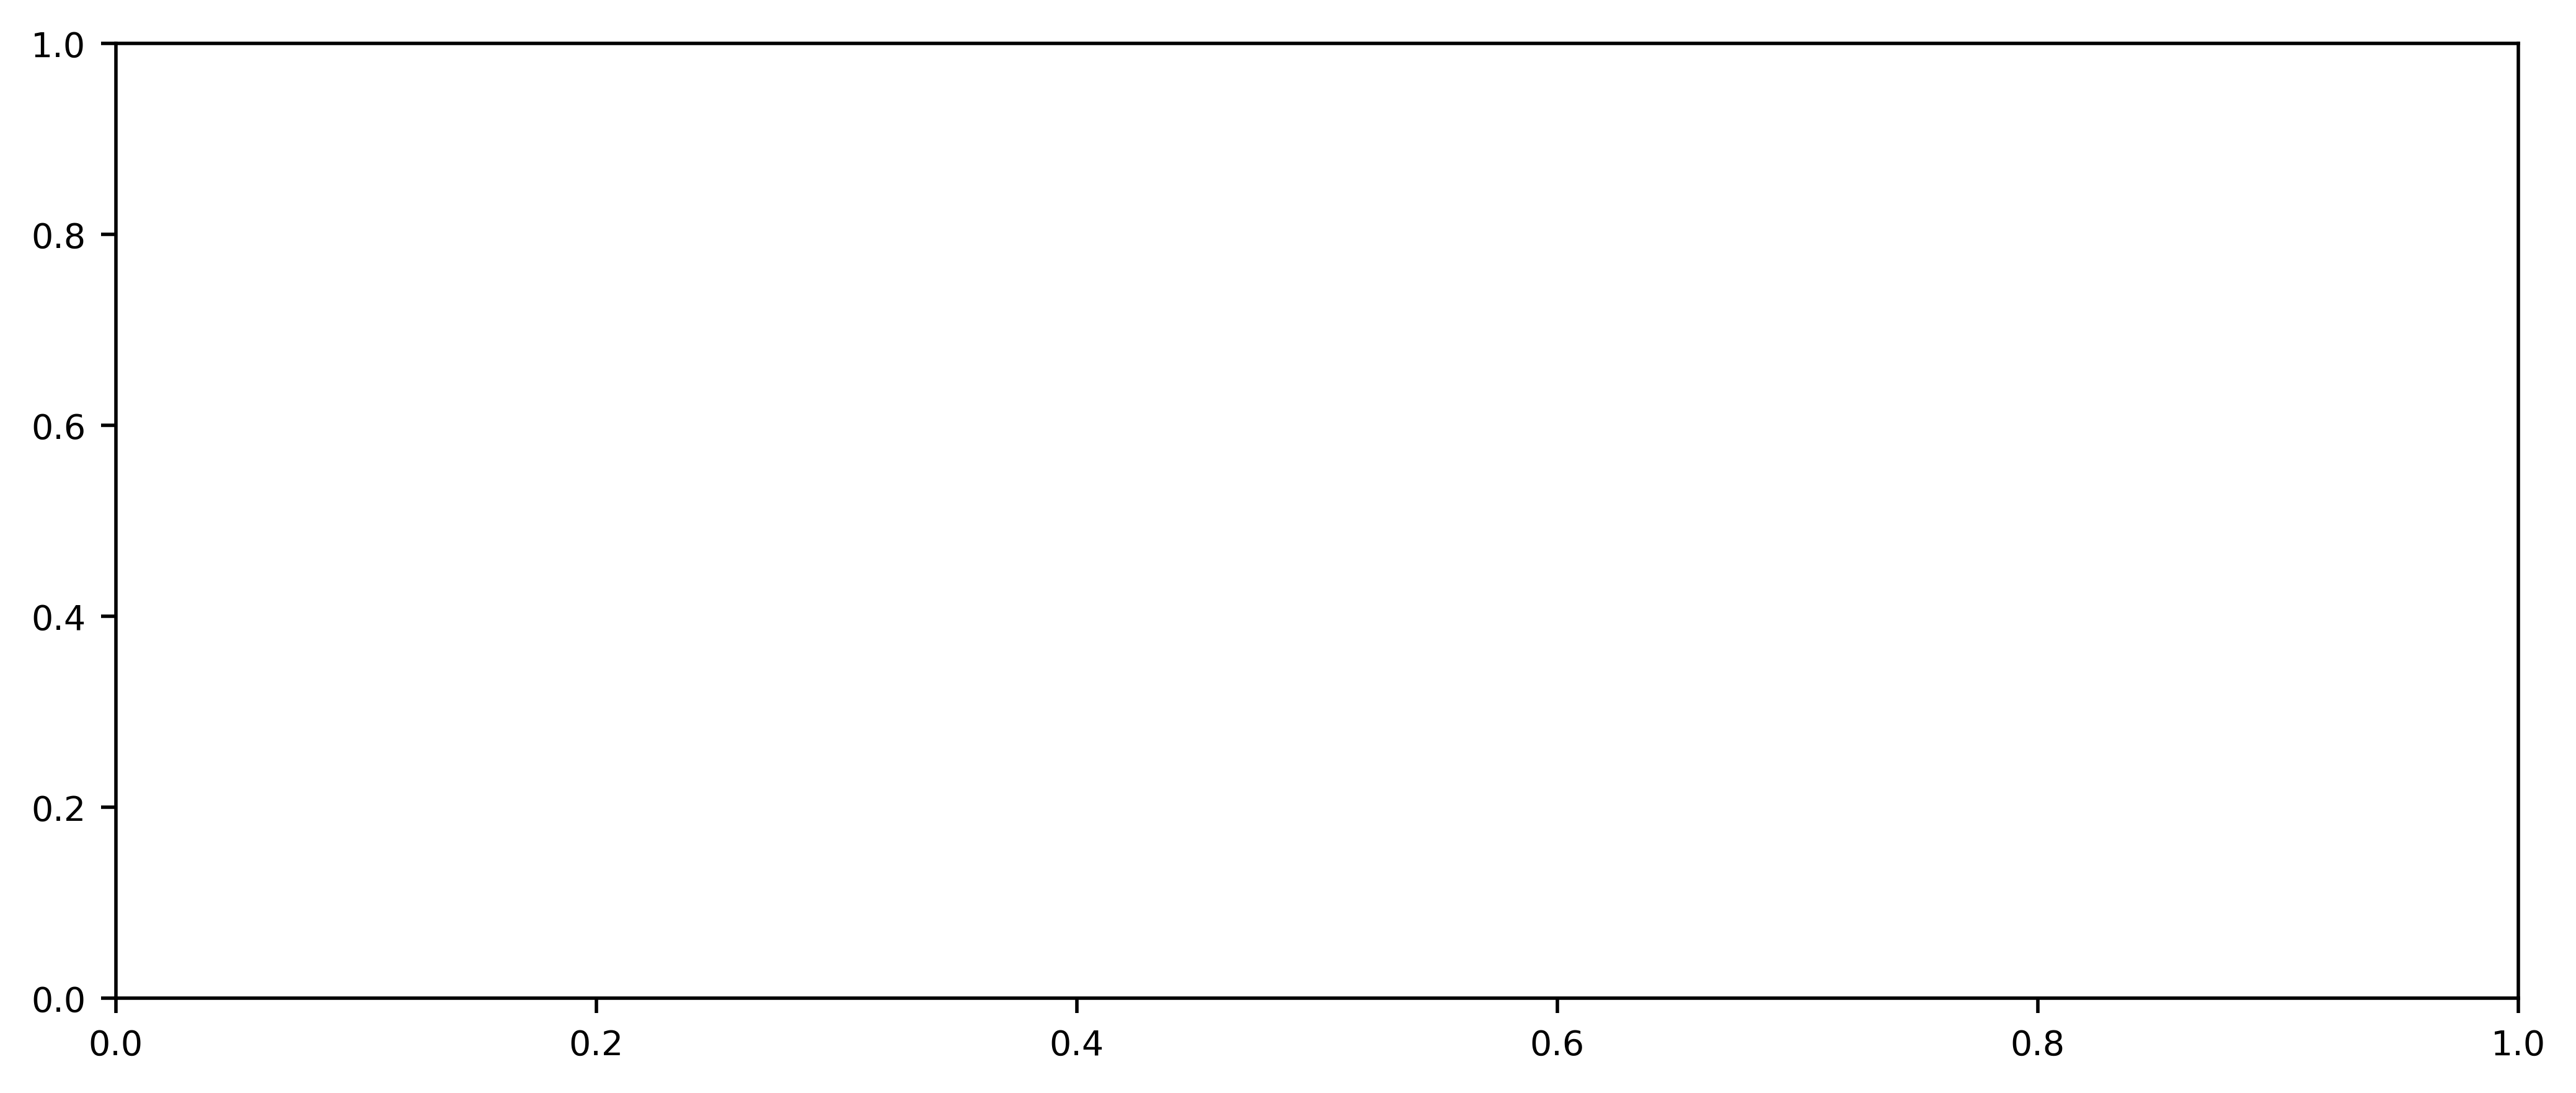

In [32]:
fig=plt.figure(figsize=(10,4))
manhattan(p1=rare['Pvalue'],pos1=rare['POS'],chr1=rare['CHR'],label1='',
                    plot_type='single',cut=0,lines=[-np.log10(8e-9)],lines_colors=['red'], colors=[color_dict['rare'], color_dict['rare_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top1=10, markersize=3, plot_grid_lines=False)

fig1=plt.title('')
fig1=plt.xticks(rotation='vertical')
fig1=plt.ylabel('rare variant -log10(p)')
if save_figs:
    plt.savefig('figures/' + 'rare_variants'+'_bonf'+'_10_short.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_variants'+'_bonf'+'_10_short_500dpi.png',dpi=500,bbox_inches='tight')

In [ ]:
## rare gene single-test manhattan

In [ ]:
FDR_skat_25=2.7e-5
FDR_skato_25=1.5e-4
FDR_burden_25=1.1e-4

In [ ]:
# rare genes - single pvalue test
fig=plt.figure(figsize=(7.5,2))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(p1=rare_genes['P‑Value SKAT'],pos1=rare_genes['Position'],chr1=rare_genes['Chrom'],label1='',
                    plot_type='single',cut=0,lines=[-np.log10(FDR_skat_25)],lines_colors=[color_dict['SKAT']], colors=[color_dict['rare'], color_dict['rare_alt']],
                    lines_widths = [1],lines_styles = ["--"],
                   top1=0, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('SKAT -log10(p)')
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_figs:
    plt.savefig('figures/' + 'rare_genes_skat.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_genes_skat_500dpi.png',dpi=500,bbox_inches='tight')

In [ ]:
# rare genes - single pvalue test
fig=plt.figure(figsize=(7.5,2))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(p1=rare_genes['P‑Value SKATO'],pos1=rare_genes['Position'],chr1=rare_genes['Chrom'],label1='',
                    plot_type='single',cut=0,lines=[-np.log10(FDR_skato_25)],lines_colors=[color_dict['SKAT-O']], colors=[color_dict['rare'], color_dict['rare_alt']],
                    lines_widths = [1],lines_styles = ["--"],
                   top1=0, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('SKAT-O -log10(p)')
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_figs:
    plt.savefig('figures/' + 'rare_genes_skato.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_genes_skato_500dpi.png',dpi=500,bbox_inches='tight')

In [ ]:
# rare genes - single pvalue test
fig=plt.figure(figsize=(7.5,2))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(p1=rare_genes['P‑Value Burden'],pos1=rare_genes['Position'],chr1=rare_genes['Chrom'],label1='',
                    plot_type='single',cut=0,lines=[-np.log10(FDR_burden_25)],lines_colors=[color_dict['burden']], colors=[color_dict['rare'], color_dict['rare_alt']],
                    lines_widths = [1],lines_styles = ["--"],
                   top1=0, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('Burden -log10(p)')
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_figs:
    plt.savefig('figures/' + 'rare_genes_burden.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_genes_burden_500dpi.png',dpi=500,bbox_inches='tight')

## porcupine plot rare genes (all 3 tests)

In [ ]:
FDR_skato_05=min(rare_genes[(rare_genes['FDR_SKATO']>=0.05)]['P‑Value SKATO'])
FDR_skat_05=min(rare_genes[(rare_genes['FDR_SKAT']>=0.05)]['P‑Value SKAT'])
FDR_burden_05=min(rare_genes[(rare_genes['FDR_burden']>=0.05)]['P‑Value Burden'])

FDR_skato_25=min(rare_genes[(rare_genes['FDR_SKATO']>=0.25)]['P‑Value SKATO'])
FDR_skat_25=min(rare_genes[(rare_genes['FDR_SKAT']>=0.25)]['P‑Value SKAT'])
FDR_burden_25=min(rare_genes[(rare_genes['FDR_burden']>=0.25)]['P‑Value Burden'])

In [ ]:
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))

porcupine(p1=rare_genes_exploded['pvals'],test1=rare_genes_exploded['test'],
          pos1=rare_genes_exploded['Position'],
          chr1=rare_genes_exploded['Chrom'],label1='',
          cut_SKATO=FDR_skato_25, cut_SKAT=FDR_skat_25, cut_burden=FDR_burden_25,  
          cut=0,lines=[0],lines_colors=['Black'], colors=[color_dict['rare'], color_dict['rare_alt']],
          lines_widths = [2],top1=0, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('rare gene -log10(p)')
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
#plt.savefig('figures/' + 'invert_rare_genes'+'_bonf_all'+'.svg',bbox_inches='tight')
#plt.savefig('figures/' + 'invert_rare_genes'+'_bonf_all'+'_500dpi.png',dpi=500,bbox_inches='tight')
if save_figs:
    plt.savefig('figures/' + 'rare_genes'+'_FDR_25'+'_short.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_genes'+'_FDR_25'+'_short_500dpi.png',dpi=500,bbox_inches='tight')

# upset plot- rare genes

## based on significance test

In [ ]:
burden=rare_genes[(rare_genes['FDR_burden']<0.25)]['Gene Name']
SKAT=rare_genes[rare_genes['FDR_SKAT']<0.25]['Gene Name']
SKATO=rare_genes[rare_genes['FDR_SKATO']<.25]['Gene Name']

In [ ]:
genes_test=from_contents({'SKAT':SKAT,'SKAT-O':SKATO, 'Burden':burden})

In [ ]:
ax_dict=UpSet(genes_test, subset_size='count').plot()
if save_figs:
    plt.savefig('figures/' + 'rare_gene_test_upset.svg')

# rare variants/genes barplots

## single variant barplot

In [ ]:
tbl=rare[(rare['Pvalue']<rare_cutoff)&(rare['AC']>2)]
mis=set(tbl[(tbl['annotation']=='LC')|(tbl['annotation']=='missense')]['markerID'])
syn=set(tbl[(tbl['annotation']=='synonymous')]['markerID'])
lof=set(tbl[(tbl['annotation']=='pLoF')]['markerID'])
data={'pLoF':len(lof),'missense|LC':len(mis),'synonymous':len(syn)}

names = list(data.keys())
values = list(data.values())

plt.figure(figsize=(3, 3))
plt.bar(range(len(data)), values, tick_label=names,edgecolor="black",color=(['#fcba03','#189B48','#ff03c8']))
plt.xticks(rotation='vertical')
plt.ylabel("rare variants (n)")
if save_figs:
    plt.savefig('figures/' + 'rare_variants__'+'bonf05'+'_barplot.svg',bbox_inches='tight')
plt.show()

## stacked

In [ ]:
rgenes_fdr25=rare_genes[(rare_genes['FDR_burden']<0.25)|
           (rare_genes['FDR_SKAT']<0.25)|
           (rare_genes['FDR_SKATO']<.25)]

In [ ]:
rgenes_bonf=rare_genes[(rare_genes['P‑Value SKATO']<0.05/len(rare_genes))|
           (rare_genes['P‑Value SKAT']<0.05/len(rare_genes))|
           (rare_genes['P‑Value Burden']<0.05/len(rare_genes))]

In [ ]:
mis=list(set(rgenes_fdr25[rgenes_fdr25['Burden Set']=='missense|LC']['Gene Name']))
mis_strin=list(set(rgenes_bonf[rgenes_bonf['Burden Set']=='missense|LC']['Gene Name']))
lof=list(set(rgenes_fdr25[rgenes_fdr25['Burden Set']=='pLoF']['Gene Name']))
lof_strin=list(set(rgenes_bonf[rgenes_bonf['Burden Set']=='pLoF']['Gene Name']))
syn=list(set(rgenes_fdr25[rgenes_fdr25['Burden Set']=='synonymous']['Gene Name']))
syn_strin=list(set(rgenes_bonf[rgenes_bonf['Burden Set']=='synonymous']['Gene Name']))

In [ ]:
data=('predicted LoF','missense|LC','synonymous')

gene_counts = {
    "stringent": np.array([len(lof_strin), len(mis_strin), len(syn_strin)]),
    "lenient": np.array([len(lof), len(mis), len(syn)])
}

fig, ax = plt.subplots(figsize=(3, 3))
# Stacked bar chart
ax.bar(data, list(gene_counts['stringent']),
       color=[color_dict['pLoF_alt'],color_dict['misLC_alt'],color_dict['syn_alt']], edgecolor="black")
ax.bar(data, list(gene_counts['lenient']), bottom = list(gene_counts['stringent']),  
      color=([color_dict['pLoF'],color_dict['misLC'],color_dict['syn']]), edgecolor="black")
plt.yticks([2,4,6,8,10,12,14,16,18, 20, 22])
plt.xticks(rotation='vertical')
plt.ylabel("rare genes (n)")
if save_figs:
    plt.savefig('figures/' + 'rare_genes_'+'stacked'+'_barplot.svg',bbox_inches='tight')
